In [1]:
%matplotlib inline

# Case study: K2-24, putting it all together

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.6


In this tutorial, we will combine many of the previous tutorials to perform a fit of the K2-24 system using the K2 transit data and the RVs from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497).
This is the same system that we fit in the :ref:`rv` tutorial and we'll combine that model with the transit model from the :ref:`transit` tutorial and the Gaussian Process noise model from the :ref:`stellar-variability` tutorial.

## Datasets and initializations

To get started, let's download the relevant datasets.
First, the transit light curve from [Everest](https://rodluger.github.io/everest/):

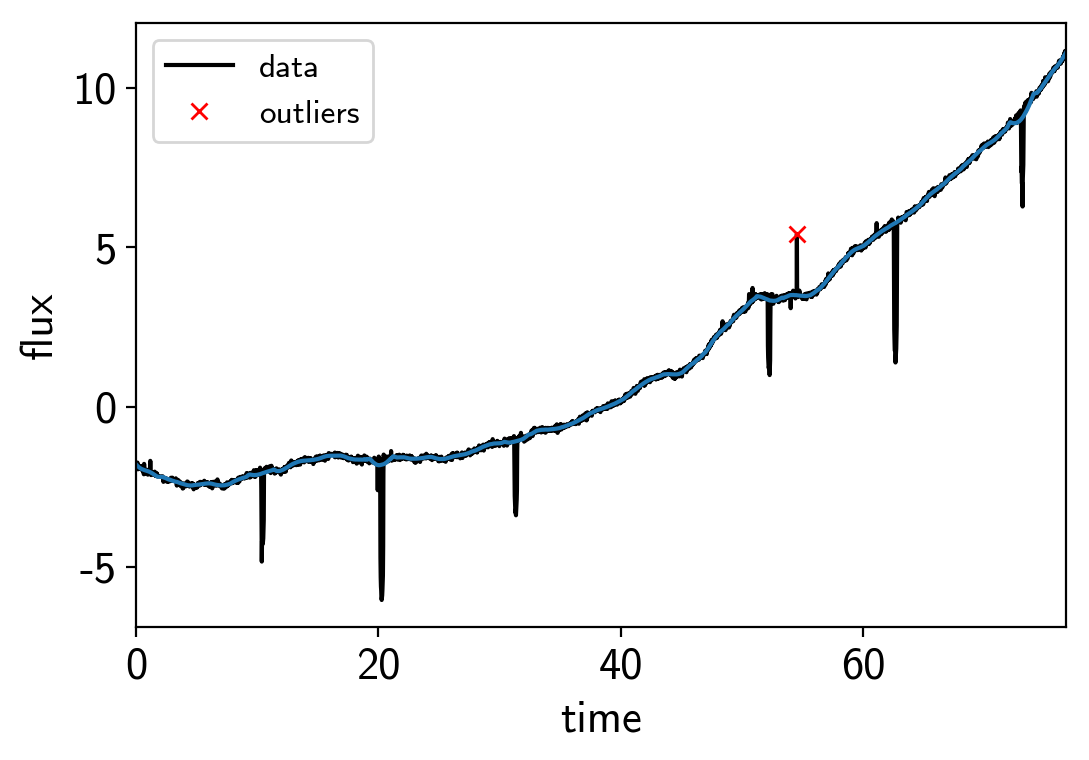

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.io import fits
from scipy.signal import savgol_filter

# Download the data
lc_url = "https://archive.stsci.edu/hlsps/everest/v2/c02/203700000/71098/hlsp_everest_k2_llc_203771098-c02_kepler_v2.0_lc.fits"
with fits.open(lc_url) as hdus:
    lc = hdus[1].data
    lc_hdr = hdus[1].header

# Work out the exposure time
texp = lc_hdr["FRAMETIM"] * lc_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# Mask bad data
m = (np.arange(len(lc)) > 100) & np.isfinite(lc["FLUX"]) & np.isfinite(lc["TIME"])
bad_bits=[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 16, 17]
qual = lc["QUALITY"]
for b in bad_bits:
    m &= qual & 2 ** (b - 1) == 0

# Convert to parts per thousand
x = lc["TIME"][m]
y = lc["FLUX"][m]
mu = np.median(y)
y = (y / mu - 1) * 1e3

# Identify outliers
m = np.ones(len(y), dtype=bool)
for i in range(10):
    y_prime = np.interp(x, x[m], y[m])
    smooth = savgol_filter(y_prime, 101, polyorder=3)
    resid = y - smooth
    sigma = np.sqrt(np.mean(resid**2))
    m0 = np.abs(resid) < 3*sigma
    if m.sum() == m0.sum():
        m = m0
        break
    m = m0
    
# Only discard positive outliers
m = resid < 3*sigma

# Shift the data so that the K2 data start at t=0. This tends to make the fit
# better behaved since t0 covaries with period.
x_ref = np.min(x[m])
x -= x_ref

# Plot the data
plt.plot(x, y, "k", label="data")
plt.plot(x, smooth)
plt.plot(x[~m], y[~m], "xr", label="outliers")
plt.legend(fontsize=12)
plt.xlim(x.min(), x.max())
plt.xlabel("time")
plt.ylabel("flux")

# Make sure that the data type is consistent
x = np.ascontiguousarray(x[m], dtype=np.float64)
y = np.ascontiguousarray(y[m], dtype=np.float64)
smooth = np.ascontiguousarray(smooth[m], dtype=np.float64)

Then the RVs from [RadVel](https://radvel.readthedocs.io):

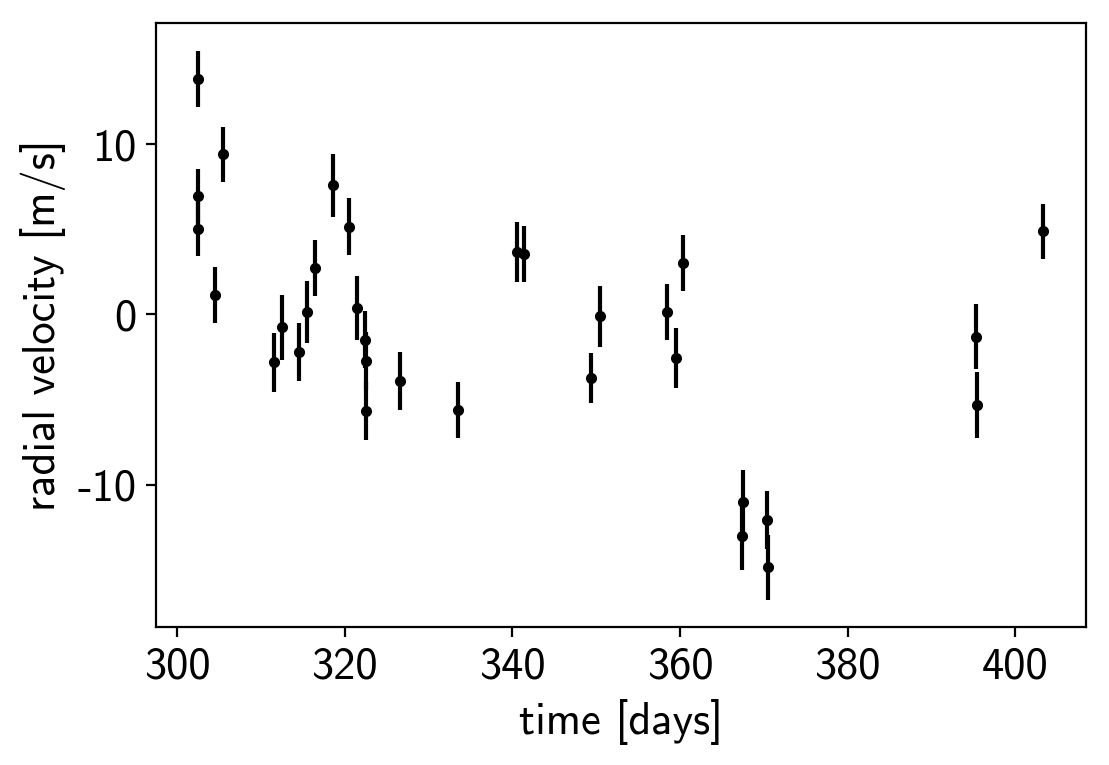

In [4]:
import pandas as pd

url = "https://raw.githubusercontent.com/California-Planet-Search/radvel/master/example_data/epic203771098.csv"
data = pd.read_csv(url, index_col=0)

# Don't forget to remove the time offset from above!
x_rv = np.array(data.t) - x_ref
y_rv = np.array(data.vel)
yerr_rv = np.array(data.errvel)

plt.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]");

We can initialize the transit parameters using [the box least squares periodogram from AstroPy](http://docs.astropy.org/en/latest/stats/bls.html).
(Note: you'll need AstroPy v3.1 or more recent to use this feature.)
A full discussion of transit detection and vetting is beyond the scope of this tutorial so let's assume that we know that there are two periodic transiting planets in this dataset.

In [5]:
from astropy.stats import BoxLeastSquares

m = np.zeros(len(x), dtype=bool)
period_grid = np.exp(np.linspace(np.log(5), np.log(50), 50000))
bls_results = []
periods = []
t0s = []
depths = []

# Compute the periodogram for each planet by iteratively masking out
# transits from the higher signal to noise planets. Here we're assuming
# that we know that there are exactly two planets.
for i in range(2):
    bls = BoxLeastSquares(x[~m], y[~m] - smooth[~m])
    bls_power = bls.power(period_grid, 0.1, oversample=20)
    bls_results.append(bls_power)
    
    # Save the highest peak as the planet candidate
    index = np.argmax(bls_power.power)
    periods.append(bls_power.period[index])
    t0s.append(bls_power.transit_time[index])
    depths.append(bls_power.depth[index])
    
    # Mask the data points that are in transit for this candidate
    m |= bls.transit_mask(x, periods[-1], 0.5, t0s[-1])

Let's plot the initial transit estimates based on these periodograms:

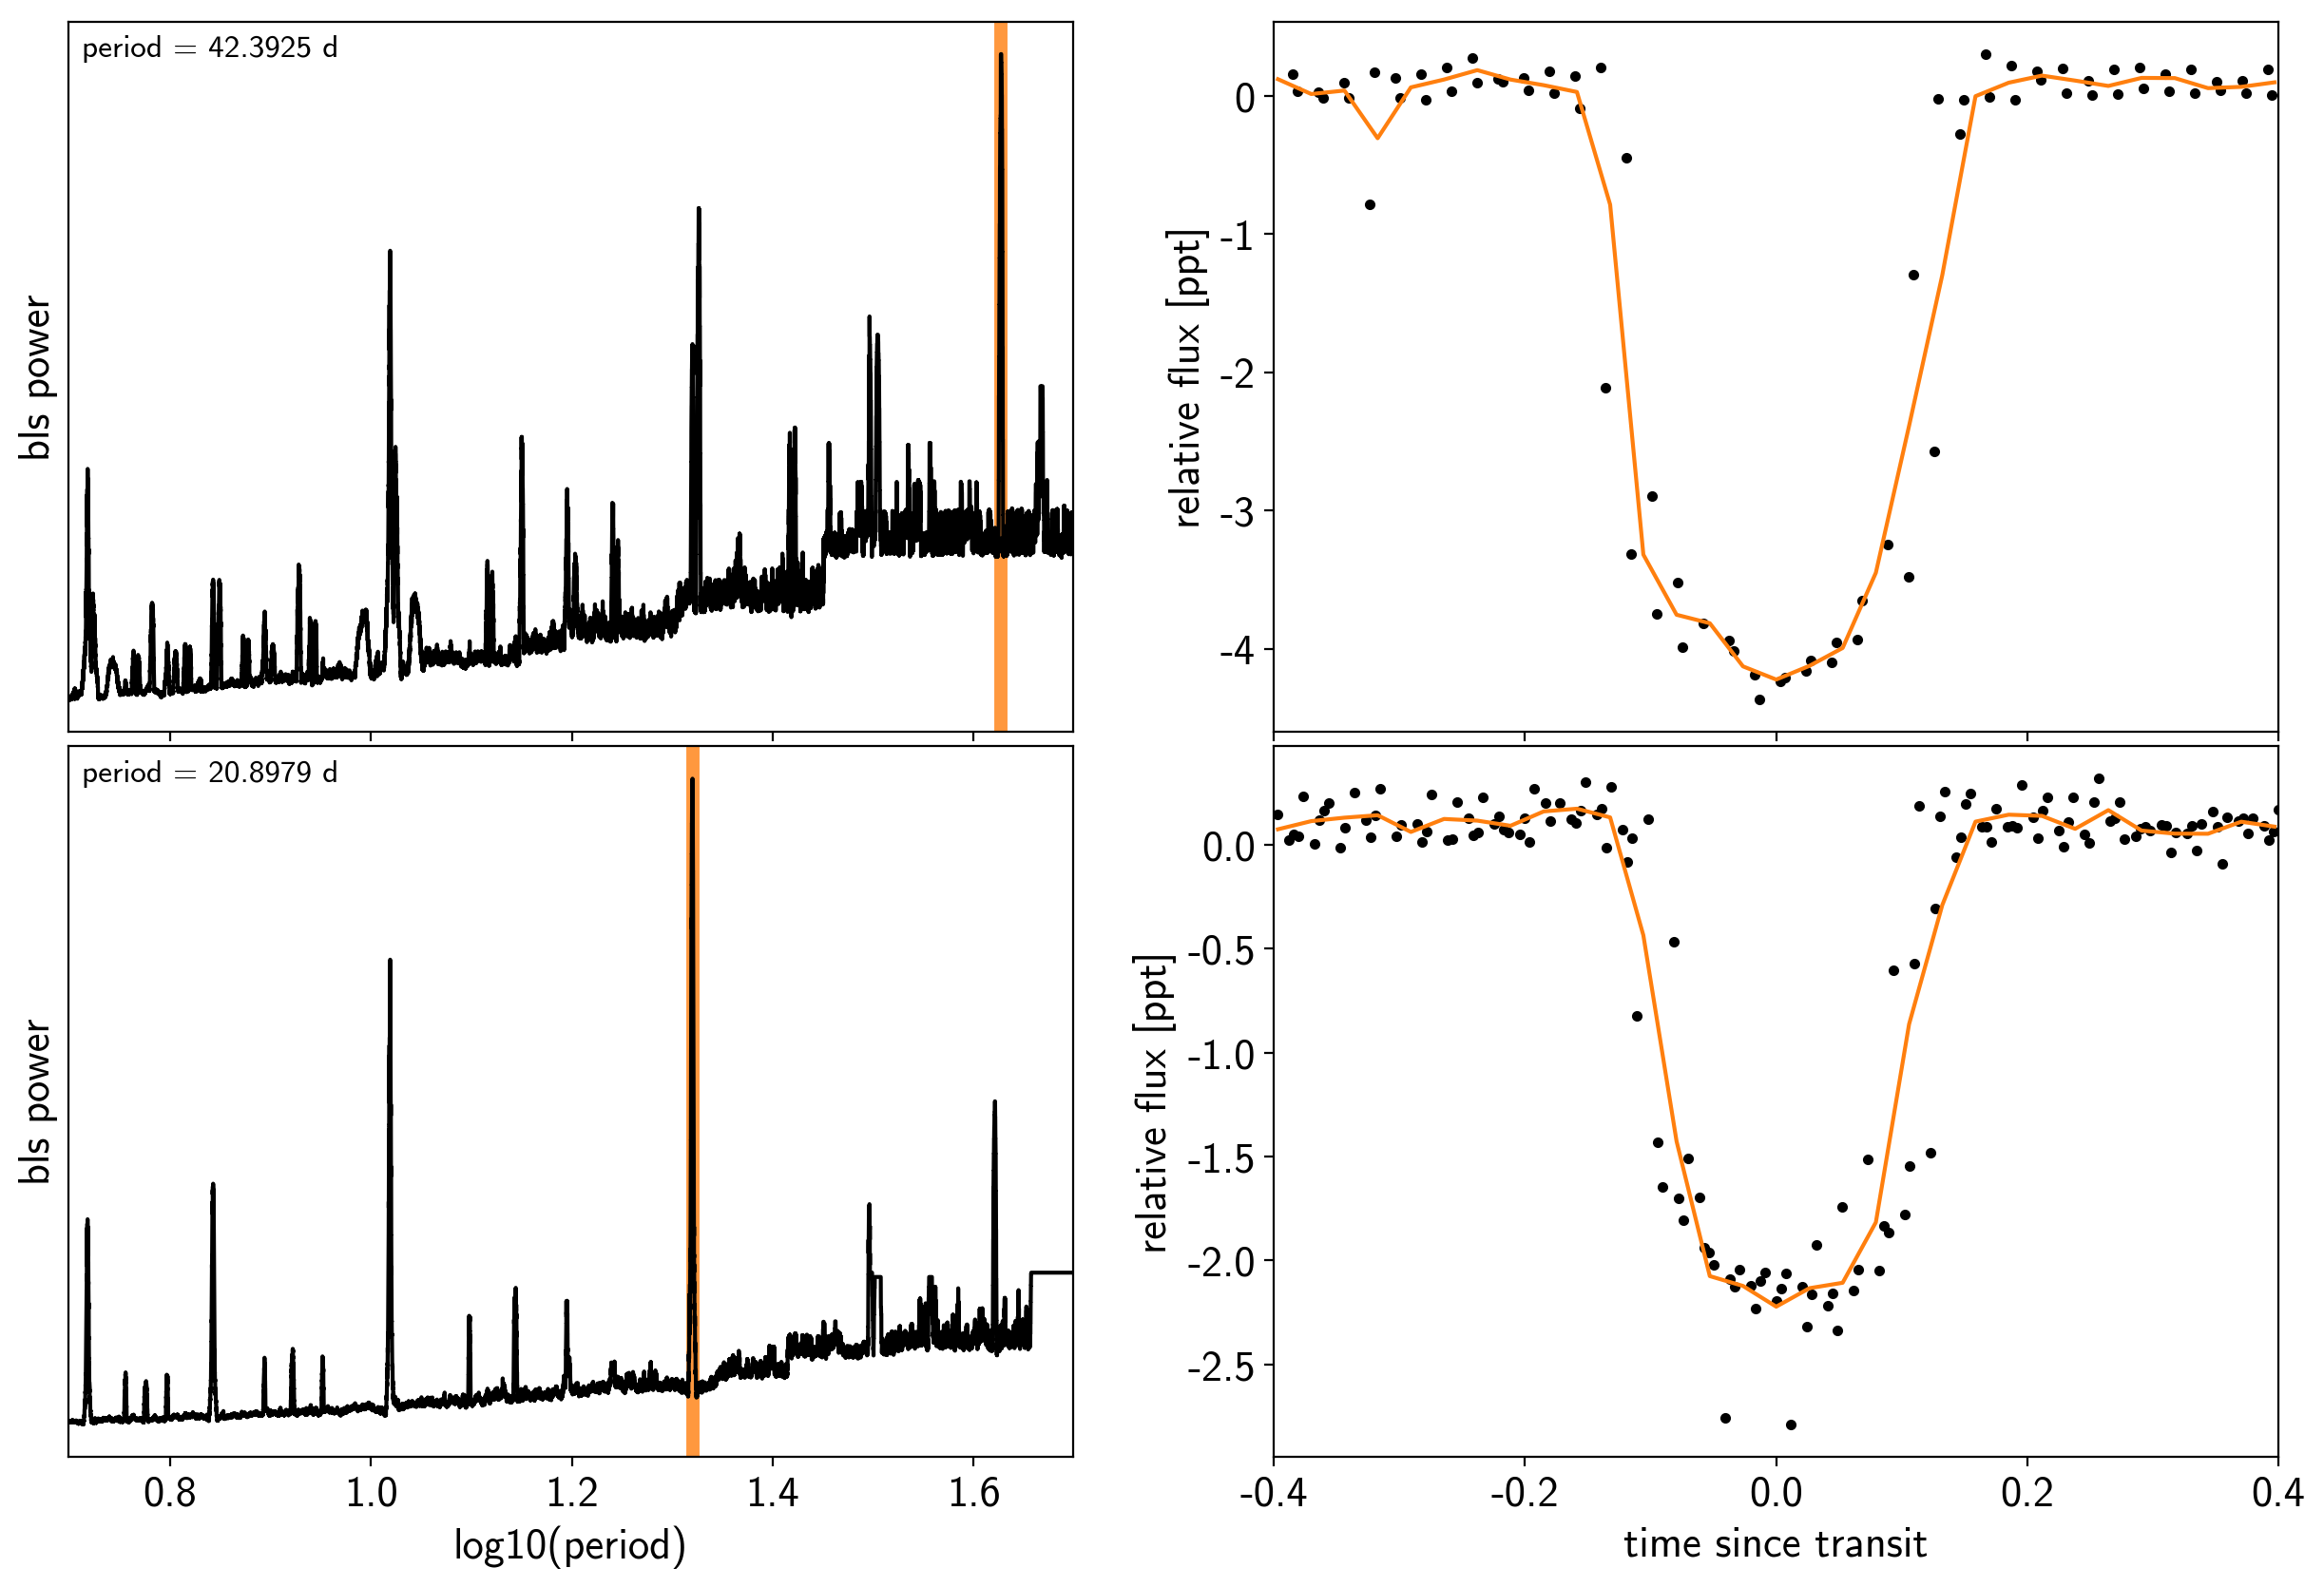

In [6]:
fig, axes = plt.subplots(len(bls_results), 2, figsize=(15, 10))

for i in range(len(bls_results)):
    # Plot the periodogram
    ax = axes[i, 0]
    ax.axvline(np.log10(periods[i]), color="C1", lw=5, alpha=0.8)
    ax.plot(np.log10(bls_results[i].period), bls_results[i].power, "k")
    ax.annotate("period = {0:.4f} d".format(periods[i]),
                (0, 1), xycoords="axes fraction",
                xytext=(5, -5), textcoords="offset points",
                va="top", ha="left", fontsize=12)
    ax.set_ylabel("bls power")
    ax.set_yticks([])
    ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("log10(period)")
    
    # Plot the folded transit
    ax = axes[i, 1]
    p = periods[i]
    x_fold = (x - t0s[i] + 0.5*p) % p - 0.5*p
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], y[m] - smooth[m], ".k")
    
    # Overplot the phase binned light curve
    bins = np.linspace(-0.41, 0.41, 32)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=y - smooth)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.4, 0.4)
    ax.set_ylabel("relative flux [ppt]")
    if i < len(bls_results) - 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("time since transit")
        
fig.subplots_adjust(hspace=0.02)

The discovery paper for K2-24 ([Petigura et al. (2016)](https://arxiv.org/abs/1511.04497)) includes the following estimates of the stellar mass and radius in Solar units:

In [7]:
M_star_petigura = 1.12, 0.05
R_star_petigura = 1.21, 0.11

Finally, using this stellar mass, we can also estimate the minimum masses of the planets given these transit parameters.

In [8]:
import exoplanet as xo
import astropy.units as u

msini = xo.estimate_minimum_mass(periods, x_rv, y_rv, yerr_rv, t0s=t0s, m_star=M_star_petigura[0])
msini = msini.to(u.M_earth)
print(msini)

[32.80060146 23.89885976] earthMass


## A joint transit and radial velocity model in PyMC3

Now, let's define our full model in *PyMC3*.
There's a lot going on here, but I've tried to comment it and most of it should be familiar from the previous tutorials (:ref:`rv`, :ref:`transit`, :ref:`gp`, and :ref:`stellar-variability`).
In this case, I've put the model inside a model "factory" function because we'll do some sigma clipping below.

In [9]:
import pymc3 as pm
import theano.tensor as tt

t_rv = np.linspace(x_rv.min()-5, x_rv.max()+5, 1000)

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal("m_star", mu=M_star_petigura[0], sd=M_star_petigura[1])
        r_star = BoundedNormal("r_star", mu=R_star_petigura[0], sd=R_star_petigura[1])

        # Orbital parameters for the planets
        logm = pm.Normal("logm", mu=np.log(msini.value), sd=1, shape=2)
        logP = pm.Normal("logP", mu=np.log(periods), sd=1, shape=2)
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        logr = pm.Normal("logr", mu=0.5*np.log(1e-3*np.array(depths)) + np.log(R_star_petigura[0]),
                         sd=1.0, shape=2)
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        b = pm.Flat("b", shape=2,
                    transform=pm.distributions.transforms.logodds,
                    testval=0.5+np.zeros(2))
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        BoundedBeta = pm.Bound(pm.Beta, lower=0, upper=1-1e-5)
        ecc = BoundedBeta("ecc", alpha=0.867, beta=3.03, shape=2,
                          testval=np.array([0.1, 0.1]))
        omega = xo.distributions.Angle("omega", shape=2)

        # RV jitter & a quadratic RV trend
        logs_rv = pm.Normal("logs_rv", mu=np.log(np.median(yerr_rv)), sd=5)
        trend = pm.Normal("trend", mu=0, sd=10.0**-np.arange(3)[::-1], shape=3)

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        m_pl = pm.Deterministic("m_pl", tt.exp(logm))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b, m_planet=m_pl,
            ecc=ecc, omega=omega,
            m_planet_units=msini.unit)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Set up the RV model and save it as a deterministic
        # for plotting purposes later
        vrad = orbit.get_radial_velocity(x_rv)
        pm.Deterministic("vrad", vrad)

        # Define the background RV model
        A = np.vander(x_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg = pm.Deterministic("bkg", tt.dot(A, trend))

        # The likelihood for the RVs
        rv_model = pm.Deterministic("rv_model", tt.sum(vrad, axis=-1) + bkg)
        err = tt.sqrt(yerr_rv**2 + tt.exp(2*logs_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)
        
        vrad_pred = orbit.get_radial_velocity(t_rv)
        pm.Deterministic("vrad_pred", vrad_pred)
        A_pred = np.vander(t_rv - 0.5*(x_rv.min() + x_rv.max()), 3)
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
        pm.Deterministic("rv_model_pred", tt.sum(vrad_pred, axis=-1) + bkg_pred)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[trend])
        map_soln = xo.optimize(start=map_soln, vars=[logs2])
        map_soln = xo.optimize(start=map_soln, vars=[logr, b])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower])
        map_soln = xo.optimize(start=map_soln, vars=[logw0])
        map_soln = xo.optimize(start=map_soln)
        map_soln = xo.optimize(start=map_soln, vars=[logm, ecc, omega])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

In [10]:
model0, map_soln0 = build_model()

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: -8250.572319847692 -> -8233.972126547622


optimizing logp for variables: ['logs2']


message: Optimization terminated successfully.
logp: -8233.972126547622 -> 1985.195383239683


optimizing logp for variables: ['b_logodds__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 1985.195383239683 -> 2679.698211591958


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 2679.698211591958 -> 3334.2117904820097


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 3334.2117904820097 -> 4291.602174987188


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 4291.602174987188 -> 4365.5542833298605


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4365.5542833298605 -> 4777.103510779301


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Desired error not necessarily achieved due to precision loss.
logp: 4777.103510779301 -> 4777.103510779483


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 4777.103510779483 -> 4777.103510779483


Now let's plot the map radial velocity model.

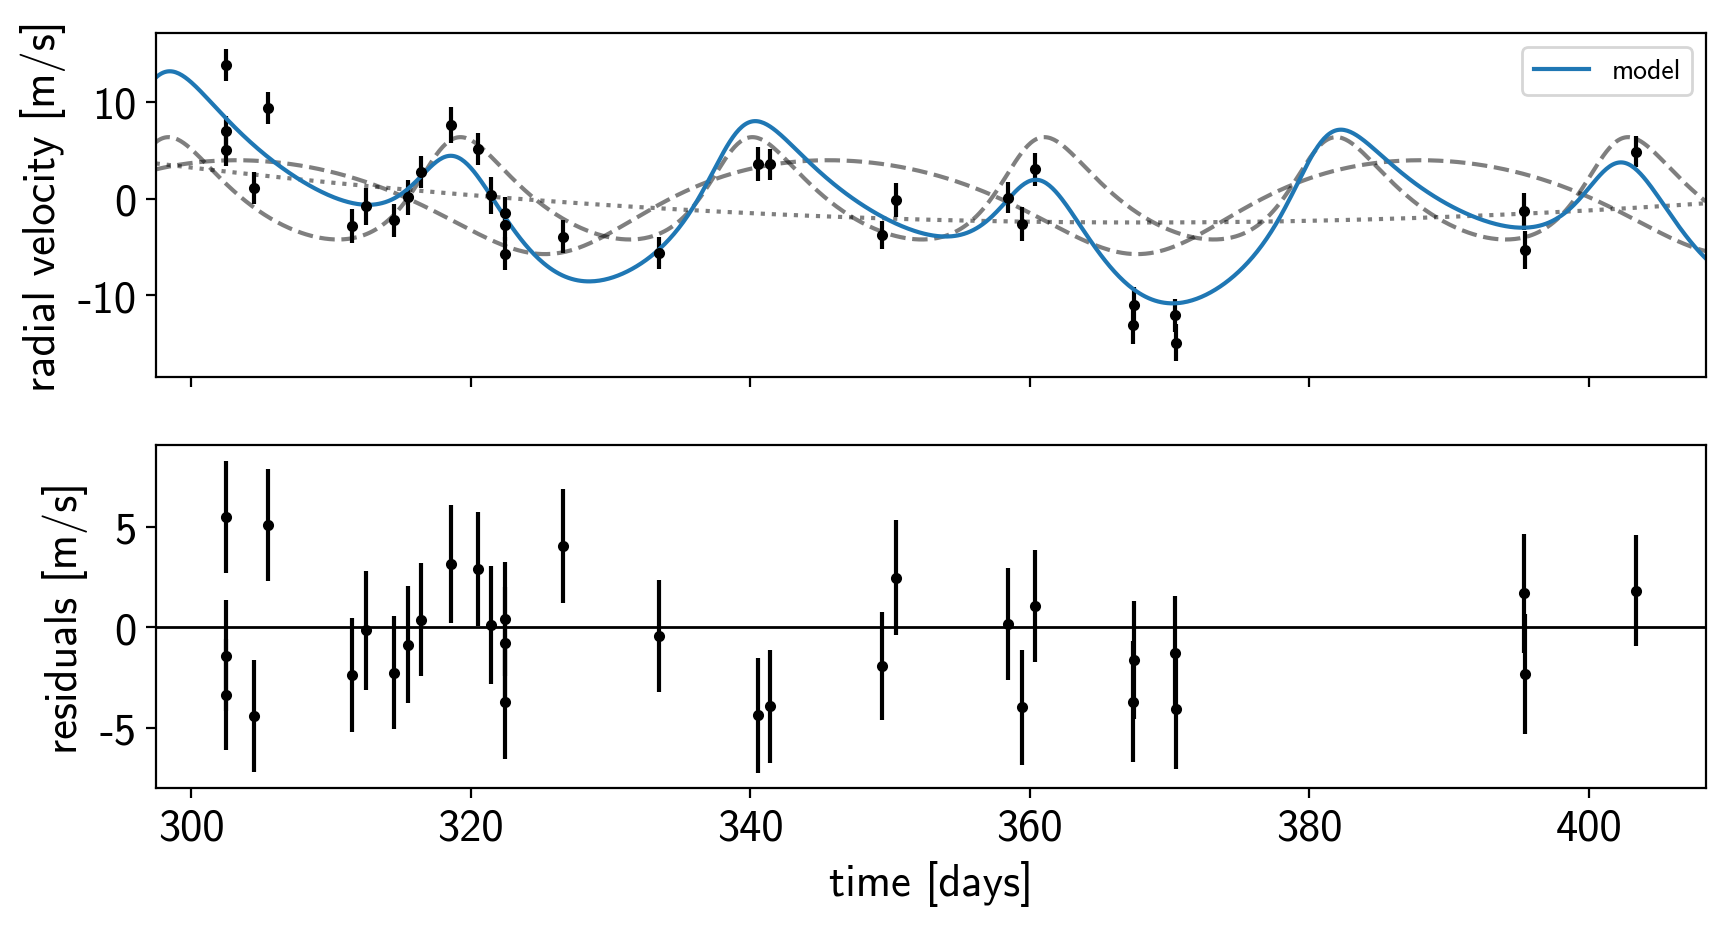

In [11]:
def plot_rv_curve(soln):
    fig, axes = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
    
    ax = axes[0]
    ax.errorbar(x_rv, y_rv, yerr=yerr_rv, fmt=".k")
    ax.plot(t_rv, soln["vrad_pred"], "--k", alpha=0.5)
    ax.plot(t_rv, soln["bkg_pred"], ":k", alpha=0.5)
    ax.plot(t_rv, soln["rv_model_pred"], label="model")
    ax.legend(fontsize=10)
    ax.set_ylabel("radial velocity [m/s]")
    
    ax = axes[1]
    err = np.sqrt(yerr_rv**2+np.exp(2*soln["logs_rv"]))
    ax.errorbar(x_rv, y_rv - soln["rv_model"], yerr=err, fmt=".k")
    ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("residuals [m/s]")
    ax.set_xlim(t_rv.min(), t_rv.max())
    ax.set_xlabel("time [days]")
    
plot_rv_curve(map_soln0)

That looks pretty similar to what we got in :ref:`rv`.
Now let's also plot the transit model.

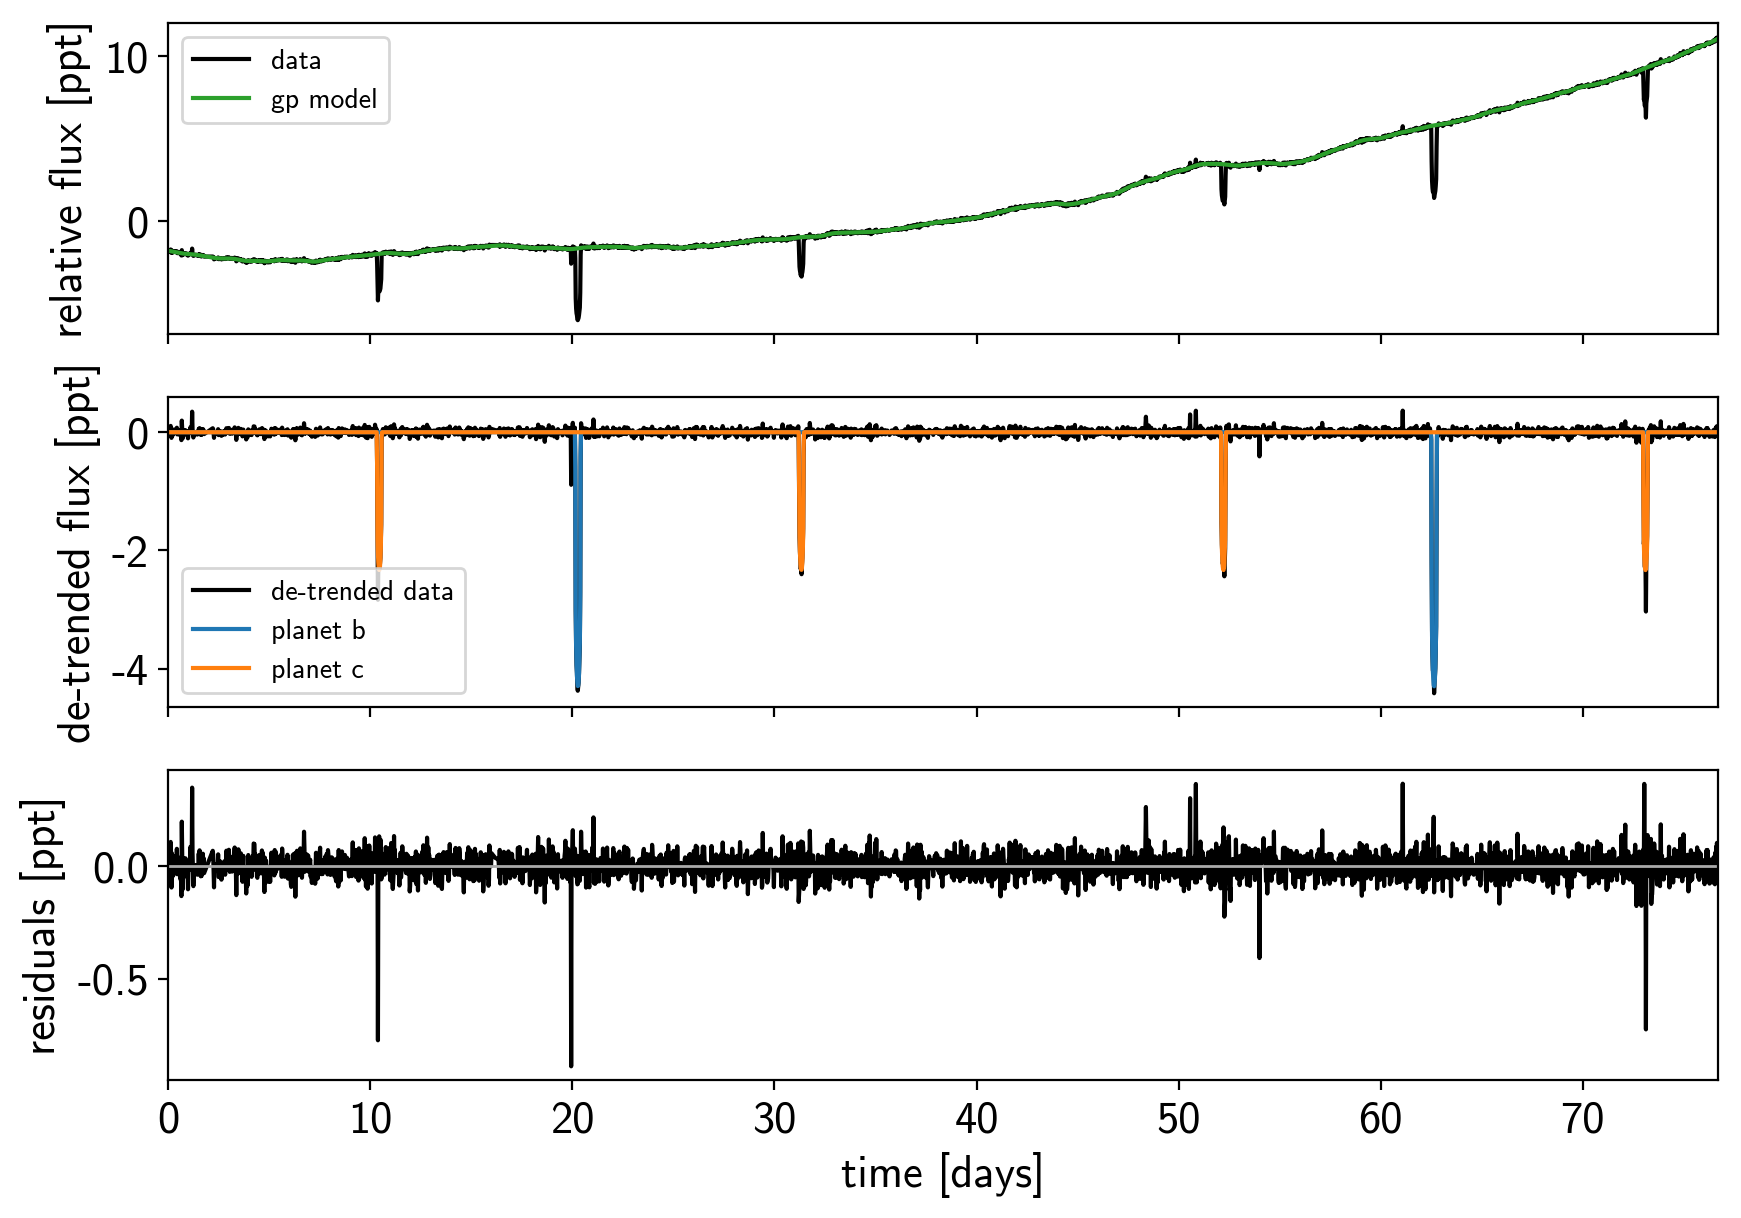

In [12]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("bc"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

There are still a few outliers in the light curve and it can be useful to remove those before doing the full fit because both the GP and transit parameters can be sensitive to this.

## Sigma clipping

To remove the outliers, we'll look at the empirical RMS of the residuals away from the GP + transit model and remove anything that is more than a 7-sigma outlier.

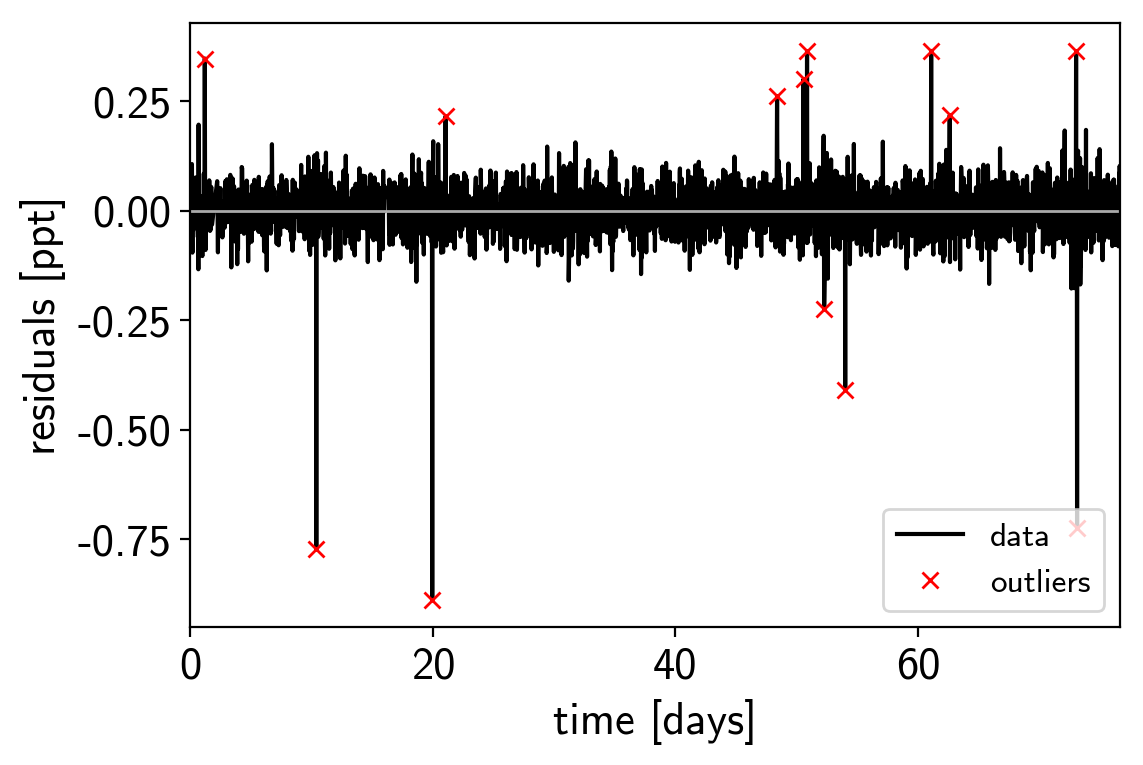

In [13]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

That looks better. Let's re-build our model with this sigma-clipped dataset.

optimizing logp for variables: ['trend']


message: Optimization terminated successfully.
logp: 5227.116869460895 -> 5227.116869460898


optimizing logp for variables: ['logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: 5227.116869460898 -> 5309.2239182160365


optimizing logp for variables: ['b_logodds__', 'logr']


message: Desired error not necessarily achieved due to precision loss.
logp: 5309.223918216018 -> 5320.261376226418


optimizing logp for variables: ['t0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: 5320.261376226418 -> 5321.717901372164


optimizing logp for variables: ['logpower', 'logs2']


message: Optimization terminated successfully.
logp: 5321.717901372168 -> 5322.452093012708


optimizing logp for variables: ['logw0']


message: Optimization terminated successfully.
logp: 5322.452093012708 -> 5322.486343182219


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5322.486343182217 -> 5324.3056735786095


optimizing logp for variables: ['omega_angle__', 'ecc_interval__', 'logm']


message: Desired error not necessarily achieved due to precision loss.
logp: 5324.3056735786095 -> 5324.3056735786095


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'trend', 'logs_rv', 'omega_angle__', 'ecc_interval__', 'b_logodds__', 'logr', 't0', 'logP', 'logm', 'r_star_interval__', 'm_star_interval__', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 5324.3056735786095 -> 5324.3056735786095


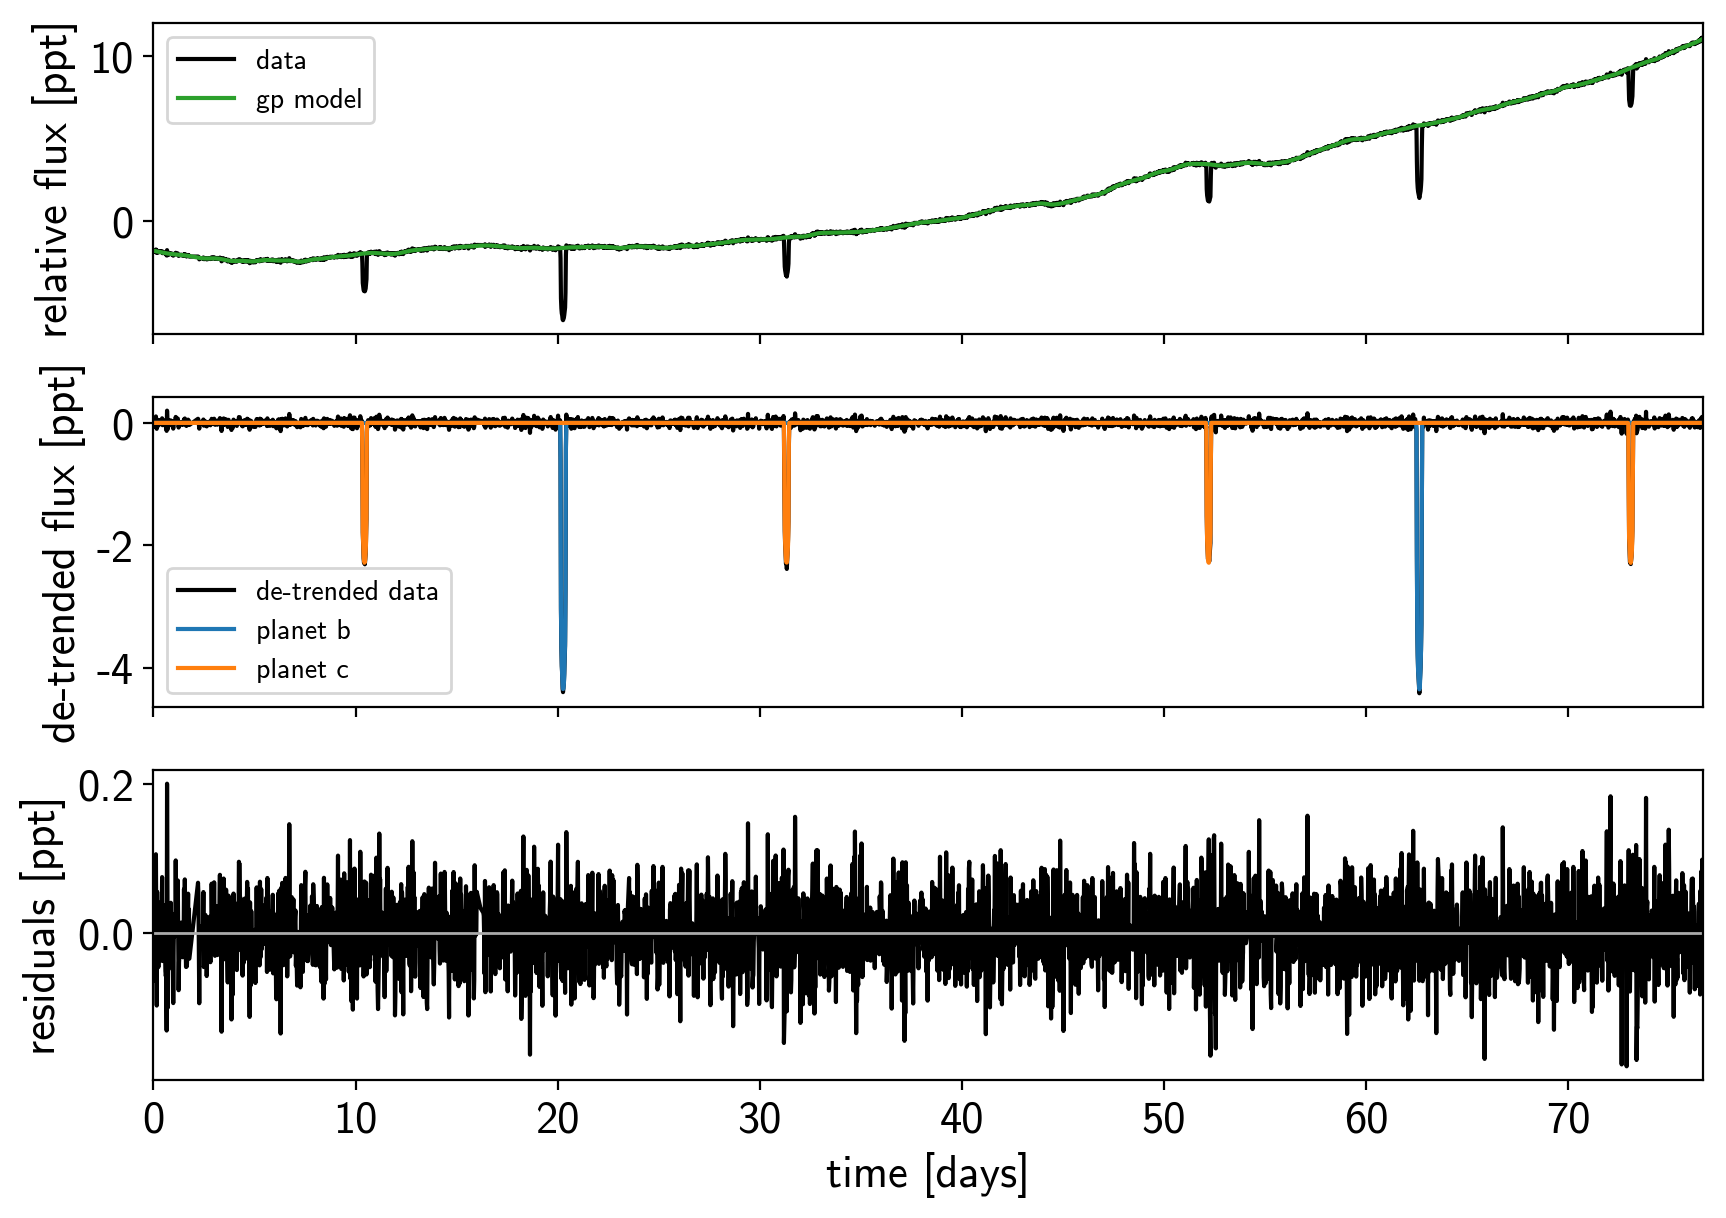

In [14]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

Great! Now we're ready to sample.

## Sampling

The sampling for this model is the same as for all the previous tutorials, but it takes a bit longer (about 2 hours on my laptop).
This is partly because the model is more expensive to compute than the previous ones and partly because there are some non-affine degeneracies in the problem (for example between impact parameter and eccentricity).
It might be worth thinking about reparameterizations (in terms of duration instead of eccentricity), but that's beyond the scope of this tutorial.
Besides, using more traditional MCMC methods, this would have taken a lot more than 2 hours to get >1000 effective samples!

In [15]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(finish=500, chains=4)
with model:
    burnin = sampler.tune(tune=4500, start=map_soln,
                          step_kwargs=dict(target_accept=0.95))

Sampling 4 chains:   0%|          | 0/308 [00:00<?, ?draws/s]

Sampling 4 chains:   7%|▋         | 21/308 [00:00<00:10, 27.57draws/s]

Sampling 4 chains:   8%|▊         | 25/308 [00:01<00:21, 13.10draws/s]

Sampling 4 chains:   9%|▉         | 29/308 [00:02<00:28,  9.67draws/s]

Sampling 4 chains:  11%|█         | 33/308 [00:02<00:33,  8.15draws/s]

Sampling 4 chains:  12%|█▏        | 37/308 [00:03<00:36,  7.35draws/s]

Sampling 4 chains:  13%|█▎        | 41/308 [00:04<00:39,  6.84draws/s]

Sampling 4 chains:  15%|█▍        | 45/308 [00:04<00:40,  6.56draws/s]

Sampling 4 chains:  16%|█▌        | 49/308 [00:05<00:40,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 53/308 [00:06<00:40,  6.26draws/s]

Sampling 4 chains:  18%|█▊        | 56/308 [00:06<00:31,  8.10draws/s]

Sampling 4 chains:  19%|█▉        | 58/308 [00:06<00:42,  5.87draws/s]

Sampling 4 chains:  19%|█▉        | 60/308 [00:06<00:34,  7.24draws/s]

Sampling 4 chains:  20%|██        | 62/308 [00:07<00:43,  5.65draws/s]

Sampling 4 chains:  21%|██        | 64/308 [00:07<00:35,  6.90draws/s]

Sampling 4 chains:  21%|██▏       | 66/308 [00:08<00:43,  5.54draws/s]

Sampling 4 chains:  22%|██▏       | 67/308 [00:08<00:38,  6.32draws/s]

Sampling 4 chains:  22%|██▏       | 69/308 [00:08<00:46,  5.17draws/s]

Sampling 4 chains:  23%|██▎       | 71/308 [00:08<00:36,  6.52draws/s]

Sampling 4 chains:  24%|██▎       | 73/308 [00:09<00:44,  5.30draws/s]

Sampling 4 chains:  24%|██▍       | 75/308 [00:09<00:35,  6.63draws/s]

Sampling 4 chains:  25%|██▌       | 77/308 [00:10<00:43,  5.35draws/s]

Sampling 4 chains:  26%|██▌       | 79/308 [00:10<00:34,  6.62draws/s]

Sampling 4 chains:  26%|██▋       | 81/308 [00:10<00:41,  5.41draws/s]

Sampling 4 chains:  27%|██▋       | 83/308 [00:10<00:33,  6.66draws/s]

Sampling 4 chains:  28%|██▊       | 85/308 [00:11<00:41,  5.43draws/s]

Sampling 4 chains:  28%|██▊       | 87/308 [00:11<00:33,  6.67draws/s]

Sampling 4 chains:  29%|██▉       | 89/308 [00:12<00:40,  5.45draws/s]

Sampling 4 chains:  30%|██▉       | 91/308 [00:12<00:33,  6.54draws/s]

Sampling 4 chains:  30%|███       | 93/308 [00:12<00:39,  5.49draws/s]

Sampling 4 chains:  31%|███       | 95/308 [00:12<00:32,  6.56draws/s]

Sampling 4 chains:  31%|███▏      | 97/308 [00:13<00:38,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 99/308 [00:13<00:31,  6.55draws/s]

Sampling 4 chains:  32%|███▏      | 100/308 [00:13<00:28,  7.21draws/s]

Sampling 4 chains:  33%|███▎      | 101/308 [00:14<00:44,  4.69draws/s]

Sampling 4 chains:  33%|███▎      | 103/308 [00:14<00:36,  5.66draws/s]

Sampling 4 chains:  34%|███▍      | 104/308 [00:14<00:31,  6.44draws/s]

Sampling 4 chains:  34%|███▍      | 105/308 [00:14<00:44,  4.53draws/s]

Sampling 4 chains:  35%|███▍      | 107/308 [00:14<00:36,  5.47draws/s]

Sampling 4 chains:  35%|███▌      | 108/308 [00:15<00:32,  6.12draws/s]

Sampling 4 chains:  35%|███▌      | 109/308 [00:15<00:43,  4.53draws/s]

Sampling 4 chains:  36%|███▌      | 111/308 [00:15<00:36,  5.44draws/s]

Sampling 4 chains:  36%|███▋      | 112/308 [00:15<00:32,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 113/308 [00:16<00:42,  4.58draws/s]

Sampling 4 chains:  37%|███▋      | 115/308 [00:16<00:35,  5.45draws/s]

Sampling 4 chains:  38%|███▊      | 116/308 [00:16<00:32,  5.98draws/s]

Sampling 4 chains:  38%|███▊      | 117/308 [00:16<00:41,  4.61draws/s]

Sampling 4 chains:  39%|███▊      | 119/308 [00:16<00:34,  5.48draws/s]

Sampling 4 chains:  39%|███▉      | 120/308 [00:17<00:31,  5.94draws/s]

Sampling 4 chains:  39%|███▉      | 121/308 [00:17<00:40,  4.66draws/s]

Sampling 4 chains:  40%|███▉      | 123/308 [00:17<00:34,  5.41draws/s]

Sampling 4 chains:  40%|████      | 124/308 [00:17<00:30,  5.99draws/s]

Sampling 4 chains:  41%|████      | 125/308 [00:18<00:38,  4.77draws/s]

Sampling 4 chains:  41%|████      | 127/308 [00:18<00:32,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 128/308 [00:18<00:30,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 129/308 [00:18<00:36,  4.90draws/s]

Sampling 4 chains:  43%|████▎     | 131/308 [00:18<00:31,  5.58draws/s]

Sampling 4 chains:  43%|████▎     | 132/308 [00:19<00:29,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 133/308 [00:19<00:34,  5.00draws/s]

Sampling 4 chains:  44%|████▍     | 135/308 [00:19<00:30,  5.64draws/s]

Sampling 4 chains:  44%|████▍     | 136/308 [00:19<00:29,  5.87draws/s]

Sampling 4 chains:  44%|████▍     | 137/308 [00:20<00:33,  5.05draws/s]

Sampling 4 chains:  45%|████▌     | 139/308 [00:20<00:29,  5.67draws/s]

Sampling 4 chains:  45%|████▌     | 140/308 [00:20<00:28,  5.81draws/s]

Sampling 4 chains:  46%|████▌     | 141/308 [00:20<00:32,  5.12draws/s]

Sampling 4 chains:  46%|████▋     | 143/308 [00:20<00:29,  5.67draws/s]

Sampling 4 chains:  47%|████▋     | 144/308 [00:21<00:28,  5.83draws/s]

Sampling 4 chains:  47%|████▋     | 145/308 [00:21<00:31,  5.22draws/s]

Sampling 4 chains:  47%|████▋     | 146/308 [00:21<00:26,  6.05draws/s]

Sampling 4 chains:  48%|████▊     | 147/308 [00:21<00:26,  6.05draws/s]

Sampling 4 chains:  48%|████▊     | 148/308 [00:21<00:26,  5.96draws/s]

Sampling 4 chains:  48%|████▊     | 149/308 [00:22<00:29,  5.47draws/s]

Sampling 4 chains:  49%|████▊     | 150/308 [00:22<00:26,  6.00draws/s]

Sampling 4 chains:  49%|████▉     | 151/308 [00:22<00:25,  6.23draws/s]

Sampling 4 chains:  49%|████▉     | 152/308 [00:22<00:26,  6.00draws/s]

Sampling 4 chains:  50%|████▉     | 153/308 [00:22<00:27,  5.62draws/s]

Sampling 4 chains:  50%|█████     | 154/308 [00:22<00:25,  6.10draws/s]

Sampling 4 chains:  50%|█████     | 155/308 [00:22<00:24,  6.25draws/s]

Sampling 4 chains:  51%|█████     | 156/308 [00:23<00:25,  5.93draws/s]

Sampling 4 chains:  51%|█████     | 157/308 [00:23<00:26,  5.71draws/s]

Sampling 4 chains:  51%|█████▏    | 158/308 [00:23<00:24,  6.17draws/s]

Sampling 4 chains:  52%|█████▏    | 159/308 [00:23<00:23,  6.23draws/s]

Sampling 4 chains:  52%|█████▏    | 160/308 [00:23<00:25,  5.85draws/s]

Sampling 4 chains:  52%|█████▏    | 161/308 [00:24<00:25,  5.74draws/s]

Sampling 4 chains:  53%|█████▎    | 162/308 [00:24<00:23,  6.24draws/s]

Sampling 4 chains:  53%|█████▎    | 163/308 [00:24<00:23,  6.22draws/s]

Sampling 4 chains:  53%|█████▎    | 164/308 [00:24<00:24,  5.77draws/s]

Sampling 4 chains:  54%|█████▎    | 165/308 [00:24<00:24,  5.82draws/s]

Sampling 4 chains:  54%|█████▍    | 166/308 [00:24<00:23,  5.97draws/s]

Sampling 4 chains:  54%|█████▍    | 167/308 [00:24<00:22,  6.29draws/s]

Sampling 4 chains:  55%|█████▍    | 168/308 [00:25<00:24,  5.72draws/s]

Sampling 4 chains:  55%|█████▍    | 169/308 [00:25<00:23,  5.92draws/s]

Sampling 4 chains:  55%|█████▌    | 170/308 [00:25<00:23,  5.82draws/s]

Sampling 4 chains:  56%|█████▌    | 171/308 [00:25<00:22,  6.18draws/s]

Sampling 4 chains:  56%|█████▌    | 172/308 [00:25<00:23,  5.75draws/s]

Sampling 4 chains:  56%|█████▌    | 173/308 [00:26<00:22,  6.09draws/s]

Sampling 4 chains:  56%|█████▋    | 174/308 [00:26<00:22,  5.92draws/s]

Sampling 4 chains:  57%|█████▋    | 175/308 [00:26<00:21,  6.19draws/s]

Sampling 4 chains:  57%|█████▋    | 176/308 [00:26<00:23,  5.57draws/s]

Sampling 4 chains:  57%|█████▋    | 177/308 [00:26<00:21,  6.20draws/s]

Sampling 4 chains:  58%|█████▊    | 178/308 [00:26<00:21,  5.93draws/s]

Sampling 4 chains:  58%|█████▊    | 179/308 [00:27<00:20,  6.20draws/s]

Sampling 4 chains:  58%|█████▊    | 180/308 [00:27<00:23,  5.51draws/s]

Sampling 4 chains:  59%|█████▉    | 181/308 [00:27<00:20,  6.33draws/s]

Sampling 4 chains:  59%|█████▉    | 182/308 [00:27<00:20,  6.00draws/s]

Sampling 4 chains:  59%|█████▉    | 183/308 [00:27<00:20,  6.21draws/s]

Sampling 4 chains:  60%|█████▉    | 184/308 [00:27<00:22,  5.44draws/s]

Sampling 4 chains:  60%|██████    | 186/308 [00:28<00:21,  5.73draws/s]

Sampling 4 chains:  61%|██████    | 187/308 [00:28<00:19,  6.28draws/s]

Sampling 4 chains:  61%|██████    | 188/308 [00:28<00:22,  5.40draws/s]

Sampling 4 chains:  62%|██████▏   | 190/308 [00:28<00:20,  5.76draws/s]

Sampling 4 chains:  62%|██████▏   | 191/308 [00:29<00:18,  6.25draws/s]

Sampling 4 chains:  62%|██████▏   | 192/308 [00:29<00:21,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 194/308 [00:29<00:19,  5.76draws/s]

Sampling 4 chains:  63%|██████▎   | 195/308 [00:29<00:18,  6.18draws/s]

Sampling 4 chains:  64%|██████▎   | 196/308 [00:29<00:21,  5.21draws/s]

Sampling 4 chains:  64%|██████▍   | 198/308 [00:30<00:19,  5.74draws/s]

Sampling 4 chains:  65%|██████▍   | 199/308 [00:30<00:18,  6.00draws/s]

Sampling 4 chains:  65%|██████▍   | 200/308 [00:30<00:20,  5.14draws/s]

Sampling 4 chains:  66%|██████▌   | 202/308 [00:30<00:18,  5.75draws/s]

Sampling 4 chains:  66%|██████▌   | 203/308 [00:31<00:17,  5.93draws/s]

Sampling 4 chains:  66%|██████▌   | 204/308 [00:31<00:20,  5.07draws/s]

Sampling 4 chains:  67%|██████▋   | 206/308 [00:31<00:18,  5.55draws/s]

Sampling 4 chains:  67%|██████▋   | 207/308 [00:31<00:16,  6.13draws/s]

Sampling 4 chains:  68%|██████▊   | 208/308 [00:31<00:19,  5.08draws/s]

Sampling 4 chains:  68%|██████▊   | 210/308 [00:32<00:17,  5.65draws/s]

Sampling 4 chains:  69%|██████▊   | 211/308 [00:32<00:15,  6.14draws/s]

Sampling 4 chains:  69%|██████▉   | 212/308 [00:32<00:19,  5.04draws/s]

Sampling 4 chains:  69%|██████▉   | 214/308 [00:32<00:16,  5.68draws/s]

Sampling 4 chains:  70%|██████▉   | 215/308 [00:33<00:15,  6.08draws/s]

Sampling 4 chains:  70%|███████   | 216/308 [00:33<00:18,  5.07draws/s]

Sampling 4 chains:  71%|███████   | 218/308 [00:33<00:16,  5.55draws/s]

Sampling 4 chains:  71%|███████   | 219/308 [00:33<00:14,  6.26draws/s]

Sampling 4 chains:  71%|███████▏  | 220/308 [00:33<00:16,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 222/308 [00:34<00:15,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 223/308 [00:34<00:13,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 224/308 [00:34<00:16,  5.23draws/s]

Sampling 4 chains:  73%|███████▎  | 226/308 [00:34<00:14,  5.58draws/s]

Sampling 4 chains:  74%|███████▍  | 228/308 [00:35<00:14,  5.58draws/s]

Sampling 4 chains:  75%|███████▍  | 230/308 [00:35<00:13,  5.85draws/s]

Sampling 4 chains:  75%|███████▌  | 231/308 [00:35<00:11,  6.65draws/s]

Sampling 4 chains:  75%|███████▌  | 232/308 [00:35<00:13,  5.50draws/s]

Sampling 4 chains:  76%|███████▌  | 234/308 [00:36<00:12,  5.79draws/s]

Sampling 4 chains:  76%|███████▋  | 235/308 [00:36<00:11,  6.52draws/s]

Sampling 4 chains:  77%|███████▋  | 236/308 [00:36<00:13,  5.49draws/s]

Sampling 4 chains:  77%|███████▋  | 238/308 [00:36<00:12,  5.62draws/s]

Sampling 4 chains:  78%|███████▊  | 240/308 [00:37<00:11,  5.77draws/s]

Sampling 4 chains:  79%|███████▊  | 242/308 [00:37<00:11,  5.81draws/s]

Sampling 4 chains:  79%|███████▉  | 243/308 [00:37<00:09,  6.61draws/s]

Sampling 4 chains:  79%|███████▉  | 244/308 [00:37<00:11,  5.82draws/s]

Sampling 4 chains:  80%|███████▉  | 245/308 [00:38<00:09,  6.56draws/s]

Sampling 4 chains:  80%|███████▉  | 246/308 [00:38<00:10,  5.68draws/s]

Sampling 4 chains:  80%|████████  | 247/308 [00:38<00:09,  6.41draws/s]

Sampling 4 chains:  81%|████████  | 248/308 [00:38<00:10,  5.78draws/s]

Sampling 4 chains:  81%|████████  | 249/308 [00:38<00:09,  6.37draws/s]

Sampling 4 chains:  81%|████████  | 250/308 [00:38<00:10,  5.68draws/s]

Sampling 4 chains:  81%|████████▏ | 251/308 [00:39<00:08,  6.35draws/s]

Sampling 4 chains:  82%|████████▏ | 252/308 [00:39<00:09,  5.78draws/s]

Sampling 4 chains:  82%|████████▏ | 253/308 [00:39<00:09,  6.09draws/s]

Sampling 4 chains:  82%|████████▏ | 254/308 [00:39<00:09,  5.68draws/s]

Sampling 4 chains:  83%|████████▎ | 255/308 [00:39<00:08,  6.36draws/s]

Sampling 4 chains:  83%|████████▎ | 256/308 [00:39<00:08,  5.88draws/s]

Sampling 4 chains:  83%|████████▎ | 257/308 [00:40<00:08,  6.01draws/s]

Sampling 4 chains:  84%|████████▍ | 258/308 [00:40<00:09,  5.49draws/s]

Sampling 4 chains:  84%|████████▍ | 260/308 [00:40<00:08,  5.88draws/s]

Sampling 4 chains:  85%|████████▍ | 261/308 [00:40<00:08,  5.86draws/s]

Sampling 4 chains:  85%|████████▌ | 262/308 [00:40<00:08,  5.52draws/s]

Sampling 4 chains:  86%|████████▌ | 264/308 [00:41<00:07,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 265/308 [00:41<00:07,  5.75draws/s]

Sampling 4 chains:  86%|████████▋ | 266/308 [00:41<00:07,  5.57draws/s]

Sampling 4 chains:  87%|████████▋ | 267/308 [00:41<00:06,  6.37draws/s]

Sampling 4 chains:  87%|████████▋ | 268/308 [00:41<00:06,  6.12draws/s]

Sampling 4 chains:  87%|████████▋ | 269/308 [00:42<00:06,  5.75draws/s]

Sampling 4 chains:  88%|████████▊ | 270/308 [00:42<00:07,  5.37draws/s]

Sampling 4 chains:  88%|████████▊ | 272/308 [00:42<00:06,  5.97draws/s]

Sampling 4 chains:  89%|████████▊ | 273/308 [00:42<00:06,  5.54draws/s]

Sampling 4 chains:  89%|████████▉ | 274/308 [00:42<00:06,  5.34draws/s]

Sampling 4 chains:  90%|████████▉ | 276/308 [00:43<00:05,  5.92draws/s]

Sampling 4 chains:  90%|████████▉ | 277/308 [00:43<00:05,  5.44draws/s]

Sampling 4 chains:  90%|█████████ | 278/308 [00:43<00:05,  5.39draws/s]

Sampling 4 chains:  91%|█████████ | 280/308 [00:43<00:04,  5.96draws/s]

Sampling 4 chains:  91%|█████████ | 281/308 [00:44<00:05,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 282/308 [00:44<00:04,  5.43draws/s]

Sampling 4 chains:  92%|█████████▏| 283/308 [00:44<00:03,  6.26draws/s]

Sampling 4 chains:  92%|█████████▏| 284/308 [00:44<00:03,  6.39draws/s]

Sampling 4 chains:  93%|█████████▎| 285/308 [00:44<00:04,  5.47draws/s]

Sampling 4 chains:  93%|█████████▎| 286/308 [00:44<00:03,  5.64draws/s]

Sampling 4 chains:  93%|█████████▎| 287/308 [00:45<00:03,  6.36draws/s]

Sampling 4 chains:  94%|█████████▎| 288/308 [00:45<00:03,  6.56draws/s]

Sampling 4 chains:  94%|█████████▍| 289/308 [00:45<00:03,  5.44draws/s]

Sampling 4 chains:  94%|█████████▍| 290/308 [00:45<00:03,  5.43draws/s]

Sampling 4 chains:  95%|█████████▍| 292/308 [00:45<00:02,  6.19draws/s]

Sampling 4 chains:  95%|█████████▌| 293/308 [00:46<00:02,  5.15draws/s]

Sampling 4 chains:  95%|█████████▌| 294/308 [00:46<00:02,  5.34draws/s]

Sampling 4 chains:  96%|█████████▌| 296/308 [00:46<00:01,  6.09draws/s]

Sampling 4 chains:  96%|█████████▋| 297/308 [00:46<00:02,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 298/308 [00:46<00:01,  5.31draws/s]

Sampling 4 chains:  97%|█████████▋| 300/308 [00:47<00:01,  6.10draws/s]

Sampling 4 chains:  98%|█████████▊| 301/308 [00:47<00:01,  4.87draws/s]

Sampling 4 chains:  98%|█████████▊| 302/308 [00:47<00:01,  5.35draws/s]

Sampling 4 chains:  99%|█████████▊| 304/308 [00:48<00:00,  4.75draws/s]

Sampling 4 chains:  99%|█████████▉| 305/308 [00:49<00:01,  1.55draws/s]

Sampling 4 chains:  99%|█████████▉| 306/308 [00:50<00:01,  1.67draws/s]

Sampling 4 chains: 100%|██████████| 308/308 [00:50<00:00,  1.98draws/s]

Sampling 4 chains:   0%|          | 0/108 [00:00<?, ?draws/s]

Sampling 4 chains:  19%|█▉        | 21/108 [00:00<00:03, 27.86draws/s]

Sampling 4 chains:  23%|██▎       | 25/108 [00:01<00:06, 13.23draws/s]

Sampling 4 chains:  27%|██▋       | 29/108 [00:02<00:08,  9.68draws/s]

Sampling 4 chains:  31%|███       | 33/108 [00:02<00:09,  8.12draws/s]

Sampling 4 chains:  34%|███▍      | 37/108 [00:03<00:09,  7.31draws/s]

Sampling 4 chains:  38%|███▊      | 41/108 [00:04<00:09,  6.75draws/s]

Sampling 4 chains:  42%|████▏     | 45/108 [00:04<00:09,  6.46draws/s]

Sampling 4 chains:  45%|████▌     | 49/108 [00:05<00:09,  6.25draws/s]

Sampling 4 chains:  50%|█████     | 54/108 [00:06<00:08,  6.55draws/s]

Sampling 4 chains:  53%|█████▎    | 57/108 [00:06<00:06,  8.50draws/s]

Sampling 4 chains:  55%|█████▍    | 59/108 [00:06<00:08,  5.90draws/s]

Sampling 4 chains:  57%|█████▋    | 62/108 [00:06<00:05,  7.77draws/s]

Sampling 4 chains:  59%|█████▉    | 64/108 [00:07<00:07,  5.55draws/s]

Sampling 4 chains:  62%|██████▏   | 67/108 [00:08<00:07,  5.24draws/s]

Sampling 4 chains:  65%|██████▍   | 70/108 [00:08<00:05,  6.87draws/s]

Sampling 4 chains:  67%|██████▋   | 72/108 [00:08<00:06,  5.32draws/s]

Sampling 4 chains:  69%|██████▊   | 74/108 [00:09<00:05,  6.71draws/s]

Sampling 4 chains:  70%|███████   | 76/108 [00:09<00:06,  5.31draws/s]

Sampling 4 chains:  73%|███████▎  | 79/108 [00:09<00:04,  6.95draws/s]

Sampling 4 chains:  75%|███████▌  | 81/108 [00:10<00:05,  5.39draws/s]

Sampling 4 chains:  78%|███████▊  | 84/108 [00:10<00:03,  7.03draws/s]

Sampling 4 chains:  80%|███████▉  | 86/108 [00:10<00:04,  5.48draws/s]

Sampling 4 chains:  81%|████████▏ | 88/108 [00:11<00:02,  6.87draws/s]

Sampling 4 chains:  83%|████████▎ | 90/108 [00:11<00:03,  5.40draws/s]

Sampling 4 chains:  85%|████████▌ | 92/108 [00:11<00:02,  6.65draws/s]

Sampling 4 chains:  87%|████████▋ | 94/108 [00:12<00:02,  5.41draws/s]

Sampling 4 chains:  90%|████████▉ | 97/108 [00:12<00:01,  6.98draws/s]

Sampling 4 chains:  93%|█████████▎| 100/108 [00:13<00:01,  6.31draws/s]

Sampling 4 chains:  94%|█████████▍| 102/108 [00:13<00:00,  7.60draws/s]

Sampling 4 chains:  96%|█████████▋| 104/108 [00:14<00:01,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 105/108 [00:15<00:01,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 106/108 [00:15<00:00,  2.16draws/s]

Sampling 4 chains:  99%|█████████▉| 107/108 [00:15<00:00,  2.76draws/s]

Sampling 4 chains: 100%|██████████| 108/108 [00:17<00:00,  1.46draws/s]

Sampling 4 chains:   0%|          | 0/208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/208 [00:00<02:26,  1.41draws/s]

Sampling 4 chains:   2%|▏         | 5/208 [00:01<01:50,  1.83draws/s]

Sampling 4 chains:   4%|▍         | 9/208 [00:02<01:26,  2.31draws/s]

Sampling 4 chains:   6%|▋         | 13/208 [00:02<01:09,  2.82draws/s]

Sampling 4 chains:   8%|▊         | 17/208 [00:03<00:57,  3.34draws/s]

Sampling 4 chains:  10%|█         | 21/208 [00:04<00:48,  3.85draws/s]

Sampling 4 chains:  12%|█▏        | 24/208 [00:04<00:35,  5.19draws/s]

Sampling 4 chains:  12%|█▎        | 26/208 [00:04<00:42,  4.31draws/s]

Sampling 4 chains:  14%|█▍        | 29/208 [00:05<00:40,  4.46draws/s]

Sampling 4 chains:  15%|█▌        | 32/208 [00:05<00:29,  5.90draws/s]

Sampling 4 chains:  16%|█▋        | 34/208 [00:06<00:37,  4.66draws/s]

Sampling 4 chains:  18%|█▊        | 37/208 [00:06<00:35,  4.75draws/s]

Sampling 4 chains:  19%|█▉        | 39/208 [00:06<00:27,  6.15draws/s]

Sampling 4 chains:  20%|█▉        | 41/208 [00:07<00:33,  5.02draws/s]

Sampling 4 chains:  21%|██        | 43/208 [00:07<00:25,  6.36draws/s]

Sampling 4 chains:  22%|██▏       | 45/208 [00:08<00:31,  5.15draws/s]

Sampling 4 chains:  22%|██▏       | 46/208 [00:08<00:26,  6.01draws/s]

Sampling 4 chains:  24%|██▎       | 49/208 [00:08<00:27,  5.73draws/s]

Sampling 4 chains:  25%|██▍       | 51/208 [00:09<00:23,  6.82draws/s]

Sampling 4 chains:  25%|██▌       | 53/208 [00:09<00:27,  5.56draws/s]

Sampling 4 chains:  26%|██▋       | 55/208 [00:09<00:23,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 57/208 [00:10<00:27,  5.48draws/s]

Sampling 4 chains:  28%|██▊       | 58/208 [00:10<00:23,  6.29draws/s]

Sampling 4 chains:  29%|██▉       | 60/208 [00:10<00:19,  7.50draws/s]

Sampling 4 chains:  29%|██▉       | 61/208 [00:10<00:32,  4.53draws/s]

Sampling 4 chains:  30%|██▉       | 62/208 [00:11<00:27,  5.34draws/s]

Sampling 4 chains:  31%|███       | 64/208 [00:11<00:22,  6.43draws/s]

Sampling 4 chains:  31%|███▏      | 65/208 [00:11<00:33,  4.31draws/s]

Sampling 4 chains:  32%|███▏      | 66/208 [00:11<00:27,  5.14draws/s]

Sampling 4 chains:  33%|███▎      | 68/208 [00:11<00:22,  6.12draws/s]

Sampling 4 chains:  33%|███▎      | 69/208 [00:12<00:32,  4.34draws/s]

Sampling 4 chains:  34%|███▎      | 70/208 [00:12<00:26,  5.13draws/s]

Sampling 4 chains:  35%|███▍      | 72/208 [00:12<00:22,  5.99draws/s]

Sampling 4 chains:  35%|███▌      | 73/208 [00:12<00:30,  4.37draws/s]

Sampling 4 chains:  36%|███▌      | 74/208 [00:13<00:25,  5.21draws/s]

Sampling 4 chains:  36%|███▌      | 75/208 [00:13<00:22,  5.96draws/s]

Sampling 4 chains:  37%|███▋      | 76/208 [00:13<00:19,  6.65draws/s]

Sampling 4 chains:  37%|███▋      | 77/208 [00:13<00:27,  4.75draws/s]

Sampling 4 chains:  38%|███▊      | 78/208 [00:13<00:23,  5.47draws/s]

Sampling 4 chains:  38%|███▊      | 79/208 [00:13<00:20,  6.25draws/s]

Sampling 4 chains:  38%|███▊      | 80/208 [00:13<00:18,  6.75draws/s]

Sampling 4 chains:  39%|███▉      | 81/208 [00:14<00:25,  4.91draws/s]

Sampling 4 chains:  39%|███▉      | 82/208 [00:14<00:22,  5.57draws/s]

Sampling 4 chains:  40%|███▉      | 83/208 [00:14<00:19,  6.32draws/s]

Sampling 4 chains:  40%|████      | 84/208 [00:14<00:18,  6.66draws/s]

Sampling 4 chains:  41%|████      | 85/208 [00:14<00:24,  4.98draws/s]

Sampling 4 chains:  41%|████▏     | 86/208 [00:15<00:21,  5.58draws/s]

Sampling 4 chains:  42%|████▏     | 87/208 [00:15<00:18,  6.39draws/s]

Sampling 4 chains:  42%|████▏     | 88/208 [00:15<00:18,  6.56draws/s]

Sampling 4 chains:  43%|████▎     | 89/208 [00:15<00:23,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 90/208 [00:15<00:20,  5.65draws/s]

Sampling 4 chains:  44%|████▍     | 91/208 [00:15<00:18,  6.43draws/s]

Sampling 4 chains:  44%|████▍     | 92/208 [00:16<00:18,  6.36draws/s]

Sampling 4 chains:  45%|████▍     | 93/208 [00:16<00:22,  5.13draws/s]

Sampling 4 chains:  45%|████▌     | 94/208 [00:16<00:20,  5.66draws/s]

Sampling 4 chains:  46%|████▌     | 95/208 [00:16<00:17,  6.28draws/s]

Sampling 4 chains:  46%|████▌     | 96/208 [00:16<00:17,  6.26draws/s]

Sampling 4 chains:  47%|████▋     | 97/208 [00:17<00:21,  5.24draws/s]

Sampling 4 chains:  47%|████▋     | 98/208 [00:17<00:19,  5.73draws/s]

Sampling 4 chains:  48%|████▊     | 99/208 [00:17<00:17,  6.32draws/s]

Sampling 4 chains:  48%|████▊     | 100/208 [00:17<00:18,  5.82draws/s]

Sampling 4 chains:  49%|████▊     | 101/208 [00:17<00:19,  5.40draws/s]

Sampling 4 chains:  49%|████▉     | 102/208 [00:17<00:18,  5.82draws/s]

Sampling 4 chains:  50%|████▉     | 103/208 [00:17<00:16,  6.41draws/s]

Sampling 4 chains:  50%|█████     | 104/208 [00:18<00:18,  5.70draws/s]

Sampling 4 chains:  50%|█████     | 105/208 [00:18<00:18,  5.50draws/s]

Sampling 4 chains:  51%|█████     | 106/208 [00:18<00:17,  5.83draws/s]

Sampling 4 chains:  51%|█████▏    | 107/208 [00:18<00:15,  6.35draws/s]

Sampling 4 chains:  52%|█████▏    | 108/208 [00:18<00:17,  5.59draws/s]

Sampling 4 chains:  52%|█████▏    | 109/208 [00:19<00:17,  5.60draws/s]

Sampling 4 chains:  53%|█████▎    | 110/208 [00:19<00:16,  5.91draws/s]

Sampling 4 chains:  53%|█████▎    | 111/208 [00:19<00:15,  6.37draws/s]

Sampling 4 chains:  54%|█████▍    | 112/208 [00:19<00:18,  5.26draws/s]

Sampling 4 chains:  54%|█████▍    | 113/208 [00:19<00:16,  5.76draws/s]

Sampling 4 chains:  55%|█████▍    | 114/208 [00:19<00:15,  6.05draws/s]

Sampling 4 chains:  55%|█████▌    | 115/208 [00:20<00:14,  6.45draws/s]

Sampling 4 chains:  56%|█████▌    | 116/208 [00:20<00:17,  5.20draws/s]

Sampling 4 chains:  56%|█████▋    | 117/208 [00:20<00:15,  5.89draws/s]

Sampling 4 chains:  57%|█████▋    | 118/208 [00:20<00:14,  6.04draws/s]

Sampling 4 chains:  57%|█████▋    | 119/208 [00:20<00:13,  6.45draws/s]

Sampling 4 chains:  58%|█████▊    | 120/208 [00:20<00:17,  5.09draws/s]

Sampling 4 chains:  59%|█████▊    | 122/208 [00:21<00:15,  5.68draws/s]

Sampling 4 chains:  59%|█████▉    | 123/208 [00:21<00:13,  6.13draws/s]

Sampling 4 chains:  60%|█████▉    | 124/208 [00:21<00:17,  4.88draws/s]

Sampling 4 chains:  61%|██████    | 126/208 [00:21<00:14,  5.56draws/s]

Sampling 4 chains:  61%|██████    | 127/208 [00:22<00:13,  6.02draws/s]

Sampling 4 chains:  62%|██████▏   | 128/208 [00:22<00:16,  4.76draws/s]

Sampling 4 chains:  62%|██████▎   | 130/208 [00:22<00:14,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 131/208 [00:22<00:12,  5.95draws/s]

Sampling 4 chains:  63%|██████▎   | 132/208 [00:23<00:16,  4.66draws/s]

Sampling 4 chains:  64%|██████▍   | 134/208 [00:23<00:13,  5.46draws/s]

Sampling 4 chains:  65%|██████▍   | 135/208 [00:23<00:12,  5.79draws/s]

Sampling 4 chains:  65%|██████▌   | 136/208 [00:23<00:15,  4.57draws/s]

Sampling 4 chains:  66%|██████▋   | 138/208 [00:23<00:12,  5.46draws/s]

Sampling 4 chains:  67%|██████▋   | 139/208 [00:24<00:12,  5.73draws/s]

Sampling 4 chains:  67%|██████▋   | 140/208 [00:24<00:15,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 142/208 [00:24<00:12,  5.44draws/s]

Sampling 4 chains:  69%|██████▉   | 143/208 [00:24<00:11,  5.65draws/s]

Sampling 4 chains:  69%|██████▉   | 144/208 [00:25<00:14,  4.56draws/s]

Sampling 4 chains:  70%|███████   | 146/208 [00:25<00:11,  5.45draws/s]

Sampling 4 chains:  71%|███████   | 147/208 [00:25<00:10,  5.59draws/s]

Sampling 4 chains:  71%|███████   | 148/208 [00:25<00:12,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 150/208 [00:25<00:10,  5.50draws/s]

Sampling 4 chains:  73%|███████▎  | 151/208 [00:26<00:10,  5.54draws/s]

Sampling 4 chains:  73%|███████▎  | 152/208 [00:26<00:11,  4.70draws/s]

Sampling 4 chains:  74%|███████▍  | 154/208 [00:26<00:09,  5.51draws/s]

Sampling 4 chains:  75%|███████▍  | 155/208 [00:26<00:09,  5.57draws/s]

Sampling 4 chains:  75%|███████▌  | 156/208 [00:27<00:10,  4.79draws/s]

Sampling 4 chains:  75%|███████▌  | 157/208 [00:27<00:09,  5.47draws/s]

Sampling 4 chains:  76%|███████▌  | 158/208 [00:27<00:07,  6.25draws/s]

Sampling 4 chains:  76%|███████▋  | 159/208 [00:27<00:08,  6.10draws/s]

Sampling 4 chains:  77%|███████▋  | 160/208 [00:27<00:09,  5.12draws/s]

Sampling 4 chains:  77%|███████▋  | 161/208 [00:27<00:08,  5.30draws/s]

Sampling 4 chains:  78%|███████▊  | 163/208 [00:28<00:07,  5.95draws/s]

Sampling 4 chains:  79%|███████▉  | 164/208 [00:28<00:08,  5.03draws/s]

Sampling 4 chains:  79%|███████▉  | 165/208 [00:28<00:08,  5.18draws/s]

Sampling 4 chains:  80%|████████  | 167/208 [00:28<00:06,  5.87draws/s]

Sampling 4 chains:  81%|████████  | 168/208 [00:29<00:07,  5.07draws/s]

Sampling 4 chains:  81%|████████▏ | 169/208 [00:29<00:07,  5.09draws/s]

Sampling 4 chains:  82%|████████▏ | 171/208 [00:29<00:06,  5.81draws/s]

Sampling 4 chains:  83%|████████▎ | 172/208 [00:29<00:07,  5.13draws/s]

Sampling 4 chains:  83%|████████▎ | 173/208 [00:30<00:07,  5.00draws/s]

Sampling 4 chains:  84%|████████▍ | 175/208 [00:30<00:05,  5.77draws/s]

Sampling 4 chains:  85%|████████▍ | 176/208 [00:30<00:06,  5.20draws/s]

Sampling 4 chains:  85%|████████▌ | 177/208 [00:30<00:06,  4.83draws/s]

Sampling 4 chains:  86%|████████▌ | 179/208 [00:30<00:05,  5.68draws/s]

Sampling 4 chains:  87%|████████▋ | 180/208 [00:31<00:05,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 181/208 [00:31<00:05,  4.68draws/s]

Sampling 4 chains:  88%|████████▊ | 183/208 [00:31<00:04,  5.59draws/s]

Sampling 4 chains:  88%|████████▊ | 184/208 [00:31<00:04,  5.40draws/s]

Sampling 4 chains:  89%|████████▉ | 185/208 [00:32<00:04,  4.63draws/s]

Sampling 4 chains:  90%|████████▉ | 187/208 [00:32<00:03,  5.53draws/s]

Sampling 4 chains:  90%|█████████ | 188/208 [00:32<00:03,  5.41draws/s]

Sampling 4 chains:  91%|█████████ | 189/208 [00:32<00:04,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 191/208 [00:33<00:03,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 192/208 [00:33<00:02,  5.59draws/s]

Sampling 4 chains:  93%|█████████▎| 193/208 [00:33<00:03,  4.57draws/s]

Sampling 4 chains:  94%|█████████▍| 195/208 [00:33<00:02,  5.40draws/s]

Sampling 4 chains:  94%|█████████▍| 196/208 [00:33<00:02,  5.77draws/s]

Sampling 4 chains:  95%|█████████▍| 197/208 [00:34<00:02,  4.59draws/s]

Sampling 4 chains:  96%|█████████▌| 199/208 [00:34<00:01,  5.39draws/s]

Sampling 4 chains:  96%|█████████▌| 200/208 [00:34<00:01,  5.94draws/s]

Sampling 4 chains:  97%|█████████▋| 201/208 [00:34<00:01,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 203/208 [00:35<00:00,  5.37draws/s]

Sampling 4 chains:  98%|█████████▊| 204/208 [00:35<00:01,  3.38draws/s]

Sampling 4 chains:  99%|█████████▊| 205/208 [00:37<00:02,  1.47draws/s]

Sampling 4 chains:  99%|█████████▉| 206/208 [00:37<00:01,  1.71draws/s]

Sampling 4 chains: 100%|█████████▉| 207/208 [00:37<00:00,  2.09draws/s]

Sampling 4 chains: 100%|██████████| 208/208 [00:38<00:00,  1.95draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/408 [00:00<00:44,  9.08draws/s]

Sampling 4 chains:   1%|          | 3/408 [00:00<00:47,  8.55draws/s]

Sampling 4 chains:   1%|          | 4/408 [00:00<01:13,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 11/408 [00:00<00:52,  7.62draws/s]

Sampling 4 chains:   3%|▎         | 14/408 [00:01<01:01,  6.37draws/s]

Sampling 4 chains:   4%|▍         | 16/408 [00:01<00:58,  6.68draws/s]

Sampling 4 chains:   4%|▍         | 18/408 [00:02<01:05,  5.95draws/s]

Sampling 4 chains:   5%|▍         | 20/408 [00:02<01:00,  6.45draws/s]

Sampling 4 chains:   5%|▌         | 22/408 [00:02<01:07,  5.69draws/s]

Sampling 4 chains:   6%|▌         | 24/408 [00:03<01:02,  6.15draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:03<01:17,  4.93draws/s]

Sampling 4 chains:   6%|▋         | 26/408 [00:03<01:09,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 28/408 [00:03<01:03,  6.00draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:03<01:00,  6.30draws/s]

Sampling 4 chains:   7%|▋         | 30/408 [00:04<00:57,  6.55draws/s]

Sampling 4 chains:   8%|▊         | 31/408 [00:04<00:55,  6.82draws/s]

Sampling 4 chains:   8%|▊         | 32/408 [00:04<01:10,  5.32draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:04<01:04,  5.81draws/s]

Sampling 4 chains:   8%|▊         | 34/408 [00:04<00:59,  6.24draws/s]

Sampling 4 chains:   9%|▉         | 37/408 [00:04<00:46,  7.92draws/s]

Sampling 4 chains:  10%|▉         | 39/408 [00:05<01:04,  5.70draws/s]

Sampling 4 chains:  10%|█         | 41/408 [00:05<00:51,  7.18draws/s]

Sampling 4 chains:  11%|█         | 43/408 [00:06<01:06,  5.45draws/s]

Sampling 4 chains:  11%|█         | 45/408 [00:06<00:52,  6.86draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:06<01:08,  5.30draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:06<00:54,  6.62draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:07<01:07,  5.28draws/s]

Sampling 4 chains:  13%|█▎        | 52/408 [00:07<00:59,  5.99draws/s]

Sampling 4 chains:  13%|█▎        | 55/408 [00:08<01:01,  5.73draws/s]

Sampling 4 chains:  14%|█▎        | 56/408 [00:08<00:57,  6.16draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:08<00:53,  6.52draws/s]

Sampling 4 chains:  15%|█▍        | 60/408 [00:08<00:53,  6.49draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:09<00:52,  6.63draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:09<00:55,  6.19draws/s]

Sampling 4 chains:  16%|█▌        | 64/408 [00:09<00:56,  6.11draws/s]

Sampling 4 chains:  16%|█▌        | 65/408 [00:09<00:54,  6.32draws/s]

Sampling 4 chains:  16%|█▋        | 67/408 [00:09<00:47,  7.23draws/s]

Sampling 4 chains:  17%|█▋        | 68/408 [00:10<00:50,  6.70draws/s]

Sampling 4 chains:  17%|█▋        | 70/408 [00:10<00:44,  7.59draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:10<00:47,  7.17draws/s]

Sampling 4 chains:  18%|█▊        | 72/408 [00:10<00:51,  6.55draws/s]

Sampling 4 chains:  18%|█▊        | 73/408 [00:10<00:51,  6.57draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:10<00:44,  7.48draws/s]

Sampling 4 chains:  19%|█▊        | 76/408 [00:11<01:04,  5.11draws/s]

Sampling 4 chains:  19%|█▉        | 78/408 [00:11<00:54,  6.09draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:12<01:02,  5.22draws/s]

Sampling 4 chains:  20%|██        | 82/408 [00:12<00:52,  6.15draws/s]

Sampling 4 chains:  21%|██        | 84/408 [00:12<00:45,  7.15draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:12<01:02,  5.15draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:12<00:49,  6.47draws/s]

Sampling 4 chains:  22%|██▏       | 89/408 [00:13<00:49,  6.44draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:13<00:50,  6.24draws/s]

Sampling 4 chains:  23%|██▎       | 92/408 [00:13<00:55,  5.70draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:13<00:51,  6.09draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:14<00:51,  6.08draws/s]

Sampling 4 chains:  24%|██▎       | 96/408 [00:14<00:56,  5.51draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:14<00:52,  5.97draws/s]

Sampling 4 chains:  24%|██▍       | 99/408 [00:14<00:51,  6.04draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:14<00:54,  5.63draws/s]

Sampling 4 chains:  25%|██▍       | 101/408 [00:15<00:52,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 103/408 [00:15<00:44,  6.83draws/s]

Sampling 4 chains:  25%|██▌       | 104/408 [00:15<00:43,  6.96draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:15<00:48,  6.26draws/s]

Sampling 4 chains:  26%|██▌       | 106/408 [00:15<00:55,  5.40draws/s]

Sampling 4 chains:  26%|██▋       | 108/408 [00:15<00:43,  6.85draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:16<00:42,  7.08draws/s]

Sampling 4 chains:  27%|██▋       | 110/408 [00:16<01:09,  4.27draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:16<00:53,  5.56draws/s]

Sampling 4 chains:  28%|██▊       | 114/408 [00:16<00:50,  5.82draws/s]

Sampling 4 chains:  28%|██▊       | 116/408 [00:17<00:47,  6.17draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:17<00:52,  5.52draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:17<00:44,  6.53draws/s]

Sampling 4 chains:  29%|██▉       | 120/408 [00:17<00:55,  5.14draws/s]

Sampling 4 chains:  30%|██▉       | 122/408 [00:18<00:48,  5.91draws/s]

Sampling 4 chains:  30%|███       | 123/408 [00:18<00:48,  5.84draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:18<00:59,  4.81draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:18<00:50,  5.63draws/s]

Sampling 4 chains:  31%|███       | 127/408 [00:18<00:48,  5.78draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:19<00:50,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 130/408 [00:19<00:45,  6.07draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:19<00:44,  6.29draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:20<00:47,  5.75draws/s]

Sampling 4 chains:  33%|███▎      | 134/408 [00:20<00:43,  6.34draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:20<00:41,  6.60draws/s]

Sampling 4 chains:  34%|███▍      | 138/408 [00:20<00:37,  7.17draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:20<00:43,  6.25draws/s]

Sampling 4 chains:  34%|███▍      | 140/408 [00:21<00:45,  5.89draws/s]

Sampling 4 chains:  35%|███▍      | 142/408 [00:21<00:42,  6.25draws/s]

Sampling 4 chains:  35%|███▌      | 144/408 [00:21<00:46,  5.67draws/s]

Sampling 4 chains:  36%|███▌      | 146/408 [00:22<00:42,  6.22draws/s]

Sampling 4 chains:  36%|███▋      | 148/408 [00:22<00:46,  5.59draws/s]

Sampling 4 chains:  37%|███▋      | 150/408 [00:22<00:41,  6.23draws/s]

Sampling 4 chains:  37%|███▋      | 152/408 [00:23<00:43,  5.89draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:23<00:37,  6.73draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:23<00:30,  8.21draws/s]

Sampling 4 chains:  39%|███▉      | 159/408 [00:24<00:42,  5.91draws/s]

Sampling 4 chains:  39%|███▉      | 161/408 [00:24<00:33,  7.29draws/s]

Sampling 4 chains:  40%|███▉      | 163/408 [00:24<00:43,  5.60draws/s]

Sampling 4 chains:  40%|████      | 165/408 [00:24<00:36,  6.67draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:25<00:35,  6.81draws/s]

Sampling 4 chains:  41%|████      | 167/408 [00:25<00:51,  4.70draws/s]

Sampling 4 chains:  41%|████▏     | 169/408 [00:25<00:42,  5.69draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:25<00:38,  6.15draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:26<00:41,  5.72draws/s]

Sampling 4 chains:  42%|████▏     | 173/408 [00:26<00:39,  6.01draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:26<00:36,  6.47draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:26<00:39,  5.93draws/s]

Sampling 4 chains:  43%|████▎     | 177/408 [00:26<00:39,  5.79draws/s]

Sampling 4 chains:  44%|████▍     | 179/408 [00:27<00:31,  7.24draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:27<00:45,  5.03draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:27<00:36,  6.18draws/s]

Sampling 4 chains:  45%|████▌     | 185/408 [00:28<00:36,  6.03draws/s]

Sampling 4 chains:  46%|████▌     | 186/408 [00:28<00:36,  6.11draws/s]

Sampling 4 chains:  47%|████▋     | 190/408 [00:28<00:33,  6.52draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:28<00:34,  6.36draws/s]

Sampling 4 chains:  48%|████▊     | 194/408 [00:29<00:34,  6.21draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:29<00:29,  7.16draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:30<00:36,  5.81draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:30<00:30,  6.72draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:30<00:36,  5.59draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:31<00:31,  6.53draws/s]

Sampling 4 chains:  50%|█████     | 206/408 [00:31<00:36,  5.54draws/s]

Sampling 4 chains:  51%|█████     | 208/408 [00:31<00:31,  6.45draws/s]

Sampling 4 chains:  51%|█████▏    | 210/408 [00:32<00:35,  5.51draws/s]

Sampling 4 chains:  52%|█████▏    | 212/408 [00:32<00:30,  6.41draws/s]

Sampling 4 chains:  52%|█████▏    | 213/408 [00:32<00:27,  7.08draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:32<00:40,  4.73draws/s]

Sampling 4 chains:  53%|█████▎    | 216/408 [00:33<00:34,  5.61draws/s]

Sampling 4 chains:  53%|█████▎    | 218/408 [00:33<00:27,  7.03draws/s]

Sampling 4 chains:  54%|█████▍    | 220/408 [00:33<00:34,  5.43draws/s]

Sampling 4 chains:  54%|█████▍    | 222/408 [00:33<00:27,  6.78draws/s]

Sampling 4 chains:  55%|█████▍    | 224/408 [00:34<00:26,  6.99draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:34<00:34,  5.32draws/s]

Sampling 4 chains:  55%|█████▌    | 226/408 [00:34<00:32,  5.56draws/s]

Sampling 4 chains:  56%|█████▌    | 228/408 [00:34<00:28,  6.28draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:35<00:36,  4.93draws/s]

Sampling 4 chains:  56%|█████▋    | 230/408 [00:35<00:34,  5.23draws/s]

Sampling 4 chains:  57%|█████▋    | 232/408 [00:35<00:26,  6.58draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:35<00:27,  6.39draws/s]

Sampling 4 chains:  58%|█████▊    | 235/408 [00:35<00:31,  5.54draws/s]

Sampling 4 chains:  58%|█████▊    | 238/408 [00:36<00:28,  5.87draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:36<00:32,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 242/408 [00:37<00:29,  5.62draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:37<00:32,  5.03draws/s]

Sampling 4 chains:  60%|██████    | 246/408 [00:37<00:29,  5.49draws/s]

Sampling 4 chains:  61%|██████    | 247/408 [00:38<00:32,  4.95draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:38<00:29,  5.43draws/s]

Sampling 4 chains:  62%|██████▏   | 251/408 [00:38<00:31,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 254/408 [00:39<00:28,  5.40draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:39<00:31,  4.92draws/s]

Sampling 4 chains:  63%|██████▎   | 257/408 [00:39<00:23,  6.32draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:39<00:23,  6.34draws/s]

Sampling 4 chains:  63%|██████▎   | 259/408 [00:39<00:22,  6.66draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:40<00:28,  5.23draws/s]

Sampling 4 chains:  64%|██████▍   | 261/408 [00:40<00:25,  5.68draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:40<00:23,  6.29draws/s]

Sampling 4 chains:  64%|██████▍   | 263/408 [00:40<00:21,  6.62draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:40<00:22,  6.38draws/s]

Sampling 4 chains:  65%|██████▍   | 265/408 [00:40<00:20,  6.89draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:40<00:21,  6.64draws/s]

Sampling 4 chains:  65%|██████▌   | 267/408 [00:40<00:19,  7.22draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:41<00:25,  5.48draws/s]

Sampling 4 chains:  66%|██████▌   | 269/408 [00:41<00:22,  6.16draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:41<00:24,  5.67draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:41<00:23,  5.67draws/s]

Sampling 4 chains:  67%|██████▋   | 273/408 [00:42<00:21,  6.40draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:42<00:23,  5.66draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:42<00:23,  5.69draws/s]

Sampling 4 chains:  68%|██████▊   | 277/408 [00:42<00:20,  6.52draws/s]

Sampling 4 chains:  68%|██████▊   | 279/408 [00:42<00:18,  6.93draws/s]

Sampling 4 chains:  69%|██████▉   | 281/408 [00:43<00:21,  6.03draws/s]

Sampling 4 chains:  69%|██████▉   | 283/408 [00:43<00:16,  7.45draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:43<00:17,  6.91draws/s]

Sampling 4 chains:  70%|██████▉   | 285/408 [00:44<00:26,  4.60draws/s]

Sampling 4 chains:  70%|███████   | 287/408 [00:44<00:20,  5.87draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:44<00:21,  5.71draws/s]

Sampling 4 chains:  71%|███████   | 289/408 [00:44<00:27,  4.26draws/s]

Sampling 4 chains:  71%|███████▏  | 291/408 [00:44<00:21,  5.50draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:45<00:22,  5.18draws/s]

Sampling 4 chains:  72%|███████▏  | 293/408 [00:45<00:24,  4.72draws/s]

Sampling 4 chains:  72%|███████▏  | 295/408 [00:45<00:20,  5.59draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:45<00:21,  5.12draws/s]

Sampling 4 chains:  73%|███████▎  | 297/408 [00:46<00:23,  4.77draws/s]

Sampling 4 chains:  73%|███████▎  | 299/408 [00:46<00:19,  5.61draws/s]

Sampling 4 chains:  74%|███████▎  | 300/408 [00:46<00:21,  5.08draws/s]

Sampling 4 chains:  74%|███████▍  | 301/408 [00:46<00:22,  4.83draws/s]

Sampling 4 chains:  74%|███████▍  | 303/408 [00:46<00:18,  5.67draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:47<00:21,  4.90draws/s]

Sampling 4 chains:  75%|███████▌  | 306/408 [00:47<00:18,  5.59draws/s]

Sampling 4 chains:  75%|███████▌  | 308/408 [00:47<00:18,  5.47draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:48<00:15,  6.35draws/s]

Sampling 4 chains:  76%|███████▋  | 312/408 [00:48<00:21,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 315/408 [00:48<00:17,  5.33draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:48<00:15,  5.79draws/s]

Sampling 4 chains:  78%|███████▊  | 317/408 [00:49<00:17,  5.08draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:49<00:15,  5.66draws/s]

Sampling 4 chains:  78%|███████▊  | 319/408 [00:49<00:15,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:49<00:14,  6.22draws/s]

Sampling 4 chains:  79%|███████▊  | 321/408 [00:49<00:16,  5.27draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:50<00:15,  5.62draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:50<00:12,  6.90draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [00:50<00:09,  8.30draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:50<00:11,  6.72draws/s]

Sampling 4 chains:  81%|████████  | 329/408 [00:50<00:10,  7.20draws/s]

Sampling 4 chains:  81%|████████  | 331/408 [00:50<00:08,  8.65draws/s]

Sampling 4 chains:  82%|████████▏ | 333/408 [00:51<00:12,  6.10draws/s]

Sampling 4 chains:  82%|████████▏ | 335/408 [00:51<00:09,  7.52draws/s]

Sampling 4 chains:  83%|████████▎ | 337/408 [00:52<00:12,  5.67draws/s]

Sampling 4 chains:  83%|████████▎ | 339/408 [00:52<00:09,  7.04draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:52<00:12,  5.52draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:52<00:09,  6.81draws/s]

Sampling 4 chains:  85%|████████▍ | 345/408 [00:53<00:11,  5.45draws/s]

Sampling 4 chains:  85%|████████▌ | 347/408 [00:53<00:09,  6.68draws/s]

Sampling 4 chains:  86%|████████▌ | 349/408 [00:54<00:10,  5.40draws/s]

Sampling 4 chains:  86%|████████▌ | 351/408 [00:54<00:08,  6.61draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:54<00:11,  4.80draws/s]

Sampling 4 chains:  87%|████████▋ | 353/408 [00:54<00:11,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:55<00:08,  6.39draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:55<00:09,  5.20draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:55<00:07,  6.51draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:56<00:08,  5.17draws/s]

Sampling 4 chains:  89%|████████▉ | 364/408 [00:56<00:06,  6.55draws/s]

Sampling 4 chains:  90%|████████▉ | 366/408 [00:56<00:08,  5.16draws/s]

Sampling 4 chains:  90%|█████████ | 368/408 [00:57<00:06,  6.61draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:57<00:06,  5.53draws/s]

Sampling 4 chains:  91%|█████████ | 372/408 [00:57<00:05,  6.93draws/s]

Sampling 4 chains:  92%|█████████▏| 374/408 [00:58<00:05,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:58<00:05,  5.97draws/s]

Sampling 4 chains:  92%|█████████▏| 376/408 [00:58<00:04,  6.48draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:58<00:05,  5.58draws/s]

Sampling 4 chains:  93%|█████████▎| 378/408 [00:58<00:04,  6.01draws/s]

Sampling 4 chains:  93%|█████████▎| 380/408 [00:58<00:03,  7.03draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:59<00:03,  7.26draws/s]

Sampling 4 chains:  94%|█████████▎| 382/408 [00:59<00:05,  4.51draws/s]

Sampling 4 chains:  94%|█████████▍| 384/408 [00:59<00:04,  5.75draws/s]

Sampling 4 chains:  94%|█████████▍| 385/408 [00:59<00:03,  6.12draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [01:00<00:05,  4.18draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [01:00<00:03,  5.40draws/s]

Sampling 4 chains:  95%|█████████▌| 389/408 [01:00<00:03,  6.25draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [01:00<00:03,  5.52draws/s]

Sampling 4 chains:  96%|█████████▌| 392/408 [01:00<00:02,  6.12draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [01:01<00:02,  6.74draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [01:01<00:01,  8.33draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [01:01<00:01,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [01:02<00:01,  5.66draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [01:02<00:01,  5.71draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [01:02<00:01,  6.18draws/s]

Sampling 4 chains:  99%|█████████▊| 402/408 [01:02<00:01,  4.21draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [01:02<00:01,  4.87draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [01:03<00:00,  5.46draws/s]

Sampling 4 chains:  99%|█████████▉| 405/408 [01:03<00:00,  5.26draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [01:03<00:00,  4.86draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [01:05<00:00,  1.40draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [01:06<00:00,  1.33draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<00:36, 21.78draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<01:06, 11.93draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:01<01:28,  9.02draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:01<01:42,  7.73draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:01<01:51,  7.10draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:02<01:58,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 21/808 [00:02<02:03,  6.40draws/s]

Sampling 4 chains:   3%|▎         | 23/808 [00:02<02:06,  6.20draws/s]

Sampling 4 chains:   3%|▎         | 25/808 [00:03<02:09,  6.07draws/s]

Sampling 4 chains:   3%|▎         | 27/808 [00:03<02:09,  6.05draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:03<01:54,  6.79draws/s]

Sampling 4 chains:   4%|▎         | 29/808 [00:03<02:19,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 31/808 [00:04<02:15,  5.72draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:04<02:03,  6.31draws/s]

Sampling 4 chains:   4%|▍         | 33/808 [00:04<02:22,  5.44draws/s]

Sampling 4 chains:   4%|▍         | 35/808 [00:04<02:16,  5.68draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:05<02:07,  6.04draws/s]

Sampling 4 chains:   5%|▍         | 37/808 [00:05<02:23,  5.38draws/s]

Sampling 4 chains:   5%|▍         | 39/808 [00:05<02:18,  5.54draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:05<02:05,  6.14draws/s]

Sampling 4 chains:   5%|▌         | 41/808 [00:05<02:20,  5.47draws/s]

Sampling 4 chains:   5%|▌         | 43/808 [00:06<02:16,  5.61draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:06<02:05,  6.10draws/s]

Sampling 4 chains:   6%|▌         | 45/808 [00:06<02:15,  5.63draws/s]

Sampling 4 chains:   6%|▌         | 47/808 [00:06<02:14,  5.64draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:07<02:05,  6.06draws/s]

Sampling 4 chains:   6%|▌         | 49/808 [00:07<02:08,  5.89draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:07<02:16,  5.54draws/s]

Sampling 4 chains:   6%|▋         | 52/808 [00:07<01:58,  6.39draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:07<01:59,  6.30draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:08<02:11,  5.74draws/s]

Sampling 4 chains:   7%|▋         | 56/808 [00:08<01:56,  6.46draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:08<01:51,  6.76draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:09<02:07,  5.88draws/s]

Sampling 4 chains:   7%|▋         | 60/808 [00:09<01:54,  6.51draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:09<01:49,  6.83draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:09<02:02,  6.06draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:09<01:42,  7.25draws/s]

Sampling 4 chains:   8%|▊         | 66/808 [00:09<01:37,  7.58draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:10<02:42,  4.55draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:10<02:10,  5.66draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:11<02:29,  4.93draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:11<02:02,  6.02draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:11<02:02,  5.99draws/s]

Sampling 4 chains:   9%|▉         | 76/808 [00:11<02:14,  5.46draws/s]

Sampling 4 chains:  10%|▉         | 78/808 [00:11<01:48,  6.70draws/s]

Sampling 4 chains:  10%|▉         | 79/808 [00:12<02:24,  5.04draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:12<02:30,  4.83draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:12<02:01,  5.97draws/s]

Sampling 4 chains:  10%|█         | 83/808 [00:12<02:32,  4.74draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:13<02:37,  4.60draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:13<02:05,  5.74draws/s]

Sampling 4 chains:  11%|█         | 87/808 [00:13<02:09,  5.55draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:13<01:53,  6.35draws/s]

Sampling 4 chains:  11%|█         | 89/808 [00:13<02:14,  5.36draws/s]

Sampling 4 chains:  11%|█         | 90/808 [00:14<02:04,  5.78draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:14<02:03,  5.78draws/s]

Sampling 4 chains:  11%|█▏        | 92/808 [00:14<01:49,  6.52draws/s]

Sampling 4 chains:  12%|█▏        | 93/808 [00:14<02:13,  5.35draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:14<02:04,  5.74draws/s]

Sampling 4 chains:  12%|█▏        | 95/808 [00:14<01:59,  5.95draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:14<01:48,  6.54draws/s]

Sampling 4 chains:  12%|█▏        | 97/808 [00:15<02:15,  5.25draws/s]

Sampling 4 chains:  12%|█▏        | 98/808 [00:15<02:04,  5.69draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:15<02:03,  5.72draws/s]

Sampling 4 chains:  12%|█▎        | 101/808 [00:15<02:05,  5.62draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:16<01:57,  6.03draws/s]

Sampling 4 chains:  13%|█▎        | 103/808 [00:16<02:03,  5.72draws/s]

Sampling 4 chains:  13%|█▎        | 105/808 [00:16<02:02,  5.72draws/s]

Sampling 4 chains:  13%|█▎        | 106/808 [00:16<01:52,  6.21draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:16<01:59,  5.85draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:17<02:01,  5.77draws/s]

Sampling 4 chains:  14%|█▎        | 110/808 [00:17<01:51,  6.26draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:17<01:56,  5.97draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:17<02:00,  5.77draws/s]

Sampling 4 chains:  14%|█▍        | 114/808 [00:18<01:47,  6.43draws/s]

Sampling 4 chains:  14%|█▍        | 115/808 [00:18<01:55,  5.98draws/s]

Sampling 4 chains:  14%|█▍        | 117/808 [00:18<01:59,  5.77draws/s]

Sampling 4 chains:  15%|█▍        | 119/808 [00:19<01:56,  5.91draws/s]

Sampling 4 chains:  15%|█▍        | 121/808 [00:19<01:58,  5.77draws/s]

Sampling 4 chains:  15%|█▌        | 123/808 [00:19<01:53,  6.02draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:20<01:58,  5.75draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:20<01:51,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 129/808 [00:20<01:58,  5.71draws/s]

Sampling 4 chains:  16%|█▌        | 131/808 [00:21<01:50,  6.15draws/s]

Sampling 4 chains:  16%|█▋        | 133/808 [00:21<01:58,  5.69draws/s]

Sampling 4 chains:  17%|█▋        | 135/808 [00:21<01:48,  6.18draws/s]

Sampling 4 chains:  17%|█▋        | 137/808 [00:22<01:58,  5.67draws/s]

Sampling 4 chains:  17%|█▋        | 139/808 [00:22<01:47,  6.21draws/s]

Sampling 4 chains:  17%|█▋        | 141/808 [00:22<01:48,  6.16draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:22<01:35,  6.95draws/s]

Sampling 4 chains:  18%|█▊        | 144/808 [00:23<01:50,  5.98draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:23<02:05,  5.30draws/s]

Sampling 4 chains:  18%|█▊        | 147/808 [00:23<01:39,  6.64draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:23<02:13,  4.94draws/s]

Sampling 4 chains:  18%|█▊        | 149/808 [00:23<02:16,  4.84draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:24<01:48,  6.05draws/s]

Sampling 4 chains:  19%|█▉        | 152/808 [00:24<02:27,  4.44draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:24<02:15,  4.83draws/s]

Sampling 4 chains:  19%|█▉        | 154/808 [00:24<01:57,  5.59draws/s]

Sampling 4 chains:  19%|█▉        | 156/808 [00:25<02:01,  5.38draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:25<01:53,  5.75draws/s]

Sampling 4 chains:  20%|█▉        | 158/808 [00:25<01:46,  6.10draws/s]

Sampling 4 chains:  20%|█▉        | 160/808 [00:25<01:52,  5.75draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:25<01:43,  6.24draws/s]

Sampling 4 chains:  20%|██        | 162/808 [00:26<01:47,  6.02draws/s]

Sampling 4 chains:  20%|██        | 164/808 [00:26<01:50,  5.81draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:26<01:39,  6.46draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:26<01:48,  5.90draws/s]

Sampling 4 chains:  21%|██        | 168/808 [00:27<01:51,  5.75draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:27<01:37,  6.55draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:27<01:50,  5.76draws/s]

Sampling 4 chains:  21%|██▏       | 172/808 [00:27<01:50,  5.74draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:28<01:48,  5.82draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:28<01:48,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:28<01:47,  5.84draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:29<01:46,  5.90draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:29<01:47,  5.84draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:29<01:44,  5.95draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:30<01:46,  5.85draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:30<01:31,  6.77draws/s]

Sampling 4 chains:  23%|██▎       | 189/808 [00:30<01:29,  6.95draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:30<01:35,  6.47draws/s]

Sampling 4 chains:  24%|██▍       | 192/808 [00:31<01:41,  6.08draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:31<01:36,  6.38draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:31<01:39,  6.15draws/s]

Sampling 4 chains:  24%|██▍       | 196/808 [00:31<01:45,  5.78draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:31<01:37,  6.24draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:32<01:40,  6.07draws/s]

Sampling 4 chains:  25%|██▍       | 200/808 [00:32<01:48,  5.63draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:32<01:37,  6.25draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:33<01:39,  6.06draws/s]

Sampling 4 chains:  25%|██▌       | 204/808 [00:33<01:51,  5.40draws/s]

Sampling 4 chains:  25%|██▌       | 206/808 [00:33<01:29,  6.70draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:33<02:00,  4.99draws/s]

Sampling 4 chains:  26%|██▌       | 208/808 [00:33<02:08,  4.68draws/s]

Sampling 4 chains:  26%|██▌       | 210/808 [00:34<01:39,  6.04draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:34<02:08,  4.65draws/s]

Sampling 4 chains:  26%|██▌       | 212/808 [00:34<02:15,  4.41draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:35<01:59,  4.98draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:35<01:46,  5.54draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:35<01:50,  5.32draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:35<01:41,  5.78draws/s]

Sampling 4 chains:  27%|██▋       | 222/808 [00:36<01:29,  6.56draws/s]

Sampling 4 chains:  28%|██▊       | 223/808 [00:36<01:54,  5.11draws/s]

Sampling 4 chains:  28%|██▊       | 225/808 [00:36<01:45,  5.55draws/s]

Sampling 4 chains:  28%|██▊       | 227/808 [00:37<01:46,  5.43draws/s]

Sampling 4 chains:  28%|██▊       | 229/808 [00:37<01:40,  5.73draws/s]

Sampling 4 chains:  29%|██▊       | 231/808 [00:37<01:42,  5.64draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:38<01:39,  5.80draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:38<01:39,  5.77draws/s]

Sampling 4 chains:  29%|██▉       | 237/808 [00:38<01:39,  5.73draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:39<01:27,  6.52draws/s]

Sampling 4 chains:  30%|██▉       | 241/808 [00:39<01:58,  4.80draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:39<01:40,  5.61draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:40<01:39,  5.63draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:40<01:27,  6.42draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:40<01:31,  6.09draws/s]

Sampling 4 chains:  31%|███▏      | 254/808 [00:41<01:20,  6.90draws/s]

Sampling 4 chains:  32%|███▏      | 256/808 [00:41<01:16,  7.20draws/s]

Sampling 4 chains:  32%|███▏      | 258/808 [00:41<01:04,  8.54draws/s]

Sampling 4 chains:  32%|███▏      | 260/808 [00:41<01:05,  8.38draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:42<01:09,  7.82draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:42<01:04,  8.43draws/s]

Sampling 4 chains:  33%|███▎      | 265/808 [00:42<01:08,  7.92draws/s]

Sampling 4 chains:  33%|███▎      | 266/808 [00:42<01:14,  7.26draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:42<01:26,  6.27draws/s]

Sampling 4 chains:  33%|███▎      | 268/808 [00:42<01:27,  6.16draws/s]

Sampling 4 chains:  33%|███▎      | 269/808 [00:43<01:23,  6.47draws/s]

Sampling 4 chains:  33%|███▎      | 270/808 [00:43<01:22,  6.53draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:43<01:32,  5.81draws/s]

Sampling 4 chains:  34%|███▎      | 272/808 [00:43<01:33,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 273/808 [00:43<01:27,  6.14draws/s]

Sampling 4 chains:  34%|███▍      | 274/808 [00:43<01:23,  6.43draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:44<01:32,  5.78draws/s]

Sampling 4 chains:  34%|███▍      | 276/808 [00:44<01:36,  5.49draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:44<01:27,  6.08draws/s]

Sampling 4 chains:  34%|███▍      | 278/808 [00:44<01:26,  6.10draws/s]

Sampling 4 chains:  35%|███▍      | 279/808 [00:44<01:29,  5.94draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:44<01:37,  5.43draws/s]

Sampling 4 chains:  35%|███▍      | 281/808 [00:45<01:26,  6.11draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:45<01:24,  6.19draws/s]

Sampling 4 chains:  35%|███▌      | 283/808 [00:45<01:27,  6.02draws/s]

Sampling 4 chains:  35%|███▌      | 284/808 [00:45<01:38,  5.33draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:45<01:16,  6.80draws/s]

Sampling 4 chains:  36%|███▌      | 287/808 [00:45<01:21,  6.39draws/s]

Sampling 4 chains:  36%|███▌      | 288/808 [00:46<01:58,  4.38draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:46<01:30,  5.72draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:46<01:47,  4.78draws/s]

Sampling 4 chains:  36%|███▋      | 294/808 [00:47<01:23,  6.19draws/s]

Sampling 4 chains:  37%|███▋      | 296/808 [00:47<01:42,  5.02draws/s]

Sampling 4 chains:  37%|███▋      | 298/808 [00:47<01:19,  6.45draws/s]

Sampling 4 chains:  37%|███▋      | 300/808 [00:48<01:38,  5.16draws/s]

Sampling 4 chains:  37%|███▋      | 302/808 [00:48<01:17,  6.57draws/s]

Sampling 4 chains:  38%|███▊      | 304/808 [00:49<01:36,  5.25draws/s]

Sampling 4 chains:  38%|███▊      | 306/808 [00:49<01:15,  6.62draws/s]

Sampling 4 chains:  38%|███▊      | 308/808 [00:49<01:34,  5.30draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:49<01:15,  6.61draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:50<01:32,  5.36draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:50<01:15,  6.59draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:50<01:17,  6.36draws/s]

Sampling 4 chains:  39%|███▉      | 317/808 [00:51<01:22,  5.92draws/s]

Sampling 4 chains:  39%|███▉      | 319/808 [00:51<01:22,  5.90draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:51<01:17,  6.26draws/s]

Sampling 4 chains:  40%|███▉      | 321/808 [00:51<01:23,  5.87draws/s]

Sampling 4 chains:  40%|███▉      | 323/808 [00:52<01:22,  5.86draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:52<01:17,  6.24draws/s]

Sampling 4 chains:  40%|████      | 325/808 [00:52<01:24,  5.72draws/s]

Sampling 4 chains:  40%|████      | 327/808 [00:52<01:23,  5.77draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:52<01:16,  6.24draws/s]

Sampling 4 chains:  41%|████      | 329/808 [00:53<01:21,  5.90draws/s]

Sampling 4 chains:  41%|████      | 331/808 [00:53<01:22,  5.80draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:53<01:15,  6.34draws/s]

Sampling 4 chains:  41%|████      | 333/808 [00:53<01:19,  5.99draws/s]

Sampling 4 chains:  41%|████▏     | 335/808 [00:54<01:21,  5.82draws/s]

Sampling 4 chains:  42%|████▏     | 336/808 [00:54<01:12,  6.55draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:54<01:18,  6.02draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:54<01:20,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 340/808 [00:54<01:10,  6.63draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:55<01:16,  6.08draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:55<01:20,  5.81draws/s]

Sampling 4 chains:  43%|████▎     | 344/808 [00:55<01:10,  6.61draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:55<01:15,  6.12draws/s]

Sampling 4 chains:  43%|████▎     | 346/808 [00:55<01:06,  6.91draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:56<01:25,  5.41draws/s]

Sampling 4 chains:  43%|████▎     | 348/808 [00:56<01:13,  6.23draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:56<01:17,  5.92draws/s]

Sampling 4 chains:  43%|████▎     | 350/808 [00:56<01:10,  6.49draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:56<01:25,  5.35draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:57<01:19,  5.76draws/s]

Sampling 4 chains:  44%|████▍     | 354/808 [00:57<01:15,  6.02draws/s]

Sampling 4 chains:  44%|████▍     | 355/808 [00:57<01:25,  5.27draws/s]

Sampling 4 chains:  44%|████▍     | 357/808 [00:57<01:18,  5.74draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:57<01:18,  5.75draws/s]

Sampling 4 chains:  44%|████▍     | 359/808 [00:58<01:25,  5.22draws/s]

Sampling 4 chains:  45%|████▍     | 361/808 [00:58<01:17,  5.75draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:58<01:20,  5.56draws/s]

Sampling 4 chains:  45%|████▍     | 363/808 [00:58<01:25,  5.19draws/s]

Sampling 4 chains:  45%|████▌     | 365/808 [00:59<01:16,  5.77draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:59<01:21,  5.40draws/s]

Sampling 4 chains:  45%|████▌     | 367/808 [00:59<01:24,  5.24draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:59<01:15,  5.81draws/s]

Sampling 4 chains:  46%|████▌     | 370/808 [00:59<01:22,  5.28draws/s]

Sampling 4 chains:  46%|████▌     | 371/808 [01:00<01:21,  5.38draws/s]

Sampling 4 chains:  46%|████▌     | 373/808 [01:00<01:13,  5.88draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [01:00<01:22,  5.23draws/s]

Sampling 4 chains:  46%|████▋     | 375/808 [01:00<01:18,  5.52draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [01:00<01:08,  6.34draws/s]

Sampling 4 chains:  47%|████▋     | 377/808 [01:01<01:10,  6.14draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [01:01<01:20,  5.32draws/s]

Sampling 4 chains:  47%|████▋     | 379/808 [01:01<01:15,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 380/808 [01:01<01:07,  6.38draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [01:01<01:08,  6.24draws/s]

Sampling 4 chains:  47%|████▋     | 382/808 [01:02<01:20,  5.27draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [01:02<01:13,  5.78draws/s]

Sampling 4 chains:  48%|████▊     | 384/808 [01:02<01:05,  6.45draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [01:02<01:07,  6.24draws/s]

Sampling 4 chains:  48%|████▊     | 386/808 [01:02<01:21,  5.20draws/s]

Sampling 4 chains:  48%|████▊     | 387/808 [01:02<01:12,  5.77draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [01:02<01:05,  6.46draws/s]

Sampling 4 chains:  48%|████▊     | 389/808 [01:03<01:06,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [01:03<01:21,  5.12draws/s]

Sampling 4 chains:  48%|████▊     | 391/808 [01:03<01:12,  5.79draws/s]

Sampling 4 chains:  49%|████▊     | 392/808 [01:03<01:03,  6.51draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [01:03<01:04,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 394/808 [01:04<01:22,  5.02draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [01:04<01:10,  5.85draws/s]

Sampling 4 chains:  49%|████▉     | 396/808 [01:04<01:03,  6.54draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [01:04<01:02,  6.56draws/s]

Sampling 4 chains:  49%|████▉     | 398/808 [01:04<01:07,  6.12draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [01:04<01:03,  6.49draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [01:05<00:56,  7.19draws/s]

Sampling 4 chains:  50%|████▉     | 402/808 [01:05<00:56,  7.22draws/s]

Sampling 4 chains:  50%|█████     | 404/808 [01:05<01:00,  6.69draws/s]

Sampling 4 chains:  50%|█████     | 406/808 [01:05<00:53,  7.49draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [01:05<00:53,  7.54draws/s]

Sampling 4 chains:  50%|█████     | 408/808 [01:06<01:02,  6.42draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [01:06<01:02,  6.39draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [01:06<00:54,  7.30draws/s]

Sampling 4 chains:  51%|█████     | 412/808 [01:06<00:52,  7.59draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [01:06<01:22,  4.81draws/s]

Sampling 4 chains:  51%|█████▏    | 415/808 [01:07<01:07,  5.84draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [01:07<01:00,  6.51draws/s]

Sampling 4 chains:  52%|█████▏    | 417/808 [01:07<01:29,  4.37draws/s]

Sampling 4 chains:  52%|█████▏    | 419/808 [01:07<01:11,  5.43draws/s]

Sampling 4 chains:  52%|█████▏    | 420/808 [01:07<01:02,  6.24draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [01:08<01:32,  4.19draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [01:08<01:12,  5.30draws/s]

Sampling 4 chains:  52%|█████▏    | 424/808 [01:08<01:02,  6.16draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [01:08<01:10,  5.43draws/s]

Sampling 4 chains:  53%|█████▎    | 426/808 [01:08<01:13,  5.23draws/s]

Sampling 4 chains:  53%|█████▎    | 428/808 [01:09<00:58,  6.54draws/s]

Sampling 4 chains:  53%|█████▎    | 430/808 [01:09<00:59,  6.35draws/s]

Sampling 4 chains:  53%|█████▎    | 431/808 [01:09<01:06,  5.68draws/s]

Sampling 4 chains:  54%|█████▎    | 433/808 [01:09<00:57,  6.48draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [01:10<01:08,  5.48draws/s]

Sampling 4 chains:  54%|█████▍    | 435/808 [01:10<01:12,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 437/808 [01:10<01:01,  6.02draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [01:10<01:11,  5.20draws/s]

Sampling 4 chains:  54%|█████▍    | 439/808 [01:10<01:14,  4.94draws/s]

Sampling 4 chains:  55%|█████▍    | 441/808 [01:11<01:02,  5.86draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [01:11<01:11,  5.08draws/s]

Sampling 4 chains:  55%|█████▍    | 443/808 [01:11<01:15,  4.85draws/s]

Sampling 4 chains:  55%|█████▌    | 445/808 [01:11<01:02,  5.79draws/s]

Sampling 4 chains:  55%|█████▌    | 446/808 [01:12<01:11,  5.05draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [01:12<01:14,  4.83draws/s]

Sampling 4 chains:  56%|█████▌    | 449/808 [01:12<00:57,  6.22draws/s]

Sampling 4 chains:  56%|█████▌    | 451/808 [01:13<01:10,  5.04draws/s]

Sampling 4 chains:  56%|█████▌    | 453/808 [01:13<00:54,  6.49draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [01:13<00:55,  6.32draws/s]

Sampling 4 chains:  56%|█████▋    | 456/808 [01:13<00:52,  6.73draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [01:13<00:51,  6.77draws/s]

Sampling 4 chains:  57%|█████▋    | 458/808 [01:13<00:49,  7.06draws/s]

Sampling 4 chains:  57%|█████▋    | 459/808 [01:14<01:03,  5.46draws/s]

Sampling 4 chains:  57%|█████▋    | 461/808 [01:14<00:50,  6.81draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [01:14<00:50,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 463/808 [01:14<01:17,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 465/808 [01:14<01:00,  5.70draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [01:15<00:58,  5.88draws/s]

Sampling 4 chains:  58%|█████▊    | 467/808 [01:15<00:50,  6.69draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [01:15<01:05,  5.17draws/s]

Sampling 4 chains:  58%|█████▊    | 469/808 [01:15<00:58,  5.84draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [01:15<00:57,  5.86draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [01:16<00:59,  5.64draws/s]

Sampling 4 chains:  59%|█████▊    | 473/808 [01:16<00:53,  6.29draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [01:16<00:55,  5.98draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [01:16<00:57,  5.77draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [01:16<00:45,  7.25draws/s]

Sampling 4 chains:  59%|█████▉    | 479/808 [01:17<00:51,  6.37draws/s]

Sampling 4 chains:  60%|█████▉    | 481/808 [01:17<00:47,  6.84draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [01:17<00:45,  7.17draws/s]

Sampling 4 chains:  60%|█████▉    | 483/808 [01:17<00:42,  7.68draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [01:17<00:50,  6.45draws/s]

Sampling 4 chains:  60%|██████    | 486/808 [01:18<00:45,  7.04draws/s]

Sampling 4 chains:  60%|██████    | 487/808 [01:18<00:44,  7.17draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [01:18<00:41,  7.68draws/s]

Sampling 4 chains:  61%|██████    | 489/808 [01:18<00:50,  6.35draws/s]

Sampling 4 chains:  61%|██████    | 491/808 [01:18<00:44,  7.07draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [01:18<00:56,  5.63draws/s]

Sampling 4 chains:  61%|██████    | 493/808 [01:19<00:59,  5.32draws/s]

Sampling 4 chains:  61%|██████▏   | 495/808 [01:19<00:50,  6.23draws/s]

Sampling 4 chains:  61%|██████▏   | 496/808 [01:19<01:00,  5.13draws/s]

Sampling 4 chains:  62%|██████▏   | 497/808 [01:19<01:02,  4.97draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [01:20<00:51,  5.96draws/s]

Sampling 4 chains:  62%|██████▏   | 500/808 [01:20<01:02,  4.92draws/s]

Sampling 4 chains:  62%|██████▏   | 501/808 [01:20<01:03,  4.84draws/s]

Sampling 4 chains:  62%|██████▏   | 503/808 [01:20<00:51,  5.90draws/s]

Sampling 4 chains:  62%|██████▏   | 504/808 [01:21<01:03,  4.79draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [01:21<01:03,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 507/808 [01:21<00:51,  5.85draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [01:21<00:54,  5.51draws/s]

Sampling 4 chains:  63%|██████▎   | 510/808 [01:21<00:51,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [01:22<00:49,  5.94draws/s]

Sampling 4 chains:  63%|██████▎   | 512/808 [01:22<00:54,  5.45draws/s]

Sampling 4 chains:  64%|██████▎   | 514/808 [01:22<00:51,  5.75draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [01:22<00:48,  6.08draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [01:22<00:44,  6.59draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [01:23<00:43,  6.67draws/s]

Sampling 4 chains:  64%|██████▍   | 520/808 [01:23<00:45,  6.37draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [01:23<00:51,  5.59draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [01:23<00:47,  6.01draws/s]

Sampling 4 chains:  65%|██████▍   | 524/808 [01:24<00:47,  6.02draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [01:24<00:53,  5.28draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [01:24<00:48,  5.80draws/s]

Sampling 4 chains:  65%|██████▌   | 528/808 [01:24<00:46,  5.96draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [01:25<00:54,  5.15draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [01:25<00:48,  5.68draws/s]

Sampling 4 chains:  66%|██████▌   | 532/808 [01:25<00:45,  6.00draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [01:25<00:54,  5.07draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [01:25<00:48,  5.61draws/s]

Sampling 4 chains:  66%|██████▋   | 536/808 [01:26<00:44,  6.07draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [01:26<00:54,  5.00draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [01:26<00:48,  5.57draws/s]

Sampling 4 chains:  67%|██████▋   | 540/808 [01:26<00:43,  6.14draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [01:27<00:53,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [01:27<00:47,  5.55draws/s]

Sampling 4 chains:  67%|██████▋   | 544/808 [01:27<00:42,  6.17draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [01:27<00:53,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [01:28<00:47,  5.51draws/s]

Sampling 4 chains:  68%|██████▊   | 548/808 [01:28<00:41,  6.26draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [01:28<00:52,  4.90draws/s]

Sampling 4 chains:  68%|██████▊   | 550/808 [01:28<00:45,  5.70draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [01:28<00:43,  5.93draws/s]

Sampling 4 chains:  68%|██████▊   | 552/808 [01:28<00:38,  6.73draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [01:29<00:50,  5.06draws/s]

Sampling 4 chains:  69%|██████▊   | 554/808 [01:29<00:44,  5.68draws/s]

Sampling 4 chains:  69%|██████▊   | 555/808 [01:29<00:41,  6.12draws/s]

Sampling 4 chains:  69%|██████▉   | 557/808 [01:29<00:44,  5.65draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [01:29<00:41,  6.01draws/s]

Sampling 4 chains:  69%|██████▉   | 559/808 [01:30<00:37,  6.66draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [01:30<00:41,  5.92draws/s]

Sampling 4 chains:  70%|██████▉   | 562/808 [01:30<00:40,  6.13draws/s]

Sampling 4 chains:  70%|██████▉   | 564/808 [01:30<00:34,  7.07draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [01:31<00:49,  4.92draws/s]

Sampling 4 chains:  70%|███████   | 566/808 [01:31<00:46,  5.22draws/s]

Sampling 4 chains:  70%|███████   | 568/808 [01:31<00:37,  6.33draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [01:31<00:45,  5.25draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [01:32<00:40,  5.78draws/s]

Sampling 4 chains:  71%|███████   | 572/808 [01:32<00:38,  6.08draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [01:32<00:45,  5.15draws/s]

Sampling 4 chains:  71%|███████   | 574/808 [01:32<00:38,  6.01draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [01:32<00:39,  5.84draws/s]

Sampling 4 chains:  71%|███████▏  | 576/808 [01:32<00:36,  6.34draws/s]

Sampling 4 chains:  71%|███████▏  | 577/808 [01:33<00:43,  5.29draws/s]

Sampling 4 chains:  72%|███████▏  | 579/808 [01:33<00:40,  5.62draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [01:33<00:36,  6.31draws/s]

Sampling 4 chains:  72%|███████▏  | 581/808 [01:33<00:42,  5.35draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [01:34<00:40,  5.58draws/s]

Sampling 4 chains:  73%|███████▎  | 586/808 [01:34<00:37,  5.87draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [01:34<00:41,  5.33draws/s]

Sampling 4 chains:  73%|███████▎  | 590/808 [01:35<00:36,  6.03draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [01:35<00:31,  6.81draws/s]

Sampling 4 chains:  73%|███████▎  | 592/808 [01:35<00:37,  5.80draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [01:35<00:33,  6.45draws/s]

Sampling 4 chains:  74%|███████▍  | 596/808 [01:35<00:29,  7.22draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [01:36<00:36,  5.85draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [01:36<00:35,  5.91draws/s]

Sampling 4 chains:  74%|███████▍  | 600/808 [01:36<00:30,  6.73draws/s]

Sampling 4 chains:  74%|███████▍  | 601/808 [01:36<00:36,  5.60draws/s]

Sampling 4 chains:  75%|███████▍  | 603/808 [01:37<00:35,  5.73draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [01:37<00:31,  6.56draws/s]

Sampling 4 chains:  75%|███████▍  | 605/808 [01:37<00:36,  5.49draws/s]

Sampling 4 chains:  75%|███████▌  | 607/808 [01:37<00:35,  5.66draws/s]

Sampling 4 chains:  75%|███████▌  | 609/808 [01:38<00:34,  5.70draws/s]

Sampling 4 chains:  76%|███████▌  | 611/808 [01:38<00:33,  5.80draws/s]

Sampling 4 chains:  76%|███████▌  | 613/808 [01:38<00:32,  5.94draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [01:39<00:33,  5.82draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [01:39<00:31,  6.09draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [01:39<00:32,  5.80draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [01:40<00:30,  6.19draws/s]

Sampling 4 chains:  77%|███████▋  | 622/808 [01:40<00:27,  6.79draws/s]

Sampling 4 chains:  77%|███████▋  | 624/808 [01:40<00:26,  6.83draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [01:40<00:32,  5.57draws/s]

Sampling 4 chains:  77%|███████▋  | 626/808 [01:40<00:30,  5.97draws/s]

Sampling 4 chains:  78%|███████▊  | 628/808 [01:41<00:28,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [01:41<00:33,  5.32draws/s]

Sampling 4 chains:  78%|███████▊  | 630/808 [01:41<00:31,  5.69draws/s]

Sampling 4 chains:  78%|███████▊  | 632/808 [01:41<00:28,  6.08draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [01:42<00:33,  5.28draws/s]

Sampling 4 chains:  78%|███████▊  | 634/808 [01:42<00:31,  5.58draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [01:42<00:28,  5.97draws/s]

Sampling 4 chains:  79%|███████▉  | 637/808 [01:42<00:31,  5.39draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [01:42<00:30,  5.50draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [01:43<00:28,  5.91draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [01:43<00:24,  6.66draws/s]

Sampling 4 chains:  80%|███████▉  | 643/808 [01:43<00:26,  6.24draws/s]

Sampling 4 chains:  80%|███████▉  | 645/808 [01:43<00:25,  6.47draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [01:44<00:22,  7.22draws/s]

Sampling 4 chains:  80%|████████  | 648/808 [01:44<00:26,  5.93draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [01:44<00:30,  5.30draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [01:44<00:25,  6.18draws/s]

Sampling 4 chains:  81%|████████  | 652/808 [01:45<00:28,  5.39draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [01:45<00:31,  4.95draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [01:45<00:26,  5.88draws/s]

Sampling 4 chains:  81%|████████  | 656/808 [01:45<00:28,  5.25draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [01:45<00:31,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [01:46<00:25,  5.78draws/s]

Sampling 4 chains:  82%|████████▏ | 660/808 [01:46<00:28,  5.18draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:46<00:31,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [01:46<00:25,  5.71draws/s]

Sampling 4 chains:  82%|████████▏ | 664/808 [01:47<00:28,  5.13draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:47<00:30,  4.70draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:47<00:24,  5.72draws/s]

Sampling 4 chains:  83%|████████▎ | 668/808 [01:47<00:27,  5.02draws/s]

Sampling 4 chains:  83%|████████▎ | 669/808 [01:47<00:29,  4.67draws/s]

Sampling 4 chains:  83%|████████▎ | 671/808 [01:48<00:23,  5.73draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:48<00:27,  4.87draws/s]

Sampling 4 chains:  83%|████████▎ | 673/808 [01:48<00:28,  4.66draws/s]

Sampling 4 chains:  84%|████████▎ | 675/808 [01:48<00:23,  5.75draws/s]

Sampling 4 chains:  84%|████████▎ | 676/808 [01:49<00:27,  4.73draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:49<00:28,  4.65draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:49<00:22,  5.79draws/s]

Sampling 4 chains:  84%|████████▍ | 680/808 [01:49<00:27,  4.60draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:50<00:27,  4.70draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [01:50<00:21,  5.83draws/s]

Sampling 4 chains:  85%|████████▍ | 684/808 [01:50<00:27,  4.50draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:50<00:25,  4.74draws/s]

Sampling 4 chains:  85%|████████▌ | 687/808 [01:50<00:20,  5.87draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:51<00:27,  4.42draws/s]

Sampling 4 chains:  85%|████████▌ | 689/808 [01:51<00:24,  4.81draws/s]

Sampling 4 chains:  86%|████████▌ | 691/808 [01:51<00:19,  5.93draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:51<00:26,  4.37draws/s]

Sampling 4 chains:  86%|████████▌ | 693/808 [01:52<00:23,  4.88draws/s]

Sampling 4 chains:  86%|████████▌ | 695/808 [01:52<00:18,  6.01draws/s]

Sampling 4 chains:  86%|████████▌ | 696/808 [01:52<00:26,  4.23draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:52<00:22,  4.95draws/s]

Sampling 4 chains:  87%|████████▋ | 699/808 [01:52<00:17,  6.10draws/s]

Sampling 4 chains:  87%|████████▋ | 700/808 [01:53<00:23,  4.66draws/s]

Sampling 4 chains:  87%|████████▋ | 702/808 [01:53<00:18,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 704/808 [01:53<00:20,  5.05draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:53<00:17,  5.93draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:54<00:13,  7.28draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:54<00:16,  6.16draws/s]

Sampling 4 chains:  88%|████████▊ | 710/808 [01:54<00:14,  6.65draws/s]

Sampling 4 chains:  88%|████████▊ | 712/808 [01:54<00:11,  8.14draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [01:55<00:14,  6.67draws/s]

Sampling 4 chains:  88%|████████▊ | 715/808 [01:55<00:13,  6.72draws/s]

Sampling 4 chains:  89%|████████▊ | 717/808 [01:55<00:15,  5.84draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [01:56<00:13,  6.45draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:56<00:10,  8.04draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [01:56<00:14,  5.78draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:56<00:11,  7.30draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [01:57<00:14,  5.47draws/s]

Sampling 4 chains:  90%|█████████ | 729/808 [01:57<00:11,  6.99draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [01:58<00:14,  5.34draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:58<00:11,  6.80draws/s]

Sampling 4 chains:  91%|█████████ | 735/808 [01:58<00:13,  5.29draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:58<00:10,  6.75draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [01:59<00:13,  5.24draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [01:59<00:11,  5.68draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [02:00<00:12,  5.05draws/s]

Sampling 4 chains:  92%|█████████▏| 746/808 [02:00<00:11,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [02:00<00:12,  4.96draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [02:00<00:09,  6.39draws/s]

Sampling 4 chains:  93%|█████████▎| 751/808 [02:01<00:11,  5.11draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [02:01<00:08,  6.57draws/s]

Sampling 4 chains:  93%|█████████▎| 755/808 [02:02<00:10,  5.21draws/s]

Sampling 4 chains:  94%|█████████▎| 757/808 [02:02<00:07,  6.64draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [02:02<00:09,  5.27draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [02:02<00:07,  6.66draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [02:03<00:08,  5.31draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [02:03<00:06,  6.68draws/s]

Sampling 4 chains:  95%|█████████▍| 767/808 [02:04<00:07,  5.31draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [02:04<00:05,  6.69draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [02:04<00:06,  5.30draws/s]

Sampling 4 chains:  96%|█████████▌| 773/808 [02:04<00:05,  6.70draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [02:05<00:06,  5.30draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [02:05<00:04,  6.70draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [02:05<00:04,  6.43draws/s]

Sampling 4 chains:  97%|█████████▋| 780/808 [02:06<00:05,  5.57draws/s]

Sampling 4 chains:  97%|█████████▋| 781/808 [02:06<00:05,  4.55draws/s]

Sampling 4 chains:  97%|█████████▋| 783/808 [02:06<00:04,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [02:06<00:04,  5.28draws/s]

Sampling 4 chains:  97%|█████████▋| 785/808 [02:06<00:03,  6.02draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [02:07<00:03,  5.72draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [02:07<00:03,  5.36draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [02:07<00:02,  6.03draws/s]

Sampling 4 chains:  98%|█████████▊| 791/808 [02:07<00:02,  6.70draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [02:08<00:02,  5.40draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [02:08<00:02,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [02:08<00:02,  4.75draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [02:08<00:02,  5.60draws/s]

Sampling 4 chains:  99%|█████████▊| 797/808 [02:09<00:01,  5.61draws/s]

Sampling 4 chains:  99%|█████████▉| 798/808 [02:09<00:01,  5.38draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [02:09<00:01,  5.33draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [02:09<00:01,  5.70draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [02:09<00:01,  6.07draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [02:10<00:01,  5.37draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [02:10<00:00,  5.76draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [02:10<00:00,  5.45draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [02:10<00:00,  3.73draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [02:11<00:00,  3.92draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [02:11<00:00,  2.62draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [02:12<00:00,  2.12draws/s]

Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:55, 28.68draws/s]

Sampling 4 chains:   1%|          | 10/1608 [00:00<03:59,  6.67draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:01<03:32,  7.51draws/s]

Sampling 4 chains:   1%|          | 14/1608 [00:01<05:52,  4.53draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:01<04:52,  5.43draws/s]

Sampling 4 chains:   1%|          | 18/1608 [00:02<06:27,  4.10draws/s]

Sampling 4 chains:   1%|          | 19/1608 [00:02<05:22,  4.93draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:02<04:40,  5.66draws/s]

Sampling 4 chains:   1%|▏         | 22/1608 [00:02<06:05,  4.33draws/s]

Sampling 4 chains:   1%|▏         | 23/1608 [00:02<05:10,  5.11draws/s]

Sampling 4 chains:   2%|▏         | 25/1608 [00:03<04:40,  5.65draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:03<05:46,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 27/1608 [00:03<04:52,  5.41draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:03<04:36,  5.71draws/s]

Sampling 4 chains:   2%|▏         | 30/1608 [00:04<05:25,  4.85draws/s]

Sampling 4 chains:   2%|▏         | 31/1608 [00:04<04:39,  5.65draws/s]

Sampling 4 chains:   2%|▏         | 33/1608 [00:04<04:33,  5.76draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:04<05:06,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 35/1608 [00:04<04:25,  5.93draws/s]

Sampling 4 chains:   2%|▏         | 37/1608 [00:05<04:30,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:05<04:46,  5.48draws/s]

Sampling 4 chains:   2%|▏         | 39/1608 [00:05<04:14,  6.16draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:05<03:51,  6.78draws/s]

Sampling 4 chains:   3%|▎         | 41/1608 [00:06<04:50,  5.40draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:06<04:47,  5.45draws/s]

Sampling 4 chains:   3%|▎         | 43/1608 [00:06<04:15,  6.12draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:06<04:04,  6.41draws/s]

Sampling 4 chains:   3%|▎         | 45/1608 [00:06<04:57,  5.25draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:06<04:40,  5.57draws/s]

Sampling 4 chains:   3%|▎         | 47/1608 [00:07<04:11,  6.20draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:07<04:17,  6.05draws/s]

Sampling 4 chains:   3%|▎         | 49/1608 [00:07<05:00,  5.18draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:07<04:30,  5.76draws/s]

Sampling 4 chains:   3%|▎         | 51/1608 [00:07<04:05,  6.35draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:07<04:12,  6.16draws/s]

Sampling 4 chains:   3%|▎         | 53/1608 [00:08<05:05,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:08<04:27,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 55/1608 [00:08<03:57,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 56/1608 [00:08<04:15,  6.08draws/s]

Sampling 4 chains:   4%|▎         | 57/1608 [00:08<05:07,  5.05draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:08<04:29,  5.76draws/s]

Sampling 4 chains:   4%|▎         | 60/1608 [00:09<04:13,  6.11draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:09<04:08,  6.22draws/s]

Sampling 4 chains:   4%|▍         | 62/1608 [00:09<03:56,  6.54draws/s]

Sampling 4 chains:   4%|▍         | 63/1608 [00:09<03:37,  7.09draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:09<04:40,  5.50draws/s]

Sampling 4 chains:   4%|▍         | 65/1608 [00:10<04:25,  5.81draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:10<04:15,  6.02draws/s]

Sampling 4 chains:   4%|▍         | 67/1608 [00:10<03:50,  6.68draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:10<04:54,  5.22draws/s]

Sampling 4 chains:   4%|▍         | 69/1608 [00:10<04:23,  5.84draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:10<04:22,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 71/1608 [00:11<03:51,  6.65draws/s]

Sampling 4 chains:   5%|▍         | 73/1608 [00:11<03:51,  6.63draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:11<03:49,  6.69draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:11<03:13,  7.91draws/s]

Sampling 4 chains:   5%|▍         | 78/1608 [00:12<04:03,  6.29draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:12<05:16,  4.83draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:12<04:07,  6.16draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:12<03:47,  6.71draws/s]

Sampling 4 chains:   5%|▌         | 84/1608 [00:13<05:15,  4.83draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:13<04:37,  5.49draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:13<03:59,  6.35draws/s]

Sampling 4 chains:   5%|▌         | 88/1608 [00:13<05:39,  4.48draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:13<04:45,  5.32draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:14<04:04,  6.21draws/s]

Sampling 4 chains:   6%|▌         | 92/1608 [00:14<05:49,  4.33draws/s]

Sampling 4 chains:   6%|▌         | 94/1608 [00:14<04:36,  5.47draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:14<04:14,  5.95draws/s]

Sampling 4 chains:   6%|▌         | 96/1608 [00:15<06:04,  4.14draws/s]

Sampling 4 chains:   6%|▌         | 98/1608 [00:15<04:47,  5.25draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:15<04:14,  5.93draws/s]

Sampling 4 chains:   6%|▌         | 100/1608 [00:15<06:10,  4.07draws/s]

Sampling 4 chains:   6%|▋         | 102/1608 [00:15<04:57,  5.06draws/s]

Sampling 4 chains:   6%|▋         | 104/1608 [00:16<05:27,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 106/1608 [00:16<04:31,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 108/1608 [00:17<05:02,  4.96draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:17<04:17,  5.82draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:17<04:49,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 114/1608 [00:18<04:06,  6.07draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:18<04:42,  5.28draws/s]

Sampling 4 chains:   7%|▋         | 118/1608 [00:18<04:07,  6.03draws/s]

Sampling 4 chains:   7%|▋         | 120/1608 [00:18<03:21,  7.40draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:19<04:52,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 123/1608 [00:19<04:14,  5.84draws/s]

Sampling 4 chains:   8%|▊         | 125/1608 [00:19<04:39,  5.30draws/s]

Sampling 4 chains:   8%|▊         | 127/1608 [00:20<04:10,  5.92draws/s]

Sampling 4 chains:   8%|▊         | 129/1608 [00:20<04:30,  5.46draws/s]

Sampling 4 chains:   8%|▊         | 131/1608 [00:20<04:06,  6.00draws/s]

Sampling 4 chains:   8%|▊         | 133/1608 [00:21<04:24,  5.57draws/s]

Sampling 4 chains:   8%|▊         | 135/1608 [00:21<04:03,  6.04draws/s]

Sampling 4 chains:   9%|▊         | 137/1608 [00:21<04:19,  5.67draws/s]

Sampling 4 chains:   9%|▊         | 139/1608 [00:22<04:04,  6.01draws/s]

Sampling 4 chains:   9%|▉         | 141/1608 [00:22<04:15,  5.74draws/s]

Sampling 4 chains:   9%|▉         | 143/1608 [00:22<04:04,  6.00draws/s]

Sampling 4 chains:   9%|▉         | 145/1608 [00:23<04:13,  5.78draws/s]

Sampling 4 chains:   9%|▉         | 146/1608 [00:23<03:44,  6.52draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:23<04:06,  5.93draws/s]

Sampling 4 chains:   9%|▉         | 149/1608 [00:23<04:11,  5.79draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:24<03:52,  6.28draws/s]

Sampling 4 chains:   9%|▉         | 151/1608 [00:24<04:04,  5.95draws/s]

Sampling 4 chains:  10%|▉         | 153/1608 [00:24<04:08,  5.86draws/s]

Sampling 4 chains:  10%|▉         | 155/1608 [00:24<03:26,  7.03draws/s]

Sampling 4 chains:  10%|▉         | 156/1608 [00:24<03:39,  6.61draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:25<05:06,  4.74draws/s]

Sampling 4 chains:  10%|▉         | 159/1608 [00:25<04:11,  5.76draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:25<04:06,  5.88draws/s]

Sampling 4 chains:  10%|█         | 161/1608 [00:26<05:22,  4.49draws/s]

Sampling 4 chains:  10%|█         | 163/1608 [00:26<04:26,  5.43draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:26<04:12,  5.73draws/s]

Sampling 4 chains:  10%|█         | 165/1608 [00:26<05:22,  4.47draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:26<04:30,  5.33draws/s]

Sampling 4 chains:  10%|█         | 168/1608 [00:27<04:09,  5.76draws/s]

Sampling 4 chains:  11%|█         | 169/1608 [00:27<05:17,  4.53draws/s]

Sampling 4 chains:  11%|█         | 171/1608 [00:27<04:31,  5.30draws/s]

Sampling 4 chains:  11%|█         | 172/1608 [00:27<04:04,  5.88draws/s]

Sampling 4 chains:  11%|█         | 173/1608 [00:28<05:07,  4.67draws/s]

Sampling 4 chains:  11%|█         | 175/1608 [00:28<04:28,  5.34draws/s]

Sampling 4 chains:  11%|█         | 176/1608 [00:28<03:59,  5.98draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:28<04:22,  5.46draws/s]

Sampling 4 chains:  11%|█         | 179/1608 [00:28<03:39,  6.51draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:29<04:10,  5.70draws/s]

Sampling 4 chains:  11%|█▏        | 182/1608 [00:29<03:20,  7.10draws/s]

Sampling 4 chains:  11%|█▏        | 183/1608 [00:29<03:58,  5.97draws/s]

Sampling 4 chains:  12%|█▏        | 186/1608 [00:29<03:02,  7.78draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:29<03:12,  7.39draws/s]

Sampling 4 chains:  12%|█▏        | 190/1608 [00:30<03:12,  7.36draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:30<03:03,  7.70draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:30<02:57,  7.96draws/s]

Sampling 4 chains:  12%|█▏        | 198/1608 [00:31<03:14,  7.25draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:31<03:05,  7.57draws/s]

Sampling 4 chains:  13%|█▎        | 203/1608 [00:31<03:18,  7.07draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:31<02:33,  9.14draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:32<03:32,  6.60draws/s]

Sampling 4 chains:  13%|█▎        | 210/1608 [00:32<03:01,  7.71draws/s]

Sampling 4 chains:  13%|█▎        | 212/1608 [00:32<02:47,  8.33draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:33<03:20,  6.94draws/s]

Sampling 4 chains:  13%|█▎        | 216/1608 [00:33<02:47,  8.29draws/s]

Sampling 4 chains:  14%|█▎        | 218/1608 [00:33<03:49,  6.05draws/s]

Sampling 4 chains:  14%|█▎        | 220/1608 [00:33<03:11,  7.26draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:34<02:53,  8.00draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:34<03:44,  6.18draws/s]

Sampling 4 chains:  14%|█▍        | 225/1608 [00:34<03:42,  6.22draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:34<03:03,  7.53draws/s]

Sampling 4 chains:  14%|█▍        | 228/1608 [00:35<04:52,  4.71draws/s]

Sampling 4 chains:  14%|█▍        | 229/1608 [00:35<04:30,  5.10draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:35<03:36,  6.37draws/s]

Sampling 4 chains:  14%|█▍        | 232/1608 [00:36<05:15,  4.37draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:36<04:47,  4.79draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:36<03:45,  6.09draws/s]

Sampling 4 chains:  15%|█▍        | 236/1608 [00:36<05:23,  4.23draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:36<04:49,  4.73draws/s]

Sampling 4 chains:  15%|█▍        | 239/1608 [00:36<03:47,  6.01draws/s]

Sampling 4 chains:  15%|█▍        | 241/1608 [00:37<04:02,  5.63draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:37<03:45,  6.05draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:38<04:16,  5.31draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:38<03:37,  6.27draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:38<02:59,  7.57draws/s]

Sampling 4 chains:  16%|█▌        | 250/1608 [00:38<03:02,  7.46draws/s]

Sampling 4 chains:  16%|█▌        | 252/1608 [00:38<02:59,  7.53draws/s]

Sampling 4 chains:  16%|█▌        | 254/1608 [00:39<02:37,  8.62draws/s]

Sampling 4 chains:  16%|█▌        | 256/1608 [00:39<03:36,  6.24draws/s]

Sampling 4 chains:  16%|█▌        | 258/1608 [00:39<03:03,  7.36draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:39<03:21,  6.71draws/s]

Sampling 4 chains:  16%|█▌        | 260/1608 [00:39<03:03,  7.34draws/s]

Sampling 4 chains:  16%|█▋        | 262/1608 [00:40<03:18,  6.78draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:40<03:02,  7.35draws/s]

Sampling 4 chains:  16%|█▋        | 265/1608 [00:40<02:59,  7.46draws/s]

Sampling 4 chains:  17%|█▋        | 267/1608 [00:41<03:21,  6.67draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:41<03:06,  7.17draws/s]

Sampling 4 chains:  17%|█▋        | 270/1608 [00:41<03:00,  7.43draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:41<04:16,  5.20draws/s]

Sampling 4 chains:  17%|█▋        | 272/1608 [00:41<03:45,  5.91draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [00:42<03:26,  6.47draws/s]

Sampling 4 chains:  17%|█▋        | 275/1608 [00:42<04:37,  4.81draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:42<04:00,  5.53draws/s]

Sampling 4 chains:  17%|█▋        | 278/1608 [00:42<03:34,  6.19draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:43<04:43,  4.69draws/s]

Sampling 4 chains:  17%|█▋        | 280/1608 [00:43<03:59,  5.55draws/s]

Sampling 4 chains:  18%|█▊        | 282/1608 [00:43<03:37,  6.11draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:43<04:43,  4.68draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:43<03:46,  5.85draws/s]

Sampling 4 chains:  18%|█▊        | 286/1608 [00:44<04:01,  5.47draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:44<05:06,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:44<04:00,  5.49draws/s]

Sampling 4 chains:  18%|█▊        | 290/1608 [00:44<04:09,  5.29draws/s]

Sampling 4 chains:  18%|█▊        | 291/1608 [00:44<03:50,  5.72draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:45<03:59,  5.49draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:45<03:55,  5.59draws/s]

Sampling 4 chains:  18%|█▊        | 295/1608 [00:45<03:44,  5.85draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:45<03:46,  5.78draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:46<03:47,  5.76draws/s]

Sampling 4 chains:  19%|█▊        | 299/1608 [00:46<03:42,  5.89draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:46<03:39,  5.97draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:46<03:42,  5.86draws/s]

Sampling 4 chains:  19%|█▉        | 303/1608 [00:47<03:43,  5.83draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:47<03:33,  6.11draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:47<03:40,  5.91draws/s]

Sampling 4 chains:  19%|█▉        | 307/1608 [00:47<03:50,  5.64draws/s]

Sampling 4 chains:  19%|█▉        | 309/1608 [00:47<03:04,  7.02draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:48<04:31,  4.78draws/s]

Sampling 4 chains:  19%|█▉        | 311/1608 [00:48<04:27,  4.85draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:48<03:29,  6.17draws/s]

Sampling 4 chains:  20%|█▉        | 314/1608 [00:48<04:46,  4.52draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:49<04:36,  4.67draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:49<03:36,  5.97draws/s]

Sampling 4 chains:  20%|█▉        | 318/1608 [00:49<04:52,  4.40draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:49<04:40,  4.59draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:49<03:38,  5.88draws/s]

Sampling 4 chains:  20%|██        | 323/1608 [00:50<03:51,  5.55draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [00:50<03:43,  5.75draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [00:50<04:11,  5.10draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [00:51<03:34,  5.97draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [00:51<03:37,  5.88draws/s]

Sampling 4 chains:  21%|██        | 331/1608 [00:51<03:23,  6.29draws/s]

Sampling 4 chains:  21%|██        | 333/1608 [00:51<03:02,  7.00draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:52<04:14,  5.00draws/s]

Sampling 4 chains:  21%|██        | 335/1608 [00:52<03:52,  5.48draws/s]

Sampling 4 chains:  21%|██        | 337/1608 [00:52<03:19,  6.36draws/s]

Sampling 4 chains:  21%|██        | 339/1608 [00:53<03:52,  5.45draws/s]

Sampling 4 chains:  21%|██        | 341/1608 [00:53<03:17,  6.42draws/s]

Sampling 4 chains:  21%|██▏       | 343/1608 [00:53<03:52,  5.43draws/s]

Sampling 4 chains:  21%|██▏       | 345/1608 [00:53<03:14,  6.48draws/s]

Sampling 4 chains:  22%|██▏       | 347/1608 [00:54<03:53,  5.41draws/s]

Sampling 4 chains:  22%|██▏       | 349/1608 [00:54<03:11,  6.58draws/s]

Sampling 4 chains:  22%|██▏       | 351/1608 [00:55<03:53,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 353/1608 [00:55<03:08,  6.65draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:55<02:56,  7.12draws/s]

Sampling 4 chains:  22%|██▏       | 355/1608 [00:55<04:45,  4.39draws/s]

Sampling 4 chains:  22%|██▏       | 357/1608 [00:55<03:40,  5.67draws/s]

Sampling 4 chains:  22%|██▏       | 359/1608 [00:56<03:17,  6.31draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:56<04:24,  4.72draws/s]

Sampling 4 chains:  22%|██▏       | 361/1608 [00:56<03:42,  5.61draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [00:56<03:39,  5.67draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:57<03:50,  5.40draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [00:57<03:33,  5.82draws/s]

Sampling 4 chains:  23%|██▎       | 368/1608 [00:57<03:42,  5.56draws/s]

Sampling 4 chains:  23%|██▎       | 370/1608 [00:58<03:31,  5.86draws/s]

Sampling 4 chains:  23%|██▎       | 372/1608 [00:58<03:37,  5.67draws/s]

Sampling 4 chains:  23%|██▎       | 375/1608 [00:58<03:10,  6.48draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [00:59<04:27,  4.61draws/s]

Sampling 4 chains:  24%|██▎       | 379/1608 [00:59<03:46,  5.42draws/s]

Sampling 4 chains:  24%|██▎       | 381/1608 [00:59<03:42,  5.51draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [01:00<03:15,  6.26draws/s]

Sampling 4 chains:  24%|██▍       | 385/1608 [01:00<03:51,  5.29draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [01:00<03:09,  6.45draws/s]

Sampling 4 chains:  24%|██▍       | 388/1608 [01:00<03:49,  5.32draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [01:01<04:17,  4.73draws/s]

Sampling 4 chains:  24%|██▍       | 391/1608 [01:01<03:25,  5.93draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [01:01<04:01,  5.03draws/s]

Sampling 4 chains:  24%|██▍       | 393/1608 [01:01<04:31,  4.48draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [01:01<03:31,  5.73draws/s]

Sampling 4 chains:  25%|██▍       | 396/1608 [01:02<04:08,  4.88draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [01:02<04:35,  4.39draws/s]

Sampling 4 chains:  25%|██▍       | 399/1608 [01:02<03:33,  5.65draws/s]

Sampling 4 chains:  25%|██▍       | 400/1608 [01:02<04:14,  4.74draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [01:03<04:35,  4.38draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [01:03<03:32,  5.67draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [01:03<04:12,  4.77draws/s]

Sampling 4 chains:  25%|██▌       | 408/1608 [01:04<03:46,  5.29draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [01:04<04:12,  4.76draws/s]

Sampling 4 chains:  26%|██▌       | 412/1608 [01:04<03:47,  5.25draws/s]

Sampling 4 chains:  26%|██▌       | 413/1608 [01:05<04:06,  4.84draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [01:05<03:45,  5.28draws/s]

Sampling 4 chains:  26%|██▌       | 417/1608 [01:05<04:03,  4.89draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [01:06<03:43,  5.32draws/s]

Sampling 4 chains:  26%|██▌       | 421/1608 [01:06<04:00,  4.94draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [01:06<03:28,  5.69draws/s]

Sampling 4 chains:  26%|██▋       | 425/1608 [01:07<03:04,  6.43draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [01:07<03:31,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 429/1608 [01:07<03:07,  6.28draws/s]

Sampling 4 chains:  27%|██▋       | 430/1608 [01:07<02:53,  6.79draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [01:07<03:29,  5.62draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [01:08<03:21,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 434/1608 [01:08<03:08,  6.24draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [01:08<03:32,  5.52draws/s]

Sampling 4 chains:  27%|██▋       | 437/1608 [01:08<03:25,  5.70draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [01:09<03:13,  6.06draws/s]

Sampling 4 chains:  27%|██▋       | 439/1608 [01:09<03:29,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 441/1608 [01:09<03:24,  5.70draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [01:09<03:16,  5.93draws/s]

Sampling 4 chains:  28%|██▊       | 443/1608 [01:09<03:21,  5.78draws/s]

Sampling 4 chains:  28%|██▊       | 445/1608 [01:10<03:22,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [01:10<03:19,  5.84draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [01:10<03:11,  6.07draws/s]

Sampling 4 chains:  28%|██▊       | 449/1608 [01:11<03:18,  5.85draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [01:11<03:18,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 451/1608 [01:11<03:03,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 453/1608 [01:11<03:10,  6.07draws/s]

Sampling 4 chains:  28%|██▊       | 455/1608 [01:11<02:49,  6.82draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [01:12<02:55,  6.57draws/s]

Sampling 4 chains:  28%|██▊       | 457/1608 [01:12<03:46,  5.08draws/s]

Sampling 4 chains:  29%|██▊       | 459/1608 [01:12<03:17,  5.82draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [01:12<03:11,  6.01draws/s]

Sampling 4 chains:  29%|██▊       | 461/1608 [01:13<03:55,  4.88draws/s]

Sampling 4 chains:  29%|██▉       | 463/1608 [01:13<03:26,  5.55draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [01:13<03:13,  5.92draws/s]

Sampling 4 chains:  29%|██▉       | 465/1608 [01:13<03:53,  4.90draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [01:13<03:27,  5.49draws/s]

Sampling 4 chains:  29%|██▉       | 468/1608 [01:14<03:10,  5.97draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [01:14<03:49,  4.97draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [01:14<03:27,  5.48draws/s]

Sampling 4 chains:  29%|██▉       | 472/1608 [01:14<03:06,  6.08draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [01:14<03:26,  5.50draws/s]

Sampling 4 chains:  30%|██▉       | 476/1608 [01:15<03:15,  5.78draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [01:15<03:37,  5.21draws/s]

Sampling 4 chains:  30%|██▉       | 480/1608 [01:16<03:15,  5.76draws/s]

Sampling 4 chains:  30%|██▉       | 482/1608 [01:16<03:06,  6.02draws/s]

Sampling 4 chains:  30%|███       | 484/1608 [01:16<03:15,  5.74draws/s]

Sampling 4 chains:  30%|███       | 486/1608 [01:17<03:07,  5.97draws/s]

Sampling 4 chains:  30%|███       | 488/1608 [01:17<03:14,  5.76draws/s]

Sampling 4 chains:  30%|███       | 490/1608 [01:17<03:08,  5.92draws/s]

Sampling 4 chains:  31%|███       | 492/1608 [01:18<03:13,  5.77draws/s]

Sampling 4 chains:  31%|███       | 494/1608 [01:18<03:06,  5.96draws/s]

Sampling 4 chains:  31%|███       | 496/1608 [01:18<03:13,  5.75draws/s]

Sampling 4 chains:  31%|███       | 498/1608 [01:19<03:04,  6.01draws/s]

Sampling 4 chains:  31%|███       | 500/1608 [01:19<03:13,  5.72draws/s]

Sampling 4 chains:  31%|███       | 502/1608 [01:19<03:03,  6.03draws/s]

Sampling 4 chains:  31%|███▏      | 504/1608 [01:19<02:42,  6.81draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [01:20<02:55,  6.30draws/s]

Sampling 4 chains:  31%|███▏      | 506/1608 [01:20<02:54,  6.33draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [01:20<02:43,  6.74draws/s]

Sampling 4 chains:  32%|███▏      | 509/1608 [01:20<02:49,  6.49draws/s]

Sampling 4 chains:  32%|███▏      | 511/1608 [01:21<02:35,  7.05draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [01:21<02:58,  6.13draws/s]

Sampling 4 chains:  32%|███▏      | 513/1608 [01:21<03:22,  5.42draws/s]

Sampling 4 chains:  32%|███▏      | 515/1608 [01:21<03:00,  6.05draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [01:21<03:19,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 517/1608 [01:22<02:58,  6.11draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [01:22<03:00,  6.02draws/s]

Sampling 4 chains:  32%|███▏      | 520/1608 [01:22<03:19,  5.44draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [01:22<02:55,  6.18draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [01:23<03:05,  5.85draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [01:23<02:27,  7.35draws/s]

Sampling 4 chains:  33%|███▎      | 528/1608 [01:24<03:17,  5.47draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [01:24<02:33,  6.99draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [01:24<03:26,  5.22draws/s]

Sampling 4 chains:  33%|███▎      | 536/1608 [01:25<03:31,  5.07draws/s]

Sampling 4 chains:  34%|███▎      | 539/1608 [01:25<02:39,  6.70draws/s]

Sampling 4 chains:  34%|███▎      | 541/1608 [01:26<03:32,  5.03draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [01:26<03:35,  4.93draws/s]

Sampling 4 chains:  34%|███▍      | 548/1608 [01:27<03:25,  5.15draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [01:28<03:18,  5.33draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [01:28<02:56,  5.95draws/s]

Sampling 4 chains:  35%|███▍      | 557/1608 [01:28<03:05,  5.66draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [01:29<02:58,  5.86draws/s]

Sampling 4 chains:  35%|███▍      | 561/1608 [01:29<03:15,  5.36draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [01:29<03:03,  5.70draws/s]

Sampling 4 chains:  35%|███▌      | 565/1608 [01:30<03:25,  5.08draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [01:30<03:07,  5.55draws/s]

Sampling 4 chains:  35%|███▌      | 569/1608 [01:30<03:33,  4.86draws/s]

Sampling 4 chains:  36%|███▌      | 572/1608 [01:31<03:11,  5.41draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [01:31<03:39,  4.72draws/s]

Sampling 4 chains:  36%|███▌      | 576/1608 [01:32<03:14,  5.30draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [01:32<03:32,  4.86draws/s]

Sampling 4 chains:  36%|███▌      | 580/1608 [01:32<03:12,  5.35draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [01:32<03:31,  4.86draws/s]

Sampling 4 chains:  36%|███▋      | 584/1608 [01:33<03:10,  5.38draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [01:33<03:30,  4.86draws/s]

Sampling 4 chains:  37%|███▋      | 588/1608 [01:34<03:09,  5.37draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [01:34<03:29,  4.86draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [01:34<03:09,  5.37draws/s]

Sampling 4 chains:  37%|███▋      | 593/1608 [01:34<03:27,  4.90draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [01:35<03:07,  5.40draws/s]

Sampling 4 chains:  37%|███▋      | 597/1608 [01:35<03:24,  4.94draws/s]

Sampling 4 chains:  37%|███▋      | 599/1608 [01:35<02:41,  6.27draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [01:36<03:25,  4.91draws/s]

Sampling 4 chains:  37%|███▋      | 601/1608 [01:36<03:35,  4.67draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [01:36<03:06,  5.40draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [01:36<02:56,  5.69draws/s]

Sampling 4 chains:  38%|███▊      | 605/1608 [01:36<03:16,  5.12draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [01:37<02:57,  5.66draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [01:37<02:46,  5.99draws/s]

Sampling 4 chains:  38%|███▊      | 609/1608 [01:37<03:10,  5.24draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [01:37<02:57,  5.63draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [01:38<02:44,  6.06draws/s]

Sampling 4 chains:  38%|███▊      | 613/1608 [01:38<03:14,  5.13draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [01:38<03:00,  5.52draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [01:38<02:43,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 617/1608 [01:38<03:19,  4.97draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [01:39<03:02,  5.41draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [01:39<02:43,  6.02draws/s]

Sampling 4 chains:  39%|███▊      | 621/1608 [01:39<03:18,  4.96draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [01:39<03:04,  5.36draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [01:40<02:44,  5.98draws/s]

Sampling 4 chains:  39%|███▉      | 625/1608 [01:40<03:18,  4.96draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [01:40<03:04,  5.32draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [01:40<02:44,  5.94draws/s]

Sampling 4 chains:  39%|███▉      | 629/1608 [01:41<03:17,  4.97draws/s]

Sampling 4 chains:  39%|███▉      | 630/1608 [01:41<03:03,  5.34draws/s]

Sampling 4 chains:  39%|███▉      | 632/1608 [01:41<02:43,  5.98draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [01:41<03:17,  4.94draws/s]

Sampling 4 chains:  39%|███▉      | 634/1608 [01:41<03:03,  5.31draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [01:42<02:41,  6.01draws/s]

Sampling 4 chains:  40%|███▉      | 637/1608 [01:42<03:16,  4.94draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [01:42<03:03,  5.28draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [01:42<02:40,  6.03draws/s]

Sampling 4 chains:  40%|███▉      | 641/1608 [01:43<03:17,  4.90draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [01:43<03:07,  5.15draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [01:43<02:40,  6.00draws/s]

Sampling 4 chains:  40%|████      | 645/1608 [01:43<03:20,  4.81draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [01:43<03:08,  5.09draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [01:44<02:39,  6.01draws/s]

Sampling 4 chains:  40%|████      | 649/1608 [01:44<03:24,  4.70draws/s]

Sampling 4 chains:  40%|████      | 650/1608 [01:44<03:09,  5.06draws/s]

Sampling 4 chains:  41%|████      | 652/1608 [01:44<02:38,  6.02draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [01:45<03:27,  4.60draws/s]

Sampling 4 chains:  41%|████      | 654/1608 [01:45<03:10,  5.00draws/s]

Sampling 4 chains:  41%|████      | 655/1608 [01:45<02:45,  5.77draws/s]

Sampling 4 chains:  41%|████      | 657/1608 [01:45<02:54,  5.46draws/s]

Sampling 4 chains:  41%|████      | 658/1608 [01:45<02:45,  5.74draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [01:46<02:33,  6.19draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [01:46<02:43,  5.79draws/s]

Sampling 4 chains:  41%|████      | 662/1608 [01:46<02:38,  5.95draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [01:46<02:31,  6.26draws/s]

Sampling 4 chains:  41%|████▏     | 665/1608 [01:47<02:40,  5.89draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [01:47<02:36,  6.01draws/s]

Sampling 4 chains:  41%|████▏     | 667/1608 [01:47<02:32,  6.18draws/s]

Sampling 4 chains:  42%|████▏     | 669/1608 [01:47<02:13,  7.06draws/s]

Sampling 4 chains:  42%|████▏     | 670/1608 [01:47<02:23,  6.53draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [01:48<03:08,  4.98draws/s]

Sampling 4 chains:  42%|████▏     | 673/1608 [01:48<02:38,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [01:48<02:40,  5.83draws/s]

Sampling 4 chains:  42%|████▏     | 675/1608 [01:48<03:16,  4.74draws/s]

Sampling 4 chains:  42%|████▏     | 678/1608 [01:48<02:36,  5.95draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [01:49<02:38,  5.87draws/s]

Sampling 4 chains:  42%|████▏     | 680/1608 [01:49<03:13,  4.80draws/s]

Sampling 4 chains:  42%|████▏     | 682/1608 [01:49<02:43,  5.65draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [01:49<02:44,  5.62draws/s]

Sampling 4 chains:  43%|████▎     | 684/1608 [01:50<03:14,  4.75draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [01:50<02:34,  5.95draws/s]

Sampling 4 chains:  43%|████▎     | 688/1608 [01:50<03:57,  3.88draws/s]

Sampling 4 chains:  43%|████▎     | 691/1608 [01:51<03:04,  4.98draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [01:51<04:18,  3.55draws/s]

Sampling 4 chains:  43%|████▎     | 695/1608 [01:51<03:18,  4.60draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [01:52<04:27,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [01:52<03:22,  4.48draws/s]

Sampling 4 chains:  44%|████▎     | 700/1608 [01:52<03:37,  4.17draws/s]

Sampling 4 chains:  44%|████▎     | 702/1608 [01:52<02:50,  5.31draws/s]

Sampling 4 chains:  44%|████▍     | 704/1608 [01:53<03:12,  4.69draws/s]

Sampling 4 chains:  44%|████▍     | 706/1608 [01:53<02:35,  5.81draws/s]

Sampling 4 chains:  44%|████▍     | 708/1608 [01:54<02:48,  5.34draws/s]

Sampling 4 chains:  44%|████▍     | 710/1608 [01:54<02:30,  5.95draws/s]

Sampling 4 chains:  44%|████▍     | 712/1608 [01:54<02:04,  7.17draws/s]

Sampling 4 chains:  44%|████▍     | 713/1608 [01:54<03:05,  4.82draws/s]

Sampling 4 chains:  44%|████▍     | 715/1608 [01:55<02:33,  5.83draws/s]

Sampling 4 chains:  45%|████▍     | 717/1608 [01:55<02:53,  5.14draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [01:55<02:26,  6.08draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [01:56<02:46,  5.34draws/s]

Sampling 4 chains:  45%|████▍     | 723/1608 [01:56<02:23,  6.16draws/s]

Sampling 4 chains:  45%|████▌     | 725/1608 [01:56<02:41,  5.47draws/s]

Sampling 4 chains:  45%|████▌     | 727/1608 [01:57<02:21,  6.23draws/s]

Sampling 4 chains:  45%|████▌     | 729/1608 [01:57<02:38,  5.53draws/s]

Sampling 4 chains:  45%|████▌     | 731/1608 [01:57<02:20,  6.26draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [01:58<02:36,  5.57draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [01:58<02:19,  6.24draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [01:58<02:27,  5.92draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [01:58<01:57,  7.37draws/s]

Sampling 4 chains:  46%|████▌     | 740/1608 [01:59<02:11,  6.62draws/s]

Sampling 4 chains:  46%|████▌     | 742/1608 [01:59<02:21,  6.14draws/s]

Sampling 4 chains:  46%|████▋     | 744/1608 [01:59<01:52,  7.66draws/s]

Sampling 4 chains:  46%|████▋     | 746/1608 [01:59<01:48,  7.96draws/s]

Sampling 4 chains:  47%|████▋     | 748/1608 [02:00<02:14,  6.39draws/s]

Sampling 4 chains:  47%|████▋     | 749/1608 [02:00<02:26,  5.86draws/s]

Sampling 4 chains:  47%|████▋     | 751/1608 [02:00<02:34,  5.56draws/s]

Sampling 4 chains:  47%|████▋     | 753/1608 [02:01<02:24,  5.92draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [02:01<02:30,  5.67draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [02:01<02:23,  5.94draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [02:02<02:27,  5.75draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [02:02<02:23,  5.91draws/s]

Sampling 4 chains:  47%|████▋     | 763/1608 [02:02<02:24,  5.83draws/s]

Sampling 4 chains:  48%|████▊     | 765/1608 [02:03<02:23,  5.88draws/s]

Sampling 4 chains:  48%|████▊     | 767/1608 [02:03<02:23,  5.86draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [02:03<02:23,  5.84draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [02:04<02:21,  5.92draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [02:04<02:23,  5.80draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [02:04<02:19,  5.95draws/s]

Sampling 4 chains:  48%|████▊     | 778/1608 [02:05<02:08,  6.47draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [02:05<02:43,  5.07draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [02:06<02:34,  5.32draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [02:06<02:28,  5.51draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [02:07<02:24,  5.64draws/s]

Sampling 4 chains:  49%|████▉     | 794/1608 [02:07<01:49,  7.44draws/s]

Sampling 4 chains:  50%|████▉     | 796/1608 [02:08<02:26,  5.53draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [02:08<02:07,  6.37draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [02:08<02:36,  5.17draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [02:09<02:04,  6.46draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [02:09<02:08,  6.26draws/s]

Sampling 4 chains:  50%|█████     | 804/1608 [02:09<02:18,  5.81draws/s]

Sampling 4 chains:  50%|█████     | 806/1608 [02:09<01:53,  7.07draws/s]

Sampling 4 chains:  50%|█████     | 808/1608 [02:10<02:22,  5.60draws/s]

Sampling 4 chains:  50%|█████     | 810/1608 [02:10<01:57,  6.80draws/s]

Sampling 4 chains:  50%|█████     | 812/1608 [02:10<02:02,  6.50draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [02:10<02:09,  6.13draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [02:11<01:49,  7.28draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [02:11<02:17,  5.76draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [02:11<01:55,  6.86draws/s]

Sampling 4 chains:  51%|█████     | 821/1608 [02:12<02:00,  6.54draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [02:12<02:04,  6.30draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [02:12<01:46,  7.33draws/s]

Sampling 4 chains:  51%|█████▏    | 826/1608 [02:12<01:54,  6.81draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [02:13<02:05,  6.23draws/s]

Sampling 4 chains:  51%|█████▏    | 828/1608 [02:13<02:02,  6.37draws/s]

Sampling 4 chains:  52%|█████▏    | 830/1608 [02:13<02:28,  5.25draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [02:13<02:16,  5.68draws/s]

Sampling 4 chains:  52%|█████▏    | 834/1608 [02:14<02:28,  5.20draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [02:14<02:10,  5.92draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [02:15<01:54,  6.70draws/s]

Sampling 4 chains:  52%|█████▏    | 839/1608 [02:15<02:19,  5.50draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [02:15<04:17,  2.98draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [02:16<04:12,  3.04draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [02:16<03:39,  3.48draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [02:16<03:43,  3.42draws/s]

Sampling 4 chains:  53%|█████▎    | 845/1608 [02:17<04:05,  3.11draws/s]

Sampling 4 chains:  53%|█████▎    | 847/1608 [02:17<03:24,  3.72draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [02:18<03:07,  4.05draws/s]

Sampling 4 chains:  53%|█████▎    | 850/1608 [02:18<03:17,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 851/1608 [02:18<03:46,  3.34draws/s]

Sampling 4 chains:  53%|█████▎    | 853/1608 [02:19<03:11,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [02:19<02:57,  4.24draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [02:19<02:36,  4.78draws/s]

Sampling 4 chains:  53%|█████▎    | 858/1608 [02:20<03:06,  4.02draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [02:20<02:33,  4.88draws/s]

Sampling 4 chains:  54%|█████▎    | 862/1608 [02:20<03:09,  3.94draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [02:21<03:34,  3.46draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [02:21<02:54,  4.25draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [02:21<02:30,  4.93draws/s]

Sampling 4 chains:  54%|█████▍    | 868/1608 [02:22<02:45,  4.48draws/s]

Sampling 4 chains:  54%|█████▍    | 870/1608 [02:22<02:25,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [02:22<03:29,  3.52draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [02:23<03:33,  3.45draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [02:23<02:56,  4.16draws/s]

Sampling 4 chains:  54%|█████▍    | 876/1608 [02:23<02:41,  4.53draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [02:24<03:42,  3.29draws/s]

Sampling 4 chains:  55%|█████▍    | 878/1608 [02:24<03:15,  3.74draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [02:24<03:12,  3.78draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [02:25<02:40,  4.54draws/s]

Sampling 4 chains:  55%|█████▍    | 882/1608 [02:25<02:33,  4.73draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [02:25<03:02,  3.97draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [02:25<02:22,  5.07draws/s]

Sampling 4 chains:  55%|█████▌    | 886/1608 [02:26<03:18,  3.63draws/s]

Sampling 4 chains:  55%|█████▌    | 888/1608 [02:26<02:41,  4.46draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [02:26<03:51,  3.11draws/s]

Sampling 4 chains:  55%|█████▌    | 891/1608 [02:27<03:46,  3.17draws/s]

Sampling 4 chains:  56%|█████▌    | 893/1608 [02:27<02:56,  4.06draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [02:28<04:11,  2.84draws/s]

Sampling 4 chains:  56%|█████▌    | 897/1608 [02:28<03:37,  3.27draws/s]

Sampling 4 chains:  56%|█████▌    | 899/1608 [02:29<02:47,  4.24draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [02:29<04:17,  2.75draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [02:30<03:32,  3.32draws/s]

Sampling 4 chains:  56%|█████▌    | 903/1608 [02:30<03:21,  3.49draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [02:30<02:43,  4.31draws/s]

Sampling 4 chains:  56%|█████▋    | 905/1608 [02:31<04:14,  2.76draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [02:31<03:59,  2.93draws/s]

Sampling 4 chains:  57%|█████▋    | 909/1608 [02:31<02:58,  3.91draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [02:32<03:12,  3.63draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [02:32<03:16,  3.53draws/s]

Sampling 4 chains:  57%|█████▋    | 914/1608 [02:33<02:42,  4.26draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [02:33<02:28,  4.65draws/s]

Sampling 4 chains:  57%|█████▋    | 917/1608 [02:33<02:40,  4.29draws/s]

Sampling 4 chains:  57%|█████▋    | 919/1608 [02:34<02:57,  3.89draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [02:34<02:10,  5.25draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [02:35<02:39,  4.29draws/s]

Sampling 4 chains:  58%|█████▊    | 925/1608 [02:35<03:52,  2.93draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [02:36<03:04,  3.68draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [02:36<02:59,  3.78draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [02:36<02:49,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [02:37<02:45,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 934/1608 [02:37<03:20,  3.36draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [02:37<03:09,  3.54draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [02:38<02:57,  3.79draws/s]

Sampling 4 chains:  58%|█████▊    | 938/1608 [02:38<02:46,  4.01draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [02:38<02:07,  5.25draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [02:39<02:23,  4.63draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [02:39<01:52,  5.90draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [02:39<02:12,  5.00draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [02:39<01:55,  5.71draws/s]

Sampling 4 chains:  59%|█████▉    | 950/1608 [02:40<01:34,  6.95draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [02:40<02:36,  4.20draws/s]

Sampling 4 chains:  59%|█████▉    | 954/1608 [02:40<02:03,  5.32draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [02:41<02:32,  4.28draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [02:41<02:00,  5.39draws/s]

Sampling 4 chains:  60%|█████▉    | 958/1608 [02:41<03:06,  3.48draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [02:41<02:20,  4.60draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [02:42<02:41,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 965/1608 [02:42<02:07,  5.03draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [02:43<02:34,  4.16draws/s]

Sampling 4 chains:  60%|██████    | 967/1608 [02:43<02:10,  4.93draws/s]

Sampling 4 chains:  60%|██████    | 969/1608 [02:43<01:51,  5.71draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [02:43<01:49,  5.82draws/s]

Sampling 4 chains:  60%|██████    | 971/1608 [02:43<02:15,  4.71draws/s]

Sampling 4 chains:  61%|██████    | 973/1608 [02:44<01:53,  5.58draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [02:44<01:51,  5.71draws/s]

Sampling 4 chains:  61%|██████    | 975/1608 [02:44<01:50,  5.75draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [02:44<01:45,  5.98draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [02:45<02:02,  5.14draws/s]

Sampling 4 chains:  61%|██████    | 979/1608 [02:45<01:57,  5.34draws/s]

Sampling 4 chains:  61%|██████    | 981/1608 [02:45<01:37,  6.42draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [02:45<02:11,  4.75draws/s]

Sampling 4 chains:  61%|██████    | 983/1608 [02:45<02:07,  4.91draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [02:46<03:00,  3.46draws/s]

Sampling 4 chains:  61%|██████▏   | 985/1608 [02:46<02:39,  3.90draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [02:46<02:21,  4.39draws/s]

Sampling 4 chains:  61%|██████▏   | 988/1608 [02:47<02:10,  4.76draws/s]

Sampling 4 chains:  62%|██████▏   | 989/1608 [02:47<02:05,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [02:47<02:12,  4.64draws/s]

Sampling 4 chains:  62%|██████▏   | 992/1608 [02:47<02:08,  4.78draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [02:48<01:43,  5.95draws/s]

Sampling 4 chains:  62%|██████▏   | 995/1608 [02:48<01:43,  5.90draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [02:48<02:19,  4.38draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [02:48<01:49,  5.56draws/s]

Sampling 4 chains:  62%|██████▏   | 999/1608 [02:49<03:19,  3.05draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [02:50<04:09,  2.44draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [02:50<03:51,  2.62draws/s]

Sampling 4 chains:  62%|██████▏   | 1004/1608 [02:50<03:07,  3.22draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [02:51<03:22,  2.98draws/s]

Sampling 4 chains:  63%|██████▎   | 1008/1608 [02:52<03:01,  3.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1010/1608 [02:52<02:32,  3.93draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [02:52<02:58,  3.34draws/s]

Sampling 4 chains:  63%|██████▎   | 1014/1608 [02:53<02:26,  4.05draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [02:53<02:15,  4.39draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [02:53<01:56,  5.08draws/s]

Sampling 4 chains:  63%|██████▎   | 1017/1608 [02:53<01:39,  5.92draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [02:53<01:39,  5.95draws/s]

Sampling 4 chains:  63%|██████▎   | 1020/1608 [02:54<01:47,  5.48draws/s]

Sampling 4 chains:  64%|██████▎   | 1022/1608 [02:54<02:02,  4.78draws/s]

Sampling 4 chains:  64%|██████▎   | 1023/1608 [02:54<01:48,  5.37draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [02:55<01:36,  6.04draws/s]

Sampling 4 chains:  64%|██████▍   | 1026/1608 [02:55<02:25,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 1028/1608 [02:56<02:30,  3.85draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [02:56<02:03,  4.68draws/s]

Sampling 4 chains:  64%|██████▍   | 1031/1608 [02:56<01:44,  5.52draws/s]

Sampling 4 chains:  64%|██████▍   | 1032/1608 [02:56<02:32,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [02:56<02:05,  4.58draws/s]

Sampling 4 chains:  64%|██████▍   | 1034/1608 [02:57<02:52,  3.32draws/s]

Sampling 4 chains:  64%|██████▍   | 1036/1608 [02:57<02:16,  4.18draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [02:58<02:22,  4.00draws/s]

Sampling 4 chains:  65%|██████▍   | 1039/1608 [02:58<02:01,  4.67draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [02:58<02:51,  3.31draws/s]

Sampling 4 chains:  65%|██████▍   | 1042/1608 [02:58<02:14,  4.21draws/s]

Sampling 4 chains:  65%|██████▍   | 1044/1608 [02:59<02:17,  4.10draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [02:59<02:03,  4.56draws/s]

Sampling 4 chains:  65%|██████▌   | 1046/1608 [03:00<02:52,  3.26draws/s]

Sampling 4 chains:  65%|██████▌   | 1048/1608 [03:00<02:14,  4.18draws/s]

Sampling 4 chains:  65%|██████▌   | 1050/1608 [03:00<02:16,  4.10draws/s]

Sampling 4 chains:  65%|██████▌   | 1051/1608 [03:01<02:04,  4.47draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [03:01<02:50,  3.25draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [03:01<02:14,  4.12draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [03:02<02:14,  4.11draws/s]

Sampling 4 chains:  66%|██████▌   | 1057/1608 [03:02<02:06,  4.35draws/s]

Sampling 4 chains:  66%|██████▌   | 1058/1608 [03:02<02:47,  3.29draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [03:03<02:13,  4.10draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [03:03<02:11,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [03:03<01:49,  4.95draws/s]

Sampling 4 chains:  66%|██████▌   | 1065/1608 [03:04<02:30,  3.61draws/s]

Sampling 4 chains:  66%|██████▋   | 1067/1608 [03:04<02:02,  4.40draws/s]

Sampling 4 chains:  66%|██████▋   | 1069/1608 [03:04<02:02,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [03:05<03:14,  2.76draws/s]

Sampling 4 chains:  67%|██████▋   | 1072/1608 [03:05<02:33,  3.49draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [03:06<03:01,  2.96draws/s]

Sampling 4 chains:  67%|██████▋   | 1074/1608 [03:06<02:43,  3.27draws/s]

Sampling 4 chains:  67%|██████▋   | 1075/1608 [03:06<03:04,  2.89draws/s]

Sampling 4 chains:  67%|██████▋   | 1076/1608 [03:07<02:28,  3.58draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [03:07<01:59,  4.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [03:07<01:59,  4.43draws/s]

Sampling 4 chains:  67%|██████▋   | 1080/1608 [03:07<02:00,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [03:08<02:34,  3.42draws/s]

Sampling 4 chains:  67%|██████▋   | 1082/1608 [03:08<02:11,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 1085/1608 [03:08<01:58,  4.41draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [03:09<01:48,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 1087/1608 [03:09<03:07,  2.77draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [03:10<03:24,  2.54draws/s]

Sampling 4 chains:  68%|██████▊   | 1089/1608 [03:10<02:53,  3.00draws/s]

Sampling 4 chains:  68%|██████▊   | 1091/1608 [03:11<02:54,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [03:11<03:12,  2.68draws/s]

Sampling 4 chains:  68%|██████▊   | 1093/1608 [03:12<03:53,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 1095/1608 [03:12<03:00,  2.84draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [03:12<02:41,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1098/1608 [03:13<02:35,  3.28draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [03:13<02:48,  3.02draws/s]

Sampling 4 chains:  68%|██████▊   | 1100/1608 [03:13<02:44,  3.10draws/s]

Sampling 4 chains:  68%|██████▊   | 1101/1608 [03:14<02:50,  2.97draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [03:14<02:48,  3.00draws/s]

Sampling 4 chains:  69%|██████▊   | 1103/1608 [03:14<02:51,  2.94draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [03:15<02:29,  3.37draws/s]

Sampling 4 chains:  69%|██████▊   | 1105/1608 [03:15<02:06,  3.99draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [03:15<02:17,  3.65draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [03:16<02:03,  4.03draws/s]

Sampling 4 chains:  69%|██████▉   | 1109/1608 [03:16<02:13,  3.75draws/s]

Sampling 4 chains:  69%|██████▉   | 1111/1608 [03:16<01:48,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [03:16<01:42,  4.84draws/s]

Sampling 4 chains:  69%|██████▉   | 1113/1608 [03:17<01:59,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [03:17<01:51,  4.43draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [03:17<01:48,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1116/1608 [03:17<02:27,  3.34draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [03:18<02:16,  3.60draws/s]

Sampling 4 chains:  70%|██████▉   | 1118/1608 [03:18<02:11,  3.73draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [03:18<02:38,  3.09draws/s]

Sampling 4 chains:  70%|██████▉   | 1120/1608 [03:19<02:23,  3.40draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [03:19<02:48,  2.89draws/s]

Sampling 4 chains:  70%|██████▉   | 1122/1608 [03:19<02:34,  3.15draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [03:20<02:53,  2.80draws/s]

Sampling 4 chains:  70%|██████▉   | 1124/1608 [03:20<02:53,  2.79draws/s]

Sampling 4 chains:  70%|███████   | 1126/1608 [03:21<02:40,  3.00draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [03:21<02:09,  3.72draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [03:22<02:22,  3.36draws/s]

Sampling 4 chains:  70%|███████   | 1131/1608 [03:22<02:23,  3.31draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [03:23<02:15,  3.51draws/s]

Sampling 4 chains:  71%|███████   | 1135/1608 [03:23<02:47,  2.82draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [03:24<02:21,  3.35draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [03:24<03:01,  2.60draws/s]

Sampling 4 chains:  71%|███████   | 1138/1608 [03:24<02:21,  3.33draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [03:25<02:48,  2.78draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [03:25<02:09,  3.61draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [03:25<02:09,  3.58draws/s]

Sampling 4 chains:  71%|███████   | 1144/1608 [03:26<01:49,  4.25draws/s]

Sampling 4 chains:  71%|███████   | 1145/1608 [03:26<02:24,  3.21draws/s]

Sampling 4 chains:  71%|███████▏  | 1147/1608 [03:26<01:51,  4.15draws/s]

Sampling 4 chains:  71%|███████▏  | 1149/1608 [03:27<01:53,  4.05draws/s]

Sampling 4 chains:  72%|███████▏  | 1151/1608 [03:27<01:33,  4.88draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [03:27<02:08,  3.55draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [03:28<01:45,  4.31draws/s]

Sampling 4 chains:  72%|███████▏  | 1155/1608 [03:28<02:00,  3.75draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [03:28<01:42,  4.39draws/s]

Sampling 4 chains:  72%|███████▏  | 1157/1608 [03:28<01:40,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [03:29<01:57,  3.85draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [03:29<01:29,  5.01draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [03:29<01:40,  4.42draws/s]

Sampling 4 chains:  72%|███████▏  | 1165/1608 [03:30<01:25,  5.19draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [03:30<01:45,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 1169/1608 [03:30<01:20,  5.46draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [03:30<01:20,  5.41draws/s]

Sampling 4 chains:  73%|███████▎  | 1171/1608 [03:31<01:51,  3.93draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [03:31<01:52,  3.87draws/s]

Sampling 4 chains:  73%|███████▎  | 1173/1608 [03:31<02:02,  3.55draws/s]

Sampling 4 chains:  73%|███████▎  | 1175/1608 [03:32<01:34,  4.60draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [03:32<01:33,  4.63draws/s]

Sampling 4 chains:  73%|███████▎  | 1177/1608 [03:32<01:48,  3.96draws/s]

Sampling 4 chains:  73%|███████▎  | 1179/1608 [03:33<01:38,  4.36draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [03:33<01:51,  3.85draws/s]

Sampling 4 chains:  73%|███████▎  | 1181/1608 [03:33<01:32,  4.60draws/s]

Sampling 4 chains:  74%|███████▎  | 1183/1608 [03:33<01:19,  5.32draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [03:34<01:38,  4.31draws/s]

Sampling 4 chains:  74%|███████▎  | 1185/1608 [03:34<01:54,  3.69draws/s]

Sampling 4 chains:  74%|███████▍  | 1186/1608 [03:34<02:01,  3.48draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [03:35<01:52,  3.71draws/s]

Sampling 4 chains:  74%|███████▍  | 1190/1608 [03:35<01:40,  4.17draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [03:36<02:14,  3.10draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [03:36<01:41,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 1195/1608 [03:36<02:12,  3.12draws/s]

Sampling 4 chains:  74%|███████▍  | 1196/1608 [03:36<01:56,  3.53draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [03:37<01:39,  4.13draws/s]

Sampling 4 chains:  75%|███████▍  | 1198/1608 [03:37<01:56,  3.52draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [03:37<01:31,  4.46draws/s]

Sampling 4 chains:  75%|███████▍  | 1201/1608 [03:37<01:20,  5.07draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [03:38<01:21,  4.96draws/s]

Sampling 4 chains:  75%|███████▍  | 1203/1608 [03:38<01:16,  5.28draws/s]

Sampling 4 chains:  75%|███████▍  | 1205/1608 [03:38<01:04,  6.25draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [03:38<01:00,  6.62draws/s]

Sampling 4 chains:  75%|███████▌  | 1207/1608 [03:38<01:08,  5.84draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [03:39<01:43,  3.86draws/s]

Sampling 4 chains:  75%|███████▌  | 1209/1608 [03:39<01:39,  4.02draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [03:39<01:23,  4.78draws/s]

Sampling 4 chains:  75%|███████▌  | 1213/1608 [03:40<01:20,  4.90draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [03:40<01:08,  5.73draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [03:40<01:01,  6.33draws/s]

Sampling 4 chains:  76%|███████▌  | 1217/1608 [03:40<01:23,  4.67draws/s]

Sampling 4 chains:  76%|███████▌  | 1220/1608 [03:40<01:02,  6.24draws/s]

Sampling 4 chains:  76%|███████▌  | 1222/1608 [03:41<01:21,  4.73draws/s]

Sampling 4 chains:  76%|███████▌  | 1224/1608 [03:41<01:12,  5.32draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [03:42<01:30,  4.25draws/s]

Sampling 4 chains:  76%|███████▋  | 1229/1608 [03:42<01:12,  5.25draws/s]

Sampling 4 chains:  76%|███████▋  | 1230/1608 [03:42<01:35,  3.97draws/s]

Sampling 4 chains:  77%|███████▋  | 1233/1608 [03:43<01:17,  4.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [03:43<01:15,  4.97draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [03:43<01:03,  5.82draws/s]

Sampling 4 chains:  77%|███████▋  | 1239/1608 [03:44<01:24,  4.34draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [03:44<01:10,  5.17draws/s]

Sampling 4 chains:  77%|███████▋  | 1243/1608 [03:44<01:28,  4.14draws/s]

Sampling 4 chains:  77%|███████▋  | 1246/1608 [03:45<01:13,  4.93draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [03:45<01:09,  5.19draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [03:45<01:06,  5.35draws/s]

Sampling 4 chains:  78%|███████▊  | 1251/1608 [03:46<01:20,  4.42draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [03:46<01:09,  5.12draws/s]

Sampling 4 chains:  78%|███████▊  | 1255/1608 [03:46<01:20,  4.41draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [03:47<01:07,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 1260/1608 [03:47<01:09,  5.02draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [03:47<01:14,  4.65draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [03:48<01:08,  5.02draws/s]

Sampling 4 chains:  79%|███████▊  | 1264/1608 [03:48<00:59,  5.78draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [03:48<01:05,  5.21draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [03:49<01:09,  4.94draws/s]

Sampling 4 chains:  79%|███████▉  | 1268/1608 [03:49<01:18,  4.35draws/s]

Sampling 4 chains:  79%|███████▉  | 1269/1608 [03:49<01:20,  4.22draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [03:49<01:09,  4.84draws/s]

Sampling 4 chains:  79%|███████▉  | 1271/1608 [03:49<01:09,  4.81draws/s]

Sampling 4 chains:  79%|███████▉  | 1273/1608 [03:50<01:05,  5.14draws/s]

Sampling 4 chains:  79%|███████▉  | 1274/1608 [03:50<01:00,  5.55draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [03:50<01:12,  4.60draws/s]

Sampling 4 chains:  79%|███████▉  | 1276/1608 [03:50<01:12,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 1277/1608 [03:51<01:06,  4.98draws/s]

Sampling 4 chains:  79%|███████▉  | 1278/1608 [03:51<01:04,  5.09draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [03:51<00:57,  5.70draws/s]

Sampling 4 chains:  80%|███████▉  | 1280/1608 [03:51<00:59,  5.47draws/s]

Sampling 4 chains:  80%|███████▉  | 1281/1608 [03:51<00:58,  5.58draws/s]

Sampling 4 chains:  80%|███████▉  | 1282/1608 [03:52<01:12,  4.49draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [03:52<01:25,  3.80draws/s]

Sampling 4 chains:  80%|███████▉  | 1284/1608 [03:52<01:16,  4.23draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [03:52<01:09,  4.67draws/s]

Sampling 4 chains:  80%|███████▉  | 1286/1608 [03:53<01:03,  5.06draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [03:53<01:02,  5.11draws/s]

Sampling 4 chains:  80%|████████  | 1288/1608 [03:53<00:59,  5.39draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [03:53<00:58,  5.47draws/s]

Sampling 4 chains:  80%|████████  | 1290/1608 [03:53<00:54,  5.81draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [03:53<00:56,  5.57draws/s]

Sampling 4 chains:  80%|████████  | 1292/1608 [03:54<01:12,  4.35draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [03:54<01:03,  4.98draws/s]

Sampling 4 chains:  80%|████████  | 1294/1608 [03:54<01:02,  4.99draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [03:54<00:57,  5.43draws/s]

Sampling 4 chains:  81%|████████  | 1296/1608 [03:54<00:59,  5.25draws/s]

Sampling 4 chains:  81%|████████  | 1297/1608 [03:55<00:53,  5.82draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [03:55<00:56,  5.50draws/s]

Sampling 4 chains:  81%|████████  | 1299/1608 [03:55<00:51,  5.97draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [03:55<00:56,  5.45draws/s]

Sampling 4 chains:  81%|████████  | 1301/1608 [03:55<00:50,  6.12draws/s]

Sampling 4 chains:  81%|████████  | 1302/1608 [03:55<00:54,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [03:56<00:48,  6.24draws/s]

Sampling 4 chains:  81%|████████  | 1304/1608 [03:56<00:56,  5.38draws/s]

Sampling 4 chains:  81%|████████  | 1306/1608 [03:56<00:53,  5.60draws/s]

Sampling 4 chains:  81%|████████▏ | 1308/1608 [03:56<00:54,  5.53draws/s]

Sampling 4 chains:  81%|████████▏ | 1310/1608 [03:57<00:49,  5.98draws/s]

Sampling 4 chains:  82%|████████▏ | 1312/1608 [03:57<00:40,  7.35draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [03:57<00:50,  5.89draws/s]

Sampling 4 chains:  82%|████████▏ | 1314/1608 [03:57<00:44,  6.59draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [03:58<00:58,  4.97draws/s]

Sampling 4 chains:  82%|████████▏ | 1316/1608 [03:58<01:03,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 1317/1608 [03:58<00:53,  5.46draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [03:58<00:56,  5.10draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [03:59<00:54,  5.26draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [03:59<00:52,  5.47draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [03:59<00:51,  5.56draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [04:00<00:53,  5.32draws/s]

Sampling 4 chains:  83%|████████▎ | 1327/1608 [04:00<00:58,  4.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [04:00<01:09,  4.03draws/s]

Sampling 4 chains:  83%|████████▎ | 1331/1608 [04:01<00:59,  4.63draws/s]

Sampling 4 chains:  83%|████████▎ | 1332/1608 [04:01<01:03,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 1334/1608 [04:01<01:01,  4.48draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [04:02<01:03,  4.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [04:02<00:54,  4.92draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [04:02<00:49,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [04:03<00:49,  5.33draws/s]

Sampling 4 chains:  84%|████████▎ | 1344/1608 [04:03<00:46,  5.71draws/s]

Sampling 4 chains:  84%|████████▎ | 1346/1608 [04:03<00:45,  5.74draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [04:04<00:41,  6.30draws/s]

Sampling 4 chains:  84%|████████▍ | 1350/1608 [04:04<00:52,  4.87draws/s]

Sampling 4 chains:  84%|████████▍ | 1352/1608 [04:04<00:51,  4.99draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [04:05<00:58,  4.33draws/s]

Sampling 4 chains:  84%|████████▍ | 1356/1608 [04:05<00:50,  4.99draws/s]

Sampling 4 chains:  84%|████████▍ | 1357/1608 [04:05<00:57,  4.39draws/s]

Sampling 4 chains:  85%|████████▍ | 1359/1608 [04:06<00:52,  4.75draws/s]

Sampling 4 chains:  85%|████████▍ | 1361/1608 [04:06<00:49,  4.99draws/s]

Sampling 4 chains:  85%|████████▍ | 1363/1608 [04:06<00:46,  5.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1365/1608 [04:07<00:44,  5.42draws/s]

Sampling 4 chains:  85%|████████▌ | 1367/1608 [04:07<00:43,  5.56draws/s]

Sampling 4 chains:  85%|████████▌ | 1369/1608 [04:07<00:43,  5.53draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [04:08<00:51,  4.58draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [04:08<00:39,  5.93draws/s]

Sampling 4 chains:  85%|████████▌ | 1373/1608 [04:08<00:46,  5.05draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [04:08<00:53,  4.35draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [04:08<00:41,  5.59draws/s]

Sampling 4 chains:  86%|████████▌ | 1377/1608 [04:09<00:46,  4.96draws/s]

Sampling 4 chains:  86%|████████▌ | 1378/1608 [04:09<00:52,  4.35draws/s]

Sampling 4 chains:  86%|████████▌ | 1380/1608 [04:09<00:49,  4.58draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [04:10<00:54,  4.16draws/s]

Sampling 4 chains:  86%|████████▌ | 1383/1608 [04:10<00:42,  5.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [04:10<00:45,  4.94draws/s]

Sampling 4 chains:  86%|████████▌ | 1385/1608 [04:10<00:51,  4.34draws/s]

Sampling 4 chains:  86%|████████▋ | 1387/1608 [04:11<00:48,  4.58draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [04:11<00:53,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [04:11<00:40,  5.37draws/s]

Sampling 4 chains:  87%|████████▋ | 1392/1608 [04:12<01:01,  3.52draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [04:12<00:46,  4.63draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [04:12<00:48,  4.36draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [04:13<00:38,  5.39draws/s]

Sampling 4 chains:  87%|████████▋ | 1400/1608 [04:13<00:57,  3.63draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [04:13<00:43,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [04:14<00:58,  3.47draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [04:14<00:45,  4.44draws/s]

Sampling 4 chains:  88%|████████▊ | 1408/1608 [04:14<00:57,  3.46draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [04:15<00:44,  4.40draws/s]

Sampling 4 chains:  88%|████████▊ | 1412/1608 [04:15<00:56,  3.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [04:15<00:43,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1416/1608 [04:16<00:54,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [04:16<00:42,  4.43draws/s]

Sampling 4 chains:  88%|████████▊ | 1420/1608 [04:16<00:36,  5.12draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [04:16<00:43,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [04:17<00:43,  4.23draws/s]

Sampling 4 chains:  88%|████████▊ | 1423/1608 [04:17<00:36,  5.07draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [04:17<00:40,  4.52draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [04:17<00:36,  4.96draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [04:18<00:36,  4.93draws/s]

Sampling 4 chains:  89%|████████▉ | 1429/1608 [04:18<00:40,  4.43draws/s]

Sampling 4 chains:  89%|████████▉ | 1431/1608 [04:18<00:37,  4.75draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [04:19<00:44,  3.99draws/s]

Sampling 4 chains:  89%|████████▉ | 1434/1608 [04:19<00:39,  4.45draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [04:20<00:36,  4.71draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [04:20<00:42,  3.96draws/s]

Sampling 4 chains:  90%|████████▉ | 1440/1608 [04:20<00:37,  4.52draws/s]

Sampling 4 chains:  90%|████████▉ | 1442/1608 [04:21<00:35,  4.67draws/s]

Sampling 4 chains:  90%|████████▉ | 1444/1608 [04:22<00:41,  3.99draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [04:22<00:32,  4.90draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [04:22<00:33,  4.81draws/s]

Sampling 4 chains:  90%|█████████ | 1451/1608 [04:23<00:39,  4.00draws/s]

Sampling 4 chains:  90%|█████████ | 1453/1608 [04:23<00:32,  4.80draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [04:23<00:27,  5.60draws/s]

Sampling 4 chains:  90%|█████████ | 1455/1608 [04:24<00:35,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 1457/1608 [04:24<00:28,  5.21draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [04:24<00:42,  3.55draws/s]

Sampling 4 chains:  91%|█████████ | 1459/1608 [04:25<00:43,  3.40draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [04:25<00:44,  3.30draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [04:25<00:35,  4.12draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [04:26<00:38,  3.69draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [04:26<00:30,  4.65draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [04:26<00:33,  4.20draws/s]

Sampling 4 chains:  91%|█████████▏| 1468/1608 [04:27<00:32,  4.36draws/s]

Sampling 4 chains:  91%|█████████▏| 1469/1608 [04:27<00:26,  5.20draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [04:27<00:47,  2.94draws/s]

Sampling 4 chains:  92%|█████████▏| 1472/1608 [04:28<00:39,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1473/1608 [04:28<00:36,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 1474/1608 [04:28<00:30,  4.40draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [04:29<00:43,  3.09draws/s]

Sampling 4 chains:  92%|█████████▏| 1476/1608 [04:29<00:35,  3.71draws/s]

Sampling 4 chains:  92%|█████████▏| 1478/1608 [04:29<00:30,  4.33draws/s]

Sampling 4 chains:  92%|█████████▏| 1480/1608 [04:30<00:35,  3.65draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [04:30<00:30,  4.10draws/s]

Sampling 4 chains:  92%|█████████▏| 1482/1608 [04:30<00:29,  4.20draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [04:30<00:28,  4.43draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [04:31<00:34,  3.61draws/s]

Sampling 4 chains:  92%|█████████▏| 1486/1608 [04:31<00:28,  4.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [04:32<00:28,  4.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1488/1608 [04:32<00:26,  4.61draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [04:32<00:23,  5.10draws/s]

Sampling 4 chains:  93%|█████████▎| 1490/1608 [04:32<00:20,  5.73draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [04:33<00:37,  3.10draws/s]

Sampling 4 chains:  93%|█████████▎| 1492/1608 [04:33<00:37,  3.09draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [04:33<00:37,  3.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1494/1608 [04:34<00:49,  2.31draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [04:34<00:47,  2.37draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [04:35<00:37,  2.97draws/s]

Sampling 4 chains:  93%|█████████▎| 1498/1608 [04:35<00:39,  2.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [04:35<00:36,  3.02draws/s]

Sampling 4 chains:  93%|█████████▎| 1500/1608 [04:36<00:42,  2.54draws/s]

Sampling 4 chains:  93%|█████████▎| 1501/1608 [04:36<00:33,  3.17draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [04:36<00:36,  2.89draws/s]

Sampling 4 chains:  93%|█████████▎| 1503/1608 [04:37<00:33,  3.14draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [04:37<00:42,  2.45draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [04:38<00:36,  2.78draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [04:38<00:32,  3.13draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [04:38<00:28,  3.43draws/s]

Sampling 4 chains:  94%|█████████▍| 1510/1608 [04:39<00:26,  3.76draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [04:39<00:32,  2.94draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [04:39<00:27,  3.51draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [04:40<00:28,  3.34draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [04:41<00:39,  2.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [04:41<00:44,  2.06draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [04:42<00:50,  1.82draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [04:43<00:42,  2.08draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [04:43<00:47,  1.86draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [04:45<00:43,  1.95draws/s]

Sampling 4 chains:  95%|█████████▍| 1525/1608 [04:45<00:31,  2.63draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [04:46<00:39,  2.07draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [04:46<00:39,  2.07draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [04:46<00:29,  2.68draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [04:47<00:37,  2.08draws/s]

Sampling 4 chains:  95%|█████████▌| 1531/1608 [04:47<00:35,  2.18draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [04:48<00:31,  2.40draws/s]

Sampling 4 chains:  95%|█████████▌| 1533/1608 [04:48<00:28,  2.60draws/s]

Sampling 4 chains:  95%|█████████▌| 1535/1608 [04:49<00:26,  2.71draws/s]

Sampling 4 chains:  96%|█████████▌| 1537/1608 [04:49<00:19,  3.65draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [04:49<00:25,  2.77draws/s]

Sampling 4 chains:  96%|█████████▌| 1539/1608 [04:50<00:20,  3.29draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [04:50<00:25,  2.67draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [04:50<00:20,  3.23draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [04:51<00:28,  2.34draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [04:51<00:21,  3.00draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [04:51<00:20,  3.07draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [04:52<00:20,  3.01draws/s]

Sampling 4 chains:  96%|█████████▌| 1547/1608 [04:53<00:26,  2.27draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [04:53<00:24,  2.44draws/s]

Sampling 4 chains:  96%|█████████▋| 1550/1608 [04:54<00:29,  2.00draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [04:55<00:30,  1.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [04:56<00:26,  2.04draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [04:56<00:27,  1.93draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [04:56<00:20,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [04:57<00:25,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [04:57<00:25,  1.99draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [04:58<00:19,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [04:58<00:23,  2.07draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [04:59<00:23,  2.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [05:00<00:35,  1.34draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [05:01<00:42,  1.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [05:03<00:46,  1.04s/draws]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [05:04<00:49,  1.13s/draws]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [05:05<00:51,  1.19s/draws]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [05:07<00:52,  1.24s/draws]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [05:08<00:52,  1.28s/draws]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [05:10<00:52,  1.31s/draws]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [05:11<00:51,  1.33s/draws]

Sampling 4 chains:  98%|█████████▊| 1570/1608 [05:12<00:50,  1.34s/draws]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [05:13<00:42,  1.14s/draws]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [05:14<00:36,  1.01s/draws]

Sampling 4 chains:  98%|█████████▊| 1573/1608 [05:16<00:46,  1.32s/draws]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [05:18<00:52,  1.54s/draws]

Sampling 4 chains:  98%|█████████▊| 1575/1608 [05:19<00:49,  1.49s/draws]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [05:20<00:39,  1.25s/draws]

Sampling 4 chains:  98%|█████████▊| 1577/1608 [05:21<00:33,  1.08s/draws]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [05:21<00:28,  1.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [05:22<00:25,  1.14draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [05:23<00:23,  1.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [05:23<00:21,  1.28draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [05:24<00:19,  1.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1583/1608 [05:25<00:23,  1.06draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [05:27<00:25,  1.07s/draws]

Sampling 4 chains:  99%|█████████▊| 1585/1608 [05:28<00:26,  1.16s/draws]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [05:29<00:22,  1.01s/draws]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [05:29<00:19,  1.09draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [05:30<00:17,  1.17draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [05:31<00:15,  1.25draws/s]

Sampling 4 chains:  99%|█████████▉| 1590/1608 [05:32<00:13,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [05:32<00:12,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [05:33<00:11,  1.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1593/1608 [05:34<00:10,  1.41draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [05:34<00:09,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [05:35<00:09,  1.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1596/1608 [05:36<00:10,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [05:37<00:08,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 1598/1608 [05:38<00:09,  1.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [05:39<00:09,  1.06s/draws]

Sampling 4 chains: 100%|█████████▉| 1600/1608 [05:41<00:09,  1.15s/draws]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [05:42<00:08,  1.22s/draws]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [05:44<00:07,  1.26s/draws]

Sampling 4 chains: 100%|█████████▉| 1603/1608 [05:45<00:06,  1.30s/draws]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [05:46<00:04,  1.11s/draws]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [05:46<00:02,  1.02draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [05:47<00:01,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [05:48<00:00,  1.21draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [05:48<00:00,  1.27draws/s]

Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<04:28, 11.90draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:01<05:53,  9.04draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:02<06:57,  7.65draws/s]

Sampling 4 chains:   1%|          | 21/3208 [00:02<07:33,  7.03draws/s]

Sampling 4 chains:   1%|          | 25/3208 [00:03<07:59,  6.63draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:03<06:11,  8.57draws/s]

Sampling 4 chains:   1%|          | 30/3208 [00:04<09:24,  5.63draws/s]

Sampling 4 chains:   1%|          | 33/3208 [00:04<10:02,  5.27draws/s]

Sampling 4 chains:   1%|          | 36/3208 [00:05<07:35,  6.96draws/s]

Sampling 4 chains:   1%|          | 38/3208 [00:05<10:26,  5.06draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:06<10:32,  5.01draws/s]

Sampling 4 chains:   1%|▏         | 43/3208 [00:06<08:14,  6.40draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:06<10:20,  5.10draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:07<08:08,  6.47draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:07<10:12,  5.16draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:07<07:58,  6.59draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:08<10:03,  5.22draws/s]

Sampling 4 chains:   2%|▏         | 54/3208 [00:08<08:46,  5.99draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:09<09:09,  5.74draws/s]

Sampling 4 chains:   2%|▏         | 58/3208 [00:09<08:08,  6.45draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:09<08:42,  6.03draws/s]

Sampling 4 chains:   2%|▏         | 62/3208 [00:09<07:51,  6.68draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:10<08:29,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 66/3208 [00:10<07:51,  6.66draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:10<06:38,  7.88draws/s]

Sampling 4 chains:   2%|▏         | 70/3208 [00:11<12:03,  4.34draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:11<09:32,  5.48draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:11<10:24,  5.02draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:12<09:07,  5.72draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:12<07:14,  7.21draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:12<07:59,  6.53draws/s]

Sampling 4 chains:   3%|▎         | 82/3208 [00:12<08:41,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 85/3208 [00:13<07:53,  6.60draws/s]

Sampling 4 chains:   3%|▎         | 86/3208 [00:13<07:47,  6.68draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:13<08:31,  6.10draws/s]

Sampling 4 chains:   3%|▎         | 90/3208 [00:13<07:44,  6.71draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:13<07:45,  6.70draws/s]

Sampling 4 chains:   3%|▎         | 92/3208 [00:14<08:50,  5.87draws/s]

Sampling 4 chains:   3%|▎         | 94/3208 [00:14<08:58,  5.79draws/s]

Sampling 4 chains:   3%|▎         | 95/3208 [00:14<08:02,  6.45draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:14<08:55,  5.81draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:15<09:03,  5.72draws/s]

Sampling 4 chains:   3%|▎         | 99/3208 [00:15<08:02,  6.45draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:15<08:49,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:15<09:03,  5.71draws/s]

Sampling 4 chains:   3%|▎         | 103/3208 [00:16<08:09,  6.34draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:16<08:44,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:16<09:14,  5.59draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:16<08:38,  5.98draws/s]

Sampling 4 chains:   3%|▎         | 109/3208 [00:17<07:40,  6.72draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:17<09:55,  5.20draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:17<09:08,  5.64draws/s]

Sampling 4 chains:   4%|▎         | 113/3208 [00:17<08:17,  6.22draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:17<09:13,  5.59draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:18<07:33,  6.82draws/s]

Sampling 4 chains:   4%|▎         | 117/3208 [00:18<10:32,  4.89draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:18<10:30,  4.90draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:18<08:24,  6.12draws/s]

Sampling 4 chains:   4%|▍         | 121/3208 [00:19<11:28,  4.48draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:19<11:00,  4.67draws/s]

Sampling 4 chains:   4%|▍         | 124/3208 [00:19<08:47,  5.85draws/s]

Sampling 4 chains:   4%|▍         | 125/3208 [00:19<09:16,  5.54draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:19<08:58,  5.72draws/s]

Sampling 4 chains:   4%|▍         | 127/3208 [00:20<09:39,  5.31draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:20<08:20,  6.15draws/s]

Sampling 4 chains:   4%|▍         | 129/3208 [00:20<08:54,  5.76draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:20<08:55,  5.74draws/s]

Sampling 4 chains:   4%|▍         | 131/3208 [00:20<09:22,  5.47draws/s]

Sampling 4 chains:   4%|▍         | 132/3208 [00:20<08:21,  6.14draws/s]

Sampling 4 chains:   4%|▍         | 133/3208 [00:21<08:44,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:21<09:04,  5.65draws/s]

Sampling 4 chains:   4%|▍         | 135/3208 [00:21<08:37,  5.94draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:21<07:15,  7.05draws/s]

Sampling 4 chains:   4%|▍         | 138/3208 [00:21<10:20,  4.95draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:22<08:24,  6.08draws/s]

Sampling 4 chains:   4%|▍         | 142/3208 [00:22<07:32,  6.77draws/s]

Sampling 4 chains:   4%|▍         | 144/3208 [00:22<08:01,  6.36draws/s]

Sampling 4 chains:   5%|▍         | 146/3208 [00:22<06:54,  7.39draws/s]

Sampling 4 chains:   5%|▍         | 148/3208 [00:22<06:11,  8.24draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:23<06:51,  7.43draws/s]

Sampling 4 chains:   5%|▍         | 150/3208 [00:23<07:30,  6.79draws/s]

Sampling 4 chains:   5%|▍         | 152/3208 [00:23<06:30,  7.82draws/s]

Sampling 4 chains:   5%|▍         | 154/3208 [00:23<05:55,  8.60draws/s]

Sampling 4 chains:   5%|▍         | 155/3208 [00:23<07:01,  7.25draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:23<07:14,  7.02draws/s]

Sampling 4 chains:   5%|▍         | 157/3208 [00:24<06:52,  7.40draws/s]

Sampling 4 chains:   5%|▍         | 160/3208 [00:24<06:51,  7.41draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:24<07:16,  6.98draws/s]

Sampling 4 chains:   5%|▌         | 162/3208 [00:24<07:27,  6.81draws/s]

Sampling 4 chains:   5%|▌         | 164/3208 [00:25<07:56,  6.39draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:25<08:02,  6.31draws/s]

Sampling 4 chains:   5%|▌         | 166/3208 [00:25<08:17,  6.12draws/s]

Sampling 4 chains:   5%|▌         | 168/3208 [00:25<08:23,  6.04draws/s]

Sampling 4 chains:   5%|▌         | 170/3208 [00:26<07:03,  7.17draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:26<07:46,  6.51draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:26<07:57,  6.35draws/s]

Sampling 4 chains:   5%|▌         | 174/3208 [00:26<07:53,  6.40draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:26<08:30,  5.94draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:27<08:27,  5.98draws/s]

Sampling 4 chains:   6%|▌         | 178/3208 [00:27<08:15,  6.12draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:27<08:43,  5.79draws/s]

Sampling 4 chains:   6%|▌         | 181/3208 [00:27<08:29,  5.94draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:28<08:28,  5.95draws/s]

Sampling 4 chains:   6%|▌         | 183/3208 [00:28<08:54,  5.66draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:28<08:16,  6.09draws/s]

Sampling 4 chains:   6%|▌         | 185/3208 [00:28<08:20,  6.04draws/s]

Sampling 4 chains:   6%|▌         | 186/3208 [00:28<08:39,  5.81draws/s]

Sampling 4 chains:   6%|▌         | 187/3208 [00:28<09:04,  5.55draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:29<08:36,  5.85draws/s]

Sampling 4 chains:   6%|▌         | 189/3208 [00:29<08:10,  6.15draws/s]

Sampling 4 chains:   6%|▌         | 190/3208 [00:29<08:30,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:29<09:04,  5.54draws/s]

Sampling 4 chains:   6%|▌         | 192/3208 [00:29<08:50,  5.68draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:29<07:51,  6.39draws/s]

Sampling 4 chains:   6%|▌         | 194/3208 [00:30<08:29,  5.91draws/s]

Sampling 4 chains:   6%|▌         | 195/3208 [00:30<08:02,  6.25draws/s]

Sampling 4 chains:   6%|▌         | 197/3208 [00:30<07:46,  6.46draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:30<09:21,  5.36draws/s]

Sampling 4 chains:   6%|▌         | 199/3208 [00:30<08:28,  5.91draws/s]

Sampling 4 chains:   6%|▋         | 201/3208 [00:31<08:15,  6.06draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:31<09:24,  5.32draws/s]

Sampling 4 chains:   6%|▋         | 203/3208 [00:31<08:16,  6.06draws/s]

Sampling 4 chains:   6%|▋         | 205/3208 [00:31<06:36,  7.57draws/s]

Sampling 4 chains:   6%|▋         | 207/3208 [00:32<09:01,  5.54draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:32<09:05,  5.50draws/s]

Sampling 4 chains:   7%|▋         | 211/3208 [00:32<08:13,  6.07draws/s]

Sampling 4 chains:   7%|▋         | 213/3208 [00:33<06:30,  7.67draws/s]

Sampling 4 chains:   7%|▋         | 215/3208 [00:33<08:53,  5.61draws/s]

Sampling 4 chains:   7%|▋         | 217/3208 [00:33<07:05,  7.03draws/s]

Sampling 4 chains:   7%|▋         | 219/3208 [00:34<09:07,  5.46draws/s]

Sampling 4 chains:   7%|▋         | 221/3208 [00:34<07:21,  6.77draws/s]

Sampling 4 chains:   7%|▋         | 223/3208 [00:34<09:12,  5.40draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:35<08:04,  6.16draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:35<07:22,  6.73draws/s]

Sampling 4 chains:   7%|▋         | 227/3208 [00:35<08:52,  5.60draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:35<07:45,  6.41draws/s]

Sampling 4 chains:   7%|▋         | 231/3208 [00:36<08:58,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 233/3208 [00:36<08:02,  6.17draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:36<08:59,  5.51draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:37<08:00,  6.18draws/s]

Sampling 4 chains:   7%|▋         | 239/3208 [00:37<08:09,  6.07draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:37<07:30,  6.58draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:37<06:53,  7.18draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:38<08:19,  5.94draws/s]

Sampling 4 chains:   8%|▊         | 246/3208 [00:38<07:21,  6.71draws/s]

Sampling 4 chains:   8%|▊         | 248/3208 [00:38<06:08,  8.04draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:38<07:23,  6.67draws/s]

Sampling 4 chains:   8%|▊         | 250/3208 [00:39<07:07,  6.92draws/s]

Sampling 4 chains:   8%|▊         | 252/3208 [00:39<06:32,  7.53draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:39<07:06,  6.93draws/s]

Sampling 4 chains:   8%|▊         | 255/3208 [00:39<06:56,  7.08draws/s]

Sampling 4 chains:   8%|▊         | 257/3208 [00:39<06:23,  7.69draws/s]

Sampling 4 chains:   8%|▊         | 258/3208 [00:40<06:27,  7.61draws/s]

Sampling 4 chains:   8%|▊         | 259/3208 [00:40<09:38,  5.09draws/s]

Sampling 4 chains:   8%|▊         | 261/3208 [00:40<08:13,  5.97draws/s]

Sampling 4 chains:   8%|▊         | 262/3208 [00:40<08:18,  5.91draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:41<10:26,  4.70draws/s]

Sampling 4 chains:   8%|▊         | 265/3208 [00:41<08:44,  5.61draws/s]

Sampling 4 chains:   8%|▊         | 266/3208 [00:41<08:56,  5.48draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:41<10:39,  4.60draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:41<08:51,  5.53draws/s]

Sampling 4 chains:   8%|▊         | 270/3208 [00:42<09:16,  5.28draws/s]

Sampling 4 chains:   8%|▊         | 271/3208 [00:42<10:32,  4.64draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:42<08:52,  5.51draws/s]

Sampling 4 chains:   9%|▊         | 274/3208 [00:42<09:28,  5.16draws/s]

Sampling 4 chains:   9%|▊         | 275/3208 [00:43<10:27,  4.68draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:43<08:46,  5.57draws/s]

Sampling 4 chains:   9%|▊         | 278/3208 [00:43<09:40,  5.05draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:43<10:18,  4.74draws/s]

Sampling 4 chains:   9%|▉         | 281/3208 [00:44<08:39,  5.64draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:44<10:19,  4.72draws/s]

Sampling 4 chains:   9%|▉         | 283/3208 [00:44<10:04,  4.84draws/s]

Sampling 4 chains:   9%|▉         | 285/3208 [00:44<08:29,  5.74draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:44<08:24,  5.79draws/s]

Sampling 4 chains:   9%|▉         | 287/3208 [00:44<07:57,  6.11draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:45<08:09,  5.97draws/s]

Sampling 4 chains:   9%|▉         | 289/3208 [00:45<08:30,  5.72draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:45<08:31,  5.70draws/s]

Sampling 4 chains:   9%|▉         | 291/3208 [00:45<08:13,  5.91draws/s]

Sampling 4 chains:   9%|▉         | 292/3208 [00:45<08:05,  6.00draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:46<08:34,  5.67draws/s]

Sampling 4 chains:   9%|▉         | 294/3208 [00:46<08:33,  5.67draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:46<08:14,  5.89draws/s]

Sampling 4 chains:   9%|▉         | 297/3208 [00:46<08:40,  5.60draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:46<08:43,  5.56draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [00:47<08:21,  5.79draws/s]

Sampling 4 chains:   9%|▉         | 301/3208 [00:47<08:38,  5.60draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:47<08:39,  5.60draws/s]

Sampling 4 chains:   9%|▉         | 303/3208 [00:47<07:37,  6.34draws/s]

Sampling 4 chains:  10%|▉         | 305/3208 [00:47<06:48,  7.11draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:48<10:06,  4.78draws/s]

Sampling 4 chains:  10%|▉         | 307/3208 [00:48<09:21,  5.17draws/s]

Sampling 4 chains:  10%|▉         | 309/3208 [00:48<07:41,  6.28draws/s]

Sampling 4 chains:  10%|▉         | 310/3208 [00:48<10:45,  4.49draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:49<09:49,  4.91draws/s]

Sampling 4 chains:  10%|▉         | 313/3208 [00:49<08:01,  6.02draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:49<10:52,  4.43draws/s]

Sampling 4 chains:  10%|▉         | 315/3208 [00:49<10:05,  4.78draws/s]

Sampling 4 chains:  10%|▉         | 317/3208 [00:49<08:09,  5.91draws/s]

Sampling 4 chains:  10%|▉         | 318/3208 [00:50<10:53,  4.42draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:50<10:16,  4.69draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [00:50<08:14,  5.83draws/s]

Sampling 4 chains:  10%|█         | 322/3208 [00:51<10:49,  4.44draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [00:51<09:56,  4.83draws/s]

Sampling 4 chains:  10%|█         | 326/3208 [00:51<08:59,  5.35draws/s]

Sampling 4 chains:  10%|█         | 328/3208 [00:51<08:10,  5.88draws/s]

Sampling 4 chains:  10%|█         | 330/3208 [00:52<08:23,  5.72draws/s]

Sampling 4 chains:  10%|█         | 332/3208 [00:52<06:48,  7.04draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [00:52<07:24,  6.47draws/s]

Sampling 4 chains:  10%|█         | 334/3208 [00:52<07:24,  6.47draws/s]

Sampling 4 chains:  10%|█         | 335/3208 [00:52<08:17,  5.77draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [00:53<07:20,  6.52draws/s]

Sampling 4 chains:  11%|█         | 337/3208 [00:53<08:04,  5.93draws/s]

Sampling 4 chains:  11%|█         | 339/3208 [00:53<06:46,  7.05draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [00:53<07:48,  6.12draws/s]

Sampling 4 chains:  11%|█         | 341/3208 [00:53<07:11,  6.64draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:53<07:47,  6.12draws/s]

Sampling 4 chains:  11%|█         | 343/3208 [00:54<07:43,  6.18draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [00:54<06:54,  6.90draws/s]

Sampling 4 chains:  11%|█         | 346/3208 [00:54<09:20,  5.10draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:54<08:50,  5.40draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [00:54<07:40,  6.21draws/s]

Sampling 4 chains:  11%|█         | 350/3208 [00:55<09:53,  4.82draws/s]

Sampling 4 chains:  11%|█         | 351/3208 [00:55<09:10,  5.19draws/s]

Sampling 4 chains:  11%|█         | 353/3208 [00:55<07:53,  6.03draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:55<09:34,  4.97draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [00:56<08:04,  5.88draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:56<07:05,  6.70draws/s]

Sampling 4 chains:  11%|█         | 359/3208 [00:56<07:59,  5.94draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:56<07:53,  6.01draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [00:56<07:17,  6.50draws/s]

Sampling 4 chains:  11%|█▏        | 363/3208 [00:57<07:34,  6.26draws/s]

Sampling 4 chains:  11%|█▏        | 365/3208 [00:57<06:49,  6.95draws/s]

Sampling 4 chains:  11%|█▏        | 366/3208 [00:57<06:49,  6.95draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [00:57<09:38,  4.91draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [00:58<08:08,  5.82draws/s]

Sampling 4 chains:  12%|█▏        | 370/3208 [00:58<07:44,  6.11draws/s]

Sampling 4 chains:  12%|█▏        | 371/3208 [00:58<10:24,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 373/3208 [00:58<08:38,  5.46draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [00:59<08:03,  5.86draws/s]

Sampling 4 chains:  12%|█▏        | 375/3208 [00:59<11:00,  4.29draws/s]

Sampling 4 chains:  12%|█▏        | 377/3208 [00:59<08:52,  5.32draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:59<08:14,  5.72draws/s]

Sampling 4 chains:  12%|█▏        | 379/3208 [01:00<11:08,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 381/3208 [01:00<08:56,  5.27draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [01:00<08:18,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 383/3208 [01:00<11:07,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 385/3208 [01:00<08:57,  5.25draws/s]

Sampling 4 chains:  12%|█▏        | 386/3208 [01:01<08:17,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [01:01<11:06,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [01:01<08:58,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 390/3208 [01:01<08:14,  5.69draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [01:02<11:02,  4.25draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [01:02<08:57,  5.24draws/s]

Sampling 4 chains:  12%|█▏        | 394/3208 [01:02<08:10,  5.73draws/s]

Sampling 4 chains:  12%|█▏        | 395/3208 [01:02<10:56,  4.28draws/s]

Sampling 4 chains:  12%|█▏        | 397/3208 [01:03<08:56,  5.24draws/s]

Sampling 4 chains:  12%|█▏        | 398/3208 [01:03<08:06,  5.77draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [01:03<10:47,  4.34draws/s]

Sampling 4 chains:  12%|█▏        | 400/3208 [01:03<08:59,  5.21draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [01:03<07:51,  5.95draws/s]

Sampling 4 chains:  13%|█▎        | 403/3208 [01:04<10:34,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 404/3208 [01:04<09:06,  5.13draws/s]

Sampling 4 chains:  13%|█▎        | 406/3208 [01:04<07:46,  6.00draws/s]

Sampling 4 chains:  13%|█▎        | 407/3208 [01:04<10:26,  4.47draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [01:05<09:21,  4.99draws/s]

Sampling 4 chains:  13%|█▎        | 410/3208 [01:05<07:48,  5.97draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [01:05<10:26,  4.46draws/s]

Sampling 4 chains:  13%|█▎        | 412/3208 [01:05<09:37,  4.84draws/s]

Sampling 4 chains:  13%|█▎        | 414/3208 [01:05<07:49,  5.95draws/s]

Sampling 4 chains:  13%|█▎        | 416/3208 [01:06<07:50,  5.94draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [01:06<08:14,  5.65draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [01:06<07:14,  6.42draws/s]

Sampling 4 chains:  13%|█▎        | 420/3208 [01:06<08:50,  5.25draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [01:07<09:07,  5.09draws/s]

Sampling 4 chains:  13%|█▎        | 423/3208 [01:07<07:47,  5.96draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [01:07<09:10,  5.06draws/s]

Sampling 4 chains:  13%|█▎        | 425/3208 [01:07<09:30,  4.88draws/s]

Sampling 4 chains:  13%|█▎        | 427/3208 [01:07<08:00,  5.79draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [01:08<07:51,  5.89draws/s]

Sampling 4 chains:  13%|█▎        | 429/3208 [01:08<06:54,  6.70draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [01:08<08:07,  5.69draws/s]

Sampling 4 chains:  13%|█▎        | 431/3208 [01:08<07:15,  6.37draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [01:09<07:47,  5.93draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [01:09<06:12,  7.44draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [01:09<08:23,  5.50draws/s]

Sampling 4 chains:  14%|█▎        | 441/3208 [01:10<06:32,  7.06draws/s]

Sampling 4 chains:  14%|█▍        | 443/3208 [01:10<08:51,  5.20draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [01:10<07:30,  6.13draws/s]

Sampling 4 chains:  14%|█▍        | 447/3208 [01:11<10:47,  4.27draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [01:11<08:55,  5.15draws/s]

Sampling 4 chains:  14%|█▍        | 451/3208 [01:12<11:28,  4.00draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [01:12<09:29,  4.84draws/s]

Sampling 4 chains:  14%|█▍        | 455/3208 [01:12<11:35,  3.96draws/s]

Sampling 4 chains:  14%|█▍        | 458/3208 [01:13<09:37,  4.76draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [01:13<11:30,  3.98draws/s]

Sampling 4 chains:  14%|█▍        | 462/3208 [01:13<09:38,  4.75draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [01:14<11:18,  4.05draws/s]

Sampling 4 chains:  15%|█▍        | 466/3208 [01:14<09:34,  4.77draws/s]

Sampling 4 chains:  15%|█▍        | 467/3208 [01:14<11:02,  4.13draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [01:15<09:28,  4.82draws/s]

Sampling 4 chains:  15%|█▍        | 471/3208 [01:15<10:57,  4.16draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [01:15<09:25,  4.84draws/s]

Sampling 4 chains:  15%|█▍        | 475/3208 [01:16<10:42,  4.26draws/s]

Sampling 4 chains:  15%|█▍        | 478/3208 [01:16<09:18,  4.89draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [01:16<10:19,  4.40draws/s]

Sampling 4 chains:  15%|█▌        | 482/3208 [01:17<08:58,  5.07draws/s]

Sampling 4 chains:  15%|█▌        | 484/3208 [01:17<08:19,  5.46draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [01:17<07:33,  6.00draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [01:18<06:23,  7.10draws/s]

Sampling 4 chains:  15%|█▌        | 490/3208 [01:18<06:20,  7.15draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [01:18<09:35,  4.72draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [01:18<07:48,  5.79draws/s]

Sampling 4 chains:  15%|█▌        | 494/3208 [01:18<07:20,  6.16draws/s]

Sampling 4 chains:  15%|█▌        | 495/3208 [01:19<10:19,  4.38draws/s]

Sampling 4 chains:  15%|█▌        | 497/3208 [01:19<08:19,  5.42draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [01:19<07:37,  5.92draws/s]

Sampling 4 chains:  16%|█▌        | 499/3208 [01:19<10:31,  4.29draws/s]

Sampling 4 chains:  16%|█▌        | 500/3208 [01:20<08:46,  5.14draws/s]

Sampling 4 chains:  16%|█▌        | 502/3208 [01:20<07:28,  6.03draws/s]

Sampling 4 chains:  16%|█▌        | 503/3208 [01:20<10:22,  4.35draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [01:20<08:58,  5.02draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [01:20<07:28,  6.03draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [01:21<08:46,  5.13draws/s]

Sampling 4 chains:  16%|█▌        | 510/3208 [01:21<07:11,  6.25draws/s]

Sampling 4 chains:  16%|█▌        | 512/3208 [01:22<08:38,  5.20draws/s]

Sampling 4 chains:  16%|█▌        | 514/3208 [01:22<07:01,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [01:22<08:36,  5.21draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [01:22<06:54,  6.49draws/s]

Sampling 4 chains:  16%|█▌        | 520/3208 [01:23<08:32,  5.25draws/s]

Sampling 4 chains:  16%|█▋        | 522/3208 [01:23<06:50,  6.54draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [01:23<06:19,  7.07draws/s]

Sampling 4 chains:  16%|█▋        | 525/3208 [01:24<08:40,  5.15draws/s]

Sampling 4 chains:  16%|█▋        | 526/3208 [01:24<07:52,  5.67draws/s]

Sampling 4 chains:  16%|█▋        | 528/3208 [01:24<07:08,  6.25draws/s]

Sampling 4 chains:  16%|█▋        | 529/3208 [01:24<09:03,  4.93draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [01:24<08:07,  5.49draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [01:25<07:27,  5.98draws/s]

Sampling 4 chains:  17%|█▋        | 533/3208 [01:25<07:01,  6.34draws/s]

Sampling 4 chains:  17%|█▋        | 534/3208 [01:25<06:54,  6.46draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [01:25<06:33,  6.80draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [01:26<07:22,  6.03draws/s]

Sampling 4 chains:  17%|█▋        | 538/3208 [01:26<06:57,  6.40draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [01:26<06:32,  6.81draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [01:26<05:22,  8.28draws/s]

Sampling 4 chains:  17%|█▋        | 543/3208 [01:26<06:42,  6.63draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [01:27<06:14,  7.10draws/s]

Sampling 4 chains:  17%|█▋        | 545/3208 [01:27<05:59,  7.40draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [01:27<08:34,  5.18draws/s]

Sampling 4 chains:  17%|█▋        | 547/3208 [01:27<07:33,  5.86draws/s]

Sampling 4 chains:  17%|█▋        | 548/3208 [01:27<06:51,  6.47draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [01:27<06:25,  6.90draws/s]

Sampling 4 chains:  17%|█▋        | 550/3208 [01:28<09:01,  4.91draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [01:28<07:42,  5.74draws/s]

Sampling 4 chains:  17%|█▋        | 552/3208 [01:28<06:55,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 553/3208 [01:28<06:32,  6.77draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [01:28<09:16,  4.77draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [01:29<07:50,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 557/3208 [01:29<07:12,  6.13draws/s]

Sampling 4 chains:  17%|█▋        | 558/3208 [01:29<09:55,  4.45draws/s]

Sampling 4 chains:  17%|█▋        | 560/3208 [01:29<08:10,  5.39draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [01:29<07:31,  5.87draws/s]

Sampling 4 chains:  18%|█▊        | 562/3208 [01:30<10:14,  4.30draws/s]

Sampling 4 chains:  18%|█▊        | 564/3208 [01:30<08:17,  5.31draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [01:30<07:35,  5.81draws/s]

Sampling 4 chains:  18%|█▊        | 566/3208 [01:30<09:50,  4.48draws/s]

Sampling 4 chains:  18%|█▊        | 569/3208 [01:31<07:47,  5.65draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [01:31<11:41,  3.76draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [01:31<08:52,  4.95draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [01:31<07:43,  5.68draws/s]

Sampling 4 chains:  18%|█▊        | 575/3208 [01:32<08:12,  5.35draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [01:32<07:24,  5.92draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [01:32<05:58,  7.34draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [01:32<07:50,  5.58draws/s]

Sampling 4 chains:  18%|█▊        | 581/3208 [01:33<06:54,  6.34draws/s]

Sampling 4 chains:  18%|█▊        | 583/3208 [01:33<05:31,  7.91draws/s]

Sampling 4 chains:  18%|█▊        | 585/3208 [01:33<06:52,  6.35draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [01:33<06:30,  6.72draws/s]

Sampling 4 chains:  18%|█▊        | 589/3208 [01:34<06:55,  6.31draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [01:34<06:47,  6.42draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [01:34<07:03,  6.17draws/s]

Sampling 4 chains:  19%|█▊        | 594/3208 [01:35<06:55,  6.29draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [01:35<07:08,  6.09draws/s]

Sampling 4 chains:  19%|█▊        | 598/3208 [01:35<06:59,  6.23draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [01:36<07:11,  6.04draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [01:36<06:01,  7.21draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [01:37<07:38,  5.68draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [01:37<06:21,  6.81draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [01:37<06:40,  6.50draws/s]

Sampling 4 chains:  19%|█▉        | 610/3208 [01:37<06:37,  6.53draws/s]

Sampling 4 chains:  19%|█▉        | 613/3208 [01:37<05:43,  7.55draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [01:38<05:54,  7.33draws/s]

Sampling 4 chains:  19%|█▉        | 615/3208 [01:38<07:48,  5.54draws/s]

Sampling 4 chains:  19%|█▉        | 617/3208 [01:38<07:11,  6.01draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [01:38<06:51,  6.30draws/s]

Sampling 4 chains:  19%|█▉        | 619/3208 [01:39<08:19,  5.18draws/s]

Sampling 4 chains:  19%|█▉        | 621/3208 [01:39<07:37,  5.65draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [01:39<07:06,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 623/3208 [01:39<08:22,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 625/3208 [01:40<07:42,  5.58draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [01:40<07:10,  6.00draws/s]

Sampling 4 chains:  20%|█▉        | 627/3208 [01:40<08:18,  5.18draws/s]

Sampling 4 chains:  20%|█▉        | 629/3208 [01:40<07:43,  5.57draws/s]

Sampling 4 chains:  20%|█▉        | 631/3208 [01:40<06:17,  6.83draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [01:41<07:32,  5.69draws/s]

Sampling 4 chains:  20%|█▉        | 633/3208 [01:41<09:20,  4.59draws/s]

Sampling 4 chains:  20%|█▉        | 635/3208 [01:41<07:20,  5.83draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [01:41<08:11,  5.23draws/s]

Sampling 4 chains:  20%|█▉        | 637/3208 [01:42<09:57,  4.30draws/s]

Sampling 4 chains:  20%|█▉        | 639/3208 [01:42<07:45,  5.52draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [01:42<08:19,  5.14draws/s]

Sampling 4 chains:  20%|█▉        | 641/3208 [01:42<10:13,  4.19draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [01:42<07:39,  5.58draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [01:43<08:59,  4.75draws/s]

Sampling 4 chains:  20%|██        | 648/3208 [01:43<07:03,  6.04draws/s]

Sampling 4 chains:  20%|██        | 650/3208 [01:44<08:26,  5.05draws/s]

Sampling 4 chains:  20%|██        | 653/3208 [01:44<06:28,  6.58draws/s]

Sampling 4 chains:  20%|██        | 655/3208 [01:44<08:02,  5.29draws/s]

Sampling 4 chains:  20%|██        | 657/3208 [01:44<06:26,  6.60draws/s]

Sampling 4 chains:  21%|██        | 659/3208 [01:45<08:04,  5.26draws/s]

Sampling 4 chains:  21%|██        | 661/3208 [01:45<06:26,  6.59draws/s]

Sampling 4 chains:  21%|██        | 663/3208 [01:46<08:01,  5.28draws/s]

Sampling 4 chains:  21%|██        | 665/3208 [01:46<06:27,  6.56draws/s]

Sampling 4 chains:  21%|██        | 667/3208 [01:46<07:58,  5.31draws/s]

Sampling 4 chains:  21%|██        | 669/3208 [01:47<06:29,  6.52draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [01:47<07:58,  5.30draws/s]

Sampling 4 chains:  21%|██        | 673/3208 [01:47<06:32,  6.46draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [01:48<11:06,  3.80draws/s]

Sampling 4 chains:  21%|██        | 677/3208 [01:48<08:29,  4.96draws/s]

Sampling 4 chains:  21%|██        | 679/3208 [01:48<09:18,  4.53draws/s]

Sampling 4 chains:  21%|██        | 681/3208 [01:49<07:30,  5.61draws/s]

Sampling 4 chains:  21%|██▏       | 682/3208 [01:49<11:34,  3.64draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [01:49<08:53,  4.73draws/s]

Sampling 4 chains:  21%|██▏       | 686/3208 [01:49<08:09,  5.15draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [01:50<10:18,  4.08draws/s]

Sampling 4 chains:  21%|██▏       | 689/3208 [01:50<08:17,  5.07draws/s]

Sampling 4 chains:  22%|██▏       | 690/3208 [01:50<07:43,  5.43draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [01:50<09:54,  4.23draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [01:51<08:02,  5.21draws/s]

Sampling 4 chains:  22%|██▏       | 694/3208 [01:51<07:33,  5.55draws/s]

Sampling 4 chains:  22%|██▏       | 695/3208 [01:51<09:42,  4.32draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [01:51<08:15,  5.07draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [01:51<07:09,  5.84draws/s]

Sampling 4 chains:  22%|██▏       | 699/3208 [01:52<09:21,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 700/3208 [01:52<08:05,  5.17draws/s]

Sampling 4 chains:  22%|██▏       | 702/3208 [01:52<06:59,  5.97draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [01:53<09:26,  4.42draws/s]

Sampling 4 chains:  22%|██▏       | 704/3208 [01:53<08:03,  5.18draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [01:53<06:56,  6.00draws/s]

Sampling 4 chains:  22%|██▏       | 707/3208 [01:53<09:22,  4.44draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [01:53<08:01,  5.19draws/s]

Sampling 4 chains:  22%|██▏       | 710/3208 [01:54<06:52,  6.06draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [01:54<07:11,  5.79draws/s]

Sampling 4 chains:  22%|██▏       | 712/3208 [01:54<07:12,  5.78draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [01:54<06:34,  6.33draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [01:54<05:46,  7.21draws/s]

Sampling 4 chains:  22%|██▏       | 716/3208 [01:54<06:32,  6.35draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [01:55<06:41,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 718/3208 [01:55<06:20,  6.55draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [01:55<06:37,  6.27draws/s]

Sampling 4 chains:  22%|██▏       | 720/3208 [01:55<07:16,  5.70draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [01:55<07:02,  5.89draws/s]

Sampling 4 chains:  23%|██▎       | 722/3208 [01:55<06:47,  6.10draws/s]

Sampling 4 chains:  23%|██▎       | 724/3208 [01:56<05:45,  7.18draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [01:56<08:33,  4.84draws/s]

Sampling 4 chains:  23%|██▎       | 726/3208 [01:56<08:09,  5.07draws/s]

Sampling 4 chains:  23%|██▎       | 728/3208 [01:56<06:36,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [01:56<07:21,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 730/3208 [01:57<06:52,  6.00draws/s]

Sampling 4 chains:  23%|██▎       | 731/3208 [01:57<07:13,  5.71draws/s]

Sampling 4 chains:  23%|██▎       | 733/3208 [01:57<05:51,  7.05draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [01:57<06:50,  6.03draws/s]

Sampling 4 chains:  23%|██▎       | 735/3208 [01:57<06:25,  6.42draws/s]

Sampling 4 chains:  23%|██▎       | 736/3208 [01:58<07:11,  5.73draws/s]

Sampling 4 chains:  23%|██▎       | 737/3208 [01:58<06:20,  6.50draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [01:58<07:12,  5.71draws/s]

Sampling 4 chains:  23%|██▎       | 739/3208 [01:58<06:39,  6.18draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [01:58<07:33,  5.44draws/s]

Sampling 4 chains:  23%|██▎       | 742/3208 [01:59<07:14,  5.68draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [01:59<06:40,  6.16draws/s]

Sampling 4 chains:  23%|██▎       | 744/3208 [01:59<07:42,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 746/3208 [01:59<07:16,  5.64draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [01:59<06:42,  6.11draws/s]

Sampling 4 chains:  23%|██▎       | 748/3208 [02:00<07:50,  5.23draws/s]

Sampling 4 chains:  23%|██▎       | 750/3208 [02:00<07:17,  5.61draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [02:00<06:44,  6.07draws/s]

Sampling 4 chains:  23%|██▎       | 752/3208 [02:00<08:00,  5.11draws/s]

Sampling 4 chains:  24%|██▎       | 754/3208 [02:01<07:19,  5.59draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [02:01<06:46,  6.03draws/s]

Sampling 4 chains:  24%|██▎       | 756/3208 [02:01<06:35,  6.21draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [02:01<06:02,  6.76draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [02:01<06:33,  6.22draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [02:02<05:43,  7.13draws/s]

Sampling 4 chains:  24%|██▍       | 762/3208 [02:02<05:34,  7.31draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [02:02<08:20,  4.88draws/s]

Sampling 4 chains:  24%|██▍       | 765/3208 [02:02<07:00,  5.81draws/s]

Sampling 4 chains:  24%|██▍       | 766/3208 [02:02<06:41,  6.08draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [02:03<07:05,  5.74draws/s]

Sampling 4 chains:  24%|██▍       | 768/3208 [02:03<06:46,  6.01draws/s]

Sampling 4 chains:  24%|██▍       | 770/3208 [02:03<06:47,  5.98draws/s]

Sampling 4 chains:  24%|██▍       | 772/3208 [02:03<05:56,  6.84draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [02:03<06:32,  6.20draws/s]

Sampling 4 chains:  24%|██▍       | 774/3208 [02:04<07:01,  5.78draws/s]

Sampling 4 chains:  24%|██▍       | 776/3208 [02:04<05:39,  7.17draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [02:04<08:20,  4.86draws/s]

Sampling 4 chains:  24%|██▍       | 778/3208 [02:04<08:14,  4.92draws/s]

Sampling 4 chains:  24%|██▍       | 780/3208 [02:04<06:34,  6.15draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [02:05<08:49,  4.58draws/s]

Sampling 4 chains:  24%|██▍       | 783/3208 [02:05<07:25,  5.45draws/s]

Sampling 4 chains:  24%|██▍       | 785/3208 [02:06<08:04,  5.00draws/s]

Sampling 4 chains:  25%|██▍       | 787/3208 [02:06<06:55,  5.83draws/s]

Sampling 4 chains:  25%|██▍       | 789/3208 [02:06<07:42,  5.23draws/s]

Sampling 4 chains:  25%|██▍       | 791/3208 [02:06<06:40,  6.04draws/s]

Sampling 4 chains:  25%|██▍       | 793/3208 [02:07<07:27,  5.40draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [02:07<06:33,  6.13draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [02:08<07:21,  5.46draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [02:08<06:45,  5.94draws/s]

Sampling 4 chains:  25%|██▍       | 800/3208 [02:08<08:20,  4.81draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [02:08<07:14,  5.54draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [02:08<06:38,  6.04draws/s]

Sampling 4 chains:  25%|██▌       | 804/3208 [02:09<10:40,  3.75draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [02:09<09:37,  4.16draws/s]

Sampling 4 chains:  25%|██▌       | 806/3208 [02:09<09:44,  4.11draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [02:10<07:51,  5.09draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [02:10<08:31,  4.69draws/s]

Sampling 4 chains:  25%|██▌       | 812/3208 [02:10<07:01,  5.68draws/s]

Sampling 4 chains:  25%|██▌       | 814/3208 [02:11<07:54,  5.04draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [02:11<06:36,  6.03draws/s]

Sampling 4 chains:  25%|██▌       | 817/3208 [02:11<05:51,  6.80draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [02:11<08:52,  4.49draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [02:12<07:16,  5.47draws/s]

Sampling 4 chains:  26%|██▌       | 821/3208 [02:12<06:23,  6.23draws/s]

Sampling 4 chains:  26%|██▌       | 823/3208 [02:12<07:12,  5.51draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [02:12<06:21,  6.26draws/s]

Sampling 4 chains:  26%|██▌       | 825/3208 [02:13<06:53,  5.77draws/s]

Sampling 4 chains:  26%|██▌       | 826/3208 [02:13<08:22,  4.74draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [02:13<06:53,  5.76draws/s]

Sampling 4 chains:  26%|██▌       | 829/3208 [02:13<07:25,  5.34draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [02:14<09:28,  4.18draws/s]

Sampling 4 chains:  26%|██▌       | 831/3208 [02:14<13:53,  2.85draws/s]

Sampling 4 chains:  26%|██▌       | 833/3208 [02:14<10:39,  3.71draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [02:15<10:35,  3.74draws/s]

Sampling 4 chains:  26%|██▌       | 835/3208 [02:15<11:11,  3.53draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [02:16<15:05,  2.62draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [02:16<11:33,  3.42draws/s]

Sampling 4 chains:  26%|██▌       | 839/3208 [02:16<10:56,  3.61draws/s]

Sampling 4 chains:  26%|██▌       | 841/3208 [02:17<11:42,  3.37draws/s]

Sampling 4 chains:  26%|██▋       | 843/3208 [02:17<09:41,  4.07draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [02:17<08:57,  4.40draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [02:17<09:07,  4.32draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [02:18<08:24,  4.68draws/s]

Sampling 4 chains:  26%|██▋       | 849/3208 [02:18<09:18,  4.23draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [02:18<07:43,  5.08draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [02:19<07:25,  5.29draws/s]

Sampling 4 chains:  27%|██▋       | 854/3208 [02:19<07:13,  5.43draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [02:19<07:04,  5.54draws/s]

Sampling 4 chains:  27%|██▋       | 858/3208 [02:20<06:15,  6.25draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [02:20<06:28,  6.04draws/s]

Sampling 4 chains:  27%|██▋       | 860/3208 [02:20<07:50,  4.99draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [02:20<06:45,  5.79draws/s]

Sampling 4 chains:  27%|██▋       | 862/3208 [02:20<08:06,  4.82draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [02:21<09:03,  4.32draws/s]

Sampling 4 chains:  27%|██▋       | 864/3208 [02:21<07:42,  5.07draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [02:21<06:35,  5.92draws/s]

Sampling 4 chains:  27%|██▋       | 866/3208 [02:21<06:36,  5.91draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [02:21<08:01,  4.86draws/s]

Sampling 4 chains:  27%|██▋       | 868/3208 [02:22<07:08,  5.46draws/s]

Sampling 4 chains:  27%|██▋       | 869/3208 [02:22<07:59,  4.88draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [02:22<08:58,  4.34draws/s]

Sampling 4 chains:  27%|██▋       | 871/3208 [02:22<08:01,  4.86draws/s]

Sampling 4 chains:  27%|██▋       | 873/3208 [02:22<07:00,  5.55draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [02:23<08:18,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 875/3208 [02:23<07:45,  5.01draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [02:23<07:27,  5.21draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [02:24<08:14,  4.71draws/s]

Sampling 4 chains:  27%|██▋       | 880/3208 [02:24<06:44,  5.76draws/s]

Sampling 4 chains:  27%|██▋       | 882/3208 [02:24<06:42,  5.79draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [02:24<06:47,  5.71draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [02:25<07:08,  5.42draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [02:25<08:29,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 886/3208 [02:25<08:25,  4.59draws/s]

Sampling 4 chains:  28%|██▊       | 887/3208 [02:25<07:50,  4.94draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [02:26<09:00,  4.29draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [02:26<08:36,  4.49draws/s]

Sampling 4 chains:  28%|██▊       | 890/3208 [02:26<08:02,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [02:26<09:12,  4.19draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [02:26<08:47,  4.39draws/s]

Sampling 4 chains:  28%|██▊       | 893/3208 [02:27<07:45,  4.98draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [02:27<07:24,  5.20draws/s]

Sampling 4 chains:  28%|██▊       | 897/3208 [02:27<06:28,  5.96draws/s]

Sampling 4 chains:  28%|██▊       | 898/3208 [02:28<09:54,  3.88draws/s]

Sampling 4 chains:  28%|██▊       | 900/3208 [02:28<07:59,  4.81draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [02:28<11:18,  3.40draws/s]

Sampling 4 chains:  28%|██▊       | 902/3208 [02:28<10:42,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [02:29<12:23,  3.10draws/s]

Sampling 4 chains:  28%|██▊       | 905/3208 [02:29<09:42,  3.95draws/s]

Sampling 4 chains:  28%|██▊       | 907/3208 [02:30<09:38,  3.97draws/s]

Sampling 4 chains:  28%|██▊       | 909/3208 [02:30<07:46,  4.93draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [02:30<06:44,  5.68draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [02:30<09:06,  4.20draws/s]

Sampling 4 chains:  28%|██▊       | 912/3208 [02:30<08:27,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [02:31<07:27,  5.13draws/s]

Sampling 4 chains:  28%|██▊       | 914/3208 [02:31<09:21,  4.09draws/s]

Sampling 4 chains:  29%|██▊       | 916/3208 [02:31<07:36,  5.02draws/s]

Sampling 4 chains:  29%|██▊       | 917/3208 [02:31<07:02,  5.42draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [02:32<08:48,  4.33draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [02:32<07:15,  5.26draws/s]

Sampling 4 chains:  29%|██▊       | 921/3208 [02:32<06:59,  5.46draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [02:32<08:25,  4.52draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [02:32<07:01,  5.42draws/s]

Sampling 4 chains:  29%|██▉       | 925/3208 [02:33<07:02,  5.40draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [02:33<08:22,  4.54draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [02:33<06:55,  5.49draws/s]

Sampling 4 chains:  29%|██▉       | 929/3208 [02:33<07:13,  5.26draws/s]

Sampling 4 chains:  29%|██▉       | 930/3208 [02:34<08:19,  4.56draws/s]

Sampling 4 chains:  29%|██▉       | 932/3208 [02:34<06:51,  5.53draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [02:34<07:24,  5.12draws/s]

Sampling 4 chains:  29%|██▉       | 935/3208 [02:34<06:41,  5.66draws/s]

Sampling 4 chains:  29%|██▉       | 937/3208 [02:35<05:42,  6.63draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [02:35<06:48,  5.56draws/s]

Sampling 4 chains:  29%|██▉       | 939/3208 [02:35<07:35,  4.98draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [02:35<06:25,  5.87draws/s]

Sampling 4 chains:  29%|██▉       | 942/3208 [02:35<07:21,  5.13draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [02:36<07:45,  4.86draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [02:36<06:33,  5.75draws/s]

Sampling 4 chains:  29%|██▉       | 946/3208 [02:36<07:38,  4.94draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [02:36<07:42,  4.89draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [02:37<06:31,  5.77draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [02:37<07:51,  4.79draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [02:37<07:04,  5.31draws/s]

Sampling 4 chains:  30%|██▉       | 953/3208 [02:37<06:08,  6.13draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [02:38<08:20,  4.50draws/s]

Sampling 4 chains:  30%|██▉       | 955/3208 [02:38<07:07,  5.27draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [02:38<06:12,  6.04draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [02:38<07:00,  5.35draws/s]

Sampling 4 chains:  30%|██▉       | 960/3208 [02:39<06:05,  6.15draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [02:39<08:07,  4.61draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [02:40<08:23,  4.46draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [02:40<06:58,  5.35draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [02:41<08:42,  4.29draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [02:41<08:56,  4.17draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [02:41<07:12,  5.17draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [02:42<08:51,  4.21draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [02:42<09:06,  4.08draws/s]

Sampling 4 chains:  30%|███       | 978/3208 [02:43<07:15,  5.12draws/s]

Sampling 4 chains:  31%|███       | 980/3208 [02:43<08:54,  4.17draws/s]

Sampling 4 chains:  31%|███       | 982/3208 [02:44<09:12,  4.03draws/s]

Sampling 4 chains:  31%|███       | 984/3208 [02:44<07:16,  5.09draws/s]

Sampling 4 chains:  31%|███       | 985/3208 [02:45<12:42,  2.92draws/s]

Sampling 4 chains:  31%|███       | 987/3208 [02:45<11:56,  3.10draws/s]

Sampling 4 chains:  31%|███       | 988/3208 [02:45<09:49,  3.76draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [02:46<14:24,  2.57draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [02:47<13:00,  2.84draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [02:47<10:00,  3.69draws/s]

Sampling 4 chains:  31%|███       | 994/3208 [02:47<14:18,  2.58draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [02:48<12:56,  2.85draws/s]

Sampling 4 chains:  31%|███       | 998/3208 [02:48<09:57,  3.70draws/s]

Sampling 4 chains:  31%|███       | 999/3208 [02:49<12:39,  2.91draws/s]

Sampling 4 chains:  31%|███       | 1000/3208 [02:49<10:30,  3.50draws/s]

Sampling 4 chains:  31%|███       | 1002/3208 [02:49<10:16,  3.58draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [02:49<08:08,  4.51draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [02:50<11:13,  3.27draws/s]

Sampling 4 chains:  31%|███▏      | 1006/3208 [02:50<09:26,  3.88draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [02:51<09:31,  3.85draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [02:51<07:42,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 1011/3208 [02:51<10:45,  3.41draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [02:51<09:09,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 1015/3208 [02:52<08:24,  4.34draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [02:52<07:50,  4.65draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [02:53<08:54,  4.10draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [02:53<07:39,  4.76draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [02:53<07:06,  5.12draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [02:53<06:19,  5.76draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [02:54<06:35,  5.52draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [02:54<07:39,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 1029/3208 [02:55<07:28,  4.86draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [02:55<06:03,  6.00draws/s]

Sampling 4 chains:  32%|███▏      | 1033/3208 [02:55<07:05,  5.11draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [02:56<05:47,  6.25draws/s]

Sampling 4 chains:  32%|███▏      | 1037/3208 [02:56<07:24,  4.88draws/s]

Sampling 4 chains:  32%|███▏      | 1040/3208 [02:57<07:19,  4.93draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [02:57<05:54,  6.12draws/s]

Sampling 4 chains:  33%|███▎      | 1044/3208 [02:57<07:05,  5.08draws/s]

Sampling 4 chains:  33%|███▎      | 1046/3208 [02:58<05:40,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [02:58<07:38,  4.71draws/s]

Sampling 4 chains:  33%|███▎      | 1050/3208 [02:59<08:21,  4.31draws/s]

Sampling 4 chains:  33%|███▎      | 1052/3208 [02:59<06:30,  5.52draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [03:00<08:13,  4.36draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [03:00<08:46,  4.09draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [03:00<06:45,  5.30draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [03:01<07:57,  4.50draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [03:02<07:56,  4.50draws/s]

Sampling 4 chains:  33%|███▎      | 1066/3208 [03:02<05:57,  5.99draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [03:02<07:17,  4.89draws/s]

Sampling 4 chains:  33%|███▎      | 1071/3208 [03:03<07:27,  4.77draws/s]

Sampling 4 chains:  33%|███▎      | 1074/3208 [03:03<05:36,  6.34draws/s]

Sampling 4 chains:  34%|███▎      | 1076/3208 [03:04<07:12,  4.93draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [03:04<08:21,  4.25draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [03:05<08:14,  4.31draws/s]

Sampling 4 chains:  34%|███▎      | 1082/3208 [03:05<06:51,  5.17draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [03:06<07:50,  4.52draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [03:06<06:05,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [03:06<07:14,  4.88draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [03:06<06:34,  5.37draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [03:07<07:25,  4.75draws/s]

Sampling 4 chains:  34%|███▍      | 1093/3208 [03:07<05:58,  5.90draws/s]

Sampling 4 chains:  34%|███▍      | 1095/3208 [03:08<06:58,  5.05draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [03:08<06:30,  5.41draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [03:08<05:29,  6.40draws/s]

Sampling 4 chains:  34%|███▍      | 1099/3208 [03:08<08:11,  4.29draws/s]

Sampling 4 chains:  34%|███▍      | 1101/3208 [03:09<06:26,  5.45draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [03:09<05:40,  6.18draws/s]

Sampling 4 chains:  34%|███▍      | 1103/3208 [03:09<09:27,  3.71draws/s]

Sampling 4 chains:  34%|███▍      | 1105/3208 [03:09<07:27,  4.70draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [03:10<09:37,  3.64draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [03:10<07:39,  4.57draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [03:11<11:42,  2.99draws/s]

Sampling 4 chains:  35%|███▍      | 1111/3208 [03:11<08:57,  3.90draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [03:11<10:46,  3.24draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [03:11<08:38,  4.04draws/s]

Sampling 4 chains:  35%|███▍      | 1115/3208 [03:12<09:37,  3.62draws/s]

Sampling 4 chains:  35%|███▍      | 1117/3208 [03:12<07:26,  4.68draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [03:13<09:45,  3.57draws/s]

Sampling 4 chains:  35%|███▍      | 1119/3208 [03:13<08:01,  4.34draws/s]

Sampling 4 chains:  35%|███▍      | 1121/3208 [03:13<07:24,  4.70draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [03:13<06:16,  5.54draws/s]

Sampling 4 chains:  35%|███▌      | 1123/3208 [03:13<07:57,  4.36draws/s]

Sampling 4 chains:  35%|███▌      | 1124/3208 [03:14<08:05,  4.29draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [03:14<06:49,  5.09draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [03:14<06:25,  5.40draws/s]

Sampling 4 chains:  35%|███▌      | 1128/3208 [03:14<07:08,  4.86draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [03:14<06:17,  5.51draws/s]

Sampling 4 chains:  35%|███▌      | 1130/3208 [03:15<07:18,  4.73draws/s]

Sampling 4 chains:  35%|███▌      | 1132/3208 [03:15<06:53,  5.02draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [03:15<05:29,  6.30draws/s]

Sampling 4 chains:  35%|███▌      | 1135/3208 [03:15<06:10,  5.60draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [03:16<07:41,  4.49draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [03:16<06:00,  5.74draws/s]

Sampling 4 chains:  36%|███▌      | 1139/3208 [03:16<06:34,  5.25draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [03:17<09:05,  3.79draws/s]

Sampling 4 chains:  36%|███▌      | 1142/3208 [03:17<09:19,  3.69draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [03:17<07:46,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 1145/3208 [03:17<06:33,  5.24draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [03:18<08:08,  4.22draws/s]

Sampling 4 chains:  36%|███▌      | 1147/3208 [03:18<07:09,  4.80draws/s]

Sampling 4 chains:  36%|███▌      | 1148/3208 [03:18<06:58,  4.92draws/s]

Sampling 4 chains:  36%|███▌      | 1149/3208 [03:19<08:29,  4.04draws/s]

Sampling 4 chains:  36%|███▌      | 1150/3208 [03:19<07:09,  4.79draws/s]

Sampling 4 chains:  36%|███▌      | 1152/3208 [03:19<06:05,  5.62draws/s]

Sampling 4 chains:  36%|███▌      | 1153/3208 [03:19<07:48,  4.39draws/s]

Sampling 4 chains:  36%|███▌      | 1154/3208 [03:19<06:43,  5.09draws/s]

Sampling 4 chains:  36%|███▌      | 1156/3208 [03:20<05:47,  5.90draws/s]

Sampling 4 chains:  36%|███▌      | 1157/3208 [03:20<07:32,  4.53draws/s]

Sampling 4 chains:  36%|███▌      | 1158/3208 [03:20<06:34,  5.19draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [03:20<05:41,  5.99draws/s]

Sampling 4 chains:  36%|███▌      | 1161/3208 [03:20<06:04,  5.61draws/s]

Sampling 4 chains:  36%|███▌      | 1162/3208 [03:21<05:38,  6.04draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [03:21<05:10,  6.59draws/s]

Sampling 4 chains:  36%|███▋      | 1164/3208 [03:21<05:53,  5.78draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [03:21<06:20,  5.37draws/s]

Sampling 4 chains:  36%|███▋      | 1166/3208 [03:21<05:41,  5.99draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [03:21<05:16,  6.46draws/s]

Sampling 4 chains:  36%|███▋      | 1168/3208 [03:22<05:52,  5.78draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [03:22<06:30,  5.23draws/s]

Sampling 4 chains:  36%|███▋      | 1170/3208 [03:22<05:37,  6.03draws/s]

Sampling 4 chains:  37%|███▋      | 1172/3208 [03:22<05:09,  6.58draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [03:22<07:08,  4.75draws/s]

Sampling 4 chains:  37%|███▋      | 1176/3208 [03:23<05:41,  5.94draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [03:23<05:24,  6.27draws/s]

Sampling 4 chains:  37%|███▋      | 1178/3208 [03:23<07:18,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 1181/3208 [03:23<05:44,  5.88draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [03:24<09:10,  3.68draws/s]

Sampling 4 chains:  37%|███▋      | 1185/3208 [03:25<08:46,  3.85draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [03:25<06:37,  5.09draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [03:25<07:33,  4.45draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [03:26<06:59,  4.80draws/s]

Sampling 4 chains:  37%|███▋      | 1193/3208 [03:26<08:10,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [03:26<06:53,  4.88draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [03:27<10:38,  3.15draws/s]

Sampling 4 chains:  37%|███▋      | 1197/3208 [03:27<09:08,  3.67draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [03:27<09:58,  3.36draws/s]

Sampling 4 chains:  37%|███▋      | 1201/3208 [03:28<08:02,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [03:28<09:16,  3.60draws/s]

Sampling 4 chains:  38%|███▊      | 1205/3208 [03:28<07:31,  4.43draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [03:29<08:59,  3.71draws/s]

Sampling 4 chains:  38%|███▊      | 1209/3208 [03:29<07:17,  4.56draws/s]

Sampling 4 chains:  38%|███▊      | 1211/3208 [03:29<06:59,  4.76draws/s]

Sampling 4 chains:  38%|███▊      | 1213/3208 [03:30<06:22,  5.21draws/s]

Sampling 4 chains:  38%|███▊      | 1215/3208 [03:30<06:32,  5.08draws/s]

Sampling 4 chains:  38%|███▊      | 1216/3208 [03:30<07:10,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 1218/3208 [03:31<06:56,  4.78draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [03:31<07:46,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 1220/3208 [03:31<06:29,  5.10draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [03:31<07:36,  4.36draws/s]

Sampling 4 chains:  38%|███▊      | 1222/3208 [03:32<07:54,  4.19draws/s]

Sampling 4 chains:  38%|███▊      | 1223/3208 [03:32<06:42,  4.93draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [03:32<07:29,  4.42draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [03:32<06:36,  5.00draws/s]

Sampling 4 chains:  38%|███▊      | 1227/3208 [03:33<05:56,  5.56draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [03:33<07:32,  4.38draws/s]

Sampling 4 chains:  38%|███▊      | 1229/3208 [03:33<07:17,  4.53draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [03:34<09:11,  3.59draws/s]

Sampling 4 chains:  38%|███▊      | 1233/3208 [03:34<06:52,  4.79draws/s]

Sampling 4 chains:  38%|███▊      | 1234/3208 [03:34<06:03,  5.42draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [03:34<08:29,  3.87draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [03:34<07:09,  4.59draws/s]

Sampling 4 chains:  39%|███▊      | 1238/3208 [03:35<09:17,  3.53draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [03:35<07:07,  4.60draws/s]

Sampling 4 chains:  39%|███▊      | 1241/3208 [03:36<10:21,  3.16draws/s]

Sampling 4 chains:  39%|███▊      | 1243/3208 [03:36<08:27,  3.87draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [03:36<10:03,  3.25draws/s]

Sampling 4 chains:  39%|███▉      | 1245/3208 [03:36<08:09,  4.01draws/s]

Sampling 4 chains:  39%|███▉      | 1247/3208 [03:36<06:24,  5.10draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [03:37<08:36,  3.80draws/s]

Sampling 4 chains:  39%|███▉      | 1249/3208 [03:37<07:19,  4.46draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [03:37<06:18,  5.17draws/s]

Sampling 4 chains:  39%|███▉      | 1251/3208 [03:38<08:35,  3.80draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [03:38<07:28,  4.36draws/s]

Sampling 4 chains:  39%|███▉      | 1255/3208 [03:38<06:57,  4.68draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [03:38<06:25,  5.07draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [03:39<06:50,  4.75draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [03:39<05:41,  5.71draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [03:40<06:20,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [03:40<05:30,  5.89draws/s]

Sampling 4 chains:  39%|███▉      | 1265/3208 [03:40<06:39,  4.86draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [03:40<06:50,  4.73draws/s]

Sampling 4 chains:  39%|███▉      | 1267/3208 [03:40<06:05,  5.32draws/s]

Sampling 4 chains:  40%|███▉      | 1269/3208 [03:41<05:47,  5.58draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [03:41<06:19,  5.10draws/s]

Sampling 4 chains:  40%|███▉      | 1271/3208 [03:41<05:42,  5.66draws/s]

Sampling 4 chains:  40%|███▉      | 1273/3208 [03:41<05:26,  5.93draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [03:42<06:12,  5.20draws/s]

Sampling 4 chains:  40%|███▉      | 1275/3208 [03:42<06:26,  5.01draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [03:42<06:28,  4.97draws/s]

Sampling 4 chains:  40%|███▉      | 1277/3208 [03:42<07:00,  4.60draws/s]

Sampling 4 chains:  40%|███▉      | 1278/3208 [03:42<06:11,  5.19draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [03:43<05:20,  6.01draws/s]

Sampling 4 chains:  40%|███▉      | 1280/3208 [03:43<05:29,  5.86draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [03:43<06:20,  5.06draws/s]

Sampling 4 chains:  40%|███▉      | 1282/3208 [03:43<06:51,  4.68draws/s]

Sampling 4 chains:  40%|███▉      | 1283/3208 [03:43<06:24,  5.01draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [03:44<08:14,  3.89draws/s]

Sampling 4 chains:  40%|████      | 1285/3208 [03:44<07:03,  4.55draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [03:44<06:20,  5.05draws/s]

Sampling 4 chains:  40%|████      | 1287/3208 [03:44<07:01,  4.56draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [03:45<07:38,  4.19draws/s]

Sampling 4 chains:  40%|████      | 1289/3208 [03:45<06:28,  4.94draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [03:45<08:32,  3.75draws/s]

Sampling 4 chains:  40%|████      | 1291/3208 [03:45<08:28,  3.77draws/s]

Sampling 4 chains:  40%|████      | 1292/3208 [03:46<08:44,  3.66draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [03:46<09:07,  3.50draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [03:47<09:41,  3.29draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [03:47<08:30,  3.74draws/s]

Sampling 4 chains:  40%|████      | 1298/3208 [03:47<07:07,  4.46draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [03:48<07:18,  4.35draws/s]

Sampling 4 chains:  41%|████      | 1300/3208 [03:48<09:18,  3.42draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [03:48<08:36,  3.69draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [03:49<07:37,  4.16draws/s]

Sampling 4 chains:  41%|████      | 1304/3208 [03:49<08:44,  3.63draws/s]

Sampling 4 chains:  41%|████      | 1305/3208 [03:49<10:22,  3.06draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [03:50<09:29,  3.34draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [03:50<08:07,  3.89draws/s]

Sampling 4 chains:  41%|████      | 1309/3208 [03:50<09:11,  3.45draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [03:51<08:30,  3.72draws/s]

Sampling 4 chains:  41%|████      | 1312/3208 [03:51<08:13,  3.84draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [03:51<07:11,  4.38draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [03:51<05:39,  5.57draws/s]

Sampling 4 chains:  41%|████      | 1317/3208 [03:52<06:53,  4.58draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [03:52<07:20,  4.29draws/s]

Sampling 4 chains:  41%|████      | 1319/3208 [03:52<06:07,  5.15draws/s]

Sampling 4 chains:  41%|████      | 1320/3208 [03:52<06:28,  4.86draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [03:53<05:57,  5.28draws/s]

Sampling 4 chains:  41%|████▏     | 1324/3208 [03:53<04:50,  6.48draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [03:53<06:30,  4.82draws/s]

Sampling 4 chains:  41%|████▏     | 1326/3208 [03:53<06:47,  4.62draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [03:53<05:47,  5.41draws/s]

Sampling 4 chains:  41%|████▏     | 1328/3208 [03:54<06:13,  5.03draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [03:54<05:20,  5.86draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [03:54<05:34,  5.62draws/s]

Sampling 4 chains:  42%|████▏     | 1332/3208 [03:54<04:35,  6.81draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [03:54<05:19,  5.86draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [03:54<04:47,  6.52draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [03:55<04:15,  7.33draws/s]

Sampling 4 chains:  42%|████▏     | 1338/3208 [03:55<04:43,  6.60draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [03:55<04:25,  7.03draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [03:55<03:58,  7.83draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [03:56<06:12,  5.01draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [03:56<05:32,  5.62draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [03:56<04:43,  6.57draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [03:56<05:37,  5.51draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [03:57<04:45,  6.50draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [03:57<05:41,  5.43draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [03:57<04:50,  6.38draws/s]

Sampling 4 chains:  42%|████▏     | 1354/3208 [03:58<07:56,  3.89draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [03:58<06:18,  4.89draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [03:59<06:48,  4.53draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [03:59<05:29,  5.61draws/s]

Sampling 4 chains:  42%|████▏     | 1361/3208 [03:59<08:40,  3.55draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [03:59<06:47,  4.53draws/s]

Sampling 4 chains:  43%|████▎     | 1365/3208 [04:00<07:09,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [04:00<05:43,  5.35draws/s]

Sampling 4 chains:  43%|████▎     | 1368/3208 [04:00<06:19,  4.85draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [04:01<07:38,  4.01draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [04:01<07:12,  4.24draws/s]

Sampling 4 chains:  43%|████▎     | 1374/3208 [04:01<05:42,  5.36draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [04:02<08:56,  3.41draws/s]

Sampling 4 chains:  43%|████▎     | 1377/3208 [04:02<06:51,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 1379/3208 [04:03<07:45,  3.93draws/s]

Sampling 4 chains:  43%|████▎     | 1382/3208 [04:03<06:33,  4.64draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [04:03<06:35,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 1384/3208 [04:03<05:34,  5.46draws/s]

Sampling 4 chains:  43%|████▎     | 1386/3208 [04:04<05:28,  5.55draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [04:04<06:59,  4.34draws/s]

Sampling 4 chains:  43%|████▎     | 1388/3208 [04:04<07:51,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [04:05<07:44,  3.92draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [04:05<05:57,  5.08draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [04:05<07:08,  4.23draws/s]

Sampling 4 chains:  44%|████▎     | 1396/3208 [04:06<06:46,  4.46draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [04:06<05:11,  5.81draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [04:07<06:48,  4.43draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [04:07<09:09,  3.29draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [04:07<06:56,  4.34draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [04:08<06:50,  4.39draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [04:08<06:37,  4.53draws/s]

Sampling 4 chains:  44%|████▍     | 1408/3208 [04:08<05:57,  5.03draws/s]

Sampling 4 chains:  44%|████▍     | 1409/3208 [04:09<07:20,  4.09draws/s]

Sampling 4 chains:  44%|████▍     | 1411/3208 [04:09<05:55,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 1413/3208 [04:09<04:56,  6.06draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [04:09<07:56,  3.77draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [04:10<06:25,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 1417/3208 [04:10<08:04,  3.70draws/s]

Sampling 4 chains:  44%|████▍     | 1419/3208 [04:10<06:15,  4.77draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [04:10<05:23,  5.54draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [04:11<06:47,  4.38draws/s]

Sampling 4 chains:  44%|████▍     | 1424/3208 [04:11<05:47,  5.13draws/s]

Sampling 4 chains:  44%|████▍     | 1426/3208 [04:11<04:56,  6.00draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [04:12<04:40,  6.35draws/s]

Sampling 4 chains:  45%|████▍     | 1428/3208 [04:12<07:00,  4.24draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [04:12<05:59,  4.95draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [04:12<05:26,  5.44draws/s]

Sampling 4 chains:  45%|████▍     | 1431/3208 [04:13<06:31,  4.54draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [04:13<05:40,  5.21draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [04:13<05:05,  5.81draws/s]

Sampling 4 chains:  45%|████▍     | 1435/3208 [04:13<06:11,  4.78draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [04:13<05:36,  5.26draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [04:14<04:58,  5.92draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [04:14<06:05,  4.84draws/s]

Sampling 4 chains:  45%|████▍     | 1440/3208 [04:14<05:40,  5.19draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [04:14<04:57,  5.95draws/s]

Sampling 4 chains:  45%|████▍     | 1443/3208 [04:15<07:40,  3.84draws/s]

Sampling 4 chains:  45%|████▌     | 1445/3208 [04:15<06:15,  4.69draws/s]

Sampling 4 chains:  45%|████▌     | 1446/3208 [04:15<06:52,  4.27draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [04:15<06:37,  4.43draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [04:16<05:27,  5.37draws/s]

Sampling 4 chains:  45%|████▌     | 1450/3208 [04:16<08:16,  3.54draws/s]

Sampling 4 chains:  45%|████▌     | 1451/3208 [04:16<07:17,  4.01draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [04:17<07:40,  3.81draws/s]

Sampling 4 chains:  45%|████▌     | 1453/3208 [04:17<07:23,  3.96draws/s]

Sampling 4 chains:  45%|████▌     | 1455/3208 [04:17<05:49,  5.01draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [04:18<08:50,  3.30draws/s]

Sampling 4 chains:  45%|████▌     | 1457/3208 [04:18<07:22,  3.96draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [04:18<07:59,  3.65draws/s]

Sampling 4 chains:  45%|████▌     | 1459/3208 [04:18<07:26,  3.92draws/s]

Sampling 4 chains:  46%|████▌     | 1461/3208 [04:18<05:50,  4.99draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [04:19<09:00,  3.23draws/s]

Sampling 4 chains:  46%|████▌     | 1463/3208 [04:19<07:19,  3.97draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [04:19<07:56,  3.66draws/s]

Sampling 4 chains:  46%|████▌     | 1465/3208 [04:20<07:26,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 1467/3208 [04:20<05:48,  5.00draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [04:20<09:11,  3.16draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [04:21<08:13,  3.52draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [04:21<07:39,  3.78draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [04:21<05:55,  4.88draws/s]

Sampling 4 chains:  46%|████▌     | 1474/3208 [04:22<09:34,  3.02draws/s]

Sampling 4 chains:  46%|████▌     | 1476/3208 [04:22<08:23,  3.44draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [04:22<07:39,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [04:22<06:13,  4.63draws/s]

Sampling 4 chains:  46%|████▌     | 1480/3208 [04:23<07:21,  3.91draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [04:23<06:40,  4.31draws/s]

Sampling 4 chains:  46%|████▌     | 1483/3208 [04:24<06:19,  4.54draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [04:24<05:40,  5.06draws/s]

Sampling 4 chains:  46%|████▋     | 1486/3208 [04:24<05:30,  5.21draws/s]

Sampling 4 chains:  46%|████▋     | 1487/3208 [04:24<05:16,  5.44draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [04:24<05:10,  5.54draws/s]

Sampling 4 chains:  46%|████▋     | 1489/3208 [04:25<06:24,  4.47draws/s]

Sampling 4 chains:  46%|████▋     | 1491/3208 [04:25<05:14,  5.46draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [04:25<05:20,  5.36draws/s]

Sampling 4 chains:  47%|████▋     | 1493/3208 [04:26<06:29,  4.40draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [04:26<05:56,  4.81draws/s]

Sampling 4 chains:  47%|████▋     | 1495/3208 [04:26<05:57,  4.79draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [04:26<06:40,  4.28draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [04:26<05:26,  5.24draws/s]

Sampling 4 chains:  47%|████▋     | 1499/3208 [04:27<05:40,  5.02draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [04:27<06:26,  4.42draws/s]

Sampling 4 chains:  47%|████▋     | 1501/3208 [04:27<05:54,  4.81draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [04:27<06:10,  4.60draws/s]

Sampling 4 chains:  47%|████▋     | 1503/3208 [04:28<06:34,  4.32draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [04:28<06:07,  4.64draws/s]

Sampling 4 chains:  47%|████▋     | 1505/3208 [04:28<06:19,  4.48draws/s]

Sampling 4 chains:  47%|████▋     | 1506/3208 [04:28<06:39,  4.26draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [04:28<06:10,  4.59draws/s]

Sampling 4 chains:  47%|████▋     | 1508/3208 [04:29<06:24,  4.42draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [04:29<06:37,  4.28draws/s]

Sampling 4 chains:  47%|████▋     | 1510/3208 [04:29<08:17,  3.42draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [04:30<07:45,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [04:30<06:16,  4.50draws/s]

Sampling 4 chains:  47%|████▋     | 1514/3208 [04:30<06:35,  4.28draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [04:30<06:40,  4.23draws/s]

Sampling 4 chains:  47%|████▋     | 1516/3208 [04:31<08:26,  3.34draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [04:31<07:26,  3.79draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [04:31<06:10,  4.56draws/s]

Sampling 4 chains:  47%|████▋     | 1520/3208 [04:31<06:44,  4.18draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [04:32<06:02,  4.66draws/s]

Sampling 4 chains:  47%|████▋     | 1522/3208 [04:32<07:00,  4.01draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [04:32<07:49,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [04:32<06:29,  4.32draws/s]

Sampling 4 chains:  48%|████▊     | 1526/3208 [04:33<05:24,  5.18draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [04:33<09:35,  2.92draws/s]

Sampling 4 chains:  48%|████▊     | 1528/3208 [04:34<09:19,  3.00draws/s]

Sampling 4 chains:  48%|████▊     | 1530/3208 [04:34<07:35,  3.68draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [04:34<06:23,  4.38draws/s]

Sampling 4 chains:  48%|████▊     | 1532/3208 [04:35<09:07,  3.06draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [04:35<07:33,  3.70draws/s]

Sampling 4 chains:  48%|████▊     | 1534/3208 [04:35<07:32,  3.70draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [04:35<07:02,  3.96draws/s]

Sampling 4 chains:  48%|████▊     | 1537/3208 [04:36<09:22,  2.97draws/s]

Sampling 4 chains:  48%|████▊     | 1538/3208 [04:36<07:53,  3.53draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [04:36<07:38,  3.64draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [04:37<07:12,  3.85draws/s]

Sampling 4 chains:  48%|████▊     | 1543/3208 [04:37<07:18,  3.80draws/s]

Sampling 4 chains:  48%|████▊     | 1544/3208 [04:38<08:59,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 1546/3208 [04:38<07:10,  3.86draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [04:38<08:16,  3.34draws/s]

Sampling 4 chains:  48%|████▊     | 1548/3208 [04:39<08:13,  3.36draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [04:39<08:58,  3.08draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [04:39<06:47,  4.07draws/s]

Sampling 4 chains:  48%|████▊     | 1552/3208 [04:39<06:08,  4.49draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [04:40<07:30,  3.67draws/s]

Sampling 4 chains:  48%|████▊     | 1554/3208 [04:40<07:40,  3.59draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [04:40<08:31,  3.23draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [04:41<06:34,  4.18draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [04:41<05:47,  4.74draws/s]

Sampling 4 chains:  49%|████▊     | 1559/3208 [04:41<07:14,  3.80draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [04:42<10:39,  2.58draws/s]

Sampling 4 chains:  49%|████▊     | 1562/3208 [04:42<08:09,  3.36draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [04:42<06:40,  4.10draws/s]

Sampling 4 chains:  49%|████▉     | 1564/3208 [04:42<07:53,  3.47draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [04:43<07:52,  3.48draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [04:43<07:11,  3.80draws/s]

Sampling 4 chains:  49%|████▉     | 1568/3208 [04:43<06:28,  4.23draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [04:43<05:06,  5.35draws/s]

Sampling 4 chains:  49%|████▉     | 1571/3208 [04:44<09:10,  2.98draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [04:44<09:15,  2.95draws/s]

Sampling 4 chains:  49%|████▉     | 1573/3208 [04:45<08:12,  3.32draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [04:45<06:13,  4.37draws/s]

Sampling 4 chains:  49%|████▉     | 1576/3208 [04:45<09:53,  2.75draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [04:46<09:37,  2.83draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [04:46<07:49,  3.47draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [04:46<07:10,  3.78draws/s]

Sampling 4 chains:  49%|████▉     | 1582/3208 [04:47<10:32,  2.57draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [04:47<08:32,  3.17draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [04:48<07:33,  3.58draws/s]

Sampling 4 chains:  49%|████▉     | 1587/3208 [04:49<10:40,  2.53draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [04:49<08:49,  3.06draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [04:49<07:34,  3.56draws/s]

Sampling 4 chains:  50%|████▉     | 1592/3208 [04:50<10:42,  2.52draws/s]

Sampling 4 chains:  50%|████▉     | 1594/3208 [04:50<08:54,  3.02draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [04:51<07:33,  3.55draws/s]

Sampling 4 chains:  50%|████▉     | 1597/3208 [04:51<10:43,  2.51draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [04:52<08:54,  3.01draws/s]

Sampling 4 chains:  50%|████▉     | 1601/3208 [04:52<07:35,  3.53draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [04:52<08:23,  3.19draws/s]

Sampling 4 chains:  50%|████▉     | 1603/3208 [04:53<08:12,  3.26draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [04:53<07:05,  3.77draws/s]

Sampling 4 chains:  50%|█████     | 1607/3208 [04:53<06:19,  4.22draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [04:54<09:50,  2.71draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [04:54<08:10,  3.26draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [04:55<06:41,  3.98draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [04:55<07:15,  3.66draws/s]

Sampling 4 chains:  50%|█████     | 1615/3208 [04:55<07:47,  3.41draws/s]

Sampling 4 chains:  50%|█████     | 1617/3208 [04:56<06:39,  3.98draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [04:56<05:49,  4.55draws/s]

Sampling 4 chains:  50%|█████     | 1619/3208 [04:56<05:50,  4.54draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [04:56<05:57,  4.44draws/s]

Sampling 4 chains:  51%|█████     | 1622/3208 [04:57<06:00,  4.40draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [04:57<06:16,  4.21draws/s]

Sampling 4 chains:  51%|█████     | 1624/3208 [04:57<07:19,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 1626/3208 [04:58<07:11,  3.67draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [04:58<06:12,  4.24draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [04:58<05:32,  4.75draws/s]

Sampling 4 chains:  51%|█████     | 1630/3208 [04:59<06:46,  3.88draws/s]

Sampling 4 chains:  51%|█████     | 1632/3208 [04:59<06:54,  3.80draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [04:59<05:49,  4.51draws/s]

Sampling 4 chains:  51%|█████     | 1635/3208 [05:00<05:17,  4.96draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [05:00<06:34,  3.98draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [05:01<06:52,  3.81draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [05:01<05:27,  4.78draws/s]

Sampling 4 chains:  51%|█████     | 1641/3208 [05:01<05:45,  4.54draws/s]

Sampling 4 chains:  51%|█████     | 1643/3208 [05:01<05:42,  4.57draws/s]

Sampling 4 chains:  51%|█████     | 1644/3208 [05:02<05:56,  4.39draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [05:02<06:27,  4.03draws/s]

Sampling 4 chains:  51%|█████▏    | 1646/3208 [05:02<07:26,  3.50draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [05:03<08:38,  3.01draws/s]

Sampling 4 chains:  51%|█████▏    | 1648/3208 [05:03<07:50,  3.32draws/s]

Sampling 4 chains:  51%|█████▏    | 1649/3208 [05:03<08:05,  3.21draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [05:03<06:33,  3.96draws/s]

Sampling 4 chains:  51%|█████▏    | 1651/3208 [05:04<06:31,  3.98draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [05:04<07:54,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1653/3208 [05:04<07:19,  3.54draws/s]

Sampling 4 chains:  52%|█████▏    | 1654/3208 [05:05<07:54,  3.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [05:05<08:10,  3.17draws/s]

Sampling 4 chains:  52%|█████▏    | 1656/3208 [05:05<09:04,  2.85draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [05:06<08:16,  3.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1658/3208 [05:06<08:34,  3.01draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [05:06<08:09,  3.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1661/3208 [05:07<07:19,  3.52draws/s]

Sampling 4 chains:  52%|█████▏    | 1663/3208 [05:07<06:07,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1665/3208 [05:08<06:52,  3.74draws/s]

Sampling 4 chains:  52%|█████▏    | 1667/3208 [05:08<06:06,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1668/3208 [05:08<05:15,  4.88draws/s]

Sampling 4 chains:  52%|█████▏    | 1670/3208 [05:08<04:43,  5.43draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [05:09<06:34,  3.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1672/3208 [05:09<06:36,  3.87draws/s]

Sampling 4 chains:  52%|█████▏    | 1673/3208 [05:09<06:35,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [05:10<05:56,  4.30draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [05:10<05:07,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 1677/3208 [05:10<06:52,  3.71draws/s]

Sampling 4 chains:  52%|█████▏    | 1678/3208 [05:10<06:07,  4.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [05:11<06:45,  3.77draws/s]

Sampling 4 chains:  52%|█████▏    | 1680/3208 [05:11<06:10,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 1682/3208 [05:11<04:58,  5.11draws/s]

Sampling 4 chains:  52%|█████▏    | 1683/3208 [05:12<07:23,  3.44draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [05:12<05:49,  4.36draws/s]

Sampling 4 chains:  53%|█████▎    | 1686/3208 [05:12<06:26,  3.94draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [05:12<05:59,  4.24draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [05:13<04:52,  5.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1690/3208 [05:13<07:11,  3.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1692/3208 [05:13<05:43,  4.41draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [05:13<06:18,  4.01draws/s]

Sampling 4 chains:  53%|█████▎    | 1694/3208 [05:14<05:51,  4.31draws/s]

Sampling 4 chains:  53%|█████▎    | 1696/3208 [05:14<04:48,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [05:14<07:04,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 1699/3208 [05:15<05:41,  4.42draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [05:15<06:08,  4.09draws/s]

Sampling 4 chains:  53%|█████▎    | 1701/3208 [05:15<05:43,  4.39draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [05:15<04:48,  5.21draws/s]

Sampling 4 chains:  53%|█████▎    | 1703/3208 [05:15<04:08,  6.07draws/s]

Sampling 4 chains:  53%|█████▎    | 1704/3208 [05:16<05:14,  4.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [05:16<04:50,  5.18draws/s]

Sampling 4 chains:  53%|█████▎    | 1706/3208 [05:16<04:17,  5.83draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [05:16<05:45,  4.34draws/s]

Sampling 4 chains:  53%|█████▎    | 1709/3208 [05:17<05:15,  4.75draws/s]

Sampling 4 chains:  53%|█████▎    | 1710/3208 [05:17<06:18,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 1712/3208 [05:17<05:07,  4.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1713/3208 [05:17<04:46,  5.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [05:18<06:11,  4.02draws/s]

Sampling 4 chains:  53%|█████▎    | 1715/3208 [05:18<05:22,  4.63draws/s]

Sampling 4 chains:  53%|█████▎    | 1716/3208 [05:18<05:03,  4.91draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [05:18<05:53,  4.22draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [05:18<04:48,  5.15draws/s]

Sampling 4 chains:  54%|█████▎    | 1720/3208 [05:19<04:51,  5.11draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [05:19<05:34,  4.44draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [05:19<04:35,  5.39draws/s]

Sampling 4 chains:  54%|█████▎    | 1724/3208 [05:19<04:48,  5.14draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [05:20<05:26,  4.54draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [05:20<04:29,  5.49draws/s]

Sampling 4 chains:  54%|█████▍    | 1728/3208 [05:20<04:50,  5.09draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [05:20<05:22,  4.59draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [05:20<04:25,  5.56draws/s]

Sampling 4 chains:  54%|█████▍    | 1732/3208 [05:21<04:56,  4.98draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [05:21<05:17,  4.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1735/3208 [05:21<04:21,  5.63draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [05:21<04:13,  5.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1737/3208 [05:21<03:45,  6.51draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [05:22<04:49,  5.08draws/s]

Sampling 4 chains:  54%|█████▍    | 1739/3208 [05:22<04:11,  5.84draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [05:22<04:07,  5.94draws/s]

Sampling 4 chains:  54%|█████▍    | 1741/3208 [05:22<03:48,  6.43draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [05:22<04:44,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 1743/3208 [05:23<04:09,  5.88draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [05:23<04:03,  6.02draws/s]

Sampling 4 chains:  54%|█████▍    | 1745/3208 [05:23<03:51,  6.32draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [05:23<04:42,  5.18draws/s]

Sampling 4 chains:  54%|█████▍    | 1747/3208 [05:23<04:04,  5.99draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [05:23<03:59,  6.10draws/s]

Sampling 4 chains:  55%|█████▍    | 1749/3208 [05:24<03:56,  6.16draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [05:24<04:41,  5.18draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [05:24<04:14,  5.73draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [05:24<03:34,  6.78draws/s]

Sampling 4 chains:  55%|█████▍    | 1755/3208 [05:24<04:21,  5.55draws/s]

Sampling 4 chains:  55%|█████▍    | 1757/3208 [05:25<03:58,  6.08draws/s]

Sampling 4 chains:  55%|█████▍    | 1759/3208 [05:25<03:27,  6.99draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [05:25<04:10,  5.77draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [05:25<03:49,  6.29draws/s]

Sampling 4 chains:  55%|█████▍    | 1763/3208 [05:26<04:09,  5.80draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [05:26<03:53,  6.17draws/s]

Sampling 4 chains:  55%|█████▌    | 1766/3208 [05:26<04:17,  5.60draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [05:26<03:54,  6.13draws/s]

Sampling 4 chains:  55%|█████▌    | 1768/3208 [05:26<03:36,  6.65draws/s]

Sampling 4 chains:  55%|█████▌    | 1770/3208 [05:27<03:00,  7.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [05:27<04:16,  5.60draws/s]

Sampling 4 chains:  55%|█████▌    | 1772/3208 [05:27<04:00,  5.97draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [05:27<03:32,  6.76draws/s]

Sampling 4 chains:  55%|█████▌    | 1775/3208 [05:28<04:37,  5.17draws/s]

Sampling 4 chains:  55%|█████▌    | 1777/3208 [05:28<03:51,  6.18draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [05:28<03:54,  6.09draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [05:28<03:56,  6.04draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [05:29<04:35,  5.18draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [05:29<04:26,  5.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [05:29<03:42,  6.40draws/s]

Sampling 4 chains:  56%|█████▌    | 1787/3208 [05:30<04:26,  5.34draws/s]

Sampling 4 chains:  56%|█████▌    | 1789/3208 [05:30<03:40,  6.44draws/s]

Sampling 4 chains:  56%|█████▌    | 1791/3208 [05:30<03:12,  7.35draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [05:30<04:43,  5.00draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [05:31<03:49,  6.17draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [05:31<04:11,  5.62draws/s]

Sampling 4 chains:  56%|█████▌    | 1796/3208 [05:31<05:18,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [05:31<04:37,  5.08draws/s]

Sampling 4 chains:  56%|█████▌    | 1798/3208 [05:31<04:41,  5.00draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [05:32<05:46,  4.06draws/s]

Sampling 4 chains:  56%|█████▌    | 1800/3208 [05:32<04:53,  4.80draws/s]

Sampling 4 chains:  56%|█████▌    | 1801/3208 [05:32<04:51,  4.83draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [05:33<05:59,  3.91draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [05:33<04:57,  4.72draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [05:33<04:40,  5.01draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [05:33<04:42,  4.97draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [05:33<04:01,  5.81draws/s]

Sampling 4 chains:  56%|█████▋    | 1808/3208 [05:34<04:08,  5.63draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [05:34<05:42,  4.09draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [05:34<04:55,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [05:35<04:56,  4.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [05:35<04:21,  5.33draws/s]

Sampling 4 chains:  57%|█████▋    | 1816/3208 [05:35<06:04,  3.82draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [05:36<05:04,  4.57draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [05:36<05:06,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 1822/3208 [05:36<04:26,  5.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [05:37<06:09,  3.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [05:37<05:03,  4.56draws/s]

Sampling 4 chains:  57%|█████▋    | 1827/3208 [05:37<05:11,  4.44draws/s]

Sampling 4 chains:  57%|█████▋    | 1829/3208 [05:38<04:24,  5.21draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [05:38<05:25,  4.23draws/s]

Sampling 4 chains:  57%|█████▋    | 1831/3208 [05:38<04:42,  4.88draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [05:38<03:53,  5.88draws/s]

Sampling 4 chains:  57%|█████▋    | 1835/3208 [05:39<04:23,  5.22draws/s]

Sampling 4 chains:  57%|█████▋    | 1838/3208 [05:39<04:36,  4.96draws/s]

Sampling 4 chains:  57%|█████▋    | 1841/3208 [05:40<03:40,  6.19draws/s]

Sampling 4 chains:  57%|█████▋    | 1842/3208 [05:40<05:48,  3.92draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [05:41<05:36,  4.05draws/s]

Sampling 4 chains:  58%|█████▊    | 1848/3208 [05:41<04:23,  5.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [05:41<06:15,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [05:42<04:43,  4.79draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [05:42<05:14,  4.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1854/3208 [05:42<04:22,  5.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [05:42<03:27,  6.51draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [05:43<03:56,  5.72draws/s]

Sampling 4 chains:  58%|█████▊    | 1859/3208 [05:43<03:33,  6.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [05:43<06:13,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [05:44<05:14,  4.29draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [05:44<04:21,  5.15draws/s]

Sampling 4 chains:  58%|█████▊    | 1863/3208 [05:44<05:58,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 1865/3208 [05:44<04:40,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1866/3208 [05:45<06:44,  3.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [05:45<05:16,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 1870/3208 [05:45<04:15,  5.24draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [05:46<05:43,  3.89draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [05:46<05:46,  3.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1873/3208 [05:46<05:12,  4.27draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [05:46<06:34,  3.38draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [05:47<05:24,  4.10draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [05:47<05:34,  3.98draws/s]

Sampling 4 chains:  59%|█████▊    | 1878/3208 [05:47<05:22,  4.12draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [05:47<05:01,  4.41draws/s]

Sampling 4 chains:  59%|█████▊    | 1880/3208 [05:48<05:24,  4.09draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [05:48<04:47,  4.61draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [05:48<03:51,  5.72draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [05:48<05:15,  4.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [05:49<04:38,  4.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1887/3208 [05:49<03:44,  5.89draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [05:49<05:15,  4.19draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [05:49<04:06,  5.35draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [05:49<03:51,  5.69draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [05:50<05:30,  3.98draws/s]

Sampling 4 chains:  59%|█████▉    | 1893/3208 [05:50<04:34,  4.79draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [05:50<04:10,  5.25draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [05:50<05:41,  3.85draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [05:51<04:21,  5.01draws/s]

Sampling 4 chains:  59%|█████▉    | 1898/3208 [05:51<04:01,  5.42draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [05:51<04:08,  5.26draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [05:51<03:19,  6.56draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [05:51<03:14,  6.70draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [05:52<03:41,  5.87draws/s]

Sampling 4 chains:  59%|█████▉    | 1906/3208 [05:52<03:15,  6.67draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [05:52<03:35,  6.03draws/s]

Sampling 4 chains:  59%|█████▉    | 1908/3208 [05:52<04:42,  4.60draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [05:53<04:14,  5.11draws/s]

Sampling 4 chains:  60%|█████▉    | 1910/3208 [05:53<03:49,  5.65draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [05:53<04:11,  5.16draws/s]

Sampling 4 chains:  60%|█████▉    | 1914/3208 [05:53<03:37,  5.95draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [05:54<04:04,  5.28draws/s]

Sampling 4 chains:  60%|█████▉    | 1917/3208 [05:54<04:10,  5.15draws/s]

Sampling 4 chains:  60%|█████▉    | 1919/3208 [05:55<04:29,  4.78draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [05:55<03:45,  5.70draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [05:55<03:07,  6.87draws/s]

Sampling 4 chains:  60%|█████▉    | 1924/3208 [05:55<05:34,  3.84draws/s]

Sampling 4 chains:  60%|██████    | 1926/3208 [05:56<04:25,  4.82draws/s]

Sampling 4 chains:  60%|██████    | 1927/3208 [05:56<05:27,  3.91draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [05:56<04:45,  4.48draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [05:56<04:28,  4.77draws/s]

Sampling 4 chains:  60%|██████    | 1930/3208 [05:57<06:22,  3.34draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [05:57<06:07,  3.47draws/s]

Sampling 4 chains:  60%|██████    | 1933/3208 [05:58<05:18,  4.00draws/s]

Sampling 4 chains:  60%|██████    | 1934/3208 [05:58<04:52,  4.35draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [05:58<06:36,  3.21draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [05:58<05:12,  4.06draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [05:59<05:40,  3.73draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [05:59<05:06,  4.14draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [05:59<04:10,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 1942/3208 [06:00<06:02,  3.49draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [06:00<04:50,  4.35draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [06:00<05:18,  3.97draws/s]

Sampling 4 chains:  61%|██████    | 1946/3208 [06:00<05:05,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [06:00<04:37,  4.54draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [06:01<06:15,  3.36draws/s]

Sampling 4 chains:  61%|██████    | 1950/3208 [06:01<05:03,  4.14draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [06:01<05:13,  4.01draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [06:02<04:52,  4.30draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [06:02<04:08,  5.04draws/s]

Sampling 4 chains:  61%|██████    | 1955/3208 [06:02<05:42,  3.66draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [06:03<04:45,  4.37draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [06:03<04:08,  5.03draws/s]

Sampling 4 chains:  61%|██████    | 1959/3208 [06:03<03:31,  5.89draws/s]

Sampling 4 chains:  61%|██████    | 1960/3208 [06:03<03:46,  5.52draws/s]

Sampling 4 chains:  61%|██████    | 1961/3208 [06:03<04:15,  4.89draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [06:03<03:41,  5.63draws/s]

Sampling 4 chains:  61%|██████    | 1963/3208 [06:04<04:32,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [06:04<04:51,  4.27draws/s]

Sampling 4 chains:  61%|██████▏   | 1966/3208 [06:04<04:01,  5.15draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [06:04<04:08,  5.00draws/s]

Sampling 4 chains:  61%|██████▏   | 1968/3208 [06:05<04:40,  4.43draws/s]

Sampling 4 chains:  61%|██████▏   | 1970/3208 [06:05<04:29,  4.60draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [06:05<05:00,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [06:06<04:00,  5.13draws/s]

Sampling 4 chains:  62%|██████▏   | 1974/3208 [06:06<04:08,  4.96draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [06:06<04:50,  4.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [06:06<03:50,  5.34draws/s]

Sampling 4 chains:  62%|██████▏   | 1978/3208 [06:06<04:01,  5.10draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [06:07<04:49,  4.24draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [06:07<03:47,  5.39draws/s]

Sampling 4 chains:  62%|██████▏   | 1982/3208 [06:07<03:59,  5.12draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [06:07<04:55,  4.14draws/s]

Sampling 4 chains:  62%|██████▏   | 1985/3208 [06:08<03:47,  5.37draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [06:08<03:56,  5.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1987/3208 [06:08<05:00,  4.06draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [06:08<04:08,  4.90draws/s]

Sampling 4 chains:  62%|██████▏   | 1989/3208 [06:08<04:08,  4.91draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [06:09<05:04,  4.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1992/3208 [06:09<03:56,  5.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [06:09<03:56,  5.14draws/s]

Sampling 4 chains:  62%|██████▏   | 1994/3208 [06:10<05:16,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 1996/3208 [06:10<05:35,  3.61draws/s]

Sampling 4 chains:  62%|██████▏   | 1998/3208 [06:10<04:17,  4.71draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [06:11<04:08,  4.86draws/s]

Sampling 4 chains:  62%|██████▏   | 2000/3208 [06:11<05:38,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [06:12<05:40,  3.54draws/s]

Sampling 4 chains:  62%|██████▏   | 2003/3208 [06:12<04:43,  4.25draws/s]

Sampling 4 chains:  62%|██████▎   | 2005/3208 [06:12<03:56,  5.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2006/3208 [06:12<04:51,  4.12draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [06:12<04:14,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2008/3208 [06:13<07:02,  2.84draws/s]

Sampling 4 chains:  63%|██████▎   | 2010/3208 [06:13<05:28,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [06:14<05:49,  3.42draws/s]

Sampling 4 chains:  63%|██████▎   | 2012/3208 [06:14<05:04,  3.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [06:14<06:35,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [06:14<05:37,  3.54draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [06:15<04:27,  4.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2017/3208 [06:15<05:07,  3.87draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [06:15<04:34,  4.34draws/s]

Sampling 4 chains:  63%|██████▎   | 2019/3208 [06:15<04:13,  4.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2020/3208 [06:16<05:00,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [06:16<04:28,  4.42draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [06:16<04:39,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 2024/3208 [06:16<04:13,  4.67draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [06:17<03:54,  5.04draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [06:17<04:50,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 2027/3208 [06:17<04:22,  4.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [06:17<03:38,  5.39draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [06:18<03:45,  5.22draws/s]

Sampling 4 chains:  63%|██████▎   | 2031/3208 [06:18<03:37,  5.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [06:18<03:13,  6.07draws/s]

Sampling 4 chains:  63%|██████▎   | 2034/3208 [06:18<02:54,  6.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [06:18<03:00,  6.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2036/3208 [06:19<03:55,  4.99draws/s]

Sampling 4 chains:  64%|██████▎   | 2038/3208 [06:19<03:19,  5.87draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [06:19<03:19,  5.85draws/s]

Sampling 4 chains:  64%|██████▎   | 2040/3208 [06:19<04:14,  4.59draws/s]

Sampling 4 chains:  64%|██████▎   | 2042/3208 [06:20<03:59,  4.87draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [06:20<04:44,  4.09draws/s]

Sampling 4 chains:  64%|██████▍   | 2046/3208 [06:20<03:38,  5.31draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [06:21<05:36,  3.45draws/s]

Sampling 4 chains:  64%|██████▍   | 2049/3208 [06:21<05:49,  3.32draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [06:22<04:23,  4.38draws/s]

Sampling 4 chains:  64%|██████▍   | 2053/3208 [06:22<06:12,  3.10draws/s]

Sampling 4 chains:  64%|██████▍   | 2055/3208 [06:22<04:45,  4.04draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [06:23<06:06,  3.14draws/s]

Sampling 4 chains:  64%|██████▍   | 2059/3208 [06:23<05:41,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 2061/3208 [06:24<04:22,  4.37draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [06:24<05:42,  3.35draws/s]

Sampling 4 chains:  64%|██████▍   | 2063/3208 [06:24<04:45,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [06:25<06:58,  2.74draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [06:25<05:15,  3.62draws/s]

Sampling 4 chains:  64%|██████▍   | 2067/3208 [06:25<06:12,  3.06draws/s]

Sampling 4 chains:  64%|██████▍   | 2068/3208 [06:26<05:17,  3.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2069/3208 [06:26<07:14,  2.62draws/s]

Sampling 4 chains:  65%|██████▍   | 2071/3208 [06:26<05:26,  3.48draws/s]

Sampling 4 chains:  65%|██████▍   | 2072/3208 [06:27<06:12,  3.05draws/s]

Sampling 4 chains:  65%|██████▍   | 2073/3208 [06:27<05:30,  3.43draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [06:28<07:20,  2.58draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [06:28<05:27,  3.45draws/s]

Sampling 4 chains:  65%|██████▍   | 2077/3208 [06:28<06:09,  3.06draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [06:28<05:40,  3.32draws/s]

Sampling 4 chains:  65%|██████▍   | 2079/3208 [06:29<07:19,  2.57draws/s]

Sampling 4 chains:  65%|██████▍   | 2080/3208 [06:29<05:41,  3.30draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [06:29<05:09,  3.64draws/s]

Sampling 4 chains:  65%|██████▍   | 2083/3208 [06:30<05:08,  3.65draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [06:30<05:52,  3.19draws/s]

Sampling 4 chains:  65%|██████▍   | 2085/3208 [06:30<05:04,  3.69draws/s]

Sampling 4 chains:  65%|██████▌   | 2087/3208 [06:30<03:51,  4.83draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [06:31<04:54,  3.81draws/s]

Sampling 4 chains:  65%|██████▌   | 2089/3208 [06:31<04:26,  4.21draws/s]

Sampling 4 chains:  65%|██████▌   | 2091/3208 [06:31<03:26,  5.41draws/s]

Sampling 4 chains:  65%|██████▌   | 2092/3208 [06:32<04:31,  4.11draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [06:32<04:11,  4.43draws/s]

Sampling 4 chains:  65%|██████▌   | 2094/3208 [06:32<03:40,  5.05draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [06:32<05:57,  3.11draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [06:33<05:21,  3.45draws/s]

Sampling 4 chains:  65%|██████▌   | 2098/3208 [06:33<04:50,  3.82draws/s]

Sampling 4 chains:  65%|██████▌   | 2100/3208 [06:33<03:49,  4.83draws/s]

Sampling 4 chains:  65%|██████▌   | 2101/3208 [06:34<04:28,  4.12draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [06:34<04:14,  4.35draws/s]

Sampling 4 chains:  66%|██████▌   | 2103/3208 [06:34<03:54,  4.72draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [06:34<04:25,  4.15draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [06:34<03:45,  4.89draws/s]

Sampling 4 chains:  66%|██████▌   | 2107/3208 [06:35<05:02,  3.65draws/s]

Sampling 4 chains:  66%|██████▌   | 2109/3208 [06:35<04:06,  4.46draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [06:36<05:23,  3.39draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [06:36<04:27,  4.10draws/s]

Sampling 4 chains:  66%|██████▌   | 2113/3208 [06:36<05:25,  3.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [06:36<04:26,  4.10draws/s]

Sampling 4 chains:  66%|██████▌   | 2116/3208 [06:37<05:32,  3.28draws/s]

Sampling 4 chains:  66%|██████▌   | 2118/3208 [06:37<04:34,  3.97draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [06:38<06:05,  2.98draws/s]

Sampling 4 chains:  66%|██████▌   | 2120/3208 [06:38<04:58,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [06:38<04:39,  3.88draws/s]

Sampling 4 chains:  66%|██████▌   | 2123/3208 [06:38<03:56,  4.58draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [06:39<06:31,  2.77draws/s]

Sampling 4 chains:  66%|██████▌   | 2125/3208 [06:39<05:11,  3.48draws/s]

Sampling 4 chains:  66%|██████▋   | 2127/3208 [06:40<04:46,  3.78draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [06:40<04:11,  4.29draws/s]

Sampling 4 chains:  66%|██████▋   | 2129/3208 [06:40<03:30,  5.13draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [06:40<04:41,  3.83draws/s]

Sampling 4 chains:  66%|██████▋   | 2131/3208 [06:41<04:13,  4.26draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [06:41<03:50,  4.65draws/s]

Sampling 4 chains:  67%|██████▋   | 2135/3208 [06:41<03:43,  4.79draws/s]

Sampling 4 chains:  67%|██████▋   | 2137/3208 [06:42<03:54,  4.56draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [06:42<04:07,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 2140/3208 [06:42<04:00,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [06:43<03:59,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [06:43<04:00,  4.43draws/s]

Sampling 4 chains:  67%|██████▋   | 2144/3208 [06:43<04:06,  4.32draws/s]

Sampling 4 chains:  67%|██████▋   | 2146/3208 [06:44<03:46,  4.69draws/s]

Sampling 4 chains:  67%|██████▋   | 2148/3208 [06:44<03:34,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [06:44<04:14,  4.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [06:45<03:53,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 2152/3208 [06:45<04:26,  3.96draws/s]

Sampling 4 chains:  67%|██████▋   | 2154/3208 [06:45<04:07,  4.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [06:46<04:25,  3.97draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [06:46<03:59,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [06:46<03:40,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [06:47<03:39,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2162/3208 [06:47<04:01,  4.33draws/s]

Sampling 4 chains:  67%|██████▋   | 2164/3208 [06:47<03:39,  4.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2166/3208 [06:48<03:30,  4.95draws/s]

Sampling 4 chains:  68%|██████▊   | 2168/3208 [06:48<03:31,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [06:48<03:52,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [06:49<04:29,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2173/3208 [06:49<04:00,  4.29draws/s]

Sampling 4 chains:  68%|██████▊   | 2175/3208 [06:50<03:42,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [06:50<04:04,  4.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [06:50<03:48,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 2179/3208 [06:51<04:29,  3.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2181/3208 [06:51<03:55,  4.36draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [06:51<04:25,  3.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2184/3208 [06:52<03:28,  4.90draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [06:52<03:23,  5.03draws/s]

Sampling 4 chains:  68%|██████▊   | 2186/3208 [06:52<04:07,  4.13draws/s]

Sampling 4 chains:  68%|██████▊   | 2188/3208 [06:52<03:18,  5.14draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [06:52<03:07,  5.43draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [06:53<04:15,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 2191/3208 [06:53<04:14,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [06:53<03:55,  4.30draws/s]

Sampling 4 chains:  68%|██████▊   | 2194/3208 [06:54<03:41,  4.58draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [06:54<03:06,  5.43draws/s]

Sampling 4 chains:  68%|██████▊   | 2197/3208 [06:54<04:35,  3.66draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [06:55<03:43,  4.52draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [06:55<04:02,  4.16draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [06:55<03:20,  5.01draws/s]

Sampling 4 chains:  69%|██████▊   | 2204/3208 [06:56<03:39,  4.57draws/s]

Sampling 4 chains:  69%|██████▊   | 2205/3208 [06:56<03:33,  4.69draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [06:56<04:36,  3.62draws/s]

Sampling 4 chains:  69%|██████▉   | 2208/3208 [06:56<03:50,  4.35draws/s]

Sampling 4 chains:  69%|██████▉   | 2210/3208 [06:57<03:07,  5.32draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [06:57<03:44,  4.44draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [06:57<03:37,  4.58draws/s]

Sampling 4 chains:  69%|██████▉   | 2213/3208 [06:57<03:21,  4.95draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [06:58<03:37,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [06:58<03:12,  5.15draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [06:58<02:58,  5.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [06:58<03:23,  4.87draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [06:59<02:49,  5.82draws/s]

Sampling 4 chains:  69%|██████▉   | 2222/3208 [06:59<03:57,  4.15draws/s]

Sampling 4 chains:  69%|██████▉   | 2225/3208 [06:59<03:14,  5.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [07:00<04:09,  3.93draws/s]

Sampling 4 chains:  69%|██████▉   | 2229/3208 [07:00<03:23,  4.80draws/s]

Sampling 4 chains:  70%|██████▉   | 2231/3208 [07:00<03:17,  4.94draws/s]

Sampling 4 chains:  70%|██████▉   | 2233/3208 [07:01<03:03,  5.31draws/s]

Sampling 4 chains:  70%|██████▉   | 2235/3208 [07:01<03:03,  5.31draws/s]

Sampling 4 chains:  70%|██████▉   | 2237/3208 [07:01<02:54,  5.56draws/s]

Sampling 4 chains:  70%|██████▉   | 2239/3208 [07:02<02:55,  5.53draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [07:02<02:34,  6.27draws/s]

Sampling 4 chains:  70%|██████▉   | 2243/3208 [07:02<03:29,  4.61draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [07:03<02:59,  5.35draws/s]

Sampling 4 chains:  70%|███████   | 2248/3208 [07:03<02:53,  5.53draws/s]

Sampling 4 chains:  70%|███████   | 2250/3208 [07:03<02:53,  5.51draws/s]

Sampling 4 chains:  70%|███████   | 2252/3208 [07:04<02:47,  5.72draws/s]

Sampling 4 chains:  70%|███████   | 2254/3208 [07:04<02:49,  5.62draws/s]

Sampling 4 chains:  70%|███████   | 2256/3208 [07:04<02:43,  5.82draws/s]

Sampling 4 chains:  70%|███████   | 2258/3208 [07:05<02:46,  5.69draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [07:05<02:40,  5.90draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [07:05<02:40,  5.91draws/s]

Sampling 4 chains:  71%|███████   | 2265/3208 [07:06<02:23,  6.56draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [07:06<03:14,  4.83draws/s]

Sampling 4 chains:  71%|███████   | 2269/3208 [07:06<02:47,  5.60draws/s]

Sampling 4 chains:  71%|███████   | 2271/3208 [07:07<02:50,  5.50draws/s]

Sampling 4 chains:  71%|███████   | 2273/3208 [07:07<02:40,  5.82draws/s]

Sampling 4 chains:  71%|███████   | 2275/3208 [07:07<02:45,  5.64draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [07:08<02:37,  5.92draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [07:08<02:43,  5.70draws/s]

Sampling 4 chains:  71%|███████   | 2280/3208 [07:08<02:22,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [07:08<02:34,  6.01draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [07:09<02:41,  5.74draws/s]

Sampling 4 chains:  71%|███████   | 2284/3208 [07:09<02:26,  6.33draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [07:09<02:29,  6.18draws/s]

Sampling 4 chains:  71%|███████▏  | 2288/3208 [07:09<02:14,  6.82draws/s]

Sampling 4 chains:  71%|███████▏  | 2290/3208 [07:10<02:01,  7.59draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [07:10<02:12,  6.92draws/s]

Sampling 4 chains:  71%|███████▏  | 2292/3208 [07:10<02:54,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 2294/3208 [07:10<02:32,  5.98draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [07:11<02:27,  6.17draws/s]

Sampling 4 chains:  72%|███████▏  | 2296/3208 [07:11<03:23,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [07:11<03:12,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2298/3208 [07:11<02:47,  5.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [07:11<03:16,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [07:12<02:56,  5.15draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [07:12<03:48,  3.97draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [07:12<03:22,  4.47draws/s]

Sampling 4 chains:  72%|███████▏  | 2306/3208 [07:13<03:11,  4.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2308/3208 [07:13<02:58,  5.05draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [07:14<03:38,  4.12draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [07:14<03:19,  4.49draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [07:14<03:03,  4.89draws/s]

Sampling 4 chains:  72%|███████▏  | 2314/3208 [07:14<02:35,  5.74draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [07:15<03:00,  4.94draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [07:15<02:46,  5.34draws/s]

Sampling 4 chains:  72%|███████▏  | 2318/3208 [07:15<02:25,  6.11draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [07:15<02:59,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [07:16<03:19,  4.46draws/s]

Sampling 4 chains:  72%|███████▏  | 2321/3208 [07:16<02:48,  5.25draws/s]

Sampling 4 chains:  72%|███████▏  | 2322/3208 [07:16<03:07,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 2324/3208 [07:16<02:51,  5.16draws/s]

Sampling 4 chains:  72%|███████▏  | 2325/3208 [07:16<02:30,  5.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [07:17<02:51,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 2328/3208 [07:17<02:41,  5.46draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [07:17<02:24,  6.10draws/s]

Sampling 4 chains:  73%|███████▎  | 2330/3208 [07:17<03:10,  4.61draws/s]

Sampling 4 chains:  73%|███████▎  | 2332/3208 [07:18<02:42,  5.40draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [07:18<03:06,  4.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [07:18<02:34,  5.67draws/s]

Sampling 4 chains:  73%|███████▎  | 2336/3208 [07:18<02:44,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 2337/3208 [07:19<03:11,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [07:19<02:58,  4.87draws/s]

Sampling 4 chains:  73%|███████▎  | 2339/3208 [07:19<03:00,  4.80draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [07:19<03:26,  4.21draws/s]

Sampling 4 chains:  73%|███████▎  | 2342/3208 [07:19<02:44,  5.27draws/s]

Sampling 4 chains:  73%|███████▎  | 2343/3208 [07:20<02:49,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [07:20<02:32,  5.66draws/s]

Sampling 4 chains:  73%|███████▎  | 2345/3208 [07:20<02:38,  5.44draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [07:20<03:21,  4.28draws/s]

Sampling 4 chains:  73%|███████▎  | 2347/3208 [07:20<02:54,  4.94draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [07:21<02:58,  4.83draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [07:21<02:47,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [07:21<02:12,  6.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2353/3208 [07:22<03:55,  3.62draws/s]

Sampling 4 chains:  73%|███████▎  | 2355/3208 [07:22<03:00,  4.73draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [07:22<03:07,  4.55draws/s]

Sampling 4 chains:  74%|███████▎  | 2358/3208 [07:22<02:51,  4.97draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [07:23<03:45,  3.77draws/s]

Sampling 4 chains:  74%|███████▎  | 2360/3208 [07:23<03:45,  3.77draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [07:23<03:12,  4.41draws/s]

Sampling 4 chains:  74%|███████▎  | 2362/3208 [07:23<03:11,  4.42draws/s]

Sampling 4 chains:  74%|███████▎  | 2364/3208 [07:24<02:53,  4.85draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [07:24<02:36,  5.38draws/s]

Sampling 4 chains:  74%|███████▍  | 2366/3208 [07:24<03:05,  4.54draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [07:24<03:10,  4.41draws/s]

Sampling 4 chains:  74%|███████▍  | 2368/3208 [07:25<02:47,  5.00draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [07:25<02:49,  4.94draws/s]

Sampling 4 chains:  74%|███████▍  | 2371/3208 [07:25<02:12,  6.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [07:25<03:02,  4.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2373/3208 [07:26<03:30,  3.96draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [07:26<03:53,  3.57draws/s]

Sampling 4 chains:  74%|███████▍  | 2375/3208 [07:26<03:35,  3.86draws/s]

Sampling 4 chains:  74%|███████▍  | 2377/3208 [07:27<03:29,  3.97draws/s]

Sampling 4 chains:  74%|███████▍  | 2378/3208 [07:27<03:57,  3.50draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [07:27<04:03,  3.40draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [07:27<03:40,  3.75draws/s]

Sampling 4 chains:  74%|███████▍  | 2382/3208 [07:28<02:57,  4.66draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [07:28<03:16,  4.21draws/s]

Sampling 4 chains:  74%|███████▍  | 2384/3208 [07:29<05:04,  2.71draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [07:29<04:23,  3.12draws/s]

Sampling 4 chains:  74%|███████▍  | 2387/3208 [07:29<03:31,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [07:29<03:29,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 2389/3208 [07:30<03:34,  3.81draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [07:30<03:11,  4.28draws/s]

Sampling 4 chains:  75%|███████▍  | 2391/3208 [07:30<03:11,  4.27draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [07:30<03:01,  4.48draws/s]

Sampling 4 chains:  75%|███████▍  | 2393/3208 [07:30<03:11,  4.25draws/s]

Sampling 4 chains:  75%|███████▍  | 2394/3208 [07:31<03:07,  4.34draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [07:31<03:17,  4.12draws/s]

Sampling 4 chains:  75%|███████▍  | 2396/3208 [07:31<03:07,  4.32draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [07:31<03:01,  4.47draws/s]

Sampling 4 chains:  75%|███████▍  | 2398/3208 [07:31<02:48,  4.81draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [07:32<03:15,  4.14draws/s]

Sampling 4 chains:  75%|███████▍  | 2400/3208 [07:32<03:01,  4.44draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [07:32<03:14,  4.15draws/s]

Sampling 4 chains:  75%|███████▍  | 2402/3208 [07:32<03:12,  4.18draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [07:33<02:55,  4.60draws/s]

Sampling 4 chains:  75%|███████▍  | 2404/3208 [07:33<02:38,  5.08draws/s]

Sampling 4 chains:  75%|███████▍  | 2405/3208 [07:33<03:21,  3.98draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [07:33<02:57,  4.52draws/s]

Sampling 4 chains:  75%|███████▌  | 2407/3208 [07:34<03:11,  4.18draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [07:34<03:17,  4.04draws/s]

Sampling 4 chains:  75%|███████▌  | 2409/3208 [07:34<02:48,  4.75draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [07:34<02:33,  5.18draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [07:35<03:28,  3.82draws/s]

Sampling 4 chains:  75%|███████▌  | 2413/3208 [07:35<03:13,  4.10draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [07:35<03:26,  3.84draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [07:36<02:50,  4.64draws/s]

Sampling 4 chains:  75%|███████▌  | 2417/3208 [07:36<03:52,  3.40draws/s]

Sampling 4 chains:  75%|███████▌  | 2419/3208 [07:36<03:26,  3.83draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [07:37<03:42,  3.55draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [07:37<02:56,  4.45draws/s]

Sampling 4 chains:  76%|███████▌  | 2423/3208 [07:37<02:44,  4.77draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [07:37<03:15,  4.01draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [07:38<02:56,  4.42draws/s]

Sampling 4 chains:  76%|███████▌  | 2427/3208 [07:38<03:25,  3.80draws/s]

Sampling 4 chains:  76%|███████▌  | 2429/3208 [07:38<02:41,  4.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [07:39<03:54,  3.32draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [07:39<03:23,  3.81draws/s]

Sampling 4 chains:  76%|███████▌  | 2433/3208 [07:39<03:40,  3.52draws/s]

Sampling 4 chains:  76%|███████▌  | 2435/3208 [07:40<02:51,  4.51draws/s]

Sampling 4 chains:  76%|███████▌  | 2436/3208 [07:40<04:01,  3.20draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [07:40<03:30,  3.66draws/s]

Sampling 4 chains:  76%|███████▌  | 2439/3208 [07:41<03:40,  3.50draws/s]

Sampling 4 chains:  76%|███████▌  | 2441/3208 [07:41<02:50,  4.51draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [07:41<04:02,  3.16draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [07:42<04:06,  3.10draws/s]

Sampling 4 chains:  76%|███████▌  | 2445/3208 [07:42<03:20,  3.80draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [07:43<03:20,  3.80draws/s]

Sampling 4 chains:  76%|███████▋  | 2447/3208 [07:43<03:24,  3.73draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [07:43<02:51,  4.43draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [07:43<02:30,  5.02draws/s]

Sampling 4 chains:  76%|███████▋  | 2451/3208 [07:43<02:45,  4.57draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [07:44<02:33,  4.93draws/s]

Sampling 4 chains:  76%|███████▋  | 2453/3208 [07:44<03:40,  3.42draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [07:44<03:00,  4.17draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [07:45<02:42,  4.64draws/s]

Sampling 4 chains:  77%|███████▋  | 2457/3208 [07:45<02:45,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [07:45<02:46,  4.51draws/s]

Sampling 4 chains:  77%|███████▋  | 2459/3208 [07:45<02:47,  4.47draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [07:45<02:45,  4.52draws/s]

Sampling 4 chains:  77%|███████▋  | 2461/3208 [07:46<02:18,  5.40draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [07:46<02:11,  5.68draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [07:46<02:19,  5.35draws/s]

Sampling 4 chains:  77%|███████▋  | 2464/3208 [07:46<02:23,  5.20draws/s]

Sampling 4 chains:  77%|███████▋  | 2465/3208 [07:46<02:43,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [07:47<02:37,  4.70draws/s]

Sampling 4 chains:  77%|███████▋  | 2467/3208 [07:47<02:32,  4.84draws/s]

Sampling 4 chains:  77%|███████▋  | 2469/3208 [07:47<02:21,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [07:47<02:18,  5.34draws/s]

Sampling 4 chains:  77%|███████▋  | 2471/3208 [07:48<02:20,  5.25draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [07:48<02:48,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 2473/3208 [07:48<02:33,  4.78draws/s]

Sampling 4 chains:  77%|███████▋  | 2474/3208 [07:48<02:30,  4.88draws/s]

Sampling 4 chains:  77%|███████▋  | 2476/3208 [07:49<02:38,  4.62draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [07:49<02:33,  4.78draws/s]

Sampling 4 chains:  77%|███████▋  | 2478/3208 [07:49<03:03,  3.98draws/s]

Sampling 4 chains:  77%|███████▋  | 2479/3208 [07:49<02:39,  4.57draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [07:50<02:32,  4.78draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [07:50<02:26,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 2483/3208 [07:50<02:09,  5.59draws/s]

Sampling 4 chains:  77%|███████▋  | 2484/3208 [07:50<02:10,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 2486/3208 [07:51<02:13,  5.42draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [07:51<01:56,  6.18draws/s]

Sampling 4 chains:  78%|███████▊  | 2489/3208 [07:51<01:48,  6.63draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [07:51<02:29,  4.80draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [07:51<01:55,  6.22draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [07:52<02:24,  4.93draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [07:52<02:15,  5.27draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [07:53<02:14,  5.26draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [07:53<02:14,  5.28draws/s]

Sampling 4 chains:  78%|███████▊  | 2501/3208 [07:53<02:42,  4.35draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [07:54<02:22,  4.94draws/s]

Sampling 4 chains:  78%|███████▊  | 2505/3208 [07:54<02:23,  4.89draws/s]

Sampling 4 chains:  78%|███████▊  | 2507/3208 [07:54<02:07,  5.49draws/s]

Sampling 4 chains:  78%|███████▊  | 2509/3208 [07:55<02:11,  5.30draws/s]

Sampling 4 chains:  78%|███████▊  | 2512/3208 [07:55<01:50,  6.28draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [07:55<02:42,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 2516/3208 [07:56<02:12,  5.24draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [07:56<02:57,  3.90draws/s]

Sampling 4 chains:  79%|███████▊  | 2520/3208 [07:56<02:22,  4.84draws/s]

Sampling 4 chains:  79%|███████▊  | 2521/3208 [07:57<03:04,  3.72draws/s]

Sampling 4 chains:  79%|███████▊  | 2524/3208 [07:58<02:55,  3.90draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [07:58<02:20,  4.86draws/s]

Sampling 4 chains:  79%|███████▉  | 2528/3208 [07:58<03:03,  3.72draws/s]

Sampling 4 chains:  79%|███████▉  | 2531/3208 [07:58<02:25,  4.65draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [07:59<03:06,  3.63draws/s]

Sampling 4 chains:  79%|███████▉  | 2534/3208 [07:59<02:21,  4.77draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [07:59<02:10,  5.17draws/s]

Sampling 4 chains:  79%|███████▉  | 2536/3208 [07:59<02:08,  5.21draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [08:00<02:15,  4.94draws/s]

Sampling 4 chains:  79%|███████▉  | 2539/3208 [08:00<01:46,  6.27draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [08:00<01:43,  6.45draws/s]

Sampling 4 chains:  79%|███████▉  | 2541/3208 [08:00<01:53,  5.88draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [08:00<02:03,  5.41draws/s]

Sampling 4 chains:  79%|███████▉  | 2543/3208 [08:00<02:15,  4.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [08:01<02:20,  4.72draws/s]

Sampling 4 chains:  79%|███████▉  | 2545/3208 [08:01<02:15,  4.89draws/s]

Sampling 4 chains:  79%|███████▉  | 2547/3208 [08:01<02:00,  5.50draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [08:01<01:44,  6.34draws/s]

Sampling 4 chains:  79%|███████▉  | 2549/3208 [08:01<01:43,  6.38draws/s]

Sampling 4 chains:  79%|███████▉  | 2550/3208 [08:02<01:44,  6.32draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [08:02<02:03,  5.32draws/s]

Sampling 4 chains:  80%|███████▉  | 2552/3208 [08:02<01:47,  6.09draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [08:02<01:48,  6.03draws/s]

Sampling 4 chains:  80%|███████▉  | 2554/3208 [08:03<02:34,  4.23draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [08:03<02:10,  4.99draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [08:03<02:07,  5.13draws/s]

Sampling 4 chains:  80%|███████▉  | 2557/3208 [08:03<01:51,  5.81draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [08:03<02:09,  5.02draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [08:04<02:01,  5.35draws/s]

Sampling 4 chains:  80%|███████▉  | 2561/3208 [08:04<01:44,  6.20draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [08:04<02:03,  5.25draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [08:04<01:58,  5.44draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [08:05<01:55,  5.55draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [08:05<01:54,  5.59draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [08:05<01:51,  5.73draws/s]

Sampling 4 chains:  80%|████████  | 2573/3208 [08:06<01:40,  6.29draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [08:06<02:26,  4.33draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [08:06<02:10,  4.84draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [08:07<01:57,  5.35draws/s]

Sampling 4 chains:  80%|████████  | 2580/3208 [08:07<02:00,  5.20draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [08:07<01:58,  5.28draws/s]

Sampling 4 chains:  81%|████████  | 2583/3208 [08:08<02:23,  4.36draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [08:08<02:03,  5.06draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [08:08<01:47,  5.81draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [08:08<02:19,  4.46draws/s]

Sampling 4 chains:  81%|████████  | 2589/3208 [08:09<02:08,  4.82draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [08:09<02:36,  3.96draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [08:09<02:06,  4.86draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [08:09<01:52,  5.45draws/s]

Sampling 4 chains:  81%|████████  | 2595/3208 [08:10<01:52,  5.45draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [08:10<01:47,  5.69draws/s]

Sampling 4 chains:  81%|████████  | 2598/3208 [08:10<02:24,  4.21draws/s]

Sampling 4 chains:  81%|████████  | 2599/3208 [08:11<02:08,  4.73draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [08:11<01:56,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [08:11<02:28,  4.10draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [08:11<02:11,  4.60draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [08:12<02:38,  3.81draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [08:12<02:05,  4.78draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [08:12<01:53,  5.31draws/s]

Sampling 4 chains:  81%|████████▏ | 2608/3208 [08:12<02:06,  4.75draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [08:13<02:41,  3.70draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [08:13<03:03,  3.26draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [08:13<02:35,  3.85draws/s]

Sampling 4 chains:  81%|████████▏ | 2612/3208 [08:13<02:13,  4.47draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [08:14<02:24,  4.13draws/s]

Sampling 4 chains:  81%|████████▏ | 2614/3208 [08:14<02:00,  4.94draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [08:14<02:13,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 2616/3208 [08:14<02:28,  4.00draws/s]

Sampling 4 chains:  82%|████████▏ | 2618/3208 [08:15<02:03,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [08:15<01:50,  5.33draws/s]

Sampling 4 chains:  82%|████████▏ | 2620/3208 [08:15<02:15,  4.34draws/s]

Sampling 4 chains:  82%|████████▏ | 2622/3208 [08:16<02:05,  4.68draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [08:16<02:27,  3.97draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [08:16<02:00,  4.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2626/3208 [08:16<01:47,  5.40draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [08:17<02:25,  3.99draws/s]

Sampling 4 chains:  82%|████████▏ | 2628/3208 [08:17<02:06,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [08:17<01:52,  5.15draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [08:17<02:22,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 2632/3208 [08:18<02:06,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [08:18<02:33,  3.73draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [08:18<02:12,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [08:18<02:00,  4.75draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [08:19<02:29,  3.84draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [08:19<01:55,  4.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [08:19<01:48,  5.23draws/s]

Sampling 4 chains:  82%|████████▏ | 2640/3208 [08:19<02:20,  4.03draws/s]

Sampling 4 chains:  82%|████████▏ | 2642/3208 [08:20<02:03,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [08:20<02:24,  3.92draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [08:20<01:50,  5.10draws/s]

Sampling 4 chains:  83%|████████▎ | 2647/3208 [08:21<02:42,  3.46draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [08:21<02:02,  4.54draws/s]

Sampling 4 chains:  83%|████████▎ | 2651/3208 [08:21<02:49,  3.29draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [08:21<02:08,  4.33draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [08:22<02:15,  4.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [08:22<01:45,  5.21draws/s]

Sampling 4 chains:  83%|████████▎ | 2659/3208 [08:23<01:58,  4.63draws/s]

Sampling 4 chains:  83%|████████▎ | 2661/3208 [08:23<01:34,  5.78draws/s]

Sampling 4 chains:  83%|████████▎ | 2663/3208 [08:23<01:50,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 2665/3208 [08:23<01:29,  6.07draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [08:24<01:45,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [08:24<01:26,  6.22draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [08:25<01:41,  5.27draws/s]

Sampling 4 chains:  83%|████████▎ | 2673/3208 [08:25<01:25,  6.27draws/s]

Sampling 4 chains:  83%|████████▎ | 2675/3208 [08:25<01:39,  5.35draws/s]

Sampling 4 chains:  83%|████████▎ | 2677/3208 [08:26<01:25,  6.21draws/s]

Sampling 4 chains:  83%|████████▎ | 2678/3208 [08:26<02:16,  3.89draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [08:26<01:48,  4.88draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [08:27<02:08,  4.10draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [08:27<02:10,  4.02draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [08:28<01:43,  5.06draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [08:28<01:59,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 2690/3208 [08:28<01:37,  5.32draws/s]

Sampling 4 chains:  84%|████████▍ | 2691/3208 [08:29<02:10,  3.95draws/s]

Sampling 4 chains:  84%|████████▍ | 2693/3208 [08:29<01:44,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [08:29<01:32,  5.54draws/s]

Sampling 4 chains:  84%|████████▍ | 2695/3208 [08:29<02:03,  4.14draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [08:30<01:42,  5.01draws/s]

Sampling 4 chains:  84%|████████▍ | 2698/3208 [08:30<01:27,  5.83draws/s]

Sampling 4 chains:  84%|████████▍ | 2699/3208 [08:30<01:57,  4.32draws/s]

Sampling 4 chains:  84%|████████▍ | 2700/3208 [08:30<01:38,  5.17draws/s]

Sampling 4 chains:  84%|████████▍ | 2702/3208 [08:30<01:24,  5.95draws/s]

Sampling 4 chains:  84%|████████▍ | 2703/3208 [08:31<01:53,  4.43draws/s]

Sampling 4 chains:  84%|████████▍ | 2704/3208 [08:31<01:36,  5.22draws/s]

Sampling 4 chains:  84%|████████▍ | 2706/3208 [08:31<01:50,  4.56draws/s]

Sampling 4 chains:  84%|████████▍ | 2707/3208 [08:32<01:37,  5.13draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [08:32<01:38,  5.09draws/s]

Sampling 4 chains:  84%|████████▍ | 2709/3208 [08:32<02:19,  3.59draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [08:33<02:17,  3.61draws/s]

Sampling 4 chains:  85%|████████▍ | 2712/3208 [08:33<01:56,  4.26draws/s]

Sampling 4 chains:  85%|████████▍ | 2713/3208 [08:33<01:55,  4.29draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [08:34<02:07,  3.88draws/s]

Sampling 4 chains:  85%|████████▍ | 2715/3208 [08:34<01:49,  4.52draws/s]

Sampling 4 chains:  85%|████████▍ | 2717/3208 [08:34<01:34,  5.22draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [08:34<01:49,  4.49draws/s]

Sampling 4 chains:  85%|████████▍ | 2719/3208 [08:34<01:36,  5.08draws/s]

Sampling 4 chains:  85%|████████▍ | 2720/3208 [08:35<01:46,  4.60draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [08:35<01:53,  4.27draws/s]

Sampling 4 chains:  85%|████████▍ | 2722/3208 [08:35<01:39,  4.86draws/s]

Sampling 4 chains:  85%|████████▍ | 2724/3208 [08:35<01:30,  5.36draws/s]

Sampling 4 chains:  85%|████████▍ | 2725/3208 [08:36<01:41,  4.77draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [08:36<01:29,  5.36draws/s]

Sampling 4 chains:  85%|████████▌ | 2727/3208 [08:36<01:46,  4.50draws/s]

Sampling 4 chains:  85%|████████▌ | 2728/3208 [08:36<01:55,  4.17draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [08:36<01:30,  5.31draws/s]

Sampling 4 chains:  85%|████████▌ | 2731/3208 [08:37<01:29,  5.36draws/s]

Sampling 4 chains:  85%|████████▌ | 2732/3208 [08:37<01:54,  4.15draws/s]

Sampling 4 chains:  85%|████████▌ | 2734/3208 [08:37<01:29,  5.29draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [08:37<01:19,  5.93draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [08:38<01:26,  5.47draws/s]

Sampling 4 chains:  85%|████████▌ | 2738/3208 [08:38<01:18,  5.97draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [08:38<01:22,  5.71draws/s]

Sampling 4 chains:  85%|████████▌ | 2740/3208 [08:38<01:48,  4.30draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [08:38<01:33,  4.99draws/s]

Sampling 4 chains:  85%|████████▌ | 2742/3208 [08:39<01:19,  5.85draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [08:39<01:03,  7.28draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [08:39<01:30,  5.08draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [08:40<01:37,  4.72draws/s]

Sampling 4 chains:  86%|████████▌ | 2749/3208 [08:40<01:35,  4.79draws/s]

Sampling 4 chains:  86%|████████▌ | 2751/3208 [08:40<01:30,  5.04draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [08:41<01:23,  5.49draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [08:41<01:12,  6.24draws/s]

Sampling 4 chains:  86%|████████▌ | 2755/3208 [08:41<01:35,  4.74draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [08:41<01:25,  5.27draws/s]

Sampling 4 chains:  86%|████████▌ | 2757/3208 [08:41<01:29,  5.03draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [08:42<01:47,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 2759/3208 [08:42<01:32,  4.84draws/s]

Sampling 4 chains:  86%|████████▌ | 2761/3208 [08:42<01:19,  5.61draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [08:42<01:41,  4.41draws/s]

Sampling 4 chains:  86%|████████▌ | 2763/3208 [08:43<01:56,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [08:43<02:07,  3.48draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [08:43<01:35,  4.61draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [08:44<01:45,  4.18draws/s]

Sampling 4 chains:  86%|████████▋ | 2771/3208 [08:44<01:18,  5.58draws/s]

Sampling 4 chains:  86%|████████▋ | 2773/3208 [08:45<01:32,  4.71draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [08:45<01:10,  6.11draws/s]

Sampling 4 chains:  87%|████████▋ | 2777/3208 [08:45<01:27,  4.90draws/s]

Sampling 4 chains:  87%|████████▋ | 2779/3208 [08:46<01:44,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [08:47<01:41,  4.18draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [08:47<01:32,  4.57draws/s]

Sampling 4 chains:  87%|████████▋ | 2790/3208 [08:48<01:26,  4.86draws/s]

Sampling 4 chains:  87%|████████▋ | 2794/3208 [08:49<01:21,  5.11draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [08:49<01:24,  4.88draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [08:50<01:27,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [08:51<01:39,  4.08draws/s]

Sampling 4 chains:  87%|████████▋ | 2806/3208 [08:51<01:31,  4.40draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [08:52<01:27,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 2813/3208 [08:53<01:20,  4.89draws/s]

Sampling 4 chains:  88%|████████▊ | 2815/3208 [08:53<01:02,  6.29draws/s]

Sampling 4 chains:  88%|████████▊ | 2817/3208 [08:54<01:23,  4.67draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [08:54<01:11,  5.43draws/s]

Sampling 4 chains:  88%|████████▊ | 2821/3208 [08:54<01:16,  5.07draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [08:54<01:06,  5.78draws/s]

Sampling 4 chains:  88%|████████▊ | 2825/3208 [08:55<01:12,  5.28draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [08:55<01:11,  5.30draws/s]

Sampling 4 chains:  88%|████████▊ | 2829/3208 [08:56<01:03,  5.93draws/s]

Sampling 4 chains:  88%|████████▊ | 2832/3208 [08:56<00:57,  6.57draws/s]

Sampling 4 chains:  88%|████████▊ | 2833/3208 [08:56<01:19,  4.72draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [08:57<01:13,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 2836/3208 [08:57<01:15,  4.93draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [08:57<01:08,  5.40draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [08:57<01:05,  5.62draws/s]

Sampling 4 chains:  89%|████████▊ | 2840/3208 [08:58<01:26,  4.26draws/s]

Sampling 4 chains:  89%|████████▊ | 2842/3208 [08:58<01:17,  4.72draws/s]

Sampling 4 chains:  89%|████████▊ | 2843/3208 [08:58<01:17,  4.72draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [08:58<01:11,  5.06draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [08:59<01:06,  5.44draws/s]

Sampling 4 chains:  89%|████████▊ | 2847/3208 [08:59<01:09,  5.18draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [08:59<01:06,  5.38draws/s]

Sampling 4 chains:  89%|████████▉ | 2850/3208 [08:59<01:02,  5.71draws/s]

Sampling 4 chains:  89%|████████▉ | 2851/3208 [09:00<01:06,  5.35draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [09:00<01:05,  5.47draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [09:00<01:01,  5.80draws/s]

Sampling 4 chains:  89%|████████▉ | 2855/3208 [09:00<01:24,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 2857/3208 [09:01<01:13,  4.76draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [09:01<01:11,  4.88draws/s]

Sampling 4 chains:  89%|████████▉ | 2859/3208 [09:01<01:11,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 2861/3208 [09:01<01:04,  5.34draws/s]

Sampling 4 chains:  89%|████████▉ | 2862/3208 [09:02<01:20,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [09:02<01:13,  4.66draws/s]

Sampling 4 chains:  89%|████████▉ | 2866/3208 [09:02<01:08,  4.96draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [09:03<00:53,  6.40draws/s]

Sampling 4 chains:  89%|████████▉ | 2869/3208 [09:03<01:18,  4.31draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [09:03<01:11,  4.71draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [09:03<00:55,  6.00draws/s]

Sampling 4 chains:  90%|████████▉ | 2873/3208 [09:04<01:14,  4.52draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [09:04<01:02,  5.37draws/s]

Sampling 4 chains:  90%|████████▉ | 2876/3208 [09:04<01:31,  3.63draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [09:04<01:13,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [09:05<00:58,  5.60draws/s]

Sampling 4 chains:  90%|████████▉ | 2881/3208 [09:05<01:07,  4.84draws/s]

Sampling 4 chains:  90%|████████▉ | 2883/3208 [09:05<00:59,  5.48draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [09:05<00:57,  5.62draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [09:06<01:05,  4.91draws/s]

Sampling 4 chains:  90%|████████▉ | 2887/3208 [09:06<00:57,  5.56draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [09:06<00:57,  5.55draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [09:06<01:11,  4.45draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [09:06<01:06,  4.81draws/s]

Sampling 4 chains:  90%|█████████ | 2891/3208 [09:07<01:04,  4.89draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [09:07<01:09,  4.57draws/s]

Sampling 4 chains:  90%|█████████ | 2895/3208 [09:07<00:55,  5.65draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [09:08<01:10,  4.41draws/s]

Sampling 4 chains:  90%|█████████ | 2897/3208 [09:08<00:59,  5.22draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [09:08<00:54,  5.68draws/s]

Sampling 4 chains:  90%|█████████ | 2901/3208 [09:08<00:52,  5.84draws/s]

Sampling 4 chains:  90%|█████████ | 2902/3208 [09:08<00:46,  6.57draws/s]

Sampling 4 chains:  91%|█████████ | 2904/3208 [09:09<00:51,  5.86draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [09:09<00:49,  6.08draws/s]

Sampling 4 chains:  91%|█████████ | 2906/3208 [09:09<00:44,  6.76draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [09:09<00:51,  5.87draws/s]

Sampling 4 chains:  91%|█████████ | 2909/3208 [09:10<00:56,  5.31draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [09:10<00:45,  6.46draws/s]

Sampling 4 chains:  91%|█████████ | 2913/3208 [09:10<01:12,  4.08draws/s]

Sampling 4 chains:  91%|█████████ | 2916/3208 [09:11<00:56,  5.16draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [09:11<01:19,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 2920/3208 [09:11<01:01,  4.67draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [09:12<01:22,  3.47draws/s]

Sampling 4 chains:  91%|█████████ | 2924/3208 [09:12<01:03,  4.46draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [09:12<01:23,  3.39draws/s]

Sampling 4 chains:  91%|█████████▏| 2928/3208 [09:13<01:03,  4.39draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [09:13<01:22,  3.37draws/s]

Sampling 4 chains:  91%|█████████▏| 2932/3208 [09:13<01:03,  4.35draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [09:14<01:21,  3.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [09:14<01:02,  4.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [09:14<01:00,  4.49draws/s]

Sampling 4 chains:  92%|█████████▏| 2938/3208 [09:14<01:01,  4.37draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [09:15<00:48,  5.47draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [09:15<01:09,  3.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [09:15<00:57,  4.58draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [09:16<01:17,  3.38draws/s]

Sampling 4 chains:  92%|█████████▏| 2947/3208 [09:16<01:02,  4.18draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [09:16<01:15,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [09:17<00:59,  4.35draws/s]

Sampling 4 chains:  92%|█████████▏| 2952/3208 [09:17<01:11,  3.58draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [09:17<00:54,  4.70draws/s]

Sampling 4 chains:  92%|█████████▏| 2955/3208 [09:17<00:50,  5.01draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [09:18<01:05,  3.87draws/s]

Sampling 4 chains:  92%|█████████▏| 2958/3208 [09:18<00:49,  5.01draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [09:18<00:46,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [09:19<01:09,  3.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [09:19<01:02,  3.96draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [09:19<01:10,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [09:19<00:58,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [09:19<00:47,  5.11draws/s]

Sampling 4 chains:  92%|█████████▏| 2966/3208 [09:20<00:59,  4.06draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [09:20<00:51,  4.66draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [09:20<00:48,  4.90draws/s]

Sampling 4 chains:  93%|█████████▎| 2969/3208 [09:21<01:00,  3.98draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [09:21<00:52,  4.51draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [09:21<00:42,  5.54draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [09:21<00:54,  4.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [09:21<00:49,  4.76draws/s]

Sampling 4 chains:  93%|█████████▎| 2976/3208 [09:22<00:40,  5.79draws/s]

Sampling 4 chains:  93%|█████████▎| 2977/3208 [09:22<00:51,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [09:22<00:41,  5.50draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [09:23<01:04,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 2982/3208 [09:23<00:50,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [09:23<00:51,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [09:23<00:42,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 2988/3208 [09:24<00:40,  5.39draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [09:24<00:37,  5.78draws/s]

Sampling 4 chains:  93%|█████████▎| 2990/3208 [09:24<00:38,  5.62draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [09:24<00:50,  4.33draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [09:25<00:43,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2993/3208 [09:25<00:43,  4.97draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [09:25<00:41,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [09:25<00:37,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 2997/3208 [09:25<00:39,  5.38draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [09:26<00:37,  5.52draws/s]

Sampling 4 chains:  94%|█████████▎| 3000/3208 [09:26<00:34,  6.02draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [09:26<00:37,  5.47draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [09:26<00:36,  5.64draws/s]

Sampling 4 chains:  94%|█████████▎| 3004/3208 [09:27<00:33,  6.10draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [09:27<00:37,  5.43draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [09:27<00:35,  5.65draws/s]

Sampling 4 chains:  94%|█████████▍| 3008/3208 [09:27<00:32,  6.15draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [09:28<00:37,  5.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [09:28<00:34,  5.64draws/s]

Sampling 4 chains:  94%|█████████▍| 3012/3208 [09:28<00:44,  4.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [09:29<00:39,  4.88draws/s]

Sampling 4 chains:  94%|█████████▍| 3016/3208 [09:29<00:40,  4.74draws/s]

Sampling 4 chains:  94%|█████████▍| 3019/3208 [09:29<00:36,  5.19draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [09:30<00:38,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 3023/3208 [09:30<00:34,  5.34draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [09:30<00:37,  4.93draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [09:31<00:33,  5.36draws/s]

Sampling 4 chains:  94%|█████████▍| 3028/3208 [09:31<00:36,  4.97draws/s]

Sampling 4 chains:  94%|█████████▍| 3031/3208 [09:31<00:32,  5.40draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [09:32<00:35,  4.93draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [09:32<00:28,  6.04draws/s]

Sampling 4 chains:  95%|█████████▍| 3036/3208 [09:32<00:30,  5.69draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [09:32<00:35,  4.76draws/s]

Sampling 4 chains:  95%|█████████▍| 3040/3208 [09:33<00:27,  6.01draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [09:33<00:44,  3.78draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [09:33<00:33,  4.91draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [09:34<00:47,  3.41draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [09:34<00:37,  4.31draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [09:34<00:50,  3.18draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [09:35<00:37,  4.22draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [09:35<00:49,  3.13draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [09:35<00:38,  4.01draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [09:36<00:49,  3.06draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [09:36<00:36,  4.06draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [09:36<00:47,  3.12draws/s]

Sampling 4 chains:  95%|█████████▌| 3061/3208 [09:37<00:35,  4.17draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [09:37<00:36,  3.94draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [09:37<00:29,  4.80draws/s]

Sampling 4 chains:  96%|█████████▌| 3066/3208 [09:38<00:41,  3.43draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [09:38<00:33,  4.15draws/s]

Sampling 4 chains:  96%|█████████▌| 3069/3208 [09:38<00:35,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 3071/3208 [09:39<00:28,  4.82draws/s]

Sampling 4 chains:  96%|█████████▌| 3072/3208 [09:39<00:38,  3.50draws/s]

Sampling 4 chains:  96%|█████████▌| 3074/3208 [09:39<00:29,  4.48draws/s]

Sampling 4 chains:  96%|█████████▌| 3076/3208 [09:40<00:30,  4.26draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [09:40<00:30,  4.24draws/s]

Sampling 4 chains:  96%|█████████▌| 3078/3208 [09:41<00:38,  3.36draws/s]

Sampling 4 chains:  96%|█████████▌| 3080/3208 [09:41<00:30,  4.22draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [09:41<00:30,  4.18draws/s]

Sampling 4 chains:  96%|█████████▌| 3083/3208 [09:41<00:30,  4.12draws/s]

Sampling 4 chains:  96%|█████████▌| 3084/3208 [09:42<00:36,  3.35draws/s]

Sampling 4 chains:  96%|█████████▌| 3086/3208 [09:42<00:29,  4.13draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [09:42<00:27,  4.44draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [09:43<00:21,  5.58draws/s]

Sampling 4 chains:  96%|█████████▋| 3091/3208 [09:43<00:33,  3.48draws/s]

Sampling 4 chains:  96%|█████████▋| 3093/3208 [09:43<00:28,  3.99draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [09:44<00:32,  3.56draws/s]

Sampling 4 chains:  96%|█████████▋| 3095/3208 [09:44<00:27,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [09:45<00:36,  3.04draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [09:45<00:31,  3.53draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [09:45<00:32,  3.38draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [09:45<00:27,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [09:46<00:35,  2.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3103/3208 [09:46<00:30,  3.44draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [09:47<00:30,  3.36draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [09:47<00:23,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [09:47<00:22,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [09:47<00:25,  3.98draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [09:48<00:22,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [09:48<00:24,  3.97draws/s]

Sampling 4 chains:  97%|█████████▋| 3113/3208 [09:49<00:27,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3114/3208 [09:49<00:23,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [09:49<00:22,  4.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3116/3208 [09:49<00:22,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 3118/3208 [09:49<00:18,  4.93draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [09:50<00:18,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [09:50<00:19,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3122/3208 [09:50<00:16,  5.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3123/3208 [09:51<00:23,  3.56draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [09:51<00:21,  3.97draws/s]

Sampling 4 chains:  97%|█████████▋| 3125/3208 [09:51<00:20,  3.99draws/s]

Sampling 4 chains:  97%|█████████▋| 3126/3208 [09:51<00:20,  4.03draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [09:52<00:18,  4.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3128/3208 [09:52<00:19,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [09:52<00:18,  4.29draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [09:52<00:14,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [09:53<00:21,  3.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [09:53<00:16,  4.43draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [09:53<00:17,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [09:53<00:16,  4.36draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [09:54<00:13,  5.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [09:54<00:19,  3.63draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [09:54<00:15,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3142/3208 [09:55<00:15,  4.13draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [09:55<00:14,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [09:55<00:12,  5.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [09:55<00:13,  4.58draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [09:55<00:12,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [09:56<00:10,  5.62draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [09:56<00:12,  4.74draws/s]

Sampling 4 chains:  98%|█████████▊| 3151/3208 [09:56<00:11,  5.17draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [09:56<00:09,  5.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3154/3208 [09:57<00:11,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [09:57<00:09,  5.37draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [09:57<00:08,  5.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3158/3208 [09:57<00:12,  4.16draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [09:58<00:10,  4.68draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [09:58<00:11,  3.99draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [09:58<00:10,  4.27draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [09:59<00:10,  4.02draws/s]

Sampling 4 chains:  99%|█████████▊| 3166/3208 [09:59<00:09,  4.26draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [09:59<00:10,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [10:00<00:08,  4.89draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [10:00<00:09,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [10:00<00:09,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [10:00<00:07,  4.65draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [10:01<00:08,  4.34draws/s]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [10:01<00:08,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 3174/3208 [10:01<00:08,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [10:01<00:07,  4.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [10:01<00:07,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3177/3208 [10:02<00:07,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [10:02<00:06,  4.48draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [10:02<00:08,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [10:03<00:07,  3.70draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [10:03<00:09,  2.93draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [10:03<00:07,  3.42draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [10:04<00:08,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [10:04<00:07,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [10:04<00:08,  2.73draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [10:05<00:06,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [10:05<00:07,  2.68draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [10:05<00:06,  3.25draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [10:06<00:07,  2.65draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [10:06<00:05,  3.26draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [10:07<00:06,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [10:07<00:04,  3.26draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [10:07<00:05,  2.62draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [10:07<00:04,  3.31draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [10:08<00:04,  2.61draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [10:09<00:04,  2.69draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [10:09<00:03,  2.66draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [10:10<00:03,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [10:11<00:02,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [10:11<00:01,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [10:12<00:01,  2.08draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [10:13<00:01,  1.86draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [10:13<00:00,  1.74draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [10:14<00:00,  1.65draws/s]

Sampling 4 chains:   0%|          | 0/11408 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/11408 [00:00<15:40, 12.12draws/s]

Sampling 4 chains:   0%|          | 13/11408 [00:01<20:41,  9.18draws/s]

Sampling 4 chains:   0%|          | 17/11408 [00:02<24:10,  7.85draws/s]

Sampling 4 chains:   0%|          | 21/11408 [00:02<26:42,  7.11draws/s]

Sampling 4 chains:   0%|          | 24/11408 [00:02<20:54,  9.07draws/s]

Sampling 4 chains:   0%|          | 26/11408 [00:03<31:48,  5.96draws/s]

Sampling 4 chains:   0%|          | 29/11408 [00:04<34:32,  5.49draws/s]

Sampling 4 chains:   0%|          | 31/11408 [00:04<27:28,  6.90draws/s]

Sampling 4 chains:   0%|          | 33/11408 [00:04<35:28,  5.35draws/s]

Sampling 4 chains:   0%|          | 35/11408 [00:04<28:27,  6.66draws/s]

Sampling 4 chains:   0%|          | 37/11408 [00:05<35:34,  5.33draws/s]

Sampling 4 chains:   0%|          | 39/11408 [00:05<29:16,  6.47draws/s]

Sampling 4 chains:   0%|          | 41/11408 [00:06<35:36,  5.32draws/s]

Sampling 4 chains:   0%|          | 43/11408 [00:06<29:35,  6.40draws/s]

Sampling 4 chains:   0%|          | 45/11408 [00:06<35:18,  5.36draws/s]

Sampling 4 chains:   0%|          | 47/11408 [00:07<30:03,  6.30draws/s]

Sampling 4 chains:   0%|          | 49/11408 [00:07<34:59,  5.41draws/s]

Sampling 4 chains:   0%|          | 51/11408 [00:07<30:22,  6.23draws/s]

Sampling 4 chains:   0%|          | 53/11408 [00:08<34:23,  5.50draws/s]

Sampling 4 chains:   0%|          | 54/11408 [00:08<29:54,  6.33draws/s]

Sampling 4 chains:   0%|          | 55/11408 [00:08<28:36,  6.62draws/s]

Sampling 4 chains:   0%|          | 57/11408 [00:08<32:14,  5.87draws/s]

Sampling 4 chains:   1%|          | 58/11408 [00:09<29:22,  6.44draws/s]

Sampling 4 chains:   1%|          | 59/11408 [00:09<28:33,  6.62draws/s]

Sampling 4 chains:   1%|          | 61/11408 [00:09<31:40,  5.97draws/s]

Sampling 4 chains:   1%|          | 62/11408 [00:09<29:33,  6.40draws/s]

Sampling 4 chains:   1%|          | 63/11408 [00:09<29:04,  6.50draws/s]

Sampling 4 chains:   1%|          | 65/11408 [00:10<31:37,  5.98draws/s]

Sampling 4 chains:   1%|          | 66/11408 [00:10<30:12,  6.26draws/s]

Sampling 4 chains:   1%|          | 67/11408 [00:10<29:33,  6.39draws/s]

Sampling 4 chains:   1%|          | 69/11408 [00:10<31:44,  5.96draws/s]

Sampling 4 chains:   1%|          | 70/11408 [00:11<30:47,  6.14draws/s]

Sampling 4 chains:   1%|          | 71/11408 [00:11<29:37,  6.38draws/s]

Sampling 4 chains:   1%|          | 73/11408 [00:11<31:35,  5.98draws/s]

Sampling 4 chains:   1%|          | 74/11408 [00:11<31:46,  5.94draws/s]

Sampling 4 chains:   1%|          | 75/11408 [00:11<29:23,  6.43draws/s]

Sampling 4 chains:   1%|          | 77/11408 [00:12<31:13,  6.05draws/s]

Sampling 4 chains:   1%|          | 78/11408 [00:12<31:59,  5.90draws/s]

Sampling 4 chains:   1%|          | 79/11408 [00:12<29:56,  6.31draws/s]

Sampling 4 chains:   1%|          | 81/11408 [00:12<31:04,  6.08draws/s]

Sampling 4 chains:   1%|          | 83/11408 [00:13<27:06,  6.96draws/s]

Sampling 4 chains:   1%|          | 84/11408 [00:13<27:18,  6.91draws/s]

Sampling 4 chains:   1%|          | 87/11408 [00:13<25:29,  7.40draws/s]

Sampling 4 chains:   1%|          | 89/11408 [00:13<23:24,  8.06draws/s]

Sampling 4 chains:   1%|          | 90/11408 [00:13<24:53,  7.58draws/s]

Sampling 4 chains:   1%|          | 91/11408 [00:14<36:18,  5.19draws/s]

Sampling 4 chains:   1%|          | 94/11408 [00:14<29:05,  6.48draws/s]

Sampling 4 chains:   1%|          | 95/11408 [00:14<30:18,  6.22draws/s]

Sampling 4 chains:   1%|          | 96/11408 [00:14<33:59,  5.55draws/s]

Sampling 4 chains:   1%|          | 97/11408 [00:15<31:59,  5.89draws/s]

Sampling 4 chains:   1%|          | 98/11408 [00:15<29:59,  6.29draws/s]

Sampling 4 chains:   1%|          | 99/11408 [00:15<31:13,  6.04draws/s]

Sampling 4 chains:   1%|          | 100/11408 [00:15<33:26,  5.64draws/s]

Sampling 4 chains:   1%|          | 101/11408 [00:15<32:53,  5.73draws/s]

Sampling 4 chains:   1%|          | 102/11408 [00:15<30:42,  6.13draws/s]

Sampling 4 chains:   1%|          | 103/11408 [00:16<31:23,  6.00draws/s]

Sampling 4 chains:   1%|          | 104/11408 [00:16<32:47,  5.74draws/s]

Sampling 4 chains:   1%|          | 105/11408 [00:16<33:38,  5.60draws/s]

Sampling 4 chains:   1%|          | 106/11408 [00:16<30:24,  6.19draws/s]

Sampling 4 chains:   1%|          | 107/11408 [00:16<31:44,  5.93draws/s]

Sampling 4 chains:   1%|          | 108/11408 [00:16<31:58,  5.89draws/s]

Sampling 4 chains:   1%|          | 109/11408 [00:17<34:07,  5.52draws/s]

Sampling 4 chains:   1%|          | 110/11408 [00:17<30:49,  6.11draws/s]

Sampling 4 chains:   1%|          | 111/11408 [00:17<32:55,  5.72draws/s]

Sampling 4 chains:   1%|          | 112/11408 [00:17<30:55,  6.09draws/s]

Sampling 4 chains:   1%|          | 114/11408 [00:17<28:02,  6.71draws/s]

Sampling 4 chains:   1%|          | 115/11408 [00:18<38:13,  4.92draws/s]

Sampling 4 chains:   1%|          | 116/11408 [00:18<33:07,  5.68draws/s]

Sampling 4 chains:   1%|          | 118/11408 [00:18<30:10,  6.24draws/s]

Sampling 4 chains:   1%|          | 119/11408 [00:18<39:28,  4.77draws/s]

Sampling 4 chains:   1%|          | 122/11408 [00:18<30:17,  6.21draws/s]

Sampling 4 chains:   1%|          | 124/11408 [00:19<36:58,  5.09draws/s]

Sampling 4 chains:   1%|          | 127/11408 [00:19<28:15,  6.65draws/s]

Sampling 4 chains:   1%|          | 129/11408 [00:20<35:38,  5.27draws/s]

Sampling 4 chains:   1%|          | 132/11408 [00:20<27:17,  6.89draws/s]

Sampling 4 chains:   1%|          | 134/11408 [00:20<35:05,  5.35draws/s]

Sampling 4 chains:   1%|          | 136/11408 [00:21<27:44,  6.77draws/s]

Sampling 4 chains:   1%|          | 138/11408 [00:21<35:31,  5.29draws/s]

Sampling 4 chains:   1%|          | 140/11408 [00:21<28:02,  6.70draws/s]

Sampling 4 chains:   1%|          | 142/11408 [00:22<35:51,  5.24draws/s]

Sampling 4 chains:   1%|▏         | 144/11408 [00:22<28:16,  6.64draws/s]

Sampling 4 chains:   1%|▏         | 146/11408 [00:22<36:08,  5.19draws/s]

Sampling 4 chains:   1%|▏         | 149/11408 [00:23<36:20,  5.16draws/s]

Sampling 4 chains:   1%|▏         | 150/11408 [00:23<31:06,  6.03draws/s]

Sampling 4 chains:   1%|▏         | 153/11408 [00:24<32:12,  5.83draws/s]

Sampling 4 chains:   1%|▏         | 154/11408 [00:24<30:32,  6.14draws/s]

Sampling 4 chains:   1%|▏         | 157/11408 [00:24<31:03,  6.04draws/s]

Sampling 4 chains:   1%|▏         | 158/11408 [00:25<31:08,  6.02draws/s]

Sampling 4 chains:   1%|▏         | 161/11408 [00:25<30:55,  6.06draws/s]

Sampling 4 chains:   1%|▏         | 162/11408 [00:25<32:44,  5.72draws/s]

Sampling 4 chains:   1%|▏         | 165/11408 [00:26<29:16,  6.40draws/s]

Sampling 4 chains:   1%|▏         | 166/11408 [00:26<27:11,  6.89draws/s]

Sampling 4 chains:   1%|▏         | 167/11408 [00:26<32:15,  5.81draws/s]

Sampling 4 chains:   1%|▏         | 169/11408 [00:26<31:52,  5.88draws/s]

Sampling 4 chains:   2%|▏         | 172/11408 [00:27<29:07,  6.43draws/s]

Sampling 4 chains:   2%|▏         | 174/11408 [00:27<29:31,  6.34draws/s]

Sampling 4 chains:   2%|▏         | 177/11408 [00:27<27:31,  6.80draws/s]

Sampling 4 chains:   2%|▏         | 179/11408 [00:28<28:18,  6.61draws/s]

Sampling 4 chains:   2%|▏         | 182/11408 [00:28<26:38,  7.02draws/s]

Sampling 4 chains:   2%|▏         | 184/11408 [00:28<27:50,  6.72draws/s]

Sampling 4 chains:   2%|▏         | 186/11408 [00:29<29:33,  6.33draws/s]

Sampling 4 chains:   2%|▏         | 188/11408 [00:29<29:38,  6.31draws/s]

Sampling 4 chains:   2%|▏         | 191/11408 [00:29<26:20,  7.10draws/s]

Sampling 4 chains:   2%|▏         | 193/11408 [00:30<28:57,  6.46draws/s]

Sampling 4 chains:   2%|▏         | 195/11408 [00:30<29:11,  6.40draws/s]

Sampling 4 chains:   2%|▏         | 197/11408 [00:30<30:18,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 199/11408 [00:31<30:36,  6.11draws/s]

Sampling 4 chains:   2%|▏         | 202/11408 [00:31<25:01,  7.47draws/s]

Sampling 4 chains:   2%|▏         | 203/11408 [00:31<25:24,  7.35draws/s]

Sampling 4 chains:   2%|▏         | 205/11408 [00:31<27:41,  6.74draws/s]

Sampling 4 chains:   2%|▏         | 206/11408 [00:32<30:14,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 207/11408 [00:32<28:05,  6.64draws/s]

Sampling 4 chains:   2%|▏         | 209/11408 [00:32<29:55,  6.24draws/s]

Sampling 4 chains:   2%|▏         | 210/11408 [00:32<32:00,  5.83draws/s]

Sampling 4 chains:   2%|▏         | 211/11408 [00:32<28:26,  6.56draws/s]

Sampling 4 chains:   2%|▏         | 213/11408 [00:33<30:36,  6.10draws/s]

Sampling 4 chains:   2%|▏         | 214/11408 [00:33<32:01,  5.82draws/s]

Sampling 4 chains:   2%|▏         | 216/11408 [00:33<28:20,  6.58draws/s]

Sampling 4 chains:   2%|▏         | 217/11408 [00:33<36:00,  5.18draws/s]

Sampling 4 chains:   2%|▏         | 218/11408 [00:34<34:51,  5.35draws/s]

Sampling 4 chains:   2%|▏         | 220/11408 [00:34<30:40,  6.08draws/s]

Sampling 4 chains:   2%|▏         | 221/11408 [00:34<37:54,  4.92draws/s]

Sampling 4 chains:   2%|▏         | 222/11408 [00:34<35:19,  5.28draws/s]

Sampling 4 chains:   2%|▏         | 224/11408 [00:34<29:58,  6.22draws/s]

Sampling 4 chains:   2%|▏         | 226/11408 [00:35<34:36,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 228/11408 [00:35<29:40,  6.28draws/s]

Sampling 4 chains:   2%|▏         | 230/11408 [00:36<34:11,  5.45draws/s]

Sampling 4 chains:   2%|▏         | 233/11408 [00:36<27:45,  6.71draws/s]

Sampling 4 chains:   2%|▏         | 234/11408 [00:36<45:42,  4.07draws/s]

Sampling 4 chains:   2%|▏         | 237/11408 [00:37<36:01,  5.17draws/s]

Sampling 4 chains:   2%|▏         | 238/11408 [00:37<51:29,  3.62draws/s]

Sampling 4 chains:   2%|▏         | 241/11408 [00:37<40:04,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 242/11408 [00:38<54:05,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 244/11408 [00:38<40:46,  4.56draws/s]

Sampling 4 chains:   2%|▏         | 246/11408 [00:38<44:34,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 248/11408 [00:38<34:22,  5.41draws/s]

Sampling 4 chains:   2%|▏         | 250/11408 [00:39<30:21,  6.13draws/s]

Sampling 4 chains:   2%|▏         | 252/11408 [00:39<34:08,  5.45draws/s]

Sampling 4 chains:   2%|▏         | 253/11408 [00:39<30:17,  6.14draws/s]

Sampling 4 chains:   2%|▏         | 254/11408 [00:39<26:57,  6.89draws/s]

Sampling 4 chains:   2%|▏         | 255/11408 [00:40<38:00,  4.89draws/s]

Sampling 4 chains:   2%|▏         | 257/11408 [00:40<30:06,  6.17draws/s]

Sampling 4 chains:   2%|▏         | 258/11408 [00:40<27:11,  6.83draws/s]

Sampling 4 chains:   2%|▏         | 259/11408 [00:40<44:15,  4.20draws/s]

Sampling 4 chains:   2%|▏         | 261/11408 [00:41<34:30,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 262/11408 [00:41<30:18,  6.13draws/s]

Sampling 4 chains:   2%|▏         | 263/11408 [00:41<34:07,  5.44draws/s]

Sampling 4 chains:   2%|▏         | 264/11408 [00:41<35:50,  5.18draws/s]

Sampling 4 chains:   2%|▏         | 266/11408 [00:41<31:48,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 267/11408 [00:42<34:48,  5.34draws/s]

Sampling 4 chains:   2%|▏         | 268/11408 [00:42<36:15,  5.12draws/s]

Sampling 4 chains:   2%|▏         | 270/11408 [00:42<32:13,  5.76draws/s]

Sampling 4 chains:   2%|▏         | 271/11408 [00:42<32:32,  5.70draws/s]

Sampling 4 chains:   2%|▏         | 272/11408 [00:42<36:30,  5.08draws/s]

Sampling 4 chains:   2%|▏         | 275/11408 [00:43<30:19,  6.12draws/s]

Sampling 4 chains:   2%|▏         | 276/11408 [00:43<44:32,  4.17draws/s]

Sampling 4 chains:   2%|▏         | 279/11408 [00:43<36:04,  5.14draws/s]

Sampling 4 chains:   2%|▏         | 280/11408 [00:44<34:58,  5.30draws/s]

Sampling 4 chains:   2%|▏         | 281/11408 [00:44<37:15,  4.98draws/s]

Sampling 4 chains:   2%|▏         | 283/11408 [00:44<29:07,  6.37draws/s]

Sampling 4 chains:   2%|▏         | 284/11408 [00:44<29:50,  6.21draws/s]

Sampling 4 chains:   2%|▏         | 285/11408 [00:44<30:27,  6.09draws/s]

Sampling 4 chains:   3%|▎         | 286/11408 [00:44<33:29,  5.53draws/s]

Sampling 4 chains:   3%|▎         | 288/11408 [00:45<26:53,  6.89draws/s]

Sampling 4 chains:   3%|▎         | 289/11408 [00:45<27:59,  6.62draws/s]

Sampling 4 chains:   3%|▎         | 290/11408 [00:45<29:25,  6.30draws/s]

Sampling 4 chains:   3%|▎         | 291/11408 [00:45<31:37,  5.86draws/s]

Sampling 4 chains:   3%|▎         | 293/11408 [00:45<26:09,  7.08draws/s]

Sampling 4 chains:   3%|▎         | 294/11408 [00:45<27:11,  6.81draws/s]

Sampling 4 chains:   3%|▎         | 296/11408 [00:46<29:00,  6.38draws/s]

Sampling 4 chains:   3%|▎         | 298/11408 [00:46<25:02,  7.39draws/s]

Sampling 4 chains:   3%|▎         | 299/11408 [00:46<26:30,  6.98draws/s]

Sampling 4 chains:   3%|▎         | 301/11408 [00:46<28:02,  6.60draws/s]

Sampling 4 chains:   3%|▎         | 303/11408 [00:47<24:55,  7.43draws/s]

Sampling 4 chains:   3%|▎         | 304/11408 [00:47<26:08,  7.08draws/s]

Sampling 4 chains:   3%|▎         | 305/11408 [00:47<36:17,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 307/11408 [00:47<31:09,  5.94draws/s]

Sampling 4 chains:   3%|▎         | 308/11408 [00:47<29:18,  6.31draws/s]

Sampling 4 chains:   3%|▎         | 310/11408 [00:48<29:52,  6.19draws/s]

Sampling 4 chains:   3%|▎         | 312/11408 [00:48<26:47,  6.90draws/s]

Sampling 4 chains:   3%|▎         | 313/11408 [00:48<25:30,  7.25draws/s]

Sampling 4 chains:   3%|▎         | 315/11408 [00:48<23:55,  7.73draws/s]

Sampling 4 chains:   3%|▎         | 316/11408 [00:48<23:04,  8.01draws/s]

Sampling 4 chains:   3%|▎         | 318/11408 [00:49<25:30,  7.25draws/s]

Sampling 4 chains:   3%|▎         | 321/11408 [00:49<25:21,  7.29draws/s]

Sampling 4 chains:   3%|▎         | 322/11408 [00:50<32:54,  5.61draws/s]

Sampling 4 chains:   3%|▎         | 325/11408 [00:50<30:32,  6.05draws/s]

Sampling 4 chains:   3%|▎         | 326/11408 [00:50<36:10,  5.11draws/s]

Sampling 4 chains:   3%|▎         | 328/11408 [00:50<28:09,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 329/11408 [00:51<36:28,  5.06draws/s]

Sampling 4 chains:   3%|▎         | 330/11408 [00:51<40:30,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 332/11408 [00:51<31:32,  5.85draws/s]

Sampling 4 chains:   3%|▎         | 333/11408 [00:51<38:11,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 334/11408 [00:52<41:48,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 336/11408 [00:52<32:43,  5.64draws/s]

Sampling 4 chains:   3%|▎         | 337/11408 [00:52<38:26,  4.80draws/s]

Sampling 4 chains:   3%|▎         | 338/11408 [00:52<41:47,  4.41draws/s]

Sampling 4 chains:   3%|▎         | 340/11408 [00:52<33:01,  5.59draws/s]

Sampling 4 chains:   3%|▎         | 341/11408 [00:53<37:18,  4.94draws/s]

Sampling 4 chains:   3%|▎         | 343/11408 [00:53<33:56,  5.43draws/s]

Sampling 4 chains:   3%|▎         | 344/11408 [00:53<32:05,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 345/11408 [00:53<36:20,  5.07draws/s]

Sampling 4 chains:   3%|▎         | 347/11408 [00:54<33:00,  5.58draws/s]

Sampling 4 chains:   3%|▎         | 348/11408 [00:54<32:13,  5.72draws/s]

Sampling 4 chains:   3%|▎         | 349/11408 [00:54<36:06,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 351/11408 [00:54<32:37,  5.65draws/s]

Sampling 4 chains:   3%|▎         | 352/11408 [00:54<32:40,  5.64draws/s]

Sampling 4 chains:   3%|▎         | 353/11408 [00:55<36:02,  5.11draws/s]

Sampling 4 chains:   3%|▎         | 355/11408 [00:55<32:19,  5.70draws/s]

Sampling 4 chains:   3%|▎         | 357/11408 [00:55<27:55,  6.59draws/s]

Sampling 4 chains:   3%|▎         | 358/11408 [00:55<33:06,  5.56draws/s]

Sampling 4 chains:   3%|▎         | 359/11408 [00:56<36:15,  5.08draws/s]

Sampling 4 chains:   3%|▎         | 360/11408 [00:56<30:57,  5.95draws/s]

Sampling 4 chains:   3%|▎         | 361/11408 [00:56<27:30,  6.69draws/s]

Sampling 4 chains:   3%|▎         | 362/11408 [00:56<32:34,  5.65draws/s]

Sampling 4 chains:   3%|▎         | 363/11408 [00:56<35:15,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 364/11408 [00:56<31:05,  5.92draws/s]

Sampling 4 chains:   3%|▎         | 365/11408 [00:56<27:43,  6.64draws/s]

Sampling 4 chains:   3%|▎         | 366/11408 [00:57<31:59,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 367/11408 [00:57<34:41,  5.31draws/s]

Sampling 4 chains:   3%|▎         | 368/11408 [00:57<31:17,  5.88draws/s]

Sampling 4 chains:   3%|▎         | 369/11408 [00:57<28:01,  6.56draws/s]

Sampling 4 chains:   3%|▎         | 370/11408 [00:57<31:35,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 371/11408 [00:58<34:00,  5.41draws/s]

Sampling 4 chains:   3%|▎         | 372/11408 [00:58<31:35,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 373/11408 [00:58<28:05,  6.55draws/s]

Sampling 4 chains:   3%|▎         | 374/11408 [00:58<31:42,  5.80draws/s]

Sampling 4 chains:   3%|▎         | 375/11408 [00:58<33:39,  5.46draws/s]

Sampling 4 chains:   3%|▎         | 376/11408 [00:58<32:01,  5.74draws/s]

Sampling 4 chains:   3%|▎         | 378/11408 [00:59<31:30,  5.83draws/s]

Sampling 4 chains:   3%|▎         | 379/11408 [00:59<32:27,  5.66draws/s]

Sampling 4 chains:   3%|▎         | 380/11408 [00:59<32:10,  5.71draws/s]

Sampling 4 chains:   3%|▎         | 382/11408 [00:59<31:24,  5.85draws/s]

Sampling 4 chains:   3%|▎         | 383/11408 [01:00<31:37,  5.81draws/s]

Sampling 4 chains:   3%|▎         | 384/11408 [01:00<32:40,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 386/11408 [01:00<26:57,  6.82draws/s]

Sampling 4 chains:   3%|▎         | 387/11408 [01:00<28:11,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 388/11408 [01:00<38:33,  4.76draws/s]

Sampling 4 chains:   3%|▎         | 391/11408 [01:01<30:00,  6.12draws/s]

Sampling 4 chains:   3%|▎         | 392/11408 [01:01<49:31,  3.71draws/s]

Sampling 4 chains:   3%|▎         | 395/11408 [01:01<37:40,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 397/11408 [01:02<40:46,  4.50draws/s]

Sampling 4 chains:   4%|▎         | 400/11408 [01:02<34:45,  5.28draws/s]

Sampling 4 chains:   4%|▎         | 401/11408 [01:02<32:39,  5.62draws/s]

Sampling 4 chains:   4%|▎         | 402/11408 [01:03<33:16,  5.51draws/s]

Sampling 4 chains:   4%|▎         | 404/11408 [01:03<26:07,  7.02draws/s]

Sampling 4 chains:   4%|▎         | 406/11408 [01:03<34:14,  5.36draws/s]

Sampling 4 chains:   4%|▎         | 408/11408 [01:03<26:47,  6.84draws/s]

Sampling 4 chains:   4%|▎         | 410/11408 [01:04<34:33,  5.30draws/s]

Sampling 4 chains:   4%|▎         | 412/11408 [01:04<27:05,  6.76draws/s]

Sampling 4 chains:   4%|▎         | 414/11408 [01:04<28:51,  6.35draws/s]

Sampling 4 chains:   4%|▎         | 416/11408 [01:05<27:55,  6.56draws/s]

Sampling 4 chains:   4%|▎         | 418/11408 [01:05<27:15,  6.72draws/s]

Sampling 4 chains:   4%|▎         | 420/11408 [01:05<21:52,  8.37draws/s]

Sampling 4 chains:   4%|▎         | 422/11408 [01:05<23:12,  7.89draws/s]

Sampling 4 chains:   4%|▎         | 425/11408 [01:06<22:28,  8.14draws/s]

Sampling 4 chains:   4%|▎         | 427/11408 [01:06<25:02,  7.31draws/s]

Sampling 4 chains:   4%|▍         | 431/11408 [01:06<22:48,  8.02draws/s]

Sampling 4 chains:   4%|▍         | 433/11408 [01:07<24:01,  7.61draws/s]

Sampling 4 chains:   4%|▍         | 436/11408 [01:07<23:40,  7.73draws/s]

Sampling 4 chains:   4%|▍         | 438/11408 [01:07<24:58,  7.32draws/s]

Sampling 4 chains:   4%|▍         | 440/11408 [01:08<27:37,  6.62draws/s]

Sampling 4 chains:   4%|▍         | 442/11408 [01:08<27:55,  6.54draws/s]

Sampling 4 chains:   4%|▍         | 444/11408 [01:08<29:45,  6.14draws/s]

Sampling 4 chains:   4%|▍         | 446/11408 [01:09<29:22,  6.22draws/s]

Sampling 4 chains:   4%|▍         | 448/11408 [01:09<30:45,  5.94draws/s]

Sampling 4 chains:   4%|▍         | 450/11408 [01:09<29:54,  6.11draws/s]

Sampling 4 chains:   4%|▍         | 452/11408 [01:10<30:18,  6.03draws/s]

Sampling 4 chains:   4%|▍         | 455/11408 [01:10<28:39,  6.37draws/s]

Sampling 4 chains:   4%|▍         | 456/11408 [01:10<34:41,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 459/11408 [01:11<31:52,  5.73draws/s]

Sampling 4 chains:   4%|▍         | 461/11408 [01:11<30:12,  6.04draws/s]

Sampling 4 chains:   4%|▍         | 463/11408 [01:11<31:52,  5.72draws/s]

Sampling 4 chains:   4%|▍         | 465/11408 [01:12<29:59,  6.08draws/s]

Sampling 4 chains:   4%|▍         | 467/11408 [01:12<30:10,  6.04draws/s]

Sampling 4 chains:   4%|▍         | 469/11408 [01:12<25:34,  7.13draws/s]

Sampling 4 chains:   4%|▍         | 470/11408 [01:12<27:24,  6.65draws/s]

Sampling 4 chains:   4%|▍         | 472/11408 [01:13<28:23,  6.42draws/s]

Sampling 4 chains:   4%|▍         | 474/11408 [01:13<24:37,  7.40draws/s]

Sampling 4 chains:   4%|▍         | 475/11408 [01:13<29:18,  6.22draws/s]

Sampling 4 chains:   4%|▍         | 476/11408 [01:13<35:47,  5.09draws/s]

Sampling 4 chains:   4%|▍         | 478/11408 [01:14<30:07,  6.05draws/s]

Sampling 4 chains:   4%|▍         | 479/11408 [01:14<32:36,  5.59draws/s]

Sampling 4 chains:   4%|▍         | 480/11408 [01:14<37:54,  4.80draws/s]

Sampling 4 chains:   4%|▍         | 482/11408 [01:14<31:54,  5.71draws/s]

Sampling 4 chains:   4%|▍         | 483/11408 [01:15<33:26,  5.45draws/s]

Sampling 4 chains:   4%|▍         | 484/11408 [01:15<38:26,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 486/11408 [01:15<29:44,  6.12draws/s]

Sampling 4 chains:   4%|▍         | 487/11408 [01:15<37:04,  4.91draws/s]

Sampling 4 chains:   4%|▍         | 488/11408 [01:15<40:28,  4.50draws/s]

Sampling 4 chains:   4%|▍         | 490/11408 [01:16<31:32,  5.77draws/s]

Sampling 4 chains:   4%|▍         | 491/11408 [01:16<29:08,  6.24draws/s]

Sampling 4 chains:   4%|▍         | 492/11408 [01:16<29:52,  6.09draws/s]

Sampling 4 chains:   4%|▍         | 494/11408 [01:16<29:49,  6.10draws/s]

Sampling 4 chains:   4%|▍         | 495/11408 [01:16<29:33,  6.15draws/s]

Sampling 4 chains:   4%|▍         | 496/11408 [01:17<31:27,  5.78draws/s]

Sampling 4 chains:   4%|▍         | 498/11408 [01:17<31:03,  5.86draws/s]

Sampling 4 chains:   4%|▍         | 499/11408 [01:17<28:55,  6.29draws/s]

Sampling 4 chains:   4%|▍         | 500/11408 [01:17<32:02,  5.67draws/s]

Sampling 4 chains:   4%|▍         | 502/11408 [01:18<31:32,  5.76draws/s]

Sampling 4 chains:   4%|▍         | 503/11408 [01:18<28:06,  6.47draws/s]

Sampling 4 chains:   4%|▍         | 504/11408 [01:18<32:35,  5.58draws/s]

Sampling 4 chains:   4%|▍         | 506/11408 [01:18<31:55,  5.69draws/s]

Sampling 4 chains:   4%|▍         | 508/11408 [01:19<31:55,  5.69draws/s]

Sampling 4 chains:   4%|▍         | 510/11408 [01:19<31:22,  5.79draws/s]

Sampling 4 chains:   4%|▍         | 512/11408 [01:19<31:42,  5.73draws/s]

Sampling 4 chains:   5%|▍         | 514/11408 [01:20<30:56,  5.87draws/s]

Sampling 4 chains:   5%|▍         | 516/11408 [01:20<31:43,  5.72draws/s]

Sampling 4 chains:   5%|▍         | 518/11408 [01:20<30:52,  5.88draws/s]

Sampling 4 chains:   5%|▍         | 520/11408 [01:21<31:54,  5.69draws/s]

Sampling 4 chains:   5%|▍         | 522/11408 [01:21<30:58,  5.86draws/s]

Sampling 4 chains:   5%|▍         | 524/11408 [01:21<32:02,  5.66draws/s]

Sampling 4 chains:   5%|▍         | 526/11408 [01:22<27:11,  6.67draws/s]

Sampling 4 chains:   5%|▍         | 527/11408 [01:22<26:15,  6.90draws/s]

Sampling 4 chains:   5%|▍         | 529/11408 [01:22<29:16,  6.19draws/s]

Sampling 4 chains:   5%|▍         | 530/11408 [01:22<29:10,  6.22draws/s]

Sampling 4 chains:   5%|▍         | 531/11408 [01:22<27:40,  6.55draws/s]

Sampling 4 chains:   5%|▍         | 533/11408 [01:23<30:28,  5.95draws/s]

Sampling 4 chains:   5%|▍         | 534/11408 [01:23<29:42,  6.10draws/s]

Sampling 4 chains:   5%|▍         | 535/11408 [01:23<28:31,  6.35draws/s]

Sampling 4 chains:   5%|▍         | 537/11408 [01:23<29:23,  6.17draws/s]

Sampling 4 chains:   5%|▍         | 539/11408 [01:24<26:18,  6.89draws/s]

Sampling 4 chains:   5%|▍         | 540/11408 [01:24<25:41,  7.05draws/s]

Sampling 4 chains:   5%|▍         | 542/11408 [01:24<29:10,  6.21draws/s]

Sampling 4 chains:   5%|▍         | 543/11408 [01:24<28:45,  6.30draws/s]

Sampling 4 chains:   5%|▍         | 544/11408 [01:24<25:48,  7.01draws/s]

Sampling 4 chains:   5%|▍         | 546/11408 [01:25<29:57,  6.04draws/s]

Sampling 4 chains:   5%|▍         | 547/11408 [01:25<29:05,  6.22draws/s]

Sampling 4 chains:   5%|▍         | 550/11408 [01:25<28:11,  6.42draws/s]

Sampling 4 chains:   5%|▍         | 551/11408 [01:26<25:53,  6.99draws/s]

Sampling 4 chains:   5%|▍         | 552/11408 [01:26<25:56,  6.97draws/s]

Sampling 4 chains:   5%|▍         | 554/11408 [01:26<29:40,  6.09draws/s]

Sampling 4 chains:   5%|▍         | 555/11408 [01:26<27:36,  6.55draws/s]

Sampling 4 chains:   5%|▍         | 556/11408 [01:26<26:48,  6.75draws/s]

Sampling 4 chains:   5%|▍         | 558/11408 [01:27<30:13,  5.98draws/s]

Sampling 4 chains:   5%|▍         | 559/11408 [01:27<28:21,  6.38draws/s]

Sampling 4 chains:   5%|▍         | 560/11408 [01:27<27:09,  6.66draws/s]

Sampling 4 chains:   5%|▍         | 562/11408 [01:27<28:18,  6.38draws/s]

Sampling 4 chains:   5%|▍         | 565/11408 [01:28<23:49,  7.58draws/s]

Sampling 4 chains:   5%|▍         | 566/11408 [01:28<41:42,  4.33draws/s]

Sampling 4 chains:   5%|▍         | 569/11408 [01:28<33:19,  5.42draws/s]

Sampling 4 chains:   5%|▍         | 570/11408 [01:29<30:08,  5.99draws/s]

Sampling 4 chains:   5%|▌         | 571/11408 [01:29<39:05,  4.62draws/s]

Sampling 4 chains:   5%|▌         | 574/11408 [01:29<31:31,  5.73draws/s]

Sampling 4 chains:   5%|▌         | 575/11408 [01:29<28:08,  6.42draws/s]

Sampling 4 chains:   5%|▌         | 576/11408 [01:30<37:47,  4.78draws/s]

Sampling 4 chains:   5%|▌         | 579/11408 [01:30<30:50,  5.85draws/s]

Sampling 4 chains:   5%|▌         | 581/11408 [01:30<32:57,  5.48draws/s]

Sampling 4 chains:   5%|▌         | 584/11408 [01:30<27:52,  6.47draws/s]

Sampling 4 chains:   5%|▌         | 585/11408 [01:31<40:53,  4.41draws/s]

Sampling 4 chains:   5%|▌         | 588/11408 [01:31<33:40,  5.35draws/s]

Sampling 4 chains:   5%|▌         | 589/11408 [01:32<44:17,  4.07draws/s]

Sampling 4 chains:   5%|▌         | 592/11408 [01:32<32:59,  5.46draws/s]

Sampling 4 chains:   5%|▌         | 594/11408 [01:32<38:58,  4.63draws/s]

Sampling 4 chains:   5%|▌         | 597/11408 [01:32<32:02,  5.62draws/s]

Sampling 4 chains:   5%|▌         | 599/11408 [01:33<33:20,  5.40draws/s]

Sampling 4 chains:   5%|▌         | 601/11408 [01:33<30:34,  5.89draws/s]

Sampling 4 chains:   5%|▌         | 602/11408 [01:33<30:50,  5.84draws/s]

Sampling 4 chains:   5%|▌         | 603/11408 [01:34<34:23,  5.24draws/s]

Sampling 4 chains:   5%|▌         | 604/11408 [01:34<29:50,  6.03draws/s]

Sampling 4 chains:   5%|▌         | 605/11408 [01:34<29:13,  6.16draws/s]

Sampling 4 chains:   5%|▌         | 606/11408 [01:34<30:28,  5.91draws/s]

Sampling 4 chains:   5%|▌         | 607/11408 [01:34<33:41,  5.34draws/s]

Sampling 4 chains:   5%|▌         | 608/11408 [01:34<29:48,  6.04draws/s]

Sampling 4 chains:   5%|▌         | 609/11408 [01:34<28:46,  6.26draws/s]

Sampling 4 chains:   5%|▌         | 610/11408 [01:35<30:05,  5.98draws/s]

Sampling 4 chains:   5%|▌         | 611/11408 [01:35<33:11,  5.42draws/s]

Sampling 4 chains:   5%|▌         | 612/11408 [01:35<29:52,  6.02draws/s]

Sampling 4 chains:   5%|▌         | 613/11408 [01:35<29:05,  6.19draws/s]

Sampling 4 chains:   5%|▌         | 614/11408 [01:35<30:24,  5.91draws/s]

Sampling 4 chains:   5%|▌         | 615/11408 [01:36<33:06,  5.43draws/s]

Sampling 4 chains:   5%|▌         | 616/11408 [01:36<30:05,  5.98draws/s]

Sampling 4 chains:   5%|▌         | 617/11408 [01:36<29:09,  6.17draws/s]

Sampling 4 chains:   5%|▌         | 618/11408 [01:36<30:14,  5.95draws/s]

Sampling 4 chains:   5%|▌         | 619/11408 [01:36<33:09,  5.42draws/s]

Sampling 4 chains:   5%|▌         | 620/11408 [01:36<30:17,  5.94draws/s]

Sampling 4 chains:   5%|▌         | 621/11408 [01:37<28:49,  6.24draws/s]

Sampling 4 chains:   5%|▌         | 622/11408 [01:37<30:15,  5.94draws/s]

Sampling 4 chains:   5%|▌         | 623/11408 [01:37<32:54,  5.46draws/s]

Sampling 4 chains:   5%|▌         | 624/11408 [01:37<30:21,  5.92draws/s]

Sampling 4 chains:   5%|▌         | 625/11408 [01:37<28:56,  6.21draws/s]

Sampling 4 chains:   5%|▌         | 626/11408 [01:37<30:07,  5.97draws/s]

Sampling 4 chains:   5%|▌         | 627/11408 [01:38<32:29,  5.53draws/s]

Sampling 4 chains:   6%|▌         | 628/11408 [01:38<30:52,  5.82draws/s]

Sampling 4 chains:   6%|▌         | 629/11408 [01:38<29:00,  6.19draws/s]

Sampling 4 chains:   6%|▌         | 630/11408 [01:38<30:17,  5.93draws/s]

Sampling 4 chains:   6%|▌         | 631/11408 [01:38<31:41,  5.67draws/s]

Sampling 4 chains:   6%|▌         | 632/11408 [01:38<31:21,  5.73draws/s]

Sampling 4 chains:   6%|▌         | 633/11408 [01:39<28:59,  6.20draws/s]

Sampling 4 chains:   6%|▌         | 634/11408 [01:39<30:52,  5.82draws/s]

Sampling 4 chains:   6%|▌         | 635/11408 [01:39<30:42,  5.85draws/s]

Sampling 4 chains:   6%|▌         | 636/11408 [01:39<31:28,  5.70draws/s]

Sampling 4 chains:   6%|▌         | 637/11408 [01:39<29:14,  6.14draws/s]

Sampling 4 chains:   6%|▌         | 638/11408 [01:39<31:03,  5.78draws/s]

Sampling 4 chains:   6%|▌         | 639/11408 [01:40<29:47,  6.03draws/s]

Sampling 4 chains:   6%|▌         | 640/11408 [01:40<31:36,  5.68draws/s]

Sampling 4 chains:   6%|▌         | 641/11408 [01:40<29:41,  6.04draws/s]

Sampling 4 chains:   6%|▌         | 642/11408 [01:40<31:01,  5.78draws/s]

Sampling 4 chains:   6%|▌         | 643/11408 [01:40<29:17,  6.13draws/s]

Sampling 4 chains:   6%|▌         | 644/11408 [01:41<32:06,  5.59draws/s]

Sampling 4 chains:   6%|▌         | 645/11408 [01:41<29:56,  5.99draws/s]

Sampling 4 chains:   6%|▌         | 646/11408 [01:41<31:13,  5.74draws/s]

Sampling 4 chains:   6%|▌         | 647/11408 [01:41<28:35,  6.27draws/s]

Sampling 4 chains:   6%|▌         | 648/11408 [01:41<32:15,  5.56draws/s]

Sampling 4 chains:   6%|▌         | 649/11408 [01:41<29:48,  6.02draws/s]

Sampling 4 chains:   6%|▌         | 651/11408 [01:42<29:12,  6.14draws/s]

Sampling 4 chains:   6%|▌         | 652/11408 [01:42<33:20,  5.38draws/s]

Sampling 4 chains:   6%|▌         | 653/11408 [01:42<30:07,  5.95draws/s]

Sampling 4 chains:   6%|▌         | 655/11408 [01:42<29:25,  6.09draws/s]

Sampling 4 chains:   6%|▌         | 656/11408 [01:43<34:08,  5.25draws/s]

Sampling 4 chains:   6%|▌         | 657/11408 [01:43<30:27,  5.88draws/s]

Sampling 4 chains:   6%|▌         | 659/11408 [01:43<29:24,  6.09draws/s]

Sampling 4 chains:   6%|▌         | 660/11408 [01:43<34:47,  5.15draws/s]

Sampling 4 chains:   6%|▌         | 661/11408 [01:43<30:56,  5.79draws/s]

Sampling 4 chains:   6%|▌         | 663/11408 [01:44<27:36,  6.49draws/s]

Sampling 4 chains:   6%|▌         | 665/11408 [01:44<28:31,  6.28draws/s]

Sampling 4 chains:   6%|▌         | 666/11408 [01:44<26:41,  6.71draws/s]

Sampling 4 chains:   6%|▌         | 668/11408 [01:44<25:40,  6.97draws/s]

Sampling 4 chains:   6%|▌         | 669/11408 [01:45<34:10,  5.24draws/s]

Sampling 4 chains:   6%|▌         | 670/11408 [01:45<30:48,  5.81draws/s]

Sampling 4 chains:   6%|▌         | 672/11408 [01:45<28:08,  6.36draws/s]

Sampling 4 chains:   6%|▌         | 673/11408 [01:45<36:29,  4.90draws/s]

Sampling 4 chains:   6%|▌         | 674/11408 [01:45<32:43,  5.47draws/s]

Sampling 4 chains:   6%|▌         | 676/11408 [01:46<29:02,  6.16draws/s]

Sampling 4 chains:   6%|▌         | 677/11408 [01:46<37:28,  4.77draws/s]

Sampling 4 chains:   6%|▌         | 678/11408 [01:46<33:49,  5.29draws/s]

Sampling 4 chains:   6%|▌         | 680/11408 [01:46<29:25,  6.08draws/s]

Sampling 4 chains:   6%|▌         | 681/11408 [01:47<38:00,  4.70draws/s]

Sampling 4 chains:   6%|▌         | 682/11408 [01:47<34:27,  5.19draws/s]

Sampling 4 chains:   6%|▌         | 684/11408 [01:47<29:21,  6.09draws/s]

Sampling 4 chains:   6%|▌         | 686/11408 [01:48<33:40,  5.31draws/s]

Sampling 4 chains:   6%|▌         | 688/11408 [01:48<28:47,  6.21draws/s]

Sampling 4 chains:   6%|▌         | 690/11408 [01:48<33:09,  5.39draws/s]

Sampling 4 chains:   6%|▌         | 692/11408 [01:48<28:19,  6.31draws/s]

Sampling 4 chains:   6%|▌         | 694/11408 [01:49<29:12,  6.11draws/s]

Sampling 4 chains:   6%|▌         | 695/11408 [01:49<27:54,  6.40draws/s]

Sampling 4 chains:   6%|▌         | 697/11408 [01:49<24:17,  7.35draws/s]

Sampling 4 chains:   6%|▌         | 698/11408 [01:49<36:38,  4.87draws/s]

Sampling 4 chains:   6%|▌         | 699/11408 [01:50<32:50,  5.43draws/s]

Sampling 4 chains:   6%|▌         | 701/11408 [01:50<27:28,  6.50draws/s]

Sampling 4 chains:   6%|▌         | 702/11408 [01:50<39:46,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 703/11408 [01:50<34:54,  5.11draws/s]

Sampling 4 chains:   6%|▌         | 705/11408 [01:50<28:38,  6.23draws/s]

Sampling 4 chains:   6%|▌         | 707/11408 [01:51<25:51,  6.90draws/s]

Sampling 4 chains:   6%|▌         | 708/11408 [01:51<34:45,  5.13draws/s]

Sampling 4 chains:   6%|▌         | 710/11408 [01:51<28:06,  6.34draws/s]

Sampling 4 chains:   6%|▌         | 711/11408 [01:51<31:52,  5.59draws/s]

Sampling 4 chains:   6%|▌         | 712/11408 [01:52<39:13,  4.54draws/s]

Sampling 4 chains:   6%|▋         | 714/11408 [01:52<30:57,  5.76draws/s]

Sampling 4 chains:   6%|▋         | 715/11408 [01:52<34:42,  5.13draws/s]

Sampling 4 chains:   6%|▋         | 716/11408 [01:52<40:33,  4.39draws/s]

Sampling 4 chains:   6%|▋         | 718/11408 [01:52<31:50,  5.59draws/s]

Sampling 4 chains:   6%|▋         | 719/11408 [01:53<35:43,  4.99draws/s]

Sampling 4 chains:   6%|▋         | 720/11408 [01:53<40:48,  4.36draws/s]

Sampling 4 chains:   6%|▋         | 723/11408 [01:53<30:54,  5.76draws/s]

Sampling 4 chains:   6%|▋         | 725/11408 [01:54<37:25,  4.76draws/s]

Sampling 4 chains:   6%|▋         | 728/11408 [01:54<37:14,  4.78draws/s]

Sampling 4 chains:   6%|▋         | 731/11408 [01:54<28:18,  6.28draws/s]

Sampling 4 chains:   6%|▋         | 733/11408 [01:55<36:06,  4.93draws/s]

Sampling 4 chains:   6%|▋         | 736/11408 [01:56<36:20,  4.90draws/s]

Sampling 4 chains:   6%|▋         | 739/11408 [01:56<27:28,  6.47draws/s]

Sampling 4 chains:   6%|▋         | 741/11408 [01:56<35:35,  5.00draws/s]

Sampling 4 chains:   7%|▋         | 744/11408 [01:57<36:16,  4.90draws/s]

Sampling 4 chains:   7%|▋         | 748/11408 [01:58<34:28,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 752/11408 [01:58<33:10,  5.35draws/s]

Sampling 4 chains:   7%|▋         | 756/11408 [01:59<32:19,  5.49draws/s]

Sampling 4 chains:   7%|▋         | 760/11408 [02:00<31:40,  5.60draws/s]

Sampling 4 chains:   7%|▋         | 764/11408 [02:00<31:06,  5.70draws/s]

Sampling 4 chains:   7%|▋         | 767/11408 [02:01<23:34,  7.52draws/s]

Sampling 4 chains:   7%|▋         | 769/11408 [02:01<32:35,  5.44draws/s]

Sampling 4 chains:   7%|▋         | 772/11408 [02:02<33:51,  5.24draws/s]

Sampling 4 chains:   7%|▋         | 775/11408 [02:02<26:12,  6.76draws/s]

Sampling 4 chains:   7%|▋         | 777/11408 [02:02<25:27,  6.96draws/s]

Sampling 4 chains:   7%|▋         | 779/11408 [02:03<28:50,  6.14draws/s]

Sampling 4 chains:   7%|▋         | 780/11408 [02:03<29:46,  5.95draws/s]

Sampling 4 chains:   7%|▋         | 782/11408 [02:03<31:50,  5.56draws/s]

Sampling 4 chains:   7%|▋         | 784/11408 [02:03<29:05,  6.08draws/s]

Sampling 4 chains:   7%|▋         | 785/11408 [02:04<25:49,  6.86draws/s]

Sampling 4 chains:   7%|▋         | 786/11408 [02:04<35:07,  5.04draws/s]

Sampling 4 chains:   7%|▋         | 788/11408 [02:04<31:09,  5.68draws/s]

Sampling 4 chains:   7%|▋         | 789/11408 [02:04<28:14,  6.27draws/s]

Sampling 4 chains:   7%|▋         | 791/11408 [02:05<27:54,  6.34draws/s]

Sampling 4 chains:   7%|▋         | 792/11408 [02:05<32:37,  5.42draws/s]

Sampling 4 chains:   7%|▋         | 793/11408 [02:05<29:50,  5.93draws/s]

Sampling 4 chains:   7%|▋         | 796/11408 [02:05<26:18,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 797/11408 [02:05<30:53,  5.73draws/s]

Sampling 4 chains:   7%|▋         | 798/11408 [02:06<31:20,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 800/11408 [02:06<28:50,  6.13draws/s]

Sampling 4 chains:   7%|▋         | 802/11408 [02:06<26:17,  6.72draws/s]

Sampling 4 chains:   7%|▋         | 803/11408 [02:06<30:47,  5.74draws/s]

Sampling 4 chains:   7%|▋         | 804/11408 [02:07<33:04,  5.34draws/s]

Sampling 4 chains:   7%|▋         | 805/11408 [02:07<35:00,  5.05draws/s]

Sampling 4 chains:   7%|▋         | 806/11408 [02:07<37:29,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 808/11408 [02:07<31:57,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 810/11408 [02:08<36:57,  4.78draws/s]

Sampling 4 chains:   7%|▋         | 811/11408 [02:08<32:43,  5.40draws/s]

Sampling 4 chains:   7%|▋         | 812/11408 [02:08<28:13,  6.26draws/s]

Sampling 4 chains:   7%|▋         | 813/11408 [02:08<39:42,  4.45draws/s]

Sampling 4 chains:   7%|▋         | 815/11408 [02:09<33:23,  5.29draws/s]

Sampling 4 chains:   7%|▋         | 816/11408 [02:09<28:42,  6.15draws/s]

Sampling 4 chains:   7%|▋         | 817/11408 [02:09<42:15,  4.18draws/s]

Sampling 4 chains:   7%|▋         | 818/11408 [02:09<38:32,  4.58draws/s]

Sampling 4 chains:   7%|▋         | 820/11408 [02:09<31:02,  5.68draws/s]

Sampling 4 chains:   7%|▋         | 821/11408 [02:10<39:31,  4.46draws/s]

Sampling 4 chains:   7%|▋         | 822/11408 [02:10<38:03,  4.64draws/s]

Sampling 4 chains:   7%|▋         | 824/11408 [02:10<30:24,  5.80draws/s]

Sampling 4 chains:   7%|▋         | 825/11408 [02:11<49:54,  3.53draws/s]

Sampling 4 chains:   7%|▋         | 827/11408 [02:11<38:24,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 828/11408 [02:11<46:23,  3.80draws/s]

Sampling 4 chains:   7%|▋         | 829/11408 [02:11<42:32,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 831/11408 [02:11<32:52,  5.36draws/s]

Sampling 4 chains:   7%|▋         | 832/11408 [02:12<52:58,  3.33draws/s]

Sampling 4 chains:   7%|▋         | 834/11408 [02:13<50:13,  3.51draws/s]

Sampling 4 chains:   7%|▋         | 835/11408 [02:13<45:01,  3.91draws/s]

Sampling 4 chains:   7%|▋         | 838/11408 [02:13<43:32,  4.05draws/s]

Sampling 4 chains:   7%|▋         | 840/11408 [02:14<43:46,  4.02draws/s]

Sampling 4 chains:   7%|▋         | 841/11408 [02:14<40:14,  4.38draws/s]

Sampling 4 chains:   7%|▋         | 844/11408 [02:15<36:55,  4.77draws/s]

Sampling 4 chains:   7%|▋         | 845/11408 [02:15<34:57,  5.04draws/s]

Sampling 4 chains:   7%|▋         | 848/11408 [02:15<36:14,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 849/11408 [02:16<31:08,  5.65draws/s]

Sampling 4 chains:   7%|▋         | 850/11408 [02:16<43:14,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 851/11408 [02:16<38:27,  4.57draws/s]

Sampling 4 chains:   7%|▋         | 853/11408 [02:16<29:48,  5.90draws/s]

Sampling 4 chains:   7%|▋         | 854/11408 [02:17<42:28,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 855/11408 [02:17<38:01,  4.62draws/s]

Sampling 4 chains:   8%|▊         | 857/11408 [02:17<29:19,  6.00draws/s]

Sampling 4 chains:   8%|▊         | 859/11408 [02:17<31:36,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 860/11408 [02:17<30:34,  5.75draws/s]

Sampling 4 chains:   8%|▊         | 862/11408 [02:18<32:36,  5.39draws/s]

Sampling 4 chains:   8%|▊         | 863/11408 [02:18<36:13,  4.85draws/s]

Sampling 4 chains:   8%|▊         | 864/11408 [02:19<43:10,  4.07draws/s]

Sampling 4 chains:   8%|▊         | 866/11408 [02:19<35:05,  5.01draws/s]

Sampling 4 chains:   8%|▊         | 867/11408 [02:19<50:47,  3.46draws/s]

Sampling 4 chains:   8%|▊         | 869/11408 [02:19<40:28,  4.34draws/s]

Sampling 4 chains:   8%|▊         | 870/11408 [02:20<36:56,  4.75draws/s]

Sampling 4 chains:   8%|▊         | 871/11408 [02:20<43:01,  4.08draws/s]

Sampling 4 chains:   8%|▊         | 873/11408 [02:20<35:18,  4.97draws/s]

Sampling 4 chains:   8%|▊         | 874/11408 [02:20<32:28,  5.41draws/s]

Sampling 4 chains:   8%|▊         | 876/11408 [02:21<31:33,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 877/11408 [02:21<27:30,  6.38draws/s]

Sampling 4 chains:   8%|▊         | 878/11408 [02:21<24:43,  7.10draws/s]

Sampling 4 chains:   8%|▊         | 879/11408 [02:21<23:58,  7.32draws/s]

Sampling 4 chains:   8%|▊         | 880/11408 [02:21<34:50,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 881/11408 [02:21<30:20,  5.78draws/s]

Sampling 4 chains:   8%|▊         | 882/11408 [02:21<26:47,  6.55draws/s]

Sampling 4 chains:   8%|▊         | 883/11408 [02:22<25:00,  7.01draws/s]

Sampling 4 chains:   8%|▊         | 884/11408 [02:22<41:49,  4.19draws/s]

Sampling 4 chains:   8%|▊         | 885/11408 [02:22<34:48,  5.04draws/s]

Sampling 4 chains:   8%|▊         | 887/11408 [02:22<27:25,  6.39draws/s]

Sampling 4 chains:   8%|▊         | 889/11408 [02:23<34:05,  5.14draws/s]

Sampling 4 chains:   8%|▊         | 890/11408 [02:23<29:46,  5.89draws/s]

Sampling 4 chains:   8%|▊         | 891/11408 [02:23<45:20,  3.87draws/s]

Sampling 4 chains:   8%|▊         | 892/11408 [02:23<37:14,  4.71draws/s]

Sampling 4 chains:   8%|▊         | 894/11408 [02:24<29:03,  6.03draws/s]

Sampling 4 chains:   8%|▊         | 896/11408 [02:24<35:28,  4.94draws/s]

Sampling 4 chains:   8%|▊         | 898/11408 [02:24<27:37,  6.34draws/s]

Sampling 4 chains:   8%|▊         | 900/11408 [02:25<37:05,  4.72draws/s]

Sampling 4 chains:   8%|▊         | 901/11408 [02:25<39:03,  4.48draws/s]

Sampling 4 chains:   8%|▊         | 902/11408 [02:25<37:59,  4.61draws/s]

Sampling 4 chains:   8%|▊         | 903/11408 [02:26<34:31,  5.07draws/s]

Sampling 4 chains:   8%|▊         | 905/11408 [02:26<32:48,  5.34draws/s]

Sampling 4 chains:   8%|▊         | 906/11408 [02:26<40:56,  4.28draws/s]

Sampling 4 chains:   8%|▊         | 908/11408 [02:27<42:28,  4.12draws/s]

Sampling 4 chains:   8%|▊         | 909/11408 [02:27<37:27,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 912/11408 [02:27<35:28,  4.93draws/s]

Sampling 4 chains:   8%|▊         | 913/11408 [02:28<33:48,  5.17draws/s]

Sampling 4 chains:   8%|▊         | 915/11408 [02:28<40:09,  4.35draws/s]

Sampling 4 chains:   8%|▊         | 917/11408 [02:28<31:10,  5.61draws/s]

Sampling 4 chains:   8%|▊         | 918/11408 [02:29<44:19,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 919/11408 [02:29<37:21,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 920/11408 [02:29<33:23,  5.23draws/s]

Sampling 4 chains:   8%|▊         | 921/11408 [02:29<41:37,  4.20draws/s]

Sampling 4 chains:   8%|▊         | 922/11408 [02:30<44:31,  3.92draws/s]

Sampling 4 chains:   8%|▊         | 923/11408 [02:30<51:30,  3.39draws/s]

Sampling 4 chains:   8%|▊         | 925/11408 [02:30<40:33,  4.31draws/s]

Sampling 4 chains:   8%|▊         | 926/11408 [02:31<55:20,  3.16draws/s]

Sampling 4 chains:   8%|▊         | 927/11408 [02:31<47:01,  3.72draws/s]

Sampling 4 chains:   8%|▊         | 928/11408 [02:31<39:47,  4.39draws/s]

Sampling 4 chains:   8%|▊         | 930/11408 [02:31<39:21,  4.44draws/s]

Sampling 4 chains:   8%|▊         | 931/11408 [02:32<33:03,  5.28draws/s]

Sampling 4 chains:   8%|▊         | 932/11408 [02:32<28:48,  6.06draws/s]

Sampling 4 chains:   8%|▊         | 933/11408 [02:32<38:16,  4.56draws/s]

Sampling 4 chains:   8%|▊         | 934/11408 [02:32<38:38,  4.52draws/s]

Sampling 4 chains:   8%|▊         | 935/11408 [02:32<33:29,  5.21draws/s]

Sampling 4 chains:   8%|▊         | 937/11408 [02:33<35:26,  4.92draws/s]

Sampling 4 chains:   8%|▊         | 938/11408 [02:33<30:07,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 939/11408 [02:33<27:38,  6.31draws/s]

Sampling 4 chains:   8%|▊         | 940/11408 [02:33<37:21,  4.67draws/s]

Sampling 4 chains:   8%|▊         | 941/11408 [02:34<37:10,  4.69draws/s]

Sampling 4 chains:   8%|▊         | 942/11408 [02:34<33:37,  5.19draws/s]

Sampling 4 chains:   8%|▊         | 943/11408 [02:34<40:56,  4.26draws/s]

Sampling 4 chains:   8%|▊         | 944/11408 [02:34<34:43,  5.02draws/s]

Sampling 4 chains:   8%|▊         | 946/11408 [02:35<33:21,  5.23draws/s]

Sampling 4 chains:   8%|▊         | 947/11408 [02:35<42:54,  4.06draws/s]

Sampling 4 chains:   8%|▊         | 949/11408 [02:35<35:14,  4.95draws/s]

Sampling 4 chains:   8%|▊         | 950/11408 [02:35<30:31,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 951/11408 [02:36<42:32,  4.10draws/s]

Sampling 4 chains:   8%|▊         | 952/11408 [02:36<44:11,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 953/11408 [02:36<53:37,  3.25draws/s]

Sampling 4 chains:   8%|▊         | 954/11408 [02:37<45:32,  3.83draws/s]

Sampling 4 chains:   8%|▊         | 956/11408 [02:37<44:11,  3.94draws/s]

Sampling 4 chains:   8%|▊         | 957/11408 [02:37<46:39,  3.73draws/s]

Sampling 4 chains:   8%|▊         | 958/11408 [02:38<55:52,  3.12draws/s]

Sampling 4 chains:   8%|▊         | 959/11408 [02:38<47:28,  3.67draws/s]

Sampling 4 chains:   8%|▊         | 961/11408 [02:39<1:01:26,  2.83draws/s]

Sampling 4 chains:   8%|▊         | 962/11408 [02:39<49:14,  3.54draws/s]  

Sampling 4 chains:   8%|▊         | 963/11408 [02:39<43:45,  3.98draws/s]

Sampling 4 chains:   8%|▊         | 965/11408 [02:40<43:40,  3.99draws/s]

Sampling 4 chains:   8%|▊         | 966/11408 [02:40<41:16,  4.22draws/s]

Sampling 4 chains:   8%|▊         | 967/11408 [02:40<45:51,  3.79draws/s]

Sampling 4 chains:   8%|▊         | 968/11408 [02:40<39:56,  4.36draws/s]

Sampling 4 chains:   8%|▊         | 969/11408 [02:41<38:10,  4.56draws/s]

Sampling 4 chains:   9%|▊         | 970/11408 [02:41<43:10,  4.03draws/s]

Sampling 4 chains:   9%|▊         | 971/11408 [02:41<39:12,  4.44draws/s]

Sampling 4 chains:   9%|▊         | 972/11408 [02:41<37:40,  4.62draws/s]

Sampling 4 chains:   9%|▊         | 974/11408 [02:42<34:10,  5.09draws/s]

Sampling 4 chains:   9%|▊         | 975/11408 [02:42<33:47,  5.15draws/s]

Sampling 4 chains:   9%|▊         | 976/11408 [02:42<33:55,  5.13draws/s]

Sampling 4 chains:   9%|▊         | 977/11408 [02:43<49:04,  3.54draws/s]

Sampling 4 chains:   9%|▊         | 978/11408 [02:43<44:00,  3.95draws/s]

Sampling 4 chains:   9%|▊         | 980/11408 [02:43<38:09,  4.55draws/s]

Sampling 4 chains:   9%|▊         | 981/11408 [02:43<38:00,  4.57draws/s]

Sampling 4 chains:   9%|▊         | 982/11408 [02:43<36:09,  4.81draws/s]

Sampling 4 chains:   9%|▊         | 984/11408 [02:44<38:22,  4.53draws/s]

Sampling 4 chains:   9%|▊         | 985/11408 [02:44<36:05,  4.81draws/s]

Sampling 4 chains:   9%|▊         | 987/11408 [02:44<31:49,  5.46draws/s]

Sampling 4 chains:   9%|▊         | 988/11408 [02:45<35:34,  4.88draws/s]

Sampling 4 chains:   9%|▊         | 989/11408 [02:45<34:05,  5.09draws/s]

Sampling 4 chains:   9%|▊         | 991/11408 [02:45<29:53,  5.81draws/s]

Sampling 4 chains:   9%|▊         | 992/11408 [02:45<35:19,  4.91draws/s]

Sampling 4 chains:   9%|▊         | 993/11408 [02:45<33:54,  5.12draws/s]

Sampling 4 chains:   9%|▊         | 995/11408 [02:46<29:26,  5.89draws/s]

Sampling 4 chains:   9%|▊         | 996/11408 [02:46<35:33,  4.88draws/s]

Sampling 4 chains:   9%|▊         | 997/11408 [02:46<33:51,  5.12draws/s]

Sampling 4 chains:   9%|▉         | 999/11408 [02:46<28:10,  6.16draws/s]

Sampling 4 chains:   9%|▉         | 1001/11408 [02:47<28:40,  6.05draws/s]

Sampling 4 chains:   9%|▉         | 1002/11408 [02:47<27:52,  6.22draws/s]

Sampling 4 chains:   9%|▉         | 1004/11408 [02:47<25:08,  6.90draws/s]

Sampling 4 chains:   9%|▉         | 1005/11408 [02:47<34:09,  5.08draws/s]

Sampling 4 chains:   9%|▉         | 1006/11408 [02:47<31:29,  5.50draws/s]

Sampling 4 chains:   9%|▉         | 1008/11408 [02:48<27:29,  6.30draws/s]

Sampling 4 chains:   9%|▉         | 1009/11408 [02:48<36:10,  4.79draws/s]

Sampling 4 chains:   9%|▉         | 1010/11408 [02:48<32:48,  5.28draws/s]

Sampling 4 chains:   9%|▉         | 1012/11408 [02:48<28:12,  6.14draws/s]

Sampling 4 chains:   9%|▉         | 1013/11408 [02:49<37:12,  4.66draws/s]

Sampling 4 chains:   9%|▉         | 1014/11408 [02:49<33:08,  5.23draws/s]

Sampling 4 chains:   9%|▉         | 1016/11408 [02:49<28:27,  6.09draws/s]

Sampling 4 chains:   9%|▉         | 1017/11408 [02:49<37:54,  4.57draws/s]

Sampling 4 chains:   9%|▉         | 1018/11408 [02:49<33:14,  5.21draws/s]

Sampling 4 chains:   9%|▉         | 1020/11408 [02:50<28:21,  6.10draws/s]

Sampling 4 chains:   9%|▉         | 1021/11408 [02:50<38:43,  4.47draws/s]

Sampling 4 chains:   9%|▉         | 1022/11408 [02:50<33:31,  5.16draws/s]

Sampling 4 chains:   9%|▉         | 1024/11408 [02:50<28:08,  6.15draws/s]

Sampling 4 chains:   9%|▉         | 1026/11408 [02:51<29:27,  5.87draws/s]

Sampling 4 chains:   9%|▉         | 1027/11408 [02:51<26:58,  6.42draws/s]

Sampling 4 chains:   9%|▉         | 1029/11408 [02:51<23:18,  7.42draws/s]

Sampling 4 chains:   9%|▉         | 1031/11408 [02:51<20:32,  8.42draws/s]

Sampling 4 chains:   9%|▉         | 1032/11408 [02:51<25:10,  6.87draws/s]

Sampling 4 chains:   9%|▉         | 1033/11408 [02:52<29:15,  5.91draws/s]

Sampling 4 chains:   9%|▉         | 1035/11408 [02:52<23:49,  7.26draws/s]

Sampling 4 chains:   9%|▉         | 1036/11408 [02:52<32:44,  5.28draws/s]

Sampling 4 chains:   9%|▉         | 1038/11408 [02:52<29:10,  5.92draws/s]

Sampling 4 chains:   9%|▉         | 1040/11408 [02:52<23:38,  7.31draws/s]

Sampling 4 chains:   9%|▉         | 1042/11408 [02:53<25:19,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 1043/11408 [02:53<29:18,  5.89draws/s]

Sampling 4 chains:   9%|▉         | 1045/11408 [02:53<23:35,  7.32draws/s]

Sampling 4 chains:   9%|▉         | 1047/11408 [02:54<31:10,  5.54draws/s]

Sampling 4 chains:   9%|▉         | 1049/11408 [02:54<24:57,  6.92draws/s]

Sampling 4 chains:   9%|▉         | 1051/11408 [02:54<32:03,  5.38draws/s]

Sampling 4 chains:   9%|▉         | 1053/11408 [02:54<25:49,  6.68draws/s]

Sampling 4 chains:   9%|▉         | 1055/11408 [02:55<32:05,  5.38draws/s]

Sampling 4 chains:   9%|▉         | 1057/11408 [02:55<26:16,  6.57draws/s]

Sampling 4 chains:   9%|▉         | 1059/11408 [02:56<27:28,  6.28draws/s]

Sampling 4 chains:   9%|▉         | 1060/11408 [02:56<29:34,  5.83draws/s]

Sampling 4 chains:   9%|▉         | 1061/11408 [02:56<27:26,  6.29draws/s]

Sampling 4 chains:   9%|▉         | 1062/11408 [02:56<25:16,  6.82draws/s]

Sampling 4 chains:   9%|▉         | 1063/11408 [02:56<29:00,  5.94draws/s]

Sampling 4 chains:   9%|▉         | 1064/11408 [02:56<31:36,  5.45draws/s]

Sampling 4 chains:   9%|▉         | 1065/11408 [02:57<28:38,  6.02draws/s]

Sampling 4 chains:   9%|▉         | 1066/11408 [02:57<26:31,  6.50draws/s]

Sampling 4 chains:   9%|▉         | 1067/11408 [02:57<29:06,  5.92draws/s]

Sampling 4 chains:   9%|▉         | 1068/11408 [02:57<32:15,  5.34draws/s]

Sampling 4 chains:   9%|▉         | 1069/11408 [02:57<28:59,  5.94draws/s]

Sampling 4 chains:   9%|▉         | 1071/11408 [02:58<28:21,  6.07draws/s]

Sampling 4 chains:   9%|▉         | 1072/11408 [02:58<32:27,  5.31draws/s]

Sampling 4 chains:   9%|▉         | 1073/11408 [02:58<29:16,  5.88draws/s]

Sampling 4 chains:   9%|▉         | 1075/11408 [02:58<28:10,  6.11draws/s]

Sampling 4 chains:   9%|▉         | 1076/11408 [02:58<33:15,  5.18draws/s]

Sampling 4 chains:   9%|▉         | 1077/11408 [02:59<31:17,  5.50draws/s]

Sampling 4 chains:   9%|▉         | 1078/11408 [02:59<34:41,  4.96draws/s]

Sampling 4 chains:   9%|▉         | 1079/11408 [02:59<38:55,  4.42draws/s]

Sampling 4 chains:   9%|▉         | 1080/11408 [02:59<33:09,  5.19draws/s]

Sampling 4 chains:   9%|▉         | 1081/11408 [03:00<37:12,  4.63draws/s]

Sampling 4 chains:   9%|▉         | 1082/11408 [03:00<42:08,  4.08draws/s]

Sampling 4 chains:  10%|▉         | 1084/11408 [03:00<33:08,  5.19draws/s]

Sampling 4 chains:  10%|▉         | 1085/11408 [03:00<34:42,  4.96draws/s]

Sampling 4 chains:  10%|▉         | 1086/11408 [03:01<40:33,  4.24draws/s]

Sampling 4 chains:  10%|▉         | 1088/11408 [03:01<32:08,  5.35draws/s]

Sampling 4 chains:  10%|▉         | 1089/11408 [03:01<50:15,  3.42draws/s]

Sampling 4 chains:  10%|▉         | 1091/11408 [03:01<37:47,  4.55draws/s]

Sampling 4 chains:  10%|▉         | 1093/11408 [03:02<41:04,  4.18draws/s]

Sampling 4 chains:  10%|▉         | 1095/11408 [03:02<31:48,  5.40draws/s]

Sampling 4 chains:  10%|▉         | 1097/11408 [03:02<30:06,  5.71draws/s]

Sampling 4 chains:  10%|▉         | 1098/11408 [03:03<33:38,  5.11draws/s]

Sampling 4 chains:  10%|▉         | 1100/11408 [03:03<27:55,  6.15draws/s]

Sampling 4 chains:  10%|▉         | 1101/11408 [03:03<33:30,  5.13draws/s]

Sampling 4 chains:  10%|▉         | 1102/11408 [03:03<35:32,  4.83draws/s]

Sampling 4 chains:  10%|▉         | 1103/11408 [03:03<34:03,  5.04draws/s]

Sampling 4 chains:  10%|▉         | 1104/11408 [03:04<37:35,  4.57draws/s]

Sampling 4 chains:  10%|▉         | 1105/11408 [03:04<38:11,  4.50draws/s]

Sampling 4 chains:  10%|▉         | 1107/11408 [03:04<31:30,  5.45draws/s]

Sampling 4 chains:  10%|▉         | 1108/11408 [03:04<35:19,  4.86draws/s]

Sampling 4 chains:  10%|▉         | 1109/11408 [03:05<36:44,  4.67draws/s]

Sampling 4 chains:  10%|▉         | 1110/11408 [03:05<36:01,  4.76draws/s]

Sampling 4 chains:  10%|▉         | 1111/11408 [03:05<38:12,  4.49draws/s]

Sampling 4 chains:  10%|▉         | 1112/11408 [03:05<41:47,  4.11draws/s]

Sampling 4 chains:  10%|▉         | 1113/11408 [03:05<36:22,  4.72draws/s]

Sampling 4 chains:  10%|▉         | 1114/11408 [03:06<38:23,  4.47draws/s]

Sampling 4 chains:  10%|▉         | 1115/11408 [03:06<37:56,  4.52draws/s]

Sampling 4 chains:  10%|▉         | 1117/11408 [03:06<32:21,  5.30draws/s]

Sampling 4 chains:  10%|▉         | 1118/11408 [03:06<35:08,  4.88draws/s]

Sampling 4 chains:  10%|▉         | 1119/11408 [03:07<39:41,  4.32draws/s]

Sampling 4 chains:  10%|▉         | 1120/11408 [03:07<35:20,  4.85draws/s]

Sampling 4 chains:  10%|▉         | 1121/11408 [03:07<37:16,  4.60draws/s]

Sampling 4 chains:  10%|▉         | 1122/11408 [03:07<35:59,  4.76draws/s]

Sampling 4 chains:  10%|▉         | 1123/11408 [03:07<30:32,  5.61draws/s]

Sampling 4 chains:  10%|▉         | 1124/11408 [03:08<28:42,  5.97draws/s]

Sampling 4 chains:  10%|▉         | 1125/11408 [03:08<32:19,  5.30draws/s]

Sampling 4 chains:  10%|▉         | 1126/11408 [03:08<38:18,  4.47draws/s]

Sampling 4 chains:  10%|▉         | 1127/11408 [03:08<34:07,  5.02draws/s]

Sampling 4 chains:  10%|▉         | 1128/11408 [03:08<35:44,  4.79draws/s]

Sampling 4 chains:  10%|▉         | 1129/11408 [03:09<34:32,  4.96draws/s]

Sampling 4 chains:  10%|▉         | 1130/11408 [03:09<30:35,  5.60draws/s]

Sampling 4 chains:  10%|▉         | 1131/11408 [03:09<28:59,  5.91draws/s]

Sampling 4 chains:  10%|▉         | 1132/11408 [03:09<31:45,  5.39draws/s]

Sampling 4 chains:  10%|▉         | 1133/11408 [03:09<38:18,  4.47draws/s]

Sampling 4 chains:  10%|▉         | 1134/11408 [03:10<34:22,  4.98draws/s]

Sampling 4 chains:  10%|▉         | 1135/11408 [03:10<35:38,  4.80draws/s]

Sampling 4 chains:  10%|▉         | 1136/11408 [03:10<33:37,  5.09draws/s]

Sampling 4 chains:  10%|▉         | 1137/11408 [03:10<30:29,  5.61draws/s]

Sampling 4 chains:  10%|▉         | 1139/11408 [03:10<25:16,  6.77draws/s]

Sampling 4 chains:  10%|▉         | 1140/11408 [03:11<37:28,  4.57draws/s]

Sampling 4 chains:  10%|█         | 1141/11408 [03:11<33:47,  5.06draws/s]

Sampling 4 chains:  10%|█         | 1143/11408 [03:11<27:27,  6.23draws/s]

Sampling 4 chains:  10%|█         | 1144/11408 [03:11<46:38,  3.67draws/s]

Sampling 4 chains:  10%|█         | 1146/11408 [03:12<36:23,  4.70draws/s]

Sampling 4 chains:  10%|█         | 1147/11408 [03:12<34:53,  4.90draws/s]

Sampling 4 chains:  10%|█         | 1149/11408 [03:12<29:02,  5.89draws/s]

Sampling 4 chains:  10%|█         | 1150/11408 [03:12<30:17,  5.64draws/s]

Sampling 4 chains:  10%|█         | 1151/11408 [03:12<36:50,  4.64draws/s]

Sampling 4 chains:  10%|█         | 1153/11408 [03:13<35:32,  4.81draws/s]

Sampling 4 chains:  10%|█         | 1154/11408 [03:13<39:59,  4.27draws/s]

Sampling 4 chains:  10%|█         | 1156/11408 [03:13<32:18,  5.29draws/s]

Sampling 4 chains:  10%|█         | 1157/11408 [03:14<33:48,  5.05draws/s]

Sampling 4 chains:  10%|█         | 1158/11408 [03:14<41:09,  4.15draws/s]

Sampling 4 chains:  10%|█         | 1159/11408 [03:14<34:56,  4.89draws/s]

Sampling 4 chains:  10%|█         | 1160/11408 [03:14<36:14,  4.71draws/s]

Sampling 4 chains:  10%|█         | 1161/11408 [03:15<39:27,  4.33draws/s]

Sampling 4 chains:  10%|█         | 1164/11408 [03:15<34:33,  4.94draws/s]

Sampling 4 chains:  10%|█         | 1165/11408 [03:15<46:47,  3.65draws/s]

Sampling 4 chains:  10%|█         | 1166/11408 [03:16<45:19,  3.77draws/s]

Sampling 4 chains:  10%|█         | 1167/11408 [03:16<45:02,  3.79draws/s]

Sampling 4 chains:  10%|█         | 1170/11408 [03:16<34:22,  4.97draws/s]

Sampling 4 chains:  10%|█         | 1171/11408 [03:17<55:00,  3.10draws/s]

Sampling 4 chains:  10%|█         | 1173/11408 [03:17<47:19,  3.60draws/s]

Sampling 4 chains:  10%|█         | 1174/11408 [03:17<44:58,  3.79draws/s]

Sampling 4 chains:  10%|█         | 1175/11408 [03:17<37:13,  4.58draws/s]

Sampling 4 chains:  10%|█         | 1177/11408 [03:18<34:49,  4.90draws/s]

Sampling 4 chains:  10%|█         | 1178/11408 [03:18<41:52,  4.07draws/s]

Sampling 4 chains:  10%|█         | 1180/11408 [03:18<38:00,  4.48draws/s]

Sampling 4 chains:  10%|█         | 1181/11408 [03:19<36:47,  4.63draws/s]

Sampling 4 chains:  10%|█         | 1183/11408 [03:19<29:21,  5.81draws/s]

Sampling 4 chains:  10%|█         | 1185/11408 [03:19<29:15,  5.82draws/s]

Sampling 4 chains:  10%|█         | 1186/11408 [03:19<37:54,  4.49draws/s]

Sampling 4 chains:  10%|█         | 1188/11408 [03:20<41:53,  4.07draws/s]

Sampling 4 chains:  10%|█         | 1191/11408 [03:20<36:30,  4.66draws/s]

Sampling 4 chains:  10%|█         | 1192/11408 [03:21<33:44,  5.05draws/s]

Sampling 4 chains:  10%|█         | 1193/11408 [03:21<32:10,  5.29draws/s]

Sampling 4 chains:  10%|█         | 1195/11408 [03:21<31:43,  5.37draws/s]

Sampling 4 chains:  10%|█         | 1196/11408 [03:21<29:48,  5.71draws/s]

Sampling 4 chains:  10%|█         | 1197/11408 [03:21<26:37,  6.39draws/s]

Sampling 4 chains:  11%|█         | 1200/11408 [03:22<25:12,  6.75draws/s]

Sampling 4 chains:  11%|█         | 1202/11408 [03:22<27:22,  6.21draws/s]

Sampling 4 chains:  11%|█         | 1203/11408 [03:22<33:47,  5.03draws/s]

Sampling 4 chains:  11%|█         | 1205/11408 [03:23<28:06,  6.05draws/s]

Sampling 4 chains:  11%|█         | 1206/11408 [03:23<27:05,  6.28draws/s]

Sampling 4 chains:  11%|█         | 1208/11408 [03:23<28:11,  6.03draws/s]

Sampling 4 chains:  11%|█         | 1210/11408 [03:23<29:56,  5.68draws/s]

Sampling 4 chains:  11%|█         | 1211/11408 [03:24<34:59,  4.86draws/s]

Sampling 4 chains:  11%|█         | 1213/11408 [03:24<28:57,  5.87draws/s]

Sampling 4 chains:  11%|█         | 1214/11408 [03:24<27:26,  6.19draws/s]

Sampling 4 chains:  11%|█         | 1216/11408 [03:24<28:25,  5.98draws/s]

Sampling 4 chains:  11%|█         | 1218/11408 [03:25<24:30,  6.93draws/s]

Sampling 4 chains:  11%|█         | 1219/11408 [03:25<42:08,  4.03draws/s]

Sampling 4 chains:  11%|█         | 1221/11408 [03:25<34:18,  4.95draws/s]

Sampling 4 chains:  11%|█         | 1222/11408 [03:25<30:53,  5.50draws/s]

Sampling 4 chains:  11%|█         | 1223/11408 [03:26<27:25,  6.19draws/s]

Sampling 4 chains:  11%|█         | 1224/11408 [03:26<31:08,  5.45draws/s]

Sampling 4 chains:  11%|█         | 1225/11408 [03:26<31:34,  5.37draws/s]

Sampling 4 chains:  11%|█         | 1226/11408 [03:26<35:23,  4.80draws/s]

Sampling 4 chains:  11%|█         | 1227/11408 [03:26<36:02,  4.71draws/s]

Sampling 4 chains:  11%|█         | 1228/11408 [03:27<35:27,  4.78draws/s]

Sampling 4 chains:  11%|█         | 1230/11408 [03:27<28:32,  5.94draws/s]

Sampling 4 chains:  11%|█         | 1231/11408 [03:27<36:38,  4.63draws/s]

Sampling 4 chains:  11%|█         | 1232/11408 [03:27<36:16,  4.68draws/s]

Sampling 4 chains:  11%|█         | 1233/11408 [03:27<32:45,  5.18draws/s]

Sampling 4 chains:  11%|█         | 1234/11408 [03:28<39:05,  4.34draws/s]

Sampling 4 chains:  11%|█         | 1235/11408 [03:28<38:39,  4.39draws/s]

Sampling 4 chains:  11%|█         | 1237/11408 [03:28<38:28,  4.41draws/s]

Sampling 4 chains:  11%|█         | 1238/11408 [03:29<38:33,  4.40draws/s]

Sampling 4 chains:  11%|█         | 1240/11408 [03:29<30:32,  5.55draws/s]

Sampling 4 chains:  11%|█         | 1241/11408 [03:29<36:37,  4.63draws/s]

Sampling 4 chains:  11%|█         | 1242/11408 [03:29<37:53,  4.47draws/s]

Sampling 4 chains:  11%|█         | 1243/11408 [03:29<31:36,  5.36draws/s]

Sampling 4 chains:  11%|█         | 1245/11408 [03:30<37:01,  4.57draws/s]

Sampling 4 chains:  11%|█         | 1247/11408 [03:30<36:06,  4.69draws/s]

Sampling 4 chains:  11%|█         | 1248/11408 [03:31<39:44,  4.26draws/s]

Sampling 4 chains:  11%|█         | 1250/11408 [03:31<31:13,  5.42draws/s]

Sampling 4 chains:  11%|█         | 1251/11408 [03:31<49:46,  3.40draws/s]

Sampling 4 chains:  11%|█         | 1252/11408 [03:32<39:57,  4.24draws/s]

Sampling 4 chains:  11%|█         | 1253/11408 [03:32<41:33,  4.07draws/s]

Sampling 4 chains:  11%|█         | 1254/11408 [03:32<44:46,  3.78draws/s]

Sampling 4 chains:  11%|█         | 1255/11408 [03:32<36:52,  4.59draws/s]

Sampling 4 chains:  11%|█         | 1257/11408 [03:32<32:17,  5.24draws/s]

Sampling 4 chains:  11%|█         | 1258/11408 [03:33<38:49,  4.36draws/s]

Sampling 4 chains:  11%|█         | 1259/11408 [03:33<32:48,  5.16draws/s]

Sampling 4 chains:  11%|█         | 1261/11408 [03:33<37:31,  4.51draws/s]

Sampling 4 chains:  11%|█         | 1262/11408 [03:34<31:49,  5.31draws/s]

Sampling 4 chains:  11%|█         | 1264/11408 [03:34<28:00,  6.04draws/s]

Sampling 4 chains:  11%|█         | 1266/11408 [03:34<31:01,  5.45draws/s]

Sampling 4 chains:  11%|█         | 1268/11408 [03:34<27:19,  6.19draws/s]

Sampling 4 chains:  11%|█         | 1270/11408 [03:35<30:54,  5.47draws/s]

Sampling 4 chains:  11%|█         | 1272/11408 [03:35<26:46,  6.31draws/s]

Sampling 4 chains:  11%|█         | 1274/11408 [03:36<30:53,  5.47draws/s]

Sampling 4 chains:  11%|█         | 1276/11408 [03:36<26:25,  6.39draws/s]

Sampling 4 chains:  11%|█         | 1278/11408 [03:36<31:02,  5.44draws/s]

Sampling 4 chains:  11%|█         | 1280/11408 [03:37<26:13,  6.44draws/s]

Sampling 4 chains:  11%|█         | 1282/11408 [03:37<27:50,  6.06draws/s]

Sampling 4 chains:  11%|█         | 1283/11408 [03:37<27:03,  6.24draws/s]

Sampling 4 chains:  11%|█▏        | 1284/11408 [03:37<26:30,  6.37draws/s]

Sampling 4 chains:  11%|█▏        | 1285/11408 [03:38<38:10,  4.42draws/s]

Sampling 4 chains:  11%|█▏        | 1286/11408 [03:38<34:09,  4.94draws/s]

Sampling 4 chains:  11%|█▏        | 1287/11408 [03:38<31:04,  5.43draws/s]

Sampling 4 chains:  11%|█▏        | 1289/11408 [03:38<31:49,  5.30draws/s]

Sampling 4 chains:  11%|█▏        | 1290/11408 [03:38<29:34,  5.70draws/s]

Sampling 4 chains:  11%|█▏        | 1291/11408 [03:39<27:24,  6.15draws/s]

Sampling 4 chains:  11%|█▏        | 1292/11408 [03:39<39:56,  4.22draws/s]

Sampling 4 chains:  11%|█▏        | 1293/11408 [03:39<35:21,  4.77draws/s]

Sampling 4 chains:  11%|█▏        | 1294/11408 [03:39<30:51,  5.46draws/s]

Sampling 4 chains:  11%|█▏        | 1296/11408 [03:40<32:02,  5.26draws/s]

Sampling 4 chains:  11%|█▏        | 1297/11408 [03:40<30:13,  5.58draws/s]

Sampling 4 chains:  11%|█▏        | 1298/11408 [03:40<26:17,  6.41draws/s]

Sampling 4 chains:  11%|█▏        | 1299/11408 [03:40<39:37,  4.25draws/s]

Sampling 4 chains:  11%|█▏        | 1300/11408 [03:40<35:55,  4.69draws/s]

Sampling 4 chains:  11%|█▏        | 1302/11408 [03:41<28:52,  5.83draws/s]

Sampling 4 chains:  11%|█▏        | 1303/11408 [03:41<38:54,  4.33draws/s]

Sampling 4 chains:  11%|█▏        | 1304/11408 [03:41<35:35,  4.73draws/s]

Sampling 4 chains:  11%|█▏        | 1306/11408 [03:41<33:31,  5.02draws/s]

Sampling 4 chains:  11%|█▏        | 1307/11408 [03:42<44:35,  3.78draws/s]

Sampling 4 chains:  11%|█▏        | 1309/11408 [03:42<37:44,  4.46draws/s]

Sampling 4 chains:  11%|█▏        | 1310/11408 [03:42<35:15,  4.77draws/s]

Sampling 4 chains:  11%|█▏        | 1311/11408 [03:43<36:34,  4.60draws/s]

Sampling 4 chains:  12%|█▏        | 1313/11408 [03:43<32:20,  5.20draws/s]

Sampling 4 chains:  12%|█▏        | 1314/11408 [03:43<43:25,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 1316/11408 [03:44<37:00,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 1317/11408 [03:44<34:38,  4.85draws/s]

Sampling 4 chains:  12%|█▏        | 1318/11408 [03:44<36:12,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 1320/11408 [03:44<31:59,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 1321/11408 [03:45<43:03,  3.90draws/s]

Sampling 4 chains:  12%|█▏        | 1323/11408 [03:45<36:52,  4.56draws/s]

Sampling 4 chains:  12%|█▏        | 1325/11408 [03:45<29:55,  5.62draws/s]

Sampling 4 chains:  12%|█▏        | 1326/11408 [03:45<37:02,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 1327/11408 [03:46<35:55,  4.68draws/s]

Sampling 4 chains:  12%|█▏        | 1329/11408 [03:46<37:11,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 1330/11408 [03:46<36:18,  4.63draws/s]

Sampling 4 chains:  12%|█▏        | 1332/11408 [03:47<33:59,  4.94draws/s]

Sampling 4 chains:  12%|█▏        | 1333/11408 [03:47<30:28,  5.51draws/s]

Sampling 4 chains:  12%|█▏        | 1334/11408 [03:47<31:55,  5.26draws/s]

Sampling 4 chains:  12%|█▏        | 1336/11408 [03:47<25:28,  6.59draws/s]

Sampling 4 chains:  12%|█▏        | 1337/11408 [03:47<28:47,  5.83draws/s]

Sampling 4 chains:  12%|█▏        | 1338/11408 [03:48<37:29,  4.48draws/s]

Sampling 4 chains:  12%|█▏        | 1340/11408 [03:48<28:51,  5.81draws/s]

Sampling 4 chains:  12%|█▏        | 1342/11408 [03:48<34:42,  4.83draws/s]

Sampling 4 chains:  12%|█▏        | 1345/11408 [03:49<31:27,  5.33draws/s]

Sampling 4 chains:  12%|█▏        | 1346/11408 [03:49<34:44,  4.83draws/s]

Sampling 4 chains:  12%|█▏        | 1348/11408 [03:49<34:57,  4.80draws/s]

Sampling 4 chains:  12%|█▏        | 1349/11408 [03:50<36:50,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 1351/11408 [03:50<36:45,  4.56draws/s]

Sampling 4 chains:  12%|█▏        | 1352/11408 [03:50<38:26,  4.36draws/s]

Sampling 4 chains:  12%|█▏        | 1354/11408 [03:51<32:00,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1356/11408 [03:51<33:50,  4.95draws/s]

Sampling 4 chains:  12%|█▏        | 1358/11408 [03:52<40:35,  4.13draws/s]

Sampling 4 chains:  12%|█▏        | 1361/11408 [03:52<32:48,  5.10draws/s]

Sampling 4 chains:  12%|█▏        | 1362/11408 [03:52<45:44,  3.66draws/s]

Sampling 4 chains:  12%|█▏        | 1363/11408 [03:53<1:03:35,  2.63draws/s]

Sampling 4 chains:  12%|█▏        | 1365/11408 [03:53<47:02,  3.56draws/s]  

Sampling 4 chains:  12%|█▏        | 1366/11408 [03:53<41:43,  4.01draws/s]

Sampling 4 chains:  12%|█▏        | 1367/11408 [03:54<52:43,  3.17draws/s]

Sampling 4 chains:  12%|█▏        | 1368/11408 [03:54<1:06:38,  2.51draws/s]

Sampling 4 chains:  12%|█▏        | 1370/11408 [03:54<49:51,  3.36draws/s]  

Sampling 4 chains:  12%|█▏        | 1371/11408 [03:55<43:16,  3.87draws/s]

Sampling 4 chains:  12%|█▏        | 1372/11408 [03:55<49:00,  3.41draws/s]

Sampling 4 chains:  12%|█▏        | 1374/11408 [03:56<51:02,  3.28draws/s]

Sampling 4 chains:  12%|█▏        | 1375/11408 [03:56<40:53,  4.09draws/s]

Sampling 4 chains:  12%|█▏        | 1377/11408 [03:56<33:42,  4.96draws/s]

Sampling 4 chains:  12%|█▏        | 1378/11408 [03:56<41:52,  3.99draws/s]

Sampling 4 chains:  12%|█▏        | 1379/11408 [03:56<35:08,  4.76draws/s]

Sampling 4 chains:  12%|█▏        | 1381/11408 [03:57<29:28,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 1382/11408 [03:57<38:38,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1383/11408 [03:57<33:37,  4.97draws/s]

Sampling 4 chains:  12%|█▏        | 1384/11408 [03:57<33:06,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 1385/11408 [03:58<40:55,  4.08draws/s]

Sampling 4 chains:  12%|█▏        | 1386/11408 [03:58<35:44,  4.67draws/s]

Sampling 4 chains:  12%|█▏        | 1388/11408 [03:58<29:41,  5.63draws/s]

Sampling 4 chains:  12%|█▏        | 1389/11408 [03:58<38:28,  4.34draws/s]

Sampling 4 chains:  12%|█▏        | 1390/11408 [03:59<34:15,  4.87draws/s]

Sampling 4 chains:  12%|█▏        | 1391/11408 [03:59<32:50,  5.08draws/s]

Sampling 4 chains:  12%|█▏        | 1392/11408 [03:59<40:40,  4.10draws/s]

Sampling 4 chains:  12%|█▏        | 1393/11408 [03:59<36:11,  4.61draws/s]

Sampling 4 chains:  12%|█▏        | 1395/11408 [03:59<29:38,  5.63draws/s]

Sampling 4 chains:  12%|█▏        | 1396/11408 [04:00<38:06,  4.38draws/s]

Sampling 4 chains:  12%|█▏        | 1397/11408 [04:00<34:45,  4.80draws/s]

Sampling 4 chains:  12%|█▏        | 1398/11408 [04:00<33:20,  5.00draws/s]

Sampling 4 chains:  12%|█▏        | 1399/11408 [04:00<39:58,  4.17draws/s]

Sampling 4 chains:  12%|█▏        | 1400/11408 [04:01<36:43,  4.54draws/s]

Sampling 4 chains:  12%|█▏        | 1402/11408 [04:01<30:05,  5.54draws/s]

Sampling 4 chains:  12%|█▏        | 1403/11408 [04:01<37:11,  4.48draws/s]

Sampling 4 chains:  12%|█▏        | 1404/11408 [04:01<35:34,  4.69draws/s]

Sampling 4 chains:  12%|█▏        | 1406/11408 [04:02<36:51,  4.52draws/s]

Sampling 4 chains:  12%|█▏        | 1407/11408 [04:02<36:18,  4.59draws/s]

Sampling 4 chains:  12%|█▏        | 1408/11408 [04:02<33:28,  4.98draws/s]

Sampling 4 chains:  12%|█▏        | 1409/11408 [04:02<38:31,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1410/11408 [04:03<38:11,  4.36draws/s]

Sampling 4 chains:  12%|█▏        | 1412/11408 [04:03<37:51,  4.40draws/s]

Sampling 4 chains:  12%|█▏        | 1413/11408 [04:03<38:33,  4.32draws/s]

Sampling 4 chains:  12%|█▏        | 1415/11408 [04:03<30:39,  5.43draws/s]

Sampling 4 chains:  12%|█▏        | 1416/11408 [04:04<35:48,  4.65draws/s]

Sampling 4 chains:  12%|█▏        | 1417/11408 [04:04<37:47,  4.41draws/s]

Sampling 4 chains:  12%|█▏        | 1419/11408 [04:04<36:54,  4.51draws/s]

Sampling 4 chains:  12%|█▏        | 1420/11408 [04:05<39:21,  4.23draws/s]

Sampling 4 chains:  12%|█▏        | 1422/11408 [04:05<30:36,  5.44draws/s]

Sampling 4 chains:  12%|█▏        | 1423/11408 [04:05<35:43,  4.66draws/s]

Sampling 4 chains:  12%|█▏        | 1424/11408 [04:05<38:47,  4.29draws/s]

Sampling 4 chains:  12%|█▎        | 1426/11408 [04:06<37:05,  4.48draws/s]

Sampling 4 chains:  13%|█▎        | 1427/11408 [04:06<40:18,  4.13draws/s]

Sampling 4 chains:  13%|█▎        | 1429/11408 [04:06<31:05,  5.35draws/s]

Sampling 4 chains:  13%|█▎        | 1430/11408 [04:06<35:19,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 1431/11408 [04:07<39:16,  4.23draws/s]

Sampling 4 chains:  13%|█▎        | 1433/11408 [04:07<36:59,  4.49draws/s]

Sampling 4 chains:  13%|█▎        | 1434/11408 [04:07<40:41,  4.08draws/s]

Sampling 4 chains:  13%|█▎        | 1436/11408 [04:08<31:13,  5.32draws/s]

Sampling 4 chains:  13%|█▎        | 1437/11408 [04:08<35:15,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 1438/11408 [04:08<39:52,  4.17draws/s]

Sampling 4 chains:  13%|█▎        | 1440/11408 [04:08<30:30,  5.45draws/s]

Sampling 4 chains:  13%|█▎        | 1442/11408 [04:09<35:44,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 1444/11408 [04:09<27:40,  6.00draws/s]

Sampling 4 chains:  13%|█▎        | 1446/11408 [04:09<33:42,  4.93draws/s]

Sampling 4 chains:  13%|█▎        | 1448/11408 [04:10<26:12,  6.33draws/s]

Sampling 4 chains:  13%|█▎        | 1450/11408 [04:10<32:41,  5.08draws/s]

Sampling 4 chains:  13%|█▎        | 1453/11408 [04:10<28:33,  5.81draws/s]

Sampling 4 chains:  13%|█▎        | 1454/11408 [04:11<40:07,  4.14draws/s]

Sampling 4 chains:  13%|█▎        | 1456/11408 [04:11<34:52,  4.76draws/s]

Sampling 4 chains:  13%|█▎        | 1458/11408 [04:12<32:55,  5.04draws/s]

Sampling 4 chains:  13%|█▎        | 1461/11408 [04:12<28:33,  5.81draws/s]

Sampling 4 chains:  13%|█▎        | 1462/11408 [04:12<37:01,  4.48draws/s]

Sampling 4 chains:  13%|█▎        | 1465/11408 [04:13<31:27,  5.27draws/s]

Sampling 4 chains:  13%|█▎        | 1466/11408 [04:13<39:23,  4.21draws/s]

Sampling 4 chains:  13%|█▎        | 1469/11408 [04:13<32:58,  5.02draws/s]

Sampling 4 chains:  13%|█▎        | 1470/11408 [04:14<40:44,  4.07draws/s]

Sampling 4 chains:  13%|█▎        | 1473/11408 [04:14<33:49,  4.90draws/s]

Sampling 4 chains:  13%|█▎        | 1474/11408 [04:14<41:46,  3.96draws/s]

Sampling 4 chains:  13%|█▎        | 1477/11408 [04:15<34:20,  4.82draws/s]

Sampling 4 chains:  13%|█▎        | 1478/11408 [04:15<30:35,  5.41draws/s]

Sampling 4 chains:  13%|█▎        | 1479/11408 [04:15<33:25,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 1481/11408 [04:15<30:49,  5.37draws/s]

Sampling 4 chains:  13%|█▎        | 1482/11408 [04:15<29:04,  5.69draws/s]

Sampling 4 chains:  13%|█▎        | 1483/11408 [04:16<32:08,  5.15draws/s]

Sampling 4 chains:  13%|█▎        | 1485/11408 [04:16<25:08,  6.58draws/s]

Sampling 4 chains:  13%|█▎        | 1486/11408 [04:16<26:10,  6.32draws/s]

Sampling 4 chains:  13%|█▎        | 1487/11408 [04:16<38:31,  4.29draws/s]

Sampling 4 chains:  13%|█▎        | 1489/11408 [04:16<29:37,  5.58draws/s]

Sampling 4 chains:  13%|█▎        | 1491/11408 [04:17<35:04,  4.71draws/s]

Sampling 4 chains:  13%|█▎        | 1493/11408 [04:17<27:11,  6.08draws/s]

Sampling 4 chains:  13%|█▎        | 1495/11408 [04:18<33:24,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 1497/11408 [04:18<25:59,  6.36draws/s]

Sampling 4 chains:  13%|█▎        | 1499/11408 [04:18<32:29,  5.08draws/s]

Sampling 4 chains:  13%|█▎        | 1501/11408 [04:18<25:28,  6.48draws/s]

Sampling 4 chains:  13%|█▎        | 1503/11408 [04:19<31:58,  5.16draws/s]

Sampling 4 chains:  13%|█▎        | 1505/11408 [04:19<25:20,  6.51draws/s]

Sampling 4 chains:  13%|█▎        | 1507/11408 [04:19<24:35,  6.71draws/s]

Sampling 4 chains:  13%|█▎        | 1509/11408 [04:20<27:31,  5.99draws/s]

Sampling 4 chains:  13%|█▎        | 1511/11408 [04:20<25:48,  6.39draws/s]

Sampling 4 chains:  13%|█▎        | 1512/11408 [04:20<32:29,  5.07draws/s]

Sampling 4 chains:  13%|█▎        | 1514/11408 [04:21<26:01,  6.34draws/s]

Sampling 4 chains:  13%|█▎        | 1516/11408 [04:21<24:48,  6.65draws/s]

Sampling 4 chains:  13%|█▎        | 1518/11408 [04:21<24:36,  6.70draws/s]

Sampling 4 chains:  13%|█▎        | 1519/11408 [04:21<23:40,  6.96draws/s]

Sampling 4 chains:  13%|█▎        | 1520/11408 [04:21<29:48,  5.53draws/s]

Sampling 4 chains:  13%|█▎        | 1522/11408 [04:22<27:58,  5.89draws/s]

Sampling 4 chains:  13%|█▎        | 1523/11408 [04:22<25:04,  6.57draws/s]

Sampling 4 chains:  13%|█▎        | 1524/11408 [04:22<31:56,  5.16draws/s]

Sampling 4 chains:  13%|█▎        | 1526/11408 [04:22<29:13,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 1527/11408 [04:23<25:31,  6.45draws/s]

Sampling 4 chains:  13%|█▎        | 1528/11408 [04:23<33:02,  4.98draws/s]

Sampling 4 chains:  13%|█▎        | 1530/11408 [04:23<29:56,  5.50draws/s]

Sampling 4 chains:  13%|█▎        | 1532/11408 [04:24<31:08,  5.29draws/s]

Sampling 4 chains:  13%|█▎        | 1534/11408 [04:24<28:36,  5.75draws/s]

Sampling 4 chains:  13%|█▎        | 1536/11408 [04:24<30:08,  5.46draws/s]

Sampling 4 chains:  13%|█▎        | 1538/11408 [04:25<28:09,  5.84draws/s]

Sampling 4 chains:  13%|█▎        | 1540/11408 [04:25<29:33,  5.56draws/s]

Sampling 4 chains:  14%|█▎        | 1542/11408 [04:25<27:50,  5.91draws/s]

Sampling 4 chains:  14%|█▎        | 1544/11408 [04:26<29:01,  5.66draws/s]

Sampling 4 chains:  14%|█▎        | 1546/11408 [04:26<27:25,  5.99draws/s]

Sampling 4 chains:  14%|█▎        | 1548/11408 [04:26<28:40,  5.73draws/s]

Sampling 4 chains:  14%|█▎        | 1550/11408 [04:27<27:16,  6.02draws/s]

Sampling 4 chains:  14%|█▎        | 1552/11408 [04:27<28:40,  5.73draws/s]

Sampling 4 chains:  14%|█▎        | 1554/11408 [04:27<27:06,  6.06draws/s]

Sampling 4 chains:  14%|█▎        | 1556/11408 [04:28<28:43,  5.71draws/s]

Sampling 4 chains:  14%|█▎        | 1558/11408 [04:28<26:52,  6.11draws/s]

Sampling 4 chains:  14%|█▎        | 1560/11408 [04:28<28:52,  5.68draws/s]

Sampling 4 chains:  14%|█▎        | 1562/11408 [04:29<26:37,  6.16draws/s]

Sampling 4 chains:  14%|█▎        | 1564/11408 [04:29<29:07,  5.63draws/s]

Sampling 4 chains:  14%|█▎        | 1566/11408 [04:29<26:23,  6.21draws/s]

Sampling 4 chains:  14%|█▎        | 1568/11408 [04:30<26:12,  6.26draws/s]

Sampling 4 chains:  14%|█▍        | 1569/11408 [04:30<24:42,  6.64draws/s]

Sampling 4 chains:  14%|█▍        | 1571/11408 [04:30<23:02,  7.11draws/s]

Sampling 4 chains:  14%|█▍        | 1572/11408 [04:30<31:57,  5.13draws/s]

Sampling 4 chains:  14%|█▍        | 1573/11408 [04:30<29:24,  5.58draws/s]

Sampling 4 chains:  14%|█▍        | 1575/11408 [04:31<25:28,  6.43draws/s]

Sampling 4 chains:  14%|█▍        | 1577/11408 [04:31<29:47,  5.50draws/s]

Sampling 4 chains:  14%|█▍        | 1579/11408 [04:31<25:34,  6.40draws/s]

Sampling 4 chains:  14%|█▍        | 1581/11408 [04:32<29:42,  5.51draws/s]

Sampling 4 chains:  14%|█▍        | 1583/11408 [04:32<25:30,  6.42draws/s]

Sampling 4 chains:  14%|█▍        | 1585/11408 [04:32<29:46,  5.50draws/s]

Sampling 4 chains:  14%|█▍        | 1587/11408 [04:33<25:24,  6.44draws/s]

Sampling 4 chains:  14%|█▍        | 1589/11408 [04:33<30:04,  5.44draws/s]

Sampling 4 chains:  14%|█▍        | 1591/11408 [04:33<25:31,  6.41draws/s]

Sampling 4 chains:  14%|█▍        | 1593/11408 [04:34<30:10,  5.42draws/s]

Sampling 4 chains:  14%|█▍        | 1595/11408 [04:34<25:24,  6.44draws/s]

Sampling 4 chains:  14%|█▍        | 1597/11408 [04:34<30:14,  5.41draws/s]

Sampling 4 chains:  14%|█▍        | 1599/11408 [04:35<25:22,  6.44draws/s]

Sampling 4 chains:  14%|█▍        | 1601/11408 [04:35<30:14,  5.40draws/s]

Sampling 4 chains:  14%|█▍        | 1603/11408 [04:35<25:19,  6.45draws/s]

Sampling 4 chains:  14%|█▍        | 1604/11408 [04:36<44:31,  3.67draws/s]

Sampling 4 chains:  14%|█▍        | 1605/11408 [04:36<36:31,  4.47draws/s]

Sampling 4 chains:  14%|█▍        | 1607/11408 [04:37<38:44,  4.22draws/s]

Sampling 4 chains:  14%|█▍        | 1609/11408 [04:37<31:35,  5.17draws/s]

Sampling 4 chains:  14%|█▍        | 1610/11408 [04:37<38:56,  4.19draws/s]

Sampling 4 chains:  14%|█▍        | 1611/11408 [04:37<34:51,  4.68draws/s]

Sampling 4 chains:  14%|█▍        | 1613/11408 [04:37<27:08,  6.01draws/s]

Sampling 4 chains:  14%|█▍        | 1614/11408 [04:38<32:42,  4.99draws/s]

Sampling 4 chains:  14%|█▍        | 1615/11408 [04:38<29:31,  5.53draws/s]

Sampling 4 chains:  14%|█▍        | 1616/11408 [04:38<28:07,  5.80draws/s]

Sampling 4 chains:  14%|█▍        | 1617/11408 [04:38<39:01,  4.18draws/s]

Sampling 4 chains:  14%|█▍        | 1618/11408 [04:38<33:59,  4.80draws/s]

Sampling 4 chains:  14%|█▍        | 1619/11408 [04:39<30:59,  5.26draws/s]

Sampling 4 chains:  14%|█▍        | 1620/11408 [04:39<26:37,  6.13draws/s]

Sampling 4 chains:  14%|█▍        | 1621/11408 [04:39<33:24,  4.88draws/s]

Sampling 4 chains:  14%|█▍        | 1622/11408 [04:39<29:54,  5.45draws/s]

Sampling 4 chains:  14%|█▍        | 1623/11408 [04:39<28:12,  5.78draws/s]

Sampling 4 chains:  14%|█▍        | 1625/11408 [04:40<29:40,  5.49draws/s]

Sampling 4 chains:  14%|█▍        | 1626/11408 [04:40<27:02,  6.03draws/s]

Sampling 4 chains:  14%|█▍        | 1627/11408 [04:40<25:52,  6.30draws/s]

Sampling 4 chains:  14%|█▍        | 1628/11408 [04:40<38:38,  4.22draws/s]

Sampling 4 chains:  14%|█▍        | 1629/11408 [04:40<32:56,  4.95draws/s]

Sampling 4 chains:  14%|█▍        | 1630/11408 [04:41<29:54,  5.45draws/s]

Sampling 4 chains:  14%|█▍        | 1632/11408 [04:41<31:15,  5.21draws/s]

Sampling 4 chains:  14%|█▍        | 1633/11408 [04:41<27:42,  5.88draws/s]

Sampling 4 chains:  14%|█▍        | 1634/11408 [04:41<25:24,  6.41draws/s]

Sampling 4 chains:  14%|█▍        | 1636/11408 [04:42<28:30,  5.71draws/s]

Sampling 4 chains:  14%|█▍        | 1637/11408 [04:42<26:09,  6.22draws/s]

Sampling 4 chains:  14%|█▍        | 1638/11408 [04:42<23:15,  7.00draws/s]

Sampling 4 chains:  14%|█▍        | 1639/11408 [04:42<38:20,  4.25draws/s]

Sampling 4 chains:  14%|█▍        | 1640/11408 [04:43<33:25,  4.87draws/s]

Sampling 4 chains:  14%|█▍        | 1642/11408 [04:43<27:54,  5.83draws/s]

Sampling 4 chains:  14%|█▍        | 1643/11408 [04:43<27:13,  5.98draws/s]

Sampling 4 chains:  14%|█▍        | 1645/11408 [04:43<23:59,  6.78draws/s]

Sampling 4 chains:  14%|█▍        | 1646/11408 [04:43<32:25,  5.02draws/s]

Sampling 4 chains:  14%|█▍        | 1647/11408 [04:44<30:39,  5.31draws/s]

Sampling 4 chains:  14%|█▍        | 1649/11408 [04:44<26:16,  6.19draws/s]

Sampling 4 chains:  14%|█▍        | 1650/11408 [04:44<33:49,  4.81draws/s]

Sampling 4 chains:  14%|█▍        | 1651/11408 [04:44<31:48,  5.11draws/s]

Sampling 4 chains:  14%|█▍        | 1653/11408 [04:44<27:10,  5.98draws/s]

Sampling 4 chains:  14%|█▍        | 1654/11408 [04:45<33:53,  4.80draws/s]

Sampling 4 chains:  15%|█▍        | 1655/11408 [04:45<32:11,  5.05draws/s]

Sampling 4 chains:  15%|█▍        | 1657/11408 [04:45<27:23,  5.93draws/s]

Sampling 4 chains:  15%|█▍        | 1658/11408 [04:45<33:42,  4.82draws/s]

Sampling 4 chains:  15%|█▍        | 1659/11408 [04:46<32:26,  5.01draws/s]

Sampling 4 chains:  15%|█▍        | 1661/11408 [04:46<27:35,  5.89draws/s]

Sampling 4 chains:  15%|█▍        | 1662/11408 [04:46<33:10,  4.90draws/s]

Sampling 4 chains:  15%|█▍        | 1663/11408 [04:46<32:34,  4.99draws/s]

Sampling 4 chains:  15%|█▍        | 1665/11408 [04:46<27:55,  5.82draws/s]

Sampling 4 chains:  15%|█▍        | 1667/11408 [04:47<31:02,  5.23draws/s]

Sampling 4 chains:  15%|█▍        | 1669/11408 [04:47<26:46,  6.06draws/s]

Sampling 4 chains:  15%|█▍        | 1671/11408 [04:48<30:14,  5.37draws/s]

Sampling 4 chains:  15%|█▍        | 1673/11408 [04:48<26:32,  6.11draws/s]

Sampling 4 chains:  15%|█▍        | 1674/11408 [04:48<25:19,  6.41draws/s]

Sampling 4 chains:  15%|█▍        | 1675/11408 [04:48<33:28,  4.85draws/s]

Sampling 4 chains:  15%|█▍        | 1676/11408 [04:49<32:38,  4.97draws/s]

Sampling 4 chains:  15%|█▍        | 1678/11408 [04:49<27:02,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 1679/11408 [04:49<34:44,  4.67draws/s]

Sampling 4 chains:  15%|█▍        | 1680/11408 [04:49<32:54,  4.93draws/s]

Sampling 4 chains:  15%|█▍        | 1682/11408 [04:49<27:25,  5.91draws/s]

Sampling 4 chains:  15%|█▍        | 1683/11408 [04:50<35:06,  4.62draws/s]

Sampling 4 chains:  15%|█▍        | 1684/11408 [04:50<35:28,  4.57draws/s]

Sampling 4 chains:  15%|█▍        | 1685/11408 [04:50<31:17,  5.18draws/s]

Sampling 4 chains:  15%|█▍        | 1686/11408 [04:50<37:48,  4.29draws/s]

Sampling 4 chains:  15%|█▍        | 1687/11408 [04:51<33:31,  4.83draws/s]

Sampling 4 chains:  15%|█▍        | 1689/11408 [04:51<28:26,  5.70draws/s]

Sampling 4 chains:  15%|█▍        | 1690/11408 [04:51<36:04,  4.49draws/s]

Sampling 4 chains:  15%|█▍        | 1691/11408 [04:51<32:00,  5.06draws/s]

Sampling 4 chains:  15%|█▍        | 1693/11408 [04:51<27:26,  5.90draws/s]

Sampling 4 chains:  15%|█▍        | 1694/11408 [04:52<35:34,  4.55draws/s]

Sampling 4 chains:  15%|█▍        | 1695/11408 [04:52<31:06,  5.20draws/s]

Sampling 4 chains:  15%|█▍        | 1697/11408 [04:52<26:58,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 1698/11408 [04:52<35:30,  4.56draws/s]

Sampling 4 chains:  15%|█▍        | 1699/11408 [04:53<36:02,  4.49draws/s]

Sampling 4 chains:  15%|█▍        | 1700/11408 [04:53<30:18,  5.34draws/s]

Sampling 4 chains:  15%|█▍        | 1701/11408 [04:53<38:12,  4.23draws/s]

Sampling 4 chains:  15%|█▍        | 1702/11408 [04:53<31:47,  5.09draws/s]

Sampling 4 chains:  15%|█▍        | 1703/11408 [04:53<28:32,  5.67draws/s]

Sampling 4 chains:  15%|█▍        | 1705/11408 [04:54<30:55,  5.23draws/s]

Sampling 4 chains:  15%|█▍        | 1706/11408 [04:54<33:06,  4.88draws/s]

Sampling 4 chains:  15%|█▍        | 1708/11408 [04:54<34:01,  4.75draws/s]

Sampling 4 chains:  15%|█▍        | 1710/11408 [04:55<29:31,  5.47draws/s]

Sampling 4 chains:  15%|█▌        | 1712/11408 [04:55<23:16,  6.95draws/s]

Sampling 4 chains:  15%|█▌        | 1713/11408 [04:55<34:59,  4.62draws/s]

Sampling 4 chains:  15%|█▌        | 1714/11408 [04:55<33:50,  4.77draws/s]

Sampling 4 chains:  15%|█▌        | 1716/11408 [04:56<26:18,  6.14draws/s]

Sampling 4 chains:  15%|█▌        | 1718/11408 [04:56<33:43,  4.79draws/s]

Sampling 4 chains:  15%|█▌        | 1720/11408 [04:56<31:53,  5.06draws/s]

Sampling 4 chains:  15%|█▌        | 1722/11408 [04:57<28:49,  5.60draws/s]

Sampling 4 chains:  15%|█▌        | 1724/11408 [04:57<23:17,  6.93draws/s]

Sampling 4 chains:  15%|█▌        | 1725/11408 [04:57<43:00,  3.75draws/s]

Sampling 4 chains:  15%|█▌        | 1727/11408 [04:58<33:08,  4.87draws/s]

Sampling 4 chains:  15%|█▌        | 1729/11408 [04:58<36:29,  4.42draws/s]

Sampling 4 chains:  15%|█▌        | 1731/11408 [04:58<28:25,  5.67draws/s]

Sampling 4 chains:  15%|█▌        | 1733/11408 [04:59<33:09,  4.86draws/s]

Sampling 4 chains:  15%|█▌        | 1735/11408 [04:59<26:26,  6.10draws/s]

Sampling 4 chains:  15%|█▌        | 1737/11408 [04:59<26:49,  6.01draws/s]

Sampling 4 chains:  15%|█▌        | 1738/11408 [04:59<28:31,  5.65draws/s]

Sampling 4 chains:  15%|█▌        | 1740/11408 [05:00<23:22,  6.90draws/s]

Sampling 4 chains:  15%|█▌        | 1741/11408 [05:00<29:48,  5.40draws/s]

Sampling 4 chains:  15%|█▌        | 1742/11408 [05:00<33:51,  4.76draws/s]

Sampling 4 chains:  15%|█▌        | 1744/11408 [05:00<27:05,  5.95draws/s]

Sampling 4 chains:  15%|█▌        | 1745/11408 [05:01<31:20,  5.14draws/s]

Sampling 4 chains:  15%|█▌        | 1748/11408 [05:01<26:33,  6.06draws/s]

Sampling 4 chains:  15%|█▌        | 1750/11408 [05:01<26:49,  6.00draws/s]

Sampling 4 chains:  15%|█▌        | 1753/11408 [05:01<21:07,  7.62draws/s]

Sampling 4 chains:  15%|█▌        | 1755/11408 [05:02<28:24,  5.66draws/s]

Sampling 4 chains:  15%|█▌        | 1757/11408 [05:02<22:49,  7.05draws/s]

Sampling 4 chains:  15%|█▌        | 1759/11408 [05:03<29:17,  5.49draws/s]

Sampling 4 chains:  15%|█▌        | 1761/11408 [05:03<23:41,  6.79draws/s]

Sampling 4 chains:  15%|█▌        | 1763/11408 [05:03<29:36,  5.43draws/s]

Sampling 4 chains:  15%|█▌        | 1765/11408 [05:03<24:13,  6.64draws/s]

Sampling 4 chains:  15%|█▌        | 1767/11408 [05:04<29:43,  5.40draws/s]

Sampling 4 chains:  16%|█▌        | 1769/11408 [05:04<29:55,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 1770/11408 [05:05<34:48,  4.61draws/s]

Sampling 4 chains:  16%|█▌        | 1772/11408 [05:05<28:19,  5.67draws/s]

Sampling 4 chains:  16%|█▌        | 1773/11408 [05:05<30:30,  5.26draws/s]

Sampling 4 chains:  16%|█▌        | 1774/11408 [05:05<35:16,  4.55draws/s]

Sampling 4 chains:  16%|█▌        | 1776/11408 [05:06<34:10,  4.70draws/s]

Sampling 4 chains:  16%|█▌        | 1777/11408 [05:06<37:30,  4.28draws/s]

Sampling 4 chains:  16%|█▌        | 1780/11408 [05:06<29:03,  5.52draws/s]

Sampling 4 chains:  16%|█▌        | 1781/11408 [05:07<44:08,  3.64draws/s]

Sampling 4 chains:  16%|█▌        | 1784/11408 [05:07<37:12,  4.31draws/s]

Sampling 4 chains:  16%|█▌        | 1786/11408 [05:07<32:44,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 1787/11408 [05:07<32:05,  5.00draws/s]

Sampling 4 chains:  16%|█▌        | 1788/11408 [05:08<32:40,  4.91draws/s]

Sampling 4 chains:  16%|█▌        | 1790/11408 [05:08<29:18,  5.47draws/s]

Sampling 4 chains:  16%|█▌        | 1791/11408 [05:08<40:30,  3.96draws/s]

Sampling 4 chains:  16%|█▌        | 1793/11408 [05:09<34:33,  4.64draws/s]

Sampling 4 chains:  16%|█▌        | 1794/11408 [05:09<34:43,  4.61draws/s]

Sampling 4 chains:  16%|█▌        | 1795/11408 [05:09<34:12,  4.68draws/s]

Sampling 4 chains:  16%|█▌        | 1797/11408 [05:09<29:48,  5.37draws/s]

Sampling 4 chains:  16%|█▌        | 1798/11408 [05:10<41:58,  3.82draws/s]

Sampling 4 chains:  16%|█▌        | 1800/11408 [05:10<34:50,  4.60draws/s]

Sampling 4 chains:  16%|█▌        | 1801/11408 [05:10<30:10,  5.31draws/s]

Sampling 4 chains:  16%|█▌        | 1802/11408 [05:10<26:56,  5.94draws/s]

Sampling 4 chains:  16%|█▌        | 1803/11408 [05:10<28:53,  5.54draws/s]

Sampling 4 chains:  16%|█▌        | 1804/11408 [05:11<30:31,  5.24draws/s]

Sampling 4 chains:  16%|█▌        | 1805/11408 [05:11<28:09,  5.68draws/s]

Sampling 4 chains:  16%|█▌        | 1806/11408 [05:11<25:28,  6.28draws/s]

Sampling 4 chains:  16%|█▌        | 1807/11408 [05:11<27:37,  5.79draws/s]

Sampling 4 chains:  16%|█▌        | 1808/11408 [05:11<29:02,  5.51draws/s]

Sampling 4 chains:  16%|█▌        | 1809/11408 [05:12<33:44,  4.74draws/s]

Sampling 4 chains:  16%|█▌        | 1810/11408 [05:12<33:05,  4.84draws/s]

Sampling 4 chains:  16%|█▌        | 1811/11408 [05:12<32:24,  4.94draws/s]

Sampling 4 chains:  16%|█▌        | 1812/11408 [05:12<30:59,  5.16draws/s]

Sampling 4 chains:  16%|█▌        | 1813/11408 [05:12<27:26,  5.83draws/s]

Sampling 4 chains:  16%|█▌        | 1814/11408 [05:12<28:50,  5.55draws/s]

Sampling 4 chains:  16%|█▌        | 1815/11408 [05:13<28:38,  5.58draws/s]

Sampling 4 chains:  16%|█▌        | 1816/11408 [05:13<34:43,  4.60draws/s]

Sampling 4 chains:  16%|█▌        | 1817/11408 [05:13<33:49,  4.73draws/s]

Sampling 4 chains:  16%|█▌        | 1818/11408 [05:13<31:32,  5.07draws/s]

Sampling 4 chains:  16%|█▌        | 1819/11408 [05:13<30:27,  5.25draws/s]

Sampling 4 chains:  16%|█▌        | 1821/11408 [05:14<24:55,  6.41draws/s]

Sampling 4 chains:  16%|█▌        | 1822/11408 [05:14<33:58,  4.70draws/s]

Sampling 4 chains:  16%|█▌        | 1823/11408 [05:14<32:45,  4.88draws/s]

Sampling 4 chains:  16%|█▌        | 1825/11408 [05:14<26:36,  6.00draws/s]

Sampling 4 chains:  16%|█▌        | 1826/11408 [05:15<34:22,  4.65draws/s]

Sampling 4 chains:  16%|█▌        | 1827/11408 [05:15<33:37,  4.75draws/s]

Sampling 4 chains:  16%|█▌        | 1828/11408 [05:15<31:05,  5.14draws/s]

Sampling 4 chains:  16%|█▌        | 1829/11408 [05:16<47:15,  3.38draws/s]

Sampling 4 chains:  16%|█▌        | 1831/11408 [05:16<36:38,  4.36draws/s]

Sampling 4 chains:  16%|█▌        | 1832/11408 [05:16<34:45,  4.59draws/s]

Sampling 4 chains:  16%|█▌        | 1833/11408 [05:16<29:51,  5.35draws/s]

Sampling 4 chains:  16%|█▌        | 1834/11408 [05:16<31:39,  5.04draws/s]

Sampling 4 chains:  16%|█▌        | 1835/11408 [05:17<54:45,  2.91draws/s]

Sampling 4 chains:  16%|█▌        | 1837/11408 [05:17<41:47,  3.82draws/s]

Sampling 4 chains:  16%|█▌        | 1838/11408 [05:17<43:17,  3.68draws/s]

Sampling 4 chains:  16%|█▌        | 1839/11408 [05:18<42:00,  3.80draws/s]

Sampling 4 chains:  16%|█▌        | 1841/11408 [05:18<32:43,  4.87draws/s]

Sampling 4 chains:  16%|█▌        | 1842/11408 [05:18<36:52,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 1843/11408 [05:18<37:53,  4.21draws/s]

Sampling 4 chains:  16%|█▌        | 1844/11408 [05:18<33:02,  4.82draws/s]

Sampling 4 chains:  16%|█▌        | 1845/11408 [05:19<36:51,  4.32draws/s]

Sampling 4 chains:  16%|█▌        | 1846/11408 [05:19<38:22,  4.15draws/s]

Sampling 4 chains:  16%|█▌        | 1848/11408 [05:19<29:52,  5.33draws/s]

Sampling 4 chains:  16%|█▌        | 1849/11408 [05:19<34:44,  4.58draws/s]

Sampling 4 chains:  16%|█▌        | 1850/11408 [05:20<37:07,  4.29draws/s]

Sampling 4 chains:  16%|█▌        | 1852/11408 [05:20<28:46,  5.53draws/s]

Sampling 4 chains:  16%|█▌        | 1853/11408 [05:20<33:59,  4.69draws/s]

Sampling 4 chains:  16%|█▋        | 1854/11408 [05:20<37:06,  4.29draws/s]

Sampling 4 chains:  16%|█▋        | 1856/11408 [05:20<28:35,  5.57draws/s]

Sampling 4 chains:  16%|█▋        | 1857/11408 [05:21<33:43,  4.72draws/s]

Sampling 4 chains:  16%|█▋        | 1858/11408 [05:21<37:06,  4.29draws/s]

Sampling 4 chains:  16%|█▋        | 1860/11408 [05:21<28:22,  5.61draws/s]

Sampling 4 chains:  16%|█▋        | 1862/11408 [05:22<33:41,  4.72draws/s]

Sampling 4 chains:  16%|█▋        | 1865/11408 [05:22<29:52,  5.32draws/s]

Sampling 4 chains:  16%|█▋        | 1866/11408 [05:22<34:19,  4.63draws/s]

Sampling 4 chains:  16%|█▋        | 1868/11408 [05:22<26:32,  5.99draws/s]

Sampling 4 chains:  16%|█▋        | 1870/11408 [05:23<32:14,  4.93draws/s]

Sampling 4 chains:  16%|█▋        | 1872/11408 [05:23<25:18,  6.28draws/s]

Sampling 4 chains:  16%|█▋        | 1874/11408 [05:24<31:07,  5.10draws/s]

Sampling 4 chains:  16%|█▋        | 1876/11408 [05:24<24:49,  6.40draws/s]

Sampling 4 chains:  16%|█▋        | 1878/11408 [05:24<25:34,  6.21draws/s]

Sampling 4 chains:  16%|█▋        | 1879/11408 [05:24<27:56,  5.68draws/s]

Sampling 4 chains:  16%|█▋        | 1880/11408 [05:25<37:28,  4.24draws/s]

Sampling 4 chains:  16%|█▋        | 1882/11408 [05:25<33:38,  4.72draws/s]

Sampling 4 chains:  17%|█▋        | 1884/11408 [05:25<32:11,  4.93draws/s]

Sampling 4 chains:  17%|█▋        | 1885/11408 [05:26<27:32,  5.76draws/s]

Sampling 4 chains:  17%|█▋        | 1886/11408 [05:26<28:48,  5.51draws/s]

Sampling 4 chains:  17%|█▋        | 1887/11408 [05:26<37:41,  4.21draws/s]

Sampling 4 chains:  17%|█▋        | 1888/11408 [05:26<31:43,  5.00draws/s]

Sampling 4 chains:  17%|█▋        | 1889/11408 [05:26<31:59,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 1892/11408 [05:27<29:52,  5.31draws/s]

Sampling 4 chains:  17%|█▋        | 1893/11408 [05:27<30:21,  5.22draws/s]

Sampling 4 chains:  17%|█▋        | 1896/11408 [05:28<28:50,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 1897/11408 [05:28<29:27,  5.38draws/s]

Sampling 4 chains:  17%|█▋        | 1900/11408 [05:28<28:16,  5.61draws/s]

Sampling 4 chains:  17%|█▋        | 1901/11408 [05:28<29:08,  5.44draws/s]

Sampling 4 chains:  17%|█▋        | 1904/11408 [05:29<28:06,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 1905/11408 [05:29<28:46,  5.51draws/s]

Sampling 4 chains:  17%|█▋        | 1908/11408 [05:30<27:52,  5.68draws/s]

Sampling 4 chains:  17%|█▋        | 1909/11408 [05:30<28:00,  5.65draws/s]

Sampling 4 chains:  17%|█▋        | 1912/11408 [05:30<21:52,  7.24draws/s]

Sampling 4 chains:  17%|█▋        | 1914/11408 [05:31<28:36,  5.53draws/s]

Sampling 4 chains:  17%|█▋        | 1916/11408 [05:31<22:56,  6.90draws/s]

Sampling 4 chains:  17%|█▋        | 1918/11408 [05:31<28:05,  5.63draws/s]

Sampling 4 chains:  17%|█▋        | 1920/11408 [05:31<22:33,  7.01draws/s]

Sampling 4 chains:  17%|█▋        | 1922/11408 [05:32<28:34,  5.53draws/s]

Sampling 4 chains:  17%|█▋        | 1924/11408 [05:32<23:19,  6.78draws/s]

Sampling 4 chains:  17%|█▋        | 1926/11408 [05:32<28:47,  5.49draws/s]

Sampling 4 chains:  17%|█▋        | 1928/11408 [05:33<23:48,  6.63draws/s]

Sampling 4 chains:  17%|█▋        | 1929/11408 [05:33<35:23,  4.46draws/s]

Sampling 4 chains:  17%|█▋        | 1930/11408 [05:33<30:17,  5.21draws/s]

Sampling 4 chains:  17%|█▋        | 1931/11408 [05:33<26:02,  6.07draws/s]

Sampling 4 chains:  17%|█▋        | 1933/11408 [05:34<28:56,  5.46draws/s]

Sampling 4 chains:  17%|█▋        | 1934/11408 [05:34<25:56,  6.09draws/s]

Sampling 4 chains:  17%|█▋        | 1935/11408 [05:34<23:36,  6.69draws/s]

Sampling 4 chains:  17%|█▋        | 1937/11408 [05:34<27:03,  5.83draws/s]

Sampling 4 chains:  17%|█▋        | 1938/11408 [05:34<24:17,  6.50draws/s]

Sampling 4 chains:  17%|█▋        | 1939/11408 [05:35<22:48,  6.92draws/s]

Sampling 4 chains:  17%|█▋        | 1941/11408 [05:35<26:41,  5.91draws/s]

Sampling 4 chains:  17%|█▋        | 1943/11408 [05:35<23:54,  6.60draws/s]

Sampling 4 chains:  17%|█▋        | 1945/11408 [05:36<27:42,  5.69draws/s]

Sampling 4 chains:  17%|█▋        | 1947/11408 [05:36<26:28,  5.96draws/s]

Sampling 4 chains:  17%|█▋        | 1948/11408 [05:36<36:45,  4.29draws/s]

Sampling 4 chains:  17%|█▋        | 1950/11408 [05:37<30:34,  5.16draws/s]

Sampling 4 chains:  17%|█▋        | 1952/11408 [05:37<32:43,  4.82draws/s]

Sampling 4 chains:  17%|█▋        | 1954/11408 [05:37<29:49,  5.28draws/s]

Sampling 4 chains:  17%|█▋        | 1955/11408 [05:38<29:28,  5.35draws/s]

Sampling 4 chains:  17%|█▋        | 1956/11408 [05:38<32:13,  4.89draws/s]

Sampling 4 chains:  17%|█▋        | 1957/11408 [05:38<29:32,  5.33draws/s]

Sampling 4 chains:  17%|█▋        | 1958/11408 [05:38<25:30,  6.18draws/s]

Sampling 4 chains:  17%|█▋        | 1959/11408 [05:38<26:40,  5.90draws/s]

Sampling 4 chains:  17%|█▋        | 1960/11408 [05:38<29:35,  5.32draws/s]

Sampling 4 chains:  17%|█▋        | 1961/11408 [05:39<28:13,  5.58draws/s]

Sampling 4 chains:  17%|█▋        | 1962/11408 [05:39<24:32,  6.42draws/s]

Sampling 4 chains:  17%|█▋        | 1963/11408 [05:39<26:13,  6.00draws/s]

Sampling 4 chains:  17%|█▋        | 1964/11408 [05:39<28:38,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 1965/11408 [05:39<28:04,  5.60draws/s]

Sampling 4 chains:  17%|█▋        | 1966/11408 [05:39<24:26,  6.44draws/s]

Sampling 4 chains:  17%|█▋        | 1967/11408 [05:40<26:15,  5.99draws/s]

Sampling 4 chains:  17%|█▋        | 1968/11408 [05:40<27:53,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 1969/11408 [05:40<28:27,  5.53draws/s]

Sampling 4 chains:  17%|█▋        | 1970/11408 [05:40<24:45,  6.35draws/s]

Sampling 4 chains:  17%|█▋        | 1971/11408 [05:40<26:05,  6.03draws/s]

Sampling 4 chains:  17%|█▋        | 1972/11408 [05:40<26:24,  5.96draws/s]

Sampling 4 chains:  17%|█▋        | 1974/11408 [05:41<23:41,  6.63draws/s]

Sampling 4 chains:  17%|█▋        | 1975/11408 [05:41<30:09,  5.21draws/s]

Sampling 4 chains:  17%|█▋        | 1976/11408 [05:41<29:29,  5.33draws/s]

Sampling 4 chains:  17%|█▋        | 1978/11408 [05:41<23:10,  6.78draws/s]

Sampling 4 chains:  17%|█▋        | 1980/11408 [05:42<29:46,  5.28draws/s]

Sampling 4 chains:  17%|█▋        | 1982/11408 [05:42<23:24,  6.71draws/s]

Sampling 4 chains:  17%|█▋        | 1984/11408 [05:42<22:07,  7.10draws/s]

Sampling 4 chains:  17%|█▋        | 1986/11408 [05:43<27:24,  5.73draws/s]

Sampling 4 chains:  17%|█▋        | 1987/11408 [05:43<27:43,  5.66draws/s]

Sampling 4 chains:  17%|█▋        | 1988/11408 [05:43<33:45,  4.65draws/s]

Sampling 4 chains:  17%|█▋        | 1989/11408 [05:43<29:11,  5.38draws/s]

Sampling 4 chains:  17%|█▋        | 1991/11408 [05:44<26:36,  5.90draws/s]

Sampling 4 chains:  17%|█▋        | 1992/11408 [05:44<32:43,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 1993/11408 [05:44<28:13,  5.56draws/s]

Sampling 4 chains:  17%|█▋        | 1995/11408 [05:44<23:21,  6.72draws/s]

Sampling 4 chains:  17%|█▋        | 1996/11408 [05:44<21:49,  7.19draws/s]

Sampling 4 chains:  18%|█▊        | 1997/11408 [05:45<28:51,  5.43draws/s]

Sampling 4 chains:  18%|█▊        | 1998/11408 [05:45<25:51,  6.07draws/s]

Sampling 4 chains:  18%|█▊        | 1999/11408 [05:45<30:58,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 2001/11408 [05:45<31:11,  5.03draws/s]

Sampling 4 chains:  18%|█▊        | 2002/11408 [05:46<37:25,  4.19draws/s]

Sampling 4 chains:  18%|█▊        | 2004/11408 [05:46<40:48,  3.84draws/s]

Sampling 4 chains:  18%|█▊        | 2007/11408 [05:47<36:29,  4.29draws/s]

Sampling 4 chains:  18%|█▊        | 2008/11408 [05:47<35:41,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 2009/11408 [05:47<46:57,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 2010/11408 [05:48<41:06,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 2013/11408 [05:48<39:28,  3.97draws/s]

Sampling 4 chains:  18%|█▊        | 2015/11408 [05:49<34:33,  4.53draws/s]

Sampling 4 chains:  18%|█▊        | 2016/11408 [05:49<33:03,  4.73draws/s]

Sampling 4 chains:  18%|█▊        | 2017/11408 [05:49<31:30,  4.97draws/s]

Sampling 4 chains:  18%|█▊        | 2019/11408 [05:49<29:32,  5.30draws/s]

Sampling 4 chains:  18%|█▊        | 2020/11408 [05:50<37:25,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 2022/11408 [05:50<33:49,  4.62draws/s]

Sampling 4 chains:  18%|█▊        | 2023/11408 [05:50<31:42,  4.93draws/s]

Sampling 4 chains:  18%|█▊        | 2024/11408 [05:50<30:44,  5.09draws/s]

Sampling 4 chains:  18%|█▊        | 2026/11408 [05:51<29:09,  5.36draws/s]

Sampling 4 chains:  18%|█▊        | 2027/11408 [05:51<36:22,  4.30draws/s]

Sampling 4 chains:  18%|█▊        | 2030/11408 [05:52<33:18,  4.69draws/s]

Sampling 4 chains:  18%|█▊        | 2031/11408 [05:52<31:33,  4.95draws/s]

Sampling 4 chains:  18%|█▊        | 2032/11408 [05:52<53:41,  2.91draws/s]

Sampling 4 chains:  18%|█▊        | 2035/11408 [05:53<45:31,  3.43draws/s]

Sampling 4 chains:  18%|█▊        | 2036/11408 [05:53<40:16,  3.88draws/s]

Sampling 4 chains:  18%|█▊        | 2037/11408 [05:54<58:58,  2.65draws/s]

Sampling 4 chains:  18%|█▊        | 2040/11408 [05:54<49:21,  3.16draws/s]

Sampling 4 chains:  18%|█▊        | 2041/11408 [05:54<41:59,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 2043/11408 [05:55<46:08,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 2045/11408 [05:56<43:38,  3.58draws/s]

Sampling 4 chains:  18%|█▊        | 2046/11408 [05:56<37:22,  4.17draws/s]

Sampling 4 chains:  18%|█▊        | 2048/11408 [05:56<42:00,  3.71draws/s]

Sampling 4 chains:  18%|█▊        | 2050/11408 [05:57<41:54,  3.72draws/s]

Sampling 4 chains:  18%|█▊        | 2051/11408 [05:57<36:02,  4.33draws/s]

Sampling 4 chains:  18%|█▊        | 2053/11408 [05:58<40:57,  3.81draws/s]

Sampling 4 chains:  18%|█▊        | 2056/11408 [05:58<37:01,  4.21draws/s]

Sampling 4 chains:  18%|█▊        | 2057/11408 [05:58<32:02,  4.86draws/s]

Sampling 4 chains:  18%|█▊        | 2059/11408 [05:59<38:02,  4.10draws/s]

Sampling 4 chains:  18%|█▊        | 2060/11408 [05:59<31:48,  4.90draws/s]

Sampling 4 chains:  18%|█▊        | 2061/11408 [06:00<43:05,  3.62draws/s]

Sampling 4 chains:  18%|█▊        | 2062/11408 [06:00<35:36,  4.37draws/s]

Sampling 4 chains:  18%|█▊        | 2063/11408 [06:00<30:40,  5.08draws/s]

Sampling 4 chains:  18%|█▊        | 2064/11408 [06:00<46:59,  3.31draws/s]

Sampling 4 chains:  18%|█▊        | 2065/11408 [06:01<39:19,  3.96draws/s]

Sampling 4 chains:  18%|█▊        | 2067/11408 [06:01<37:44,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 2069/11408 [06:01<32:18,  4.82draws/s]

Sampling 4 chains:  18%|█▊        | 2070/11408 [06:02<54:14,  2.87draws/s]

Sampling 4 chains:  18%|█▊        | 2072/11408 [06:02<47:42,  3.26draws/s]

Sampling 4 chains:  18%|█▊        | 2074/11408 [06:03<39:45,  3.91draws/s]

Sampling 4 chains:  18%|█▊        | 2075/11408 [06:03<46:30,  3.34draws/s]

Sampling 4 chains:  18%|█▊        | 2077/11408 [06:03<39:11,  3.97draws/s]

Sampling 4 chains:  18%|█▊        | 2078/11408 [06:04<48:02,  3.24draws/s]

Sampling 4 chains:  18%|█▊        | 2079/11408 [06:04<44:59,  3.46draws/s]

Sampling 4 chains:  18%|█▊        | 2080/11408 [06:04<49:57,  3.11draws/s]

Sampling 4 chains:  18%|█▊        | 2082/11408 [06:05<41:15,  3.77draws/s]

Sampling 4 chains:  18%|█▊        | 2084/11408 [06:05<39:18,  3.95draws/s]

Sampling 4 chains:  18%|█▊        | 2085/11408 [06:05<38:49,  4.00draws/s]

Sampling 4 chains:  18%|█▊        | 2086/11408 [06:06<45:49,  3.39draws/s]

Sampling 4 chains:  18%|█▊        | 2088/11408 [06:06<38:28,  4.04draws/s]

Sampling 4 chains:  18%|█▊        | 2090/11408 [06:06<37:00,  4.20draws/s]

Sampling 4 chains:  18%|█▊        | 2091/11408 [06:07<37:17,  4.16draws/s]

Sampling 4 chains:  18%|█▊        | 2092/11408 [06:07<45:08,  3.44draws/s]

Sampling 4 chains:  18%|█▊        | 2094/11408 [06:07<37:51,  4.10draws/s]

Sampling 4 chains:  18%|█▊        | 2095/11408 [06:08<45:49,  3.39draws/s]

Sampling 4 chains:  18%|█▊        | 2097/11408 [06:08<38:18,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 2098/11408 [06:09<45:55,  3.38draws/s]

Sampling 4 chains:  18%|█▊        | 2100/11408 [06:09<38:30,  4.03draws/s]

Sampling 4 chains:  18%|█▊        | 2102/11408 [06:09<36:25,  4.26draws/s]

Sampling 4 chains:  18%|█▊        | 2103/11408 [06:09<38:29,  4.03draws/s]

Sampling 4 chains:  18%|█▊        | 2104/11408 [06:10<45:23,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 2106/11408 [06:10<38:25,  4.03draws/s]

Sampling 4 chains:  18%|█▊        | 2107/11408 [06:11<44:38,  3.47draws/s]

Sampling 4 chains:  18%|█▊        | 2108/11408 [06:11<45:17,  3.42draws/s]

Sampling 4 chains:  18%|█▊        | 2109/11408 [06:11<48:50,  3.17draws/s]

Sampling 4 chains:  19%|█▊        | 2111/11408 [06:11<41:11,  3.76draws/s]

Sampling 4 chains:  19%|█▊        | 2114/11408 [06:12<39:32,  3.92draws/s]

Sampling 4 chains:  19%|█▊        | 2116/11408 [06:13<36:58,  4.19draws/s]

Sampling 4 chains:  19%|█▊        | 2117/11408 [06:13<38:25,  4.03draws/s]

Sampling 4 chains:  19%|█▊        | 2120/11408 [06:13<32:14,  4.80draws/s]

Sampling 4 chains:  19%|█▊        | 2121/11408 [06:14<39:11,  3.95draws/s]

Sampling 4 chains:  19%|█▊        | 2122/11408 [06:14<42:02,  3.68draws/s]

Sampling 4 chains:  19%|█▊        | 2124/11408 [06:14<37:15,  4.15draws/s]

Sampling 4 chains:  19%|█▊        | 2127/11408 [06:15<36:24,  4.25draws/s]

Sampling 4 chains:  19%|█▊        | 2129/11408 [06:15<33:18,  4.64draws/s]

Sampling 4 chains:  19%|█▊        | 2130/11408 [06:15<28:14,  5.47draws/s]

Sampling 4 chains:  19%|█▊        | 2131/11408 [06:16<32:36,  4.74draws/s]

Sampling 4 chains:  19%|█▊        | 2133/11408 [06:16<29:36,  5.22draws/s]

Sampling 4 chains:  19%|█▊        | 2134/11408 [06:16<36:22,  4.25draws/s]

Sampling 4 chains:  19%|█▊        | 2136/11408 [06:17<33:17,  4.64draws/s]

Sampling 4 chains:  19%|█▊        | 2138/11408 [06:17<26:15,  5.89draws/s]

Sampling 4 chains:  19%|█▉        | 2139/11408 [06:17<31:10,  4.95draws/s]

Sampling 4 chains:  19%|█▉        | 2140/11408 [06:17<34:02,  4.54draws/s]

Sampling 4 chains:  19%|█▉        | 2142/11408 [06:18<31:35,  4.89draws/s]

Sampling 4 chains:  19%|█▉        | 2143/11408 [06:18<37:37,  4.10draws/s]

Sampling 4 chains:  19%|█▉        | 2145/11408 [06:18<29:35,  5.22draws/s]

Sampling 4 chains:  19%|█▉        | 2146/11408 [06:18<29:47,  5.18draws/s]

Sampling 4 chains:  19%|█▉        | 2147/11408 [06:18<25:29,  6.06draws/s]

Sampling 4 chains:  19%|█▉        | 2148/11408 [06:19<32:57,  4.68draws/s]

Sampling 4 chains:  19%|█▉        | 2149/11408 [06:19<34:28,  4.48draws/s]

Sampling 4 chains:  19%|█▉        | 2151/11408 [06:19<35:37,  4.33draws/s]

Sampling 4 chains:  19%|█▉        | 2152/11408 [06:20<32:53,  4.69draws/s]

Sampling 4 chains:  19%|█▉        | 2154/11408 [06:20<26:09,  5.90draws/s]

Sampling 4 chains:  19%|█▉        | 2155/11408 [06:20<43:01,  3.58draws/s]

Sampling 4 chains:  19%|█▉        | 2157/11408 [06:21<37:49,  4.08draws/s]

Sampling 4 chains:  19%|█▉        | 2159/11408 [06:21<30:34,  5.04draws/s]

Sampling 4 chains:  19%|█▉        | 2160/11408 [06:21<28:37,  5.39draws/s]

Sampling 4 chains:  19%|█▉        | 2161/11408 [06:21<28:04,  5.49draws/s]

Sampling 4 chains:  19%|█▉        | 2162/11408 [06:21<32:12,  4.78draws/s]

Sampling 4 chains:  19%|█▉        | 2163/11408 [06:22<33:04,  4.66draws/s]

Sampling 4 chains:  19%|█▉        | 2164/11408 [06:22<44:13,  3.48draws/s]

Sampling 4 chains:  19%|█▉        | 2166/11408 [06:22<35:50,  4.30draws/s]

Sampling 4 chains:  19%|█▉        | 2167/11408 [06:22<31:06,  4.95draws/s]

Sampling 4 chains:  19%|█▉        | 2169/11408 [06:23<37:23,  4.12draws/s]

Sampling 4 chains:  19%|█▉        | 2170/11408 [06:24<46:13,  3.33draws/s]

Sampling 4 chains:  19%|█▉        | 2171/11408 [06:24<43:31,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 2173/11408 [06:24<38:25,  4.01draws/s]

Sampling 4 chains:  19%|█▉        | 2174/11408 [06:24<35:21,  4.35draws/s]

Sampling 4 chains:  19%|█▉        | 2175/11408 [06:25<47:54,  3.21draws/s]

Sampling 4 chains:  19%|█▉        | 2176/11408 [06:25<38:09,  4.03draws/s]

Sampling 4 chains:  19%|█▉        | 2178/11408 [06:25<33:40,  4.57draws/s]

Sampling 4 chains:  19%|█▉        | 2179/11408 [06:25<36:54,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 2180/11408 [06:26<33:03,  4.65draws/s]

Sampling 4 chains:  19%|█▉        | 2181/11408 [06:26<47:36,  3.23draws/s]

Sampling 4 chains:  19%|█▉        | 2183/11408 [06:26<36:32,  4.21draws/s]

Sampling 4 chains:  19%|█▉        | 2184/11408 [06:27<37:04,  4.15draws/s]

Sampling 4 chains:  19%|█▉        | 2185/11408 [06:27<39:42,  3.87draws/s]

Sampling 4 chains:  19%|█▉        | 2187/11408 [06:27<30:36,  5.02draws/s]

Sampling 4 chains:  19%|█▉        | 2188/11408 [06:28<47:22,  3.24draws/s]

Sampling 4 chains:  19%|█▉        | 2190/11408 [06:28<35:36,  4.31draws/s]

Sampling 4 chains:  19%|█▉        | 2192/11408 [06:28<38:15,  4.02draws/s]

Sampling 4 chains:  19%|█▉        | 2195/11408 [06:29<38:17,  4.01draws/s]

Sampling 4 chains:  19%|█▉        | 2197/11408 [06:29<34:06,  4.50draws/s]

Sampling 4 chains:  19%|█▉        | 2198/11408 [06:30<37:19,  4.11draws/s]

Sampling 4 chains:  19%|█▉        | 2201/11408 [06:30<32:08,  4.78draws/s]

Sampling 4 chains:  19%|█▉        | 2202/11408 [06:30<30:42,  5.00draws/s]

Sampling 4 chains:  19%|█▉        | 2203/11408 [06:30<29:33,  5.19draws/s]

Sampling 4 chains:  19%|█▉        | 2204/11408 [06:31<36:37,  4.19draws/s]

Sampling 4 chains:  19%|█▉        | 2205/11408 [06:31<32:45,  4.68draws/s]

Sampling 4 chains:  19%|█▉        | 2206/11408 [06:31<28:41,  5.35draws/s]

Sampling 4 chains:  19%|█▉        | 2207/11408 [06:32<45:31,  3.37draws/s]

Sampling 4 chains:  19%|█▉        | 2208/11408 [06:32<37:55,  4.04draws/s]

Sampling 4 chains:  19%|█▉        | 2210/11408 [06:32<36:01,  4.25draws/s]

Sampling 4 chains:  19%|█▉        | 2211/11408 [06:32<30:59,  4.95draws/s]

Sampling 4 chains:  19%|█▉        | 2212/11408 [06:32<29:45,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 2213/11408 [06:33<38:33,  3.98draws/s]

Sampling 4 chains:  19%|█▉        | 2214/11408 [06:33<32:15,  4.75draws/s]

Sampling 4 chains:  19%|█▉        | 2215/11408 [06:33<29:08,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 2216/11408 [06:33<40:13,  3.81draws/s]

Sampling 4 chains:  19%|█▉        | 2217/11408 [06:34<32:54,  4.65draws/s]

Sampling 4 chains:  19%|█▉        | 2218/11408 [06:34<30:37,  5.00draws/s]

Sampling 4 chains:  19%|█▉        | 2219/11408 [06:34<40:37,  3.77draws/s]

Sampling 4 chains:  19%|█▉        | 2221/11408 [06:34<33:41,  4.54draws/s]

Sampling 4 chains:  19%|█▉        | 2222/11408 [06:35<44:26,  3.44draws/s]

Sampling 4 chains:  19%|█▉        | 2224/11408 [06:35<36:40,  4.17draws/s]

Sampling 4 chains:  20%|█▉        | 2225/11408 [06:35<33:34,  4.56draws/s]

Sampling 4 chains:  20%|█▉        | 2226/11408 [06:35<35:55,  4.26draws/s]

Sampling 4 chains:  20%|█▉        | 2227/11408 [06:36<34:44,  4.40draws/s]

Sampling 4 chains:  20%|█▉        | 2229/11408 [06:36<28:47,  5.31draws/s]

Sampling 4 chains:  20%|█▉        | 2230/11408 [06:36<33:04,  4.62draws/s]

Sampling 4 chains:  20%|█▉        | 2231/11408 [06:36<34:10,  4.48draws/s]

Sampling 4 chains:  20%|█▉        | 2232/11408 [06:37<30:32,  5.01draws/s]

Sampling 4 chains:  20%|█▉        | 2233/11408 [06:37<35:06,  4.36draws/s]

Sampling 4 chains:  20%|█▉        | 2234/11408 [06:37<33:27,  4.57draws/s]

Sampling 4 chains:  20%|█▉        | 2236/11408 [06:37<27:23,  5.58draws/s]

Sampling 4 chains:  20%|█▉        | 2237/11408 [06:38<33:39,  4.54draws/s]

Sampling 4 chains:  20%|█▉        | 2238/11408 [06:38<34:36,  4.42draws/s]

Sampling 4 chains:  20%|█▉        | 2239/11408 [06:38<29:28,  5.18draws/s]

Sampling 4 chains:  20%|█▉        | 2240/11408 [06:38<43:59,  3.47draws/s]

Sampling 4 chains:  20%|█▉        | 2242/11408 [06:39<34:29,  4.43draws/s]

Sampling 4 chains:  20%|█▉        | 2243/11408 [06:39<39:37,  3.85draws/s]

Sampling 4 chains:  20%|█▉        | 2244/11408 [06:39<38:35,  3.96draws/s]

Sampling 4 chains:  20%|█▉        | 2245/11408 [06:39<31:39,  4.82draws/s]

Sampling 4 chains:  20%|█▉        | 2246/11408 [06:40<37:43,  4.05draws/s]

Sampling 4 chains:  20%|█▉        | 2247/11408 [06:40<34:48,  4.39draws/s]

Sampling 4 chains:  20%|█▉        | 2249/11408 [06:40<35:44,  4.27draws/s]

Sampling 4 chains:  20%|█▉        | 2250/11408 [06:40<35:56,  4.25draws/s]

Sampling 4 chains:  20%|█▉        | 2252/11408 [06:41<35:25,  4.31draws/s]

Sampling 4 chains:  20%|█▉        | 2253/11408 [06:41<33:23,  4.57draws/s]

Sampling 4 chains:  20%|█▉        | 2255/11408 [06:41<26:11,  5.82draws/s]

Sampling 4 chains:  20%|█▉        | 2256/11408 [06:42<35:34,  4.29draws/s]

Sampling 4 chains:  20%|█▉        | 2257/11408 [06:42<35:07,  4.34draws/s]

Sampling 4 chains:  20%|█▉        | 2258/11408 [06:42<45:53,  3.32draws/s]

Sampling 4 chains:  20%|█▉        | 2259/11408 [06:42<40:10,  3.79draws/s]

Sampling 4 chains:  20%|█▉        | 2261/11408 [06:43<30:26,  5.01draws/s]

Sampling 4 chains:  20%|█▉        | 2262/11408 [06:43<39:50,  3.83draws/s]

Sampling 4 chains:  20%|█▉        | 2263/11408 [06:43<37:37,  4.05draws/s]

Sampling 4 chains:  20%|█▉        | 2265/11408 [06:44<37:04,  4.11draws/s]

Sampling 4 chains:  20%|█▉        | 2267/11408 [06:44<29:52,  5.10draws/s]

Sampling 4 chains:  20%|█▉        | 2269/11408 [06:44<32:34,  4.68draws/s]

Sampling 4 chains:  20%|█▉        | 2271/11408 [06:45<26:49,  5.68draws/s]

Sampling 4 chains:  20%|█▉        | 2273/11408 [06:45<30:12,  5.04draws/s]

Sampling 4 chains:  20%|█▉        | 2275/11408 [06:45<26:23,  5.77draws/s]

Sampling 4 chains:  20%|█▉        | 2276/11408 [06:46<38:57,  3.91draws/s]

Sampling 4 chains:  20%|█▉        | 2278/11408 [06:46<31:41,  4.80draws/s]

Sampling 4 chains:  20%|█▉        | 2280/11408 [06:46<30:21,  5.01draws/s]

Sampling 4 chains:  20%|█▉        | 2281/11408 [06:46<27:00,  5.63draws/s]

Sampling 4 chains:  20%|██        | 2283/11408 [06:47<27:07,  5.61draws/s]

Sampling 4 chains:  20%|██        | 2284/11408 [06:47<27:16,  5.58draws/s]

Sampling 4 chains:  20%|██        | 2285/11408 [06:47<25:33,  5.95draws/s]

Sampling 4 chains:  20%|██        | 2286/11408 [06:47<26:54,  5.65draws/s]

Sampling 4 chains:  20%|██        | 2287/11408 [06:47<26:13,  5.80draws/s]

Sampling 4 chains:  20%|██        | 2288/11408 [06:48<26:00,  5.84draws/s]

Sampling 4 chains:  20%|██        | 2289/11408 [06:48<25:20,  6.00draws/s]

Sampling 4 chains:  20%|██        | 2290/11408 [06:48<34:08,  4.45draws/s]

Sampling 4 chains:  20%|██        | 2291/11408 [06:48<30:43,  4.95draws/s]

Sampling 4 chains:  20%|██        | 2292/11408 [06:48<29:17,  5.19draws/s]

Sampling 4 chains:  20%|██        | 2293/11408 [06:49<29:56,  5.07draws/s]

Sampling 4 chains:  20%|██        | 2294/11408 [06:49<28:07,  5.40draws/s]

Sampling 4 chains:  20%|██        | 2295/11408 [06:49<25:49,  5.88draws/s]

Sampling 4 chains:  20%|██        | 2296/11408 [06:49<26:36,  5.71draws/s]

Sampling 4 chains:  20%|██        | 2297/11408 [06:49<25:17,  6.00draws/s]

Sampling 4 chains:  20%|██        | 2298/11408 [06:50<27:48,  5.46draws/s]

Sampling 4 chains:  20%|██        | 2299/11408 [06:50<33:57,  4.47draws/s]

Sampling 4 chains:  20%|██        | 2300/11408 [06:50<29:39,  5.12draws/s]

Sampling 4 chains:  20%|██        | 2302/11408 [06:51<33:31,  4.53draws/s]

Sampling 4 chains:  20%|██        | 2303/11408 [06:51<28:43,  5.28draws/s]

Sampling 4 chains:  20%|██        | 2304/11408 [06:51<31:18,  4.85draws/s]

Sampling 4 chains:  20%|██        | 2305/11408 [06:51<37:28,  4.05draws/s]

Sampling 4 chains:  20%|██        | 2307/11408 [06:51<30:41,  4.94draws/s]

Sampling 4 chains:  20%|██        | 2308/11408 [06:52<43:47,  3.46draws/s]

Sampling 4 chains:  20%|██        | 2310/11408 [06:52<38:04,  3.98draws/s]

Sampling 4 chains:  20%|██        | 2311/11408 [06:53<43:00,  3.53draws/s]

Sampling 4 chains:  20%|██        | 2313/11408 [06:53<34:24,  4.40draws/s]

Sampling 4 chains:  20%|██        | 2314/11408 [06:53<46:43,  3.24draws/s]

Sampling 4 chains:  20%|██        | 2316/11408 [06:54<39:43,  3.81draws/s]

Sampling 4 chains:  20%|██        | 2317/11408 [06:54<44:56,  3.37draws/s]

Sampling 4 chains:  20%|██        | 2319/11408 [06:54<35:31,  4.26draws/s]

Sampling 4 chains:  20%|██        | 2320/11408 [06:54<30:34,  4.95draws/s]

Sampling 4 chains:  20%|██        | 2322/11408 [06:55<29:50,  5.07draws/s]

Sampling 4 chains:  20%|██        | 2323/11408 [06:55<36:27,  4.15draws/s]

Sampling 4 chains:  20%|██        | 2324/11408 [06:55<40:27,  3.74draws/s]

Sampling 4 chains:  20%|██        | 2325/11408 [06:56<37:07,  4.08draws/s]

Sampling 4 chains:  20%|██        | 2326/11408 [06:56<31:21,  4.83draws/s]

Sampling 4 chains:  20%|██        | 2328/11408 [06:56<30:10,  5.02draws/s]

Sampling 4 chains:  20%|██        | 2329/11408 [06:56<34:57,  4.33draws/s]

Sampling 4 chains:  20%|██        | 2331/11408 [06:57<32:50,  4.61draws/s]

Sampling 4 chains:  20%|██        | 2332/11408 [06:57<31:55,  4.74draws/s]

Sampling 4 chains:  20%|██        | 2333/11408 [06:57<27:17,  5.54draws/s]

Sampling 4 chains:  20%|██        | 2336/11408 [06:58<29:24,  5.14draws/s]

Sampling 4 chains:  21%|██        | 2339/11408 [06:58<28:55,  5.23draws/s]

Sampling 4 chains:  21%|██        | 2340/11408 [06:58<26:17,  5.75draws/s]

Sampling 4 chains:  21%|██        | 2342/11408 [06:59<30:28,  4.96draws/s]

Sampling 4 chains:  21%|██        | 2343/11408 [06:59<27:07,  5.57draws/s]

Sampling 4 chains:  21%|██        | 2345/11408 [07:00<34:55,  4.32draws/s]

Sampling 4 chains:  21%|██        | 2347/11408 [07:00<35:57,  4.20draws/s]

Sampling 4 chains:  21%|██        | 2348/11408 [07:00<30:53,  4.89draws/s]

Sampling 4 chains:  21%|██        | 2351/11408 [07:01<32:21,  4.67draws/s]

Sampling 4 chains:  21%|██        | 2353/11408 [07:02<36:47,  4.10draws/s]

Sampling 4 chains:  21%|██        | 2355/11408 [07:02<28:36,  5.27draws/s]

Sampling 4 chains:  21%|██        | 2356/11408 [07:02<38:56,  3.87draws/s]

Sampling 4 chains:  21%|██        | 2357/11408 [07:02<35:44,  4.22draws/s]

Sampling 4 chains:  21%|██        | 2359/11408 [07:03<35:48,  4.21draws/s]

Sampling 4 chains:  21%|██        | 2360/11408 [07:03<30:20,  4.97draws/s]

Sampling 4 chains:  21%|██        | 2362/11408 [07:03<25:09,  5.99draws/s]

Sampling 4 chains:  21%|██        | 2363/11408 [07:04<34:34,  4.36draws/s]

Sampling 4 chains:  21%|██        | 2364/11408 [07:04<33:44,  4.47draws/s]

Sampling 4 chains:  21%|██        | 2365/11408 [07:04<28:14,  5.34draws/s]

Sampling 4 chains:  21%|██        | 2366/11408 [07:04<41:05,  3.67draws/s]

Sampling 4 chains:  21%|██        | 2367/11408 [07:04<33:48,  4.46draws/s]

Sampling 4 chains:  21%|██        | 2368/11408 [07:05<28:11,  5.34draws/s]

Sampling 4 chains:  21%|██        | 2369/11408 [07:05<35:13,  4.28draws/s]

Sampling 4 chains:  21%|██        | 2370/11408 [07:05<29:57,  5.03draws/s]

Sampling 4 chains:  21%|██        | 2371/11408 [07:05<26:20,  5.72draws/s]

Sampling 4 chains:  21%|██        | 2372/11408 [07:05<23:01,  6.54draws/s]

Sampling 4 chains:  21%|██        | 2373/11408 [07:06<31:47,  4.74draws/s]

Sampling 4 chains:  21%|██        | 2374/11408 [07:06<27:03,  5.57draws/s]

Sampling 4 chains:  21%|██        | 2375/11408 [07:06<24:49,  6.07draws/s]

Sampling 4 chains:  21%|██        | 2377/11408 [07:06<27:26,  5.48draws/s]

Sampling 4 chains:  21%|██        | 2379/11408 [07:06<24:35,  6.12draws/s]

Sampling 4 chains:  21%|██        | 2381/11408 [07:07<27:13,  5.53draws/s]

Sampling 4 chains:  21%|██        | 2382/11408 [07:07<29:49,  5.05draws/s]

Sampling 4 chains:  21%|██        | 2385/11408 [07:08<28:32,  5.27draws/s]

Sampling 4 chains:  21%|██        | 2386/11408 [07:08<25:05,  5.99draws/s]

Sampling 4 chains:  21%|██        | 2387/11408 [07:08<24:30,  6.13draws/s]

Sampling 4 chains:  21%|██        | 2388/11408 [07:08<40:52,  3.68draws/s]

Sampling 4 chains:  21%|██        | 2390/11408 [07:09<32:03,  4.69draws/s]

Sampling 4 chains:  21%|██        | 2391/11408 [07:09<39:46,  3.78draws/s]

Sampling 4 chains:  21%|██        | 2392/11408 [07:09<34:09,  4.40draws/s]

Sampling 4 chains:  21%|██        | 2394/11408 [07:09<27:24,  5.48draws/s]

Sampling 4 chains:  21%|██        | 2395/11408 [07:10<36:14,  4.14draws/s]

Sampling 4 chains:  21%|██        | 2396/11408 [07:10<31:53,  4.71draws/s]

Sampling 4 chains:  21%|██        | 2397/11408 [07:10<26:53,  5.59draws/s]

Sampling 4 chains:  21%|██        | 2399/11408 [07:10<28:35,  5.25draws/s]

Sampling 4 chains:  21%|██        | 2400/11408 [07:11<26:52,  5.59draws/s]

Sampling 4 chains:  21%|██        | 2401/11408 [07:11<26:01,  5.77draws/s]

Sampling 4 chains:  21%|██        | 2402/11408 [07:11<34:27,  4.36draws/s]

Sampling 4 chains:  21%|██        | 2403/11408 [07:11<31:23,  4.78draws/s]

Sampling 4 chains:  21%|██        | 2404/11408 [07:11<26:29,  5.66draws/s]

Sampling 4 chains:  21%|██        | 2406/11408 [07:12<23:56,  6.26draws/s]

Sampling 4 chains:  21%|██        | 2407/11408 [07:12<24:36,  6.09draws/s]

Sampling 4 chains:  21%|██        | 2408/11408 [07:12<29:03,  5.16draws/s]

Sampling 4 chains:  21%|██        | 2410/11408 [07:12<25:51,  5.80draws/s]

Sampling 4 chains:  21%|██        | 2411/11408 [07:12<25:29,  5.88draws/s]

Sampling 4 chains:  21%|██        | 2412/11408 [07:13<29:57,  5.00draws/s]

Sampling 4 chains:  21%|██        | 2414/11408 [07:13<26:36,  5.63draws/s]

Sampling 4 chains:  21%|██        | 2415/11408 [07:13<25:44,  5.82draws/s]

Sampling 4 chains:  21%|██        | 2416/11408 [07:13<26:28,  5.66draws/s]

Sampling 4 chains:  21%|██        | 2418/11408 [07:13<22:32,  6.65draws/s]

Sampling 4 chains:  21%|██        | 2419/11408 [07:14<29:46,  5.03draws/s]

Sampling 4 chains:  21%|██        | 2420/11408 [07:14<29:14,  5.12draws/s]

Sampling 4 chains:  21%|██        | 2422/11408 [07:14<24:44,  6.05draws/s]

Sampling 4 chains:  21%|██        | 2423/11408 [07:14<31:10,  4.80draws/s]

Sampling 4 chains:  21%|██        | 2424/11408 [07:15<29:53,  5.01draws/s]

Sampling 4 chains:  21%|██▏       | 2427/11408 [07:15<23:50,  6.28draws/s]

Sampling 4 chains:  21%|██▏       | 2428/11408 [07:15<38:11,  3.92draws/s]

Sampling 4 chains:  21%|██▏       | 2430/11408 [07:15<29:04,  5.15draws/s]

Sampling 4 chains:  21%|██▏       | 2432/11408 [07:16<33:22,  4.48draws/s]

Sampling 4 chains:  21%|██▏       | 2435/11408 [07:16<26:27,  5.65draws/s]

Sampling 4 chains:  21%|██▏       | 2437/11408 [07:17<29:08,  5.13draws/s]

Sampling 4 chains:  21%|██▏       | 2439/11408 [07:17<25:11,  5.93draws/s]

Sampling 4 chains:  21%|██▏       | 2440/11408 [07:17<38:38,  3.87draws/s]

Sampling 4 chains:  21%|██▏       | 2442/11408 [07:18<31:54,  4.68draws/s]

Sampling 4 chains:  21%|██▏       | 2443/11408 [07:18<27:58,  5.34draws/s]

Sampling 4 chains:  21%|██▏       | 2444/11408 [07:18<26:52,  5.56draws/s]

Sampling 4 chains:  21%|██▏       | 2445/11408 [07:18<26:52,  5.56draws/s]

Sampling 4 chains:  21%|██▏       | 2447/11408 [07:18<23:34,  6.33draws/s]

Sampling 4 chains:  21%|██▏       | 2448/11408 [07:19<37:40,  3.96draws/s]

Sampling 4 chains:  21%|██▏       | 2449/11408 [07:19<35:58,  4.15draws/s]

Sampling 4 chains:  21%|██▏       | 2450/11408 [07:19<30:52,  4.84draws/s]

Sampling 4 chains:  21%|██▏       | 2451/11408 [07:19<28:06,  5.31draws/s]

Sampling 4 chains:  21%|██▏       | 2452/11408 [07:19<31:44,  4.70draws/s]

Sampling 4 chains:  22%|██▏       | 2453/11408 [07:20<28:44,  5.19draws/s]

Sampling 4 chains:  22%|██▏       | 2454/11408 [07:20<25:42,  5.81draws/s]

Sampling 4 chains:  22%|██▏       | 2455/11408 [07:20<43:17,  3.45draws/s]

Sampling 4 chains:  22%|██▏       | 2456/11408 [07:20<35:26,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 2457/11408 [07:21<30:31,  4.89draws/s]

Sampling 4 chains:  22%|██▏       | 2458/11408 [07:21<34:09,  4.37draws/s]

Sampling 4 chains:  22%|██▏       | 2459/11408 [07:21<31:18,  4.76draws/s]

Sampling 4 chains:  22%|██▏       | 2460/11408 [07:21<26:33,  5.61draws/s]

Sampling 4 chains:  22%|██▏       | 2461/11408 [07:22<37:24,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 2462/11408 [07:22<33:34,  4.44draws/s]

Sampling 4 chains:  22%|██▏       | 2464/11408 [07:22<28:05,  5.31draws/s]

Sampling 4 chains:  22%|██▏       | 2465/11408 [07:22<33:50,  4.40draws/s]

Sampling 4 chains:  22%|██▏       | 2466/11408 [07:22<30:59,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2468/11408 [07:23<26:00,  5.73draws/s]

Sampling 4 chains:  22%|██▏       | 2469/11408 [07:23<33:03,  4.51draws/s]

Sampling 4 chains:  22%|██▏       | 2470/11408 [07:23<30:13,  4.93draws/s]

Sampling 4 chains:  22%|██▏       | 2472/11408 [07:23<25:11,  5.91draws/s]

Sampling 4 chains:  22%|██▏       | 2473/11408 [07:23<28:39,  5.20draws/s]

Sampling 4 chains:  22%|██▏       | 2475/11408 [07:24<25:48,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 2476/11408 [07:24<25:42,  5.79draws/s]

Sampling 4 chains:  22%|██▏       | 2477/11408 [07:24<29:01,  5.13draws/s]

Sampling 4 chains:  22%|██▏       | 2478/11408 [07:24<32:17,  4.61draws/s]

Sampling 4 chains:  22%|██▏       | 2480/11408 [07:25<26:10,  5.68draws/s]

Sampling 4 chains:  22%|██▏       | 2481/11408 [07:25<34:46,  4.28draws/s]

Sampling 4 chains:  22%|██▏       | 2482/11408 [07:25<31:12,  4.77draws/s]

Sampling 4 chains:  22%|██▏       | 2484/11408 [07:25<25:11,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 2485/11408 [07:26<35:00,  4.25draws/s]

Sampling 4 chains:  22%|██▏       | 2486/11408 [07:26<30:50,  4.82draws/s]

Sampling 4 chains:  22%|██▏       | 2488/11408 [07:26<33:42,  4.41draws/s]

Sampling 4 chains:  22%|██▏       | 2489/11408 [07:26<29:34,  5.03draws/s]

Sampling 4 chains:  22%|██▏       | 2491/11408 [07:27<23:18,  6.38draws/s]

Sampling 4 chains:  22%|██▏       | 2492/11408 [07:27<35:41,  4.16draws/s]

Sampling 4 chains:  22%|██▏       | 2493/11408 [07:27<30:37,  4.85draws/s]

Sampling 4 chains:  22%|██▏       | 2495/11408 [07:27<23:54,  6.21draws/s]

Sampling 4 chains:  22%|██▏       | 2497/11408 [07:28<29:23,  5.05draws/s]

Sampling 4 chains:  22%|██▏       | 2499/11408 [07:28<23:00,  6.45draws/s]

Sampling 4 chains:  22%|██▏       | 2501/11408 [07:29<28:53,  5.14draws/s]

Sampling 4 chains:  22%|██▏       | 2503/11408 [07:29<22:27,  6.61draws/s]

Sampling 4 chains:  22%|██▏       | 2505/11408 [07:29<28:44,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 2508/11408 [07:30<26:20,  5.63draws/s]

Sampling 4 chains:  22%|██▏       | 2509/11408 [07:30<29:57,  4.95draws/s]

Sampling 4 chains:  22%|██▏       | 2512/11408 [07:30<27:16,  5.43draws/s]

Sampling 4 chains:  22%|██▏       | 2513/11408 [07:31<29:54,  4.96draws/s]

Sampling 4 chains:  22%|██▏       | 2516/11408 [07:31<27:29,  5.39draws/s]

Sampling 4 chains:  22%|██▏       | 2517/11408 [07:31<29:09,  5.08draws/s]

Sampling 4 chains:  22%|██▏       | 2520/11408 [07:32<27:18,  5.42draws/s]

Sampling 4 chains:  22%|██▏       | 2521/11408 [07:32<28:32,  5.19draws/s]

Sampling 4 chains:  22%|██▏       | 2524/11408 [07:32<27:01,  5.48draws/s]

Sampling 4 chains:  22%|██▏       | 2525/11408 [07:33<27:34,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2528/11408 [07:33<26:34,  5.57draws/s]

Sampling 4 chains:  22%|██▏       | 2529/11408 [07:33<28:31,  5.19draws/s]

Sampling 4 chains:  22%|██▏       | 2531/11408 [07:34<30:17,  4.88draws/s]

Sampling 4 chains:  22%|██▏       | 2532/11408 [07:34<28:44,  5.15draws/s]

Sampling 4 chains:  22%|██▏       | 2535/11408 [07:34<27:46,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 2536/11408 [07:35<26:35,  5.56draws/s]

Sampling 4 chains:  22%|██▏       | 2539/11408 [07:35<26:22,  5.61draws/s]

Sampling 4 chains:  22%|██▏       | 2540/11408 [07:35<25:14,  5.86draws/s]

Sampling 4 chains:  22%|██▏       | 2543/11408 [07:36<25:36,  5.77draws/s]

Sampling 4 chains:  22%|██▏       | 2544/11408 [07:36<23:49,  6.20draws/s]

Sampling 4 chains:  22%|██▏       | 2546/11408 [07:36<19:10,  7.71draws/s]

Sampling 4 chains:  22%|██▏       | 2547/11408 [07:36<33:03,  4.47draws/s]

Sampling 4 chains:  22%|██▏       | 2548/11408 [07:37<27:55,  5.29draws/s]

Sampling 4 chains:  22%|██▏       | 2550/11408 [07:37<22:32,  6.55draws/s]

Sampling 4 chains:  22%|██▏       | 2552/11408 [07:37<27:26,  5.38draws/s]

Sampling 4 chains:  22%|██▏       | 2554/11408 [07:37<22:38,  6.52draws/s]

Sampling 4 chains:  22%|██▏       | 2555/11408 [07:38<35:45,  4.13draws/s]

Sampling 4 chains:  22%|██▏       | 2557/11408 [07:38<27:49,  5.30draws/s]

Sampling 4 chains:  22%|██▏       | 2558/11408 [07:38<24:09,  6.11draws/s]

Sampling 4 chains:  22%|██▏       | 2559/11408 [07:39<37:02,  3.98draws/s]

Sampling 4 chains:  22%|██▏       | 2561/11408 [07:39<28:35,  5.16draws/s]

Sampling 4 chains:  22%|██▏       | 2563/11408 [07:39<32:32,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 2565/11408 [07:39<25:16,  5.83draws/s]

Sampling 4 chains:  23%|██▎       | 2567/11408 [07:40<30:20,  4.86draws/s]

Sampling 4 chains:  23%|██▎       | 2569/11408 [07:40<23:38,  6.23draws/s]

Sampling 4 chains:  23%|██▎       | 2571/11408 [07:41<29:21,  5.02draws/s]

Sampling 4 chains:  23%|██▎       | 2573/11408 [07:41<22:55,  6.42draws/s]

Sampling 4 chains:  23%|██▎       | 2575/11408 [07:41<28:45,  5.12draws/s]

Sampling 4 chains:  23%|██▎       | 2577/11408 [07:41<22:29,  6.55draws/s]

Sampling 4 chains:  23%|██▎       | 2579/11408 [07:42<28:21,  5.19draws/s]

Sampling 4 chains:  23%|██▎       | 2581/11408 [07:42<22:12,  6.63draws/s]

Sampling 4 chains:  23%|██▎       | 2583/11408 [07:43<28:10,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 2585/11408 [07:43<22:05,  6.65draws/s]

Sampling 4 chains:  23%|██▎       | 2587/11408 [07:43<20:51,  7.05draws/s]

Sampling 4 chains:  23%|██▎       | 2589/11408 [07:43<24:21,  6.04draws/s]

Sampling 4 chains:  23%|██▎       | 2590/11408 [07:44<23:40,  6.21draws/s]

Sampling 4 chains:  23%|██▎       | 2592/11408 [07:44<25:28,  5.77draws/s]

Sampling 4 chains:  23%|██▎       | 2593/11408 [07:44<23:22,  6.28draws/s]

Sampling 4 chains:  23%|██▎       | 2594/11408 [07:44<23:12,  6.33draws/s]

Sampling 4 chains:  23%|██▎       | 2596/11408 [07:45<24:53,  5.90draws/s]

Sampling 4 chains:  23%|██▎       | 2598/11408 [07:45<20:16,  7.24draws/s]

Sampling 4 chains:  23%|██▎       | 2599/11408 [07:45<29:14,  5.02draws/s]

Sampling 4 chains:  23%|██▎       | 2600/11408 [07:45<29:33,  4.97draws/s]

Sampling 4 chains:  23%|██▎       | 2602/11408 [07:46<27:11,  5.40draws/s]

Sampling 4 chains:  23%|██▎       | 2603/11408 [07:46<26:59,  5.44draws/s]

Sampling 4 chains:  23%|██▎       | 2604/11408 [07:46<27:50,  5.27draws/s]

Sampling 4 chains:  23%|██▎       | 2606/11408 [07:47<30:10,  4.86draws/s]

Sampling 4 chains:  23%|██▎       | 2607/11408 [07:47<29:26,  4.98draws/s]

Sampling 4 chains:  23%|██▎       | 2609/11408 [07:47<27:34,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2610/11408 [07:47<27:01,  5.43draws/s]

Sampling 4 chains:  23%|██▎       | 2611/11408 [07:47<27:04,  5.42draws/s]

Sampling 4 chains:  23%|██▎       | 2613/11408 [07:48<28:27,  5.15draws/s]

Sampling 4 chains:  23%|██▎       | 2615/11408 [07:48<32:30,  4.51draws/s]

Sampling 4 chains:  23%|██▎       | 2616/11408 [07:49<27:46,  5.28draws/s]

Sampling 4 chains:  23%|██▎       | 2618/11408 [07:49<24:00,  6.10draws/s]

Sampling 4 chains:  23%|██▎       | 2619/11408 [07:49<37:47,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 2621/11408 [07:50<41:31,  3.53draws/s]

Sampling 4 chains:  23%|██▎       | 2623/11408 [07:50<32:45,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2624/11408 [07:51<45:40,  3.21draws/s]

Sampling 4 chains:  23%|██▎       | 2626/11408 [07:51<44:20,  3.30draws/s]

Sampling 4 chains:  23%|██▎       | 2627/11408 [07:51<36:29,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 2629/11408 [07:51<28:36,  5.11draws/s]

Sampling 4 chains:  23%|██▎       | 2630/11408 [07:52<43:39,  3.35draws/s]

Sampling 4 chains:  23%|██▎       | 2632/11408 [07:52<42:10,  3.47draws/s]

Sampling 4 chains:  23%|██▎       | 2634/11408 [07:53<32:54,  4.44draws/s]

Sampling 4 chains:  23%|██▎       | 2635/11408 [07:53<28:43,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 2636/11408 [07:53<37:49,  3.86draws/s]

Sampling 4 chains:  23%|██▎       | 2637/11408 [07:53<33:00,  4.43draws/s]

Sampling 4 chains:  23%|██▎       | 2638/11408 [07:54<46:37,  3.13draws/s]

Sampling 4 chains:  23%|██▎       | 2640/11408 [07:54<35:45,  4.09draws/s]

Sampling 4 chains:  23%|██▎       | 2641/11408 [07:54<30:17,  4.82draws/s]

Sampling 4 chains:  23%|██▎       | 2642/11408 [07:55<39:38,  3.69draws/s]

Sampling 4 chains:  23%|██▎       | 2643/11408 [07:55<33:43,  4.33draws/s]

Sampling 4 chains:  23%|██▎       | 2644/11408 [07:55<49:17,  2.96draws/s]

Sampling 4 chains:  23%|██▎       | 2646/11408 [07:55<39:05,  3.74draws/s]

Sampling 4 chains:  23%|██▎       | 2647/11408 [07:56<46:28,  3.14draws/s]

Sampling 4 chains:  23%|██▎       | 2648/11408 [07:56<37:57,  3.85draws/s]

Sampling 4 chains:  23%|██▎       | 2649/11408 [07:56<31:24,  4.65draws/s]

Sampling 4 chains:  23%|██▎       | 2650/11408 [07:57<41:52,  3.49draws/s]

Sampling 4 chains:  23%|██▎       | 2652/11408 [07:57<31:42,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 2653/11408 [07:57<47:21,  3.08draws/s]

Sampling 4 chains:  23%|██▎       | 2654/11408 [07:57<37:37,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 2655/11408 [07:57<31:11,  4.68draws/s]

Sampling 4 chains:  23%|██▎       | 2656/11408 [07:58<42:22,  3.44draws/s]

Sampling 4 chains:  23%|██▎       | 2659/11408 [07:59<39:33,  3.69draws/s]

Sampling 4 chains:  23%|██▎       | 2661/11408 [07:59<31:45,  4.59draws/s]

Sampling 4 chains:  23%|██▎       | 2662/11408 [07:59<43:50,  3.32draws/s]

Sampling 4 chains:  23%|██▎       | 2665/11408 [07:59<33:12,  4.39draws/s]

Sampling 4 chains:  23%|██▎       | 2666/11408 [08:00<45:42,  3.19draws/s]

Sampling 4 chains:  23%|██▎       | 2668/11408 [08:01<47:00,  3.10draws/s]

Sampling 4 chains:  23%|██▎       | 2671/11408 [08:01<34:50,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 2673/11408 [08:01<36:25,  4.00draws/s]

Sampling 4 chains:  23%|██▎       | 2675/11408 [08:01<28:07,  5.18draws/s]

Sampling 4 chains:  23%|██▎       | 2677/11408 [08:02<32:36,  4.46draws/s]

Sampling 4 chains:  23%|██▎       | 2680/11408 [08:03<29:49,  4.88draws/s]

Sampling 4 chains:  24%|██▎       | 2681/11408 [08:03<28:40,  5.07draws/s]

Sampling 4 chains:  24%|██▎       | 2683/11408 [08:03<30:53,  4.71draws/s]

Sampling 4 chains:  24%|██▎       | 2684/11408 [08:03<29:50,  4.87draws/s]

Sampling 4 chains:  24%|██▎       | 2687/11408 [08:04<23:04,  6.30draws/s]

Sampling 4 chains:  24%|██▎       | 2689/11408 [08:04<28:49,  5.04draws/s]

Sampling 4 chains:  24%|██▎       | 2692/11408 [08:05<29:13,  4.97draws/s]

Sampling 4 chains:  24%|██▎       | 2695/11408 [08:05<22:38,  6.41draws/s]

Sampling 4 chains:  24%|██▎       | 2697/11408 [08:05<28:05,  5.17draws/s]

Sampling 4 chains:  24%|██▎       | 2698/11408 [08:06<24:52,  5.83draws/s]

Sampling 4 chains:  24%|██▎       | 2699/11408 [08:06<32:21,  4.49draws/s]

Sampling 4 chains:  24%|██▎       | 2700/11408 [08:06<29:59,  4.84draws/s]

Sampling 4 chains:  24%|██▎       | 2702/11408 [08:06<23:26,  6.19draws/s]

Sampling 4 chains:  24%|██▎       | 2704/11408 [08:07<28:38,  5.07draws/s]

Sampling 4 chains:  24%|██▎       | 2706/11408 [08:07<22:47,  6.36draws/s]

Sampling 4 chains:  24%|██▎       | 2708/11408 [08:07<27:51,  5.21draws/s]

Sampling 4 chains:  24%|██▍       | 2710/11408 [08:08<23:17,  6.22draws/s]

Sampling 4 chains:  24%|██▍       | 2711/11408 [08:08<27:27,  5.28draws/s]

Sampling 4 chains:  24%|██▍       | 2712/11408 [08:08<30:01,  4.83draws/s]

Sampling 4 chains:  24%|██▍       | 2714/11408 [08:08<24:01,  6.03draws/s]

Sampling 4 chains:  24%|██▍       | 2715/11408 [08:08<25:31,  5.68draws/s]

Sampling 4 chains:  24%|██▍       | 2717/11408 [08:09<25:17,  5.73draws/s]

Sampling 4 chains:  24%|██▍       | 2718/11408 [08:09<23:54,  6.06draws/s]

Sampling 4 chains:  24%|██▍       | 2719/11408 [08:09<22:00,  6.58draws/s]

Sampling 4 chains:  24%|██▍       | 2721/11408 [08:10<24:21,  5.94draws/s]

Sampling 4 chains:  24%|██▍       | 2722/11408 [08:10<23:30,  6.16draws/s]

Sampling 4 chains:  24%|██▍       | 2723/11408 [08:10<21:38,  6.69draws/s]

Sampling 4 chains:  24%|██▍       | 2725/11408 [08:10<24:00,  6.03draws/s]

Sampling 4 chains:  24%|██▍       | 2726/11408 [08:10<23:44,  6.09draws/s]

Sampling 4 chains:  24%|██▍       | 2727/11408 [08:10<21:32,  6.71draws/s]

Sampling 4 chains:  24%|██▍       | 2729/11408 [08:11<23:43,  6.10draws/s]

Sampling 4 chains:  24%|██▍       | 2730/11408 [08:11<24:06,  6.00draws/s]

Sampling 4 chains:  24%|██▍       | 2731/11408 [08:11<21:59,  6.58draws/s]

Sampling 4 chains:  24%|██▍       | 2733/11408 [08:12<23:42,  6.10draws/s]

Sampling 4 chains:  24%|██▍       | 2734/11408 [08:12<24:28,  5.91draws/s]

Sampling 4 chains:  24%|██▍       | 2735/11408 [08:12<22:01,  6.56draws/s]

Sampling 4 chains:  24%|██▍       | 2737/11408 [08:12<23:35,  6.13draws/s]

Sampling 4 chains:  24%|██▍       | 2738/11408 [08:12<24:52,  5.81draws/s]

Sampling 4 chains:  24%|██▍       | 2739/11408 [08:13<21:56,  6.59draws/s]

Sampling 4 chains:  24%|██▍       | 2741/11408 [08:13<23:29,  6.15draws/s]

Sampling 4 chains:  24%|██▍       | 2742/11408 [08:13<25:17,  5.71draws/s]

Sampling 4 chains:  24%|██▍       | 2744/11408 [08:13<20:21,  7.09draws/s]

Sampling 4 chains:  24%|██▍       | 2745/11408 [08:14<29:06,  4.96draws/s]

Sampling 4 chains:  24%|██▍       | 2746/11408 [08:14<29:54,  4.83draws/s]

Sampling 4 chains:  24%|██▍       | 2748/11408 [08:14<23:33,  6.13draws/s]

Sampling 4 chains:  24%|██▍       | 2749/11408 [08:14<30:45,  4.69draws/s]

Sampling 4 chains:  24%|██▍       | 2751/11408 [08:14<26:30,  5.44draws/s]

Sampling 4 chains:  24%|██▍       | 2753/11408 [08:15<28:12,  5.11draws/s]

Sampling 4 chains:  24%|██▍       | 2755/11408 [08:15<24:40,  5.84draws/s]

Sampling 4 chains:  24%|██▍       | 2756/11408 [08:16<36:38,  3.94draws/s]

Sampling 4 chains:  24%|██▍       | 2758/11408 [08:16<30:48,  4.68draws/s]

Sampling 4 chains:  24%|██▍       | 2760/11408 [08:16<30:54,  4.66draws/s]

Sampling 4 chains:  24%|██▍       | 2762/11408 [08:17<27:12,  5.30draws/s]

Sampling 4 chains:  24%|██▍       | 2763/11408 [08:17<36:59,  3.90draws/s]

Sampling 4 chains:  24%|██▍       | 2765/11408 [08:17<31:47,  4.53draws/s]

Sampling 4 chains:  24%|██▍       | 2767/11408 [08:18<32:17,  4.46draws/s]

Sampling 4 chains:  24%|██▍       | 2768/11408 [08:18<32:04,  4.49draws/s]

Sampling 4 chains:  24%|██▍       | 2769/11408 [08:18<39:06,  3.68draws/s]

Sampling 4 chains:  24%|██▍       | 2771/11408 [08:19<33:48,  4.26draws/s]

Sampling 4 chains:  24%|██▍       | 2773/11408 [08:19<31:48,  4.52draws/s]

Sampling 4 chains:  24%|██▍       | 2775/11408 [08:19<28:54,  4.98draws/s]

Sampling 4 chains:  24%|██▍       | 2776/11408 [08:20<36:14,  3.97draws/s]

Sampling 4 chains:  24%|██▍       | 2777/11408 [08:20<29:41,  4.84draws/s]

Sampling 4 chains:  24%|██▍       | 2778/11408 [08:20<30:05,  4.78draws/s]

Sampling 4 chains:  24%|██▍       | 2780/11408 [08:20<23:46,  6.05draws/s]

Sampling 4 chains:  24%|██▍       | 2781/11408 [08:20<26:40,  5.39draws/s]

Sampling 4 chains:  24%|██▍       | 2782/11408 [08:21<32:31,  4.42draws/s]

Sampling 4 chains:  24%|██▍       | 2784/11408 [08:21<25:34,  5.62draws/s]

Sampling 4 chains:  24%|██▍       | 2785/11408 [08:21<27:28,  5.23draws/s]

Sampling 4 chains:  24%|██▍       | 2786/11408 [08:21<33:37,  4.27draws/s]

Sampling 4 chains:  24%|██▍       | 2787/11408 [08:21<29:09,  4.93draws/s]

Sampling 4 chains:  24%|██▍       | 2788/11408 [08:22<44:25,  3.23draws/s]

Sampling 4 chains:  24%|██▍       | 2790/11408 [08:22<33:49,  4.25draws/s]

Sampling 4 chains:  24%|██▍       | 2791/11408 [08:22<32:03,  4.48draws/s]

Sampling 4 chains:  24%|██▍       | 2792/11408 [08:23<38:14,  3.76draws/s]

Sampling 4 chains:  24%|██▍       | 2793/11408 [08:23<32:11,  4.46draws/s]

Sampling 4 chains:  24%|██▍       | 2794/11408 [08:23<46:38,  3.08draws/s]

Sampling 4 chains:  25%|██▍       | 2796/11408 [08:23<35:20,  4.06draws/s]

Sampling 4 chains:  25%|██▍       | 2797/11408 [08:24<32:06,  4.47draws/s]

Sampling 4 chains:  25%|██▍       | 2798/11408 [08:24<39:10,  3.66draws/s]

Sampling 4 chains:  25%|██▍       | 2800/11408 [08:24<30:08,  4.76draws/s]

Sampling 4 chains:  25%|██▍       | 2801/11408 [08:25<44:47,  3.20draws/s]

Sampling 4 chains:  25%|██▍       | 2803/11408 [08:25<37:30,  3.82draws/s]

Sampling 4 chains:  25%|██▍       | 2804/11408 [08:25<43:03,  3.33draws/s]

Sampling 4 chains:  25%|██▍       | 2806/11408 [08:26<33:04,  4.33draws/s]

Sampling 4 chains:  25%|██▍       | 2807/11408 [08:26<29:27,  4.87draws/s]

Sampling 4 chains:  25%|██▍       | 2808/11408 [08:26<37:38,  3.81draws/s]

Sampling 4 chains:  25%|██▍       | 2810/11408 [08:26<29:29,  4.86draws/s]

Sampling 4 chains:  25%|██▍       | 2811/11408 [08:27<43:35,  3.29draws/s]

Sampling 4 chains:  25%|██▍       | 2813/11408 [08:27<33:42,  4.25draws/s]

Sampling 4 chains:  25%|██▍       | 2814/11408 [08:27<28:20,  5.05draws/s]

Sampling 4 chains:  25%|██▍       | 2815/11408 [08:27<29:44,  4.82draws/s]

Sampling 4 chains:  25%|██▍       | 2816/11408 [08:27<28:44,  4.98draws/s]

Sampling 4 chains:  25%|██▍       | 2818/11408 [08:28<23:29,  6.09draws/s]

Sampling 4 chains:  25%|██▍       | 2819/11408 [08:28<20:56,  6.84draws/s]

Sampling 4 chains:  25%|██▍       | 2820/11408 [08:28<32:20,  4.43draws/s]

Sampling 4 chains:  25%|██▍       | 2822/11408 [08:28<26:14,  5.45draws/s]

Sampling 4 chains:  25%|██▍       | 2823/11408 [08:29<40:30,  3.53draws/s]

Sampling 4 chains:  25%|██▍       | 2825/11408 [08:29<31:55,  4.48draws/s]

Sampling 4 chains:  25%|██▍       | 2827/11408 [08:29<33:31,  4.27draws/s]

Sampling 4 chains:  25%|██▍       | 2829/11408 [08:30<26:59,  5.30draws/s]

Sampling 4 chains:  25%|██▍       | 2831/11408 [08:30<30:05,  4.75draws/s]

Sampling 4 chains:  25%|██▍       | 2833/11408 [08:30<24:32,  5.82draws/s]

Sampling 4 chains:  25%|██▍       | 2835/11408 [08:31<28:15,  5.06draws/s]

Sampling 4 chains:  25%|██▍       | 2836/11408 [08:31<26:46,  5.33draws/s]

Sampling 4 chains:  25%|██▍       | 2838/11408 [08:32<29:41,  4.81draws/s]

Sampling 4 chains:  25%|██▍       | 2840/11408 [08:32<24:28,  5.83draws/s]

Sampling 4 chains:  25%|██▍       | 2842/11408 [08:32<24:24,  5.85draws/s]

Sampling 4 chains:  25%|██▍       | 2843/11408 [08:32<24:08,  5.91draws/s]

Sampling 4 chains:  25%|██▍       | 2845/11408 [08:32<20:55,  6.82draws/s]

Sampling 4 chains:  25%|██▍       | 2846/11408 [08:33<28:41,  4.97draws/s]

Sampling 4 chains:  25%|██▍       | 2847/11408 [08:33<27:08,  5.26draws/s]

Sampling 4 chains:  25%|██▍       | 2848/11408 [08:33<26:47,  5.33draws/s]

Sampling 4 chains:  25%|██▍       | 2849/11408 [08:33<32:48,  4.35draws/s]

Sampling 4 chains:  25%|██▍       | 2850/11408 [08:34<31:48,  4.49draws/s]

Sampling 4 chains:  25%|██▍       | 2851/11408 [08:34<28:08,  5.07draws/s]

Sampling 4 chains:  25%|██▌       | 2852/11408 [08:34<34:09,  4.18draws/s]

Sampling 4 chains:  25%|██▌       | 2853/11408 [08:34<31:27,  4.53draws/s]

Sampling 4 chains:  25%|██▌       | 2854/11408 [08:34<28:46,  4.95draws/s]

Sampling 4 chains:  25%|██▌       | 2855/11408 [08:35<34:59,  4.07draws/s]

Sampling 4 chains:  25%|██▌       | 2856/11408 [08:35<32:21,  4.41draws/s]

Sampling 4 chains:  25%|██▌       | 2858/11408 [08:35<25:40,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 2859/11408 [08:36<40:57,  3.48draws/s]

Sampling 4 chains:  25%|██▌       | 2860/11408 [08:36<34:24,  4.14draws/s]

Sampling 4 chains:  25%|██▌       | 2861/11408 [08:36<40:03,  3.56draws/s]

Sampling 4 chains:  25%|██▌       | 2862/11408 [08:36<35:51,  3.97draws/s]

Sampling 4 chains:  25%|██▌       | 2863/11408 [08:36<30:14,  4.71draws/s]

Sampling 4 chains:  25%|██▌       | 2864/11408 [08:37<44:58,  3.17draws/s]

Sampling 4 chains:  25%|██▌       | 2865/11408 [08:37<36:28,  3.90draws/s]

Sampling 4 chains:  25%|██▌       | 2866/11408 [08:37<41:59,  3.39draws/s]

Sampling 4 chains:  25%|██▌       | 2867/11408 [08:38<36:47,  3.87draws/s]

Sampling 4 chains:  25%|██▌       | 2869/11408 [08:38<28:15,  5.03draws/s]

Sampling 4 chains:  25%|██▌       | 2870/11408 [08:38<36:23,  3.91draws/s]

Sampling 4 chains:  25%|██▌       | 2871/11408 [08:38<32:53,  4.33draws/s]

Sampling 4 chains:  25%|██▌       | 2873/11408 [08:38<25:23,  5.60draws/s]

Sampling 4 chains:  25%|██▌       | 2874/11408 [08:39<34:48,  4.09draws/s]

Sampling 4 chains:  25%|██▌       | 2875/11408 [08:39<31:15,  4.55draws/s]

Sampling 4 chains:  25%|██▌       | 2877/11408 [08:39<24:16,  5.86draws/s]

Sampling 4 chains:  25%|██▌       | 2879/11408 [08:40<29:00,  4.90draws/s]

Sampling 4 chains:  25%|██▌       | 2881/11408 [08:40<22:36,  6.29draws/s]

Sampling 4 chains:  25%|██▌       | 2883/11408 [08:40<27:58,  5.08draws/s]

Sampling 4 chains:  25%|██▌       | 2885/11408 [08:40<21:44,  6.53draws/s]

Sampling 4 chains:  25%|██▌       | 2887/11408 [08:41<27:39,  5.13draws/s]

Sampling 4 chains:  25%|██▌       | 2890/11408 [08:42<26:46,  5.30draws/s]

Sampling 4 chains:  25%|██▌       | 2891/11408 [08:42<25:34,  5.55draws/s]

Sampling 4 chains:  25%|██▌       | 2894/11408 [08:42<22:44,  6.24draws/s]

Sampling 4 chains:  25%|██▌       | 2895/11408 [08:42<23:33,  6.02draws/s]

Sampling 4 chains:  25%|██▌       | 2896/11408 [08:42<25:51,  5.49draws/s]

Sampling 4 chains:  25%|██▌       | 2898/11408 [08:43<24:13,  5.86draws/s]

Sampling 4 chains:  25%|██▌       | 2899/11408 [08:43<24:23,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 2900/11408 [08:43<25:45,  5.51draws/s]

Sampling 4 chains:  25%|██▌       | 2902/11408 [08:43<24:27,  5.80draws/s]

Sampling 4 chains:  25%|██▌       | 2903/11408 [08:44<24:42,  5.74draws/s]

Sampling 4 chains:  25%|██▌       | 2904/11408 [08:44<25:11,  5.63draws/s]

Sampling 4 chains:  25%|██▌       | 2906/11408 [08:44<21:50,  6.49draws/s]

Sampling 4 chains:  25%|██▌       | 2907/11408 [08:44<21:12,  6.68draws/s]

Sampling 4 chains:  25%|██▌       | 2908/11408 [08:44<21:39,  6.54draws/s]

Sampling 4 chains:  25%|██▌       | 2909/11408 [08:45<26:44,  5.30draws/s]

Sampling 4 chains:  26%|██▌       | 2910/11408 [08:45<23:23,  6.06draws/s]

Sampling 4 chains:  26%|██▌       | 2911/11408 [08:45<21:38,  6.55draws/s]

Sampling 4 chains:  26%|██▌       | 2912/11408 [08:45<22:39,  6.25draws/s]

Sampling 4 chains:  26%|██▌       | 2913/11408 [08:45<27:19,  5.18draws/s]

Sampling 4 chains:  26%|██▌       | 2914/11408 [08:45<23:51,  5.93draws/s]

Sampling 4 chains:  26%|██▌       | 2915/11408 [08:45<21:11,  6.68draws/s]

Sampling 4 chains:  26%|██▌       | 2916/11408 [08:46<23:05,  6.13draws/s]

Sampling 4 chains:  26%|██▌       | 2917/11408 [08:46<27:35,  5.13draws/s]

Sampling 4 chains:  26%|██▌       | 2918/11408 [08:46<23:49,  5.94draws/s]

Sampling 4 chains:  26%|██▌       | 2920/11408 [08:46<23:17,  6.07draws/s]

Sampling 4 chains:  26%|██▌       | 2921/11408 [08:46<21:05,  6.71draws/s]

Sampling 4 chains:  26%|██▌       | 2922/11408 [08:47<21:23,  6.61draws/s]

Sampling 4 chains:  26%|██▌       | 2924/11408 [08:47<18:42,  7.56draws/s]

Sampling 4 chains:  26%|██▌       | 2925/11408 [08:47<34:40,  4.08draws/s]

Sampling 4 chains:  26%|██▌       | 2928/11408 [08:48<29:48,  4.74draws/s]

Sampling 4 chains:  26%|██▌       | 2929/11408 [08:48<33:21,  4.24draws/s]

Sampling 4 chains:  26%|██▌       | 2932/11408 [08:49<33:00,  4.28draws/s]

Sampling 4 chains:  26%|██▌       | 2935/11408 [08:49<28:22,  4.98draws/s]

Sampling 4 chains:  26%|██▌       | 2937/11408 [08:49<26:19,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 2939/11408 [08:50<26:19,  5.36draws/s]

Sampling 4 chains:  26%|██▌       | 2941/11408 [08:50<24:46,  5.70draws/s]

Sampling 4 chains:  26%|██▌       | 2943/11408 [08:50<25:29,  5.53draws/s]

Sampling 4 chains:  26%|██▌       | 2944/11408 [08:51<30:10,  4.67draws/s]

Sampling 4 chains:  26%|██▌       | 2946/11408 [08:51<28:17,  4.99draws/s]

Sampling 4 chains:  26%|██▌       | 2949/11408 [08:51<25:14,  5.59draws/s]

Sampling 4 chains:  26%|██▌       | 2951/11408 [08:52<23:44,  5.94draws/s]

Sampling 4 chains:  26%|██▌       | 2953/11408 [08:52<24:59,  5.64draws/s]

Sampling 4 chains:  26%|██▌       | 2955/11408 [08:52<23:19,  6.04draws/s]

Sampling 4 chains:  26%|██▌       | 2957/11408 [08:53<23:27,  6.01draws/s]

Sampling 4 chains:  26%|██▌       | 2960/11408 [08:53<21:07,  6.66draws/s]

Sampling 4 chains:  26%|██▌       | 2962/11408 [08:53<23:17,  6.04draws/s]

Sampling 4 chains:  26%|██▌       | 2964/11408 [08:54<23:16,  6.05draws/s]

Sampling 4 chains:  26%|██▌       | 2965/11408 [08:54<32:25,  4.34draws/s]

Sampling 4 chains:  26%|██▌       | 2966/11408 [08:54<32:33,  4.32draws/s]

Sampling 4 chains:  26%|██▌       | 2968/11408 [08:55<31:17,  4.50draws/s]

Sampling 4 chains:  26%|██▌       | 2970/11408 [08:55<27:46,  5.06draws/s]

Sampling 4 chains:  26%|██▌       | 2972/11408 [08:56<27:55,  5.04draws/s]

Sampling 4 chains:  26%|██▌       | 2974/11408 [08:56<25:14,  5.57draws/s]

Sampling 4 chains:  26%|██▌       | 2976/11408 [08:56<26:21,  5.33draws/s]

Sampling 4 chains:  26%|██▌       | 2978/11408 [08:56<23:49,  5.90draws/s]

Sampling 4 chains:  26%|██▌       | 2980/11408 [08:57<25:39,  5.47draws/s]

Sampling 4 chains:  26%|██▌       | 2982/11408 [08:57<23:04,  6.09draws/s]

Sampling 4 chains:  26%|██▌       | 2983/11408 [08:57<20:25,  6.88draws/s]

Sampling 4 chains:  26%|██▌       | 2984/11408 [08:57<24:06,  5.82draws/s]

Sampling 4 chains:  26%|██▌       | 2985/11408 [08:58<21:14,  6.61draws/s]

Sampling 4 chains:  26%|██▌       | 2987/11408 [08:58<22:05,  6.35draws/s]

Sampling 4 chains:  26%|██▌       | 2988/11408 [08:58<24:51,  5.65draws/s]

Sampling 4 chains:  26%|██▌       | 2989/11408 [08:58<22:21,  6.28draws/s]

Sampling 4 chains:  26%|██▌       | 2991/11408 [08:59<22:50,  6.14draws/s]

Sampling 4 chains:  26%|██▌       | 2992/11408 [08:59<24:51,  5.64draws/s]

Sampling 4 chains:  26%|██▌       | 2993/11408 [08:59<23:05,  6.07draws/s]

Sampling 4 chains:  26%|██▋       | 2995/11408 [08:59<23:17,  6.02draws/s]

Sampling 4 chains:  26%|██▋       | 2996/11408 [08:59<24:33,  5.71draws/s]

Sampling 4 chains:  26%|██▋       | 2997/11408 [09:00<23:14,  6.03draws/s]

Sampling 4 chains:  26%|██▋       | 2999/11408 [09:00<23:32,  5.95draws/s]

Sampling 4 chains:  26%|██▋       | 3000/11408 [09:00<20:56,  6.69draws/s]

Sampling 4 chains:  26%|██▋       | 3001/11408 [09:00<24:01,  5.83draws/s]

Sampling 4 chains:  26%|██▋       | 3002/11408 [09:01<31:39,  4.43draws/s]

Sampling 4 chains:  26%|██▋       | 3004/11408 [09:01<29:02,  4.82draws/s]

Sampling 4 chains:  26%|██▋       | 3006/11408 [09:01<27:32,  5.09draws/s]

Sampling 4 chains:  26%|██▋       | 3009/11408 [09:02<28:49,  4.86draws/s]

Sampling 4 chains:  26%|██▋       | 3012/11408 [09:02<25:45,  5.43draws/s]

Sampling 4 chains:  26%|██▋       | 3013/11408 [09:03<29:46,  4.70draws/s]

Sampling 4 chains:  26%|██▋       | 3016/11408 [09:03<30:14,  4.62draws/s]

Sampling 4 chains:  26%|██▋       | 3019/11408 [09:04<27:02,  5.17draws/s]

Sampling 4 chains:  26%|██▋       | 3020/11408 [09:04<29:44,  4.70draws/s]

Sampling 4 chains:  26%|██▋       | 3023/11408 [09:05<30:05,  4.64draws/s]

Sampling 4 chains:  27%|██▋       | 3026/11408 [09:05<24:50,  5.62draws/s]

Sampling 4 chains:  27%|██▋       | 3027/11408 [09:05<24:50,  5.62draws/s]

Sampling 4 chains:  27%|██▋       | 3028/11408 [09:05<26:52,  5.20draws/s]

Sampling 4 chains:  27%|██▋       | 3030/11408 [09:06<24:33,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 3031/11408 [09:06<33:57,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 3033/11408 [09:06<29:40,  4.70draws/s]

Sampling 4 chains:  27%|██▋       | 3035/11408 [09:06<24:37,  5.67draws/s]

Sampling 4 chains:  27%|██▋       | 3036/11408 [09:07<28:32,  4.89draws/s]

Sampling 4 chains:  27%|██▋       | 3037/11408 [09:07<29:25,  4.74draws/s]

Sampling 4 chains:  27%|██▋       | 3039/11408 [09:07<24:32,  5.68draws/s]

Sampling 4 chains:  27%|██▋       | 3040/11408 [09:07<28:09,  4.95draws/s]

Sampling 4 chains:  27%|██▋       | 3041/11408 [09:08<29:20,  4.75draws/s]

Sampling 4 chains:  27%|██▋       | 3043/11408 [09:08<29:53,  4.67draws/s]

Sampling 4 chains:  27%|██▋       | 3044/11408 [09:08<30:59,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 3046/11408 [09:09<25:20,  5.50draws/s]

Sampling 4 chains:  27%|██▋       | 3047/11408 [09:09<28:31,  4.88draws/s]

Sampling 4 chains:  27%|██▋       | 3048/11408 [09:09<30:22,  4.59draws/s]

Sampling 4 chains:  27%|██▋       | 3050/11408 [09:09<28:43,  4.85draws/s]

Sampling 4 chains:  27%|██▋       | 3052/11408 [09:10<26:56,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 3053/11408 [09:10<24:24,  5.71draws/s]

Sampling 4 chains:  27%|██▋       | 3055/11408 [09:10<22:56,  6.07draws/s]

Sampling 4 chains:  27%|██▋       | 3056/11408 [09:10<27:25,  5.08draws/s]

Sampling 4 chains:  27%|██▋       | 3057/11408 [09:11<24:34,  5.66draws/s]

Sampling 4 chains:  27%|██▋       | 3058/11408 [09:11<28:33,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 3059/11408 [09:11<32:01,  4.35draws/s]

Sampling 4 chains:  27%|██▋       | 3060/11408 [09:11<27:29,  5.06draws/s]

Sampling 4 chains:  27%|██▋       | 3062/11408 [09:11<23:51,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 3064/11408 [09:12<26:22,  5.27draws/s]

Sampling 4 chains:  27%|██▋       | 3065/11408 [09:12<27:32,  5.05draws/s]

Sampling 4 chains:  27%|██▋       | 3067/11408 [09:12<26:24,  5.26draws/s]

Sampling 4 chains:  27%|██▋       | 3068/11408 [09:13<24:03,  5.78draws/s]

Sampling 4 chains:  27%|██▋       | 3069/11408 [09:13<26:03,  5.34draws/s]

Sampling 4 chains:  27%|██▋       | 3070/11408 [09:13<31:41,  4.38draws/s]

Sampling 4 chains:  27%|██▋       | 3071/11408 [09:13<27:07,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 3072/11408 [09:13<28:26,  4.89draws/s]

Sampling 4 chains:  27%|██▋       | 3073/11408 [09:14<33:44,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 3074/11408 [09:14<28:47,  4.83draws/s]

Sampling 4 chains:  27%|██▋       | 3076/11408 [09:14<24:30,  5.67draws/s]

Sampling 4 chains:  27%|██▋       | 3078/11408 [09:15<24:19,  5.71draws/s]

Sampling 4 chains:  27%|██▋       | 3079/11408 [09:15<22:15,  6.24draws/s]

Sampling 4 chains:  27%|██▋       | 3080/11408 [09:15<23:53,  5.81draws/s]

Sampling 4 chains:  27%|██▋       | 3083/11408 [09:15<23:21,  5.94draws/s]

Sampling 4 chains:  27%|██▋       | 3085/11408 [09:16<20:31,  6.76draws/s]

Sampling 4 chains:  27%|██▋       | 3087/11408 [09:16<24:28,  5.67draws/s]

Sampling 4 chains:  27%|██▋       | 3088/11408 [09:16<24:50,  5.58draws/s]

Sampling 4 chains:  27%|██▋       | 3090/11408 [09:17<27:47,  4.99draws/s]

Sampling 4 chains:  27%|██▋       | 3092/11408 [09:17<24:21,  5.69draws/s]

Sampling 4 chains:  27%|██▋       | 3093/11408 [09:17<33:43,  4.11draws/s]

Sampling 4 chains:  27%|██▋       | 3095/11408 [09:18<37:39,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 3098/11408 [09:19<35:41,  3.88draws/s]

Sampling 4 chains:  27%|██▋       | 3100/11408 [09:19<30:53,  4.48draws/s]

Sampling 4 chains:  27%|██▋       | 3101/11408 [09:19<37:55,  3.65draws/s]

Sampling 4 chains:  27%|██▋       | 3104/11408 [09:20<36:49,  3.76draws/s]

Sampling 4 chains:  27%|██▋       | 3105/11408 [09:20<35:17,  3.92draws/s]

Sampling 4 chains:  27%|██▋       | 3106/11408 [09:21<40:21,  3.43draws/s]

Sampling 4 chains:  27%|██▋       | 3109/11408 [09:21<38:27,  3.60draws/s]

Sampling 4 chains:  27%|██▋       | 3111/11408 [09:22<31:51,  4.34draws/s]

Sampling 4 chains:  27%|██▋       | 3112/11408 [09:22<37:33,  3.68draws/s]

Sampling 4 chains:  27%|██▋       | 3114/11408 [09:22<32:44,  4.22draws/s]

Sampling 4 chains:  27%|██▋       | 3115/11408 [09:23<38:01,  3.64draws/s]

Sampling 4 chains:  27%|██▋       | 3117/11408 [09:23<28:50,  4.79draws/s]

Sampling 4 chains:  27%|██▋       | 3118/11408 [09:23<43:43,  3.16draws/s]

Sampling 4 chains:  27%|██▋       | 3119/11408 [09:24<35:24,  3.90draws/s]

Sampling 4 chains:  27%|██▋       | 3120/11408 [09:24<43:42,  3.16draws/s]

Sampling 4 chains:  27%|██▋       | 3121/11408 [09:24<38:33,  3.58draws/s]

Sampling 4 chains:  27%|██▋       | 3123/11408 [09:25<41:04,  3.36draws/s]

Sampling 4 chains:  27%|██▋       | 3125/11408 [09:25<33:32,  4.12draws/s]

Sampling 4 chains:  27%|██▋       | 3126/11408 [09:25<33:54,  4.07draws/s]

Sampling 4 chains:  27%|██▋       | 3127/11408 [09:26<32:03,  4.31draws/s]

Sampling 4 chains:  27%|██▋       | 3129/11408 [09:26<27:06,  5.09draws/s]

Sampling 4 chains:  27%|██▋       | 3130/11408 [09:26<29:21,  4.70draws/s]

Sampling 4 chains:  27%|██▋       | 3131/11408 [09:26<30:55,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3132/11408 [09:26<29:08,  4.73draws/s]

Sampling 4 chains:  27%|██▋       | 3133/11408 [09:27<30:35,  4.51draws/s]

Sampling 4 chains:  27%|██▋       | 3134/11408 [09:27<30:05,  4.58draws/s]

Sampling 4 chains:  27%|██▋       | 3136/11408 [09:27<25:45,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 3137/11408 [09:28<38:25,  3.59draws/s]

Sampling 4 chains:  28%|██▊       | 3138/11408 [09:28<34:48,  3.96draws/s]

Sampling 4 chains:  28%|██▊       | 3139/11408 [09:28<33:45,  4.08draws/s]

Sampling 4 chains:  28%|██▊       | 3140/11408 [09:28<33:00,  4.17draws/s]

Sampling 4 chains:  28%|██▊       | 3142/11408 [09:28<27:51,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3143/11408 [09:29<39:53,  3.45draws/s]

Sampling 4 chains:  28%|██▊       | 3144/11408 [09:29<35:49,  3.84draws/s]

Sampling 4 chains:  28%|██▊       | 3145/11408 [09:29<31:14,  4.41draws/s]

Sampling 4 chains:  28%|██▊       | 3147/11408 [09:30<27:45,  4.96draws/s]

Sampling 4 chains:  28%|██▊       | 3148/11408 [09:30<29:30,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 3149/11408 [09:30<27:01,  5.09draws/s]

Sampling 4 chains:  28%|██▊       | 3151/11408 [09:31<29:40,  4.64draws/s]

Sampling 4 chains:  28%|██▊       | 3152/11408 [09:31<27:30,  5.00draws/s]

Sampling 4 chains:  28%|██▊       | 3154/11408 [09:31<24:54,  5.52draws/s]

Sampling 4 chains:  28%|██▊       | 3155/11408 [09:31<27:41,  4.97draws/s]

Sampling 4 chains:  28%|██▊       | 3156/11408 [09:31<26:03,  5.28draws/s]

Sampling 4 chains:  28%|██▊       | 3158/11408 [09:32<29:01,  4.74draws/s]

Sampling 4 chains:  28%|██▊       | 3159/11408 [09:32<26:18,  5.23draws/s]

Sampling 4 chains:  28%|██▊       | 3161/11408 [09:32<24:32,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 3162/11408 [09:33<27:17,  5.03draws/s]

Sampling 4 chains:  28%|██▊       | 3163/11408 [09:33<24:08,  5.69draws/s]

Sampling 4 chains:  28%|██▊       | 3165/11408 [09:33<23:23,  5.87draws/s]

Sampling 4 chains:  28%|██▊       | 3166/11408 [09:33<26:27,  5.19draws/s]

Sampling 4 chains:  28%|██▊       | 3167/11408 [09:33<22:52,  6.01draws/s]

Sampling 4 chains:  28%|██▊       | 3169/11408 [09:34<27:54,  4.92draws/s]

Sampling 4 chains:  28%|██▊       | 3171/11408 [09:34<22:38,  6.07draws/s]

Sampling 4 chains:  28%|██▊       | 3172/11408 [09:34<27:43,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3173/11408 [09:35<29:33,  4.64draws/s]

Sampling 4 chains:  28%|██▊       | 3175/11408 [09:35<23:40,  5.79draws/s]

Sampling 4 chains:  28%|██▊       | 3176/11408 [09:35<38:42,  3.54draws/s]

Sampling 4 chains:  28%|██▊       | 3178/11408 [09:35<30:03,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 3179/11408 [09:36<33:19,  4.12draws/s]

Sampling 4 chains:  28%|██▊       | 3180/11408 [09:36<33:09,  4.14draws/s]

Sampling 4 chains:  28%|██▊       | 3182/11408 [09:36<26:13,  5.23draws/s]

Sampling 4 chains:  28%|██▊       | 3183/11408 [09:36<30:48,  4.45draws/s]

Sampling 4 chains:  28%|██▊       | 3184/11408 [09:37<31:36,  4.34draws/s]

Sampling 4 chains:  28%|██▊       | 3186/11408 [09:37<24:57,  5.49draws/s]

Sampling 4 chains:  28%|██▊       | 3187/11408 [09:37<29:57,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 3188/11408 [09:37<30:43,  4.46draws/s]

Sampling 4 chains:  28%|██▊       | 3190/11408 [09:38<24:26,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 3191/11408 [09:38<28:46,  4.76draws/s]

Sampling 4 chains:  28%|██▊       | 3193/11408 [09:38<25:03,  5.46draws/s]

Sampling 4 chains:  28%|██▊       | 3194/11408 [09:38<24:03,  5.69draws/s]

Sampling 4 chains:  28%|██▊       | 3195/11408 [09:38<28:47,  4.75draws/s]

Sampling 4 chains:  28%|██▊       | 3197/11408 [09:39<23:46,  5.76draws/s]

Sampling 4 chains:  28%|██▊       | 3199/11408 [09:39<21:03,  6.50draws/s]

Sampling 4 chains:  28%|██▊       | 3200/11408 [09:39<26:32,  5.15draws/s]

Sampling 4 chains:  28%|██▊       | 3201/11408 [09:39<27:01,  5.06draws/s]

Sampling 4 chains:  28%|██▊       | 3202/11408 [09:40<26:05,  5.24draws/s]

Sampling 4 chains:  28%|██▊       | 3203/11408 [09:40<30:40,  4.46draws/s]

Sampling 4 chains:  28%|██▊       | 3204/11408 [09:40<28:39,  4.77draws/s]

Sampling 4 chains:  28%|██▊       | 3206/11408 [09:40<23:56,  5.71draws/s]

Sampling 4 chains:  28%|██▊       | 3207/11408 [09:41<29:37,  4.61draws/s]

Sampling 4 chains:  28%|██▊       | 3208/11408 [09:41<28:01,  4.88draws/s]

Sampling 4 chains:  28%|██▊       | 3209/11408 [09:41<27:10,  5.03draws/s]

Sampling 4 chains:  28%|██▊       | 3210/11408 [09:41<25:14,  5.41draws/s]

Sampling 4 chains:  28%|██▊       | 3211/11408 [09:41<24:47,  5.51draws/s]

Sampling 4 chains:  28%|██▊       | 3212/11408 [09:41<24:26,  5.59draws/s]

Sampling 4 chains:  28%|██▊       | 3213/11408 [09:42<24:19,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 3214/11408 [09:42<23:14,  5.88draws/s]

Sampling 4 chains:  28%|██▊       | 3215/11408 [09:42<23:34,  5.79draws/s]

Sampling 4 chains:  28%|██▊       | 3216/11408 [09:42<23:35,  5.79draws/s]

Sampling 4 chains:  28%|██▊       | 3217/11408 [09:42<23:11,  5.89draws/s]

Sampling 4 chains:  28%|██▊       | 3219/11408 [09:42<19:29,  7.00draws/s]

Sampling 4 chains:  28%|██▊       | 3220/11408 [09:43<28:11,  4.84draws/s]

Sampling 4 chains:  28%|██▊       | 3221/11408 [09:43<26:19,  5.18draws/s]

Sampling 4 chains:  28%|██▊       | 3223/11408 [09:43<21:37,  6.31draws/s]

Sampling 4 chains:  28%|██▊       | 3224/11408 [09:43<29:48,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 3225/11408 [09:44<27:19,  4.99draws/s]

Sampling 4 chains:  28%|██▊       | 3227/11408 [09:44<22:17,  6.12draws/s]

Sampling 4 chains:  28%|██▊       | 3228/11408 [09:44<30:27,  4.48draws/s]

Sampling 4 chains:  28%|██▊       | 3229/11408 [09:44<27:28,  4.96draws/s]

Sampling 4 chains:  28%|██▊       | 3231/11408 [09:44<22:20,  6.10draws/s]

Sampling 4 chains:  28%|██▊       | 3232/11408 [09:45<30:56,  4.40draws/s]

Sampling 4 chains:  28%|██▊       | 3233/11408 [09:45<27:44,  4.91draws/s]

Sampling 4 chains:  28%|██▊       | 3235/11408 [09:45<22:21,  6.09draws/s]

Sampling 4 chains:  28%|██▊       | 3236/11408 [09:45<23:46,  5.73draws/s]

Sampling 4 chains:  28%|██▊       | 3237/11408 [09:45<24:21,  5.59draws/s]

Sampling 4 chains:  28%|██▊       | 3238/11408 [09:46<24:47,  5.49draws/s]

Sampling 4 chains:  28%|██▊       | 3240/11408 [09:46<23:41,  5.75draws/s]

Sampling 4 chains:  28%|██▊       | 3241/11408 [09:46<24:04,  5.65draws/s]

Sampling 4 chains:  28%|██▊       | 3242/11408 [09:46<24:16,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 3244/11408 [09:47<23:34,  5.77draws/s]

Sampling 4 chains:  28%|██▊       | 3246/11408 [09:47<20:05,  6.77draws/s]

Sampling 4 chains:  28%|██▊       | 3247/11408 [09:47<21:14,  6.40draws/s]

Sampling 4 chains:  28%|██▊       | 3248/11408 [09:47<28:24,  4.79draws/s]

Sampling 4 chains:  28%|██▊       | 3250/11408 [09:48<23:23,  5.81draws/s]

Sampling 4 chains:  28%|██▊       | 3251/11408 [09:48<23:35,  5.76draws/s]

Sampling 4 chains:  29%|██▊       | 3252/11408 [09:48<30:18,  4.48draws/s]

Sampling 4 chains:  29%|██▊       | 3254/11408 [09:48<24:40,  5.51draws/s]

Sampling 4 chains:  29%|██▊       | 3255/11408 [09:48<24:14,  5.61draws/s]

Sampling 4 chains:  29%|██▊       | 3256/11408 [09:49<31:04,  4.37draws/s]

Sampling 4 chains:  29%|██▊       | 3258/11408 [09:49<25:04,  5.42draws/s]

Sampling 4 chains:  29%|██▊       | 3259/11408 [09:49<24:35,  5.52draws/s]

Sampling 4 chains:  29%|██▊       | 3260/11408 [09:49<31:25,  4.32draws/s]

Sampling 4 chains:  29%|██▊       | 3262/11408 [09:50<25:12,  5.39draws/s]

Sampling 4 chains:  29%|██▊       | 3263/11408 [09:50<24:47,  5.48draws/s]

Sampling 4 chains:  29%|██▊       | 3264/11408 [09:50<31:53,  4.26draws/s]

Sampling 4 chains:  29%|██▊       | 3266/11408 [09:50<25:24,  5.34draws/s]

Sampling 4 chains:  29%|██▊       | 3267/11408 [09:50<24:59,  5.43draws/s]

Sampling 4 chains:  29%|██▊       | 3268/11408 [09:51<32:03,  4.23draws/s]

Sampling 4 chains:  29%|██▊       | 3270/11408 [09:51<25:24,  5.34draws/s]

Sampling 4 chains:  29%|██▊       | 3271/11408 [09:51<24:54,  5.44draws/s]

Sampling 4 chains:  29%|██▊       | 3273/11408 [09:51<24:42,  5.49draws/s]

Sampling 4 chains:  29%|██▊       | 3274/11408 [09:52<23:32,  5.76draws/s]

Sampling 4 chains:  29%|██▊       | 3275/11408 [09:52<23:06,  5.87draws/s]

Sampling 4 chains:  29%|██▊       | 3277/11408 [09:52<23:28,  5.77draws/s]

Sampling 4 chains:  29%|██▊       | 3278/11408 [09:52<23:47,  5.70draws/s]

Sampling 4 chains:  29%|██▊       | 3279/11408 [09:52<22:01,  6.15draws/s]

Sampling 4 chains:  29%|██▉       | 3282/11408 [09:53<22:58,  5.89draws/s]

Sampling 4 chains:  29%|██▉       | 3283/11408 [09:53<20:30,  6.60draws/s]

Sampling 4 chains:  29%|██▉       | 3286/11408 [09:53<19:40,  6.88draws/s]

Sampling 4 chains:  29%|██▉       | 3287/11408 [09:54<21:29,  6.30draws/s]

Sampling 4 chains:  29%|██▉       | 3289/11408 [09:54<17:12,  7.87draws/s]

Sampling 4 chains:  29%|██▉       | 3291/11408 [09:54<23:48,  5.68draws/s]

Sampling 4 chains:  29%|██▉       | 3294/11408 [09:55<23:15,  5.81draws/s]

Sampling 4 chains:  29%|██▉       | 3295/11408 [09:55<24:09,  5.60draws/s]

Sampling 4 chains:  29%|██▉       | 3298/11408 [09:56<23:33,  5.74draws/s]

Sampling 4 chains:  29%|██▉       | 3299/11408 [09:56<24:12,  5.58draws/s]

Sampling 4 chains:  29%|██▉       | 3302/11408 [09:56<23:36,  5.72draws/s]

Sampling 4 chains:  29%|██▉       | 3303/11408 [09:56<24:13,  5.58draws/s]

Sampling 4 chains:  29%|██▉       | 3306/11408 [09:57<23:37,  5.72draws/s]

Sampling 4 chains:  29%|██▉       | 3307/11408 [09:57<24:14,  5.57draws/s]

Sampling 4 chains:  29%|██▉       | 3310/11408 [09:57<21:59,  6.14draws/s]

Sampling 4 chains:  29%|██▉       | 3311/11408 [09:58<27:59,  4.82draws/s]

Sampling 4 chains:  29%|██▉       | 3313/11408 [09:58<26:52,  5.02draws/s]

Sampling 4 chains:  29%|██▉       | 3314/11408 [09:58<24:12,  5.57draws/s]

Sampling 4 chains:  29%|██▉       | 3315/11408 [09:58<24:40,  5.46draws/s]

Sampling 4 chains:  29%|██▉       | 3317/11408 [09:59<24:22,  5.53draws/s]

Sampling 4 chains:  29%|██▉       | 3318/11408 [09:59<30:09,  4.47draws/s]

Sampling 4 chains:  29%|██▉       | 3320/11408 [10:00<28:20,  4.75draws/s]

Sampling 4 chains:  29%|██▉       | 3322/11408 [10:00<22:47,  5.91draws/s]

Sampling 4 chains:  29%|██▉       | 3323/11408 [10:00<24:02,  5.60draws/s]

Sampling 4 chains:  29%|██▉       | 3324/11408 [10:00<30:14,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 3325/11408 [10:00<27:24,  4.92draws/s]

Sampling 4 chains:  29%|██▉       | 3326/11408 [10:00<25:20,  5.31draws/s]

Sampling 4 chains:  29%|██▉       | 3328/11408 [10:01<25:25,  5.30draws/s]

Sampling 4 chains:  29%|██▉       | 3329/11408 [10:01<23:57,  5.62draws/s]

Sampling 4 chains:  29%|██▉       | 3330/11408 [10:01<22:27,  5.99draws/s]

Sampling 4 chains:  29%|██▉       | 3333/11408 [10:02<24:47,  5.43draws/s]

Sampling 4 chains:  29%|██▉       | 3336/11408 [10:02<24:50,  5.42draws/s]

Sampling 4 chains:  29%|██▉       | 3337/11408 [10:03<21:50,  6.16draws/s]

Sampling 4 chains:  29%|██▉       | 3340/11408 [10:03<20:35,  6.53draws/s]

Sampling 4 chains:  29%|██▉       | 3341/11408 [10:03<21:33,  6.23draws/s]

Sampling 4 chains:  29%|██▉       | 3343/11408 [10:03<18:35,  7.23draws/s]

Sampling 4 chains:  29%|██▉       | 3344/11408 [10:04<26:12,  5.13draws/s]

Sampling 4 chains:  29%|██▉       | 3345/11408 [10:04<25:47,  5.21draws/s]

Sampling 4 chains:  29%|██▉       | 3347/11408 [10:04<21:28,  6.26draws/s]

Sampling 4 chains:  29%|██▉       | 3348/11408 [10:04<28:07,  4.78draws/s]

Sampling 4 chains:  29%|██▉       | 3349/11408 [10:04<27:27,  4.89draws/s]

Sampling 4 chains:  29%|██▉       | 3351/11408 [10:05<22:34,  5.95draws/s]

Sampling 4 chains:  29%|██▉       | 3352/11408 [10:05<25:16,  5.31draws/s]

Sampling 4 chains:  29%|██▉       | 3354/11408 [10:05<23:24,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 3355/11408 [10:05<23:15,  5.77draws/s]

Sampling 4 chains:  29%|██▉       | 3356/11408 [10:06<24:56,  5.38draws/s]

Sampling 4 chains:  29%|██▉       | 3357/11408 [10:06<21:41,  6.19draws/s]

Sampling 4 chains:  29%|██▉       | 3358/11408 [10:06<22:52,  5.87draws/s]

Sampling 4 chains:  29%|██▉       | 3359/11408 [10:06<23:00,  5.83draws/s]

Sampling 4 chains:  29%|██▉       | 3360/11408 [10:06<24:28,  5.48draws/s]

Sampling 4 chains:  29%|██▉       | 3361/11408 [10:06<21:33,  6.22draws/s]

Sampling 4 chains:  29%|██▉       | 3362/11408 [10:07<22:34,  5.94draws/s]

Sampling 4 chains:  29%|██▉       | 3363/11408 [10:07<22:53,  5.86draws/s]

Sampling 4 chains:  29%|██▉       | 3364/11408 [10:07<24:11,  5.54draws/s]

Sampling 4 chains:  29%|██▉       | 3365/11408 [10:07<21:39,  6.19draws/s]

Sampling 4 chains:  30%|██▉       | 3366/11408 [10:07<22:35,  5.93draws/s]

Sampling 4 chains:  30%|██▉       | 3367/11408 [10:07<22:44,  5.89draws/s]

Sampling 4 chains:  30%|██▉       | 3368/11408 [10:08<23:45,  5.64draws/s]

Sampling 4 chains:  30%|██▉       | 3369/11408 [10:08<29:08,  4.60draws/s]

Sampling 4 chains:  30%|██▉       | 3370/11408 [10:08<27:21,  4.90draws/s]

Sampling 4 chains:  30%|██▉       | 3371/11408 [10:08<26:23,  5.07draws/s]

Sampling 4 chains:  30%|██▉       | 3372/11408 [10:08<24:30,  5.47draws/s]

Sampling 4 chains:  30%|██▉       | 3373/11408 [10:09<24:14,  5.52draws/s]

Sampling 4 chains:  30%|██▉       | 3374/11408 [10:09<24:16,  5.52draws/s]

Sampling 4 chains:  30%|██▉       | 3375/11408 [10:09<23:19,  5.74draws/s]

Sampling 4 chains:  30%|██▉       | 3376/11408 [10:09<22:59,  5.82draws/s]

Sampling 4 chains:  30%|██▉       | 3377/11408 [10:09<22:56,  5.83draws/s]

Sampling 4 chains:  30%|██▉       | 3378/11408 [10:09<23:42,  5.64draws/s]

Sampling 4 chains:  30%|██▉       | 3379/11408 [10:10<22:03,  6.07draws/s]

Sampling 4 chains:  30%|██▉       | 3380/11408 [10:10<22:35,  5.92draws/s]

Sampling 4 chains:  30%|██▉       | 3381/11408 [10:10<22:39,  5.90draws/s]

Sampling 4 chains:  30%|██▉       | 3382/11408 [10:10<23:49,  5.62draws/s]

Sampling 4 chains:  30%|██▉       | 3383/11408 [10:10<21:30,  6.22draws/s]

Sampling 4 chains:  30%|██▉       | 3384/11408 [10:10<22:48,  5.86draws/s]

Sampling 4 chains:  30%|██▉       | 3385/11408 [10:11<22:44,  5.88draws/s]

Sampling 4 chains:  30%|██▉       | 3386/11408 [10:11<23:58,  5.58draws/s]

Sampling 4 chains:  30%|██▉       | 3387/11408 [10:11<21:01,  6.36draws/s]

Sampling 4 chains:  30%|██▉       | 3388/11408 [10:11<23:07,  5.78draws/s]

Sampling 4 chains:  30%|██▉       | 3389/11408 [10:11<21:09,  6.32draws/s]

Sampling 4 chains:  30%|██▉       | 3391/11408 [10:11<19:48,  6.75draws/s]

Sampling 4 chains:  30%|██▉       | 3393/11408 [10:12<20:06,  6.64draws/s]

Sampling 4 chains:  30%|██▉       | 3394/11408 [10:12<20:46,  6.43draws/s]

Sampling 4 chains:  30%|██▉       | 3395/11408 [10:12<22:34,  5.91draws/s]

Sampling 4 chains:  30%|██▉       | 3397/11408 [10:12<22:11,  6.02draws/s]

Sampling 4 chains:  30%|██▉       | 3398/11408 [10:13<22:07,  6.04draws/s]

Sampling 4 chains:  30%|██▉       | 3399/11408 [10:13<25:25,  5.25draws/s]

Sampling 4 chains:  30%|██▉       | 3401/11408 [10:14<30:24,  4.39draws/s]

Sampling 4 chains:  30%|██▉       | 3403/11408 [10:14<24:11,  5.51draws/s]

Sampling 4 chains:  30%|██▉       | 3404/11408 [10:14<24:11,  5.51draws/s]

Sampling 4 chains:  30%|██▉       | 3405/11408 [10:14<31:06,  4.29draws/s]

Sampling 4 chains:  30%|██▉       | 3407/11408 [10:14<24:39,  5.41draws/s]

Sampling 4 chains:  30%|██▉       | 3408/11408 [10:15<25:58,  5.13draws/s]

Sampling 4 chains:  30%|██▉       | 3409/11408 [10:15<31:10,  4.28draws/s]

Sampling 4 chains:  30%|██▉       | 3410/11408 [10:15<27:00,  4.93draws/s]

Sampling 4 chains:  30%|██▉       | 3411/11408 [10:15<26:49,  4.97draws/s]

Sampling 4 chains:  30%|██▉       | 3413/11408 [10:16<25:48,  5.16draws/s]

Sampling 4 chains:  30%|██▉       | 3414/11408 [10:16<23:06,  5.77draws/s]

Sampling 4 chains:  30%|██▉       | 3415/11408 [10:16<24:40,  5.40draws/s]

Sampling 4 chains:  30%|██▉       | 3416/11408 [10:16<30:51,  4.32draws/s]

Sampling 4 chains:  30%|██▉       | 3417/11408 [10:16<26:37,  5.00draws/s]

Sampling 4 chains:  30%|██▉       | 3418/11408 [10:17<26:43,  4.98draws/s]

Sampling 4 chains:  30%|██▉       | 3420/11408 [10:17<25:56,  5.13draws/s]

Sampling 4 chains:  30%|██▉       | 3421/11408 [10:17<22:58,  5.80draws/s]

Sampling 4 chains:  30%|██▉       | 3422/11408 [10:17<23:26,  5.68draws/s]

Sampling 4 chains:  30%|███       | 3423/11408 [10:18<31:34,  4.22draws/s]

Sampling 4 chains:  30%|███       | 3424/11408 [10:18<26:58,  4.93draws/s]

Sampling 4 chains:  30%|███       | 3425/11408 [10:18<25:26,  5.23draws/s]

Sampling 4 chains:  30%|███       | 3427/11408 [10:18<25:42,  5.17draws/s]

Sampling 4 chains:  30%|███       | 3428/11408 [10:18<22:50,  5.82draws/s]

Sampling 4 chains:  30%|███       | 3429/11408 [10:19<22:02,  6.03draws/s]

Sampling 4 chains:  30%|███       | 3431/11408 [10:19<25:57,  5.12draws/s]

Sampling 4 chains:  30%|███       | 3432/11408 [10:19<26:35,  5.00draws/s]

Sampling 4 chains:  30%|███       | 3434/11408 [10:20<27:58,  4.75draws/s]

Sampling 4 chains:  30%|███       | 3435/11408 [10:20<24:31,  5.42draws/s]

Sampling 4 chains:  30%|███       | 3437/11408 [10:20<28:18,  4.69draws/s]

Sampling 4 chains:  30%|███       | 3438/11408 [10:21<28:21,  4.68draws/s]

Sampling 4 chains:  30%|███       | 3440/11408 [10:21<31:13,  4.25draws/s]

Sampling 4 chains:  30%|███       | 3441/11408 [10:21<26:11,  5.07draws/s]

Sampling 4 chains:  30%|███       | 3442/11408 [10:22<36:48,  3.61draws/s]

Sampling 4 chains:  30%|███       | 3443/11408 [10:22<29:46,  4.46draws/s]

Sampling 4 chains:  30%|███       | 3444/11408 [10:22<25:20,  5.24draws/s]

Sampling 4 chains:  30%|███       | 3446/11408 [10:22<27:00,  4.91draws/s]

Sampling 4 chains:  30%|███       | 3448/11408 [10:23<23:05,  5.74draws/s]

Sampling 4 chains:  30%|███       | 3450/11408 [10:23<25:20,  5.24draws/s]

Sampling 4 chains:  30%|███       | 3452/11408 [10:23<21:58,  6.03draws/s]

Sampling 4 chains:  30%|███       | 3454/11408 [10:24<24:22,  5.44draws/s]

Sampling 4 chains:  30%|███       | 3455/11408 [10:24<21:05,  6.28draws/s]

Sampling 4 chains:  30%|███       | 3456/11408 [10:24<19:26,  6.82draws/s]

Sampling 4 chains:  30%|███       | 3458/11408 [10:24<17:51,  7.42draws/s]

Sampling 4 chains:  30%|███       | 3459/11408 [10:25<22:07,  5.99draws/s]

Sampling 4 chains:  30%|███       | 3460/11408 [10:25<24:16,  5.46draws/s]

Sampling 4 chains:  30%|███       | 3462/11408 [10:25<21:06,  6.27draws/s]

Sampling 4 chains:  30%|███       | 3463/11408 [10:25<24:42,  5.36draws/s]

Sampling 4 chains:  30%|███       | 3464/11408 [10:25<26:12,  5.05draws/s]

Sampling 4 chains:  30%|███       | 3466/11408 [10:26<22:16,  5.94draws/s]

Sampling 4 chains:  30%|███       | 3467/11408 [10:26<25:48,  5.13draws/s]

Sampling 4 chains:  30%|███       | 3468/11408 [10:26<27:10,  4.87draws/s]

Sampling 4 chains:  30%|███       | 3470/11408 [10:26<22:38,  5.84draws/s]

Sampling 4 chains:  30%|███       | 3471/11408 [10:27<25:58,  5.09draws/s]

Sampling 4 chains:  30%|███       | 3473/11408 [10:27<23:10,  5.70draws/s]

Sampling 4 chains:  30%|███       | 3475/11408 [10:27<24:36,  5.37draws/s]

Sampling 4 chains:  30%|███       | 3477/11408 [10:27<22:24,  5.90draws/s]

Sampling 4 chains:  30%|███       | 3479/11408 [10:28<23:49,  5.55draws/s]

Sampling 4 chains:  31%|███       | 3481/11408 [10:28<22:03,  5.99draws/s]

Sampling 4 chains:  31%|███       | 3483/11408 [10:29<23:26,  5.63draws/s]

Sampling 4 chains:  31%|███       | 3485/11408 [10:29<21:56,  6.02draws/s]

Sampling 4 chains:  31%|███       | 3487/11408 [10:29<23:11,  5.69draws/s]

Sampling 4 chains:  31%|███       | 3489/11408 [10:30<22:00,  6.00draws/s]

Sampling 4 chains:  31%|███       | 3491/11408 [10:30<23:51,  5.53draws/s]

Sampling 4 chains:  31%|███       | 3492/11408 [10:30<26:46,  4.93draws/s]

Sampling 4 chains:  31%|███       | 3494/11408 [10:31<26:06,  5.05draws/s]

Sampling 4 chains:  31%|███       | 3496/11408 [10:31<24:24,  5.40draws/s]

Sampling 4 chains:  31%|███       | 3498/11408 [10:31<24:13,  5.44draws/s]

Sampling 4 chains:  31%|███       | 3500/11408 [10:32<23:19,  5.65draws/s]

Sampling 4 chains:  31%|███       | 3502/11408 [10:32<23:06,  5.70draws/s]

Sampling 4 chains:  31%|███       | 3504/11408 [10:32<22:49,  5.77draws/s]

Sampling 4 chains:  31%|███       | 3505/11408 [10:33<29:12,  4.51draws/s]

Sampling 4 chains:  31%|███       | 3507/11408 [10:33<27:21,  4.81draws/s]

Sampling 4 chains:  31%|███       | 3509/11408 [10:33<25:24,  5.18draws/s]

Sampling 4 chains:  31%|███       | 3510/11408 [10:33<22:13,  5.92draws/s]

Sampling 4 chains:  31%|███       | 3511/11408 [10:34<25:15,  5.21draws/s]

Sampling 4 chains:  31%|███       | 3513/11408 [10:34<23:47,  5.53draws/s]

Sampling 4 chains:  31%|███       | 3514/11408 [10:34<21:55,  6.00draws/s]

Sampling 4 chains:  31%|███       | 3515/11408 [10:34<24:40,  5.33draws/s]

Sampling 4 chains:  31%|███       | 3517/11408 [10:35<23:01,  5.71draws/s]

Sampling 4 chains:  31%|███       | 3518/11408 [10:35<22:21,  5.88draws/s]

Sampling 4 chains:  31%|███       | 3519/11408 [10:35<24:14,  5.42draws/s]

Sampling 4 chains:  31%|███       | 3520/11408 [10:35<21:19,  6.16draws/s]

Sampling 4 chains:  31%|███       | 3521/11408 [10:35<21:43,  6.05draws/s]

Sampling 4 chains:  31%|███       | 3522/11408 [10:35<22:28,  5.85draws/s]

Sampling 4 chains:  31%|███       | 3523/11408 [10:36<24:00,  5.48draws/s]

Sampling 4 chains:  31%|███       | 3524/11408 [10:36<21:20,  6.16draws/s]

Sampling 4 chains:  31%|███       | 3525/11408 [10:36<20:45,  6.33draws/s]

Sampling 4 chains:  31%|███       | 3526/11408 [10:36<22:44,  5.78draws/s]

Sampling 4 chains:  31%|███       | 3527/11408 [10:36<23:52,  5.50draws/s]

Sampling 4 chains:  31%|███       | 3528/11408 [10:36<21:23,  6.14draws/s]

Sampling 4 chains:  31%|███       | 3529/11408 [10:37<20:01,  6.56draws/s]

Sampling 4 chains:  31%|███       | 3530/11408 [10:37<23:20,  5.63draws/s]

Sampling 4 chains:  31%|███       | 3531/11408 [10:37<24:37,  5.33draws/s]

Sampling 4 chains:  31%|███       | 3532/11408 [10:37<22:06,  5.94draws/s]

Sampling 4 chains:  31%|███       | 3534/11408 [10:37<22:39,  5.79draws/s]

Sampling 4 chains:  31%|███       | 3535/11408 [10:38<23:23,  5.61draws/s]

Sampling 4 chains:  31%|███       | 3536/11408 [10:38<22:02,  5.95draws/s]

Sampling 4 chains:  31%|███       | 3538/11408 [10:38<22:20,  5.87draws/s]

Sampling 4 chains:  31%|███       | 3539/11408 [10:38<22:48,  5.75draws/s]

Sampling 4 chains:  31%|███       | 3540/11408 [10:39<21:58,  5.97draws/s]

Sampling 4 chains:  31%|███       | 3543/11408 [10:39<22:20,  5.87draws/s]

Sampling 4 chains:  31%|███       | 3544/11408 [10:39<21:48,  6.01draws/s]

Sampling 4 chains:  31%|███       | 3546/11408 [10:39<18:50,  6.95draws/s]

Sampling 4 chains:  31%|███       | 3547/11408 [10:40<32:41,  4.01draws/s]

Sampling 4 chains:  31%|███       | 3550/11408 [10:40<25:17,  5.18draws/s]

Sampling 4 chains:  31%|███       | 3551/11408 [10:41<36:51,  3.55draws/s]

Sampling 4 chains:  31%|███       | 3553/11408 [10:41<29:33,  4.43draws/s]

Sampling 4 chains:  31%|███       | 3554/11408 [10:41<33:56,  3.86draws/s]

Sampling 4 chains:  31%|███       | 3555/11408 [10:41<29:15,  4.47draws/s]

Sampling 4 chains:  31%|███       | 3558/11408 [10:42<27:36,  4.74draws/s]

Sampling 4 chains:  31%|███       | 3559/11408 [10:42<24:12,  5.40draws/s]

Sampling 4 chains:  31%|███       | 3561/11408 [10:42<27:51,  4.70draws/s]

Sampling 4 chains:  31%|███       | 3562/11408 [10:43<23:58,  5.45draws/s]

Sampling 4 chains:  31%|███▏      | 3565/11408 [10:43<24:12,  5.40draws/s]

Sampling 4 chains:  31%|███▏      | 3566/11408 [10:43<23:16,  5.62draws/s]

Sampling 4 chains:  31%|███▏      | 3567/11408 [10:44<36:41,  3.56draws/s]

Sampling 4 chains:  31%|███▏      | 3569/11408 [10:44<28:46,  4.54draws/s]

Sampling 4 chains:  31%|███▏      | 3571/11408 [10:44<30:19,  4.31draws/s]

Sampling 4 chains:  31%|███▏      | 3573/11408 [10:45<24:19,  5.37draws/s]

Sampling 4 chains:  31%|███▏      | 3575/11408 [10:45<27:12,  4.80draws/s]

Sampling 4 chains:  31%|███▏      | 3576/11408 [10:46<45:47,  2.85draws/s]

Sampling 4 chains:  31%|███▏      | 3578/11408 [10:46<35:09,  3.71draws/s]

Sampling 4 chains:  31%|███▏      | 3580/11408 [10:46<31:03,  4.20draws/s]

Sampling 4 chains:  31%|███▏      | 3581/11408 [10:47<36:01,  3.62draws/s]

Sampling 4 chains:  31%|███▏      | 3582/11408 [10:47<37:32,  3.47draws/s]

Sampling 4 chains:  31%|███▏      | 3583/11408 [10:47<40:26,  3.23draws/s]

Sampling 4 chains:  31%|███▏      | 3585/11408 [10:48<34:25,  3.79draws/s]

Sampling 4 chains:  31%|███▏      | 3586/11408 [10:48<39:00,  3.34draws/s]

Sampling 4 chains:  31%|███▏      | 3587/11408 [10:48<38:26,  3.39draws/s]

Sampling 4 chains:  31%|███▏      | 3588/11408 [10:49<34:02,  3.83draws/s]

Sampling 4 chains:  31%|███▏      | 3589/11408 [10:49<31:49,  4.09draws/s]

Sampling 4 chains:  31%|███▏      | 3591/11408 [10:49<27:54,  4.67draws/s]

Sampling 4 chains:  31%|███▏      | 3592/11408 [10:49<35:28,  3.67draws/s]

Sampling 4 chains:  31%|███▏      | 3593/11408 [10:50<35:32,  3.66draws/s]

Sampling 4 chains:  32%|███▏      | 3594/11408 [10:50<31:10,  4.18draws/s]

Sampling 4 chains:  32%|███▏      | 3595/11408 [10:50<30:55,  4.21draws/s]

Sampling 4 chains:  32%|███▏      | 3597/11408 [10:50<27:10,  4.79draws/s]

Sampling 4 chains:  32%|███▏      | 3598/11408 [10:51<35:23,  3.68draws/s]

Sampling 4 chains:  32%|███▏      | 3599/11408 [10:51<35:00,  3.72draws/s]

Sampling 4 chains:  32%|███▏      | 3600/11408 [10:51<39:47,  3.27draws/s]

Sampling 4 chains:  32%|███▏      | 3602/11408 [10:52<33:25,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 3603/11408 [10:52<40:18,  3.23draws/s]

Sampling 4 chains:  32%|███▏      | 3604/11408 [10:52<37:47,  3.44draws/s]

Sampling 4 chains:  32%|███▏      | 3606/11408 [10:53<34:04,  3.82draws/s]

Sampling 4 chains:  32%|███▏      | 3608/11408 [10:53<29:25,  4.42draws/s]

Sampling 4 chains:  32%|███▏      | 3609/11408 [10:54<36:05,  3.60draws/s]

Sampling 4 chains:  32%|███▏      | 3611/11408 [10:54<30:46,  4.22draws/s]

Sampling 4 chains:  32%|███▏      | 3613/11408 [10:54<29:22,  4.42draws/s]

Sampling 4 chains:  32%|███▏      | 3615/11408 [10:54<25:50,  5.03draws/s]

Sampling 4 chains:  32%|███▏      | 3616/11408 [10:55<34:06,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 3618/11408 [10:55<28:56,  4.49draws/s]

Sampling 4 chains:  32%|███▏      | 3620/11408 [10:56<29:16,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3621/11408 [10:56<28:49,  4.50draws/s]

Sampling 4 chains:  32%|███▏      | 3623/11408 [10:56<28:23,  4.57draws/s]

Sampling 4 chains:  32%|███▏      | 3625/11408 [10:57<25:20,  5.12draws/s]

Sampling 4 chains:  32%|███▏      | 3626/11408 [10:57<35:09,  3.69draws/s]

Sampling 4 chains:  32%|███▏      | 3627/11408 [10:57<32:24,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 3629/11408 [10:58<31:08,  4.16draws/s]

Sampling 4 chains:  32%|███▏      | 3631/11408 [10:58<26:32,  4.88draws/s]

Sampling 4 chains:  32%|███▏      | 3632/11408 [10:58<37:30,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 3633/11408 [10:59<33:04,  3.92draws/s]

Sampling 4 chains:  32%|███▏      | 3635/11408 [10:59<32:00,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 3637/11408 [10:59<26:52,  4.82draws/s]

Sampling 4 chains:  32%|███▏      | 3638/11408 [11:00<36:16,  3.57draws/s]

Sampling 4 chains:  32%|███▏      | 3640/11408 [11:00<29:04,  4.45draws/s]

Sampling 4 chains:  32%|███▏      | 3642/11408 [11:00<31:09,  4.15draws/s]

Sampling 4 chains:  32%|███▏      | 3643/11408 [11:01<27:41,  4.67draws/s]

Sampling 4 chains:  32%|███▏      | 3644/11408 [11:01<37:33,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 3646/11408 [11:01<29:01,  4.46draws/s]

Sampling 4 chains:  32%|███▏      | 3648/11408 [11:02<30:53,  4.19draws/s]

Sampling 4 chains:  32%|███▏      | 3650/11408 [11:02<23:53,  5.41draws/s]

Sampling 4 chains:  32%|███▏      | 3652/11408 [11:02<27:41,  4.67draws/s]

Sampling 4 chains:  32%|███▏      | 3655/11408 [11:03<21:56,  5.89draws/s]

Sampling 4 chains:  32%|███▏      | 3656/11408 [11:03<33:55,  3.81draws/s]

Sampling 4 chains:  32%|███▏      | 3658/11408 [11:03<27:42,  4.66draws/s]

Sampling 4 chains:  32%|███▏      | 3659/11408 [11:04<36:47,  3.51draws/s]

Sampling 4 chains:  32%|███▏      | 3663/11408 [11:04<32:16,  4.00draws/s]

Sampling 4 chains:  32%|███▏      | 3666/11408 [11:05<31:21,  4.11draws/s]

Sampling 4 chains:  32%|███▏      | 3669/11408 [11:05<23:14,  5.55draws/s]

Sampling 4 chains:  32%|███▏      | 3671/11408 [11:06<28:09,  4.58draws/s]

Sampling 4 chains:  32%|███▏      | 3673/11408 [11:06<25:32,  5.05draws/s]

Sampling 4 chains:  32%|███▏      | 3674/11408 [11:06<31:51,  4.05draws/s]

Sampling 4 chains:  32%|███▏      | 3677/11408 [11:07<26:25,  4.88draws/s]

Sampling 4 chains:  32%|███▏      | 3678/11408 [11:07<33:05,  3.89draws/s]

Sampling 4 chains:  32%|███▏      | 3680/11408 [11:08<35:24,  3.64draws/s]

Sampling 4 chains:  32%|███▏      | 3682/11408 [11:08<27:17,  4.72draws/s]

Sampling 4 chains:  32%|███▏      | 3683/11408 [11:08<27:14,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 3684/11408 [11:09<34:12,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 3686/11408 [11:09<37:08,  3.46draws/s]

Sampling 4 chains:  32%|███▏      | 3688/11408 [11:10<37:17,  3.45draws/s]

Sampling 4 chains:  32%|███▏      | 3689/11408 [11:10<30:01,  4.28draws/s]

Sampling 4 chains:  32%|███▏      | 3691/11408 [11:11<34:14,  3.76draws/s]

Sampling 4 chains:  32%|███▏      | 3693/11408 [11:11<28:34,  4.50draws/s]

Sampling 4 chains:  32%|███▏      | 3694/11408 [11:11<27:06,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 3695/11408 [11:11<23:41,  5.43draws/s]

Sampling 4 chains:  32%|███▏      | 3696/11408 [11:11<21:57,  5.85draws/s]

Sampling 4 chains:  32%|███▏      | 3697/11408 [11:12<31:28,  4.08draws/s]

Sampling 4 chains:  32%|███▏      | 3698/11408 [11:12<32:12,  3.99draws/s]

Sampling 4 chains:  32%|███▏      | 3699/11408 [11:12<31:10,  4.12draws/s]

Sampling 4 chains:  32%|███▏      | 3700/11408 [11:12<29:10,  4.40draws/s]

Sampling 4 chains:  32%|███▏      | 3701/11408 [11:12<24:19,  5.28draws/s]

Sampling 4 chains:  32%|███▏      | 3702/11408 [11:13<23:21,  5.50draws/s]

Sampling 4 chains:  32%|███▏      | 3703/11408 [11:13<32:16,  3.98draws/s]

Sampling 4 chains:  32%|███▏      | 3704/11408 [11:13<32:56,  3.90draws/s]

Sampling 4 chains:  32%|███▏      | 3705/11408 [11:14<30:54,  4.15draws/s]

Sampling 4 chains:  32%|███▏      | 3706/11408 [11:14<29:41,  4.32draws/s]

Sampling 4 chains:  33%|███▎      | 3708/11408 [11:14<26:01,  4.93draws/s]

Sampling 4 chains:  33%|███▎      | 3709/11408 [11:14<33:59,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 3710/11408 [11:15<34:21,  3.73draws/s]

Sampling 4 chains:  33%|███▎      | 3711/11408 [11:15<30:32,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 3712/11408 [11:15<30:34,  4.19draws/s]

Sampling 4 chains:  33%|███▎      | 3714/11408 [11:15<26:41,  4.80draws/s]

Sampling 4 chains:  33%|███▎      | 3715/11408 [11:16<34:31,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3716/11408 [11:16<34:34,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3717/11408 [11:16<29:29,  4.35draws/s]

Sampling 4 chains:  33%|███▎      | 3718/11408 [11:16<28:23,  4.51draws/s]

Sampling 4 chains:  33%|███▎      | 3721/11408 [11:17<28:36,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 3723/11408 [11:17<28:09,  4.55draws/s]

Sampling 4 chains:  33%|███▎      | 3725/11408 [11:18<25:14,  5.07draws/s]

Sampling 4 chains:  33%|███▎      | 3726/11408 [11:18<32:44,  3.91draws/s]

Sampling 4 chains:  33%|███▎      | 3727/11408 [11:18<33:09,  3.86draws/s]

Sampling 4 chains:  33%|███▎      | 3728/11408 [11:19<39:08,  3.27draws/s]

Sampling 4 chains:  33%|███▎      | 3730/11408 [11:19<32:14,  3.97draws/s]

Sampling 4 chains:  33%|███▎      | 3731/11408 [11:20<39:11,  3.27draws/s]

Sampling 4 chains:  33%|███▎      | 3732/11408 [11:20<37:42,  3.39draws/s]

Sampling 4 chains:  33%|███▎      | 3733/11408 [11:20<42:06,  3.04draws/s]

Sampling 4 chains:  33%|███▎      | 3735/11408 [11:20<33:51,  3.78draws/s]

Sampling 4 chains:  33%|███▎      | 3737/11408 [11:21<26:07,  4.89draws/s]

Sampling 4 chains:  33%|███▎      | 3738/11408 [11:21<30:38,  4.17draws/s]

Sampling 4 chains:  33%|███▎      | 3739/11408 [11:21<30:02,  4.26draws/s]

Sampling 4 chains:  33%|███▎      | 3740/11408 [11:21<26:27,  4.83draws/s]

Sampling 4 chains:  33%|███▎      | 3741/11408 [11:22<30:24,  4.20draws/s]

Sampling 4 chains:  33%|███▎      | 3742/11408 [11:22<29:42,  4.30draws/s]

Sampling 4 chains:  33%|███▎      | 3744/11408 [11:22<23:49,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 3745/11408 [11:22<29:53,  4.27draws/s]

Sampling 4 chains:  33%|███▎      | 3746/11408 [11:23<29:47,  4.29draws/s]

Sampling 4 chains:  33%|███▎      | 3747/11408 [11:23<35:37,  3.58draws/s]

Sampling 4 chains:  33%|███▎      | 3749/11408 [11:23<28:41,  4.45draws/s]

Sampling 4 chains:  33%|███▎      | 3751/11408 [11:23<24:08,  5.29draws/s]

Sampling 4 chains:  33%|███▎      | 3752/11408 [11:24<26:59,  4.73draws/s]

Sampling 4 chains:  33%|███▎      | 3754/11408 [11:24<22:28,  5.67draws/s]

Sampling 4 chains:  33%|███▎      | 3755/11408 [11:24<20:06,  6.34draws/s]

Sampling 4 chains:  33%|███▎      | 3756/11408 [11:24<18:29,  6.90draws/s]

Sampling 4 chains:  33%|███▎      | 3757/11408 [11:24<25:58,  4.91draws/s]

Sampling 4 chains:  33%|███▎      | 3759/11408 [11:25<24:44,  5.15draws/s]

Sampling 4 chains:  33%|███▎      | 3760/11408 [11:25<26:29,  4.81draws/s]

Sampling 4 chains:  33%|███▎      | 3762/11408 [11:25<22:00,  5.79draws/s]

Sampling 4 chains:  33%|███▎      | 3764/11408 [11:25<18:05,  7.04draws/s]

Sampling 4 chains:  33%|███▎      | 3765/11408 [11:26<23:55,  5.32draws/s]

Sampling 4 chains:  33%|███▎      | 3767/11408 [11:26<29:48,  4.27draws/s]

Sampling 4 chains:  33%|███▎      | 3769/11408 [11:26<24:35,  5.18draws/s]

Sampling 4 chains:  33%|███▎      | 3770/11408 [11:27<24:06,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 3771/11408 [11:27<28:40,  4.44draws/s]

Sampling 4 chains:  33%|███▎      | 3773/11408 [11:27<23:24,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 3774/11408 [11:27<24:01,  5.30draws/s]

Sampling 4 chains:  33%|███▎      | 3775/11408 [11:28<28:36,  4.45draws/s]

Sampling 4 chains:  33%|███▎      | 3777/11408 [11:28<22:57,  5.54draws/s]

Sampling 4 chains:  33%|███▎      | 3778/11408 [11:28<24:05,  5.28draws/s]

Sampling 4 chains:  33%|███▎      | 3779/11408 [11:28<28:55,  4.40draws/s]

Sampling 4 chains:  33%|███▎      | 3781/11408 [11:28<22:46,  5.58draws/s]

Sampling 4 chains:  33%|███▎      | 3782/11408 [11:29<24:45,  5.13draws/s]

Sampling 4 chains:  33%|███▎      | 3783/11408 [11:29<29:22,  4.33draws/s]

Sampling 4 chains:  33%|███▎      | 3785/11408 [11:29<22:51,  5.56draws/s]

Sampling 4 chains:  33%|███▎      | 3786/11408 [11:29<25:30,  4.98draws/s]

Sampling 4 chains:  33%|███▎      | 3787/11408 [11:30<29:31,  4.30draws/s]

Sampling 4 chains:  33%|███▎      | 3788/11408 [11:30<25:08,  5.05draws/s]

Sampling 4 chains:  33%|███▎      | 3789/11408 [11:30<27:37,  4.60draws/s]

Sampling 4 chains:  33%|███▎      | 3790/11408 [11:30<30:46,  4.13draws/s]

Sampling 4 chains:  33%|███▎      | 3792/11408 [11:30<23:36,  5.38draws/s]

Sampling 4 chains:  33%|███▎      | 3793/11408 [11:31<27:07,  4.68draws/s]

Sampling 4 chains:  33%|███▎      | 3794/11408 [11:31<30:04,  4.22draws/s]

Sampling 4 chains:  33%|███▎      | 3795/11408 [11:31<25:00,  5.07draws/s]

Sampling 4 chains:  33%|███▎      | 3796/11408 [11:31<28:35,  4.44draws/s]

Sampling 4 chains:  33%|███▎      | 3797/11408 [11:32<30:50,  4.11draws/s]

Sampling 4 chains:  33%|███▎      | 3800/11408 [11:32<26:41,  4.75draws/s]

Sampling 4 chains:  33%|███▎      | 3801/11408 [11:32<29:39,  4.28draws/s]

Sampling 4 chains:  33%|███▎      | 3803/11408 [11:33<28:18,  4.48draws/s]

Sampling 4 chains:  33%|███▎      | 3804/11408 [11:33<29:35,  4.28draws/s]

Sampling 4 chains:  33%|███▎      | 3807/11408 [11:33<25:23,  4.99draws/s]

Sampling 4 chains:  33%|███▎      | 3808/11408 [11:34<32:03,  3.95draws/s]

Sampling 4 chains:  33%|███▎      | 3809/11408 [11:34<34:08,  3.71draws/s]

Sampling 4 chains:  33%|███▎      | 3811/11408 [11:34<30:51,  4.10draws/s]

Sampling 4 chains:  33%|███▎      | 3812/11408 [11:35<33:38,  3.76draws/s]

Sampling 4 chains:  33%|███▎      | 3814/11408 [11:35<30:03,  4.21draws/s]

Sampling 4 chains:  33%|███▎      | 3816/11408 [11:35<28:30,  4.44draws/s]

Sampling 4 chains:  33%|███▎      | 3817/11408 [11:36<28:37,  4.42draws/s]

Sampling 4 chains:  33%|███▎      | 3820/11408 [11:36<25:42,  4.92draws/s]

Sampling 4 chains:  33%|███▎      | 3821/11408 [11:36<28:17,  4.47draws/s]

Sampling 4 chains:  34%|███▎      | 3823/11408 [11:37<27:35,  4.58draws/s]

Sampling 4 chains:  34%|███▎      | 3824/11408 [11:37<27:41,  4.57draws/s]

Sampling 4 chains:  34%|███▎      | 3827/11408 [11:38<25:13,  5.01draws/s]

Sampling 4 chains:  34%|███▎      | 3828/11408 [11:38<26:33,  4.76draws/s]

Sampling 4 chains:  34%|███▎      | 3830/11408 [11:38<27:07,  4.66draws/s]

Sampling 4 chains:  34%|███▎      | 3831/11408 [11:38<27:03,  4.67draws/s]

Sampling 4 chains:  34%|███▎      | 3834/11408 [11:39<24:53,  5.07draws/s]

Sampling 4 chains:  34%|███▎      | 3835/11408 [11:39<24:56,  5.06draws/s]

Sampling 4 chains:  34%|███▎      | 3837/11408 [11:40<26:41,  4.73draws/s]

Sampling 4 chains:  34%|███▎      | 3838/11408 [11:40<25:38,  4.92draws/s]

Sampling 4 chains:  34%|███▎      | 3840/11408 [11:40<19:56,  6.33draws/s]

Sampling 4 chains:  34%|███▎      | 3841/11408 [11:40<28:32,  4.42draws/s]

Sampling 4 chains:  34%|███▎      | 3842/11408 [11:40<26:45,  4.71draws/s]

Sampling 4 chains:  34%|███▎      | 3843/11408 [11:41<23:09,  5.45draws/s]

Sampling 4 chains:  34%|███▎      | 3844/11408 [11:41<30:50,  4.09draws/s]

Sampling 4 chains:  34%|███▎      | 3845/11408 [11:41<28:07,  4.48draws/s]

Sampling 4 chains:  34%|███▎      | 3847/11408 [11:41<22:01,  5.72draws/s]

Sampling 4 chains:  34%|███▎      | 3848/11408 [11:42<30:11,  4.17draws/s]

Sampling 4 chains:  34%|███▎      | 3849/11408 [11:42<27:05,  4.65draws/s]

Sampling 4 chains:  34%|███▎      | 3850/11408 [11:42<24:11,  5.21draws/s]

Sampling 4 chains:  34%|███▍      | 3851/11408 [11:42<31:41,  3.97draws/s]

Sampling 4 chains:  34%|███▍      | 3852/11408 [11:42<27:42,  4.55draws/s]

Sampling 4 chains:  34%|███▍      | 3854/11408 [11:43<22:11,  5.67draws/s]

Sampling 4 chains:  34%|███▍      | 3855/11408 [11:43<30:10,  4.17draws/s]

Sampling 4 chains:  34%|███▍      | 3856/11408 [11:43<25:57,  4.85draws/s]

Sampling 4 chains:  34%|███▍      | 3857/11408 [11:43<24:09,  5.21draws/s]

Sampling 4 chains:  34%|███▍      | 3858/11408 [11:44<31:56,  3.94draws/s]

Sampling 4 chains:  34%|███▍      | 3859/11408 [11:44<26:37,  4.73draws/s]

Sampling 4 chains:  34%|███▍      | 3861/11408 [11:44<21:46,  5.78draws/s]

Sampling 4 chains:  34%|███▍      | 3862/11408 [11:44<30:39,  4.10draws/s]

Sampling 4 chains:  34%|███▍      | 3864/11408 [11:45<26:32,  4.74draws/s]

Sampling 4 chains:  34%|███▍      | 3865/11408 [11:45<34:15,  3.67draws/s]

Sampling 4 chains:  34%|███▍      | 3867/11408 [11:45<27:36,  4.55draws/s]

Sampling 4 chains:  34%|███▍      | 3869/11408 [11:46<28:32,  4.40draws/s]

Sampling 4 chains:  34%|███▍      | 3871/11408 [11:46<24:50,  5.06draws/s]

Sampling 4 chains:  34%|███▍      | 3872/11408 [11:46<30:04,  4.18draws/s]

Sampling 4 chains:  34%|███▍      | 3874/11408 [11:47<26:10,  4.80draws/s]

Sampling 4 chains:  34%|███▍      | 3876/11408 [11:47<27:04,  4.64draws/s]

Sampling 4 chains:  34%|███▍      | 3878/11408 [11:47<24:12,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 3880/11408 [11:48<23:23,  5.37draws/s]

Sampling 4 chains:  34%|███▍      | 3881/11408 [11:48<21:19,  5.88draws/s]

Sampling 4 chains:  34%|███▍      | 3882/11408 [11:48<19:56,  6.29draws/s]

Sampling 4 chains:  34%|███▍      | 3883/11408 [11:48<19:25,  6.45draws/s]

Sampling 4 chains:  34%|███▍      | 3884/11408 [11:48<23:50,  5.26draws/s]

Sampling 4 chains:  34%|███▍      | 3885/11408 [11:49<21:23,  5.86draws/s]

Sampling 4 chains:  34%|███▍      | 3886/11408 [11:49<25:52,  4.84draws/s]

Sampling 4 chains:  34%|███▍      | 3887/11408 [11:49<28:19,  4.43draws/s]

Sampling 4 chains:  34%|███▍      | 3888/11408 [11:49<24:03,  5.21draws/s]

Sampling 4 chains:  34%|███▍      | 3889/11408 [11:49<21:59,  5.70draws/s]

Sampling 4 chains:  34%|███▍      | 3890/11408 [11:49<21:31,  5.82draws/s]

Sampling 4 chains:  34%|███▍      | 3891/11408 [11:50<29:12,  4.29draws/s]

Sampling 4 chains:  34%|███▍      | 3892/11408 [11:50<31:55,  3.92draws/s]

Sampling 4 chains:  34%|███▍      | 3893/11408 [11:50<32:21,  3.87draws/s]

Sampling 4 chains:  34%|███▍      | 3895/11408 [11:51<27:02,  4.63draws/s]

Sampling 4 chains:  34%|███▍      | 3896/11408 [11:51<35:44,  3.50draws/s]

Sampling 4 chains:  34%|███▍      | 3898/11408 [11:52<32:58,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 3899/11408 [11:52<32:53,  3.80draws/s]

Sampling 4 chains:  34%|███▍      | 3901/11408 [11:52<27:04,  4.62draws/s]

Sampling 4 chains:  34%|███▍      | 3902/11408 [11:52<36:56,  3.39draws/s]

Sampling 4 chains:  34%|███▍      | 3904/11408 [11:53<29:43,  4.21draws/s]

Sampling 4 chains:  34%|███▍      | 3905/11408 [11:53<28:38,  4.37draws/s]

Sampling 4 chains:  34%|███▍      | 3906/11408 [11:53<30:20,  4.12draws/s]

Sampling 4 chains:  34%|███▍      | 3908/11408 [11:53<24:57,  5.01draws/s]

Sampling 4 chains:  34%|███▍      | 3909/11408 [11:54<25:29,  4.90draws/s]

Sampling 4 chains:  34%|███▍      | 3910/11408 [11:54<27:59,  4.46draws/s]

Sampling 4 chains:  34%|███▍      | 3912/11408 [11:54<27:18,  4.58draws/s]

Sampling 4 chains:  34%|███▍      | 3913/11408 [11:55<29:21,  4.26draws/s]

Sampling 4 chains:  34%|███▍      | 3915/11408 [11:55<24:08,  5.17draws/s]

Sampling 4 chains:  34%|███▍      | 3916/11408 [11:55<25:04,  4.98draws/s]

Sampling 4 chains:  34%|███▍      | 3917/11408 [11:55<27:12,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 3919/11408 [11:55<22:52,  5.46draws/s]

Sampling 4 chains:  34%|███▍      | 3920/11408 [11:56<24:00,  5.20draws/s]

Sampling 4 chains:  34%|███▍      | 3921/11408 [11:56<27:33,  4.53draws/s]

Sampling 4 chains:  34%|███▍      | 3922/11408 [11:56<25:59,  4.80draws/s]

Sampling 4 chains:  34%|███▍      | 3923/11408 [11:56<26:17,  4.75draws/s]

Sampling 4 chains:  34%|███▍      | 3924/11408 [11:57<27:11,  4.59draws/s]

Sampling 4 chains:  34%|███▍      | 3926/11408 [11:57<23:19,  5.35draws/s]

Sampling 4 chains:  34%|███▍      | 3927/11408 [11:57<24:35,  5.07draws/s]

Sampling 4 chains:  34%|███▍      | 3928/11408 [11:57<25:17,  4.93draws/s]

Sampling 4 chains:  34%|███▍      | 3930/11408 [11:57<22:18,  5.59draws/s]

Sampling 4 chains:  34%|███▍      | 3931/11408 [11:58<23:53,  5.22draws/s]

Sampling 4 chains:  34%|███▍      | 3932/11408 [11:58<24:15,  5.14draws/s]

Sampling 4 chains:  34%|███▍      | 3934/11408 [11:58<21:47,  5.71draws/s]

Sampling 4 chains:  34%|███▍      | 3935/11408 [11:58<23:21,  5.33draws/s]

Sampling 4 chains:  35%|███▍      | 3936/11408 [11:59<27:40,  4.50draws/s]

Sampling 4 chains:  35%|███▍      | 3937/11408 [11:59<25:31,  4.88draws/s]

Sampling 4 chains:  35%|███▍      | 3938/11408 [11:59<25:46,  4.83draws/s]

Sampling 4 chains:  35%|███▍      | 3939/11408 [11:59<25:02,  4.97draws/s]

Sampling 4 chains:  35%|███▍      | 3940/11408 [11:59<22:10,  5.61draws/s]

Sampling 4 chains:  35%|███▍      | 3941/11408 [12:00<21:09,  5.88draws/s]

Sampling 4 chains:  35%|███▍      | 3942/11408 [12:00<23:13,  5.36draws/s]

Sampling 4 chains:  35%|███▍      | 3943/11408 [12:00<22:45,  5.47draws/s]

Sampling 4 chains:  35%|███▍      | 3944/11408 [12:00<21:00,  5.92draws/s]

Sampling 4 chains:  35%|███▍      | 3945/11408 [12:00<20:19,  6.12draws/s]

Sampling 4 chains:  35%|███▍      | 3946/11408 [12:00<22:30,  5.53draws/s]

Sampling 4 chains:  35%|███▍      | 3947/11408 [12:01<21:52,  5.69draws/s]

Sampling 4 chains:  35%|███▍      | 3948/11408 [12:01<20:54,  5.95draws/s]

Sampling 4 chains:  35%|███▍      | 3949/11408 [12:01<20:00,  6.21draws/s]

Sampling 4 chains:  35%|███▍      | 3950/11408 [12:01<22:19,  5.57draws/s]

Sampling 4 chains:  35%|███▍      | 3951/11408 [12:01<21:01,  5.91draws/s]

Sampling 4 chains:  35%|███▍      | 3952/11408 [12:01<21:19,  5.83draws/s]

Sampling 4 chains:  35%|███▍      | 3953/11408 [12:02<19:43,  6.30draws/s]

Sampling 4 chains:  35%|███▍      | 3954/11408 [12:02<22:27,  5.53draws/s]

Sampling 4 chains:  35%|███▍      | 3955/11408 [12:02<20:30,  6.05draws/s]

Sampling 4 chains:  35%|███▍      | 3956/11408 [12:02<21:42,  5.72draws/s]

Sampling 4 chains:  35%|███▍      | 3957/11408 [12:02<19:20,  6.42draws/s]

Sampling 4 chains:  35%|███▍      | 3958/11408 [12:02<22:41,  5.47draws/s]

Sampling 4 chains:  35%|███▍      | 3959/11408 [12:03<20:08,  6.16draws/s]

Sampling 4 chains:  35%|███▍      | 3960/11408 [12:03<22:04,  5.62draws/s]

Sampling 4 chains:  35%|███▍      | 3961/11408 [12:03<19:10,  6.47draws/s]

Sampling 4 chains:  35%|███▍      | 3962/11408 [12:03<22:42,  5.46draws/s]

Sampling 4 chains:  35%|███▍      | 3963/11408 [12:03<19:54,  6.23draws/s]

Sampling 4 chains:  35%|███▍      | 3964/11408 [12:03<22:25,  5.53draws/s]

Sampling 4 chains:  35%|███▍      | 3966/11408 [12:04<22:08,  5.60draws/s]

Sampling 4 chains:  35%|███▍      | 3968/11408 [12:04<21:50,  5.68draws/s]

Sampling 4 chains:  35%|███▍      | 3970/11408 [12:05<21:37,  5.73draws/s]

Sampling 4 chains:  35%|███▍      | 3972/11408 [12:05<21:35,  5.74draws/s]

Sampling 4 chains:  35%|███▍      | 3974/11408 [12:05<20:42,  5.98draws/s]

Sampling 4 chains:  35%|███▍      | 3975/11408 [12:05<18:18,  6.76draws/s]

Sampling 4 chains:  35%|███▍      | 3976/11408 [12:06<23:18,  5.31draws/s]

Sampling 4 chains:  35%|███▍      | 3978/11408 [12:06<21:53,  5.66draws/s]

Sampling 4 chains:  35%|███▍      | 3980/11408 [12:06<22:32,  5.49draws/s]

Sampling 4 chains:  35%|███▍      | 3982/11408 [12:07<21:19,  5.80draws/s]

Sampling 4 chains:  35%|███▍      | 3984/11408 [12:07<22:09,  5.58draws/s]

Sampling 4 chains:  35%|███▍      | 3986/11408 [12:07<20:57,  5.90draws/s]

Sampling 4 chains:  35%|███▍      | 3988/11408 [12:08<21:45,  5.69draws/s]

Sampling 4 chains:  35%|███▍      | 3990/11408 [12:08<20:50,  5.93draws/s]

Sampling 4 chains:  35%|███▍      | 3992/11408 [12:08<21:30,  5.75draws/s]

Sampling 4 chains:  35%|███▌      | 3994/11408 [12:09<20:46,  5.95draws/s]

Sampling 4 chains:  35%|███▌      | 3997/11408 [12:09<16:56,  7.29draws/s]

Sampling 4 chains:  35%|███▌      | 3998/11408 [12:09<19:36,  6.30draws/s]

Sampling 4 chains:  35%|███▌      | 3999/11408 [12:09<23:40,  5.22draws/s]

Sampling 4 chains:  35%|███▌      | 4001/11408 [12:09<20:25,  6.04draws/s]

Sampling 4 chains:  35%|███▌      | 4002/11408 [12:10<31:29,  3.92draws/s]

Sampling 4 chains:  35%|███▌      | 4004/11408 [12:10<26:03,  4.74draws/s]

Sampling 4 chains:  35%|███▌      | 4005/11408 [12:10<25:51,  4.77draws/s]

Sampling 4 chains:  35%|███▌      | 4006/11408 [12:10<23:03,  5.35draws/s]

Sampling 4 chains:  35%|███▌      | 4007/11408 [12:11<20:23,  6.05draws/s]

Sampling 4 chains:  35%|███▌      | 4009/11408 [12:11<24:42,  4.99draws/s]

Sampling 4 chains:  35%|███▌      | 4010/11408 [12:11<21:00,  5.87draws/s]

Sampling 4 chains:  35%|███▌      | 4012/11408 [12:12<22:58,  5.37draws/s]

Sampling 4 chains:  35%|███▌      | 4013/11408 [12:12<20:51,  5.91draws/s]

Sampling 4 chains:  35%|███▌      | 4015/11408 [12:12<17:43,  6.95draws/s]

Sampling 4 chains:  35%|███▌      | 4016/11408 [12:12<26:33,  4.64draws/s]

Sampling 4 chains:  35%|███▌      | 4017/11408 [12:13<23:14,  5.30draws/s]

Sampling 4 chains:  35%|███▌      | 4019/11408 [12:13<19:31,  6.31draws/s]

Sampling 4 chains:  35%|███▌      | 4020/11408 [12:13<27:49,  4.43draws/s]

Sampling 4 chains:  35%|███▌      | 4021/11408 [12:13<23:45,  5.18draws/s]

Sampling 4 chains:  35%|███▌      | 4023/11408 [12:13<20:05,  6.13draws/s]

Sampling 4 chains:  35%|███▌      | 4024/11408 [12:14<39:27,  3.12draws/s]

Sampling 4 chains:  35%|███▌      | 4025/11408 [12:15<44:46,  2.75draws/s]

Sampling 4 chains:  35%|███▌      | 4027/11408 [12:15<35:27,  3.47draws/s]

Sampling 4 chains:  35%|███▌      | 4028/11408 [12:15<38:13,  3.22draws/s]

Sampling 4 chains:  35%|███▌      | 4030/11408 [12:15<28:46,  4.27draws/s]

Sampling 4 chains:  35%|███▌      | 4031/11408 [12:15<28:00,  4.39draws/s]

Sampling 4 chains:  35%|███▌      | 4032/11408 [12:16<32:42,  3.76draws/s]

Sampling 4 chains:  35%|███▌      | 4035/11408 [12:16<24:46,  4.96draws/s]

Sampling 4 chains:  35%|███▌      | 4037/11408 [12:16<27:01,  4.55draws/s]

Sampling 4 chains:  35%|███▌      | 4039/11408 [12:17<21:37,  5.68draws/s]

Sampling 4 chains:  35%|███▌      | 4040/11408 [12:17<22:05,  5.56draws/s]

Sampling 4 chains:  35%|███▌      | 4041/11408 [12:17<21:05,  5.82draws/s]

Sampling 4 chains:  35%|███▌      | 4042/11408 [12:17<21:42,  5.66draws/s]

Sampling 4 chains:  35%|███▌      | 4044/11408 [12:17<21:33,  5.69draws/s]

Sampling 4 chains:  35%|███▌      | 4046/11408 [12:18<21:08,  5.81draws/s]

Sampling 4 chains:  35%|███▌      | 4048/11408 [12:18<21:24,  5.73draws/s]

Sampling 4 chains:  36%|███▌      | 4050/11408 [12:19<20:51,  5.88draws/s]

Sampling 4 chains:  36%|███▌      | 4052/11408 [12:19<21:20,  5.74draws/s]

Sampling 4 chains:  36%|███▌      | 4054/11408 [12:19<20:44,  5.91draws/s]

Sampling 4 chains:  36%|███▌      | 4056/11408 [12:20<21:09,  5.79draws/s]

Sampling 4 chains:  36%|███▌      | 4059/11408 [12:20<18:45,  6.53draws/s]

Sampling 4 chains:  36%|███▌      | 4060/11408 [12:20<25:55,  4.72draws/s]

Sampling 4 chains:  36%|███▌      | 4063/11408 [12:21<22:09,  5.52draws/s]

Sampling 4 chains:  36%|███▌      | 4064/11408 [12:21<23:49,  5.14draws/s]

Sampling 4 chains:  36%|███▌      | 4065/11408 [12:21<21:04,  5.81draws/s]

Sampling 4 chains:  36%|███▌      | 4067/11408 [12:21<20:58,  5.83draws/s]

Sampling 4 chains:  36%|███▌      | 4068/11408 [12:22<26:47,  4.57draws/s]

Sampling 4 chains:  36%|███▌      | 4070/11408 [12:22<25:08,  4.87draws/s]

Sampling 4 chains:  36%|███▌      | 4071/11408 [12:22<25:50,  4.73draws/s]

Sampling 4 chains:  36%|███▌      | 4072/11408 [12:22<21:47,  5.61draws/s]

Sampling 4 chains:  36%|███▌      | 4074/11408 [12:23<21:45,  5.62draws/s]

Sampling 4 chains:  36%|███▌      | 4075/11408 [12:23<26:59,  4.53draws/s]

Sampling 4 chains:  36%|███▌      | 4077/11408 [12:23<25:23,  4.81draws/s]

Sampling 4 chains:  36%|███▌      | 4078/11408 [12:23<25:57,  4.71draws/s]

Sampling 4 chains:  36%|███▌      | 4080/11408 [12:24<21:24,  5.71draws/s]

Sampling 4 chains:  36%|███▌      | 4081/11408 [12:24<25:26,  4.80draws/s]

Sampling 4 chains:  36%|███▌      | 4082/11408 [12:24<28:47,  4.24draws/s]

Sampling 4 chains:  36%|███▌      | 4084/11408 [12:25<27:13,  4.48draws/s]

Sampling 4 chains:  36%|███▌      | 4085/11408 [12:25<26:51,  4.54draws/s]

Sampling 4 chains:  36%|███▌      | 4087/11408 [12:25<22:08,  5.51draws/s]

Sampling 4 chains:  36%|███▌      | 4088/11408 [12:26<33:34,  3.63draws/s]

Sampling 4 chains:  36%|███▌      | 4090/11408 [12:26<27:01,  4.51draws/s]

Sampling 4 chains:  36%|███▌      | 4091/11408 [12:26<29:44,  4.10draws/s]

Sampling 4 chains:  36%|███▌      | 4092/11408 [12:26<27:54,  4.37draws/s]

Sampling 4 chains:  36%|███▌      | 4094/11408 [12:26<23:09,  5.26draws/s]

Sampling 4 chains:  36%|███▌      | 4095/11408 [12:27<33:45,  3.61draws/s]

Sampling 4 chains:  36%|███▌      | 4097/11408 [12:27<27:31,  4.43draws/s]

Sampling 4 chains:  36%|███▌      | 4098/11408 [12:27<29:53,  4.08draws/s]

Sampling 4 chains:  36%|███▌      | 4099/11408 [12:28<29:03,  4.19draws/s]

Sampling 4 chains:  36%|███▌      | 4100/11408 [12:28<26:42,  4.56draws/s]

Sampling 4 chains:  36%|███▌      | 4101/11408 [12:28<35:12,  3.46draws/s]

Sampling 4 chains:  36%|███▌      | 4103/11408 [12:28<28:49,  4.22draws/s]

Sampling 4 chains:  36%|███▌      | 4104/11408 [12:29<31:06,  3.91draws/s]

Sampling 4 chains:  36%|███▌      | 4105/11408 [12:29<28:50,  4.22draws/s]

Sampling 4 chains:  36%|███▌      | 4106/11408 [12:29<26:58,  4.51draws/s]

Sampling 4 chains:  36%|███▌      | 4107/11408 [12:30<35:14,  3.45draws/s]

Sampling 4 chains:  36%|███▌      | 4109/11408 [12:30<28:57,  4.20draws/s]

Sampling 4 chains:  36%|███▌      | 4110/11408 [12:30<31:51,  3.82draws/s]

Sampling 4 chains:  36%|███▌      | 4111/11408 [12:30<27:07,  4.48draws/s]

Sampling 4 chains:  36%|███▌      | 4113/11408 [12:31<23:16,  5.22draws/s]

Sampling 4 chains:  36%|███▌      | 4114/11408 [12:31<27:52,  4.36draws/s]

Sampling 4 chains:  36%|███▌      | 4115/11408 [12:31<23:58,  5.07draws/s]

Sampling 4 chains:  36%|███▌      | 4117/11408 [12:31<21:10,  5.74draws/s]

Sampling 4 chains:  36%|███▌      | 4118/11408 [12:32<26:40,  4.56draws/s]

Sampling 4 chains:  36%|███▌      | 4119/11408 [12:32<22:22,  5.43draws/s]

Sampling 4 chains:  36%|███▌      | 4120/11408 [12:32<24:53,  4.88draws/s]

Sampling 4 chains:  36%|███▌      | 4121/11408 [12:32<29:40,  4.09draws/s]

Sampling 4 chains:  36%|███▌      | 4124/11408 [12:33<24:54,  4.87draws/s]

Sampling 4 chains:  36%|███▌      | 4125/11408 [12:33<30:23,  4.00draws/s]

Sampling 4 chains:  36%|███▌      | 4128/11408 [12:33<25:09,  4.82draws/s]

Sampling 4 chains:  36%|███▌      | 4129/11408 [12:34<30:35,  3.97draws/s]

Sampling 4 chains:  36%|███▌      | 4131/11408 [12:34<27:13,  4.46draws/s]

Sampling 4 chains:  36%|███▌      | 4132/11408 [12:34<32:18,  3.75draws/s]

Sampling 4 chains:  36%|███▌      | 4135/11408 [12:35<26:21,  4.60draws/s]

Sampling 4 chains:  36%|███▋      | 4137/11408 [12:35<25:24,  4.77draws/s]

Sampling 4 chains:  36%|███▋      | 4138/11408 [12:35<29:57,  4.04draws/s]

Sampling 4 chains:  36%|███▋      | 4139/11408 [12:36<32:50,  3.69draws/s]

Sampling 4 chains:  36%|███▋      | 4141/11408 [12:36<26:38,  4.55draws/s]

Sampling 4 chains:  36%|███▋      | 4142/11408 [12:36<24:12,  5.00draws/s]

Sampling 4 chains:  36%|███▋      | 4143/11408 [12:36<29:45,  4.07draws/s]

Sampling 4 chains:  36%|███▋      | 4144/11408 [12:37<32:50,  3.69draws/s]

Sampling 4 chains:  36%|███▋      | 4145/11408 [12:37<34:02,  3.56draws/s]

Sampling 4 chains:  36%|███▋      | 4147/11408 [12:37<27:50,  4.35draws/s]

Sampling 4 chains:  36%|███▋      | 4148/11408 [12:37<25:25,  4.76draws/s]

Sampling 4 chains:  36%|███▋      | 4149/11408 [12:38<30:33,  3.96draws/s]

Sampling 4 chains:  36%|███▋      | 4150/11408 [12:38<27:34,  4.39draws/s]

Sampling 4 chains:  36%|███▋      | 4151/11408 [12:38<25:20,  4.77draws/s]

Sampling 4 chains:  36%|███▋      | 4152/11408 [12:38<27:18,  4.43draws/s]

Sampling 4 chains:  36%|███▋      | 4154/11408 [12:39<23:44,  5.09draws/s]

Sampling 4 chains:  36%|███▋      | 4155/11408 [12:39<22:37,  5.34draws/s]

Sampling 4 chains:  36%|███▋      | 4156/11408 [12:39<24:45,  4.88draws/s]

Sampling 4 chains:  36%|███▋      | 4158/11408 [12:39<25:13,  4.79draws/s]

Sampling 4 chains:  36%|███▋      | 4159/11408 [12:40<30:22,  3.98draws/s]

Sampling 4 chains:  36%|███▋      | 4160/11408 [12:40<27:34,  4.38draws/s]

Sampling 4 chains:  36%|███▋      | 4161/11408 [12:40<25:24,  4.76draws/s]

Sampling 4 chains:  36%|███▋      | 4162/11408 [12:40<25:25,  4.75draws/s]

Sampling 4 chains:  36%|███▋      | 4163/11408 [12:40<22:43,  5.31draws/s]

Sampling 4 chains:  37%|███▋      | 4164/11408 [12:41<22:19,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4165/11408 [12:41<21:48,  5.53draws/s]

Sampling 4 chains:  37%|███▋      | 4166/11408 [12:41<27:51,  4.33draws/s]

Sampling 4 chains:  37%|███▋      | 4167/11408 [12:41<25:47,  4.68draws/s]

Sampling 4 chains:  37%|███▋      | 4168/11408 [12:42<24:19,  4.96draws/s]

Sampling 4 chains:  37%|███▋      | 4169/11408 [12:42<23:41,  5.09draws/s]

Sampling 4 chains:  37%|███▋      | 4170/11408 [12:42<22:54,  5.27draws/s]

Sampling 4 chains:  37%|███▋      | 4171/11408 [12:42<22:18,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4172/11408 [12:42<21:52,  5.51draws/s]

Sampling 4 chains:  37%|███▋      | 4173/11408 [12:42<21:29,  5.61draws/s]

Sampling 4 chains:  37%|███▋      | 4174/11408 [12:43<21:41,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 4176/11408 [12:43<18:27,  6.53draws/s]

Sampling 4 chains:  37%|███▋      | 4177/11408 [12:43<24:11,  4.98draws/s]

Sampling 4 chains:  37%|███▋      | 4178/11408 [12:43<24:01,  5.01draws/s]

Sampling 4 chains:  37%|███▋      | 4180/11408 [12:43<20:19,  5.93draws/s]

Sampling 4 chains:  37%|███▋      | 4181/11408 [12:44<24:35,  4.90draws/s]

Sampling 4 chains:  37%|███▋      | 4182/11408 [12:44<25:39,  4.69draws/s]

Sampling 4 chains:  37%|███▋      | 4183/11408 [12:44<24:16,  4.96draws/s]

Sampling 4 chains:  37%|███▋      | 4184/11408 [12:44<26:37,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 4185/11408 [12:45<25:53,  4.65draws/s]

Sampling 4 chains:  37%|███▋      | 4187/11408 [12:45<22:12,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 4188/11408 [12:45<24:38,  4.88draws/s]

Sampling 4 chains:  37%|███▋      | 4189/11408 [12:45<26:56,  4.47draws/s]

Sampling 4 chains:  37%|███▋      | 4190/11408 [12:46<25:00,  4.81draws/s]

Sampling 4 chains:  37%|███▋      | 4191/11408 [12:46<26:28,  4.54draws/s]

Sampling 4 chains:  37%|███▋      | 4192/11408 [12:46<26:15,  4.58draws/s]

Sampling 4 chains:  37%|███▋      | 4194/11408 [12:46<22:30,  5.34draws/s]

Sampling 4 chains:  37%|███▋      | 4195/11408 [12:46<22:10,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 4197/11408 [12:47<24:42,  4.86draws/s]

Sampling 4 chains:  37%|███▋      | 4198/11408 [12:47<23:29,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 4199/11408 [12:47<25:53,  4.64draws/s]

Sampling 4 chains:  37%|███▋      | 4200/11408 [12:48<27:15,  4.41draws/s]

Sampling 4 chains:  37%|███▋      | 4201/11408 [12:48<24:57,  4.81draws/s]

Sampling 4 chains:  37%|███▋      | 4203/11408 [12:48<22:15,  5.39draws/s]

Sampling 4 chains:  37%|███▋      | 4204/11408 [12:48<24:36,  4.88draws/s]

Sampling 4 chains:  37%|███▋      | 4205/11408 [12:48<22:44,  5.28draws/s]

Sampling 4 chains:  37%|███▋      | 4207/11408 [12:49<20:54,  5.74draws/s]

Sampling 4 chains:  37%|███▋      | 4208/11408 [12:49<23:42,  5.06draws/s]

Sampling 4 chains:  37%|███▋      | 4209/11408 [12:49<21:40,  5.54draws/s]

Sampling 4 chains:  37%|███▋      | 4211/11408 [12:50<24:52,  4.82draws/s]

Sampling 4 chains:  37%|███▋      | 4212/11408 [12:50<22:07,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 4214/11408 [12:50<20:43,  5.78draws/s]

Sampling 4 chains:  37%|███▋      | 4215/11408 [12:50<23:59,  5.00draws/s]

Sampling 4 chains:  37%|███▋      | 4216/11408 [12:50<21:19,  5.62draws/s]

Sampling 4 chains:  37%|███▋      | 4218/11408 [12:51<24:56,  4.81draws/s]

Sampling 4 chains:  37%|███▋      | 4219/11408 [12:51<22:03,  5.43draws/s]

Sampling 4 chains:  37%|███▋      | 4221/11408 [12:51<20:27,  5.85draws/s]

Sampling 4 chains:  37%|███▋      | 4222/11408 [12:52<24:14,  4.94draws/s]

Sampling 4 chains:  37%|███▋      | 4223/11408 [12:52<21:35,  5.55draws/s]

Sampling 4 chains:  37%|███▋      | 4224/11408 [12:52<22:46,  5.26draws/s]

Sampling 4 chains:  37%|███▋      | 4226/11408 [12:52<24:15,  4.93draws/s]

Sampling 4 chains:  37%|███▋      | 4227/11408 [12:53<24:48,  4.82draws/s]

Sampling 4 chains:  37%|███▋      | 4229/11408 [12:53<23:35,  5.07draws/s]

Sampling 4 chains:  37%|███▋      | 4230/11408 [12:53<20:25,  5.86draws/s]

Sampling 4 chains:  37%|███▋      | 4232/11408 [12:53<19:29,  6.14draws/s]

Sampling 4 chains:  37%|███▋      | 4233/11408 [12:54<23:52,  5.01draws/s]

Sampling 4 chains:  37%|███▋      | 4234/11408 [12:54<20:18,  5.89draws/s]

Sampling 4 chains:  37%|███▋      | 4235/11408 [12:54<24:49,  4.82draws/s]

Sampling 4 chains:  37%|███▋      | 4236/11408 [12:54<27:30,  4.35draws/s]

Sampling 4 chains:  37%|███▋      | 4238/11408 [12:55<26:27,  4.52draws/s]

Sampling 4 chains:  37%|███▋      | 4239/11408 [12:55<29:45,  4.02draws/s]

Sampling 4 chains:  37%|███▋      | 4240/11408 [12:56<34:16,  3.49draws/s]

Sampling 4 chains:  37%|███▋      | 4241/11408 [12:56<34:58,  3.41draws/s]

Sampling 4 chains:  37%|███▋      | 4244/11408 [12:56<29:03,  4.11draws/s]

Sampling 4 chains:  37%|███▋      | 4245/11408 [12:56<26:07,  4.57draws/s]

Sampling 4 chains:  37%|███▋      | 4246/11408 [12:57<23:28,  5.08draws/s]

Sampling 4 chains:  37%|███▋      | 4247/11408 [12:57<35:23,  3.37draws/s]

Sampling 4 chains:  37%|███▋      | 4248/11408 [12:57<30:47,  3.88draws/s]

Sampling 4 chains:  37%|███▋      | 4250/11408 [12:58<28:11,  4.23draws/s]

Sampling 4 chains:  37%|███▋      | 4251/11408 [12:58<24:23,  4.89draws/s]

Sampling 4 chains:  37%|███▋      | 4252/11408 [12:58<21:54,  5.44draws/s]

Sampling 4 chains:  37%|███▋      | 4254/11408 [12:58<22:50,  5.22draws/s]

Sampling 4 chains:  37%|███▋      | 4255/11408 [12:59<28:55,  4.12draws/s]

Sampling 4 chains:  37%|███▋      | 4257/11408 [12:59<26:02,  4.58draws/s]

Sampling 4 chains:  37%|███▋      | 4258/11408 [12:59<26:57,  4.42draws/s]

Sampling 4 chains:  37%|███▋      | 4260/11408 [13:00<26:41,  4.46draws/s]

Sampling 4 chains:  37%|███▋      | 4261/11408 [13:00<27:56,  4.26draws/s]

Sampling 4 chains:  37%|███▋      | 4262/11408 [13:00<25:42,  4.63draws/s]

Sampling 4 chains:  37%|███▋      | 4263/11408 [13:00<27:01,  4.41draws/s]

Sampling 4 chains:  37%|███▋      | 4264/11408 [13:01<26:54,  4.42draws/s]

Sampling 4 chains:  37%|███▋      | 4266/11408 [13:01<27:10,  4.38draws/s]

Sampling 4 chains:  37%|███▋      | 4267/11408 [13:01<28:37,  4.16draws/s]

Sampling 4 chains:  37%|███▋      | 4268/11408 [13:01<26:11,  4.54draws/s]

Sampling 4 chains:  37%|███▋      | 4269/11408 [13:02<26:50,  4.43draws/s]

Sampling 4 chains:  37%|███▋      | 4270/11408 [13:02<25:12,  4.72draws/s]

Sampling 4 chains:  37%|███▋      | 4271/11408 [13:02<21:16,  5.59draws/s]

Sampling 4 chains:  37%|███▋      | 4272/11408 [13:02<29:16,  4.06draws/s]

Sampling 4 chains:  37%|███▋      | 4273/11408 [13:03<30:45,  3.87draws/s]

Sampling 4 chains:  37%|███▋      | 4274/11408 [13:03<27:41,  4.29draws/s]

Sampling 4 chains:  37%|███▋      | 4275/11408 [13:03<27:26,  4.33draws/s]

Sampling 4 chains:  37%|███▋      | 4276/11408 [13:03<24:40,  4.82draws/s]

Sampling 4 chains:  37%|███▋      | 4277/11408 [13:03<22:05,  5.38draws/s]

Sampling 4 chains:  38%|███▊      | 4278/11408 [13:04<29:37,  4.01draws/s]

Sampling 4 chains:  38%|███▊      | 4279/11408 [13:04<25:36,  4.64draws/s]

Sampling 4 chains:  38%|███▊      | 4280/11408 [13:04<23:16,  5.10draws/s]

Sampling 4 chains:  38%|███▊      | 4282/11408 [13:04<19:22,  6.13draws/s]

Sampling 4 chains:  38%|███▊      | 4283/11408 [13:05<32:24,  3.66draws/s]

Sampling 4 chains:  38%|███▊      | 4285/11408 [13:05<31:23,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 4286/11408 [13:05<30:08,  3.94draws/s]

Sampling 4 chains:  38%|███▊      | 4288/11408 [13:06<23:27,  5.06draws/s]

Sampling 4 chains:  38%|███▊      | 4289/11408 [13:06<35:44,  3.32draws/s]

Sampling 4 chains:  38%|███▊      | 4291/11408 [13:06<27:51,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 4292/11408 [13:07<28:39,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4294/11408 [13:07<24:54,  4.76draws/s]

Sampling 4 chains:  38%|███▊      | 4295/11408 [13:07<29:34,  4.01draws/s]

Sampling 4 chains:  38%|███▊      | 4297/11408 [13:08<27:38,  4.29draws/s]

Sampling 4 chains:  38%|███▊      | 4298/11408 [13:08<23:33,  5.03draws/s]

Sampling 4 chains:  38%|███▊      | 4299/11408 [13:08<22:45,  5.20draws/s]

Sampling 4 chains:  38%|███▊      | 4301/11408 [13:08<22:51,  5.18draws/s]

Sampling 4 chains:  38%|███▊      | 4302/11408 [13:09<26:14,  4.51draws/s]

Sampling 4 chains:  38%|███▊      | 4304/11408 [13:09<27:23,  4.32draws/s]

Sampling 4 chains:  38%|███▊      | 4305/11408 [13:09<25:19,  4.68draws/s]

Sampling 4 chains:  38%|███▊      | 4308/11408 [13:10<23:47,  4.97draws/s]

Sampling 4 chains:  38%|███▊      | 4309/11408 [13:10<22:49,  5.18draws/s]

Sampling 4 chains:  38%|███▊      | 4311/11408 [13:11<27:46,  4.26draws/s]

Sampling 4 chains:  38%|███▊      | 4314/11408 [13:11<23:39,  5.00draws/s]

Sampling 4 chains:  38%|███▊      | 4315/11408 [13:11<22:39,  5.22draws/s]

Sampling 4 chains:  38%|███▊      | 4316/11408 [13:11<23:54,  4.94draws/s]

Sampling 4 chains:  38%|███▊      | 4317/11408 [13:12<26:38,  4.43draws/s]

Sampling 4 chains:  38%|███▊      | 4318/11408 [13:12<25:04,  4.71draws/s]

Sampling 4 chains:  38%|███▊      | 4319/11408 [13:12<21:25,  5.51draws/s]

Sampling 4 chains:  38%|███▊      | 4320/11408 [13:12<19:08,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 4321/11408 [13:12<23:05,  5.12draws/s]

Sampling 4 chains:  38%|███▊      | 4322/11408 [13:13<30:41,  3.85draws/s]

Sampling 4 chains:  38%|███▊      | 4323/11408 [13:13<31:15,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 4324/11408 [13:13<28:34,  4.13draws/s]

Sampling 4 chains:  38%|███▊      | 4326/11408 [13:13<23:52,  4.94draws/s]

Sampling 4 chains:  38%|███▊      | 4327/11408 [13:14<26:25,  4.46draws/s]

Sampling 4 chains:  38%|███▊      | 4328/11408 [13:14<25:52,  4.56draws/s]

Sampling 4 chains:  38%|███▊      | 4329/11408 [13:14<25:30,  4.62draws/s]

Sampling 4 chains:  38%|███▊      | 4330/11408 [13:14<27:13,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4331/11408 [13:14<24:54,  4.74draws/s]

Sampling 4 chains:  38%|███▊      | 4334/11408 [13:15<23:28,  5.02draws/s]

Sampling 4 chains:  38%|███▊      | 4335/11408 [13:15<22:31,  5.24draws/s]

Sampling 4 chains:  38%|███▊      | 4337/11408 [13:16<24:42,  4.77draws/s]

Sampling 4 chains:  38%|███▊      | 4338/11408 [13:16<23:47,  4.95draws/s]

Sampling 4 chains:  38%|███▊      | 4341/11408 [13:16<22:27,  5.25draws/s]

Sampling 4 chains:  38%|███▊      | 4342/11408 [13:17<22:44,  5.18draws/s]

Sampling 4 chains:  38%|███▊      | 4344/11408 [13:17<21:59,  5.35draws/s]

Sampling 4 chains:  38%|███▊      | 4345/11408 [13:17<20:20,  5.78draws/s]

Sampling 4 chains:  38%|███▊      | 4346/11408 [13:17<22:04,  5.33draws/s]

Sampling 4 chains:  38%|███▊      | 4348/11408 [13:18<21:11,  5.55draws/s]

Sampling 4 chains:  38%|███▊      | 4349/11408 [13:18<19:42,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 4350/11408 [13:18<21:13,  5.54draws/s]

Sampling 4 chains:  38%|███▊      | 4352/11408 [13:18<20:49,  5.65draws/s]

Sampling 4 chains:  38%|███▊      | 4353/11408 [13:18<19:09,  6.14draws/s]

Sampling 4 chains:  38%|███▊      | 4354/11408 [13:19<23:39,  4.97draws/s]

Sampling 4 chains:  38%|███▊      | 4355/11408 [13:19<25:58,  4.52draws/s]

Sampling 4 chains:  38%|███▊      | 4356/11408 [13:19<22:39,  5.19draws/s]

Sampling 4 chains:  38%|███▊      | 4357/11408 [13:19<22:19,  5.26draws/s]

Sampling 4 chains:  38%|███▊      | 4358/11408 [13:19<19:41,  5.97draws/s]

Sampling 4 chains:  38%|███▊      | 4359/11408 [13:20<22:55,  5.12draws/s]

Sampling 4 chains:  38%|███▊      | 4360/11408 [13:20<20:19,  5.78draws/s]

Sampling 4 chains:  38%|███▊      | 4361/11408 [13:20<24:49,  4.73draws/s]

Sampling 4 chains:  38%|███▊      | 4362/11408 [13:20<26:40,  4.40draws/s]

Sampling 4 chains:  38%|███▊      | 4363/11408 [13:20<22:39,  5.18draws/s]

Sampling 4 chains:  38%|███▊      | 4364/11408 [13:21<21:39,  5.42draws/s]

Sampling 4 chains:  38%|███▊      | 4365/11408 [13:21<19:55,  5.89draws/s]

Sampling 4 chains:  38%|███▊      | 4366/11408 [13:21<23:29,  5.00draws/s]

Sampling 4 chains:  38%|███▊      | 4367/11408 [13:21<20:23,  5.76draws/s]

Sampling 4 chains:  38%|███▊      | 4368/11408 [13:21<24:36,  4.77draws/s]

Sampling 4 chains:  38%|███▊      | 4369/11408 [13:22<26:59,  4.35draws/s]

Sampling 4 chains:  38%|███▊      | 4370/11408 [13:22<22:55,  5.12draws/s]

Sampling 4 chains:  38%|███▊      | 4371/11408 [13:22<20:42,  5.67draws/s]

Sampling 4 chains:  38%|███▊      | 4372/11408 [13:22<21:50,  5.37draws/s]

Sampling 4 chains:  38%|███▊      | 4373/11408 [13:22<23:15,  5.04draws/s]

Sampling 4 chains:  38%|███▊      | 4374/11408 [13:23<22:48,  5.14draws/s]

Sampling 4 chains:  38%|███▊      | 4375/11408 [13:23<23:47,  4.93draws/s]

Sampling 4 chains:  38%|███▊      | 4377/11408 [13:23<24:43,  4.74draws/s]

Sampling 4 chains:  38%|███▊      | 4379/11408 [13:24<21:52,  5.36draws/s]

Sampling 4 chains:  38%|███▊      | 4380/11408 [13:24<29:57,  3.91draws/s]

Sampling 4 chains:  38%|███▊      | 4381/11408 [13:24<29:19,  3.99draws/s]

Sampling 4 chains:  38%|███▊      | 4384/11408 [13:25<25:52,  4.53draws/s]

Sampling 4 chains:  38%|███▊      | 4385/11408 [13:25<26:05,  4.49draws/s]

Sampling 4 chains:  38%|███▊      | 4388/11408 [13:25<23:29,  4.98draws/s]

Sampling 4 chains:  38%|███▊      | 4389/11408 [13:26<25:15,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 4391/11408 [13:26<29:27,  3.97draws/s]

Sampling 4 chains:  39%|███▊      | 4393/11408 [13:26<22:23,  5.22draws/s]

Sampling 4 chains:  39%|███▊      | 4394/11408 [13:27<27:07,  4.31draws/s]

Sampling 4 chains:  39%|███▊      | 4395/11408 [13:27<27:54,  4.19draws/s]

Sampling 4 chains:  39%|███▊      | 4396/11408 [13:27<23:10,  5.04draws/s]

Sampling 4 chains:  39%|███▊      | 4397/11408 [13:27<27:20,  4.27draws/s]

Sampling 4 chains:  39%|███▊      | 4398/11408 [13:28<28:12,  4.14draws/s]

Sampling 4 chains:  39%|███▊      | 4400/11408 [13:28<21:46,  5.36draws/s]

Sampling 4 chains:  39%|███▊      | 4401/11408 [13:28<25:51,  4.51draws/s]

Sampling 4 chains:  39%|███▊      | 4402/11408 [13:28<27:33,  4.24draws/s]

Sampling 4 chains:  39%|███▊      | 4404/11408 [13:28<21:19,  5.47draws/s]

Sampling 4 chains:  39%|███▊      | 4405/11408 [13:29<25:00,  4.67draws/s]

Sampling 4 chains:  39%|███▊      | 4406/11408 [13:29<27:23,  4.26draws/s]

Sampling 4 chains:  39%|███▊      | 4408/11408 [13:29<21:16,  5.48draws/s]

Sampling 4 chains:  39%|███▊      | 4409/11408 [13:29<24:22,  4.79draws/s]

Sampling 4 chains:  39%|███▊      | 4410/11408 [13:30<27:12,  4.29draws/s]

Sampling 4 chains:  39%|███▊      | 4412/11408 [13:30<21:11,  5.50draws/s]

Sampling 4 chains:  39%|███▊      | 4413/11408 [13:30<24:01,  4.85draws/s]

Sampling 4 chains:  39%|███▊      | 4414/11408 [13:30<27:06,  4.30draws/s]

Sampling 4 chains:  39%|███▊      | 4416/11408 [13:30<21:14,  5.48draws/s]

Sampling 4 chains:  39%|███▊      | 4417/11408 [13:31<23:40,  4.92draws/s]

Sampling 4 chains:  39%|███▊      | 4418/11408 [13:31<27:07,  4.29draws/s]

Sampling 4 chains:  39%|███▊      | 4420/11408 [13:31<21:17,  5.47draws/s]

Sampling 4 chains:  39%|███▉      | 4421/11408 [13:32<33:36,  3.47draws/s]

Sampling 4 chains:  39%|███▉      | 4423/11408 [13:32<26:10,  4.45draws/s]

Sampling 4 chains:  39%|███▉      | 4424/11408 [13:32<26:13,  4.44draws/s]

Sampling 4 chains:  39%|███▉      | 4425/11408 [13:32<28:42,  4.05draws/s]

Sampling 4 chains:  39%|███▉      | 4427/11408 [13:33<22:56,  5.07draws/s]

Sampling 4 chains:  39%|███▉      | 4428/11408 [13:33<23:31,  4.94draws/s]

Sampling 4 chains:  39%|███▉      | 4429/11408 [13:33<27:00,  4.31draws/s]

Sampling 4 chains:  39%|███▉      | 4431/11408 [13:33<21:53,  5.31draws/s]

Sampling 4 chains:  39%|███▉      | 4432/11408 [13:33<22:18,  5.21draws/s]

Sampling 4 chains:  39%|███▉      | 4433/11408 [13:34<26:31,  4.38draws/s]

Sampling 4 chains:  39%|███▉      | 4434/11408 [13:34<24:27,  4.75draws/s]

Sampling 4 chains:  39%|███▉      | 4435/11408 [13:34<23:52,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 4436/11408 [13:34<27:40,  4.20draws/s]

Sampling 4 chains:  39%|███▉      | 4438/11408 [13:35<22:26,  5.18draws/s]

Sampling 4 chains:  39%|███▉      | 4439/11408 [13:35<22:03,  5.26draws/s]

Sampling 4 chains:  39%|███▉      | 4440/11408 [13:35<21:04,  5.51draws/s]

Sampling 4 chains:  39%|███▉      | 4441/11408 [13:35<20:10,  5.75draws/s]

Sampling 4 chains:  39%|███▉      | 4442/11408 [13:35<26:17,  4.42draws/s]

Sampling 4 chains:  39%|███▉      | 4443/11408 [13:36<24:44,  4.69draws/s]

Sampling 4 chains:  39%|███▉      | 4444/11408 [13:36<21:57,  5.29draws/s]

Sampling 4 chains:  39%|███▉      | 4446/11408 [13:36<21:25,  5.42draws/s]

Sampling 4 chains:  39%|███▉      | 4447/11408 [13:36<22:01,  5.27draws/s]

Sampling 4 chains:  39%|███▉      | 4448/11408 [13:36<19:47,  5.86draws/s]

Sampling 4 chains:  39%|███▉      | 4449/11408 [13:37<25:32,  4.54draws/s]

Sampling 4 chains:  39%|███▉      | 4450/11408 [13:37<25:43,  4.51draws/s]

Sampling 4 chains:  39%|███▉      | 4451/11408 [13:37<22:19,  5.19draws/s]

Sampling 4 chains:  39%|███▉      | 4452/11408 [13:37<19:11,  6.04draws/s]

Sampling 4 chains:  39%|███▉      | 4453/11408 [13:37<21:02,  5.51draws/s]

Sampling 4 chains:  39%|███▉      | 4454/11408 [13:38<23:04,  5.02draws/s]

Sampling 4 chains:  39%|███▉      | 4455/11408 [13:38<20:14,  5.73draws/s]

Sampling 4 chains:  39%|███▉      | 4456/11408 [13:38<25:06,  4.61draws/s]

Sampling 4 chains:  39%|███▉      | 4457/11408 [13:38<26:10,  4.43draws/s]

Sampling 4 chains:  39%|███▉      | 4458/11408 [13:38<22:33,  5.13draws/s]

Sampling 4 chains:  39%|███▉      | 4459/11408 [13:39<19:48,  5.85draws/s]

Sampling 4 chains:  39%|███▉      | 4460/11408 [13:39<20:18,  5.70draws/s]

Sampling 4 chains:  39%|███▉      | 4462/11408 [13:39<18:43,  6.18draws/s]

Sampling 4 chains:  39%|███▉      | 4463/11408 [13:39<21:28,  5.39draws/s]

Sampling 4 chains:  39%|███▉      | 4464/11408 [13:39<20:58,  5.52draws/s]

Sampling 4 chains:  39%|███▉      | 4466/11408 [13:40<19:22,  5.97draws/s]

Sampling 4 chains:  39%|███▉      | 4467/11408 [13:40<22:03,  5.24draws/s]

Sampling 4 chains:  39%|███▉      | 4469/11408 [13:40<18:06,  6.38draws/s]

Sampling 4 chains:  39%|███▉      | 4471/11408 [13:41<23:31,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 4474/11408 [13:41<23:18,  4.96draws/s]

Sampling 4 chains:  39%|███▉      | 4476/11408 [13:41<18:22,  6.29draws/s]

Sampling 4 chains:  39%|███▉      | 4478/11408 [13:42<19:46,  5.84draws/s]

Sampling 4 chains:  39%|███▉      | 4479/11408 [13:42<19:55,  5.80draws/s]

Sampling 4 chains:  39%|███▉      | 4482/11408 [13:43<19:44,  5.85draws/s]

Sampling 4 chains:  39%|███▉      | 4483/11408 [13:43<20:16,  5.69draws/s]

Sampling 4 chains:  39%|███▉      | 4486/11408 [13:43<19:56,  5.78draws/s]

Sampling 4 chains:  39%|███▉      | 4487/11408 [13:43<20:22,  5.66draws/s]

Sampling 4 chains:  39%|███▉      | 4490/11408 [13:44<19:54,  5.79draws/s]

Sampling 4 chains:  39%|███▉      | 4491/11408 [13:44<22:34,  5.11draws/s]

Sampling 4 chains:  39%|███▉      | 4493/11408 [13:45<23:13,  4.96draws/s]

Sampling 4 chains:  39%|███▉      | 4494/11408 [13:45<23:14,  4.96draws/s]

Sampling 4 chains:  39%|███▉      | 4497/11408 [13:45<21:46,  5.29draws/s]

Sampling 4 chains:  39%|███▉      | 4498/11408 [13:45<22:16,  5.17draws/s]

Sampling 4 chains:  39%|███▉      | 4501/11408 [13:46<21:08,  5.45draws/s]

Sampling 4 chains:  39%|███▉      | 4502/11408 [13:46<22:43,  5.06draws/s]

Sampling 4 chains:  39%|███▉      | 4504/11408 [13:46<17:51,  6.45draws/s]

Sampling 4 chains:  39%|███▉      | 4505/11408 [13:47<32:03,  3.59draws/s]

Sampling 4 chains:  40%|███▉      | 4507/11408 [13:47<24:24,  4.71draws/s]

Sampling 4 chains:  40%|███▉      | 4509/11408 [13:48<27:25,  4.19draws/s]

Sampling 4 chains:  40%|███▉      | 4511/11408 [13:48<25:09,  4.57draws/s]

Sampling 4 chains:  40%|███▉      | 4512/11408 [13:48<27:11,  4.23draws/s]

Sampling 4 chains:  40%|███▉      | 4515/11408 [13:48<20:34,  5.59draws/s]

Sampling 4 chains:  40%|███▉      | 4517/11408 [13:49<23:56,  4.80draws/s]

Sampling 4 chains:  40%|███▉      | 4519/11408 [13:49<19:04,  6.02draws/s]

Sampling 4 chains:  40%|███▉      | 4521/11408 [13:50<23:13,  4.94draws/s]

Sampling 4 chains:  40%|███▉      | 4522/11408 [13:50<19:56,  5.76draws/s]

Sampling 4 chains:  40%|███▉      | 4523/11408 [13:50<32:11,  3.57draws/s]

Sampling 4 chains:  40%|███▉      | 4526/11408 [13:50<24:13,  4.74draws/s]

Sampling 4 chains:  40%|███▉      | 4528/11408 [13:51<27:09,  4.22draws/s]

Sampling 4 chains:  40%|███▉      | 4530/11408 [13:52<29:28,  3.89draws/s]

Sampling 4 chains:  40%|███▉      | 4533/11408 [13:52<22:25,  5.11draws/s]

Sampling 4 chains:  40%|███▉      | 4535/11408 [13:52<26:14,  4.37draws/s]

Sampling 4 chains:  40%|███▉      | 4537/11408 [13:53<29:19,  3.90draws/s]

Sampling 4 chains:  40%|███▉      | 4540/11408 [13:54<27:26,  4.17draws/s]

Sampling 4 chains:  40%|███▉      | 4541/11408 [13:54<23:42,  4.83draws/s]

Sampling 4 chains:  40%|███▉      | 4543/11408 [13:54<22:28,  5.09draws/s]

Sampling 4 chains:  40%|███▉      | 4544/11408 [13:54<22:41,  5.04draws/s]

Sampling 4 chains:  40%|███▉      | 4546/11408 [13:54<18:48,  6.08draws/s]

Sampling 4 chains:  40%|███▉      | 4547/11408 [13:55<23:53,  4.78draws/s]

Sampling 4 chains:  40%|███▉      | 4548/11408 [13:55<23:24,  4.89draws/s]

Sampling 4 chains:  40%|███▉      | 4549/11408 [13:55<22:36,  5.05draws/s]

Sampling 4 chains:  40%|███▉      | 4550/11408 [13:55<26:22,  4.33draws/s]

Sampling 4 chains:  40%|███▉      | 4551/11408 [13:56<24:43,  4.62draws/s]

Sampling 4 chains:  40%|███▉      | 4552/11408 [13:56<20:53,  5.47draws/s]

Sampling 4 chains:  40%|███▉      | 4554/11408 [13:56<21:28,  5.32draws/s]

Sampling 4 chains:  40%|███▉      | 4555/11408 [13:56<20:40,  5.52draws/s]

Sampling 4 chains:  40%|███▉      | 4556/11408 [13:56<18:26,  6.19draws/s]

Sampling 4 chains:  40%|███▉      | 4558/11408 [13:57<19:48,  5.76draws/s]

Sampling 4 chains:  40%|███▉      | 4559/11408 [13:57<25:59,  4.39draws/s]

Sampling 4 chains:  40%|███▉      | 4560/11408 [13:57<29:31,  3.86draws/s]

Sampling 4 chains:  40%|███▉      | 4561/11408 [13:58<25:10,  4.53draws/s]

Sampling 4 chains:  40%|███▉      | 4562/11408 [13:58<22:28,  5.08draws/s]

Sampling 4 chains:  40%|████      | 4565/11408 [13:58<21:45,  5.24draws/s]

Sampling 4 chains:  40%|████      | 4566/11408 [13:58<22:50,  4.99draws/s]

Sampling 4 chains:  40%|████      | 4568/11408 [13:59<22:01,  5.18draws/s]

Sampling 4 chains:  40%|████      | 4570/11408 [13:59<19:55,  5.72draws/s]

Sampling 4 chains:  40%|████      | 4572/11408 [14:00<21:06,  5.40draws/s]

Sampling 4 chains:  40%|████      | 4574/11408 [14:00<20:11,  5.64draws/s]

Sampling 4 chains:  40%|████      | 4575/11408 [14:00<26:46,  4.25draws/s]

Sampling 4 chains:  40%|████      | 4577/11408 [14:00<23:23,  4.87draws/s]

Sampling 4 chains:  40%|████      | 4579/11408 [14:01<23:26,  4.86draws/s]

Sampling 4 chains:  40%|████      | 4581/11408 [14:01<21:31,  5.29draws/s]

Sampling 4 chains:  40%|████      | 4583/11408 [14:02<21:40,  5.25draws/s]

Sampling 4 chains:  40%|████      | 4585/11408 [14:02<19:47,  5.74draws/s]

Sampling 4 chains:  40%|████      | 4588/11408 [14:02<18:44,  6.07draws/s]

Sampling 4 chains:  40%|████      | 4589/11408 [14:02<18:07,  6.27draws/s]

Sampling 4 chains:  40%|████      | 4590/11408 [14:03<16:53,  6.73draws/s]

Sampling 4 chains:  40%|████      | 4591/11408 [14:03<16:23,  6.93draws/s]

Sampling 4 chains:  40%|████      | 4592/11408 [14:03<18:36,  6.11draws/s]

Sampling 4 chains:  40%|████      | 4594/11408 [14:03<15:19,  7.41draws/s]

Sampling 4 chains:  40%|████      | 4595/11408 [14:03<17:25,  6.51draws/s]

Sampling 4 chains:  40%|████      | 4596/11408 [14:03<17:11,  6.61draws/s]

Sampling 4 chains:  40%|████      | 4597/11408 [14:04<19:02,  5.96draws/s]

Sampling 4 chains:  40%|████      | 4599/11408 [14:04<19:01,  5.96draws/s]

Sampling 4 chains:  40%|████      | 4601/11408 [14:04<15:50,  7.16draws/s]

Sampling 4 chains:  40%|████      | 4602/11408 [14:04<17:58,  6.31draws/s]

Sampling 4 chains:  40%|████      | 4604/11408 [14:05<20:52,  5.43draws/s]

Sampling 4 chains:  40%|████      | 4605/11408 [14:05<21:18,  5.32draws/s]

Sampling 4 chains:  40%|████      | 4607/11408 [14:05<20:30,  5.53draws/s]

Sampling 4 chains:  40%|████      | 4609/11408 [14:05<17:07,  6.62draws/s]

Sampling 4 chains:  40%|████      | 4610/11408 [14:06<18:49,  6.02draws/s]

Sampling 4 chains:  40%|████      | 4611/11408 [14:06<24:18,  4.66draws/s]

Sampling 4 chains:  40%|████      | 4612/11408 [14:06<22:28,  5.04draws/s]

Sampling 4 chains:  40%|████      | 4613/11408 [14:06<22:01,  5.14draws/s]

Sampling 4 chains:  40%|████      | 4614/11408 [14:07<26:34,  4.26draws/s]

Sampling 4 chains:  40%|████      | 4616/11408 [14:07<21:38,  5.23draws/s]

Sampling 4 chains:  40%|████      | 4617/11408 [14:07<32:14,  3.51draws/s]

Sampling 4 chains:  40%|████      | 4619/11408 [14:08<28:07,  4.02draws/s]

Sampling 4 chains:  40%|████      | 4620/11408 [14:08<31:48,  3.56draws/s]

Sampling 4 chains:  41%|████      | 4622/11408 [14:08<25:35,  4.42draws/s]

Sampling 4 chains:  41%|████      | 4623/11408 [14:09<32:43,  3.46draws/s]

Sampling 4 chains:  41%|████      | 4626/11408 [14:09<26:40,  4.24draws/s]

Sampling 4 chains:  41%|████      | 4628/11408 [14:09<25:31,  4.43draws/s]

Sampling 4 chains:  41%|████      | 4629/11408 [14:10<28:20,  3.99draws/s]

Sampling 4 chains:  41%|████      | 4630/11408 [14:10<30:44,  3.67draws/s]

Sampling 4 chains:  41%|████      | 4632/11408 [14:10<26:35,  4.25draws/s]

Sampling 4 chains:  41%|████      | 4634/11408 [14:11<31:06,  3.63draws/s]

Sampling 4 chains:  41%|████      | 4635/11408 [14:11<32:59,  3.42draws/s]

Sampling 4 chains:  41%|████      | 4638/11408 [14:12<26:18,  4.29draws/s]

Sampling 4 chains:  41%|████      | 4639/11408 [14:12<31:54,  3.54draws/s]

Sampling 4 chains:  41%|████      | 4641/11408 [14:12<28:06,  4.01draws/s]

Sampling 4 chains:  41%|████      | 4642/11408 [14:13<31:17,  3.60draws/s]

Sampling 4 chains:  41%|████      | 4644/11408 [14:13<26:24,  4.27draws/s]

Sampling 4 chains:  41%|████      | 4646/11408 [14:14<26:36,  4.24draws/s]

Sampling 4 chains:  41%|████      | 4647/11408 [14:14<28:12,  4.00draws/s]

Sampling 4 chains:  41%|████      | 4648/11408 [14:14<31:16,  3.60draws/s]

Sampling 4 chains:  41%|████      | 4650/11408 [14:14<25:56,  4.34draws/s]

Sampling 4 chains:  41%|████      | 4651/11408 [14:14<21:41,  5.19draws/s]

Sampling 4 chains:  41%|████      | 4652/11408 [14:15<26:44,  4.21draws/s]

Sampling 4 chains:  41%|████      | 4654/11408 [14:16<30:12,  3.73draws/s]

Sampling 4 chains:  41%|████      | 4657/11408 [14:16<23:35,  4.77draws/s]

Sampling 4 chains:  41%|████      | 4658/11408 [14:16<32:14,  3.49draws/s]

Sampling 4 chains:  41%|████      | 4660/11408 [14:16<26:04,  4.31draws/s]

Sampling 4 chains:  41%|████      | 4661/11408 [14:17<34:51,  3.23draws/s]

Sampling 4 chains:  41%|████      | 4663/11408 [14:17<27:35,  4.07draws/s]

Sampling 4 chains:  41%|████      | 4664/11408 [14:18<35:20,  3.18draws/s]

Sampling 4 chains:  41%|████      | 4666/11408 [14:18<36:14,  3.10draws/s]

Sampling 4 chains:  41%|████      | 4669/11408 [14:18<27:26,  4.09draws/s]

Sampling 4 chains:  41%|████      | 4670/11408 [14:19<35:41,  3.15draws/s]

Sampling 4 chains:  41%|████      | 4672/11408 [14:20<36:22,  3.09draws/s]

Sampling 4 chains:  41%|████      | 4675/11408 [14:20<27:24,  4.10draws/s]

Sampling 4 chains:  41%|████      | 4676/11408 [14:20<36:11,  3.10draws/s]

Sampling 4 chains:  41%|████      | 4678/11408 [14:21<36:46,  3.05draws/s]

Sampling 4 chains:  41%|████      | 4681/11408 [14:21<27:35,  4.06draws/s]

Sampling 4 chains:  41%|████      | 4682/11408 [14:22<36:25,  3.08draws/s]

Sampling 4 chains:  41%|████      | 4684/11408 [14:22<28:12,  3.97draws/s]

Sampling 4 chains:  41%|████      | 4685/11408 [14:22<37:15,  3.01draws/s]

Sampling 4 chains:  41%|████      | 4688/11408 [14:22<27:42,  4.04draws/s]

Sampling 4 chains:  41%|████      | 4690/11408 [14:23<29:58,  3.74draws/s]

Sampling 4 chains:  41%|████      | 4692/11408 [14:24<30:40,  3.65draws/s]

Sampling 4 chains:  41%|████      | 4694/11408 [14:24<23:13,  4.82draws/s]

Sampling 4 chains:  41%|████      | 4696/11408 [14:24<25:53,  4.32draws/s]

Sampling 4 chains:  41%|████      | 4697/11408 [14:24<21:43,  5.15draws/s]

Sampling 4 chains:  41%|████      | 4699/11408 [14:25<24:56,  4.48draws/s]

Sampling 4 chains:  41%|████      | 4702/11408 [14:25<18:38,  5.99draws/s]

Sampling 4 chains:  41%|████      | 4704/11408 [14:26<23:52,  4.68draws/s]

Sampling 4 chains:  41%|████▏     | 4706/11408 [14:26<26:48,  4.17draws/s]

Sampling 4 chains:  41%|████▏     | 4709/11408 [14:27<20:04,  5.56draws/s]

Sampling 4 chains:  41%|████▏     | 4711/11408 [14:27<24:24,  4.57draws/s]

Sampling 4 chains:  41%|████▏     | 4713/11408 [14:28<23:58,  4.65draws/s]

Sampling 4 chains:  41%|████▏     | 4714/11408 [14:28<23:57,  4.66draws/s]

Sampling 4 chains:  41%|████▏     | 4717/11408 [14:28<22:00,  5.07draws/s]

Sampling 4 chains:  41%|████▏     | 4718/11408 [14:28<22:37,  4.93draws/s]

Sampling 4 chains:  41%|████▏     | 4720/11408 [14:29<23:46,  4.69draws/s]

Sampling 4 chains:  41%|████▏     | 4721/11408 [14:29<23:18,  4.78draws/s]

Sampling 4 chains:  41%|████▏     | 4723/11408 [14:29<17:59,  6.19draws/s]

Sampling 4 chains:  41%|████▏     | 4724/11408 [14:30<25:29,  4.37draws/s]

Sampling 4 chains:  41%|████▏     | 4725/11408 [14:30<24:07,  4.62draws/s]

Sampling 4 chains:  41%|████▏     | 4727/11408 [14:30<25:09,  4.43draws/s]

Sampling 4 chains:  41%|████▏     | 4728/11408 [14:30<23:47,  4.68draws/s]

Sampling 4 chains:  41%|████▏     | 4730/11408 [14:31<18:35,  5.98draws/s]

Sampling 4 chains:  41%|████▏     | 4731/11408 [14:31<25:39,  4.34draws/s]

Sampling 4 chains:  41%|████▏     | 4732/11408 [14:31<24:12,  4.60draws/s]

Sampling 4 chains:  41%|████▏     | 4734/11408 [14:32<25:11,  4.41draws/s]

Sampling 4 chains:  42%|████▏     | 4735/11408 [14:32<23:17,  4.77draws/s]

Sampling 4 chains:  42%|████▏     | 4737/11408 [14:32<18:29,  6.01draws/s]

Sampling 4 chains:  42%|████▏     | 4738/11408 [14:32<25:36,  4.34draws/s]

Sampling 4 chains:  42%|████▏     | 4739/11408 [14:32<23:12,  4.79draws/s]

Sampling 4 chains:  42%|████▏     | 4741/11408 [14:33<25:00,  4.44draws/s]

Sampling 4 chains:  42%|████▏     | 4742/11408 [14:33<22:14,  5.00draws/s]

Sampling 4 chains:  42%|████▏     | 4744/11408 [14:33<18:08,  6.12draws/s]

Sampling 4 chains:  42%|████▏     | 4746/11408 [14:34<21:12,  5.24draws/s]

Sampling 4 chains:  42%|████▏     | 4748/11408 [14:34<18:19,  6.06draws/s]

Sampling 4 chains:  42%|████▏     | 4749/11408 [14:34<28:11,  3.94draws/s]

Sampling 4 chains:  42%|████▏     | 4751/11408 [14:35<23:21,  4.75draws/s]

Sampling 4 chains:  42%|████▏     | 4752/11408 [14:35<31:28,  3.52draws/s]

Sampling 4 chains:  42%|████▏     | 4754/11408 [14:35<25:49,  4.29draws/s]

Sampling 4 chains:  42%|████▏     | 4755/11408 [14:36<32:36,  3.40draws/s]

Sampling 4 chains:  42%|████▏     | 4757/11408 [14:36<26:17,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 4759/11408 [14:36<25:59,  4.26draws/s]

Sampling 4 chains:  42%|████▏     | 4760/11408 [14:37<21:41,  5.11draws/s]

Sampling 4 chains:  42%|████▏     | 4761/11408 [14:37<20:16,  5.47draws/s]

Sampling 4 chains:  42%|████▏     | 4762/11408 [14:37<27:51,  3.98draws/s]

Sampling 4 chains:  42%|████▏     | 4763/11408 [14:37<23:37,  4.69draws/s]

Sampling 4 chains:  42%|████▏     | 4764/11408 [14:37<20:29,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 4766/11408 [14:38<18:44,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 4767/11408 [14:38<16:35,  6.67draws/s]

Sampling 4 chains:  42%|████▏     | 4769/11408 [14:38<16:54,  6.54draws/s]

Sampling 4 chains:  42%|████▏     | 4770/11408 [14:38<23:59,  4.61draws/s]

Sampling 4 chains:  42%|████▏     | 4772/11408 [14:39<22:04,  5.01draws/s]

Sampling 4 chains:  42%|████▏     | 4773/11408 [14:39<23:38,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 4774/11408 [14:39<20:36,  5.36draws/s]

Sampling 4 chains:  42%|████▏     | 4776/11408 [14:39<19:42,  5.61draws/s]

Sampling 4 chains:  42%|████▏     | 4778/11408 [14:40<19:49,  5.57draws/s]

Sampling 4 chains:  42%|████▏     | 4780/11408 [14:40<19:12,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 4781/11408 [14:40<21:08,  5.22draws/s]

Sampling 4 chains:  42%|████▏     | 4782/11408 [14:41<18:57,  5.83draws/s]

Sampling 4 chains:  42%|████▏     | 4784/11408 [14:41<22:29,  4.91draws/s]

Sampling 4 chains:  42%|████▏     | 4785/11408 [14:41<19:37,  5.62draws/s]

Sampling 4 chains:  42%|████▏     | 4787/11408 [14:42<19:23,  5.69draws/s]

Sampling 4 chains:  42%|████▏     | 4788/11408 [14:42<20:51,  5.29draws/s]

Sampling 4 chains:  42%|████▏     | 4789/11408 [14:42<18:22,  6.00draws/s]

Sampling 4 chains:  42%|████▏     | 4791/11408 [14:42<18:37,  5.92draws/s]

Sampling 4 chains:  42%|████▏     | 4793/11408 [14:42<16:38,  6.62draws/s]

Sampling 4 chains:  42%|████▏     | 4794/11408 [14:43<15:09,  7.27draws/s]

Sampling 4 chains:  42%|████▏     | 4795/11408 [14:43<22:24,  4.92draws/s]

Sampling 4 chains:  42%|████▏     | 4797/11408 [14:43<19:18,  5.71draws/s]

Sampling 4 chains:  42%|████▏     | 4799/11408 [14:44<21:15,  5.18draws/s]

Sampling 4 chains:  42%|████▏     | 4800/11408 [14:44<21:54,  5.03draws/s]

Sampling 4 chains:  42%|████▏     | 4802/11408 [14:44<23:08,  4.76draws/s]

Sampling 4 chains:  42%|████▏     | 4804/11408 [14:44<19:38,  5.60draws/s]

Sampling 4 chains:  42%|████▏     | 4806/11408 [14:45<20:17,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 4808/11408 [14:45<18:55,  5.81draws/s]

Sampling 4 chains:  42%|████▏     | 4809/11408 [14:46<25:55,  4.24draws/s]

Sampling 4 chains:  42%|████▏     | 4812/11408 [14:46<21:22,  5.14draws/s]

Sampling 4 chains:  42%|████▏     | 4813/11408 [14:46<27:20,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 4815/11408 [14:47<24:09,  4.55draws/s]

Sampling 4 chains:  42%|████▏     | 4816/11408 [14:47<28:56,  3.80draws/s]

Sampling 4 chains:  42%|████▏     | 4817/11408 [14:47<23:53,  4.60draws/s]

Sampling 4 chains:  42%|████▏     | 4819/11408 [14:47<20:12,  5.44draws/s]

Sampling 4 chains:  42%|████▏     | 4820/11408 [14:48<25:33,  4.30draws/s]

Sampling 4 chains:  42%|████▏     | 4821/11408 [14:48<21:51,  5.02draws/s]

Sampling 4 chains:  42%|████▏     | 4822/11408 [14:48<22:28,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 4823/11408 [14:48<26:48,  4.09draws/s]

Sampling 4 chains:  42%|████▏     | 4824/11408 [14:48<22:44,  4.82draws/s]

Sampling 4 chains:  42%|████▏     | 4826/11408 [14:49<19:39,  5.58draws/s]

Sampling 4 chains:  42%|████▏     | 4827/11408 [14:49<24:28,  4.48draws/s]

Sampling 4 chains:  42%|████▏     | 4828/11408 [14:49<21:15,  5.16draws/s]

Sampling 4 chains:  42%|████▏     | 4830/11408 [14:49<18:47,  5.83draws/s]

Sampling 4 chains:  42%|████▏     | 4831/11408 [14:50<23:23,  4.69draws/s]

Sampling 4 chains:  42%|████▏     | 4832/11408 [14:50<20:44,  5.28draws/s]

Sampling 4 chains:  42%|████▏     | 4833/11408 [14:50<22:23,  4.89draws/s]

Sampling 4 chains:  42%|████▏     | 4834/11408 [14:50<25:35,  4.28draws/s]

Sampling 4 chains:  42%|████▏     | 4835/11408 [14:50<22:27,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 4837/11408 [14:51<19:44,  5.55draws/s]

Sampling 4 chains:  42%|████▏     | 4838/11408 [14:51<23:28,  4.67draws/s]

Sampling 4 chains:  42%|████▏     | 4839/11408 [14:51<21:06,  5.19draws/s]

Sampling 4 chains:  42%|████▏     | 4841/11408 [14:51<18:47,  5.83draws/s]

Sampling 4 chains:  42%|████▏     | 4842/11408 [14:52<27:21,  4.00draws/s]

Sampling 4 chains:  42%|████▏     | 4843/11408 [14:52<27:07,  4.03draws/s]

Sampling 4 chains:  42%|████▏     | 4844/11408 [14:52<28:22,  3.86draws/s]

Sampling 4 chains:  42%|████▏     | 4845/11408 [14:52<24:37,  4.44draws/s]

Sampling 4 chains:  42%|████▏     | 4847/11408 [14:53<21:21,  5.12draws/s]

Sampling 4 chains:  42%|████▏     | 4848/11408 [14:53<28:54,  3.78draws/s]

Sampling 4 chains:  43%|████▎     | 4849/11408 [14:53<28:26,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 4850/11408 [14:54<29:07,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 4851/11408 [14:54<25:19,  4.32draws/s]

Sampling 4 chains:  43%|████▎     | 4853/11408 [14:54<21:44,  5.02draws/s]

Sampling 4 chains:  43%|████▎     | 4854/11408 [14:54<29:37,  3.69draws/s]

Sampling 4 chains:  43%|████▎     | 4855/11408 [14:55<28:30,  3.83draws/s]

Sampling 4 chains:  43%|████▎     | 4856/11408 [14:55<29:05,  3.75draws/s]

Sampling 4 chains:  43%|████▎     | 4857/11408 [14:55<25:54,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 4859/11408 [14:55<21:50,  5.00draws/s]

Sampling 4 chains:  43%|████▎     | 4860/11408 [14:56<30:18,  3.60draws/s]

Sampling 4 chains:  43%|████▎     | 4861/11408 [14:56<28:13,  3.87draws/s]

Sampling 4 chains:  43%|████▎     | 4862/11408 [14:56<29:00,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 4863/11408 [14:57<26:31,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 4865/11408 [14:57<29:45,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 4866/11408 [14:57<27:29,  3.96draws/s]

Sampling 4 chains:  43%|████▎     | 4867/11408 [14:58<27:41,  3.94draws/s]

Sampling 4 chains:  43%|████▎     | 4868/11408 [14:58<26:30,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 4869/11408 [14:58<22:02,  4.94draws/s]

Sampling 4 chains:  43%|████▎     | 4871/11408 [14:59<24:42,  4.41draws/s]

Sampling 4 chains:  43%|████▎     | 4872/11408 [14:59<23:43,  4.59draws/s]

Sampling 4 chains:  43%|████▎     | 4873/11408 [14:59<24:47,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 4874/11408 [14:59<24:52,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 4875/11408 [14:59<21:49,  4.99draws/s]

Sampling 4 chains:  43%|████▎     | 4877/11408 [15:00<24:10,  4.50draws/s]

Sampling 4 chains:  43%|████▎     | 4878/11408 [15:00<23:06,  4.71draws/s]

Sampling 4 chains:  43%|████▎     | 4879/11408 [15:00<24:14,  4.49draws/s]

Sampling 4 chains:  43%|████▎     | 4880/11408 [15:01<25:05,  4.34draws/s]

Sampling 4 chains:  43%|████▎     | 4881/11408 [15:01<21:55,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 4883/11408 [15:01<26:30,  4.10draws/s]

Sampling 4 chains:  43%|████▎     | 4885/11408 [15:02<23:04,  4.71draws/s]

Sampling 4 chains:  43%|████▎     | 4886/11408 [15:02<24:44,  4.39draws/s]

Sampling 4 chains:  43%|████▎     | 4887/11408 [15:02<21:53,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 4889/11408 [15:02<19:46,  5.50draws/s]

Sampling 4 chains:  43%|████▎     | 4890/11408 [15:03<22:38,  4.80draws/s]

Sampling 4 chains:  43%|████▎     | 4891/11408 [15:03<20:16,  5.36draws/s]

Sampling 4 chains:  43%|████▎     | 4893/11408 [15:03<18:35,  5.84draws/s]

Sampling 4 chains:  43%|████▎     | 4894/11408 [15:03<26:25,  4.11draws/s]

Sampling 4 chains:  43%|████▎     | 4896/11408 [15:04<22:46,  4.77draws/s]

Sampling 4 chains:  43%|████▎     | 4897/11408 [15:04<25:02,  4.33draws/s]

Sampling 4 chains:  43%|████▎     | 4898/11408 [15:04<22:03,  4.92draws/s]

Sampling 4 chains:  43%|████▎     | 4900/11408 [15:05<24:17,  4.46draws/s]

Sampling 4 chains:  43%|████▎     | 4901/11408 [15:05<21:35,  5.02draws/s]

Sampling 4 chains:  43%|████▎     | 4903/11408 [15:05<18:49,  5.76draws/s]

Sampling 4 chains:  43%|████▎     | 4904/11408 [15:05<23:23,  4.63draws/s]

Sampling 4 chains:  43%|████▎     | 4905/11408 [15:05<20:12,  5.36draws/s]

Sampling 4 chains:  43%|████▎     | 4907/11408 [15:06<21:49,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 4908/11408 [15:06<18:32,  5.84draws/s]

Sampling 4 chains:  43%|████▎     | 4909/11408 [15:06<17:18,  6.26draws/s]

Sampling 4 chains:  43%|████▎     | 4910/11408 [15:06<18:30,  5.85draws/s]

Sampling 4 chains:  43%|████▎     | 4911/11408 [15:07<21:01,  5.15draws/s]

Sampling 4 chains:  43%|████▎     | 4913/11408 [15:07<16:31,  6.55draws/s]

Sampling 4 chains:  43%|████▎     | 4914/11408 [15:07<15:48,  6.84draws/s]

Sampling 4 chains:  43%|████▎     | 4915/11408 [15:07<26:33,  4.08draws/s]

Sampling 4 chains:  43%|████▎     | 4916/11408 [15:07<22:25,  4.83draws/s]

Sampling 4 chains:  43%|████▎     | 4918/11408 [15:08<19:41,  5.49draws/s]

Sampling 4 chains:  43%|████▎     | 4919/11408 [15:08<31:20,  3.45draws/s]

Sampling 4 chains:  43%|████▎     | 4920/11408 [15:09<36:46,  2.94draws/s]

Sampling 4 chains:  43%|████▎     | 4921/11408 [15:09<29:32,  3.66draws/s]

Sampling 4 chains:  43%|████▎     | 4922/11408 [15:09<24:17,  4.45draws/s]

Sampling 4 chains:  43%|████▎     | 4923/11408 [15:09<20:45,  5.21draws/s]

Sampling 4 chains:  43%|████▎     | 4924/11408 [15:09<25:32,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 4925/11408 [15:10<21:19,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 4926/11408 [15:10<18:57,  5.70draws/s]

Sampling 4 chains:  43%|████▎     | 4927/11408 [15:10<27:59,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 4929/11408 [15:10<23:21,  4.62draws/s]

Sampling 4 chains:  43%|████▎     | 4931/11408 [15:11<23:38,  4.57draws/s]

Sampling 4 chains:  43%|████▎     | 4933/11408 [15:11<20:24,  5.29draws/s]

Sampling 4 chains:  43%|████▎     | 4934/11408 [15:11<28:42,  3.76draws/s]

Sampling 4 chains:  43%|████▎     | 4936/11408 [15:12<24:00,  4.49draws/s]

Sampling 4 chains:  43%|████▎     | 4938/11408 [15:12<23:50,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 4940/11408 [15:12<20:44,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 4942/11408 [15:13<21:24,  5.03draws/s]

Sampling 4 chains:  43%|████▎     | 4944/11408 [15:13<19:11,  5.61draws/s]

Sampling 4 chains:  43%|████▎     | 4946/11408 [15:14<21:50,  4.93draws/s]

Sampling 4 chains:  43%|████▎     | 4947/11408 [15:14<20:42,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 4948/11408 [15:14<25:35,  4.21draws/s]

Sampling 4 chains:  43%|████▎     | 4949/11408 [15:14<23:36,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 4950/11408 [15:14<21:31,  5.00draws/s]

Sampling 4 chains:  43%|████▎     | 4951/11408 [15:15<26:30,  4.06draws/s]

Sampling 4 chains:  43%|████▎     | 4952/11408 [15:15<24:15,  4.43draws/s]

Sampling 4 chains:  43%|████▎     | 4953/11408 [15:15<21:29,  5.00draws/s]

Sampling 4 chains:  43%|████▎     | 4954/11408 [15:15<27:01,  3.98draws/s]

Sampling 4 chains:  43%|████▎     | 4956/11408 [15:16<21:44,  4.95draws/s]

Sampling 4 chains:  43%|████▎     | 4957/11408 [15:16<19:18,  5.57draws/s]

Sampling 4 chains:  43%|████▎     | 4958/11408 [15:16<25:38,  4.19draws/s]

Sampling 4 chains:  43%|████▎     | 4960/11408 [15:16<20:52,  5.15draws/s]

Sampling 4 chains:  43%|████▎     | 4961/11408 [15:17<30:30,  3.52draws/s]

Sampling 4 chains:  44%|████▎     | 4963/11408 [15:17<24:22,  4.41draws/s]

Sampling 4 chains:  44%|████▎     | 4964/11408 [15:17<20:50,  5.15draws/s]

Sampling 4 chains:  44%|████▎     | 4965/11408 [15:18<27:41,  3.88draws/s]

Sampling 4 chains:  44%|████▎     | 4966/11408 [15:18<24:24,  4.40draws/s]

Sampling 4 chains:  44%|████▎     | 4967/11408 [15:18<20:51,  5.15draws/s]

Sampling 4 chains:  44%|████▎     | 4968/11408 [15:18<26:08,  4.11draws/s]

Sampling 4 chains:  44%|████▎     | 4970/11408 [15:18<21:41,  4.95draws/s]

Sampling 4 chains:  44%|████▎     | 4971/11408 [15:19<18:40,  5.74draws/s]

Sampling 4 chains:  44%|████▎     | 4972/11408 [15:19<26:50,  4.00draws/s]

Sampling 4 chains:  44%|████▎     | 4973/11408 [15:19<23:34,  4.55draws/s]

Sampling 4 chains:  44%|████▎     | 4975/11408 [15:20<23:53,  4.49draws/s]

Sampling 4 chains:  44%|████▎     | 4977/11408 [15:20<20:23,  5.26draws/s]

Sampling 4 chains:  44%|████▎     | 4979/11408 [15:20<22:43,  4.72draws/s]

Sampling 4 chains:  44%|████▎     | 4980/11408 [15:20<21:05,  5.08draws/s]

Sampling 4 chains:  44%|████▎     | 4982/11408 [15:21<21:14,  5.04draws/s]

Sampling 4 chains:  44%|████▎     | 4983/11408 [15:21<18:40,  5.73draws/s]

Sampling 4 chains:  44%|████▎     | 4984/11408 [15:21<18:00,  5.94draws/s]

Sampling 4 chains:  44%|████▎     | 4986/11408 [15:22<21:11,  5.05draws/s]

Sampling 4 chains:  44%|████▎     | 4987/11408 [15:22<19:28,  5.50draws/s]

Sampling 4 chains:  44%|████▎     | 4989/11408 [15:22<19:31,  5.48draws/s]

Sampling 4 chains:  44%|████▎     | 4990/11408 [15:22<23:40,  4.52draws/s]

Sampling 4 chains:  44%|████▍     | 4992/11408 [15:23<22:12,  4.82draws/s]

Sampling 4 chains:  44%|████▍     | 4993/11408 [15:23<21:54,  4.88draws/s]

Sampling 4 chains:  44%|████▍     | 4994/11408 [15:23<19:36,  5.45draws/s]

Sampling 4 chains:  44%|████▍     | 4995/11408 [15:24<24:35,  4.35draws/s]

Sampling 4 chains:  44%|████▍     | 4997/11408 [15:24<20:41,  5.16draws/s]

Sampling 4 chains:  44%|████▍     | 4998/11408 [15:24<18:23,  5.81draws/s]

Sampling 4 chains:  44%|████▍     | 4999/11408 [15:24<23:39,  4.51draws/s]

Sampling 4 chains:  44%|████▍     | 5000/11408 [15:24<23:52,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 5001/11408 [15:25<20:27,  5.22draws/s]

Sampling 4 chains:  44%|████▍     | 5002/11408 [15:25<24:55,  4.28draws/s]

Sampling 4 chains:  44%|████▍     | 5004/11408 [15:25<21:12,  5.03draws/s]

Sampling 4 chains:  44%|████▍     | 5005/11408 [15:25<18:35,  5.74draws/s]

Sampling 4 chains:  44%|████▍     | 5006/11408 [15:26<23:11,  4.60draws/s]

Sampling 4 chains:  44%|████▍     | 5008/11408 [15:26<20:10,  5.29draws/s]

Sampling 4 chains:  44%|████▍     | 5009/11408 [15:26<17:53,  5.96draws/s]

Sampling 4 chains:  44%|████▍     | 5010/11408 [15:26<22:27,  4.75draws/s]

Sampling 4 chains:  44%|████▍     | 5012/11408 [15:26<19:50,  5.37draws/s]

Sampling 4 chains:  44%|████▍     | 5013/11408 [15:27<17:34,  6.07draws/s]

Sampling 4 chains:  44%|████▍     | 5014/11408 [15:27<21:58,  4.85draws/s]

Sampling 4 chains:  44%|████▍     | 5016/11408 [15:27<19:32,  5.45draws/s]

Sampling 4 chains:  44%|████▍     | 5017/11408 [15:27<17:33,  6.07draws/s]

Sampling 4 chains:  44%|████▍     | 5018/11408 [15:28<21:36,  4.93draws/s]

Sampling 4 chains:  44%|████▍     | 5020/11408 [15:28<19:25,  5.48draws/s]

Sampling 4 chains:  44%|████▍     | 5021/11408 [15:28<17:40,  6.02draws/s]

Sampling 4 chains:  44%|████▍     | 5022/11408 [15:28<21:07,  5.04draws/s]

Sampling 4 chains:  44%|████▍     | 5024/11408 [15:29<19:20,  5.50draws/s]

Sampling 4 chains:  44%|████▍     | 5025/11408 [15:29<17:26,  6.10draws/s]

Sampling 4 chains:  44%|████▍     | 5026/11408 [15:29<20:23,  5.22draws/s]

Sampling 4 chains:  44%|████▍     | 5028/11408 [15:29<19:05,  5.57draws/s]

Sampling 4 chains:  44%|████▍     | 5029/11408 [15:29<17:20,  6.13draws/s]

Sampling 4 chains:  44%|████▍     | 5030/11408 [15:30<19:43,  5.39draws/s]

Sampling 4 chains:  44%|████▍     | 5032/11408 [15:30<18:52,  5.63draws/s]

Sampling 4 chains:  44%|████▍     | 5033/11408 [15:30<17:08,  6.20draws/s]

Sampling 4 chains:  44%|████▍     | 5034/11408 [15:30<19:22,  5.48draws/s]

Sampling 4 chains:  44%|████▍     | 5035/11408 [15:31<24:08,  4.40draws/s]

Sampling 4 chains:  44%|████▍     | 5036/11408 [15:31<20:30,  5.18draws/s]

Sampling 4 chains:  44%|████▍     | 5037/11408 [15:31<24:59,  4.25draws/s]

Sampling 4 chains:  44%|████▍     | 5038/11408 [15:31<25:03,  4.24draws/s]

Sampling 4 chains:  44%|████▍     | 5039/11408 [15:31<20:51,  5.09draws/s]

Sampling 4 chains:  44%|████▍     | 5040/11408 [15:32<21:43,  4.89draws/s]

Sampling 4 chains:  44%|████▍     | 5041/11408 [15:32<18:59,  5.59draws/s]

Sampling 4 chains:  44%|████▍     | 5042/11408 [15:32<20:53,  5.08draws/s]

Sampling 4 chains:  44%|████▍     | 5044/11408 [15:32<19:38,  5.40draws/s]

Sampling 4 chains:  44%|████▍     | 5045/11408 [15:32<17:48,  5.96draws/s]

Sampling 4 chains:  44%|████▍     | 5047/11408 [15:33<16:19,  6.49draws/s]

Sampling 4 chains:  44%|████▍     | 5048/11408 [15:33<21:01,  5.04draws/s]

Sampling 4 chains:  44%|████▍     | 5049/11408 [15:33<19:03,  5.56draws/s]

Sampling 4 chains:  44%|████▍     | 5050/11408 [15:33<21:14,  4.99draws/s]

Sampling 4 chains:  44%|████▍     | 5051/11408 [15:34<23:42,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 5052/11408 [15:34<21:24,  4.95draws/s]

Sampling 4 chains:  44%|████▍     | 5054/11408 [15:34<19:07,  5.54draws/s]

Sampling 4 chains:  44%|████▍     | 5055/11408 [15:34<21:09,  5.00draws/s]

Sampling 4 chains:  44%|████▍     | 5056/11408 [15:34<20:30,  5.16draws/s]

Sampling 4 chains:  44%|████▍     | 5057/11408 [15:35<22:41,  4.66draws/s]

Sampling 4 chains:  44%|████▍     | 5058/11408 [15:35<22:44,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 5059/11408 [15:35<22:25,  4.72draws/s]

Sampling 4 chains:  44%|████▍     | 5061/11408 [15:35<19:56,  5.30draws/s]

Sampling 4 chains:  44%|████▍     | 5062/11408 [15:36<19:34,  5.40draws/s]

Sampling 4 chains:  44%|████▍     | 5063/11408 [15:36<20:53,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 5064/11408 [15:36<23:40,  4.47draws/s]

Sampling 4 chains:  44%|████▍     | 5065/11408 [15:36<21:12,  4.99draws/s]

Sampling 4 chains:  44%|████▍     | 5066/11408 [15:36<21:09,  4.99draws/s]

Sampling 4 chains:  44%|████▍     | 5069/11408 [15:37<19:41,  5.36draws/s]

Sampling 4 chains:  44%|████▍     | 5070/11408 [15:37<20:53,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 5072/11408 [15:38<21:36,  4.89draws/s]

Sampling 4 chains:  44%|████▍     | 5073/11408 [15:38<22:52,  4.62draws/s]

Sampling 4 chains:  44%|████▍     | 5076/11408 [15:38<20:26,  5.16draws/s]

Sampling 4 chains:  45%|████▍     | 5077/11408 [15:38<22:37,  4.66draws/s]

Sampling 4 chains:  45%|████▍     | 5080/11408 [15:39<23:01,  4.58draws/s]

Sampling 4 chains:  45%|████▍     | 5084/11408 [15:40<21:32,  4.89draws/s]

Sampling 4 chains:  45%|████▍     | 5087/11408 [15:41<22:18,  4.72draws/s]

Sampling 4 chains:  45%|████▍     | 5091/11408 [15:41<19:15,  5.47draws/s]

Sampling 4 chains:  45%|████▍     | 5092/11408 [15:41<20:19,  5.18draws/s]

Sampling 4 chains:  45%|████▍     | 5094/11408 [15:42<21:31,  4.89draws/s]

Sampling 4 chains:  45%|████▍     | 5095/11408 [15:42<21:29,  4.90draws/s]

Sampling 4 chains:  45%|████▍     | 5098/11408 [15:42<20:04,  5.24draws/s]

Sampling 4 chains:  45%|████▍     | 5099/11408 [15:43<20:09,  5.21draws/s]

Sampling 4 chains:  45%|████▍     | 5101/11408 [15:43<21:48,  4.82draws/s]

Sampling 4 chains:  45%|████▍     | 5102/11408 [15:43<21:08,  4.97draws/s]

Sampling 4 chains:  45%|████▍     | 5104/11408 [15:43<16:27,  6.38draws/s]

Sampling 4 chains:  45%|████▍     | 5105/11408 [15:44<23:51,  4.40draws/s]

Sampling 4 chains:  45%|████▍     | 5106/11408 [15:44<22:11,  4.73draws/s]

Sampling 4 chains:  45%|████▍     | 5108/11408 [15:44<23:25,  4.48draws/s]

Sampling 4 chains:  45%|████▍     | 5109/11408 [15:45<21:42,  4.84draws/s]

Sampling 4 chains:  45%|████▍     | 5111/11408 [15:45<17:20,  6.05draws/s]

Sampling 4 chains:  45%|████▍     | 5112/11408 [15:45<23:56,  4.38draws/s]

Sampling 4 chains:  45%|████▍     | 5113/11408 [15:45<21:50,  4.80draws/s]

Sampling 4 chains:  45%|████▍     | 5115/11408 [15:46<23:21,  4.49draws/s]

Sampling 4 chains:  45%|████▍     | 5116/11408 [15:46<21:11,  4.95draws/s]

Sampling 4 chains:  45%|████▍     | 5117/11408 [15:46<18:20,  5.72draws/s]

Sampling 4 chains:  45%|████▍     | 5119/11408 [15:46<19:18,  5.43draws/s]

Sampling 4 chains:  45%|████▍     | 5120/11408 [15:47<18:02,  5.81draws/s]

Sampling 4 chains:  45%|████▍     | 5121/11408 [15:47<16:41,  6.27draws/s]

Sampling 4 chains:  45%|████▍     | 5122/11408 [15:47<24:32,  4.27draws/s]

Sampling 4 chains:  45%|████▍     | 5123/11408 [15:47<21:22,  4.90draws/s]

Sampling 4 chains:  45%|████▍     | 5124/11408 [15:47<19:28,  5.38draws/s]

Sampling 4 chains:  45%|████▍     | 5126/11408 [15:48<19:57,  5.25draws/s]

Sampling 4 chains:  45%|████▍     | 5127/11408 [15:48<17:38,  5.94draws/s]

Sampling 4 chains:  45%|████▍     | 5128/11408 [15:48<17:29,  5.98draws/s]

Sampling 4 chains:  45%|████▍     | 5129/11408 [15:48<24:36,  4.25draws/s]

Sampling 4 chains:  45%|████▍     | 5131/11408 [15:49<21:51,  4.79draws/s]

Sampling 4 chains:  45%|████▍     | 5133/11408 [15:49<22:36,  4.62draws/s]

Sampling 4 chains:  45%|████▌     | 5134/11408 [15:49<22:44,  4.60draws/s]

Sampling 4 chains:  45%|████▌     | 5135/11408 [15:50<27:31,  3.80draws/s]

Sampling 4 chains:  45%|████▌     | 5137/11408 [15:50<24:18,  4.30draws/s]

Sampling 4 chains:  45%|████▌     | 5139/11408 [15:50<22:28,  4.65draws/s]

Sampling 4 chains:  45%|████▌     | 5141/11408 [15:51<20:56,  4.99draws/s]

Sampling 4 chains:  45%|████▌     | 5143/11408 [15:51<19:59,  5.22draws/s]

Sampling 4 chains:  45%|████▌     | 5144/11408 [15:51<24:33,  4.25draws/s]

Sampling 4 chains:  45%|████▌     | 5147/11408 [15:52<20:38,  5.06draws/s]

Sampling 4 chains:  45%|████▌     | 5148/11408 [15:52<25:14,  4.13draws/s]

Sampling 4 chains:  45%|████▌     | 5150/11408 [15:52<22:48,  4.57draws/s]

Sampling 4 chains:  45%|████▌     | 5152/11408 [15:53<21:21,  4.88draws/s]

Sampling 4 chains:  45%|████▌     | 5154/11408 [15:53<20:14,  5.15draws/s]

Sampling 4 chains:  45%|████▌     | 5156/11408 [15:54<19:21,  5.38draws/s]

Sampling 4 chains:  45%|████▌     | 5158/11408 [15:54<18:52,  5.52draws/s]

Sampling 4 chains:  45%|████▌     | 5160/11408 [15:54<18:30,  5.62draws/s]

Sampling 4 chains:  45%|████▌     | 5161/11408 [15:55<23:32,  4.42draws/s]

Sampling 4 chains:  45%|████▌     | 5163/11408 [15:55<21:46,  4.78draws/s]

Sampling 4 chains:  45%|████▌     | 5165/11408 [15:55<20:30,  5.07draws/s]

Sampling 4 chains:  45%|████▌     | 5167/11408 [15:56<19:42,  5.28draws/s]

Sampling 4 chains:  45%|████▌     | 5168/11408 [15:56<24:23,  4.26draws/s]

Sampling 4 chains:  45%|████▌     | 5169/11408 [15:56<27:39,  3.76draws/s]

Sampling 4 chains:  45%|████▌     | 5171/11408 [15:57<24:36,  4.22draws/s]

Sampling 4 chains:  45%|████▌     | 5173/11408 [15:57<27:47,  3.74draws/s]

Sampling 4 chains:  45%|████▌     | 5176/11408 [15:58<23:30,  4.42draws/s]

Sampling 4 chains:  45%|████▌     | 5177/11408 [15:58<25:12,  4.12draws/s]

Sampling 4 chains:  45%|████▌     | 5179/11408 [15:58<22:07,  4.69draws/s]

Sampling 4 chains:  45%|████▌     | 5180/11408 [15:59<27:47,  3.74draws/s]

Sampling 4 chains:  45%|████▌     | 5182/11408 [15:59<25:39,  4.04draws/s]

Sampling 4 chains:  45%|████▌     | 5184/11408 [15:59<22:22,  4.64draws/s]

Sampling 4 chains:  45%|████▌     | 5185/11408 [16:00<23:57,  4.33draws/s]

Sampling 4 chains:  45%|████▌     | 5186/11408 [16:00<21:01,  4.93draws/s]

Sampling 4 chains:  45%|████▌     | 5187/11408 [16:00<23:09,  4.48draws/s]

Sampling 4 chains:  45%|████▌     | 5188/11408 [16:00<24:12,  4.28draws/s]

Sampling 4 chains:  45%|████▌     | 5189/11408 [16:00<21:21,  4.85draws/s]

Sampling 4 chains:  46%|████▌     | 5191/11408 [16:01<19:19,  5.36draws/s]

Sampling 4 chains:  46%|████▌     | 5192/11408 [16:01<26:37,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 5193/11408 [16:01<26:38,  3.89draws/s]

Sampling 4 chains:  46%|████▌     | 5194/11408 [16:02<25:55,  3.99draws/s]

Sampling 4 chains:  46%|████▌     | 5195/11408 [16:02<22:57,  4.51draws/s]

Sampling 4 chains:  46%|████▌     | 5197/11408 [16:02<20:39,  5.01draws/s]

Sampling 4 chains:  46%|████▌     | 5198/11408 [16:02<21:17,  4.86draws/s]

Sampling 4 chains:  46%|████▌     | 5199/11408 [16:02<21:03,  4.91draws/s]

Sampling 4 chains:  46%|████▌     | 5200/11408 [16:03<22:54,  4.52draws/s]

Sampling 4 chains:  46%|████▌     | 5201/11408 [16:03<22:31,  4.59draws/s]

Sampling 4 chains:  46%|████▌     | 5202/11408 [16:03<20:57,  4.94draws/s]

Sampling 4 chains:  46%|████▌     | 5203/11408 [16:04<30:14,  3.42draws/s]

Sampling 4 chains:  46%|████▌     | 5204/11408 [16:04<26:53,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 5206/11408 [16:04<23:22,  4.42draws/s]

Sampling 4 chains:  46%|████▌     | 5207/11408 [16:04<22:13,  4.65draws/s]

Sampling 4 chains:  46%|████▌     | 5208/11408 [16:05<30:52,  3.35draws/s]

Sampling 4 chains:  46%|████▌     | 5209/11408 [16:05<27:09,  3.81draws/s]

Sampling 4 chains:  46%|████▌     | 5210/11408 [16:05<25:36,  4.03draws/s]

Sampling 4 chains:  46%|████▌     | 5212/11408 [16:06<25:03,  4.12draws/s]

Sampling 4 chains:  46%|████▌     | 5213/11408 [16:06<24:30,  4.21draws/s]

Sampling 4 chains:  46%|████▌     | 5214/11408 [16:06<25:31,  4.04draws/s]

Sampling 4 chains:  46%|████▌     | 5215/11408 [16:06<23:24,  4.41draws/s]

Sampling 4 chains:  46%|████▌     | 5216/11408 [16:07<25:00,  4.13draws/s]

Sampling 4 chains:  46%|████▌     | 5217/11408 [16:07<29:38,  3.48draws/s]

Sampling 4 chains:  46%|████▌     | 5218/11408 [16:07<28:29,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 5220/11408 [16:07<23:49,  4.33draws/s]

Sampling 4 chains:  46%|████▌     | 5221/11408 [16:08<21:53,  4.71draws/s]

Sampling 4 chains:  46%|████▌     | 5222/11408 [16:08<24:28,  4.21draws/s]

Sampling 4 chains:  46%|████▌     | 5223/11408 [16:08<28:34,  3.61draws/s]

Sampling 4 chains:  46%|████▌     | 5224/11408 [16:09<28:47,  3.58draws/s]

Sampling 4 chains:  46%|████▌     | 5226/11408 [16:09<23:55,  4.31draws/s]

Sampling 4 chains:  46%|████▌     | 5227/11408 [16:09<21:14,  4.85draws/s]

Sampling 4 chains:  46%|████▌     | 5228/11408 [16:09<24:48,  4.15draws/s]

Sampling 4 chains:  46%|████▌     | 5229/11408 [16:10<28:15,  3.64draws/s]

Sampling 4 chains:  46%|████▌     | 5230/11408 [16:10<29:04,  3.54draws/s]

Sampling 4 chains:  46%|████▌     | 5231/11408 [16:10<27:40,  3.72draws/s]

Sampling 4 chains:  46%|████▌     | 5232/11408 [16:10<23:34,  4.37draws/s]

Sampling 4 chains:  46%|████▌     | 5233/11408 [16:11<33:20,  3.09draws/s]

Sampling 4 chains:  46%|████▌     | 5234/11408 [16:11<27:17,  3.77draws/s]

Sampling 4 chains:  46%|████▌     | 5235/11408 [16:11<28:49,  3.57draws/s]

Sampling 4 chains:  46%|████▌     | 5237/11408 [16:12<25:42,  4.00draws/s]

Sampling 4 chains:  46%|████▌     | 5238/11408 [16:12<30:13,  3.40draws/s]

Sampling 4 chains:  46%|████▌     | 5239/11408 [16:12<25:50,  3.98draws/s]

Sampling 4 chains:  46%|████▌     | 5240/11408 [16:12<22:01,  4.67draws/s]

Sampling 4 chains:  46%|████▌     | 5241/11408 [16:13<25:24,  4.04draws/s]

Sampling 4 chains:  46%|████▌     | 5243/11408 [16:13<23:12,  4.43draws/s]

Sampling 4 chains:  46%|████▌     | 5244/11408 [16:13<29:03,  3.53draws/s]

Sampling 4 chains:  46%|████▌     | 5245/11408 [16:14<24:29,  4.19draws/s]

Sampling 4 chains:  46%|████▌     | 5246/11408 [16:14<20:53,  4.92draws/s]

Sampling 4 chains:  46%|████▌     | 5247/11408 [16:14<25:21,  4.05draws/s]

Sampling 4 chains:  46%|████▌     | 5248/11408 [16:14<27:48,  3.69draws/s]

Sampling 4 chains:  46%|████▌     | 5249/11408 [16:15<30:35,  3.35draws/s]

Sampling 4 chains:  46%|████▌     | 5251/11408 [16:15<24:34,  4.18draws/s]

Sampling 4 chains:  46%|████▌     | 5252/11408 [16:15<20:31,  5.00draws/s]

Sampling 4 chains:  46%|████▌     | 5253/11408 [16:15<28:21,  3.62draws/s]

Sampling 4 chains:  46%|████▌     | 5254/11408 [16:16<26:32,  3.86draws/s]

Sampling 4 chains:  46%|████▌     | 5255/11408 [16:16<30:31,  3.36draws/s]

Sampling 4 chains:  46%|████▌     | 5256/11408 [16:16<27:05,  3.78draws/s]

Sampling 4 chains:  46%|████▌     | 5258/11408 [16:17<26:37,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 5260/11408 [16:17<22:42,  4.51draws/s]

Sampling 4 chains:  46%|████▌     | 5261/11408 [16:17<28:55,  3.54draws/s]

Sampling 4 chains:  46%|████▌     | 5263/11408 [16:18<22:43,  4.51draws/s]

Sampling 4 chains:  46%|████▌     | 5265/11408 [16:18<23:55,  4.28draws/s]

Sampling 4 chains:  46%|████▌     | 5266/11408 [16:18<24:16,  4.22draws/s]

Sampling 4 chains:  46%|████▌     | 5267/11408 [16:19<30:39,  3.34draws/s]

Sampling 4 chains:  46%|████▌     | 5269/11408 [16:19<23:42,  4.31draws/s]

Sampling 4 chains:  46%|████▌     | 5271/11408 [16:20<24:51,  4.11draws/s]

Sampling 4 chains:  46%|████▌     | 5273/11408 [16:20<20:45,  4.92draws/s]

Sampling 4 chains:  46%|████▌     | 5274/11408 [16:20<29:07,  3.51draws/s]

Sampling 4 chains:  46%|████▌     | 5275/11408 [16:20<24:05,  4.24draws/s]

Sampling 4 chains:  46%|████▋     | 5277/11408 [16:21<25:45,  3.97draws/s]

Sampling 4 chains:  46%|████▋     | 5279/11408 [16:21<20:47,  4.91draws/s]

Sampling 4 chains:  46%|████▋     | 5280/11408 [16:22<30:53,  3.31draws/s]

Sampling 4 chains:  46%|████▋     | 5283/11408 [16:22<23:07,  4.42draws/s]

Sampling 4 chains:  46%|████▋     | 5284/11408 [16:22<33:13,  3.07draws/s]

Sampling 4 chains:  46%|████▋     | 5286/11408 [16:22<25:11,  4.05draws/s]

Sampling 4 chains:  46%|████▋     | 5288/11408 [16:23<27:14,  3.75draws/s]

Sampling 4 chains:  46%|████▋     | 5291/11408 [16:24<23:29,  4.34draws/s]

Sampling 4 chains:  46%|████▋     | 5292/11408 [16:24<24:14,  4.20draws/s]

Sampling 4 chains:  46%|████▋     | 5295/11408 [16:24<21:22,  4.77draws/s]

Sampling 4 chains:  46%|████▋     | 5296/11408 [16:24<23:29,  4.34draws/s]

Sampling 4 chains:  46%|████▋     | 5298/11408 [16:25<22:44,  4.48draws/s]

Sampling 4 chains:  46%|████▋     | 5299/11408 [16:25<23:24,  4.35draws/s]

Sampling 4 chains:  46%|████▋     | 5302/11408 [16:26<20:54,  4.87draws/s]

Sampling 4 chains:  46%|████▋     | 5303/11408 [16:26<22:11,  4.58draws/s]

Sampling 4 chains:  47%|████▋     | 5306/11408 [16:26<19:56,  5.10draws/s]

Sampling 4 chains:  47%|████▋     | 5307/11408 [16:27<22:07,  4.60draws/s]

Sampling 4 chains:  47%|████▋     | 5309/11408 [16:27<21:58,  4.63draws/s]

Sampling 4 chains:  47%|████▋     | 5310/11408 [16:27<22:53,  4.44draws/s]

Sampling 4 chains:  47%|████▋     | 5313/11408 [16:28<20:24,  4.98draws/s]

Sampling 4 chains:  47%|████▋     | 5314/11408 [16:28<21:34,  4.71draws/s]

Sampling 4 chains:  47%|████▋     | 5317/11408 [16:28<19:35,  5.18draws/s]

Sampling 4 chains:  47%|████▋     | 5318/11408 [16:29<21:13,  4.78draws/s]

Sampling 4 chains:  47%|████▋     | 5320/11408 [16:29<25:04,  4.05draws/s]

Sampling 4 chains:  47%|████▋     | 5322/11408 [16:29<19:06,  5.31draws/s]

Sampling 4 chains:  47%|████▋     | 5323/11408 [16:30<23:37,  4.29draws/s]

Sampling 4 chains:  47%|████▋     | 5324/11408 [16:30<23:40,  4.28draws/s]

Sampling 4 chains:  47%|████▋     | 5326/11408 [16:30<18:18,  5.54draws/s]

Sampling 4 chains:  47%|████▋     | 5327/11408 [16:31<29:56,  3.38draws/s]

Sampling 4 chains:  47%|████▋     | 5329/11408 [16:31<22:51,  4.43draws/s]

Sampling 4 chains:  47%|████▋     | 5330/11408 [16:31<22:28,  4.51draws/s]

Sampling 4 chains:  47%|████▋     | 5331/11408 [16:31<18:50,  5.37draws/s]

Sampling 4 chains:  47%|████▋     | 5332/11408 [16:31<20:40,  4.90draws/s]

Sampling 4 chains:  47%|████▋     | 5333/11408 [16:31<18:19,  5.53draws/s]

Sampling 4 chains:  47%|████▋     | 5334/11408 [16:32<18:54,  5.36draws/s]

Sampling 4 chains:  47%|████▋     | 5335/11408 [16:32<24:15,  4.17draws/s]

Sampling 4 chains:  47%|████▋     | 5336/11408 [16:32<20:40,  4.90draws/s]

Sampling 4 chains:  47%|████▋     | 5337/11408 [16:32<20:03,  5.04draws/s]

Sampling 4 chains:  47%|████▋     | 5338/11408 [16:32<17:28,  5.79draws/s]

Sampling 4 chains:  47%|████▋     | 5339/11408 [16:33<24:02,  4.21draws/s]

Sampling 4 chains:  47%|████▋     | 5340/11408 [16:33<21:44,  4.65draws/s]

Sampling 4 chains:  47%|████▋     | 5341/11408 [16:33<25:20,  3.99draws/s]

Sampling 4 chains:  47%|████▋     | 5343/11408 [16:33<20:37,  4.90draws/s]

Sampling 4 chains:  47%|████▋     | 5344/11408 [16:34<22:53,  4.41draws/s]

Sampling 4 chains:  47%|████▋     | 5345/11408 [16:34<22:01,  4.59draws/s]

Sampling 4 chains:  47%|████▋     | 5346/11408 [16:34<21:40,  4.66draws/s]

Sampling 4 chains:  47%|████▋     | 5347/11408 [16:35<29:22,  3.44draws/s]

Sampling 4 chains:  47%|████▋     | 5349/11408 [16:35<23:49,  4.24draws/s]

Sampling 4 chains:  47%|████▋     | 5350/11408 [16:35<24:36,  4.10draws/s]

Sampling 4 chains:  47%|████▋     | 5351/11408 [16:35<23:10,  4.36draws/s]

Sampling 4 chains:  47%|████▋     | 5353/11408 [16:36<19:40,  5.13draws/s]

Sampling 4 chains:  47%|████▋     | 5354/11408 [16:36<27:05,  3.72draws/s]

Sampling 4 chains:  47%|████▋     | 5355/11408 [16:36<22:05,  4.57draws/s]

Sampling 4 chains:  47%|████▋     | 5356/11408 [16:36<19:44,  5.11draws/s]

Sampling 4 chains:  47%|████▋     | 5357/11408 [16:36<20:38,  4.89draws/s]

Sampling 4 chains:  47%|████▋     | 5358/11408 [16:37<20:41,  4.87draws/s]

Sampling 4 chains:  47%|████▋     | 5359/11408 [16:37<17:49,  5.66draws/s]

Sampling 4 chains:  47%|████▋     | 5360/11408 [16:37<16:48,  5.99draws/s]

Sampling 4 chains:  47%|████▋     | 5361/11408 [16:37<17:59,  5.60draws/s]

Sampling 4 chains:  47%|████▋     | 5362/11408 [16:37<19:10,  5.25draws/s]

Sampling 4 chains:  47%|████▋     | 5363/11408 [16:38<21:22,  4.72draws/s]

Sampling 4 chains:  47%|████▋     | 5364/11408 [16:38<27:23,  3.68draws/s]

Sampling 4 chains:  47%|████▋     | 5365/11408 [16:38<22:56,  4.39draws/s]

Sampling 4 chains:  47%|████▋     | 5366/11408 [16:38<20:35,  4.89draws/s]

Sampling 4 chains:  47%|████▋     | 5367/11408 [16:38<19:29,  5.16draws/s]

Sampling 4 chains:  47%|████▋     | 5368/11408 [16:39<20:44,  4.85draws/s]

Sampling 4 chains:  47%|████▋     | 5369/11408 [16:39<18:20,  5.49draws/s]

Sampling 4 chains:  47%|████▋     | 5370/11408 [16:39<17:37,  5.71draws/s]

Sampling 4 chains:  47%|████▋     | 5371/11408 [16:39<24:12,  4.16draws/s]

Sampling 4 chains:  47%|████▋     | 5372/11408 [16:39<21:21,  4.71draws/s]

Sampling 4 chains:  47%|████▋     | 5373/11408 [16:40<19:26,  5.17draws/s]

Sampling 4 chains:  47%|████▋     | 5374/11408 [16:40<17:40,  5.69draws/s]

Sampling 4 chains:  47%|████▋     | 5375/11408 [16:40<19:40,  5.11draws/s]

Sampling 4 chains:  47%|████▋     | 5376/11408 [16:40<23:06,  4.35draws/s]

Sampling 4 chains:  47%|████▋     | 5377/11408 [16:40<20:04,  5.01draws/s]

Sampling 4 chains:  47%|████▋     | 5378/11408 [16:41<21:06,  4.76draws/s]

Sampling 4 chains:  47%|████▋     | 5379/11408 [16:41<19:48,  5.07draws/s]

Sampling 4 chains:  47%|████▋     | 5380/11408 [16:41<18:35,  5.40draws/s]

Sampling 4 chains:  47%|████▋     | 5381/11408 [16:41<16:40,  6.02draws/s]

Sampling 4 chains:  47%|████▋     | 5382/11408 [16:41<18:31,  5.42draws/s]

Sampling 4 chains:  47%|████▋     | 5383/11408 [16:42<18:20,  5.47draws/s]

Sampling 4 chains:  47%|████▋     | 5384/11408 [16:42<17:39,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 5385/11408 [16:42<22:26,  4.47draws/s]

Sampling 4 chains:  47%|████▋     | 5386/11408 [16:42<21:13,  4.73draws/s]

Sampling 4 chains:  47%|████▋     | 5387/11408 [16:42<20:00,  5.01draws/s]

Sampling 4 chains:  47%|████▋     | 5388/11408 [16:42<17:03,  5.88draws/s]

Sampling 4 chains:  47%|████▋     | 5389/11408 [16:43<18:27,  5.43draws/s]

Sampling 4 chains:  47%|████▋     | 5390/11408 [16:43<18:36,  5.39draws/s]

Sampling 4 chains:  47%|████▋     | 5391/11408 [16:43<18:28,  5.43draws/s]

Sampling 4 chains:  47%|████▋     | 5393/11408 [16:43<17:32,  5.72draws/s]

Sampling 4 chains:  47%|████▋     | 5394/11408 [16:44<18:00,  5.56draws/s]

Sampling 4 chains:  47%|████▋     | 5395/11408 [16:44<18:02,  5.56draws/s]

Sampling 4 chains:  47%|████▋     | 5397/11408 [16:44<17:09,  5.84draws/s]

Sampling 4 chains:  47%|████▋     | 5399/11408 [16:44<14:57,  6.70draws/s]

Sampling 4 chains:  47%|████▋     | 5400/11408 [16:45<18:37,  5.38draws/s]

Sampling 4 chains:  47%|████▋     | 5401/11408 [16:45<19:14,  5.20draws/s]

Sampling 4 chains:  47%|████▋     | 5403/11408 [16:45<16:26,  6.09draws/s]

Sampling 4 chains:  47%|████▋     | 5404/11408 [16:45<19:46,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 5405/11408 [16:45<19:50,  5.04draws/s]

Sampling 4 chains:  47%|████▋     | 5407/11408 [16:46<16:55,  5.91draws/s]

Sampling 4 chains:  47%|████▋     | 5408/11408 [16:46<20:14,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 5409/11408 [16:46<19:52,  5.03draws/s]

Sampling 4 chains:  47%|████▋     | 5411/11408 [16:46<16:59,  5.88draws/s]

Sampling 4 chains:  47%|████▋     | 5412/11408 [16:47<20:17,  4.92draws/s]

Sampling 4 chains:  47%|████▋     | 5413/11408 [16:47<19:36,  5.10draws/s]

Sampling 4 chains:  47%|████▋     | 5415/11408 [16:47<17:02,  5.86draws/s]

Sampling 4 chains:  47%|████▋     | 5416/11408 [16:47<20:14,  4.93draws/s]

Sampling 4 chains:  47%|████▋     | 5417/11408 [16:47<19:17,  5.18draws/s]

Sampling 4 chains:  48%|████▊     | 5419/11408 [16:48<16:54,  5.90draws/s]

Sampling 4 chains:  48%|████▊     | 5420/11408 [16:48<20:13,  4.94draws/s]

Sampling 4 chains:  48%|████▊     | 5421/11408 [16:48<19:03,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 5423/11408 [16:48<16:47,  5.94draws/s]

Sampling 4 chains:  48%|████▊     | 5424/11408 [16:48<17:20,  5.75draws/s]

Sampling 4 chains:  48%|████▊     | 5426/11408 [16:49<15:55,  6.26draws/s]

Sampling 4 chains:  48%|████▊     | 5427/11408 [16:49<18:20,  5.43draws/s]

Sampling 4 chains:  48%|████▊     | 5428/11408 [16:49<18:44,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5430/11408 [16:49<16:40,  5.97draws/s]

Sampling 4 chains:  48%|████▊     | 5431/11408 [16:50<14:43,  6.76draws/s]

Sampling 4 chains:  48%|████▊     | 5432/11408 [16:50<14:35,  6.83draws/s]

Sampling 4 chains:  48%|████▊     | 5433/11408 [16:50<18:32,  5.37draws/s]

Sampling 4 chains:  48%|████▊     | 5434/11408 [16:50<17:32,  5.68draws/s]

Sampling 4 chains:  48%|████▊     | 5435/11408 [16:50<15:34,  6.39draws/s]

Sampling 4 chains:  48%|████▊     | 5436/11408 [16:50<14:57,  6.65draws/s]

Sampling 4 chains:  48%|████▊     | 5437/11408 [16:51<18:50,  5.28draws/s]

Sampling 4 chains:  48%|████▊     | 5438/11408 [16:51<17:43,  5.61draws/s]

Sampling 4 chains:  48%|████▊     | 5439/11408 [16:51<15:49,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 5440/11408 [16:51<15:04,  6.60draws/s]

Sampling 4 chains:  48%|████▊     | 5441/11408 [16:51<18:42,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5442/11408 [16:51<17:42,  5.62draws/s]

Sampling 4 chains:  48%|████▊     | 5443/11408 [16:52<15:58,  6.22draws/s]

Sampling 4 chains:  48%|████▊     | 5444/11408 [16:52<15:14,  6.52draws/s]

Sampling 4 chains:  48%|████▊     | 5445/11408 [16:52<18:35,  5.35draws/s]

Sampling 4 chains:  48%|████▊     | 5446/11408 [16:52<17:22,  5.72draws/s]

Sampling 4 chains:  48%|████▊     | 5447/11408 [16:52<16:20,  6.08draws/s]

Sampling 4 chains:  48%|████▊     | 5448/11408 [16:52<15:24,  6.45draws/s]

Sampling 4 chains:  48%|████▊     | 5449/11408 [16:53<18:30,  5.37draws/s]

Sampling 4 chains:  48%|████▊     | 5450/11408 [16:53<16:58,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5451/11408 [16:53<16:38,  5.97draws/s]

Sampling 4 chains:  48%|████▊     | 5452/11408 [16:53<15:40,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 5454/11408 [16:53<14:28,  6.86draws/s]

Sampling 4 chains:  48%|████▊     | 5455/11408 [16:53<14:26,  6.87draws/s]

Sampling 4 chains:  48%|████▊     | 5456/11408 [16:54<15:15,  6.50draws/s]

Sampling 4 chains:  48%|████▊     | 5457/11408 [16:54<14:37,  6.78draws/s]

Sampling 4 chains:  48%|████▊     | 5458/11408 [16:54<16:50,  5.89draws/s]

Sampling 4 chains:  48%|████▊     | 5459/11408 [16:54<16:11,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 5460/11408 [16:54<16:53,  5.87draws/s]

Sampling 4 chains:  48%|████▊     | 5461/11408 [16:54<15:35,  6.36draws/s]

Sampling 4 chains:  48%|████▊     | 5462/11408 [16:55<17:12,  5.76draws/s]

Sampling 4 chains:  48%|████▊     | 5463/11408 [16:55<16:28,  6.01draws/s]

Sampling 4 chains:  48%|████▊     | 5464/11408 [16:55<17:15,  5.74draws/s]

Sampling 4 chains:  48%|████▊     | 5465/11408 [16:55<15:52,  6.24draws/s]

Sampling 4 chains:  48%|████▊     | 5466/11408 [16:55<17:17,  5.73draws/s]

Sampling 4 chains:  48%|████▊     | 5467/11408 [16:55<16:20,  6.06draws/s]

Sampling 4 chains:  48%|████▊     | 5468/11408 [16:56<17:31,  5.65draws/s]

Sampling 4 chains:  48%|████▊     | 5469/11408 [16:56<15:54,  6.23draws/s]

Sampling 4 chains:  48%|████▊     | 5470/11408 [16:56<17:09,  5.77draws/s]

Sampling 4 chains:  48%|████▊     | 5471/11408 [16:56<16:15,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 5472/11408 [16:56<17:44,  5.57draws/s]

Sampling 4 chains:  48%|████▊     | 5473/11408 [16:57<16:10,  6.11draws/s]

Sampling 4 chains:  48%|████▊     | 5474/11408 [16:57<16:41,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 5475/11408 [16:57<16:13,  6.10draws/s]

Sampling 4 chains:  48%|████▊     | 5476/11408 [16:57<18:00,  5.49draws/s]

Sampling 4 chains:  48%|████▊     | 5477/11408 [16:57<16:13,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 5478/11408 [16:57<16:32,  5.98draws/s]

Sampling 4 chains:  48%|████▊     | 5479/11408 [16:58<16:00,  6.17draws/s]

Sampling 4 chains:  48%|████▊     | 5481/11408 [16:58<16:25,  6.02draws/s]

Sampling 4 chains:  48%|████▊     | 5482/11408 [16:58<16:34,  5.96draws/s]

Sampling 4 chains:  48%|████▊     | 5483/11408 [16:58<16:11,  6.10draws/s]

Sampling 4 chains:  48%|████▊     | 5485/11408 [16:59<16:34,  5.95draws/s]

Sampling 4 chains:  48%|████▊     | 5486/11408 [16:59<16:27,  6.00draws/s]

Sampling 4 chains:  48%|████▊     | 5487/11408 [16:59<16:10,  6.10draws/s]

Sampling 4 chains:  48%|████▊     | 5489/11408 [16:59<16:38,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 5490/11408 [16:59<16:28,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 5491/11408 [17:00<15:57,  6.18draws/s]

Sampling 4 chains:  48%|████▊     | 5493/11408 [17:00<16:24,  6.01draws/s]

Sampling 4 chains:  48%|████▊     | 5494/11408 [17:00<16:39,  5.92draws/s]

Sampling 4 chains:  48%|████▊     | 5495/11408 [17:00<15:40,  6.29draws/s]

Sampling 4 chains:  48%|████▊     | 5497/11408 [17:01<16:23,  6.01draws/s]

Sampling 4 chains:  48%|████▊     | 5498/11408 [17:01<16:39,  5.92draws/s]

Sampling 4 chains:  48%|████▊     | 5499/11408 [17:01<15:32,  6.34draws/s]

Sampling 4 chains:  48%|████▊     | 5500/11408 [17:01<13:50,  7.12draws/s]

Sampling 4 chains:  48%|████▊     | 5501/11408 [17:01<17:47,  5.54draws/s]

Sampling 4 chains:  48%|████▊     | 5502/11408 [17:01<17:24,  5.66draws/s]

Sampling 4 chains:  48%|████▊     | 5503/11408 [17:02<16:04,  6.12draws/s]

Sampling 4 chains:  48%|████▊     | 5504/11408 [17:02<14:41,  6.70draws/s]

Sampling 4 chains:  48%|████▊     | 5505/11408 [17:02<18:09,  5.42draws/s]

Sampling 4 chains:  48%|████▊     | 5506/11408 [17:02<17:28,  5.63draws/s]

Sampling 4 chains:  48%|████▊     | 5507/11408 [17:02<16:00,  6.15draws/s]

Sampling 4 chains:  48%|████▊     | 5508/11408 [17:02<15:04,  6.52draws/s]

Sampling 4 chains:  48%|████▊     | 5509/11408 [17:03<18:21,  5.35draws/s]

Sampling 4 chains:  48%|████▊     | 5510/11408 [17:03<17:16,  5.69draws/s]

Sampling 4 chains:  48%|████▊     | 5511/11408 [17:03<15:53,  6.18draws/s]

Sampling 4 chains:  48%|████▊     | 5512/11408 [17:03<15:18,  6.42draws/s]

Sampling 4 chains:  48%|████▊     | 5513/11408 [17:03<18:30,  5.31draws/s]

Sampling 4 chains:  48%|████▊     | 5514/11408 [17:03<17:16,  5.68draws/s]

Sampling 4 chains:  48%|████▊     | 5515/11408 [17:04<15:38,  6.28draws/s]

Sampling 4 chains:  48%|████▊     | 5516/11408 [17:04<15:31,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 5517/11408 [17:04<18:33,  5.29draws/s]

Sampling 4 chains:  48%|████▊     | 5518/11408 [17:04<17:06,  5.74draws/s]

Sampling 4 chains:  48%|████▊     | 5519/11408 [17:04<15:30,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 5520/11408 [17:04<15:32,  6.31draws/s]

Sampling 4 chains:  48%|████▊     | 5521/11408 [17:05<18:39,  5.26draws/s]

Sampling 4 chains:  48%|████▊     | 5523/11408 [17:05<14:56,  6.57draws/s]

Sampling 4 chains:  48%|████▊     | 5524/11408 [17:05<13:33,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 5526/11408 [17:05<16:05,  6.09draws/s]

Sampling 4 chains:  48%|████▊     | 5527/11408 [17:05<14:57,  6.56draws/s]

Sampling 4 chains:  48%|████▊     | 5528/11408 [17:06<13:39,  7.17draws/s]

Sampling 4 chains:  48%|████▊     | 5530/11408 [17:06<16:02,  6.10draws/s]

Sampling 4 chains:  48%|████▊     | 5531/11408 [17:06<15:05,  6.49draws/s]

Sampling 4 chains:  48%|████▊     | 5532/11408 [17:06<13:41,  7.15draws/s]

Sampling 4 chains:  49%|████▊     | 5533/11408 [17:07<22:30,  4.35draws/s]

Sampling 4 chains:  49%|████▊     | 5534/11408 [17:07<19:43,  4.96draws/s]

Sampling 4 chains:  49%|████▊     | 5536/11408 [17:07<15:37,  6.27draws/s]

Sampling 4 chains:  49%|████▊     | 5537/11408 [17:07<23:17,  4.20draws/s]

Sampling 4 chains:  49%|████▊     | 5538/11408 [17:08<20:00,  4.89draws/s]

Sampling 4 chains:  49%|████▊     | 5540/11408 [17:08<22:05,  4.43draws/s]

Sampling 4 chains:  49%|████▊     | 5541/11408 [17:08<18:45,  5.22draws/s]

Sampling 4 chains:  49%|████▊     | 5542/11408 [17:08<16:05,  6.08draws/s]

Sampling 4 chains:  49%|████▊     | 5544/11408 [17:09<18:03,  5.41draws/s]

Sampling 4 chains:  49%|████▊     | 5545/11408 [17:09<15:35,  6.27draws/s]

Sampling 4 chains:  49%|████▊     | 5546/11408 [17:09<14:08,  6.91draws/s]

Sampling 4 chains:  49%|████▊     | 5547/11408 [17:09<23:46,  4.11draws/s]

Sampling 4 chains:  49%|████▊     | 5549/11408 [17:10<19:32,  5.00draws/s]

Sampling 4 chains:  49%|████▊     | 5551/11408 [17:10<20:44,  4.71draws/s]

Sampling 4 chains:  49%|████▊     | 5553/11408 [17:10<17:18,  5.64draws/s]

Sampling 4 chains:  49%|████▊     | 5554/11408 [17:11<26:18,  3.71draws/s]

Sampling 4 chains:  49%|████▊     | 5556/11408 [17:11<21:11,  4.60draws/s]

Sampling 4 chains:  49%|████▊     | 5557/11408 [17:11<17:54,  5.44draws/s]

Sampling 4 chains:  49%|████▊     | 5558/11408 [17:11<23:51,  4.09draws/s]

Sampling 4 chains:  49%|████▊     | 5560/11408 [17:12<19:22,  5.03draws/s]

Sampling 4 chains:  49%|████▊     | 5561/11408 [17:12<28:07,  3.46draws/s]

Sampling 4 chains:  49%|████▉     | 5563/11408 [17:12<22:14,  4.38draws/s]

Sampling 4 chains:  49%|████▉     | 5564/11408 [17:12<18:59,  5.13draws/s]

Sampling 4 chains:  49%|████▉     | 5565/11408 [17:13<24:46,  3.93draws/s]

Sampling 4 chains:  49%|████▉     | 5567/11408 [17:13<19:41,  4.95draws/s]

Sampling 4 chains:  49%|████▉     | 5568/11408 [17:14<29:00,  3.35draws/s]

Sampling 4 chains:  49%|████▉     | 5570/11408 [17:14<22:25,  4.34draws/s]

Sampling 4 chains:  49%|████▉     | 5571/11408 [17:14<19:56,  4.88draws/s]

Sampling 4 chains:  49%|████▉     | 5572/11408 [17:14<25:27,  3.82draws/s]

Sampling 4 chains:  49%|████▉     | 5574/11408 [17:14<19:42,  4.93draws/s]

Sampling 4 chains:  49%|████▉     | 5575/11408 [17:15<21:00,  4.63draws/s]

Sampling 4 chains:  49%|████▉     | 5576/11408 [17:15<23:32,  4.13draws/s]

Sampling 4 chains:  49%|████▉     | 5578/11408 [17:15<18:12,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 5579/11408 [17:15<18:05,  5.37draws/s]

Sampling 4 chains:  49%|████▉     | 5580/11408 [17:16<23:44,  4.09draws/s]

Sampling 4 chains:  49%|████▉     | 5582/11408 [17:16<18:11,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 5584/11408 [17:16<20:50,  4.66draws/s]

Sampling 4 chains:  49%|████▉     | 5586/11408 [17:16<16:18,  5.95draws/s]

Sampling 4 chains:  49%|████▉     | 5588/11408 [17:17<14:57,  6.49draws/s]

Sampling 4 chains:  49%|████▉     | 5590/11408 [17:17<15:27,  6.27draws/s]

Sampling 4 chains:  49%|████▉     | 5592/11408 [17:17<15:53,  6.10draws/s]

Sampling 4 chains:  49%|████▉     | 5593/11408 [17:18<21:06,  4.59draws/s]

Sampling 4 chains:  49%|████▉     | 5595/11408 [17:18<19:06,  5.07draws/s]

Sampling 4 chains:  49%|████▉     | 5597/11408 [17:18<18:55,  5.12draws/s]

Sampling 4 chains:  49%|████▉     | 5599/11408 [17:19<18:05,  5.35draws/s]

Sampling 4 chains:  49%|████▉     | 5600/11408 [17:19<22:52,  4.23draws/s]

Sampling 4 chains:  49%|████▉     | 5602/11408 [17:19<20:28,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 5604/11408 [17:20<19:44,  4.90draws/s]

Sampling 4 chains:  49%|████▉     | 5606/11408 [17:20<18:25,  5.25draws/s]

Sampling 4 chains:  49%|████▉     | 5607/11408 [17:20<23:31,  4.11draws/s]

Sampling 4 chains:  49%|████▉     | 5609/11408 [17:21<20:55,  4.62draws/s]

Sampling 4 chains:  49%|████▉     | 5611/11408 [17:21<20:01,  4.82draws/s]

Sampling 4 chains:  49%|████▉     | 5613/11408 [17:21<18:28,  5.23draws/s]

Sampling 4 chains:  49%|████▉     | 5614/11408 [17:22<23:37,  4.09draws/s]

Sampling 4 chains:  49%|████▉     | 5616/11408 [17:22<20:58,  4.60draws/s]

Sampling 4 chains:  49%|████▉     | 5618/11408 [17:22<20:00,  4.82draws/s]

Sampling 4 chains:  49%|████▉     | 5620/11408 [17:23<18:27,  5.22draws/s]

Sampling 4 chains:  49%|████▉     | 5621/11408 [17:23<23:30,  4.10draws/s]

Sampling 4 chains:  49%|████▉     | 5623/11408 [17:23<20:59,  4.59draws/s]

Sampling 4 chains:  49%|████▉     | 5625/11408 [17:24<20:41,  4.66draws/s]

Sampling 4 chains:  49%|████▉     | 5626/11408 [17:24<22:08,  4.35draws/s]

Sampling 4 chains:  49%|████▉     | 5627/11408 [17:24<25:58,  3.71draws/s]

Sampling 4 chains:  49%|████▉     | 5629/11408 [17:25<22:43,  4.24draws/s]

Sampling 4 chains:  49%|████▉     | 5631/11408 [17:25<21:04,  4.57draws/s]

Sampling 4 chains:  49%|████▉     | 5633/11408 [17:25<19:24,  4.96draws/s]

Sampling 4 chains:  49%|████▉     | 5635/11408 [17:26<18:48,  5.12draws/s]

Sampling 4 chains:  49%|████▉     | 5637/11408 [17:26<17:44,  5.42draws/s]

Sampling 4 chains:  49%|████▉     | 5638/11408 [17:26<23:10,  4.15draws/s]

Sampling 4 chains:  49%|████▉     | 5640/11408 [17:27<20:39,  4.66draws/s]

Sampling 4 chains:  49%|████▉     | 5643/11408 [17:27<17:56,  5.36draws/s]

Sampling 4 chains:  49%|████▉     | 5644/11408 [17:27<21:41,  4.43draws/s]

Sampling 4 chains:  50%|████▉     | 5647/11408 [17:28<16:10,  5.94draws/s]

Sampling 4 chains:  50%|████▉     | 5649/11408 [17:28<19:34,  4.90draws/s]

Sampling 4 chains:  50%|████▉     | 5650/11408 [17:28<16:50,  5.70draws/s]

Sampling 4 chains:  50%|████▉     | 5651/11408 [17:28<18:45,  5.12draws/s]

Sampling 4 chains:  50%|████▉     | 5652/11408 [17:29<22:35,  4.25draws/s]

Sampling 4 chains:  50%|████▉     | 5654/11408 [17:29<17:26,  5.50draws/s]

Sampling 4 chains:  50%|████▉     | 5655/11408 [17:29<18:54,  5.07draws/s]

Sampling 4 chains:  50%|████▉     | 5656/11408 [17:30<22:50,  4.20draws/s]

Sampling 4 chains:  50%|████▉     | 5657/11408 [17:30<19:25,  4.93draws/s]

Sampling 4 chains:  50%|████▉     | 5658/11408 [17:30<19:59,  4.79draws/s]

Sampling 4 chains:  50%|████▉     | 5659/11408 [17:30<23:41,  4.04draws/s]

Sampling 4 chains:  50%|████▉     | 5661/11408 [17:30<18:23,  5.21draws/s]

Sampling 4 chains:  50%|████▉     | 5662/11408 [17:31<19:02,  5.03draws/s]

Sampling 4 chains:  50%|████▉     | 5663/11408 [17:31<23:12,  4.13draws/s]

Sampling 4 chains:  50%|████▉     | 5665/11408 [17:31<18:01,  5.31draws/s]

Sampling 4 chains:  50%|████▉     | 5666/11408 [17:31<18:30,  5.17draws/s]

Sampling 4 chains:  50%|████▉     | 5667/11408 [17:32<23:01,  4.16draws/s]

Sampling 4 chains:  50%|████▉     | 5669/11408 [17:32<20:45,  4.61draws/s]

Sampling 4 chains:  50%|████▉     | 5670/11408 [17:32<24:40,  3.88draws/s]

Sampling 4 chains:  50%|████▉     | 5671/11408 [17:32<21:09,  4.52draws/s]

Sampling 4 chains:  50%|████▉     | 5672/11408 [17:33<20:02,  4.77draws/s]

Sampling 4 chains:  50%|████▉     | 5673/11408 [17:33<24:21,  3.92draws/s]

Sampling 4 chains:  50%|████▉     | 5675/11408 [17:33<21:30,  4.44draws/s]

Sampling 4 chains:  50%|████▉     | 5676/11408 [17:34<25:27,  3.75draws/s]

Sampling 4 chains:  50%|████▉     | 5677/11408 [17:34<20:48,  4.59draws/s]

Sampling 4 chains:  50%|████▉     | 5679/11408 [17:34<17:30,  5.45draws/s]

Sampling 4 chains:  50%|████▉     | 5680/11408 [17:34<22:51,  4.18draws/s]

Sampling 4 chains:  50%|████▉     | 5681/11408 [17:35<24:47,  3.85draws/s]

Sampling 4 chains:  50%|████▉     | 5682/11408 [17:35<27:54,  3.42draws/s]

Sampling 4 chains:  50%|████▉     | 5683/11408 [17:35<22:56,  4.16draws/s]

Sampling 4 chains:  50%|████▉     | 5685/11408 [17:35<18:44,  5.09draws/s]

Sampling 4 chains:  50%|████▉     | 5686/11408 [17:36<23:37,  4.04draws/s]

Sampling 4 chains:  50%|████▉     | 5687/11408 [17:36<20:16,  4.70draws/s]

Sampling 4 chains:  50%|████▉     | 5688/11408 [17:36<19:11,  4.97draws/s]

Sampling 4 chains:  50%|████▉     | 5689/11408 [17:36<23:58,  3.98draws/s]

Sampling 4 chains:  50%|████▉     | 5690/11408 [17:36<21:26,  4.44draws/s]

Sampling 4 chains:  50%|████▉     | 5691/11408 [17:37<19:08,  4.98draws/s]

Sampling 4 chains:  50%|████▉     | 5692/11408 [17:37<23:03,  4.13draws/s]

Sampling 4 chains:  50%|████▉     | 5694/11408 [17:37<18:38,  5.11draws/s]

Sampling 4 chains:  50%|████▉     | 5695/11408 [17:38<27:18,  3.49draws/s]

Sampling 4 chains:  50%|████▉     | 5697/11408 [17:38<21:44,  4.38draws/s]

Sampling 4 chains:  50%|████▉     | 5699/11408 [17:38<22:09,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 5701/11408 [17:39<20:14,  4.70draws/s]

Sampling 4 chains:  50%|████▉     | 5702/11408 [17:39<25:31,  3.73draws/s]

Sampling 4 chains:  50%|████▉     | 5703/11408 [17:39<21:51,  4.35draws/s]

Sampling 4 chains:  50%|█████     | 5705/11408 [17:40<22:59,  4.13draws/s]

Sampling 4 chains:  50%|█████     | 5706/11408 [17:40<19:55,  4.77draws/s]

Sampling 4 chains:  50%|█████     | 5707/11408 [17:40<17:19,  5.48draws/s]

Sampling 4 chains:  50%|█████     | 5708/11408 [17:40<24:14,  3.92draws/s]

Sampling 4 chains:  50%|█████     | 5709/11408 [17:41<21:29,  4.42draws/s]

Sampling 4 chains:  50%|█████     | 5710/11408 [17:41<29:50,  3.18draws/s]

Sampling 4 chains:  50%|█████     | 5711/11408 [17:41<24:43,  3.84draws/s]

Sampling 4 chains:  50%|█████     | 5712/11408 [17:41<20:17,  4.68draws/s]

Sampling 4 chains:  50%|█████     | 5713/11408 [17:42<26:48,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 5714/11408 [17:42<22:29,  4.22draws/s]

Sampling 4 chains:  50%|█████     | 5716/11408 [17:42<17:10,  5.52draws/s]

Sampling 4 chains:  50%|█████     | 5718/11408 [17:43<21:37,  4.38draws/s]

Sampling 4 chains:  50%|█████     | 5719/11408 [17:43<28:01,  3.38draws/s]

Sampling 4 chains:  50%|█████     | 5720/11408 [17:43<23:21,  4.06draws/s]

Sampling 4 chains:  50%|█████     | 5723/11408 [17:44<21:29,  4.41draws/s]

Sampling 4 chains:  50%|█████     | 5724/11408 [17:44<19:04,  4.97draws/s]

Sampling 4 chains:  50%|█████     | 5726/11408 [17:44<20:55,  4.52draws/s]

Sampling 4 chains:  50%|█████     | 5727/11408 [17:45<19:12,  4.93draws/s]

Sampling 4 chains:  50%|█████     | 5729/11408 [17:45<20:43,  4.57draws/s]

Sampling 4 chains:  50%|█████     | 5730/11408 [17:45<19:00,  4.98draws/s]

Sampling 4 chains:  50%|█████     | 5732/11408 [17:46<22:59,  4.11draws/s]

Sampling 4 chains:  50%|█████     | 5735/11408 [17:46<20:48,  4.54draws/s]

Sampling 4 chains:  50%|█████     | 5736/11408 [17:47<19:41,  4.80draws/s]

Sampling 4 chains:  50%|█████     | 5738/11408 [17:47<23:17,  4.06draws/s]

Sampling 4 chains:  50%|█████     | 5741/11408 [17:48<20:53,  4.52draws/s]

Sampling 4 chains:  50%|█████     | 5742/11408 [17:48<19:54,  4.74draws/s]

Sampling 4 chains:  50%|█████     | 5743/11408 [17:48<27:35,  3.42draws/s]

Sampling 4 chains:  50%|█████     | 5744/11408 [17:49<24:42,  3.82draws/s]

Sampling 4 chains:  50%|█████     | 5747/11408 [17:49<23:38,  3.99draws/s]

Sampling 4 chains:  50%|█████     | 5748/11408 [17:50<29:48,  3.16draws/s]

Sampling 4 chains:  50%|█████     | 5749/11408 [17:50<26:38,  3.54draws/s]

Sampling 4 chains:  50%|█████     | 5752/11408 [17:51<24:58,  3.77draws/s]

Sampling 4 chains:  50%|█████     | 5753/11408 [17:51<30:21,  3.11draws/s]

Sampling 4 chains:  50%|█████     | 5754/11408 [17:51<27:23,  3.44draws/s]

Sampling 4 chains:  50%|█████     | 5757/11408 [17:52<25:24,  3.71draws/s]

Sampling 4 chains:  50%|█████     | 5759/11408 [17:52<24:12,  3.89draws/s]

Sampling 4 chains:  50%|█████     | 5760/11408 [17:53<22:54,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 5762/11408 [17:53<17:31,  5.37draws/s]

Sampling 4 chains:  51%|█████     | 5763/11408 [17:53<28:16,  3.33draws/s]

Sampling 4 chains:  51%|█████     | 5764/11408 [17:54<29:20,  3.21draws/s]

Sampling 4 chains:  51%|█████     | 5765/11408 [17:54<23:53,  3.94draws/s]

Sampling 4 chains:  51%|█████     | 5766/11408 [17:54<26:11,  3.59draws/s]

Sampling 4 chains:  51%|█████     | 5768/11408 [17:54<21:22,  4.40draws/s]

Sampling 4 chains:  51%|█████     | 5769/11408 [17:55<28:03,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 5770/11408 [17:55<25:24,  3.70draws/s]

Sampling 4 chains:  51%|█████     | 5771/11408 [17:55<21:37,  4.35draws/s]

Sampling 4 chains:  51%|█████     | 5772/11408 [17:55<24:35,  3.82draws/s]

Sampling 4 chains:  51%|█████     | 5774/11408 [17:56<19:53,  4.72draws/s]

Sampling 4 chains:  51%|█████     | 5775/11408 [17:56<27:59,  3.35draws/s]

Sampling 4 chains:  51%|█████     | 5776/11408 [17:56<24:06,  3.89draws/s]

Sampling 4 chains:  51%|█████     | 5777/11408 [17:57<21:42,  4.32draws/s]

Sampling 4 chains:  51%|█████     | 5778/11408 [17:57<19:41,  4.76draws/s]

Sampling 4 chains:  51%|█████     | 5779/11408 [17:57<19:27,  4.82draws/s]

Sampling 4 chains:  51%|█████     | 5781/11408 [17:57<20:10,  4.65draws/s]

Sampling 4 chains:  51%|█████     | 5782/11408 [17:58<20:26,  4.59draws/s]

Sampling 4 chains:  51%|█████     | 5783/11408 [17:58<22:49,  4.11draws/s]

Sampling 4 chains:  51%|█████     | 5784/11408 [17:58<19:55,  4.70draws/s]

Sampling 4 chains:  51%|█████     | 5785/11408 [17:58<20:41,  4.53draws/s]

Sampling 4 chains:  51%|█████     | 5787/11408 [17:59<18:40,  5.02draws/s]

Sampling 4 chains:  51%|█████     | 5788/11408 [17:59<16:48,  5.57draws/s]

Sampling 4 chains:  51%|█████     | 5789/11408 [17:59<18:54,  4.95draws/s]

Sampling 4 chains:  51%|█████     | 5791/11408 [17:59<17:21,  5.39draws/s]

Sampling 4 chains:  51%|█████     | 5792/11408 [17:59<15:41,  5.97draws/s]

Sampling 4 chains:  51%|█████     | 5793/11408 [18:00<18:29,  5.06draws/s]

Sampling 4 chains:  51%|█████     | 5794/11408 [18:00<20:56,  4.47draws/s]

Sampling 4 chains:  51%|█████     | 5795/11408 [18:00<17:59,  5.20draws/s]

Sampling 4 chains:  51%|█████     | 5796/11408 [18:00<20:34,  4.54draws/s]

Sampling 4 chains:  51%|█████     | 5798/11408 [18:01<18:15,  5.12draws/s]

Sampling 4 chains:  51%|█████     | 5799/11408 [18:01<16:05,  5.81draws/s]

Sampling 4 chains:  51%|█████     | 5800/11408 [18:01<20:39,  4.52draws/s]

Sampling 4 chains:  51%|█████     | 5802/11408 [18:01<17:37,  5.30draws/s]

Sampling 4 chains:  51%|█████     | 5803/11408 [18:02<24:12,  3.86draws/s]

Sampling 4 chains:  51%|█████     | 5806/11408 [18:02<19:16,  4.84draws/s]

Sampling 4 chains:  51%|█████     | 5807/11408 [18:02<25:54,  3.60draws/s]

Sampling 4 chains:  51%|█████     | 5808/11408 [18:03<36:55,  2.53draws/s]

Sampling 4 chains:  51%|█████     | 5810/11408 [18:03<29:13,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 5811/11408 [18:04<32:24,  2.88draws/s]

Sampling 4 chains:  51%|█████     | 5814/11408 [18:04<25:00,  3.73draws/s]

Sampling 4 chains:  51%|█████     | 5815/11408 [18:04<29:15,  3.19draws/s]

Sampling 4 chains:  51%|█████     | 5817/11408 [18:05<29:48,  3.13draws/s]

Sampling 4 chains:  51%|█████     | 5819/11408 [18:05<22:27,  4.15draws/s]

Sampling 4 chains:  51%|█████     | 5820/11408 [18:05<19:55,  4.67draws/s]

Sampling 4 chains:  51%|█████     | 5821/11408 [18:06<25:09,  3.70draws/s]

Sampling 4 chains:  51%|█████     | 5822/11408 [18:06<21:28,  4.34draws/s]

Sampling 4 chains:  51%|█████     | 5823/11408 [18:06<18:54,  4.92draws/s]

Sampling 4 chains:  51%|█████     | 5824/11408 [18:06<24:17,  3.83draws/s]

Sampling 4 chains:  51%|█████     | 5826/11408 [18:07<19:09,  4.86draws/s]

Sampling 4 chains:  51%|█████     | 5827/11408 [18:07<16:53,  5.51draws/s]

Sampling 4 chains:  51%|█████     | 5828/11408 [18:07<22:55,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 5829/11408 [18:07<20:37,  4.51draws/s]

Sampling 4 chains:  51%|█████     | 5830/11408 [18:07<17:41,  5.25draws/s]

Sampling 4 chains:  51%|█████     | 5831/11408 [18:08<23:07,  4.02draws/s]

Sampling 4 chains:  51%|█████     | 5832/11408 [18:08<19:09,  4.85draws/s]

Sampling 4 chains:  51%|█████     | 5834/11408 [18:08<15:53,  5.85draws/s]

Sampling 4 chains:  51%|█████     | 5835/11408 [18:08<21:58,  4.23draws/s]

Sampling 4 chains:  51%|█████     | 5836/11408 [18:09<18:47,  4.94draws/s]

Sampling 4 chains:  51%|█████     | 5838/11408 [18:09<16:08,  5.75draws/s]

Sampling 4 chains:  51%|█████     | 5839/11408 [18:09<27:00,  3.44draws/s]

Sampling 4 chains:  51%|█████     | 5841/11408 [18:09<20:26,  4.54draws/s]

Sampling 4 chains:  51%|█████     | 5842/11408 [18:10<27:54,  3.32draws/s]

Sampling 4 chains:  51%|█████     | 5844/11408 [18:10<21:26,  4.33draws/s]

Sampling 4 chains:  51%|█████     | 5846/11408 [18:11<23:58,  3.87draws/s]

Sampling 4 chains:  51%|█████▏    | 5848/11408 [18:11<25:05,  3.69draws/s]

Sampling 4 chains:  51%|█████▏    | 5850/11408 [18:11<19:10,  4.83draws/s]

Sampling 4 chains:  51%|█████▏    | 5852/11408 [18:12<14:56,  6.20draws/s]

Sampling 4 chains:  51%|█████▏    | 5854/11408 [18:12<18:16,  5.07draws/s]

Sampling 4 chains:  51%|█████▏    | 5856/11408 [18:12<14:21,  6.45draws/s]

Sampling 4 chains:  51%|█████▏    | 5858/11408 [18:13<17:53,  5.17draws/s]

Sampling 4 chains:  51%|█████▏    | 5860/11408 [18:13<13:58,  6.61draws/s]

Sampling 4 chains:  51%|█████▏    | 5862/11408 [18:13<18:10,  5.09draws/s]

Sampling 4 chains:  51%|█████▏    | 5864/11408 [18:14<20:52,  4.43draws/s]

Sampling 4 chains:  51%|█████▏    | 5867/11408 [18:14<16:02,  5.76draws/s]

Sampling 4 chains:  51%|█████▏    | 5869/11408 [18:15<20:00,  4.61draws/s]

Sampling 4 chains:  51%|█████▏    | 5871/11408 [18:15<22:02,  4.19draws/s]

Sampling 4 chains:  51%|█████▏    | 5873/11408 [18:16<16:54,  5.46draws/s]

Sampling 4 chains:  51%|█████▏    | 5875/11408 [18:16<19:44,  4.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5876/11408 [18:16<17:10,  5.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5877/11408 [18:17<27:19,  3.37draws/s]

Sampling 4 chains:  52%|█████▏    | 5879/11408 [18:17<20:42,  4.45draws/s]

Sampling 4 chains:  52%|█████▏    | 5881/11408 [18:17<22:11,  4.15draws/s]

Sampling 4 chains:  52%|█████▏    | 5882/11408 [18:18<18:49,  4.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5883/11408 [18:18<28:26,  3.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5885/11408 [18:18<21:36,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5887/11408 [18:19<22:42,  4.05draws/s]

Sampling 4 chains:  52%|█████▏    | 5888/11408 [18:19<19:13,  4.79draws/s]

Sampling 4 chains:  52%|█████▏    | 5889/11408 [18:19<28:45,  3.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5891/11408 [18:20<21:44,  4.23draws/s]

Sampling 4 chains:  52%|█████▏    | 5893/11408 [18:20<22:16,  4.13draws/s]

Sampling 4 chains:  52%|█████▏    | 5895/11408 [18:21<25:41,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 5897/11408 [18:21<20:23,  4.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5898/11408 [18:21<26:15,  3.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5900/11408 [18:22<21:58,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 5901/11408 [18:22<26:52,  3.42draws/s]

Sampling 4 chains:  52%|█████▏    | 5903/11408 [18:22<20:53,  4.39draws/s]

Sampling 4 chains:  52%|█████▏    | 5904/11408 [18:22<18:03,  5.08draws/s]

Sampling 4 chains:  52%|█████▏    | 5905/11408 [18:23<23:34,  3.89draws/s]

Sampling 4 chains:  52%|█████▏    | 5907/11408 [18:23<20:32,  4.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5908/11408 [18:23<24:56,  3.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5910/11408 [18:24<19:53,  4.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5911/11408 [18:24<17:40,  5.18draws/s]

Sampling 4 chains:  52%|█████▏    | 5912/11408 [18:24<22:21,  4.10draws/s]

Sampling 4 chains:  52%|█████▏    | 5914/11408 [18:24<18:15,  5.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5915/11408 [18:25<16:48,  5.45draws/s]

Sampling 4 chains:  52%|█████▏    | 5916/11408 [18:25<21:02,  4.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5918/11408 [18:25<19:41,  4.65draws/s]

Sampling 4 chains:  52%|█████▏    | 5919/11408 [18:26<22:19,  4.10draws/s]

Sampling 4 chains:  52%|█████▏    | 5921/11408 [18:26<18:36,  4.92draws/s]

Sampling 4 chains:  52%|█████▏    | 5922/11408 [18:26<17:27,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5923/11408 [18:26<20:19,  4.50draws/s]

Sampling 4 chains:  52%|█████▏    | 5925/11408 [18:27<19:33,  4.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5926/11408 [18:27<22:10,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5927/11408 [18:27<21:27,  4.26draws/s]

Sampling 4 chains:  52%|█████▏    | 5928/11408 [18:27<19:26,  4.70draws/s]

Sampling 4 chains:  52%|█████▏    | 5929/11408 [18:28<20:31,  4.45draws/s]

Sampling 4 chains:  52%|█████▏    | 5931/11408 [18:28<20:19,  4.49draws/s]

Sampling 4 chains:  52%|█████▏    | 5932/11408 [18:28<20:44,  4.40draws/s]

Sampling 4 chains:  52%|█████▏    | 5934/11408 [18:28<18:23,  4.96draws/s]

Sampling 4 chains:  52%|█████▏    | 5935/11408 [18:29<17:24,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5936/11408 [18:29<18:06,  5.04draws/s]

Sampling 4 chains:  52%|█████▏    | 5938/11408 [18:29<16:50,  5.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5939/11408 [18:29<16:27,  5.54draws/s]

Sampling 4 chains:  52%|█████▏    | 5940/11408 [18:30<16:49,  5.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5941/11408 [18:30<25:25,  3.58draws/s]

Sampling 4 chains:  52%|█████▏    | 5943/11408 [18:30<20:11,  4.51draws/s]

Sampling 4 chains:  52%|█████▏    | 5944/11408 [18:31<23:09,  3.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5945/11408 [18:31<21:20,  4.27draws/s]

Sampling 4 chains:  52%|█████▏    | 5947/11408 [18:31<17:01,  5.35draws/s]

Sampling 4 chains:  52%|█████▏    | 5948/11408 [18:31<26:39,  3.41draws/s]

Sampling 4 chains:  52%|█████▏    | 5950/11408 [18:32<20:27,  4.45draws/s]

Sampling 4 chains:  52%|█████▏    | 5951/11408 [18:32<24:01,  3.78draws/s]

Sampling 4 chains:  52%|█████▏    | 5952/11408 [18:32<22:04,  4.12draws/s]

Sampling 4 chains:  52%|█████▏    | 5954/11408 [18:32<17:04,  5.33draws/s]

Sampling 4 chains:  52%|█████▏    | 5955/11408 [18:33<27:15,  3.33draws/s]

Sampling 4 chains:  52%|█████▏    | 5957/11408 [18:33<20:30,  4.43draws/s]

Sampling 4 chains:  52%|█████▏    | 5959/11408 [18:33<22:08,  4.10draws/s]

Sampling 4 chains:  52%|█████▏    | 5961/11408 [18:34<16:52,  5.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5963/11408 [18:34<19:41,  4.61draws/s]

Sampling 4 chains:  52%|█████▏    | 5965/11408 [18:34<18:24,  4.93draws/s]

Sampling 4 chains:  52%|█████▏    | 5966/11408 [18:35<17:19,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5967/11408 [18:35<16:44,  5.42draws/s]

Sampling 4 chains:  52%|█████▏    | 5969/11408 [18:35<16:24,  5.52draws/s]

Sampling 4 chains:  52%|█████▏    | 5970/11408 [18:35<20:41,  4.38draws/s]

Sampling 4 chains:  52%|█████▏    | 5972/11408 [18:36<19:06,  4.74draws/s]

Sampling 4 chains:  52%|█████▏    | 5973/11408 [18:36<18:02,  5.02draws/s]

Sampling 4 chains:  52%|█████▏    | 5974/11408 [18:36<17:24,  5.20draws/s]

Sampling 4 chains:  52%|█████▏    | 5975/11408 [18:37<21:07,  4.29draws/s]

Sampling 4 chains:  52%|█████▏    | 5976/11408 [18:37<24:40,  3.67draws/s]

Sampling 4 chains:  52%|█████▏    | 5978/11408 [18:37<21:29,  4.21draws/s]

Sampling 4 chains:  52%|█████▏    | 5979/11408 [18:37<20:17,  4.46draws/s]

Sampling 4 chains:  52%|█████▏    | 5980/11408 [18:38<19:19,  4.68draws/s]

Sampling 4 chains:  52%|█████▏    | 5982/11408 [18:38<17:30,  5.17draws/s]

Sampling 4 chains:  52%|█████▏    | 5983/11408 [18:38<17:45,  5.09draws/s]

Sampling 4 chains:  52%|█████▏    | 5984/11408 [18:38<17:14,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 5986/11408 [18:39<16:04,  5.62draws/s]

Sampling 4 chains:  52%|█████▏    | 5987/11408 [18:39<17:00,  5.31draws/s]

Sampling 4 chains:  52%|█████▏    | 5988/11408 [18:39<16:19,  5.54draws/s]

Sampling 4 chains:  53%|█████▎    | 5990/11408 [18:39<15:27,  5.84draws/s]

Sampling 4 chains:  53%|█████▎    | 5991/11408 [18:39<16:59,  5.31draws/s]

Sampling 4 chains:  53%|█████▎    | 5992/11408 [18:40<15:50,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 5994/11408 [18:40<15:08,  5.96draws/s]

Sampling 4 chains:  53%|█████▎    | 5995/11408 [18:40<17:06,  5.27draws/s]

Sampling 4 chains:  53%|█████▎    | 5997/11408 [18:40<13:41,  6.58draws/s]

Sampling 4 chains:  53%|█████▎    | 5999/11408 [18:41<17:06,  5.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6001/11408 [18:41<13:22,  6.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6003/11408 [18:41<13:46,  6.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6004/11408 [18:41<16:32,  5.45draws/s]

Sampling 4 chains:  53%|█████▎    | 6006/11408 [18:42<14:36,  6.16draws/s]

Sampling 4 chains:  53%|█████▎    | 6007/11408 [18:42<15:34,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6008/11408 [18:42<19:48,  4.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6009/11408 [18:42<18:24,  4.89draws/s]

Sampling 4 chains:  53%|█████▎    | 6010/11408 [18:43<17:46,  5.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6011/11408 [18:43<19:35,  4.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6013/11408 [18:43<17:06,  5.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6014/11408 [18:43<16:25,  5.48draws/s]

Sampling 4 chains:  53%|█████▎    | 6015/11408 [18:44<18:40,  4.81draws/s]

Sampling 4 chains:  53%|█████▎    | 6017/11408 [18:44<16:36,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6018/11408 [18:44<15:43,  5.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6019/11408 [18:44<17:59,  4.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6022/11408 [18:44<15:03,  5.96draws/s]

Sampling 4 chains:  53%|█████▎    | 6023/11408 [18:45<21:15,  4.22draws/s]

Sampling 4 chains:  53%|█████▎    | 6026/11408 [18:45<17:30,  5.13draws/s]

Sampling 4 chains:  53%|█████▎    | 6027/11408 [18:46<22:39,  3.96draws/s]

Sampling 4 chains:  53%|█████▎    | 6030/11408 [18:46<18:33,  4.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6031/11408 [18:46<23:22,  3.83draws/s]

Sampling 4 chains:  53%|█████▎    | 6033/11408 [18:47<20:28,  4.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6034/11408 [18:47<23:45,  3.77draws/s]

Sampling 4 chains:  53%|█████▎    | 6037/11408 [18:47<19:42,  4.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6038/11408 [18:48<22:26,  3.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6040/11408 [18:48<17:05,  5.24draws/s]

Sampling 4 chains:  53%|█████▎    | 6041/11408 [18:48<19:12,  4.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6042/11408 [18:48<21:34,  4.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6044/11408 [18:49<20:20,  4.40draws/s]

Sampling 4 chains:  53%|█████▎    | 6045/11408 [18:49<23:34,  3.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6047/11408 [18:49<21:07,  4.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6048/11408 [18:50<21:45,  4.11draws/s]

Sampling 4 chains:  53%|█████▎    | 6051/11408 [18:50<19:04,  4.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6052/11408 [18:50<19:41,  4.53draws/s]

Sampling 4 chains:  53%|█████▎    | 6054/11408 [18:50<15:12,  5.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6055/11408 [18:51<19:47,  4.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6056/11408 [18:51<19:49,  4.50draws/s]

Sampling 4 chains:  53%|█████▎    | 6058/11408 [18:51<15:31,  5.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6059/11408 [18:51<20:03,  4.44draws/s]

Sampling 4 chains:  53%|█████▎    | 6060/11408 [18:52<19:35,  4.55draws/s]

Sampling 4 chains:  53%|█████▎    | 6061/11408 [18:52<16:33,  5.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6063/11408 [18:52<16:07,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6065/11408 [18:52<14:18,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 6066/11408 [18:52<14:06,  6.31draws/s]

Sampling 4 chains:  53%|█████▎    | 6067/11408 [18:53<17:53,  4.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6068/11408 [18:53<18:19,  4.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6069/11408 [18:53<24:59,  3.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6071/11408 [18:54<20:24,  4.36draws/s]

Sampling 4 chains:  53%|█████▎    | 6072/11408 [18:54<17:20,  5.13draws/s]

Sampling 4 chains:  53%|█████▎    | 6074/11408 [18:54<19:38,  4.53draws/s]

Sampling 4 chains:  53%|█████▎    | 6075/11408 [18:54<16:41,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6077/11408 [18:55<17:32,  5.07draws/s]

Sampling 4 chains:  53%|█████▎    | 6078/11408 [18:55<15:34,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6079/11408 [18:55<14:00,  6.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6081/11408 [18:56<15:52,  5.59draws/s]

Sampling 4 chains:  53%|█████▎    | 6082/11408 [18:56<13:53,  6.39draws/s]

Sampling 4 chains:  53%|█████▎    | 6083/11408 [18:56<12:47,  6.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6085/11408 [18:56<15:20,  5.79draws/s]

Sampling 4 chains:  53%|█████▎    | 6087/11408 [18:56<13:21,  6.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6089/11408 [18:57<15:55,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6092/11408 [18:57<13:39,  6.48draws/s]

Sampling 4 chains:  53%|█████▎    | 6093/11408 [18:58<20:29,  4.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6095/11408 [18:58<17:55,  4.94draws/s]

Sampling 4 chains:  53%|█████▎    | 6096/11408 [18:58<23:02,  3.84draws/s]

Sampling 4 chains:  53%|█████▎    | 6099/11408 [18:59<18:38,  4.75draws/s]

Sampling 4 chains:  53%|█████▎    | 6100/11408 [18:59<23:13,  3.81draws/s]

Sampling 4 chains:  53%|█████▎    | 6103/11408 [18:59<18:53,  4.68draws/s]

Sampling 4 chains:  54%|█████▎    | 6104/11408 [19:00<23:07,  3.82draws/s]

Sampling 4 chains:  54%|█████▎    | 6107/11408 [19:00<18:52,  4.68draws/s]

Sampling 4 chains:  54%|█████▎    | 6108/11408 [19:00<23:08,  3.82draws/s]

Sampling 4 chains:  54%|█████▎    | 6111/11408 [19:01<18:52,  4.68draws/s]

Sampling 4 chains:  54%|█████▎    | 6112/11408 [19:01<23:03,  3.83draws/s]

Sampling 4 chains:  54%|█████▎    | 6115/11408 [19:01<18:52,  4.67draws/s]

Sampling 4 chains:  54%|█████▎    | 6116/11408 [19:02<22:41,  3.89draws/s]

Sampling 4 chains:  54%|█████▎    | 6118/11408 [19:02<17:24,  5.06draws/s]

Sampling 4 chains:  54%|█████▎    | 6119/11408 [19:02<17:48,  4.95draws/s]

Sampling 4 chains:  54%|█████▎    | 6120/11408 [19:02<21:33,  4.09draws/s]

Sampling 4 chains:  54%|█████▎    | 6122/11408 [19:02<16:58,  5.19draws/s]

Sampling 4 chains:  54%|█████▎    | 6123/11408 [19:03<17:10,  5.13draws/s]

Sampling 4 chains:  54%|█████▎    | 6124/11408 [19:03<20:33,  4.28draws/s]

Sampling 4 chains:  54%|█████▎    | 6125/11408 [19:03<18:58,  4.64draws/s]

Sampling 4 chains:  54%|█████▎    | 6126/11408 [19:04<26:20,  3.34draws/s]

Sampling 4 chains:  54%|█████▎    | 6128/11408 [19:04<21:05,  4.17draws/s]

Sampling 4 chains:  54%|█████▎    | 6129/11408 [19:04<18:22,  4.79draws/s]

Sampling 4 chains:  54%|█████▎    | 6131/11408 [19:05<20:10,  4.36draws/s]

Sampling 4 chains:  54%|█████▍    | 6132/11408 [19:05<17:15,  5.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6134/11408 [19:05<17:14,  5.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6135/11408 [19:05<19:26,  4.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6136/11408 [19:06<24:08,  3.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6137/11408 [19:06<21:59,  4.00draws/s]

Sampling 4 chains:  54%|█████▍    | 6139/11408 [19:06<17:30,  5.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6140/11408 [19:07<27:34,  3.18draws/s]

Sampling 4 chains:  54%|█████▍    | 6141/11408 [19:07<22:10,  3.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6142/11408 [19:07<23:50,  3.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6143/11408 [19:07<22:16,  3.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6145/11408 [19:08<17:41,  4.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6146/11408 [19:08<26:03,  3.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6148/11408 [19:09<27:26,  3.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6149/11408 [19:09<23:00,  3.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6150/11408 [19:09<29:55,  2.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6151/11408 [19:10<25:04,  3.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6152/11408 [19:10<24:50,  3.53draws/s]

Sampling 4 chains:  54%|█████▍    | 6153/11408 [19:10<23:40,  3.70draws/s]

Sampling 4 chains:  54%|█████▍    | 6154/11408 [19:10<21:03,  4.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6155/11408 [19:11<21:37,  4.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6156/11408 [19:11<21:28,  4.08draws/s]

Sampling 4 chains:  54%|█████▍    | 6158/11408 [19:11<17:28,  5.01draws/s]

Sampling 4 chains:  54%|█████▍    | 6159/11408 [19:11<18:44,  4.67draws/s]

Sampling 4 chains:  54%|█████▍    | 6160/11408 [19:11<19:20,  4.52draws/s]

Sampling 4 chains:  54%|█████▍    | 6161/11408 [19:12<18:49,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6162/11408 [19:12<19:12,  4.55draws/s]

Sampling 4 chains:  54%|█████▍    | 6163/11408 [19:12<19:42,  4.44draws/s]

Sampling 4 chains:  54%|█████▍    | 6165/11408 [19:12<16:34,  5.27draws/s]

Sampling 4 chains:  54%|█████▍    | 6166/11408 [19:13<17:27,  5.01draws/s]

Sampling 4 chains:  54%|█████▍    | 6167/11408 [19:13<18:20,  4.76draws/s]

Sampling 4 chains:  54%|█████▍    | 6169/11408 [19:13<15:44,  5.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6170/11408 [19:13<16:39,  5.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6171/11408 [19:13<17:43,  4.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6172/11408 [19:14<15:39,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6173/11408 [19:14<13:58,  6.24draws/s]

Sampling 4 chains:  54%|█████▍    | 6174/11408 [19:14<14:56,  5.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6175/11408 [19:14<16:28,  5.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6176/11408 [19:14<18:09,  4.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6177/11408 [19:15<17:36,  4.95draws/s]

Sampling 4 chains:  54%|█████▍    | 6178/11408 [19:15<18:00,  4.84draws/s]

Sampling 4 chains:  54%|█████▍    | 6179/11408 [19:15<17:14,  5.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6181/11408 [19:15<13:22,  6.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6182/11408 [19:15<19:19,  4.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6183/11408 [19:16<18:45,  4.64draws/s]

Sampling 4 chains:  54%|█████▍    | 6184/11408 [19:16<15:57,  5.46draws/s]

Sampling 4 chains:  54%|█████▍    | 6185/11408 [19:16<20:17,  4.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6186/11408 [19:16<19:56,  4.36draws/s]

Sampling 4 chains:  54%|█████▍    | 6188/11408 [19:16<15:31,  5.60draws/s]

Sampling 4 chains:  54%|█████▍    | 6189/11408 [19:17<19:21,  4.49draws/s]

Sampling 4 chains:  54%|█████▍    | 6190/11408 [19:17<19:28,  4.47draws/s]

Sampling 4 chains:  54%|█████▍    | 6192/11408 [19:17<15:21,  5.66draws/s]

Sampling 4 chains:  54%|█████▍    | 6194/11408 [19:18<17:53,  4.86draws/s]

Sampling 4 chains:  54%|█████▍    | 6195/11408 [19:18<16:10,  5.37draws/s]

Sampling 4 chains:  54%|█████▍    | 6197/11408 [19:18<18:19,  4.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6199/11408 [19:18<14:38,  5.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6201/11408 [19:19<17:12,  5.04draws/s]

Sampling 4 chains:  54%|█████▍    | 6203/11408 [19:19<13:46,  6.30draws/s]

Sampling 4 chains:  54%|█████▍    | 6205/11408 [19:20<16:39,  5.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6206/11408 [19:20<15:06,  5.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6208/11408 [19:20<17:32,  4.94draws/s]

Sampling 4 chains:  54%|█████▍    | 6210/11408 [19:20<14:03,  6.16draws/s]

Sampling 4 chains:  54%|█████▍    | 6212/11408 [19:21<16:44,  5.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6214/11408 [19:21<13:30,  6.41draws/s]

Sampling 4 chains:  54%|█████▍    | 6216/11408 [19:22<16:26,  5.26draws/s]

Sampling 4 chains:  54%|█████▍    | 6217/11408 [19:22<14:53,  5.81draws/s]

Sampling 4 chains:  55%|█████▍    | 6219/11408 [19:22<17:32,  4.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6220/11408 [19:22<15:11,  5.69draws/s]

Sampling 4 chains:  55%|█████▍    | 6222/11408 [19:23<11:56,  7.24draws/s]

Sampling 4 chains:  55%|█████▍    | 6224/11408 [19:23<15:46,  5.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6226/11408 [19:23<12:30,  6.90draws/s]

Sampling 4 chains:  55%|█████▍    | 6228/11408 [19:24<14:41,  5.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6229/11408 [19:24<13:47,  6.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6231/11408 [19:24<13:29,  6.40draws/s]

Sampling 4 chains:  55%|█████▍    | 6232/11408 [19:24<15:51,  5.44draws/s]

Sampling 4 chains:  55%|█████▍    | 6233/11408 [19:25<14:59,  5.75draws/s]

Sampling 4 chains:  55%|█████▍    | 6235/11408 [19:25<14:04,  6.13draws/s]

Sampling 4 chains:  55%|█████▍    | 6236/11408 [19:25<16:27,  5.24draws/s]

Sampling 4 chains:  55%|█████▍    | 6237/11408 [19:25<15:40,  5.50draws/s]

Sampling 4 chains:  55%|█████▍    | 6239/11408 [19:25<14:15,  6.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6240/11408 [19:26<16:50,  5.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6241/11408 [19:26<16:10,  5.32draws/s]

Sampling 4 chains:  55%|█████▍    | 6243/11408 [19:26<14:23,  5.98draws/s]

Sampling 4 chains:  55%|█████▍    | 6244/11408 [19:26<17:02,  5.05draws/s]

Sampling 4 chains:  55%|█████▍    | 6245/11408 [19:27<16:34,  5.19draws/s]

Sampling 4 chains:  55%|█████▍    | 6247/11408 [19:27<14:26,  5.96draws/s]

Sampling 4 chains:  55%|█████▍    | 6248/11408 [19:27<17:14,  4.99draws/s]

Sampling 4 chains:  55%|█████▍    | 6249/11408 [19:27<17:00,  5.05draws/s]

Sampling 4 chains:  55%|█████▍    | 6251/11408 [19:28<14:37,  5.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6252/11408 [19:28<17:19,  4.96draws/s]

Sampling 4 chains:  55%|█████▍    | 6254/11408 [19:28<15:30,  5.54draws/s]

Sampling 4 chains:  55%|█████▍    | 6256/11408 [19:28<16:14,  5.29draws/s]

Sampling 4 chains:  55%|█████▍    | 6258/11408 [19:29<14:43,  5.83draws/s]

Sampling 4 chains:  55%|█████▍    | 6259/11408 [19:29<13:13,  6.49draws/s]

Sampling 4 chains:  55%|█████▍    | 6260/11408 [19:29<17:00,  5.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6261/11408 [19:29<17:09,  5.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6262/11408 [19:30<16:24,  5.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6263/11408 [19:30<19:10,  4.47draws/s]

Sampling 4 chains:  55%|█████▍    | 6264/11408 [19:30<18:55,  4.53draws/s]

Sampling 4 chains:  55%|█████▍    | 6266/11408 [19:30<15:22,  5.57draws/s]

Sampling 4 chains:  55%|█████▍    | 6267/11408 [19:31<18:31,  4.63draws/s]

Sampling 4 chains:  55%|█████▍    | 6268/11408 [19:31<18:35,  4.61draws/s]

Sampling 4 chains:  55%|█████▍    | 6269/11408 [19:31<16:57,  5.05draws/s]

Sampling 4 chains:  55%|█████▍    | 6270/11408 [19:31<19:46,  4.33draws/s]

Sampling 4 chains:  55%|█████▍    | 6271/11408 [19:31<19:52,  4.31draws/s]

Sampling 4 chains:  55%|█████▍    | 6273/11408 [19:32<15:33,  5.50draws/s]

Sampling 4 chains:  55%|█████▍    | 6274/11408 [19:32<18:55,  4.52draws/s]

Sampling 4 chains:  55%|█████▌    | 6275/11408 [19:32<19:33,  4.37draws/s]

Sampling 4 chains:  55%|█████▌    | 6277/11408 [19:32<15:09,  5.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6278/11408 [19:33<18:42,  4.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6280/11408 [19:33<16:26,  5.20draws/s]

Sampling 4 chains:  55%|█████▌    | 6282/11408 [19:33<16:46,  5.09draws/s]

Sampling 4 chains:  55%|█████▌    | 6283/11408 [19:33<18:08,  4.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6285/11408 [19:34<13:59,  6.10draws/s]

Sampling 4 chains:  55%|█████▌    | 6287/11408 [19:34<17:22,  4.91draws/s]

Sampling 4 chains:  55%|█████▌    | 6289/11408 [19:34<16:27,  5.18draws/s]

Sampling 4 chains:  55%|█████▌    | 6290/11408 [19:35<19:57,  4.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6293/11408 [19:35<16:54,  5.04draws/s]

Sampling 4 chains:  55%|█████▌    | 6294/11408 [19:36<22:16,  3.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6296/11408 [19:36<18:58,  4.49draws/s]

Sampling 4 chains:  55%|█████▌    | 6297/11408 [19:36<21:49,  3.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6300/11408 [19:37<18:05,  4.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6301/11408 [19:37<21:47,  3.91draws/s]

Sampling 4 chains:  55%|█████▌    | 6304/11408 [19:37<17:51,  4.76draws/s]

Sampling 4 chains:  55%|█████▌    | 6305/11408 [19:38<20:59,  4.05draws/s]

Sampling 4 chains:  55%|█████▌    | 6307/11408 [19:38<15:58,  5.32draws/s]

Sampling 4 chains:  55%|█████▌    | 6309/11408 [19:38<18:28,  4.60draws/s]

Sampling 4 chains:  55%|█████▌    | 6311/11408 [19:38<14:14,  5.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6313/11408 [19:39<17:12,  4.94draws/s]

Sampling 4 chains:  55%|█████▌    | 6315/11408 [19:39<14:05,  6.02draws/s]

Sampling 4 chains:  55%|█████▌    | 6317/11408 [19:40<17:05,  4.96draws/s]

Sampling 4 chains:  55%|█████▌    | 6319/11408 [19:40<13:26,  6.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6321/11408 [19:40<16:54,  5.02draws/s]

Sampling 4 chains:  55%|█████▌    | 6322/11408 [19:41<18:02,  4.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6323/11408 [19:41<22:57,  3.69draws/s]

Sampling 4 chains:  55%|█████▌    | 6325/11408 [19:41<17:45,  4.77draws/s]

Sampling 4 chains:  55%|█████▌    | 6326/11408 [19:41<15:52,  5.33draws/s]

Sampling 4 chains:  55%|█████▌    | 6327/11408 [19:42<22:01,  3.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6328/11408 [19:42<21:32,  3.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6329/11408 [19:42<25:36,  3.31draws/s]

Sampling 4 chains:  55%|█████▌    | 6331/11408 [19:42<19:47,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6332/11408 [19:43<16:38,  5.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6333/11408 [19:43<22:39,  3.73draws/s]

Sampling 4 chains:  56%|█████▌    | 6334/11408 [19:43<21:48,  3.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6335/11408 [19:44<26:26,  3.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6337/11408 [19:44<20:26,  4.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6339/11408 [19:44<17:10,  4.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6340/11408 [19:44<19:45,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6341/11408 [19:45<17:49,  4.74draws/s]

Sampling 4 chains:  56%|█████▌    | 6343/11408 [19:45<15:04,  5.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6344/11408 [19:45<18:40,  4.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6345/11408 [19:45<17:20,  4.87draws/s]

Sampling 4 chains:  56%|█████▌    | 6347/11408 [19:45<14:23,  5.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6348/11408 [19:46<18:41,  4.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6349/11408 [19:46<17:25,  4.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6351/11408 [19:46<14:10,  5.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6352/11408 [19:46<19:00,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6353/11408 [19:47<17:20,  4.86draws/s]

Sampling 4 chains:  56%|█████▌    | 6354/11408 [19:47<16:03,  5.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6355/11408 [19:47<20:37,  4.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6356/11408 [19:47<17:50,  4.72draws/s]

Sampling 4 chains:  56%|█████▌    | 6358/11408 [19:47<14:37,  5.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6359/11408 [19:48<19:50,  4.24draws/s]

Sampling 4 chains:  56%|█████▌    | 6360/11408 [19:48<16:42,  5.03draws/s]

Sampling 4 chains:  56%|█████▌    | 6362/11408 [19:48<13:58,  6.02draws/s]

Sampling 4 chains:  56%|█████▌    | 6363/11408 [19:48<19:38,  4.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6365/11408 [19:49<17:20,  4.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6366/11408 [19:49<22:09,  3.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6368/11408 [19:49<17:49,  4.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6370/11408 [19:50<19:36,  4.28draws/s]

Sampling 4 chains:  56%|█████▌    | 6371/11408 [19:50<18:54,  4.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6372/11408 [19:51<23:39,  3.55draws/s]

Sampling 4 chains:  56%|█████▌    | 6374/11408 [19:51<18:58,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6376/11408 [19:51<19:28,  4.31draws/s]

Sampling 4 chains:  56%|█████▌    | 6378/11408 [19:51<16:53,  4.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6379/11408 [19:52<20:19,  4.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6381/11408 [19:52<15:41,  5.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6382/11408 [19:52<15:08,  5.53draws/s]

Sampling 4 chains:  56%|█████▌    | 6384/11408 [19:53<16:43,  5.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6386/11408 [19:53<14:41,  5.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6387/11408 [19:53<18:46,  4.46draws/s]

Sampling 4 chains:  56%|█████▌    | 6389/11408 [19:53<14:31,  5.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6390/11408 [19:53<15:08,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6392/11408 [19:54<15:09,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6394/11408 [19:54<12:12,  6.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6395/11408 [19:54<13:48,  6.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6396/11408 [19:55<20:05,  4.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6398/11408 [19:55<17:13,  4.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6400/11408 [19:55<16:32,  5.05draws/s]

Sampling 4 chains:  56%|█████▌    | 6402/11408 [19:55<13:15,  6.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6403/11408 [19:56<14:21,  5.81draws/s]

Sampling 4 chains:  56%|█████▌    | 6404/11408 [19:56<18:33,  4.50draws/s]

Sampling 4 chains:  56%|█████▌    | 6406/11408 [19:56<14:44,  5.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6407/11408 [19:57<23:41,  3.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6409/11408 [19:57<18:26,  4.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6410/11408 [19:57<18:10,  4.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6411/11408 [19:57<20:38,  4.04draws/s]

Sampling 4 chains:  56%|█████▌    | 6413/11408 [19:58<19:12,  4.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6414/11408 [19:58<20:47,  4.00draws/s]

Sampling 4 chains:  56%|█████▌    | 6416/11408 [19:58<16:38,  5.00draws/s]

Sampling 4 chains:  56%|█████▋    | 6417/11408 [19:58<17:21,  4.79draws/s]

Sampling 4 chains:  56%|█████▋    | 6418/11408 [19:59<19:08,  4.34draws/s]

Sampling 4 chains:  56%|█████▋    | 6419/11408 [19:59<17:51,  4.66draws/s]

Sampling 4 chains:  56%|█████▋    | 6420/11408 [19:59<24:51,  3.35draws/s]

Sampling 4 chains:  56%|█████▋    | 6422/11408 [19:59<19:39,  4.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6423/11408 [20:00<19:59,  4.16draws/s]

Sampling 4 chains:  56%|█████▋    | 6424/11408 [20:00<19:51,  4.18draws/s]

Sampling 4 chains:  56%|█████▋    | 6426/11408 [20:00<16:24,  5.06draws/s]

Sampling 4 chains:  56%|█████▋    | 6427/11408 [20:01<23:04,  3.60draws/s]

Sampling 4 chains:  56%|█████▋    | 6429/11408 [20:01<18:53,  4.39draws/s]

Sampling 4 chains:  56%|█████▋    | 6430/11408 [20:01<19:34,  4.24draws/s]

Sampling 4 chains:  56%|█████▋    | 6431/11408 [20:01<18:25,  4.50draws/s]

Sampling 4 chains:  56%|█████▋    | 6433/11408 [20:01<15:51,  5.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6434/11408 [20:02<17:30,  4.73draws/s]

Sampling 4 chains:  56%|█████▋    | 6435/11408 [20:02<16:29,  5.02draws/s]

Sampling 4 chains:  56%|█████▋    | 6437/11408 [20:02<14:44,  5.62draws/s]

Sampling 4 chains:  56%|█████▋    | 6438/11408 [20:03<20:29,  4.04draws/s]

Sampling 4 chains:  56%|█████▋    | 6440/11408 [20:03<17:49,  4.65draws/s]

Sampling 4 chains:  56%|█████▋    | 6441/11408 [20:03<18:55,  4.37draws/s]

Sampling 4 chains:  56%|█████▋    | 6442/11408 [20:03<16:25,  5.04draws/s]

Sampling 4 chains:  56%|█████▋    | 6444/11408 [20:04<15:09,  5.46draws/s]

Sampling 4 chains:  56%|█████▋    | 6445/11408 [20:04<19:43,  4.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6447/11408 [20:04<17:43,  4.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6449/11408 [20:04<15:40,  5.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6450/11408 [20:05<21:16,  3.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6452/11408 [20:05<18:13,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6453/11408 [20:05<16:52,  4.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6454/11408 [20:06<17:38,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6456/11408 [20:06<17:50,  4.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6457/11408 [20:06<18:07,  4.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6459/11408 [20:07<16:19,  5.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6460/11408 [20:07<20:42,  3.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6462/11408 [20:07<18:41,  4.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6463/11408 [20:08<21:24,  3.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6465/11408 [20:08<18:54,  4.36draws/s]

Sampling 4 chains:  57%|█████▋    | 6466/11408 [20:08<22:09,  3.72draws/s]

Sampling 4 chains:  57%|█████▋    | 6468/11408 [20:09<19:47,  4.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6469/11408 [20:09<21:52,  3.76draws/s]

Sampling 4 chains:  57%|█████▋    | 6471/11408 [20:09<19:39,  4.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6472/11408 [20:10<21:44,  3.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6474/11408 [20:10<23:33,  3.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6476/11408 [20:11<21:16,  3.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6477/11408 [20:11<20:18,  4.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6478/11408 [20:11<17:10,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6479/11408 [20:11<17:19,  4.74draws/s]

Sampling 4 chains:  57%|█████▋    | 6481/11408 [20:11<13:47,  5.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6482/11408 [20:12<17:49,  4.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6483/11408 [20:12<17:30,  4.69draws/s]

Sampling 4 chains:  57%|█████▋    | 6484/11408 [20:12<15:53,  5.17draws/s]

Sampling 4 chains:  57%|█████▋    | 6485/11408 [20:12<19:16,  4.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6486/11408 [20:13<18:16,  4.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6487/11408 [20:13<15:23,  5.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6488/11408 [20:13<20:19,  4.03draws/s]

Sampling 4 chains:  57%|█████▋    | 6489/11408 [20:13<18:31,  4.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6490/11408 [20:13<17:03,  4.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6491/11408 [20:14<20:23,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6492/11408 [20:14<18:18,  4.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6493/11408 [20:14<15:41,  5.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6495/11408 [20:14<13:41,  5.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6496/11408 [20:14<13:57,  5.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6497/11408 [20:15<13:43,  5.96draws/s]

Sampling 4 chains:  57%|█████▋    | 6499/11408 [20:15<15:54,  5.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6500/11408 [20:15<15:10,  5.39draws/s]

Sampling 4 chains:  57%|█████▋    | 6502/11408 [20:15<12:02,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6503/11408 [20:16<18:11,  4.49draws/s]

Sampling 4 chains:  57%|█████▋    | 6504/11408 [20:16<16:32,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6506/11408 [20:16<15:38,  5.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6507/11408 [20:16<15:37,  5.23draws/s]

Sampling 4 chains:  57%|█████▋    | 6508/11408 [20:17<16:25,  4.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6510/11408 [20:17<14:37,  5.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6511/11408 [20:17<14:59,  5.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6512/11408 [20:17<16:30,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6513/11408 [20:18<17:20,  4.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6514/11408 [20:18<16:59,  4.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6515/11408 [20:18<18:15,  4.47draws/s]

Sampling 4 chains:  57%|█████▋    | 6517/11408 [20:18<15:25,  5.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6518/11408 [20:19<15:44,  5.18draws/s]

Sampling 4 chains:  57%|█████▋    | 6519/11408 [20:19<17:42,  4.60draws/s]

Sampling 4 chains:  57%|█████▋    | 6520/11408 [20:19<17:25,  4.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6521/11408 [20:19<17:09,  4.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6522/11408 [20:19<17:36,  4.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6524/11408 [20:20<15:16,  5.33draws/s]

Sampling 4 chains:  57%|█████▋    | 6525/11408 [20:20<15:54,  5.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6526/11408 [20:20<18:24,  4.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6527/11408 [20:20<16:51,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6528/11408 [20:21<17:15,  4.71draws/s]

Sampling 4 chains:  57%|█████▋    | 6529/11408 [20:21<19:34,  4.15draws/s]

Sampling 4 chains:  57%|█████▋    | 6530/11408 [20:21<17:00,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6531/11408 [20:21<17:45,  4.58draws/s]

Sampling 4 chains:  57%|█████▋    | 6532/11408 [20:22<20:15,  4.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6533/11408 [20:22<16:50,  4.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6534/11408 [20:22<17:55,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6535/11408 [20:22<16:45,  4.85draws/s]

Sampling 4 chains:  57%|█████▋    | 6536/11408 [20:22<15:43,  5.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6538/11408 [20:23<15:15,  5.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6539/11408 [20:23<19:05,  4.25draws/s]

Sampling 4 chains:  57%|█████▋    | 6540/11408 [20:23<21:37,  3.75draws/s]

Sampling 4 chains:  57%|█████▋    | 6541/11408 [20:23<18:30,  4.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6543/11408 [20:24<15:33,  5.21draws/s]

Sampling 4 chains:  57%|█████▋    | 6544/11408 [20:24<18:57,  4.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6545/11408 [20:24<16:49,  4.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6546/11408 [20:24<16:53,  4.80draws/s]

Sampling 4 chains:  57%|█████▋    | 6548/11408 [20:25<16:00,  5.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6550/11408 [20:25<12:37,  6.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6551/11408 [20:25<16:25,  4.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6552/11408 [20:25<17:52,  4.53draws/s]

Sampling 4 chains:  57%|█████▋    | 6554/11408 [20:26<17:33,  4.61draws/s]

Sampling 4 chains:  57%|█████▋    | 6555/11408 [20:26<18:53,  4.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6558/11408 [20:26<16:30,  4.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6559/11408 [20:27<18:22,  4.40draws/s]

Sampling 4 chains:  58%|█████▊    | 6561/11408 [20:27<17:42,  4.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6562/11408 [20:27<19:01,  4.24draws/s]

Sampling 4 chains:  58%|█████▊    | 6564/11408 [20:28<18:15,  4.42draws/s]

Sampling 4 chains:  58%|█████▊    | 6565/11408 [20:28<19:04,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6568/11408 [20:29<16:44,  4.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6569/11408 [20:29<17:40,  4.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6571/11408 [20:29<17:39,  4.57draws/s]

Sampling 4 chains:  58%|█████▊    | 6572/11408 [20:29<18:01,  4.47draws/s]

Sampling 4 chains:  58%|█████▊    | 6575/11408 [20:30<16:15,  4.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6576/11408 [20:30<16:31,  4.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6578/11408 [20:30<12:50,  6.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6579/11408 [20:31<17:48,  4.52draws/s]

Sampling 4 chains:  58%|█████▊    | 6580/11408 [20:31<17:18,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6581/11408 [20:31<14:36,  5.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6583/11408 [20:31<14:45,  5.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6584/11408 [20:31<14:59,  5.36draws/s]

Sampling 4 chains:  58%|█████▊    | 6585/11408 [20:32<12:57,  6.20draws/s]

Sampling 4 chains:  58%|█████▊    | 6587/11408 [20:32<13:44,  5.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6588/11408 [20:32<13:49,  5.81draws/s]

Sampling 4 chains:  58%|█████▊    | 6589/11408 [20:32<12:12,  6.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6591/11408 [20:33<13:25,  5.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6592/11408 [20:33<13:10,  6.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6593/11408 [20:33<11:43,  6.84draws/s]

Sampling 4 chains:  58%|█████▊    | 6594/11408 [20:33<10:37,  7.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6595/11408 [20:33<15:09,  5.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6596/11408 [20:33<14:03,  5.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6597/11408 [20:34<12:25,  6.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6598/11408 [20:34<11:48,  6.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6599/11408 [20:34<15:40,  5.11draws/s]

Sampling 4 chains:  58%|█████▊    | 6600/11408 [20:34<13:56,  5.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6601/11408 [20:34<12:33,  6.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6602/11408 [20:34<12:18,  6.51draws/s]

Sampling 4 chains:  58%|█████▊    | 6603/11408 [20:35<15:41,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6604/11408 [20:35<13:41,  5.85draws/s]

Sampling 4 chains:  58%|█████▊    | 6605/11408 [20:35<12:29,  6.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6606/11408 [20:35<12:39,  6.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6607/11408 [20:35<18:16,  4.38draws/s]

Sampling 4 chains:  58%|█████▊    | 6608/11408 [20:36<15:45,  5.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6609/11408 [20:36<15:12,  5.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6611/11408 [20:36<13:52,  5.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6612/11408 [20:36<15:19,  5.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6613/11408 [20:36<15:05,  5.29draws/s]

Sampling 4 chains:  58%|█████▊    | 6615/11408 [20:37<13:43,  5.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6616/11408 [20:37<15:07,  5.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6617/11408 [20:37<15:10,  5.26draws/s]

Sampling 4 chains:  58%|█████▊    | 6619/11408 [20:37<13:42,  5.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6620/11408 [20:38<15:01,  5.31draws/s]

Sampling 4 chains:  58%|█████▊    | 6621/11408 [20:38<15:31,  5.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6623/11408 [20:38<13:46,  5.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6624/11408 [20:38<14:58,  5.32draws/s]

Sampling 4 chains:  58%|█████▊    | 6625/11408 [20:39<15:41,  5.08draws/s]

Sampling 4 chains:  58%|█████▊    | 6627/11408 [20:39<13:47,  5.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6628/11408 [20:39<20:00,  3.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6630/11408 [20:40<19:33,  4.07draws/s]

Sampling 4 chains:  58%|█████▊    | 6631/11408 [20:40<18:45,  4.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6633/11408 [20:41<21:14,  3.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6634/11408 [20:41<20:10,  3.94draws/s]

Sampling 4 chains:  58%|█████▊    | 6635/11408 [20:41<19:57,  3.99draws/s]

Sampling 4 chains:  58%|█████▊    | 6636/11408 [20:41<18:48,  4.23draws/s]

Sampling 4 chains:  58%|█████▊    | 6638/11408 [20:42<21:08,  3.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6640/11408 [20:42<17:29,  4.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6641/11408 [20:42<18:10,  4.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6642/11408 [20:43<17:16,  4.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6643/11408 [20:43<14:46,  5.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6644/11408 [20:43<19:10,  4.14draws/s]

Sampling 4 chains:  58%|█████▊    | 6645/11408 [20:43<17:49,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6646/11408 [20:43<15:43,  5.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6647/11408 [20:43<13:48,  5.75draws/s]

Sampling 4 chains:  58%|█████▊    | 6648/11408 [20:44<19:24,  4.09draws/s]

Sampling 4 chains:  58%|█████▊    | 6649/11408 [20:44<25:25,  3.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6650/11408 [20:45<21:55,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6651/11408 [20:45<19:50,  4.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6653/11408 [20:45<17:36,  4.50draws/s]

Sampling 4 chains:  58%|█████▊    | 6654/11408 [20:45<21:26,  3.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6655/11408 [20:46<21:59,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6656/11408 [20:46<19:02,  4.16draws/s]

Sampling 4 chains:  58%|█████▊    | 6657/11408 [20:46<19:09,  4.13draws/s]

Sampling 4 chains:  58%|█████▊    | 6659/11408 [20:46<16:41,  4.74draws/s]

Sampling 4 chains:  58%|█████▊    | 6660/11408 [20:47<21:35,  3.66draws/s]

Sampling 4 chains:  58%|█████▊    | 6661/11408 [20:47<21:15,  3.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6662/11408 [20:47<18:14,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6663/11408 [20:48<19:46,  4.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6665/11408 [20:48<21:58,  3.60draws/s]

Sampling 4 chains:  58%|█████▊    | 6666/11408 [20:48<20:49,  3.79draws/s]

Sampling 4 chains:  58%|█████▊    | 6667/11408 [20:49<17:37,  4.48draws/s]

Sampling 4 chains:  58%|█████▊    | 6668/11408 [20:49<20:12,  3.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6670/11408 [20:49<16:45,  4.71draws/s]

Sampling 4 chains:  58%|█████▊    | 6671/11408 [20:50<22:53,  3.45draws/s]

Sampling 4 chains:  58%|█████▊    | 6673/11408 [20:50<18:29,  4.27draws/s]

Sampling 4 chains:  59%|█████▊    | 6674/11408 [20:50<15:35,  5.06draws/s]

Sampling 4 chains:  59%|█████▊    | 6675/11408 [20:50<19:35,  4.03draws/s]

Sampling 4 chains:  59%|█████▊    | 6677/11408 [20:50<16:02,  4.92draws/s]

Sampling 4 chains:  59%|█████▊    | 6678/11408 [20:51<22:48,  3.46draws/s]

Sampling 4 chains:  59%|█████▊    | 6680/11408 [20:51<18:10,  4.34draws/s]

Sampling 4 chains:  59%|█████▊    | 6682/11408 [20:52<18:42,  4.21draws/s]

Sampling 4 chains:  59%|█████▊    | 6683/11408 [20:52<17:06,  4.60draws/s]

Sampling 4 chains:  59%|█████▊    | 6685/11408 [20:52<18:07,  4.34draws/s]

Sampling 4 chains:  59%|█████▊    | 6687/11408 [20:53<14:32,  5.41draws/s]

Sampling 4 chains:  59%|█████▊    | 6689/11408 [20:53<16:26,  4.79draws/s]

Sampling 4 chains:  59%|█████▊    | 6691/11408 [20:53<13:13,  5.94draws/s]

Sampling 4 chains:  59%|█████▊    | 6693/11408 [20:54<15:38,  5.02draws/s]

Sampling 4 chains:  59%|█████▊    | 6695/11408 [20:54<12:31,  6.27draws/s]

Sampling 4 chains:  59%|█████▊    | 6696/11408 [20:54<21:43,  3.62draws/s]

Sampling 4 chains:  59%|█████▊    | 6698/11408 [20:55<16:36,  4.73draws/s]

Sampling 4 chains:  59%|█████▊    | 6700/11408 [20:55<18:14,  4.30draws/s]

Sampling 4 chains:  59%|█████▊    | 6702/11408 [20:55<14:04,  5.57draws/s]

Sampling 4 chains:  59%|█████▉    | 6704/11408 [20:56<16:42,  4.69draws/s]

Sampling 4 chains:  59%|█████▉    | 6706/11408 [20:56<13:32,  5.79draws/s]

Sampling 4 chains:  59%|█████▉    | 6707/11408 [20:56<21:47,  3.60draws/s]

Sampling 4 chains:  59%|█████▉    | 6709/11408 [20:57<16:57,  4.62draws/s]

Sampling 4 chains:  59%|█████▉    | 6710/11408 [20:57<24:36,  3.18draws/s]

Sampling 4 chains:  59%|█████▉    | 6713/11408 [20:57<18:08,  4.31draws/s]

Sampling 4 chains:  59%|█████▉    | 6715/11408 [20:58<20:06,  3.89draws/s]

Sampling 4 chains:  59%|█████▉    | 6717/11408 [20:59<21:21,  3.66draws/s]

Sampling 4 chains:  59%|█████▉    | 6721/11408 [20:59<18:58,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 6723/11408 [21:00<21:16,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 6727/11408 [21:01<18:52,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6729/11408 [21:01<21:13,  3.67draws/s]

Sampling 4 chains:  59%|█████▉    | 6733/11408 [21:02<18:48,  4.14draws/s]

Sampling 4 chains:  59%|█████▉    | 6736/11408 [21:03<18:15,  4.26draws/s]

Sampling 4 chains:  59%|█████▉    | 6739/11408 [21:03<17:57,  4.33draws/s]

Sampling 4 chains:  59%|█████▉    | 6743/11408 [21:04<16:26,  4.73draws/s]

Sampling 4 chains:  59%|█████▉    | 6746/11408 [21:05<16:44,  4.64draws/s]

Sampling 4 chains:  59%|█████▉    | 6748/11408 [21:05<12:57,  5.99draws/s]

Sampling 4 chains:  59%|█████▉    | 6749/11408 [21:05<22:18,  3.48draws/s]

Sampling 4 chains:  59%|█████▉    | 6751/11408 [21:05<17:00,  4.56draws/s]

Sampling 4 chains:  59%|█████▉    | 6752/11408 [21:06<24:46,  3.13draws/s]

Sampling 4 chains:  59%|█████▉    | 6755/11408 [21:06<18:19,  4.23draws/s]

Sampling 4 chains:  59%|█████▉    | 6757/11408 [21:07<19:32,  3.97draws/s]

Sampling 4 chains:  59%|█████▉    | 6759/11408 [21:07<14:55,  5.19draws/s]

Sampling 4 chains:  59%|█████▉    | 6761/11408 [21:07<17:03,  4.54draws/s]

Sampling 4 chains:  59%|█████▉    | 6763/11408 [21:07<13:21,  5.80draws/s]

Sampling 4 chains:  59%|█████▉    | 6765/11408 [21:08<15:46,  4.91draws/s]

Sampling 4 chains:  59%|█████▉    | 6767/11408 [21:08<12:38,  6.12draws/s]

Sampling 4 chains:  59%|█████▉    | 6769/11408 [21:09<15:06,  5.12draws/s]

Sampling 4 chains:  59%|█████▉    | 6771/11408 [21:09<12:18,  6.28draws/s]

Sampling 4 chains:  59%|█████▉    | 6773/11408 [21:09<15:28,  4.99draws/s]

Sampling 4 chains:  59%|█████▉    | 6775/11408 [21:10<15:55,  4.85draws/s]

Sampling 4 chains:  59%|█████▉    | 6776/11408 [21:10<13:50,  5.58draws/s]

Sampling 4 chains:  59%|█████▉    | 6778/11408 [21:10<11:05,  6.96draws/s]

Sampling 4 chains:  59%|█████▉    | 6780/11408 [21:11<14:03,  5.49draws/s]

Sampling 4 chains:  59%|█████▉    | 6781/11408 [21:11<12:57,  5.95draws/s]

Sampling 4 chains:  59%|█████▉    | 6782/11408 [21:11<19:55,  3.87draws/s]

Sampling 4 chains:  59%|█████▉    | 6784/11408 [21:11<15:36,  4.94draws/s]

Sampling 4 chains:  59%|█████▉    | 6786/11408 [21:12<17:10,  4.49draws/s]

Sampling 4 chains:  60%|█████▉    | 6788/11408 [21:12<13:36,  5.66draws/s]

Sampling 4 chains:  60%|█████▉    | 6790/11408 [21:13<15:50,  4.86draws/s]

Sampling 4 chains:  60%|█████▉    | 6792/11408 [21:13<12:33,  6.12draws/s]

Sampling 4 chains:  60%|█████▉    | 6794/11408 [21:13<15:17,  5.03draws/s]

Sampling 4 chains:  60%|█████▉    | 6796/11408 [21:13<12:42,  6.05draws/s]

Sampling 4 chains:  60%|█████▉    | 6797/11408 [21:14<12:54,  5.95draws/s]

Sampling 4 chains:  60%|█████▉    | 6798/11408 [21:14<16:58,  4.53draws/s]

Sampling 4 chains:  60%|█████▉    | 6800/11408 [21:14<13:47,  5.57draws/s]

Sampling 4 chains:  60%|█████▉    | 6801/11408 [21:14<13:56,  5.51draws/s]

Sampling 4 chains:  60%|█████▉    | 6802/11408 [21:15<17:11,  4.47draws/s]

Sampling 4 chains:  60%|█████▉    | 6804/11408 [21:15<13:59,  5.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6805/11408 [21:15<14:28,  5.30draws/s]

Sampling 4 chains:  60%|█████▉    | 6806/11408 [21:15<17:01,  4.50draws/s]

Sampling 4 chains:  60%|█████▉    | 6808/11408 [21:16<13:56,  5.50draws/s]

Sampling 4 chains:  60%|█████▉    | 6809/11408 [21:16<14:46,  5.19draws/s]

Sampling 4 chains:  60%|█████▉    | 6810/11408 [21:16<16:44,  4.58draws/s]

Sampling 4 chains:  60%|█████▉    | 6811/11408 [21:16<14:18,  5.36draws/s]

Sampling 4 chains:  60%|█████▉    | 6813/11408 [21:16<13:28,  5.68draws/s]

Sampling 4 chains:  60%|█████▉    | 6814/11408 [21:17<15:16,  5.01draws/s]

Sampling 4 chains:  60%|█████▉    | 6815/11408 [21:17<13:27,  5.69draws/s]

Sampling 4 chains:  60%|█████▉    | 6817/11408 [21:17<13:03,  5.86draws/s]

Sampling 4 chains:  60%|█████▉    | 6818/11408 [21:17<14:24,  5.31draws/s]

Sampling 4 chains:  60%|█████▉    | 6819/11408 [21:18<13:09,  5.81draws/s]

Sampling 4 chains:  60%|█████▉    | 6820/11408 [21:18<16:44,  4.57draws/s]

Sampling 4 chains:  60%|█████▉    | 6821/11408 [21:18<16:23,  4.66draws/s]

Sampling 4 chains:  60%|█████▉    | 6822/11408 [21:18<14:47,  5.17draws/s]

Sampling 4 chains:  60%|█████▉    | 6824/11408 [21:19<14:14,  5.36draws/s]

Sampling 4 chains:  60%|█████▉    | 6825/11408 [21:19<14:12,  5.38draws/s]

Sampling 4 chains:  60%|█████▉    | 6826/11408 [21:19<13:17,  5.74draws/s]

Sampling 4 chains:  60%|█████▉    | 6827/11408 [21:19<17:28,  4.37draws/s]

Sampling 4 chains:  60%|█████▉    | 6828/11408 [21:19<16:11,  4.71draws/s]

Sampling 4 chains:  60%|█████▉    | 6829/11408 [21:20<14:36,  5.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6831/11408 [21:20<11:30,  6.63draws/s]

Sampling 4 chains:  60%|█████▉    | 6832/11408 [21:20<17:31,  4.35draws/s]

Sampling 4 chains:  60%|█████▉    | 6833/11408 [21:20<15:40,  4.87draws/s]

Sampling 4 chains:  60%|█████▉    | 6835/11408 [21:21<17:00,  4.48draws/s]

Sampling 4 chains:  60%|█████▉    | 6836/11408 [21:21<15:18,  4.98draws/s]

Sampling 4 chains:  60%|█████▉    | 6838/11408 [21:21<12:14,  6.22draws/s]

Sampling 4 chains:  60%|█████▉    | 6839/11408 [21:21<17:28,  4.36draws/s]

Sampling 4 chains:  60%|█████▉    | 6840/11408 [21:22<15:46,  4.83draws/s]

Sampling 4 chains:  60%|█████▉    | 6842/11408 [21:22<16:56,  4.49draws/s]

Sampling 4 chains:  60%|█████▉    | 6843/11408 [21:22<15:25,  4.93draws/s]

Sampling 4 chains:  60%|██████    | 6845/11408 [21:22<12:31,  6.07draws/s]

Sampling 4 chains:  60%|██████    | 6846/11408 [21:23<17:04,  4.45draws/s]

Sampling 4 chains:  60%|██████    | 6847/11408 [21:23<15:37,  4.87draws/s]

Sampling 4 chains:  60%|██████    | 6849/11408 [21:23<12:44,  5.97draws/s]

Sampling 4 chains:  60%|██████    | 6850/11408 [21:23<16:56,  4.48draws/s]

Sampling 4 chains:  60%|██████    | 6851/11408 [21:24<15:41,  4.84draws/s]

Sampling 4 chains:  60%|██████    | 6853/11408 [21:24<12:49,  5.92draws/s]

Sampling 4 chains:  60%|██████    | 6854/11408 [21:24<16:40,  4.55draws/s]

Sampling 4 chains:  60%|██████    | 6855/11408 [21:24<17:48,  4.26draws/s]

Sampling 4 chains:  60%|██████    | 6857/11408 [21:25<17:01,  4.46draws/s]

Sampling 4 chains:  60%|██████    | 6858/11408 [21:25<16:15,  4.66draws/s]

Sampling 4 chains:  60%|██████    | 6860/11408 [21:25<13:19,  5.69draws/s]

Sampling 4 chains:  60%|██████    | 6861/11408 [21:25<16:17,  4.65draws/s]

Sampling 4 chains:  60%|██████    | 6862/11408 [21:26<15:58,  4.74draws/s]

Sampling 4 chains:  60%|██████    | 6863/11408 [21:26<13:36,  5.57draws/s]

Sampling 4 chains:  60%|██████    | 6865/11408 [21:26<13:42,  5.53draws/s]

Sampling 4 chains:  60%|██████    | 6866/11408 [21:26<14:12,  5.33draws/s]

Sampling 4 chains:  60%|██████    | 6867/11408 [21:26<12:42,  5.95draws/s]

Sampling 4 chains:  60%|██████    | 6869/11408 [21:27<12:52,  5.88draws/s]

Sampling 4 chains:  60%|██████    | 6870/11408 [21:27<13:39,  5.54draws/s]

Sampling 4 chains:  60%|██████    | 6871/11408 [21:27<12:44,  5.94draws/s]

Sampling 4 chains:  60%|██████    | 6873/11408 [21:27<12:38,  5.98draws/s]

Sampling 4 chains:  60%|██████    | 6874/11408 [21:28<13:32,  5.58draws/s]

Sampling 4 chains:  60%|██████    | 6875/11408 [21:28<13:03,  5.78draws/s]

Sampling 4 chains:  60%|██████    | 6876/11408 [21:28<15:55,  4.74draws/s]

Sampling 4 chains:  60%|██████    | 6877/11408 [21:28<16:07,  4.68draws/s]

Sampling 4 chains:  60%|██████    | 6878/11408 [21:29<15:12,  4.96draws/s]

Sampling 4 chains:  60%|██████    | 6880/11408 [21:29<13:44,  5.49draws/s]

Sampling 4 chains:  60%|██████    | 6881/11408 [21:29<14:51,  5.08draws/s]

Sampling 4 chains:  60%|██████    | 6882/11408 [21:29<14:37,  5.16draws/s]

Sampling 4 chains:  60%|██████    | 6884/11408 [21:29<13:06,  5.75draws/s]

Sampling 4 chains:  60%|██████    | 6885/11408 [21:30<14:35,  5.17draws/s]

Sampling 4 chains:  60%|██████    | 6886/11408 [21:30<14:42,  5.12draws/s]

Sampling 4 chains:  60%|██████    | 6887/11408 [21:30<21:10,  3.56draws/s]

Sampling 4 chains:  60%|██████    | 6888/11408 [21:31<19:22,  3.89draws/s]

Sampling 4 chains:  60%|██████    | 6890/11408 [21:31<16:02,  4.69draws/s]

Sampling 4 chains:  60%|██████    | 6891/11408 [21:31<16:59,  4.43draws/s]

Sampling 4 chains:  60%|██████    | 6892/11408 [21:31<17:00,  4.42draws/s]

Sampling 4 chains:  60%|██████    | 6893/11408 [21:31<14:17,  5.27draws/s]

Sampling 4 chains:  60%|██████    | 6895/11408 [21:32<13:51,  5.43draws/s]

Sampling 4 chains:  60%|██████    | 6896/11408 [21:32<15:07,  4.97draws/s]

Sampling 4 chains:  60%|██████    | 6897/11408 [21:32<14:21,  5.24draws/s]

Sampling 4 chains:  60%|██████    | 6899/11408 [21:32<13:07,  5.72draws/s]

Sampling 4 chains:  60%|██████    | 6900/11408 [21:33<14:56,  5.03draws/s]

Sampling 4 chains:  60%|██████    | 6901/11408 [21:33<13:37,  5.52draws/s]

Sampling 4 chains:  61%|██████    | 6903/11408 [21:33<12:43,  5.90draws/s]

Sampling 4 chains:  61%|██████    | 6904/11408 [21:33<14:58,  5.01draws/s]

Sampling 4 chains:  61%|██████    | 6905/11408 [21:33<13:13,  5.68draws/s]

Sampling 4 chains:  61%|██████    | 6907/11408 [21:34<12:30,  6.00draws/s]

Sampling 4 chains:  61%|██████    | 6908/11408 [21:34<15:09,  4.95draws/s]

Sampling 4 chains:  61%|██████    | 6909/11408 [21:34<12:52,  5.83draws/s]

Sampling 4 chains:  61%|██████    | 6911/11408 [21:34<12:19,  6.08draws/s]

Sampling 4 chains:  61%|██████    | 6912/11408 [21:35<15:22,  4.87draws/s]

Sampling 4 chains:  61%|██████    | 6914/11408 [21:35<12:24,  6.04draws/s]

Sampling 4 chains:  61%|██████    | 6915/11408 [21:35<13:53,  5.39draws/s]

Sampling 4 chains:  61%|██████    | 6916/11408 [21:35<16:55,  4.42draws/s]

Sampling 4 chains:  61%|██████    | 6919/11408 [21:36<12:50,  5.82draws/s]

Sampling 4 chains:  61%|██████    | 6921/11408 [21:36<15:28,  4.83draws/s]

Sampling 4 chains:  61%|██████    | 6923/11408 [21:36<12:02,  6.21draws/s]

Sampling 4 chains:  61%|██████    | 6925/11408 [21:37<14:44,  5.07draws/s]

Sampling 4 chains:  61%|██████    | 6927/11408 [21:37<11:38,  6.41draws/s]

Sampling 4 chains:  61%|██████    | 6929/11408 [21:38<14:19,  5.21draws/s]

Sampling 4 chains:  61%|██████    | 6930/11408 [21:38<12:52,  5.80draws/s]

Sampling 4 chains:  61%|██████    | 6931/11408 [21:38<13:16,  5.62draws/s]

Sampling 4 chains:  61%|██████    | 6932/11408 [21:38<17:06,  4.36draws/s]

Sampling 4 chains:  61%|██████    | 6934/11408 [21:38<13:35,  5.48draws/s]

Sampling 4 chains:  61%|██████    | 6935/11408 [21:39<13:36,  5.48draws/s]

Sampling 4 chains:  61%|██████    | 6936/11408 [21:39<17:09,  4.34draws/s]

Sampling 4 chains:  61%|██████    | 6937/11408 [21:39<14:30,  5.13draws/s]

Sampling 4 chains:  61%|██████    | 6939/11408 [21:39<12:37,  5.90draws/s]

Sampling 4 chains:  61%|██████    | 6940/11408 [21:40<16:28,  4.52draws/s]

Sampling 4 chains:  61%|██████    | 6941/11408 [21:40<15:23,  4.84draws/s]

Sampling 4 chains:  61%|██████    | 6942/11408 [21:40<14:24,  5.16draws/s]

Sampling 4 chains:  61%|██████    | 6943/11408 [21:40<17:34,  4.23draws/s]

Sampling 4 chains:  61%|██████    | 6944/11408 [21:40<15:28,  4.81draws/s]

Sampling 4 chains:  61%|██████    | 6946/11408 [21:41<13:03,  5.70draws/s]

Sampling 4 chains:  61%|██████    | 6947/11408 [21:41<16:37,  4.47draws/s]

Sampling 4 chains:  61%|██████    | 6948/11408 [21:41<15:30,  4.79draws/s]

Sampling 4 chains:  61%|██████    | 6950/11408 [21:42<16:28,  4.51draws/s]

Sampling 4 chains:  61%|██████    | 6951/11408 [21:42<15:46,  4.71draws/s]

Sampling 4 chains:  61%|██████    | 6953/11408 [21:42<12:40,  5.86draws/s]

Sampling 4 chains:  61%|██████    | 6954/11408 [21:42<16:18,  4.55draws/s]

Sampling 4 chains:  61%|██████    | 6955/11408 [21:42<15:48,  4.70draws/s]

Sampling 4 chains:  61%|██████    | 6957/11408 [21:43<16:20,  4.54draws/s]

Sampling 4 chains:  61%|██████    | 6958/11408 [21:43<16:03,  4.62draws/s]

Sampling 4 chains:  61%|██████    | 6960/11408 [21:43<12:49,  5.78draws/s]

Sampling 4 chains:  61%|██████    | 6961/11408 [21:44<15:59,  4.63draws/s]

Sampling 4 chains:  61%|██████    | 6962/11408 [21:44<16:13,  4.57draws/s]

Sampling 4 chains:  61%|██████    | 6964/11408 [21:44<16:15,  4.56draws/s]

Sampling 4 chains:  61%|██████    | 6965/11408 [21:44<16:39,  4.44draws/s]

Sampling 4 chains:  61%|██████    | 6966/11408 [21:45<14:31,  5.10draws/s]

Sampling 4 chains:  61%|██████    | 6967/11408 [21:45<16:57,  4.36draws/s]

Sampling 4 chains:  61%|██████    | 6968/11408 [21:45<17:24,  4.25draws/s]

Sampling 4 chains:  61%|██████    | 6970/11408 [21:46<16:52,  4.38draws/s]

Sampling 4 chains:  61%|██████    | 6971/11408 [21:46<17:40,  4.18draws/s]

Sampling 4 chains:  61%|██████    | 6973/11408 [21:46<13:33,  5.45draws/s]

Sampling 4 chains:  61%|██████    | 6974/11408 [21:46<16:07,  4.58draws/s]

Sampling 4 chains:  61%|██████    | 6975/11408 [21:47<17:29,  4.23draws/s]

Sampling 4 chains:  61%|██████    | 6978/11408 [21:47<15:08,  4.87draws/s]

Sampling 4 chains:  61%|██████    | 6979/11408 [21:47<16:58,  4.35draws/s]

Sampling 4 chains:  61%|██████    | 6981/11408 [21:48<16:07,  4.58draws/s]

Sampling 4 chains:  61%|██████    | 6982/11408 [21:48<17:51,  4.13draws/s]

Sampling 4 chains:  61%|██████    | 6985/11408 [21:48<13:25,  5.49draws/s]

Sampling 4 chains:  61%|██████    | 6987/11408 [21:49<16:19,  4.51draws/s]

Sampling 4 chains:  61%|██████▏   | 6989/11408 [21:49<14:36,  5.04draws/s]

Sampling 4 chains:  61%|██████▏   | 6990/11408 [21:49<18:44,  3.93draws/s]

Sampling 4 chains:  61%|██████▏   | 6993/11408 [21:50<15:15,  4.82draws/s]

Sampling 4 chains:  61%|██████▏   | 6994/11408 [21:50<19:17,  3.81draws/s]

Sampling 4 chains:  61%|██████▏   | 6997/11408 [21:50<15:35,  4.71draws/s]

Sampling 4 chains:  61%|██████▏   | 6998/11408 [21:51<20:44,  3.54draws/s]

Sampling 4 chains:  61%|██████▏   | 6999/11408 [21:51<19:36,  3.75draws/s]

Sampling 4 chains:  61%|██████▏   | 7000/11408 [21:51<22:14,  3.30draws/s]

Sampling 4 chains:  61%|██████▏   | 7003/11408 [21:52<17:40,  4.15draws/s]

Sampling 4 chains:  61%|██████▏   | 7004/11408 [21:52<23:01,  3.19draws/s]

Sampling 4 chains:  61%|██████▏   | 7005/11408 [21:52<20:13,  3.63draws/s]

Sampling 4 chains:  61%|██████▏   | 7006/11408 [21:53<22:52,  3.21draws/s]

Sampling 4 chains:  61%|██████▏   | 7007/11408 [21:53<18:17,  4.01draws/s]

Sampling 4 chains:  61%|██████▏   | 7009/11408 [21:53<14:42,  4.98draws/s]

Sampling 4 chains:  61%|██████▏   | 7010/11408 [21:53<19:06,  3.83draws/s]

Sampling 4 chains:  61%|██████▏   | 7011/11408 [21:53<15:37,  4.69draws/s]

Sampling 4 chains:  61%|██████▏   | 7013/11408 [21:54<17:13,  4.25draws/s]

Sampling 4 chains:  61%|██████▏   | 7014/11408 [21:54<14:22,  5.10draws/s]

Sampling 4 chains:  62%|██████▏   | 7016/11408 [21:54<11:51,  6.17draws/s]

Sampling 4 chains:  62%|██████▏   | 7017/11408 [21:55<17:10,  4.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7018/11408 [21:55<14:31,  5.04draws/s]

Sampling 4 chains:  62%|██████▏   | 7020/11408 [21:55<11:52,  6.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7021/11408 [21:55<13:24,  5.45draws/s]

Sampling 4 chains:  62%|██████▏   | 7022/11408 [21:56<15:42,  4.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7024/11408 [21:56<12:38,  5.78draws/s]

Sampling 4 chains:  62%|██████▏   | 7025/11408 [21:56<14:13,  5.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7026/11408 [21:56<16:06,  4.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7028/11408 [21:56<12:54,  5.66draws/s]

Sampling 4 chains:  62%|██████▏   | 7029/11408 [21:57<14:29,  5.04draws/s]

Sampling 4 chains:  62%|██████▏   | 7030/11408 [21:57<17:43,  4.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7031/11408 [21:58<25:51,  2.82draws/s]

Sampling 4 chains:  62%|██████▏   | 7033/11408 [21:58<19:32,  3.73draws/s]

Sampling 4 chains:  62%|██████▏   | 7034/11408 [21:58<19:25,  3.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7035/11408 [21:58<21:47,  3.34draws/s]

Sampling 4 chains:  62%|██████▏   | 7037/11408 [21:59<21:39,  3.36draws/s]

Sampling 4 chains:  62%|██████▏   | 7038/11408 [21:59<17:22,  4.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7040/11408 [21:59<15:21,  4.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7041/11408 [22:00<17:01,  4.27draws/s]

Sampling 4 chains:  62%|██████▏   | 7042/11408 [22:00<14:20,  5.07draws/s]

Sampling 4 chains:  62%|██████▏   | 7044/11408 [22:00<17:24,  4.18draws/s]

Sampling 4 chains:  62%|██████▏   | 7046/11408 [22:01<15:18,  4.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7047/11408 [22:01<17:11,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7049/11408 [22:01<13:26,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7050/11408 [22:01<14:57,  4.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7051/11408 [22:02<14:51,  4.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7052/11408 [22:02<25:27,  2.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7054/11408 [22:02<19:24,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7055/11408 [22:03<20:19,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7056/11408 [22:03<19:22,  3.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7057/11408 [22:03<16:21,  4.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7058/11408 [22:03<18:15,  3.97draws/s]

Sampling 4 chains:  62%|██████▏   | 7059/11408 [22:04<18:11,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7061/11408 [22:04<13:58,  5.19draws/s]

Sampling 4 chains:  62%|██████▏   | 7062/11408 [22:04<22:25,  3.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7064/11408 [22:05<20:08,  3.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7065/11408 [22:05<20:22,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7068/11408 [22:05<17:04,  4.24draws/s]

Sampling 4 chains:  62%|██████▏   | 7070/11408 [22:06<15:15,  4.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7071/11408 [22:06<18:53,  3.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7073/11408 [22:06<16:40,  4.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7075/11408 [22:07<19:13,  3.76draws/s]

Sampling 4 chains:  62%|██████▏   | 7076/11408 [22:07<20:45,  3.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7078/11408 [22:08<18:05,  3.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7080/11408 [22:08<16:23,  4.40draws/s]

Sampling 4 chains:  62%|██████▏   | 7081/11408 [22:09<19:37,  3.67draws/s]

Sampling 4 chains:  62%|██████▏   | 7082/11408 [22:09<20:11,  3.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7084/11408 [22:09<17:54,  4.02draws/s]

Sampling 4 chains:  62%|██████▏   | 7086/11408 [22:09<16:04,  4.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7087/11408 [22:10<20:15,  3.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7088/11408 [22:10<19:43,  3.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7089/11408 [22:11<21:49,  3.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7091/11408 [22:11<18:29,  3.89draws/s]

Sampling 4 chains:  62%|██████▏   | 7092/11408 [22:11<23:04,  3.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7093/11408 [22:11<20:29,  3.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7095/11408 [22:12<18:37,  3.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7097/11408 [22:12<15:59,  4.49draws/s]

Sampling 4 chains:  62%|██████▏   | 7099/11408 [22:13<16:41,  4.30draws/s]

Sampling 4 chains:  62%|██████▏   | 7100/11408 [22:13<15:12,  4.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7102/11408 [22:13<15:12,  4.72draws/s]

Sampling 4 chains:  62%|██████▏   | 7103/11408 [22:13<12:50,  5.59draws/s]

Sampling 4 chains:  62%|██████▏   | 7104/11408 [22:14<12:10,  5.90draws/s]

Sampling 4 chains:  62%|██████▏   | 7106/11408 [22:14<13:15,  5.41draws/s]

Sampling 4 chains:  62%|██████▏   | 7108/11408 [22:14<11:46,  6.08draws/s]

Sampling 4 chains:  62%|██████▏   | 7109/11408 [22:15<18:00,  3.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7110/11408 [22:15<14:50,  4.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7111/11408 [22:15<12:53,  5.55draws/s]

Sampling 4 chains:  62%|██████▏   | 7112/11408 [22:15<19:04,  3.75draws/s]

Sampling 4 chains:  62%|██████▏   | 7113/11408 [22:15<15:38,  4.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7115/11408 [22:16<12:04,  5.92draws/s]

Sampling 4 chains:  62%|██████▏   | 7117/11408 [22:16<13:32,  5.28draws/s]

Sampling 4 chains:  62%|██████▏   | 7118/11408 [22:16<11:56,  5.99draws/s]

Sampling 4 chains:  62%|██████▏   | 7120/11408 [22:17<12:50,  5.57draws/s]

Sampling 4 chains:  62%|██████▏   | 7121/11408 [22:17<14:47,  4.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7123/11408 [22:17<14:43,  4.85draws/s]

Sampling 4 chains:  62%|██████▏   | 7124/11408 [22:17<13:39,  5.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7125/11408 [22:18<12:11,  5.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7127/11408 [22:18<12:45,  5.60draws/s]

Sampling 4 chains:  62%|██████▏   | 7128/11408 [22:18<12:32,  5.69draws/s]

Sampling 4 chains:  62%|██████▏   | 7129/11408 [22:18<11:22,  6.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7131/11408 [22:19<15:19,  4.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7133/11408 [22:19<14:38,  4.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7134/11408 [22:19<14:24,  4.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7135/11408 [22:20<12:50,  5.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7136/11408 [22:20<16:35,  4.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7137/11408 [22:20<15:53,  4.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7138/11408 [22:20<13:57,  5.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7140/11408 [22:20<12:01,  5.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7141/11408 [22:21<18:49,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7143/11408 [22:21<15:01,  4.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7144/11408 [22:21<13:20,  5.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7145/11408 [22:22<17:25,  4.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7146/11408 [22:22<16:17,  4.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7147/11408 [22:22<21:40,  3.28draws/s]

Sampling 4 chains:  63%|██████▎   | 7148/11408 [22:23<19:07,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7151/11408 [22:23<16:50,  4.21draws/s]

Sampling 4 chains:  63%|██████▎   | 7152/11408 [22:23<16:11,  4.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7154/11408 [22:24<16:18,  4.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7155/11408 [22:24<16:02,  4.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7157/11408 [22:25<18:30,  3.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7160/11408 [22:25<16:05,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7161/11408 [22:25<16:23,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7163/11408 [22:26<18:50,  3.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7165/11408 [22:26<17:33,  4.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7166/11408 [22:27<17:51,  3.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7169/11408 [22:27<17:12,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7172/11408 [22:28<15:00,  4.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7173/11408 [22:28<15:46,  4.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7175/11408 [22:28<15:32,  4.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7176/11408 [22:29<16:01,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7178/11408 [22:29<19:01,  3.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7180/11408 [22:30<17:09,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7181/11408 [22:30<16:45,  4.20draws/s]

Sampling 4 chains:  63%|██████▎   | 7182/11408 [22:30<21:07,  3.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7183/11408 [22:31<19:39,  3.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7184/11408 [22:31<16:08,  4.36draws/s]

Sampling 4 chains:  63%|██████▎   | 7186/11408 [22:31<14:47,  4.76draws/s]

Sampling 4 chains:  63%|██████▎   | 7187/11408 [22:32<29:24,  2.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7188/11408 [22:32<23:16,  3.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7190/11408 [22:32<19:37,  3.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7191/11408 [22:33<18:36,  3.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7192/11408 [22:33<22:25,  3.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7193/11408 [22:33<20:32,  3.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7194/11408 [22:33<17:15,  4.07draws/s]

Sampling 4 chains:  63%|██████▎   | 7196/11408 [22:34<17:46,  3.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7197/11408 [22:34<15:28,  4.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7199/11408 [22:34<13:56,  5.03draws/s]

Sampling 4 chains:  63%|██████▎   | 7200/11408 [22:35<14:42,  4.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7201/11408 [22:35<14:36,  4.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7202/11408 [22:35<20:10,  3.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7203/11408 [22:36<17:25,  4.02draws/s]

Sampling 4 chains:  63%|██████▎   | 7204/11408 [22:36<18:12,  3.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7205/11408 [22:36<17:37,  3.98draws/s]

Sampling 4 chains:  63%|██████▎   | 7206/11408 [22:36<17:03,  4.11draws/s]

Sampling 4 chains:  63%|██████▎   | 7207/11408 [22:37<21:26,  3.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7208/11408 [22:37<18:33,  3.77draws/s]

Sampling 4 chains:  63%|██████▎   | 7209/11408 [22:37<18:41,  3.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7210/11408 [22:37<18:02,  3.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7211/11408 [22:38<16:22,  4.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7213/11408 [22:38<14:10,  4.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7214/11408 [22:38<14:50,  4.71draws/s]

Sampling 4 chains:  63%|██████▎   | 7215/11408 [22:38<14:21,  4.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7216/11408 [22:39<15:14,  4.58draws/s]

Sampling 4 chains:  63%|██████▎   | 7217/11408 [22:39<15:43,  4.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7218/11408 [22:39<15:03,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7220/11408 [22:39<15:35,  4.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7221/11408 [22:40<15:08,  4.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7222/11408 [22:40<15:21,  4.54draws/s]

Sampling 4 chains:  63%|██████▎   | 7223/11408 [22:40<15:51,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7224/11408 [22:40<16:59,  4.10draws/s]

Sampling 4 chains:  63%|██████▎   | 7225/11408 [22:41<14:55,  4.67draws/s]

Sampling 4 chains:  63%|██████▎   | 7226/11408 [22:41<15:43,  4.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7227/11408 [22:41<15:32,  4.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7229/11408 [22:41<13:03,  5.33draws/s]

Sampling 4 chains:  63%|██████▎   | 7230/11408 [22:41<14:21,  4.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7231/11408 [22:42<14:44,  4.72draws/s]

Sampling 4 chains:  63%|██████▎   | 7232/11408 [22:42<14:33,  4.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7233/11408 [22:42<15:16,  4.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7234/11408 [22:42<15:35,  4.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7235/11408 [22:42<13:14,  5.25draws/s]

Sampling 4 chains:  63%|██████▎   | 7237/11408 [22:43<12:39,  5.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7238/11408 [22:43<13:56,  4.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7239/11408 [22:43<13:51,  5.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7240/11408 [22:43<14:31,  4.78draws/s]

Sampling 4 chains:  63%|██████▎   | 7241/11408 [22:44<18:17,  3.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7243/11408 [22:44<15:43,  4.41draws/s]

Sampling 4 chains:  63%|██████▎   | 7244/11408 [22:44<16:30,  4.20draws/s]

Sampling 4 chains:  64%|██████▎   | 7245/11408 [22:45<15:30,  4.47draws/s]

Sampling 4 chains:  64%|██████▎   | 7246/11408 [22:45<15:24,  4.50draws/s]

Sampling 4 chains:  64%|██████▎   | 7247/11408 [22:45<16:34,  4.18draws/s]

Sampling 4 chains:  64%|██████▎   | 7248/11408 [22:45<14:44,  4.70draws/s]

Sampling 4 chains:  64%|██████▎   | 7250/11408 [22:45<12:52,  5.38draws/s]

Sampling 4 chains:  64%|██████▎   | 7251/11408 [22:46<18:38,  3.72draws/s]

Sampling 4 chains:  64%|██████▎   | 7252/11408 [22:46<17:25,  3.98draws/s]

Sampling 4 chains:  64%|██████▎   | 7253/11408 [22:46<18:23,  3.76draws/s]

Sampling 4 chains:  64%|██████▎   | 7254/11408 [22:47<16:25,  4.22draws/s]

Sampling 4 chains:  64%|██████▎   | 7256/11408 [22:47<13:37,  5.08draws/s]

Sampling 4 chains:  64%|██████▎   | 7257/11408 [22:47<15:55,  4.35draws/s]

Sampling 4 chains:  64%|██████▎   | 7258/11408 [22:47<14:39,  4.72draws/s]

Sampling 4 chains:  64%|██████▎   | 7259/11408 [22:48<14:23,  4.81draws/s]

Sampling 4 chains:  64%|██████▎   | 7260/11408 [22:48<16:37,  4.16draws/s]

Sampling 4 chains:  64%|██████▎   | 7262/11408 [22:48<13:15,  5.21draws/s]

Sampling 4 chains:  64%|██████▎   | 7264/11408 [22:49<14:46,  4.68draws/s]

Sampling 4 chains:  64%|██████▎   | 7266/11408 [22:49<11:43,  5.89draws/s]

Sampling 4 chains:  64%|██████▎   | 7267/11408 [22:49<19:21,  3.56draws/s]

Sampling 4 chains:  64%|██████▎   | 7268/11408 [22:49<16:19,  4.23draws/s]

Sampling 4 chains:  64%|██████▎   | 7270/11408 [22:50<17:00,  4.05draws/s]

Sampling 4 chains:  64%|██████▎   | 7272/11408 [22:51<18:51,  3.66draws/s]

Sampling 4 chains:  64%|██████▍   | 7274/11408 [22:51<14:37,  4.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7275/11408 [22:51<12:20,  5.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7276/11408 [22:51<17:35,  3.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7278/11408 [22:51<13:44,  5.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7279/11408 [22:52<20:34,  3.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7280/11408 [22:52<17:19,  3.97draws/s]

Sampling 4 chains:  64%|██████▍   | 7281/11408 [22:52<14:35,  4.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7282/11408 [22:53<18:43,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7284/11408 [22:53<14:34,  4.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7285/11408 [22:53<21:01,  3.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7286/11408 [22:53<17:45,  3.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7287/11408 [22:54<15:17,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7288/11408 [22:54<18:35,  3.69draws/s]

Sampling 4 chains:  64%|██████▍   | 7290/11408 [22:54<14:36,  4.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7291/11408 [22:55<20:51,  3.29draws/s]

Sampling 4 chains:  64%|██████▍   | 7292/11408 [22:55<17:55,  3.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7293/11408 [22:55<15:18,  4.48draws/s]

Sampling 4 chains:  64%|██████▍   | 7294/11408 [22:55<18:32,  3.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7296/11408 [22:55<14:37,  4.68draws/s]

Sampling 4 chains:  64%|██████▍   | 7297/11408 [22:56<20:39,  3.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7299/11408 [22:56<16:11,  4.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7300/11408 [22:56<14:16,  4.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7301/11408 [22:57<17:24,  3.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7302/11408 [22:57<14:22,  4.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7304/11408 [22:57<12:20,  5.54draws/s]

Sampling 4 chains:  64%|██████▍   | 7305/11408 [22:57<15:43,  4.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7306/11408 [22:57<13:28,  5.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7308/11408 [22:58<15:08,  4.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7309/11408 [22:58<13:10,  5.18draws/s]

Sampling 4 chains:  64%|██████▍   | 7311/11408 [22:58<11:38,  5.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7312/11408 [22:59<14:32,  4.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7313/11408 [22:59<13:01,  5.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7315/11408 [22:59<11:36,  5.88draws/s]

Sampling 4 chains:  64%|██████▍   | 7316/11408 [22:59<14:07,  4.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7317/11408 [22:59<13:00,  5.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7319/11408 [23:00<11:37,  5.86draws/s]

Sampling 4 chains:  64%|██████▍   | 7320/11408 [23:00<13:53,  4.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7321/11408 [23:00<13:02,  5.22draws/s]

Sampling 4 chains:  64%|██████▍   | 7323/11408 [23:01<16:26,  4.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7324/11408 [23:01<15:59,  4.26draws/s]

Sampling 4 chains:  64%|██████▍   | 7325/11408 [23:01<16:14,  4.19draws/s]

Sampling 4 chains:  64%|██████▍   | 7326/11408 [23:02<15:14,  4.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7328/11408 [23:02<20:16,  3.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7329/11408 [23:03<18:31,  3.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7330/11408 [23:03<17:19,  3.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7332/11408 [23:03<14:50,  4.57draws/s]

Sampling 4 chains:  64%|██████▍   | 7333/11408 [23:03<14:21,  4.73draws/s]

Sampling 4 chains:  64%|██████▍   | 7334/11408 [23:04<14:54,  4.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7335/11408 [23:04<15:43,  4.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7336/11408 [23:04<14:32,  4.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7337/11408 [23:04<15:02,  4.51draws/s]

Sampling 4 chains:  64%|██████▍   | 7339/11408 [23:05<13:22,  5.07draws/s]

Sampling 4 chains:  64%|██████▍   | 7340/11408 [23:05<12:29,  5.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7341/11408 [23:05<13:46,  4.92draws/s]

Sampling 4 chains:  64%|██████▍   | 7343/11408 [23:05<12:38,  5.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7344/11408 [23:05<11:31,  5.88draws/s]

Sampling 4 chains:  64%|██████▍   | 7345/11408 [23:06<13:09,  5.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7346/11408 [23:06<17:44,  3.81draws/s]

Sampling 4 chains:  64%|██████▍   | 7347/11408 [23:06<17:40,  3.83draws/s]

Sampling 4 chains:  64%|██████▍   | 7349/11408 [23:07<15:40,  4.31draws/s]

Sampling 4 chains:  64%|██████▍   | 7351/11408 [23:07<14:35,  4.64draws/s]

Sampling 4 chains:  64%|██████▍   | 7352/11408 [23:07<16:54,  4.00draws/s]

Sampling 4 chains:  64%|██████▍   | 7354/11408 [23:08<15:21,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 7356/11408 [23:08<14:14,  4.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7358/11408 [23:08<13:18,  5.07draws/s]

Sampling 4 chains:  65%|██████▍   | 7359/11408 [23:09<16:44,  4.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7361/11408 [23:09<14:51,  4.54draws/s]

Sampling 4 chains:  65%|██████▍   | 7363/11408 [23:09<14:07,  4.77draws/s]

Sampling 4 chains:  65%|██████▍   | 7365/11408 [23:10<12:58,  5.19draws/s]

Sampling 4 chains:  65%|██████▍   | 7367/11408 [23:10<12:45,  5.28draws/s]

Sampling 4 chains:  65%|██████▍   | 7369/11408 [23:10<12:04,  5.58draws/s]

Sampling 4 chains:  65%|██████▍   | 7371/11408 [23:11<12:03,  5.58draws/s]

Sampling 4 chains:  65%|██████▍   | 7373/11408 [23:11<11:41,  5.75draws/s]

Sampling 4 chains:  65%|██████▍   | 7375/11408 [23:11<11:37,  5.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7377/11408 [23:12<11:32,  5.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7379/11408 [23:12<11:22,  5.90draws/s]

Sampling 4 chains:  65%|██████▍   | 7380/11408 [23:12<10:16,  6.54draws/s]

Sampling 4 chains:  65%|██████▍   | 7381/11408 [23:12<11:55,  5.63draws/s]

Sampling 4 chains:  65%|██████▍   | 7383/11408 [23:13<11:33,  5.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7384/11408 [23:13<10:47,  6.21draws/s]

Sampling 4 chains:  65%|██████▍   | 7385/11408 [23:13<12:05,  5.55draws/s]

Sampling 4 chains:  65%|██████▍   | 7387/11408 [23:13<11:31,  5.81draws/s]

Sampling 4 chains:  65%|██████▍   | 7388/11408 [23:14<11:16,  5.94draws/s]

Sampling 4 chains:  65%|██████▍   | 7389/11408 [23:14<12:10,  5.50draws/s]

Sampling 4 chains:  65%|██████▍   | 7391/11408 [23:14<11:27,  5.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7392/11408 [23:14<11:34,  5.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7393/11408 [23:14<12:14,  5.47draws/s]

Sampling 4 chains:  65%|██████▍   | 7394/11408 [23:15<14:20,  4.67draws/s]

Sampling 4 chains:  65%|██████▍   | 7395/11408 [23:15<13:48,  4.84draws/s]

Sampling 4 chains:  65%|██████▍   | 7396/11408 [23:15<13:36,  4.91draws/s]

Sampling 4 chains:  65%|██████▍   | 7398/11408 [23:16<14:23,  4.64draws/s]

Sampling 4 chains:  65%|██████▍   | 7399/11408 [23:16<13:59,  4.78draws/s]

Sampling 4 chains:  65%|██████▍   | 7401/11408 [23:16<12:36,  5.29draws/s]

Sampling 4 chains:  65%|██████▍   | 7402/11408 [23:16<12:54,  5.17draws/s]

Sampling 4 chains:  65%|██████▍   | 7403/11408 [23:16<13:12,  5.06draws/s]

Sampling 4 chains:  65%|██████▍   | 7405/11408 [23:17<14:01,  4.76draws/s]

Sampling 4 chains:  65%|██████▍   | 7406/11408 [23:17<13:53,  4.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7408/11408 [23:17<12:05,  5.52draws/s]

Sampling 4 chains:  65%|██████▍   | 7409/11408 [23:18<13:21,  4.99draws/s]

Sampling 4 chains:  65%|██████▍   | 7410/11408 [23:18<13:15,  5.03draws/s]

Sampling 4 chains:  65%|██████▍   | 7412/11408 [23:18<14:10,  4.70draws/s]

Sampling 4 chains:  65%|██████▍   | 7413/11408 [23:19<13:41,  4.86draws/s]

Sampling 4 chains:  65%|██████▍   | 7415/11408 [23:19<11:48,  5.63draws/s]

Sampling 4 chains:  65%|██████▌   | 7416/11408 [23:19<13:43,  4.85draws/s]

Sampling 4 chains:  65%|██████▌   | 7417/11408 [23:19<13:10,  5.05draws/s]

Sampling 4 chains:  65%|██████▌   | 7418/11408 [23:19<11:21,  5.86draws/s]

Sampling 4 chains:  65%|██████▌   | 7419/11408 [23:19<10:13,  6.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7420/11408 [23:20<13:00,  5.11draws/s]

Sampling 4 chains:  65%|██████▌   | 7421/11408 [23:20<12:20,  5.39draws/s]

Sampling 4 chains:  65%|██████▌   | 7422/11408 [23:20<10:59,  6.04draws/s]

Sampling 4 chains:  65%|██████▌   | 7423/11408 [23:20<15:45,  4.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7424/11408 [23:21<14:06,  4.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7425/11408 [23:21<12:15,  5.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7427/11408 [23:21<12:46,  5.19draws/s]

Sampling 4 chains:  65%|██████▌   | 7428/11408 [23:21<11:41,  5.67draws/s]

Sampling 4 chains:  65%|██████▌   | 7429/11408 [23:21<10:38,  6.23draws/s]

Sampling 4 chains:  65%|██████▌   | 7431/11408 [23:22<11:40,  5.68draws/s]

Sampling 4 chains:  65%|██████▌   | 7432/11408 [23:22<10:44,  6.17draws/s]

Sampling 4 chains:  65%|██████▌   | 7433/11408 [23:22<10:00,  6.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7435/11408 [23:22<11:19,  5.85draws/s]

Sampling 4 chains:  65%|██████▌   | 7436/11408 [23:23<10:18,  6.42draws/s]

Sampling 4 chains:  65%|██████▌   | 7437/11408 [23:23<09:43,  6.81draws/s]

Sampling 4 chains:  65%|██████▌   | 7439/11408 [23:23<07:50,  8.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7441/11408 [23:23<11:11,  5.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7443/11408 [23:23<08:50,  7.47draws/s]

Sampling 4 chains:  65%|██████▌   | 7445/11408 [23:24<11:56,  5.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7448/11408 [23:25<12:56,  5.10draws/s]

Sampling 4 chains:  65%|██████▌   | 7450/11408 [23:25<13:07,  5.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7451/11408 [23:25<14:19,  4.60draws/s]

Sampling 4 chains:  65%|██████▌   | 7454/11408 [23:26<12:48,  5.14draws/s]

Sampling 4 chains:  65%|██████▌   | 7455/11408 [23:26<13:48,  4.77draws/s]

Sampling 4 chains:  65%|██████▌   | 7458/11408 [23:26<12:01,  5.47draws/s]

Sampling 4 chains:  65%|██████▌   | 7459/11408 [23:27<14:38,  4.49draws/s]

Sampling 4 chains:  65%|██████▌   | 7460/11408 [23:27<12:19,  5.34draws/s]

Sampling 4 chains:  65%|██████▌   | 7461/11408 [23:27<13:46,  4.78draws/s]

Sampling 4 chains:  65%|██████▌   | 7463/11408 [23:27<12:38,  5.20draws/s]

Sampling 4 chains:  65%|██████▌   | 7464/11408 [23:28<11:02,  5.95draws/s]

Sampling 4 chains:  65%|██████▌   | 7465/11408 [23:28<12:55,  5.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7467/11408 [23:28<11:56,  5.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7468/11408 [23:28<10:34,  6.21draws/s]

Sampling 4 chains:  65%|██████▌   | 7469/11408 [23:29<12:51,  5.10draws/s]

Sampling 4 chains:  65%|██████▌   | 7470/11408 [23:29<14:34,  4.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7471/11408 [23:29<12:20,  5.32draws/s]

Sampling 4 chains:  65%|██████▌   | 7472/11408 [23:29<14:26,  4.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7473/11408 [23:29<12:07,  5.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7474/11408 [23:29<11:47,  5.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7475/11408 [23:30<10:26,  6.28draws/s]

Sampling 4 chains:  66%|██████▌   | 7476/11408 [23:30<13:17,  4.93draws/s]

Sampling 4 chains:  66%|██████▌   | 7477/11408 [23:30<11:25,  5.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7478/11408 [23:30<10:57,  5.97draws/s]

Sampling 4 chains:  66%|██████▌   | 7479/11408 [23:30<09:57,  6.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7480/11408 [23:31<13:05,  5.00draws/s]

Sampling 4 chains:  66%|██████▌   | 7481/11408 [23:31<14:06,  4.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7482/11408 [23:31<12:12,  5.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7483/11408 [23:31<14:49,  4.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7484/11408 [23:31<12:43,  5.14draws/s]

Sampling 4 chains:  66%|██████▌   | 7485/11408 [23:32<11:13,  5.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7486/11408 [23:32<10:16,  6.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7487/11408 [23:32<13:31,  4.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7488/11408 [23:32<11:59,  5.45draws/s]

Sampling 4 chains:  66%|██████▌   | 7490/11408 [23:32<10:36,  6.16draws/s]

Sampling 4 chains:  66%|██████▌   | 7491/11408 [23:33<13:48,  4.73draws/s]

Sampling 4 chains:  66%|██████▌   | 7492/11408 [23:33<13:55,  4.69draws/s]

Sampling 4 chains:  66%|██████▌   | 7493/11408 [23:33<12:24,  5.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7494/11408 [23:33<15:04,  4.33draws/s]

Sampling 4 chains:  66%|██████▌   | 7495/11408 [23:33<13:39,  4.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7497/11408 [23:34<11:28,  5.68draws/s]

Sampling 4 chains:  66%|██████▌   | 7498/11408 [23:34<14:25,  4.52draws/s]

Sampling 4 chains:  66%|██████▌   | 7499/11408 [23:34<13:18,  4.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7501/11408 [23:34<11:06,  5.87draws/s]

Sampling 4 chains:  66%|██████▌   | 7502/11408 [23:35<14:14,  4.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7503/11408 [23:35<13:41,  4.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7504/11408 [23:35<12:33,  5.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7505/11408 [23:35<15:23,  4.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7506/11408 [23:36<14:15,  4.56draws/s]

Sampling 4 chains:  66%|██████▌   | 7508/11408 [23:36<11:33,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7509/11408 [23:36<14:51,  4.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7510/11408 [23:36<13:30,  4.81draws/s]

Sampling 4 chains:  66%|██████▌   | 7511/11408 [23:36<12:49,  5.07draws/s]

Sampling 4 chains:  66%|██████▌   | 7512/11408 [23:37<15:51,  4.09draws/s]

Sampling 4 chains:  66%|██████▌   | 7513/11408 [23:37<14:53,  4.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7514/11408 [23:37<12:57,  5.01draws/s]

Sampling 4 chains:  66%|██████▌   | 7516/11408 [23:38<13:54,  4.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7518/11408 [23:38<11:29,  5.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7520/11408 [23:38<12:50,  5.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7521/11408 [23:38<12:34,  5.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7523/11408 [23:39<13:33,  4.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7524/11408 [23:39<11:32,  5.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7526/11408 [23:39<09:10,  7.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7527/11408 [23:40<15:13,  4.25draws/s]

Sampling 4 chains:  66%|██████▌   | 7528/11408 [23:40<14:23,  4.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7530/11408 [23:40<14:41,  4.40draws/s]

Sampling 4 chains:  66%|██████▌   | 7532/11408 [23:40<11:41,  5.53draws/s]

Sampling 4 chains:  66%|██████▌   | 7533/11408 [23:40<10:13,  6.31draws/s]

Sampling 4 chains:  66%|██████▌   | 7534/11408 [23:41<15:19,  4.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7536/11408 [23:41<12:27,  5.18draws/s]

Sampling 4 chains:  66%|██████▌   | 7538/11408 [23:42<13:30,  4.77draws/s]

Sampling 4 chains:  66%|██████▌   | 7540/11408 [23:42<11:21,  5.68draws/s]

Sampling 4 chains:  66%|██████▌   | 7542/11408 [23:42<12:34,  5.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7544/11408 [23:43<11:28,  5.61draws/s]

Sampling 4 chains:  66%|██████▌   | 7545/11408 [23:43<15:46,  4.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7547/11408 [23:43<13:16,  4.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7549/11408 [23:44<13:33,  4.74draws/s]

Sampling 4 chains:  66%|██████▌   | 7551/11408 [23:44<12:17,  5.23draws/s]

Sampling 4 chains:  66%|██████▌   | 7552/11408 [23:44<15:56,  4.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7554/11408 [23:45<13:44,  4.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7556/11408 [23:45<13:31,  4.75draws/s]

Sampling 4 chains:  66%|██████▋   | 7558/11408 [23:45<12:23,  5.18draws/s]

Sampling 4 chains:  66%|██████▋   | 7559/11408 [23:46<15:42,  4.08draws/s]

Sampling 4 chains:  66%|██████▋   | 7561/11408 [23:46<13:57,  4.60draws/s]

Sampling 4 chains:  66%|██████▋   | 7563/11408 [23:46<13:14,  4.84draws/s]

Sampling 4 chains:  66%|██████▋   | 7565/11408 [23:47<12:21,  5.18draws/s]

Sampling 4 chains:  66%|██████▋   | 7566/11408 [23:47<15:20,  4.17draws/s]

Sampling 4 chains:  66%|██████▋   | 7568/11408 [23:47<13:56,  4.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7570/11408 [23:48<13:03,  4.90draws/s]

Sampling 4 chains:  66%|██████▋   | 7572/11408 [23:48<12:21,  5.17draws/s]

Sampling 4 chains:  66%|██████▋   | 7573/11408 [23:48<15:09,  4.21draws/s]

Sampling 4 chains:  66%|██████▋   | 7575/11408 [23:49<13:56,  4.58draws/s]

Sampling 4 chains:  66%|██████▋   | 7577/11408 [23:49<12:51,  4.97draws/s]

Sampling 4 chains:  66%|██████▋   | 7579/11408 [23:49<12:27,  5.12draws/s]

Sampling 4 chains:  66%|██████▋   | 7580/11408 [23:50<14:39,  4.35draws/s]

Sampling 4 chains:  66%|██████▋   | 7582/11408 [23:50<13:49,  4.61draws/s]

Sampling 4 chains:  66%|██████▋   | 7584/11408 [23:50<12:30,  5.09draws/s]

Sampling 4 chains:  66%|██████▋   | 7586/11408 [23:51<12:26,  5.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7588/11408 [23:51<11:26,  5.56draws/s]

Sampling 4 chains:  67%|██████▋   | 7590/11408 [23:51<11:51,  5.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7592/11408 [23:52<10:50,  5.86draws/s]

Sampling 4 chains:  67%|██████▋   | 7594/11408 [23:52<11:34,  5.49draws/s]

Sampling 4 chains:  67%|██████▋   | 7596/11408 [23:52<10:31,  6.03draws/s]

Sampling 4 chains:  67%|██████▋   | 7598/11408 [23:53<11:27,  5.54draws/s]

Sampling 4 chains:  67%|██████▋   | 7600/11408 [23:53<10:18,  6.15draws/s]

Sampling 4 chains:  67%|██████▋   | 7602/11408 [23:53<11:24,  5.56draws/s]

Sampling 4 chains:  67%|██████▋   | 7604/11408 [23:54<10:10,  6.23draws/s]

Sampling 4 chains:  67%|██████▋   | 7606/11408 [23:54<11:07,  5.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7608/11408 [23:54<08:54,  7.10draws/s]

Sampling 4 chains:  67%|██████▋   | 7609/11408 [23:54<08:45,  7.22draws/s]

Sampling 4 chains:  67%|██████▋   | 7611/11408 [23:55<10:23,  6.09draws/s]

Sampling 4 chains:  67%|██████▋   | 7612/11408 [23:55<11:32,  5.48draws/s]

Sampling 4 chains:  67%|██████▋   | 7614/11408 [23:56<12:24,  5.09draws/s]

Sampling 4 chains:  67%|██████▋   | 7615/11408 [23:56<10:51,  5.82draws/s]

Sampling 4 chains:  67%|██████▋   | 7616/11408 [23:56<09:29,  6.66draws/s]

Sampling 4 chains:  67%|██████▋   | 7618/11408 [23:56<11:06,  5.69draws/s]

Sampling 4 chains:  67%|██████▋   | 7619/11408 [23:56<10:03,  6.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7621/11408 [23:56<08:44,  7.22draws/s]

Sampling 4 chains:  67%|██████▋   | 7623/11408 [23:57<10:57,  5.76draws/s]

Sampling 4 chains:  67%|██████▋   | 7625/11408 [23:57<09:19,  6.76draws/s]

Sampling 4 chains:  67%|██████▋   | 7626/11408 [23:58<17:01,  3.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7627/11408 [23:58<14:12,  4.43draws/s]

Sampling 4 chains:  67%|██████▋   | 7629/11408 [23:58<13:07,  4.80draws/s]

Sampling 4 chains:  67%|██████▋   | 7630/11408 [23:58<12:39,  4.98draws/s]

Sampling 4 chains:  67%|██████▋   | 7632/11408 [23:59<10:43,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 7634/11408 [23:59<12:13,  5.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7635/11408 [23:59<11:54,  5.28draws/s]

Sampling 4 chains:  67%|██████▋   | 7637/11408 [24:00<13:00,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 7639/11408 [24:00<11:39,  5.39draws/s]

Sampling 4 chains:  67%|██████▋   | 7640/11408 [24:00<15:42,  4.00draws/s]

Sampling 4 chains:  67%|██████▋   | 7642/11408 [24:01<12:46,  4.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7644/11408 [24:01<13:29,  4.65draws/s]

Sampling 4 chains:  67%|██████▋   | 7646/11408 [24:01<12:04,  5.19draws/s]

Sampling 4 chains:  67%|██████▋   | 7647/11408 [24:02<15:48,  3.97draws/s]

Sampling 4 chains:  67%|██████▋   | 7649/11408 [24:02<12:57,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 7651/11408 [24:02<13:26,  4.66draws/s]

Sampling 4 chains:  67%|██████▋   | 7653/11408 [24:03<12:08,  5.16draws/s]

Sampling 4 chains:  67%|██████▋   | 7654/11408 [24:03<15:40,  3.99draws/s]

Sampling 4 chains:  67%|██████▋   | 7656/11408 [24:03<13:05,  4.78draws/s]

Sampling 4 chains:  67%|██████▋   | 7658/11408 [24:04<12:56,  4.83draws/s]

Sampling 4 chains:  67%|██████▋   | 7660/11408 [24:04<10:25,  6.00draws/s]

Sampling 4 chains:  67%|██████▋   | 7661/11408 [24:04<09:53,  6.31draws/s]

Sampling 4 chains:  67%|██████▋   | 7662/11408 [24:04<14:11,  4.40draws/s]

Sampling 4 chains:  67%|██████▋   | 7664/11408 [24:05<12:43,  4.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7665/11408 [24:05<16:00,  3.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7667/11408 [24:05<12:46,  4.88draws/s]

Sampling 4 chains:  67%|██████▋   | 7668/11408 [24:05<11:34,  5.39draws/s]

Sampling 4 chains:  67%|██████▋   | 7669/11408 [24:06<15:02,  4.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7671/11408 [24:06<12:10,  5.11draws/s]

Sampling 4 chains:  67%|██████▋   | 7672/11408 [24:06<17:53,  3.48draws/s]

Sampling 4 chains:  67%|██████▋   | 7674/11408 [24:07<14:16,  4.36draws/s]

Sampling 4 chains:  67%|██████▋   | 7675/11408 [24:07<12:12,  5.10draws/s]

Sampling 4 chains:  67%|██████▋   | 7676/11408 [24:07<15:31,  4.01draws/s]

Sampling 4 chains:  67%|██████▋   | 7678/11408 [24:07<12:40,  4.90draws/s]

Sampling 4 chains:  67%|██████▋   | 7679/11408 [24:07<10:47,  5.76draws/s]

Sampling 4 chains:  67%|██████▋   | 7680/11408 [24:08<14:36,  4.25draws/s]

Sampling 4 chains:  67%|██████▋   | 7682/11408 [24:08<12:10,  5.10draws/s]

Sampling 4 chains:  67%|██████▋   | 7683/11408 [24:08<17:13,  3.60draws/s]

Sampling 4 chains:  67%|██████▋   | 7685/11408 [24:09<14:09,  4.38draws/s]

Sampling 4 chains:  67%|██████▋   | 7687/11408 [24:09<14:04,  4.41draws/s]

Sampling 4 chains:  67%|██████▋   | 7689/11408 [24:09<12:06,  5.12draws/s]

Sampling 4 chains:  67%|██████▋   | 7690/11408 [24:10<16:32,  3.75draws/s]

Sampling 4 chains:  67%|██████▋   | 7692/11408 [24:10<13:55,  4.45draws/s]

Sampling 4 chains:  67%|██████▋   | 7694/11408 [24:11<13:39,  4.53draws/s]

Sampling 4 chains:  67%|██████▋   | 7696/11408 [24:11<12:02,  5.14draws/s]

Sampling 4 chains:  67%|██████▋   | 7697/11408 [24:11<15:57,  3.87draws/s]

Sampling 4 chains:  67%|██████▋   | 7699/11408 [24:11<13:46,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7701/11408 [24:12<13:18,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 7703/11408 [24:12<12:07,  5.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7704/11408 [24:13<15:12,  4.06draws/s]

Sampling 4 chains:  68%|██████▊   | 7706/11408 [24:13<13:34,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 7707/11408 [24:13<16:05,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 7709/11408 [24:14<14:13,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7711/11408 [24:14<13:09,  4.68draws/s]

Sampling 4 chains:  68%|██████▊   | 7713/11408 [24:14<12:32,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7714/11408 [24:15<14:30,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 7716/11408 [24:15<13:23,  4.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7718/11408 [24:15<12:18,  4.99draws/s]

Sampling 4 chains:  68%|██████▊   | 7720/11408 [24:16<12:00,  5.12draws/s]

Sampling 4 chains:  68%|██████▊   | 7722/11408 [24:16<11:11,  5.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7724/11408 [24:16<11:41,  5.25draws/s]

Sampling 4 chains:  68%|██████▊   | 7725/11408 [24:17<12:45,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7727/11408 [24:17<12:36,  4.86draws/s]

Sampling 4 chains:  68%|██████▊   | 7729/11408 [24:17<11:17,  5.43draws/s]

Sampling 4 chains:  68%|██████▊   | 7731/11408 [24:18<11:44,  5.22draws/s]

Sampling 4 chains:  68%|██████▊   | 7733/11408 [24:18<10:31,  5.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7734/11408 [24:18<09:12,  6.65draws/s]

Sampling 4 chains:  68%|██████▊   | 7735/11408 [24:18<12:28,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7737/11408 [24:19<10:55,  5.60draws/s]

Sampling 4 chains:  68%|██████▊   | 7738/11408 [24:19<09:35,  6.38draws/s]

Sampling 4 chains:  68%|██████▊   | 7739/11408 [24:19<13:59,  4.37draws/s]

Sampling 4 chains:  68%|██████▊   | 7740/11408 [24:19<12:48,  4.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7741/11408 [24:19<11:01,  5.54draws/s]

Sampling 4 chains:  68%|██████▊   | 7742/11408 [24:20<14:06,  4.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7744/11408 [24:20<11:43,  5.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7745/11408 [24:20<10:28,  5.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7746/11408 [24:20<13:56,  4.38draws/s]

Sampling 4 chains:  68%|██████▊   | 7748/11408 [24:21<11:28,  5.32draws/s]

Sampling 4 chains:  68%|██████▊   | 7749/11408 [24:21<10:19,  5.90draws/s]

Sampling 4 chains:  68%|██████▊   | 7750/11408 [24:21<15:13,  4.00draws/s]

Sampling 4 chains:  68%|██████▊   | 7751/11408 [24:21<15:01,  4.06draws/s]

Sampling 4 chains:  68%|██████▊   | 7752/11408 [24:22<17:40,  3.45draws/s]

Sampling 4 chains:  68%|██████▊   | 7753/11408 [24:22<14:48,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 7754/11408 [24:22<13:03,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7755/11408 [24:22<16:36,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 7757/11408 [24:23<12:38,  4.81draws/s]

Sampling 4 chains:  68%|██████▊   | 7758/11408 [24:23<11:33,  5.26draws/s]

Sampling 4 chains:  68%|██████▊   | 7759/11408 [24:23<15:54,  3.82draws/s]

Sampling 4 chains:  68%|██████▊   | 7761/11408 [24:23<13:21,  4.55draws/s]

Sampling 4 chains:  68%|██████▊   | 7762/11408 [24:24<17:24,  3.49draws/s]

Sampling 4 chains:  68%|██████▊   | 7764/11408 [24:24<14:19,  4.24draws/s]

Sampling 4 chains:  68%|██████▊   | 7765/11408 [24:25<18:13,  3.33draws/s]

Sampling 4 chains:  68%|██████▊   | 7767/11408 [24:25<14:49,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7768/11408 [24:25<18:45,  3.23draws/s]

Sampling 4 chains:  68%|██████▊   | 7770/11408 [24:25<15:05,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7771/11408 [24:26<19:07,  3.17draws/s]

Sampling 4 chains:  68%|██████▊   | 7773/11408 [24:26<15:16,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 7774/11408 [24:27<18:53,  3.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7776/11408 [24:27<15:15,  3.97draws/s]

Sampling 4 chains:  68%|██████▊   | 7777/11408 [24:27<18:44,  3.23draws/s]

Sampling 4 chains:  68%|██████▊   | 7780/11408 [24:27<14:31,  4.16draws/s]

Sampling 4 chains:  68%|██████▊   | 7781/11408 [24:28<18:05,  3.34draws/s]

Sampling 4 chains:  68%|██████▊   | 7783/11408 [24:28<14:47,  4.08draws/s]

Sampling 4 chains:  68%|██████▊   | 7784/11408 [24:29<19:34,  3.08draws/s]

Sampling 4 chains:  68%|██████▊   | 7786/11408 [24:29<15:08,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 7787/11408 [24:29<18:14,  3.31draws/s]

Sampling 4 chains:  68%|██████▊   | 7788/11408 [24:29<14:44,  4.09draws/s]

Sampling 4 chains:  68%|██████▊   | 7789/11408 [24:29<12:41,  4.75draws/s]

Sampling 4 chains:  68%|██████▊   | 7790/11408 [24:30<18:54,  3.19draws/s]

Sampling 4 chains:  68%|██████▊   | 7792/11408 [24:30<14:10,  4.25draws/s]

Sampling 4 chains:  68%|██████▊   | 7793/11408 [24:30<15:53,  3.79draws/s]

Sampling 4 chains:  68%|██████▊   | 7794/11408 [24:31<13:02,  4.62draws/s]

Sampling 4 chains:  68%|██████▊   | 7795/11408 [24:31<11:44,  5.13draws/s]

Sampling 4 chains:  68%|██████▊   | 7796/11408 [24:31<15:43,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 7797/11408 [24:31<15:57,  3.77draws/s]

Sampling 4 chains:  68%|██████▊   | 7799/11408 [24:32<15:40,  3.84draws/s]

Sampling 4 chains:  68%|██████▊   | 7800/11408 [24:32<14:17,  4.21draws/s]

Sampling 4 chains:  68%|██████▊   | 7802/11408 [24:33<16:08,  3.72draws/s]

Sampling 4 chains:  68%|██████▊   | 7805/11408 [24:33<15:20,  3.91draws/s]

Sampling 4 chains:  68%|██████▊   | 7807/11408 [24:34<14:55,  4.02draws/s]

Sampling 4 chains:  68%|██████▊   | 7808/11408 [24:34<14:36,  4.11draws/s]

Sampling 4 chains:  68%|██████▊   | 7810/11408 [24:35<16:00,  3.75draws/s]

Sampling 4 chains:  68%|██████▊   | 7813/11408 [24:35<14:01,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 7814/11408 [24:35<13:36,  4.40draws/s]

Sampling 4 chains:  69%|██████▊   | 7816/11408 [24:36<13:38,  4.39draws/s]

Sampling 4 chains:  69%|██████▊   | 7817/11408 [24:36<13:31,  4.42draws/s]

Sampling 4 chains:  69%|██████▊   | 7820/11408 [24:37<12:08,  4.92draws/s]

Sampling 4 chains:  69%|██████▊   | 7821/11408 [24:37<12:39,  4.72draws/s]

Sampling 4 chains:  69%|██████▊   | 7824/11408 [24:37<11:25,  5.23draws/s]

Sampling 4 chains:  69%|██████▊   | 7825/11408 [24:37<12:25,  4.81draws/s]

Sampling 4 chains:  69%|██████▊   | 7828/11408 [24:38<11:13,  5.31draws/s]

Sampling 4 chains:  69%|██████▊   | 7829/11408 [24:38<12:22,  4.82draws/s]

Sampling 4 chains:  69%|██████▊   | 7831/11408 [24:39<14:41,  4.06draws/s]

Sampling 4 chains:  69%|██████▊   | 7833/11408 [24:39<11:16,  5.28draws/s]

Sampling 4 chains:  69%|██████▊   | 7834/11408 [24:40<17:55,  3.32draws/s]

Sampling 4 chains:  69%|██████▊   | 7836/11408 [24:40<13:42,  4.34draws/s]

Sampling 4 chains:  69%|██████▊   | 7837/11408 [24:40<19:24,  3.07draws/s]

Sampling 4 chains:  69%|██████▊   | 7839/11408 [24:40<14:48,  4.02draws/s]

Sampling 4 chains:  69%|██████▊   | 7840/11408 [24:41<14:54,  3.99draws/s]

Sampling 4 chains:  69%|██████▊   | 7841/11408 [24:41<15:34,  3.82draws/s]

Sampling 4 chains:  69%|██████▉   | 7843/11408 [24:41<14:16,  4.16draws/s]

Sampling 4 chains:  69%|██████▉   | 7844/11408 [24:42<15:49,  3.75draws/s]

Sampling 4 chains:  69%|██████▉   | 7845/11408 [24:42<13:37,  4.36draws/s]

Sampling 4 chains:  69%|██████▉   | 7846/11408 [24:42<18:45,  3.16draws/s]

Sampling 4 chains:  69%|██████▉   | 7848/11408 [24:42<14:41,  4.04draws/s]

Sampling 4 chains:  69%|██████▉   | 7849/11408 [24:43<19:16,  3.08draws/s]

Sampling 4 chains:  69%|██████▉   | 7851/11408 [24:43<15:11,  3.90draws/s]

Sampling 4 chains:  69%|██████▉   | 7852/11408 [24:44<19:05,  3.11draws/s]

Sampling 4 chains:  69%|██████▉   | 7854/11408 [24:44<15:19,  3.87draws/s]

Sampling 4 chains:  69%|██████▉   | 7855/11408 [24:44<12:43,  4.65draws/s]

Sampling 4 chains:  69%|██████▉   | 7856/11408 [24:44<14:47,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7857/11408 [24:45<16:25,  3.60draws/s]

Sampling 4 chains:  69%|██████▉   | 7858/11408 [24:45<17:26,  3.39draws/s]

Sampling 4 chains:  69%|██████▉   | 7860/11408 [24:45<14:32,  4.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7862/11408 [24:46<13:49,  4.27draws/s]

Sampling 4 chains:  69%|██████▉   | 7863/11408 [24:46<14:31,  4.07draws/s]

Sampling 4 chains:  69%|██████▉   | 7865/11408 [24:46<13:43,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 7867/11408 [24:47<12:04,  4.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7869/11408 [24:47<11:54,  4.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7871/11408 [24:47<10:57,  5.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7872/11408 [24:48<14:15,  4.14draws/s]

Sampling 4 chains:  69%|██████▉   | 7873/11408 [24:48<15:34,  3.78draws/s]

Sampling 4 chains:  69%|██████▉   | 7874/11408 [24:48<17:13,  3.42draws/s]

Sampling 4 chains:  69%|██████▉   | 7875/11408 [24:48<14:01,  4.20draws/s]

Sampling 4 chains:  69%|██████▉   | 7876/11408 [24:49<13:51,  4.25draws/s]

Sampling 4 chains:  69%|██████▉   | 7877/11408 [24:49<15:43,  3.74draws/s]

Sampling 4 chains:  69%|██████▉   | 7878/11408 [24:49<16:01,  3.67draws/s]

Sampling 4 chains:  69%|██████▉   | 7880/11408 [24:50<14:42,  4.00draws/s]

Sampling 4 chains:  69%|██████▉   | 7881/11408 [24:50<12:11,  4.82draws/s]

Sampling 4 chains:  69%|██████▉   | 7882/11408 [24:50<11:27,  5.13draws/s]

Sampling 4 chains:  69%|██████▉   | 7884/11408 [24:50<11:36,  5.06draws/s]

Sampling 4 chains:  69%|██████▉   | 7885/11408 [24:51<12:42,  4.62draws/s]

Sampling 4 chains:  69%|██████▉   | 7886/11408 [24:51<10:50,  5.42draws/s]

Sampling 4 chains:  69%|██████▉   | 7887/11408 [24:51<12:59,  4.52draws/s]

Sampling 4 chains:  69%|██████▉   | 7888/11408 [24:51<10:53,  5.39draws/s]

Sampling 4 chains:  69%|██████▉   | 7889/11408 [24:51<10:16,  5.71draws/s]

Sampling 4 chains:  69%|██████▉   | 7890/11408 [24:51<09:24,  6.24draws/s]

Sampling 4 chains:  69%|██████▉   | 7891/11408 [24:52<11:50,  4.95draws/s]

Sampling 4 chains:  69%|██████▉   | 7892/11408 [24:52<12:38,  4.63draws/s]

Sampling 4 chains:  69%|██████▉   | 7893/11408 [24:52<16:18,  3.59draws/s]

Sampling 4 chains:  69%|██████▉   | 7894/11408 [24:52<13:21,  4.39draws/s]

Sampling 4 chains:  69%|██████▉   | 7895/11408 [24:53<11:44,  4.98draws/s]

Sampling 4 chains:  69%|██████▉   | 7897/11408 [24:53<09:40,  6.05draws/s]

Sampling 4 chains:  69%|██████▉   | 7898/11408 [24:53<13:23,  4.37draws/s]

Sampling 4 chains:  69%|██████▉   | 7899/11408 [24:53<13:10,  4.44draws/s]

Sampling 4 chains:  69%|██████▉   | 7901/11408 [24:54<14:11,  4.12draws/s]

Sampling 4 chains:  69%|██████▉   | 7902/11408 [24:54<11:43,  4.98draws/s]

Sampling 4 chains:  69%|██████▉   | 7903/11408 [24:54<10:17,  5.67draws/s]

Sampling 4 chains:  69%|██████▉   | 7904/11408 [24:55<13:22,  4.37draws/s]

Sampling 4 chains:  69%|██████▉   | 7906/11408 [24:55<11:07,  5.25draws/s]

Sampling 4 chains:  69%|██████▉   | 7907/11408 [24:55<10:15,  5.69draws/s]

Sampling 4 chains:  69%|██████▉   | 7908/11408 [24:55<14:31,  4.02draws/s]

Sampling 4 chains:  69%|██████▉   | 7909/11408 [24:55<12:04,  4.83draws/s]

Sampling 4 chains:  69%|██████▉   | 7910/11408 [24:56<11:12,  5.20draws/s]

Sampling 4 chains:  69%|██████▉   | 7911/11408 [24:56<13:36,  4.28draws/s]

Sampling 4 chains:  69%|██████▉   | 7912/11408 [24:56<12:48,  4.55draws/s]

Sampling 4 chains:  69%|██████▉   | 7913/11408 [24:56<11:47,  4.94draws/s]

Sampling 4 chains:  69%|██████▉   | 7914/11408 [24:57<15:12,  3.83draws/s]

Sampling 4 chains:  69%|██████▉   | 7915/11408 [24:57<15:35,  3.73draws/s]

Sampling 4 chains:  69%|██████▉   | 7916/11408 [24:57<16:42,  3.48draws/s]

Sampling 4 chains:  69%|██████▉   | 7918/11408 [24:57<13:17,  4.38draws/s]

Sampling 4 chains:  69%|██████▉   | 7919/11408 [24:58<12:12,  4.76draws/s]

Sampling 4 chains:  69%|██████▉   | 7920/11408 [24:58<14:17,  4.07draws/s]

Sampling 4 chains:  69%|██████▉   | 7922/11408 [24:58<13:06,  4.43draws/s]

Sampling 4 chains:  69%|██████▉   | 7923/11408 [24:59<14:48,  3.92draws/s]

Sampling 4 chains:  69%|██████▉   | 7925/11408 [24:59<11:52,  4.89draws/s]

Sampling 4 chains:  69%|██████▉   | 7926/11408 [24:59<11:37,  4.99draws/s]

Sampling 4 chains:  69%|██████▉   | 7927/11408 [24:59<13:49,  4.20draws/s]

Sampling 4 chains:  69%|██████▉   | 7928/11408 [25:00<21:14,  2.73draws/s]

Sampling 4 chains:  70%|██████▉   | 7930/11408 [25:00<18:07,  3.20draws/s]

Sampling 4 chains:  70%|██████▉   | 7931/11408 [25:01<17:53,  3.24draws/s]

Sampling 4 chains:  70%|██████▉   | 7933/11408 [25:01<15:51,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 7934/11408 [25:01<15:52,  3.65draws/s]

Sampling 4 chains:  70%|██████▉   | 7935/11408 [25:01<14:17,  4.05draws/s]

Sampling 4 chains:  70%|██████▉   | 7936/11408 [25:02<13:57,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 7937/11408 [25:02<14:06,  4.10draws/s]

Sampling 4 chains:  70%|██████▉   | 7939/11408 [25:02<13:42,  4.22draws/s]

Sampling 4 chains:  70%|██████▉   | 7940/11408 [25:03<13:34,  4.26draws/s]

Sampling 4 chains:  70%|██████▉   | 7941/11408 [25:03<13:05,  4.41draws/s]

Sampling 4 chains:  70%|██████▉   | 7942/11408 [25:03<13:34,  4.25draws/s]

Sampling 4 chains:  70%|██████▉   | 7943/11408 [25:03<12:56,  4.46draws/s]

Sampling 4 chains:  70%|██████▉   | 7945/11408 [25:04<13:21,  4.32draws/s]

Sampling 4 chains:  70%|██████▉   | 7946/11408 [25:04<12:11,  4.73draws/s]

Sampling 4 chains:  70%|██████▉   | 7947/11408 [25:04<11:42,  4.93draws/s]

Sampling 4 chains:  70%|██████▉   | 7949/11408 [25:05<12:20,  4.67draws/s]

Sampling 4 chains:  70%|██████▉   | 7950/11408 [25:05<10:29,  5.50draws/s]

Sampling 4 chains:  70%|██████▉   | 7952/11408 [25:05<08:34,  6.72draws/s]

Sampling 4 chains:  70%|██████▉   | 7953/11408 [25:05<13:11,  4.36draws/s]

Sampling 4 chains:  70%|██████▉   | 7954/11408 [25:06<13:04,  4.40draws/s]

Sampling 4 chains:  70%|██████▉   | 7955/11408 [25:06<16:57,  3.39draws/s]

Sampling 4 chains:  70%|██████▉   | 7956/11408 [25:06<14:08,  4.07draws/s]

Sampling 4 chains:  70%|██████▉   | 7957/11408 [25:06<11:46,  4.88draws/s]

Sampling 4 chains:  70%|██████▉   | 7959/11408 [25:07<11:59,  4.79draws/s]

Sampling 4 chains:  70%|██████▉   | 7960/11408 [25:07<10:51,  5.29draws/s]

Sampling 4 chains:  70%|██████▉   | 7961/11408 [25:07<09:33,  6.01draws/s]

Sampling 4 chains:  70%|██████▉   | 7962/11408 [25:07<13:51,  4.15draws/s]

Sampling 4 chains:  70%|██████▉   | 7963/11408 [25:07<12:26,  4.62draws/s]

Sampling 4 chains:  70%|██████▉   | 7964/11408 [25:08<10:39,  5.39draws/s]

Sampling 4 chains:  70%|██████▉   | 7966/11408 [25:08<10:55,  5.25draws/s]

Sampling 4 chains:  70%|██████▉   | 7967/11408 [25:08<10:35,  5.42draws/s]

Sampling 4 chains:  70%|██████▉   | 7968/11408 [25:08<09:14,  6.20draws/s]

Sampling 4 chains:  70%|██████▉   | 7970/11408 [25:09<09:49,  5.83draws/s]

Sampling 4 chains:  70%|██████▉   | 7971/11408 [25:09<10:07,  5.66draws/s]

Sampling 4 chains:  70%|██████▉   | 7973/11408 [25:09<08:10,  7.01draws/s]

Sampling 4 chains:  70%|██████▉   | 7974/11408 [25:09<09:03,  6.31draws/s]

Sampling 4 chains:  70%|██████▉   | 7975/11408 [25:09<09:05,  6.29draws/s]

Sampling 4 chains:  70%|██████▉   | 7976/11408 [25:10<09:53,  5.78draws/s]

Sampling 4 chains:  70%|██████▉   | 7978/11408 [25:10<09:40,  5.91draws/s]

Sampling 4 chains:  70%|██████▉   | 7979/11408 [25:10<09:13,  6.20draws/s]

Sampling 4 chains:  70%|██████▉   | 7980/11408 [25:10<10:14,  5.58draws/s]

Sampling 4 chains:  70%|██████▉   | 7982/11408 [25:11<09:57,  5.74draws/s]

Sampling 4 chains:  70%|██████▉   | 7983/11408 [25:11<09:07,  6.26draws/s]

Sampling 4 chains:  70%|██████▉   | 7984/11408 [25:11<15:59,  3.57draws/s]

Sampling 4 chains:  70%|██████▉   | 7985/11408 [25:11<13:00,  4.38draws/s]

Sampling 4 chains:  70%|███████   | 7986/11408 [25:12<13:26,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 7988/11408 [25:12<12:14,  4.66draws/s]

Sampling 4 chains:  70%|███████   | 7990/11408 [25:12<12:03,  4.72draws/s]

Sampling 4 chains:  70%|███████   | 7991/11408 [25:13<13:08,  4.33draws/s]

Sampling 4 chains:  70%|███████   | 7993/11408 [25:13<12:14,  4.65draws/s]

Sampling 4 chains:  70%|███████   | 7995/11408 [25:13<11:23,  4.99draws/s]

Sampling 4 chains:  70%|███████   | 7996/11408 [25:14<14:04,  4.04draws/s]

Sampling 4 chains:  70%|███████   | 7998/11408 [25:14<12:42,  4.48draws/s]

Sampling 4 chains:  70%|███████   | 8000/11408 [25:14<12:06,  4.69draws/s]

Sampling 4 chains:  70%|███████   | 8001/11408 [25:15<13:50,  4.10draws/s]

Sampling 4 chains:  70%|███████   | 8003/11408 [25:15<12:38,  4.49draws/s]

Sampling 4 chains:  70%|███████   | 8005/11408 [25:15<11:35,  4.89draws/s]

Sampling 4 chains:  70%|███████   | 8007/11408 [25:16<11:12,  5.06draws/s]

Sampling 4 chains:  70%|███████   | 8009/11408 [25:16<10:26,  5.43draws/s]

Sampling 4 chains:  70%|███████   | 8011/11408 [25:16<10:31,  5.38draws/s]

Sampling 4 chains:  70%|███████   | 8013/11408 [25:17<09:49,  5.76draws/s]

Sampling 4 chains:  70%|███████   | 8015/11408 [25:17<10:13,  5.53draws/s]

Sampling 4 chains:  70%|███████   | 8017/11408 [25:17<09:30,  5.95draws/s]

Sampling 4 chains:  70%|███████   | 8019/11408 [25:18<10:08,  5.57draws/s]

Sampling 4 chains:  70%|███████   | 8021/11408 [25:18<09:15,  6.10draws/s]

Sampling 4 chains:  70%|███████   | 8023/11408 [25:18<10:06,  5.58draws/s]

Sampling 4 chains:  70%|███████   | 8026/11408 [25:19<08:25,  6.69draws/s]

Sampling 4 chains:  70%|███████   | 8027/11408 [25:19<13:25,  4.20draws/s]

Sampling 4 chains:  70%|███████   | 8030/11408 [25:19<10:39,  5.28draws/s]

Sampling 4 chains:  70%|███████   | 8031/11408 [25:20<15:10,  3.71draws/s]

Sampling 4 chains:  70%|███████   | 8034/11408 [25:20<11:49,  4.75draws/s]

Sampling 4 chains:  70%|███████   | 8035/11408 [25:21<16:09,  3.48draws/s]

Sampling 4 chains:  70%|███████   | 8038/11408 [25:21<12:29,  4.50draws/s]

Sampling 4 chains:  70%|███████   | 8040/11408 [25:21<12:43,  4.41draws/s]

Sampling 4 chains:  70%|███████   | 8042/11408 [25:21<10:33,  5.31draws/s]

Sampling 4 chains:  71%|███████   | 8044/11408 [25:22<11:31,  4.87draws/s]

Sampling 4 chains:  71%|███████   | 8046/11408 [25:22<09:34,  5.85draws/s]

Sampling 4 chains:  71%|███████   | 8048/11408 [25:22<08:01,  6.97draws/s]

Sampling 4 chains:  71%|███████   | 8049/11408 [25:23<11:24,  4.91draws/s]

Sampling 4 chains:  71%|███████   | 8050/11408 [25:23<10:47,  5.19draws/s]

Sampling 4 chains:  71%|███████   | 8052/11408 [25:23<09:03,  6.18draws/s]

Sampling 4 chains:  71%|███████   | 8053/11408 [25:23<11:53,  4.70draws/s]

Sampling 4 chains:  71%|███████   | 8054/11408 [25:23<10:55,  5.12draws/s]

Sampling 4 chains:  71%|███████   | 8057/11408 [25:24<09:41,  5.76draws/s]

Sampling 4 chains:  71%|███████   | 8058/11408 [25:24<09:17,  6.01draws/s]

Sampling 4 chains:  71%|███████   | 8059/11408 [25:24<08:58,  6.21draws/s]

Sampling 4 chains:  71%|███████   | 8060/11408 [25:24<07:59,  6.99draws/s]

Sampling 4 chains:  71%|███████   | 8061/11408 [25:24<10:23,  5.37draws/s]

Sampling 4 chains:  71%|███████   | 8062/11408 [25:25<09:41,  5.76draws/s]

Sampling 4 chains:  71%|███████   | 8063/11408 [25:25<09:00,  6.19draws/s]

Sampling 4 chains:  71%|███████   | 8064/11408 [25:25<08:10,  6.81draws/s]

Sampling 4 chains:  71%|███████   | 8065/11408 [25:25<10:47,  5.16draws/s]

Sampling 4 chains:  71%|███████   | 8066/11408 [25:25<09:34,  5.82draws/s]

Sampling 4 chains:  71%|███████   | 8067/11408 [25:25<08:50,  6.29draws/s]

Sampling 4 chains:  71%|███████   | 8068/11408 [25:26<08:13,  6.77draws/s]

Sampling 4 chains:  71%|███████   | 8069/11408 [25:26<10:58,  5.07draws/s]

Sampling 4 chains:  71%|███████   | 8070/11408 [25:26<09:32,  5.83draws/s]

Sampling 4 chains:  71%|███████   | 8071/11408 [25:26<08:38,  6.43draws/s]

Sampling 4 chains:  71%|███████   | 8072/11408 [25:26<08:11,  6.78draws/s]

Sampling 4 chains:  71%|███████   | 8073/11408 [25:27<11:15,  4.94draws/s]

Sampling 4 chains:  71%|███████   | 8074/11408 [25:27<09:33,  5.82draws/s]

Sampling 4 chains:  71%|███████   | 8076/11408 [25:27<07:31,  7.37draws/s]

Sampling 4 chains:  71%|███████   | 8078/11408 [25:27<10:06,  5.49draws/s]

Sampling 4 chains:  71%|███████   | 8081/11408 [25:28<10:20,  5.36draws/s]

Sampling 4 chains:  71%|███████   | 8083/11408 [25:28<08:20,  6.64draws/s]

Sampling 4 chains:  71%|███████   | 8085/11408 [25:29<11:11,  4.95draws/s]

Sampling 4 chains:  71%|███████   | 8088/11408 [25:29<11:06,  4.98draws/s]

Sampling 4 chains:  71%|███████   | 8090/11408 [25:29<08:36,  6.42draws/s]

Sampling 4 chains:  71%|███████   | 8092/11408 [25:30<11:35,  4.77draws/s]

Sampling 4 chains:  71%|███████   | 8095/11408 [25:31<11:27,  4.82draws/s]

Sampling 4 chains:  71%|███████   | 8099/11408 [25:31<11:05,  4.97draws/s]

Sampling 4 chains:  71%|███████   | 8102/11408 [25:32<11:14,  4.90draws/s]

Sampling 4 chains:  71%|███████   | 8106/11408 [25:33<10:42,  5.14draws/s]

Sampling 4 chains:  71%|███████   | 8110/11408 [25:33<10:19,  5.32draws/s]

Sampling 4 chains:  71%|███████   | 8113/11408 [25:34<09:29,  5.78draws/s]

Sampling 4 chains:  71%|███████   | 8114/11408 [25:34<10:54,  5.03draws/s]

Sampling 4 chains:  71%|███████   | 8117/11408 [25:34<09:57,  5.51draws/s]

Sampling 4 chains:  71%|███████   | 8118/11408 [25:35<10:55,  5.02draws/s]

Sampling 4 chains:  71%|███████   | 8121/11408 [25:35<10:02,  5.46draws/s]

Sampling 4 chains:  71%|███████   | 8122/11408 [25:35<10:46,  5.08draws/s]

Sampling 4 chains:  71%|███████   | 8125/11408 [25:36<10:02,  5.45draws/s]

Sampling 4 chains:  71%|███████   | 8126/11408 [25:36<10:27,  5.23draws/s]

Sampling 4 chains:  71%|███████▏  | 8129/11408 [25:37<09:54,  5.51draws/s]

Sampling 4 chains:  71%|███████▏  | 8130/11408 [25:37<10:13,  5.34draws/s]

Sampling 4 chains:  71%|███████▏  | 8132/11408 [25:37<08:18,  6.57draws/s]

Sampling 4 chains:  71%|███████▏  | 8133/11408 [25:37<14:27,  3.78draws/s]

Sampling 4 chains:  71%|███████▏  | 8136/11408 [25:38<10:57,  4.98draws/s]

Sampling 4 chains:  71%|███████▏  | 8138/11408 [25:38<12:30,  4.36draws/s]

Sampling 4 chains:  71%|███████▏  | 8141/11408 [25:38<10:35,  5.14draws/s]

Sampling 4 chains:  71%|███████▏  | 8142/11408 [25:39<11:28,  4.74draws/s]

Sampling 4 chains:  71%|███████▏  | 8143/11408 [25:39<10:00,  5.44draws/s]

Sampling 4 chains:  71%|███████▏  | 8145/11408 [25:39<09:30,  5.72draws/s]

Sampling 4 chains:  71%|███████▏  | 8146/11408 [25:39<10:29,  5.18draws/s]

Sampling 4 chains:  71%|███████▏  | 8147/11408 [25:40<09:41,  5.61draws/s]

Sampling 4 chains:  71%|███████▏  | 8149/11408 [25:40<08:21,  6.50draws/s]

Sampling 4 chains:  71%|███████▏  | 8151/11408 [25:40<06:42,  8.10draws/s]

Sampling 4 chains:  71%|███████▏  | 8153/11408 [25:40<09:14,  5.87draws/s]

Sampling 4 chains:  71%|███████▏  | 8155/11408 [25:41<07:26,  7.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8157/11408 [25:41<09:38,  5.62draws/s]

Sampling 4 chains:  72%|███████▏  | 8159/11408 [25:41<07:50,  6.91draws/s]

Sampling 4 chains:  72%|███████▏  | 8161/11408 [25:42<09:50,  5.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8163/11408 [25:42<08:02,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8165/11408 [25:42<09:52,  5.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8167/11408 [25:43<08:10,  6.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8168/11408 [25:43<12:40,  4.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8170/11408 [25:43<10:15,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8172/11408 [25:44<11:20,  4.76draws/s]

Sampling 4 chains:  72%|███████▏  | 8174/11408 [25:44<09:19,  5.78draws/s]

Sampling 4 chains:  72%|███████▏  | 8176/11408 [25:44<10:42,  5.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8178/11408 [25:45<08:51,  6.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8180/11408 [25:45<08:49,  6.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8181/11408 [25:45<09:27,  5.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8182/11408 [25:45<09:06,  5.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8184/11408 [25:46<08:57,  6.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8185/11408 [25:46<09:47,  5.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8186/11408 [25:46<08:46,  6.12draws/s]

Sampling 4 chains:  72%|███████▏  | 8189/11408 [25:46<09:12,  5.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8191/11408 [25:47<07:32,  7.10draws/s]

Sampling 4 chains:  72%|███████▏  | 8193/11408 [25:47<09:45,  5.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8195/11408 [25:47<07:50,  6.83draws/s]

Sampling 4 chains:  72%|███████▏  | 8197/11408 [25:48<10:01,  5.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8199/11408 [25:48<07:57,  6.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8201/11408 [25:48<07:47,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 8202/11408 [25:49<11:56,  4.48draws/s]

Sampling 4 chains:  72%|███████▏  | 8204/11408 [25:49<10:31,  5.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8205/11408 [25:49<12:30,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8207/11408 [25:49<09:42,  5.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8208/11408 [25:50<10:31,  5.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8209/11408 [25:50<14:02,  3.80draws/s]

Sampling 4 chains:  72%|███████▏  | 8211/11408 [25:50<11:50,  4.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8212/11408 [25:50<10:02,  5.31draws/s]

Sampling 4 chains:  72%|███████▏  | 8213/11408 [25:51<11:04,  4.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8215/11408 [25:51<10:16,  5.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8216/11408 [25:51<08:53,  5.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8217/11408 [25:51<11:24,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8218/11408 [25:52<11:48,  4.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8219/11408 [25:52<10:01,  5.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8220/11408 [25:52<11:34,  4.59draws/s]

Sampling 4 chains:  72%|███████▏  | 8222/11408 [25:52<10:15,  5.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8223/11408 [25:52<09:04,  5.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8224/11408 [25:53<11:11,  4.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8226/11408 [25:53<09:47,  5.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8227/11408 [25:53<08:47,  6.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8228/11408 [25:53<09:32,  5.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8229/11408 [25:53<09:03,  5.85draws/s]

Sampling 4 chains:  72%|███████▏  | 8230/11408 [25:54<11:15,  4.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8231/11408 [25:54<11:12,  4.73draws/s]

Sampling 4 chains:  72%|███████▏  | 8232/11408 [25:54<10:03,  5.26draws/s]

Sampling 4 chains:  72%|███████▏  | 8234/11408 [25:54<09:38,  5.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8235/11408 [25:55<09:58,  5.30draws/s]

Sampling 4 chains:  72%|███████▏  | 8236/11408 [25:55<09:49,  5.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8237/11408 [25:55<11:30,  4.60draws/s]

Sampling 4 chains:  72%|███████▏  | 8238/11408 [25:55<11:16,  4.69draws/s]

Sampling 4 chains:  72%|███████▏  | 8239/11408 [25:55<10:44,  4.92draws/s]

Sampling 4 chains:  72%|███████▏  | 8241/11408 [25:56<09:50,  5.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8242/11408 [25:56<10:00,  5.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8243/11408 [25:56<10:08,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8245/11408 [25:56<09:19,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8246/11408 [25:57<09:30,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8247/11408 [25:57<10:02,  5.24draws/s]

Sampling 4 chains:  72%|███████▏  | 8249/11408 [25:57<09:09,  5.75draws/s]

Sampling 4 chains:  72%|███████▏  | 8250/11408 [25:57<09:21,  5.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8251/11408 [25:58<10:06,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8253/11408 [25:58<09:12,  5.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8254/11408 [25:58<09:11,  5.72draws/s]

Sampling 4 chains:  72%|███████▏  | 8255/11408 [25:58<10:15,  5.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8256/11408 [25:58<11:15,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8257/11408 [25:59<10:34,  4.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8258/11408 [25:59<11:23,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8260/11408 [25:59<09:55,  5.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8261/11408 [25:59<09:35,  5.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8262/11408 [26:00<10:54,  4.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8263/11408 [26:00<11:26,  4.58draws/s]

Sampling 4 chains:  72%|███████▏  | 8264/11408 [26:00<10:34,  4.95draws/s]

Sampling 4 chains:  72%|███████▏  | 8265/11408 [26:00<11:46,  4.45draws/s]

Sampling 4 chains:  72%|███████▏  | 8267/11408 [26:01<10:04,  5.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8268/11408 [26:01<08:43,  5.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8270/11408 [26:01<09:08,  5.72draws/s]

Sampling 4 chains:  73%|███████▎  | 8272/11408 [26:01<07:47,  6.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8273/11408 [26:01<07:17,  7.16draws/s]

Sampling 4 chains:  73%|███████▎  | 8274/11408 [26:02<11:07,  4.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8275/11408 [26:02<10:32,  4.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8276/11408 [26:02<09:19,  5.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8277/11408 [26:02<12:15,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8279/11408 [26:03<10:03,  5.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8280/11408 [26:03<09:03,  5.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8281/11408 [26:03<11:38,  4.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8283/11408 [26:03<09:49,  5.30draws/s]

Sampling 4 chains:  73%|███████▎  | 8284/11408 [26:03<08:51,  5.88draws/s]

Sampling 4 chains:  73%|███████▎  | 8285/11408 [26:04<11:05,  4.70draws/s]

Sampling 4 chains:  73%|███████▎  | 8287/11408 [26:04<09:37,  5.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8288/11408 [26:04<08:44,  5.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8289/11408 [26:04<10:37,  4.90draws/s]

Sampling 4 chains:  73%|███████▎  | 8290/11408 [26:04<09:19,  5.57draws/s]

Sampling 4 chains:  73%|███████▎  | 8291/11408 [26:05<08:43,  5.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8292/11408 [26:05<08:07,  6.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8293/11408 [26:05<09:59,  5.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8294/11408 [26:05<09:14,  5.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8295/11408 [26:05<08:27,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8296/11408 [26:05<07:56,  6.53draws/s]

Sampling 4 chains:  73%|███████▎  | 8297/11408 [26:06<09:42,  5.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8298/11408 [26:06<11:10,  4.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8299/11408 [26:06<09:50,  5.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8300/11408 [26:06<10:54,  4.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8301/11408 [26:07<10:33,  4.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8302/11408 [26:07<09:00,  5.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8303/11408 [26:07<08:37,  6.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8304/11408 [26:07<09:38,  5.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8305/11408 [26:07<09:54,  5.22draws/s]

Sampling 4 chains:  73%|███████▎  | 8307/11408 [26:07<08:48,  5.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8308/11408 [26:08<09:42,  5.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8309/11408 [26:08<10:09,  5.09draws/s]

Sampling 4 chains:  73%|███████▎  | 8311/11408 [26:08<08:52,  5.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8312/11408 [26:08<09:40,  5.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8313/11408 [26:09<10:22,  4.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8315/11408 [26:09<08:56,  5.76draws/s]

Sampling 4 chains:  73%|███████▎  | 8316/11408 [26:09<08:12,  6.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8318/11408 [26:09<07:22,  6.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8319/11408 [26:09<08:15,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8320/11408 [26:10<09:57,  5.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8322/11408 [26:10<08:32,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8323/11408 [26:10<09:07,  5.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8324/11408 [26:10<10:41,  4.81draws/s]

Sampling 4 chains:  73%|███████▎  | 8326/11408 [26:10<08:55,  5.75draws/s]

Sampling 4 chains:  73%|███████▎  | 8327/11408 [26:11<09:32,  5.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8328/11408 [26:11<08:31,  6.02draws/s]

Sampling 4 chains:  73%|███████▎  | 8329/11408 [26:11<08:33,  6.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8331/11408 [26:11<07:15,  7.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8332/11408 [26:11<08:24,  6.10draws/s]

Sampling 4 chains:  73%|███████▎  | 8334/11408 [26:12<08:15,  6.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8335/11408 [26:12<07:59,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8336/11408 [26:12<08:55,  5.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8338/11408 [26:12<07:11,  7.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8339/11408 [26:12<08:08,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8340/11408 [26:13<10:56,  4.67draws/s]

Sampling 4 chains:  73%|███████▎  | 8342/11408 [26:13<08:38,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8343/11408 [26:13<09:23,  5.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8344/11408 [26:13<11:29,  4.44draws/s]

Sampling 4 chains:  73%|███████▎  | 8346/11408 [26:14<09:03,  5.63draws/s]

Sampling 4 chains:  73%|███████▎  | 8347/11408 [26:14<09:56,  5.13draws/s]

Sampling 4 chains:  73%|███████▎  | 8348/11408 [26:14<11:32,  4.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8350/11408 [26:14<09:06,  5.60draws/s]

Sampling 4 chains:  73%|███████▎  | 8351/11408 [26:14<10:15,  4.97draws/s]

Sampling 4 chains:  73%|███████▎  | 8352/11408 [26:15<11:26,  4.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8354/11408 [26:15<09:03,  5.62draws/s]

Sampling 4 chains:  73%|███████▎  | 8355/11408 [26:15<14:26,  3.52draws/s]

Sampling 4 chains:  73%|███████▎  | 8357/11408 [26:16<11:12,  4.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8358/11408 [26:16<12:06,  4.20draws/s]

Sampling 4 chains:  73%|███████▎  | 8359/11408 [26:16<12:08,  4.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8361/11408 [26:16<09:42,  5.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8362/11408 [26:16<11:15,  4.51draws/s]

Sampling 4 chains:  73%|███████▎  | 8364/11408 [26:17<09:31,  5.32draws/s]

Sampling 4 chains:  73%|███████▎  | 8366/11408 [26:17<10:14,  4.95draws/s]

Sampling 4 chains:  73%|███████▎  | 8368/11408 [26:17<08:41,  5.82draws/s]

Sampling 4 chains:  73%|███████▎  | 8370/11408 [26:18<09:47,  5.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8372/11408 [26:18<08:16,  6.11draws/s]

Sampling 4 chains:  73%|███████▎  | 8374/11408 [26:19<09:35,  5.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8376/11408 [26:19<08:43,  5.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8377/11408 [26:19<12:23,  4.08draws/s]

Sampling 4 chains:  73%|███████▎  | 8379/11408 [26:19<09:49,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8380/11408 [26:20<08:30,  5.93draws/s]

Sampling 4 chains:  73%|███████▎  | 8381/11408 [26:20<12:15,  4.12draws/s]

Sampling 4 chains:  73%|███████▎  | 8383/11408 [26:20<09:40,  5.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8384/11408 [26:20<08:34,  5.88draws/s]

Sampling 4 chains:  74%|███████▎  | 8385/11408 [26:21<12:15,  4.11draws/s]

Sampling 4 chains:  74%|███████▎  | 8387/11408 [26:21<10:37,  4.74draws/s]

Sampling 4 chains:  74%|███████▎  | 8388/11408 [26:21<13:37,  3.69draws/s]

Sampling 4 chains:  74%|███████▎  | 8390/11408 [26:21<10:31,  4.78draws/s]

Sampling 4 chains:  74%|███████▎  | 8391/11408 [26:22<09:29,  5.30draws/s]

Sampling 4 chains:  74%|███████▎  | 8393/11408 [26:22<10:02,  5.00draws/s]

Sampling 4 chains:  74%|███████▎  | 8394/11408 [26:22<10:29,  4.79draws/s]

Sampling 4 chains:  74%|███████▎  | 8396/11408 [26:23<10:49,  4.64draws/s]

Sampling 4 chains:  74%|███████▎  | 8398/11408 [26:23<09:12,  5.45draws/s]

Sampling 4 chains:  74%|███████▎  | 8400/11408 [26:23<09:59,  5.02draws/s]

Sampling 4 chains:  74%|███████▎  | 8401/11408 [26:24<10:08,  4.94draws/s]

Sampling 4 chains:  74%|███████▎  | 8403/11408 [26:24<10:44,  4.66draws/s]

Sampling 4 chains:  74%|███████▎  | 8405/11408 [26:24<08:58,  5.57draws/s]

Sampling 4 chains:  74%|███████▎  | 8407/11408 [26:25<09:53,  5.06draws/s]

Sampling 4 chains:  74%|███████▎  | 8409/11408 [26:25<08:23,  5.95draws/s]

Sampling 4 chains:  74%|███████▎  | 8411/11408 [26:25<09:26,  5.29draws/s]

Sampling 4 chains:  74%|███████▎  | 8413/11408 [26:26<08:07,  6.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8415/11408 [26:26<09:40,  5.15draws/s]

Sampling 4 chains:  74%|███████▍  | 8416/11408 [26:26<08:55,  5.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8418/11408 [26:27<09:39,  5.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8420/11408 [26:27<08:23,  5.93draws/s]

Sampling 4 chains:  74%|███████▍  | 8422/11408 [26:28<10:08,  4.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8423/11408 [26:28<08:42,  5.72draws/s]

Sampling 4 chains:  74%|███████▍  | 8425/11408 [26:28<09:19,  5.33draws/s]

Sampling 4 chains:  74%|███████▍  | 8426/11408 [26:28<08:47,  5.66draws/s]

Sampling 4 chains:  74%|███████▍  | 8428/11408 [26:28<07:12,  6.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8429/11408 [26:29<13:11,  3.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8431/11408 [26:29<10:13,  4.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8432/11408 [26:29<12:21,  4.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8433/11408 [26:30<11:41,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8435/11408 [26:30<09:06,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8436/11408 [26:30<11:14,  4.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8437/11408 [26:30<11:21,  4.36draws/s]

Sampling 4 chains:  74%|███████▍  | 8439/11408 [26:30<08:45,  5.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8441/11408 [26:31<10:50,  4.56draws/s]

Sampling 4 chains:  74%|███████▍  | 8443/11408 [26:31<10:14,  4.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8444/11408 [26:32<11:23,  4.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8447/11408 [26:32<09:51,  5.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8448/11408 [26:32<11:30,  4.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8451/11408 [26:33<09:49,  5.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8452/11408 [26:33<11:49,  4.16draws/s]

Sampling 4 chains:  74%|███████▍  | 8455/11408 [26:33<09:57,  4.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8456/11408 [26:34<11:56,  4.12draws/s]

Sampling 4 chains:  74%|███████▍  | 8459/11408 [26:34<10:00,  4.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8460/11408 [26:34<11:59,  4.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8462/11408 [26:35<10:53,  4.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8463/11408 [26:35<12:30,  3.92draws/s]

Sampling 4 chains:  74%|███████▍  | 8466/11408 [26:35<10:25,  4.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8467/11408 [26:36<12:07,  4.04draws/s]

Sampling 4 chains:  74%|███████▍  | 8469/11408 [26:36<10:59,  4.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8470/11408 [26:36<12:34,  3.89draws/s]

Sampling 4 chains:  74%|███████▍  | 8473/11408 [26:37<10:26,  4.69draws/s]

Sampling 4 chains:  74%|███████▍  | 8474/11408 [26:37<12:17,  3.98draws/s]

Sampling 4 chains:  74%|███████▍  | 8477/11408 [26:37<10:13,  4.78draws/s]

Sampling 4 chains:  74%|███████▍  | 8478/11408 [26:38<12:08,  4.02draws/s]

Sampling 4 chains:  74%|███████▍  | 8480/11408 [26:38<09:21,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8481/11408 [26:38<09:39,  5.05draws/s]

Sampling 4 chains:  74%|███████▍  | 8482/11408 [26:39<11:51,  4.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8484/11408 [26:39<10:46,  4.52draws/s]

Sampling 4 chains:  74%|███████▍  | 8485/11408 [26:39<13:25,  3.63draws/s]

Sampling 4 chains:  74%|███████▍  | 8487/11408 [26:39<11:06,  4.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8489/11408 [26:40<10:59,  4.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8490/11408 [26:40<09:12,  5.28draws/s]

Sampling 4 chains:  74%|███████▍  | 8491/11408 [26:40<09:01,  5.38draws/s]

Sampling 4 chains:  74%|███████▍  | 8492/11408 [26:41<12:03,  4.03draws/s]

Sampling 4 chains:  74%|███████▍  | 8493/11408 [26:41<10:12,  4.76draws/s]

Sampling 4 chains:  74%|███████▍  | 8495/11408 [26:41<08:19,  5.83draws/s]

Sampling 4 chains:  74%|███████▍  | 8496/11408 [26:41<11:31,  4.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8498/11408 [26:41<09:05,  5.34draws/s]

Sampling 4 chains:  75%|███████▍  | 8500/11408 [26:42<10:14,  4.73draws/s]

Sampling 4 chains:  75%|███████▍  | 8502/11408 [26:42<08:20,  5.81draws/s]

Sampling 4 chains:  75%|███████▍  | 8504/11408 [26:43<09:35,  5.04draws/s]

Sampling 4 chains:  75%|███████▍  | 8506/11408 [26:43<07:53,  6.13draws/s]

Sampling 4 chains:  75%|███████▍  | 8508/11408 [26:43<09:15,  5.22draws/s]

Sampling 4 chains:  75%|███████▍  | 8510/11408 [26:43<07:41,  6.28draws/s]

Sampling 4 chains:  75%|███████▍  | 8512/11408 [26:44<09:03,  5.33draws/s]

Sampling 4 chains:  75%|███████▍  | 8514/11408 [26:44<07:37,  6.32draws/s]

Sampling 4 chains:  75%|███████▍  | 8516/11408 [26:45<08:54,  5.41draws/s]

Sampling 4 chains:  75%|███████▍  | 8518/11408 [26:45<07:37,  6.32draws/s]

Sampling 4 chains:  75%|███████▍  | 8520/11408 [26:45<08:45,  5.49draws/s]

Sampling 4 chains:  75%|███████▍  | 8522/11408 [26:46<07:31,  6.39draws/s]

Sampling 4 chains:  75%|███████▍  | 8524/11408 [26:46<08:36,  5.58draws/s]

Sampling 4 chains:  75%|███████▍  | 8526/11408 [26:46<07:27,  6.44draws/s]

Sampling 4 chains:  75%|███████▍  | 8528/11408 [26:47<08:31,  5.63draws/s]

Sampling 4 chains:  75%|███████▍  | 8531/11408 [26:47<06:57,  6.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8532/11408 [26:47<10:49,  4.43draws/s]

Sampling 4 chains:  75%|███████▍  | 8534/11408 [26:47<08:23,  5.71draws/s]

Sampling 4 chains:  75%|███████▍  | 8536/11408 [26:48<09:59,  4.79draws/s]

Sampling 4 chains:  75%|███████▍  | 8538/11408 [26:48<07:44,  6.18draws/s]

Sampling 4 chains:  75%|███████▍  | 8540/11408 [26:49<09:34,  4.99draws/s]

Sampling 4 chains:  75%|███████▍  | 8543/11408 [26:49<07:40,  6.23draws/s]

Sampling 4 chains:  75%|███████▍  | 8545/11408 [26:49<09:26,  5.05draws/s]

Sampling 4 chains:  75%|███████▍  | 8547/11408 [26:50<10:50,  4.40draws/s]

Sampling 4 chains:  75%|███████▍  | 8550/11408 [26:50<08:19,  5.72draws/s]

Sampling 4 chains:  75%|███████▍  | 8552/11408 [26:51<09:35,  4.96draws/s]

Sampling 4 chains:  75%|███████▍  | 8554/11408 [26:51<07:40,  6.19draws/s]

Sampling 4 chains:  75%|███████▌  | 8556/11408 [26:51<09:15,  5.13draws/s]

Sampling 4 chains:  75%|███████▌  | 8558/11408 [26:51<07:22,  6.44draws/s]

Sampling 4 chains:  75%|███████▌  | 8560/11408 [26:52<09:08,  5.19draws/s]

Sampling 4 chains:  75%|███████▌  | 8562/11408 [26:52<07:08,  6.65draws/s]

Sampling 4 chains:  75%|███████▌  | 8564/11408 [26:53<09:09,  5.17draws/s]

Sampling 4 chains:  75%|███████▌  | 8567/11408 [26:53<08:23,  5.65draws/s]

Sampling 4 chains:  75%|███████▌  | 8568/11408 [26:53<09:07,  5.19draws/s]

Sampling 4 chains:  75%|███████▌  | 8571/11408 [26:54<08:28,  5.58draws/s]

Sampling 4 chains:  75%|███████▌  | 8572/11408 [26:54<09:15,  5.10draws/s]

Sampling 4 chains:  75%|███████▌  | 8575/11408 [26:55<08:31,  5.54draws/s]

Sampling 4 chains:  75%|███████▌  | 8576/11408 [26:55<09:25,  5.01draws/s]

Sampling 4 chains:  75%|███████▌  | 8578/11408 [26:55<09:36,  4.91draws/s]

Sampling 4 chains:  75%|███████▌  | 8579/11408 [26:55<10:16,  4.59draws/s]

Sampling 4 chains:  75%|███████▌  | 8582/11408 [26:56<09:08,  5.15draws/s]

Sampling 4 chains:  75%|███████▌  | 8583/11408 [26:56<10:06,  4.66draws/s]

Sampling 4 chains:  75%|███████▌  | 8586/11408 [26:57<08:59,  5.23draws/s]

Sampling 4 chains:  75%|███████▌  | 8587/11408 [26:57<10:05,  4.66draws/s]

Sampling 4 chains:  75%|███████▌  | 8590/11408 [26:57<08:55,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 8591/11408 [26:58<10:53,  4.31draws/s]

Sampling 4 chains:  75%|███████▌  | 8593/11408 [26:58<09:59,  4.69draws/s]

Sampling 4 chains:  75%|███████▌  | 8594/11408 [26:58<10:54,  4.30draws/s]

Sampling 4 chains:  75%|███████▌  | 8596/11408 [26:58<08:25,  5.57draws/s]

Sampling 4 chains:  75%|███████▌  | 8597/11408 [26:59<09:49,  4.77draws/s]

Sampling 4 chains:  75%|███████▌  | 8598/11408 [26:59<10:48,  4.33draws/s]

Sampling 4 chains:  75%|███████▌  | 8599/11408 [26:59<09:23,  4.99draws/s]

Sampling 4 chains:  75%|███████▌  | 8600/11408 [26:59<10:08,  4.61draws/s]

Sampling 4 chains:  75%|███████▌  | 8601/11408 [26:59<11:14,  4.16draws/s]

Sampling 4 chains:  75%|███████▌  | 8603/11408 [27:00<08:48,  5.31draws/s]

Sampling 4 chains:  75%|███████▌  | 8604/11408 [27:00<09:24,  4.96draws/s]

Sampling 4 chains:  75%|███████▌  | 8605/11408 [27:00<10:58,  4.26draws/s]

Sampling 4 chains:  75%|███████▌  | 8607/11408 [27:00<08:38,  5.40draws/s]

Sampling 4 chains:  75%|███████▌  | 8608/11408 [27:01<09:01,  5.17draws/s]

Sampling 4 chains:  75%|███████▌  | 8609/11408 [27:01<10:54,  4.27draws/s]

Sampling 4 chains:  75%|███████▌  | 8611/11408 [27:01<08:38,  5.39draws/s]

Sampling 4 chains:  75%|███████▌  | 8612/11408 [27:01<08:51,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 8613/11408 [27:02<12:03,  3.86draws/s]

Sampling 4 chains:  76%|███████▌  | 8615/11408 [27:02<10:11,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 8616/11408 [27:02<11:50,  3.93draws/s]

Sampling 4 chains:  76%|███████▌  | 8618/11408 [27:02<09:25,  4.93draws/s]

Sampling 4 chains:  76%|███████▌  | 8619/11408 [27:03<08:58,  5.18draws/s]

Sampling 4 chains:  76%|███████▌  | 8620/11408 [27:03<10:59,  4.23draws/s]

Sampling 4 chains:  76%|███████▌  | 8622/11408 [27:03<08:57,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 8623/11408 [27:03<08:22,  5.54draws/s]

Sampling 4 chains:  76%|███████▌  | 8624/11408 [27:04<10:24,  4.46draws/s]

Sampling 4 chains:  76%|███████▌  | 8625/11408 [27:04<08:45,  5.30draws/s]

Sampling 4 chains:  76%|███████▌  | 8626/11408 [27:04<07:33,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 8627/11408 [27:04<07:06,  6.52draws/s]

Sampling 4 chains:  76%|███████▌  | 8628/11408 [27:04<09:26,  4.91draws/s]

Sampling 4 chains:  76%|███████▌  | 8630/11408 [27:04<07:26,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 8631/11408 [27:04<06:47,  6.81draws/s]

Sampling 4 chains:  76%|███████▌  | 8632/11408 [27:05<06:10,  7.49draws/s]

Sampling 4 chains:  76%|███████▌  | 8633/11408 [27:05<08:54,  5.19draws/s]

Sampling 4 chains:  76%|███████▌  | 8634/11408 [27:05<08:03,  5.73draws/s]

Sampling 4 chains:  76%|███████▌  | 8635/11408 [27:05<07:22,  6.27draws/s]

Sampling 4 chains:  76%|███████▌  | 8637/11408 [27:06<07:58,  5.79draws/s]

Sampling 4 chains:  76%|███████▌  | 8639/11408 [27:06<06:33,  7.04draws/s]

Sampling 4 chains:  76%|███████▌  | 8640/11408 [27:06<06:33,  7.04draws/s]

Sampling 4 chains:  76%|███████▌  | 8641/11408 [27:06<09:55,  4.65draws/s]

Sampling 4 chains:  76%|███████▌  | 8643/11408 [27:06<07:57,  5.79draws/s]

Sampling 4 chains:  76%|███████▌  | 8644/11408 [27:06<07:40,  6.00draws/s]

Sampling 4 chains:  76%|███████▌  | 8646/11408 [27:07<08:06,  5.68draws/s]

Sampling 4 chains:  76%|███████▌  | 8647/11408 [27:07<07:24,  6.21draws/s]

Sampling 4 chains:  76%|███████▌  | 8648/11408 [27:07<07:31,  6.11draws/s]

Sampling 4 chains:  76%|███████▌  | 8650/11408 [27:08<07:54,  5.82draws/s]

Sampling 4 chains:  76%|███████▌  | 8651/11408 [27:08<07:14,  6.34draws/s]

Sampling 4 chains:  76%|███████▌  | 8652/11408 [27:08<07:34,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 8654/11408 [27:08<07:51,  5.84draws/s]

Sampling 4 chains:  76%|███████▌  | 8655/11408 [27:08<07:15,  6.32draws/s]

Sampling 4 chains:  76%|███████▌  | 8656/11408 [27:09<07:25,  6.18draws/s]

Sampling 4 chains:  76%|███████▌  | 8658/11408 [27:09<07:49,  5.86draws/s]

Sampling 4 chains:  76%|███████▌  | 8659/11408 [27:09<07:14,  6.33draws/s]

Sampling 4 chains:  76%|███████▌  | 8660/11408 [27:09<07:15,  6.31draws/s]

Sampling 4 chains:  76%|███████▌  | 8662/11408 [27:10<07:44,  5.91draws/s]

Sampling 4 chains:  76%|███████▌  | 8663/11408 [27:10<07:12,  6.35draws/s]

Sampling 4 chains:  76%|███████▌  | 8664/11408 [27:10<07:08,  6.40draws/s]

Sampling 4 chains:  76%|███████▌  | 8666/11408 [27:10<07:41,  5.95draws/s]

Sampling 4 chains:  76%|███████▌  | 8667/11408 [27:10<07:09,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 8668/11408 [27:11<06:59,  6.54draws/s]

Sampling 4 chains:  76%|███████▌  | 8670/11408 [27:11<07:35,  6.01draws/s]

Sampling 4 chains:  76%|███████▌  | 8671/11408 [27:11<07:10,  6.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8672/11408 [27:11<06:56,  6.56draws/s]

Sampling 4 chains:  76%|███████▌  | 8674/11408 [27:12<07:34,  6.02draws/s]

Sampling 4 chains:  76%|███████▌  | 8675/11408 [27:12<07:10,  6.34draws/s]

Sampling 4 chains:  76%|███████▌  | 8676/11408 [27:12<06:52,  6.62draws/s]

Sampling 4 chains:  76%|███████▌  | 8677/11408 [27:12<06:16,  7.25draws/s]

Sampling 4 chains:  76%|███████▌  | 8679/11408 [27:12<06:25,  7.08draws/s]

Sampling 4 chains:  76%|███████▌  | 8680/11408 [27:13<08:02,  5.65draws/s]

Sampling 4 chains:  76%|███████▌  | 8681/11408 [27:13<07:24,  6.13draws/s]

Sampling 4 chains:  76%|███████▌  | 8683/11408 [27:13<07:08,  6.36draws/s]

Sampling 4 chains:  76%|███████▌  | 8684/11408 [27:13<08:22,  5.42draws/s]

Sampling 4 chains:  76%|███████▌  | 8685/11408 [27:13<07:54,  5.74draws/s]

Sampling 4 chains:  76%|███████▌  | 8687/11408 [27:14<07:26,  6.09draws/s]

Sampling 4 chains:  76%|███████▌  | 8688/11408 [27:14<08:25,  5.38draws/s]

Sampling 4 chains:  76%|███████▌  | 8689/11408 [27:14<08:17,  5.47draws/s]

Sampling 4 chains:  76%|███████▌  | 8691/11408 [27:14<06:53,  6.57draws/s]

Sampling 4 chains:  76%|███████▌  | 8692/11408 [27:14<06:13,  7.28draws/s]

Sampling 4 chains:  76%|███████▌  | 8693/11408 [27:15<10:06,  4.48draws/s]

Sampling 4 chains:  76%|███████▌  | 8695/11408 [27:15<08:04,  5.60draws/s]

Sampling 4 chains:  76%|███████▌  | 8696/11408 [27:15<07:01,  6.43draws/s]

Sampling 4 chains:  76%|███████▌  | 8697/11408 [27:15<10:50,  4.17draws/s]

Sampling 4 chains:  76%|███████▋  | 8699/11408 [27:16<08:29,  5.31draws/s]

Sampling 4 chains:  76%|███████▋  | 8700/11408 [27:16<07:22,  6.12draws/s]

Sampling 4 chains:  76%|███████▋  | 8701/11408 [27:16<11:09,  4.04draws/s]

Sampling 4 chains:  76%|███████▋  | 8703/11408 [27:16<08:39,  5.21draws/s]

Sampling 4 chains:  76%|███████▋  | 8704/11408 [27:16<07:30,  6.01draws/s]

Sampling 4 chains:  76%|███████▋  | 8705/11408 [27:17<11:24,  3.95draws/s]

Sampling 4 chains:  76%|███████▋  | 8707/11408 [27:17<08:44,  5.15draws/s]

Sampling 4 chains:  76%|███████▋  | 8709/11408 [27:17<08:08,  5.53draws/s]

Sampling 4 chains:  76%|███████▋  | 8710/11408 [27:17<07:41,  5.84draws/s]

Sampling 4 chains:  76%|███████▋  | 8711/11408 [27:17<07:05,  6.34draws/s]

Sampling 4 chains:  76%|███████▋  | 8713/11408 [27:18<06:35,  6.81draws/s]

Sampling 4 chains:  76%|███████▋  | 8714/11408 [27:18<06:42,  6.69draws/s]

Sampling 4 chains:  76%|███████▋  | 8715/11408 [27:18<06:43,  6.67draws/s]

Sampling 4 chains:  76%|███████▋  | 8716/11408 [27:18<06:38,  6.75draws/s]

Sampling 4 chains:  76%|███████▋  | 8717/11408 [27:18<07:16,  6.17draws/s]

Sampling 4 chains:  76%|███████▋  | 8719/11408 [27:19<06:04,  7.37draws/s]

Sampling 4 chains:  76%|███████▋  | 8721/11408 [27:19<07:48,  5.74draws/s]

Sampling 4 chains:  76%|███████▋  | 8723/11408 [27:19<06:28,  6.92draws/s]

Sampling 4 chains:  76%|███████▋  | 8725/11408 [27:20<08:02,  5.56draws/s]

Sampling 4 chains:  76%|███████▋  | 8727/11408 [27:20<06:50,  6.54draws/s]

Sampling 4 chains:  77%|███████▋  | 8728/11408 [27:20<11:26,  3.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8730/11408 [27:21<09:01,  4.94draws/s]

Sampling 4 chains:  77%|███████▋  | 8732/11408 [27:21<09:49,  4.54draws/s]

Sampling 4 chains:  77%|███████▋  | 8734/11408 [27:21<07:53,  5.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8736/11408 [27:22<09:03,  4.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8738/11408 [27:22<07:19,  6.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8740/11408 [27:22<08:41,  5.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8742/11408 [27:23<07:09,  6.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8743/11408 [27:23<11:52,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8744/11408 [27:23<09:45,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 8747/11408 [27:24<09:20,  4.75draws/s]

Sampling 4 chains:  77%|███████▋  | 8748/11408 [27:24<08:14,  5.38draws/s]

Sampling 4 chains:  77%|███████▋  | 8750/11408 [27:24<09:21,  4.73draws/s]

Sampling 4 chains:  77%|███████▋  | 8751/11408 [27:25<08:32,  5.19draws/s]

Sampling 4 chains:  77%|███████▋  | 8753/11408 [27:25<08:18,  5.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8754/11408 [27:25<08:00,  5.52draws/s]

Sampling 4 chains:  77%|███████▋  | 8755/11408 [27:25<07:49,  5.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8756/11408 [27:26<12:07,  3.65draws/s]

Sampling 4 chains:  77%|███████▋  | 8757/11408 [27:26<10:32,  4.19draws/s]

Sampling 4 chains:  77%|███████▋  | 8759/11408 [27:26<09:56,  4.44draws/s]

Sampling 4 chains:  77%|███████▋  | 8760/11408 [27:26<08:43,  5.06draws/s]

Sampling 4 chains:  77%|███████▋  | 8761/11408 [27:27<08:17,  5.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8762/11408 [27:27<12:35,  3.50draws/s]

Sampling 4 chains:  77%|███████▋  | 8763/11408 [27:27<10:43,  4.11draws/s]

Sampling 4 chains:  77%|███████▋  | 8766/11408 [27:28<09:50,  4.47draws/s]

Sampling 4 chains:  77%|███████▋  | 8767/11408 [27:28<08:55,  4.93draws/s]

Sampling 4 chains:  77%|███████▋  | 8769/11408 [27:29<09:42,  4.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8770/11408 [27:29<08:32,  5.14draws/s]

Sampling 4 chains:  77%|███████▋  | 8773/11408 [27:29<08:21,  5.25draws/s]

Sampling 4 chains:  77%|███████▋  | 8774/11408 [27:29<07:38,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8776/11408 [27:30<08:55,  4.91draws/s]

Sampling 4 chains:  77%|███████▋  | 8777/11408 [27:30<07:49,  5.60draws/s]

Sampling 4 chains:  77%|███████▋  | 8779/11408 [27:31<09:09,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 8780/11408 [27:31<07:55,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 8782/11408 [27:31<09:15,  4.73draws/s]

Sampling 4 chains:  77%|███████▋  | 8784/11408 [27:31<07:08,  6.13draws/s]

Sampling 4 chains:  77%|███████▋  | 8786/11408 [27:32<08:45,  4.99draws/s]

Sampling 4 chains:  77%|███████▋  | 8788/11408 [27:32<07:19,  5.96draws/s]

Sampling 4 chains:  77%|███████▋  | 8789/11408 [27:33<11:39,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8792/11408 [27:33<08:57,  4.86draws/s]

Sampling 4 chains:  77%|███████▋  | 8793/11408 [27:33<12:39,  3.44draws/s]

Sampling 4 chains:  77%|███████▋  | 8795/11408 [27:33<10:07,  4.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8796/11408 [27:34<14:15,  3.05draws/s]

Sampling 4 chains:  77%|███████▋  | 8798/11408 [27:35<13:56,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8800/11408 [27:35<14:08,  3.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8803/11408 [27:36<10:50,  4.00draws/s]

Sampling 4 chains:  77%|███████▋  | 8804/11408 [27:36<13:30,  3.21draws/s]

Sampling 4 chains:  77%|███████▋  | 8807/11408 [27:36<10:26,  4.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8808/11408 [27:37<13:04,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8810/11408 [27:37<10:43,  4.03draws/s]

Sampling 4 chains:  77%|███████▋  | 8811/11408 [27:37<13:18,  3.25draws/s]

Sampling 4 chains:  77%|███████▋  | 8813/11408 [27:38<11:28,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 8814/11408 [27:38<11:57,  3.62draws/s]

Sampling 4 chains:  77%|███████▋  | 8815/11408 [27:38<12:16,  3.52draws/s]

Sampling 4 chains:  77%|███████▋  | 8817/11408 [27:39<11:27,  3.77draws/s]

Sampling 4 chains:  77%|███████▋  | 8818/11408 [27:39<11:33,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8819/11408 [27:39<12:03,  3.58draws/s]

Sampling 4 chains:  77%|███████▋  | 8820/11408 [27:40<13:00,  3.32draws/s]

Sampling 4 chains:  77%|███████▋  | 8822/11408 [27:40<11:45,  3.67draws/s]

Sampling 4 chains:  77%|███████▋  | 8823/11408 [27:40<11:30,  3.74draws/s]

Sampling 4 chains:  77%|███████▋  | 8825/11408 [27:41<10:02,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 8826/11408 [27:41<11:38,  3.70draws/s]

Sampling 4 chains:  77%|███████▋  | 8827/11408 [27:41<13:46,  3.12draws/s]

Sampling 4 chains:  77%|███████▋  | 8828/11408 [27:42<12:38,  3.40draws/s]

Sampling 4 chains:  77%|███████▋  | 8829/11408 [27:42<13:02,  3.30draws/s]

Sampling 4 chains:  77%|███████▋  | 8830/11408 [27:42<13:36,  3.16draws/s]

Sampling 4 chains:  77%|███████▋  | 8831/11408 [27:42<10:50,  3.96draws/s]

Sampling 4 chains:  77%|███████▋  | 8832/11408 [27:43<10:33,  4.07draws/s]

Sampling 4 chains:  77%|███████▋  | 8833/11408 [27:43<08:41,  4.94draws/s]

Sampling 4 chains:  77%|███████▋  | 8834/11408 [27:43<09:11,  4.67draws/s]

Sampling 4 chains:  77%|███████▋  | 8835/11408 [27:43<08:01,  5.34draws/s]

Sampling 4 chains:  77%|███████▋  | 8836/11408 [27:43<08:19,  5.15draws/s]

Sampling 4 chains:  77%|███████▋  | 8838/11408 [27:44<07:57,  5.38draws/s]

Sampling 4 chains:  77%|███████▋  | 8839/11408 [27:44<09:58,  4.29draws/s]

Sampling 4 chains:  77%|███████▋  | 8840/11408 [27:44<11:11,  3.83draws/s]

Sampling 4 chains:  77%|███████▋  | 8841/11408 [27:45<12:18,  3.48draws/s]

Sampling 4 chains:  78%|███████▊  | 8843/11408 [27:45<10:39,  4.01draws/s]

Sampling 4 chains:  78%|███████▊  | 8844/11408 [27:45<09:44,  4.38draws/s]

Sampling 4 chains:  78%|███████▊  | 8845/11408 [27:46<13:06,  3.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8846/11408 [27:46<11:40,  3.66draws/s]

Sampling 4 chains:  78%|███████▊  | 8847/11408 [27:46<10:18,  4.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8849/11408 [27:46<09:11,  4.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8850/11408 [27:47<09:09,  4.66draws/s]

Sampling 4 chains:  78%|███████▊  | 8851/11408 [27:47<12:18,  3.46draws/s]

Sampling 4 chains:  78%|███████▊  | 8852/11408 [27:47<11:28,  3.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8853/11408 [27:47<09:51,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 8855/11408 [27:48<08:49,  4.82draws/s]

Sampling 4 chains:  78%|███████▊  | 8856/11408 [27:48<10:58,  3.88draws/s]

Sampling 4 chains:  78%|███████▊  | 8857/11408 [27:48<11:21,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 8858/11408 [27:49<11:23,  3.73draws/s]

Sampling 4 chains:  78%|███████▊  | 8859/11408 [27:49<09:25,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8861/11408 [27:49<08:23,  5.05draws/s]

Sampling 4 chains:  78%|███████▊  | 8862/11408 [27:49<09:39,  4.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8863/11408 [27:49<08:49,  4.81draws/s]

Sampling 4 chains:  78%|███████▊  | 8864/11408 [27:50<08:48,  4.81draws/s]

Sampling 4 chains:  78%|███████▊  | 8865/11408 [27:50<10:13,  4.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8867/11408 [27:50<08:06,  5.22draws/s]

Sampling 4 chains:  78%|███████▊  | 8868/11408 [27:50<08:13,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 8869/11408 [27:51<10:00,  4.23draws/s]

Sampling 4 chains:  78%|███████▊  | 8871/11408 [27:51<07:54,  5.35draws/s]

Sampling 4 chains:  78%|███████▊  | 8872/11408 [27:52<16:20,  2.59draws/s]

Sampling 4 chains:  78%|███████▊  | 8873/11408 [27:52<16:14,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 8874/11408 [27:52<12:52,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 8875/11408 [27:52<11:11,  3.77draws/s]

Sampling 4 chains:  78%|███████▊  | 8876/11408 [27:53<12:52,  3.28draws/s]

Sampling 4 chains:  78%|███████▊  | 8877/11408 [27:53<10:20,  4.08draws/s]

Sampling 4 chains:  78%|███████▊  | 8878/11408 [27:53<09:22,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8879/11408 [27:53<11:47,  3.57draws/s]

Sampling 4 chains:  78%|███████▊  | 8882/11408 [27:54<09:20,  4.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8883/11408 [27:54<11:48,  3.57draws/s]

Sampling 4 chains:  78%|███████▊  | 8886/11408 [27:54<09:19,  4.51draws/s]

Sampling 4 chains:  78%|███████▊  | 8887/11408 [27:55<11:48,  3.56draws/s]

Sampling 4 chains:  78%|███████▊  | 8890/11408 [27:55<09:19,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8891/11408 [27:56<12:29,  3.36draws/s]

Sampling 4 chains:  78%|███████▊  | 8893/11408 [27:56<09:57,  4.21draws/s]

Sampling 4 chains:  78%|███████▊  | 8894/11408 [27:56<12:16,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8896/11408 [27:56<09:15,  4.52draws/s]

Sampling 4 chains:  78%|███████▊  | 8897/11408 [27:56<08:18,  5.03draws/s]

Sampling 4 chains:  78%|███████▊  | 8898/11408 [27:57<12:14,  3.42draws/s]

Sampling 4 chains:  78%|███████▊  | 8900/11408 [27:57<09:31,  4.39draws/s]

Sampling 4 chains:  78%|███████▊  | 8901/11408 [27:57<08:13,  5.08draws/s]

Sampling 4 chains:  78%|███████▊  | 8902/11408 [27:58<09:36,  4.34draws/s]

Sampling 4 chains:  78%|███████▊  | 8903/11408 [27:58<08:05,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8905/11408 [27:58<07:14,  5.76draws/s]

Sampling 4 chains:  78%|███████▊  | 8906/11408 [27:58<10:35,  3.94draws/s]

Sampling 4 chains:  78%|███████▊  | 8908/11408 [27:59<08:52,  4.70draws/s]

Sampling 4 chains:  78%|███████▊  | 8909/11408 [27:59<10:00,  4.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8910/11408 [27:59<08:49,  4.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8912/11408 [27:59<07:34,  5.49draws/s]

Sampling 4 chains:  78%|███████▊  | 8913/11408 [28:00<09:03,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 8914/11408 [28:00<08:13,  5.05draws/s]

Sampling 4 chains:  78%|███████▊  | 8916/11408 [28:00<07:04,  5.87draws/s]

Sampling 4 chains:  78%|███████▊  | 8917/11408 [28:00<08:52,  4.68draws/s]

Sampling 4 chains:  78%|███████▊  | 8918/11408 [28:00<08:12,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 8920/11408 [28:01<06:54,  6.00draws/s]

Sampling 4 chains:  78%|███████▊  | 8921/11408 [28:01<08:56,  4.63draws/s]

Sampling 4 chains:  78%|███████▊  | 8922/11408 [28:01<08:29,  4.88draws/s]

Sampling 4 chains:  78%|███████▊  | 8924/11408 [28:01<06:52,  6.03draws/s]

Sampling 4 chains:  78%|███████▊  | 8925/11408 [28:02<11:20,  3.65draws/s]

Sampling 4 chains:  78%|███████▊  | 8927/11408 [28:02<08:47,  4.71draws/s]

Sampling 4 chains:  78%|███████▊  | 8928/11408 [28:02<10:26,  3.96draws/s]

Sampling 4 chains:  78%|███████▊  | 8929/11408 [28:02<09:40,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 8931/11408 [28:03<07:34,  5.45draws/s]

Sampling 4 chains:  78%|███████▊  | 8932/11408 [28:03<09:35,  4.30draws/s]

Sampling 4 chains:  78%|███████▊  | 8933/11408 [28:03<09:01,  4.57draws/s]

Sampling 4 chains:  78%|███████▊  | 8934/11408 [28:03<07:59,  5.16draws/s]

Sampling 4 chains:  78%|███████▊  | 8935/11408 [28:04<10:09,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 8936/11408 [28:04<09:09,  4.50draws/s]

Sampling 4 chains:  78%|███████▊  | 8937/11408 [28:04<12:26,  3.31draws/s]

Sampling 4 chains:  78%|███████▊  | 8939/11408 [28:04<09:52,  4.17draws/s]

Sampling 4 chains:  78%|███████▊  | 8940/11408 [28:05<08:20,  4.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8941/11408 [28:05<10:24,  3.95draws/s]

Sampling 4 chains:  78%|███████▊  | 8943/11408 [28:05<08:27,  4.86draws/s]

Sampling 4 chains:  78%|███████▊  | 8944/11408 [28:05<07:16,  5.64draws/s]

Sampling 4 chains:  78%|███████▊  | 8945/11408 [28:06<10:27,  3.93draws/s]

Sampling 4 chains:  78%|███████▊  | 8946/11408 [28:06<08:55,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 8947/11408 [28:06<07:32,  5.43draws/s]

Sampling 4 chains:  78%|███████▊  | 8948/11408 [28:06<09:55,  4.13draws/s]

Sampling 4 chains:  78%|███████▊  | 8950/11408 [28:06<08:06,  5.06draws/s]

Sampling 4 chains:  78%|███████▊  | 8951/11408 [28:07<07:01,  5.83draws/s]

Sampling 4 chains:  78%|███████▊  | 8952/11408 [28:07<09:36,  4.26draws/s]

Sampling 4 chains:  78%|███████▊  | 8954/11408 [28:07<07:51,  5.20draws/s]

Sampling 4 chains:  78%|███████▊  | 8955/11408 [28:07<06:48,  6.01draws/s]

Sampling 4 chains:  79%|███████▊  | 8956/11408 [28:08<09:29,  4.31draws/s]

Sampling 4 chains:  79%|███████▊  | 8957/11408 [28:08<07:57,  5.14draws/s]

Sampling 4 chains:  79%|███████▊  | 8959/11408 [28:08<06:39,  6.14draws/s]

Sampling 4 chains:  79%|███████▊  | 8960/11408 [28:08<09:25,  4.33draws/s]

Sampling 4 chains:  79%|███████▊  | 8961/11408 [28:08<08:06,  5.03draws/s]

Sampling 4 chains:  79%|███████▊  | 8963/11408 [28:09<06:37,  6.14draws/s]

Sampling 4 chains:  79%|███████▊  | 8964/11408 [28:09<11:10,  3.65draws/s]

Sampling 4 chains:  79%|███████▊  | 8966/11408 [28:09<08:39,  4.70draws/s]

Sampling 4 chains:  79%|███████▊  | 8967/11408 [28:09<08:34,  4.74draws/s]

Sampling 4 chains:  79%|███████▊  | 8968/11408 [28:10<08:18,  4.89draws/s]

Sampling 4 chains:  79%|███████▊  | 8969/11408 [28:10<07:40,  5.30draws/s]

Sampling 4 chains:  79%|███████▊  | 8970/11408 [28:10<06:52,  5.91draws/s]

Sampling 4 chains:  79%|███████▊  | 8971/11408 [28:10<07:32,  5.38draws/s]

Sampling 4 chains:  79%|███████▊  | 8972/11408 [28:10<07:22,  5.50draws/s]

Sampling 4 chains:  79%|███████▊  | 8973/11408 [28:10<06:57,  5.83draws/s]

Sampling 4 chains:  79%|███████▊  | 8974/11408 [28:11<06:26,  6.30draws/s]

Sampling 4 chains:  79%|███████▊  | 8975/11408 [28:11<07:26,  5.45draws/s]

Sampling 4 chains:  79%|███████▊  | 8976/11408 [28:11<07:05,  5.71draws/s]

Sampling 4 chains:  79%|███████▊  | 8977/11408 [28:11<06:44,  6.02draws/s]

Sampling 4 chains:  79%|███████▊  | 8978/11408 [28:11<06:15,  6.47draws/s]

Sampling 4 chains:  79%|███████▊  | 8979/11408 [28:12<07:33,  5.35draws/s]

Sampling 4 chains:  79%|███████▊  | 8980/11408 [28:12<06:57,  5.81draws/s]

Sampling 4 chains:  79%|███████▊  | 8981/11408 [28:12<06:38,  6.10draws/s]

Sampling 4 chains:  79%|███████▊  | 8982/11408 [28:12<06:06,  6.62draws/s]

Sampling 4 chains:  79%|███████▊  | 8983/11408 [28:12<07:48,  5.18draws/s]

Sampling 4 chains:  79%|███████▉  | 8984/11408 [28:12<06:45,  5.98draws/s]

Sampling 4 chains:  79%|███████▉  | 8985/11408 [28:12<06:33,  6.15draws/s]

Sampling 4 chains:  79%|███████▉  | 8986/11408 [28:13<06:02,  6.69draws/s]

Sampling 4 chains:  79%|███████▉  | 8987/11408 [28:13<08:04,  4.99draws/s]

Sampling 4 chains:  79%|███████▉  | 8989/11408 [28:13<07:03,  5.72draws/s]

Sampling 4 chains:  79%|███████▉  | 8990/11408 [28:13<06:27,  6.24draws/s]

Sampling 4 chains:  79%|███████▉  | 8991/11408 [28:14<08:34,  4.70draws/s]

Sampling 4 chains:  79%|███████▉  | 8993/11408 [28:14<07:15,  5.54draws/s]

Sampling 4 chains:  79%|███████▉  | 8994/11408 [28:14<06:39,  6.05draws/s]

Sampling 4 chains:  79%|███████▉  | 8995/11408 [28:14<08:52,  4.53draws/s]

Sampling 4 chains:  79%|███████▉  | 8997/11408 [28:14<07:19,  5.48draws/s]

Sampling 4 chains:  79%|███████▉  | 8998/11408 [28:15<06:48,  5.89draws/s]

Sampling 4 chains:  79%|███████▉  | 8999/11408 [28:15<09:41,  4.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9000/11408 [28:15<08:07,  4.94draws/s]

Sampling 4 chains:  79%|███████▉  | 9001/11408 [28:15<07:33,  5.31draws/s]

Sampling 4 chains:  79%|███████▉  | 9002/11408 [28:16<09:42,  4.13draws/s]

Sampling 4 chains:  79%|███████▉  | 9004/11408 [28:16<07:37,  5.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9005/11408 [28:16<07:22,  5.43draws/s]

Sampling 4 chains:  79%|███████▉  | 9006/11408 [28:16<09:43,  4.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9007/11408 [28:16<08:12,  4.87draws/s]

Sampling 4 chains:  79%|███████▉  | 9008/11408 [28:17<12:48,  3.12draws/s]

Sampling 4 chains:  79%|███████▉  | 9009/11408 [28:17<12:00,  3.33draws/s]

Sampling 4 chains:  79%|███████▉  | 9010/11408 [28:18<13:20,  3.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9013/11408 [28:18<10:21,  3.85draws/s]

Sampling 4 chains:  79%|███████▉  | 9014/11408 [28:18<12:25,  3.21draws/s]

Sampling 4 chains:  79%|███████▉  | 9017/11408 [28:19<09:37,  4.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9018/11408 [28:19<12:17,  3.24draws/s]

Sampling 4 chains:  79%|███████▉  | 9020/11408 [28:19<09:49,  4.05draws/s]

Sampling 4 chains:  79%|███████▉  | 9021/11408 [28:20<12:08,  3.28draws/s]

Sampling 4 chains:  79%|███████▉  | 9023/11408 [28:20<09:50,  4.04draws/s]

Sampling 4 chains:  79%|███████▉  | 9024/11408 [28:20<12:46,  3.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9026/11408 [28:21<09:58,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 9027/11408 [28:21<12:29,  3.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9030/11408 [28:21<09:32,  4.15draws/s]

Sampling 4 chains:  79%|███████▉  | 9031/11408 [28:22<12:54,  3.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9033/11408 [28:22<09:56,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 9034/11408 [28:23<14:57,  2.64draws/s]

Sampling 4 chains:  79%|███████▉  | 9035/11408 [28:23<16:02,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9038/11408 [28:23<12:01,  3.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9039/11408 [28:24<14:45,  2.68draws/s]

Sampling 4 chains:  79%|███████▉  | 9041/11408 [28:24<11:08,  3.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9042/11408 [28:24<13:16,  2.97draws/s]

Sampling 4 chains:  79%|███████▉  | 9044/11408 [28:25<10:04,  3.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9046/11408 [28:25<10:39,  3.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9048/11408 [28:25<08:16,  4.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9049/11408 [28:26<12:03,  3.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9050/11408 [28:26<09:42,  4.05draws/s]

Sampling 4 chains:  79%|███████▉  | 9052/11408 [28:26<09:33,  4.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9054/11408 [28:27<08:04,  4.86draws/s]

Sampling 4 chains:  79%|███████▉  | 9055/11408 [28:27<10:41,  3.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9056/11408 [28:27<08:41,  4.51draws/s]

Sampling 4 chains:  79%|███████▉  | 9057/11408 [28:27<07:42,  5.09draws/s]

Sampling 4 chains:  79%|███████▉  | 9058/11408 [28:28<10:23,  3.77draws/s]

Sampling 4 chains:  79%|███████▉  | 9059/11408 [28:28<08:34,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9060/11408 [28:28<07:36,  5.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9062/11408 [28:28<07:48,  5.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9063/11408 [28:29<06:48,  5.74draws/s]

Sampling 4 chains:  79%|███████▉  | 9064/11408 [28:29<06:17,  6.21draws/s]

Sampling 4 chains:  79%|███████▉  | 9066/11408 [28:29<06:36,  5.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9068/11408 [28:29<05:33,  7.01draws/s]

Sampling 4 chains:  79%|███████▉  | 9069/11408 [28:29<05:23,  7.22draws/s]

Sampling 4 chains:  80%|███████▉  | 9070/11408 [28:30<08:25,  4.62draws/s]

Sampling 4 chains:  80%|███████▉  | 9072/11408 [28:30<06:42,  5.81draws/s]

Sampling 4 chains:  80%|███████▉  | 9073/11408 [28:30<06:17,  6.19draws/s]

Sampling 4 chains:  80%|███████▉  | 9074/11408 [28:30<09:13,  4.22draws/s]

Sampling 4 chains:  80%|███████▉  | 9075/11408 [28:31<07:49,  4.97draws/s]

Sampling 4 chains:  80%|███████▉  | 9076/11408 [28:31<07:10,  5.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9077/11408 [28:31<09:59,  3.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9079/11408 [28:31<07:35,  5.12draws/s]

Sampling 4 chains:  80%|███████▉  | 9080/11408 [28:31<06:59,  5.55draws/s]

Sampling 4 chains:  80%|███████▉  | 9081/11408 [28:32<10:01,  3.87draws/s]

Sampling 4 chains:  80%|███████▉  | 9083/11408 [28:32<08:21,  4.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9084/11408 [28:33<10:50,  3.57draws/s]

Sampling 4 chains:  80%|███████▉  | 9087/11408 [28:33<08:31,  4.54draws/s]

Sampling 4 chains:  80%|███████▉  | 9088/11408 [28:33<11:33,  3.34draws/s]

Sampling 4 chains:  80%|███████▉  | 9090/11408 [28:33<09:11,  4.20draws/s]

Sampling 4 chains:  80%|███████▉  | 9091/11408 [28:34<11:31,  3.35draws/s]

Sampling 4 chains:  80%|███████▉  | 9094/11408 [28:34<08:57,  4.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9095/11408 [28:35<11:18,  3.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9097/11408 [28:35<09:15,  4.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9098/11408 [28:35<11:33,  3.33draws/s]

Sampling 4 chains:  80%|███████▉  | 9100/11408 [28:35<08:43,  4.41draws/s]

Sampling 4 chains:  80%|███████▉  | 9101/11408 [28:35<07:30,  5.12draws/s]

Sampling 4 chains:  80%|███████▉  | 9102/11408 [28:36<10:17,  3.73draws/s]

Sampling 4 chains:  80%|███████▉  | 9103/11408 [28:36<08:47,  4.37draws/s]

Sampling 4 chains:  80%|███████▉  | 9105/11408 [28:37<09:39,  3.97draws/s]

Sampling 4 chains:  80%|███████▉  | 9107/11408 [28:37<07:33,  5.07draws/s]

Sampling 4 chains:  80%|███████▉  | 9108/11408 [28:37<10:39,  3.60draws/s]

Sampling 4 chains:  80%|███████▉  | 9109/11408 [28:37<09:26,  4.06draws/s]

Sampling 4 chains:  80%|███████▉  | 9111/11408 [28:38<08:36,  4.45draws/s]

Sampling 4 chains:  80%|███████▉  | 9113/11408 [28:38<06:54,  5.53draws/s]

Sampling 4 chains:  80%|███████▉  | 9115/11408 [28:38<07:24,  5.16draws/s]

Sampling 4 chains:  80%|███████▉  | 9117/11408 [28:39<06:29,  5.88draws/s]

Sampling 4 chains:  80%|███████▉  | 9119/11408 [28:39<07:12,  5.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9121/11408 [28:39<06:14,  6.10draws/s]

Sampling 4 chains:  80%|███████▉  | 9122/11408 [28:40<09:47,  3.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9124/11408 [28:40<07:58,  4.77draws/s]

Sampling 4 chains:  80%|███████▉  | 9126/11408 [28:40<08:23,  4.54draws/s]

Sampling 4 chains:  80%|████████  | 9128/11408 [28:41<06:52,  5.52draws/s]

Sampling 4 chains:  80%|████████  | 9131/11408 [28:41<06:45,  5.62draws/s]

Sampling 4 chains:  80%|████████  | 9132/11408 [28:41<06:30,  5.82draws/s]

Sampling 4 chains:  80%|████████  | 9134/11408 [28:42<07:34,  5.01draws/s]

Sampling 4 chains:  80%|████████  | 9135/11408 [28:42<06:57,  5.45draws/s]

Sampling 4 chains:  80%|████████  | 9137/11408 [28:43<07:55,  4.77draws/s]

Sampling 4 chains:  80%|████████  | 9138/11408 [28:43<07:07,  5.32draws/s]

Sampling 4 chains:  80%|████████  | 9141/11408 [28:43<07:04,  5.34draws/s]

Sampling 4 chains:  80%|████████  | 9142/11408 [28:43<06:19,  5.97draws/s]

Sampling 4 chains:  80%|████████  | 9144/11408 [28:44<07:37,  4.95draws/s]

Sampling 4 chains:  80%|████████  | 9145/11408 [28:44<06:31,  5.78draws/s]

Sampling 4 chains:  80%|████████  | 9148/11408 [28:45<06:44,  5.58draws/s]

Sampling 4 chains:  80%|████████  | 9150/11408 [28:45<05:36,  6.71draws/s]

Sampling 4 chains:  80%|████████  | 9151/11408 [28:45<09:55,  3.79draws/s]

Sampling 4 chains:  80%|████████  | 9153/11408 [28:45<07:38,  4.92draws/s]

Sampling 4 chains:  80%|████████  | 9155/11408 [28:46<08:32,  4.40draws/s]

Sampling 4 chains:  80%|████████  | 9157/11408 [28:47<09:50,  3.81draws/s]

Sampling 4 chains:  80%|████████  | 9160/11408 [28:47<07:17,  5.14draws/s]

Sampling 4 chains:  80%|████████  | 9162/11408 [28:47<08:27,  4.42draws/s]

Sampling 4 chains:  80%|████████  | 9165/11408 [28:48<08:24,  4.44draws/s]

Sampling 4 chains:  80%|████████  | 9168/11408 [28:49<08:24,  4.44draws/s]

Sampling 4 chains:  80%|████████  | 9171/11408 [28:49<07:10,  5.19draws/s]

Sampling 4 chains:  80%|████████  | 9172/11408 [28:49<08:42,  4.28draws/s]

Sampling 4 chains:  80%|████████  | 9175/11408 [28:50<07:24,  5.02draws/s]

Sampling 4 chains:  80%|████████  | 9176/11408 [28:50<09:02,  4.11draws/s]

Sampling 4 chains:  80%|████████  | 9179/11408 [28:51<08:43,  4.25draws/s]

Sampling 4 chains:  80%|████████  | 9183/11408 [28:51<07:59,  4.64draws/s]

Sampling 4 chains:  81%|████████  | 9186/11408 [28:52<08:09,  4.54draws/s]

Sampling 4 chains:  81%|████████  | 9189/11408 [28:53<08:10,  4.53draws/s]

Sampling 4 chains:  81%|████████  | 9193/11408 [28:53<07:33,  4.88draws/s]

Sampling 4 chains:  81%|████████  | 9197/11408 [28:54<07:08,  5.16draws/s]

Sampling 4 chains:  81%|████████  | 9200/11408 [28:55<07:25,  4.96draws/s]

Sampling 4 chains:  81%|████████  | 9204/11408 [28:55<07:03,  5.21draws/s]

Sampling 4 chains:  81%|████████  | 9207/11408 [28:56<07:06,  5.16draws/s]

Sampling 4 chains:  81%|████████  | 9210/11408 [28:56<05:24,  6.77draws/s]

Sampling 4 chains:  81%|████████  | 9212/11408 [28:57<07:08,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 9215/11408 [28:57<07:20,  4.97draws/s]

Sampling 4 chains:  81%|████████  | 9219/11408 [28:58<07:00,  5.21draws/s]

Sampling 4 chains:  81%|████████  | 9223/11408 [28:59<06:48,  5.35draws/s]

Sampling 4 chains:  81%|████████  | 9226/11408 [28:59<07:09,  5.08draws/s]

Sampling 4 chains:  81%|████████  | 9229/11408 [29:00<07:27,  4.87draws/s]

Sampling 4 chains:  81%|████████  | 9233/11408 [29:01<07:03,  5.14draws/s]

Sampling 4 chains:  81%|████████  | 9237/11408 [29:01<06:44,  5.37draws/s]

Sampling 4 chains:  81%|████████  | 9241/11408 [29:02<06:32,  5.53draws/s]

Sampling 4 chains:  81%|████████  | 9245/11408 [29:03<06:22,  5.66draws/s]

Sampling 4 chains:  81%|████████  | 9248/11408 [29:03<06:52,  5.24draws/s]

Sampling 4 chains:  81%|████████  | 9252/11408 [29:04<05:04,  7.09draws/s]

Sampling 4 chains:  81%|████████  | 9254/11408 [29:04<06:44,  5.32draws/s]

Sampling 4 chains:  81%|████████  | 9257/11408 [29:05<07:04,  5.06draws/s]

Sampling 4 chains:  81%|████████  | 9261/11408 [29:06<06:44,  5.31draws/s]

Sampling 4 chains:  81%|████████  | 9264/11408 [29:06<05:05,  7.03draws/s]

Sampling 4 chains:  81%|████████  | 9266/11408 [29:06<07:04,  5.05draws/s]

Sampling 4 chains:  81%|████████  | 9268/11408 [29:07<08:03,  4.43draws/s]

Sampling 4 chains:  81%|████████▏ | 9270/11408 [29:07<06:17,  5.67draws/s]

Sampling 4 chains:  81%|████████▏ | 9272/11408 [29:08<07:57,  4.47draws/s]

Sampling 4 chains:  81%|████████▏ | 9274/11408 [29:08<08:32,  4.17draws/s]

Sampling 4 chains:  81%|████████▏ | 9276/11408 [29:08<06:39,  5.33draws/s]

Sampling 4 chains:  81%|████████▏ | 9278/11408 [29:09<07:32,  4.71draws/s]

Sampling 4 chains:  81%|████████▏ | 9280/11408 [29:09<06:00,  5.90draws/s]

Sampling 4 chains:  81%|████████▏ | 9282/11408 [29:10<07:10,  4.94draws/s]

Sampling 4 chains:  81%|████████▏ | 9283/11408 [29:10<06:16,  5.65draws/s]

Sampling 4 chains:  81%|████████▏ | 9284/11408 [29:10<09:51,  3.59draws/s]

Sampling 4 chains:  81%|████████▏ | 9286/11408 [29:10<07:46,  4.55draws/s]

Sampling 4 chains:  81%|████████▏ | 9288/11408 [29:11<08:18,  4.25draws/s]

Sampling 4 chains:  81%|████████▏ | 9289/11408 [29:11<07:16,  4.85draws/s]

Sampling 4 chains:  81%|████████▏ | 9290/11408 [29:12<10:16,  3.44draws/s]

Sampling 4 chains:  81%|████████▏ | 9292/11408 [29:12<08:11,  4.31draws/s]

Sampling 4 chains:  81%|████████▏ | 9294/11408 [29:12<08:30,  4.14draws/s]

Sampling 4 chains:  81%|████████▏ | 9295/11408 [29:12<07:32,  4.67draws/s]

Sampling 4 chains:  81%|████████▏ | 9297/11408 [29:13<07:40,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9299/11408 [29:13<06:32,  5.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9301/11408 [29:14<06:54,  5.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9303/11408 [29:14<06:04,  5.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9305/11408 [29:14<05:58,  5.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9306/11408 [29:14<07:43,  4.54draws/s]

Sampling 4 chains:  82%|████████▏ | 9308/11408 [29:15<07:38,  4.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9309/11408 [29:15<07:51,  4.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9311/11408 [29:15<06:02,  5.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9312/11408 [29:16<10:04,  3.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9314/11408 [29:16<07:43,  4.52draws/s]

Sampling 4 chains:  82%|████████▏ | 9315/11408 [29:16<08:22,  4.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9316/11408 [29:16<08:30,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9318/11408 [29:17<06:44,  5.16draws/s]

Sampling 4 chains:  82%|████████▏ | 9319/11408 [29:17<10:03,  3.46draws/s]

Sampling 4 chains:  82%|████████▏ | 9321/11408 [29:17<07:56,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9322/11408 [29:17<07:55,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9323/11408 [29:18<08:18,  4.18draws/s]

Sampling 4 chains:  82%|████████▏ | 9324/11408 [29:18<07:53,  4.40draws/s]

Sampling 4 chains:  82%|████████▏ | 9325/11408 [29:18<07:39,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9326/11408 [29:18<08:05,  4.29draws/s]

Sampling 4 chains:  82%|████████▏ | 9328/11408 [29:19<06:49,  5.08draws/s]

Sampling 4 chains:  82%|████████▏ | 9329/11408 [29:19<09:35,  3.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9331/11408 [29:19<07:53,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9332/11408 [29:19<07:07,  4.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9333/11408 [29:20<07:58,  4.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9334/11408 [29:20<06:37,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9335/11408 [29:20<06:10,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9336/11408 [29:20<08:45,  3.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9337/11408 [29:21<07:12,  4.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9338/11408 [29:21<06:36,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9339/11408 [29:21<05:44,  6.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9340/11408 [29:21<07:16,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9341/11408 [29:21<06:11,  5.57draws/s]

Sampling 4 chains:  82%|████████▏ | 9342/11408 [29:21<05:58,  5.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9344/11408 [29:22<06:17,  5.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9345/11408 [29:22<05:31,  6.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9346/11408 [29:22<05:38,  6.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9348/11408 [29:22<05:57,  5.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9349/11408 [29:23<05:22,  6.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9350/11408 [29:23<05:36,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9352/11408 [29:23<05:50,  5.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9353/11408 [29:23<05:21,  6.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9354/11408 [29:23<05:46,  5.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9356/11408 [29:24<05:50,  5.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9357/11408 [29:24<05:23,  6.34draws/s]

Sampling 4 chains:  82%|████████▏ | 9358/11408 [29:24<05:55,  5.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9360/11408 [29:25<05:51,  5.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9361/11408 [29:25<05:24,  6.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9362/11408 [29:25<05:57,  5.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9364/11408 [29:25<06:31,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9365/11408 [29:26<06:40,  5.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9367/11408 [29:26<06:20,  5.37draws/s]

Sampling 4 chains:  82%|████████▏ | 9368/11408 [29:26<05:54,  5.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9369/11408 [29:26<06:03,  5.61draws/s]

Sampling 4 chains:  82%|████████▏ | 9371/11408 [29:27<05:57,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 9372/11408 [29:27<05:42,  5.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9373/11408 [29:27<05:43,  5.92draws/s]

Sampling 4 chains:  82%|████████▏ | 9375/11408 [29:27<05:47,  5.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9376/11408 [29:27<05:37,  6.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9377/11408 [29:27<05:30,  6.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9378/11408 [29:28<04:56,  6.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9379/11408 [29:28<06:03,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9380/11408 [29:28<05:47,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9381/11408 [29:28<05:31,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9382/11408 [29:28<05:15,  6.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9383/11408 [29:29<06:02,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9384/11408 [29:29<05:47,  5.83draws/s]

Sampling 4 chains:  82%|████████▏ | 9385/11408 [29:29<05:27,  6.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9386/11408 [29:29<05:30,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 9387/11408 [29:29<05:58,  5.64draws/s]

Sampling 4 chains:  82%|████████▏ | 9388/11408 [29:29<05:48,  5.79draws/s]

Sampling 4 chains:  82%|████████▏ | 9389/11408 [29:29<05:19,  6.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9390/11408 [29:30<05:42,  5.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9391/11408 [29:30<07:37,  4.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9392/11408 [29:30<06:23,  5.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9393/11408 [29:30<06:41,  5.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9394/11408 [29:31<06:24,  5.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9395/11408 [29:31<06:15,  5.36draws/s]

Sampling 4 chains:  82%|████████▏ | 9396/11408 [29:31<05:25,  6.17draws/s]

Sampling 4 chains:  82%|████████▏ | 9397/11408 [29:31<06:11,  5.41draws/s]

Sampling 4 chains:  82%|████████▏ | 9398/11408 [29:31<05:51,  5.72draws/s]

Sampling 4 chains:  82%|████████▏ | 9399/11408 [29:31<05:53,  5.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9400/11408 [29:31<05:12,  6.44draws/s]

Sampling 4 chains:  82%|████████▏ | 9401/11408 [29:32<06:12,  5.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9402/11408 [29:32<05:37,  5.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9403/11408 [29:32<05:41,  5.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9404/11408 [29:32<05:05,  6.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9405/11408 [29:32<06:21,  5.25draws/s]

Sampling 4 chains:  82%|████████▏ | 9406/11408 [29:33<05:29,  6.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9407/11408 [29:33<05:34,  5.99draws/s]

Sampling 4 chains:  82%|████████▏ | 9408/11408 [29:33<05:01,  6.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9409/11408 [29:33<06:32,  5.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9410/11408 [29:33<07:07,  4.68draws/s]

Sampling 4 chains:  82%|████████▏ | 9411/11408 [29:34<06:08,  5.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9412/11408 [29:34<07:29,  4.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9414/11408 [29:34<06:23,  5.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9415/11408 [29:34<05:40,  5.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9416/11408 [29:35<07:23,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9417/11408 [29:35<07:13,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9418/11408 [29:35<06:15,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9419/11408 [29:35<05:59,  5.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9420/11408 [29:35<05:53,  5.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9422/11408 [29:35<05:11,  6.37draws/s]

Sampling 4 chains:  83%|████████▎ | 9423/11408 [29:36<04:49,  6.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9424/11408 [29:36<06:49,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9425/11408 [29:36<06:43,  4.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9426/11408 [29:36<05:55,  5.58draws/s]

Sampling 4 chains:  83%|████████▎ | 9427/11408 [29:37<07:31,  4.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9429/11408 [29:37<06:16,  5.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9430/11408 [29:37<05:36,  5.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9431/11408 [29:37<07:51,  4.19draws/s]

Sampling 4 chains:  83%|████████▎ | 9432/11408 [29:37<06:59,  4.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9433/11408 [29:38<06:06,  5.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9434/11408 [29:38<07:30,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9436/11408 [29:38<06:55,  4.75draws/s]

Sampling 4 chains:  83%|████████▎ | 9437/11408 [29:39<08:01,  4.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9438/11408 [29:39<06:45,  4.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9439/11408 [29:39<05:50,  5.61draws/s]

Sampling 4 chains:  83%|████████▎ | 9440/11408 [29:39<05:11,  6.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9441/11408 [29:39<06:48,  4.82draws/s]

Sampling 4 chains:  83%|████████▎ | 9442/11408 [29:39<06:10,  5.31draws/s]

Sampling 4 chains:  83%|████████▎ | 9443/11408 [29:39<05:19,  6.15draws/s]

Sampling 4 chains:  83%|████████▎ | 9444/11408 [29:40<04:47,  6.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9445/11408 [29:40<06:23,  5.11draws/s]

Sampling 4 chains:  83%|████████▎ | 9446/11408 [29:40<06:06,  5.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9448/11408 [29:40<05:15,  6.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9449/11408 [29:40<06:29,  5.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9451/11408 [29:41<05:34,  5.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9452/11408 [29:41<05:35,  5.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9453/11408 [29:41<06:44,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9455/11408 [29:41<05:50,  5.57draws/s]

Sampling 4 chains:  83%|████████▎ | 9456/11408 [29:42<05:31,  5.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9457/11408 [29:42<06:40,  4.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9459/11408 [29:42<06:31,  4.98draws/s]

Sampling 4 chains:  83%|████████▎ | 9460/11408 [29:43<07:20,  4.42draws/s]

Sampling 4 chains:  83%|████████▎ | 9462/11408 [29:43<06:27,  5.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9463/11408 [29:43<05:39,  5.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9464/11408 [29:43<06:44,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9466/11408 [29:43<06:08,  5.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9468/11408 [29:44<06:06,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9470/11408 [29:44<05:44,  5.62draws/s]

Sampling 4 chains:  83%|████████▎ | 9473/11408 [29:45<05:21,  6.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9474/11408 [29:45<06:20,  5.09draws/s]

Sampling 4 chains:  83%|████████▎ | 9477/11408 [29:45<05:44,  5.60draws/s]

Sampling 4 chains:  83%|████████▎ | 9478/11408 [29:46<06:34,  4.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9481/11408 [29:46<05:54,  5.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9482/11408 [29:46<06:40,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9485/11408 [29:47<05:59,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9486/11408 [29:47<06:38,  4.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9489/11408 [29:47<05:59,  5.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9490/11408 [29:48<06:33,  4.88draws/s]

Sampling 4 chains:  83%|████████▎ | 9493/11408 [29:48<05:57,  5.36draws/s]

Sampling 4 chains:  83%|████████▎ | 9494/11408 [29:48<06:27,  4.94draws/s]

Sampling 4 chains:  83%|████████▎ | 9497/11408 [29:49<05:54,  5.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9498/11408 [29:49<06:27,  4.93draws/s]

Sampling 4 chains:  83%|████████▎ | 9501/11408 [29:49<05:53,  5.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9502/11408 [29:50<06:25,  4.95draws/s]

Sampling 4 chains:  83%|████████▎ | 9505/11408 [29:50<05:52,  5.40draws/s]

Sampling 4 chains:  83%|████████▎ | 9506/11408 [29:50<06:17,  5.03draws/s]

Sampling 4 chains:  83%|████████▎ | 9508/11408 [29:50<04:53,  6.48draws/s]

Sampling 4 chains:  83%|████████▎ | 9509/11408 [29:51<06:41,  4.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9510/11408 [29:51<06:46,  4.67draws/s]

Sampling 4 chains:  83%|████████▎ | 9512/11408 [29:51<05:20,  5.91draws/s]

Sampling 4 chains:  83%|████████▎ | 9513/11408 [29:51<06:48,  4.64draws/s]

Sampling 4 chains:  83%|████████▎ | 9514/11408 [29:52<06:49,  4.63draws/s]

Sampling 4 chains:  83%|████████▎ | 9516/11408 [29:52<05:29,  5.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9517/11408 [29:52<06:43,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9518/11408 [29:52<06:43,  4.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9520/11408 [29:52<05:31,  5.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9521/11408 [29:53<06:39,  4.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9522/11408 [29:53<06:32,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 9524/11408 [29:53<05:30,  5.70draws/s]

Sampling 4 chains:  83%|████████▎ | 9525/11408 [29:53<06:34,  4.77draws/s]

Sampling 4 chains:  84%|████████▎ | 9526/11408 [29:54<06:19,  4.96draws/s]

Sampling 4 chains:  84%|████████▎ | 9528/11408 [29:54<05:27,  5.75draws/s]

Sampling 4 chains:  84%|████████▎ | 9529/11408 [29:54<06:27,  4.85draws/s]

Sampling 4 chains:  84%|████████▎ | 9530/11408 [29:54<06:08,  5.09draws/s]

Sampling 4 chains:  84%|████████▎ | 9532/11408 [29:54<05:25,  5.76draws/s]

Sampling 4 chains:  84%|████████▎ | 9533/11408 [29:55<06:15,  4.99draws/s]

Sampling 4 chains:  84%|████████▎ | 9534/11408 [29:55<06:00,  5.21draws/s]

Sampling 4 chains:  84%|████████▎ | 9536/11408 [29:55<05:24,  5.77draws/s]

Sampling 4 chains:  84%|████████▎ | 9538/11408 [29:55<04:54,  6.35draws/s]

Sampling 4 chains:  84%|████████▎ | 9539/11408 [29:56<05:11,  6.00draws/s]

Sampling 4 chains:  84%|████████▎ | 9540/11408 [29:56<06:02,  5.15draws/s]

Sampling 4 chains:  84%|████████▎ | 9542/11408 [29:56<05:19,  5.84draws/s]

Sampling 4 chains:  84%|████████▎ | 9543/11408 [29:56<05:15,  5.91draws/s]

Sampling 4 chains:  84%|████████▎ | 9545/11408 [29:57<05:03,  6.14draws/s]

Sampling 4 chains:  84%|████████▎ | 9546/11408 [29:57<05:34,  5.56draws/s]

Sampling 4 chains:  84%|████████▎ | 9547/11408 [29:57<05:24,  5.74draws/s]

Sampling 4 chains:  84%|████████▎ | 9549/11408 [29:57<05:13,  5.93draws/s]

Sampling 4 chains:  84%|████████▎ | 9550/11408 [29:57<05:34,  5.56draws/s]

Sampling 4 chains:  84%|████████▎ | 9551/11408 [29:58<05:20,  5.80draws/s]

Sampling 4 chains:  84%|████████▎ | 9552/11408 [29:58<06:48,  4.55draws/s]

Sampling 4 chains:  84%|████████▎ | 9553/11408 [29:58<06:31,  4.73draws/s]

Sampling 4 chains:  84%|████████▎ | 9554/11408 [29:58<05:58,  5.18draws/s]

Sampling 4 chains:  84%|████████▍ | 9556/11408 [29:59<05:46,  5.35draws/s]

Sampling 4 chains:  84%|████████▍ | 9557/11408 [29:59<05:40,  5.43draws/s]

Sampling 4 chains:  84%|████████▍ | 9558/11408 [29:59<05:22,  5.73draws/s]

Sampling 4 chains:  84%|████████▍ | 9560/11408 [29:59<05:25,  5.67draws/s]

Sampling 4 chains:  84%|████████▍ | 9561/11408 [29:59<05:17,  5.82draws/s]

Sampling 4 chains:  84%|████████▍ | 9562/11408 [30:00<08:35,  3.58draws/s]

Sampling 4 chains:  84%|████████▍ | 9563/11408 [30:00<07:20,  4.19draws/s]

Sampling 4 chains:  84%|████████▍ | 9564/11408 [30:00<06:24,  4.79draws/s]

Sampling 4 chains:  84%|████████▍ | 9566/11408 [30:01<06:21,  4.83draws/s]

Sampling 4 chains:  84%|████████▍ | 9567/11408 [30:01<05:41,  5.39draws/s]

Sampling 4 chains:  84%|████████▍ | 9568/11408 [30:01<05:10,  5.92draws/s]

Sampling 4 chains:  84%|████████▍ | 9570/11408 [30:01<05:35,  5.48draws/s]

Sampling 4 chains:  84%|████████▍ | 9571/11408 [30:02<04:56,  6.19draws/s]

Sampling 4 chains:  84%|████████▍ | 9572/11408 [30:02<04:38,  6.60draws/s]

Sampling 4 chains:  84%|████████▍ | 9574/11408 [30:02<05:19,  5.75draws/s]

Sampling 4 chains:  84%|████████▍ | 9576/11408 [30:02<04:43,  6.47draws/s]

Sampling 4 chains:  84%|████████▍ | 9578/11408 [30:03<05:27,  5.59draws/s]

Sampling 4 chains:  84%|████████▍ | 9580/11408 [30:03<04:44,  6.42draws/s]

Sampling 4 chains:  84%|████████▍ | 9581/11408 [30:03<07:47,  3.91draws/s]

Sampling 4 chains:  84%|████████▍ | 9583/11408 [30:04<06:16,  4.85draws/s]

Sampling 4 chains:  84%|████████▍ | 9584/11408 [30:04<09:03,  3.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9586/11408 [30:04<07:04,  4.30draws/s]

Sampling 4 chains:  84%|████████▍ | 9587/11408 [30:05<09:43,  3.12draws/s]

Sampling 4 chains:  84%|████████▍ | 9589/11408 [30:05<07:27,  4.07draws/s]

Sampling 4 chains:  84%|████████▍ | 9591/11408 [30:06<07:41,  3.93draws/s]

Sampling 4 chains:  84%|████████▍ | 9593/11408 [30:06<05:56,  5.09draws/s]

Sampling 4 chains:  84%|████████▍ | 9595/11408 [30:06<06:40,  4.53draws/s]

Sampling 4 chains:  84%|████████▍ | 9597/11408 [30:06<05:11,  5.81draws/s]

Sampling 4 chains:  84%|████████▍ | 9599/11408 [30:07<06:15,  4.82draws/s]

Sampling 4 chains:  84%|████████▍ | 9601/11408 [30:07<06:39,  4.53draws/s]

Sampling 4 chains:  84%|████████▍ | 9602/11408 [30:08<07:00,  4.30draws/s]

Sampling 4 chains:  84%|████████▍ | 9603/11408 [30:08<08:38,  3.48draws/s]

Sampling 4 chains:  84%|████████▍ | 9604/11408 [30:08<07:52,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 9607/11408 [30:09<06:55,  4.33draws/s]

Sampling 4 chains:  84%|████████▍ | 9608/11408 [30:09<06:45,  4.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9611/11408 [30:09<06:06,  4.90draws/s]

Sampling 4 chains:  84%|████████▍ | 9612/11408 [30:10<06:10,  4.85draws/s]

Sampling 4 chains:  84%|████████▍ | 9615/11408 [30:10<05:40,  5.26draws/s]

Sampling 4 chains:  84%|████████▍ | 9616/11408 [30:10<05:55,  5.03draws/s]

Sampling 4 chains:  84%|████████▍ | 9619/11408 [30:11<05:29,  5.44draws/s]

Sampling 4 chains:  84%|████████▍ | 9620/11408 [30:11<06:07,  4.87draws/s]

Sampling 4 chains:  84%|████████▍ | 9622/11408 [30:11<06:09,  4.84draws/s]

Sampling 4 chains:  84%|████████▍ | 9623/11408 [30:12<06:19,  4.71draws/s]

Sampling 4 chains:  84%|████████▍ | 9626/11408 [30:12<05:45,  5.16draws/s]

Sampling 4 chains:  84%|████████▍ | 9627/11408 [30:12<05:59,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 9630/11408 [30:13<05:31,  5.36draws/s]

Sampling 4 chains:  84%|████████▍ | 9631/11408 [30:13<05:51,  5.06draws/s]

Sampling 4 chains:  84%|████████▍ | 9633/11408 [30:13<04:37,  6.40draws/s]

Sampling 4 chains:  84%|████████▍ | 9634/11408 [30:13<06:09,  4.80draws/s]

Sampling 4 chains:  84%|████████▍ | 9635/11408 [30:14<06:32,  4.51draws/s]

Sampling 4 chains:  84%|████████▍ | 9636/11408 [30:14<05:36,  5.27draws/s]

Sampling 4 chains:  84%|████████▍ | 9637/11408 [30:14<06:39,  4.43draws/s]

Sampling 4 chains:  84%|████████▍ | 9639/11408 [30:14<05:37,  5.23draws/s]

Sampling 4 chains:  85%|████████▍ | 9641/11408 [30:15<05:57,  4.95draws/s]

Sampling 4 chains:  85%|████████▍ | 9643/11408 [30:15<05:05,  5.77draws/s]

Sampling 4 chains:  85%|████████▍ | 9645/11408 [30:16<05:36,  5.24draws/s]

Sampling 4 chains:  85%|████████▍ | 9647/11408 [30:16<04:48,  6.10draws/s]

Sampling 4 chains:  85%|████████▍ | 9649/11408 [30:16<05:26,  5.39draws/s]

Sampling 4 chains:  85%|████████▍ | 9651/11408 [30:16<04:53,  5.99draws/s]

Sampling 4 chains:  85%|████████▍ | 9652/11408 [30:17<07:13,  4.05draws/s]

Sampling 4 chains:  85%|████████▍ | 9654/11408 [30:17<05:49,  5.02draws/s]

Sampling 4 chains:  85%|████████▍ | 9656/11408 [30:18<06:15,  4.66draws/s]

Sampling 4 chains:  85%|████████▍ | 9657/11408 [30:18<05:20,  5.46draws/s]

Sampling 4 chains:  85%|████████▍ | 9658/11408 [30:18<04:51,  6.00draws/s]

Sampling 4 chains:  85%|████████▍ | 9659/11408 [30:18<07:12,  4.04draws/s]

Sampling 4 chains:  85%|████████▍ | 9660/11408 [30:18<06:09,  4.73draws/s]

Sampling 4 chains:  85%|████████▍ | 9662/11408 [30:18<04:48,  6.05draws/s]

Sampling 4 chains:  85%|████████▍ | 9663/11408 [30:19<07:07,  4.08draws/s]

Sampling 4 chains:  85%|████████▍ | 9665/11408 [30:19<05:36,  5.18draws/s]

Sampling 4 chains:  85%|████████▍ | 9666/11408 [30:20<08:34,  3.38draws/s]

Sampling 4 chains:  85%|████████▍ | 9668/11408 [30:20<06:36,  4.39draws/s]

Sampling 4 chains:  85%|████████▍ | 9670/11408 [30:20<06:56,  4.17draws/s]

Sampling 4 chains:  85%|████████▍ | 9672/11408 [30:20<05:34,  5.18draws/s]

Sampling 4 chains:  85%|████████▍ | 9673/11408 [30:21<08:15,  3.50draws/s]

Sampling 4 chains:  85%|████████▍ | 9674/11408 [30:21<06:57,  4.16draws/s]

Sampling 4 chains:  85%|████████▍ | 9676/11408 [30:22<07:12,  4.01draws/s]

Sampling 4 chains:  85%|████████▍ | 9677/11408 [30:22<05:54,  4.88draws/s]

Sampling 4 chains:  85%|████████▍ | 9678/11408 [30:22<05:02,  5.72draws/s]

Sampling 4 chains:  85%|████████▍ | 9679/11408 [30:22<07:37,  3.78draws/s]

Sampling 4 chains:  85%|████████▍ | 9681/11408 [30:22<05:52,  4.90draws/s]

Sampling 4 chains:  85%|████████▍ | 9683/11408 [30:23<06:30,  4.42draws/s]

Sampling 4 chains:  85%|████████▍ | 9685/11408 [30:23<05:34,  5.15draws/s]

Sampling 4 chains:  85%|████████▍ | 9686/11408 [30:24<07:42,  3.72draws/s]

Sampling 4 chains:  85%|████████▍ | 9687/11408 [30:24<06:16,  4.57draws/s]

Sampling 4 chains:  85%|████████▍ | 9688/11408 [30:24<05:36,  5.11draws/s]

Sampling 4 chains:  85%|████████▍ | 9689/11408 [30:24<07:37,  3.75draws/s]

Sampling 4 chains:  85%|████████▍ | 9691/11408 [30:25<06:26,  4.45draws/s]

Sampling 4 chains:  85%|████████▍ | 9692/11408 [30:25<08:07,  3.52draws/s]

Sampling 4 chains:  85%|████████▍ | 9694/11408 [30:25<06:49,  4.18draws/s]

Sampling 4 chains:  85%|████████▍ | 9695/11408 [30:26<08:15,  3.46draws/s]

Sampling 4 chains:  85%|████████▌ | 9698/11408 [30:26<06:33,  4.34draws/s]

Sampling 4 chains:  85%|████████▌ | 9699/11408 [30:26<07:57,  3.58draws/s]

Sampling 4 chains:  85%|████████▌ | 9701/11408 [30:27<06:49,  4.17draws/s]

Sampling 4 chains:  85%|████████▌ | 9702/11408 [30:27<08:02,  3.54draws/s]

Sampling 4 chains:  85%|████████▌ | 9705/11408 [30:28<07:44,  3.66draws/s]

Sampling 4 chains:  85%|████████▌ | 9706/11408 [30:28<07:30,  3.78draws/s]

Sampling 4 chains:  85%|████████▌ | 9707/11408 [30:28<08:15,  3.43draws/s]

Sampling 4 chains:  85%|████████▌ | 9710/11408 [30:29<06:43,  4.21draws/s]

Sampling 4 chains:  85%|████████▌ | 9711/11408 [30:29<07:44,  3.66draws/s]

Sampling 4 chains:  85%|████████▌ | 9713/11408 [30:29<06:49,  4.14draws/s]

Sampling 4 chains:  85%|████████▌ | 9714/11408 [30:30<07:30,  3.76draws/s]

Sampling 4 chains:  85%|████████▌ | 9716/11408 [30:30<06:49,  4.14draws/s]

Sampling 4 chains:  85%|████████▌ | 9717/11408 [30:30<07:20,  3.83draws/s]

Sampling 4 chains:  85%|████████▌ | 9719/11408 [30:31<06:46,  4.16draws/s]

Sampling 4 chains:  85%|████████▌ | 9720/11408 [30:31<07:11,  3.91draws/s]

Sampling 4 chains:  85%|████████▌ | 9722/11408 [30:31<06:42,  4.18draws/s]

Sampling 4 chains:  85%|████████▌ | 9723/11408 [30:32<06:59,  4.02draws/s]

Sampling 4 chains:  85%|████████▌ | 9726/11408 [30:32<06:03,  4.63draws/s]

Sampling 4 chains:  85%|████████▌ | 9727/11408 [30:32<06:22,  4.40draws/s]

Sampling 4 chains:  85%|████████▌ | 9729/11408 [30:33<06:18,  4.44draws/s]

Sampling 4 chains:  85%|████████▌ | 9730/11408 [30:33<06:14,  4.48draws/s]

Sampling 4 chains:  85%|████████▌ | 9733/11408 [30:34<05:41,  4.90draws/s]

Sampling 4 chains:  85%|████████▌ | 9734/11408 [30:34<05:32,  5.03draws/s]

Sampling 4 chains:  85%|████████▌ | 9737/11408 [30:34<05:18,  5.25draws/s]

Sampling 4 chains:  85%|████████▌ | 9738/11408 [30:34<05:41,  4.89draws/s]

Sampling 4 chains:  85%|████████▌ | 9739/11408 [30:35<07:47,  3.57draws/s]

Sampling 4 chains:  85%|████████▌ | 9740/11408 [30:35<06:29,  4.29draws/s]

Sampling 4 chains:  85%|████████▌ | 9743/11408 [30:36<06:06,  4.54draws/s]

Sampling 4 chains:  85%|████████▌ | 9744/11408 [30:36<05:41,  4.87draws/s]

Sampling 4 chains:  85%|████████▌ | 9746/11408 [30:36<06:10,  4.48draws/s]

Sampling 4 chains:  85%|████████▌ | 9748/11408 [30:36<04:57,  5.58draws/s]

Sampling 4 chains:  85%|████████▌ | 9750/11408 [30:37<05:41,  4.85draws/s]

Sampling 4 chains:  85%|████████▌ | 9751/11408 [30:37<05:07,  5.40draws/s]

Sampling 4 chains:  85%|████████▌ | 9753/11408 [30:38<05:52,  4.69draws/s]

Sampling 4 chains:  86%|████████▌ | 9755/11408 [30:38<04:34,  6.02draws/s]

Sampling 4 chains:  86%|████████▌ | 9757/11408 [30:38<05:34,  4.94draws/s]

Sampling 4 chains:  86%|████████▌ | 9759/11408 [30:39<04:18,  6.37draws/s]

Sampling 4 chains:  86%|████████▌ | 9761/11408 [30:39<05:21,  5.13draws/s]

Sampling 4 chains:  86%|████████▌ | 9763/11408 [30:39<04:10,  6.56draws/s]

Sampling 4 chains:  86%|████████▌ | 9765/11408 [30:40<05:15,  5.21draws/s]

Sampling 4 chains:  86%|████████▌ | 9767/11408 [30:40<04:05,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 9769/11408 [30:40<05:11,  5.26draws/s]

Sampling 4 chains:  86%|████████▌ | 9771/11408 [30:41<04:03,  6.73draws/s]

Sampling 4 chains:  86%|████████▌ | 9773/11408 [30:41<05:30,  4.95draws/s]

Sampling 4 chains:  86%|████████▌ | 9776/11408 [30:42<05:27,  4.99draws/s]

Sampling 4 chains:  86%|████████▌ | 9779/11408 [30:42<04:09,  6.53draws/s]

Sampling 4 chains:  86%|████████▌ | 9781/11408 [30:43<05:32,  4.90draws/s]

Sampling 4 chains:  86%|████████▌ | 9783/11408 [30:43<06:13,  4.36draws/s]

Sampling 4 chains:  86%|████████▌ | 9785/11408 [30:43<04:45,  5.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9787/11408 [30:44<05:38,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 9789/11408 [30:44<04:24,  6.11draws/s]

Sampling 4 chains:  86%|████████▌ | 9791/11408 [30:44<05:20,  5.04draws/s]

Sampling 4 chains:  86%|████████▌ | 9793/11408 [30:45<04:12,  6.39draws/s]

Sampling 4 chains:  86%|████████▌ | 9795/11408 [30:45<05:23,  4.98draws/s]

Sampling 4 chains:  86%|████████▌ | 9796/11408 [30:45<04:42,  5.70draws/s]

Sampling 4 chains:  86%|████████▌ | 9797/11408 [30:46<07:17,  3.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9799/11408 [30:46<05:37,  4.76draws/s]

Sampling 4 chains:  86%|████████▌ | 9801/11408 [30:46<06:07,  4.38draws/s]

Sampling 4 chains:  86%|████████▌ | 9803/11408 [30:47<04:48,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 9805/11408 [30:47<05:42,  4.68draws/s]

Sampling 4 chains:  86%|████████▌ | 9807/11408 [30:47<04:43,  5.65draws/s]

Sampling 4 chains:  86%|████████▌ | 9808/11408 [30:48<06:53,  3.87draws/s]

Sampling 4 chains:  86%|████████▌ | 9811/11408 [30:48<05:10,  5.15draws/s]

Sampling 4 chains:  86%|████████▌ | 9813/11408 [30:49<06:10,  4.31draws/s]

Sampling 4 chains:  86%|████████▌ | 9815/11408 [30:49<06:36,  4.02draws/s]

Sampling 4 chains:  86%|████████▌ | 9817/11408 [30:49<05:05,  5.21draws/s]

Sampling 4 chains:  86%|████████▌ | 9819/11408 [30:50<05:45,  4.59draws/s]

Sampling 4 chains:  86%|████████▌ | 9821/11408 [30:50<04:34,  5.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9823/11408 [30:51<05:19,  4.97draws/s]

Sampling 4 chains:  86%|████████▌ | 9825/11408 [30:51<04:18,  6.13draws/s]

Sampling 4 chains:  86%|████████▌ | 9827/11408 [30:51<05:04,  5.20draws/s]

Sampling 4 chains:  86%|████████▌ | 9829/11408 [30:51<04:09,  6.32draws/s]

Sampling 4 chains:  86%|████████▌ | 9830/11408 [30:52<06:53,  3.81draws/s]

Sampling 4 chains:  86%|████████▌ | 9832/11408 [30:52<05:30,  4.77draws/s]

Sampling 4 chains:  86%|████████▌ | 9834/11408 [30:53<05:48,  4.52draws/s]

Sampling 4 chains:  86%|████████▌ | 9835/11408 [30:53<05:28,  4.78draws/s]

Sampling 4 chains:  86%|████████▌ | 9837/11408 [30:53<05:46,  4.54draws/s]

Sampling 4 chains:  86%|████████▌ | 9839/11408 [30:53<04:45,  5.49draws/s]

Sampling 4 chains:  86%|████████▋ | 9841/11408 [30:54<05:12,  5.02draws/s]

Sampling 4 chains:  86%|████████▋ | 9843/11408 [30:54<04:26,  5.88draws/s]

Sampling 4 chains:  86%|████████▋ | 9845/11408 [30:55<04:57,  5.26draws/s]

Sampling 4 chains:  86%|████████▋ | 9846/11408 [30:55<05:03,  5.14draws/s]

Sampling 4 chains:  86%|████████▋ | 9847/11408 [30:55<07:02,  3.69draws/s]

Sampling 4 chains:  86%|████████▋ | 9849/11408 [30:55<05:48,  4.47draws/s]

Sampling 4 chains:  86%|████████▋ | 9851/11408 [30:56<04:27,  5.82draws/s]

Sampling 4 chains:  86%|████████▋ | 9853/11408 [30:56<05:20,  4.84draws/s]

Sampling 4 chains:  86%|████████▋ | 9855/11408 [30:57<05:32,  4.67draws/s]

Sampling 4 chains:  86%|████████▋ | 9856/11408 [30:57<05:33,  4.66draws/s]

Sampling 4 chains:  86%|████████▋ | 9858/11408 [30:57<04:18,  5.99draws/s]

Sampling 4 chains:  86%|████████▋ | 9859/11408 [30:57<05:24,  4.77draws/s]

Sampling 4 chains:  86%|████████▋ | 9861/11408 [30:57<04:46,  5.41draws/s]

Sampling 4 chains:  86%|████████▋ | 9863/11408 [30:58<05:00,  5.15draws/s]

Sampling 4 chains:  86%|████████▋ | 9865/11408 [30:58<04:24,  5.83draws/s]

Sampling 4 chains:  86%|████████▋ | 9866/11408 [30:59<06:32,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9868/11408 [30:59<05:45,  4.46draws/s]

Sampling 4 chains:  87%|████████▋ | 9869/11408 [30:59<06:49,  3.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9871/11408 [30:59<05:40,  4.52draws/s]

Sampling 4 chains:  87%|████████▋ | 9873/11408 [31:00<05:37,  4.55draws/s]

Sampling 4 chains:  87%|████████▋ | 9875/11408 [31:00<05:12,  4.91draws/s]

Sampling 4 chains:  87%|████████▋ | 9876/11408 [31:01<06:11,  4.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9878/11408 [31:01<05:18,  4.81draws/s]

Sampling 4 chains:  87%|████████▋ | 9880/11408 [31:01<05:16,  4.82draws/s]

Sampling 4 chains:  87%|████████▋ | 9882/11408 [31:02<04:42,  5.40draws/s]

Sampling 4 chains:  87%|████████▋ | 9884/11408 [31:02<04:48,  5.28draws/s]

Sampling 4 chains:  87%|████████▋ | 9885/11408 [31:02<06:02,  4.20draws/s]

Sampling 4 chains:  87%|████████▋ | 9886/11408 [31:03<06:41,  3.79draws/s]

Sampling 4 chains:  87%|████████▋ | 9887/11408 [31:03<05:44,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9888/11408 [31:03<05:05,  4.98draws/s]

Sampling 4 chains:  87%|████████▋ | 9890/11408 [31:03<05:02,  5.02draws/s]

Sampling 4 chains:  87%|████████▋ | 9891/11408 [31:04<08:35,  2.94draws/s]

Sampling 4 chains:  87%|████████▋ | 9892/11408 [31:04<07:24,  3.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9893/11408 [31:05<08:48,  2.86draws/s]

Sampling 4 chains:  87%|████████▋ | 9894/11408 [31:05<08:26,  2.99draws/s]

Sampling 4 chains:  87%|████████▋ | 9896/11408 [31:05<07:17,  3.45draws/s]

Sampling 4 chains:  87%|████████▋ | 9897/11408 [31:06<07:24,  3.40draws/s]

Sampling 4 chains:  87%|████████▋ | 9899/11408 [31:06<06:31,  3.85draws/s]

Sampling 4 chains:  87%|████████▋ | 9900/11408 [31:06<06:29,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9902/11408 [31:07<06:04,  4.13draws/s]

Sampling 4 chains:  87%|████████▋ | 9903/11408 [31:07<06:22,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9906/11408 [31:07<05:24,  4.62draws/s]

Sampling 4 chains:  87%|████████▋ | 9907/11408 [31:08<06:23,  3.92draws/s]

Sampling 4 chains:  87%|████████▋ | 9909/11408 [31:08<05:39,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9910/11408 [31:08<06:24,  3.89draws/s]

Sampling 4 chains:  87%|████████▋ | 9913/11408 [31:09<05:19,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9914/11408 [31:09<06:25,  3.88draws/s]

Sampling 4 chains:  87%|████████▋ | 9916/11408 [31:09<05:38,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 9917/11408 [31:10<06:39,  3.73draws/s]

Sampling 4 chains:  87%|████████▋ | 9920/11408 [31:10<05:24,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9921/11408 [31:10<06:18,  3.93draws/s]

Sampling 4 chains:  87%|████████▋ | 9925/11408 [31:11<05:38,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 9929/11408 [31:12<05:10,  4.76draws/s]

Sampling 4 chains:  87%|████████▋ | 9932/11408 [31:12<05:16,  4.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9936/11408 [31:13<04:18,  5.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9937/11408 [31:13<05:51,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 9940/11408 [31:13<04:47,  5.10draws/s]

Sampling 4 chains:  87%|████████▋ | 9941/11408 [31:14<06:11,  3.95draws/s]

Sampling 4 chains:  87%|████████▋ | 9943/11408 [31:14<05:21,  4.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9944/11408 [31:14<06:35,  3.70draws/s]

Sampling 4 chains:  87%|████████▋ | 9946/11408 [31:14<04:59,  4.89draws/s]

Sampling 4 chains:  87%|████████▋ | 9947/11408 [31:15<04:44,  5.13draws/s]

Sampling 4 chains:  87%|████████▋ | 9949/11408 [31:15<04:45,  5.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9951/11408 [31:15<04:22,  5.55draws/s]

Sampling 4 chains:  87%|████████▋ | 9953/11408 [31:16<04:28,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 9955/11408 [31:16<04:07,  5.87draws/s]

Sampling 4 chains:  87%|████████▋ | 9956/11408 [31:16<05:46,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 9958/11408 [31:17<04:42,  5.12draws/s]

Sampling 4 chains:  87%|████████▋ | 9960/11408 [31:17<03:49,  6.32draws/s]

Sampling 4 chains:  87%|████████▋ | 9961/11408 [31:17<05:09,  4.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9962/11408 [31:17<05:00,  4.80draws/s]

Sampling 4 chains:  87%|████████▋ | 9964/11408 [31:18<05:14,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 9965/11408 [31:18<05:08,  4.68draws/s]

Sampling 4 chains:  87%|████████▋ | 9967/11408 [31:18<04:08,  5.79draws/s]

Sampling 4 chains:  87%|████████▋ | 9968/11408 [31:18<05:08,  4.67draws/s]

Sampling 4 chains:  87%|████████▋ | 9969/11408 [31:19<05:09,  4.65draws/s]

Sampling 4 chains:  87%|████████▋ | 9971/11408 [31:19<04:11,  5.71draws/s]

Sampling 4 chains:  87%|████████▋ | 9972/11408 [31:19<05:02,  4.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9973/11408 [31:19<05:07,  4.66draws/s]

Sampling 4 chains:  87%|████████▋ | 9975/11408 [31:20<05:14,  4.56draws/s]

Sampling 4 chains:  87%|████████▋ | 9976/11408 [31:20<05:12,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9978/11408 [31:20<04:16,  5.57draws/s]

Sampling 4 chains:  87%|████████▋ | 9979/11408 [31:20<05:00,  4.75draws/s]

Sampling 4 chains:  87%|████████▋ | 9980/11408 [31:21<05:11,  4.58draws/s]

Sampling 4 chains:  87%|████████▋ | 9981/11408 [31:21<04:52,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 9982/11408 [31:21<05:20,  4.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9983/11408 [31:21<05:17,  4.48draws/s]

Sampling 4 chains:  88%|████████▊ | 9985/11408 [31:22<04:26,  5.34draws/s]

Sampling 4 chains:  88%|████████▊ | 9986/11408 [31:22<04:58,  4.76draws/s]

Sampling 4 chains:  88%|████████▊ | 9987/11408 [31:22<05:00,  4.73draws/s]

Sampling 4 chains:  88%|████████▊ | 9989/11408 [31:22<05:11,  4.55draws/s]

Sampling 4 chains:  88%|████████▊ | 9990/11408 [31:23<05:07,  4.62draws/s]

Sampling 4 chains:  88%|████████▊ | 9991/11408 [31:23<05:11,  4.54draws/s]

Sampling 4 chains:  88%|████████▊ | 9992/11408 [31:23<06:50,  3.45draws/s]

Sampling 4 chains:  88%|████████▊ | 9994/11408 [31:24<06:30,  3.62draws/s]

Sampling 4 chains:  88%|████████▊ | 9995/11408 [31:24<05:51,  4.02draws/s]

Sampling 4 chains:  88%|████████▊ | 9997/11408 [31:24<05:02,  4.66draws/s]

Sampling 4 chains:  88%|████████▊ | 9998/11408 [31:25<05:10,  4.53draws/s]

Sampling 4 chains:  88%|████████▊ | 9999/11408 [31:25<05:04,  4.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10000/11408 [31:25<06:52,  3.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10001/11408 [31:25<05:58,  3.93draws/s]

Sampling 4 chains:  88%|████████▊ | 10003/11408 [31:26<05:16,  4.45draws/s]

Sampling 4 chains:  88%|████████▊ | 10004/11408 [31:26<05:04,  4.62draws/s]

Sampling 4 chains:  88%|████████▊ | 10005/11408 [31:26<04:42,  4.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10007/11408 [31:27<05:04,  4.61draws/s]

Sampling 4 chains:  88%|████████▊ | 10008/11408 [31:27<04:42,  4.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10010/11408 [31:27<04:31,  5.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10011/11408 [31:27<04:15,  5.47draws/s]

Sampling 4 chains:  88%|████████▊ | 10012/11408 [31:27<04:06,  5.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10014/11408 [31:28<04:09,  5.58draws/s]

Sampling 4 chains:  88%|████████▊ | 10015/11408 [31:28<03:53,  5.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10016/11408 [31:28<03:49,  6.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10018/11408 [31:29<04:28,  5.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10019/11408 [31:29<04:11,  5.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10021/11408 [31:29<04:20,  5.33draws/s]

Sampling 4 chains:  88%|████████▊ | 10022/11408 [31:29<03:49,  6.04draws/s]

Sampling 4 chains:  88%|████████▊ | 10023/11408 [31:29<03:45,  6.16draws/s]

Sampling 4 chains:  88%|████████▊ | 10025/11408 [31:30<04:04,  5.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10027/11408 [31:30<03:43,  6.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10029/11408 [31:31<04:23,  5.23draws/s]

Sampling 4 chains:  88%|████████▊ | 10030/11408 [31:31<04:03,  5.67draws/s]

Sampling 4 chains:  88%|████████▊ | 10032/11408 [31:31<04:26,  5.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10034/11408 [31:31<03:47,  6.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10036/11408 [31:32<04:31,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10037/11408 [31:32<03:57,  5.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10038/11408 [31:32<03:27,  6.60draws/s]

Sampling 4 chains:  88%|████████▊ | 10039/11408 [31:33<05:17,  4.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10041/11408 [31:33<04:12,  5.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10042/11408 [31:33<03:38,  6.26draws/s]

Sampling 4 chains:  88%|████████▊ | 10043/11408 [31:33<05:44,  3.96draws/s]

Sampling 4 chains:  88%|████████▊ | 10044/11408 [31:33<04:42,  4.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10045/11408 [31:34<03:58,  5.71draws/s]

Sampling 4 chains:  88%|████████▊ | 10046/11408 [31:34<05:59,  3.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10049/11408 [31:34<04:39,  4.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10050/11408 [31:35<06:29,  3.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10053/11408 [31:35<04:59,  4.53draws/s]

Sampling 4 chains:  88%|████████▊ | 10054/11408 [31:35<06:43,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 10057/11408 [31:36<05:08,  4.38draws/s]

Sampling 4 chains:  88%|████████▊ | 10058/11408 [31:36<06:49,  3.30draws/s]

Sampling 4 chains:  88%|████████▊ | 10060/11408 [31:36<05:25,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10061/11408 [31:37<07:04,  3.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10064/11408 [31:37<05:21,  4.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10065/11408 [31:37<07:02,  3.18draws/s]

Sampling 4 chains:  88%|████████▊ | 10067/11408 [31:38<05:30,  4.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10068/11408 [31:38<07:11,  3.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10071/11408 [31:38<05:24,  4.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10072/11408 [31:39<07:09,  3.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10075/11408 [31:39<05:22,  4.13draws/s]

Sampling 4 chains:  88%|████████▊ | 10077/11408 [31:39<05:28,  4.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10078/11408 [31:40<04:53,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10079/11408 [31:40<06:36,  3.35draws/s]

Sampling 4 chains:  88%|████████▊ | 10081/11408 [31:40<05:16,  4.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10082/11408 [31:41<06:51,  3.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10085/11408 [31:41<05:13,  4.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10086/11408 [31:41<06:47,  3.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10087/11408 [31:42<05:51,  3.76draws/s]

Sampling 4 chains:  88%|████████▊ | 10088/11408 [31:42<07:20,  3.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10091/11408 [31:42<05:30,  3.98draws/s]

Sampling 4 chains:  88%|████████▊ | 10092/11408 [31:43<07:05,  3.09draws/s]

Sampling 4 chains:  88%|████████▊ | 10094/11408 [31:43<05:19,  4.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10096/11408 [31:43<05:33,  3.94draws/s]

Sampling 4 chains:  89%|████████▊ | 10098/11408 [31:44<04:18,  5.06draws/s]

Sampling 4 chains:  89%|████████▊ | 10100/11408 [31:44<03:45,  5.81draws/s]

Sampling 4 chains:  89%|████████▊ | 10101/11408 [31:44<04:40,  4.67draws/s]

Sampling 4 chains:  89%|████████▊ | 10102/11408 [31:44<04:22,  4.97draws/s]

Sampling 4 chains:  89%|████████▊ | 10103/11408 [31:44<04:17,  5.08draws/s]

Sampling 4 chains:  89%|████████▊ | 10104/11408 [31:45<04:59,  4.36draws/s]

Sampling 4 chains:  89%|████████▊ | 10105/11408 [31:45<04:40,  4.64draws/s]

Sampling 4 chains:  89%|████████▊ | 10107/11408 [31:45<03:52,  5.61draws/s]

Sampling 4 chains:  89%|████████▊ | 10108/11408 [31:45<04:42,  4.61draws/s]

Sampling 4 chains:  89%|████████▊ | 10109/11408 [31:46<04:30,  4.81draws/s]

Sampling 4 chains:  89%|████████▊ | 10111/11408 [31:46<03:43,  5.81draws/s]

Sampling 4 chains:  89%|████████▊ | 10112/11408 [31:46<04:35,  4.71draws/s]

Sampling 4 chains:  89%|████████▊ | 10113/11408 [31:46<04:27,  4.85draws/s]

Sampling 4 chains:  89%|████████▊ | 10115/11408 [31:46<03:40,  5.86draws/s]

Sampling 4 chains:  89%|████████▊ | 10116/11408 [31:47<04:33,  4.73draws/s]

Sampling 4 chains:  89%|████████▊ | 10117/11408 [31:47<04:26,  4.85draws/s]

Sampling 4 chains:  89%|████████▊ | 10119/11408 [31:47<03:39,  5.88draws/s]

Sampling 4 chains:  89%|████████▊ | 10120/11408 [31:47<04:31,  4.74draws/s]

Sampling 4 chains:  89%|████████▊ | 10121/11408 [31:48<04:26,  4.82draws/s]

Sampling 4 chains:  89%|████████▊ | 10123/11408 [31:48<03:38,  5.89draws/s]

Sampling 4 chains:  89%|████████▊ | 10124/11408 [31:48<05:49,  3.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10126/11408 [31:48<04:35,  4.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10127/11408 [31:49<04:58,  4.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10128/11408 [31:49<05:00,  4.25draws/s]

Sampling 4 chains:  89%|████████▉ | 10130/11408 [31:49<04:01,  5.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10131/11408 [31:50<06:05,  3.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10132/11408 [31:50<04:55,  4.32draws/s]

Sampling 4 chains:  89%|████████▉ | 10133/11408 [31:50<05:24,  3.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10134/11408 [31:50<05:29,  3.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10135/11408 [31:50<04:36,  4.60draws/s]

Sampling 4 chains:  89%|████████▉ | 10137/11408 [31:51<04:19,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10138/11408 [31:51<04:21,  4.86draws/s]

Sampling 4 chains:  89%|████████▉ | 10139/11408 [31:51<04:02,  5.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10140/11408 [31:51<03:59,  5.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10142/11408 [31:52<03:15,  6.49draws/s]

Sampling 4 chains:  89%|████████▉ | 10143/11408 [31:52<04:27,  4.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10144/11408 [31:52<05:18,  3.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10145/11408 [31:53<05:47,  3.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10146/11408 [31:53<05:17,  3.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10148/11408 [31:53<04:13,  4.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10149/11408 [31:53<04:54,  4.28draws/s]

Sampling 4 chains:  89%|████████▉ | 10150/11408 [31:53<04:41,  4.46draws/s]

Sampling 4 chains:  89%|████████▉ | 10151/11408 [31:54<04:26,  4.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10152/11408 [31:54<04:55,  4.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10153/11408 [31:54<04:43,  4.42draws/s]

Sampling 4 chains:  89%|████████▉ | 10155/11408 [31:54<03:55,  5.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10156/11408 [31:55<04:27,  4.69draws/s]

Sampling 4 chains:  89%|████████▉ | 10157/11408 [31:55<04:24,  4.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10159/11408 [31:55<03:44,  5.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10160/11408 [31:55<04:12,  4.94draws/s]

Sampling 4 chains:  89%|████████▉ | 10161/11408 [31:55<04:13,  4.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10163/11408 [31:56<03:40,  5.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10164/11408 [31:56<04:02,  5.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10165/11408 [31:56<04:07,  5.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10167/11408 [31:56<03:38,  5.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10168/11408 [31:57<03:53,  5.31draws/s]

Sampling 4 chains:  89%|████████▉ | 10169/11408 [31:57<04:01,  5.14draws/s]

Sampling 4 chains:  89%|████████▉ | 10171/11408 [31:57<03:12,  6.43draws/s]

Sampling 4 chains:  89%|████████▉ | 10172/11408 [31:57<03:05,  6.66draws/s]

Sampling 4 chains:  89%|████████▉ | 10173/11408 [31:57<03:22,  6.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10174/11408 [31:58<05:24,  3.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10175/11408 [31:58<04:52,  4.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10176/11408 [31:58<04:37,  4.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10178/11408 [31:58<04:12,  4.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10179/11408 [31:59<03:55,  5.21draws/s]

Sampling 4 chains:  89%|████████▉ | 10180/11408 [31:59<06:00,  3.41draws/s]

Sampling 4 chains:  89%|████████▉ | 10181/11408 [31:59<05:04,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10182/11408 [31:59<04:36,  4.43draws/s]

Sampling 4 chains:  89%|████████▉ | 10184/11408 [32:00<04:22,  4.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10185/11408 [32:00<04:51,  4.20draws/s]

Sampling 4 chains:  89%|████████▉ | 10186/11408 [32:01<05:48,  3.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10187/11408 [32:01<04:48,  4.23draws/s]

Sampling 4 chains:  89%|████████▉ | 10188/11408 [32:01<04:38,  4.38draws/s]

Sampling 4 chains:  89%|████████▉ | 10189/11408 [32:01<05:25,  3.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10190/11408 [32:01<05:18,  3.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10191/11408 [32:02<06:53,  2.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10192/11408 [32:02<06:02,  3.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10193/11408 [32:03<06:41,  3.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10195/11408 [32:03<05:17,  3.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10196/11408 [32:03<06:39,  3.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10197/11408 [32:04<06:08,  3.29draws/s]

Sampling 4 chains:  89%|████████▉ | 10198/11408 [32:04<07:00,  2.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10200/11408 [32:04<05:22,  3.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10201/11408 [32:05<06:59,  2.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10203/11408 [32:05<07:18,  2.75draws/s]

Sampling 4 chains:  89%|████████▉ | 10205/11408 [32:06<06:45,  2.97draws/s]

Sampling 4 chains:  89%|████████▉ | 10207/11408 [32:06<05:05,  3.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10208/11408 [32:07<07:09,  2.79draws/s]

Sampling 4 chains:  89%|████████▉ | 10209/11408 [32:07<05:48,  3.44draws/s]

Sampling 4 chains:  89%|████████▉ | 10210/11408 [32:07<07:01,  2.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10212/11408 [32:07<05:15,  3.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10213/11408 [32:08<07:00,  2.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10214/11408 [32:08<05:52,  3.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10215/11408 [32:09<07:08,  2.78draws/s]

Sampling 4 chains:  90%|████████▉ | 10217/11408 [32:09<05:18,  3.74draws/s]

Sampling 4 chains:  90%|████████▉ | 10219/11408 [32:09<05:24,  3.67draws/s]

Sampling 4 chains:  90%|████████▉ | 10220/11408 [32:09<04:22,  4.52draws/s]

Sampling 4 chains:  90%|████████▉ | 10222/11408 [32:10<04:45,  4.15draws/s]

Sampling 4 chains:  90%|████████▉ | 10225/11408 [32:10<03:37,  5.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10227/11408 [32:11<04:22,  4.51draws/s]

Sampling 4 chains:  90%|████████▉ | 10230/11408 [32:11<04:10,  4.70draws/s]

Sampling 4 chains:  90%|████████▉ | 10232/11408 [32:12<04:54,  4.00draws/s]

Sampling 4 chains:  90%|████████▉ | 10234/11408 [32:12<03:46,  5.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10236/11408 [32:13<04:15,  4.59draws/s]

Sampling 4 chains:  90%|████████▉ | 10237/11408 [32:13<03:35,  5.45draws/s]

Sampling 4 chains:  90%|████████▉ | 10239/11408 [32:13<04:09,  4.69draws/s]

Sampling 4 chains:  90%|████████▉ | 10240/11408 [32:14<03:33,  5.46draws/s]

Sampling 4 chains:  90%|████████▉ | 10243/11408 [32:14<03:34,  5.44draws/s]

Sampling 4 chains:  90%|████████▉ | 10244/11408 [32:14<03:11,  6.06draws/s]

Sampling 4 chains:  90%|████████▉ | 10247/11408 [32:15<03:18,  5.86draws/s]

Sampling 4 chains:  90%|████████▉ | 10248/11408 [32:15<03:02,  6.34draws/s]

Sampling 4 chains:  90%|████████▉ | 10250/11408 [32:15<03:42,  5.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10251/11408 [32:16<03:20,  5.78draws/s]

Sampling 4 chains:  90%|████████▉ | 10254/11408 [32:16<03:22,  5.71draws/s]

Sampling 4 chains:  90%|████████▉ | 10255/11408 [32:16<03:11,  6.02draws/s]

Sampling 4 chains:  90%|████████▉ | 10257/11408 [32:17<03:43,  5.16draws/s]

Sampling 4 chains:  90%|████████▉ | 10258/11408 [32:17<03:20,  5.74draws/s]

Sampling 4 chains:  90%|████████▉ | 10260/11408 [32:17<02:39,  7.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10261/11408 [32:18<05:05,  3.76draws/s]

Sampling 4 chains:  90%|████████▉ | 10263/11408 [32:18<03:56,  4.84draws/s]

Sampling 4 chains:  90%|████████▉ | 10264/11408 [32:18<05:02,  3.79draws/s]

Sampling 4 chains:  90%|████████▉ | 10265/11408 [32:18<04:34,  4.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10266/11408 [32:18<03:51,  4.94draws/s]

Sampling 4 chains:  90%|████████▉ | 10267/11408 [32:19<05:39,  3.36draws/s]

Sampling 4 chains:  90%|█████████ | 10268/11408 [32:19<04:58,  3.81draws/s]

Sampling 4 chains:  90%|█████████ | 10269/11408 [32:19<05:25,  3.50draws/s]

Sampling 4 chains:  90%|█████████ | 10270/11408 [32:20<04:54,  3.86draws/s]

Sampling 4 chains:  90%|█████████ | 10271/11408 [32:20<04:20,  4.36draws/s]

Sampling 4 chains:  90%|█████████ | 10272/11408 [32:20<05:41,  3.32draws/s]

Sampling 4 chains:  90%|█████████ | 10273/11408 [32:20<05:16,  3.58draws/s]

Sampling 4 chains:  90%|█████████ | 10274/11408 [32:21<05:24,  3.50draws/s]

Sampling 4 chains:  90%|█████████ | 10275/11408 [32:21<04:49,  3.92draws/s]

Sampling 4 chains:  90%|█████████ | 10276/11408 [32:21<04:34,  4.13draws/s]

Sampling 4 chains:  90%|█████████ | 10277/11408 [32:22<07:08,  2.64draws/s]

Sampling 4 chains:  90%|█████████ | 10278/11408 [32:22<06:24,  2.94draws/s]

Sampling 4 chains:  90%|█████████ | 10279/11408 [32:22<05:16,  3.56draws/s]

Sampling 4 chains:  90%|█████████ | 10281/11408 [32:23<04:32,  4.13draws/s]

Sampling 4 chains:  90%|█████████ | 10282/11408 [32:23<05:08,  3.65draws/s]

Sampling 4 chains:  90%|█████████ | 10284/11408 [32:23<05:08,  3.64draws/s]

Sampling 4 chains:  90%|█████████ | 10285/11408 [32:24<04:23,  4.27draws/s]

Sampling 4 chains:  90%|█████████ | 10288/11408 [32:24<04:03,  4.60draws/s]

Sampling 4 chains:  90%|█████████ | 10289/11408 [32:24<03:36,  5.16draws/s]

Sampling 4 chains:  90%|█████████ | 10291/11408 [32:25<04:28,  4.17draws/s]

Sampling 4 chains:  90%|█████████ | 10293/11408 [32:25<04:09,  4.47draws/s]

Sampling 4 chains:  90%|█████████ | 10294/11408 [32:26<03:43,  5.00draws/s]

Sampling 4 chains:  90%|█████████ | 10295/11408 [32:26<03:16,  5.68draws/s]

Sampling 4 chains:  90%|█████████ | 10297/11408 [32:26<03:28,  5.34draws/s]

Sampling 4 chains:  90%|█████████ | 10298/11408 [32:27<06:16,  2.95draws/s]

Sampling 4 chains:  90%|█████████ | 10299/11408 [32:27<04:59,  3.71draws/s]

Sampling 4 chains:  90%|█████████ | 10300/11408 [32:27<04:07,  4.48draws/s]

Sampling 4 chains:  90%|█████████ | 10302/11408 [32:27<03:13,  5.72draws/s]

Sampling 4 chains:  90%|█████████ | 10303/11408 [32:27<04:09,  4.42draws/s]

Sampling 4 chains:  90%|█████████ | 10305/11408 [32:28<04:47,  3.83draws/s]

Sampling 4 chains:  90%|█████████ | 10306/11408 [32:28<04:21,  4.21draws/s]

Sampling 4 chains:  90%|█████████ | 10308/11408 [32:29<04:27,  4.12draws/s]

Sampling 4 chains:  90%|█████████ | 10310/11408 [32:30<04:59,  3.66draws/s]

Sampling 4 chains:  90%|█████████ | 10312/11408 [32:30<03:53,  4.70draws/s]

Sampling 4 chains:  90%|█████████ | 10314/11408 [32:30<03:15,  5.58draws/s]

Sampling 4 chains:  90%|█████████ | 10315/11408 [32:30<05:13,  3.48draws/s]

Sampling 4 chains:  90%|█████████ | 10316/11408 [32:31<04:31,  4.03draws/s]

Sampling 4 chains:  90%|█████████ | 10317/11408 [32:31<05:03,  3.60draws/s]

Sampling 4 chains:  90%|█████████ | 10319/11408 [32:31<04:28,  4.05draws/s]

Sampling 4 chains:  90%|█████████ | 10320/11408 [32:32<05:50,  3.10draws/s]

Sampling 4 chains:  90%|█████████ | 10321/11408 [32:32<05:08,  3.53draws/s]

Sampling 4 chains:  90%|█████████ | 10322/11408 [32:32<05:17,  3.42draws/s]

Sampling 4 chains:  90%|█████████ | 10323/11408 [32:33<05:45,  3.14draws/s]

Sampling 4 chains:  90%|█████████ | 10324/11408 [32:33<05:37,  3.21draws/s]

Sampling 4 chains:  91%|█████████ | 10325/11408 [32:33<04:51,  3.71draws/s]

Sampling 4 chains:  91%|█████████ | 10326/11408 [32:33<04:37,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 10327/11408 [32:34<04:44,  3.80draws/s]

Sampling 4 chains:  91%|█████████ | 10329/11408 [32:34<04:19,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 10330/11408 [32:34<04:36,  3.89draws/s]

Sampling 4 chains:  91%|█████████ | 10331/11408 [32:34<04:07,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 10332/11408 [32:35<04:06,  4.36draws/s]

Sampling 4 chains:  91%|█████████ | 10333/11408 [32:35<04:22,  4.09draws/s]

Sampling 4 chains:  91%|█████████ | 10335/11408 [32:35<03:29,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 10336/11408 [32:35<03:47,  4.71draws/s]

Sampling 4 chains:  91%|█████████ | 10337/11408 [32:36<04:03,  4.41draws/s]

Sampling 4 chains:  91%|█████████ | 10338/11408 [32:36<05:08,  3.46draws/s]

Sampling 4 chains:  91%|█████████ | 10339/11408 [32:36<04:53,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 10341/11408 [32:36<03:51,  4.60draws/s]

Sampling 4 chains:  91%|█████████ | 10342/11408 [32:37<04:14,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 10343/11408 [32:37<04:08,  4.28draws/s]

Sampling 4 chains:  91%|█████████ | 10344/11408 [32:37<05:23,  3.29draws/s]

Sampling 4 chains:  91%|█████████ | 10345/11408 [32:38<04:52,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 10347/11408 [32:38<03:51,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 10348/11408 [32:38<04:18,  4.10draws/s]

Sampling 4 chains:  91%|█████████ | 10349/11408 [32:38<04:04,  4.33draws/s]

Sampling 4 chains:  91%|█████████ | 10351/11408 [32:39<04:08,  4.26draws/s]

Sampling 4 chains:  91%|█████████ | 10352/11408 [32:39<03:52,  4.53draws/s]

Sampling 4 chains:  91%|█████████ | 10354/11408 [32:39<03:07,  5.62draws/s]

Sampling 4 chains:  91%|█████████ | 10356/11408 [32:40<03:12,  5.47draws/s]

Sampling 4 chains:  91%|█████████ | 10357/11408 [32:40<02:55,  5.98draws/s]

Sampling 4 chains:  91%|█████████ | 10358/11408 [32:40<05:00,  3.50draws/s]

Sampling 4 chains:  91%|█████████ | 10359/11408 [32:40<04:03,  4.31draws/s]

Sampling 4 chains:  91%|█████████ | 10361/11408 [32:41<03:13,  5.40draws/s]

Sampling 4 chains:  91%|█████████ | 10362/11408 [32:41<04:31,  3.85draws/s]

Sampling 4 chains:  91%|█████████ | 10364/11408 [32:42<04:56,  3.52draws/s]

Sampling 4 chains:  91%|█████████ | 10367/11408 [32:42<03:50,  4.51draws/s]

Sampling 4 chains:  91%|█████████ | 10368/11408 [32:42<05:07,  3.39draws/s]

Sampling 4 chains:  91%|█████████ | 10370/11408 [32:43<05:22,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 10373/11408 [32:43<04:03,  4.25draws/s]

Sampling 4 chains:  91%|█████████ | 10374/11408 [32:44<05:27,  3.16draws/s]

Sampling 4 chains:  91%|█████████ | 10377/11408 [32:44<04:59,  3.44draws/s]

Sampling 4 chains:  91%|█████████ | 10379/11408 [32:45<03:52,  4.43draws/s]

Sampling 4 chains:  91%|█████████ | 10380/11408 [32:45<05:19,  3.22draws/s]

Sampling 4 chains:  91%|█████████ | 10383/11408 [32:46<04:51,  3.52draws/s]

Sampling 4 chains:  91%|█████████ | 10386/11408 [32:46<03:39,  4.65draws/s]

Sampling 4 chains:  91%|█████████ | 10387/11408 [32:46<05:16,  3.23draws/s]

Sampling 4 chains:  91%|█████████ | 10389/11408 [32:47<05:18,  3.20draws/s]

Sampling 4 chains:  91%|█████████ | 10391/11408 [32:47<03:58,  4.26draws/s]

Sampling 4 chains:  91%|█████████ | 10393/11408 [32:48<04:13,  4.01draws/s]

Sampling 4 chains:  91%|█████████ | 10395/11408 [32:48<03:15,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 10397/11408 [32:48<03:40,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 10399/11408 [32:49<02:55,  5.75draws/s]

Sampling 4 chains:  91%|█████████ | 10401/11408 [32:49<03:46,  4.45draws/s]

Sampling 4 chains:  91%|█████████ | 10403/11408 [32:50<03:53,  4.30draws/s]

Sampling 4 chains:  91%|█████████ | 10405/11408 [32:50<03:12,  5.21draws/s]

Sampling 4 chains:  91%|█████████ | 10407/11408 [32:50<03:27,  4.83draws/s]

Sampling 4 chains:  91%|█████████ | 10409/11408 [32:51<02:56,  5.67draws/s]

Sampling 4 chains:  91%|█████████▏| 10410/11408 [32:51<04:21,  3.82draws/s]

Sampling 4 chains:  91%|█████████▏| 10412/11408 [32:51<03:34,  4.64draws/s]

Sampling 4 chains:  91%|█████████▏| 10414/11408 [32:52<03:38,  4.54draws/s]

Sampling 4 chains:  91%|█████████▏| 10416/11408 [32:52<03:05,  5.35draws/s]

Sampling 4 chains:  91%|█████████▏| 10418/11408 [32:52<03:17,  5.01draws/s]

Sampling 4 chains:  91%|█████████▏| 10419/11408 [32:53<03:20,  4.92draws/s]

Sampling 4 chains:  91%|█████████▏| 10421/11408 [32:53<03:27,  4.76draws/s]

Sampling 4 chains:  91%|█████████▏| 10423/11408 [32:53<02:56,  5.58draws/s]

Sampling 4 chains:  91%|█████████▏| 10425/11408 [32:53<02:22,  6.90draws/s]

Sampling 4 chains:  91%|█████████▏| 10426/11408 [32:54<03:16,  5.00draws/s]

Sampling 4 chains:  91%|█████████▏| 10427/11408 [32:54<03:19,  4.92draws/s]

Sampling 4 chains:  91%|█████████▏| 10429/11408 [32:54<02:38,  6.19draws/s]

Sampling 4 chains:  91%|█████████▏| 10430/11408 [32:54<03:27,  4.71draws/s]

Sampling 4 chains:  91%|█████████▏| 10431/11408 [32:55<03:57,  4.12draws/s]

Sampling 4 chains:  91%|█████████▏| 10433/11408 [32:55<03:37,  4.48draws/s]

Sampling 4 chains:  91%|█████████▏| 10434/11408 [32:55<03:36,  4.50draws/s]

Sampling 4 chains:  91%|█████████▏| 10435/11408 [32:55<03:04,  5.28draws/s]

Sampling 4 chains:  91%|█████████▏| 10436/11408 [32:56<03:47,  4.27draws/s]

Sampling 4 chains:  91%|█████████▏| 10437/11408 [32:56<03:43,  4.35draws/s]

Sampling 4 chains:  91%|█████████▏| 10438/11408 [32:56<03:05,  5.24draws/s]

Sampling 4 chains:  92%|█████████▏| 10440/11408 [32:56<03:00,  5.37draws/s]

Sampling 4 chains:  92%|█████████▏| 10441/11408 [32:57<03:13,  5.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10443/11408 [32:57<02:35,  6.21draws/s]

Sampling 4 chains:  92%|█████████▏| 10444/11408 [32:57<03:14,  4.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10445/11408 [32:57<03:47,  4.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10447/11408 [32:58<03:29,  4.58draws/s]

Sampling 4 chains:  92%|█████████▏| 10448/11408 [32:58<03:36,  4.42draws/s]

Sampling 4 chains:  92%|█████████▏| 10450/11408 [32:58<03:33,  4.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10451/11408 [32:59<03:57,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 10452/11408 [32:59<03:26,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 10453/11408 [32:59<03:28,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 10454/11408 [32:59<03:36,  4.41draws/s]

Sampling 4 chains:  92%|█████████▏| 10456/11408 [33:00<03:03,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 10457/11408 [33:00<03:04,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10458/11408 [33:00<03:38,  4.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10459/11408 [33:00<03:24,  4.63draws/s]

Sampling 4 chains:  92%|█████████▏| 10460/11408 [33:00<03:13,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 10461/11408 [33:01<03:25,  4.60draws/s]

Sampling 4 chains:  92%|█████████▏| 10463/11408 [33:01<03:01,  5.21draws/s]

Sampling 4 chains:  92%|█████████▏| 10464/11408 [33:01<02:50,  5.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10465/11408 [33:01<03:29,  4.50draws/s]

Sampling 4 chains:  92%|█████████▏| 10466/11408 [33:02<03:27,  4.53draws/s]

Sampling 4 chains:  92%|█████████▏| 10467/11408 [33:02<03:02,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10468/11408 [33:02<03:24,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10470/11408 [33:02<03:03,  5.11draws/s]

Sampling 4 chains:  92%|█████████▏| 10471/11408 [33:02<02:39,  5.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10472/11408 [33:03<03:09,  4.95draws/s]

Sampling 4 chains:  92%|█████████▏| 10474/11408 [33:03<02:54,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10475/11408 [33:03<03:46,  4.12draws/s]

Sampling 4 chains:  92%|█████████▏| 10477/11408 [33:04<03:22,  4.61draws/s]

Sampling 4 chains:  92%|█████████▏| 10479/11408 [33:04<03:11,  4.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10481/11408 [33:04<02:59,  5.16draws/s]

Sampling 4 chains:  92%|█████████▏| 10483/11408 [33:05<02:53,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 10485/11408 [33:05<02:49,  5.45draws/s]

Sampling 4 chains:  92%|█████████▏| 10487/11408 [33:05<02:42,  5.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10489/11408 [33:06<02:44,  5.58draws/s]

Sampling 4 chains:  92%|█████████▏| 10490/11408 [33:06<03:18,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 10492/11408 [33:07<03:11,  4.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10494/11408 [33:07<02:53,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 10496/11408 [33:07<02:54,  5.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10498/11408 [33:07<02:40,  5.68draws/s]

Sampling 4 chains:  92%|█████████▏| 10500/11408 [33:08<02:45,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 10502/11408 [33:08<02:33,  5.92draws/s]

Sampling 4 chains:  92%|█████████▏| 10504/11408 [33:09<02:40,  5.65draws/s]

Sampling 4 chains:  92%|█████████▏| 10506/11408 [33:09<02:34,  5.83draws/s]

Sampling 4 chains:  92%|█████████▏| 10507/11408 [33:09<03:25,  4.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10509/11408 [33:09<03:00,  4.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10511/11408 [33:10<02:59,  4.99draws/s]

Sampling 4 chains:  92%|█████████▏| 10513/11408 [33:10<02:41,  5.54draws/s]

Sampling 4 chains:  92%|█████████▏| 10515/11408 [33:11<02:47,  5.32draws/s]

Sampling 4 chains:  92%|█████████▏| 10517/11408 [33:11<02:32,  5.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10519/11408 [33:11<02:41,  5.51draws/s]

Sampling 4 chains:  92%|█████████▏| 10521/11408 [33:11<02:27,  6.00draws/s]

Sampling 4 chains:  92%|█████████▏| 10523/11408 [33:12<02:37,  5.63draws/s]

Sampling 4 chains:  92%|█████████▏| 10525/11408 [33:12<02:25,  6.06draws/s]

Sampling 4 chains:  92%|█████████▏| 10527/11408 [33:13<02:34,  5.70draws/s]

Sampling 4 chains:  92%|█████████▏| 10528/11408 [33:13<02:16,  6.42draws/s]

Sampling 4 chains:  92%|█████████▏| 10529/11408 [33:13<02:20,  6.26draws/s]

Sampling 4 chains:  92%|█████████▏| 10531/11408 [33:13<02:26,  5.98draws/s]

Sampling 4 chains:  92%|█████████▏| 10532/11408 [33:13<02:21,  6.20draws/s]

Sampling 4 chains:  92%|█████████▏| 10533/11408 [33:14<02:20,  6.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10535/11408 [33:14<02:26,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 10536/11408 [33:14<02:26,  5.97draws/s]

Sampling 4 chains:  92%|█████████▏| 10537/11408 [33:14<02:19,  6.25draws/s]

Sampling 4 chains:  92%|█████████▏| 10539/11408 [33:14<02:04,  6.96draws/s]

Sampling 4 chains:  92%|█████████▏| 10540/11408 [33:15<02:08,  6.77draws/s]

Sampling 4 chains:  92%|█████████▏| 10541/11408 [33:15<02:50,  5.08draws/s]

Sampling 4 chains:  92%|█████████▏| 10543/11408 [33:15<02:28,  5.82draws/s]

Sampling 4 chains:  92%|█████████▏| 10544/11408 [33:15<02:18,  6.23draws/s]

Sampling 4 chains:  92%|█████████▏| 10545/11408 [33:15<02:32,  5.66draws/s]

Sampling 4 chains:  92%|█████████▏| 10546/11408 [33:16<02:19,  6.18draws/s]

Sampling 4 chains:  92%|█████████▏| 10547/11408 [33:16<03:01,  4.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10548/11408 [33:16<03:08,  4.56draws/s]

Sampling 4 chains:  92%|█████████▏| 10550/11408 [33:16<02:25,  5.88draws/s]

Sampling 4 chains:  92%|█████████▏| 10551/11408 [33:17<03:03,  4.67draws/s]

Sampling 4 chains:  92%|█████████▏| 10552/11408 [33:17<03:17,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10555/11408 [33:17<02:51,  4.97draws/s]

Sampling 4 chains:  93%|█████████▎| 10556/11408 [33:18<03:15,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 10559/11408 [33:18<02:47,  5.07draws/s]

Sampling 4 chains:  93%|█████████▎| 10560/11408 [33:18<03:18,  4.26draws/s]

Sampling 4 chains:  93%|█████████▎| 10563/11408 [33:19<02:48,  5.03draws/s]

Sampling 4 chains:  93%|█████████▎| 10564/11408 [33:19<02:40,  5.27draws/s]

Sampling 4 chains:  93%|█████████▎| 10565/11408 [33:19<02:35,  5.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10568/11408 [33:19<02:30,  5.59draws/s]

Sampling 4 chains:  93%|█████████▎| 10569/11408 [33:20<02:33,  5.47draws/s]

Sampling 4 chains:  93%|█████████▎| 10572/11408 [33:20<02:27,  5.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10573/11408 [33:20<02:34,  5.39draws/s]

Sampling 4 chains:  93%|█████████▎| 10576/11408 [33:21<02:26,  5.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10577/11408 [33:21<02:32,  5.45draws/s]

Sampling 4 chains:  93%|█████████▎| 10580/11408 [33:21<02:25,  5.70draws/s]

Sampling 4 chains:  93%|█████████▎| 10581/11408 [33:22<02:31,  5.46draws/s]

Sampling 4 chains:  93%|█████████▎| 10584/11408 [33:22<02:24,  5.72draws/s]

Sampling 4 chains:  93%|█████████▎| 10585/11408 [33:22<02:31,  5.44draws/s]

Sampling 4 chains:  93%|█████████▎| 10588/11408 [33:23<02:23,  5.70draws/s]

Sampling 4 chains:  93%|█████████▎| 10589/11408 [33:23<02:31,  5.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10592/11408 [33:23<02:20,  5.81draws/s]

Sampling 4 chains:  93%|█████████▎| 10594/11408 [33:24<02:08,  6.33draws/s]

Sampling 4 chains:  93%|█████████▎| 10596/11408 [33:24<02:22,  5.68draws/s]

Sampling 4 chains:  93%|█████████▎| 10598/11408 [33:24<02:09,  6.28draws/s]

Sampling 4 chains:  93%|█████████▎| 10600/11408 [33:25<02:13,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10603/11408 [33:25<01:58,  6.78draws/s]

Sampling 4 chains:  93%|█████████▎| 10604/11408 [33:25<02:49,  4.75draws/s]

Sampling 4 chains:  93%|█████████▎| 10607/11408 [33:26<02:23,  5.58draws/s]

Sampling 4 chains:  93%|█████████▎| 10608/11408 [33:26<03:05,  4.30draws/s]

Sampling 4 chains:  93%|█████████▎| 10611/11408 [33:26<02:34,  5.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10612/11408 [33:27<03:13,  4.12draws/s]

Sampling 4 chains:  93%|█████████▎| 10614/11408 [33:27<02:26,  5.41draws/s]

Sampling 4 chains:  93%|█████████▎| 10615/11408 [33:27<02:34,  5.14draws/s]

Sampling 4 chains:  93%|█████████▎| 10616/11408 [33:27<03:12,  4.11draws/s]

Sampling 4 chains:  93%|█████████▎| 10618/11408 [33:28<02:27,  5.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10619/11408 [33:28<02:31,  5.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10620/11408 [33:28<03:09,  4.15draws/s]

Sampling 4 chains:  93%|█████████▎| 10622/11408 [33:28<02:28,  5.30draws/s]

Sampling 4 chains:  93%|█████████▎| 10623/11408 [33:28<02:28,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 10624/11408 [33:29<03:06,  4.19draws/s]

Sampling 4 chains:  93%|█████████▎| 10625/11408 [33:29<02:46,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10626/11408 [33:29<02:34,  5.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10627/11408 [33:29<03:11,  4.08draws/s]

Sampling 4 chains:  93%|█████████▎| 10629/11408 [33:30<02:34,  5.05draws/s]

Sampling 4 chains:  93%|█████████▎| 10630/11408 [33:30<02:18,  5.60draws/s]

Sampling 4 chains:  93%|█████████▎| 10631/11408 [33:30<03:01,  4.28draws/s]

Sampling 4 chains:  93%|█████████▎| 10633/11408 [33:31<03:24,  3.78draws/s]

Sampling 4 chains:  93%|█████████▎| 10635/11408 [33:31<02:48,  4.60draws/s]

Sampling 4 chains:  93%|█████████▎| 10637/11408 [33:31<02:49,  4.54draws/s]

Sampling 4 chains:  93%|█████████▎| 10639/11408 [33:32<02:26,  5.25draws/s]

Sampling 4 chains:  93%|█████████▎| 10640/11408 [33:32<03:21,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 10642/11408 [33:32<02:50,  4.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10644/11408 [33:33<02:56,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 10645/11408 [33:33<02:48,  4.53draws/s]

Sampling 4 chains:  93%|█████████▎| 10647/11408 [33:33<02:41,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 10649/11408 [33:34<02:26,  5.18draws/s]

Sampling 4 chains:  93%|█████████▎| 10651/11408 [33:34<02:25,  5.20draws/s]

Sampling 4 chains:  93%|█████████▎| 10653/11408 [33:34<02:15,  5.56draws/s]

Sampling 4 chains:  93%|█████████▎| 10655/11408 [33:35<02:17,  5.49draws/s]

Sampling 4 chains:  93%|█████████▎| 10657/11408 [33:35<02:10,  5.77draws/s]

Sampling 4 chains:  93%|█████████▎| 10659/11408 [33:35<02:12,  5.66draws/s]

Sampling 4 chains:  93%|█████████▎| 10661/11408 [33:36<02:06,  5.90draws/s]

Sampling 4 chains:  93%|█████████▎| 10662/11408 [33:36<02:50,  4.38draws/s]

Sampling 4 chains:  93%|█████████▎| 10664/11408 [33:36<02:33,  4.85draws/s]

Sampling 4 chains:  93%|█████████▎| 10666/11408 [33:37<02:26,  5.06draws/s]

Sampling 4 chains:  94%|█████████▎| 10667/11408 [33:37<02:54,  4.26draws/s]

Sampling 4 chains:  94%|█████████▎| 10669/11408 [33:37<02:40,  4.61draws/s]

Sampling 4 chains:  94%|█████████▎| 10670/11408 [33:38<02:56,  4.18draws/s]

Sampling 4 chains:  94%|█████████▎| 10673/11408 [33:38<02:30,  4.87draws/s]

Sampling 4 chains:  94%|█████████▎| 10674/11408 [33:38<02:57,  4.14draws/s]

Sampling 4 chains:  94%|█████████▎| 10676/11408 [33:39<02:41,  4.53draws/s]

Sampling 4 chains:  94%|█████████▎| 10677/11408 [33:39<03:01,  4.03draws/s]

Sampling 4 chains:  94%|█████████▎| 10680/11408 [33:39<02:32,  4.78draws/s]

Sampling 4 chains:  94%|█████████▎| 10681/11408 [33:40<02:58,  4.07draws/s]

Sampling 4 chains:  94%|█████████▎| 10684/11408 [33:40<02:29,  4.86draws/s]

Sampling 4 chains:  94%|█████████▎| 10685/11408 [33:40<02:58,  4.06draws/s]

Sampling 4 chains:  94%|█████████▎| 10688/11408 [33:41<02:52,  4.17draws/s]

Sampling 4 chains:  94%|█████████▎| 10691/11408 [33:42<02:48,  4.26draws/s]

Sampling 4 chains:  94%|█████████▎| 10694/11408 [33:42<02:20,  5.07draws/s]

Sampling 4 chains:  94%|█████████▍| 10695/11408 [33:43<02:52,  4.13draws/s]

Sampling 4 chains:  94%|█████████▍| 10698/11408 [33:43<02:23,  4.96draws/s]

Sampling 4 chains:  94%|█████████▍| 10699/11408 [33:43<02:55,  4.04draws/s]

Sampling 4 chains:  94%|█████████▍| 10702/11408 [33:43<02:24,  4.89draws/s]

Sampling 4 chains:  94%|█████████▍| 10703/11408 [33:44<02:57,  3.97draws/s]

Sampling 4 chains:  94%|█████████▍| 10706/11408 [33:44<02:25,  4.83draws/s]

Sampling 4 chains:  94%|█████████▍| 10707/11408 [33:45<02:59,  3.90draws/s]

Sampling 4 chains:  94%|█████████▍| 10709/11408 [33:45<02:16,  5.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10710/11408 [33:45<02:17,  5.08draws/s]

Sampling 4 chains:  94%|█████████▍| 10711/11408 [33:45<02:54,  4.00draws/s]

Sampling 4 chains:  94%|█████████▍| 10713/11408 [33:46<02:32,  4.54draws/s]

Sampling 4 chains:  94%|█████████▍| 10715/11408 [33:46<02:25,  4.76draws/s]

Sampling 4 chains:  94%|█████████▍| 10716/11408 [33:46<02:11,  5.26draws/s]

Sampling 4 chains:  94%|█████████▍| 10717/11408 [33:46<02:04,  5.54draws/s]

Sampling 4 chains:  94%|█████████▍| 10719/11408 [33:47<02:06,  5.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10720/11408 [33:47<02:01,  5.68draws/s]

Sampling 4 chains:  94%|█████████▍| 10721/11408 [33:47<01:52,  6.10draws/s]

Sampling 4 chains:  94%|█████████▍| 10723/11408 [33:47<01:57,  5.81draws/s]

Sampling 4 chains:  94%|█████████▍| 10724/11408 [33:47<01:58,  5.79draws/s]

Sampling 4 chains:  94%|█████████▍| 10725/11408 [33:48<01:45,  6.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10727/11408 [33:48<01:53,  5.99draws/s]

Sampling 4 chains:  94%|█████████▍| 10728/11408 [33:48<01:57,  5.79draws/s]

Sampling 4 chains:  94%|█████████▍| 10730/11408 [33:48<01:33,  7.28draws/s]

Sampling 4 chains:  94%|█████████▍| 10731/11408 [33:49<02:22,  4.74draws/s]

Sampling 4 chains:  94%|█████████▍| 10732/11408 [33:49<02:21,  4.77draws/s]

Sampling 4 chains:  94%|█████████▍| 10735/11408 [33:49<02:10,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 10736/11408 [33:50<02:16,  4.91draws/s]

Sampling 4 chains:  94%|█████████▍| 10739/11408 [33:50<02:05,  5.32draws/s]

Sampling 4 chains:  94%|█████████▍| 10740/11408 [33:50<02:19,  4.79draws/s]

Sampling 4 chains:  94%|█████████▍| 10743/11408 [33:51<02:21,  4.71draws/s]

Sampling 4 chains:  94%|█████████▍| 10747/11408 [33:51<01:58,  5.58draws/s]

Sampling 4 chains:  94%|█████████▍| 10748/11408 [33:52<02:13,  4.95draws/s]

Sampling 4 chains:  94%|█████████▍| 10750/11408 [33:52<01:43,  6.33draws/s]

Sampling 4 chains:  94%|█████████▍| 10751/11408 [33:52<03:01,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 10753/11408 [33:52<02:18,  4.73draws/s]

Sampling 4 chains:  94%|█████████▍| 10755/11408 [33:53<02:10,  5.01draws/s]

Sampling 4 chains:  94%|█████████▍| 10756/11408 [33:53<02:19,  4.69draws/s]

Sampling 4 chains:  94%|█████████▍| 10758/11408 [33:53<02:06,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 10759/11408 [33:53<01:57,  5.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10760/11408 [33:54<02:05,  5.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10762/11408 [33:54<01:56,  5.54draws/s]

Sampling 4 chains:  94%|█████████▍| 10763/11408 [33:54<01:54,  5.63draws/s]

Sampling 4 chains:  94%|█████████▍| 10764/11408 [33:54<01:59,  5.39draws/s]

Sampling 4 chains:  94%|█████████▍| 10766/11408 [33:54<01:38,  6.52draws/s]

Sampling 4 chains:  94%|█████████▍| 10767/11408 [33:55<01:36,  6.64draws/s]

Sampling 4 chains:  94%|█████████▍| 10768/11408 [33:55<01:43,  6.20draws/s]

Sampling 4 chains:  94%|█████████▍| 10770/11408 [33:55<01:29,  7.14draws/s]

Sampling 4 chains:  94%|█████████▍| 10771/11408 [33:55<02:00,  5.28draws/s]

Sampling 4 chains:  94%|█████████▍| 10772/11408 [33:55<02:03,  5.16draws/s]

Sampling 4 chains:  94%|█████████▍| 10773/11408 [33:56<01:56,  5.44draws/s]

Sampling 4 chains:  94%|█████████▍| 10774/11408 [33:56<02:19,  4.55draws/s]

Sampling 4 chains:  94%|█████████▍| 10775/11408 [33:56<02:21,  4.47draws/s]

Sampling 4 chains:  94%|█████████▍| 10777/11408 [33:56<01:51,  5.67draws/s]

Sampling 4 chains:  94%|█████████▍| 10778/11408 [33:57<02:15,  4.63draws/s]

Sampling 4 chains:  94%|█████████▍| 10779/11408 [33:57<02:24,  4.36draws/s]

Sampling 4 chains:  94%|█████████▍| 10780/11408 [33:57<01:59,  5.24draws/s]

Sampling 4 chains:  95%|█████████▍| 10781/11408 [33:57<02:21,  4.42draws/s]

Sampling 4 chains:  95%|█████████▍| 10782/11408 [33:58<02:32,  4.12draws/s]

Sampling 4 chains:  95%|█████████▍| 10784/11408 [33:58<02:22,  4.37draws/s]

Sampling 4 chains:  95%|█████████▍| 10785/11408 [33:58<02:25,  4.27draws/s]

Sampling 4 chains:  95%|█████████▍| 10787/11408 [33:58<01:51,  5.57draws/s]

Sampling 4 chains:  95%|█████████▍| 10788/11408 [33:59<02:17,  4.52draws/s]

Sampling 4 chains:  95%|█████████▍| 10789/11408 [33:59<02:21,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 10792/11408 [33:59<01:44,  5.87draws/s]

Sampling 4 chains:  95%|█████████▍| 10794/11408 [34:00<02:12,  4.63draws/s]

Sampling 4 chains:  95%|█████████▍| 10797/11408 [34:00<02:08,  4.77draws/s]

Sampling 4 chains:  95%|█████████▍| 10799/11408 [34:00<01:39,  6.10draws/s]

Sampling 4 chains:  95%|█████████▍| 10801/11408 [34:01<02:07,  4.76draws/s]

Sampling 4 chains:  95%|█████████▍| 10804/11408 [34:02<02:04,  4.84draws/s]

Sampling 4 chains:  95%|█████████▍| 10806/11408 [34:02<01:38,  6.10draws/s]

Sampling 4 chains:  95%|█████████▍| 10808/11408 [34:02<02:04,  4.82draws/s]

Sampling 4 chains:  95%|█████████▍| 10809/11408 [34:02<01:47,  5.59draws/s]

Sampling 4 chains:  95%|█████████▍| 10810/11408 [34:03<02:40,  3.73draws/s]

Sampling 4 chains:  95%|█████████▍| 10812/11408 [34:03<02:04,  4.77draws/s]

Sampling 4 chains:  95%|█████████▍| 10814/11408 [34:04<02:14,  4.43draws/s]

Sampling 4 chains:  95%|█████████▍| 10816/11408 [34:04<01:47,  5.53draws/s]

Sampling 4 chains:  95%|█████████▍| 10818/11408 [34:04<02:07,  4.65draws/s]

Sampling 4 chains:  95%|█████████▍| 10819/11408 [34:05<02:55,  3.36draws/s]

Sampling 4 chains:  95%|█████████▍| 10820/11408 [34:05<02:24,  4.08draws/s]

Sampling 4 chains:  95%|█████████▍| 10821/11408 [34:05<02:06,  4.63draws/s]

Sampling 4 chains:  95%|█████████▍| 10822/11408 [34:05<01:48,  5.38draws/s]

Sampling 4 chains:  95%|█████████▍| 10823/11408 [34:05<02:05,  4.66draws/s]

Sampling 4 chains:  95%|█████████▍| 10824/11408 [34:06<02:15,  4.30draws/s]

Sampling 4 chains:  95%|█████████▍| 10825/11408 [34:06<01:58,  4.90draws/s]

Sampling 4 chains:  95%|█████████▍| 10826/11408 [34:06<02:07,  4.57draws/s]

Sampling 4 chains:  95%|█████████▍| 10827/11408 [34:06<01:54,  5.09draws/s]

Sampling 4 chains:  95%|█████████▍| 10828/11408 [34:06<01:44,  5.58draws/s]

Sampling 4 chains:  95%|█████████▍| 10829/11408 [34:07<01:39,  5.82draws/s]

Sampling 4 chains:  95%|█████████▍| 10830/11408 [34:07<01:50,  5.25draws/s]

Sampling 4 chains:  95%|█████████▍| 10831/11408 [34:07<02:06,  4.56draws/s]

Sampling 4 chains:  95%|█████████▍| 10832/11408 [34:07<01:56,  4.92draws/s]

Sampling 4 chains:  95%|█████████▍| 10833/11408 [34:07<02:00,  4.76draws/s]

Sampling 4 chains:  95%|█████████▍| 10834/11408 [34:08<01:50,  5.19draws/s]

Sampling 4 chains:  95%|█████████▍| 10835/11408 [34:08<01:40,  5.73draws/s]

Sampling 4 chains:  95%|█████████▍| 10836/11408 [34:08<01:39,  5.74draws/s]

Sampling 4 chains:  95%|█████████▍| 10837/11408 [34:08<01:46,  5.34draws/s]

Sampling 4 chains:  95%|█████████▌| 10838/11408 [34:08<01:40,  5.65draws/s]

Sampling 4 chains:  95%|█████████▌| 10839/11408 [34:08<01:32,  6.13draws/s]

Sampling 4 chains:  95%|█████████▌| 10840/11408 [34:09<01:36,  5.87draws/s]

Sampling 4 chains:  95%|█████████▌| 10841/11408 [34:09<02:08,  4.41draws/s]

Sampling 4 chains:  95%|█████████▌| 10842/11408 [34:09<01:51,  5.07draws/s]

Sampling 4 chains:  95%|█████████▌| 10843/11408 [34:09<01:52,  5.02draws/s]

Sampling 4 chains:  95%|█████████▌| 10844/11408 [34:09<01:50,  5.12draws/s]

Sampling 4 chains:  95%|█████████▌| 10845/11408 [34:10<01:43,  5.45draws/s]

Sampling 4 chains:  95%|█████████▌| 10846/11408 [34:10<01:34,  5.94draws/s]

Sampling 4 chains:  95%|█████████▌| 10847/11408 [34:10<01:42,  5.46draws/s]

Sampling 4 chains:  95%|█████████▌| 10848/11408 [34:10<01:39,  5.60draws/s]

Sampling 4 chains:  95%|█████████▌| 10849/11408 [34:10<01:36,  5.82draws/s]

Sampling 4 chains:  95%|█████████▌| 10850/11408 [34:10<01:29,  6.22draws/s]

Sampling 4 chains:  95%|█████████▌| 10851/11408 [34:11<01:42,  5.43draws/s]

Sampling 4 chains:  95%|█████████▌| 10852/11408 [34:11<01:35,  5.80draws/s]

Sampling 4 chains:  95%|█████████▌| 10853/11408 [34:11<01:33,  5.95draws/s]

Sampling 4 chains:  95%|█████████▌| 10854/11408 [34:11<01:28,  6.24draws/s]

Sampling 4 chains:  95%|█████████▌| 10855/11408 [34:11<01:43,  5.32draws/s]

Sampling 4 chains:  95%|█████████▌| 10856/11408 [34:11<01:33,  5.91draws/s]

Sampling 4 chains:  95%|█████████▌| 10857/11408 [34:12<01:32,  5.97draws/s]

Sampling 4 chains:  95%|█████████▌| 10858/11408 [34:12<01:27,  6.27draws/s]

Sampling 4 chains:  95%|█████████▌| 10859/11408 [34:12<01:43,  5.29draws/s]

Sampling 4 chains:  95%|█████████▌| 10860/11408 [34:12<01:30,  6.06draws/s]

Sampling 4 chains:  95%|█████████▌| 10861/11408 [34:12<01:30,  6.04draws/s]

Sampling 4 chains:  95%|█████████▌| 10862/11408 [34:12<01:26,  6.30draws/s]

Sampling 4 chains:  95%|█████████▌| 10863/11408 [34:13<01:44,  5.21draws/s]

Sampling 4 chains:  95%|█████████▌| 10864/11408 [34:13<01:55,  4.69draws/s]

Sampling 4 chains:  95%|█████████▌| 10865/11408 [34:13<01:44,  5.20draws/s]

Sampling 4 chains:  95%|█████████▌| 10866/11408 [34:13<01:58,  4.59draws/s]

Sampling 4 chains:  95%|█████████▌| 10868/11408 [34:14<01:42,  5.26draws/s]

Sampling 4 chains:  95%|█████████▌| 10869/11408 [34:14<01:35,  5.66draws/s]

Sampling 4 chains:  95%|█████████▌| 10870/11408 [34:14<02:03,  4.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10871/11408 [34:14<01:55,  4.67draws/s]

Sampling 4 chains:  95%|█████████▌| 10872/11408 [34:14<01:43,  5.18draws/s]

Sampling 4 chains:  95%|█████████▌| 10873/11408 [34:15<01:43,  5.15draws/s]

Sampling 4 chains:  95%|█████████▌| 10874/11408 [34:15<01:30,  5.87draws/s]

Sampling 4 chains:  95%|█████████▌| 10875/11408 [34:15<02:02,  4.36draws/s]

Sampling 4 chains:  95%|█████████▌| 10876/11408 [34:15<01:56,  4.56draws/s]

Sampling 4 chains:  95%|█████████▌| 10877/11408 [34:16<01:45,  5.05draws/s]

Sampling 4 chains:  95%|█████████▌| 10878/11408 [34:16<02:37,  3.37draws/s]

Sampling 4 chains:  95%|█████████▌| 10879/11408 [34:16<02:11,  4.02draws/s]

Sampling 4 chains:  95%|█████████▌| 10881/11408 [34:17<01:58,  4.44draws/s]

Sampling 4 chains:  95%|█████████▌| 10882/11408 [34:17<01:54,  4.60draws/s]

Sampling 4 chains:  95%|█████████▌| 10883/11408 [34:17<01:43,  5.06draws/s]

Sampling 4 chains:  95%|█████████▌| 10884/11408 [34:17<02:35,  3.37draws/s]

Sampling 4 chains:  95%|█████████▌| 10885/11408 [34:18<02:09,  4.05draws/s]

Sampling 4 chains:  95%|█████████▌| 10887/11408 [34:18<01:56,  4.48draws/s]

Sampling 4 chains:  95%|█████████▌| 10888/11408 [34:18<01:53,  4.56draws/s]

Sampling 4 chains:  95%|█████████▌| 10889/11408 [34:18<01:48,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 10890/11408 [34:19<01:59,  4.34draws/s]

Sampling 4 chains:  95%|█████████▌| 10891/11408 [34:19<01:56,  4.43draws/s]

Sampling 4 chains:  95%|█████████▌| 10892/11408 [34:19<01:39,  5.18draws/s]

Sampling 4 chains:  95%|█████████▌| 10894/11408 [34:19<01:36,  5.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10895/11408 [34:19<01:40,  5.10draws/s]

Sampling 4 chains:  96%|█████████▌| 10896/11408 [34:20<01:26,  5.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10897/11408 [34:20<01:16,  6.69draws/s]

Sampling 4 chains:  96%|█████████▌| 10898/11408 [34:20<01:30,  5.61draws/s]

Sampling 4 chains:  96%|█████████▌| 10899/11408 [34:20<01:37,  5.22draws/s]

Sampling 4 chains:  96%|█████████▌| 10900/11408 [34:20<01:42,  4.97draws/s]

Sampling 4 chains:  96%|█████████▌| 10901/11408 [34:21<01:47,  4.74draws/s]

Sampling 4 chains:  96%|█████████▌| 10902/11408 [34:21<01:48,  4.67draws/s]

Sampling 4 chains:  96%|█████████▌| 10904/11408 [34:21<01:33,  5.40draws/s]

Sampling 4 chains:  96%|█████████▌| 10905/11408 [34:21<01:37,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10906/11408 [34:21<01:42,  4.91draws/s]

Sampling 4 chains:  96%|█████████▌| 10907/11408 [34:22<01:49,  4.59draws/s]

Sampling 4 chains:  96%|█████████▌| 10908/11408 [34:22<01:43,  4.83draws/s]

Sampling 4 chains:  96%|█████████▌| 10909/11408 [34:22<01:48,  4.58draws/s]

Sampling 4 chains:  96%|█████████▌| 10911/11408 [34:22<01:36,  5.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10912/11408 [34:23<01:29,  5.53draws/s]

Sampling 4 chains:  96%|█████████▌| 10913/11408 [34:23<01:40,  4.92draws/s]

Sampling 4 chains:  96%|█████████▌| 10914/11408 [34:23<01:52,  4.38draws/s]

Sampling 4 chains:  96%|█████████▌| 10915/11408 [34:23<01:37,  5.05draws/s]

Sampling 4 chains:  96%|█████████▌| 10916/11408 [34:23<01:46,  4.63draws/s]

Sampling 4 chains:  96%|█████████▌| 10918/11408 [34:24<01:36,  5.07draws/s]

Sampling 4 chains:  96%|█████████▌| 10919/11408 [34:24<01:24,  5.82draws/s]

Sampling 4 chains:  96%|█████████▌| 10920/11408 [34:24<01:35,  5.13draws/s]

Sampling 4 chains:  96%|█████████▌| 10921/11408 [34:25<01:56,  4.18draws/s]

Sampling 4 chains:  96%|█████████▌| 10923/11408 [34:25<01:44,  4.64draws/s]

Sampling 4 chains:  96%|█████████▌| 10925/11408 [34:25<01:40,  4.82draws/s]

Sampling 4 chains:  96%|█████████▌| 10927/11408 [34:25<01:31,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 10928/11408 [34:26<02:01,  3.97draws/s]

Sampling 4 chains:  96%|█████████▌| 10930/11408 [34:26<01:44,  4.58draws/s]

Sampling 4 chains:  96%|█████████▌| 10932/11408 [34:27<01:42,  4.65draws/s]

Sampling 4 chains:  96%|█████████▌| 10933/11408 [34:27<01:49,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10934/11408 [34:27<02:16,  3.47draws/s]

Sampling 4 chains:  96%|█████████▌| 10936/11408 [34:28<01:53,  4.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10938/11408 [34:28<01:48,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10939/11408 [34:28<01:52,  4.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10940/11408 [34:29<02:15,  3.46draws/s]

Sampling 4 chains:  96%|█████████▌| 10942/11408 [34:29<01:53,  4.10draws/s]

Sampling 4 chains:  96%|█████████▌| 10944/11408 [34:29<01:46,  4.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10946/11408 [34:30<01:34,  4.91draws/s]

Sampling 4 chains:  96%|█████████▌| 10947/11408 [34:30<01:59,  3.87draws/s]

Sampling 4 chains:  96%|█████████▌| 10949/11408 [34:30<01:42,  4.47draws/s]

Sampling 4 chains:  96%|█████████▌| 10951/11408 [34:31<01:38,  4.66draws/s]

Sampling 4 chains:  96%|█████████▌| 10952/11408 [34:31<01:22,  5.54draws/s]

Sampling 4 chains:  96%|█████████▌| 10953/11408 [34:31<01:23,  5.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10954/11408 [34:31<01:50,  4.13draws/s]

Sampling 4 chains:  96%|█████████▌| 10955/11408 [34:31<01:31,  4.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10956/11408 [34:32<01:28,  5.09draws/s]

Sampling 4 chains:  96%|█████████▌| 10958/11408 [34:32<01:27,  5.16draws/s]

Sampling 4 chains:  96%|█████████▌| 10959/11408 [34:32<01:18,  5.75draws/s]

Sampling 4 chains:  96%|█████████▌| 10960/11408 [34:32<01:18,  5.74draws/s]

Sampling 4 chains:  96%|█████████▌| 10962/11408 [34:33<01:18,  5.66draws/s]

Sampling 4 chains:  96%|█████████▌| 10963/11408 [34:33<01:13,  6.04draws/s]

Sampling 4 chains:  96%|█████████▌| 10964/11408 [34:33<01:14,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 10965/11408 [34:33<01:39,  4.43draws/s]

Sampling 4 chains:  96%|█████████▌| 10966/11408 [34:33<01:29,  4.96draws/s]

Sampling 4 chains:  96%|█████████▌| 10967/11408 [34:34<01:23,  5.25draws/s]

Sampling 4 chains:  96%|█████████▌| 10969/11408 [34:34<01:22,  5.35draws/s]

Sampling 4 chains:  96%|█████████▌| 10970/11408 [34:34<01:18,  5.61draws/s]

Sampling 4 chains:  96%|█████████▌| 10971/11408 [34:34<01:15,  5.81draws/s]

Sampling 4 chains:  96%|█████████▌| 10972/11408 [34:35<01:38,  4.44draws/s]

Sampling 4 chains:  96%|█████████▌| 10973/11408 [34:35<01:51,  3.90draws/s]

Sampling 4 chains:  96%|█████████▌| 10976/11408 [34:35<01:40,  4.32draws/s]

Sampling 4 chains:  96%|█████████▌| 10977/11408 [34:36<01:29,  4.79draws/s]

Sampling 4 chains:  96%|█████████▌| 10979/11408 [34:36<01:36,  4.44draws/s]

Sampling 4 chains:  96%|█████████▌| 10980/11408 [34:36<01:25,  5.02draws/s]

Sampling 4 chains:  96%|█████████▋| 10983/11408 [34:37<01:27,  4.85draws/s]

Sampling 4 chains:  96%|█████████▋| 10985/11408 [34:38<01:37,  4.34draws/s]

Sampling 4 chains:  96%|█████████▋| 10987/11408 [34:38<01:14,  5.65draws/s]

Sampling 4 chains:  96%|█████████▋| 10989/11408 [34:38<01:14,  5.65draws/s]

Sampling 4 chains:  96%|█████████▋| 10990/11408 [34:38<01:30,  4.62draws/s]

Sampling 4 chains:  96%|█████████▋| 10991/11408 [34:39<01:49,  3.81draws/s]

Sampling 4 chains:  96%|█████████▋| 10992/11408 [34:39<01:46,  3.89draws/s]

Sampling 4 chains:  96%|█████████▋| 10995/11408 [34:39<01:31,  4.49draws/s]

Sampling 4 chains:  96%|█████████▋| 10996/11408 [34:39<01:21,  5.07draws/s]

Sampling 4 chains:  96%|█████████▋| 10997/11408 [34:40<01:12,  5.68draws/s]

Sampling 4 chains:  96%|█████████▋| 10999/11408 [34:40<01:15,  5.43draws/s]

Sampling 4 chains:  96%|█████████▋| 11000/11408 [34:40<01:09,  5.86draws/s]

Sampling 4 chains:  96%|█████████▋| 11001/11408 [34:40<01:05,  6.23draws/s]

Sampling 4 chains:  96%|█████████▋| 11002/11408 [34:41<01:34,  4.31draws/s]

Sampling 4 chains:  96%|█████████▋| 11003/11408 [34:41<01:22,  4.93draws/s]

Sampling 4 chains:  96%|█████████▋| 11004/11408 [34:41<01:16,  5.29draws/s]

Sampling 4 chains:  96%|█████████▋| 11006/11408 [34:41<01:16,  5.27draws/s]

Sampling 4 chains:  96%|█████████▋| 11007/11408 [34:42<01:08,  5.81draws/s]

Sampling 4 chains:  96%|█████████▋| 11008/11408 [34:42<01:09,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11009/11408 [34:42<01:33,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11010/11408 [34:42<01:19,  4.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11011/11408 [34:42<01:17,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11013/11408 [34:43<01:15,  5.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11014/11408 [34:43<01:07,  5.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11015/11408 [34:43<01:07,  5.82draws/s]

Sampling 4 chains:  97%|█████████▋| 11017/11408 [34:44<01:16,  5.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11018/11408 [34:44<01:58,  3.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11019/11408 [34:44<01:36,  4.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11020/11408 [34:44<01:26,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11022/11408 [34:45<01:23,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11023/11408 [34:45<01:11,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11024/11408 [34:45<01:21,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11025/11408 [34:45<01:29,  4.29draws/s]

Sampling 4 chains:  97%|█████████▋| 11026/11408 [34:46<01:15,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11027/11408 [34:46<01:10,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11028/11408 [34:46<01:35,  3.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11029/11408 [34:46<01:19,  4.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11030/11408 [34:47<01:30,  4.19draws/s]

Sampling 4 chains:  97%|█████████▋| 11031/11408 [34:47<01:31,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 11032/11408 [34:47<01:16,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11033/11408 [34:47<01:10,  5.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11035/11408 [34:47<00:58,  6.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11036/11408 [34:48<01:19,  4.66draws/s]

Sampling 4 chains:  97%|█████████▋| 11037/11408 [34:48<01:21,  4.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11038/11408 [34:48<01:08,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11040/11408 [34:48<01:02,  5.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11041/11408 [34:48<01:05,  5.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11042/11408 [34:48<00:57,  6.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11043/11408 [34:49<00:52,  6.98draws/s]

Sampling 4 chains:  97%|█████████▋| 11044/11408 [34:49<01:04,  5.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11045/11408 [34:49<01:18,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11046/11408 [34:49<01:08,  5.28draws/s]

Sampling 4 chains:  97%|█████████▋| 11047/11408 [34:50<01:13,  4.90draws/s]

Sampling 4 chains:  97%|█████████▋| 11048/11408 [34:50<01:10,  5.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11049/11408 [34:50<01:04,  5.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11050/11408 [34:50<00:59,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11051/11408 [34:50<01:05,  5.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11052/11408 [34:50<01:04,  5.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11053/11408 [34:51<00:59,  5.94draws/s]

Sampling 4 chains:  97%|█████████▋| 11054/11408 [34:51<00:57,  6.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11055/11408 [34:51<01:02,  5.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11056/11408 [34:51<01:16,  4.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11057/11408 [34:51<01:11,  4.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11058/11408 [34:51<01:03,  5.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11059/11408 [34:52<01:08,  5.06draws/s]

Sampling 4 chains:  97%|█████████▋| 11060/11408 [34:52<01:02,  5.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11061/11408 [34:52<01:03,  5.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11062/11408 [34:52<00:56,  6.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11063/11408 [34:52<01:03,  5.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11064/11408 [34:53<00:58,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11065/11408 [34:53<01:01,  5.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11066/11408 [34:53<00:53,  6.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11067/11408 [34:53<01:01,  5.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11068/11408 [34:53<00:56,  5.97draws/s]

Sampling 4 chains:  97%|█████████▋| 11069/11408 [34:53<01:01,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11071/11408 [34:54<00:59,  5.69draws/s]

Sampling 4 chains:  97%|█████████▋| 11072/11408 [34:54<00:54,  6.13draws/s]

Sampling 4 chains:  97%|█████████▋| 11073/11408 [34:54<01:01,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11075/11408 [34:55<01:05,  5.12draws/s]

Sampling 4 chains:  97%|█████████▋| 11076/11408 [34:55<01:10,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11078/11408 [34:55<01:03,  5.21draws/s]

Sampling 4 chains:  97%|█████████▋| 11079/11408 [34:55<00:57,  5.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11080/11408 [34:56<01:08,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 11081/11408 [34:56<01:12,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11082/11408 [34:56<01:04,  5.03draws/s]

Sampling 4 chains:  97%|█████████▋| 11083/11408 [34:56<01:12,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11085/11408 [34:56<01:02,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11086/11408 [34:57<00:58,  5.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11087/11408 [34:57<01:06,  4.82draws/s]

Sampling 4 chains:  97%|█████████▋| 11089/11408 [34:57<01:05,  4.84draws/s]

Sampling 4 chains:  97%|█████████▋| 11090/11408 [34:58<01:11,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11092/11408 [34:58<01:00,  5.23draws/s]

Sampling 4 chains:  97%|█████████▋| 11093/11408 [34:58<00:59,  5.34draws/s]

Sampling 4 chains:  97%|█████████▋| 11094/11408 [34:58<01:05,  4.78draws/s]

Sampling 4 chains:  97%|█████████▋| 11096/11408 [34:58<00:56,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 11097/11408 [34:59<00:56,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11098/11408 [34:59<01:03,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11100/11408 [34:59<01:03,  4.87draws/s]

Sampling 4 chains:  97%|█████████▋| 11101/11408 [35:00<01:07,  4.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11102/11408 [35:00<00:56,  5.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11103/11408 [35:00<00:50,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11104/11408 [35:00<00:52,  5.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11105/11408 [35:00<00:59,  5.11draws/s]

Sampling 4 chains:  97%|█████████▋| 11106/11408 [35:00<00:53,  5.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11107/11408 [35:01<01:03,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11108/11408 [35:01<01:07,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 11110/11408 [35:01<00:53,  5.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11112/11408 [35:02<01:00,  4.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11114/11408 [35:02<00:49,  5.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11116/11408 [35:02<00:55,  5.22draws/s]

Sampling 4 chains:  97%|█████████▋| 11118/11408 [35:02<00:47,  6.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11119/11408 [35:03<01:13,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11121/11408 [35:03<01:00,  4.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11123/11408 [35:04<01:04,  4.41draws/s]

Sampling 4 chains:  98%|█████████▊| 11124/11408 [35:04<00:57,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11126/11408 [35:04<00:58,  4.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11128/11408 [35:04<00:50,  5.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11130/11408 [35:05<00:52,  5.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11132/11408 [35:05<00:47,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11134/11408 [35:06<00:49,  5.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11135/11408 [35:06<00:42,  6.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11136/11408 [35:06<00:43,  6.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11138/11408 [35:06<00:46,  5.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11139/11408 [35:06<00:40,  6.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11140/11408 [35:07<00:42,  6.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11141/11408 [35:07<00:38,  7.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11142/11408 [35:07<00:48,  5.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11143/11408 [35:07<00:43,  6.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11144/11408 [35:07<00:44,  6.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11145/11408 [35:07<00:40,  6.55draws/s]

Sampling 4 chains:  98%|█████████▊| 11146/11408 [35:08<00:48,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11147/11408 [35:08<00:43,  5.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11148/11408 [35:08<00:42,  6.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11149/11408 [35:08<00:40,  6.34draws/s]

Sampling 4 chains:  98%|█████████▊| 11150/11408 [35:08<00:47,  5.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11151/11408 [35:08<00:42,  6.04draws/s]

Sampling 4 chains:  98%|█████████▊| 11152/11408 [35:09<00:42,  6.03draws/s]

Sampling 4 chains:  98%|█████████▊| 11153/11408 [35:09<00:59,  4.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11154/11408 [35:09<00:50,  5.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11155/11408 [35:09<00:47,  5.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11156/11408 [35:09<00:46,  5.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11158/11408 [35:10<00:40,  6.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11159/11408 [35:10<00:49,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 11160/11408 [35:10<00:47,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11162/11408 [35:10<00:41,  5.87draws/s]

Sampling 4 chains:  98%|█████████▊| 11163/11408 [35:11<01:03,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11165/11408 [35:11<00:51,  4.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11166/11408 [35:11<01:10,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 11168/11408 [35:12<00:56,  4.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11169/11408 [35:12<01:13,  3.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11171/11408 [35:12<00:58,  4.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11172/11408 [35:13<01:15,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11173/11408 [35:13<01:02,  3.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11175/11408 [35:14<01:02,  3.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11176/11408 [35:14<00:55,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11178/11408 [35:14<00:56,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11179/11408 [35:14<00:49,  4.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11181/11408 [35:15<00:52,  4.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11182/11408 [35:15<00:44,  5.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11184/11408 [35:16<00:50,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11185/11408 [35:16<00:41,  5.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11186/11408 [35:16<00:36,  6.00draws/s]

Sampling 4 chains:  98%|█████████▊| 11187/11408 [35:16<01:02,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11188/11408 [35:17<00:53,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 11189/11408 [35:17<01:06,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11191/11408 [35:17<00:54,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11192/11408 [35:18<01:06,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11194/11408 [35:18<00:54,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11195/11408 [35:18<01:05,  3.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11197/11408 [35:19<00:53,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11198/11408 [35:19<00:56,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11199/11408 [35:19<00:46,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11200/11408 [35:19<00:51,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11201/11408 [35:20<00:52,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11202/11408 [35:20<00:43,  4.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11203/11408 [35:20<00:51,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11204/11408 [35:20<00:49,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11205/11408 [35:20<00:42,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11206/11408 [35:21<00:50,  4.01draws/s]

Sampling 4 chains:  98%|█████████▊| 11207/11408 [35:21<00:48,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11208/11408 [35:21<00:41,  4.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11209/11408 [35:21<00:51,  3.86draws/s]

Sampling 4 chains:  98%|█████████▊| 11210/11408 [35:22<00:46,  4.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11211/11408 [35:22<00:40,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11212/11408 [35:22<01:02,  3.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11213/11408 [35:22<00:49,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11214/11408 [35:23<00:49,  3.95draws/s]

Sampling 4 chains:  98%|█████████▊| 11215/11408 [35:23<00:42,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 11216/11408 [35:23<00:46,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11217/11408 [35:23<00:46,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11218/11408 [35:24<01:09,  2.72draws/s]

Sampling 4 chains:  98%|█████████▊| 11219/11408 [35:24<01:03,  2.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11220/11408 [35:25<00:56,  3.32draws/s]

Sampling 4 chains:  98%|█████████▊| 11221/11408 [35:25<01:05,  2.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11222/11408 [35:25<00:58,  3.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11223/11408 [35:25<00:51,  3.60draws/s]

Sampling 4 chains:  98%|█████████▊| 11224/11408 [35:26<00:53,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11225/11408 [35:26<00:56,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11226/11408 [35:26<00:59,  3.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11227/11408 [35:27<00:49,  3.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11228/11408 [35:27<00:44,  4.09draws/s]

Sampling 4 chains:  98%|█████████▊| 11229/11408 [35:27<00:51,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11230/11408 [35:27<00:42,  4.17draws/s]

Sampling 4 chains:  98%|█████████▊| 11231/11408 [35:27<00:38,  4.62draws/s]

Sampling 4 chains:  98%|█████████▊| 11232/11408 [35:28<00:48,  3.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11233/11408 [35:28<00:39,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11234/11408 [35:28<00:39,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11235/11408 [35:29<00:44,  3.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11236/11408 [35:29<00:38,  4.51draws/s]

Sampling 4 chains:  99%|█████████▊| 11237/11408 [35:29<00:39,  4.34draws/s]

Sampling 4 chains:  99%|█████████▊| 11238/11408 [35:29<00:43,  3.94draws/s]

Sampling 4 chains:  99%|█████████▊| 11239/11408 [35:29<00:36,  4.61draws/s]

Sampling 4 chains:  99%|█████████▊| 11240/11408 [35:30<00:37,  4.53draws/s]

Sampling 4 chains:  99%|█████████▊| 11241/11408 [35:30<00:43,  3.84draws/s]

Sampling 4 chains:  99%|█████████▊| 11242/11408 [35:30<00:35,  4.65draws/s]

Sampling 4 chains:  99%|█████████▊| 11243/11408 [35:30<00:37,  4.35draws/s]

Sampling 4 chains:  99%|█████████▊| 11244/11408 [35:31<00:41,  3.98draws/s]

Sampling 4 chains:  99%|█████████▊| 11245/11408 [35:31<00:48,  3.38draws/s]

Sampling 4 chains:  99%|█████████▊| 11246/11408 [35:31<00:48,  3.32draws/s]

Sampling 4 chains:  99%|█████████▊| 11247/11408 [35:31<00:39,  4.11draws/s]

Sampling 4 chains:  99%|█████████▊| 11248/11408 [35:32<00:39,  4.01draws/s]

Sampling 4 chains:  99%|█████████▊| 11249/11408 [35:32<00:45,  3.50draws/s]

Sampling 4 chains:  99%|█████████▊| 11251/11408 [35:32<00:38,  4.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11252/11408 [35:33<00:44,  3.48draws/s]

Sampling 4 chains:  99%|█████████▊| 11254/11408 [35:33<00:37,  4.08draws/s]

Sampling 4 chains:  99%|█████████▊| 11255/11408 [35:34<00:45,  3.33draws/s]

Sampling 4 chains:  99%|█████████▊| 11256/11408 [35:34<00:43,  3.49draws/s]

Sampling 4 chains:  99%|█████████▊| 11257/11408 [35:34<00:50,  2.99draws/s]

Sampling 4 chains:  99%|█████████▊| 11259/11408 [35:34<00:40,  3.66draws/s]

Sampling 4 chains:  99%|█████████▊| 11260/11408 [35:35<00:47,  3.13draws/s]

Sampling 4 chains:  99%|█████████▊| 11262/11408 [35:35<00:38,  3.79draws/s]

Sampling 4 chains:  99%|█████████▊| 11263/11408 [35:36<00:45,  3.16draws/s]

Sampling 4 chains:  99%|█████████▊| 11265/11408 [35:36<00:37,  3.86draws/s]

Sampling 4 chains:  99%|█████████▉| 11266/11408 [35:36<00:44,  3.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11268/11408 [35:37<00:35,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11269/11408 [35:37<00:43,  3.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11271/11408 [35:37<00:35,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11272/11408 [35:38<00:43,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11274/11408 [35:38<00:34,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11275/11408 [35:38<00:37,  3.56draws/s]

Sampling 4 chains:  99%|█████████▉| 11276/11408 [35:38<00:31,  4.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11278/11408 [35:39<00:33,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 11280/11408 [35:39<00:25,  5.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11281/11408 [35:40<00:38,  3.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11283/11408 [35:40<00:30,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11284/11408 [35:40<00:30,  4.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11285/11408 [35:40<00:29,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11286/11408 [35:41<00:28,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11287/11408 [35:41<00:28,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11288/11408 [35:41<00:27,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11289/11408 [35:41<00:27,  4.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11290/11408 [35:42<00:27,  4.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11291/11408 [35:42<00:34,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11292/11408 [35:42<00:32,  3.55draws/s]

Sampling 4 chains:  99%|█████████▉| 11293/11408 [35:42<00:29,  3.94draws/s]

Sampling 4 chains:  99%|█████████▉| 11294/11408 [35:43<00:29,  3.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11295/11408 [35:43<00:28,  4.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11296/11408 [35:43<00:25,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11297/11408 [35:43<00:27,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11298/11408 [35:44<00:26,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11299/11408 [35:44<00:24,  4.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11300/11408 [35:44<00:25,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 11301/11408 [35:44<00:25,  4.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11302/11408 [35:45<00:25,  4.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11303/11408 [35:45<00:22,  4.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11304/11408 [35:45<00:24,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11305/11408 [35:45<00:24,  4.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11306/11408 [35:45<00:22,  4.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11307/11408 [35:46<00:23,  4.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11308/11408 [35:46<00:23,  4.29draws/s]

Sampling 4 chains:  99%|█████████▉| 11309/11408 [35:46<00:22,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11310/11408 [35:46<00:22,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11311/11408 [35:47<00:22,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11312/11408 [35:47<00:22,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11313/11408 [35:47<00:21,  4.36draws/s]

Sampling 4 chains:  99%|█████████▉| 11314/11408 [35:47<00:21,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11315/11408 [35:48<00:22,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11316/11408 [35:48<00:20,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11317/11408 [35:48<00:19,  4.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11318/11408 [35:48<00:26,  3.35draws/s]

Sampling 4 chains:  99%|█████████▉| 11319/11408 [35:49<00:23,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 11320/11408 [35:49<00:29,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11321/11408 [35:49<00:25,  3.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11322/11408 [35:50<00:30,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11323/11408 [35:50<00:25,  3.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11324/11408 [35:50<00:30,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 11325/11408 [35:51<00:38,  2.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11326/11408 [35:51<00:29,  2.78draws/s]

Sampling 4 chains:  99%|█████████▉| 11327/11408 [35:51<00:25,  3.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11328/11408 [35:52<00:28,  2.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11329/11408 [35:52<00:25,  3.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11330/11408 [35:53<00:27,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11331/11408 [35:53<00:25,  3.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11332/11408 [35:53<00:26,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 11333/11408 [35:54<00:24,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11334/11408 [35:54<00:25,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11335/11408 [35:54<00:24,  3.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11336/11408 [35:55<00:24,  2.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11337/11408 [35:55<00:23,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 11338/11408 [35:55<00:23,  2.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11339/11408 [35:56<00:23,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11341/11408 [35:56<00:22,  2.97draws/s]

Sampling 4 chains:  99%|█████████▉| 11343/11408 [35:57<00:21,  2.98draws/s]

Sampling 4 chains:  99%|█████████▉| 11345/11408 [35:58<00:21,  2.99draws/s]

Sampling 4 chains:  99%|█████████▉| 11347/11408 [35:58<00:17,  3.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11348/11408 [35:58<00:18,  3.17draws/s]

Sampling 4 chains:  99%|█████████▉| 11349/11408 [35:59<00:18,  3.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11350/11408 [35:59<00:19,  2.98draws/s]

Sampling 4 chains: 100%|█████████▉| 11351/11408 [35:59<00:17,  3.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11352/11408 [36:00<00:19,  2.89draws/s]

Sampling 4 chains: 100%|█████████▉| 11353/11408 [36:00<00:17,  3.18draws/s]

Sampling 4 chains: 100%|█████████▉| 11354/11408 [36:00<00:19,  2.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11355/11408 [36:01<00:16,  3.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11356/11408 [36:01<00:18,  2.78draws/s]

Sampling 4 chains: 100%|█████████▉| 11357/11408 [36:01<00:15,  3.27draws/s]

Sampling 4 chains: 100%|█████████▉| 11358/11408 [36:02<00:18,  2.73draws/s]

Sampling 4 chains: 100%|█████████▉| 11359/11408 [36:02<00:14,  3.33draws/s]

Sampling 4 chains: 100%|█████████▉| 11360/11408 [36:02<00:14,  3.24draws/s]

Sampling 4 chains: 100%|█████████▉| 11361/11408 [36:02<00:13,  3.56draws/s]

Sampling 4 chains: 100%|█████████▉| 11362/11408 [36:03<00:12,  3.60draws/s]

Sampling 4 chains: 100%|█████████▉| 11363/11408 [36:03<00:11,  4.02draws/s]

Sampling 4 chains: 100%|█████████▉| 11364/11408 [36:03<00:14,  3.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11365/11408 [36:04<00:11,  3.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11366/11408 [36:04<00:14,  2.86draws/s]

Sampling 4 chains: 100%|█████████▉| 11367/11408 [36:04<00:11,  3.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11368/11408 [36:05<00:14,  2.75draws/s]

Sampling 4 chains: 100%|█████████▉| 11369/11408 [36:05<00:11,  3.40draws/s]

Sampling 4 chains: 100%|█████████▉| 11370/11408 [36:05<00:14,  2.67draws/s]

Sampling 4 chains: 100%|█████████▉| 11371/11408 [36:06<00:10,  3.38draws/s]

Sampling 4 chains: 100%|█████████▉| 11372/11408 [36:06<00:14,  2.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11373/11408 [36:07<00:16,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 11374/11408 [36:08<00:18,  1.85draws/s]

Sampling 4 chains: 100%|█████████▉| 11375/11408 [36:08<00:19,  1.74draws/s]

Sampling 4 chains: 100%|█████████▉| 11376/11408 [36:09<00:16,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 11377/11408 [36:09<00:17,  1.82draws/s]

Sampling 4 chains: 100%|█████████▉| 11378/11408 [36:10<00:17,  1.72draws/s]

Sampling 4 chains: 100%|█████████▉| 11379/11408 [36:11<00:17,  1.65draws/s]

Sampling 4 chains: 100%|█████████▉| 11380/11408 [36:11<00:17,  1.61draws/s]

Sampling 4 chains: 100%|█████████▉| 11381/11408 [36:12<00:17,  1.58draws/s]

Sampling 4 chains: 100%|█████████▉| 11382/11408 [36:13<00:16,  1.55draws/s]

Sampling 4 chains: 100%|█████████▉| 11383/11408 [36:13<00:16,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11384/11408 [36:14<00:15,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11385/11408 [36:15<00:15,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11386/11408 [36:15<00:14,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11387/11408 [36:16<00:13,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11388/11408 [36:17<00:13,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11389/11408 [36:17<00:12,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11390/11408 [36:18<00:11,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11391/11408 [36:18<00:10,  1.59draws/s]

Sampling 4 chains: 100%|█████████▉| 11392/11408 [36:19<00:10,  1.56draws/s]

Sampling 4 chains: 100%|█████████▉| 11393/11408 [36:20<00:09,  1.55draws/s]

Sampling 4 chains: 100%|█████████▉| 11394/11408 [36:20<00:09,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11395/11408 [36:21<00:08,  1.53draws/s]

Sampling 4 chains: 100%|█████████▉| 11396/11408 [36:22<00:07,  1.52draws/s]

Sampling 4 chains: 100%|█████████▉| 11397/11408 [36:22<00:07,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11398/11408 [36:23<00:06,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11399/11408 [36:24<00:05,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11400/11408 [36:24<00:05,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11401/11408 [36:25<00:04,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11402/11408 [36:26<00:03,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11403/11408 [36:26<00:03,  1.51draws/s]

Sampling 4 chains: 100%|█████████▉| 11404/11408 [36:27<00:02,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11405/11408 [36:28<00:01,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11406/11408 [36:28<00:01,  1.50draws/s]

Sampling 4 chains: 100%|█████████▉| 11407/11408 [36:29<00:00,  1.50draws/s]

Sampling 4 chains: 100%|██████████| 11408/11408 [36:30<00:00,  1.50draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<01:27, 22.78draws/s]

Sampling 4 chains:   1%|          | 11/2008 [00:00<02:52, 11.58draws/s]

Sampling 4 chains:   1%|          | 13/2008 [00:01<03:40,  9.04draws/s]

Sampling 4 chains:   1%|          | 15/2008 [00:01<04:38,  7.16draws/s]

Sampling 4 chains:   1%|          | 17/2008 [00:01<04:40,  7.10draws/s]

Sampling 4 chains:   1%|          | 19/2008 [00:02<05:23,  6.14draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:02<05:16,  6.28draws/s]

Sampling 4 chains:   1%|          | 23/2008 [00:02<05:37,  5.88draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:03<05:29,  6.02draws/s]

Sampling 4 chains:   1%|▏         | 27/2008 [00:03<05:43,  5.77draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:03<05:35,  5.90draws/s]

Sampling 4 chains:   2%|▏         | 31/2008 [00:04<05:41,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:04<05:38,  5.83draws/s]

Sampling 4 chains:   2%|▏         | 35/2008 [00:04<05:38,  5.83draws/s]

Sampling 4 chains:   2%|▏         | 37/2008 [00:05<05:41,  5.77draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:05<05:00,  6.55draws/s]

Sampling 4 chains:   2%|▏         | 39/2008 [00:05<05:38,  5.82draws/s]

Sampling 4 chains:   2%|▏         | 41/2008 [00:06<05:50,  5.61draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:06<05:05,  6.43draws/s]

Sampling 4 chains:   2%|▏         | 43/2008 [00:06<05:21,  6.12draws/s]

Sampling 4 chains:   2%|▏         | 45/2008 [00:06<05:46,  5.67draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:06<05:09,  6.34draws/s]

Sampling 4 chains:   2%|▏         | 47/2008 [00:06<05:00,  6.53draws/s]

Sampling 4 chains:   2%|▏         | 49/2008 [00:07<05:37,  5.80draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:07<05:27,  5.97draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:07<04:45,  6.85draws/s]

Sampling 4 chains:   3%|▎         | 53/2008 [00:08<06:41,  4.87draws/s]

Sampling 4 chains:   3%|▎         | 55/2008 [00:08<05:39,  5.74draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:08<06:17,  5.17draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:09<05:29,  5.91draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:09<06:05,  5.32draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:09<05:18,  6.11draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:10<05:43,  5.66draws/s]

Sampling 4 chains:   3%|▎         | 68/2008 [00:10<04:51,  6.65draws/s]

Sampling 4 chains:   3%|▎         | 69/2008 [00:10<07:35,  4.25draws/s]

Sampling 4 chains:   4%|▎         | 72/2008 [00:11<06:05,  5.29draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:11<08:53,  3.62draws/s]

Sampling 4 chains:   4%|▍         | 76/2008 [00:11<06:49,  4.72draws/s]

Sampling 4 chains:   4%|▍         | 77/2008 [00:12<09:32,  3.37draws/s]

Sampling 4 chains:   4%|▍         | 80/2008 [00:12<07:14,  4.44draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:12<07:31,  4.26draws/s]

Sampling 4 chains:   4%|▍         | 85/2008 [00:13<05:48,  5.52draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:13<05:56,  5.39draws/s]

Sampling 4 chains:   4%|▍         | 88/2008 [00:13<05:13,  6.12draws/s]

Sampling 4 chains:   4%|▍         | 90/2008 [00:13<04:27,  7.17draws/s]

Sampling 4 chains:   5%|▍         | 92/2008 [00:14<05:31,  5.78draws/s]

Sampling 4 chains:   5%|▍         | 94/2008 [00:14<04:40,  6.81draws/s]

Sampling 4 chains:   5%|▍         | 96/2008 [00:14<05:43,  5.57draws/s]

Sampling 4 chains:   5%|▍         | 98/2008 [00:15<04:49,  6.59draws/s]

Sampling 4 chains:   5%|▍         | 100/2008 [00:15<05:27,  5.83draws/s]

Sampling 4 chains:   5%|▌         | 102/2008 [00:15<04:39,  6.81draws/s]

Sampling 4 chains:   5%|▌         | 104/2008 [00:15<04:04,  7.80draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:16<06:08,  5.17draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:16<05:07,  6.19draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:16<04:23,  7.20draws/s]

Sampling 4 chains:   5%|▌         | 110/2008 [00:16<06:21,  4.98draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:17<05:14,  6.02draws/s]

Sampling 4 chains:   6%|▌         | 114/2008 [00:17<06:05,  5.18draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:17<05:03,  6.24draws/s]

Sampling 4 chains:   6%|▌         | 118/2008 [00:18<05:58,  5.27draws/s]

Sampling 4 chains:   6%|▌         | 120/2008 [00:18<05:01,  6.27draws/s]

Sampling 4 chains:   6%|▌         | 122/2008 [00:18<05:53,  5.34draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:19<05:05,  6.16draws/s]

Sampling 4 chains:   6%|▋         | 126/2008 [00:19<05:21,  5.86draws/s]

Sampling 4 chains:   6%|▋         | 127/2008 [00:19<04:56,  6.35draws/s]

Sampling 4 chains:   6%|▋         | 130/2008 [00:19<04:06,  7.61draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:20<06:04,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 132/2008 [00:20<05:50,  5.35draws/s]

Sampling 4 chains:   7%|▋         | 136/2008 [00:20<04:22,  7.13draws/s]

Sampling 4 chains:   7%|▋         | 138/2008 [00:21<05:51,  5.31draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:21<06:07,  5.09draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:21<04:38,  6.68draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:22<06:02,  5.13draws/s]

Sampling 4 chains:   7%|▋         | 149/2008 [00:23<06:10,  5.02draws/s]

Sampling 4 chains:   8%|▊         | 151/2008 [00:23<04:53,  6.33draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:23<05:57,  5.18draws/s]

Sampling 4 chains:   8%|▊         | 155/2008 [00:24<04:50,  6.39draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:24<04:38,  6.65draws/s]

Sampling 4 chains:   8%|▊         | 158/2008 [00:24<05:41,  5.42draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:24<05:19,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:24<04:58,  6.18draws/s]

Sampling 4 chains:   8%|▊         | 164/2008 [00:25<04:43,  6.51draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:25<04:09,  7.39draws/s]

Sampling 4 chains:   8%|▊         | 168/2008 [00:26<06:03,  5.06draws/s]

Sampling 4 chains:   9%|▊         | 171/2008 [00:26<04:37,  6.61draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:26<05:49,  5.25draws/s]

Sampling 4 chains:   9%|▉         | 176/2008 [00:26<04:27,  6.86draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:27<05:42,  5.34draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:27<04:31,  6.73draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:28<05:42,  5.33draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:28<04:34,  6.66draws/s]

Sampling 4 chains:   9%|▉         | 186/2008 [00:28<05:44,  5.29draws/s]

Sampling 4 chains:   9%|▉         | 188/2008 [00:28<04:38,  6.52draws/s]

Sampling 4 chains:   9%|▉         | 190/2008 [00:29<05:29,  5.52draws/s]

Sampling 4 chains:  10%|▉         | 192/2008 [00:29<04:48,  6.30draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:29<04:09,  7.26draws/s]

Sampling 4 chains:  10%|▉         | 195/2008 [00:30<05:32,  5.45draws/s]

Sampling 4 chains:  10%|▉         | 197/2008 [00:30<05:03,  5.96draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:30<04:41,  6.43draws/s]

Sampling 4 chains:  10%|▉         | 200/2008 [00:30<04:47,  6.29draws/s]

Sampling 4 chains:  10%|█         | 201/2008 [00:31<05:22,  5.61draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:31<04:43,  6.37draws/s]

Sampling 4 chains:  10%|█         | 204/2008 [00:31<04:52,  6.17draws/s]

Sampling 4 chains:  10%|█         | 205/2008 [00:31<05:28,  5.49draws/s]

Sampling 4 chains:  10%|█         | 207/2008 [00:31<04:23,  6.83draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:32<05:44,  5.23draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:32<05:19,  5.62draws/s]

Sampling 4 chains:  11%|█         | 213/2008 [00:32<04:56,  6.05draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:33<05:57,  5.02draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:33<05:23,  5.53draws/s]

Sampling 4 chains:  11%|█         | 218/2008 [00:33<05:09,  5.79draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:33<04:41,  6.36draws/s]

Sampling 4 chains:  11%|█         | 221/2008 [00:34<05:06,  5.82draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:34<04:44,  6.27draws/s]

Sampling 4 chains:  11%|█         | 223/2008 [00:34<04:38,  6.42draws/s]

Sampling 4 chains:  11%|█         | 225/2008 [00:34<05:04,  5.86draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:35<04:32,  6.54draws/s]

Sampling 4 chains:  11%|█▏        | 227/2008 [00:35<04:39,  6.37draws/s]

Sampling 4 chains:  11%|█▏        | 229/2008 [00:35<05:04,  5.84draws/s]

Sampling 4 chains:  12%|█▏        | 231/2008 [00:35<04:45,  6.23draws/s]

Sampling 4 chains:  12%|█▏        | 233/2008 [00:36<04:47,  6.17draws/s]

Sampling 4 chains:  12%|█▏        | 235/2008 [00:36<04:52,  6.05draws/s]

Sampling 4 chains:  12%|█▏        | 237/2008 [00:36<04:52,  6.04draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:37<04:55,  5.99draws/s]

Sampling 4 chains:  12%|█▏        | 241/2008 [00:37<04:56,  5.97draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:37<04:24,  6.68draws/s]

Sampling 4 chains:  12%|█▏        | 243/2008 [00:37<05:09,  5.70draws/s]

Sampling 4 chains:  12%|█▏        | 245/2008 [00:38<04:05,  7.18draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:38<04:50,  6.07draws/s]

Sampling 4 chains:  12%|█▏        | 247/2008 [00:38<06:20,  4.63draws/s]

Sampling 4 chains:  12%|█▏        | 249/2008 [00:38<05:00,  5.85draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:38<05:22,  5.45draws/s]

Sampling 4 chains:  12%|█▎        | 251/2008 [00:39<06:37,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:39<05:19,  5.49draws/s]

Sampling 4 chains:  13%|█▎        | 254/2008 [00:39<05:26,  5.37draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:39<06:36,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:40<05:23,  5.41draws/s]

Sampling 4 chains:  13%|█▎        | 258/2008 [00:40<05:10,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 260/2008 [00:40<05:34,  5.22draws/s]

Sampling 4 chains:  13%|█▎        | 262/2008 [00:40<04:50,  6.00draws/s]

Sampling 4 chains:  13%|█▎        | 264/2008 [00:41<05:27,  5.33draws/s]

Sampling 4 chains:  13%|█▎        | 266/2008 [00:41<04:40,  6.21draws/s]

Sampling 4 chains:  13%|█▎        | 268/2008 [00:42<05:26,  5.33draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:42<04:33,  6.36draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [00:42<05:25,  5.33draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:42<04:28,  6.47draws/s]

Sampling 4 chains:  14%|█▎        | 276/2008 [00:43<04:39,  6.20draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:43<04:50,  5.97draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [00:43<03:58,  7.25draws/s]

Sampling 4 chains:  14%|█▍        | 280/2008 [00:43<05:57,  4.83draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:44<05:45,  4.99draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:44<04:33,  6.30draws/s]

Sampling 4 chains:  14%|█▍        | 284/2008 [00:44<05:05,  5.64draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:44<04:52,  5.88draws/s]

Sampling 4 chains:  14%|█▍        | 286/2008 [00:44<05:29,  5.22draws/s]

Sampling 4 chains:  14%|█▍        | 288/2008 [00:45<05:04,  5.64draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:45<04:48,  5.95draws/s]

Sampling 4 chains:  14%|█▍        | 290/2008 [00:45<05:30,  5.19draws/s]

Sampling 4 chains:  15%|█▍        | 292/2008 [00:45<05:05,  5.62draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:45<04:45,  6.00draws/s]

Sampling 4 chains:  15%|█▍        | 294/2008 [00:46<05:34,  5.12draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:46<05:07,  5.58draws/s]

Sampling 4 chains:  15%|█▍        | 297/2008 [00:46<04:40,  6.09draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:46<05:29,  5.19draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:47<05:08,  5.53draws/s]

Sampling 4 chains:  15%|█▍        | 301/2008 [00:47<04:32,  6.27draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:47<05:18,  5.35draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:47<05:06,  5.56draws/s]

Sampling 4 chains:  15%|█▌        | 305/2008 [00:48<04:26,  6.38draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:48<05:08,  5.52draws/s]

Sampling 4 chains:  15%|█▌        | 308/2008 [00:48<05:01,  5.64draws/s]

Sampling 4 chains:  15%|█▌        | 310/2008 [00:48<03:56,  7.17draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:49<04:02,  6.99draws/s]

Sampling 4 chains:  16%|█▌        | 313/2008 [00:49<05:05,  5.55draws/s]

Sampling 4 chains:  16%|█▌        | 315/2008 [00:49<04:02,  6.99draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:49<04:08,  6.80draws/s]

Sampling 4 chains:  16%|█▌        | 318/2008 [00:49<05:14,  5.38draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:50<04:29,  6.25draws/s]

Sampling 4 chains:  16%|█▌        | 322/2008 [00:50<06:23,  4.40draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:50<05:17,  5.31draws/s]

Sampling 4 chains:  16%|█▌        | 326/2008 [00:51<06:58,  4.02draws/s]

Sampling 4 chains:  16%|█▋        | 329/2008 [00:51<05:40,  4.94draws/s]

Sampling 4 chains:  16%|█▋        | 331/2008 [00:52<05:59,  4.66draws/s]

Sampling 4 chains:  17%|█▋        | 333/2008 [00:52<04:58,  5.62draws/s]

Sampling 4 chains:  17%|█▋        | 335/2008 [00:52<05:14,  5.32draws/s]

Sampling 4 chains:  17%|█▋        | 338/2008 [00:52<04:21,  6.39draws/s]

Sampling 4 chains:  17%|█▋        | 340/2008 [00:53<04:26,  6.25draws/s]

Sampling 4 chains:  17%|█▋        | 341/2008 [00:53<04:34,  6.06draws/s]

Sampling 4 chains:  17%|█▋        | 343/2008 [00:53<04:11,  6.63draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [00:53<05:04,  5.47draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [00:54<04:19,  6.40draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [00:54<05:02,  5.48draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:54<04:19,  6.40draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:55<04:03,  6.81draws/s]

Sampling 4 chains:  18%|█▊        | 353/2008 [00:55<04:44,  5.82draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:55<04:58,  5.54draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:55<04:29,  6.12draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:56<04:38,  5.93draws/s]

Sampling 4 chains:  18%|█▊        | 361/2008 [00:56<04:08,  6.63draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [00:56<05:43,  4.80draws/s]

Sampling 4 chains:  18%|█▊        | 365/2008 [00:57<04:54,  5.58draws/s]

Sampling 4 chains:  18%|█▊        | 367/2008 [00:57<05:09,  5.30draws/s]

Sampling 4 chains:  18%|█▊        | 369/2008 [00:57<04:37,  5.91draws/s]

Sampling 4 chains:  18%|█▊        | 371/2008 [00:58<04:57,  5.49draws/s]

Sampling 4 chains:  19%|█▊        | 373/2008 [00:58<04:27,  6.11draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [00:58<04:54,  5.54draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [00:59<04:22,  6.21draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [00:59<04:53,  5.55draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:59<04:19,  6.28draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [01:00<04:53,  5.55draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [01:00<04:17,  6.31draws/s]

Sampling 4 chains:  19%|█▉        | 387/2008 [01:00<04:53,  5.53draws/s]

Sampling 4 chains:  19%|█▉        | 389/2008 [01:01<04:14,  6.36draws/s]

Sampling 4 chains:  19%|█▉        | 391/2008 [01:01<04:52,  5.52draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [01:01<04:11,  6.43draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [01:02<04:53,  5.50draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [01:02<04:08,  6.49draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [01:02<04:53,  5.49draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [01:03<04:07,  6.48draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [01:03<04:52,  5.49draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [01:03<04:07,  6.49draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [01:04<04:50,  5.51draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [01:04<04:08,  6.45draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [01:04<04:50,  5.50draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [01:05<04:06,  6.46draws/s]

Sampling 4 chains:  21%|██        | 414/2008 [01:05<03:41,  7.21draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [01:05<05:20,  4.97draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [01:05<04:15,  6.24draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [01:06<05:12,  5.08draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [01:06<04:07,  6.41draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [01:06<03:46,  7.00draws/s]

Sampling 4 chains:  21%|██        | 424/2008 [01:06<03:34,  7.39draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [01:07<04:27,  5.93draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [01:07<03:41,  7.13draws/s]

Sampling 4 chains:  21%|██▏       | 428/2008 [01:07<03:59,  6.60draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [01:07<03:39,  7.19draws/s]

Sampling 4 chains:  21%|██▏       | 430/2008 [01:07<04:25,  5.94draws/s]

Sampling 4 chains:  22%|██▏       | 432/2008 [01:07<03:40,  7.15draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [01:08<04:09,  6.32draws/s]

Sampling 4 chains:  22%|██▏       | 434/2008 [01:08<03:44,  7.02draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [01:08<04:26,  5.90draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [01:08<03:37,  7.22draws/s]

Sampling 4 chains:  22%|██▏       | 438/2008 [01:08<05:02,  5.19draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [01:09<05:16,  4.95draws/s]

Sampling 4 chains:  22%|██▏       | 441/2008 [01:09<04:12,  6.21draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [01:09<05:31,  4.72draws/s]

Sampling 4 chains:  22%|██▏       | 443/2008 [01:09<05:31,  4.72draws/s]

Sampling 4 chains:  22%|██▏       | 445/2008 [01:09<04:22,  5.96draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [01:10<05:44,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 447/2008 [01:10<05:33,  4.68draws/s]

Sampling 4 chains:  22%|██▏       | 449/2008 [01:10<04:21,  5.97draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [01:10<05:55,  4.38draws/s]

Sampling 4 chains:  22%|██▏       | 451/2008 [01:11<05:34,  4.66draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [01:11<04:18,  6.00draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [01:11<05:12,  4.96draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [01:11<04:02,  6.40draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [01:12<05:03,  5.10draws/s]

Sampling 4 chains:  23%|██▎       | 462/2008 [01:12<04:55,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [01:13<04:28,  5.75draws/s]

Sampling 4 chains:  23%|██▎       | 466/2008 [01:13<03:59,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [01:13<04:29,  5.72draws/s]

Sampling 4 chains:  23%|██▎       | 468/2008 [01:13<04:34,  5.60draws/s]

Sampling 4 chains:  23%|██▎       | 470/2008 [01:14<04:14,  6.03draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [01:14<04:43,  5.41draws/s]

Sampling 4 chains:  24%|██▎       | 472/2008 [01:14<04:37,  5.54draws/s]

Sampling 4 chains:  24%|██▎       | 474/2008 [01:14<04:16,  5.97draws/s]

Sampling 4 chains:  24%|██▎       | 475/2008 [01:15<04:51,  5.27draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [01:15<04:32,  5.62draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [01:15<04:14,  6.00draws/s]

Sampling 4 chains:  24%|██▍       | 479/2008 [01:15<04:52,  5.22draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [01:15<04:24,  5.77draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [01:16<04:11,  6.06draws/s]

Sampling 4 chains:  24%|██▍       | 483/2008 [01:16<04:52,  5.22draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [01:16<04:20,  5.84draws/s]

Sampling 4 chains:  24%|██▍       | 485/2008 [01:16<03:51,  6.57draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [01:16<04:07,  6.14draws/s]

Sampling 4 chains:  24%|██▍       | 487/2008 [01:17<04:52,  5.20draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [01:17<04:14,  5.98draws/s]

Sampling 4 chains:  24%|██▍       | 489/2008 [01:17<04:00,  6.31draws/s]

Sampling 4 chains:  24%|██▍       | 490/2008 [01:17<04:03,  6.25draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [01:17<04:51,  5.20draws/s]

Sampling 4 chains:  25%|██▍       | 494/2008 [01:18<04:02,  6.23draws/s]

Sampling 4 chains:  25%|██▍       | 495/2008 [01:18<03:57,  6.36draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [01:18<04:49,  5.23draws/s]

Sampling 4 chains:  25%|██▍       | 499/2008 [01:18<04:02,  6.22draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [01:18<03:50,  6.54draws/s]

Sampling 4 chains:  25%|██▌       | 502/2008 [01:19<03:43,  6.75draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [01:19<03:38,  6.89draws/s]

Sampling 4 chains:  25%|██▌       | 505/2008 [01:19<03:25,  7.31draws/s]

Sampling 4 chains:  25%|██▌       | 507/2008 [01:19<03:29,  7.16draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [01:20<03:07,  7.98draws/s]

Sampling 4 chains:  25%|██▌       | 511/2008 [01:20<02:57,  8.46draws/s]

Sampling 4 chains:  26%|██▌       | 513/2008 [01:20<03:13,  7.73draws/s]

Sampling 4 chains:  26%|██▌       | 515/2008 [01:20<03:16,  7.60draws/s]

Sampling 4 chains:  26%|██▌       | 517/2008 [01:21<03:34,  6.96draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [01:21<03:20,  7.42draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [01:21<03:50,  6.45draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [01:22<03:43,  6.64draws/s]

Sampling 4 chains:  26%|██▌       | 526/2008 [01:22<03:52,  6.37draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [01:22<03:33,  6.93draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [01:23<03:50,  6.42draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [01:23<03:51,  6.37draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [01:23<04:00,  6.13draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [01:24<04:01,  6.08draws/s]

Sampling 4 chains:  27%|██▋       | 539/2008 [01:24<04:03,  6.03draws/s]

Sampling 4 chains:  27%|██▋       | 541/2008 [01:24<04:05,  5.98draws/s]

Sampling 4 chains:  27%|██▋       | 543/2008 [01:25<04:05,  5.97draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [01:25<03:45,  6.50draws/s]

Sampling 4 chains:  27%|██▋       | 546/2008 [01:25<03:26,  7.10draws/s]

Sampling 4 chains:  27%|██▋       | 547/2008 [01:25<04:46,  5.10draws/s]

Sampling 4 chains:  27%|██▋       | 549/2008 [01:26<04:12,  5.78draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [01:26<03:48,  6.39draws/s]

Sampling 4 chains:  27%|██▋       | 551/2008 [01:26<04:58,  4.89draws/s]

Sampling 4 chains:  28%|██▊       | 553/2008 [01:26<04:20,  5.59draws/s]

Sampling 4 chains:  28%|██▊       | 554/2008 [01:26<03:47,  6.39draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [01:27<04:09,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 557/2008 [01:27<04:02,  5.99draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [01:27<03:36,  6.69draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [01:28<04:03,  5.95draws/s]

Sampling 4 chains:  28%|██▊       | 561/2008 [01:28<03:52,  6.23draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [01:28<03:30,  6.86draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [01:28<04:00,  5.99draws/s]

Sampling 4 chains:  28%|██▊       | 565/2008 [01:28<03:44,  6.42draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [01:28<03:23,  7.10draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [01:29<03:58,  6.04draws/s]

Sampling 4 chains:  28%|██▊       | 569/2008 [01:29<03:38,  6.59draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [01:29<03:17,  7.29draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [01:30<03:56,  6.08draws/s]

Sampling 4 chains:  29%|██▊       | 573/2008 [01:30<03:33,  6.72draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [01:30<03:13,  7.43draws/s]

Sampling 4 chains:  29%|██▊       | 576/2008 [01:30<03:53,  6.12draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [01:30<03:29,  6.82draws/s]

Sampling 4 chains:  29%|██▉       | 578/2008 [01:30<03:12,  7.42draws/s]

Sampling 4 chains:  29%|██▉       | 580/2008 [01:31<03:51,  6.16draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [01:31<03:28,  6.85draws/s]

Sampling 4 chains:  29%|██▉       | 582/2008 [01:31<03:15,  7.28draws/s]

Sampling 4 chains:  29%|██▉       | 584/2008 [01:32<03:53,  6.11draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [01:32<03:28,  6.83draws/s]

Sampling 4 chains:  29%|██▉       | 586/2008 [01:32<03:17,  7.21draws/s]

Sampling 4 chains:  29%|██▉       | 588/2008 [01:32<03:53,  6.07draws/s]

Sampling 4 chains:  29%|██▉       | 590/2008 [01:32<03:16,  7.21draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [01:33<04:08,  5.71draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [01:33<03:29,  6.75draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [01:34<04:15,  5.53draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [01:34<03:37,  6.49draws/s]

Sampling 4 chains:  30%|██▉       | 600/2008 [01:34<04:17,  5.46draws/s]

Sampling 4 chains:  30%|██▉       | 602/2008 [01:34<03:38,  6.45draws/s]

Sampling 4 chains:  30%|███       | 604/2008 [01:35<04:18,  5.44draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [01:35<03:36,  6.48draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [01:36<04:18,  5.42draws/s]

Sampling 4 chains:  30%|███       | 610/2008 [01:36<03:38,  6.41draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [01:36<04:16,  5.45draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [01:37<03:38,  6.39draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [01:37<03:43,  6.22draws/s]

Sampling 4 chains:  31%|███       | 617/2008 [01:37<03:36,  6.41draws/s]

Sampling 4 chains:  31%|███       | 619/2008 [01:37<03:22,  6.86draws/s]

Sampling 4 chains:  31%|███       | 620/2008 [01:38<04:21,  5.31draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [01:38<04:05,  5.64draws/s]

Sampling 4 chains:  31%|███       | 623/2008 [01:38<03:42,  6.21draws/s]

Sampling 4 chains:  31%|███       | 624/2008 [01:38<04:30,  5.12draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [01:38<04:14,  5.43draws/s]

Sampling 4 chains:  31%|███       | 627/2008 [01:39<03:49,  6.01draws/s]

Sampling 4 chains:  31%|███▏      | 628/2008 [01:39<04:28,  5.14draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [01:39<04:16,  5.37draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [01:39<03:51,  5.94draws/s]

Sampling 4 chains:  31%|███▏      | 632/2008 [01:40<04:27,  5.14draws/s]

Sampling 4 chains:  32%|███▏      | 633/2008 [01:40<04:14,  5.39draws/s]

Sampling 4 chains:  32%|███▏      | 635/2008 [01:40<03:34,  6.41draws/s]

Sampling 4 chains:  32%|███▏      | 637/2008 [01:40<04:09,  5.49draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [01:41<03:33,  6.43draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [01:41<04:06,  5.54draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [01:41<03:33,  6.41draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [01:42<04:03,  5.59draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [01:42<03:32,  6.39draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [01:42<03:37,  6.25draws/s]

Sampling 4 chains:  32%|███▏      | 650/2008 [01:42<03:23,  6.68draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [01:42<03:06,  7.26draws/s]

Sampling 4 chains:  32%|███▏      | 652/2008 [01:43<02:51,  7.90draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [01:43<02:41,  8.41draws/s]

Sampling 4 chains:  33%|███▎      | 654/2008 [01:43<03:28,  6.49draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [01:43<03:14,  6.94draws/s]

Sampling 4 chains:  33%|███▎      | 656/2008 [01:43<03:08,  7.16draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [01:43<02:49,  7.94draws/s]

Sampling 4 chains:  33%|███▎      | 659/2008 [01:44<03:34,  6.28draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [01:44<03:15,  6.90draws/s]

Sampling 4 chains:  33%|███▎      | 661/2008 [01:44<03:18,  6.80draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [01:44<03:29,  6.42draws/s]

Sampling 4 chains:  33%|███▎      | 663/2008 [01:44<04:01,  5.57draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [01:44<03:34,  6.26draws/s]

Sampling 4 chains:  33%|███▎      | 665/2008 [01:45<03:36,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [01:45<03:39,  6.12draws/s]

Sampling 4 chains:  33%|███▎      | 667/2008 [01:45<04:08,  5.40draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [01:45<03:35,  6.23draws/s]

Sampling 4 chains:  33%|███▎      | 669/2008 [01:45<03:41,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [01:45<03:39,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [01:46<03:21,  6.64draws/s]

Sampling 4 chains:  34%|███▎      | 673/2008 [01:46<04:16,  5.21draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [01:46<03:57,  5.62draws/s]

Sampling 4 chains:  34%|███▎      | 677/2008 [01:47<03:57,  5.60draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [01:47<03:36,  6.16draws/s]

Sampling 4 chains:  34%|███▍      | 681/2008 [01:47<03:14,  6.81draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [01:47<03:47,  5.84draws/s]

Sampling 4 chains:  34%|███▍      | 683/2008 [01:47<03:38,  6.07draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [01:48<03:29,  6.33draws/s]

Sampling 4 chains:  34%|███▍      | 686/2008 [01:48<04:08,  5.33draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [01:48<03:50,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [01:48<03:33,  6.16draws/s]

Sampling 4 chains:  34%|███▍      | 690/2008 [01:49<04:17,  5.11draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [01:49<03:59,  5.50draws/s]

Sampling 4 chains:  35%|███▍      | 694/2008 [01:49<03:32,  6.18draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [01:49<03:42,  5.91draws/s]

Sampling 4 chains:  35%|███▍      | 696/2008 [01:49<03:34,  6.11draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [01:50<03:13,  6.77draws/s]

Sampling 4 chains:  35%|███▍      | 700/2008 [01:50<03:33,  6.12draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [01:50<03:22,  6.47draws/s]

Sampling 4 chains:  35%|███▌      | 704/2008 [01:51<03:32,  6.15draws/s]

Sampling 4 chains:  35%|███▌      | 705/2008 [01:51<03:16,  6.62draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [01:51<03:10,  6.84draws/s]

Sampling 4 chains:  35%|███▌      | 709/2008 [01:51<03:09,  6.86draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [01:52<03:00,  7.20draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [01:52<03:25,  6.31draws/s]

Sampling 4 chains:  36%|███▌      | 713/2008 [01:52<03:19,  6.50draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [01:52<03:06,  6.95draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [01:52<02:29,  8.64draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [01:53<03:02,  7.07draws/s]

Sampling 4 chains:  36%|███▌      | 720/2008 [01:53<03:27,  6.22draws/s]

Sampling 4 chains:  36%|███▌      | 722/2008 [01:53<03:24,  6.29draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [01:53<03:24,  6.28draws/s]

Sampling 4 chains:  36%|███▌      | 724/2008 [01:54<03:31,  6.08draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [01:54<03:31,  6.06draws/s]

Sampling 4 chains:  36%|███▋      | 728/2008 [01:54<03:32,  6.04draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [01:55<03:32,  6.00draws/s]

Sampling 4 chains:  36%|███▋      | 732/2008 [01:55<03:30,  6.06draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [01:55<03:32,  6.00draws/s]

Sampling 4 chains:  37%|███▋      | 736/2008 [01:56<03:27,  6.13draws/s]

Sampling 4 chains:  37%|███▋      | 739/2008 [01:56<03:31,  6.00draws/s]

Sampling 4 chains:  37%|███▋      | 740/2008 [01:56<03:24,  6.19draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [01:57<03:30,  6.01draws/s]

Sampling 4 chains:  37%|███▋      | 744/2008 [01:57<03:19,  6.35draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [01:57<03:27,  6.07draws/s]

Sampling 4 chains:  37%|███▋      | 748/2008 [01:58<03:14,  6.47draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [01:58<03:25,  6.12draws/s]

Sampling 4 chains:  37%|███▋      | 752/2008 [01:58<03:07,  6.70draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [01:59<03:21,  6.21draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [01:59<02:51,  7.28draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [02:00<03:37,  5.74draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [02:00<03:00,  6.92draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [02:00<02:57,  7.03draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [02:00<03:44,  5.55draws/s]

Sampling 4 chains:  38%|███▊      | 766/2008 [02:00<03:11,  6.50draws/s]

Sampling 4 chains:  38%|███▊      | 767/2008 [02:01<05:19,  3.89draws/s]

Sampling 4 chains:  38%|███▊      | 769/2008 [02:01<04:07,  5.01draws/s]

Sampling 4 chains:  38%|███▊      | 771/2008 [02:02<04:35,  4.49draws/s]

Sampling 4 chains:  38%|███▊      | 773/2008 [02:02<03:46,  5.45draws/s]

Sampling 4 chains:  39%|███▊      | 774/2008 [02:02<05:41,  3.61draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [02:02<04:19,  4.75draws/s]

Sampling 4 chains:  39%|███▊      | 778/2008 [02:03<04:46,  4.30draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [02:03<03:38,  5.61draws/s]

Sampling 4 chains:  39%|███▉      | 782/2008 [02:04<04:20,  4.71draws/s]

Sampling 4 chains:  39%|███▉      | 785/2008 [02:04<03:26,  5.92draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [02:04<03:53,  5.22draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [02:05<03:20,  6.08draws/s]

Sampling 4 chains:  39%|███▉      | 790/2008 [02:05<05:06,  3.98draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [02:05<04:02,  5.01draws/s]

Sampling 4 chains:  40%|███▉      | 794/2008 [02:06<05:48,  3.49draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [02:06<04:38,  4.35draws/s]

Sampling 4 chains:  40%|███▉      | 797/2008 [02:06<05:43,  3.52draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [02:06<04:21,  4.62draws/s]

Sampling 4 chains:  40%|███▉      | 800/2008 [02:07<03:59,  5.03draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [02:07<05:48,  3.46draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [02:08<05:44,  3.50draws/s]

Sampling 4 chains:  40%|████      | 804/2008 [02:08<04:49,  4.16draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [02:08<05:25,  3.69draws/s]

Sampling 4 chains:  40%|████      | 808/2008 [02:09<05:21,  3.74draws/s]

Sampling 4 chains:  40%|████      | 809/2008 [02:09<04:42,  4.24draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [02:09<03:52,  5.15draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [02:10<05:36,  3.55draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [02:10<05:23,  3.69draws/s]

Sampling 4 chains:  41%|████      | 815/2008 [02:10<04:53,  4.07draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [02:11<04:03,  4.90draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [02:11<05:36,  3.54draws/s]

Sampling 4 chains:  41%|████      | 820/2008 [02:12<05:16,  3.75draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [02:12<04:59,  3.96draws/s]

Sampling 4 chains:  41%|████      | 823/2008 [02:13<05:33,  3.56draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [02:13<05:07,  3.85draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [02:13<05:05,  3.86draws/s]

Sampling 4 chains:  41%|████      | 828/2008 [02:13<04:16,  4.60draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [02:14<03:57,  4.97draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [02:14<04:35,  4.27draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [02:15<06:58,  2.82draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [02:15<05:39,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [02:15<04:37,  4.22draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [02:15<04:05,  4.77draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [02:16<03:57,  4.92draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [02:16<03:38,  5.36draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [02:16<04:19,  4.49draws/s]

Sampling 4 chains:  42%|████▏     | 844/2008 [02:17<03:43,  5.20draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [02:17<04:31,  4.28draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [02:17<05:08,  3.76draws/s]

Sampling 4 chains:  42%|████▏     | 847/2008 [02:18<05:35,  3.46draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [02:18<04:32,  4.25draws/s]

Sampling 4 chains:  42%|████▏     | 851/2008 [02:18<05:17,  3.65draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [02:19<04:35,  4.20draws/s]

Sampling 4 chains:  43%|████▎     | 854/2008 [02:19<05:18,  3.63draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [02:20<04:59,  3.84draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [02:20<04:22,  4.38draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [02:20<05:10,  3.70draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [02:21<04:56,  3.86draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [02:21<05:00,  3.81draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [02:22<05:37,  3.39draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [02:22<04:29,  4.23draws/s]

Sampling 4 chains:  43%|████▎     | 869/2008 [02:22<05:17,  3.59draws/s]

Sampling 4 chains:  43%|████▎     | 871/2008 [02:23<04:32,  4.17draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [02:23<05:20,  3.55draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [02:23<04:16,  4.42draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [02:24<05:09,  3.65draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [02:24<04:26,  4.24draws/s]

Sampling 4 chains:  44%|████▍     | 879/2008 [02:24<05:14,  3.59draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [02:24<04:00,  4.68draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [02:25<03:47,  4.94draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [02:25<04:45,  3.94draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [02:25<04:09,  4.49draws/s]

Sampling 4 chains:  44%|████▍     | 886/2008 [02:26<04:58,  3.76draws/s]

Sampling 4 chains:  44%|████▍     | 887/2008 [02:26<04:06,  4.55draws/s]

Sampling 4 chains:  44%|████▍     | 889/2008 [02:26<03:24,  5.49draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [02:26<03:13,  5.77draws/s]

Sampling 4 chains:  44%|████▍     | 891/2008 [02:26<03:25,  5.43draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [02:27<04:08,  4.50draws/s]

Sampling 4 chains:  44%|████▍     | 893/2008 [02:27<03:47,  4.90draws/s]

Sampling 4 chains:  45%|████▍     | 894/2008 [02:27<03:43,  4.98draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [02:27<03:45,  4.94draws/s]

Sampling 4 chains:  45%|████▍     | 896/2008 [02:27<03:15,  5.68draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [02:28<03:11,  5.81draws/s]

Sampling 4 chains:  45%|████▍     | 898/2008 [02:28<03:11,  5.81draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [02:28<03:38,  5.08draws/s]

Sampling 4 chains:  45%|████▍     | 901/2008 [02:28<03:25,  5.38draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [02:29<03:06,  5.92draws/s]

Sampling 4 chains:  45%|████▌     | 905/2008 [02:29<02:54,  6.33draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [02:29<02:56,  6.24draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [02:29<03:04,  5.96draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [02:29<02:31,  7.27draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [02:30<02:55,  6.27draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [02:30<02:49,  6.47draws/s]

Sampling 4 chains:  45%|████▌     | 912/2008 [02:30<03:29,  5.24draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [02:30<03:10,  5.73draws/s]

Sampling 4 chains:  46%|████▌     | 915/2008 [02:30<02:53,  6.30draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [02:31<03:36,  5.03draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [02:31<03:33,  5.11draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [02:31<04:09,  4.37draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [02:32<03:38,  4.98draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [02:32<03:40,  4.93draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [02:32<03:29,  5.16draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [02:33<04:16,  4.22draws/s]

Sampling 4 chains:  46%|████▌     | 928/2008 [02:33<03:28,  5.19draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [02:33<03:19,  5.42draws/s]

Sampling 4 chains:  46%|████▋     | 930/2008 [02:34<05:04,  3.55draws/s]

Sampling 4 chains:  46%|████▋     | 931/2008 [02:34<04:26,  4.04draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [02:34<05:02,  3.55draws/s]

Sampling 4 chains:  46%|████▋     | 933/2008 [02:34<04:20,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [02:34<03:35,  4.98draws/s]

Sampling 4 chains:  47%|████▋     | 936/2008 [02:35<03:05,  5.78draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [02:35<04:02,  4.42draws/s]

Sampling 4 chains:  47%|████▋     | 938/2008 [02:35<04:34,  3.90draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [02:35<04:20,  4.11draws/s]

Sampling 4 chains:  47%|████▋     | 940/2008 [02:36<03:43,  4.78draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [02:36<04:22,  4.06draws/s]

Sampling 4 chains:  47%|████▋     | 942/2008 [02:36<04:52,  3.64draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [02:37<04:17,  4.13draws/s]

Sampling 4 chains:  47%|████▋     | 945/2008 [02:37<04:10,  4.24draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [02:37<03:34,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 947/2008 [02:37<03:21,  5.25draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [02:37<03:11,  5.53draws/s]

Sampling 4 chains:  47%|████▋     | 949/2008 [02:38<03:30,  5.03draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [02:38<02:44,  6.42draws/s]

Sampling 4 chains:  47%|████▋     | 952/2008 [02:38<03:36,  4.88draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [02:38<03:51,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [02:39<03:12,  5.46draws/s]

Sampling 4 chains:  48%|████▊     | 957/2008 [02:39<02:52,  6.08draws/s]

Sampling 4 chains:  48%|████▊     | 958/2008 [02:39<03:24,  5.14draws/s]

Sampling 4 chains:  48%|████▊     | 960/2008 [02:39<03:25,  5.10draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [02:40<03:51,  4.53draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [02:40<03:29,  4.98draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [02:40<03:24,  5.09draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [02:41<03:22,  5.15draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [02:41<03:55,  4.43draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [02:41<03:33,  4.85draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [02:42<03:25,  5.04draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [02:42<03:17,  5.25draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [02:42<04:02,  4.27draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [02:43<03:39,  4.69draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [02:43<03:10,  5.40draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [02:43<03:49,  4.48draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [02:44<03:32,  4.83draws/s]

Sampling 4 chains:  49%|████▉     | 986/2008 [02:44<03:04,  5.54draws/s]

Sampling 4 chains:  49%|████▉     | 988/2008 [02:44<02:57,  5.75draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [02:45<02:38,  6.43draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [02:45<02:51,  5.90draws/s]

Sampling 4 chains:  50%|████▉     | 994/2008 [02:45<03:20,  5.05draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [02:46<03:03,  5.52draws/s]

Sampling 4 chains:  50%|████▉     | 998/2008 [02:46<03:20,  5.03draws/s]

Sampling 4 chains:  50%|████▉     | 1000/2008 [02:46<03:27,  4.85draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [02:47<03:35,  4.67draws/s]

Sampling 4 chains:  50%|█████     | 1004/2008 [02:47<03:05,  5.40draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [02:47<02:40,  6.24draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [02:47<02:57,  5.64draws/s]

Sampling 4 chains:  50%|█████     | 1007/2008 [02:48<03:51,  4.32draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [02:48<03:15,  5.11draws/s]

Sampling 4 chains:  50%|█████     | 1009/2008 [02:48<03:18,  5.04draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [02:48<02:32,  6.53draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [02:49<03:11,  5.20draws/s]

Sampling 4 chains:  51%|█████     | 1015/2008 [02:49<02:49,  5.86draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [02:49<02:49,  5.85draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [02:49<02:49,  5.86draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [02:49<02:31,  6.51draws/s]

Sampling 4 chains:  51%|█████     | 1020/2008 [02:50<02:48,  5.87draws/s]

Sampling 4 chains:  51%|█████     | 1022/2008 [02:50<02:50,  5.80draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [02:50<02:35,  6.33draws/s]

Sampling 4 chains:  51%|█████     | 1024/2008 [02:50<02:44,  5.99draws/s]

Sampling 4 chains:  51%|█████     | 1026/2008 [02:51<02:48,  5.83draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [02:51<03:11,  5.13draws/s]

Sampling 4 chains:  51%|█████     | 1028/2008 [02:51<02:54,  5.62draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [02:51<03:27,  4.72draws/s]

Sampling 4 chains:  51%|█████▏    | 1030/2008 [02:52<03:05,  5.29draws/s]

Sampling 4 chains:  51%|█████▏    | 1031/2008 [02:52<02:40,  6.09draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [02:52<02:35,  6.26draws/s]

Sampling 4 chains:  51%|█████▏    | 1033/2008 [02:52<02:44,  5.94draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [02:52<02:25,  6.68draws/s]

Sampling 4 chains:  52%|█████▏    | 1035/2008 [02:52<02:20,  6.93draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [02:52<02:51,  5.68draws/s]

Sampling 4 chains:  52%|█████▏    | 1037/2008 [02:53<02:53,  5.58draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [02:53<02:36,  6.21draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [02:53<02:20,  6.90draws/s]

Sampling 4 chains:  52%|█████▏    | 1041/2008 [02:53<03:53,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 1043/2008 [02:54<03:01,  5.31draws/s]

Sampling 4 chains:  52%|█████▏    | 1045/2008 [02:54<03:26,  4.66draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [02:54<02:50,  5.64draws/s]

Sampling 4 chains:  52%|█████▏    | 1048/2008 [02:54<02:43,  5.86draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [02:55<03:35,  4.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [02:55<03:12,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [02:55<02:39,  5.99draws/s]

Sampling 4 chains:  52%|█████▏    | 1053/2008 [02:55<02:42,  5.88draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [02:55<02:47,  5.69draws/s]

Sampling 4 chains:  53%|█████▎    | 1055/2008 [02:56<02:39,  5.99draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [02:56<02:36,  6.08draws/s]

Sampling 4 chains:  53%|█████▎    | 1057/2008 [02:56<02:39,  5.97draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [02:56<02:50,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [02:56<02:42,  5.85draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [02:56<02:35,  6.09draws/s]

Sampling 4 chains:  53%|█████▎    | 1061/2008 [02:57<02:36,  6.06draws/s]

Sampling 4 chains:  53%|█████▎    | 1062/2008 [02:57<02:52,  5.50draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [02:57<03:22,  4.66draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [02:57<03:07,  5.04draws/s]

Sampling 4 chains:  53%|█████▎    | 1065/2008 [02:57<03:01,  5.20draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [02:58<03:04,  5.12draws/s]

Sampling 4 chains:  53%|█████▎    | 1067/2008 [02:58<03:31,  4.45draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [02:58<03:16,  4.78draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [02:59<03:28,  4.50draws/s]

Sampling 4 chains:  53%|█████▎    | 1071/2008 [02:59<03:12,  4.86draws/s]

Sampling 4 chains:  53%|█████▎    | 1073/2008 [02:59<02:47,  5.59draws/s]

Sampling 4 chains:  53%|█████▎    | 1074/2008 [02:59<02:26,  6.36draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [02:59<02:29,  6.22draws/s]

Sampling 4 chains:  54%|█████▎    | 1076/2008 [03:00<02:32,  6.13draws/s]

Sampling 4 chains:  54%|█████▎    | 1078/2008 [03:00<02:56,  5.28draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [03:00<02:52,  5.39draws/s]

Sampling 4 chains:  54%|█████▍    | 1080/2008 [03:00<03:12,  4.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [03:01<04:11,  3.68draws/s]

Sampling 4 chains:  54%|█████▍    | 1082/2008 [03:01<03:29,  4.41draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [03:01<04:03,  3.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1084/2008 [03:02<03:47,  4.07draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [03:02<03:15,  4.71draws/s]

Sampling 4 chains:  54%|█████▍    | 1086/2008 [03:02<02:54,  5.28draws/s]

Sampling 4 chains:  54%|█████▍    | 1087/2008 [03:02<03:54,  3.93draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [03:03<04:46,  3.22draws/s]

Sampling 4 chains:  54%|█████▍    | 1089/2008 [03:03<04:23,  3.48draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [03:03<03:44,  4.09draws/s]

Sampling 4 chains:  54%|█████▍    | 1091/2008 [03:03<03:10,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [03:03<02:59,  5.10draws/s]

Sampling 4 chains:  54%|█████▍    | 1093/2008 [03:04<03:10,  4.80draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [03:04<02:53,  5.27draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [03:04<04:25,  3.44draws/s]

Sampling 4 chains:  55%|█████▍    | 1096/2008 [03:04<03:48,  3.99draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [03:05<03:10,  4.78draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [03:05<02:36,  5.80draws/s]

Sampling 4 chains:  55%|█████▍    | 1100/2008 [03:05<03:38,  4.15draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [03:05<03:18,  4.57draws/s]

Sampling 4 chains:  55%|█████▍    | 1102/2008 [03:05<02:46,  5.44draws/s]

Sampling 4 chains:  55%|█████▍    | 1103/2008 [03:06<03:48,  3.95draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [03:06<03:22,  4.46draws/s]

Sampling 4 chains:  55%|█████▌    | 1105/2008 [03:06<02:49,  5.34draws/s]

Sampling 4 chains:  55%|█████▌    | 1107/2008 [03:06<02:30,  6.01draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [03:06<02:36,  5.76draws/s]

Sampling 4 chains:  55%|█████▌    | 1109/2008 [03:07<02:30,  5.98draws/s]

Sampling 4 chains:  55%|█████▌    | 1111/2008 [03:07<01:59,  7.53draws/s]

Sampling 4 chains:  55%|█████▌    | 1113/2008 [03:07<01:53,  7.85draws/s]

Sampling 4 chains:  55%|█████▌    | 1114/2008 [03:07<02:14,  6.64draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [03:07<02:09,  6.88draws/s]

Sampling 4 chains:  56%|█████▌    | 1116/2008 [03:07<01:58,  7.55draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [03:08<02:25,  6.11draws/s]

Sampling 4 chains:  56%|█████▌    | 1118/2008 [03:08<02:38,  5.63draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [03:08<02:24,  6.14draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [03:08<01:55,  7.69draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [03:09<02:20,  6.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1124/2008 [03:09<02:10,  6.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1126/2008 [03:09<02:15,  6.50draws/s]

Sampling 4 chains:  56%|█████▌    | 1127/2008 [03:09<03:31,  4.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1129/2008 [03:10<02:58,  4.92draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [03:10<02:51,  5.13draws/s]

Sampling 4 chains:  56%|█████▋    | 1131/2008 [03:10<03:10,  4.61draws/s]

Sampling 4 chains:  56%|█████▋    | 1133/2008 [03:10<02:43,  5.37draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [03:11<02:44,  5.33draws/s]

Sampling 4 chains:  57%|█████▋    | 1135/2008 [03:11<02:33,  5.70draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [03:11<02:16,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [03:11<02:31,  5.75draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [03:11<02:20,  6.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [03:11<02:08,  6.75draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [03:12<01:47,  8.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1143/2008 [03:12<03:35,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [03:12<02:44,  5.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [03:13<03:06,  4.61draws/s]

Sampling 4 chains:  57%|█████▋    | 1148/2008 [03:13<02:43,  5.28draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [03:13<03:02,  4.70draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [03:14<02:26,  5.83draws/s]

Sampling 4 chains:  57%|█████▋    | 1154/2008 [03:14<02:48,  5.05draws/s]

Sampling 4 chains:  58%|█████▊    | 1155/2008 [03:14<02:38,  5.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [03:15<02:56,  4.82draws/s]

Sampling 4 chains:  58%|█████▊    | 1158/2008 [03:15<02:29,  5.70draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [03:15<02:32,  5.56draws/s]

Sampling 4 chains:  58%|█████▊    | 1162/2008 [03:16<02:27,  5.72draws/s]

Sampling 4 chains:  58%|█████▊    | 1164/2008 [03:16<02:48,  5.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [03:16<02:26,  5.76draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [03:17<02:29,  5.62draws/s]

Sampling 4 chains:  58%|█████▊    | 1169/2008 [03:17<02:36,  5.37draws/s]

Sampling 4 chains:  58%|█████▊    | 1170/2008 [03:17<03:47,  3.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [03:18<03:06,  4.48draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [03:18<02:23,  5.81draws/s]

Sampling 4 chains:  58%|█████▊    | 1174/2008 [03:18<04:13,  3.29draws/s]

Sampling 4 chains:  59%|█████▊    | 1176/2008 [03:19<04:00,  3.46draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [03:19<03:18,  4.18draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [03:19<02:35,  5.32draws/s]

Sampling 4 chains:  59%|█████▉    | 1180/2008 [03:20<04:14,  3.26draws/s]

Sampling 4 chains:  59%|█████▉    | 1182/2008 [03:20<03:59,  3.45draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [03:20<03:22,  4.07draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [03:21<03:18,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [03:21<03:00,  4.55draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [03:22<02:45,  4.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1190/2008 [03:22<02:39,  5.13draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [03:22<02:16,  5.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1192/2008 [03:22<02:31,  5.38draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [03:22<03:38,  3.73draws/s]

Sampling 4 chains:  59%|█████▉    | 1194/2008 [03:23<03:25,  3.97draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [03:23<03:04,  4.40draws/s]

Sampling 4 chains:  60%|█████▉    | 1196/2008 [03:23<02:55,  4.63draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [03:23<02:28,  5.47draws/s]

Sampling 4 chains:  60%|█████▉    | 1198/2008 [03:23<02:34,  5.23draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [03:24<03:17,  4.09draws/s]

Sampling 4 chains:  60%|█████▉    | 1200/2008 [03:24<02:43,  4.93draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [03:24<02:43,  4.95draws/s]

Sampling 4 chains:  60%|█████▉    | 1202/2008 [03:25<03:49,  3.51draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [03:25<03:30,  3.82draws/s]

Sampling 4 chains:  60%|█████▉    | 1204/2008 [03:25<03:58,  3.37draws/s]

Sampling 4 chains:  60%|██████    | 1206/2008 [03:25<03:22,  3.96draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [03:26<02:54,  4.60draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [03:26<03:00,  4.43draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [03:26<02:33,  5.22draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [03:26<02:31,  5.27draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [03:26<03:16,  4.05draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [03:27<02:46,  4.78draws/s]

Sampling 4 chains:  60%|██████    | 1213/2008 [03:27<02:37,  5.04draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [03:27<02:35,  5.09draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [03:27<02:58,  4.43draws/s]

Sampling 4 chains:  61%|██████    | 1218/2008 [03:28<02:49,  4.67draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [03:28<03:08,  4.19draws/s]

Sampling 4 chains:  61%|██████    | 1221/2008 [03:28<02:23,  5.49draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [03:28<02:44,  4.77draws/s]

Sampling 4 chains:  61%|██████    | 1223/2008 [03:29<03:05,  4.23draws/s]

Sampling 4 chains:  61%|██████    | 1226/2008 [03:29<03:02,  4.28draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [03:30<02:46,  4.67draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [03:31<02:48,  4.59draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [03:31<02:49,  4.56draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [03:32<02:49,  4.54draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [03:32<02:05,  6.09draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [03:33<02:44,  4.65draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [03:33<02:59,  4.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1248/2008 [03:34<02:18,  5.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1250/2008 [03:34<02:40,  4.73draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [03:34<02:21,  5.35draws/s]

Sampling 4 chains:  62%|██████▏   | 1252/2008 [03:35<03:21,  3.75draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [03:35<02:54,  4.34draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [03:35<02:14,  5.62draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [03:36<02:50,  4.40draws/s]

Sampling 4 chains:  63%|██████▎   | 1258/2008 [03:36<03:30,  3.56draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [03:36<03:21,  3.71draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [03:37<03:37,  3.43draws/s]

Sampling 4 chains:  63%|██████▎   | 1263/2008 [03:37<03:20,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [03:38<02:47,  4.43draws/s]

Sampling 4 chains:  63%|██████▎   | 1265/2008 [03:38<02:25,  5.11draws/s]

Sampling 4 chains:  63%|██████▎   | 1267/2008 [03:38<02:28,  4.99draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [03:38<02:41,  4.57draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [03:39<02:50,  4.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [03:39<02:35,  4.74draws/s]

Sampling 4 chains:  63%|██████▎   | 1272/2008 [03:39<03:17,  3.72draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [03:40<03:21,  3.65draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [03:40<03:38,  3.36draws/s]

Sampling 4 chains:  64%|██████▎   | 1276/2008 [03:41<03:51,  3.16draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [03:41<03:51,  3.16draws/s]

Sampling 4 chains:  64%|██████▎   | 1278/2008 [03:42<04:00,  3.04draws/s]

Sampling 4 chains:  64%|██████▎   | 1280/2008 [03:42<03:21,  3.62draws/s]

Sampling 4 chains:  64%|██████▍   | 1282/2008 [03:42<03:00,  4.03draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [03:43<03:20,  3.62draws/s]

Sampling 4 chains:  64%|██████▍   | 1284/2008 [03:43<03:33,  3.40draws/s]

Sampling 4 chains:  64%|██████▍   | 1286/2008 [03:43<03:02,  3.95draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [03:44<02:47,  4.31draws/s]

Sampling 4 chains:  64%|██████▍   | 1289/2008 [03:44<03:03,  3.91draws/s]

Sampling 4 chains:  64%|██████▍   | 1291/2008 [03:44<02:55,  4.08draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [03:45<03:07,  3.82draws/s]

Sampling 4 chains:  64%|██████▍   | 1293/2008 [03:45<03:15,  3.66draws/s]

Sampling 4 chains:  64%|██████▍   | 1294/2008 [03:45<03:22,  3.52draws/s]

Sampling 4 chains:  65%|██████▍   | 1296/2008 [03:46<03:00,  3.94draws/s]

Sampling 4 chains:  65%|██████▍   | 1298/2008 [03:46<02:47,  4.23draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [03:46<02:56,  4.01draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [03:47<03:09,  3.75draws/s]

Sampling 4 chains:  65%|██████▍   | 1302/2008 [03:47<02:49,  4.16draws/s]

Sampling 4 chains:  65%|██████▍   | 1304/2008 [03:47<02:43,  4.31draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [03:47<02:19,  5.03draws/s]

Sampling 4 chains:  65%|██████▌   | 1306/2008 [03:48<02:24,  4.86draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [03:48<02:25,  4.80draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [03:48<02:30,  4.66draws/s]

Sampling 4 chains:  65%|██████▌   | 1309/2008 [03:48<02:30,  4.65draws/s]

Sampling 4 chains:  65%|██████▌   | 1311/2008 [03:49<02:32,  4.56draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [03:49<02:38,  4.40draws/s]

Sampling 4 chains:  65%|██████▌   | 1313/2008 [03:49<02:29,  4.65draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [03:49<02:35,  4.48draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [03:50<02:30,  4.59draws/s]

Sampling 4 chains:  66%|██████▌   | 1316/2008 [03:50<03:22,  3.41draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [03:50<03:16,  3.51draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [03:51<02:47,  4.11draws/s]

Sampling 4 chains:  66%|██████▌   | 1319/2008 [03:51<02:51,  4.01draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [03:51<02:41,  4.27draws/s]

Sampling 4 chains:  66%|██████▌   | 1321/2008 [03:51<02:33,  4.46draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [03:51<02:43,  4.19draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [03:52<02:53,  3.95draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [03:52<02:23,  4.77draws/s]

Sampling 4 chains:  66%|██████▌   | 1325/2008 [03:52<03:18,  3.44draws/s]

Sampling 4 chains:  66%|██████▌   | 1327/2008 [03:53<03:06,  3.64draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [03:53<02:53,  3.93draws/s]

Sampling 4 chains:  66%|██████▌   | 1329/2008 [03:53<02:22,  4.76draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [03:53<02:15,  5.01draws/s]

Sampling 4 chains:  66%|██████▋   | 1332/2008 [03:54<02:55,  3.85draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [03:54<02:56,  3.83draws/s]

Sampling 4 chains:  66%|██████▋   | 1334/2008 [03:54<02:48,  4.01draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [03:55<02:24,  4.65draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [03:55<02:12,  5.06draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [03:55<02:48,  3.98draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [03:56<02:28,  4.49draws/s]

Sampling 4 chains:  67%|██████▋   | 1341/2008 [03:56<02:22,  4.67draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [03:56<02:15,  4.91draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [03:56<02:04,  5.33draws/s]

Sampling 4 chains:  67%|██████▋   | 1345/2008 [03:57<02:43,  4.06draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [03:57<02:22,  4.65draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [03:57<02:17,  4.81draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [03:57<02:16,  4.82draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [03:58<02:02,  5.38draws/s]

Sampling 4 chains:  67%|██████▋   | 1352/2008 [03:58<02:46,  3.95draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [03:58<02:47,  3.92draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [03:58<02:34,  4.22draws/s]

Sampling 4 chains:  67%|██████▋   | 1355/2008 [03:59<02:30,  4.34draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [03:59<02:10,  4.97draws/s]

Sampling 4 chains:  68%|██████▊   | 1358/2008 [03:59<02:49,  3.83draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [04:00<02:25,  4.47draws/s]

Sampling 4 chains:  68%|██████▊   | 1361/2008 [04:00<02:18,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [04:00<02:24,  4.46draws/s]

Sampling 4 chains:  68%|██████▊   | 1363/2008 [04:00<03:02,  3.53draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [04:01<02:47,  3.85draws/s]

Sampling 4 chains:  68%|██████▊   | 1366/2008 [04:01<02:23,  4.48draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [04:01<02:56,  3.63draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [04:02<03:15,  3.27draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [04:02<02:53,  3.67draws/s]

Sampling 4 chains:  68%|██████▊   | 1371/2008 [04:02<02:35,  4.10draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [04:03<02:29,  4.27draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [04:03<02:27,  4.29draws/s]

Sampling 4 chains:  68%|██████▊   | 1375/2008 [04:03<02:22,  4.43draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [04:03<02:01,  5.20draws/s]

Sampling 4 chains:  69%|██████▊   | 1377/2008 [04:04<01:56,  5.41draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [04:04<02:36,  4.02draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [04:04<02:39,  3.94draws/s]

Sampling 4 chains:  69%|██████▊   | 1380/2008 [04:04<02:28,  4.24draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [04:05<02:24,  4.33draws/s]

Sampling 4 chains:  69%|██████▉   | 1382/2008 [04:05<02:07,  4.92draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [04:05<03:10,  3.29draws/s]

Sampling 4 chains:  69%|██████▉   | 1384/2008 [04:06<02:59,  3.47draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [04:06<02:43,  3.81draws/s]

Sampling 4 chains:  69%|██████▉   | 1386/2008 [04:06<02:36,  3.98draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [04:06<02:19,  4.47draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [04:06<02:29,  4.14draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [04:07<02:27,  4.19draws/s]

Sampling 4 chains:  69%|██████▉   | 1390/2008 [04:07<02:15,  4.57draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [04:07<01:59,  5.17draws/s]

Sampling 4 chains:  69%|██████▉   | 1393/2008 [04:07<02:05,  4.89draws/s]

Sampling 4 chains:  69%|██████▉   | 1394/2008 [04:08<02:11,  4.66draws/s]

Sampling 4 chains:  70%|██████▉   | 1396/2008 [04:08<01:50,  5.56draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [04:08<02:36,  3.89draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [04:08<02:01,  5.02draws/s]

Sampling 4 chains:  70%|██████▉   | 1400/2008 [04:08<01:44,  5.80draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [04:09<02:40,  3.79draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [04:09<02:09,  4.67draws/s]

Sampling 4 chains:  70%|██████▉   | 1404/2008 [04:09<02:12,  4.55draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [04:10<02:15,  4.47draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [04:10<01:52,  5.36draws/s]

Sampling 4 chains:  70%|███████   | 1408/2008 [04:10<02:02,  4.90draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [04:10<02:07,  4.69draws/s]

Sampling 4 chains:  70%|███████   | 1410/2008 [04:10<02:02,  4.88draws/s]

Sampling 4 chains:  70%|███████   | 1411/2008 [04:11<02:10,  4.56draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [04:11<02:13,  4.46draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [04:11<01:49,  5.45draws/s]

Sampling 4 chains:  70%|███████   | 1415/2008 [04:11<02:02,  4.84draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [04:12<02:07,  4.65draws/s]

Sampling 4 chains:  71%|███████   | 1418/2008 [04:12<01:44,  5.66draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [04:12<01:59,  4.93draws/s]

Sampling 4 chains:  71%|███████   | 1420/2008 [04:12<02:05,  4.69draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [04:12<01:57,  5.00draws/s]

Sampling 4 chains:  71%|███████   | 1422/2008 [04:13<02:09,  4.53draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [04:13<02:12,  4.43draws/s]

Sampling 4 chains:  71%|███████   | 1425/2008 [04:13<01:46,  5.46draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [04:13<02:04,  4.68draws/s]

Sampling 4 chains:  71%|███████   | 1427/2008 [04:14<02:08,  4.53draws/s]

Sampling 4 chains:  71%|███████   | 1428/2008 [04:14<01:55,  5.00draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [04:14<02:11,  4.41draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [04:14<01:52,  5.15draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [04:14<01:26,  6.61draws/s]

Sampling 4 chains:  71%|███████▏  | 1435/2008 [04:15<01:49,  5.22draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [04:15<01:25,  6.70draws/s]

Sampling 4 chains:  72%|███████▏  | 1439/2008 [04:16<01:56,  4.87draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [04:16<01:51,  5.11draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [04:16<02:24,  3.91draws/s]

Sampling 4 chains:  72%|███████▏  | 1443/2008 [04:16<01:50,  5.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1445/2008 [04:17<02:04,  4.53draws/s]

Sampling 4 chains:  72%|███████▏  | 1446/2008 [04:17<01:44,  5.37draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [04:18<02:00,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [04:18<01:43,  5.42draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [04:18<01:25,  6.53draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [04:18<01:41,  5.44draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [04:19<01:30,  6.13draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [04:19<02:14,  4.09draws/s]

Sampling 4 chains:  73%|███████▎  | 1458/2008 [04:19<01:47,  5.10draws/s]

Sampling 4 chains:  73%|███████▎  | 1460/2008 [04:20<01:56,  4.71draws/s]

Sampling 4 chains:  73%|███████▎  | 1462/2008 [04:20<01:35,  5.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [04:20<02:27,  3.71draws/s]

Sampling 4 chains:  73%|███████▎  | 1464/2008 [04:21<02:12,  4.10draws/s]

Sampling 4 chains:  73%|███████▎  | 1466/2008 [04:21<02:11,  4.11draws/s]

Sampling 4 chains:  73%|███████▎  | 1468/2008 [04:21<01:47,  5.04draws/s]

Sampling 4 chains:  73%|███████▎  | 1470/2008 [04:22<01:53,  4.74draws/s]

Sampling 4 chains:  73%|███████▎  | 1472/2008 [04:22<01:34,  5.69draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [04:22<02:23,  3.74draws/s]

Sampling 4 chains:  73%|███████▎  | 1474/2008 [04:23<01:57,  4.54draws/s]

Sampling 4 chains:  74%|███████▎  | 1476/2008 [04:23<01:35,  5.59draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [04:23<02:08,  4.13draws/s]

Sampling 4 chains:  74%|███████▎  | 1478/2008 [04:23<02:02,  4.33draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [04:24<02:02,  4.32draws/s]

Sampling 4 chains:  74%|███████▍  | 1481/2008 [04:24<01:48,  4.88draws/s]

Sampling 4 chains:  74%|███████▍  | 1483/2008 [04:24<01:57,  4.49draws/s]

Sampling 4 chains:  74%|███████▍  | 1484/2008 [04:25<01:45,  4.94draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [04:25<01:24,  6.19draws/s]

Sampling 4 chains:  74%|███████▍  | 1487/2008 [04:25<02:01,  4.30draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [04:25<01:48,  4.78draws/s]

Sampling 4 chains:  74%|███████▍  | 1490/2008 [04:25<01:25,  6.07draws/s]

Sampling 4 chains:  74%|███████▍  | 1492/2008 [04:26<01:30,  5.70draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [04:26<01:28,  5.79draws/s]

Sampling 4 chains:  74%|███████▍  | 1495/2008 [04:26<01:11,  7.17draws/s]

Sampling 4 chains:  75%|███████▍  | 1497/2008 [04:27<01:32,  5.51draws/s]

Sampling 4 chains:  75%|███████▍  | 1499/2008 [04:27<01:13,  6.90draws/s]

Sampling 4 chains:  75%|███████▍  | 1501/2008 [04:27<01:32,  5.46draws/s]

Sampling 4 chains:  75%|███████▍  | 1503/2008 [04:27<01:15,  6.73draws/s]

Sampling 4 chains:  75%|███████▍  | 1505/2008 [04:28<01:20,  6.24draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [04:28<01:19,  6.32draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [04:28<01:06,  7.50draws/s]

Sampling 4 chains:  75%|███████▌  | 1509/2008 [04:29<01:41,  4.89draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [04:29<01:32,  5.41draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [04:29<01:16,  6.48draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [04:29<01:20,  6.13draws/s]

Sampling 4 chains:  75%|███████▌  | 1515/2008 [04:29<01:15,  6.53draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [04:29<01:11,  6.92draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [04:30<01:15,  6.53draws/s]

Sampling 4 chains:  76%|███████▌  | 1520/2008 [04:30<01:06,  7.36draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [04:30<01:08,  7.11draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [04:31<01:17,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 1524/2008 [04:31<01:10,  6.87draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [04:31<01:13,  6.58draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [04:31<01:15,  6.38draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [04:32<01:18,  6.09draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [04:32<01:17,  6.12draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [04:32<01:22,  5.77draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [04:33<01:19,  5.93draws/s]

Sampling 4 chains:  77%|███████▋  | 1537/2008 [04:33<01:24,  5.59draws/s]

Sampling 4 chains:  77%|███████▋  | 1539/2008 [04:33<01:24,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [04:34<01:19,  5.84draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [04:34<01:05,  7.12draws/s]

Sampling 4 chains:  77%|███████▋  | 1544/2008 [04:34<01:18,  5.89draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [04:34<01:35,  4.85draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [04:34<01:16,  6.06draws/s]

Sampling 4 chains:  77%|███████▋  | 1548/2008 [04:35<01:39,  4.62draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [04:35<01:36,  4.74draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [04:35<01:13,  6.19draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [04:36<01:31,  4.98draws/s]

Sampling 4 chains:  77%|███████▋  | 1556/2008 [04:36<01:32,  4.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [04:36<01:31,  4.91draws/s]

Sampling 4 chains:  78%|███████▊  | 1560/2008 [04:37<01:21,  5.51draws/s]

Sampling 4 chains:  78%|███████▊  | 1562/2008 [04:37<01:15,  5.88draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [04:37<01:44,  4.28draws/s]

Sampling 4 chains:  78%|███████▊  | 1565/2008 [04:38<01:31,  4.82draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [04:38<01:08,  6.38draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [04:38<01:20,  5.45draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [04:38<01:07,  6.44draws/s]

Sampling 4 chains:  78%|███████▊  | 1574/2008 [04:39<01:19,  5.45draws/s]

Sampling 4 chains:  78%|███████▊  | 1576/2008 [04:39<01:06,  6.48draws/s]

Sampling 4 chains:  79%|███████▊  | 1578/2008 [04:40<01:18,  5.45draws/s]

Sampling 4 chains:  79%|███████▊  | 1580/2008 [04:40<01:05,  6.51draws/s]

Sampling 4 chains:  79%|███████▉  | 1582/2008 [04:40<01:18,  5.43draws/s]

Sampling 4 chains:  79%|███████▉  | 1584/2008 [04:40<01:05,  6.52draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [04:41<01:08,  6.21draws/s]

Sampling 4 chains:  79%|███████▉  | 1586/2008 [04:41<01:07,  6.23draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [04:41<01:16,  5.50draws/s]

Sampling 4 chains:  79%|███████▉  | 1588/2008 [04:41<01:13,  5.74draws/s]

Sampling 4 chains:  79%|███████▉  | 1589/2008 [04:41<01:06,  6.26draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [04:41<01:06,  6.29draws/s]

Sampling 4 chains:  79%|███████▉  | 1591/2008 [04:42<01:15,  5.52draws/s]

Sampling 4 chains:  79%|███████▉  | 1592/2008 [04:42<01:14,  5.61draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [04:42<01:05,  6.34draws/s]

Sampling 4 chains:  79%|███████▉  | 1594/2008 [04:42<01:05,  6.32draws/s]

Sampling 4 chains:  79%|███████▉  | 1595/2008 [04:42<01:14,  5.54draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [04:43<01:14,  5.51draws/s]

Sampling 4 chains:  80%|███████▉  | 1598/2008 [04:43<01:07,  6.06draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [04:43<01:16,  5.36draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [04:43<01:21,  4.99draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [04:43<01:21,  4.98draws/s]

Sampling 4 chains:  80%|███████▉  | 1602/2008 [04:44<01:26,  4.67draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [04:44<01:25,  4.73draws/s]

Sampling 4 chains:  80%|███████▉  | 1605/2008 [04:44<01:13,  5.51draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [04:44<01:22,  4.87draws/s]

Sampling 4 chains:  80%|████████  | 1607/2008 [04:45<01:22,  4.86draws/s]

Sampling 4 chains:  80%|████████  | 1609/2008 [04:45<01:09,  5.73draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [04:45<01:06,  6.00draws/s]

Sampling 4 chains:  80%|████████  | 1611/2008 [04:45<01:00,  6.52draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [04:45<01:07,  5.88draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [04:45<00:58,  6.78draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [04:46<01:13,  5.35draws/s]

Sampling 4 chains:  80%|████████  | 1616/2008 [04:46<01:16,  5.15draws/s]

Sampling 4 chains:  81%|████████  | 1618/2008 [04:46<01:03,  6.16draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [04:46<01:17,  4.99draws/s]

Sampling 4 chains:  81%|████████  | 1620/2008 [04:47<01:18,  4.92draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [04:47<01:04,  5.95draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [04:47<01:19,  4.84draws/s]

Sampling 4 chains:  81%|████████  | 1624/2008 [04:47<01:19,  4.84draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [04:47<01:14,  5.13draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [04:48<01:26,  4.43draws/s]

Sampling 4 chains:  81%|████████  | 1627/2008 [04:48<01:25,  4.47draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [04:48<01:17,  4.90draws/s]

Sampling 4 chains:  81%|████████  | 1629/2008 [04:48<01:28,  4.30draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [04:49<01:23,  4.50draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [04:49<01:06,  5.67draws/s]

Sampling 4 chains:  81%|████████▏ | 1634/2008 [04:49<01:18,  4.79draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [04:49<01:06,  5.61draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [04:50<01:05,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [04:50<01:04,  5.70draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [04:50<00:54,  6.78draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [04:51<01:05,  5.56draws/s]

Sampling 4 chains:  82%|████████▏ | 1644/2008 [04:51<00:54,  6.62draws/s]

Sampling 4 chains:  82%|████████▏ | 1645/2008 [04:51<01:33,  3.90draws/s]

Sampling 4 chains:  82%|████████▏ | 1647/2008 [04:51<01:14,  4.86draws/s]

Sampling 4 chains:  82%|████████▏ | 1649/2008 [04:52<01:09,  5.14draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [04:52<01:06,  5.41draws/s]

Sampling 4 chains:  82%|████████▏ | 1651/2008 [04:52<00:57,  6.21draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [04:52<01:01,  5.75draws/s]

Sampling 4 chains:  82%|████████▏ | 1654/2008 [04:53<01:00,  5.89draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [04:53<00:53,  6.55draws/s]

Sampling 4 chains:  82%|████████▏ | 1656/2008 [04:53<01:19,  4.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [04:53<01:13,  4.80draws/s]

Sampling 4 chains:  83%|████████▎ | 1658/2008 [04:53<01:03,  5.50draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [04:54<00:57,  6.02draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [04:54<00:57,  5.97draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [04:54<00:53,  6.44draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [04:54<01:15,  4.54draws/s]

Sampling 4 chains:  83%|████████▎ | 1665/2008 [04:55<01:11,  4.81draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [04:55<01:03,  5.41draws/s]

Sampling 4 chains:  83%|████████▎ | 1668/2008 [04:55<01:02,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [04:55<01:16,  4.43draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [04:56<01:10,  4.78draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [04:56<00:59,  5.66draws/s]

Sampling 4 chains:  83%|████████▎ | 1674/2008 [04:56<00:54,  6.09draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [04:57<01:13,  4.56draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [04:57<01:24,  3.92draws/s]

Sampling 4 chains:  84%|████████▎ | 1679/2008 [04:57<01:08,  4.82draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [04:58<00:59,  5.53draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [04:58<01:16,  4.27draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [04:59<01:25,  3.78draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [04:59<01:08,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 1686/2008 [04:59<00:58,  5.46draws/s]

Sampling 4 chains:  84%|████████▍ | 1688/2008 [04:59<00:58,  5.43draws/s]

Sampling 4 chains:  84%|████████▍ | 1690/2008 [05:00<01:00,  5.27draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [05:00<01:07,  4.70draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [05:00<01:03,  4.97draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [05:00<00:55,  5.70draws/s]

Sampling 4 chains:  84%|████████▍ | 1694/2008 [05:00<00:50,  6.17draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [05:01<00:59,  5.26draws/s]

Sampling 4 chains:  85%|████████▍ | 1697/2008 [05:01<00:49,  6.34draws/s]

Sampling 4 chains:  85%|████████▍ | 1698/2008 [05:01<00:45,  6.81draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [05:01<01:07,  4.56draws/s]

Sampling 4 chains:  85%|████████▍ | 1700/2008 [05:01<00:56,  5.44draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [05:02<00:54,  5.57draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [05:02<00:59,  5.13draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [05:02<01:07,  4.52draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [05:02<01:01,  4.89draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [05:03<01:03,  4.73draws/s]

Sampling 4 chains:  85%|████████▌ | 1707/2008 [05:03<00:58,  5.15draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [05:03<00:51,  5.79draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [05:03<00:52,  5.73draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [05:04<01:37,  3.06draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [05:04<01:26,  3.43draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [05:04<01:13,  4.05draws/s]

Sampling 4 chains:  85%|████████▌ | 1713/2008 [05:04<01:00,  4.84draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [05:04<01:02,  4.72draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [05:05<01:00,  4.81draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [05:05<01:04,  4.54draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [05:05<01:05,  4.44draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [05:05<01:02,  4.63draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [05:05<00:55,  5.24draws/s]

Sampling 4 chains:  86%|████████▌ | 1720/2008 [05:06<01:09,  4.12draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [05:06<01:03,  4.50draws/s]

Sampling 4 chains:  86%|████████▌ | 1722/2008 [05:06<00:58,  4.85draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [05:07<01:02,  4.56draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [05:07<00:55,  5.11draws/s]

Sampling 4 chains:  86%|████████▌ | 1727/2008 [05:07<01:01,  4.60draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [05:07<00:54,  5.16draws/s]

Sampling 4 chains:  86%|████████▌ | 1731/2008 [05:08<00:48,  5.70draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [05:08<00:44,  6.17draws/s]

Sampling 4 chains:  86%|████████▋ | 1733/2008 [05:08<00:48,  5.65draws/s]

Sampling 4 chains:  86%|████████▋ | 1735/2008 [05:09<00:52,  5.16draws/s]

Sampling 4 chains:  86%|████████▋ | 1736/2008 [05:09<00:48,  5.60draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [05:09<00:47,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 1740/2008 [05:09<00:45,  5.94draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [05:10<00:45,  5.88draws/s]

Sampling 4 chains:  87%|████████▋ | 1744/2008 [05:10<00:43,  6.08draws/s]

Sampling 4 chains:  87%|████████▋ | 1746/2008 [05:11<00:50,  5.18draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [05:11<00:47,  5.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [05:11<00:37,  6.98draws/s]

Sampling 4 chains:  87%|████████▋ | 1750/2008 [05:11<00:56,  4.53draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [05:11<00:52,  4.89draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [05:12<00:41,  6.22draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [05:12<00:49,  5.10draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [05:13<00:52,  4.74draws/s]

Sampling 4 chains:  88%|████████▊ | 1758/2008 [05:13<00:50,  4.96draws/s]

Sampling 4 chains:  88%|████████▊ | 1760/2008 [05:13<00:40,  6.16draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [05:13<00:53,  4.60draws/s]

Sampling 4 chains:  88%|████████▊ | 1762/2008 [05:14<00:52,  4.71draws/s]

Sampling 4 chains:  88%|████████▊ | 1764/2008 [05:14<00:41,  5.89draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [05:14<00:52,  4.59draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [05:14<00:44,  5.38draws/s]

Sampling 4 chains:  88%|████████▊ | 1768/2008 [05:15<01:04,  3.71draws/s]

Sampling 4 chains:  88%|████████▊ | 1770/2008 [05:15<00:52,  4.57draws/s]

Sampling 4 chains:  88%|████████▊ | 1771/2008 [05:15<00:46,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [05:15<00:55,  4.25draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [05:16<00:45,  5.16draws/s]

Sampling 4 chains:  88%|████████▊ | 1775/2008 [05:16<01:04,  3.59draws/s]

Sampling 4 chains:  88%|████████▊ | 1777/2008 [05:16<00:51,  4.46draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [05:17<01:08,  3.34draws/s]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [05:17<00:54,  4.18draws/s]

Sampling 4 chains:  89%|████████▊ | 1781/2008 [05:17<01:00,  3.73draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [05:17<00:51,  4.40draws/s]

Sampling 4 chains:  89%|████████▉ | 1784/2008 [05:18<00:42,  5.27draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [05:18<00:42,  5.26draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [05:18<00:47,  4.66draws/s]

Sampling 4 chains:  89%|████████▉ | 1788/2008 [05:18<00:39,  5.52draws/s]

Sampling 4 chains:  89%|████████▉ | 1789/2008 [05:19<00:57,  3.79draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [05:19<00:47,  4.61draws/s]

Sampling 4 chains:  89%|████████▉ | 1792/2008 [05:19<00:45,  4.71draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [05:19<00:40,  5.30draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [05:19<00:35,  5.98draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [05:20<00:31,  6.68draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [05:20<00:50,  4.16draws/s]

Sampling 4 chains:  90%|████████▉ | 1799/2008 [05:20<00:41,  4.98draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [05:21<01:01,  3.38draws/s]

Sampling 4 chains:  90%|████████▉ | 1801/2008 [05:21<00:52,  3.95draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [05:21<00:57,  3.60draws/s]

Sampling 4 chains:  90%|████████▉ | 1803/2008 [05:21<00:47,  4.32draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [05:22<00:45,  4.42draws/s]

Sampling 4 chains:  90%|████████▉ | 1806/2008 [05:22<00:38,  5.19draws/s]

Sampling 4 chains:  90%|████████▉ | 1807/2008 [05:22<00:38,  5.24draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [05:22<00:49,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 1809/2008 [05:23<00:40,  4.88draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [05:23<00:36,  5.49draws/s]

Sampling 4 chains:  90%|█████████ | 1812/2008 [05:23<00:31,  6.32draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [05:23<00:34,  5.58draws/s]

Sampling 4 chains:  90%|█████████ | 1814/2008 [05:23<00:38,  5.07draws/s]

Sampling 4 chains:  90%|█████████ | 1816/2008 [05:24<00:32,  5.95draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [05:24<01:01,  3.13draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [05:25<00:56,  3.37draws/s]

Sampling 4 chains:  91%|█████████ | 1819/2008 [05:25<00:52,  3.60draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [05:25<00:41,  4.48draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [05:25<00:56,  3.31draws/s]

Sampling 4 chains:  91%|█████████ | 1824/2008 [05:26<00:44,  4.18draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [05:26<00:45,  4.04draws/s]

Sampling 4 chains:  91%|█████████ | 1826/2008 [05:26<00:43,  4.14draws/s]

Sampling 4 chains:  91%|█████████ | 1828/2008 [05:26<00:35,  5.11draws/s]

Sampling 4 chains:  91%|█████████ | 1829/2008 [05:27<00:52,  3.43draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [05:27<00:44,  3.99draws/s]

Sampling 4 chains:  91%|█████████ | 1831/2008 [05:27<00:51,  3.47draws/s]

Sampling 4 chains:  91%|█████████ | 1832/2008 [05:27<00:42,  4.10draws/s]

Sampling 4 chains:  91%|█████████▏| 1833/2008 [05:28<00:37,  4.61draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [05:28<00:50,  3.48draws/s]

Sampling 4 chains:  91%|█████████▏| 1836/2008 [05:29<00:53,  3.21draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [05:29<00:44,  3.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1838/2008 [05:29<00:58,  2.93draws/s]

Sampling 4 chains:  92%|█████████▏| 1840/2008 [05:30<00:56,  2.95draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [05:30<00:46,  3.62draws/s]

Sampling 4 chains:  92%|█████████▏| 1842/2008 [05:31<00:58,  2.82draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [05:31<00:47,  3.47draws/s]

Sampling 4 chains:  92%|█████████▏| 1844/2008 [05:31<00:59,  2.75draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [05:32<00:47,  3.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1846/2008 [05:32<00:59,  2.71draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [05:32<00:52,  3.06draws/s]

Sampling 4 chains:  92%|█████████▏| 1848/2008 [05:33<00:57,  2.79draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [05:33<00:45,  3.46draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [05:33<00:39,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [05:34<00:43,  3.56draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [05:34<00:40,  3.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1855/2008 [05:34<00:38,  4.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [05:35<00:47,  3.19draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [05:35<00:42,  3.56draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [05:35<00:34,  4.36draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [05:35<00:33,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [05:36<00:55,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1862/2008 [05:37<00:49,  2.96draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [05:37<00:42,  3.38draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [05:37<00:52,  2.72draws/s]

Sampling 4 chains:  93%|█████████▎| 1865/2008 [05:38<00:43,  3.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [05:38<00:59,  2.40draws/s]

Sampling 4 chains:  93%|█████████▎| 1867/2008 [05:39<01:05,  2.14draws/s]

Sampling 4 chains:  93%|█████████▎| 1870/2008 [05:40<00:55,  2.50draws/s]

Sampling 4 chains:  93%|█████████▎| 1872/2008 [05:40<00:52,  2.59draws/s]

Sampling 4 chains:  93%|█████████▎| 1874/2008 [05:41<00:50,  2.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1876/2008 [05:42<00:45,  2.88draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [05:42<00:37,  3.54draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [05:42<00:38,  3.33draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [05:43<00:36,  3.48draws/s]

Sampling 4 chains:  94%|█████████▎| 1882/2008 [05:43<00:35,  3.59draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [05:44<00:46,  2.66draws/s]

Sampling 4 chains:  94%|█████████▍| 1884/2008 [05:44<00:36,  3.40draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [05:44<00:47,  2.58draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [05:45<00:45,  2.67draws/s]

Sampling 4 chains:  94%|█████████▍| 1889/2008 [05:46<00:38,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [05:46<00:36,  3.20draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [05:47<00:37,  3.11draws/s]

Sampling 4 chains:  94%|█████████▍| 1893/2008 [05:47<00:38,  2.97draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [05:47<00:38,  3.00draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [05:48<00:37,  2.96draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [05:48<00:31,  3.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [05:49<00:55,  1.95draws/s]

Sampling 4 chains:  95%|█████████▍| 1901/2008 [05:50<00:42,  2.49draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [05:50<00:42,  2.47draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [05:51<00:43,  2.38draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [05:51<00:44,  2.32draws/s]

Sampling 4 chains:  95%|█████████▍| 1907/2008 [05:52<00:40,  2.47draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [05:52<00:30,  3.23draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [05:53<00:35,  2.74draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [05:53<00:29,  3.29draws/s]

Sampling 4 chains:  95%|█████████▌| 1912/2008 [05:53<00:35,  2.73draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [05:54<00:28,  3.33draws/s]

Sampling 4 chains:  95%|█████████▌| 1915/2008 [05:54<00:26,  3.45draws/s]

Sampling 4 chains:  95%|█████████▌| 1916/2008 [05:54<00:22,  4.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [05:55<00:22,  4.00draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [05:55<00:18,  4.70draws/s]

Sampling 4 chains:  96%|█████████▌| 1920/2008 [05:55<00:17,  5.15draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [05:55<00:22,  3.94draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [05:56<00:18,  4.65draws/s]

Sampling 4 chains:  96%|█████████▌| 1923/2008 [05:56<00:18,  4.68draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [05:56<00:21,  3.93draws/s]

Sampling 4 chains:  96%|█████████▌| 1925/2008 [05:56<00:24,  3.46draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [05:57<00:24,  3.36draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [05:57<00:21,  3.69draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [05:57<00:21,  3.70draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [05:58<00:19,  3.90draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [05:58<00:19,  3.99draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [05:58<00:16,  4.40draws/s]

Sampling 4 chains:  96%|█████████▋| 1935/2008 [05:59<00:14,  5.04draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [05:59<00:14,  4.96draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [05:59<00:17,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 1938/2008 [05:59<00:16,  4.37draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [06:00<00:14,  4.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1940/2008 [06:00<00:19,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [06:00<00:15,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [06:01<00:16,  4.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [06:01<00:24,  2.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [06:01<00:19,  3.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1946/2008 [06:02<00:24,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [06:02<00:18,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 1948/2008 [06:03<00:24,  2.47draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [06:03<00:22,  2.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [06:04<00:17,  3.25draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [06:04<00:21,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [06:05<00:19,  2.70draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [06:05<00:15,  3.32draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [06:05<00:18,  2.77draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [06:06<00:14,  3.53draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [06:06<00:16,  2.95draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [06:07<00:15,  2.96draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [06:07<00:12,  3.69draws/s]

Sampling 4 chains:  98%|█████████▊| 1963/2008 [06:07<00:10,  4.39draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [06:07<00:12,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [06:08<00:10,  4.14draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [06:08<00:08,  4.72draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [06:08<00:08,  5.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [06:08<00:10,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [06:09<00:10,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [06:09<00:09,  4.04draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [06:09<00:08,  4.48draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [06:09<00:09,  3.89draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [06:10<00:09,  3.51draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [06:10<00:10,  3.28draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [06:10<00:08,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [06:10<00:07,  4.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [06:11<00:09,  3.23draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [06:11<00:08,  3.53draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [06:12<00:09,  3.01draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [06:12<00:08,  3.26draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [06:12<00:08,  3.06draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [06:12<00:08,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [06:13<00:08,  2.90draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [06:14<00:10,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [06:14<00:09,  2.42draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [06:15<00:07,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [06:16<00:06,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [06:16<00:05,  2.75draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [06:17<00:06,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [06:18<00:05,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [06:18<00:04,  2.49draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [06:19<00:04,  2.06draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [06:20<00:04,  1.81draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [06:20<00:04,  1.73draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [06:21<00:03,  1.95draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [06:22<00:01,  2.15draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [06:22<00:01,  1.89draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [06:23<00:00,  2.10draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [06:23<00:00,  5.23draws/s]

In [16]:
with model:
    trace = sampler.sample(draws=3000)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, trend, logs_rv, omega, ecc, b, logr, t0, logP, logm, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/12000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/12000 [00:00<2:23:23,  1.39draws/s]

Sampling 4 chains:   0%|          | 5/12000 [00:01<1:50:38,  1.81draws/s]

Sampling 4 chains:   0%|          | 9/12000 [00:02<1:27:40,  2.28draws/s]

Sampling 4 chains:   0%|          | 13/12000 [00:02<1:11:44,  2.78draws/s]

Sampling 4 chains:   0%|          | 16/12000 [00:02<52:48,  3.78draws/s]  

Sampling 4 chains:   0%|          | 17/12000 [00:03<1:12:29,  2.75draws/s]

Sampling 4 chains:   0%|          | 19/12000 [00:03<54:38,  3.65draws/s]  

Sampling 4 chains:   0%|          | 20/12000 [00:04<1:10:13,  2.84draws/s]

Sampling 4 chains:   0%|          | 23/12000 [00:04<52:47,  3.78draws/s]  

Sampling 4 chains:   0%|          | 25/12000 [00:04<53:36,  3.72draws/s]

Sampling 4 chains:   0%|          | 27/12000 [00:05<42:14,  4.72draws/s]

Sampling 4 chains:   0%|          | 28/12000 [00:05<59:07,  3.37draws/s]

Sampling 4 chains:   0%|          | 31/12000 [00:05<45:31,  4.38draws/s]

Sampling 4 chains:   0%|          | 32/12000 [00:06<1:00:49,  3.28draws/s]

Sampling 4 chains:   0%|          | 35/12000 [00:06<47:20,  4.21draws/s]  

Sampling 4 chains:   0%|          | 36/12000 [00:06<59:51,  3.33draws/s]

Sampling 4 chains:   0%|          | 39/12000 [00:07<47:09,  4.23draws/s]

Sampling 4 chains:   0%|          | 40/12000 [00:07<59:05,  3.37draws/s]

Sampling 4 chains:   0%|          | 43/12000 [00:07<46:56,  4.25draws/s]

Sampling 4 chains:   0%|          | 44/12000 [00:08<56:41,  3.51draws/s]

Sampling 4 chains:   0%|          | 47/12000 [00:08<45:50,  4.35draws/s]

Sampling 4 chains:   0%|          | 48/12000 [00:08<54:14,  3.67draws/s]

Sampling 4 chains:   0%|          | 51/12000 [00:09<44:31,  4.47draws/s]

Sampling 4 chains:   0%|          | 52/12000 [00:09<52:37,  3.78draws/s]

Sampling 4 chains:   0%|          | 54/12000 [00:09<40:01,  4.97draws/s]

Sampling 4 chains:   0%|          | 55/12000 [00:10<42:36,  4.67draws/s]

Sampling 4 chains:   0%|          | 56/12000 [00:10<49:43,  4.00draws/s]

Sampling 4 chains:   0%|          | 58/12000 [00:10<38:18,  5.20draws/s]

Sampling 4 chains:   0%|          | 59/12000 [00:10<41:53,  4.75draws/s]

Sampling 4 chains:   0%|          | 60/12000 [00:11<47:48,  4.16draws/s]

Sampling 4 chains:   1%|          | 62/12000 [00:11<37:12,  5.35draws/s]

Sampling 4 chains:   1%|          | 63/12000 [00:11<41:29,  4.80draws/s]

Sampling 4 chains:   1%|          | 64/12000 [00:11<47:11,  4.22draws/s]

Sampling 4 chains:   1%|          | 66/12000 [00:11<36:40,  5.42draws/s]

Sampling 4 chains:   1%|          | 67/12000 [00:12<42:12,  4.71draws/s]

Sampling 4 chains:   1%|          | 68/12000 [00:12<46:30,  4.28draws/s]

Sampling 4 chains:   1%|          | 70/12000 [00:12<36:09,  5.50draws/s]

Sampling 4 chains:   1%|          | 71/12000 [00:12<43:16,  4.59draws/s]

Sampling 4 chains:   1%|          | 72/12000 [00:13<45:38,  4.36draws/s]

Sampling 4 chains:   1%|          | 74/12000 [00:13<35:45,  5.56draws/s]

Sampling 4 chains:   1%|          | 75/12000 [00:13<40:24,  4.92draws/s]

Sampling 4 chains:   1%|          | 77/12000 [00:13<36:46,  5.40draws/s]

Sampling 4 chains:   1%|          | 78/12000 [00:13<34:22,  5.78draws/s]

Sampling 4 chains:   1%|          | 79/12000 [00:14<39:13,  5.07draws/s]

Sampling 4 chains:   1%|          | 81/12000 [00:14<35:28,  5.60draws/s]

Sampling 4 chains:   1%|          | 82/12000 [00:14<34:56,  5.68draws/s]

Sampling 4 chains:   1%|          | 83/12000 [00:14<39:00,  5.09draws/s]

Sampling 4 chains:   1%|          | 84/12000 [00:14<33:34,  5.92draws/s]

Sampling 4 chains:   1%|          | 85/12000 [00:15<33:10,  5.99draws/s]

Sampling 4 chains:   1%|          | 86/12000 [00:15<33:28,  5.93draws/s]

Sampling 4 chains:   1%|          | 87/12000 [00:15<37:41,  5.27draws/s]

Sampling 4 chains:   1%|          | 88/12000 [00:15<33:59,  5.84draws/s]

Sampling 4 chains:   1%|          | 89/12000 [00:15<32:30,  6.11draws/s]

Sampling 4 chains:   1%|          | 90/12000 [00:15<33:09,  5.99draws/s]

Sampling 4 chains:   1%|          | 91/12000 [00:16<37:12,  5.33draws/s]

Sampling 4 chains:   1%|          | 92/12000 [00:16<36:24,  5.45draws/s]

Sampling 4 chains:   1%|          | 93/12000 [00:16<34:58,  5.68draws/s]

Sampling 4 chains:   1%|          | 94/12000 [00:16<31:32,  6.29draws/s]

Sampling 4 chains:   1%|          | 95/12000 [00:16<36:05,  5.50draws/s]

Sampling 4 chains:   1%|          | 96/12000 [00:17<35:45,  5.55draws/s]

Sampling 4 chains:   1%|          | 97/12000 [00:17<35:32,  5.58draws/s]

Sampling 4 chains:   1%|          | 98/12000 [00:17<30:56,  6.41draws/s]

Sampling 4 chains:   1%|          | 99/12000 [00:17<35:20,  5.61draws/s]

Sampling 4 chains:   1%|          | 100/12000 [00:17<35:31,  5.58draws/s]

Sampling 4 chains:   1%|          | 101/12000 [00:17<35:58,  5.51draws/s]

Sampling 4 chains:   1%|          | 103/12000 [00:18<34:46,  5.70draws/s]

Sampling 4 chains:   1%|          | 104/12000 [00:18<46:13,  4.29draws/s]

Sampling 4 chains:   1%|          | 105/12000 [00:18<51:01,  3.88draws/s]

Sampling 4 chains:   1%|          | 106/12000 [00:19<58:25,  3.39draws/s]

Sampling 4 chains:   1%|          | 108/12000 [00:19<50:18,  3.94draws/s]

Sampling 4 chains:   1%|          | 109/12000 [00:19<45:10,  4.39draws/s]

Sampling 4 chains:   1%|          | 110/12000 [00:20<44:30,  4.45draws/s]

Sampling 4 chains:   1%|          | 112/12000 [00:20<40:21,  4.91draws/s]

Sampling 4 chains:   1%|          | 113/12000 [00:20<37:18,  5.31draws/s]

Sampling 4 chains:   1%|          | 114/12000 [00:20<40:20,  4.91draws/s]

Sampling 4 chains:   1%|          | 116/12000 [00:21<37:03,  5.35draws/s]

Sampling 4 chains:   1%|          | 117/12000 [00:21<34:20,  5.77draws/s]

Sampling 4 chains:   1%|          | 118/12000 [00:21<39:42,  4.99draws/s]

Sampling 4 chains:   1%|          | 120/12000 [00:21<36:05,  5.49draws/s]

Sampling 4 chains:   1%|          | 121/12000 [00:21<33:33,  5.90draws/s]

Sampling 4 chains:   1%|          | 122/12000 [00:22<40:24,  4.90draws/s]

Sampling 4 chains:   1%|          | 124/12000 [00:22<35:55,  5.51draws/s]

Sampling 4 chains:   1%|          | 125/12000 [00:22<34:03,  5.81draws/s]

Sampling 4 chains:   1%|          | 126/12000 [00:22<41:27,  4.77draws/s]

Sampling 4 chains:   1%|          | 128/12000 [00:23<36:01,  5.49draws/s]

Sampling 4 chains:   1%|          | 129/12000 [00:23<34:28,  5.74draws/s]

Sampling 4 chains:   1%|          | 130/12000 [00:23<42:05,  4.70draws/s]

Sampling 4 chains:   1%|          | 132/12000 [00:23<36:10,  5.47draws/s]

Sampling 4 chains:   1%|          | 133/12000 [00:23<34:07,  5.80draws/s]

Sampling 4 chains:   1%|          | 134/12000 [00:24<42:58,  4.60draws/s]

Sampling 4 chains:   1%|          | 136/12000 [00:24<36:30,  5.42draws/s]

Sampling 4 chains:   1%|          | 137/12000 [00:24<34:02,  5.81draws/s]

Sampling 4 chains:   1%|          | 138/12000 [00:24<44:30,  4.44draws/s]

Sampling 4 chains:   1%|          | 140/12000 [00:25<36:51,  5.36draws/s]

Sampling 4 chains:   1%|          | 141/12000 [00:25<34:53,  5.66draws/s]

Sampling 4 chains:   1%|          | 142/12000 [00:25<45:51,  4.31draws/s]

Sampling 4 chains:   1%|          | 144/12000 [00:25<37:12,  5.31draws/s]

Sampling 4 chains:   1%|          | 145/12000 [00:25<35:24,  5.58draws/s]

Sampling 4 chains:   1%|          | 146/12000 [00:26<46:19,  4.27draws/s]

Sampling 4 chains:   1%|          | 148/12000 [00:26<37:10,  5.31draws/s]

Sampling 4 chains:   1%|          | 149/12000 [00:26<35:49,  5.51draws/s]

Sampling 4 chains:   1%|▏         | 150/12000 [00:26<42:30,  4.65draws/s]

Sampling 4 chains:   1%|▏         | 152/12000 [00:27<36:36,  5.39draws/s]

Sampling 4 chains:   1%|▏         | 153/12000 [00:27<35:18,  5.59draws/s]

Sampling 4 chains:   1%|▏         | 154/12000 [00:27<42:51,  4.61draws/s]

Sampling 4 chains:   1%|▏         | 156/12000 [00:27<36:19,  5.44draws/s]

Sampling 4 chains:   1%|▏         | 157/12000 [00:28<35:18,  5.59draws/s]

Sampling 4 chains:   1%|▏         | 158/12000 [00:28<44:00,  4.48draws/s]

Sampling 4 chains:   1%|▏         | 160/12000 [00:28<36:15,  5.44draws/s]

Sampling 4 chains:   1%|▏         | 161/12000 [00:28<35:45,  5.52draws/s]

Sampling 4 chains:   1%|▏         | 162/12000 [00:29<45:16,  4.36draws/s]

Sampling 4 chains:   1%|▏         | 164/12000 [00:29<36:34,  5.39draws/s]

Sampling 4 chains:   1%|▏         | 165/12000 [00:29<36:07,  5.46draws/s]

Sampling 4 chains:   1%|▏         | 166/12000 [00:29<46:33,  4.24draws/s]

Sampling 4 chains:   1%|▏         | 168/12000 [00:29<37:12,  5.30draws/s]

Sampling 4 chains:   1%|▏         | 169/12000 [00:30<35:57,  5.48draws/s]

Sampling 4 chains:   1%|▏         | 170/12000 [00:30<47:30,  4.15draws/s]

Sampling 4 chains:   1%|▏         | 172/12000 [00:30<37:17,  5.29draws/s]

Sampling 4 chains:   1%|▏         | 173/12000 [00:30<36:01,  5.47draws/s]

Sampling 4 chains:   1%|▏         | 174/12000 [00:31<48:58,  4.02draws/s]

Sampling 4 chains:   1%|▏         | 176/12000 [00:31<37:32,  5.25draws/s]

Sampling 4 chains:   1%|▏         | 177/12000 [00:31<36:23,  5.41draws/s]

Sampling 4 chains:   1%|▏         | 178/12000 [00:31<50:24,  3.91draws/s]

Sampling 4 chains:   2%|▏         | 181/12000 [00:32<40:35,  4.85draws/s]

Sampling 4 chains:   2%|▏         | 182/12000 [00:32<53:15,  3.70draws/s]

Sampling 4 chains:   2%|▏         | 185/12000 [00:32<42:26,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 186/12000 [00:33<54:58,  3.58draws/s]

Sampling 4 chains:   2%|▏         | 189/12000 [00:33<43:33,  4.52draws/s]

Sampling 4 chains:   2%|▏         | 190/12000 [00:33<56:01,  3.51draws/s]

Sampling 4 chains:   2%|▏         | 193/12000 [00:34<44:11,  4.45draws/s]

Sampling 4 chains:   2%|▏         | 194/12000 [00:34<56:51,  3.46draws/s]

Sampling 4 chains:   2%|▏         | 197/12000 [00:34<44:43,  4.40draws/s]

Sampling 4 chains:   2%|▏         | 198/12000 [00:35<57:12,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 201/12000 [00:35<44:53,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 202/12000 [00:36<57:06,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 205/12000 [00:36<44:44,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 206/12000 [00:36<57:04,  3.44draws/s]

Sampling 4 chains:   2%|▏         | 209/12000 [00:36<44:48,  4.39draws/s]

Sampling 4 chains:   2%|▏         | 210/12000 [00:37<56:45,  3.46draws/s]

Sampling 4 chains:   2%|▏         | 213/12000 [00:37<44:50,  4.38draws/s]

Sampling 4 chains:   2%|▏         | 214/12000 [00:38<56:17,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 216/12000 [00:38<42:42,  4.60draws/s]

Sampling 4 chains:   2%|▏         | 217/12000 [00:38<38:48,  5.06draws/s]

Sampling 4 chains:   2%|▏         | 218/12000 [00:38<52:15,  3.76draws/s]

Sampling 4 chains:   2%|▏         | 220/12000 [00:39<44:17,  4.43draws/s]

Sampling 4 chains:   2%|▏         | 221/12000 [00:39<56:14,  3.49draws/s]

Sampling 4 chains:   2%|▏         | 223/12000 [00:39<43:08,  4.55draws/s]

Sampling 4 chains:   2%|▏         | 224/12000 [00:39<37:39,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 225/12000 [00:40<52:16,  3.75draws/s]

Sampling 4 chains:   2%|▏         | 227/12000 [00:40<40:38,  4.83draws/s]

Sampling 4 chains:   2%|▏         | 228/12000 [00:40<34:30,  5.68draws/s]

Sampling 4 chains:   2%|▏         | 229/12000 [00:40<50:30,  3.88draws/s]

Sampling 4 chains:   2%|▏         | 231/12000 [00:40<39:37,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 233/12000 [00:41<43:49,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 235/12000 [00:41<37:02,  5.29draws/s]

Sampling 4 chains:   2%|▏         | 237/12000 [00:42<41:00,  4.78draws/s]

Sampling 4 chains:   2%|▏         | 238/12000 [00:42<36:26,  5.38draws/s]

Sampling 4 chains:   2%|▏         | 241/12000 [00:42<36:11,  5.41draws/s]

Sampling 4 chains:   2%|▏         | 242/12000 [00:43<34:28,  5.68draws/s]

Sampling 4 chains:   2%|▏         | 244/12000 [00:43<39:33,  4.95draws/s]

Sampling 4 chains:   2%|▏         | 245/12000 [00:43<37:37,  5.21draws/s]

Sampling 4 chains:   2%|▏         | 247/12000 [00:44<41:37,  4.71draws/s]

Sampling 4 chains:   2%|▏         | 248/12000 [00:44<37:11,  5.27draws/s]

Sampling 4 chains:   2%|▏         | 251/12000 [00:44<36:38,  5.34draws/s]

Sampling 4 chains:   2%|▏         | 252/12000 [00:45<33:58,  5.76draws/s]

Sampling 4 chains:   2%|▏         | 255/12000 [00:45<34:10,  5.73draws/s]

Sampling 4 chains:   2%|▏         | 256/12000 [00:45<32:49,  5.96draws/s]

Sampling 4 chains:   2%|▏         | 258/12000 [00:45<26:16,  7.45draws/s]

Sampling 4 chains:   2%|▏         | 259/12000 [00:46<42:13,  4.63draws/s]

Sampling 4 chains:   2%|▏         | 260/12000 [00:46<39:13,  4.99draws/s]

Sampling 4 chains:   2%|▏         | 262/12000 [00:46<30:58,  6.32draws/s]

Sampling 4 chains:   2%|▏         | 263/12000 [00:47<44:17,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 264/12000 [00:47<41:24,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 266/12000 [00:47<32:46,  5.97draws/s]

Sampling 4 chains:   2%|▏         | 267/12000 [00:47<44:59,  4.35draws/s]

Sampling 4 chains:   2%|▏         | 268/12000 [00:47<41:45,  4.68draws/s]

Sampling 4 chains:   2%|▏         | 269/12000 [00:47<36:46,  5.32draws/s]

Sampling 4 chains:   2%|▏         | 270/12000 [00:48<47:55,  4.08draws/s]

Sampling 4 chains:   2%|▏         | 271/12000 [00:48<43:38,  4.48draws/s]

Sampling 4 chains:   2%|▏         | 273/12000 [00:48<34:21,  5.69draws/s]

Sampling 4 chains:   2%|▏         | 274/12000 [00:49<46:19,  4.22draws/s]

Sampling 4 chains:   2%|▏         | 275/12000 [00:49<42:07,  4.64draws/s]

Sampling 4 chains:   2%|▏         | 277/12000 [00:49<33:34,  5.82draws/s]

Sampling 4 chains:   2%|▏         | 278/12000 [00:49<45:02,  4.34draws/s]

Sampling 4 chains:   2%|▏         | 279/12000 [00:49<41:54,  4.66draws/s]

Sampling 4 chains:   2%|▏         | 281/12000 [00:50<33:27,  5.84draws/s]

Sampling 4 chains:   2%|▏         | 282/12000 [00:50<43:55,  4.45draws/s]

Sampling 4 chains:   2%|▏         | 283/12000 [00:50<44:08,  4.42draws/s]

Sampling 4 chains:   2%|▏         | 285/12000 [00:50<34:05,  5.73draws/s]

Sampling 4 chains:   2%|▏         | 286/12000 [00:51<43:44,  4.46draws/s]

Sampling 4 chains:   2%|▏         | 287/12000 [00:51<44:00,  4.44draws/s]

Sampling 4 chains:   2%|▏         | 289/12000 [00:51<34:21,  5.68draws/s]

Sampling 4 chains:   2%|▏         | 290/12000 [00:51<42:43,  4.57draws/s]

Sampling 4 chains:   2%|▏         | 291/12000 [00:52<45:37,  4.28draws/s]

Sampling 4 chains:   2%|▏         | 293/12000 [00:52<34:56,  5.58draws/s]

Sampling 4 chains:   2%|▏         | 295/12000 [00:52<41:22,  4.72draws/s]

Sampling 4 chains:   2%|▏         | 297/12000 [00:52<32:14,  6.05draws/s]

Sampling 4 chains:   2%|▏         | 299/12000 [00:53<38:54,  5.01draws/s]

Sampling 4 chains:   3%|▎         | 301/12000 [00:53<31:00,  6.29draws/s]

Sampling 4 chains:   3%|▎         | 303/12000 [00:54<38:35,  5.05draws/s]

Sampling 4 chains:   3%|▎         | 305/12000 [00:54<30:19,  6.43draws/s]

Sampling 4 chains:   3%|▎         | 307/12000 [00:54<37:46,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 309/12000 [00:54<30:00,  6.49draws/s]

Sampling 4 chains:   3%|▎         | 311/12000 [00:55<37:18,  5.22draws/s]

Sampling 4 chains:   3%|▎         | 313/12000 [00:55<29:54,  6.51draws/s]

Sampling 4 chains:   3%|▎         | 315/12000 [00:56<37:39,  5.17draws/s]

Sampling 4 chains:   3%|▎         | 316/12000 [00:56<33:04,  5.89draws/s]

Sampling 4 chains:   3%|▎         | 317/12000 [00:56<38:42,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 318/12000 [00:56<44:42,  4.36draws/s]

Sampling 4 chains:   3%|▎         | 320/12000 [00:56<34:47,  5.60draws/s]

Sampling 4 chains:   3%|▎         | 321/12000 [00:57<39:41,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 322/12000 [00:57<45:29,  4.28draws/s]

Sampling 4 chains:   3%|▎         | 323/12000 [00:57<39:01,  4.99draws/s]

Sampling 4 chains:   3%|▎         | 324/12000 [00:58<1:00:00,  3.24draws/s]

Sampling 4 chains:   3%|▎         | 326/12000 [00:58<45:10,  4.31draws/s]  

Sampling 4 chains:   3%|▎         | 328/12000 [00:58<48:15,  4.03draws/s]

Sampling 4 chains:   3%|▎         | 330/12000 [00:58<37:42,  5.16draws/s]

Sampling 4 chains:   3%|▎         | 332/12000 [00:59<36:54,  5.27draws/s]

Sampling 4 chains:   3%|▎         | 333/12000 [00:59<38:39,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 335/12000 [00:59<30:28,  6.38draws/s]

Sampling 4 chains:   3%|▎         | 337/12000 [01:00<37:51,  5.13draws/s]

Sampling 4 chains:   3%|▎         | 339/12000 [01:00<30:13,  6.43draws/s]

Sampling 4 chains:   3%|▎         | 341/12000 [01:00<37:19,  5.21draws/s]

Sampling 4 chains:   3%|▎         | 342/12000 [01:01<54:14,  3.58draws/s]

Sampling 4 chains:   3%|▎         | 343/12000 [01:01<50:17,  3.86draws/s]

Sampling 4 chains:   3%|▎         | 345/12000 [01:01<39:21,  4.93draws/s]

Sampling 4 chains:   3%|▎         | 346/12000 [01:02<47:12,  4.11draws/s]

Sampling 4 chains:   3%|▎         | 347/12000 [01:02<45:38,  4.26draws/s]

Sampling 4 chains:   3%|▎         | 349/12000 [01:02<36:07,  5.38draws/s]

Sampling 4 chains:   3%|▎         | 350/12000 [01:02<44:22,  4.38draws/s]

Sampling 4 chains:   3%|▎         | 351/12000 [01:03<43:30,  4.46draws/s]

Sampling 4 chains:   3%|▎         | 353/12000 [01:03<44:15,  4.39draws/s]

Sampling 4 chains:   3%|▎         | 354/12000 [01:03<42:53,  4.53draws/s]

Sampling 4 chains:   3%|▎         | 355/12000 [01:03<41:01,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 356/12000 [01:04<45:54,  4.23draws/s]

Sampling 4 chains:   3%|▎         | 357/12000 [01:04<43:38,  4.45draws/s]

Sampling 4 chains:   3%|▎         | 359/12000 [01:04<36:43,  5.28draws/s]

Sampling 4 chains:   3%|▎         | 360/12000 [01:04<41:55,  4.63draws/s]

Sampling 4 chains:   3%|▎         | 361/12000 [01:05<40:33,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 362/12000 [01:05<41:29,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 363/12000 [01:05<44:46,  4.33draws/s]

Sampling 4 chains:   3%|▎         | 364/12000 [01:05<42:38,  4.55draws/s]

Sampling 4 chains:   3%|▎         | 366/12000 [01:05<36:33,  5.30draws/s]

Sampling 4 chains:   3%|▎         | 367/12000 [01:06<40:56,  4.73draws/s]

Sampling 4 chains:   3%|▎         | 368/12000 [01:06<41:44,  4.65draws/s]

Sampling 4 chains:   3%|▎         | 369/12000 [01:06<41:23,  4.68draws/s]

Sampling 4 chains:   3%|▎         | 370/12000 [01:06<43:50,  4.42draws/s]

Sampling 4 chains:   3%|▎         | 371/12000 [01:07<42:31,  4.56draws/s]

Sampling 4 chains:   3%|▎         | 373/12000 [01:07<36:56,  5.25draws/s]

Sampling 4 chains:   3%|▎         | 374/12000 [01:07<40:07,  4.83draws/s]

Sampling 4 chains:   3%|▎         | 375/12000 [01:07<39:56,  4.85draws/s]

Sampling 4 chains:   3%|▎         | 377/12000 [01:08<35:18,  5.49draws/s]

Sampling 4 chains:   3%|▎         | 378/12000 [01:08<38:28,  5.03draws/s]

Sampling 4 chains:   3%|▎         | 379/12000 [01:08<37:58,  5.10draws/s]

Sampling 4 chains:   3%|▎         | 381/12000 [01:08<34:26,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 382/12000 [01:09<37:39,  5.14draws/s]

Sampling 4 chains:   3%|▎         | 383/12000 [01:09<36:57,  5.24draws/s]

Sampling 4 chains:   3%|▎         | 385/12000 [01:09<33:58,  5.70draws/s]

Sampling 4 chains:   3%|▎         | 386/12000 [01:09<37:12,  5.20draws/s]

Sampling 4 chains:   3%|▎         | 387/12000 [01:09<35:37,  5.43draws/s]

Sampling 4 chains:   3%|▎         | 389/12000 [01:10<33:35,  5.76draws/s]

Sampling 4 chains:   3%|▎         | 390/12000 [01:10<36:55,  5.24draws/s]

Sampling 4 chains:   3%|▎         | 391/12000 [01:10<33:46,  5.73draws/s]

Sampling 4 chains:   3%|▎         | 393/12000 [01:10<33:13,  5.82draws/s]

Sampling 4 chains:   3%|▎         | 394/12000 [01:11<36:22,  5.32draws/s]

Sampling 4 chains:   3%|▎         | 395/12000 [01:11<31:39,  6.11draws/s]

Sampling 4 chains:   3%|▎         | 396/12000 [01:11<28:48,  6.71draws/s]

Sampling 4 chains:   3%|▎         | 397/12000 [01:11<34:23,  5.62draws/s]

Sampling 4 chains:   3%|▎         | 398/12000 [01:11<37:06,  5.21draws/s]

Sampling 4 chains:   3%|▎         | 400/12000 [01:12<32:15,  5.99draws/s]

Sampling 4 chains:   3%|▎         | 401/12000 [01:12<37:25,  5.17draws/s]

Sampling 4 chains:   3%|▎         | 402/12000 [01:12<38:58,  4.96draws/s]

Sampling 4 chains:   3%|▎         | 404/12000 [01:12<33:21,  5.79draws/s]

Sampling 4 chains:   3%|▎         | 405/12000 [01:12<38:48,  4.98draws/s]

Sampling 4 chains:   3%|▎         | 406/12000 [01:13<39:28,  4.90draws/s]

Sampling 4 chains:   3%|▎         | 408/12000 [01:13<33:46,  5.72draws/s]

Sampling 4 chains:   3%|▎         | 409/12000 [01:13<39:35,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 410/12000 [01:13<39:29,  4.89draws/s]

Sampling 4 chains:   3%|▎         | 412/12000 [01:14<33:36,  5.75draws/s]

Sampling 4 chains:   3%|▎         | 413/12000 [01:14<39:51,  4.85draws/s]

Sampling 4 chains:   3%|▎         | 414/12000 [01:14<39:35,  4.88draws/s]

Sampling 4 chains:   3%|▎         | 416/12000 [01:14<33:28,  5.77draws/s]

Sampling 4 chains:   3%|▎         | 417/12000 [01:15<40:21,  4.78draws/s]

Sampling 4 chains:   3%|▎         | 418/12000 [01:15<39:37,  4.87draws/s]

Sampling 4 chains:   4%|▎         | 420/12000 [01:15<33:21,  5.79draws/s]

Sampling 4 chains:   4%|▎         | 421/12000 [01:15<41:11,  4.69draws/s]

Sampling 4 chains:   4%|▎         | 422/12000 [01:15<39:38,  4.87draws/s]

Sampling 4 chains:   4%|▎         | 424/12000 [01:16<32:58,  5.85draws/s]

Sampling 4 chains:   4%|▎         | 425/12000 [01:16<42:31,  4.54draws/s]

Sampling 4 chains:   4%|▎         | 426/12000 [01:16<39:54,  4.83draws/s]

Sampling 4 chains:   4%|▎         | 428/12000 [01:16<32:46,  5.89draws/s]

Sampling 4 chains:   4%|▎         | 429/12000 [01:17<43:25,  4.44draws/s]

Sampling 4 chains:   4%|▎         | 430/12000 [01:17<40:10,  4.80draws/s]

Sampling 4 chains:   4%|▎         | 431/12000 [01:17<37:18,  5.17draws/s]

Sampling 4 chains:   4%|▎         | 432/12000 [01:17<47:35,  4.05draws/s]

Sampling 4 chains:   4%|▎         | 433/12000 [01:17<41:35,  4.63draws/s]

Sampling 4 chains:   4%|▎         | 435/12000 [01:18<34:03,  5.66draws/s]

Sampling 4 chains:   4%|▎         | 436/12000 [01:18<46:16,  4.17draws/s]

Sampling 4 chains:   4%|▎         | 437/12000 [01:18<39:20,  4.90draws/s]

Sampling 4 chains:   4%|▎         | 439/12000 [01:18<32:53,  5.86draws/s]

Sampling 4 chains:   4%|▎         | 440/12000 [01:19<45:45,  4.21draws/s]

Sampling 4 chains:   4%|▎         | 441/12000 [01:19<38:02,  5.06draws/s]

Sampling 4 chains:   4%|▎         | 443/12000 [01:19<32:12,  5.98draws/s]

Sampling 4 chains:   4%|▎         | 444/12000 [01:19<35:04,  5.49draws/s]

Sampling 4 chains:   4%|▎         | 445/12000 [01:19<35:22,  5.44draws/s]

Sampling 4 chains:   4%|▎         | 447/12000 [01:20<32:56,  5.84draws/s]

Sampling 4 chains:   4%|▎         | 448/12000 [01:20<35:42,  5.39draws/s]

Sampling 4 chains:   4%|▎         | 449/12000 [01:20<36:19,  5.30draws/s]

Sampling 4 chains:   4%|▍         | 451/12000 [01:20<33:11,  5.80draws/s]

Sampling 4 chains:   4%|▍         | 452/12000 [01:21<36:08,  5.32draws/s]

Sampling 4 chains:   4%|▍         | 453/12000 [01:21<37:16,  5.16draws/s]

Sampling 4 chains:   4%|▍         | 455/12000 [01:21<33:25,  5.76draws/s]

Sampling 4 chains:   4%|▍         | 456/12000 [01:21<36:32,  5.26draws/s]

Sampling 4 chains:   4%|▍         | 457/12000 [01:22<38:26,  5.00draws/s]

Sampling 4 chains:   4%|▍         | 459/12000 [01:22<33:34,  5.73draws/s]

Sampling 4 chains:   4%|▍         | 460/12000 [01:22<49:49,  3.86draws/s]

Sampling 4 chains:   4%|▍         | 462/12000 [01:22<41:20,  4.65draws/s]

Sampling 4 chains:   4%|▍         | 463/12000 [01:23<43:01,  4.47draws/s]

Sampling 4 chains:   4%|▍         | 464/12000 [01:23<42:19,  4.54draws/s]

Sampling 4 chains:   4%|▍         | 466/12000 [01:23<36:01,  5.34draws/s]

Sampling 4 chains:   4%|▍         | 467/12000 [01:23<40:00,  4.80draws/s]

Sampling 4 chains:   4%|▍         | 468/12000 [01:24<39:32,  4.86draws/s]

Sampling 4 chains:   4%|▍         | 470/12000 [01:24<34:20,  5.60draws/s]

Sampling 4 chains:   4%|▍         | 471/12000 [01:24<38:57,  4.93draws/s]

Sampling 4 chains:   4%|▍         | 472/12000 [01:24<38:21,  5.01draws/s]

Sampling 4 chains:   4%|▍         | 474/12000 [01:25<33:38,  5.71draws/s]

Sampling 4 chains:   4%|▍         | 475/12000 [01:25<38:33,  4.98draws/s]

Sampling 4 chains:   4%|▍         | 476/12000 [01:25<42:45,  4.49draws/s]

Sampling 4 chains:   4%|▍         | 477/12000 [01:25<38:46,  4.95draws/s]

Sampling 4 chains:   4%|▍         | 478/12000 [01:25<42:03,  4.57draws/s]

Sampling 4 chains:   4%|▍         | 479/12000 [01:26<45:44,  4.20draws/s]

Sampling 4 chains:   4%|▍         | 480/12000 [01:26<40:29,  4.74draws/s]

Sampling 4 chains:   4%|▍         | 481/12000 [01:26<43:19,  4.43draws/s]

Sampling 4 chains:   4%|▍         | 482/12000 [01:26<40:53,  4.69draws/s]

Sampling 4 chains:   4%|▍         | 483/12000 [01:26<34:29,  5.57draws/s]

Sampling 4 chains:   4%|▍         | 484/12000 [01:27<32:00,  6.00draws/s]

Sampling 4 chains:   4%|▍         | 485/12000 [01:27<37:59,  5.05draws/s]

Sampling 4 chains:   4%|▍         | 486/12000 [01:27<42:37,  4.50draws/s]

Sampling 4 chains:   4%|▍         | 487/12000 [01:27<37:33,  5.11draws/s]

Sampling 4 chains:   4%|▍         | 488/12000 [01:28<42:11,  4.55draws/s]

Sampling 4 chains:   4%|▍         | 490/12000 [01:28<34:18,  5.59draws/s]

Sampling 4 chains:   4%|▍         | 491/12000 [01:28<30:15,  6.34draws/s]

Sampling 4 chains:   4%|▍         | 492/12000 [01:28<44:56,  4.27draws/s]

Sampling 4 chains:   4%|▍         | 494/12000 [01:28<35:57,  5.33draws/s]

Sampling 4 chains:   4%|▍         | 495/12000 [01:29<32:38,  5.87draws/s]

Sampling 4 chains:   4%|▍         | 496/12000 [01:29<46:01,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 498/12000 [01:29<36:30,  5.25draws/s]

Sampling 4 chains:   4%|▍         | 499/12000 [01:29<33:42,  5.69draws/s]

Sampling 4 chains:   4%|▍         | 500/12000 [01:30<46:17,  4.14draws/s]

Sampling 4 chains:   4%|▍         | 502/12000 [01:30<40:54,  4.68draws/s]

Sampling 4 chains:   4%|▍         | 503/12000 [01:30<50:57,  3.76draws/s]

Sampling 4 chains:   4%|▍         | 505/12000 [01:30<39:48,  4.81draws/s]

Sampling 4 chains:   4%|▍         | 506/12000 [01:31<37:15,  5.14draws/s]

Sampling 4 chains:   4%|▍         | 507/12000 [01:31<48:06,  3.98draws/s]

Sampling 4 chains:   4%|▍         | 509/12000 [01:31<37:34,  5.10draws/s]

Sampling 4 chains:   4%|▍         | 510/12000 [01:31<36:42,  5.22draws/s]

Sampling 4 chains:   4%|▍         | 511/12000 [01:32<47:14,  4.05draws/s]

Sampling 4 chains:   4%|▍         | 513/12000 [01:32<36:47,  5.20draws/s]

Sampling 4 chains:   4%|▍         | 514/12000 [01:32<36:59,  5.17draws/s]

Sampling 4 chains:   4%|▍         | 515/12000 [01:32<46:56,  4.08draws/s]

Sampling 4 chains:   4%|▍         | 517/12000 [01:32<36:28,  5.25draws/s]

Sampling 4 chains:   4%|▍         | 518/12000 [01:33<37:17,  5.13draws/s]

Sampling 4 chains:   4%|▍         | 519/12000 [01:33<46:22,  4.13draws/s]

Sampling 4 chains:   4%|▍         | 521/12000 [01:33<42:11,  4.53draws/s]

Sampling 4 chains:   4%|▍         | 522/12000 [01:34<49:26,  3.87draws/s]

Sampling 4 chains:   4%|▍         | 524/12000 [01:34<54:04,  3.54draws/s]

Sampling 4 chains:   4%|▍         | 526/12000 [01:35<42:08,  4.54draws/s]

Sampling 4 chains:   4%|▍         | 527/12000 [01:35<42:03,  4.55draws/s]

Sampling 4 chains:   4%|▍         | 528/12000 [01:35<47:49,  4.00draws/s]

Sampling 4 chains:   4%|▍         | 530/12000 [01:35<37:43,  5.07draws/s]

Sampling 4 chains:   4%|▍         | 531/12000 [01:35<39:02,  4.90draws/s]

Sampling 4 chains:   4%|▍         | 532/12000 [01:36<45:52,  4.17draws/s]

Sampling 4 chains:   4%|▍         | 534/12000 [01:36<36:07,  5.29draws/s]

Sampling 4 chains:   4%|▍         | 535/12000 [01:36<38:46,  4.93draws/s]

Sampling 4 chains:   4%|▍         | 536/12000 [01:36<45:13,  4.22draws/s]

Sampling 4 chains:   4%|▍         | 538/12000 [01:37<35:28,  5.39draws/s]

Sampling 4 chains:   4%|▍         | 539/12000 [01:37<39:00,  4.90draws/s]

Sampling 4 chains:   4%|▍         | 540/12000 [01:37<44:40,  4.28draws/s]

Sampling 4 chains:   5%|▍         | 542/12000 [01:37<35:07,  5.44draws/s]

Sampling 4 chains:   5%|▍         | 543/12000 [01:38<40:00,  4.77draws/s]

Sampling 4 chains:   5%|▍         | 544/12000 [01:38<44:09,  4.32draws/s]

Sampling 4 chains:   5%|▍         | 546/12000 [01:38<42:52,  4.45draws/s]

Sampling 4 chains:   5%|▍         | 547/12000 [01:39<45:06,  4.23draws/s]

Sampling 4 chains:   5%|▍         | 549/12000 [01:39<35:36,  5.36draws/s]

Sampling 4 chains:   5%|▍         | 550/12000 [01:39<41:51,  4.56draws/s]

Sampling 4 chains:   5%|▍         | 551/12000 [01:39<43:02,  4.43draws/s]

Sampling 4 chains:   5%|▍         | 553/12000 [01:39<34:24,  5.55draws/s]

Sampling 4 chains:   5%|▍         | 554/12000 [01:40<41:47,  4.56draws/s]

Sampling 4 chains:   5%|▍         | 555/12000 [01:40<42:01,  4.54draws/s]

Sampling 4 chains:   5%|▍         | 557/12000 [01:40<33:47,  5.65draws/s]

Sampling 4 chains:   5%|▍         | 558/12000 [01:40<42:16,  4.51draws/s]

Sampling 4 chains:   5%|▍         | 559/12000 [01:41<41:25,  4.60draws/s]

Sampling 4 chains:   5%|▍         | 561/12000 [01:41<43:03,  4.43draws/s]

Sampling 4 chains:   5%|▍         | 562/12000 [01:41<40:51,  4.67draws/s]

Sampling 4 chains:   5%|▍         | 564/12000 [01:41<33:13,  5.74draws/s]

Sampling 4 chains:   5%|▍         | 565/12000 [01:42<43:10,  4.41draws/s]

Sampling 4 chains:   5%|▍         | 566/12000 [01:42<40:10,  4.74draws/s]

Sampling 4 chains:   5%|▍         | 568/12000 [01:42<43:13,  4.41draws/s]

Sampling 4 chains:   5%|▍         | 569/12000 [01:43<39:19,  4.84draws/s]

Sampling 4 chains:   5%|▍         | 571/12000 [01:43<32:35,  5.84draws/s]

Sampling 4 chains:   5%|▍         | 572/12000 [01:43<44:05,  4.32draws/s]

Sampling 4 chains:   5%|▍         | 573/12000 [01:43<38:42,  4.92draws/s]

Sampling 4 chains:   5%|▍         | 575/12000 [01:43<32:06,  5.93draws/s]

Sampling 4 chains:   5%|▍         | 576/12000 [01:44<44:36,  4.27draws/s]

Sampling 4 chains:   5%|▍         | 577/12000 [01:44<38:18,  4.97draws/s]

Sampling 4 chains:   5%|▍         | 579/12000 [01:44<31:41,  6.01draws/s]

Sampling 4 chains:   5%|▍         | 580/12000 [01:45<44:52,  4.24draws/s]

Sampling 4 chains:   5%|▍         | 581/12000 [01:45<37:39,  5.05draws/s]

Sampling 4 chains:   5%|▍         | 583/12000 [01:45<31:23,  6.06draws/s]

Sampling 4 chains:   5%|▍         | 584/12000 [01:45<45:30,  4.18draws/s]

Sampling 4 chains:   5%|▍         | 586/12000 [01:45<35:04,  5.42draws/s]

Sampling 4 chains:   5%|▍         | 587/12000 [01:46<33:15,  5.72draws/s]

Sampling 4 chains:   5%|▍         | 588/12000 [01:46<47:38,  3.99draws/s]

Sampling 4 chains:   5%|▍         | 590/12000 [01:46<36:26,  5.22draws/s]

Sampling 4 chains:   5%|▍         | 592/12000 [01:46<35:29,  5.36draws/s]

Sampling 4 chains:   5%|▍         | 593/12000 [01:47<38:49,  4.90draws/s]

Sampling 4 chains:   5%|▍         | 595/12000 [01:47<34:17,  5.54draws/s]

Sampling 4 chains:   5%|▍         | 596/12000 [01:47<35:18,  5.38draws/s]

Sampling 4 chains:   5%|▍         | 597/12000 [01:47<38:58,  4.88draws/s]

Sampling 4 chains:   5%|▍         | 599/12000 [01:48<33:58,  5.59draws/s]

Sampling 4 chains:   5%|▌         | 600/12000 [01:48<34:52,  5.45draws/s]

Sampling 4 chains:   5%|▌         | 601/12000 [01:48<39:27,  4.81draws/s]

Sampling 4 chains:   5%|▌         | 603/12000 [01:48<34:09,  5.56draws/s]

Sampling 4 chains:   5%|▌         | 604/12000 [01:48<34:32,  5.50draws/s]

Sampling 4 chains:   5%|▌         | 605/12000 [01:49<40:01,  4.74draws/s]

Sampling 4 chains:   5%|▌         | 607/12000 [01:49<34:22,  5.52draws/s]

Sampling 4 chains:   5%|▌         | 608/12000 [01:49<34:29,  5.50draws/s]

Sampling 4 chains:   5%|▌         | 609/12000 [01:49<39:49,  4.77draws/s]

Sampling 4 chains:   5%|▌         | 611/12000 [01:50<34:23,  5.52draws/s]

Sampling 4 chains:   5%|▌         | 612/12000 [01:50<34:17,  5.54draws/s]

Sampling 4 chains:   5%|▌         | 613/12000 [01:50<39:35,  4.79draws/s]

Sampling 4 chains:   5%|▌         | 615/12000 [01:50<34:29,  5.50draws/s]

Sampling 4 chains:   5%|▌         | 616/12000 [01:51<33:36,  5.65draws/s]

Sampling 4 chains:   5%|▌         | 617/12000 [01:51<39:19,  4.83draws/s]

Sampling 4 chains:   5%|▌         | 619/12000 [01:51<34:18,  5.53draws/s]

Sampling 4 chains:   5%|▌         | 620/12000 [01:51<33:13,  5.71draws/s]

Sampling 4 chains:   5%|▌         | 621/12000 [01:51<39:18,  4.82draws/s]

Sampling 4 chains:   5%|▌         | 622/12000 [01:52<41:24,  4.58draws/s]

Sampling 4 chains:   5%|▌         | 623/12000 [01:52<38:00,  4.99draws/s]

Sampling 4 chains:   5%|▌         | 624/12000 [01:52<40:23,  4.69draws/s]

Sampling 4 chains:   5%|▌         | 626/12000 [01:52<36:26,  5.20draws/s]

Sampling 4 chains:   5%|▌         | 627/12000 [01:53<34:06,  5.56draws/s]

Sampling 4 chains:   5%|▌         | 628/12000 [01:53<38:38,  4.91draws/s]

Sampling 4 chains:   5%|▌         | 630/12000 [01:53<34:56,  5.42draws/s]

Sampling 4 chains:   5%|▌         | 631/12000 [01:53<33:08,  5.72draws/s]

Sampling 4 chains:   5%|▌         | 632/12000 [01:54<38:17,  4.95draws/s]

Sampling 4 chains:   5%|▌         | 633/12000 [01:54<42:05,  4.50draws/s]

Sampling 4 chains:   5%|▌         | 634/12000 [01:54<38:23,  4.93draws/s]

Sampling 4 chains:   5%|▌         | 635/12000 [01:54<37:30,  5.05draws/s]

Sampling 4 chains:   5%|▌         | 638/12000 [01:55<35:44,  5.30draws/s]

Sampling 4 chains:   5%|▌         | 639/12000 [01:55<35:39,  5.31draws/s]

Sampling 4 chains:   5%|▌         | 642/12000 [01:56<38:58,  4.86draws/s]

Sampling 4 chains:   5%|▌         | 644/12000 [01:56<40:03,  4.72draws/s]

Sampling 4 chains:   5%|▌         | 645/12000 [01:56<38:35,  4.90draws/s]

Sampling 4 chains:   5%|▌         | 648/12000 [01:57<36:33,  5.18draws/s]

Sampling 4 chains:   5%|▌         | 649/12000 [01:57<35:56,  5.26draws/s]

Sampling 4 chains:   5%|▌         | 652/12000 [01:57<34:43,  5.45draws/s]

Sampling 4 chains:   5%|▌         | 653/12000 [01:58<34:16,  5.52draws/s]

Sampling 4 chains:   5%|▌         | 656/12000 [01:58<33:37,  5.62draws/s]

Sampling 4 chains:   5%|▌         | 657/12000 [01:58<33:18,  5.68draws/s]

Sampling 4 chains:   6%|▌         | 660/12000 [01:59<33:03,  5.72draws/s]

Sampling 4 chains:   6%|▌         | 661/12000 [01:59<32:40,  5.78draws/s]

Sampling 4 chains:   6%|▌         | 664/12000 [01:59<32:39,  5.78draws/s]

Sampling 4 chains:   6%|▌         | 665/12000 [02:00<32:01,  5.90draws/s]

Sampling 4 chains:   6%|▌         | 667/12000 [02:00<25:18,  7.47draws/s]

Sampling 4 chains:   6%|▌         | 669/12000 [02:00<33:57,  5.56draws/s]

Sampling 4 chains:   6%|▌         | 671/12000 [02:00<27:23,  6.89draws/s]

Sampling 4 chains:   6%|▌         | 673/12000 [02:01<34:43,  5.44draws/s]

Sampling 4 chains:   6%|▌         | 675/12000 [02:01<28:31,  6.62draws/s]

Sampling 4 chains:   6%|▌         | 676/12000 [02:02<42:47,  4.41draws/s]

Sampling 4 chains:   6%|▌         | 677/12000 [02:02<37:24,  5.05draws/s]

Sampling 4 chains:   6%|▌         | 679/12000 [02:02<30:54,  6.10draws/s]

Sampling 4 chains:   6%|▌         | 680/12000 [02:02<43:47,  4.31draws/s]

Sampling 4 chains:   6%|▌         | 681/12000 [02:02<37:29,  5.03draws/s]

Sampling 4 chains:   6%|▌         | 683/12000 [02:03<31:16,  6.03draws/s]

Sampling 4 chains:   6%|▌         | 684/12000 [02:03<43:53,  4.30draws/s]

Sampling 4 chains:   6%|▌         | 685/12000 [02:03<36:52,  5.11draws/s]

Sampling 4 chains:   6%|▌         | 687/12000 [02:03<31:19,  6.02draws/s]

Sampling 4 chains:   6%|▌         | 688/12000 [02:04<43:34,  4.33draws/s]

Sampling 4 chains:   6%|▌         | 690/12000 [02:04<35:18,  5.34draws/s]

Sampling 4 chains:   6%|▌         | 691/12000 [02:04<32:59,  5.71draws/s]

Sampling 4 chains:   6%|▌         | 692/12000 [02:04<43:56,  4.29draws/s]

Sampling 4 chains:   6%|▌         | 693/12000 [02:04<40:20,  4.67draws/s]

Sampling 4 chains:   6%|▌         | 694/12000 [02:05<37:32,  5.02draws/s]

Sampling 4 chains:   6%|▌         | 695/12000 [02:05<46:12,  4.08draws/s]

Sampling 4 chains:   6%|▌         | 697/12000 [02:05<37:00,  5.09draws/s]

Sampling 4 chains:   6%|▌         | 698/12000 [02:05<36:07,  5.21draws/s]

Sampling 4 chains:   6%|▌         | 699/12000 [02:06<44:21,  4.25draws/s]

Sampling 4 chains:   6%|▌         | 701/12000 [02:06<41:23,  4.55draws/s]

Sampling 4 chains:   6%|▌         | 702/12000 [02:06<46:27,  4.05draws/s]

Sampling 4 chains:   6%|▌         | 704/12000 [02:06<37:13,  5.06draws/s]

Sampling 4 chains:   6%|▌         | 705/12000 [02:07<38:15,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 706/12000 [02:07<43:30,  4.33draws/s]

Sampling 4 chains:   6%|▌         | 708/12000 [02:07<35:13,  5.34draws/s]

Sampling 4 chains:   6%|▌         | 709/12000 [02:07<37:53,  4.97draws/s]

Sampling 4 chains:   6%|▌         | 710/12000 [02:08<42:18,  4.45draws/s]

Sampling 4 chains:   6%|▌         | 712/12000 [02:08<34:21,  5.47draws/s]

Sampling 4 chains:   6%|▌         | 713/12000 [02:08<38:12,  4.92draws/s]

Sampling 4 chains:   6%|▌         | 714/12000 [02:08<41:59,  4.48draws/s]

Sampling 4 chains:   6%|▌         | 716/12000 [02:09<33:49,  5.56draws/s]

Sampling 4 chains:   6%|▌         | 717/12000 [02:09<39:05,  4.81draws/s]

Sampling 4 chains:   6%|▌         | 718/12000 [02:09<41:54,  4.49draws/s]

Sampling 4 chains:   6%|▌         | 720/12000 [02:09<33:24,  5.63draws/s]

Sampling 4 chains:   6%|▌         | 721/12000 [02:09<39:51,  4.72draws/s]

Sampling 4 chains:   6%|▌         | 722/12000 [02:10<41:55,  4.48draws/s]

Sampling 4 chains:   6%|▌         | 724/12000 [02:10<32:56,  5.71draws/s]

Sampling 4 chains:   6%|▌         | 725/12000 [02:10<41:09,  4.57draws/s]

Sampling 4 chains:   6%|▌         | 726/12000 [02:10<42:17,  4.44draws/s]

Sampling 4 chains:   6%|▌         | 728/12000 [02:11<32:44,  5.74draws/s]

Sampling 4 chains:   6%|▌         | 729/12000 [02:11<42:38,  4.40draws/s]

Sampling 4 chains:   6%|▌         | 730/12000 [02:11<42:05,  4.46draws/s]

Sampling 4 chains:   6%|▌         | 732/12000 [02:11<32:24,  5.80draws/s]

Sampling 4 chains:   6%|▌         | 734/12000 [02:12<38:56,  4.82draws/s]

Sampling 4 chains:   6%|▌         | 737/12000 [02:12<36:24,  5.16draws/s]

Sampling 4 chains:   6%|▌         | 738/12000 [02:12<36:39,  5.12draws/s]

Sampling 4 chains:   6%|▌         | 741/12000 [02:13<34:45,  5.40draws/s]

Sampling 4 chains:   6%|▌         | 742/12000 [02:13<35:29,  5.29draws/s]

Sampling 4 chains:   6%|▌         | 745/12000 [02:14<34:15,  5.48draws/s]

Sampling 4 chains:   6%|▌         | 746/12000 [02:14<34:29,  5.44draws/s]

Sampling 4 chains:   6%|▌         | 749/12000 [02:14<33:40,  5.57draws/s]

Sampling 4 chains:   6%|▋         | 750/12000 [02:15<33:32,  5.59draws/s]

Sampling 4 chains:   6%|▋         | 753/12000 [02:15<33:08,  5.66draws/s]

Sampling 4 chains:   6%|▋         | 754/12000 [02:15<32:56,  5.69draws/s]

Sampling 4 chains:   6%|▋         | 756/12000 [02:16<37:45,  4.96draws/s]

Sampling 4 chains:   6%|▋         | 757/12000 [02:16<35:40,  5.25draws/s]

Sampling 4 chains:   6%|▋         | 760/12000 [02:16<34:58,  5.36draws/s]

Sampling 4 chains:   6%|▋         | 761/12000 [02:17<33:34,  5.58draws/s]

Sampling 4 chains:   6%|▋         | 764/12000 [02:17<33:30,  5.59draws/s]

Sampling 4 chains:   6%|▋         | 765/12000 [02:17<31:48,  5.89draws/s]

Sampling 4 chains:   6%|▋         | 768/12000 [02:18<32:35,  5.74draws/s]

Sampling 4 chains:   6%|▋         | 769/12000 [02:18<30:13,  6.19draws/s]

Sampling 4 chains:   6%|▋         | 772/12000 [02:19<31:43,  5.90draws/s]

Sampling 4 chains:   6%|▋         | 773/12000 [02:19<29:02,  6.44draws/s]

Sampling 4 chains:   6%|▋         | 776/12000 [02:19<30:59,  6.04draws/s]

Sampling 4 chains:   6%|▋         | 777/12000 [02:19<27:59,  6.68draws/s]

Sampling 4 chains:   6%|▋         | 780/12000 [02:20<32:20,  5.78draws/s]

Sampling 4 chains:   7%|▋         | 783/12000 [02:21<33:48,  5.53draws/s]

Sampling 4 chains:   7%|▋         | 786/12000 [02:21<25:38,  7.29draws/s]

Sampling 4 chains:   7%|▋         | 788/12000 [02:21<36:03,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 791/12000 [02:22<37:56,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 793/12000 [02:23<44:57,  4.15draws/s]

Sampling 4 chains:   7%|▋         | 797/12000 [02:23<41:05,  4.54draws/s]

Sampling 4 chains:   7%|▋         | 800/12000 [02:24<41:45,  4.47draws/s]

Sampling 4 chains:   7%|▋         | 804/12000 [02:25<38:49,  4.81draws/s]

Sampling 4 chains:   7%|▋         | 808/12000 [02:25<32:05,  5.81draws/s]

Sampling 4 chains:   7%|▋         | 809/12000 [02:25<41:15,  4.52draws/s]

Sampling 4 chains:   7%|▋         | 811/12000 [02:26<38:36,  4.83draws/s]

Sampling 4 chains:   7%|▋         | 812/12000 [02:26<45:53,  4.06draws/s]

Sampling 4 chains:   7%|▋         | 815/12000 [02:27<38:31,  4.84draws/s]

Sampling 4 chains:   7%|▋         | 816/12000 [02:27<45:45,  4.07draws/s]

Sampling 4 chains:   7%|▋         | 819/12000 [02:27<38:37,  4.82draws/s]

Sampling 4 chains:   7%|▋         | 820/12000 [02:28<45:00,  4.14draws/s]

Sampling 4 chains:   7%|▋         | 823/12000 [02:28<38:19,  4.86draws/s]

Sampling 4 chains:   7%|▋         | 824/12000 [02:28<44:04,  4.23draws/s]

Sampling 4 chains:   7%|▋         | 827/12000 [02:29<37:52,  4.92draws/s]

Sampling 4 chains:   7%|▋         | 828/12000 [02:29<43:07,  4.32draws/s]

Sampling 4 chains:   7%|▋         | 830/12000 [02:29<33:22,  5.58draws/s]

Sampling 4 chains:   7%|▋         | 831/12000 [02:29<38:25,  4.84draws/s]

Sampling 4 chains:   7%|▋         | 832/12000 [02:30<43:34,  4.27draws/s]

Sampling 4 chains:   7%|▋         | 834/12000 [02:30<34:07,  5.45draws/s]

Sampling 4 chains:   7%|▋         | 835/12000 [02:30<38:08,  4.88draws/s]

Sampling 4 chains:   7%|▋         | 836/12000 [02:30<42:55,  4.34draws/s]

Sampling 4 chains:   7%|▋         | 838/12000 [02:30<34:11,  5.44draws/s]

Sampling 4 chains:   7%|▋         | 839/12000 [02:31<37:45,  4.93draws/s]

Sampling 4 chains:   7%|▋         | 840/12000 [02:31<41:59,  4.43draws/s]

Sampling 4 chains:   7%|▋         | 842/12000 [02:31<34:11,  5.44draws/s]

Sampling 4 chains:   7%|▋         | 843/12000 [02:31<37:26,  4.97draws/s]

Sampling 4 chains:   7%|▋         | 844/12000 [02:32<41:13,  4.51draws/s]

Sampling 4 chains:   7%|▋         | 846/12000 [02:32<34:09,  5.44draws/s]

Sampling 4 chains:   7%|▋         | 847/12000 [02:32<36:37,  5.08draws/s]

Sampling 4 chains:   7%|▋         | 848/12000 [02:32<40:16,  4.61draws/s]

Sampling 4 chains:   7%|▋         | 850/12000 [02:32<33:58,  5.47draws/s]

Sampling 4 chains:   7%|▋         | 851/12000 [02:33<36:05,  5.15draws/s]

Sampling 4 chains:   7%|▋         | 852/12000 [02:33<39:27,  4.71draws/s]

Sampling 4 chains:   7%|▋         | 854/12000 [02:33<33:47,  5.50draws/s]

Sampling 4 chains:   7%|▋         | 855/12000 [02:33<35:52,  5.18draws/s]

Sampling 4 chains:   7%|▋         | 856/12000 [02:34<42:17,  4.39draws/s]

Sampling 4 chains:   7%|▋         | 858/12000 [02:34<40:27,  4.59draws/s]

Sampling 4 chains:   7%|▋         | 859/12000 [02:34<40:30,  4.58draws/s]

Sampling 4 chains:   7%|▋         | 861/12000 [02:34<32:55,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 862/12000 [02:35<40:33,  4.58draws/s]

Sampling 4 chains:   7%|▋         | 863/12000 [02:35<39:38,  4.68draws/s]

Sampling 4 chains:   7%|▋         | 864/12000 [02:35<33:50,  5.48draws/s]

Sampling 4 chains:   7%|▋         | 866/12000 [02:35<34:38,  5.36draws/s]

Sampling 4 chains:   7%|▋         | 867/12000 [02:36<33:50,  5.48draws/s]

Sampling 4 chains:   7%|▋         | 868/12000 [02:36<31:07,  5.96draws/s]

Sampling 4 chains:   7%|▋         | 870/12000 [02:36<32:53,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 871/12000 [02:36<31:08,  5.96draws/s]

Sampling 4 chains:   7%|▋         | 872/12000 [02:36<30:16,  6.12draws/s]

Sampling 4 chains:   7%|▋         | 874/12000 [02:37<32:06,  5.77draws/s]

Sampling 4 chains:   7%|▋         | 875/12000 [02:37<30:04,  6.16draws/s]

Sampling 4 chains:   7%|▋         | 876/12000 [02:37<29:36,  6.26draws/s]

Sampling 4 chains:   7%|▋         | 878/12000 [02:38<31:46,  5.83draws/s]

Sampling 4 chains:   7%|▋         | 879/12000 [02:38<29:56,  6.19draws/s]

Sampling 4 chains:   7%|▋         | 880/12000 [02:38<28:58,  6.40draws/s]

Sampling 4 chains:   7%|▋         | 881/12000 [02:38<26:44,  6.93draws/s]

Sampling 4 chains:   7%|▋         | 882/12000 [02:38<35:14,  5.26draws/s]

Sampling 4 chains:   7%|▋         | 883/12000 [02:38<31:59,  5.79draws/s]

Sampling 4 chains:   7%|▋         | 884/12000 [02:39<30:16,  6.12draws/s]

Sampling 4 chains:   7%|▋         | 885/12000 [02:39<28:23,  6.52draws/s]

Sampling 4 chains:   7%|▋         | 886/12000 [02:39<36:06,  5.13draws/s]

Sampling 4 chains:   7%|▋         | 887/12000 [02:39<32:24,  5.72draws/s]

Sampling 4 chains:   7%|▋         | 888/12000 [02:39<30:24,  6.09draws/s]

Sampling 4 chains:   7%|▋         | 889/12000 [02:39<29:05,  6.37draws/s]

Sampling 4 chains:   7%|▋         | 890/12000 [02:40<36:28,  5.08draws/s]

Sampling 4 chains:   7%|▋         | 891/12000 [02:40<32:11,  5.75draws/s]

Sampling 4 chains:   7%|▋         | 892/12000 [02:40<29:26,  6.29draws/s]

Sampling 4 chains:   7%|▋         | 893/12000 [02:40<30:04,  6.15draws/s]

Sampling 4 chains:   7%|▋         | 895/12000 [02:40<29:40,  6.24draws/s]

Sampling 4 chains:   7%|▋         | 896/12000 [02:41<31:50,  5.81draws/s]

Sampling 4 chains:   7%|▋         | 897/12000 [02:41<32:48,  5.64draws/s]

Sampling 4 chains:   7%|▋         | 899/12000 [02:41<31:25,  5.89draws/s]

Sampling 4 chains:   8%|▊         | 900/12000 [02:41<32:36,  5.67draws/s]

Sampling 4 chains:   8%|▊         | 901/12000 [02:41<34:04,  5.43draws/s]

Sampling 4 chains:   8%|▊         | 903/12000 [02:42<32:13,  5.74draws/s]

Sampling 4 chains:   8%|▊         | 904/12000 [02:42<32:31,  5.69draws/s]

Sampling 4 chains:   8%|▊         | 905/12000 [02:42<34:37,  5.34draws/s]

Sampling 4 chains:   8%|▊         | 906/12000 [02:42<40:50,  4.53draws/s]

Sampling 4 chains:   8%|▊         | 907/12000 [02:43<38:05,  4.85draws/s]

Sampling 4 chains:   8%|▊         | 908/12000 [02:43<37:12,  4.97draws/s]

Sampling 4 chains:   8%|▊         | 910/12000 [02:43<35:03,  5.27draws/s]

Sampling 4 chains:   8%|▊         | 911/12000 [02:43<33:56,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 912/12000 [02:43<33:19,  5.54draws/s]

Sampling 4 chains:   8%|▊         | 914/12000 [02:44<32:51,  5.62draws/s]

Sampling 4 chains:   8%|▊         | 915/12000 [02:44<32:19,  5.72draws/s]

Sampling 4 chains:   8%|▊         | 916/12000 [02:44<31:58,  5.78draws/s]

Sampling 4 chains:   8%|▊         | 918/12000 [02:45<31:52,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 919/12000 [02:45<31:54,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 920/12000 [02:45<31:21,  5.89draws/s]

Sampling 4 chains:   8%|▊         | 922/12000 [02:45<31:27,  5.87draws/s]

Sampling 4 chains:   8%|▊         | 923/12000 [02:45<31:56,  5.78draws/s]

Sampling 4 chains:   8%|▊         | 924/12000 [02:46<31:03,  5.94draws/s]

Sampling 4 chains:   8%|▊         | 926/12000 [02:46<31:13,  5.91draws/s]

Sampling 4 chains:   8%|▊         | 927/12000 [02:46<32:09,  5.74draws/s]

Sampling 4 chains:   8%|▊         | 928/12000 [02:46<30:41,  6.01draws/s]

Sampling 4 chains:   8%|▊         | 930/12000 [02:47<36:12,  5.10draws/s]

Sampling 4 chains:   8%|▊         | 931/12000 [02:47<33:32,  5.50draws/s]

Sampling 4 chains:   8%|▊         | 932/12000 [02:47<30:10,  6.11draws/s]

Sampling 4 chains:   8%|▊         | 933/12000 [02:47<33:25,  5.52draws/s]

Sampling 4 chains:   8%|▊         | 934/12000 [02:47<34:08,  5.40draws/s]

Sampling 4 chains:   8%|▊         | 935/12000 [02:48<31:48,  5.80draws/s]

Sampling 4 chains:   8%|▊         | 936/12000 [02:48<30:04,  6.13draws/s]

Sampling 4 chains:   8%|▊         | 937/12000 [02:48<32:03,  5.75draws/s]

Sampling 4 chains:   8%|▊         | 938/12000 [02:48<33:40,  5.47draws/s]

Sampling 4 chains:   8%|▊         | 939/12000 [02:48<31:00,  5.95draws/s]

Sampling 4 chains:   8%|▊         | 940/12000 [02:48<30:19,  6.08draws/s]

Sampling 4 chains:   8%|▊         | 941/12000 [02:49<31:15,  5.90draws/s]

Sampling 4 chains:   8%|▊         | 942/12000 [02:49<33:33,  5.49draws/s]

Sampling 4 chains:   8%|▊         | 943/12000 [02:49<30:56,  5.96draws/s]

Sampling 4 chains:   8%|▊         | 944/12000 [02:49<30:55,  5.96draws/s]

Sampling 4 chains:   8%|▊         | 945/12000 [02:49<30:35,  6.02draws/s]

Sampling 4 chains:   8%|▊         | 946/12000 [02:49<33:13,  5.55draws/s]

Sampling 4 chains:   8%|▊         | 947/12000 [02:50<31:01,  5.94draws/s]

Sampling 4 chains:   8%|▊         | 948/12000 [02:50<31:41,  5.81draws/s]

Sampling 4 chains:   8%|▊         | 949/12000 [02:50<29:58,  6.15draws/s]

Sampling 4 chains:   8%|▊         | 950/12000 [02:50<33:08,  5.56draws/s]

Sampling 4 chains:   8%|▊         | 951/12000 [02:50<31:21,  5.87draws/s]

Sampling 4 chains:   8%|▊         | 952/12000 [02:50<31:33,  5.84draws/s]

Sampling 4 chains:   8%|▊         | 953/12000 [02:51<29:24,  6.26draws/s]

Sampling 4 chains:   8%|▊         | 954/12000 [02:51<33:10,  5.55draws/s]

Sampling 4 chains:   8%|▊         | 955/12000 [02:51<31:37,  5.82draws/s]

Sampling 4 chains:   8%|▊         | 956/12000 [02:51<31:20,  5.87draws/s]

Sampling 4 chains:   8%|▊         | 957/12000 [02:51<29:32,  6.23draws/s]

Sampling 4 chains:   8%|▊         | 958/12000 [02:52<33:09,  5.55draws/s]

Sampling 4 chains:   8%|▊         | 959/12000 [02:52<31:48,  5.78draws/s]

Sampling 4 chains:   8%|▊         | 960/12000 [02:52<31:19,  5.87draws/s]

Sampling 4 chains:   8%|▊         | 961/12000 [02:52<29:55,  6.15draws/s]

Sampling 4 chains:   8%|▊         | 962/12000 [02:52<32:51,  5.60draws/s]

Sampling 4 chains:   8%|▊         | 963/12000 [02:52<31:41,  5.80draws/s]

Sampling 4 chains:   8%|▊         | 964/12000 [02:53<31:48,  5.78draws/s]

Sampling 4 chains:   8%|▊         | 965/12000 [02:53<29:55,  6.15draws/s]

Sampling 4 chains:   8%|▊         | 966/12000 [02:53<32:29,  5.66draws/s]

Sampling 4 chains:   8%|▊         | 967/12000 [02:53<31:24,  5.86draws/s]

Sampling 4 chains:   8%|▊         | 968/12000 [02:53<32:29,  5.66draws/s]

Sampling 4 chains:   8%|▊         | 969/12000 [02:53<29:59,  6.13draws/s]

Sampling 4 chains:   8%|▊         | 970/12000 [02:54<32:15,  5.70draws/s]

Sampling 4 chains:   8%|▊         | 971/12000 [02:54<31:01,  5.92draws/s]

Sampling 4 chains:   8%|▊         | 972/12000 [02:54<32:45,  5.61draws/s]

Sampling 4 chains:   8%|▊         | 973/12000 [02:54<30:12,  6.08draws/s]

Sampling 4 chains:   8%|▊         | 974/12000 [02:54<32:19,  5.69draws/s]

Sampling 4 chains:   8%|▊         | 975/12000 [02:54<30:22,  6.05draws/s]

Sampling 4 chains:   8%|▊         | 977/12000 [02:55<27:08,  6.77draws/s]

Sampling 4 chains:   8%|▊         | 978/12000 [02:55<37:06,  4.95draws/s]

Sampling 4 chains:   8%|▊         | 979/12000 [02:55<33:44,  5.44draws/s]

Sampling 4 chains:   8%|▊         | 981/12000 [02:55<29:33,  6.21draws/s]

Sampling 4 chains:   8%|▊         | 982/12000 [02:56<38:40,  4.75draws/s]

Sampling 4 chains:   8%|▊         | 983/12000 [02:56<34:09,  5.38draws/s]

Sampling 4 chains:   8%|▊         | 985/12000 [02:56<30:25,  6.03draws/s]

Sampling 4 chains:   8%|▊         | 986/12000 [02:56<38:48,  4.73draws/s]

Sampling 4 chains:   8%|▊         | 987/12000 [02:56<33:56,  5.41draws/s]

Sampling 4 chains:   8%|▊         | 989/12000 [02:57<39:10,  4.68draws/s]

Sampling 4 chains:   8%|▊         | 990/12000 [02:57<34:02,  5.39draws/s]

Sampling 4 chains:   8%|▊         | 992/12000 [02:57<30:50,  5.95draws/s]

Sampling 4 chains:   8%|▊         | 993/12000 [02:58<38:21,  4.78draws/s]

Sampling 4 chains:   8%|▊         | 994/12000 [02:58<33:24,  5.49draws/s]

Sampling 4 chains:   8%|▊         | 996/12000 [02:58<30:44,  5.97draws/s]

Sampling 4 chains:   8%|▊         | 997/12000 [02:58<37:47,  4.85draws/s]

Sampling 4 chains:   8%|▊         | 998/12000 [02:58<32:45,  5.60draws/s]

Sampling 4 chains:   8%|▊         | 1000/12000 [02:59<30:57,  5.92draws/s]

Sampling 4 chains:   8%|▊         | 1001/12000 [02:59<36:33,  5.01draws/s]

Sampling 4 chains:   8%|▊         | 1002/12000 [02:59<32:07,  5.71draws/s]

Sampling 4 chains:   8%|▊         | 1004/12000 [02:59<30:56,  5.92draws/s]

Sampling 4 chains:   8%|▊         | 1005/12000 [03:00<35:02,  5.23draws/s]

Sampling 4 chains:   8%|▊         | 1006/12000 [03:00<31:38,  5.79draws/s]

Sampling 4 chains:   8%|▊         | 1008/12000 [03:00<31:01,  5.91draws/s]

Sampling 4 chains:   8%|▊         | 1009/12000 [03:01<41:31,  4.41draws/s]

Sampling 4 chains:   8%|▊         | 1011/12000 [03:01<47:30,  3.85draws/s]

Sampling 4 chains:   8%|▊         | 1013/12000 [03:02<43:08,  4.24draws/s]

Sampling 4 chains:   8%|▊         | 1014/12000 [03:02<47:24,  3.86draws/s]

Sampling 4 chains:   8%|▊         | 1016/12000 [03:02<43:52,  4.17draws/s]

Sampling 4 chains:   8%|▊         | 1018/12000 [03:03<37:37,  4.87draws/s]

Sampling 4 chains:   8%|▊         | 1020/12000 [03:03<29:06,  6.29draws/s]

Sampling 4 chains:   9%|▊         | 1021/12000 [03:03<39:02,  4.69draws/s]

Sampling 4 chains:   9%|▊         | 1022/12000 [03:03<40:34,  4.51draws/s]

Sampling 4 chains:   9%|▊         | 1028/12000 [03:03<29:35,  6.18draws/s]

Sampling 4 chains:   9%|▊         | 1030/12000 [03:04<29:36,  6.17draws/s]

Sampling 4 chains:   9%|▊         | 1032/12000 [03:04<29:49,  6.13draws/s]

Sampling 4 chains:   9%|▊         | 1034/12000 [03:04<30:53,  5.92draws/s]

Sampling 4 chains:   9%|▊         | 1036/12000 [03:05<30:34,  5.98draws/s]

Sampling 4 chains:   9%|▊         | 1037/12000 [03:05<27:14,  6.71draws/s]

Sampling 4 chains:   9%|▊         | 1038/12000 [03:05<33:37,  5.43draws/s]

Sampling 4 chains:   9%|▊         | 1039/12000 [03:05<35:14,  5.18draws/s]

Sampling 4 chains:   9%|▊         | 1040/12000 [03:05<30:23,  6.01draws/s]

Sampling 4 chains:   9%|▊         | 1041/12000 [03:05<26:50,  6.81draws/s]

Sampling 4 chains:   9%|▊         | 1042/12000 [03:06<29:19,  6.23draws/s]

Sampling 4 chains:   9%|▊         | 1043/12000 [03:06<31:37,  5.77draws/s]

Sampling 4 chains:   9%|▊         | 1045/12000 [03:06<27:25,  6.66draws/s]

Sampling 4 chains:   9%|▊         | 1046/12000 [03:06<39:10,  4.66draws/s]

Sampling 4 chains:   9%|▊         | 1047/12000 [03:07<34:20,  5.32draws/s]

Sampling 4 chains:   9%|▊         | 1049/12000 [03:07<29:27,  6.20draws/s]

Sampling 4 chains:   9%|▉         | 1050/12000 [03:07<40:12,  4.54draws/s]

Sampling 4 chains:   9%|▉         | 1051/12000 [03:07<35:16,  5.17draws/s]

Sampling 4 chains:   9%|▉         | 1053/12000 [03:07<30:16,  6.03draws/s]

Sampling 4 chains:   9%|▉         | 1054/12000 [03:08<40:58,  4.45draws/s]

Sampling 4 chains:   9%|▉         | 1055/12000 [03:08<35:12,  5.18draws/s]

Sampling 4 chains:   9%|▉         | 1057/12000 [03:08<30:13,  6.03draws/s]

Sampling 4 chains:   9%|▉         | 1058/12000 [03:08<41:11,  4.43draws/s]

Sampling 4 chains:   9%|▉         | 1059/12000 [03:09<34:58,  5.21draws/s]

Sampling 4 chains:   9%|▉         | 1061/12000 [03:09<40:09,  4.54draws/s]

Sampling 4 chains:   9%|▉         | 1062/12000 [03:09<34:09,  5.34draws/s]

Sampling 4 chains:   9%|▉         | 1064/12000 [03:09<29:38,  6.15draws/s]

Sampling 4 chains:   9%|▉         | 1065/12000 [03:10<41:01,  4.44draws/s]

Sampling 4 chains:   9%|▉         | 1066/12000 [03:10<34:27,  5.29draws/s]

Sampling 4 chains:   9%|▉         | 1068/12000 [03:10<29:51,  6.10draws/s]

Sampling 4 chains:   9%|▉         | 1069/12000 [03:11<41:39,  4.37draws/s]

Sampling 4 chains:   9%|▉         | 1070/12000 [03:11<35:56,  5.07draws/s]

Sampling 4 chains:   9%|▉         | 1071/12000 [03:11<35:19,  5.16draws/s]

Sampling 4 chains:   9%|▉         | 1072/12000 [03:11<46:12,  3.94draws/s]

Sampling 4 chains:   9%|▉         | 1074/12000 [03:11<35:08,  5.18draws/s]

Sampling 4 chains:   9%|▉         | 1075/12000 [03:12<34:57,  5.21draws/s]

Sampling 4 chains:   9%|▉         | 1076/12000 [03:12<46:37,  3.90draws/s]

Sampling 4 chains:   9%|▉         | 1079/12000 [03:13<45:17,  4.02draws/s]

Sampling 4 chains:   9%|▉         | 1082/12000 [03:13<36:39,  4.96draws/s]

Sampling 4 chains:   9%|▉         | 1083/12000 [03:13<48:14,  3.77draws/s]

Sampling 4 chains:   9%|▉         | 1085/12000 [03:14<41:14,  4.41draws/s]

Sampling 4 chains:   9%|▉         | 1086/12000 [03:14<51:59,  3.50draws/s]

Sampling 4 chains:   9%|▉         | 1089/12000 [03:15<49:00,  3.71draws/s]

Sampling 4 chains:   9%|▉         | 1092/12000 [03:15<38:56,  4.67draws/s]

Sampling 4 chains:   9%|▉         | 1093/12000 [03:15<51:00,  3.56draws/s]

Sampling 4 chains:   9%|▉         | 1095/12000 [03:16<42:27,  4.28draws/s]

Sampling 4 chains:   9%|▉         | 1096/12000 [03:16<52:57,  3.43draws/s]

Sampling 4 chains:   9%|▉         | 1099/12000 [03:17<49:13,  3.69draws/s]

Sampling 4 chains:   9%|▉         | 1102/12000 [03:17<46:37,  3.90draws/s]

Sampling 4 chains:   9%|▉         | 1105/12000 [03:18<37:55,  4.79draws/s]

Sampling 4 chains:   9%|▉         | 1106/12000 [03:18<47:37,  3.81draws/s]

Sampling 4 chains:   9%|▉         | 1109/12000 [03:18<38:47,  4.68draws/s]

Sampling 4 chains:   9%|▉         | 1110/12000 [03:19<48:00,  3.78draws/s]

Sampling 4 chains:   9%|▉         | 1113/12000 [03:19<39:08,  4.64draws/s]

Sampling 4 chains:   9%|▉         | 1114/12000 [03:19<47:44,  3.80draws/s]

Sampling 4 chains:   9%|▉         | 1116/12000 [03:20<36:27,  4.98draws/s]

Sampling 4 chains:   9%|▉         | 1117/12000 [03:20<36:34,  4.96draws/s]

Sampling 4 chains:   9%|▉         | 1118/12000 [03:20<45:25,  3.99draws/s]

Sampling 4 chains:   9%|▉         | 1120/12000 [03:20<35:21,  5.13draws/s]

Sampling 4 chains:   9%|▉         | 1121/12000 [03:20<35:23,  5.12draws/s]

Sampling 4 chains:   9%|▉         | 1122/12000 [03:21<44:07,  4.11draws/s]

Sampling 4 chains:   9%|▉         | 1124/12000 [03:21<34:53,  5.19draws/s]

Sampling 4 chains:   9%|▉         | 1125/12000 [03:21<34:25,  5.26draws/s]

Sampling 4 chains:   9%|▉         | 1126/12000 [03:22<42:56,  4.22draws/s]

Sampling 4 chains:   9%|▉         | 1128/12000 [03:22<34:40,  5.23draws/s]

Sampling 4 chains:   9%|▉         | 1129/12000 [03:22<51:58,  3.49draws/s]

Sampling 4 chains:   9%|▉         | 1131/12000 [03:22<41:30,  4.36draws/s]

Sampling 4 chains:   9%|▉         | 1132/12000 [03:23<37:55,  4.78draws/s]

Sampling 4 chains:   9%|▉         | 1133/12000 [03:23<44:08,  4.10draws/s]

Sampling 4 chains:   9%|▉         | 1135/12000 [03:23<36:46,  4.92draws/s]

Sampling 4 chains:   9%|▉         | 1136/12000 [03:23<34:07,  5.31draws/s]

Sampling 4 chains:   9%|▉         | 1137/12000 [03:24<40:21,  4.49draws/s]

Sampling 4 chains:   9%|▉         | 1139/12000 [03:24<34:46,  5.21draws/s]

Sampling 4 chains:  10%|▉         | 1140/12000 [03:24<32:30,  5.57draws/s]

Sampling 4 chains:  10%|▉         | 1141/12000 [03:24<37:45,  4.79draws/s]

Sampling 4 chains:  10%|▉         | 1143/12000 [03:24<34:01,  5.32draws/s]

Sampling 4 chains:  10%|▉         | 1144/12000 [03:25<31:13,  5.79draws/s]

Sampling 4 chains:  10%|▉         | 1145/12000 [03:25<36:02,  5.02draws/s]

Sampling 4 chains:  10%|▉         | 1147/12000 [03:25<33:24,  5.41draws/s]

Sampling 4 chains:  10%|▉         | 1148/12000 [03:25<30:21,  5.96draws/s]

Sampling 4 chains:  10%|▉         | 1149/12000 [03:26<34:56,  5.18draws/s]

Sampling 4 chains:  10%|▉         | 1151/12000 [03:26<33:10,  5.45draws/s]

Sampling 4 chains:  10%|▉         | 1152/12000 [03:26<29:12,  6.19draws/s]

Sampling 4 chains:  10%|▉         | 1153/12000 [03:26<34:08,  5.29draws/s]

Sampling 4 chains:  10%|▉         | 1155/12000 [03:27<32:48,  5.51draws/s]

Sampling 4 chains:  10%|▉         | 1156/12000 [03:27<28:26,  6.36draws/s]

Sampling 4 chains:  10%|▉         | 1157/12000 [03:27<33:34,  5.38draws/s]

Sampling 4 chains:  10%|▉         | 1159/12000 [03:27<35:12,  5.13draws/s]

Sampling 4 chains:  10%|▉         | 1160/12000 [03:28<33:28,  5.40draws/s]

Sampling 4 chains:  10%|▉         | 1162/12000 [03:28<35:38,  5.07draws/s]

Sampling 4 chains:  10%|▉         | 1164/12000 [03:28<31:13,  5.78draws/s]

Sampling 4 chains:  10%|▉         | 1166/12000 [03:29<34:24,  5.25draws/s]

Sampling 4 chains:  10%|▉         | 1167/12000 [03:29<36:03,  5.01draws/s]

Sampling 4 chains:  10%|▉         | 1169/12000 [03:29<38:12,  4.72draws/s]

Sampling 4 chains:  10%|▉         | 1171/12000 [03:30<32:22,  5.57draws/s]

Sampling 4 chains:  10%|▉         | 1173/12000 [03:30<35:47,  5.04draws/s]

Sampling 4 chains:  10%|▉         | 1174/12000 [03:30<35:10,  5.13draws/s]

Sampling 4 chains:  10%|▉         | 1176/12000 [03:31<38:21,  4.70draws/s]

Sampling 4 chains:  10%|▉         | 1178/12000 [03:31<31:20,  5.75draws/s]

Sampling 4 chains:  10%|▉         | 1180/12000 [03:31<36:07,  4.99draws/s]

Sampling 4 chains:  10%|▉         | 1182/12000 [03:32<29:28,  6.12draws/s]

Sampling 4 chains:  10%|▉         | 1183/12000 [03:32<26:08,  6.90draws/s]

Sampling 4 chains:  10%|▉         | 1184/12000 [03:32<41:44,  4.32draws/s]

Sampling 4 chains:  10%|▉         | 1186/12000 [03:32<32:57,  5.47draws/s]

Sampling 4 chains:  10%|▉         | 1187/12000 [03:32<28:43,  6.27draws/s]

Sampling 4 chains:  10%|▉         | 1188/12000 [03:33<44:08,  4.08draws/s]

Sampling 4 chains:  10%|▉         | 1190/12000 [03:33<34:22,  5.24draws/s]

Sampling 4 chains:  10%|▉         | 1192/12000 [03:34<39:13,  4.59draws/s]

Sampling 4 chains:  10%|▉         | 1194/12000 [03:34<31:04,  5.79draws/s]

Sampling 4 chains:  10%|▉         | 1196/12000 [03:34<36:49,  4.89draws/s]

Sampling 4 chains:  10%|▉         | 1198/12000 [03:34<29:08,  6.18draws/s]

Sampling 4 chains:  10%|█         | 1200/12000 [03:35<35:45,  5.03draws/s]

Sampling 4 chains:  10%|█         | 1202/12000 [03:35<28:07,  6.40draws/s]

Sampling 4 chains:  10%|█         | 1204/12000 [03:36<35:37,  5.05draws/s]

Sampling 4 chains:  10%|█         | 1206/12000 [03:36<28:50,  6.24draws/s]

Sampling 4 chains:  10%|█         | 1208/12000 [03:36<34:46,  5.17draws/s]

Sampling 4 chains:  10%|█         | 1210/12000 [03:36<28:00,  6.42draws/s]

Sampling 4 chains:  10%|█         | 1212/12000 [03:37<34:26,  5.22draws/s]

Sampling 4 chains:  10%|█         | 1214/12000 [03:37<27:35,  6.52draws/s]

Sampling 4 chains:  10%|█         | 1216/12000 [03:38<34:24,  5.22draws/s]

Sampling 4 chains:  10%|█         | 1218/12000 [03:38<27:28,  6.54draws/s]

Sampling 4 chains:  10%|█         | 1220/12000 [03:38<34:27,  5.21draws/s]

Sampling 4 chains:  10%|█         | 1222/12000 [03:38<27:17,  6.58draws/s]

Sampling 4 chains:  10%|█         | 1224/12000 [03:39<34:38,  5.18draws/s]

Sampling 4 chains:  10%|█         | 1226/12000 [03:39<27:01,  6.64draws/s]

Sampling 4 chains:  10%|█         | 1228/12000 [03:40<34:56,  5.14draws/s]

Sampling 4 chains:  10%|█         | 1231/12000 [03:40<36:22,  4.93draws/s]

Sampling 4 chains:  10%|█         | 1234/12000 [03:41<27:23,  6.55draws/s]

Sampling 4 chains:  10%|█         | 1236/12000 [03:41<35:35,  5.04draws/s]

Sampling 4 chains:  10%|█         | 1239/12000 [03:42<36:49,  4.87draws/s]

Sampling 4 chains:  10%|█         | 1243/12000 [03:42<35:03,  5.11draws/s]

Sampling 4 chains:  10%|█         | 1247/12000 [03:43<33:45,  5.31draws/s]

Sampling 4 chains:  10%|█         | 1251/12000 [03:44<32:51,  5.45draws/s]

Sampling 4 chains:  10%|█         | 1255/12000 [03:45<32:09,  5.57draws/s]

Sampling 4 chains:  10%|█         | 1259/12000 [03:45<31:33,  5.67draws/s]

Sampling 4 chains:  11%|█         | 1263/12000 [03:46<31:04,  5.76draws/s]

Sampling 4 chains:  11%|█         | 1266/12000 [03:47<33:45,  5.30draws/s]

Sampling 4 chains:  11%|█         | 1270/12000 [03:47<32:35,  5.49draws/s]

Sampling 4 chains:  11%|█         | 1274/12000 [03:48<31:47,  5.62draws/s]

Sampling 4 chains:  11%|█         | 1277/12000 [03:48<24:13,  7.38draws/s]

Sampling 4 chains:  11%|█         | 1279/12000 [03:49<32:51,  5.44draws/s]

Sampling 4 chains:  11%|█         | 1281/12000 [03:49<40:16,  4.44draws/s]

Sampling 4 chains:  11%|█         | 1283/12000 [03:49<31:23,  5.69draws/s]

Sampling 4 chains:  11%|█         | 1285/12000 [03:50<37:38,  4.74draws/s]

Sampling 4 chains:  11%|█         | 1286/12000 [03:50<32:36,  5.48draws/s]

Sampling 4 chains:  11%|█         | 1288/12000 [03:51<37:55,  4.71draws/s]

Sampling 4 chains:  11%|█         | 1289/12000 [03:51<33:36,  5.31draws/s]

Sampling 4 chains:  11%|█         | 1290/12000 [03:51<51:18,  3.48draws/s]

Sampling 4 chains:  11%|█         | 1292/12000 [03:51<40:14,  4.43draws/s]

Sampling 4 chains:  11%|█         | 1294/12000 [03:52<41:59,  4.25draws/s]

Sampling 4 chains:  11%|█         | 1296/12000 [03:52<34:03,  5.24draws/s]

Sampling 4 chains:  11%|█         | 1298/12000 [03:53<38:15,  4.66draws/s]

Sampling 4 chains:  11%|█         | 1299/12000 [03:53<34:19,  5.20draws/s]

Sampling 4 chains:  11%|█         | 1301/12000 [03:53<37:32,  4.75draws/s]

Sampling 4 chains:  11%|█         | 1303/12000 [03:54<31:04,  5.74draws/s]

Sampling 4 chains:  11%|█         | 1305/12000 [03:54<35:54,  4.96draws/s]

Sampling 4 chains:  11%|█         | 1306/12000 [03:54<33:46,  5.28draws/s]

Sampling 4 chains:  11%|█         | 1308/12000 [03:55<36:47,  4.84draws/s]

Sampling 4 chains:  11%|█         | 1310/12000 [03:55<31:05,  5.73draws/s]

Sampling 4 chains:  11%|█         | 1312/12000 [03:55<34:37,  5.15draws/s]

Sampling 4 chains:  11%|█         | 1314/12000 [03:56<29:44,  5.99draws/s]

Sampling 4 chains:  11%|█         | 1316/12000 [03:56<33:29,  5.32draws/s]

Sampling 4 chains:  11%|█         | 1318/12000 [03:56<28:56,  6.15draws/s]

Sampling 4 chains:  11%|█         | 1320/12000 [03:57<32:56,  5.40draws/s]

Sampling 4 chains:  11%|█         | 1322/12000 [03:57<28:29,  6.25draws/s]

Sampling 4 chains:  11%|█         | 1324/12000 [03:57<32:47,  5.43draws/s]

Sampling 4 chains:  11%|█         | 1326/12000 [03:58<28:26,  6.25draws/s]

Sampling 4 chains:  11%|█         | 1328/12000 [03:58<32:28,  5.48draws/s]

Sampling 4 chains:  11%|█         | 1330/12000 [03:58<28:34,  6.23draws/s]

Sampling 4 chains:  11%|█         | 1332/12000 [03:59<32:20,  5.50draws/s]

Sampling 4 chains:  11%|█         | 1334/12000 [03:59<28:41,  6.20draws/s]

Sampling 4 chains:  11%|█         | 1336/12000 [03:59<32:09,  5.53draws/s]

Sampling 4 chains:  11%|█         | 1338/12000 [04:00<28:43,  6.19draws/s]

Sampling 4 chains:  11%|█         | 1339/12000 [04:00<43:51,  4.05draws/s]

Sampling 4 chains:  11%|█         | 1341/12000 [04:00<37:06,  4.79draws/s]

Sampling 4 chains:  11%|█         | 1342/12000 [04:01<32:15,  5.51draws/s]

Sampling 4 chains:  11%|█         | 1343/12000 [04:01<40:04,  4.43draws/s]

Sampling 4 chains:  11%|█         | 1345/12000 [04:01<34:26,  5.15draws/s]

Sampling 4 chains:  11%|█         | 1346/12000 [04:01<31:15,  5.68draws/s]

Sampling 4 chains:  11%|█         | 1347/12000 [04:02<38:06,  4.66draws/s]

Sampling 4 chains:  11%|█         | 1349/12000 [04:02<33:20,  5.33draws/s]

Sampling 4 chains:  11%|█▏        | 1350/12000 [04:02<30:55,  5.74draws/s]

Sampling 4 chains:  11%|█▏        | 1351/12000 [04:02<36:53,  4.81draws/s]

Sampling 4 chains:  11%|█▏        | 1353/12000 [04:02<32:49,  5.41draws/s]

Sampling 4 chains:  11%|█▏        | 1354/12000 [04:03<30:37,  5.79draws/s]

Sampling 4 chains:  11%|█▏        | 1355/12000 [04:03<36:07,  4.91draws/s]

Sampling 4 chains:  11%|█▏        | 1356/12000 [04:03<39:48,  4.46draws/s]

Sampling 4 chains:  11%|█▏        | 1357/12000 [04:03<35:18,  5.02draws/s]

Sampling 4 chains:  11%|█▏        | 1358/12000 [04:04<39:05,  4.54draws/s]

Sampling 4 chains:  11%|█▏        | 1360/12000 [04:04<34:46,  5.10draws/s]

Sampling 4 chains:  11%|█▏        | 1361/12000 [04:04<31:41,  5.59draws/s]

Sampling 4 chains:  11%|█▏        | 1362/12000 [04:04<35:54,  4.94draws/s]

Sampling 4 chains:  11%|█▏        | 1364/12000 [04:05<32:59,  5.37draws/s]

Sampling 4 chains:  11%|█▏        | 1365/12000 [04:05<30:35,  5.79draws/s]

Sampling 4 chains:  11%|█▏        | 1366/12000 [04:05<34:01,  5.21draws/s]

Sampling 4 chains:  11%|█▏        | 1368/12000 [04:05<32:12,  5.50draws/s]

Sampling 4 chains:  11%|█▏        | 1369/12000 [04:05<29:54,  5.92draws/s]

Sampling 4 chains:  11%|█▏        | 1370/12000 [04:06<32:50,  5.39draws/s]

Sampling 4 chains:  11%|█▏        | 1372/12000 [04:06<31:41,  5.59draws/s]

Sampling 4 chains:  11%|█▏        | 1373/12000 [04:06<29:14,  6.06draws/s]

Sampling 4 chains:  11%|█▏        | 1374/12000 [04:06<32:18,  5.48draws/s]

Sampling 4 chains:  11%|█▏        | 1376/12000 [04:07<31:35,  5.61draws/s]

Sampling 4 chains:  11%|█▏        | 1377/12000 [04:07<28:33,  6.20draws/s]

Sampling 4 chains:  11%|█▏        | 1378/12000 [04:07<31:55,  5.55draws/s]

Sampling 4 chains:  12%|█▏        | 1380/12000 [04:07<31:42,  5.58draws/s]

Sampling 4 chains:  12%|█▏        | 1381/12000 [04:07<28:20,  6.24draws/s]

Sampling 4 chains:  12%|█▏        | 1382/12000 [04:08<31:11,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 1384/12000 [04:08<31:32,  5.61draws/s]

Sampling 4 chains:  12%|█▏        | 1385/12000 [04:08<28:30,  6.20draws/s]

Sampling 4 chains:  12%|█▏        | 1386/12000 [04:08<30:12,  5.86draws/s]

Sampling 4 chains:  12%|█▏        | 1388/12000 [04:09<31:09,  5.67draws/s]

Sampling 4 chains:  12%|█▏        | 1389/12000 [04:09<40:28,  4.37draws/s]

Sampling 4 chains:  12%|█▏        | 1390/12000 [04:09<47:17,  3.74draws/s]

Sampling 4 chains:  12%|█▏        | 1391/12000 [04:10<39:01,  4.53draws/s]

Sampling 4 chains:  12%|█▏        | 1392/12000 [04:10<36:33,  4.84draws/s]

Sampling 4 chains:  12%|█▏        | 1394/12000 [04:10<36:53,  4.79draws/s]

Sampling 4 chains:  12%|█▏        | 1396/12000 [04:10<32:31,  5.43draws/s]

Sampling 4 chains:  12%|█▏        | 1398/12000 [04:11<34:30,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 1400/12000 [04:11<30:15,  5.84draws/s]

Sampling 4 chains:  12%|█▏        | 1402/12000 [04:12<33:30,  5.27draws/s]

Sampling 4 chains:  12%|█▏        | 1403/12000 [04:12<34:29,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 1405/12000 [04:12<37:00,  4.77draws/s]

Sampling 4 chains:  12%|█▏        | 1407/12000 [04:12<32:03,  5.51draws/s]

Sampling 4 chains:  12%|█▏        | 1408/12000 [04:13<46:38,  3.79draws/s]

Sampling 4 chains:  12%|█▏        | 1410/12000 [04:13<36:42,  4.81draws/s]

Sampling 4 chains:  12%|█▏        | 1412/12000 [04:14<39:54,  4.42draws/s]

Sampling 4 chains:  12%|█▏        | 1414/12000 [04:14<31:36,  5.58draws/s]

Sampling 4 chains:  12%|█▏        | 1416/12000 [04:14<36:43,  4.80draws/s]

Sampling 4 chains:  12%|█▏        | 1418/12000 [04:14<29:01,  6.08draws/s]

Sampling 4 chains:  12%|█▏        | 1419/12000 [04:15<50:07,  3.52draws/s]

Sampling 4 chains:  12%|█▏        | 1420/12000 [04:15<41:14,  4.27draws/s]

Sampling 4 chains:  12%|█▏        | 1422/12000 [04:16<43:47,  4.03draws/s]

Sampling 4 chains:  12%|█▏        | 1424/12000 [04:16<33:40,  5.23draws/s]

Sampling 4 chains:  12%|█▏        | 1426/12000 [04:16<38:44,  4.55draws/s]

Sampling 4 chains:  12%|█▏        | 1428/12000 [04:16<29:45,  5.92draws/s]

Sampling 4 chains:  12%|█▏        | 1430/12000 [04:17<36:17,  4.85draws/s]

Sampling 4 chains:  12%|█▏        | 1432/12000 [04:17<28:15,  6.23draws/s]

Sampling 4 chains:  12%|█▏        | 1434/12000 [04:18<34:57,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 1436/12000 [04:18<27:31,  6.40draws/s]

Sampling 4 chains:  12%|█▏        | 1438/12000 [04:18<36:25,  4.83draws/s]

Sampling 4 chains:  12%|█▏        | 1440/12000 [04:19<43:31,  4.04draws/s]

Sampling 4 chains:  12%|█▏        | 1442/12000 [04:19<33:13,  5.30draws/s]

Sampling 4 chains:  12%|█▏        | 1444/12000 [04:20<38:27,  4.57draws/s]

Sampling 4 chains:  12%|█▏        | 1446/12000 [04:20<29:43,  5.92draws/s]

Sampling 4 chains:  12%|█▏        | 1448/12000 [04:20<35:45,  4.92draws/s]

Sampling 4 chains:  12%|█▏        | 1450/12000 [04:21<28:01,  6.27draws/s]

Sampling 4 chains:  12%|█▏        | 1452/12000 [04:21<34:25,  5.11draws/s]

Sampling 4 chains:  12%|█▏        | 1453/12000 [04:21<29:49,  5.89draws/s]

Sampling 4 chains:  12%|█▏        | 1455/12000 [04:22<35:02,  5.01draws/s]

Sampling 4 chains:  12%|█▏        | 1457/12000 [04:22<28:48,  6.10draws/s]

Sampling 4 chains:  12%|█▏        | 1458/12000 [04:23<47:38,  3.69draws/s]

Sampling 4 chains:  12%|█▏        | 1460/12000 [04:23<37:11,  4.72draws/s]

Sampling 4 chains:  12%|█▏        | 1462/12000 [04:23<40:21,  4.35draws/s]

Sampling 4 chains:  12%|█▏        | 1464/12000 [04:23<32:56,  5.33draws/s]

Sampling 4 chains:  12%|█▏        | 1465/12000 [04:24<49:48,  3.53draws/s]

Sampling 4 chains:  12%|█▏        | 1467/12000 [04:24<38:25,  4.57draws/s]

Sampling 4 chains:  12%|█▏        | 1469/12000 [04:24<32:24,  5.42draws/s]

Sampling 4 chains:  12%|█▏        | 1470/12000 [04:25<40:55,  4.29draws/s]

Sampling 4 chains:  12%|█▏        | 1471/12000 [04:25<35:07,  5.00draws/s]

Sampling 4 chains:  12%|█▏        | 1473/12000 [04:25<30:27,  5.76draws/s]

Sampling 4 chains:  12%|█▏        | 1474/12000 [04:25<38:44,  4.53draws/s]

Sampling 4 chains:  12%|█▏        | 1475/12000 [04:25<33:40,  5.21draws/s]

Sampling 4 chains:  12%|█▏        | 1477/12000 [04:26<29:45,  5.89draws/s]

Sampling 4 chains:  12%|█▏        | 1478/12000 [04:26<37:29,  4.68draws/s]

Sampling 4 chains:  12%|█▏        | 1479/12000 [04:26<39:00,  4.50draws/s]

Sampling 4 chains:  12%|█▏        | 1480/12000 [04:26<34:16,  5.12draws/s]

Sampling 4 chains:  12%|█▏        | 1481/12000 [04:27<39:41,  4.42draws/s]

Sampling 4 chains:  12%|█▏        | 1482/12000 [04:27<34:58,  5.01draws/s]

Sampling 4 chains:  12%|█▏        | 1483/12000 [04:27<31:14,  5.61draws/s]

Sampling 4 chains:  12%|█▏        | 1484/12000 [04:27<28:10,  6.22draws/s]

Sampling 4 chains:  12%|█▏        | 1485/12000 [04:27<34:40,  5.05draws/s]

Sampling 4 chains:  12%|█▏        | 1486/12000 [04:27<31:56,  5.49draws/s]

Sampling 4 chains:  12%|█▏        | 1487/12000 [04:28<30:02,  5.83draws/s]

Sampling 4 chains:  12%|█▏        | 1488/12000 [04:28<27:10,  6.45draws/s]

Sampling 4 chains:  12%|█▏        | 1489/12000 [04:28<32:53,  5.33draws/s]

Sampling 4 chains:  12%|█▏        | 1490/12000 [04:28<39:37,  4.42draws/s]

Sampling 4 chains:  12%|█▏        | 1491/12000 [04:28<33:26,  5.24draws/s]

Sampling 4 chains:  12%|█▏        | 1492/12000 [04:29<36:32,  4.79draws/s]

Sampling 4 chains:  12%|█▏        | 1493/12000 [04:29<43:15,  4.05draws/s]

Sampling 4 chains:  12%|█▏        | 1494/12000 [04:29<35:38,  4.91draws/s]

Sampling 4 chains:  12%|█▏        | 1495/12000 [04:29<37:24,  4.68draws/s]

Sampling 4 chains:  12%|█▏        | 1496/12000 [04:29<34:43,  5.04draws/s]

Sampling 4 chains:  12%|█▏        | 1497/12000 [04:30<34:37,  5.06draws/s]

Sampling 4 chains:  12%|█▏        | 1499/12000 [04:30<32:30,  5.38draws/s]

Sampling 4 chains:  12%|█▎        | 1500/12000 [04:30<42:35,  4.11draws/s]

Sampling 4 chains:  13%|█▎        | 1502/12000 [04:31<37:39,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 1503/12000 [04:31<34:52,  5.02draws/s]

Sampling 4 chains:  13%|█▎        | 1504/12000 [04:31<36:14,  4.83draws/s]

Sampling 4 chains:  13%|█▎        | 1506/12000 [04:31<33:02,  5.29draws/s]

Sampling 4 chains:  13%|█▎        | 1507/12000 [04:31<31:04,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 1508/12000 [04:32<34:21,  5.09draws/s]

Sampling 4 chains:  13%|█▎        | 1509/12000 [04:32<29:35,  5.91draws/s]

Sampling 4 chains:  13%|█▎        | 1510/12000 [04:32<30:18,  5.77draws/s]

Sampling 4 chains:  13%|█▎        | 1511/12000 [04:32<29:14,  5.98draws/s]

Sampling 4 chains:  13%|█▎        | 1512/12000 [04:32<33:43,  5.18draws/s]

Sampling 4 chains:  13%|█▎        | 1513/12000 [04:33<28:57,  6.04draws/s]

Sampling 4 chains:  13%|█▎        | 1514/12000 [04:33<29:28,  5.93draws/s]

Sampling 4 chains:  13%|█▎        | 1515/12000 [04:33<28:30,  6.13draws/s]

Sampling 4 chains:  13%|█▎        | 1516/12000 [04:33<33:48,  5.17draws/s]

Sampling 4 chains:  13%|█▎        | 1518/12000 [04:33<30:42,  5.69draws/s]

Sampling 4 chains:  13%|█▎        | 1519/12000 [04:34<29:06,  6.00draws/s]

Sampling 4 chains:  13%|█▎        | 1520/12000 [04:34<35:08,  4.97draws/s]

Sampling 4 chains:  13%|█▎        | 1522/12000 [04:34<31:20,  5.57draws/s]

Sampling 4 chains:  13%|█▎        | 1523/12000 [04:34<30:03,  5.81draws/s]

Sampling 4 chains:  13%|█▎        | 1525/12000 [04:34<28:25,  6.14draws/s]

Sampling 4 chains:  13%|█▎        | 1526/12000 [04:35<32:49,  5.32draws/s]

Sampling 4 chains:  13%|█▎        | 1527/12000 [04:35<31:04,  5.62draws/s]

Sampling 4 chains:  13%|█▎        | 1529/12000 [04:35<29:27,  5.92draws/s]

Sampling 4 chains:  13%|█▎        | 1530/12000 [04:35<32:54,  5.30draws/s]

Sampling 4 chains:  13%|█▎        | 1531/12000 [04:36<30:57,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 1533/12000 [04:36<29:56,  5.83draws/s]

Sampling 4 chains:  13%|█▎        | 1534/12000 [04:36<32:07,  5.43draws/s]

Sampling 4 chains:  13%|█▎        | 1535/12000 [04:36<30:26,  5.73draws/s]

Sampling 4 chains:  13%|█▎        | 1537/12000 [04:37<29:57,  5.82draws/s]

Sampling 4 chains:  13%|█▎        | 1538/12000 [04:37<39:25,  4.42draws/s]

Sampling 4 chains:  13%|█▎        | 1540/12000 [04:37<36:29,  4.78draws/s]

Sampling 4 chains:  13%|█▎        | 1541/12000 [04:37<35:14,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 1542/12000 [04:38<32:21,  5.39draws/s]

Sampling 4 chains:  13%|█▎        | 1544/12000 [04:38<31:53,  5.46draws/s]

Sampling 4 chains:  13%|█▎        | 1545/12000 [04:38<31:41,  5.50draws/s]

Sampling 4 chains:  13%|█▎        | 1546/12000 [04:38<29:29,  5.91draws/s]

Sampling 4 chains:  13%|█▎        | 1547/12000 [04:38<26:11,  6.65draws/s]

Sampling 4 chains:  13%|█▎        | 1548/12000 [04:39<32:40,  5.33draws/s]

Sampling 4 chains:  13%|█▎        | 1549/12000 [04:39<30:57,  5.63draws/s]

Sampling 4 chains:  13%|█▎        | 1550/12000 [04:39<29:03,  5.99draws/s]

Sampling 4 chains:  13%|█▎        | 1551/12000 [04:39<26:36,  6.54draws/s]

Sampling 4 chains:  13%|█▎        | 1552/12000 [04:39<33:13,  5.24draws/s]

Sampling 4 chains:  13%|█▎        | 1553/12000 [04:40<37:56,  4.59draws/s]

Sampling 4 chains:  13%|█▎        | 1554/12000 [04:40<33:20,  5.22draws/s]

Sampling 4 chains:  13%|█▎        | 1555/12000 [04:40<38:16,  4.55draws/s]

Sampling 4 chains:  13%|█▎        | 1556/12000 [04:40<32:46,  5.31draws/s]

Sampling 4 chains:  13%|█▎        | 1557/12000 [04:40<30:50,  5.64draws/s]

Sampling 4 chains:  13%|█▎        | 1558/12000 [04:40<28:47,  6.04draws/s]

Sampling 4 chains:  13%|█▎        | 1559/12000 [04:41<35:33,  4.89draws/s]

Sampling 4 chains:  13%|█▎        | 1561/12000 [04:41<31:20,  5.55draws/s]

Sampling 4 chains:  13%|█▎        | 1562/12000 [04:41<29:36,  5.88draws/s]

Sampling 4 chains:  13%|█▎        | 1564/12000 [04:41<28:44,  6.05draws/s]

Sampling 4 chains:  13%|█▎        | 1565/12000 [04:42<31:25,  5.53draws/s]

Sampling 4 chains:  13%|█▎        | 1566/12000 [04:42<28:55,  6.01draws/s]

Sampling 4 chains:  13%|█▎        | 1568/12000 [04:42<22:56,  7.58draws/s]

Sampling 4 chains:  13%|█▎        | 1570/12000 [04:43<31:35,  5.50draws/s]

Sampling 4 chains:  13%|█▎        | 1573/12000 [04:43<30:49,  5.64draws/s]

Sampling 4 chains:  13%|█▎        | 1574/12000 [04:43<31:36,  5.50draws/s]

Sampling 4 chains:  13%|█▎        | 1577/12000 [04:44<34:07,  5.09draws/s]

Sampling 4 chains:  13%|█▎        | 1580/12000 [04:44<31:58,  5.43draws/s]

Sampling 4 chains:  13%|█▎        | 1581/12000 [04:45<34:13,  5.07draws/s]

Sampling 4 chains:  13%|█▎        | 1584/12000 [04:45<31:41,  5.48draws/s]

Sampling 4 chains:  13%|█▎        | 1585/12000 [04:45<34:54,  4.97draws/s]

Sampling 4 chains:  13%|█▎        | 1588/12000 [04:46<32:00,  5.42draws/s]

Sampling 4 chains:  13%|█▎        | 1589/12000 [04:46<35:24,  4.90draws/s]

Sampling 4 chains:  13%|█▎        | 1592/12000 [04:46<32:14,  5.38draws/s]

Sampling 4 chains:  13%|█▎        | 1593/12000 [04:47<35:37,  4.87draws/s]

Sampling 4 chains:  13%|█▎        | 1596/12000 [04:47<32:23,  5.35draws/s]

Sampling 4 chains:  13%|█▎        | 1597/12000 [04:47<35:43,  4.85draws/s]

Sampling 4 chains:  13%|█▎        | 1600/12000 [04:48<32:30,  5.33draws/s]

Sampling 4 chains:  13%|█▎        | 1601/12000 [04:48<35:39,  4.86draws/s]

Sampling 4 chains:  13%|█▎        | 1604/12000 [04:48<32:32,  5.32draws/s]

Sampling 4 chains:  13%|█▎        | 1605/12000 [04:49<35:12,  4.92draws/s]

Sampling 4 chains:  13%|█▎        | 1608/12000 [04:49<32:19,  5.36draws/s]

Sampling 4 chains:  13%|█▎        | 1609/12000 [04:49<34:57,  4.95draws/s]

Sampling 4 chains:  13%|█▎        | 1611/12000 [04:50<36:04,  4.80draws/s]

Sampling 4 chains:  13%|█▎        | 1612/12000 [04:50<37:15,  4.65draws/s]

Sampling 4 chains:  13%|█▎        | 1614/12000 [04:50<29:29,  5.87draws/s]

Sampling 4 chains:  13%|█▎        | 1615/12000 [04:50<37:16,  4.64draws/s]

Sampling 4 chains:  13%|█▎        | 1616/12000 [04:51<38:00,  4.55draws/s]

Sampling 4 chains:  13%|█▎        | 1618/12000 [04:51<30:35,  5.66draws/s]

Sampling 4 chains:  13%|█▎        | 1619/12000 [04:51<36:52,  4.69draws/s]

Sampling 4 chains:  14%|█▎        | 1620/12000 [04:51<37:58,  4.56draws/s]

Sampling 4 chains:  14%|█▎        | 1622/12000 [04:52<29:13,  5.92draws/s]

Sampling 4 chains:  14%|█▎        | 1624/12000 [04:52<35:16,  4.90draws/s]

Sampling 4 chains:  14%|█▎        | 1626/12000 [04:52<27:24,  6.31draws/s]

Sampling 4 chains:  14%|█▎        | 1628/12000 [04:53<34:12,  5.05draws/s]

Sampling 4 chains:  14%|█▎        | 1631/12000 [04:53<27:38,  6.25draws/s]

Sampling 4 chains:  14%|█▎        | 1633/12000 [04:54<33:44,  5.12draws/s]

Sampling 4 chains:  14%|█▎        | 1635/12000 [04:54<27:32,  6.27draws/s]

Sampling 4 chains:  14%|█▎        | 1636/12000 [04:54<41:53,  4.12draws/s]

Sampling 4 chains:  14%|█▎        | 1638/12000 [04:54<31:55,  5.41draws/s]

Sampling 4 chains:  14%|█▎        | 1640/12000 [04:55<37:23,  4.62draws/s]

Sampling 4 chains:  14%|█▎        | 1642/12000 [04:55<28:45,  6.00draws/s]

Sampling 4 chains:  14%|█▎        | 1644/12000 [04:55<35:05,  4.92draws/s]

Sampling 4 chains:  14%|█▎        | 1646/12000 [04:56<27:18,  6.32draws/s]

Sampling 4 chains:  14%|█▎        | 1648/12000 [04:56<33:54,  5.09draws/s]

Sampling 4 chains:  14%|█▎        | 1649/12000 [04:56<29:04,  5.93draws/s]

Sampling 4 chains:  14%|█▍        | 1651/12000 [04:56<25:59,  6.64draws/s]

Sampling 4 chains:  14%|█▍        | 1652/12000 [04:57<36:49,  4.68draws/s]

Sampling 4 chains:  14%|█▍        | 1654/12000 [04:57<28:53,  5.97draws/s]

Sampling 4 chains:  14%|█▍        | 1656/12000 [04:58<34:44,  4.96draws/s]

Sampling 4 chains:  14%|█▍        | 1658/12000 [04:58<27:32,  6.26draws/s]

Sampling 4 chains:  14%|█▍        | 1660/12000 [04:58<33:48,  5.10draws/s]

Sampling 4 chains:  14%|█▍        | 1662/12000 [04:58<26:37,  6.47draws/s]

Sampling 4 chains:  14%|█▍        | 1664/12000 [04:59<33:17,  5.17draws/s]

Sampling 4 chains:  14%|█▍        | 1666/12000 [04:59<26:11,  6.58draws/s]

Sampling 4 chains:  14%|█▍        | 1668/12000 [05:00<32:48,  5.25draws/s]

Sampling 4 chains:  14%|█▍        | 1670/12000 [05:00<25:55,  6.64draws/s]

Sampling 4 chains:  14%|█▍        | 1672/12000 [05:00<32:26,  5.31draws/s]

Sampling 4 chains:  14%|█▍        | 1674/12000 [05:00<25:58,  6.62draws/s]

Sampling 4 chains:  14%|█▍        | 1676/12000 [05:01<24:02,  7.15draws/s]

Sampling 4 chains:  14%|█▍        | 1678/12000 [05:01<28:36,  6.01draws/s]

Sampling 4 chains:  14%|█▍        | 1679/12000 [05:02<52:51,  3.25draws/s]

Sampling 4 chains:  14%|█▍        | 1681/12000 [05:02<42:56,  4.00draws/s]

Sampling 4 chains:  14%|█▍        | 1683/12000 [05:02<41:43,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 1684/12000 [05:03<40:41,  4.23draws/s]

Sampling 4 chains:  14%|█▍        | 1685/12000 [05:03<51:55,  3.31draws/s]

Sampling 4 chains:  14%|█▍        | 1687/12000 [05:03<42:05,  4.08draws/s]

Sampling 4 chains:  14%|█▍        | 1689/12000 [05:04<41:17,  4.16draws/s]

Sampling 4 chains:  14%|█▍        | 1691/12000 [05:04<34:18,  5.01draws/s]

Sampling 4 chains:  14%|█▍        | 1692/12000 [05:04<48:27,  3.55draws/s]

Sampling 4 chains:  14%|█▍        | 1694/12000 [05:05<39:18,  4.37draws/s]

Sampling 4 chains:  14%|█▍        | 1695/12000 [05:05<51:44,  3.32draws/s]

Sampling 4 chains:  14%|█▍        | 1697/12000 [05:05<41:41,  4.12draws/s]

Sampling 4 chains:  14%|█▍        | 1699/12000 [05:05<32:30,  5.28draws/s]

Sampling 4 chains:  14%|█▍        | 1700/12000 [05:06<44:31,  3.86draws/s]

Sampling 4 chains:  14%|█▍        | 1701/12000 [05:06<37:32,  4.57draws/s]

Sampling 4 chains:  14%|█▍        | 1703/12000 [05:06<29:35,  5.80draws/s]

Sampling 4 chains:  14%|█▍        | 1704/12000 [05:06<37:56,  4.52draws/s]

Sampling 4 chains:  14%|█▍        | 1705/12000 [05:07<31:42,  5.41draws/s]

Sampling 4 chains:  14%|█▍        | 1706/12000 [05:07<28:01,  6.12draws/s]

Sampling 4 chains:  14%|█▍        | 1708/12000 [05:07<31:39,  5.42draws/s]

Sampling 4 chains:  14%|█▍        | 1709/12000 [05:07<27:29,  6.24draws/s]

Sampling 4 chains:  14%|█▍        | 1710/12000 [05:07<24:58,  6.87draws/s]

Sampling 4 chains:  14%|█▍        | 1712/12000 [05:08<29:28,  5.82draws/s]

Sampling 4 chains:  14%|█▍        | 1713/12000 [05:08<26:16,  6.53draws/s]

Sampling 4 chains:  14%|█▍        | 1714/12000 [05:08<23:36,  7.26draws/s]

Sampling 4 chains:  14%|█▍        | 1716/12000 [05:08<28:31,  6.01draws/s]

Sampling 4 chains:  14%|█▍        | 1717/12000 [05:09<25:58,  6.60draws/s]

Sampling 4 chains:  14%|█▍        | 1719/12000 [05:09<23:06,  7.41draws/s]

Sampling 4 chains:  14%|█▍        | 1720/12000 [05:09<35:07,  4.88draws/s]

Sampling 4 chains:  14%|█▍        | 1721/12000 [05:09<30:35,  5.60draws/s]

Sampling 4 chains:  14%|█▍        | 1722/12000 [05:09<26:34,  6.45draws/s]

Sampling 4 chains:  14%|█▍        | 1723/12000 [05:09<24:03,  7.12draws/s]

Sampling 4 chains:  14%|█▍        | 1724/12000 [05:10<34:54,  4.91draws/s]

Sampling 4 chains:  14%|█▍        | 1725/12000 [05:10<30:46,  5.57draws/s]

Sampling 4 chains:  14%|█▍        | 1726/12000 [05:10<26:57,  6.35draws/s]

Sampling 4 chains:  14%|█▍        | 1727/12000 [05:10<24:45,  6.91draws/s]

Sampling 4 chains:  14%|█▍        | 1728/12000 [05:11<34:35,  4.95draws/s]

Sampling 4 chains:  14%|█▍        | 1729/12000 [05:11<31:01,  5.52draws/s]

Sampling 4 chains:  14%|█▍        | 1730/12000 [05:11<27:01,  6.33draws/s]

Sampling 4 chains:  14%|█▍        | 1731/12000 [05:11<25:27,  6.72draws/s]

Sampling 4 chains:  14%|█▍        | 1732/12000 [05:11<34:15,  5.00draws/s]

Sampling 4 chains:  14%|█▍        | 1733/12000 [05:11<30:58,  5.52draws/s]

Sampling 4 chains:  14%|█▍        | 1735/12000 [05:12<27:59,  6.11draws/s]

Sampling 4 chains:  14%|█▍        | 1736/12000 [05:12<34:45,  4.92draws/s]

Sampling 4 chains:  14%|█▍        | 1737/12000 [05:12<31:46,  5.38draws/s]

Sampling 4 chains:  14%|█▍        | 1739/12000 [05:12<28:47,  5.94draws/s]

Sampling 4 chains:  14%|█▍        | 1740/12000 [05:13<34:27,  4.96draws/s]

Sampling 4 chains:  15%|█▍        | 1741/12000 [05:13<32:01,  5.34draws/s]

Sampling 4 chains:  15%|█▍        | 1743/12000 [05:13<29:13,  5.85draws/s]

Sampling 4 chains:  15%|█▍        | 1744/12000 [05:13<33:38,  5.08draws/s]

Sampling 4 chains:  15%|█▍        | 1745/12000 [05:13<31:47,  5.38draws/s]

Sampling 4 chains:  15%|█▍        | 1747/12000 [05:14<29:20,  5.82draws/s]

Sampling 4 chains:  15%|█▍        | 1748/12000 [05:14<33:16,  5.14draws/s]

Sampling 4 chains:  15%|█▍        | 1749/12000 [05:14<31:40,  5.39draws/s]

Sampling 4 chains:  15%|█▍        | 1751/12000 [05:14<29:09,  5.86draws/s]

Sampling 4 chains:  15%|█▍        | 1752/12000 [05:15<32:51,  5.20draws/s]

Sampling 4 chains:  15%|█▍        | 1753/12000 [05:15<31:57,  5.35draws/s]

Sampling 4 chains:  15%|█▍        | 1755/12000 [05:15<29:39,  5.76draws/s]

Sampling 4 chains:  15%|█▍        | 1756/12000 [05:15<32:16,  5.29draws/s]

Sampling 4 chains:  15%|█▍        | 1757/12000 [05:15<31:33,  5.41draws/s]

Sampling 4 chains:  15%|█▍        | 1759/12000 [05:16<29:37,  5.76draws/s]

Sampling 4 chains:  15%|█▍        | 1760/12000 [05:16<31:34,  5.40draws/s]

Sampling 4 chains:  15%|█▍        | 1761/12000 [05:16<31:13,  5.46draws/s]

Sampling 4 chains:  15%|█▍        | 1763/12000 [05:17<34:48,  4.90draws/s]

Sampling 4 chains:  15%|█▍        | 1764/12000 [05:17<31:09,  5.48draws/s]

Sampling 4 chains:  15%|█▍        | 1767/12000 [05:17<27:43,  6.15draws/s]

Sampling 4 chains:  15%|█▍        | 1768/12000 [05:17<30:04,  5.67draws/s]

Sampling 4 chains:  15%|█▍        | 1769/12000 [05:18<32:20,  5.27draws/s]

Sampling 4 chains:  15%|█▍        | 1770/12000 [05:18<31:11,  5.46draws/s]

Sampling 4 chains:  15%|█▍        | 1771/12000 [05:18<27:16,  6.25draws/s]

Sampling 4 chains:  15%|█▍        | 1772/12000 [05:18<37:46,  4.51draws/s]

Sampling 4 chains:  15%|█▍        | 1773/12000 [05:18<37:16,  4.57draws/s]

Sampling 4 chains:  15%|█▍        | 1774/12000 [05:19<32:07,  5.30draws/s]

Sampling 4 chains:  15%|█▍        | 1775/12000 [05:19<40:42,  4.19draws/s]

Sampling 4 chains:  15%|█▍        | 1776/12000 [05:19<37:49,  4.50draws/s]

Sampling 4 chains:  15%|█▍        | 1778/12000 [05:19<30:30,  5.58draws/s]

Sampling 4 chains:  15%|█▍        | 1779/12000 [05:20<39:03,  4.36draws/s]

Sampling 4 chains:  15%|█▍        | 1780/12000 [05:20<36:21,  4.69draws/s]

Sampling 4 chains:  15%|█▍        | 1782/12000 [05:20<29:51,  5.70draws/s]

Sampling 4 chains:  15%|█▍        | 1783/12000 [05:20<38:11,  4.46draws/s]

Sampling 4 chains:  15%|█▍        | 1784/12000 [05:20<35:28,  4.80draws/s]

Sampling 4 chains:  15%|█▍        | 1786/12000 [05:21<29:47,  5.71draws/s]

Sampling 4 chains:  15%|█▍        | 1787/12000 [05:21<37:20,  4.56draws/s]

Sampling 4 chains:  15%|█▍        | 1788/12000 [05:21<34:30,  4.93draws/s]

Sampling 4 chains:  15%|█▍        | 1790/12000 [05:21<29:36,  5.75draws/s]

Sampling 4 chains:  15%|█▍        | 1791/12000 [05:22<36:29,  4.66draws/s]

Sampling 4 chains:  15%|█▍        | 1792/12000 [05:22<33:41,  5.05draws/s]

Sampling 4 chains:  15%|█▍        | 1794/12000 [05:22<29:28,  5.77draws/s]

Sampling 4 chains:  15%|█▍        | 1795/12000 [05:22<35:27,  4.80draws/s]

Sampling 4 chains:  15%|█▍        | 1796/12000 [05:22<33:06,  5.14draws/s]

Sampling 4 chains:  15%|█▍        | 1798/12000 [05:23<29:28,  5.77draws/s]

Sampling 4 chains:  15%|█▍        | 1799/12000 [05:23<34:47,  4.89draws/s]

Sampling 4 chains:  15%|█▌        | 1800/12000 [05:23<32:27,  5.24draws/s]

Sampling 4 chains:  15%|█▌        | 1802/12000 [05:23<29:26,  5.77draws/s]

Sampling 4 chains:  15%|█▌        | 1803/12000 [05:24<34:00,  5.00draws/s]

Sampling 4 chains:  15%|█▌        | 1804/12000 [05:24<31:50,  5.34draws/s]

Sampling 4 chains:  15%|█▌        | 1806/12000 [05:24<29:30,  5.76draws/s]

Sampling 4 chains:  15%|█▌        | 1807/12000 [05:24<33:15,  5.11draws/s]

Sampling 4 chains:  15%|█▌        | 1808/12000 [05:25<31:04,  5.47draws/s]

Sampling 4 chains:  15%|█▌        | 1810/12000 [05:25<29:40,  5.72draws/s]

Sampling 4 chains:  15%|█▌        | 1811/12000 [05:25<32:17,  5.26draws/s]

Sampling 4 chains:  15%|█▌        | 1812/12000 [05:25<30:13,  5.62draws/s]

Sampling 4 chains:  15%|█▌        | 1814/12000 [05:26<29:27,  5.76draws/s]

Sampling 4 chains:  15%|█▌        | 1815/12000 [05:26<31:32,  5.38draws/s]

Sampling 4 chains:  15%|█▌        | 1816/12000 [05:26<29:20,  5.79draws/s]

Sampling 4 chains:  15%|█▌        | 1818/12000 [05:26<29:10,  5.82draws/s]

Sampling 4 chains:  15%|█▌        | 1819/12000 [05:26<30:59,  5.48draws/s]

Sampling 4 chains:  15%|█▌        | 1820/12000 [05:27<28:30,  5.95draws/s]

Sampling 4 chains:  15%|█▌        | 1822/12000 [05:27<29:10,  5.81draws/s]

Sampling 4 chains:  15%|█▌        | 1823/12000 [05:27<30:20,  5.59draws/s]

Sampling 4 chains:  15%|█▌        | 1824/12000 [05:27<26:55,  6.30draws/s]

Sampling 4 chains:  15%|█▌        | 1826/12000 [05:28<28:50,  5.88draws/s]

Sampling 4 chains:  15%|█▌        | 1827/12000 [05:28<29:23,  5.77draws/s]

Sampling 4 chains:  15%|█▌        | 1829/12000 [05:28<24:39,  6.87draws/s]

Sampling 4 chains:  15%|█▌        | 1830/12000 [05:28<35:07,  4.83draws/s]

Sampling 4 chains:  15%|█▌        | 1831/12000 [05:29<34:06,  4.97draws/s]

Sampling 4 chains:  15%|█▌        | 1833/12000 [05:29<27:32,  6.15draws/s]

Sampling 4 chains:  15%|█▌        | 1834/12000 [05:29<37:55,  4.47draws/s]

Sampling 4 chains:  15%|█▌        | 1835/12000 [05:29<37:13,  4.55draws/s]

Sampling 4 chains:  15%|█▌        | 1836/12000 [05:30<51:08,  3.31draws/s]

Sampling 4 chains:  15%|█▌        | 1837/12000 [05:30<44:34,  3.80draws/s]

Sampling 4 chains:  15%|█▌        | 1839/12000 [05:30<34:14,  4.94draws/s]

Sampling 4 chains:  15%|█▌        | 1841/12000 [05:31<38:00,  4.45draws/s]

Sampling 4 chains:  15%|█▌        | 1843/12000 [05:31<31:17,  5.41draws/s]

Sampling 4 chains:  15%|█▌        | 1844/12000 [05:31<47:18,  3.58draws/s]

Sampling 4 chains:  15%|█▌        | 1846/12000 [05:31<36:17,  4.66draws/s]

Sampling 4 chains:  15%|█▌        | 1848/12000 [05:32<39:22,  4.30draws/s]

Sampling 4 chains:  15%|█▌        | 1850/12000 [05:32<31:03,  5.45draws/s]

Sampling 4 chains:  15%|█▌        | 1852/12000 [05:33<35:25,  4.77draws/s]

Sampling 4 chains:  15%|█▌        | 1854/12000 [05:33<28:41,  5.89draws/s]

Sampling 4 chains:  15%|█▌        | 1856/12000 [05:33<33:15,  5.08draws/s]

Sampling 4 chains:  15%|█▌        | 1858/12000 [05:33<27:40,  6.11draws/s]

Sampling 4 chains:  16%|█▌        | 1860/12000 [05:34<32:09,  5.25draws/s]

Sampling 4 chains:  16%|█▌        | 1862/12000 [05:34<27:28,  6.15draws/s]

Sampling 4 chains:  16%|█▌        | 1864/12000 [05:35<31:17,  5.40draws/s]

Sampling 4 chains:  16%|█▌        | 1865/12000 [05:35<27:18,  6.18draws/s]

Sampling 4 chains:  16%|█▌        | 1866/12000 [05:35<24:45,  6.82draws/s]

Sampling 4 chains:  16%|█▌        | 1868/12000 [05:35<28:54,  5.84draws/s]

Sampling 4 chains:  16%|█▌        | 1869/12000 [05:35<26:25,  6.39draws/s]

Sampling 4 chains:  16%|█▌        | 1870/12000 [05:36<24:26,  6.91draws/s]

Sampling 4 chains:  16%|█▌        | 1872/12000 [05:36<28:08,  6.00draws/s]

Sampling 4 chains:  16%|█▌        | 1873/12000 [05:36<26:31,  6.36draws/s]

Sampling 4 chains:  16%|█▌        | 1874/12000 [05:36<24:58,  6.76draws/s]

Sampling 4 chains:  16%|█▌        | 1876/12000 [05:37<28:06,  6.00draws/s]

Sampling 4 chains:  16%|█▌        | 1877/12000 [05:37<26:59,  6.25draws/s]

Sampling 4 chains:  16%|█▌        | 1878/12000 [05:37<25:31,  6.61draws/s]

Sampling 4 chains:  16%|█▌        | 1880/12000 [05:37<27:58,  6.03draws/s]

Sampling 4 chains:  16%|█▌        | 1881/12000 [05:38<27:33,  6.12draws/s]

Sampling 4 chains:  16%|█▌        | 1882/12000 [05:38<26:07,  6.45draws/s]

Sampling 4 chains:  16%|█▌        | 1884/12000 [05:38<27:50,  6.06draws/s]

Sampling 4 chains:  16%|█▌        | 1885/12000 [05:38<28:12,  5.98draws/s]

Sampling 4 chains:  16%|█▌        | 1886/12000 [05:38<26:47,  6.29draws/s]

Sampling 4 chains:  16%|█▌        | 1888/12000 [05:39<27:55,  6.04draws/s]

Sampling 4 chains:  16%|█▌        | 1889/12000 [05:39<28:55,  5.83draws/s]

Sampling 4 chains:  16%|█▌        | 1890/12000 [05:39<27:27,  6.14draws/s]

Sampling 4 chains:  16%|█▌        | 1892/12000 [05:39<28:00,  6.01draws/s]

Sampling 4 chains:  16%|█▌        | 1893/12000 [05:40<29:38,  5.68draws/s]

Sampling 4 chains:  16%|█▌        | 1894/12000 [05:40<27:40,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 1896/12000 [05:40<27:40,  6.08draws/s]

Sampling 4 chains:  16%|█▌        | 1897/12000 [05:40<30:37,  5.50draws/s]

Sampling 4 chains:  16%|█▌        | 1898/12000 [05:40<27:55,  6.03draws/s]

Sampling 4 chains:  16%|█▌        | 1900/12000 [05:41<27:39,  6.09draws/s]

Sampling 4 chains:  16%|█▌        | 1901/12000 [05:41<31:22,  5.36draws/s]

Sampling 4 chains:  16%|█▌        | 1902/12000 [05:41<28:22,  5.93draws/s]

Sampling 4 chains:  16%|█▌        | 1904/12000 [05:41<27:50,  6.04draws/s]

Sampling 4 chains:  16%|█▌        | 1905/12000 [05:42<31:38,  5.32draws/s]

Sampling 4 chains:  16%|█▌        | 1907/12000 [05:42<25:24,  6.62draws/s]

Sampling 4 chains:  16%|█▌        | 1908/12000 [05:42<33:01,  5.09draws/s]

Sampling 4 chains:  16%|█▌        | 1909/12000 [05:42<35:55,  4.68draws/s]

Sampling 4 chains:  16%|█▌        | 1911/12000 [05:42<28:27,  5.91draws/s]

Sampling 4 chains:  16%|█▌        | 1912/12000 [05:43<34:13,  4.91draws/s]

Sampling 4 chains:  16%|█▌        | 1913/12000 [05:43<37:49,  4.44draws/s]

Sampling 4 chains:  16%|█▌        | 1915/12000 [05:43<29:42,  5.66draws/s]

Sampling 4 chains:  16%|█▌        | 1916/12000 [05:43<34:18,  4.90draws/s]

Sampling 4 chains:  16%|█▌        | 1917/12000 [05:44<38:42,  4.34draws/s]

Sampling 4 chains:  16%|█▌        | 1919/12000 [05:44<30:14,  5.56draws/s]

Sampling 4 chains:  16%|█▌        | 1920/12000 [05:44<34:09,  4.92draws/s]

Sampling 4 chains:  16%|█▌        | 1921/12000 [05:44<39:25,  4.26draws/s]

Sampling 4 chains:  16%|█▌        | 1923/12000 [05:45<30:40,  5.48draws/s]

Sampling 4 chains:  16%|█▌        | 1924/12000 [05:45<33:26,  5.02draws/s]

Sampling 4 chains:  16%|█▌        | 1925/12000 [05:45<40:09,  4.18draws/s]

Sampling 4 chains:  16%|█▌        | 1927/12000 [05:45<30:58,  5.42draws/s]

Sampling 4 chains:  16%|█▌        | 1928/12000 [05:45<33:10,  5.06draws/s]

Sampling 4 chains:  16%|█▌        | 1929/12000 [05:46<40:49,  4.11draws/s]

Sampling 4 chains:  16%|█▌        | 1931/12000 [05:46<31:12,  5.38draws/s]

Sampling 4 chains:  16%|█▌        | 1933/12000 [05:46<36:33,  4.59draws/s]

Sampling 4 chains:  16%|█▌        | 1935/12000 [05:47<28:11,  5.95draws/s]

Sampling 4 chains:  16%|█▌        | 1937/12000 [05:47<34:25,  4.87draws/s]

Sampling 4 chains:  16%|█▌        | 1940/12000 [05:47<28:53,  5.80draws/s]

Sampling 4 chains:  16%|█▌        | 1941/12000 [05:48<40:25,  4.15draws/s]

Sampling 4 chains:  16%|█▌        | 1944/12000 [05:48<32:49,  5.11draws/s]

Sampling 4 chains:  16%|█▌        | 1945/12000 [05:49<43:42,  3.83draws/s]

Sampling 4 chains:  16%|█▌        | 1947/12000 [05:49<33:11,  5.05draws/s]

Sampling 4 chains:  16%|█▌        | 1949/12000 [05:49<37:51,  4.43draws/s]

Sampling 4 chains:  16%|█▋        | 1951/12000 [05:49<29:10,  5.74draws/s]

Sampling 4 chains:  16%|█▋        | 1953/12000 [05:50<34:55,  4.79draws/s]

Sampling 4 chains:  16%|█▋        | 1955/12000 [05:50<27:15,  6.14draws/s]

Sampling 4 chains:  16%|█▋        | 1957/12000 [05:51<33:29,  5.00draws/s]

Sampling 4 chains:  16%|█▋        | 1959/12000 [05:51<26:09,  6.40draws/s]

Sampling 4 chains:  16%|█▋        | 1961/12000 [05:51<32:53,  5.09draws/s]

Sampling 4 chains:  16%|█▋        | 1963/12000 [05:51<25:47,  6.49draws/s]

Sampling 4 chains:  16%|█▋        | 1965/12000 [05:52<32:36,  5.13draws/s]

Sampling 4 chains:  16%|█▋        | 1967/12000 [05:52<25:37,  6.53draws/s]

Sampling 4 chains:  16%|█▋        | 1969/12000 [05:53<32:27,  5.15draws/s]

Sampling 4 chains:  16%|█▋        | 1971/12000 [05:53<25:29,  6.56draws/s]

Sampling 4 chains:  16%|█▋        | 1973/12000 [05:53<32:16,  5.18draws/s]

Sampling 4 chains:  16%|█▋        | 1975/12000 [05:53<25:22,  6.58draws/s]

Sampling 4 chains:  16%|█▋        | 1977/12000 [05:54<30:50,  5.42draws/s]

Sampling 4 chains:  16%|█▋        | 1979/12000 [05:54<24:25,  6.84draws/s]

Sampling 4 chains:  17%|█▋        | 1981/12000 [05:55<31:27,  5.31draws/s]

Sampling 4 chains:  17%|█▋        | 1983/12000 [05:55<24:43,  6.75draws/s]

Sampling 4 chains:  17%|█▋        | 1985/12000 [05:55<31:51,  5.24draws/s]

Sampling 4 chains:  17%|█▋        | 1987/12000 [05:55<24:57,  6.69draws/s]

Sampling 4 chains:  17%|█▋        | 1989/12000 [05:56<32:06,  5.20draws/s]

Sampling 4 chains:  17%|█▋        | 1990/12000 [05:56<27:38,  6.03draws/s]

Sampling 4 chains:  17%|█▋        | 1991/12000 [05:56<24:32,  6.80draws/s]

Sampling 4 chains:  17%|█▋        | 1992/12000 [05:57<41:53,  3.98draws/s]

Sampling 4 chains:  17%|█▋        | 1995/12000 [05:57<32:27,  5.14draws/s]

Sampling 4 chains:  17%|█▋        | 1996/12000 [05:57<48:18,  3.45draws/s]

Sampling 4 chains:  17%|█▋        | 1999/12000 [05:58<36:41,  4.54draws/s]

Sampling 4 chains:  17%|█▋        | 2001/12000 [05:58<38:44,  4.30draws/s]

Sampling 4 chains:  17%|█▋        | 2003/12000 [05:58<31:08,  5.35draws/s]

Sampling 4 chains:  17%|█▋        | 2004/12000 [05:59<47:53,  3.48draws/s]

Sampling 4 chains:  17%|█▋        | 2007/12000 [05:59<36:08,  4.61draws/s]

Sampling 4 chains:  17%|█▋        | 2009/12000 [06:00<38:58,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 2011/12000 [06:00<30:30,  5.46draws/s]

Sampling 4 chains:  17%|█▋        | 2013/12000 [06:00<33:31,  4.96draws/s]

Sampling 4 chains:  17%|█▋        | 2015/12000 [06:00<28:05,  5.92draws/s]

Sampling 4 chains:  17%|█▋        | 2016/12000 [06:01<29:27,  5.65draws/s]

Sampling 4 chains:  17%|█▋        | 2017/12000 [06:01<36:01,  4.62draws/s]

Sampling 4 chains:  17%|█▋        | 2019/12000 [06:01<28:30,  5.84draws/s]

Sampling 4 chains:  17%|█▋        | 2021/12000 [06:01<26:06,  6.37draws/s]

Sampling 4 chains:  17%|█▋        | 2022/12000 [06:02<33:49,  4.92draws/s]

Sampling 4 chains:  17%|█▋        | 2023/12000 [06:02<30:14,  5.50draws/s]

Sampling 4 chains:  17%|█▋        | 2025/12000 [06:02<27:08,  6.13draws/s]

Sampling 4 chains:  17%|█▋        | 2026/12000 [06:02<41:11,  4.04draws/s]

Sampling 4 chains:  17%|█▋        | 2028/12000 [06:03<34:49,  4.77draws/s]

Sampling 4 chains:  17%|█▋        | 2029/12000 [06:03<29:28,  5.64draws/s]

Sampling 4 chains:  17%|█▋        | 2030/12000 [06:03<29:25,  5.65draws/s]

Sampling 4 chains:  17%|█▋        | 2032/12000 [06:03<24:45,  6.71draws/s]

Sampling 4 chains:  17%|█▋        | 2033/12000 [06:03<29:14,  5.68draws/s]

Sampling 4 chains:  17%|█▋        | 2034/12000 [06:04<34:37,  4.80draws/s]

Sampling 4 chains:  17%|█▋        | 2036/12000 [06:04<28:07,  5.91draws/s]

Sampling 4 chains:  17%|█▋        | 2037/12000 [06:04<32:07,  5.17draws/s]

Sampling 4 chains:  17%|█▋        | 2038/12000 [06:04<38:36,  4.30draws/s]

Sampling 4 chains:  17%|█▋        | 2039/12000 [06:04<32:10,  5.16draws/s]

Sampling 4 chains:  17%|█▋        | 2040/12000 [06:05<35:32,  4.67draws/s]

Sampling 4 chains:  17%|█▋        | 2041/12000 [06:05<38:38,  4.30draws/s]

Sampling 4 chains:  17%|█▋        | 2043/12000 [06:05<30:36,  5.42draws/s]

Sampling 4 chains:  17%|█▋        | 2044/12000 [06:05<35:02,  4.74draws/s]

Sampling 4 chains:  17%|█▋        | 2045/12000 [06:06<37:31,  4.42draws/s]

Sampling 4 chains:  17%|█▋        | 2047/12000 [06:06<29:47,  5.57draws/s]

Sampling 4 chains:  17%|█▋        | 2048/12000 [06:06<35:15,  4.70draws/s]

Sampling 4 chains:  17%|█▋        | 2049/12000 [06:06<37:32,  4.42draws/s]

Sampling 4 chains:  17%|█▋        | 2051/12000 [06:06<29:33,  5.61draws/s]

Sampling 4 chains:  17%|█▋        | 2052/12000 [06:07<35:37,  4.65draws/s]

Sampling 4 chains:  17%|█▋        | 2053/12000 [06:07<38:02,  4.36draws/s]

Sampling 4 chains:  17%|█▋        | 2055/12000 [06:07<29:34,  5.61draws/s]

Sampling 4 chains:  17%|█▋        | 2056/12000 [06:07<35:57,  4.61draws/s]

Sampling 4 chains:  17%|█▋        | 2057/12000 [06:08<38:29,  4.31draws/s]

Sampling 4 chains:  17%|█▋        | 2058/12000 [06:08<32:01,  5.17draws/s]

Sampling 4 chains:  17%|█▋        | 2059/12000 [06:08<38:18,  4.32draws/s]

Sampling 4 chains:  17%|█▋        | 2060/12000 [06:08<40:25,  4.10draws/s]

Sampling 4 chains:  17%|█▋        | 2063/12000 [06:09<35:07,  4.71draws/s]

Sampling 4 chains:  17%|█▋        | 2064/12000 [06:09<38:34,  4.29draws/s]

Sampling 4 chains:  17%|█▋        | 2067/12000 [06:09<33:40,  4.92draws/s]

Sampling 4 chains:  17%|█▋        | 2068/12000 [06:10<37:27,  4.42draws/s]

Sampling 4 chains:  17%|█▋        | 2071/12000 [06:10<32:49,  5.04draws/s]

Sampling 4 chains:  17%|█▋        | 2072/12000 [06:10<39:37,  4.18draws/s]

Sampling 4 chains:  17%|█▋        | 2074/12000 [06:11<36:10,  4.57draws/s]

Sampling 4 chains:  17%|█▋        | 2075/12000 [06:11<41:38,  3.97draws/s]

Sampling 4 chains:  17%|█▋        | 2077/12000 [06:12<37:46,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 2078/12000 [06:12<42:57,  3.85draws/s]

Sampling 4 chains:  17%|█▋        | 2080/12000 [06:12<38:52,  4.25draws/s]

Sampling 4 chains:  17%|█▋        | 2081/12000 [06:12<41:32,  3.98draws/s]

Sampling 4 chains:  17%|█▋        | 2084/12000 [06:13<35:39,  4.64draws/s]

Sampling 4 chains:  17%|█▋        | 2085/12000 [06:13<40:47,  4.05draws/s]

Sampling 4 chains:  17%|█▋        | 2087/12000 [06:14<37:42,  4.38draws/s]

Sampling 4 chains:  17%|█▋        | 2088/12000 [06:14<41:56,  3.94draws/s]

Sampling 4 chains:  17%|█▋        | 2090/12000 [06:14<38:41,  4.27draws/s]

Sampling 4 chains:  17%|█▋        | 2091/12000 [06:15<40:29,  4.08draws/s]

Sampling 4 chains:  17%|█▋        | 2094/12000 [06:15<35:16,  4.68draws/s]

Sampling 4 chains:  17%|█▋        | 2095/12000 [06:15<38:07,  4.33draws/s]

Sampling 4 chains:  17%|█▋        | 2098/12000 [06:16<33:28,  4.93draws/s]

Sampling 4 chains:  17%|█▋        | 2099/12000 [06:16<36:43,  4.49draws/s]

Sampling 4 chains:  18%|█▊        | 2101/12000 [06:16<28:13,  5.85draws/s]

Sampling 4 chains:  18%|█▊        | 2102/12000 [06:16<35:25,  4.66draws/s]

Sampling 4 chains:  18%|█▊        | 2103/12000 [06:17<37:32,  4.39draws/s]

Sampling 4 chains:  18%|█▊        | 2105/12000 [06:17<29:02,  5.68draws/s]

Sampling 4 chains:  18%|█▊        | 2106/12000 [06:17<35:57,  4.59draws/s]

Sampling 4 chains:  18%|█▊        | 2107/12000 [06:17<37:39,  4.38draws/s]

Sampling 4 chains:  18%|█▊        | 2109/12000 [06:17<29:13,  5.64draws/s]

Sampling 4 chains:  18%|█▊        | 2110/12000 [06:18<36:20,  4.54draws/s]

Sampling 4 chains:  18%|█▊        | 2111/12000 [06:18<34:28,  4.78draws/s]

Sampling 4 chains:  18%|█▊        | 2114/12000 [06:18<32:32,  5.06draws/s]

Sampling 4 chains:  18%|█▊        | 2115/12000 [06:19<31:26,  5.24draws/s]

Sampling 4 chains:  18%|█▊        | 2118/12000 [06:19<30:27,  5.41draws/s]

Sampling 4 chains:  18%|█▊        | 2119/12000 [06:19<29:59,  5.49draws/s]

Sampling 4 chains:  18%|█▊        | 2122/12000 [06:20<29:29,  5.58draws/s]

Sampling 4 chains:  18%|█▊        | 2123/12000 [06:20<29:15,  5.63draws/s]

Sampling 4 chains:  18%|█▊        | 2126/12000 [06:20<29:01,  5.67draws/s]

Sampling 4 chains:  18%|█▊        | 2127/12000 [06:21<28:34,  5.76draws/s]

Sampling 4 chains:  18%|█▊        | 2130/12000 [06:21<28:36,  5.75draws/s]

Sampling 4 chains:  18%|█▊        | 2131/12000 [06:21<27:41,  5.94draws/s]

Sampling 4 chains:  18%|█▊        | 2133/12000 [06:22<32:35,  5.04draws/s]

Sampling 4 chains:  18%|█▊        | 2134/12000 [06:22<29:56,  5.49draws/s]

Sampling 4 chains:  18%|█▊        | 2137/12000 [06:23<29:56,  5.49draws/s]

Sampling 4 chains:  18%|█▊        | 2138/12000 [06:23<27:08,  6.06draws/s]

Sampling 4 chains:  18%|█▊        | 2141/12000 [06:23<28:18,  5.80draws/s]

Sampling 4 chains:  18%|█▊        | 2142/12000 [06:23<25:03,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 2144/12000 [06:23<20:20,  8.08draws/s]

Sampling 4 chains:  18%|█▊        | 2146/12000 [06:24<25:52,  6.35draws/s]

Sampling 4 chains:  18%|█▊        | 2147/12000 [06:24<25:13,  6.51draws/s]

Sampling 4 chains:  18%|█▊        | 2149/12000 [06:24<24:30,  6.70draws/s]

Sampling 4 chains:  18%|█▊        | 2150/12000 [06:25<30:09,  5.44draws/s]

Sampling 4 chains:  18%|█▊        | 2151/12000 [06:25<28:52,  5.69draws/s]

Sampling 4 chains:  18%|█▊        | 2153/12000 [06:25<26:27,  6.20draws/s]

Sampling 4 chains:  18%|█▊        | 2154/12000 [06:25<31:39,  5.18draws/s]

Sampling 4 chains:  18%|█▊        | 2155/12000 [06:25<30:27,  5.39draws/s]

Sampling 4 chains:  18%|█▊        | 2157/12000 [06:26<27:07,  6.05draws/s]

Sampling 4 chains:  18%|█▊        | 2158/12000 [06:26<32:33,  5.04draws/s]

Sampling 4 chains:  18%|█▊        | 2159/12000 [06:26<31:15,  5.25draws/s]

Sampling 4 chains:  18%|█▊        | 2160/12000 [06:26<26:48,  6.12draws/s]

Sampling 4 chains:  18%|█▊        | 2161/12000 [06:26<24:56,  6.58draws/s]

Sampling 4 chains:  18%|█▊        | 2162/12000 [06:27<31:34,  5.19draws/s]

Sampling 4 chains:  18%|█▊        | 2163/12000 [06:27<30:09,  5.44draws/s]

Sampling 4 chains:  18%|█▊        | 2164/12000 [06:27<27:16,  6.01draws/s]

Sampling 4 chains:  18%|█▊        | 2165/12000 [06:27<24:18,  6.74draws/s]

Sampling 4 chains:  18%|█▊        | 2166/12000 [06:27<31:18,  5.24draws/s]

Sampling 4 chains:  18%|█▊        | 2167/12000 [06:27<29:44,  5.51draws/s]

Sampling 4 chains:  18%|█▊        | 2168/12000 [06:28<28:04,  5.84draws/s]

Sampling 4 chains:  18%|█▊        | 2170/12000 [06:28<28:13,  5.80draws/s]

Sampling 4 chains:  18%|█▊        | 2172/12000 [06:28<24:25,  6.70draws/s]

Sampling 4 chains:  18%|█▊        | 2173/12000 [06:28<28:10,  5.81draws/s]

Sampling 4 chains:  18%|█▊        | 2174/12000 [06:29<33:28,  4.89draws/s]

Sampling 4 chains:  18%|█▊        | 2176/12000 [06:29<27:54,  5.87draws/s]

Sampling 4 chains:  18%|█▊        | 2177/12000 [06:29<30:22,  5.39draws/s]

Sampling 4 chains:  18%|█▊        | 2178/12000 [06:29<35:28,  4.61draws/s]

Sampling 4 chains:  18%|█▊        | 2180/12000 [06:30<29:09,  5.61draws/s]

Sampling 4 chains:  18%|█▊        | 2181/12000 [06:30<30:46,  5.32draws/s]

Sampling 4 chains:  18%|█▊        | 2182/12000 [06:30<36:55,  4.43draws/s]

Sampling 4 chains:  18%|█▊        | 2184/12000 [06:30<29:52,  5.48draws/s]

Sampling 4 chains:  18%|█▊        | 2185/12000 [06:31<46:41,  3.50draws/s]

Sampling 4 chains:  18%|█▊        | 2187/12000 [06:31<36:25,  4.49draws/s]

Sampling 4 chains:  18%|█▊        | 2188/12000 [06:31<34:53,  4.69draws/s]

Sampling 4 chains:  18%|█▊        | 2189/12000 [06:31<41:00,  3.99draws/s]

Sampling 4 chains:  18%|█▊        | 2191/12000 [06:32<32:30,  5.03draws/s]

Sampling 4 chains:  18%|█▊        | 2192/12000 [06:32<31:33,  5.18draws/s]

Sampling 4 chains:  18%|█▊        | 2193/12000 [06:32<40:21,  4.05draws/s]

Sampling 4 chains:  18%|█▊        | 2194/12000 [06:32<34:54,  4.68draws/s]

Sampling 4 chains:  18%|█▊        | 2195/12000 [06:32<32:46,  4.99draws/s]

Sampling 4 chains:  18%|█▊        | 2196/12000 [06:33<39:40,  4.12draws/s]

Sampling 4 chains:  18%|█▊        | 2198/12000 [06:33<32:01,  5.10draws/s]

Sampling 4 chains:  18%|█▊        | 2199/12000 [06:33<30:29,  5.36draws/s]

Sampling 4 chains:  18%|█▊        | 2200/12000 [06:33<37:51,  4.31draws/s]

Sampling 4 chains:  18%|█▊        | 2202/12000 [06:34<31:00,  5.27draws/s]

Sampling 4 chains:  18%|█▊        | 2203/12000 [06:34<29:31,  5.53draws/s]

Sampling 4 chains:  18%|█▊        | 2204/12000 [06:34<37:01,  4.41draws/s]

Sampling 4 chains:  18%|█▊        | 2205/12000 [06:34<35:12,  4.64draws/s]

Sampling 4 chains:  18%|█▊        | 2206/12000 [06:35<32:13,  5.07draws/s]

Sampling 4 chains:  18%|█▊        | 2207/12000 [06:35<39:05,  4.18draws/s]

Sampling 4 chains:  18%|█▊        | 2209/12000 [06:35<32:28,  5.02draws/s]

Sampling 4 chains:  18%|█▊        | 2210/12000 [06:35<29:15,  5.58draws/s]

Sampling 4 chains:  18%|█▊        | 2211/12000 [06:36<36:52,  4.42draws/s]

Sampling 4 chains:  18%|█▊        | 2213/12000 [06:36<31:13,  5.22draws/s]

Sampling 4 chains:  18%|█▊        | 2214/12000 [06:36<27:52,  5.85draws/s]

Sampling 4 chains:  18%|█▊        | 2215/12000 [06:36<40:49,  3.99draws/s]

Sampling 4 chains:  18%|█▊        | 2216/12000 [06:36<34:31,  4.72draws/s]

Sampling 4 chains:  18%|█▊        | 2217/12000 [06:37<30:00,  5.43draws/s]

Sampling 4 chains:  18%|█▊        | 2218/12000 [06:37<37:43,  4.32draws/s]

Sampling 4 chains:  18%|█▊        | 2219/12000 [06:37<31:38,  5.15draws/s]

Sampling 4 chains:  19%|█▊        | 2221/12000 [06:37<24:52,  6.55draws/s]

Sampling 4 chains:  19%|█▊        | 2223/12000 [06:38<31:39,  5.15draws/s]

Sampling 4 chains:  19%|█▊        | 2226/12000 [06:38<33:27,  4.87draws/s]

Sampling 4 chains:  19%|█▊        | 2229/12000 [06:39<32:43,  4.98draws/s]

Sampling 4 chains:  19%|█▊        | 2230/12000 [06:39<28:56,  5.63draws/s]

Sampling 4 chains:  19%|█▊        | 2233/12000 [06:39<23:52,  6.82draws/s]

Sampling 4 chains:  19%|█▊        | 2234/12000 [06:40<39:46,  4.09draws/s]

Sampling 4 chains:  19%|█▊        | 2236/12000 [06:40<33:04,  4.92draws/s]

Sampling 4 chains:  19%|█▊        | 2237/12000 [06:40<45:54,  3.54draws/s]

Sampling 4 chains:  19%|█▊        | 2240/12000 [06:41<35:42,  4.55draws/s]

Sampling 4 chains:  19%|█▊        | 2241/12000 [06:41<47:31,  3.42draws/s]

Sampling 4 chains:  19%|█▊        | 2244/12000 [06:41<36:57,  4.40draws/s]

Sampling 4 chains:  19%|█▊        | 2245/12000 [06:42<47:53,  3.39draws/s]

Sampling 4 chains:  19%|█▊        | 2248/12000 [06:42<37:19,  4.36draws/s]

Sampling 4 chains:  19%|█▊        | 2249/12000 [06:42<47:34,  3.42draws/s]

Sampling 4 chains:  19%|█▉        | 2251/12000 [06:43<35:47,  4.54draws/s]

Sampling 4 chains:  19%|█▉        | 2253/12000 [06:43<38:56,  4.17draws/s]

Sampling 4 chains:  19%|█▉        | 2255/12000 [06:43<30:01,  5.41draws/s]

Sampling 4 chains:  19%|█▉        | 2257/12000 [06:44<34:36,  4.69draws/s]

Sampling 4 chains:  19%|█▉        | 2258/12000 [06:44<29:13,  5.56draws/s]

Sampling 4 chains:  19%|█▉        | 2260/12000 [06:44<24:21,  6.67draws/s]

Sampling 4 chains:  19%|█▉        | 2262/12000 [06:45<30:04,  5.40draws/s]

Sampling 4 chains:  19%|█▉        | 2264/12000 [06:45<24:47,  6.54draws/s]

Sampling 4 chains:  19%|█▉        | 2265/12000 [06:45<36:06,  4.49draws/s]

Sampling 4 chains:  19%|█▉        | 2266/12000 [06:45<33:06,  4.90draws/s]

Sampling 4 chains:  19%|█▉        | 2268/12000 [06:45<26:42,  6.07draws/s]

Sampling 4 chains:  19%|█▉        | 2269/12000 [06:46<36:34,  4.44draws/s]

Sampling 4 chains:  19%|█▉        | 2270/12000 [06:46<34:17,  4.73draws/s]

Sampling 4 chains:  19%|█▉        | 2272/12000 [06:46<27:28,  5.90draws/s]

Sampling 4 chains:  19%|█▉        | 2273/12000 [06:47<36:43,  4.42draws/s]

Sampling 4 chains:  19%|█▉        | 2274/12000 [06:47<34:56,  4.64draws/s]

Sampling 4 chains:  19%|█▉        | 2276/12000 [06:47<28:06,  5.77draws/s]

Sampling 4 chains:  19%|█▉        | 2277/12000 [06:47<36:15,  4.47draws/s]

Sampling 4 chains:  19%|█▉        | 2278/12000 [06:47<35:10,  4.61draws/s]

Sampling 4 chains:  19%|█▉        | 2280/12000 [06:48<28:04,  5.77draws/s]

Sampling 4 chains:  19%|█▉        | 2281/12000 [06:48<36:05,  4.49draws/s]

Sampling 4 chains:  19%|█▉        | 2282/12000 [06:48<36:10,  4.48draws/s]

Sampling 4 chains:  19%|█▉        | 2283/12000 [06:48<31:12,  5.19draws/s]

Sampling 4 chains:  19%|█▉        | 2284/12000 [06:49<38:07,  4.25draws/s]

Sampling 4 chains:  19%|█▉        | 2285/12000 [06:49<37:37,  4.30draws/s]

Sampling 4 chains:  19%|█▉        | 2287/12000 [06:49<29:21,  5.51draws/s]

Sampling 4 chains:  19%|█▉        | 2288/12000 [06:49<36:36,  4.42draws/s]

Sampling 4 chains:  19%|█▉        | 2289/12000 [06:49<37:12,  4.35draws/s]

Sampling 4 chains:  19%|█▉        | 2291/12000 [06:50<28:47,  5.62draws/s]

Sampling 4 chains:  19%|█▉        | 2292/12000 [06:50<36:00,  4.49draws/s]

Sampling 4 chains:  19%|█▉        | 2293/12000 [06:50<37:26,  4.32draws/s]

Sampling 4 chains:  19%|█▉        | 2295/12000 [06:50<28:42,  5.64draws/s]

Sampling 4 chains:  19%|█▉        | 2297/12000 [06:51<34:18,  4.71draws/s]

Sampling 4 chains:  19%|█▉        | 2300/12000 [06:51<30:38,  5.28draws/s]

Sampling 4 chains:  19%|█▉        | 2301/12000 [06:52<34:43,  4.66draws/s]

Sampling 4 chains:  19%|█▉        | 2304/12000 [06:52<30:51,  5.24draws/s]

Sampling 4 chains:  19%|█▉        | 2305/12000 [06:52<35:14,  4.58draws/s]

Sampling 4 chains:  19%|█▉        | 2308/12000 [06:53<31:01,  5.21draws/s]

Sampling 4 chains:  19%|█▉        | 2309/12000 [06:53<35:59,  4.49draws/s]

Sampling 4 chains:  19%|█▉        | 2312/12000 [06:53<31:22,  5.15draws/s]

Sampling 4 chains:  19%|█▉        | 2313/12000 [06:54<36:54,  4.37draws/s]

Sampling 4 chains:  19%|█▉        | 2316/12000 [06:54<31:35,  5.11draws/s]

Sampling 4 chains:  19%|█▉        | 2317/12000 [06:54<38:14,  4.22draws/s]

Sampling 4 chains:  19%|█▉        | 2320/12000 [06:55<32:19,  4.99draws/s]

Sampling 4 chains:  19%|█▉        | 2321/12000 [06:55<30:54,  5.22draws/s]

Sampling 4 chains:  19%|█▉        | 2322/12000 [06:55<30:10,  5.35draws/s]

Sampling 4 chains:  19%|█▉        | 2324/12000 [06:55<33:07,  4.87draws/s]

Sampling 4 chains:  19%|█▉        | 2325/12000 [06:56<32:39,  4.94draws/s]

Sampling 4 chains:  19%|█▉        | 2328/12000 [06:56<30:37,  5.26draws/s]

Sampling 4 chains:  19%|█▉        | 2329/12000 [06:56<30:49,  5.23draws/s]

Sampling 4 chains:  19%|█▉        | 2332/12000 [06:57<32:31,  4.95draws/s]

Sampling 4 chains:  19%|█▉        | 2334/12000 [06:57<25:25,  6.34draws/s]

Sampling 4 chains:  19%|█▉        | 2335/12000 [06:58<45:32,  3.54draws/s]

Sampling 4 chains:  19%|█▉        | 2337/12000 [06:58<35:01,  4.60draws/s]

Sampling 4 chains:  19%|█▉        | 2338/12000 [06:58<41:17,  3.90draws/s]

Sampling 4 chains:  19%|█▉        | 2339/12000 [06:58<38:46,  4.15draws/s]

Sampling 4 chains:  20%|█▉        | 2341/12000 [06:59<30:46,  5.23draws/s]

Sampling 4 chains:  20%|█▉        | 2342/12000 [06:59<47:06,  3.42draws/s]

Sampling 4 chains:  20%|█▉        | 2344/12000 [06:59<37:03,  4.34draws/s]

Sampling 4 chains:  20%|█▉        | 2345/12000 [07:00<40:41,  3.96draws/s]

Sampling 4 chains:  20%|█▉        | 2346/12000 [07:00<38:24,  4.19draws/s]

Sampling 4 chains:  20%|█▉        | 2348/12000 [07:00<31:24,  5.12draws/s]

Sampling 4 chains:  20%|█▉        | 2349/12000 [07:00<35:28,  4.53draws/s]

Sampling 4 chains:  20%|█▉        | 2350/12000 [07:00<35:04,  4.59draws/s]

Sampling 4 chains:  20%|█▉        | 2352/12000 [07:01<29:29,  5.45draws/s]

Sampling 4 chains:  20%|█▉        | 2353/12000 [07:01<32:49,  4.90draws/s]

Sampling 4 chains:  20%|█▉        | 2354/12000 [07:01<33:41,  4.77draws/s]

Sampling 4 chains:  20%|█▉        | 2356/12000 [07:01<28:41,  5.60draws/s]

Sampling 4 chains:  20%|█▉        | 2357/12000 [07:02<42:45,  3.76draws/s]

Sampling 4 chains:  20%|█▉        | 2359/12000 [07:02<35:12,  4.56draws/s]

Sampling 4 chains:  20%|█▉        | 2360/12000 [07:03<46:57,  3.42draws/s]

Sampling 4 chains:  20%|█▉        | 2362/12000 [07:03<38:25,  4.18draws/s]

Sampling 4 chains:  20%|█▉        | 2363/12000 [07:03<36:49,  4.36draws/s]

Sampling 4 chains:  20%|█▉        | 2364/12000 [07:03<37:36,  4.27draws/s]

Sampling 4 chains:  20%|█▉        | 2366/12000 [07:03<32:20,  4.97draws/s]

Sampling 4 chains:  20%|█▉        | 2367/12000 [07:04<31:27,  5.10draws/s]

Sampling 4 chains:  20%|█▉        | 2368/12000 [07:04<33:53,  4.74draws/s]

Sampling 4 chains:  20%|█▉        | 2370/12000 [07:04<30:08,  5.33draws/s]

Sampling 4 chains:  20%|█▉        | 2371/12000 [07:04<26:40,  6.02draws/s]

Sampling 4 chains:  20%|█▉        | 2373/12000 [07:05<25:52,  6.20draws/s]

Sampling 4 chains:  20%|█▉        | 2374/12000 [07:05<31:31,  5.09draws/s]

Sampling 4 chains:  20%|█▉        | 2375/12000 [07:05<27:04,  5.92draws/s]

Sampling 4 chains:  20%|█▉        | 2376/12000 [07:05<33:31,  4.78draws/s]

Sampling 4 chains:  20%|█▉        | 2377/12000 [07:06<37:50,  4.24draws/s]

Sampling 4 chains:  20%|█▉        | 2379/12000 [07:06<29:01,  5.53draws/s]

Sampling 4 chains:  20%|█▉        | 2380/12000 [07:06<33:43,  4.75draws/s]

Sampling 4 chains:  20%|█▉        | 2381/12000 [07:06<38:42,  4.14draws/s]

Sampling 4 chains:  20%|█▉        | 2383/12000 [07:07<35:55,  4.46draws/s]

Sampling 4 chains:  20%|█▉        | 2384/12000 [07:07<40:58,  3.91draws/s]

Sampling 4 chains:  20%|█▉        | 2387/12000 [07:07<34:21,  4.66draws/s]

Sampling 4 chains:  20%|█▉        | 2388/12000 [07:08<40:01,  4.00draws/s]

Sampling 4 chains:  20%|█▉        | 2391/12000 [07:08<33:35,  4.77draws/s]

Sampling 4 chains:  20%|█▉        | 2392/12000 [07:08<39:46,  4.03draws/s]

Sampling 4 chains:  20%|█▉        | 2395/12000 [07:09<33:22,  4.80draws/s]

Sampling 4 chains:  20%|█▉        | 2396/12000 [07:09<39:45,  4.03draws/s]

Sampling 4 chains:  20%|█▉        | 2399/12000 [07:09<33:18,  4.80draws/s]

Sampling 4 chains:  20%|██        | 2400/12000 [07:10<39:25,  4.06draws/s]

Sampling 4 chains:  20%|██        | 2403/12000 [07:10<33:10,  4.82draws/s]

Sampling 4 chains:  20%|██        | 2404/12000 [07:10<38:34,  4.15draws/s]

Sampling 4 chains:  20%|██        | 2408/12000 [07:11<35:01,  4.56draws/s]

Sampling 4 chains:  20%|██        | 2412/12000 [07:12<32:29,  4.92draws/s]

Sampling 4 chains:  20%|██        | 2415/12000 [07:12<24:33,  6.51draws/s]

Sampling 4 chains:  20%|██        | 2417/12000 [07:12<30:43,  5.20draws/s]

Sampling 4 chains:  20%|██        | 2418/12000 [07:12<26:48,  5.96draws/s]

Sampling 4 chains:  20%|██        | 2420/12000 [07:13<32:09,  4.97draws/s]

Sampling 4 chains:  20%|██        | 2422/12000 [07:13<25:34,  6.24draws/s]

Sampling 4 chains:  20%|██        | 2424/12000 [07:14<30:46,  5.19draws/s]

Sampling 4 chains:  20%|██        | 2426/12000 [07:14<25:33,  6.24draws/s]

Sampling 4 chains:  20%|██        | 2427/12000 [07:14<42:06,  3.79draws/s]

Sampling 4 chains:  20%|██        | 2429/12000 [07:15<33:20,  4.78draws/s]

Sampling 4 chains:  20%|██        | 2431/12000 [07:15<35:30,  4.49draws/s]

Sampling 4 chains:  20%|██        | 2433/12000 [07:15<29:17,  5.44draws/s]

Sampling 4 chains:  20%|██        | 2435/12000 [07:16<32:04,  4.97draws/s]

Sampling 4 chains:  20%|██        | 2437/12000 [07:16<27:17,  5.84draws/s]

Sampling 4 chains:  20%|██        | 2439/12000 [07:16<30:20,  5.25draws/s]

Sampling 4 chains:  20%|██        | 2441/12000 [07:17<26:26,  6.03draws/s]

Sampling 4 chains:  20%|██        | 2443/12000 [07:17<29:25,  5.41draws/s]

Sampling 4 chains:  20%|██        | 2445/12000 [07:17<27:47,  5.73draws/s]

Sampling 4 chains:  20%|██        | 2446/12000 [07:18<36:19,  4.38draws/s]

Sampling 4 chains:  20%|██        | 2449/12000 [07:18<29:36,  5.38draws/s]

Sampling 4 chains:  20%|██        | 2450/12000 [07:18<25:39,  6.21draws/s]

Sampling 4 chains:  20%|██        | 2451/12000 [07:18<34:00,  4.68draws/s]

Sampling 4 chains:  20%|██        | 2453/12000 [07:19<29:45,  5.35draws/s]

Sampling 4 chains:  20%|██        | 2455/12000 [07:19<31:28,  5.05draws/s]

Sampling 4 chains:  20%|██        | 2457/12000 [07:19<27:47,  5.72draws/s]

Sampling 4 chains:  20%|██        | 2459/12000 [07:20<30:14,  5.26draws/s]

Sampling 4 chains:  21%|██        | 2461/12000 [07:20<26:44,  5.95draws/s]

Sampling 4 chains:  21%|██        | 2463/12000 [07:20<29:20,  5.42draws/s]

Sampling 4 chains:  21%|██        | 2465/12000 [07:21<26:13,  6.06draws/s]

Sampling 4 chains:  21%|██        | 2467/12000 [07:21<28:48,  5.51draws/s]

Sampling 4 chains:  21%|██        | 2469/12000 [07:21<26:07,  6.08draws/s]

Sampling 4 chains:  21%|██        | 2471/12000 [07:22<28:24,  5.59draws/s]

Sampling 4 chains:  21%|██        | 2473/12000 [07:22<26:13,  6.05draws/s]

Sampling 4 chains:  21%|██        | 2474/12000 [07:22<37:34,  4.22draws/s]

Sampling 4 chains:  21%|██        | 2476/12000 [07:23<33:10,  4.78draws/s]

Sampling 4 chains:  21%|██        | 2479/12000 [07:23<30:08,  5.27draws/s]

Sampling 4 chains:  21%|██        | 2480/12000 [07:23<32:52,  4.83draws/s]

Sampling 4 chains:  21%|██        | 2484/12000 [07:24<31:07,  5.10draws/s]

Sampling 4 chains:  21%|██        | 2487/12000 [07:24<23:26,  6.76draws/s]

Sampling 4 chains:  21%|██        | 2489/12000 [07:25<30:30,  5.20draws/s]

Sampling 4 chains:  21%|██        | 2491/12000 [07:25<23:59,  6.60draws/s]

Sampling 4 chains:  21%|██        | 2493/12000 [07:26<30:28,  5.20draws/s]

Sampling 4 chains:  21%|██        | 2495/12000 [07:26<24:33,  6.45draws/s]

Sampling 4 chains:  21%|██        | 2497/12000 [07:26<30:17,  5.23draws/s]

Sampling 4 chains:  21%|██        | 2499/12000 [07:26<24:32,  6.45draws/s]

Sampling 4 chains:  21%|██        | 2501/12000 [07:27<30:03,  5.27draws/s]

Sampling 4 chains:  21%|██        | 2503/12000 [07:27<24:35,  6.44draws/s]

Sampling 4 chains:  21%|██        | 2504/12000 [07:28<40:41,  3.89draws/s]

Sampling 4 chains:  21%|██        | 2507/12000 [07:28<31:42,  4.99draws/s]

Sampling 4 chains:  21%|██        | 2508/12000 [07:28<44:51,  3.53draws/s]

Sampling 4 chains:  21%|██        | 2511/12000 [07:28<34:54,  4.53draws/s]

Sampling 4 chains:  21%|██        | 2512/12000 [07:29<46:11,  3.42draws/s]

Sampling 4 chains:  21%|██        | 2515/12000 [07:29<36:08,  4.37draws/s]

Sampling 4 chains:  21%|██        | 2516/12000 [07:30<46:13,  3.42draws/s]

Sampling 4 chains:  21%|██        | 2518/12000 [07:30<48:29,  3.26draws/s]

Sampling 4 chains:  21%|██        | 2521/12000 [07:31<38:19,  4.12draws/s]

Sampling 4 chains:  21%|██        | 2522/12000 [07:31<45:45,  3.45draws/s]

Sampling 4 chains:  21%|██        | 2525/12000 [07:31<36:44,  4.30draws/s]

Sampling 4 chains:  21%|██        | 2526/12000 [07:32<43:53,  3.60draws/s]

Sampling 4 chains:  21%|██        | 2529/12000 [07:32<35:35,  4.44draws/s]

Sampling 4 chains:  21%|██        | 2530/12000 [07:32<42:47,  3.69draws/s]

Sampling 4 chains:  21%|██        | 2533/12000 [07:33<34:51,  4.53draws/s]

Sampling 4 chains:  21%|██        | 2534/12000 [07:33<42:00,  3.75draws/s]

Sampling 4 chains:  21%|██        | 2536/12000 [07:33<36:57,  4.27draws/s]

Sampling 4 chains:  21%|██        | 2538/12000 [07:34<34:22,  4.59draws/s]

Sampling 4 chains:  21%|██        | 2539/12000 [07:34<39:56,  3.95draws/s]

Sampling 4 chains:  21%|██        | 2541/12000 [07:34<36:06,  4.37draws/s]

Sampling 4 chains:  21%|██        | 2543/12000 [07:35<33:27,  4.71draws/s]

Sampling 4 chains:  21%|██        | 2545/12000 [07:35<31:15,  5.04draws/s]

Sampling 4 chains:  21%|██        | 2547/12000 [07:35<30:24,  5.18draws/s]

Sampling 4 chains:  21%|██        | 2549/12000 [07:36<28:49,  5.46draws/s]

Sampling 4 chains:  21%|██▏       | 2551/12000 [07:36<29:07,  5.41draws/s]

Sampling 4 chains:  21%|██▏       | 2553/12000 [07:36<27:29,  5.73draws/s]

Sampling 4 chains:  21%|██▏       | 2554/12000 [07:37<38:06,  4.13draws/s]

Sampling 4 chains:  21%|██▏       | 2556/12000 [07:37<33:16,  4.73draws/s]

Sampling 4 chains:  21%|██▏       | 2558/12000 [07:37<25:52,  6.08draws/s]

Sampling 4 chains:  21%|██▏       | 2559/12000 [07:37<31:57,  4.92draws/s]

Sampling 4 chains:  21%|██▏       | 2560/12000 [07:38<35:13,  4.47draws/s]

Sampling 4 chains:  21%|██▏       | 2562/12000 [07:38<27:27,  5.73draws/s]

Sampling 4 chains:  21%|██▏       | 2563/12000 [07:38<33:04,  4.76draws/s]

Sampling 4 chains:  21%|██▏       | 2564/12000 [07:38<35:39,  4.41draws/s]

Sampling 4 chains:  21%|██▏       | 2566/12000 [07:39<28:02,  5.61draws/s]

Sampling 4 chains:  21%|██▏       | 2567/12000 [07:39<33:17,  4.72draws/s]

Sampling 4 chains:  21%|██▏       | 2568/12000 [07:39<35:38,  4.41draws/s]

Sampling 4 chains:  21%|██▏       | 2569/12000 [07:39<30:14,  5.20draws/s]

Sampling 4 chains:  21%|██▏       | 2571/12000 [07:40<28:32,  5.51draws/s]

Sampling 4 chains:  21%|██▏       | 2572/12000 [07:40<31:41,  4.96draws/s]

Sampling 4 chains:  21%|██▏       | 2573/12000 [07:40<28:49,  5.45draws/s]

Sampling 4 chains:  21%|██▏       | 2575/12000 [07:40<27:08,  5.79draws/s]

Sampling 4 chains:  21%|██▏       | 2576/12000 [07:40<30:23,  5.17draws/s]

Sampling 4 chains:  21%|██▏       | 2577/12000 [07:41<28:50,  5.45draws/s]

Sampling 4 chains:  21%|██▏       | 2579/12000 [07:41<26:51,  5.84draws/s]

Sampling 4 chains:  22%|██▏       | 2580/12000 [07:41<30:02,  5.23draws/s]

Sampling 4 chains:  22%|██▏       | 2581/12000 [07:41<29:13,  5.37draws/s]

Sampling 4 chains:  22%|██▏       | 2583/12000 [07:42<26:54,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 2584/12000 [07:42<29:45,  5.27draws/s]

Sampling 4 chains:  22%|██▏       | 2585/12000 [07:42<29:31,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 2587/12000 [07:42<26:55,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 2588/12000 [07:43<29:34,  5.30draws/s]

Sampling 4 chains:  22%|██▏       | 2589/12000 [07:43<29:34,  5.30draws/s]

Sampling 4 chains:  22%|██▏       | 2591/12000 [07:43<26:54,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 2592/12000 [07:43<29:29,  5.32draws/s]

Sampling 4 chains:  22%|██▏       | 2593/12000 [07:43<29:30,  5.31draws/s]

Sampling 4 chains:  22%|██▏       | 2595/12000 [07:44<27:01,  5.80draws/s]

Sampling 4 chains:  22%|██▏       | 2596/12000 [07:44<38:15,  4.10draws/s]

Sampling 4 chains:  22%|██▏       | 2598/12000 [07:44<33:10,  4.72draws/s]

Sampling 4 chains:  22%|██▏       | 2599/12000 [07:45<32:43,  4.79draws/s]

Sampling 4 chains:  22%|██▏       | 2600/12000 [07:45<32:53,  4.76draws/s]

Sampling 4 chains:  22%|██▏       | 2602/12000 [07:45<29:19,  5.34draws/s]

Sampling 4 chains:  22%|██▏       | 2603/12000 [07:45<29:57,  5.23draws/s]

Sampling 4 chains:  22%|██▏       | 2604/12000 [07:45<31:19,  5.00draws/s]

Sampling 4 chains:  22%|██▏       | 2606/12000 [07:46<28:01,  5.59draws/s]

Sampling 4 chains:  22%|██▏       | 2607/12000 [07:46<29:02,  5.39draws/s]

Sampling 4 chains:  22%|██▏       | 2608/12000 [07:46<31:01,  5.05draws/s]

Sampling 4 chains:  22%|██▏       | 2610/12000 [07:46<27:39,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 2611/12000 [07:47<28:49,  5.43draws/s]

Sampling 4 chains:  22%|██▏       | 2612/12000 [07:47<31:01,  5.04draws/s]

Sampling 4 chains:  22%|██▏       | 2614/12000 [07:47<27:34,  5.67draws/s]

Sampling 4 chains:  22%|██▏       | 2615/12000 [07:47<28:49,  5.43draws/s]

Sampling 4 chains:  22%|██▏       | 2616/12000 [07:48<31:14,  5.01draws/s]

Sampling 4 chains:  22%|██▏       | 2617/12000 [07:48<33:23,  4.68draws/s]

Sampling 4 chains:  22%|██▏       | 2618/12000 [07:48<32:44,  4.78draws/s]

Sampling 4 chains:  22%|██▏       | 2619/12000 [07:48<34:32,  4.53draws/s]

Sampling 4 chains:  22%|██▏       | 2621/12000 [07:48<29:42,  5.26draws/s]

Sampling 4 chains:  22%|██▏       | 2622/12000 [07:49<30:12,  5.17draws/s]

Sampling 4 chains:  22%|██▏       | 2623/12000 [07:49<33:07,  4.72draws/s]

Sampling 4 chains:  22%|██▏       | 2625/12000 [07:49<28:30,  5.48draws/s]

Sampling 4 chains:  22%|██▏       | 2626/12000 [07:49<25:30,  6.12draws/s]

Sampling 4 chains:  22%|██▏       | 2628/12000 [07:50<26:24,  5.91draws/s]

Sampling 4 chains:  22%|██▏       | 2629/12000 [07:50<27:40,  5.64draws/s]

Sampling 4 chains:  22%|██▏       | 2630/12000 [07:50<25:30,  6.12draws/s]

Sampling 4 chains:  22%|██▏       | 2632/12000 [07:50<30:41,  5.09draws/s]

Sampling 4 chains:  22%|██▏       | 2633/12000 [07:51<28:13,  5.53draws/s]

Sampling 4 chains:  22%|██▏       | 2635/12000 [07:51<32:26,  4.81draws/s]

Sampling 4 chains:  22%|██▏       | 2636/12000 [07:51<29:42,  5.25draws/s]

Sampling 4 chains:  22%|██▏       | 2638/12000 [07:52<29:15,  5.33draws/s]

Sampling 4 chains:  22%|██▏       | 2639/12000 [07:52<28:31,  5.47draws/s]

Sampling 4 chains:  22%|██▏       | 2640/12000 [07:52<27:15,  5.72draws/s]

Sampling 4 chains:  22%|██▏       | 2642/12000 [07:52<27:34,  5.66draws/s]

Sampling 4 chains:  22%|██▏       | 2643/12000 [07:53<26:44,  5.83draws/s]

Sampling 4 chains:  22%|██▏       | 2644/12000 [07:53<26:33,  5.87draws/s]

Sampling 4 chains:  22%|██▏       | 2646/12000 [07:53<30:32,  5.10draws/s]

Sampling 4 chains:  22%|██▏       | 2647/12000 [07:53<29:47,  5.23draws/s]

Sampling 4 chains:  22%|██▏       | 2649/12000 [07:54<29:22,  5.31draws/s]

Sampling 4 chains:  22%|██▏       | 2651/12000 [07:54<23:48,  6.54draws/s]

Sampling 4 chains:  22%|██▏       | 2652/12000 [07:54<25:35,  6.09draws/s]

Sampling 4 chains:  22%|██▏       | 2653/12000 [07:54<35:02,  4.45draws/s]

Sampling 4 chains:  22%|██▏       | 2654/12000 [07:55<30:19,  5.14draws/s]

Sampling 4 chains:  22%|██▏       | 2655/12000 [07:55<30:15,  5.15draws/s]

Sampling 4 chains:  22%|██▏       | 2656/12000 [07:55<38:47,  4.01draws/s]

Sampling 4 chains:  22%|██▏       | 2658/12000 [07:55<29:42,  5.24draws/s]

Sampling 4 chains:  22%|██▏       | 2659/12000 [07:55<30:00,  5.19draws/s]

Sampling 4 chains:  22%|██▏       | 2660/12000 [07:56<39:01,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 2662/12000 [07:56<34:15,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 2663/12000 [07:57<42:45,  3.64draws/s]

Sampling 4 chains:  22%|██▏       | 2666/12000 [07:57<34:16,  4.54draws/s]

Sampling 4 chains:  22%|██▏       | 2667/12000 [07:57<43:30,  3.57draws/s]

Sampling 4 chains:  22%|██▏       | 2670/12000 [07:57<34:25,  4.52draws/s]

Sampling 4 chains:  22%|██▏       | 2671/12000 [07:58<44:45,  3.47draws/s]

Sampling 4 chains:  22%|██▏       | 2674/12000 [07:58<34:57,  4.45draws/s]

Sampling 4 chains:  22%|██▏       | 2675/12000 [07:59<45:40,  3.40draws/s]

Sampling 4 chains:  22%|██▏       | 2677/12000 [07:59<37:10,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 2678/12000 [07:59<47:56,  3.24draws/s]

Sampling 4 chains:  22%|██▏       | 2681/12000 [08:00<36:49,  4.22draws/s]

Sampling 4 chains:  22%|██▏       | 2682/12000 [08:00<48:21,  3.21draws/s]

Sampling 4 chains:  22%|██▏       | 2685/12000 [08:00<36:54,  4.21draws/s]

Sampling 4 chains:  22%|██▏       | 2686/12000 [08:01<48:55,  3.17draws/s]

Sampling 4 chains:  22%|██▏       | 2689/12000 [08:01<37:08,  4.18draws/s]

Sampling 4 chains:  22%|██▏       | 2690/12000 [08:01<49:30,  3.13draws/s]

Sampling 4 chains:  22%|██▏       | 2693/12000 [08:02<37:24,  4.15draws/s]

Sampling 4 chains:  22%|██▏       | 2695/12000 [08:02<38:04,  4.07draws/s]

Sampling 4 chains:  22%|██▏       | 2697/12000 [08:02<30:40,  5.05draws/s]

Sampling 4 chains:  22%|██▏       | 2698/12000 [08:03<44:57,  3.45draws/s]

Sampling 4 chains:  23%|██▎       | 2701/12000 [08:03<34:15,  4.52draws/s]

Sampling 4 chains:  23%|██▎       | 2702/12000 [08:03<47:23,  3.27draws/s]

Sampling 4 chains:  23%|██▎       | 2704/12000 [08:04<37:18,  4.15draws/s]

Sampling 4 chains:  23%|██▎       | 2705/12000 [08:04<49:37,  3.12draws/s]

Sampling 4 chains:  23%|██▎       | 2708/12000 [08:04<37:17,  4.15draws/s]

Sampling 4 chains:  23%|██▎       | 2710/12000 [08:05<38:39,  4.01draws/s]

Sampling 4 chains:  23%|██▎       | 2712/12000 [08:05<30:13,  5.12draws/s]

Sampling 4 chains:  23%|██▎       | 2714/12000 [08:06<33:59,  4.55draws/s]

Sampling 4 chains:  23%|██▎       | 2716/12000 [08:06<26:46,  5.78draws/s]

Sampling 4 chains:  23%|██▎       | 2718/12000 [08:06<31:43,  4.88draws/s]

Sampling 4 chains:  23%|██▎       | 2720/12000 [08:06<25:00,  6.19draws/s]

Sampling 4 chains:  23%|██▎       | 2722/12000 [08:07<30:21,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 2723/12000 [08:07<26:20,  5.87draws/s]

Sampling 4 chains:  23%|██▎       | 2725/12000 [08:08<30:39,  5.04draws/s]

Sampling 4 chains:  23%|██▎       | 2727/12000 [08:08<25:18,  6.11draws/s]

Sampling 4 chains:  23%|██▎       | 2729/12000 [08:08<29:35,  5.22draws/s]

Sampling 4 chains:  23%|██▎       | 2731/12000 [08:08<24:42,  6.25draws/s]

Sampling 4 chains:  23%|██▎       | 2733/12000 [08:09<29:11,  5.29draws/s]

Sampling 4 chains:  23%|██▎       | 2735/12000 [08:09<24:18,  6.35draws/s]

Sampling 4 chains:  23%|██▎       | 2737/12000 [08:10<29:01,  5.32draws/s]

Sampling 4 chains:  23%|██▎       | 2739/12000 [08:10<24:06,  6.40draws/s]

Sampling 4 chains:  23%|██▎       | 2741/12000 [08:10<28:56,  5.33draws/s]

Sampling 4 chains:  23%|██▎       | 2743/12000 [08:10<24:00,  6.43draws/s]

Sampling 4 chains:  23%|██▎       | 2745/12000 [08:11<28:46,  5.36draws/s]

Sampling 4 chains:  23%|██▎       | 2747/12000 [08:11<23:57,  6.44draws/s]

Sampling 4 chains:  23%|██▎       | 2749/12000 [08:12<28:43,  5.37draws/s]

Sampling 4 chains:  23%|██▎       | 2751/12000 [08:12<23:55,  6.44draws/s]

Sampling 4 chains:  23%|██▎       | 2753/12000 [08:12<28:41,  5.37draws/s]

Sampling 4 chains:  23%|██▎       | 2755/12000 [08:12<23:54,  6.45draws/s]

Sampling 4 chains:  23%|██▎       | 2757/12000 [08:13<27:42,  5.56draws/s]

Sampling 4 chains:  23%|██▎       | 2759/12000 [08:13<24:12,  6.36draws/s]

Sampling 4 chains:  23%|██▎       | 2760/12000 [08:13<22:23,  6.88draws/s]

Sampling 4 chains:  23%|██▎       | 2761/12000 [08:14<32:22,  4.76draws/s]

Sampling 4 chains:  23%|██▎       | 2763/12000 [08:14<27:22,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 2764/12000 [08:14<25:19,  6.08draws/s]

Sampling 4 chains:  23%|██▎       | 2765/12000 [08:14<33:58,  4.53draws/s]

Sampling 4 chains:  23%|██▎       | 2767/12000 [08:15<28:22,  5.42draws/s]

Sampling 4 chains:  23%|██▎       | 2768/12000 [08:15<26:30,  5.80draws/s]

Sampling 4 chains:  23%|██▎       | 2769/12000 [08:15<34:38,  4.44draws/s]

Sampling 4 chains:  23%|██▎       | 2771/12000 [08:15<28:43,  5.35draws/s]

Sampling 4 chains:  23%|██▎       | 2772/12000 [08:15<27:04,  5.68draws/s]

Sampling 4 chains:  23%|██▎       | 2773/12000 [08:16<35:10,  4.37draws/s]

Sampling 4 chains:  23%|██▎       | 2774/12000 [08:16<33:09,  4.64draws/s]

Sampling 4 chains:  23%|██▎       | 2775/12000 [08:16<31:12,  4.93draws/s]

Sampling 4 chains:  23%|██▎       | 2776/12000 [08:16<37:11,  4.13draws/s]

Sampling 4 chains:  23%|██▎       | 2777/12000 [08:17<34:22,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2778/12000 [08:17<32:34,  4.72draws/s]

Sampling 4 chains:  23%|██▎       | 2779/12000 [08:17<36:45,  4.18draws/s]

Sampling 4 chains:  23%|██▎       | 2781/12000 [08:17<30:13,  5.08draws/s]

Sampling 4 chains:  23%|██▎       | 2782/12000 [08:17<30:27,  5.05draws/s]

Sampling 4 chains:  23%|██▎       | 2783/12000 [08:18<34:22,  4.47draws/s]

Sampling 4 chains:  23%|██▎       | 2785/12000 [08:18<28:35,  5.37draws/s]

Sampling 4 chains:  23%|██▎       | 2786/12000 [08:18<29:59,  5.12draws/s]

Sampling 4 chains:  23%|██▎       | 2787/12000 [08:18<33:24,  4.60draws/s]

Sampling 4 chains:  23%|██▎       | 2789/12000 [08:19<27:52,  5.51draws/s]

Sampling 4 chains:  23%|██▎       | 2790/12000 [08:19<30:09,  5.09draws/s]

Sampling 4 chains:  23%|██▎       | 2791/12000 [08:19<33:09,  4.63draws/s]

Sampling 4 chains:  23%|██▎       | 2793/12000 [08:19<27:33,  5.57draws/s]

Sampling 4 chains:  23%|██▎       | 2794/12000 [08:20<30:15,  5.07draws/s]

Sampling 4 chains:  23%|██▎       | 2795/12000 [08:20<32:26,  4.73draws/s]

Sampling 4 chains:  23%|██▎       | 2797/12000 [08:20<27:17,  5.62draws/s]

Sampling 4 chains:  23%|██▎       | 2798/12000 [08:20<30:36,  5.01draws/s]

Sampling 4 chains:  23%|██▎       | 2799/12000 [08:20<31:52,  4.81draws/s]

Sampling 4 chains:  23%|██▎       | 2801/12000 [08:21<27:02,  5.67draws/s]

Sampling 4 chains:  23%|██▎       | 2802/12000 [08:21<30:49,  4.97draws/s]

Sampling 4 chains:  23%|██▎       | 2803/12000 [08:21<31:33,  4.86draws/s]

Sampling 4 chains:  23%|██▎       | 2805/12000 [08:21<26:49,  5.71draws/s]

Sampling 4 chains:  23%|██▎       | 2806/12000 [08:22<31:00,  4.94draws/s]

Sampling 4 chains:  23%|██▎       | 2807/12000 [08:22<31:26,  4.87draws/s]

Sampling 4 chains:  23%|██▎       | 2809/12000 [08:22<26:42,  5.74draws/s]

Sampling 4 chains:  23%|██▎       | 2810/12000 [08:22<39:16,  3.90draws/s]

Sampling 4 chains:  23%|██▎       | 2812/12000 [08:23<30:24,  5.03draws/s]

Sampling 4 chains:  23%|██▎       | 2813/12000 [08:23<26:07,  5.86draws/s]

Sampling 4 chains:  23%|██▎       | 2814/12000 [08:23<39:29,  3.88draws/s]

Sampling 4 chains:  23%|██▎       | 2816/12000 [08:23<30:26,  5.03draws/s]

Sampling 4 chains:  23%|██▎       | 2818/12000 [08:24<34:29,  4.44draws/s]

Sampling 4 chains:  24%|██▎       | 2820/12000 [08:24<26:39,  5.74draws/s]

Sampling 4 chains:  24%|██▎       | 2822/12000 [08:25<32:04,  4.77draws/s]

Sampling 4 chains:  24%|██▎       | 2825/12000 [08:25<25:01,  6.11draws/s]

Sampling 4 chains:  24%|██▎       | 2827/12000 [08:25<29:47,  5.13draws/s]

Sampling 4 chains:  24%|██▎       | 2829/12000 [08:25<24:07,  6.34draws/s]

Sampling 4 chains:  24%|██▎       | 2831/12000 [08:26<29:51,  5.12draws/s]

Sampling 4 chains:  24%|██▎       | 2833/12000 [08:26<23:34,  6.48draws/s]

Sampling 4 chains:  24%|██▎       | 2835/12000 [08:27<29:46,  5.13draws/s]

Sampling 4 chains:  24%|██▎       | 2837/12000 [08:27<23:12,  6.58draws/s]

Sampling 4 chains:  24%|██▎       | 2839/12000 [08:27<29:43,  5.14draws/s]

Sampling 4 chains:  24%|██▎       | 2842/12000 [08:28<29:50,  5.11draws/s]

Sampling 4 chains:  24%|██▎       | 2843/12000 [08:28<25:50,  5.91draws/s]

Sampling 4 chains:  24%|██▎       | 2846/12000 [08:29<25:39,  5.95draws/s]

Sampling 4 chains:  24%|██▎       | 2847/12000 [08:29<27:15,  5.60draws/s]

Sampling 4 chains:  24%|██▍       | 2850/12000 [08:29<26:26,  5.77draws/s]

Sampling 4 chains:  24%|██▍       | 2851/12000 [08:29<28:03,  5.44draws/s]

Sampling 4 chains:  24%|██▍       | 2854/12000 [08:30<26:50,  5.68draws/s]

Sampling 4 chains:  24%|██▍       | 2855/12000 [08:30<28:33,  5.34draws/s]

Sampling 4 chains:  24%|██▍       | 2858/12000 [08:31<27:02,  5.63draws/s]

Sampling 4 chains:  24%|██▍       | 2859/12000 [08:31<29:43,  5.12draws/s]

Sampling 4 chains:  24%|██▍       | 2862/12000 [08:31<26:16,  5.80draws/s]

Sampling 4 chains:  24%|██▍       | 2864/12000 [08:32<25:38,  5.94draws/s]

Sampling 4 chains:  24%|██▍       | 2866/12000 [08:32<26:28,  5.75draws/s]

Sampling 4 chains:  24%|██▍       | 2868/12000 [08:32<25:19,  6.01draws/s]

Sampling 4 chains:  24%|██▍       | 2870/12000 [08:33<26:43,  5.69draws/s]

Sampling 4 chains:  24%|██▍       | 2872/12000 [08:33<25:18,  6.01draws/s]

Sampling 4 chains:  24%|██▍       | 2874/12000 [08:33<26:52,  5.66draws/s]

Sampling 4 chains:  24%|██▍       | 2876/12000 [08:34<25:10,  6.04draws/s]

Sampling 4 chains:  24%|██▍       | 2878/12000 [08:34<26:52,  5.66draws/s]

Sampling 4 chains:  24%|██▍       | 2880/12000 [08:34<25:06,  6.05draws/s]

Sampling 4 chains:  24%|██▍       | 2882/12000 [08:35<26:52,  5.66draws/s]

Sampling 4 chains:  24%|██▍       | 2884/12000 [08:35<25:01,  6.07draws/s]

Sampling 4 chains:  24%|██▍       | 2887/12000 [08:35<23:54,  6.35draws/s]

Sampling 4 chains:  24%|██▍       | 2889/12000 [08:36<24:22,  6.23draws/s]

Sampling 4 chains:  24%|██▍       | 2890/12000 [08:36<33:23,  4.55draws/s]

Sampling 4 chains:  24%|██▍       | 2892/12000 [08:36<30:39,  4.95draws/s]

Sampling 4 chains:  24%|██▍       | 2894/12000 [08:37<29:40,  5.11draws/s]

Sampling 4 chains:  24%|██▍       | 2897/12000 [08:37<26:07,  5.81draws/s]

Sampling 4 chains:  24%|██▍       | 2898/12000 [08:37<33:02,  4.59draws/s]

Sampling 4 chains:  24%|██▍       | 2901/12000 [08:38<25:49,  5.87draws/s]

Sampling 4 chains:  24%|██▍       | 2903/12000 [08:38<21:57,  6.91draws/s]

Sampling 4 chains:  24%|██▍       | 2907/12000 [08:38<18:15,  8.30draws/s]

Sampling 4 chains:  24%|██▍       | 2909/12000 [08:38<15:08, 10.01draws/s]

Sampling 4 chains:  24%|██▍       | 2911/12000 [08:39<23:42,  6.39draws/s]

Sampling 4 chains:  24%|██▍       | 2913/12000 [08:39<18:56,  8.00draws/s]

Sampling 4 chains:  24%|██▍       | 2915/12000 [08:39<26:19,  5.75draws/s]

Sampling 4 chains:  24%|██▍       | 2917/12000 [08:39<20:59,  7.21draws/s]

Sampling 4 chains:  24%|██▍       | 2919/12000 [08:40<27:29,  5.51draws/s]

Sampling 4 chains:  24%|██▍       | 2920/12000 [08:40<23:47,  6.36draws/s]

Sampling 4 chains:  24%|██▍       | 2922/12000 [08:41<25:26,  5.95draws/s]

Sampling 4 chains:  24%|██▍       | 2923/12000 [08:41<26:14,  5.76draws/s]

Sampling 4 chains:  24%|██▍       | 2924/12000 [08:41<23:22,  6.47draws/s]

Sampling 4 chains:  24%|██▍       | 2926/12000 [08:41<25:17,  5.98draws/s]

Sampling 4 chains:  24%|██▍       | 2927/12000 [08:41<25:39,  5.89draws/s]

Sampling 4 chains:  24%|██▍       | 2928/12000 [08:42<23:13,  6.51draws/s]

Sampling 4 chains:  24%|██▍       | 2930/12000 [08:42<25:14,  5.99draws/s]

Sampling 4 chains:  24%|██▍       | 2931/12000 [08:42<24:56,  6.06draws/s]

Sampling 4 chains:  24%|██▍       | 2932/12000 [08:42<23:32,  6.42draws/s]

Sampling 4 chains:  24%|██▍       | 2934/12000 [08:43<25:35,  5.90draws/s]

Sampling 4 chains:  24%|██▍       | 2935/12000 [08:43<24:12,  6.24draws/s]

Sampling 4 chains:  24%|██▍       | 2936/12000 [08:43<23:44,  6.37draws/s]

Sampling 4 chains:  24%|██▍       | 2938/12000 [08:43<25:57,  5.82draws/s]

Sampling 4 chains:  24%|██▍       | 2939/12000 [08:43<23:31,  6.42draws/s]

Sampling 4 chains:  24%|██▍       | 2940/12000 [08:44<23:20,  6.47draws/s]

Sampling 4 chains:  25%|██▍       | 2942/12000 [08:44<26:02,  5.80draws/s]

Sampling 4 chains:  25%|██▍       | 2944/12000 [08:44<23:57,  6.30draws/s]

Sampling 4 chains:  25%|██▍       | 2946/12000 [08:45<26:35,  5.67draws/s]

Sampling 4 chains:  25%|██▍       | 2948/12000 [08:45<24:12,  6.23draws/s]

Sampling 4 chains:  25%|██▍       | 2950/12000 [08:45<27:02,  5.58draws/s]

Sampling 4 chains:  25%|██▍       | 2952/12000 [08:46<24:09,  6.24draws/s]

Sampling 4 chains:  25%|██▍       | 2954/12000 [08:46<27:31,  5.48draws/s]

Sampling 4 chains:  25%|██▍       | 2956/12000 [08:46<24:03,  6.27draws/s]

Sampling 4 chains:  25%|██▍       | 2958/12000 [08:47<27:39,  5.45draws/s]

Sampling 4 chains:  25%|██▍       | 2960/12000 [08:47<23:51,  6.31draws/s]

Sampling 4 chains:  25%|██▍       | 2962/12000 [08:47<27:52,  5.41draws/s]

Sampling 4 chains:  25%|██▍       | 2964/12000 [08:48<23:46,  6.34draws/s]

Sampling 4 chains:  25%|██▍       | 2966/12000 [08:48<27:51,  5.40draws/s]

Sampling 4 chains:  25%|██▍       | 2968/12000 [08:48<23:46,  6.33draws/s]

Sampling 4 chains:  25%|██▍       | 2970/12000 [08:49<28:19,  5.31draws/s]

Sampling 4 chains:  25%|██▍       | 2971/12000 [08:49<27:24,  5.49draws/s]

Sampling 4 chains:  25%|██▍       | 2973/12000 [08:49<23:21,  6.44draws/s]

Sampling 4 chains:  25%|██▍       | 2974/12000 [08:50<29:30,  5.10draws/s]

Sampling 4 chains:  25%|██▍       | 2975/12000 [08:50<30:03,  5.00draws/s]

Sampling 4 chains:  25%|██▍       | 2977/12000 [08:50<25:24,  5.92draws/s]

Sampling 4 chains:  25%|██▍       | 2978/12000 [08:50<39:30,  3.81draws/s]

Sampling 4 chains:  25%|██▍       | 2980/12000 [08:51<32:17,  4.65draws/s]

Sampling 4 chains:  25%|██▍       | 2981/12000 [08:51<34:25,  4.37draws/s]

Sampling 4 chains:  25%|██▍       | 2982/12000 [08:51<33:13,  4.52draws/s]

Sampling 4 chains:  25%|██▍       | 2983/12000 [08:51<33:25,  4.50draws/s]

Sampling 4 chains:  25%|██▍       | 2984/12000 [08:52<34:42,  4.33draws/s]

Sampling 4 chains:  25%|██▍       | 2985/12000 [08:52<33:08,  4.53draws/s]

Sampling 4 chains:  25%|██▍       | 2986/12000 [08:52<34:38,  4.34draws/s]

Sampling 4 chains:  25%|██▍       | 2987/12000 [08:52<34:41,  4.33draws/s]

Sampling 4 chains:  25%|██▍       | 2988/12000 [08:52<33:16,  4.51draws/s]

Sampling 4 chains:  25%|██▍       | 2989/12000 [08:53<45:11,  3.32draws/s]

Sampling 4 chains:  25%|██▍       | 2990/12000 [08:53<40:30,  3.71draws/s]

Sampling 4 chains:  25%|██▍       | 2992/12000 [08:53<34:29,  4.35draws/s]

Sampling 4 chains:  25%|██▍       | 2993/12000 [08:54<33:26,  4.49draws/s]

Sampling 4 chains:  25%|██▍       | 2994/12000 [08:54<32:25,  4.63draws/s]

Sampling 4 chains:  25%|██▍       | 2996/12000 [08:54<29:03,  5.16draws/s]

Sampling 4 chains:  25%|██▍       | 2997/12000 [08:54<29:16,  5.13draws/s]

Sampling 4 chains:  25%|██▍       | 2998/12000 [08:54<29:14,  5.13draws/s]

Sampling 4 chains:  25%|██▌       | 3000/12000 [08:55<27:08,  5.53draws/s]

Sampling 4 chains:  25%|██▌       | 3001/12000 [08:55<27:32,  5.45draws/s]

Sampling 4 chains:  25%|██▌       | 3002/12000 [08:55<27:55,  5.37draws/s]

Sampling 4 chains:  25%|██▌       | 3003/12000 [08:55<24:05,  6.23draws/s]

Sampling 4 chains:  25%|██▌       | 3004/12000 [08:55<26:29,  5.66draws/s]

Sampling 4 chains:  25%|██▌       | 3005/12000 [08:56<26:20,  5.69draws/s]

Sampling 4 chains:  25%|██▌       | 3006/12000 [08:56<27:09,  5.52draws/s]

Sampling 4 chains:  25%|██▌       | 3007/12000 [08:56<23:43,  6.32draws/s]

Sampling 4 chains:  25%|██▌       | 3008/12000 [08:56<26:37,  5.63draws/s]

Sampling 4 chains:  25%|██▌       | 3009/12000 [08:56<25:43,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 3010/12000 [08:57<26:58,  5.56draws/s]

Sampling 4 chains:  25%|██▌       | 3011/12000 [08:57<23:52,  6.27draws/s]

Sampling 4 chains:  25%|██▌       | 3012/12000 [08:57<27:01,  5.54draws/s]

Sampling 4 chains:  25%|██▌       | 3013/12000 [08:57<25:20,  5.91draws/s]

Sampling 4 chains:  25%|██▌       | 3014/12000 [08:57<26:39,  5.62draws/s]

Sampling 4 chains:  25%|██▌       | 3015/12000 [08:57<23:56,  6.26draws/s]

Sampling 4 chains:  25%|██▌       | 3016/12000 [08:58<27:25,  5.46draws/s]

Sampling 4 chains:  25%|██▌       | 3017/12000 [08:58<24:44,  6.05draws/s]

Sampling 4 chains:  25%|██▌       | 3018/12000 [08:58<26:27,  5.66draws/s]

Sampling 4 chains:  25%|██▌       | 3019/12000 [08:58<24:03,  6.22draws/s]

Sampling 4 chains:  25%|██▌       | 3020/12000 [08:58<27:51,  5.37draws/s]

Sampling 4 chains:  25%|██▌       | 3021/12000 [08:58<24:16,  6.16draws/s]

Sampling 4 chains:  25%|██▌       | 3022/12000 [08:59<26:13,  5.71draws/s]

Sampling 4 chains:  25%|██▌       | 3023/12000 [08:59<24:12,  6.18draws/s]

Sampling 4 chains:  25%|██▌       | 3024/12000 [08:59<28:16,  5.29draws/s]

Sampling 4 chains:  25%|██▌       | 3026/12000 [08:59<26:29,  5.65draws/s]

Sampling 4 chains:  25%|██▌       | 3027/12000 [08:59<24:32,  6.09draws/s]

Sampling 4 chains:  25%|██▌       | 3028/12000 [09:00<28:51,  5.18draws/s]

Sampling 4 chains:  25%|██▌       | 3030/12000 [09:00<26:34,  5.63draws/s]

Sampling 4 chains:  25%|██▌       | 3031/12000 [09:00<25:04,  5.96draws/s]

Sampling 4 chains:  25%|██▌       | 3032/12000 [09:00<29:05,  5.14draws/s]

Sampling 4 chains:  25%|██▌       | 3034/12000 [09:01<26:29,  5.64draws/s]

Sampling 4 chains:  25%|██▌       | 3035/12000 [09:01<25:40,  5.82draws/s]

Sampling 4 chains:  25%|██▌       | 3036/12000 [09:01<29:32,  5.06draws/s]

Sampling 4 chains:  25%|██▌       | 3038/12000 [09:01<26:27,  5.65draws/s]

Sampling 4 chains:  25%|██▌       | 3039/12000 [09:01<26:14,  5.69draws/s]

Sampling 4 chains:  25%|██▌       | 3040/12000 [09:02<30:22,  4.92draws/s]

Sampling 4 chains:  25%|██▌       | 3042/12000 [09:02<26:34,  5.62draws/s]

Sampling 4 chains:  25%|██▌       | 3043/12000 [09:02<26:56,  5.54draws/s]

Sampling 4 chains:  25%|██▌       | 3044/12000 [09:02<28:44,  5.19draws/s]

Sampling 4 chains:  25%|██▌       | 3046/12000 [09:03<26:14,  5.69draws/s]

Sampling 4 chains:  25%|██▌       | 3047/12000 [09:03<27:12,  5.48draws/s]

Sampling 4 chains:  25%|██▌       | 3048/12000 [09:03<29:07,  5.12draws/s]

Sampling 4 chains:  25%|██▌       | 3050/12000 [09:03<23:05,  6.46draws/s]

Sampling 4 chains:  25%|██▌       | 3051/12000 [09:03<22:24,  6.66draws/s]

Sampling 4 chains:  25%|██▌       | 3052/12000 [09:04<35:26,  4.21draws/s]

Sampling 4 chains:  25%|██▌       | 3054/12000 [09:04<27:13,  5.48draws/s]

Sampling 4 chains:  25%|██▌       | 3056/12000 [09:04<32:12,  4.63draws/s]

Sampling 4 chains:  25%|██▌       | 3059/12000 [09:05<26:01,  5.73draws/s]

Sampling 4 chains:  26%|██▌       | 3060/12000 [09:05<39:05,  3.81draws/s]

Sampling 4 chains:  26%|██▌       | 3063/12000 [09:05<30:34,  4.87draws/s]

Sampling 4 chains:  26%|██▌       | 3064/12000 [09:06<42:39,  3.49draws/s]

Sampling 4 chains:  26%|██▌       | 3067/12000 [09:06<32:51,  4.53draws/s]

Sampling 4 chains:  26%|██▌       | 3068/12000 [09:07<44:11,  3.37draws/s]

Sampling 4 chains:  26%|██▌       | 3071/12000 [09:07<34:01,  4.37draws/s]

Sampling 4 chains:  26%|██▌       | 3072/12000 [09:07<44:28,  3.35draws/s]

Sampling 4 chains:  26%|██▌       | 3074/12000 [09:07<33:33,  4.43draws/s]

Sampling 4 chains:  26%|██▌       | 3076/12000 [09:08<36:11,  4.11draws/s]

Sampling 4 chains:  26%|██▌       | 3078/12000 [09:08<27:58,  5.32draws/s]

Sampling 4 chains:  26%|██▌       | 3080/12000 [09:08<27:15,  5.45draws/s]

Sampling 4 chains:  26%|██▌       | 3082/12000 [09:09<23:46,  6.25draws/s]

Sampling 4 chains:  26%|██▌       | 3084/12000 [09:09<21:51,  6.80draws/s]

Sampling 4 chains:  26%|██▌       | 3085/12000 [09:09<30:43,  4.84draws/s]

Sampling 4 chains:  26%|██▌       | 3086/12000 [09:09<26:02,  5.71draws/s]

Sampling 4 chains:  26%|██▌       | 3088/12000 [09:09<23:26,  6.34draws/s]

Sampling 4 chains:  26%|██▌       | 3089/12000 [09:10<32:11,  4.61draws/s]

Sampling 4 chains:  26%|██▌       | 3091/12000 [09:10<27:01,  5.49draws/s]

Sampling 4 chains:  26%|██▌       | 3092/12000 [09:10<24:05,  6.16draws/s]

Sampling 4 chains:  26%|██▌       | 3093/12000 [09:11<33:19,  4.45draws/s]

Sampling 4 chains:  26%|██▌       | 3095/12000 [09:11<28:05,  5.28draws/s]

Sampling 4 chains:  26%|██▌       | 3097/12000 [09:11<30:16,  4.90draws/s]

Sampling 4 chains:  26%|██▌       | 3099/12000 [09:11<26:00,  5.70draws/s]

Sampling 4 chains:  26%|██▌       | 3101/12000 [09:12<21:03,  7.04draws/s]

Sampling 4 chains:  26%|██▌       | 3102/12000 [09:12<32:52,  4.51draws/s]

Sampling 4 chains:  26%|██▌       | 3103/12000 [09:12<30:09,  4.92draws/s]

Sampling 4 chains:  26%|██▌       | 3105/12000 [09:12<23:51,  6.22draws/s]

Sampling 4 chains:  26%|██▌       | 3106/12000 [09:13<34:21,  4.31draws/s]

Sampling 4 chains:  26%|██▌       | 3107/12000 [09:13<31:35,  4.69draws/s]

Sampling 4 chains:  26%|██▌       | 3109/12000 [09:13<24:44,  5.99draws/s]

Sampling 4 chains:  26%|██▌       | 3111/12000 [09:14<30:48,  4.81draws/s]

Sampling 4 chains:  26%|██▌       | 3113/12000 [09:14<31:53,  4.65draws/s]

Sampling 4 chains:  26%|██▌       | 3114/12000 [09:14<30:42,  4.82draws/s]

Sampling 4 chains:  26%|██▌       | 3116/12000 [09:14<23:56,  6.19draws/s]

Sampling 4 chains:  26%|██▌       | 3117/12000 [09:15<33:48,  4.38draws/s]

Sampling 4 chains:  26%|██▌       | 3118/12000 [09:15<33:15,  4.45draws/s]

Sampling 4 chains:  26%|██▌       | 3120/12000 [09:16<38:23,  3.86draws/s]

Sampling 4 chains:  26%|██▌       | 3123/12000 [09:16<33:46,  4.38draws/s]

Sampling 4 chains:  26%|██▌       | 3124/12000 [09:16<33:15,  4.45draws/s]

Sampling 4 chains:  26%|██▌       | 3127/12000 [09:17<31:46,  4.65draws/s]

Sampling 4 chains:  26%|██▌       | 3128/12000 [09:17<27:00,  5.48draws/s]

Sampling 4 chains:  26%|██▌       | 3130/12000 [09:17<29:02,  5.09draws/s]

Sampling 4 chains:  26%|██▌       | 3131/12000 [09:18<26:14,  5.63draws/s]

Sampling 4 chains:  26%|██▌       | 3133/12000 [09:18<22:07,  6.68draws/s]

Sampling 4 chains:  26%|██▌       | 3134/12000 [09:18<32:18,  4.57draws/s]

Sampling 4 chains:  26%|██▌       | 3135/12000 [09:18<28:57,  5.10draws/s]

Sampling 4 chains:  26%|██▌       | 3137/12000 [09:18<23:55,  6.18draws/s]

Sampling 4 chains:  26%|██▌       | 3138/12000 [09:19<43:39,  3.38draws/s]

Sampling 4 chains:  26%|██▌       | 3140/12000 [09:19<36:32,  4.04draws/s]

Sampling 4 chains:  26%|██▌       | 3141/12000 [09:19<33:25,  4.42draws/s]

Sampling 4 chains:  26%|██▌       | 3142/12000 [09:20<33:54,  4.35draws/s]

Sampling 4 chains:  26%|██▌       | 3144/12000 [09:20<30:01,  4.92draws/s]

Sampling 4 chains:  26%|██▌       | 3145/12000 [09:20<27:55,  5.28draws/s]

Sampling 4 chains:  26%|██▌       | 3146/12000 [09:20<30:17,  4.87draws/s]

Sampling 4 chains:  26%|██▌       | 3148/12000 [09:21<27:55,  5.28draws/s]

Sampling 4 chains:  26%|██▌       | 3149/12000 [09:21<25:12,  5.85draws/s]

Sampling 4 chains:  26%|██▋       | 3150/12000 [09:21<28:52,  5.11draws/s]

Sampling 4 chains:  26%|██▋       | 3151/12000 [09:21<24:45,  5.96draws/s]

Sampling 4 chains:  26%|██▋       | 3152/12000 [09:21<26:57,  5.47draws/s]

Sampling 4 chains:  26%|██▋       | 3153/12000 [09:21<23:24,  6.30draws/s]

Sampling 4 chains:  26%|██▋       | 3154/12000 [09:22<27:55,  5.28draws/s]

Sampling 4 chains:  26%|██▋       | 3155/12000 [09:22<24:10,  6.10draws/s]

Sampling 4 chains:  26%|██▋       | 3156/12000 [09:22<27:08,  5.43draws/s]

Sampling 4 chains:  26%|██▋       | 3158/12000 [09:22<26:42,  5.52draws/s]

Sampling 4 chains:  26%|██▋       | 3159/12000 [09:23<23:36,  6.24draws/s]

Sampling 4 chains:  26%|██▋       | 3160/12000 [09:23<27:20,  5.39draws/s]

Sampling 4 chains:  26%|██▋       | 3162/12000 [09:23<26:26,  5.57draws/s]

Sampling 4 chains:  26%|██▋       | 3163/12000 [09:23<23:35,  6.24draws/s]

Sampling 4 chains:  26%|██▋       | 3164/12000 [09:23<26:17,  5.60draws/s]

Sampling 4 chains:  26%|██▋       | 3167/12000 [09:24<20:14,  7.27draws/s]

Sampling 4 chains:  26%|██▋       | 3169/12000 [09:24<27:27,  5.36draws/s]

Sampling 4 chains:  26%|██▋       | 3172/12000 [09:24<23:40,  6.21draws/s]

Sampling 4 chains:  26%|██▋       | 3173/12000 [09:25<33:09,  4.44draws/s]

Sampling 4 chains:  26%|██▋       | 3175/12000 [09:25<25:24,  5.79draws/s]

Sampling 4 chains:  26%|██▋       | 3177/12000 [09:26<30:29,  4.82draws/s]

Sampling 4 chains:  26%|██▋       | 3178/12000 [09:26<26:53,  5.47draws/s]

Sampling 4 chains:  26%|██▋       | 3179/12000 [09:26<27:02,  5.44draws/s]

Sampling 4 chains:  26%|██▋       | 3180/12000 [09:26<35:12,  4.18draws/s]

Sampling 4 chains:  27%|██▋       | 3182/12000 [09:26<27:36,  5.32draws/s]

Sampling 4 chains:  27%|██▋       | 3183/12000 [09:27<27:12,  5.40draws/s]

Sampling 4 chains:  27%|██▋       | 3184/12000 [09:27<35:06,  4.19draws/s]

Sampling 4 chains:  27%|██▋       | 3186/12000 [09:27<27:47,  5.29draws/s]

Sampling 4 chains:  27%|██▋       | 3187/12000 [09:27<27:00,  5.44draws/s]

Sampling 4 chains:  27%|██▋       | 3188/12000 [09:28<34:39,  4.24draws/s]

Sampling 4 chains:  27%|██▋       | 3189/12000 [09:28<29:10,  5.03draws/s]

Sampling 4 chains:  27%|██▋       | 3191/12000 [09:28<25:06,  5.85draws/s]

Sampling 4 chains:  27%|██▋       | 3192/12000 [09:28<32:54,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3193/12000 [09:28<29:19,  5.01draws/s]

Sampling 4 chains:  27%|██▋       | 3195/12000 [09:29<24:45,  5.93draws/s]

Sampling 4 chains:  27%|██▋       | 3196/12000 [09:29<32:16,  4.55draws/s]

Sampling 4 chains:  27%|██▋       | 3197/12000 [09:29<29:52,  4.91draws/s]

Sampling 4 chains:  27%|██▋       | 3199/12000 [09:29<24:54,  5.89draws/s]

Sampling 4 chains:  27%|██▋       | 3201/12000 [09:30<24:43,  5.93draws/s]

Sampling 4 chains:  27%|██▋       | 3202/12000 [09:30<25:22,  5.78draws/s]

Sampling 4 chains:  27%|██▋       | 3204/12000 [09:30<22:13,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 3205/12000 [09:30<28:38,  5.12draws/s]

Sampling 4 chains:  27%|██▋       | 3206/12000 [09:30<28:43,  5.10draws/s]

Sampling 4 chains:  27%|██▋       | 3208/12000 [09:31<24:13,  6.05draws/s]

Sampling 4 chains:  27%|██▋       | 3209/12000 [09:31<30:03,  4.88draws/s]

Sampling 4 chains:  27%|██▋       | 3210/12000 [09:31<30:30,  4.80draws/s]

Sampling 4 chains:  27%|██▋       | 3212/12000 [09:31<25:07,  5.83draws/s]

Sampling 4 chains:  27%|██▋       | 3213/12000 [09:32<30:10,  4.85draws/s]

Sampling 4 chains:  27%|██▋       | 3214/12000 [09:32<31:16,  4.68draws/s]

Sampling 4 chains:  27%|██▋       | 3216/12000 [09:32<25:27,  5.75draws/s]

Sampling 4 chains:  27%|██▋       | 3217/12000 [09:32<30:01,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 3218/12000 [09:33<31:53,  4.59draws/s]

Sampling 4 chains:  27%|██▋       | 3220/12000 [09:33<25:41,  5.70draws/s]

Sampling 4 chains:  27%|██▋       | 3221/12000 [09:33<30:04,  4.87draws/s]

Sampling 4 chains:  27%|██▋       | 3222/12000 [09:33<32:16,  4.53draws/s]

Sampling 4 chains:  27%|██▋       | 3224/12000 [09:34<31:42,  4.61draws/s]

Sampling 4 chains:  27%|██▋       | 3225/12000 [09:34<34:08,  4.28draws/s]

Sampling 4 chains:  27%|██▋       | 3227/12000 [09:34<26:51,  5.44draws/s]

Sampling 4 chains:  27%|██▋       | 3228/12000 [09:34<30:38,  4.77draws/s]

Sampling 4 chains:  27%|██▋       | 3229/12000 [09:35<33:58,  4.30draws/s]

Sampling 4 chains:  27%|██▋       | 3231/12000 [09:35<26:28,  5.52draws/s]

Sampling 4 chains:  27%|██▋       | 3232/12000 [09:35<30:19,  4.82draws/s]

Sampling 4 chains:  27%|██▋       | 3233/12000 [09:35<34:09,  4.28draws/s]

Sampling 4 chains:  27%|██▋       | 3234/12000 [09:35<28:55,  5.05draws/s]

Sampling 4 chains:  27%|██▋       | 3235/12000 [09:36<32:14,  4.53draws/s]

Sampling 4 chains:  27%|██▋       | 3236/12000 [09:36<36:32,  4.00draws/s]

Sampling 4 chains:  27%|██▋       | 3239/12000 [09:36<30:54,  4.72draws/s]

Sampling 4 chains:  27%|██▋       | 3240/12000 [09:37<36:09,  4.04draws/s]

Sampling 4 chains:  27%|██▋       | 3243/12000 [09:37<30:21,  4.81draws/s]

Sampling 4 chains:  27%|██▋       | 3244/12000 [09:37<36:23,  4.01draws/s]

Sampling 4 chains:  27%|██▋       | 3247/12000 [09:38<30:18,  4.81draws/s]

Sampling 4 chains:  27%|██▋       | 3248/12000 [09:38<36:55,  3.95draws/s]

Sampling 4 chains:  27%|██▋       | 3251/12000 [09:38<30:31,  4.78draws/s]

Sampling 4 chains:  27%|██▋       | 3252/12000 [09:39<37:28,  3.89draws/s]

Sampling 4 chains:  27%|██▋       | 3255/12000 [09:39<30:46,  4.74draws/s]

Sampling 4 chains:  27%|██▋       | 3256/12000 [09:39<38:03,  3.83draws/s]

Sampling 4 chains:  27%|██▋       | 3259/12000 [09:40<31:00,  4.70draws/s]

Sampling 4 chains:  27%|██▋       | 3260/12000 [09:40<32:41,  4.46draws/s]

Sampling 4 chains:  27%|██▋       | 3261/12000 [09:40<28:52,  5.04draws/s]

Sampling 4 chains:  27%|██▋       | 3263/12000 [09:40<26:33,  5.48draws/s]

Sampling 4 chains:  27%|██▋       | 3264/12000 [09:41<29:31,  4.93draws/s]

Sampling 4 chains:  27%|██▋       | 3265/12000 [09:41<28:34,  5.09draws/s]

Sampling 4 chains:  27%|██▋       | 3266/12000 [09:41<30:47,  4.73draws/s]

Sampling 4 chains:  27%|██▋       | 3267/12000 [09:41<32:20,  4.50draws/s]

Sampling 4 chains:  27%|██▋       | 3268/12000 [09:42<29:29,  4.93draws/s]

Sampling 4 chains:  27%|██▋       | 3270/12000 [09:42<26:34,  5.47draws/s]

Sampling 4 chains:  27%|██▋       | 3271/12000 [09:42<29:16,  4.97draws/s]

Sampling 4 chains:  27%|██▋       | 3272/12000 [09:42<27:57,  5.20draws/s]

Sampling 4 chains:  27%|██▋       | 3274/12000 [09:42<25:14,  5.76draws/s]

Sampling 4 chains:  27%|██▋       | 3275/12000 [09:43<28:21,  5.13draws/s]

Sampling 4 chains:  27%|██▋       | 3276/12000 [09:43<27:54,  5.21draws/s]

Sampling 4 chains:  27%|██▋       | 3278/12000 [09:43<25:06,  5.79draws/s]

Sampling 4 chains:  27%|██▋       | 3279/12000 [09:43<28:09,  5.16draws/s]

Sampling 4 chains:  27%|██▋       | 3280/12000 [09:44<27:52,  5.21draws/s]

Sampling 4 chains:  27%|██▋       | 3282/12000 [09:44<25:02,  5.80draws/s]

Sampling 4 chains:  27%|██▋       | 3283/12000 [09:44<28:11,  5.15draws/s]

Sampling 4 chains:  27%|██▋       | 3284/12000 [09:44<27:52,  5.21draws/s]

Sampling 4 chains:  27%|██▋       | 3286/12000 [09:45<24:59,  5.81draws/s]

Sampling 4 chains:  27%|██▋       | 3287/12000 [09:45<28:05,  5.17draws/s]

Sampling 4 chains:  27%|██▋       | 3288/12000 [09:45<27:53,  5.21draws/s]

Sampling 4 chains:  27%|██▋       | 3289/12000 [09:45<24:19,  5.97draws/s]

Sampling 4 chains:  27%|██▋       | 3290/12000 [09:45<23:04,  6.29draws/s]

Sampling 4 chains:  27%|██▋       | 3291/12000 [09:45<26:40,  5.44draws/s]

Sampling 4 chains:  27%|██▋       | 3292/12000 [09:46<27:14,  5.33draws/s]

Sampling 4 chains:  27%|██▋       | 3293/12000 [09:46<24:27,  5.93draws/s]

Sampling 4 chains:  27%|██▋       | 3294/12000 [09:46<21:59,  6.60draws/s]

Sampling 4 chains:  27%|██▋       | 3295/12000 [09:46<26:15,  5.53draws/s]

Sampling 4 chains:  27%|██▋       | 3296/12000 [09:46<27:07,  5.35draws/s]

Sampling 4 chains:  27%|██▋       | 3297/12000 [09:46<25:07,  5.77draws/s]

Sampling 4 chains:  27%|██▋       | 3299/12000 [09:47<24:45,  5.86draws/s]

Sampling 4 chains:  28%|██▊       | 3300/12000 [09:47<26:31,  5.47draws/s]

Sampling 4 chains:  28%|██▊       | 3301/12000 [09:47<25:14,  5.74draws/s]

Sampling 4 chains:  28%|██▊       | 3303/12000 [09:47<24:26,  5.93draws/s]

Sampling 4 chains:  28%|██▊       | 3304/12000 [09:48<26:46,  5.41draws/s]

Sampling 4 chains:  28%|██▊       | 3305/12000 [09:48<25:31,  5.68draws/s]

Sampling 4 chains:  28%|██▊       | 3307/12000 [09:48<29:26,  4.92draws/s]

Sampling 4 chains:  28%|██▊       | 3308/12000 [09:49<27:38,  5.24draws/s]

Sampling 4 chains:  28%|██▊       | 3310/12000 [09:49<25:36,  5.66draws/s]

Sampling 4 chains:  28%|██▊       | 3311/12000 [09:49<28:19,  5.11draws/s]

Sampling 4 chains:  28%|██▊       | 3312/12000 [09:49<27:06,  5.34draws/s]

Sampling 4 chains:  28%|██▊       | 3314/12000 [09:50<24:58,  5.80draws/s]

Sampling 4 chains:  28%|██▊       | 3315/12000 [09:50<27:56,  5.18draws/s]

Sampling 4 chains:  28%|██▊       | 3316/12000 [09:50<26:19,  5.50draws/s]

Sampling 4 chains:  28%|██▊       | 3318/12000 [09:50<24:37,  5.88draws/s]

Sampling 4 chains:  28%|██▊       | 3319/12000 [09:50<27:57,  5.18draws/s]

Sampling 4 chains:  28%|██▊       | 3320/12000 [09:51<25:51,  5.60draws/s]

Sampling 4 chains:  28%|██▊       | 3322/12000 [09:51<24:18,  5.95draws/s]

Sampling 4 chains:  28%|██▊       | 3323/12000 [09:51<27:58,  5.17draws/s]

Sampling 4 chains:  28%|██▊       | 3325/12000 [09:51<22:35,  6.40draws/s]

Sampling 4 chains:  28%|██▊       | 3326/12000 [09:52<28:14,  5.12draws/s]

Sampling 4 chains:  28%|██▊       | 3327/12000 [09:52<35:13,  4.10draws/s]

Sampling 4 chains:  28%|██▊       | 3329/12000 [09:52<31:37,  4.57draws/s]

Sampling 4 chains:  28%|██▊       | 3330/12000 [09:52<33:22,  4.33draws/s]

Sampling 4 chains:  28%|██▊       | 3331/12000 [09:53<28:30,  5.07draws/s]

Sampling 4 chains:  28%|██▊       | 3333/12000 [09:53<26:31,  5.45draws/s]

Sampling 4 chains:  28%|██▊       | 3334/12000 [09:53<35:18,  4.09draws/s]

Sampling 4 chains:  28%|██▊       | 3336/12000 [09:54<31:10,  4.63draws/s]

Sampling 4 chains:  28%|██▊       | 3337/12000 [09:54<33:16,  4.34draws/s]

Sampling 4 chains:  28%|██▊       | 3338/12000 [09:54<28:33,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 3340/12000 [09:54<26:25,  5.46draws/s]

Sampling 4 chains:  28%|██▊       | 3341/12000 [09:55<30:16,  4.77draws/s]

Sampling 4 chains:  28%|██▊       | 3342/12000 [09:55<26:04,  5.53draws/s]

Sampling 4 chains:  28%|██▊       | 3344/12000 [09:55<24:40,  5.85draws/s]

Sampling 4 chains:  28%|██▊       | 3345/12000 [09:55<29:33,  4.88draws/s]

Sampling 4 chains:  28%|██▊       | 3346/12000 [09:55<25:06,  5.74draws/s]

Sampling 4 chains:  28%|██▊       | 3348/12000 [09:56<22:53,  6.30draws/s]

Sampling 4 chains:  28%|██▊       | 3350/12000 [09:56<25:26,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 3352/12000 [09:56<23:22,  6.17draws/s]

Sampling 4 chains:  28%|██▊       | 3354/12000 [09:57<25:28,  5.66draws/s]

Sampling 4 chains:  28%|██▊       | 3356/12000 [09:57<23:37,  6.10draws/s]

Sampling 4 chains:  28%|██▊       | 3358/12000 [09:57<25:25,  5.67draws/s]

Sampling 4 chains:  28%|██▊       | 3359/12000 [09:58<29:58,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 3361/12000 [09:58<25:41,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 3362/12000 [09:58<25:40,  5.61draws/s]

Sampling 4 chains:  28%|██▊       | 3363/12000 [09:58<30:34,  4.71draws/s]

Sampling 4 chains:  28%|██▊       | 3365/12000 [09:59<26:14,  5.49draws/s]

Sampling 4 chains:  28%|██▊       | 3366/12000 [09:59<25:19,  5.68draws/s]

Sampling 4 chains:  28%|██▊       | 3367/12000 [09:59<30:40,  4.69draws/s]

Sampling 4 chains:  28%|██▊       | 3368/12000 [09:59<31:16,  4.60draws/s]

Sampling 4 chains:  28%|██▊       | 3369/12000 [09:59<28:27,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 3370/12000 [10:00<33:00,  4.36draws/s]

Sampling 4 chains:  28%|██▊       | 3372/12000 [10:00<28:08,  5.11draws/s]

Sampling 4 chains:  28%|██▊       | 3373/12000 [10:00<25:44,  5.59draws/s]

Sampling 4 chains:  28%|██▊       | 3374/12000 [10:00<31:21,  4.58draws/s]

Sampling 4 chains:  28%|██▊       | 3376/12000 [10:01<29:58,  4.80draws/s]

Sampling 4 chains:  28%|██▊       | 3377/12000 [10:01<34:16,  4.19draws/s]

Sampling 4 chains:  28%|██▊       | 3379/12000 [10:01<29:02,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3380/12000 [10:01<26:19,  5.46draws/s]

Sampling 4 chains:  28%|██▊       | 3381/12000 [10:02<31:44,  4.53draws/s]

Sampling 4 chains:  28%|██▊       | 3383/12000 [10:02<27:27,  5.23draws/s]

Sampling 4 chains:  28%|██▊       | 3384/12000 [10:02<24:38,  5.83draws/s]

Sampling 4 chains:  28%|██▊       | 3385/12000 [10:02<30:42,  4.67draws/s]

Sampling 4 chains:  28%|██▊       | 3386/12000 [10:03<32:02,  4.48draws/s]

Sampling 4 chains:  28%|██▊       | 3387/12000 [10:03<27:27,  5.23draws/s]

Sampling 4 chains:  28%|██▊       | 3388/12000 [10:03<33:02,  4.34draws/s]

Sampling 4 chains:  28%|██▊       | 3390/12000 [10:03<28:26,  5.05draws/s]

Sampling 4 chains:  28%|██▊       | 3391/12000 [10:04<24:45,  5.80draws/s]

Sampling 4 chains:  28%|██▊       | 3392/12000 [10:04<31:08,  4.61draws/s]

Sampling 4 chains:  28%|██▊       | 3394/12000 [10:04<27:23,  5.24draws/s]

Sampling 4 chains:  28%|██▊       | 3396/12000 [10:04<26:37,  5.39draws/s]

Sampling 4 chains:  28%|██▊       | 3398/12000 [10:05<21:12,  6.76draws/s]

Sampling 4 chains:  28%|██▊       | 3399/12000 [10:05<28:19,  5.06draws/s]

Sampling 4 chains:  28%|██▊       | 3400/12000 [10:05<33:57,  4.22draws/s]

Sampling 4 chains:  28%|██▊       | 3402/12000 [10:06<31:23,  4.56draws/s]

Sampling 4 chains:  28%|██▊       | 3403/12000 [10:06<34:01,  4.21draws/s]

Sampling 4 chains:  28%|██▊       | 3406/12000 [10:06<29:34,  4.84draws/s]

Sampling 4 chains:  28%|██▊       | 3407/12000 [10:07<33:36,  4.26draws/s]

Sampling 4 chains:  28%|██▊       | 3410/12000 [10:07<28:56,  4.95draws/s]

Sampling 4 chains:  28%|██▊       | 3411/12000 [10:07<33:50,  4.23draws/s]

Sampling 4 chains:  28%|██▊       | 3414/12000 [10:08<28:50,  4.96draws/s]

Sampling 4 chains:  28%|██▊       | 3415/12000 [10:08<33:51,  4.23draws/s]

Sampling 4 chains:  28%|██▊       | 3418/12000 [10:08<28:50,  4.96draws/s]

Sampling 4 chains:  28%|██▊       | 3419/12000 [10:09<34:06,  4.19draws/s]

Sampling 4 chains:  29%|██▊       | 3421/12000 [10:09<31:32,  4.53draws/s]

Sampling 4 chains:  29%|██▊       | 3422/12000 [10:09<35:58,  3.97draws/s]

Sampling 4 chains:  29%|██▊       | 3424/12000 [10:09<27:24,  5.22draws/s]

Sampling 4 chains:  29%|██▊       | 3425/12000 [10:10<30:06,  4.75draws/s]

Sampling 4 chains:  29%|██▊       | 3426/12000 [10:10<35:00,  4.08draws/s]

Sampling 4 chains:  29%|██▊       | 3428/12000 [10:10<26:52,  5.32draws/s]

Sampling 4 chains:  29%|██▊       | 3429/12000 [10:10<29:20,  4.87draws/s]

Sampling 4 chains:  29%|██▊       | 3430/12000 [10:11<34:10,  4.18draws/s]

Sampling 4 chains:  29%|██▊       | 3432/12000 [10:11<26:37,  5.36draws/s]

Sampling 4 chains:  29%|██▊       | 3433/12000 [10:11<28:27,  5.02draws/s]

Sampling 4 chains:  29%|██▊       | 3434/12000 [10:11<33:30,  4.26draws/s]

Sampling 4 chains:  29%|██▊       | 3435/12000 [10:11<28:14,  5.05draws/s]

Sampling 4 chains:  29%|██▊       | 3437/12000 [10:12<24:58,  5.72draws/s]

Sampling 4 chains:  29%|██▊       | 3438/12000 [10:12<31:10,  4.58draws/s]

Sampling 4 chains:  29%|██▊       | 3439/12000 [10:12<27:40,  5.15draws/s]

Sampling 4 chains:  29%|██▊       | 3441/12000 [10:12<24:06,  5.92draws/s]

Sampling 4 chains:  29%|██▊       | 3442/12000 [10:13<30:28,  4.68draws/s]

Sampling 4 chains:  29%|██▊       | 3443/12000 [10:13<28:04,  5.08draws/s]

Sampling 4 chains:  29%|██▊       | 3445/12000 [10:13<24:00,  5.94draws/s]

Sampling 4 chains:  29%|██▊       | 3446/12000 [10:13<30:28,  4.68draws/s]

Sampling 4 chains:  29%|██▊       | 3447/12000 [10:14<28:49,  4.95draws/s]

Sampling 4 chains:  29%|██▊       | 3449/12000 [10:14<24:07,  5.91draws/s]

Sampling 4 chains:  29%|██▉       | 3450/12000 [10:14<30:35,  4.66draws/s]

Sampling 4 chains:  29%|██▉       | 3451/12000 [10:14<29:16,  4.87draws/s]

Sampling 4 chains:  29%|██▉       | 3453/12000 [10:14<24:13,  5.88draws/s]

Sampling 4 chains:  29%|██▉       | 3454/12000 [10:15<30:40,  4.64draws/s]

Sampling 4 chains:  29%|██▉       | 3455/12000 [10:15<29:30,  4.83draws/s]

Sampling 4 chains:  29%|██▉       | 3457/12000 [10:15<24:18,  5.86draws/s]

Sampling 4 chains:  29%|██▉       | 3458/12000 [10:15<30:50,  4.62draws/s]

Sampling 4 chains:  29%|██▉       | 3459/12000 [10:16<29:55,  4.76draws/s]

Sampling 4 chains:  29%|██▉       | 3461/12000 [10:16<24:27,  5.82draws/s]

Sampling 4 chains:  29%|██▉       | 3462/12000 [10:16<30:49,  4.62draws/s]

Sampling 4 chains:  29%|██▉       | 3463/12000 [10:16<30:30,  4.66draws/s]

Sampling 4 chains:  29%|██▉       | 3465/12000 [10:16<24:34,  5.79draws/s]

Sampling 4 chains:  29%|██▉       | 3466/12000 [10:17<30:49,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 3467/12000 [10:17<30:58,  4.59draws/s]

Sampling 4 chains:  29%|██▉       | 3469/12000 [10:17<24:43,  5.75draws/s]

Sampling 4 chains:  29%|██▉       | 3470/12000 [10:17<30:49,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 3471/12000 [10:18<31:20,  4.54draws/s]

Sampling 4 chains:  29%|██▉       | 3473/12000 [10:18<24:45,  5.74draws/s]

Sampling 4 chains:  29%|██▉       | 3474/12000 [10:18<30:48,  4.61draws/s]

Sampling 4 chains:  29%|██▉       | 3475/12000 [10:18<31:55,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 3477/12000 [10:18<24:48,  5.73draws/s]

Sampling 4 chains:  29%|██▉       | 3478/12000 [10:19<30:53,  4.60draws/s]

Sampling 4 chains:  29%|██▉       | 3479/12000 [10:19<32:06,  4.42draws/s]

Sampling 4 chains:  29%|██▉       | 3480/12000 [10:19<27:12,  5.22draws/s]

Sampling 4 chains:  29%|██▉       | 3481/12000 [10:19<32:51,  4.32draws/s]

Sampling 4 chains:  29%|██▉       | 3482/12000 [10:20<33:34,  4.23draws/s]

Sampling 4 chains:  29%|██▉       | 3484/12000 [10:20<25:50,  5.49draws/s]

Sampling 4 chains:  29%|██▉       | 3485/12000 [10:20<31:57,  4.44draws/s]

Sampling 4 chains:  29%|██▉       | 3486/12000 [10:20<33:06,  4.29draws/s]

Sampling 4 chains:  29%|██▉       | 3488/12000 [10:20<25:24,  5.58draws/s]

Sampling 4 chains:  29%|██▉       | 3490/12000 [10:21<30:14,  4.69draws/s]

Sampling 4 chains:  29%|██▉       | 3492/12000 [10:21<23:21,  6.07draws/s]

Sampling 4 chains:  29%|██▉       | 3494/12000 [10:22<28:44,  4.93draws/s]

Sampling 4 chains:  29%|██▉       | 3496/12000 [10:22<22:29,  6.30draws/s]

Sampling 4 chains:  29%|██▉       | 3498/12000 [10:22<27:57,  5.07draws/s]

Sampling 4 chains:  29%|██▉       | 3500/12000 [10:23<22:14,  6.37draws/s]

Sampling 4 chains:  29%|██▉       | 3502/12000 [10:23<27:32,  5.14draws/s]

Sampling 4 chains:  29%|██▉       | 3504/12000 [10:23<22:18,  6.35draws/s]

Sampling 4 chains:  29%|██▉       | 3506/12000 [10:24<27:10,  5.21draws/s]

Sampling 4 chains:  29%|██▉       | 3508/12000 [10:24<22:20,  6.33draws/s]

Sampling 4 chains:  29%|██▉       | 3509/12000 [10:24<24:39,  5.74draws/s]

Sampling 4 chains:  29%|██▉       | 3510/12000 [10:25<30:48,  4.59draws/s]

Sampling 4 chains:  29%|██▉       | 3512/12000 [10:25<25:10,  5.62draws/s]

Sampling 4 chains:  29%|██▉       | 3513/12000 [10:25<25:51,  5.47draws/s]

Sampling 4 chains:  29%|██▉       | 3514/12000 [10:25<33:44,  4.19draws/s]

Sampling 4 chains:  29%|██▉       | 3515/12000 [10:25<29:25,  4.81draws/s]

Sampling 4 chains:  29%|██▉       | 3516/12000 [10:26<28:05,  5.03draws/s]

Sampling 4 chains:  29%|██▉       | 3517/12000 [10:26<33:47,  4.18draws/s]

Sampling 4 chains:  29%|██▉       | 3519/12000 [10:26<27:51,  5.07draws/s]

Sampling 4 chains:  29%|██▉       | 3520/12000 [10:26<25:49,  5.47draws/s]

Sampling 4 chains:  29%|██▉       | 3521/12000 [10:27<32:52,  4.30draws/s]

Sampling 4 chains:  29%|██▉       | 3523/12000 [10:27<27:34,  5.12draws/s]

Sampling 4 chains:  29%|██▉       | 3524/12000 [10:27<24:21,  5.80draws/s]

Sampling 4 chains:  29%|██▉       | 3525/12000 [10:27<32:08,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 3527/12000 [10:28<27:19,  5.17draws/s]

Sampling 4 chains:  29%|██▉       | 3528/12000 [10:28<23:29,  6.01draws/s]

Sampling 4 chains:  29%|██▉       | 3529/12000 [10:28<31:41,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 3530/12000 [10:28<32:10,  4.39draws/s]

Sampling 4 chains:  29%|██▉       | 3532/12000 [10:29<31:44,  4.45draws/s]

Sampling 4 chains:  29%|██▉       | 3534/12000 [10:29<27:47,  5.08draws/s]

Sampling 4 chains:  29%|██▉       | 3536/12000 [10:29<28:18,  4.98draws/s]

Sampling 4 chains:  29%|██▉       | 3538/12000 [10:30<25:34,  5.51draws/s]

Sampling 4 chains:  30%|██▉       | 3540/12000 [10:30<26:32,  5.31draws/s]

Sampling 4 chains:  30%|██▉       | 3542/12000 [10:30<24:26,  5.77draws/s]

Sampling 4 chains:  30%|██▉       | 3544/12000 [10:31<25:37,  5.50draws/s]

Sampling 4 chains:  30%|██▉       | 3546/12000 [10:31<23:56,  5.89draws/s]

Sampling 4 chains:  30%|██▉       | 3548/12000 [10:31<25:00,  5.63draws/s]

Sampling 4 chains:  30%|██▉       | 3550/12000 [10:32<23:55,  5.89draws/s]

Sampling 4 chains:  30%|██▉       | 3552/12000 [10:32<24:26,  5.76draws/s]

Sampling 4 chains:  30%|██▉       | 3554/12000 [10:32<24:09,  5.83draws/s]

Sampling 4 chains:  30%|██▉       | 3556/12000 [10:33<23:54,  5.89draws/s]

Sampling 4 chains:  30%|██▉       | 3558/12000 [10:33<24:27,  5.75draws/s]

Sampling 4 chains:  30%|██▉       | 3560/12000 [10:33<23:27,  6.00draws/s]

Sampling 4 chains:  30%|██▉       | 3561/12000 [10:33<21:22,  6.58draws/s]

Sampling 4 chains:  30%|██▉       | 3562/12000 [10:34<26:37,  5.28draws/s]

Sampling 4 chains:  30%|██▉       | 3564/12000 [10:34<24:30,  5.74draws/s]

Sampling 4 chains:  30%|██▉       | 3565/12000 [10:34<22:49,  6.16draws/s]

Sampling 4 chains:  30%|██▉       | 3566/12000 [10:34<27:29,  5.11draws/s]

Sampling 4 chains:  30%|██▉       | 3568/12000 [10:35<24:46,  5.67draws/s]

Sampling 4 chains:  30%|██▉       | 3569/12000 [10:35<23:38,  5.94draws/s]

Sampling 4 chains:  30%|██▉       | 3570/12000 [10:35<27:55,  5.03draws/s]

Sampling 4 chains:  30%|██▉       | 3572/12000 [10:35<24:44,  5.68draws/s]

Sampling 4 chains:  30%|██▉       | 3573/12000 [10:36<24:18,  5.78draws/s]

Sampling 4 chains:  30%|██▉       | 3574/12000 [10:36<28:18,  4.96draws/s]

Sampling 4 chains:  30%|██▉       | 3576/12000 [10:36<24:43,  5.68draws/s]

Sampling 4 chains:  30%|██▉       | 3577/12000 [10:36<25:14,  5.56draws/s]

Sampling 4 chains:  30%|██▉       | 3578/12000 [10:36<28:18,  4.96draws/s]

Sampling 4 chains:  30%|██▉       | 3580/12000 [10:37<24:42,  5.68draws/s]

Sampling 4 chains:  30%|██▉       | 3581/12000 [10:37<25:59,  5.40draws/s]

Sampling 4 chains:  30%|██▉       | 3582/12000 [10:37<28:17,  4.96draws/s]

Sampling 4 chains:  30%|██▉       | 3584/12000 [10:37<24:33,  5.71draws/s]

Sampling 4 chains:  30%|██▉       | 3585/12000 [10:38<26:27,  5.30draws/s]

Sampling 4 chains:  30%|██▉       | 3586/12000 [10:38<28:26,  4.93draws/s]

Sampling 4 chains:  30%|██▉       | 3588/12000 [10:38<24:38,  5.69draws/s]

Sampling 4 chains:  30%|██▉       | 3589/12000 [10:38<26:32,  5.28draws/s]

Sampling 4 chains:  30%|██▉       | 3590/12000 [10:39<28:13,  4.97draws/s]

Sampling 4 chains:  30%|██▉       | 3591/12000 [10:39<24:57,  5.62draws/s]

Sampling 4 chains:  30%|██▉       | 3592/12000 [10:39<22:06,  6.34draws/s]

Sampling 4 chains:  30%|██▉       | 3593/12000 [10:39<24:42,  5.67draws/s]

Sampling 4 chains:  30%|██▉       | 3594/12000 [10:39<26:31,  5.28draws/s]

Sampling 4 chains:  30%|██▉       | 3595/12000 [10:39<24:57,  5.61draws/s]

Sampling 4 chains:  30%|██▉       | 3597/12000 [10:40<24:04,  5.82draws/s]

Sampling 4 chains:  30%|██▉       | 3598/12000 [10:40<25:49,  5.42draws/s]

Sampling 4 chains:  30%|██▉       | 3599/12000 [10:40<25:06,  5.58draws/s]

Sampling 4 chains:  30%|███       | 3601/12000 [10:40<24:04,  5.81draws/s]

Sampling 4 chains:  30%|███       | 3602/12000 [10:41<25:25,  5.51draws/s]

Sampling 4 chains:  30%|███       | 3603/12000 [10:41<25:11,  5.56draws/s]

Sampling 4 chains:  30%|███       | 3605/12000 [10:41<24:13,  5.77draws/s]

Sampling 4 chains:  30%|███       | 3606/12000 [10:41<24:48,  5.64draws/s]

Sampling 4 chains:  30%|███       | 3607/12000 [10:41<25:08,  5.56draws/s]

Sampling 4 chains:  30%|███       | 3609/12000 [10:42<24:16,  5.76draws/s]

Sampling 4 chains:  30%|███       | 3610/12000 [10:42<24:25,  5.73draws/s]

Sampling 4 chains:  30%|███       | 3611/12000 [10:42<24:58,  5.60draws/s]

Sampling 4 chains:  30%|███       | 3613/12000 [10:42<24:20,  5.74draws/s]

Sampling 4 chains:  30%|███       | 3614/12000 [10:43<23:51,  5.86draws/s]

Sampling 4 chains:  30%|███       | 3615/12000 [10:43<25:48,  5.42draws/s]

Sampling 4 chains:  30%|███       | 3616/12000 [10:43<30:57,  4.51draws/s]

Sampling 4 chains:  30%|███       | 3617/12000 [10:43<27:56,  5.00draws/s]

Sampling 4 chains:  30%|███       | 3618/12000 [10:43<28:40,  4.87draws/s]

Sampling 4 chains:  30%|███       | 3620/12000 [10:44<26:49,  5.21draws/s]

Sampling 4 chains:  30%|███       | 3621/12000 [10:44<24:36,  5.67draws/s]

Sampling 4 chains:  30%|███       | 3622/12000 [10:44<26:45,  5.22draws/s]

Sampling 4 chains:  30%|███       | 3624/12000 [10:45<25:32,  5.47draws/s]

Sampling 4 chains:  30%|███       | 3625/12000 [10:45<23:21,  5.97draws/s]

Sampling 4 chains:  30%|███       | 3626/12000 [10:45<25:46,  5.41draws/s]

Sampling 4 chains:  30%|███       | 3627/12000 [10:45<31:56,  4.37draws/s]

Sampling 4 chains:  30%|███       | 3628/12000 [10:45<27:24,  5.09draws/s]

Sampling 4 chains:  30%|███       | 3629/12000 [10:46<28:40,  4.87draws/s]

Sampling 4 chains:  30%|███       | 3631/12000 [10:46<29:30,  4.73draws/s]

Sampling 4 chains:  30%|███       | 3632/12000 [10:46<30:14,  4.61draws/s]

Sampling 4 chains:  30%|███       | 3634/12000 [10:47<28:32,  4.88draws/s]

Sampling 4 chains:  30%|███       | 3635/12000 [10:47<24:09,  5.77draws/s]

Sampling 4 chains:  30%|███       | 3636/12000 [10:47<26:18,  5.30draws/s]

Sampling 4 chains:  30%|███       | 3638/12000 [10:47<26:01,  5.36draws/s]

Sampling 4 chains:  30%|███       | 3640/12000 [10:48<24:45,  5.63draws/s]

Sampling 4 chains:  30%|███       | 3642/12000 [10:48<27:03,  5.15draws/s]

Sampling 4 chains:  30%|███       | 3643/12000 [10:48<27:52,  5.00draws/s]

Sampling 4 chains:  30%|███       | 3645/12000 [10:49<27:40,  5.03draws/s]

Sampling 4 chains:  30%|███       | 3647/12000 [10:49<25:24,  5.48draws/s]

Sampling 4 chains:  30%|███       | 3649/12000 [10:49<26:09,  5.32draws/s]

Sampling 4 chains:  30%|███       | 3651/12000 [10:50<24:09,  5.76draws/s]

Sampling 4 chains:  30%|███       | 3653/12000 [10:50<26:50,  5.18draws/s]

Sampling 4 chains:  30%|███       | 3654/12000 [10:50<27:03,  5.14draws/s]

Sampling 4 chains:  30%|███       | 3656/12000 [10:51<27:34,  5.04draws/s]

Sampling 4 chains:  30%|███       | 3658/12000 [10:51<24:45,  5.62draws/s]

Sampling 4 chains:  30%|███       | 3659/12000 [10:51<34:54,  3.98draws/s]

Sampling 4 chains:  30%|███       | 3660/12000 [10:52<35:23,  3.93draws/s]

Sampling 4 chains:  31%|███       | 3662/12000 [10:52<33:36,  4.13draws/s]

Sampling 4 chains:  31%|███       | 3664/12000 [10:52<28:52,  4.81draws/s]

Sampling 4 chains:  31%|███       | 3666/12000 [10:53<29:02,  4.78draws/s]

Sampling 4 chains:  31%|███       | 3667/12000 [10:53<30:44,  4.52draws/s]

Sampling 4 chains:  31%|███       | 3668/12000 [10:53<39:22,  3.53draws/s]

Sampling 4 chains:  31%|███       | 3670/12000 [10:54<41:51,  3.32draws/s]

Sampling 4 chains:  31%|███       | 3672/12000 [10:54<31:36,  4.39draws/s]

Sampling 4 chains:  31%|███       | 3673/12000 [10:54<27:50,  4.99draws/s]

Sampling 4 chains:  31%|███       | 3674/12000 [10:55<37:57,  3.66draws/s]

Sampling 4 chains:  31%|███       | 3676/12000 [10:55<31:24,  4.42draws/s]

Sampling 4 chains:  31%|███       | 3677/12000 [10:55<29:06,  4.77draws/s]

Sampling 4 chains:  31%|███       | 3678/12000 [10:56<32:21,  4.29draws/s]

Sampling 4 chains:  31%|███       | 3680/12000 [10:56<27:09,  5.10draws/s]

Sampling 4 chains:  31%|███       | 3681/12000 [10:56<38:08,  3.64draws/s]

Sampling 4 chains:  31%|███       | 3683/12000 [10:56<31:10,  4.45draws/s]

Sampling 4 chains:  31%|███       | 3684/12000 [10:57<38:08,  3.63draws/s]

Sampling 4 chains:  31%|███       | 3687/12000 [10:57<30:36,  4.53draws/s]

Sampling 4 chains:  31%|███       | 3688/12000 [10:57<27:05,  5.11draws/s]

Sampling 4 chains:  31%|███       | 3689/12000 [10:57<30:30,  4.54draws/s]

Sampling 4 chains:  31%|███       | 3691/12000 [10:58<26:45,  5.18draws/s]

Sampling 4 chains:  31%|███       | 3692/12000 [10:58<25:07,  5.51draws/s]

Sampling 4 chains:  31%|███       | 3693/12000 [10:58<29:01,  4.77draws/s]

Sampling 4 chains:  31%|███       | 3695/12000 [10:58<25:33,  5.42draws/s]

Sampling 4 chains:  31%|███       | 3696/12000 [10:59<24:32,  5.64draws/s]

Sampling 4 chains:  31%|███       | 3697/12000 [10:59<28:34,  4.84draws/s]

Sampling 4 chains:  31%|███       | 3699/12000 [10:59<25:08,  5.50draws/s]

Sampling 4 chains:  31%|███       | 3700/12000 [10:59<24:30,  5.64draws/s]

Sampling 4 chains:  31%|███       | 3701/12000 [11:00<28:25,  4.87draws/s]

Sampling 4 chains:  31%|███       | 3703/12000 [11:00<24:55,  5.55draws/s]

Sampling 4 chains:  31%|███       | 3704/12000 [11:00<24:32,  5.63draws/s]

Sampling 4 chains:  31%|███       | 3705/12000 [11:00<28:43,  4.81draws/s]

Sampling 4 chains:  31%|███       | 3707/12000 [11:00<24:52,  5.56draws/s]

Sampling 4 chains:  31%|███       | 3708/12000 [11:01<24:46,  5.58draws/s]

Sampling 4 chains:  31%|███       | 3709/12000 [11:01<29:25,  4.70draws/s]

Sampling 4 chains:  31%|███       | 3711/12000 [11:01<24:53,  5.55draws/s]

Sampling 4 chains:  31%|███       | 3712/12000 [11:01<25:24,  5.44draws/s]

Sampling 4 chains:  31%|███       | 3713/12000 [11:02<29:53,  4.62draws/s]

Sampling 4 chains:  31%|███       | 3715/12000 [11:02<24:56,  5.54draws/s]

Sampling 4 chains:  31%|███       | 3716/12000 [11:02<25:49,  5.35draws/s]

Sampling 4 chains:  31%|███       | 3717/12000 [11:02<29:57,  4.61draws/s]

Sampling 4 chains:  31%|███       | 3719/12000 [11:03<24:53,  5.55draws/s]

Sampling 4 chains:  31%|███       | 3720/12000 [11:03<26:06,  5.29draws/s]

Sampling 4 chains:  31%|███       | 3721/12000 [11:03<29:52,  4.62draws/s]

Sampling 4 chains:  31%|███       | 3723/12000 [11:03<24:49,  5.56draws/s]

Sampling 4 chains:  31%|███       | 3724/12000 [11:03<26:23,  5.23draws/s]

Sampling 4 chains:  31%|███       | 3725/12000 [11:04<29:57,  4.60draws/s]

Sampling 4 chains:  31%|███       | 3727/12000 [11:04<24:51,  5.55draws/s]

Sampling 4 chains:  31%|███       | 3728/12000 [11:04<26:33,  5.19draws/s]

Sampling 4 chains:  31%|███       | 3729/12000 [11:04<29:55,  4.61draws/s]

Sampling 4 chains:  31%|███       | 3731/12000 [11:05<24:44,  5.57draws/s]

Sampling 4 chains:  31%|███       | 3732/12000 [11:05<26:58,  5.11draws/s]

Sampling 4 chains:  31%|███       | 3734/12000 [11:05<28:02,  4.91draws/s]

Sampling 4 chains:  31%|███       | 3735/12000 [11:05<29:43,  4.63draws/s]

Sampling 4 chains:  31%|███       | 3737/12000 [11:06<27:57,  4.93draws/s]

Sampling 4 chains:  31%|███       | 3739/12000 [11:06<26:39,  5.17draws/s]

Sampling 4 chains:  31%|███       | 3741/12000 [11:07<27:26,  5.02draws/s]

Sampling 4 chains:  31%|███       | 3742/12000 [11:07<30:13,  4.55draws/s]

Sampling 4 chains:  31%|███       | 3744/12000 [11:07<28:17,  4.86draws/s]

Sampling 4 chains:  31%|███       | 3746/12000 [11:08<26:58,  5.10draws/s]

Sampling 4 chains:  31%|███       | 3748/12000 [11:08<25:52,  5.32draws/s]

Sampling 4 chains:  31%|███▏      | 3750/12000 [11:08<25:25,  5.41draws/s]

Sampling 4 chains:  31%|███▏      | 3752/12000 [11:08<22:14,  6.18draws/s]

Sampling 4 chains:  31%|███▏      | 3753/12000 [11:09<20:41,  6.64draws/s]

Sampling 4 chains:  31%|███▏      | 3755/12000 [11:09<21:42,  6.33draws/s]

Sampling 4 chains:  31%|███▏      | 3756/12000 [11:09<23:53,  5.75draws/s]

Sampling 4 chains:  31%|███▏      | 3757/12000 [11:09<22:23,  6.13draws/s]

Sampling 4 chains:  31%|███▏      | 3758/12000 [11:10<29:34,  4.64draws/s]

Sampling 4 chains:  31%|███▏      | 3759/12000 [11:10<29:29,  4.66draws/s]

Sampling 4 chains:  31%|███▏      | 3760/12000 [11:10<25:35,  5.37draws/s]

Sampling 4 chains:  31%|███▏      | 3762/12000 [11:10<25:14,  5.44draws/s]

Sampling 4 chains:  31%|███▏      | 3763/12000 [11:11<26:13,  5.24draws/s]

Sampling 4 chains:  31%|███▏      | 3764/12000 [11:11<22:48,  6.02draws/s]

Sampling 4 chains:  31%|███▏      | 3766/12000 [11:11<23:28,  5.84draws/s]

Sampling 4 chains:  31%|███▏      | 3767/12000 [11:11<25:12,  5.44draws/s]

Sampling 4 chains:  31%|███▏      | 3769/12000 [11:11<21:15,  6.45draws/s]

Sampling 4 chains:  31%|███▏      | 3770/12000 [11:12<26:57,  5.09draws/s]

Sampling 4 chains:  31%|███▏      | 3771/12000 [11:12<28:01,  4.89draws/s]

Sampling 4 chains:  31%|███▏      | 3773/12000 [11:12<23:20,  5.87draws/s]

Sampling 4 chains:  31%|███▏      | 3774/12000 [11:12<27:59,  4.90draws/s]

Sampling 4 chains:  31%|███▏      | 3775/12000 [11:13<28:44,  4.77draws/s]

Sampling 4 chains:  31%|███▏      | 3777/12000 [11:13<23:59,  5.71draws/s]

Sampling 4 chains:  31%|███▏      | 3778/12000 [11:13<27:55,  4.91draws/s]

Sampling 4 chains:  31%|███▏      | 3779/12000 [11:13<28:52,  4.75draws/s]

Sampling 4 chains:  32%|███▏      | 3781/12000 [11:13<24:11,  5.66draws/s]

Sampling 4 chains:  32%|███▏      | 3782/12000 [11:14<27:43,  4.94draws/s]

Sampling 4 chains:  32%|███▏      | 3783/12000 [11:14<28:56,  4.73draws/s]

Sampling 4 chains:  32%|███▏      | 3785/12000 [11:14<24:30,  5.59draws/s]

Sampling 4 chains:  32%|███▏      | 3786/12000 [11:14<27:11,  5.04draws/s]

Sampling 4 chains:  32%|███▏      | 3787/12000 [11:15<28:28,  4.81draws/s]

Sampling 4 chains:  32%|███▏      | 3789/12000 [11:15<24:32,  5.58draws/s]

Sampling 4 chains:  32%|███▏      | 3790/12000 [11:15<26:31,  5.16draws/s]

Sampling 4 chains:  32%|███▏      | 3791/12000 [11:15<27:37,  4.95draws/s]

Sampling 4 chains:  32%|███▏      | 3793/12000 [11:16<24:24,  5.60draws/s]

Sampling 4 chains:  32%|███▏      | 3794/12000 [11:16<25:40,  5.33draws/s]

Sampling 4 chains:  32%|███▏      | 3795/12000 [11:16<26:59,  5.07draws/s]

Sampling 4 chains:  32%|███▏      | 3797/12000 [11:16<24:22,  5.61draws/s]

Sampling 4 chains:  32%|███▏      | 3798/12000 [11:16<24:41,  5.53draws/s]

Sampling 4 chains:  32%|███▏      | 3799/12000 [11:17<26:35,  5.14draws/s]

Sampling 4 chains:  32%|███▏      | 3801/12000 [11:17<24:36,  5.55draws/s]

Sampling 4 chains:  32%|███▏      | 3802/12000 [11:17<23:29,  5.82draws/s]

Sampling 4 chains:  32%|███▏      | 3803/12000 [11:17<26:08,  5.22draws/s]

Sampling 4 chains:  32%|███▏      | 3805/12000 [11:18<24:38,  5.54draws/s]

Sampling 4 chains:  32%|███▏      | 3806/12000 [11:18<22:17,  6.13draws/s]

Sampling 4 chains:  32%|███▏      | 3807/12000 [11:18<25:31,  5.35draws/s]

Sampling 4 chains:  32%|███▏      | 3809/12000 [11:18<24:37,  5.55draws/s]

Sampling 4 chains:  32%|███▏      | 3810/12000 [11:18<21:30,  6.35draws/s]

Sampling 4 chains:  32%|███▏      | 3811/12000 [11:19<24:53,  5.48draws/s]

Sampling 4 chains:  32%|███▏      | 3813/12000 [11:19<24:32,  5.56draws/s]

Sampling 4 chains:  32%|███▏      | 3815/12000 [11:19<23:50,  5.72draws/s]

Sampling 4 chains:  32%|███▏      | 3817/12000 [11:20<24:16,  5.62draws/s]

Sampling 4 chains:  32%|███▏      | 3819/12000 [11:20<23:17,  5.85draws/s]

Sampling 4 chains:  32%|███▏      | 3821/12000 [11:20<24:20,  5.60draws/s]

Sampling 4 chains:  32%|███▏      | 3823/12000 [11:21<25:01,  5.45draws/s]

Sampling 4 chains:  32%|███▏      | 3824/12000 [11:21<29:38,  4.60draws/s]

Sampling 4 chains:  32%|███▏      | 3826/12000 [11:21<26:21,  5.17draws/s]

Sampling 4 chains:  32%|███▏      | 3827/12000 [11:22<23:02,  5.91draws/s]

Sampling 4 chains:  32%|███▏      | 3828/12000 [11:22<28:34,  4.77draws/s]

Sampling 4 chains:  32%|███▏      | 3830/12000 [11:22<25:22,  5.37draws/s]

Sampling 4 chains:  32%|███▏      | 3831/12000 [11:22<22:24,  6.08draws/s]

Sampling 4 chains:  32%|███▏      | 3832/12000 [11:23<29:02,  4.69draws/s]

Sampling 4 chains:  32%|███▏      | 3833/12000 [11:23<30:09,  4.51draws/s]

Sampling 4 chains:  32%|███▏      | 3834/12000 [11:23<25:45,  5.28draws/s]

Sampling 4 chains:  32%|███▏      | 3835/12000 [11:23<31:11,  4.36draws/s]

Sampling 4 chains:  32%|███▏      | 3837/12000 [11:23<26:53,  5.06draws/s]

Sampling 4 chains:  32%|███▏      | 3838/12000 [11:24<23:23,  5.81draws/s]

Sampling 4 chains:  32%|███▏      | 3839/12000 [11:24<29:15,  4.65draws/s]

Sampling 4 chains:  32%|███▏      | 3841/12000 [11:24<25:39,  5.30draws/s]

Sampling 4 chains:  32%|███▏      | 3842/12000 [11:24<22:47,  5.97draws/s]

Sampling 4 chains:  32%|███▏      | 3843/12000 [11:25<28:29,  4.77draws/s]

Sampling 4 chains:  32%|███▏      | 3844/12000 [11:25<30:16,  4.49draws/s]

Sampling 4 chains:  32%|███▏      | 3845/12000 [11:25<26:28,  5.13draws/s]

Sampling 4 chains:  32%|███▏      | 3846/12000 [11:25<30:41,  4.43draws/s]

Sampling 4 chains:  32%|███▏      | 3848/12000 [11:25<26:35,  5.11draws/s]

Sampling 4 chains:  32%|███▏      | 3849/12000 [11:26<24:20,  5.58draws/s]

Sampling 4 chains:  32%|███▏      | 3850/12000 [11:26<28:46,  4.72draws/s]

Sampling 4 chains:  32%|███▏      | 3852/12000 [11:26<25:00,  5.43draws/s]

Sampling 4 chains:  32%|███▏      | 3853/12000 [11:26<24:15,  5.60draws/s]

Sampling 4 chains:  32%|███▏      | 3854/12000 [11:27<28:16,  4.80draws/s]

Sampling 4 chains:  32%|███▏      | 3855/12000 [11:27<24:11,  5.61draws/s]

Sampling 4 chains:  32%|███▏      | 3856/12000 [11:27<21:51,  6.21draws/s]

Sampling 4 chains:  32%|███▏      | 3857/12000 [11:27<23:05,  5.88draws/s]

Sampling 4 chains:  32%|███▏      | 3858/12000 [11:27<32:17,  4.20draws/s]

Sampling 4 chains:  32%|███▏      | 3860/12000 [11:28<28:36,  4.74draws/s]

Sampling 4 chains:  32%|███▏      | 3861/12000 [11:28<30:05,  4.51draws/s]

Sampling 4 chains:  32%|███▏      | 3862/12000 [11:28<27:05,  5.01draws/s]

Sampling 4 chains:  32%|███▏      | 3864/12000 [11:28<24:54,  5.44draws/s]

Sampling 4 chains:  32%|███▏      | 3865/12000 [11:29<27:01,  5.02draws/s]

Sampling 4 chains:  32%|███▏      | 3866/12000 [11:29<25:37,  5.29draws/s]

Sampling 4 chains:  32%|███▏      | 3868/12000 [11:29<23:48,  5.69draws/s]

Sampling 4 chains:  32%|███▏      | 3869/12000 [11:29<25:47,  5.26draws/s]

Sampling 4 chains:  32%|███▏      | 3870/12000 [11:29<25:06,  5.40draws/s]

Sampling 4 chains:  32%|███▏      | 3872/12000 [11:30<23:31,  5.76draws/s]

Sampling 4 chains:  32%|███▏      | 3873/12000 [11:30<25:14,  5.37draws/s]

Sampling 4 chains:  32%|███▏      | 3874/12000 [11:30<23:47,  5.69draws/s]

Sampling 4 chains:  32%|███▏      | 3876/12000 [11:30<23:18,  5.81draws/s]

Sampling 4 chains:  32%|███▏      | 3877/12000 [11:31<24:56,  5.43draws/s]

Sampling 4 chains:  32%|███▏      | 3878/12000 [11:31<22:24,  6.04draws/s]

Sampling 4 chains:  32%|███▏      | 3880/12000 [11:31<23:01,  5.88draws/s]

Sampling 4 chains:  32%|███▏      | 3881/12000 [11:31<24:17,  5.57draws/s]

Sampling 4 chains:  32%|███▏      | 3882/12000 [11:31<21:43,  6.23draws/s]

Sampling 4 chains:  32%|███▏      | 3884/12000 [11:32<22:49,  5.93draws/s]

Sampling 4 chains:  32%|███▏      | 3885/12000 [11:32<23:49,  5.68draws/s]

Sampling 4 chains:  32%|███▏      | 3886/12000 [11:32<25:16,  5.35draws/s]

Sampling 4 chains:  32%|███▏      | 3887/12000 [11:33<29:21,  4.61draws/s]

Sampling 4 chains:  32%|███▏      | 3888/12000 [11:33<28:05,  4.81draws/s]

Sampling 4 chains:  32%|███▏      | 3891/12000 [11:33<26:33,  5.09draws/s]

Sampling 4 chains:  32%|███▏      | 3892/12000 [11:33<25:38,  5.27draws/s]

Sampling 4 chains:  32%|███▏      | 3895/12000 [11:34<24:57,  5.41draws/s]

Sampling 4 chains:  32%|███▏      | 3896/12000 [11:34<24:07,  5.60draws/s]

Sampling 4 chains:  32%|███▏      | 3898/12000 [11:35<27:28,  4.91draws/s]

Sampling 4 chains:  32%|███▏      | 3899/12000 [11:35<25:43,  5.25draws/s]

Sampling 4 chains:  33%|███▎      | 3901/12000 [11:35<28:39,  4.71draws/s]

Sampling 4 chains:  33%|███▎      | 3902/12000 [11:35<26:28,  5.10draws/s]

Sampling 4 chains:  33%|███▎      | 3905/12000 [11:36<25:38,  5.26draws/s]

Sampling 4 chains:  33%|███▎      | 3906/12000 [11:36<24:13,  5.57draws/s]

Sampling 4 chains:  33%|███▎      | 3909/12000 [11:37<22:42,  5.94draws/s]

Sampling 4 chains:  33%|███▎      | 3910/12000 [11:37<20:23,  6.61draws/s]

Sampling 4 chains:  33%|███▎      | 3911/12000 [11:37<20:16,  6.65draws/s]

Sampling 4 chains:  33%|███▎      | 3913/12000 [11:37<23:01,  5.85draws/s]

Sampling 4 chains:  33%|███▎      | 3914/12000 [11:37<20:15,  6.65draws/s]

Sampling 4 chains:  33%|███▎      | 3915/12000 [11:38<20:02,  6.72draws/s]

Sampling 4 chains:  33%|███▎      | 3917/12000 [11:38<23:03,  5.84draws/s]

Sampling 4 chains:  33%|███▎      | 3919/12000 [11:38<20:57,  6.43draws/s]

Sampling 4 chains:  33%|███▎      | 3921/12000 [11:39<23:58,  5.62draws/s]

Sampling 4 chains:  33%|███▎      | 3923/12000 [11:39<21:18,  6.32draws/s]

Sampling 4 chains:  33%|███▎      | 3925/12000 [11:39<24:26,  5.51draws/s]

Sampling 4 chains:  33%|███▎      | 3927/12000 [11:40<21:19,  6.31draws/s]

Sampling 4 chains:  33%|███▎      | 3929/12000 [11:40<24:44,  5.44draws/s]

Sampling 4 chains:  33%|███▎      | 3931/12000 [11:40<21:14,  6.33draws/s]

Sampling 4 chains:  33%|███▎      | 3933/12000 [11:41<25:00,  5.38draws/s]

Sampling 4 chains:  33%|███▎      | 3935/12000 [11:41<21:09,  6.35draws/s]

Sampling 4 chains:  33%|███▎      | 3937/12000 [11:41<25:19,  5.31draws/s]

Sampling 4 chains:  33%|███▎      | 3939/12000 [11:42<20:50,  6.44draws/s]

Sampling 4 chains:  33%|███▎      | 3941/12000 [11:42<25:31,  5.26draws/s]

Sampling 4 chains:  33%|███▎      | 3943/12000 [11:42<20:35,  6.52draws/s]

Sampling 4 chains:  33%|███▎      | 3945/12000 [11:43<23:59,  5.60draws/s]

Sampling 4 chains:  33%|███▎      | 3947/12000 [11:43<20:58,  6.40draws/s]

Sampling 4 chains:  33%|███▎      | 3949/12000 [11:43<24:24,  5.50draws/s]

Sampling 4 chains:  33%|███▎      | 3951/12000 [11:44<21:01,  6.38draws/s]

Sampling 4 chains:  33%|███▎      | 3953/12000 [11:44<24:42,  5.43draws/s]

Sampling 4 chains:  33%|███▎      | 3954/12000 [11:44<21:32,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 3957/12000 [11:45<22:58,  5.84draws/s]

Sampling 4 chains:  33%|███▎      | 3958/12000 [11:45<20:18,  6.60draws/s]

Sampling 4 chains:  33%|███▎      | 3961/12000 [11:46<22:05,  6.07draws/s]

Sampling 4 chains:  33%|███▎      | 3962/12000 [11:46<19:51,  6.75draws/s]

Sampling 4 chains:  33%|███▎      | 3965/12000 [11:46<21:41,  6.17draws/s]

Sampling 4 chains:  33%|███▎      | 3966/12000 [11:46<19:56,  6.71draws/s]

Sampling 4 chains:  33%|███▎      | 3969/12000 [11:47<21:31,  6.22draws/s]

Sampling 4 chains:  33%|███▎      | 3970/12000 [11:47<20:12,  6.62draws/s]

Sampling 4 chains:  33%|███▎      | 3973/12000 [11:48<21:32,  6.21draws/s]

Sampling 4 chains:  33%|███▎      | 3974/12000 [11:48<20:44,  6.45draws/s]

Sampling 4 chains:  33%|███▎      | 3977/12000 [11:48<21:42,  6.16draws/s]

Sampling 4 chains:  33%|███▎      | 3978/12000 [11:48<21:01,  6.36draws/s]

Sampling 4 chains:  33%|███▎      | 3981/12000 [11:49<21:56,  6.09draws/s]

Sampling 4 chains:  33%|███▎      | 3982/12000 [11:49<20:47,  6.43draws/s]

Sampling 4 chains:  33%|███▎      | 3985/12000 [11:49<16:16,  8.21draws/s]

Sampling 4 chains:  33%|███▎      | 3987/12000 [11:50<22:25,  5.96draws/s]

Sampling 4 chains:  33%|███▎      | 3989/12000 [11:50<18:15,  7.31draws/s]

Sampling 4 chains:  33%|███▎      | 3991/12000 [11:50<23:53,  5.59draws/s]

Sampling 4 chains:  33%|███▎      | 3993/12000 [11:51<19:12,  6.95draws/s]

Sampling 4 chains:  33%|███▎      | 3995/12000 [11:51<24:27,  5.46draws/s]

Sampling 4 chains:  33%|███▎      | 3997/12000 [11:51<19:45,  6.75draws/s]

Sampling 4 chains:  33%|███▎      | 3999/12000 [11:52<24:45,  5.39draws/s]

Sampling 4 chains:  33%|███▎      | 4001/12000 [11:52<19:56,  6.68draws/s]

Sampling 4 chains:  33%|███▎      | 4003/12000 [11:53<24:51,  5.36draws/s]

Sampling 4 chains:  33%|███▎      | 4005/12000 [11:53<20:00,  6.66draws/s]

Sampling 4 chains:  33%|███▎      | 4007/12000 [11:53<24:52,  5.35draws/s]

Sampling 4 chains:  33%|███▎      | 4009/12000 [11:53<20:03,  6.64draws/s]

Sampling 4 chains:  33%|███▎      | 4011/12000 [11:54<24:45,  5.38draws/s]

Sampling 4 chains:  33%|███▎      | 4012/12000 [11:54<22:02,  6.04draws/s]

Sampling 4 chains:  33%|███▎      | 4014/12000 [11:54<25:28,  5.22draws/s]

Sampling 4 chains:  33%|███▎      | 4016/12000 [11:55<20:09,  6.60draws/s]

Sampling 4 chains:  33%|███▎      | 4018/12000 [11:55<25:36,  5.19draws/s]

Sampling 4 chains:  34%|███▎      | 4020/12000 [11:55<20:01,  6.64draws/s]

Sampling 4 chains:  34%|███▎      | 4022/12000 [11:56<25:41,  5.17draws/s]

Sampling 4 chains:  34%|███▎      | 4024/12000 [11:56<21:33,  6.17draws/s]

Sampling 4 chains:  34%|███▎      | 4025/12000 [11:57<35:22,  3.76draws/s]

Sampling 4 chains:  34%|███▎      | 4028/12000 [11:57<27:16,  4.87draws/s]

Sampling 4 chains:  34%|███▎      | 4029/12000 [11:57<38:44,  3.43draws/s]

Sampling 4 chains:  34%|███▎      | 4032/12000 [11:57<29:41,  4.47draws/s]

Sampling 4 chains:  34%|███▎      | 4033/12000 [11:58<40:18,  3.29draws/s]

Sampling 4 chains:  34%|███▎      | 4036/12000 [11:58<30:50,  4.30draws/s]

Sampling 4 chains:  34%|███▎      | 4037/12000 [11:59<40:54,  3.24draws/s]

Sampling 4 chains:  34%|███▎      | 4039/12000 [11:59<42:11,  3.14draws/s]

Sampling 4 chains:  34%|███▎      | 4042/12000 [12:00<32:35,  4.07draws/s]

Sampling 4 chains:  34%|███▎      | 4043/12000 [12:00<40:33,  3.27draws/s]

Sampling 4 chains:  34%|███▎      | 4046/12000 [12:00<31:40,  4.18draws/s]

Sampling 4 chains:  34%|███▎      | 4047/12000 [12:01<36:01,  3.68draws/s]

Sampling 4 chains:  34%|███▎      | 4049/12000 [12:01<27:38,  4.79draws/s]

Sampling 4 chains:  34%|███▍      | 4051/12000 [12:01<31:57,  4.15draws/s]

Sampling 4 chains:  34%|███▍      | 4054/12000 [12:02<30:31,  4.34draws/s]

Sampling 4 chains:  34%|███▍      | 4055/12000 [12:02<25:50,  5.12draws/s]

Sampling 4 chains:  34%|███▍      | 4057/12000 [12:03<29:47,  4.44draws/s]

Sampling 4 chains:  34%|███▍      | 4060/12000 [12:03<22:18,  5.93draws/s]

Sampling 4 chains:  34%|███▍      | 4062/12000 [12:03<27:45,  4.77draws/s]

Sampling 4 chains:  34%|███▍      | 4065/12000 [12:04<28:20,  4.67draws/s]

Sampling 4 chains:  34%|███▍      | 4069/12000 [12:05<26:40,  4.96draws/s]

Sampling 4 chains:  34%|███▍      | 4073/12000 [12:05<25:21,  5.21draws/s]

Sampling 4 chains:  34%|███▍      | 4077/12000 [12:06<24:20,  5.42draws/s]

Sampling 4 chains:  34%|███▍      | 4080/12000 [12:06<18:28,  7.15draws/s]

Sampling 4 chains:  34%|███▍      | 4082/12000 [12:07<25:29,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 4085/12000 [12:07<25:42,  5.13draws/s]

Sampling 4 chains:  34%|███▍      | 4087/12000 [12:08<20:00,  6.59draws/s]

Sampling 4 chains:  34%|███▍      | 4089/12000 [12:08<25:11,  5.23draws/s]

Sampling 4 chains:  34%|███▍      | 4090/12000 [12:08<21:53,  6.02draws/s]

Sampling 4 chains:  34%|███▍      | 4093/12000 [12:09<22:44,  5.80draws/s]

Sampling 4 chains:  34%|███▍      | 4094/12000 [12:09<20:40,  6.38draws/s]

Sampling 4 chains:  34%|███▍      | 4097/12000 [12:09<21:39,  6.08draws/s]

Sampling 4 chains:  34%|███▍      | 4098/12000 [12:10<21:35,  6.10draws/s]

Sampling 4 chains:  34%|███▍      | 4100/12000 [12:10<25:13,  5.22draws/s]

Sampling 4 chains:  34%|███▍      | 4101/12000 [12:10<23:02,  5.71draws/s]

Sampling 4 chains:  34%|███▍      | 4104/12000 [12:11<21:22,  6.16draws/s]

Sampling 4 chains:  34%|███▍      | 4105/12000 [12:11<20:27,  6.43draws/s]

Sampling 4 chains:  34%|███▍      | 4106/12000 [12:11<22:08,  5.94draws/s]

Sampling 4 chains:  34%|███▍      | 4107/12000 [12:11<29:06,  4.52draws/s]

Sampling 4 chains:  34%|███▍      | 4108/12000 [12:11<25:50,  5.09draws/s]

Sampling 4 chains:  34%|███▍      | 4109/12000 [12:12<26:32,  4.96draws/s]

Sampling 4 chains:  34%|███▍      | 4110/12000 [12:12<31:20,  4.20draws/s]

Sampling 4 chains:  34%|███▍      | 4111/12000 [12:12<27:32,  4.77draws/s]

Sampling 4 chains:  34%|███▍      | 4112/12000 [12:12<24:45,  5.31draws/s]

Sampling 4 chains:  34%|███▍      | 4114/12000 [12:13<25:16,  5.20draws/s]

Sampling 4 chains:  34%|███▍      | 4115/12000 [12:13<22:57,  5.73draws/s]

Sampling 4 chains:  34%|███▍      | 4117/12000 [12:13<18:45,  7.00draws/s]

Sampling 4 chains:  34%|███▍      | 4118/12000 [12:13<22:58,  5.72draws/s]

Sampling 4 chains:  34%|███▍      | 4119/12000 [12:13<28:26,  4.62draws/s]

Sampling 4 chains:  34%|███▍      | 4120/12000 [12:14<23:58,  5.48draws/s]

Sampling 4 chains:  34%|███▍      | 4121/12000 [12:14<25:20,  5.18draws/s]

Sampling 4 chains:  34%|███▍      | 4123/12000 [12:14<25:07,  5.22draws/s]

Sampling 4 chains:  34%|███▍      | 4125/12000 [12:14<23:27,  5.59draws/s]

Sampling 4 chains:  34%|███▍      | 4127/12000 [12:15<24:15,  5.41draws/s]

Sampling 4 chains:  34%|███▍      | 4129/12000 [12:15<22:25,  5.85draws/s]

Sampling 4 chains:  34%|███▍      | 4131/12000 [12:16<23:56,  5.48draws/s]

Sampling 4 chains:  34%|███▍      | 4133/12000 [12:16<21:53,  5.99draws/s]

Sampling 4 chains:  34%|███▍      | 4135/12000 [12:16<23:53,  5.49draws/s]

Sampling 4 chains:  34%|███▍      | 4137/12000 [12:17<21:32,  6.08draws/s]

Sampling 4 chains:  34%|███▍      | 4139/12000 [12:17<17:05,  7.66draws/s]

Sampling 4 chains:  35%|███▍      | 4141/12000 [12:17<23:19,  5.61draws/s]

Sampling 4 chains:  35%|███▍      | 4142/12000 [12:17<20:32,  6.37draws/s]

Sampling 4 chains:  35%|███▍      | 4144/12000 [12:18<20:44,  6.31draws/s]

Sampling 4 chains:  35%|███▍      | 4145/12000 [12:18<24:08,  5.42draws/s]

Sampling 4 chains:  35%|███▍      | 4146/12000 [12:18<21:21,  6.13draws/s]

Sampling 4 chains:  35%|███▍      | 4148/12000 [12:19<26:08,  5.01draws/s]

Sampling 4 chains:  35%|███▍      | 4149/12000 [12:19<22:41,  5.77draws/s]

Sampling 4 chains:  35%|███▍      | 4151/12000 [12:19<22:14,  5.88draws/s]

Sampling 4 chains:  35%|███▍      | 4152/12000 [12:19<25:17,  5.17draws/s]

Sampling 4 chains:  35%|███▍      | 4153/12000 [12:19<22:06,  5.92draws/s]

Sampling 4 chains:  35%|███▍      | 4155/12000 [12:20<21:43,  6.02draws/s]

Sampling 4 chains:  35%|███▍      | 4156/12000 [12:20<25:02,  5.22draws/s]

Sampling 4 chains:  35%|███▍      | 4157/12000 [12:20<22:00,  5.94draws/s]

Sampling 4 chains:  35%|███▍      | 4159/12000 [12:20<21:26,  6.09draws/s]

Sampling 4 chains:  35%|███▍      | 4160/12000 [12:21<25:08,  5.20draws/s]

Sampling 4 chains:  35%|███▍      | 4161/12000 [12:21<22:15,  5.87draws/s]

Sampling 4 chains:  35%|███▍      | 4163/12000 [12:21<21:37,  6.04draws/s]

Sampling 4 chains:  35%|███▍      | 4164/12000 [12:21<25:07,  5.20draws/s]

Sampling 4 chains:  35%|███▍      | 4165/12000 [12:21<22:26,  5.82draws/s]

Sampling 4 chains:  35%|███▍      | 4167/12000 [12:22<21:39,  6.03draws/s]

Sampling 4 chains:  35%|███▍      | 4168/12000 [12:22<24:56,  5.23draws/s]

Sampling 4 chains:  35%|███▍      | 4169/12000 [12:22<22:35,  5.78draws/s]

Sampling 4 chains:  35%|███▍      | 4171/12000 [12:22<21:39,  6.03draws/s]

Sampling 4 chains:  35%|███▍      | 4172/12000 [12:23<20:09,  6.47draws/s]

Sampling 4 chains:  35%|███▍      | 4173/12000 [12:23<18:53,  6.91draws/s]

Sampling 4 chains:  35%|███▍      | 4174/12000 [12:23<18:30,  7.05draws/s]

Sampling 4 chains:  35%|███▍      | 4175/12000 [12:23<24:21,  5.36draws/s]

Sampling 4 chains:  35%|███▍      | 4176/12000 [12:23<27:00,  4.83draws/s]

Sampling 4 chains:  35%|███▍      | 4177/12000 [12:23<24:27,  5.33draws/s]

Sampling 4 chains:  35%|███▍      | 4178/12000 [12:24<28:08,  4.63draws/s]

Sampling 4 chains:  35%|███▍      | 4179/12000 [12:24<25:48,  5.05draws/s]

Sampling 4 chains:  35%|███▍      | 4180/12000 [12:24<21:58,  5.93draws/s]

Sampling 4 chains:  35%|███▍      | 4181/12000 [12:24<21:18,  6.11draws/s]

Sampling 4 chains:  35%|███▍      | 4182/12000 [12:24<25:32,  5.10draws/s]

Sampling 4 chains:  35%|███▍      | 4183/12000 [12:25<24:16,  5.37draws/s]

Sampling 4 chains:  35%|███▍      | 4185/12000 [12:25<21:57,  5.93draws/s]

Sampling 4 chains:  35%|███▍      | 4186/12000 [12:25<25:36,  5.09draws/s]

Sampling 4 chains:  35%|███▍      | 4187/12000 [12:25<24:32,  5.30draws/s]

Sampling 4 chains:  35%|███▍      | 4189/12000 [12:26<22:10,  5.87draws/s]

Sampling 4 chains:  35%|███▍      | 4190/12000 [12:26<25:26,  5.12draws/s]

Sampling 4 chains:  35%|███▍      | 4191/12000 [12:26<24:35,  5.29draws/s]

Sampling 4 chains:  35%|███▍      | 4193/12000 [12:26<22:18,  5.83draws/s]

Sampling 4 chains:  35%|███▍      | 4194/12000 [12:26<25:15,  5.15draws/s]

Sampling 4 chains:  35%|███▍      | 4195/12000 [12:27<24:47,  5.25draws/s]

Sampling 4 chains:  35%|███▍      | 4197/12000 [12:27<22:29,  5.78draws/s]

Sampling 4 chains:  35%|███▍      | 4198/12000 [12:27<24:51,  5.23draws/s]

Sampling 4 chains:  35%|███▍      | 4199/12000 [12:27<25:17,  5.14draws/s]

Sampling 4 chains:  35%|███▌      | 4201/12000 [12:28<22:58,  5.66draws/s]

Sampling 4 chains:  35%|███▌      | 4202/12000 [12:28<24:21,  5.34draws/s]

Sampling 4 chains:  35%|███▌      | 4203/12000 [12:28<25:57,  5.01draws/s]

Sampling 4 chains:  35%|███▌      | 4205/12000 [12:28<23:01,  5.64draws/s]

Sampling 4 chains:  35%|███▌      | 4206/12000 [12:29<23:58,  5.42draws/s]

Sampling 4 chains:  35%|███▌      | 4207/12000 [12:29<25:56,  5.01draws/s]

Sampling 4 chains:  35%|███▌      | 4208/12000 [12:29<27:55,  4.65draws/s]

Sampling 4 chains:  35%|███▌      | 4209/12000 [12:29<26:50,  4.84draws/s]

Sampling 4 chains:  35%|███▌      | 4210/12000 [12:29<28:06,  4.62draws/s]

Sampling 4 chains:  35%|███▌      | 4212/12000 [12:30<24:39,  5.26draws/s]

Sampling 4 chains:  35%|███▌      | 4213/12000 [12:30<24:00,  5.40draws/s]

Sampling 4 chains:  35%|███▌      | 4214/12000 [12:30<26:33,  4.89draws/s]

Sampling 4 chains:  35%|███▌      | 4216/12000 [12:30<23:32,  5.51draws/s]

Sampling 4 chains:  35%|███▌      | 4217/12000 [12:31<22:59,  5.64draws/s]

Sampling 4 chains:  35%|███▌      | 4218/12000 [12:31<25:55,  5.00draws/s]

Sampling 4 chains:  35%|███▌      | 4220/12000 [12:31<23:18,  5.56draws/s]

Sampling 4 chains:  35%|███▌      | 4221/12000 [12:31<22:45,  5.70draws/s]

Sampling 4 chains:  35%|███▌      | 4222/12000 [12:31<25:34,  5.07draws/s]

Sampling 4 chains:  35%|███▌      | 4224/12000 [12:32<23:12,  5.58draws/s]

Sampling 4 chains:  35%|███▌      | 4225/12000 [12:32<22:32,  5.75draws/s]

Sampling 4 chains:  35%|███▌      | 4226/12000 [12:32<25:19,  5.11draws/s]

Sampling 4 chains:  35%|███▌      | 4228/12000 [12:32<23:11,  5.58draws/s]

Sampling 4 chains:  35%|███▌      | 4229/12000 [12:33<22:18,  5.81draws/s]

Sampling 4 chains:  35%|███▌      | 4230/12000 [12:33<24:43,  5.24draws/s]

Sampling 4 chains:  35%|███▌      | 4231/12000 [12:33<21:57,  5.90draws/s]

Sampling 4 chains:  35%|███▌      | 4232/12000 [12:33<22:22,  5.79draws/s]

Sampling 4 chains:  35%|███▌      | 4233/12000 [12:33<21:07,  6.13draws/s]

Sampling 4 chains:  35%|███▌      | 4234/12000 [12:33<23:49,  5.43draws/s]

Sampling 4 chains:  35%|███▌      | 4235/12000 [12:34<22:18,  5.80draws/s]

Sampling 4 chains:  35%|███▌      | 4236/12000 [12:34<22:13,  5.82draws/s]

Sampling 4 chains:  35%|███▌      | 4237/12000 [12:34<20:21,  6.35draws/s]

Sampling 4 chains:  35%|███▌      | 4238/12000 [12:34<23:41,  5.46draws/s]

Sampling 4 chains:  35%|███▌      | 4239/12000 [12:34<22:39,  5.71draws/s]

Sampling 4 chains:  35%|███▌      | 4240/12000 [12:35<22:23,  5.78draws/s]

Sampling 4 chains:  35%|███▌      | 4241/12000 [12:35<19:57,  6.48draws/s]

Sampling 4 chains:  35%|███▌      | 4242/12000 [12:35<23:17,  5.55draws/s]

Sampling 4 chains:  35%|███▌      | 4243/12000 [12:35<23:11,  5.57draws/s]

Sampling 4 chains:  35%|███▌      | 4244/12000 [12:35<22:42,  5.69draws/s]

Sampling 4 chains:  35%|███▌      | 4246/12000 [12:36<22:17,  5.80draws/s]

Sampling 4 chains:  35%|███▌      | 4247/12000 [12:36<23:32,  5.49draws/s]

Sampling 4 chains:  35%|███▌      | 4248/12000 [12:36<22:37,  5.71draws/s]

Sampling 4 chains:  35%|███▌      | 4250/12000 [12:36<21:53,  5.90draws/s]

Sampling 4 chains:  35%|███▌      | 4251/12000 [12:36<24:03,  5.37draws/s]

Sampling 4 chains:  35%|███▌      | 4252/12000 [12:37<22:54,  5.64draws/s]

Sampling 4 chains:  35%|███▌      | 4254/12000 [12:37<21:40,  5.96draws/s]

Sampling 4 chains:  35%|███▌      | 4255/12000 [12:37<31:04,  4.15draws/s]

Sampling 4 chains:  35%|███▌      | 4257/12000 [12:38<27:00,  4.78draws/s]

Sampling 4 chains:  35%|███▌      | 4258/12000 [12:38<29:16,  4.41draws/s]

Sampling 4 chains:  35%|███▌      | 4259/12000 [12:38<26:28,  4.87draws/s]

Sampling 4 chains:  36%|███▌      | 4261/12000 [12:38<23:30,  5.49draws/s]

Sampling 4 chains:  36%|███▌      | 4262/12000 [12:39<27:42,  4.65draws/s]

Sampling 4 chains:  36%|███▌      | 4263/12000 [12:39<25:05,  5.14draws/s]

Sampling 4 chains:  36%|███▌      | 4265/12000 [12:39<22:11,  5.81draws/s]

Sampling 4 chains:  36%|███▌      | 4266/12000 [12:39<27:30,  4.69draws/s]

Sampling 4 chains:  36%|███▌      | 4267/12000 [12:39<24:51,  5.18draws/s]

Sampling 4 chains:  36%|███▌      | 4269/12000 [12:40<21:43,  5.93draws/s]

Sampling 4 chains:  36%|███▌      | 4270/12000 [12:40<28:04,  4.59draws/s]

Sampling 4 chains:  36%|███▌      | 4271/12000 [12:40<24:36,  5.24draws/s]

Sampling 4 chains:  36%|███▌      | 4273/12000 [12:40<21:26,  6.01draws/s]

Sampling 4 chains:  36%|███▌      | 4274/12000 [12:41<28:36,  4.50draws/s]

Sampling 4 chains:  36%|███▌      | 4275/12000 [12:41<24:06,  5.34draws/s]

Sampling 4 chains:  36%|███▌      | 4277/12000 [12:41<21:08,  6.09draws/s]

Sampling 4 chains:  36%|███▌      | 4278/12000 [12:41<29:14,  4.40draws/s]

Sampling 4 chains:  36%|███▌      | 4280/12000 [12:41<22:49,  5.64draws/s]

Sampling 4 chains:  36%|███▌      | 4281/12000 [12:42<23:17,  5.52draws/s]

Sampling 4 chains:  36%|███▌      | 4282/12000 [12:42<31:35,  4.07draws/s]

Sampling 4 chains:  36%|███▌      | 4284/12000 [12:42<24:08,  5.33draws/s]

Sampling 4 chains:  36%|███▌      | 4286/12000 [12:43<28:22,  4.53draws/s]

Sampling 4 chains:  36%|███▌      | 4289/12000 [12:43<23:14,  5.53draws/s]

Sampling 4 chains:  36%|███▌      | 4290/12000 [12:43<33:18,  3.86draws/s]

Sampling 4 chains:  36%|███▌      | 4293/12000 [12:44<26:22,  4.87draws/s]

Sampling 4 chains:  36%|███▌      | 4294/12000 [12:44<36:06,  3.56draws/s]

Sampling 4 chains:  36%|███▌      | 4297/12000 [12:44<28:12,  4.55draws/s]

Sampling 4 chains:  36%|███▌      | 4298/12000 [12:45<37:18,  3.44draws/s]

Sampling 4 chains:  36%|███▌      | 4301/12000 [12:45<29:01,  4.42draws/s]

Sampling 4 chains:  36%|███▌      | 4302/12000 [12:46<37:39,  3.41draws/s]

Sampling 4 chains:  36%|███▌      | 4305/12000 [12:46<29:19,  4.37draws/s]

Sampling 4 chains:  36%|███▌      | 4306/12000 [12:46<37:46,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 4309/12000 [12:46<29:25,  4.36draws/s]

Sampling 4 chains:  36%|███▌      | 4310/12000 [12:47<37:51,  3.39draws/s]

Sampling 4 chains:  36%|███▌      | 4313/12000 [12:47<29:20,  4.37draws/s]

Sampling 4 chains:  36%|███▌      | 4314/12000 [12:48<38:13,  3.35draws/s]

Sampling 4 chains:  36%|███▌      | 4316/12000 [12:48<28:44,  4.46draws/s]

Sampling 4 chains:  36%|███▌      | 4318/12000 [12:48<31:18,  4.09draws/s]

Sampling 4 chains:  36%|███▌      | 4320/12000 [12:48<25:55,  4.94draws/s]

Sampling 4 chains:  36%|███▌      | 4321/12000 [12:49<36:26,  3.51draws/s]

Sampling 4 chains:  36%|███▌      | 4323/12000 [12:49<27:26,  4.66draws/s]

Sampling 4 chains:  36%|███▌      | 4325/12000 [12:50<30:23,  4.21draws/s]

Sampling 4 chains:  36%|███▌      | 4327/12000 [12:50<23:20,  5.48draws/s]

Sampling 4 chains:  36%|███▌      | 4329/12000 [12:50<27:23,  4.67draws/s]

Sampling 4 chains:  36%|███▌      | 4330/12000 [12:50<23:07,  5.53draws/s]

Sampling 4 chains:  36%|███▌      | 4333/12000 [12:51<23:38,  5.40draws/s]

Sampling 4 chains:  36%|███▌      | 4334/12000 [12:51<20:43,  6.16draws/s]

Sampling 4 chains:  36%|███▌      | 4337/12000 [12:52<21:51,  5.84draws/s]

Sampling 4 chains:  36%|███▌      | 4338/12000 [12:52<19:45,  6.46draws/s]

Sampling 4 chains:  36%|███▌      | 4341/12000 [12:52<21:07,  6.04draws/s]

Sampling 4 chains:  36%|███▌      | 4342/12000 [12:52<18:56,  6.74draws/s]

Sampling 4 chains:  36%|███▌      | 4344/12000 [12:53<24:17,  5.25draws/s]

Sampling 4 chains:  36%|███▌      | 4345/12000 [12:53<21:16,  6.00draws/s]

Sampling 4 chains:  36%|███▌      | 4348/12000 [12:54<22:10,  5.75draws/s]

Sampling 4 chains:  36%|███▌      | 4349/12000 [12:54<19:55,  6.40draws/s]

Sampling 4 chains:  36%|███▋      | 4352/12000 [12:54<21:10,  6.02draws/s]

Sampling 4 chains:  36%|███▋      | 4353/12000 [12:55<19:20,  6.59draws/s]

Sampling 4 chains:  36%|███▋      | 4355/12000 [12:55<24:22,  5.23draws/s]

Sampling 4 chains:  36%|███▋      | 4357/12000 [12:55<19:20,  6.59draws/s]

Sampling 4 chains:  36%|███▋      | 4359/12000 [12:56<24:21,  5.23draws/s]

Sampling 4 chains:  36%|███▋      | 4361/12000 [12:56<19:28,  6.54draws/s]

Sampling 4 chains:  36%|███▋      | 4363/12000 [12:56<24:17,  5.24draws/s]

Sampling 4 chains:  36%|███▋      | 4365/12000 [12:57<19:32,  6.51draws/s]

Sampling 4 chains:  36%|███▋      | 4367/12000 [12:57<24:12,  5.26draws/s]

Sampling 4 chains:  36%|███▋      | 4368/12000 [12:57<22:13,  5.72draws/s]

Sampling 4 chains:  36%|███▋      | 4370/12000 [12:58<25:56,  4.90draws/s]

Sampling 4 chains:  36%|███▋      | 4372/12000 [12:58<21:00,  6.05draws/s]

Sampling 4 chains:  36%|███▋      | 4374/12000 [12:59<24:50,  5.12draws/s]

Sampling 4 chains:  36%|███▋      | 4376/12000 [12:59<20:25,  6.22draws/s]

Sampling 4 chains:  36%|███▋      | 4378/12000 [12:59<24:14,  5.24draws/s]

Sampling 4 chains:  36%|███▋      | 4380/12000 [12:59<20:08,  6.31draws/s]

Sampling 4 chains:  37%|███▋      | 4382/12000 [13:00<23:52,  5.32draws/s]

Sampling 4 chains:  37%|███▋      | 4384/12000 [13:00<20:12,  6.28draws/s]

Sampling 4 chains:  37%|███▋      | 4386/12000 [13:00<17:28,  7.26draws/s]

Sampling 4 chains:  37%|███▋      | 4387/12000 [13:01<24:51,  5.11draws/s]

Sampling 4 chains:  37%|███▋      | 4388/12000 [13:01<24:15,  5.23draws/s]

Sampling 4 chains:  37%|███▋      | 4390/12000 [13:01<20:06,  6.31draws/s]

Sampling 4 chains:  37%|███▋      | 4391/12000 [13:01<26:58,  4.70draws/s]

Sampling 4 chains:  37%|███▋      | 4392/12000 [13:01<25:30,  4.97draws/s]

Sampling 4 chains:  37%|███▋      | 4394/12000 [13:02<21:04,  6.01draws/s]

Sampling 4 chains:  37%|███▋      | 4395/12000 [13:02<27:42,  4.57draws/s]

Sampling 4 chains:  37%|███▋      | 4396/12000 [13:02<26:04,  4.86draws/s]

Sampling 4 chains:  37%|███▋      | 4398/12000 [13:02<21:25,  5.92draws/s]

Sampling 4 chains:  37%|███▋      | 4399/12000 [13:03<27:54,  4.54draws/s]

Sampling 4 chains:  37%|███▋      | 4400/12000 [13:03<26:26,  4.79draws/s]

Sampling 4 chains:  37%|███▋      | 4402/12000 [13:03<21:30,  5.89draws/s]

Sampling 4 chains:  37%|███▋      | 4403/12000 [13:03<27:54,  4.54draws/s]

Sampling 4 chains:  37%|███▋      | 4404/12000 [13:03<26:51,  4.71draws/s]

Sampling 4 chains:  37%|███▋      | 4406/12000 [13:04<21:42,  5.83draws/s]

Sampling 4 chains:  37%|███▋      | 4407/12000 [13:04<27:49,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 4408/12000 [13:04<27:16,  4.64draws/s]

Sampling 4 chains:  37%|███▋      | 4410/12000 [13:04<21:50,  5.79draws/s]

Sampling 4 chains:  37%|███▋      | 4411/12000 [13:05<27:49,  4.55draws/s]

Sampling 4 chains:  37%|███▋      | 4412/12000 [13:05<27:26,  4.61draws/s]

Sampling 4 chains:  37%|███▋      | 4413/12000 [13:05<23:05,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 4415/12000 [13:05<23:03,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 4416/12000 [13:06<24:15,  5.21draws/s]

Sampling 4 chains:  37%|███▋      | 4417/12000 [13:06<21:26,  5.90draws/s]

Sampling 4 chains:  37%|███▋      | 4419/12000 [13:06<21:25,  5.90draws/s]

Sampling 4 chains:  37%|███▋      | 4420/12000 [13:06<23:22,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4421/12000 [13:06<21:57,  5.75draws/s]

Sampling 4 chains:  37%|███▋      | 4423/12000 [13:07<21:10,  5.97draws/s]

Sampling 4 chains:  37%|███▋      | 4424/12000 [13:07<23:28,  5.38draws/s]

Sampling 4 chains:  37%|███▋      | 4425/12000 [13:07<22:16,  5.67draws/s]

Sampling 4 chains:  37%|███▋      | 4427/12000 [13:07<21:05,  5.99draws/s]

Sampling 4 chains:  37%|███▋      | 4428/12000 [13:08<23:51,  5.29draws/s]

Sampling 4 chains:  37%|███▋      | 4429/12000 [13:08<23:18,  5.41draws/s]

Sampling 4 chains:  37%|███▋      | 4431/12000 [13:08<21:20,  5.91draws/s]

Sampling 4 chains:  37%|███▋      | 4432/12000 [13:08<24:01,  5.25draws/s]

Sampling 4 chains:  37%|███▋      | 4433/12000 [13:08<24:00,  5.25draws/s]

Sampling 4 chains:  37%|███▋      | 4435/12000 [13:09<26:08,  4.82draws/s]

Sampling 4 chains:  37%|███▋      | 4436/12000 [13:09<26:10,  4.82draws/s]

Sampling 4 chains:  37%|███▋      | 4438/12000 [13:09<22:36,  5.58draws/s]

Sampling 4 chains:  37%|███▋      | 4439/12000 [13:10<25:25,  4.96draws/s]

Sampling 4 chains:  37%|███▋      | 4440/12000 [13:10<25:01,  5.03draws/s]

Sampling 4 chains:  37%|███▋      | 4442/12000 [13:10<20:25,  6.17draws/s]

Sampling 4 chains:  37%|███▋      | 4444/12000 [13:11<24:05,  5.23draws/s]

Sampling 4 chains:  37%|███▋      | 4446/12000 [13:11<20:02,  6.28draws/s]

Sampling 4 chains:  37%|███▋      | 4448/12000 [13:11<23:37,  5.33draws/s]

Sampling 4 chains:  37%|███▋      | 4450/12000 [13:11<19:50,  6.34draws/s]

Sampling 4 chains:  37%|███▋      | 4452/12000 [13:12<23:21,  5.39draws/s]

Sampling 4 chains:  37%|███▋      | 4453/12000 [13:12<20:15,  6.21draws/s]

Sampling 4 chains:  37%|███▋      | 4455/12000 [13:12<16:52,  7.45draws/s]

Sampling 4 chains:  37%|███▋      | 4456/12000 [13:13<27:58,  4.49draws/s]

Sampling 4 chains:  37%|███▋      | 4457/12000 [13:13<24:31,  5.13draws/s]

Sampling 4 chains:  37%|███▋      | 4459/12000 [13:13<19:25,  6.47draws/s]

Sampling 4 chains:  37%|███▋      | 4461/12000 [13:13<21:34,  5.82draws/s]

Sampling 4 chains:  37%|███▋      | 4462/12000 [13:13<21:02,  5.97draws/s]

Sampling 4 chains:  37%|███▋      | 4464/12000 [13:14<23:37,  5.32draws/s]

Sampling 4 chains:  37%|███▋      | 4466/12000 [13:14<20:47,  6.04draws/s]

Sampling 4 chains:  37%|███▋      | 4468/12000 [13:15<23:10,  5.42draws/s]

Sampling 4 chains:  37%|███▋      | 4470/12000 [13:15<20:42,  6.06draws/s]

Sampling 4 chains:  37%|███▋      | 4472/12000 [13:15<22:52,  5.48draws/s]

Sampling 4 chains:  37%|███▋      | 4474/12000 [13:15<20:45,  6.04draws/s]

Sampling 4 chains:  37%|███▋      | 4476/12000 [13:16<22:42,  5.52draws/s]

Sampling 4 chains:  37%|███▋      | 4478/12000 [13:16<20:49,  6.02draws/s]

Sampling 4 chains:  37%|███▋      | 4480/12000 [13:17<22:34,  5.55draws/s]

Sampling 4 chains:  37%|███▋      | 4482/12000 [13:17<20:51,  6.01draws/s]

Sampling 4 chains:  37%|███▋      | 4484/12000 [13:17<22:36,  5.54draws/s]

Sampling 4 chains:  37%|███▋      | 4486/12000 [13:18<20:27,  6.12draws/s]

Sampling 4 chains:  37%|███▋      | 4488/12000 [13:18<22:37,  5.53draws/s]

Sampling 4 chains:  37%|███▋      | 4490/12000 [13:18<20:17,  6.17draws/s]

Sampling 4 chains:  37%|███▋      | 4492/12000 [13:19<22:31,  5.56draws/s]

Sampling 4 chains:  37%|███▋      | 4494/12000 [13:19<20:13,  6.19draws/s]

Sampling 4 chains:  37%|███▋      | 4496/12000 [13:19<22:25,  5.58draws/s]

Sampling 4 chains:  37%|███▋      | 4498/12000 [13:20<20:15,  6.17draws/s]

Sampling 4 chains:  38%|███▊      | 4500/12000 [13:20<21:55,  5.70draws/s]

Sampling 4 chains:  38%|███▊      | 4503/12000 [13:20<18:42,  6.68draws/s]

Sampling 4 chains:  38%|███▊      | 4504/12000 [13:21<29:01,  4.30draws/s]

Sampling 4 chains:  38%|███▊      | 4506/12000 [13:21<25:02,  4.99draws/s]

Sampling 4 chains:  38%|███▊      | 4507/12000 [13:21<21:29,  5.81draws/s]

Sampling 4 chains:  38%|███▊      | 4508/12000 [13:21<27:29,  4.54draws/s]

Sampling 4 chains:  38%|███▊      | 4510/12000 [13:22<23:54,  5.22draws/s]

Sampling 4 chains:  38%|███▊      | 4511/12000 [13:22<20:32,  6.07draws/s]

Sampling 4 chains:  38%|███▊      | 4512/12000 [13:22<27:00,  4.62draws/s]

Sampling 4 chains:  38%|███▊      | 4514/12000 [13:22<23:27,  5.32draws/s]

Sampling 4 chains:  38%|███▊      | 4515/12000 [13:22<20:15,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 4516/12000 [13:23<27:12,  4.58draws/s]

Sampling 4 chains:  38%|███▊      | 4518/12000 [13:23<23:20,  5.34draws/s]

Sampling 4 chains:  38%|███▊      | 4519/12000 [13:23<20:16,  6.15draws/s]

Sampling 4 chains:  38%|███▊      | 4520/12000 [13:23<27:48,  4.48draws/s]

Sampling 4 chains:  38%|███▊      | 4521/12000 [13:24<27:17,  4.57draws/s]

Sampling 4 chains:  38%|███▊      | 4522/12000 [13:24<23:03,  5.41draws/s]

Sampling 4 chains:  38%|███▊      | 4523/12000 [13:24<30:07,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4525/12000 [13:24<24:53,  5.01draws/s]

Sampling 4 chains:  38%|███▊      | 4527/12000 [13:25<26:22,  4.72draws/s]

Sampling 4 chains:  38%|███▊      | 4529/12000 [13:25<22:15,  5.60draws/s]

Sampling 4 chains:  38%|███▊      | 4531/12000 [13:26<24:32,  5.07draws/s]

Sampling 4 chains:  38%|███▊      | 4533/12000 [13:26<20:56,  5.94draws/s]

Sampling 4 chains:  38%|███▊      | 4535/12000 [13:26<23:45,  5.24draws/s]

Sampling 4 chains:  38%|███▊      | 4537/12000 [13:26<20:12,  6.16draws/s]

Sampling 4 chains:  38%|███▊      | 4539/12000 [13:27<23:19,  5.33draws/s]

Sampling 4 chains:  38%|███▊      | 4541/12000 [13:27<19:40,  6.32draws/s]

Sampling 4 chains:  38%|███▊      | 4543/12000 [13:27<16:46,  7.41draws/s]

Sampling 4 chains:  38%|███▊      | 4544/12000 [13:28<25:13,  4.93draws/s]

Sampling 4 chains:  38%|███▊      | 4545/12000 [13:28<23:20,  5.32draws/s]

Sampling 4 chains:  38%|███▊      | 4547/12000 [13:28<19:45,  6.29draws/s]

Sampling 4 chains:  38%|███▊      | 4548/12000 [13:28<27:28,  4.52draws/s]

Sampling 4 chains:  38%|███▊      | 4549/12000 [13:28<24:08,  5.14draws/s]

Sampling 4 chains:  38%|███▊      | 4551/12000 [13:29<20:31,  6.05draws/s]

Sampling 4 chains:  38%|███▊      | 4552/12000 [13:29<28:01,  4.43draws/s]

Sampling 4 chains:  38%|███▊      | 4553/12000 [13:29<24:02,  5.16draws/s]

Sampling 4 chains:  38%|███▊      | 4555/12000 [13:29<20:35,  6.03draws/s]

Sampling 4 chains:  38%|███▊      | 4556/12000 [13:30<28:22,  4.37draws/s]

Sampling 4 chains:  38%|███▊      | 4557/12000 [13:30<23:40,  5.24draws/s]

Sampling 4 chains:  38%|███▊      | 4559/12000 [13:30<20:31,  6.04draws/s]

Sampling 4 chains:  38%|███▊      | 4560/12000 [13:30<28:42,  4.32draws/s]

Sampling 4 chains:  38%|███▊      | 4562/12000 [13:31<22:54,  5.41draws/s]

Sampling 4 chains:  38%|███▊      | 4563/12000 [13:31<21:49,  5.68draws/s]

Sampling 4 chains:  38%|███▊      | 4564/12000 [13:31<29:56,  4.14draws/s]

Sampling 4 chains:  38%|███▊      | 4566/12000 [13:31<23:13,  5.33draws/s]

Sampling 4 chains:  38%|███▊      | 4567/12000 [13:31<22:56,  5.40draws/s]

Sampling 4 chains:  38%|███▊      | 4568/12000 [13:32<30:46,  4.02draws/s]

Sampling 4 chains:  38%|███▊      | 4571/12000 [13:32<25:14,  4.90draws/s]

Sampling 4 chains:  38%|███▊      | 4572/12000 [13:32<32:04,  3.86draws/s]

Sampling 4 chains:  38%|███▊      | 4575/12000 [13:33<26:14,  4.72draws/s]

Sampling 4 chains:  38%|███▊      | 4576/12000 [13:33<32:31,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 4579/12000 [13:33<26:37,  4.65draws/s]

Sampling 4 chains:  38%|███▊      | 4580/12000 [13:34<32:30,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 4583/12000 [13:34<26:40,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 4584/12000 [13:35<32:40,  3.78draws/s]

Sampling 4 chains:  38%|███▊      | 4587/12000 [13:35<26:42,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 4588/12000 [13:35<32:48,  3.76draws/s]

Sampling 4 chains:  38%|███▊      | 4591/12000 [13:36<26:47,  4.61draws/s]

Sampling 4 chains:  38%|███▊      | 4592/12000 [13:36<32:27,  3.80draws/s]

Sampling 4 chains:  38%|███▊      | 4595/12000 [13:36<26:41,  4.63draws/s]

Sampling 4 chains:  38%|███▊      | 4596/12000 [13:37<31:54,  3.87draws/s]

Sampling 4 chains:  38%|███▊      | 4599/12000 [13:37<26:24,  4.67draws/s]

Sampling 4 chains:  38%|███▊      | 4600/12000 [13:37<31:27,  3.92draws/s]

Sampling 4 chains:  38%|███▊      | 4602/12000 [13:38<28:26,  4.33draws/s]

Sampling 4 chains:  38%|███▊      | 4603/12000 [13:38<32:04,  3.84draws/s]

Sampling 4 chains:  38%|███▊      | 4606/12000 [13:38<26:56,  4.57draws/s]

Sampling 4 chains:  38%|███▊      | 4607/12000 [13:39<30:15,  4.07draws/s]

Sampling 4 chains:  38%|███▊      | 4610/12000 [13:39<25:51,  4.76draws/s]

Sampling 4 chains:  38%|███▊      | 4611/12000 [13:39<28:48,  4.27draws/s]

Sampling 4 chains:  38%|███▊      | 4613/12000 [13:39<22:06,  5.57draws/s]

Sampling 4 chains:  38%|███▊      | 4614/12000 [13:40<26:01,  4.73draws/s]

Sampling 4 chains:  38%|███▊      | 4615/12000 [13:40<28:15,  4.36draws/s]

Sampling 4 chains:  38%|███▊      | 4617/12000 [13:40<22:05,  5.57draws/s]

Sampling 4 chains:  38%|███▊      | 4618/12000 [13:40<26:09,  4.70draws/s]

Sampling 4 chains:  38%|███▊      | 4619/12000 [13:41<27:50,  4.42draws/s]

Sampling 4 chains:  39%|███▊      | 4621/12000 [13:41<21:59,  5.59draws/s]

Sampling 4 chains:  39%|███▊      | 4622/12000 [13:41<26:19,  4.67draws/s]

Sampling 4 chains:  39%|███▊      | 4623/12000 [13:41<27:13,  4.52draws/s]

Sampling 4 chains:  39%|███▊      | 4625/12000 [13:41<21:46,  5.64draws/s]

Sampling 4 chains:  39%|███▊      | 4626/12000 [13:42<26:23,  4.66draws/s]

Sampling 4 chains:  39%|███▊      | 4627/12000 [13:42<26:55,  4.56draws/s]

Sampling 4 chains:  39%|███▊      | 4628/12000 [13:42<22:43,  5.41draws/s]

Sampling 4 chains:  39%|███▊      | 4630/12000 [13:42<22:25,  5.48draws/s]

Sampling 4 chains:  39%|███▊      | 4631/12000 [13:43<23:36,  5.20draws/s]

Sampling 4 chains:  39%|███▊      | 4632/12000 [13:43<21:13,  5.79draws/s]

Sampling 4 chains:  39%|███▊      | 4634/12000 [13:43<21:15,  5.78draws/s]

Sampling 4 chains:  39%|███▊      | 4635/12000 [13:43<22:04,  5.56draws/s]

Sampling 4 chains:  39%|███▊      | 4636/12000 [13:43<21:02,  5.83draws/s]

Sampling 4 chains:  39%|███▊      | 4638/12000 [13:44<21:05,  5.82draws/s]

Sampling 4 chains:  39%|███▊      | 4639/12000 [13:44<21:29,  5.71draws/s]

Sampling 4 chains:  39%|███▊      | 4640/12000 [13:44<20:43,  5.92draws/s]

Sampling 4 chains:  39%|███▊      | 4642/12000 [13:45<21:01,  5.83draws/s]

Sampling 4 chains:  39%|███▊      | 4643/12000 [13:45<21:18,  5.75draws/s]

Sampling 4 chains:  39%|███▊      | 4644/12000 [13:45<20:22,  6.02draws/s]

Sampling 4 chains:  39%|███▊      | 4646/12000 [13:45<20:57,  5.85draws/s]

Sampling 4 chains:  39%|███▊      | 4647/12000 [13:45<20:44,  5.91draws/s]

Sampling 4 chains:  39%|███▊      | 4648/12000 [13:46<20:08,  6.08draws/s]

Sampling 4 chains:  39%|███▉      | 4650/12000 [13:46<20:56,  5.85draws/s]

Sampling 4 chains:  39%|███▉      | 4651/12000 [13:46<20:13,  6.06draws/s]

Sampling 4 chains:  39%|███▉      | 4652/12000 [13:46<20:00,  6.12draws/s]

Sampling 4 chains:  39%|███▉      | 4654/12000 [13:47<21:02,  5.82draws/s]

Sampling 4 chains:  39%|███▉      | 4655/12000 [13:47<19:47,  6.19draws/s]

Sampling 4 chains:  39%|███▉      | 4656/12000 [13:47<19:51,  6.16draws/s]

Sampling 4 chains:  39%|███▉      | 4657/12000 [13:47<28:06,  4.35draws/s]

Sampling 4 chains:  39%|███▉      | 4658/12000 [13:47<24:27,  5.00draws/s]

Sampling 4 chains:  39%|███▉      | 4659/12000 [13:48<23:10,  5.28draws/s]

Sampling 4 chains:  39%|███▉      | 4661/12000 [13:48<23:24,  5.23draws/s]

Sampling 4 chains:  39%|███▉      | 4662/12000 [13:48<20:54,  5.85draws/s]

Sampling 4 chains:  39%|███▉      | 4663/12000 [13:48<20:39,  5.92draws/s]

Sampling 4 chains:  39%|███▉      | 4665/12000 [13:48<16:27,  7.43draws/s]

Sampling 4 chains:  39%|███▉      | 4666/12000 [13:49<26:09,  4.67draws/s]

Sampling 4 chains:  39%|███▉      | 4668/12000 [13:49<21:23,  5.71draws/s]

Sampling 4 chains:  39%|███▉      | 4669/12000 [13:49<19:40,  6.21draws/s]

Sampling 4 chains:  39%|███▉      | 4670/12000 [13:49<27:57,  4.37draws/s]

Sampling 4 chains:  39%|███▉      | 4671/12000 [13:50<25:41,  4.76draws/s]

Sampling 4 chains:  39%|███▉      | 4672/12000 [13:50<23:15,  5.25draws/s]

Sampling 4 chains:  39%|███▉      | 4673/12000 [13:50<29:38,  4.12draws/s]

Sampling 4 chains:  39%|███▉      | 4675/12000 [13:50<23:59,  5.09draws/s]

Sampling 4 chains:  39%|███▉      | 4676/12000 [13:51<35:06,  3.48draws/s]

Sampling 4 chains:  39%|███▉      | 4678/12000 [13:51<27:58,  4.36draws/s]

Sampling 4 chains:  39%|███▉      | 4679/12000 [13:51<25:45,  4.74draws/s]

Sampling 4 chains:  39%|███▉      | 4680/12000 [13:51<30:01,  4.06draws/s]

Sampling 4 chains:  39%|███▉      | 4682/12000 [13:52<27:40,  4.41draws/s]

Sampling 4 chains:  39%|███▉      | 4683/12000 [13:52<30:47,  3.96draws/s]

Sampling 4 chains:  39%|███▉      | 4685/12000 [13:52<25:00,  4.87draws/s]

Sampling 4 chains:  39%|███▉      | 4686/12000 [13:53<24:36,  4.95draws/s]

Sampling 4 chains:  39%|███▉      | 4687/12000 [13:53<28:03,  4.34draws/s]

Sampling 4 chains:  39%|███▉      | 4689/12000 [13:53<23:05,  5.28draws/s]

Sampling 4 chains:  39%|███▉      | 4690/12000 [13:53<23:53,  5.10draws/s]

Sampling 4 chains:  39%|███▉      | 4691/12000 [13:54<26:48,  4.54draws/s]

Sampling 4 chains:  39%|███▉      | 4693/12000 [13:54<21:35,  5.64draws/s]

Sampling 4 chains:  39%|███▉      | 4694/12000 [13:54<24:45,  4.92draws/s]

Sampling 4 chains:  39%|███▉      | 4695/12000 [13:54<26:41,  4.56draws/s]

Sampling 4 chains:  39%|███▉      | 4697/12000 [13:54<21:36,  5.63draws/s]

Sampling 4 chains:  39%|███▉      | 4698/12000 [13:55<25:14,  4.82draws/s]

Sampling 4 chains:  39%|███▉      | 4699/12000 [13:55<26:27,  4.60draws/s]

Sampling 4 chains:  39%|███▉      | 4701/12000 [13:55<21:33,  5.64draws/s]

Sampling 4 chains:  39%|███▉      | 4702/12000 [13:55<25:31,  4.77draws/s]

Sampling 4 chains:  39%|███▉      | 4703/12000 [13:56<26:06,  4.66draws/s]

Sampling 4 chains:  39%|███▉      | 4705/12000 [13:56<21:24,  5.68draws/s]

Sampling 4 chains:  39%|███▉      | 4706/12000 [13:56<25:59,  4.68draws/s]

Sampling 4 chains:  39%|███▉      | 4707/12000 [13:56<25:40,  4.74draws/s]

Sampling 4 chains:  39%|███▉      | 4709/12000 [13:56<20:36,  5.90draws/s]

Sampling 4 chains:  39%|███▉      | 4711/12000 [13:57<24:14,  5.01draws/s]

Sampling 4 chains:  39%|███▉      | 4713/12000 [13:57<19:54,  6.10draws/s]

Sampling 4 chains:  39%|███▉      | 4715/12000 [13:58<23:22,  5.20draws/s]

Sampling 4 chains:  39%|███▉      | 4717/12000 [13:58<19:37,  6.18draws/s]

Sampling 4 chains:  39%|███▉      | 4719/12000 [13:58<22:46,  5.33draws/s]

Sampling 4 chains:  39%|███▉      | 4721/12000 [13:58<19:24,  6.25draws/s]

Sampling 4 chains:  39%|███▉      | 4723/12000 [13:59<22:19,  5.43draws/s]

Sampling 4 chains:  39%|███▉      | 4724/12000 [13:59<19:26,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 4725/12000 [13:59<17:17,  7.01draws/s]

Sampling 4 chains:  39%|███▉      | 4727/12000 [14:00<20:39,  5.87draws/s]

Sampling 4 chains:  39%|███▉      | 4728/12000 [14:00<18:35,  6.52draws/s]

Sampling 4 chains:  39%|███▉      | 4729/12000 [14:00<16:39,  7.27draws/s]

Sampling 4 chains:  39%|███▉      | 4731/12000 [14:00<19:56,  6.08draws/s]

Sampling 4 chains:  39%|███▉      | 4732/12000 [14:00<18:40,  6.48draws/s]

Sampling 4 chains:  39%|███▉      | 4734/12000 [14:01<15:33,  7.78draws/s]

Sampling 4 chains:  39%|███▉      | 4735/12000 [14:01<25:30,  4.75draws/s]

Sampling 4 chains:  39%|███▉      | 4736/12000 [14:01<23:10,  5.23draws/s]

Sampling 4 chains:  39%|███▉      | 4738/12000 [14:01<18:51,  6.42draws/s]

Sampling 4 chains:  39%|███▉      | 4739/12000 [14:02<27:01,  4.48draws/s]

Sampling 4 chains:  40%|███▉      | 4740/12000 [14:02<24:51,  4.87draws/s]

Sampling 4 chains:  40%|███▉      | 4742/12000 [14:02<20:03,  6.03draws/s]

Sampling 4 chains:  40%|███▉      | 4743/12000 [14:02<27:07,  4.46draws/s]

Sampling 4 chains:  40%|███▉      | 4744/12000 [14:02<25:32,  4.73draws/s]

Sampling 4 chains:  40%|███▉      | 4746/12000 [14:03<20:39,  5.85draws/s]

Sampling 4 chains:  40%|███▉      | 4747/12000 [14:03<26:59,  4.48draws/s]

Sampling 4 chains:  40%|███▉      | 4748/12000 [14:03<25:42,  4.70draws/s]

Sampling 4 chains:  40%|███▉      | 4750/12000 [14:03<20:59,  5.76draws/s]

Sampling 4 chains:  40%|███▉      | 4751/12000 [14:04<26:20,  4.59draws/s]

Sampling 4 chains:  40%|███▉      | 4752/12000 [14:04<25:39,  4.71draws/s]

Sampling 4 chains:  40%|███▉      | 4754/12000 [14:04<21:10,  5.70draws/s]

Sampling 4 chains:  40%|███▉      | 4755/12000 [14:04<25:30,  4.74draws/s]

Sampling 4 chains:  40%|███▉      | 4756/12000 [14:05<25:20,  4.76draws/s]

Sampling 4 chains:  40%|███▉      | 4758/12000 [14:05<21:13,  5.69draws/s]

Sampling 4 chains:  40%|███▉      | 4759/12000 [14:05<25:00,  4.83draws/s]

Sampling 4 chains:  40%|███▉      | 4760/12000 [14:05<24:50,  4.86draws/s]

Sampling 4 chains:  40%|███▉      | 4762/12000 [14:05<21:09,  5.70draws/s]

Sampling 4 chains:  40%|███▉      | 4763/12000 [14:06<24:49,  4.86draws/s]

Sampling 4 chains:  40%|███▉      | 4765/12000 [14:06<20:56,  5.76draws/s]

Sampling 4 chains:  40%|███▉      | 4767/12000 [14:06<23:24,  5.15draws/s]

Sampling 4 chains:  40%|███▉      | 4769/12000 [14:07<20:06,  5.99draws/s]

Sampling 4 chains:  40%|███▉      | 4771/12000 [14:07<22:42,  5.31draws/s]

Sampling 4 chains:  40%|███▉      | 4773/12000 [14:07<19:41,  6.12draws/s]

Sampling 4 chains:  40%|███▉      | 4775/12000 [14:08<22:10,  5.43draws/s]

Sampling 4 chains:  40%|███▉      | 4776/12000 [14:08<19:25,  6.20draws/s]

Sampling 4 chains:  40%|███▉      | 4777/12000 [14:08<17:41,  6.81draws/s]

Sampling 4 chains:  40%|███▉      | 4779/12000 [14:08<20:31,  5.87draws/s]

Sampling 4 chains:  40%|███▉      | 4780/12000 [14:09<19:08,  6.29draws/s]

Sampling 4 chains:  40%|███▉      | 4781/12000 [14:09<17:14,  6.98draws/s]

Sampling 4 chains:  40%|███▉      | 4783/12000 [14:09<19:59,  6.01draws/s]

Sampling 4 chains:  40%|███▉      | 4784/12000 [14:09<19:16,  6.24draws/s]

Sampling 4 chains:  40%|███▉      | 4786/12000 [14:09<15:26,  7.78draws/s]

Sampling 4 chains:  40%|███▉      | 4788/12000 [14:10<21:17,  5.65draws/s]

Sampling 4 chains:  40%|███▉      | 4790/12000 [14:10<17:29,  6.87draws/s]

Sampling 4 chains:  40%|███▉      | 4791/12000 [14:10<26:02,  4.61draws/s]

Sampling 4 chains:  40%|███▉      | 4792/12000 [14:11<24:19,  4.94draws/s]

Sampling 4 chains:  40%|███▉      | 4794/12000 [14:11<19:27,  6.17draws/s]

Sampling 4 chains:  40%|███▉      | 4795/12000 [14:11<27:17,  4.40draws/s]

Sampling 4 chains:  40%|███▉      | 4796/12000 [14:11<25:45,  4.66draws/s]

Sampling 4 chains:  40%|███▉      | 4798/12000 [14:11<20:11,  5.95draws/s]

Sampling 4 chains:  40%|███▉      | 4799/12000 [14:12<27:49,  4.31draws/s]

Sampling 4 chains:  40%|████      | 4800/12000 [14:12<26:36,  4.51draws/s]

Sampling 4 chains:  40%|████      | 4802/12000 [14:12<20:30,  5.85draws/s]

Sampling 4 chains:  40%|████      | 4804/12000 [14:13<25:43,  4.66draws/s]

Sampling 4 chains:  40%|████      | 4806/12000 [14:13<25:38,  4.68draws/s]

Sampling 4 chains:  40%|████      | 4807/12000 [14:13<26:12,  4.57draws/s]

Sampling 4 chains:  40%|████      | 4810/12000 [14:14<23:45,  5.04draws/s]

Sampling 4 chains:  40%|████      | 4811/12000 [14:14<25:13,  4.75draws/s]

Sampling 4 chains:  40%|████      | 4814/12000 [14:15<22:57,  5.21draws/s]

Sampling 4 chains:  40%|████      | 4815/12000 [14:15<24:37,  4.86draws/s]

Sampling 4 chains:  40%|████      | 4817/12000 [14:15<19:11,  6.24draws/s]

Sampling 4 chains:  40%|████      | 4818/12000 [14:15<25:26,  4.70draws/s]

Sampling 4 chains:  40%|████      | 4819/12000 [14:15<26:18,  4.55draws/s]

Sampling 4 chains:  40%|████      | 4821/12000 [14:16<20:29,  5.84draws/s]

Sampling 4 chains:  40%|████      | 4822/12000 [14:16<26:08,  4.58draws/s]

Sampling 4 chains:  40%|████      | 4823/12000 [14:16<26:48,  4.46draws/s]

Sampling 4 chains:  40%|████      | 4825/12000 [14:16<21:00,  5.69draws/s]

Sampling 4 chains:  40%|████      | 4826/12000 [14:17<25:40,  4.66draws/s]

Sampling 4 chains:  40%|████      | 4827/12000 [14:17<27:01,  4.42draws/s]

Sampling 4 chains:  40%|████      | 4829/12000 [14:17<21:14,  5.63draws/s]

Sampling 4 chains:  40%|████      | 4830/12000 [14:17<25:16,  4.73draws/s]

Sampling 4 chains:  40%|████      | 4831/12000 [14:18<27:07,  4.40draws/s]

Sampling 4 chains:  40%|████      | 4833/12000 [14:18<21:24,  5.58draws/s]

Sampling 4 chains:  40%|████      | 4834/12000 [14:18<24:45,  4.82draws/s]

Sampling 4 chains:  40%|████      | 4835/12000 [14:18<27:04,  4.41draws/s]

Sampling 4 chains:  40%|████      | 4837/12000 [14:18<21:41,  5.50draws/s]

Sampling 4 chains:  40%|████      | 4838/12000 [14:19<24:01,  4.97draws/s]

Sampling 4 chains:  40%|████      | 4839/12000 [14:19<26:56,  4.43draws/s]

Sampling 4 chains:  40%|████      | 4841/12000 [14:19<21:41,  5.50draws/s]

Sampling 4 chains:  40%|████      | 4842/12000 [14:19<23:35,  5.06draws/s]

Sampling 4 chains:  40%|████      | 4844/12000 [14:20<21:51,  5.46draws/s]

Sampling 4 chains:  40%|████      | 4845/12000 [14:20<21:19,  5.59draws/s]

Sampling 4 chains:  40%|████      | 4846/12000 [14:20<22:34,  5.28draws/s]

Sampling 4 chains:  40%|████      | 4848/12000 [14:20<21:11,  5.62draws/s]

Sampling 4 chains:  40%|████      | 4849/12000 [14:20<21:06,  5.65draws/s]

Sampling 4 chains:  40%|████      | 4850/12000 [14:21<22:02,  5.41draws/s]

Sampling 4 chains:  40%|████      | 4852/12000 [14:21<20:53,  5.70draws/s]

Sampling 4 chains:  40%|████      | 4853/12000 [14:21<20:53,  5.70draws/s]

Sampling 4 chains:  40%|████      | 4854/12000 [14:21<21:35,  5.52draws/s]

Sampling 4 chains:  40%|████      | 4856/12000 [14:22<20:47,  5.72draws/s]

Sampling 4 chains:  40%|████      | 4857/12000 [14:22<20:43,  5.74draws/s]

Sampling 4 chains:  40%|████      | 4858/12000 [14:22<21:09,  5.62draws/s]

Sampling 4 chains:  40%|████      | 4860/12000 [14:22<20:32,  5.79draws/s]

Sampling 4 chains:  41%|████      | 4861/12000 [14:22<20:54,  5.69draws/s]

Sampling 4 chains:  41%|████      | 4862/12000 [14:23<20:50,  5.71draws/s]

Sampling 4 chains:  41%|████      | 4863/12000 [14:23<18:25,  6.46draws/s]

Sampling 4 chains:  41%|████      | 4864/12000 [14:23<20:24,  5.83draws/s]

Sampling 4 chains:  41%|████      | 4865/12000 [14:23<21:17,  5.59draws/s]

Sampling 4 chains:  41%|████      | 4866/12000 [14:23<20:48,  5.71draws/s]

Sampling 4 chains:  41%|████      | 4867/12000 [14:23<19:03,  6.24draws/s]

Sampling 4 chains:  41%|████      | 4868/12000 [14:24<20:20,  5.84draws/s]

Sampling 4 chains:  41%|████      | 4869/12000 [14:24<21:29,  5.53draws/s]

Sampling 4 chains:  41%|████      | 4870/12000 [14:24<20:15,  5.87draws/s]

Sampling 4 chains:  41%|████      | 4871/12000 [14:24<19:38,  6.05draws/s]

Sampling 4 chains:  41%|████      | 4872/12000 [14:24<19:51,  5.98draws/s]

Sampling 4 chains:  41%|████      | 4873/12000 [14:25<21:40,  5.48draws/s]

Sampling 4 chains:  41%|████      | 4874/12000 [14:25<19:59,  5.94draws/s]

Sampling 4 chains:  41%|████      | 4875/12000 [14:25<19:57,  5.95draws/s]

Sampling 4 chains:  41%|████      | 4876/12000 [14:25<19:24,  6.12draws/s]

Sampling 4 chains:  41%|████      | 4877/12000 [14:25<21:49,  5.44draws/s]

Sampling 4 chains:  41%|████      | 4878/12000 [14:25<19:52,  5.97draws/s]

Sampling 4 chains:  41%|████      | 4879/12000 [14:26<20:15,  5.86draws/s]

Sampling 4 chains:  41%|████      | 4880/12000 [14:26<19:02,  6.23draws/s]

Sampling 4 chains:  41%|████      | 4881/12000 [14:26<22:15,  5.33draws/s]

Sampling 4 chains:  41%|████      | 4882/12000 [14:26<19:33,  6.07draws/s]

Sampling 4 chains:  41%|████      | 4883/12000 [14:26<20:44,  5.72draws/s]

Sampling 4 chains:  41%|████      | 4884/12000 [14:26<19:01,  6.23draws/s]

Sampling 4 chains:  41%|████      | 4885/12000 [14:27<25:43,  4.61draws/s]

Sampling 4 chains:  41%|████      | 4886/12000 [14:27<25:53,  4.58draws/s]

Sampling 4 chains:  41%|████      | 4887/12000 [14:27<21:49,  5.43draws/s]

Sampling 4 chains:  41%|████      | 4888/12000 [14:27<24:37,  4.81draws/s]

Sampling 4 chains:  41%|████      | 4890/12000 [14:28<23:06,  5.13draws/s]

Sampling 4 chains:  41%|████      | 4892/12000 [14:28<22:23,  5.29draws/s]

Sampling 4 chains:  41%|████      | 4895/12000 [14:29<23:54,  4.95draws/s]

Sampling 4 chains:  41%|████      | 4898/12000 [14:29<21:01,  5.63draws/s]

Sampling 4 chains:  41%|████      | 4900/12000 [14:29<20:31,  5.77draws/s]

Sampling 4 chains:  41%|████      | 4902/12000 [14:30<20:29,  5.78draws/s]

Sampling 4 chains:  41%|████      | 4904/12000 [14:30<20:23,  5.80draws/s]

Sampling 4 chains:  41%|████      | 4906/12000 [14:30<20:08,  5.87draws/s]

Sampling 4 chains:  41%|████      | 4908/12000 [14:31<21:11,  5.58draws/s]

Sampling 4 chains:  41%|████      | 4909/12000 [14:31<24:40,  4.79draws/s]

Sampling 4 chains:  41%|████      | 4911/12000 [14:31<23:38,  5.00draws/s]

Sampling 4 chains:  41%|████      | 4913/12000 [14:32<22:10,  5.33draws/s]

Sampling 4 chains:  41%|████      | 4915/12000 [14:32<21:59,  5.37draws/s]

Sampling 4 chains:  41%|████      | 4917/12000 [14:32<20:51,  5.66draws/s]

Sampling 4 chains:  41%|████      | 4919/12000 [14:33<21:18,  5.54draws/s]

Sampling 4 chains:  41%|████      | 4921/12000 [14:33<20:17,  5.81draws/s]

Sampling 4 chains:  41%|████      | 4923/12000 [14:33<21:03,  5.60draws/s]

Sampling 4 chains:  41%|████      | 4925/12000 [14:34<19:56,  5.91draws/s]

Sampling 4 chains:  41%|████      | 4927/12000 [14:34<20:56,  5.63draws/s]

Sampling 4 chains:  41%|████      | 4928/12000 [14:34<18:22,  6.41draws/s]

Sampling 4 chains:  41%|████      | 4929/12000 [14:34<19:12,  6.13draws/s]

Sampling 4 chains:  41%|████      | 4931/12000 [14:35<20:27,  5.76draws/s]

Sampling 4 chains:  41%|████      | 4932/12000 [14:35<18:39,  6.31draws/s]

Sampling 4 chains:  41%|████      | 4933/12000 [14:35<18:51,  6.25draws/s]

Sampling 4 chains:  41%|████      | 4935/12000 [14:36<20:10,  5.84draws/s]

Sampling 4 chains:  41%|████      | 4936/12000 [14:36<18:59,  6.20draws/s]

Sampling 4 chains:  41%|████      | 4937/12000 [14:36<18:27,  6.38draws/s]

Sampling 4 chains:  41%|████      | 4939/12000 [14:36<19:55,  5.90draws/s]

Sampling 4 chains:  41%|████      | 4940/12000 [14:36<19:25,  6.06draws/s]

Sampling 4 chains:  41%|████      | 4941/12000 [14:37<17:51,  6.59draws/s]

Sampling 4 chains:  41%|████      | 4943/12000 [14:37<19:40,  5.98draws/s]

Sampling 4 chains:  41%|████      | 4944/12000 [14:37<19:29,  6.03draws/s]

Sampling 4 chains:  41%|████      | 4945/12000 [14:37<17:38,  6.67draws/s]

Sampling 4 chains:  41%|████      | 4947/12000 [14:37<15:10,  7.75draws/s]

Sampling 4 chains:  41%|████      | 4948/12000 [14:38<19:23,  6.06draws/s]

Sampling 4 chains:  41%|████      | 4949/12000 [14:38<23:13,  5.06draws/s]

Sampling 4 chains:  41%|████▏     | 4951/12000 [14:38<19:09,  6.13draws/s]

Sampling 4 chains:  41%|████▏     | 4952/12000 [14:38<22:34,  5.20draws/s]

Sampling 4 chains:  41%|████▏     | 4953/12000 [14:39<25:04,  4.68draws/s]

Sampling 4 chains:  41%|████▏     | 4955/12000 [14:39<20:34,  5.70draws/s]

Sampling 4 chains:  41%|████▏     | 4956/12000 [14:39<23:03,  5.09draws/s]

Sampling 4 chains:  41%|████▏     | 4957/12000 [14:39<25:20,  4.63draws/s]

Sampling 4 chains:  41%|████▏     | 4959/12000 [14:39<21:03,  5.57draws/s]

Sampling 4 chains:  41%|████▏     | 4960/12000 [14:40<22:45,  5.15draws/s]

Sampling 4 chains:  41%|████▏     | 4961/12000 [14:40<25:14,  4.65draws/s]

Sampling 4 chains:  41%|████▏     | 4963/12000 [14:40<21:08,  5.55draws/s]

Sampling 4 chains:  41%|████▏     | 4964/12000 [14:40<22:39,  5.18draws/s]

Sampling 4 chains:  41%|████▏     | 4965/12000 [14:41<25:00,  4.69draws/s]

Sampling 4 chains:  41%|████▏     | 4967/12000 [14:41<21:08,  5.54draws/s]

Sampling 4 chains:  41%|████▏     | 4968/12000 [14:41<22:31,  5.20draws/s]

Sampling 4 chains:  41%|████▏     | 4969/12000 [14:41<24:40,  4.75draws/s]

Sampling 4 chains:  41%|████▏     | 4971/12000 [14:42<21:16,  5.51draws/s]

Sampling 4 chains:  41%|████▏     | 4972/12000 [14:42<22:24,  5.23draws/s]

Sampling 4 chains:  41%|████▏     | 4973/12000 [14:42<24:06,  4.86draws/s]

Sampling 4 chains:  41%|████▏     | 4975/12000 [14:42<21:10,  5.53draws/s]

Sampling 4 chains:  41%|████▏     | 4976/12000 [14:42<22:13,  5.27draws/s]

Sampling 4 chains:  41%|████▏     | 4977/12000 [14:43<23:21,  5.01draws/s]

Sampling 4 chains:  41%|████▏     | 4979/12000 [14:43<21:01,  5.57draws/s]

Sampling 4 chains:  42%|████▏     | 4980/12000 [14:43<29:07,  4.02draws/s]

Sampling 4 chains:  42%|████▏     | 4982/12000 [14:44<25:25,  4.60draws/s]

Sampling 4 chains:  42%|████▏     | 4983/12000 [14:44<23:43,  4.93draws/s]

Sampling 4 chains:  42%|████▏     | 4985/12000 [14:44<21:41,  5.39draws/s]

Sampling 4 chains:  42%|████▏     | 4986/12000 [14:44<23:34,  4.96draws/s]

Sampling 4 chains:  42%|████▏     | 4987/12000 [14:44<21:18,  5.49draws/s]

Sampling 4 chains:  42%|████▏     | 4989/12000 [14:45<20:19,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 4990/12000 [14:45<23:12,  5.04draws/s]

Sampling 4 chains:  42%|████▏     | 4991/12000 [14:45<20:13,  5.78draws/s]

Sampling 4 chains:  42%|████▏     | 4993/12000 [14:45<19:39,  5.94draws/s]

Sampling 4 chains:  42%|████▏     | 4994/12000 [14:46<23:06,  5.05draws/s]

Sampling 4 chains:  42%|████▏     | 4995/12000 [14:46<22:24,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 4996/12000 [14:46<23:55,  4.88draws/s]

Sampling 4 chains:  42%|████▏     | 4997/12000 [14:46<26:41,  4.37draws/s]

Sampling 4 chains:  42%|████▏     | 4999/12000 [14:47<21:43,  5.37draws/s]

Sampling 4 chains:  42%|████▏     | 5000/12000 [14:47<23:03,  5.06draws/s]

Sampling 4 chains:  42%|████▏     | 5001/12000 [14:47<26:33,  4.39draws/s]

Sampling 4 chains:  42%|████▏     | 5003/12000 [14:47<21:26,  5.44draws/s]

Sampling 4 chains:  42%|████▏     | 5004/12000 [14:47<22:44,  5.13draws/s]

Sampling 4 chains:  42%|████▏     | 5005/12000 [14:48<26:36,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 5006/12000 [14:48<24:02,  4.85draws/s]

Sampling 4 chains:  42%|████▏     | 5007/12000 [14:48<24:34,  4.74draws/s]

Sampling 4 chains:  42%|████▏     | 5008/12000 [14:48<28:21,  4.11draws/s]

Sampling 4 chains:  42%|████▏     | 5009/12000 [14:49<24:54,  4.68draws/s]

Sampling 4 chains:  42%|████▏     | 5010/12000 [14:49<25:22,  4.59draws/s]

Sampling 4 chains:  42%|████▏     | 5011/12000 [14:49<28:12,  4.13draws/s]

Sampling 4 chains:  42%|████▏     | 5013/12000 [14:49<22:29,  5.18draws/s]

Sampling 4 chains:  42%|████▏     | 5014/12000 [14:50<23:54,  4.87draws/s]

Sampling 4 chains:  42%|████▏     | 5015/12000 [14:50<26:36,  4.38draws/s]

Sampling 4 chains:  42%|████▏     | 5017/12000 [14:50<21:32,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 5018/12000 [14:50<23:25,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 5019/12000 [14:50<25:28,  4.57draws/s]

Sampling 4 chains:  42%|████▏     | 5021/12000 [14:51<21:05,  5.52draws/s]

Sampling 4 chains:  42%|████▏     | 5022/12000 [14:51<23:20,  4.98draws/s]

Sampling 4 chains:  42%|████▏     | 5023/12000 [14:51<27:31,  4.23draws/s]

Sampling 4 chains:  42%|████▏     | 5024/12000 [14:51<23:30,  4.94draws/s]

Sampling 4 chains:  42%|████▏     | 5025/12000 [14:52<25:04,  4.64draws/s]

Sampling 4 chains:  42%|████▏     | 5026/12000 [14:52<25:19,  4.59draws/s]

Sampling 4 chains:  42%|████▏     | 5027/12000 [14:52<21:26,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 5028/12000 [14:52<18:59,  6.12draws/s]

Sampling 4 chains:  42%|████▏     | 5029/12000 [14:52<22:03,  5.27draws/s]

Sampling 4 chains:  42%|████▏     | 5030/12000 [14:53<22:24,  5.18draws/s]

Sampling 4 chains:  42%|████▏     | 5031/12000 [14:53<20:20,  5.71draws/s]

Sampling 4 chains:  42%|████▏     | 5032/12000 [14:53<17:56,  6.48draws/s]

Sampling 4 chains:  42%|████▏     | 5033/12000 [14:53<21:24,  5.42draws/s]

Sampling 4 chains:  42%|████▏     | 5034/12000 [14:53<21:29,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 5035/12000 [14:53<20:22,  5.70draws/s]

Sampling 4 chains:  42%|████▏     | 5037/12000 [14:54<20:22,  5.70draws/s]

Sampling 4 chains:  42%|████▏     | 5038/12000 [14:54<20:28,  5.67draws/s]

Sampling 4 chains:  42%|████▏     | 5039/12000 [14:54<20:15,  5.73draws/s]

Sampling 4 chains:  42%|████▏     | 5041/12000 [14:54<20:05,  5.77draws/s]

Sampling 4 chains:  42%|████▏     | 5042/12000 [14:55<19:53,  5.83draws/s]

Sampling 4 chains:  42%|████▏     | 5043/12000 [14:55<20:32,  5.65draws/s]

Sampling 4 chains:  42%|████▏     | 5045/12000 [14:55<20:10,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 5046/12000 [14:55<19:45,  5.87draws/s]

Sampling 4 chains:  42%|████▏     | 5047/12000 [14:55<20:58,  5.52draws/s]

Sampling 4 chains:  42%|████▏     | 5049/12000 [14:56<20:20,  5.70draws/s]

Sampling 4 chains:  42%|████▏     | 5050/12000 [14:56<19:36,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 5051/12000 [14:56<21:24,  5.41draws/s]

Sampling 4 chains:  42%|████▏     | 5053/12000 [14:56<20:28,  5.66draws/s]

Sampling 4 chains:  42%|████▏     | 5054/12000 [14:57<19:24,  5.97draws/s]

Sampling 4 chains:  42%|████▏     | 5055/12000 [14:57<21:48,  5.31draws/s]

Sampling 4 chains:  42%|████▏     | 5057/12000 [14:57<20:40,  5.60draws/s]

Sampling 4 chains:  42%|████▏     | 5058/12000 [14:57<18:55,  6.11draws/s]

Sampling 4 chains:  42%|████▏     | 5059/12000 [14:58<22:12,  5.21draws/s]

Sampling 4 chains:  42%|████▏     | 5061/12000 [14:58<20:46,  5.56draws/s]

Sampling 4 chains:  42%|████▏     | 5062/12000 [14:58<18:44,  6.17draws/s]

Sampling 4 chains:  42%|████▏     | 5063/12000 [14:58<22:43,  5.09draws/s]

Sampling 4 chains:  42%|████▏     | 5065/12000 [14:59<20:57,  5.51draws/s]

Sampling 4 chains:  42%|████▏     | 5066/12000 [14:59<18:25,  6.27draws/s]

Sampling 4 chains:  42%|████▏     | 5067/12000 [14:59<23:15,  4.97draws/s]

Sampling 4 chains:  42%|████▏     | 5069/12000 [14:59<21:08,  5.46draws/s]

Sampling 4 chains:  42%|████▏     | 5071/12000 [15:00<22:00,  5.25draws/s]

Sampling 4 chains:  42%|████▏     | 5073/12000 [15:00<20:07,  5.74draws/s]

Sampling 4 chains:  42%|████▏     | 5075/12000 [15:00<21:22,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 5077/12000 [15:01<19:35,  5.89draws/s]

Sampling 4 chains:  42%|████▏     | 5080/12000 [15:01<15:54,  7.25draws/s]

Sampling 4 chains:  42%|████▏     | 5081/12000 [15:01<19:33,  5.90draws/s]

Sampling 4 chains:  42%|████▏     | 5082/12000 [15:01<23:40,  4.87draws/s]

Sampling 4 chains:  42%|████▏     | 5084/12000 [15:01<19:18,  5.97draws/s]

Sampling 4 chains:  42%|████▏     | 5085/12000 [15:02<21:58,  5.25draws/s]

Sampling 4 chains:  42%|████▏     | 5086/12000 [15:02<24:29,  4.70draws/s]

Sampling 4 chains:  42%|████▏     | 5088/12000 [15:02<20:17,  5.68draws/s]

Sampling 4 chains:  42%|████▏     | 5089/12000 [15:02<22:38,  5.09draws/s]

Sampling 4 chains:  42%|████▏     | 5090/12000 [15:03<24:28,  4.70draws/s]

Sampling 4 chains:  42%|████▏     | 5092/12000 [15:03<20:30,  5.61draws/s]

Sampling 4 chains:  42%|████▏     | 5093/12000 [15:03<22:43,  5.06draws/s]

Sampling 4 chains:  42%|████▏     | 5094/12000 [15:03<19:24,  5.93draws/s]

Sampling 4 chains:  42%|████▏     | 5095/12000 [15:03<18:20,  6.27draws/s]

Sampling 4 chains:  42%|████▏     | 5096/12000 [15:03<16:43,  6.88draws/s]

Sampling 4 chains:  42%|████▏     | 5097/12000 [15:04<23:19,  4.93draws/s]

Sampling 4 chains:  42%|████▏     | 5099/12000 [15:04<20:19,  5.66draws/s]

Sampling 4 chains:  42%|████▎     | 5100/12000 [15:04<18:42,  6.15draws/s]

Sampling 4 chains:  43%|████▎     | 5101/12000 [15:04<24:16,  4.74draws/s]

Sampling 4 chains:  43%|████▎     | 5103/12000 [15:05<20:57,  5.49draws/s]

Sampling 4 chains:  43%|████▎     | 5104/12000 [15:05<19:38,  5.85draws/s]

Sampling 4 chains:  43%|████▎     | 5105/12000 [15:05<24:44,  4.65draws/s]

Sampling 4 chains:  43%|████▎     | 5107/12000 [15:05<21:09,  5.43draws/s]

Sampling 4 chains:  43%|████▎     | 5108/12000 [15:06<20:18,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 5110/12000 [15:06<19:31,  5.88draws/s]

Sampling 4 chains:  43%|████▎     | 5111/12000 [15:06<21:03,  5.45draws/s]

Sampling 4 chains:  43%|████▎     | 5112/12000 [15:06<22:23,  5.13draws/s]

Sampling 4 chains:  43%|████▎     | 5113/12000 [15:07<24:29,  4.69draws/s]

Sampling 4 chains:  43%|████▎     | 5114/12000 [15:07<24:13,  4.74draws/s]

Sampling 4 chains:  43%|████▎     | 5115/12000 [15:07<23:44,  4.83draws/s]

Sampling 4 chains:  43%|████▎     | 5117/12000 [15:07<21:34,  5.32draws/s]

Sampling 4 chains:  43%|████▎     | 5118/12000 [15:07<21:51,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 5119/12000 [15:08<23:12,  4.94draws/s]

Sampling 4 chains:  43%|████▎     | 5120/12000 [15:08<25:21,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 5121/12000 [15:08<24:14,  4.73draws/s]

Sampling 4 chains:  43%|████▎     | 5122/12000 [15:08<23:41,  4.84draws/s]

Sampling 4 chains:  43%|████▎     | 5124/12000 [15:09<21:49,  5.25draws/s]

Sampling 4 chains:  43%|████▎     | 5125/12000 [15:09<21:34,  5.31draws/s]

Sampling 4 chains:  43%|████▎     | 5126/12000 [15:09<21:40,  5.29draws/s]

Sampling 4 chains:  43%|████▎     | 5128/12000 [15:09<20:35,  5.56draws/s]

Sampling 4 chains:  43%|████▎     | 5129/12000 [15:10<27:07,  4.22draws/s]

Sampling 4 chains:  43%|████▎     | 5131/12000 [15:10<24:29,  4.68draws/s]

Sampling 4 chains:  43%|████▎     | 5132/12000 [15:10<23:01,  4.97draws/s]

Sampling 4 chains:  43%|████▎     | 5133/12000 [15:10<23:04,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 5135/12000 [15:11<21:31,  5.32draws/s]

Sampling 4 chains:  43%|████▎     | 5136/12000 [15:11<28:19,  4.04draws/s]

Sampling 4 chains:  43%|████▎     | 5138/12000 [15:11<25:01,  4.57draws/s]

Sampling 4 chains:  43%|████▎     | 5139/12000 [15:12<23:08,  4.94draws/s]

Sampling 4 chains:  43%|████▎     | 5140/12000 [15:12<25:16,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 5141/12000 [15:12<26:40,  4.29draws/s]

Sampling 4 chains:  43%|████▎     | 5142/12000 [15:12<23:54,  4.78draws/s]

Sampling 4 chains:  43%|████▎     | 5143/12000 [15:12<25:15,  4.53draws/s]

Sampling 4 chains:  43%|████▎     | 5145/12000 [15:13<22:31,  5.07draws/s]

Sampling 4 chains:  43%|████▎     | 5146/12000 [15:13<20:47,  5.50draws/s]

Sampling 4 chains:  43%|████▎     | 5147/12000 [15:13<23:24,  4.88draws/s]

Sampling 4 chains:  43%|████▎     | 5149/12000 [15:13<21:04,  5.42draws/s]

Sampling 4 chains:  43%|████▎     | 5150/12000 [15:14<19:37,  5.82draws/s]

Sampling 4 chains:  43%|████▎     | 5151/12000 [15:14<22:51,  5.00draws/s]

Sampling 4 chains:  43%|████▎     | 5153/12000 [15:14<20:38,  5.53draws/s]

Sampling 4 chains:  43%|████▎     | 5154/12000 [15:14<19:11,  5.94draws/s]

Sampling 4 chains:  43%|████▎     | 5155/12000 [15:15<24:29,  4.66draws/s]

Sampling 4 chains:  43%|████▎     | 5156/12000 [15:15<24:43,  4.61draws/s]

Sampling 4 chains:  43%|████▎     | 5157/12000 [15:15<21:57,  5.20draws/s]

Sampling 4 chains:  43%|████▎     | 5158/12000 [15:15<25:13,  4.52draws/s]

Sampling 4 chains:  43%|████▎     | 5159/12000 [15:15<26:39,  4.28draws/s]

Sampling 4 chains:  43%|████▎     | 5160/12000 [15:16<23:05,  4.94draws/s]

Sampling 4 chains:  43%|████▎     | 5161/12000 [15:16<26:30,  4.30draws/s]

Sampling 4 chains:  43%|████▎     | 5163/12000 [15:16<22:57,  4.96draws/s]

Sampling 4 chains:  43%|████▎     | 5164/12000 [15:16<20:10,  5.65draws/s]

Sampling 4 chains:  43%|████▎     | 5165/12000 [15:17<24:58,  4.56draws/s]

Sampling 4 chains:  43%|████▎     | 5167/12000 [15:17<21:45,  5.23draws/s]

Sampling 4 chains:  43%|████▎     | 5168/12000 [15:17<19:00,  5.99draws/s]

Sampling 4 chains:  43%|████▎     | 5169/12000 [15:17<24:52,  4.58draws/s]

Sampling 4 chains:  43%|████▎     | 5171/12000 [15:18<21:24,  5.31draws/s]

Sampling 4 chains:  43%|████▎     | 5172/12000 [15:18<18:28,  6.16draws/s]

Sampling 4 chains:  43%|████▎     | 5173/12000 [15:18<25:25,  4.48draws/s]

Sampling 4 chains:  43%|████▎     | 5175/12000 [15:18<21:34,  5.27draws/s]

Sampling 4 chains:  43%|████▎     | 5177/12000 [15:19<23:22,  4.86draws/s]

Sampling 4 chains:  43%|████▎     | 5179/12000 [15:19<19:51,  5.72draws/s]

Sampling 4 chains:  43%|████▎     | 5181/12000 [15:19<22:19,  5.09draws/s]

Sampling 4 chains:  43%|████▎     | 5183/12000 [15:20<19:00,  5.98draws/s]

Sampling 4 chains:  43%|████▎     | 5185/12000 [15:20<21:48,  5.21draws/s]

Sampling 4 chains:  43%|████▎     | 5187/12000 [15:20<18:30,  6.13draws/s]

Sampling 4 chains:  43%|████▎     | 5189/12000 [15:21<21:29,  5.28draws/s]

Sampling 4 chains:  43%|████▎     | 5191/12000 [15:21<18:15,  6.21draws/s]

Sampling 4 chains:  43%|████▎     | 5193/12000 [15:22<21:16,  5.33draws/s]

Sampling 4 chains:  43%|████▎     | 5195/12000 [15:22<18:09,  6.25draws/s]

Sampling 4 chains:  43%|████▎     | 5197/12000 [15:22<21:13,  5.34draws/s]

Sampling 4 chains:  43%|████▎     | 5199/12000 [15:22<18:00,  6.30draws/s]

Sampling 4 chains:  43%|████▎     | 5201/12000 [15:23<21:10,  5.35draws/s]

Sampling 4 chains:  43%|████▎     | 5203/12000 [15:23<17:54,  6.33draws/s]

Sampling 4 chains:  43%|████▎     | 5205/12000 [15:24<21:12,  5.34draws/s]

Sampling 4 chains:  43%|████▎     | 5207/12000 [15:24<17:42,  6.39draws/s]

Sampling 4 chains:  43%|████▎     | 5209/12000 [15:24<21:15,  5.32draws/s]

Sampling 4 chains:  43%|████▎     | 5211/12000 [15:24<17:30,  6.47draws/s]

Sampling 4 chains:  43%|████▎     | 5213/12000 [15:25<21:22,  5.29draws/s]

Sampling 4 chains:  43%|████▎     | 5215/12000 [15:25<17:20,  6.52draws/s]

Sampling 4 chains:  43%|████▎     | 5217/12000 [15:26<21:28,  5.27draws/s]

Sampling 4 chains:  43%|████▎     | 5219/12000 [15:26<17:14,  6.56draws/s]

Sampling 4 chains:  44%|████▎     | 5221/12000 [15:26<21:35,  5.23draws/s]

Sampling 4 chains:  44%|████▎     | 5222/12000 [15:26<19:02,  5.93draws/s]

Sampling 4 chains:  44%|████▎     | 5224/12000 [15:27<23:03,  4.90draws/s]

Sampling 4 chains:  44%|████▎     | 5226/12000 [15:27<17:56,  6.29draws/s]

Sampling 4 chains:  44%|████▎     | 5228/12000 [15:28<22:18,  5.06draws/s]

Sampling 4 chains:  44%|████▎     | 5230/12000 [15:28<17:25,  6.47draws/s]

Sampling 4 chains:  44%|████▎     | 5232/12000 [15:28<22:02,  5.12draws/s]

Sampling 4 chains:  44%|████▎     | 5235/12000 [15:29<17:02,  6.61draws/s]

Sampling 4 chains:  44%|████▎     | 5237/12000 [15:29<21:24,  5.27draws/s]

Sampling 4 chains:  44%|████▎     | 5239/12000 [15:29<17:08,  6.57draws/s]

Sampling 4 chains:  44%|████▎     | 5241/12000 [15:30<21:40,  5.20draws/s]

Sampling 4 chains:  44%|████▎     | 5243/12000 [15:30<17:04,  6.59draws/s]

Sampling 4 chains:  44%|████▎     | 5245/12000 [15:31<21:46,  5.17draws/s]

Sampling 4 chains:  44%|████▎     | 5247/12000 [15:31<16:56,  6.65draws/s]

Sampling 4 chains:  44%|████▎     | 5249/12000 [15:31<21:52,  5.14draws/s]

Sampling 4 chains:  44%|████▍     | 5252/12000 [15:32<23:00,  4.89draws/s]

Sampling 4 chains:  44%|████▍     | 5254/12000 [15:32<17:47,  6.32draws/s]

Sampling 4 chains:  44%|████▍     | 5256/12000 [15:33<22:19,  5.03draws/s]

Sampling 4 chains:  44%|████▍     | 5258/12000 [15:33<17:19,  6.49draws/s]

Sampling 4 chains:  44%|████▍     | 5260/12000 [15:33<22:09,  5.07draws/s]

Sampling 4 chains:  44%|████▍     | 5263/12000 [15:34<22:43,  4.94draws/s]

Sampling 4 chains:  44%|████▍     | 5266/12000 [15:34<17:28,  6.42draws/s]

Sampling 4 chains:  44%|████▍     | 5268/12000 [15:35<22:09,  5.06draws/s]

Sampling 4 chains:  44%|████▍     | 5270/12000 [15:35<17:11,  6.53draws/s]

Sampling 4 chains:  44%|████▍     | 5272/12000 [15:35<21:50,  5.13draws/s]

Sampling 4 chains:  44%|████▍     | 5274/12000 [15:35<17:05,  6.56draws/s]

Sampling 4 chains:  44%|████▍     | 5276/12000 [15:36<22:25,  5.00draws/s]

Sampling 4 chains:  44%|████▍     | 5277/12000 [15:37<34:15,  3.27draws/s]

Sampling 4 chains:  44%|████▍     | 5279/12000 [15:37<26:23,  4.24draws/s]

Sampling 4 chains:  44%|████▍     | 5281/12000 [15:37<27:24,  4.09draws/s]

Sampling 4 chains:  44%|████▍     | 5283/12000 [15:37<21:57,  5.10draws/s]

Sampling 4 chains:  44%|████▍     | 5285/12000 [15:38<23:54,  4.68draws/s]

Sampling 4 chains:  44%|████▍     | 5287/12000 [15:38<19:51,  5.63draws/s]

Sampling 4 chains:  44%|████▍     | 5289/12000 [15:39<22:03,  5.07draws/s]

Sampling 4 chains:  44%|████▍     | 5290/12000 [15:39<22:41,  4.93draws/s]

Sampling 4 chains:  44%|████▍     | 5292/12000 [15:40<27:31,  4.06draws/s]

Sampling 4 chains:  44%|████▍     | 5294/12000 [15:40<26:36,  4.20draws/s]

Sampling 4 chains:  44%|████▍     | 5295/12000 [15:40<22:40,  4.93draws/s]

Sampling 4 chains:  44%|████▍     | 5296/12000 [15:40<20:12,  5.53draws/s]

Sampling 4 chains:  44%|████▍     | 5298/12000 [15:41<21:11,  5.27draws/s]

Sampling 4 chains:  44%|████▍     | 5299/12000 [15:41<23:57,  4.66draws/s]

Sampling 4 chains:  44%|████▍     | 5301/12000 [15:41<23:30,  4.75draws/s]

Sampling 4 chains:  44%|████▍     | 5302/12000 [15:42<26:15,  4.25draws/s]

Sampling 4 chains:  44%|████▍     | 5304/12000 [15:42<24:47,  4.50draws/s]

Sampling 4 chains:  44%|████▍     | 5305/12000 [15:42<22:08,  5.04draws/s]

Sampling 4 chains:  44%|████▍     | 5306/12000 [15:42<21:13,  5.26draws/s]

Sampling 4 chains:  44%|████▍     | 5307/12000 [15:43<27:05,  4.12draws/s]

Sampling 4 chains:  44%|████▍     | 5308/12000 [15:43<23:48,  4.69draws/s]

Sampling 4 chains:  44%|████▍     | 5309/12000 [15:43<22:50,  4.88draws/s]

Sampling 4 chains:  44%|████▍     | 5311/12000 [15:43<21:54,  5.09draws/s]

Sampling 4 chains:  44%|████▍     | 5312/12000 [15:44<20:14,  5.50draws/s]

Sampling 4 chains:  44%|████▍     | 5313/12000 [15:44<20:43,  5.38draws/s]

Sampling 4 chains:  44%|████▍     | 5315/12000 [15:44<22:33,  4.94draws/s]

Sampling 4 chains:  44%|████▍     | 5316/12000 [15:44<22:53,  4.87draws/s]

Sampling 4 chains:  44%|████▍     | 5318/12000 [15:45<21:33,  5.16draws/s]

Sampling 4 chains:  44%|████▍     | 5319/12000 [15:45<19:50,  5.61draws/s]

Sampling 4 chains:  44%|████▍     | 5320/12000 [15:45<21:19,  5.22draws/s]

Sampling 4 chains:  44%|████▍     | 5322/12000 [15:45<20:15,  5.49draws/s]

Sampling 4 chains:  44%|████▍     | 5323/12000 [15:46<26:49,  4.15draws/s]

Sampling 4 chains:  44%|████▍     | 5325/12000 [15:46<23:54,  4.65draws/s]

Sampling 4 chains:  44%|████▍     | 5326/12000 [15:46<29:21,  3.79draws/s]

Sampling 4 chains:  44%|████▍     | 5328/12000 [15:47<25:39,  4.33draws/s]

Sampling 4 chains:  44%|████▍     | 5329/12000 [15:47<21:52,  5.08draws/s]

Sampling 4 chains:  44%|████▍     | 5330/12000 [15:47<23:56,  4.64draws/s]

Sampling 4 chains:  44%|████▍     | 5332/12000 [15:47<21:51,  5.09draws/s]

Sampling 4 chains:  44%|████▍     | 5333/12000 [15:48<19:10,  5.79draws/s]

Sampling 4 chains:  44%|████▍     | 5334/12000 [15:48<22:01,  5.04draws/s]

Sampling 4 chains:  44%|████▍     | 5336/12000 [15:48<20:29,  5.42draws/s]

Sampling 4 chains:  44%|████▍     | 5337/12000 [15:48<18:18,  6.06draws/s]

Sampling 4 chains:  44%|████▍     | 5338/12000 [15:49<21:23,  5.19draws/s]

Sampling 4 chains:  44%|████▍     | 5340/12000 [15:49<19:59,  5.55draws/s]

Sampling 4 chains:  45%|████▍     | 5341/12000 [15:49<17:59,  6.17draws/s]

Sampling 4 chains:  45%|████▍     | 5342/12000 [15:49<21:08,  5.25draws/s]

Sampling 4 chains:  45%|████▍     | 5344/12000 [15:50<19:52,  5.58draws/s]

Sampling 4 chains:  45%|████▍     | 5345/12000 [15:50<18:04,  6.14draws/s]

Sampling 4 chains:  45%|████▍     | 5346/12000 [15:50<20:54,  5.30draws/s]

Sampling 4 chains:  45%|████▍     | 5348/12000 [15:50<19:44,  5.62draws/s]

Sampling 4 chains:  45%|████▍     | 5349/12000 [15:50<18:18,  6.05draws/s]

Sampling 4 chains:  45%|████▍     | 5350/12000 [15:51<20:41,  5.36draws/s]

Sampling 4 chains:  45%|████▍     | 5351/12000 [15:51<18:03,  6.14draws/s]

Sampling 4 chains:  45%|████▍     | 5352/12000 [15:51<19:25,  5.70draws/s]

Sampling 4 chains:  45%|████▍     | 5353/12000 [15:51<18:24,  6.02draws/s]

Sampling 4 chains:  45%|████▍     | 5354/12000 [15:51<20:03,  5.52draws/s]

Sampling 4 chains:  45%|████▍     | 5355/12000 [15:51<18:32,  5.97draws/s]

Sampling 4 chains:  45%|████▍     | 5356/12000 [15:52<19:09,  5.78draws/s]

Sampling 4 chains:  45%|████▍     | 5357/12000 [15:52<18:28,  5.99draws/s]

Sampling 4 chains:  45%|████▍     | 5358/12000 [15:52<19:40,  5.63draws/s]

Sampling 4 chains:  45%|████▍     | 5359/12000 [15:52<18:57,  5.84draws/s]

Sampling 4 chains:  45%|████▍     | 5360/12000 [15:52<18:57,  5.84draws/s]

Sampling 4 chains:  45%|████▍     | 5361/12000 [15:52<18:42,  5.92draws/s]

Sampling 4 chains:  45%|████▍     | 5362/12000 [15:53<19:15,  5.75draws/s]

Sampling 4 chains:  45%|████▍     | 5363/12000 [15:53<19:17,  5.73draws/s]

Sampling 4 chains:  45%|████▍     | 5364/12000 [15:53<18:44,  5.90draws/s]

Sampling 4 chains:  45%|████▍     | 5365/12000 [15:53<18:41,  5.91draws/s]

Sampling 4 chains:  45%|████▍     | 5366/12000 [15:53<18:54,  5.85draws/s]

Sampling 4 chains:  45%|████▍     | 5367/12000 [15:53<19:22,  5.70draws/s]

Sampling 4 chains:  45%|████▍     | 5368/12000 [15:54<18:26,  5.99draws/s]

Sampling 4 chains:  45%|████▍     | 5369/12000 [15:54<18:34,  5.95draws/s]

Sampling 4 chains:  45%|████▍     | 5370/12000 [15:54<18:44,  5.90draws/s]

Sampling 4 chains:  45%|████▍     | 5371/12000 [15:54<19:47,  5.58draws/s]

Sampling 4 chains:  45%|████▍     | 5372/12000 [15:54<18:11,  6.07draws/s]

Sampling 4 chains:  45%|████▍     | 5373/12000 [15:55<24:23,  4.53draws/s]

Sampling 4 chains:  45%|████▍     | 5374/12000 [15:55<24:07,  4.58draws/s]

Sampling 4 chains:  45%|████▍     | 5375/12000 [15:55<20:24,  5.41draws/s]

Sampling 4 chains:  45%|████▍     | 5376/12000 [15:55<20:25,  5.40draws/s]

Sampling 4 chains:  45%|████▍     | 5377/12000 [15:55<20:22,  5.42draws/s]

Sampling 4 chains:  45%|████▍     | 5378/12000 [15:56<21:42,  5.08draws/s]

Sampling 4 chains:  45%|████▍     | 5380/12000 [15:56<22:53,  4.82draws/s]

Sampling 4 chains:  45%|████▍     | 5381/12000 [15:56<23:39,  4.66draws/s]

Sampling 4 chains:  45%|████▍     | 5383/12000 [15:57<20:52,  5.28draws/s]

Sampling 4 chains:  45%|████▍     | 5384/12000 [15:57<21:02,  5.24draws/s]

Sampling 4 chains:  45%|████▍     | 5385/12000 [15:57<22:40,  4.86draws/s]

Sampling 4 chains:  45%|████▍     | 5387/12000 [15:57<23:19,  4.73draws/s]

Sampling 4 chains:  45%|████▍     | 5388/12000 [15:58<24:21,  4.52draws/s]

Sampling 4 chains:  45%|████▍     | 5390/12000 [15:58<24:24,  4.51draws/s]

Sampling 4 chains:  45%|████▍     | 5391/12000 [15:58<25:19,  4.35draws/s]

Sampling 4 chains:  45%|████▍     | 5393/12000 [15:59<21:21,  5.16draws/s]

Sampling 4 chains:  45%|████▍     | 5394/12000 [15:59<22:06,  4.98draws/s]

Sampling 4 chains:  45%|████▍     | 5395/12000 [15:59<24:00,  4.59draws/s]

Sampling 4 chains:  45%|████▍     | 5397/12000 [15:59<20:17,  5.43draws/s]

Sampling 4 chains:  45%|████▍     | 5398/12000 [15:59<21:10,  5.20draws/s]

Sampling 4 chains:  45%|████▍     | 5399/12000 [16:00<24:02,  4.58draws/s]

Sampling 4 chains:  45%|████▌     | 5400/12000 [16:00<23:19,  4.72draws/s]

Sampling 4 chains:  45%|████▌     | 5401/12000 [16:00<23:01,  4.78draws/s]

Sampling 4 chains:  45%|████▌     | 5402/12000 [16:00<25:33,  4.30draws/s]

Sampling 4 chains:  45%|████▌     | 5403/12000 [16:01<24:20,  4.52draws/s]

Sampling 4 chains:  45%|████▌     | 5404/12000 [16:01<23:39,  4.65draws/s]

Sampling 4 chains:  45%|████▌     | 5405/12000 [16:01<26:06,  4.21draws/s]

Sampling 4 chains:  45%|████▌     | 5406/12000 [16:01<24:54,  4.41draws/s]

Sampling 4 chains:  45%|████▌     | 5407/12000 [16:01<23:29,  4.68draws/s]

Sampling 4 chains:  45%|████▌     | 5408/12000 [16:02<26:23,  4.16draws/s]

Sampling 4 chains:  45%|████▌     | 5410/12000 [16:02<21:43,  5.06draws/s]

Sampling 4 chains:  45%|████▌     | 5411/12000 [16:02<21:20,  5.14draws/s]

Sampling 4 chains:  45%|████▌     | 5412/12000 [16:02<24:54,  4.41draws/s]

Sampling 4 chains:  45%|████▌     | 5414/12000 [16:03<20:39,  5.31draws/s]

Sampling 4 chains:  45%|████▌     | 5415/12000 [16:03<20:39,  5.31draws/s]

Sampling 4 chains:  45%|████▌     | 5416/12000 [16:03<24:22,  4.50draws/s]

Sampling 4 chains:  45%|████▌     | 5418/12000 [16:03<20:13,  5.42draws/s]

Sampling 4 chains:  45%|████▌     | 5419/12000 [16:04<20:25,  5.37draws/s]

Sampling 4 chains:  45%|████▌     | 5420/12000 [16:04<24:16,  4.52draws/s]

Sampling 4 chains:  45%|████▌     | 5422/12000 [16:04<19:55,  5.50draws/s]

Sampling 4 chains:  45%|████▌     | 5423/12000 [16:04<20:32,  5.34draws/s]

Sampling 4 chains:  45%|████▌     | 5424/12000 [16:05<24:13,  4.52draws/s]

Sampling 4 chains:  45%|████▌     | 5426/12000 [16:05<23:17,  4.71draws/s]

Sampling 4 chains:  45%|████▌     | 5427/12000 [16:05<25:57,  4.22draws/s]

Sampling 4 chains:  45%|████▌     | 5429/12000 [16:05<20:59,  5.22draws/s]

Sampling 4 chains:  45%|████▌     | 5430/12000 [16:06<21:49,  5.02draws/s]

Sampling 4 chains:  45%|████▌     | 5431/12000 [16:06<24:42,  4.43draws/s]

Sampling 4 chains:  45%|████▌     | 5433/12000 [16:06<20:03,  5.46draws/s]

Sampling 4 chains:  45%|████▌     | 5434/12000 [16:06<21:28,  5.10draws/s]

Sampling 4 chains:  45%|████▌     | 5435/12000 [16:07<24:11,  4.52draws/s]

Sampling 4 chains:  45%|████▌     | 5437/12000 [16:07<19:38,  5.57draws/s]

Sampling 4 chains:  45%|████▌     | 5438/12000 [16:07<21:41,  5.04draws/s]

Sampling 4 chains:  45%|████▌     | 5439/12000 [16:07<23:50,  4.59draws/s]

Sampling 4 chains:  45%|████▌     | 5441/12000 [16:07<19:32,  5.59draws/s]

Sampling 4 chains:  45%|████▌     | 5442/12000 [16:08<21:57,  4.98draws/s]

Sampling 4 chains:  45%|████▌     | 5443/12000 [16:08<23:45,  4.60draws/s]

Sampling 4 chains:  45%|████▌     | 5445/12000 [16:08<19:31,  5.59draws/s]

Sampling 4 chains:  45%|████▌     | 5446/12000 [16:08<22:11,  4.92draws/s]

Sampling 4 chains:  45%|████▌     | 5447/12000 [16:09<23:29,  4.65draws/s]

Sampling 4 chains:  45%|████▌     | 5448/12000 [16:09<20:10,  5.41draws/s]

Sampling 4 chains:  45%|████▌     | 5450/12000 [16:09<19:38,  5.56draws/s]

Sampling 4 chains:  45%|████▌     | 5451/12000 [16:09<21:16,  5.13draws/s]

Sampling 4 chains:  45%|████▌     | 5452/12000 [16:09<19:11,  5.69draws/s]

Sampling 4 chains:  45%|████▌     | 5454/12000 [16:10<18:45,  5.81draws/s]

Sampling 4 chains:  45%|████▌     | 5455/12000 [16:10<20:26,  5.34draws/s]

Sampling 4 chains:  45%|████▌     | 5456/12000 [16:10<19:11,  5.68draws/s]

Sampling 4 chains:  45%|████▌     | 5458/12000 [16:10<18:34,  5.87draws/s]

Sampling 4 chains:  45%|████▌     | 5459/12000 [16:11<20:08,  5.41draws/s]

Sampling 4 chains:  46%|████▌     | 5460/12000 [16:11<19:32,  5.58draws/s]

Sampling 4 chains:  46%|████▌     | 5462/12000 [16:11<18:40,  5.83draws/s]

Sampling 4 chains:  46%|████▌     | 5463/12000 [16:11<19:53,  5.47draws/s]

Sampling 4 chains:  46%|████▌     | 5464/12000 [16:12<20:01,  5.44draws/s]

Sampling 4 chains:  46%|████▌     | 5466/12000 [16:12<18:50,  5.78draws/s]

Sampling 4 chains:  46%|████▌     | 5467/12000 [16:12<19:41,  5.53draws/s]

Sampling 4 chains:  46%|████▌     | 5468/12000 [16:12<20:25,  5.33draws/s]

Sampling 4 chains:  46%|████▌     | 5470/12000 [16:13<20:54,  5.21draws/s]

Sampling 4 chains:  46%|████▌     | 5472/12000 [16:13<19:21,  5.62draws/s]

Sampling 4 chains:  46%|████▌     | 5474/12000 [16:13<20:03,  5.42draws/s]

Sampling 4 chains:  46%|████▌     | 5476/12000 [16:14<18:43,  5.81draws/s]

Sampling 4 chains:  46%|████▌     | 5478/12000 [16:14<19:40,  5.52draws/s]

Sampling 4 chains:  46%|████▌     | 5480/12000 [16:14<18:24,  5.90draws/s]

Sampling 4 chains:  46%|████▌     | 5482/12000 [16:15<19:28,  5.58draws/s]

Sampling 4 chains:  46%|████▌     | 5484/12000 [16:15<18:30,  5.87draws/s]

Sampling 4 chains:  46%|████▌     | 5485/12000 [16:15<25:40,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 5487/12000 [16:16<22:35,  4.80draws/s]

Sampling 4 chains:  46%|████▌     | 5489/12000 [16:16<22:25,  4.84draws/s]

Sampling 4 chains:  46%|████▌     | 5491/12000 [16:16<20:40,  5.25draws/s]

Sampling 4 chains:  46%|████▌     | 5492/12000 [16:17<26:56,  4.03draws/s]

Sampling 4 chains:  46%|████▌     | 5494/12000 [16:17<23:16,  4.66draws/s]

Sampling 4 chains:  46%|████▌     | 5496/12000 [16:17<23:06,  4.69draws/s]

Sampling 4 chains:  46%|████▌     | 5498/12000 [16:18<20:40,  5.24draws/s]

Sampling 4 chains:  46%|████▌     | 5500/12000 [16:18<21:12,  5.11draws/s]

Sampling 4 chains:  46%|████▌     | 5502/12000 [16:18<19:33,  5.54draws/s]

Sampling 4 chains:  46%|████▌     | 5503/12000 [16:19<26:39,  4.06draws/s]

Sampling 4 chains:  46%|████▌     | 5505/12000 [16:19<23:18,  4.64draws/s]

Sampling 4 chains:  46%|████▌     | 5507/12000 [16:19<22:41,  4.77draws/s]

Sampling 4 chains:  46%|████▌     | 5509/12000 [16:20<20:36,  5.25draws/s]

Sampling 4 chains:  46%|████▌     | 5511/12000 [16:20<20:36,  5.25draws/s]

Sampling 4 chains:  46%|████▌     | 5513/12000 [16:20<19:24,  5.57draws/s]

Sampling 4 chains:  46%|████▌     | 5514/12000 [16:21<25:37,  4.22draws/s]

Sampling 4 chains:  46%|████▌     | 5516/12000 [16:21<22:54,  4.72draws/s]

Sampling 4 chains:  46%|████▌     | 5518/12000 [16:22<22:04,  4.90draws/s]

Sampling 4 chains:  46%|████▌     | 5520/12000 [16:22<20:24,  5.29draws/s]

Sampling 4 chains:  46%|████▌     | 5522/12000 [16:22<20:21,  5.30draws/s]

Sampling 4 chains:  46%|████▌     | 5524/12000 [16:23<19:16,  5.60draws/s]

Sampling 4 chains:  46%|████▌     | 5525/12000 [16:23<25:31,  4.23draws/s]

Sampling 4 chains:  46%|████▌     | 5527/12000 [16:23<22:51,  4.72draws/s]

Sampling 4 chains:  46%|████▌     | 5528/12000 [16:24<27:59,  3.85draws/s]

Sampling 4 chains:  46%|████▌     | 5530/12000 [16:24<24:39,  4.37draws/s]

Sampling 4 chains:  46%|████▌     | 5532/12000 [16:24<23:02,  4.68draws/s]

Sampling 4 chains:  46%|████▌     | 5534/12000 [16:25<21:26,  5.03draws/s]

Sampling 4 chains:  46%|████▌     | 5536/12000 [16:25<20:42,  5.20draws/s]

Sampling 4 chains:  46%|████▌     | 5538/12000 [16:25<19:53,  5.41draws/s]

Sampling 4 chains:  46%|████▌     | 5540/12000 [16:26<19:33,  5.50draws/s]

Sampling 4 chains:  46%|████▌     | 5541/12000 [16:26<16:57,  6.35draws/s]

Sampling 4 chains:  46%|████▌     | 5542/12000 [16:26<19:35,  5.50draws/s]

Sampling 4 chains:  46%|████▌     | 5544/12000 [16:26<19:10,  5.61draws/s]

Sampling 4 chains:  46%|████▌     | 5545/12000 [16:26<17:02,  6.31draws/s]

Sampling 4 chains:  46%|████▌     | 5546/12000 [16:27<19:43,  5.45draws/s]

Sampling 4 chains:  46%|████▌     | 5548/12000 [16:27<19:00,  5.66draws/s]

Sampling 4 chains:  46%|████▌     | 5549/12000 [16:27<17:18,  6.21draws/s]

Sampling 4 chains:  46%|████▋     | 5550/12000 [16:27<19:59,  5.38draws/s]

Sampling 4 chains:  46%|████▋     | 5552/12000 [16:28<19:03,  5.64draws/s]

Sampling 4 chains:  46%|████▋     | 5553/12000 [16:28<17:31,  6.13draws/s]

Sampling 4 chains:  46%|████▋     | 5554/12000 [16:28<20:10,  5.33draws/s]

Sampling 4 chains:  46%|████▋     | 5556/12000 [16:28<19:04,  5.63draws/s]

Sampling 4 chains:  46%|████▋     | 5557/12000 [16:28<17:40,  6.07draws/s]

Sampling 4 chains:  46%|████▋     | 5558/12000 [16:29<20:20,  5.28draws/s]

Sampling 4 chains:  46%|████▋     | 5560/12000 [16:29<19:06,  5.62draws/s]

Sampling 4 chains:  46%|████▋     | 5561/12000 [16:29<18:13,  5.89draws/s]

Sampling 4 chains:  46%|████▋     | 5562/12000 [16:29<20:28,  5.24draws/s]

Sampling 4 chains:  46%|████▋     | 5564/12000 [16:30<18:58,  5.66draws/s]

Sampling 4 chains:  46%|████▋     | 5565/12000 [16:30<18:28,  5.80draws/s]

Sampling 4 chains:  46%|████▋     | 5566/12000 [16:30<20:43,  5.17draws/s]

Sampling 4 chains:  46%|████▋     | 5568/12000 [16:30<18:55,  5.66draws/s]

Sampling 4 chains:  46%|████▋     | 5569/12000 [16:31<18:44,  5.72draws/s]

Sampling 4 chains:  46%|████▋     | 5570/12000 [16:31<20:54,  5.13draws/s]

Sampling 4 chains:  46%|████▋     | 5572/12000 [16:31<19:01,  5.63draws/s]

Sampling 4 chains:  46%|████▋     | 5573/12000 [16:31<18:54,  5.67draws/s]

Sampling 4 chains:  46%|████▋     | 5574/12000 [16:31<20:54,  5.12draws/s]

Sampling 4 chains:  46%|████▋     | 5576/12000 [16:32<19:01,  5.63draws/s]

Sampling 4 chains:  46%|████▋     | 5577/12000 [16:32<18:55,  5.66draws/s]

Sampling 4 chains:  46%|████▋     | 5578/12000 [16:32<20:54,  5.12draws/s]

Sampling 4 chains:  46%|████▋     | 5580/12000 [16:32<18:51,  5.67draws/s]

Sampling 4 chains:  47%|████▋     | 5581/12000 [16:33<18:49,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 5582/12000 [16:33<21:21,  5.01draws/s]

Sampling 4 chains:  47%|████▋     | 5584/12000 [16:33<19:00,  5.63draws/s]

Sampling 4 chains:  47%|████▋     | 5585/12000 [16:33<18:45,  5.70draws/s]

Sampling 4 chains:  47%|████▋     | 5586/12000 [16:34<21:47,  4.91draws/s]

Sampling 4 chains:  47%|████▋     | 5588/12000 [16:34<19:06,  5.59draws/s]

Sampling 4 chains:  47%|████▋     | 5589/12000 [16:34<18:49,  5.68draws/s]

Sampling 4 chains:  47%|████▋     | 5590/12000 [16:34<22:15,  4.80draws/s]

Sampling 4 chains:  47%|████▋     | 5592/12000 [16:34<19:15,  5.54draws/s]

Sampling 4 chains:  47%|████▋     | 5593/12000 [16:35<19:02,  5.61draws/s]

Sampling 4 chains:  47%|████▋     | 5594/12000 [16:35<22:39,  4.71draws/s]

Sampling 4 chains:  47%|████▋     | 5596/12000 [16:35<19:09,  5.57draws/s]

Sampling 4 chains:  47%|████▋     | 5597/12000 [16:35<19:34,  5.45draws/s]

Sampling 4 chains:  47%|████▋     | 5598/12000 [16:36<23:10,  4.61draws/s]

Sampling 4 chains:  47%|████▋     | 5600/12000 [16:36<19:18,  5.53draws/s]

Sampling 4 chains:  47%|████▋     | 5601/12000 [16:36<19:53,  5.36draws/s]

Sampling 4 chains:  47%|████▋     | 5602/12000 [16:36<23:32,  4.53draws/s]

Sampling 4 chains:  47%|████▋     | 5603/12000 [16:37<22:11,  4.81draws/s]

Sampling 4 chains:  47%|████▋     | 5604/12000 [16:37<22:11,  4.80draws/s]

Sampling 4 chains:  47%|████▋     | 5605/12000 [16:37<25:17,  4.21draws/s]

Sampling 4 chains:  47%|████▋     | 5607/12000 [16:37<20:23,  5.23draws/s]

Sampling 4 chains:  47%|████▋     | 5608/12000 [16:37<21:03,  5.06draws/s]

Sampling 4 chains:  47%|████▋     | 5609/12000 [16:38<26:10,  4.07draws/s]

Sampling 4 chains:  47%|████▋     | 5610/12000 [16:38<21:44,  4.90draws/s]

Sampling 4 chains:  47%|████▋     | 5611/12000 [16:38<22:16,  4.78draws/s]

Sampling 4 chains:  47%|████▋     | 5612/12000 [16:38<25:40,  4.15draws/s]

Sampling 4 chains:  47%|████▋     | 5614/12000 [16:39<20:10,  5.27draws/s]

Sampling 4 chains:  47%|████▋     | 5615/12000 [16:39<21:33,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 5616/12000 [16:39<25:16,  4.21draws/s]

Sampling 4 chains:  47%|████▋     | 5618/12000 [16:39<19:47,  5.37draws/s]

Sampling 4 chains:  47%|████▋     | 5619/12000 [16:39<22:04,  4.82draws/s]

Sampling 4 chains:  47%|████▋     | 5620/12000 [16:40<25:08,  4.23draws/s]

Sampling 4 chains:  47%|████▋     | 5622/12000 [16:40<19:30,  5.45draws/s]

Sampling 4 chains:  47%|████▋     | 5623/12000 [16:40<22:15,  4.77draws/s]

Sampling 4 chains:  47%|████▋     | 5624/12000 [16:40<25:13,  4.21draws/s]

Sampling 4 chains:  47%|████▋     | 5627/12000 [16:41<21:43,  4.89draws/s]

Sampling 4 chains:  47%|████▋     | 5628/12000 [16:41<24:58,  4.25draws/s]

Sampling 4 chains:  47%|████▋     | 5631/12000 [16:42<21:29,  4.94draws/s]

Sampling 4 chains:  47%|████▋     | 5632/12000 [16:42<24:52,  4.27draws/s]

Sampling 4 chains:  47%|████▋     | 5636/12000 [16:43<22:51,  4.64draws/s]

Sampling 4 chains:  47%|████▋     | 5640/12000 [16:43<21:24,  4.95draws/s]

Sampling 4 chains:  47%|████▋     | 5643/12000 [16:44<22:19,  4.75draws/s]

Sampling 4 chains:  47%|████▋     | 5647/12000 [16:45<21:05,  5.02draws/s]

Sampling 4 chains:  47%|████▋     | 5651/12000 [16:45<20:09,  5.25draws/s]

Sampling 4 chains:  47%|████▋     | 5655/12000 [16:46<19:31,  5.42draws/s]

Sampling 4 chains:  47%|████▋     | 5659/12000 [16:47<19:01,  5.56draws/s]

Sampling 4 chains:  47%|████▋     | 5663/12000 [16:47<18:40,  5.66draws/s]

Sampling 4 chains:  47%|████▋     | 5667/12000 [16:48<18:24,  5.74draws/s]

Sampling 4 chains:  47%|████▋     | 5671/12000 [16:49<18:15,  5.78draws/s]

Sampling 4 chains:  47%|████▋     | 5673/12000 [16:49<14:26,  7.31draws/s]

Sampling 4 chains:  47%|████▋     | 5675/12000 [16:49<19:04,  5.53draws/s]

Sampling 4 chains:  47%|████▋     | 5677/12000 [16:49<15:12,  6.93draws/s]

Sampling 4 chains:  47%|████▋     | 5679/12000 [16:50<20:22,  5.17draws/s]

Sampling 4 chains:  47%|████▋     | 5682/12000 [16:51<20:38,  5.10draws/s]

Sampling 4 chains:  47%|████▋     | 5684/12000 [16:51<16:29,  6.38draws/s]

Sampling 4 chains:  47%|████▋     | 5686/12000 [16:51<20:07,  5.23draws/s]

Sampling 4 chains:  47%|████▋     | 5688/12000 [16:51<16:16,  6.47draws/s]

Sampling 4 chains:  47%|████▋     | 5690/12000 [16:52<19:55,  5.28draws/s]

Sampling 4 chains:  47%|████▋     | 5692/12000 [16:52<16:07,  6.52draws/s]

Sampling 4 chains:  47%|████▋     | 5694/12000 [16:53<19:50,  5.29draws/s]

Sampling 4 chains:  47%|████▋     | 5695/12000 [16:53<17:10,  6.12draws/s]

Sampling 4 chains:  47%|████▋     | 5698/12000 [16:53<18:00,  5.83draws/s]

Sampling 4 chains:  47%|████▋     | 5699/12000 [16:54<16:25,  6.40draws/s]

Sampling 4 chains:  48%|████▊     | 5702/12000 [16:54<17:17,  6.07draws/s]

Sampling 4 chains:  48%|████▊     | 5703/12000 [16:54<16:28,  6.37draws/s]

Sampling 4 chains:  48%|████▊     | 5706/12000 [16:55<17:09,  6.11draws/s]

Sampling 4 chains:  48%|████▊     | 5707/12000 [16:55<16:31,  6.35draws/s]

Sampling 4 chains:  48%|████▊     | 5708/12000 [16:55<15:00,  6.99draws/s]

Sampling 4 chains:  48%|████▊     | 5709/12000 [16:55<23:50,  4.40draws/s]

Sampling 4 chains:  48%|████▊     | 5710/12000 [16:56<21:09,  4.96draws/s]

Sampling 4 chains:  48%|████▊     | 5712/12000 [16:56<16:49,  6.23draws/s]

Sampling 4 chains:  48%|████▊     | 5713/12000 [16:56<24:47,  4.23draws/s]

Sampling 4 chains:  48%|████▊     | 5714/12000 [16:56<21:39,  4.84draws/s]

Sampling 4 chains:  48%|████▊     | 5716/12000 [16:56<17:28,  5.99draws/s]

Sampling 4 chains:  48%|████▊     | 5718/12000 [16:57<18:27,  5.67draws/s]

Sampling 4 chains:  48%|████▊     | 5719/12000 [16:57<17:04,  6.13draws/s]

Sampling 4 chains:  48%|████▊     | 5720/12000 [16:57<17:19,  6.04draws/s]

Sampling 4 chains:  48%|████▊     | 5722/12000 [16:58<20:05,  5.21draws/s]

Sampling 4 chains:  48%|████▊     | 5723/12000 [16:58<19:59,  5.23draws/s]

Sampling 4 chains:  48%|████▊     | 5725/12000 [16:58<19:38,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5726/12000 [16:58<17:47,  5.88draws/s]

Sampling 4 chains:  48%|████▊     | 5727/12000 [16:58<18:58,  5.51draws/s]

Sampling 4 chains:  48%|████▊     | 5729/12000 [16:59<18:37,  5.61draws/s]

Sampling 4 chains:  48%|████▊     | 5730/12000 [16:59<17:03,  6.12draws/s]

Sampling 4 chains:  48%|████▊     | 5731/12000 [16:59<20:53,  5.00draws/s]

Sampling 4 chains:  48%|████▊     | 5732/12000 [16:59<22:35,  4.62draws/s]

Sampling 4 chains:  48%|████▊     | 5733/12000 [17:00<20:08,  5.18draws/s]

Sampling 4 chains:  48%|████▊     | 5734/12000 [17:00<21:50,  4.78draws/s]

Sampling 4 chains:  48%|████▊     | 5736/12000 [17:00<19:38,  5.32draws/s]

Sampling 4 chains:  48%|████▊     | 5737/12000 [17:00<18:35,  5.62draws/s]

Sampling 4 chains:  48%|████▊     | 5738/12000 [17:01<21:19,  4.89draws/s]

Sampling 4 chains:  48%|████▊     | 5740/12000 [17:01<18:56,  5.51draws/s]

Sampling 4 chains:  48%|████▊     | 5741/12000 [17:01<18:08,  5.75draws/s]

Sampling 4 chains:  48%|████▊     | 5742/12000 [17:01<21:42,  4.80draws/s]

Sampling 4 chains:  48%|████▊     | 5744/12000 [17:02<18:55,  5.51draws/s]

Sampling 4 chains:  48%|████▊     | 5745/12000 [17:02<17:47,  5.86draws/s]

Sampling 4 chains:  48%|████▊     | 5746/12000 [17:02<22:11,  4.70draws/s]

Sampling 4 chains:  48%|████▊     | 5748/12000 [17:02<19:02,  5.47draws/s]

Sampling 4 chains:  48%|████▊     | 5749/12000 [17:03<27:54,  3.73draws/s]

Sampling 4 chains:  48%|████▊     | 5751/12000 [17:03<22:54,  4.55draws/s]

Sampling 4 chains:  48%|████▊     | 5752/12000 [17:03<20:01,  5.20draws/s]

Sampling 4 chains:  48%|████▊     | 5753/12000 [17:03<24:47,  4.20draws/s]

Sampling 4 chains:  48%|████▊     | 5755/12000 [17:04<20:32,  5.07draws/s]

Sampling 4 chains:  48%|████▊     | 5757/12000 [17:04<16:21,  6.36draws/s]

Sampling 4 chains:  48%|████▊     | 5758/12000 [17:04<19:20,  5.38draws/s]

Sampling 4 chains:  48%|████▊     | 5759/12000 [17:04<16:43,  6.22draws/s]

Sampling 4 chains:  48%|████▊     | 5761/12000 [17:04<16:44,  6.21draws/s]

Sampling 4 chains:  48%|████▊     | 5762/12000 [17:05<19:30,  5.33draws/s]

Sampling 4 chains:  48%|████▊     | 5763/12000 [17:05<17:53,  5.81draws/s]

Sampling 4 chains:  48%|████▊     | 5764/12000 [17:05<18:55,  5.49draws/s]

Sampling 4 chains:  48%|████▊     | 5766/12000 [17:05<20:34,  5.05draws/s]

Sampling 4 chains:  48%|████▊     | 5768/12000 [17:06<17:30,  5.93draws/s]

Sampling 4 chains:  48%|████▊     | 5770/12000 [17:06<19:55,  5.21draws/s]

Sampling 4 chains:  48%|████▊     | 5772/12000 [17:06<16:48,  6.17draws/s]

Sampling 4 chains:  48%|████▊     | 5774/12000 [17:07<22:19,  4.65draws/s]

Sampling 4 chains:  48%|████▊     | 5776/12000 [17:07<20:27,  5.07draws/s]

Sampling 4 chains:  48%|████▊     | 5777/12000 [17:07<20:37,  5.03draws/s]

Sampling 4 chains:  48%|████▊     | 5778/12000 [17:08<19:37,  5.28draws/s]

Sampling 4 chains:  48%|████▊     | 5780/12000 [17:08<18:50,  5.50draws/s]

Sampling 4 chains:  48%|████▊     | 5781/12000 [17:08<19:08,  5.41draws/s]

Sampling 4 chains:  48%|████▊     | 5782/12000 [17:08<18:18,  5.66draws/s]

Sampling 4 chains:  48%|████▊     | 5784/12000 [17:09<18:06,  5.72draws/s]

Sampling 4 chains:  48%|████▊     | 5785/12000 [17:09<18:30,  5.60draws/s]

Sampling 4 chains:  48%|████▊     | 5786/12000 [17:09<17:42,  5.85draws/s]

Sampling 4 chains:  48%|████▊     | 5788/12000 [17:09<17:53,  5.79draws/s]

Sampling 4 chains:  48%|████▊     | 5789/12000 [17:10<22:42,  4.56draws/s]

Sampling 4 chains:  48%|████▊     | 5791/12000 [17:10<21:33,  4.80draws/s]

Sampling 4 chains:  48%|████▊     | 5792/12000 [17:10<20:14,  5.11draws/s]

Sampling 4 chains:  48%|████▊     | 5793/12000 [17:10<18:52,  5.48draws/s]

Sampling 4 chains:  48%|████▊     | 5795/12000 [17:11<19:06,  5.41draws/s]

Sampling 4 chains:  48%|████▊     | 5796/12000 [17:11<17:58,  5.75draws/s]

Sampling 4 chains:  48%|████▊     | 5797/12000 [17:11<17:20,  5.96draws/s]

Sampling 4 chains:  48%|████▊     | 5799/12000 [17:11<18:15,  5.66draws/s]

Sampling 4 chains:  48%|████▊     | 5800/12000 [17:12<17:01,  6.07draws/s]

Sampling 4 chains:  48%|████▊     | 5801/12000 [17:12<16:32,  6.25draws/s]

Sampling 4 chains:  48%|████▊     | 5803/12000 [17:12<18:00,  5.74draws/s]

Sampling 4 chains:  48%|████▊     | 5804/12000 [17:12<16:22,  6.30draws/s]

Sampling 4 chains:  48%|████▊     | 5805/12000 [17:12<16:00,  6.45draws/s]

Sampling 4 chains:  48%|████▊     | 5807/12000 [17:13<17:46,  5.81draws/s]

Sampling 4 chains:  48%|████▊     | 5808/12000 [17:13<15:57,  6.47draws/s]

Sampling 4 chains:  48%|████▊     | 5809/12000 [17:13<15:44,  6.55draws/s]

Sampling 4 chains:  48%|████▊     | 5811/12000 [17:14<17:39,  5.84draws/s]

Sampling 4 chains:  48%|████▊     | 5812/12000 [17:14<15:40,  6.58draws/s]

Sampling 4 chains:  48%|████▊     | 5813/12000 [17:14<15:28,  6.67draws/s]

Sampling 4 chains:  48%|████▊     | 5815/12000 [17:14<17:32,  5.88draws/s]

Sampling 4 chains:  48%|████▊     | 5816/12000 [17:14<15:37,  6.60draws/s]

Sampling 4 chains:  48%|████▊     | 5817/12000 [17:14<14:56,  6.89draws/s]

Sampling 4 chains:  48%|████▊     | 5819/12000 [17:15<17:25,  5.91draws/s]

Sampling 4 chains:  48%|████▊     | 5820/12000 [17:15<15:36,  6.60draws/s]

Sampling 4 chains:  49%|████▊     | 5821/12000 [17:15<14:22,  7.17draws/s]

Sampling 4 chains:  49%|████▊     | 5823/12000 [17:16<17:25,  5.91draws/s]

Sampling 4 chains:  49%|████▊     | 5824/12000 [17:16<15:23,  6.68draws/s]

Sampling 4 chains:  49%|████▊     | 5826/12000 [17:16<19:56,  5.16draws/s]

Sampling 4 chains:  49%|████▊     | 5827/12000 [17:17<19:33,  5.26draws/s]

Sampling 4 chains:  49%|████▊     | 5829/12000 [17:17<21:32,  4.77draws/s]

Sampling 4 chains:  49%|████▊     | 5830/12000 [17:17<20:13,  5.08draws/s]

Sampling 4 chains:  49%|████▊     | 5832/12000 [17:18<22:13,  4.63draws/s]

Sampling 4 chains:  49%|████▊     | 5834/12000 [17:18<17:55,  5.73draws/s]

Sampling 4 chains:  49%|████▊     | 5836/12000 [17:18<20:47,  4.94draws/s]

Sampling 4 chains:  49%|████▊     | 5838/12000 [17:19<16:43,  6.14draws/s]

Sampling 4 chains:  49%|████▊     | 5840/12000 [17:19<20:14,  5.07draws/s]

Sampling 4 chains:  49%|████▊     | 5841/12000 [17:19<18:00,  5.70draws/s]

Sampling 4 chains:  49%|████▊     | 5843/12000 [17:20<21:28,  4.78draws/s]

Sampling 4 chains:  49%|████▊     | 5845/12000 [17:20<16:34,  6.19draws/s]

Sampling 4 chains:  49%|████▊     | 5847/12000 [17:20<20:33,  4.99draws/s]

Sampling 4 chains:  49%|████▊     | 5849/12000 [17:21<15:55,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 5851/12000 [17:21<20:09,  5.09draws/s]

Sampling 4 chains:  49%|████▉     | 5854/12000 [17:21<15:20,  6.68draws/s]

Sampling 4 chains:  49%|████▉     | 5856/12000 [17:22<20:33,  4.98draws/s]

Sampling 4 chains:  49%|████▉     | 5859/12000 [17:23<20:48,  4.92draws/s]

Sampling 4 chains:  49%|████▉     | 5862/12000 [17:23<21:40,  4.72draws/s]

Sampling 4 chains:  49%|████▉     | 5866/12000 [17:24<20:31,  4.98draws/s]

Sampling 4 chains:  49%|████▉     | 5870/12000 [17:25<19:36,  5.21draws/s]

Sampling 4 chains:  49%|████▉     | 5874/12000 [17:25<18:48,  5.43draws/s]

Sampling 4 chains:  49%|████▉     | 5878/12000 [17:26<18:14,  5.59draws/s]

Sampling 4 chains:  49%|████▉     | 5881/12000 [17:26<13:49,  7.37draws/s]

Sampling 4 chains:  49%|████▉     | 5883/12000 [17:27<19:45,  5.16draws/s]

Sampling 4 chains:  49%|████▉     | 5886/12000 [17:27<19:40,  5.18draws/s]

Sampling 4 chains:  49%|████▉     | 5887/12000 [17:27<16:59,  6.00draws/s]

Sampling 4 chains:  49%|████▉     | 5890/12000 [17:28<17:41,  5.76draws/s]

Sampling 4 chains:  49%|████▉     | 5891/12000 [17:28<15:46,  6.46draws/s]

Sampling 4 chains:  49%|████▉     | 5894/12000 [17:29<16:49,  6.05draws/s]

Sampling 4 chains:  49%|████▉     | 5895/12000 [17:29<16:44,  6.08draws/s]

Sampling 4 chains:  49%|████▉     | 5897/12000 [17:29<19:43,  5.16draws/s]

Sampling 4 chains:  49%|████▉     | 5898/12000 [17:29<16:55,  6.01draws/s]

Sampling 4 chains:  49%|████▉     | 5901/12000 [17:30<17:40,  5.75draws/s]

Sampling 4 chains:  49%|████▉     | 5902/12000 [17:30<15:30,  6.55draws/s]

Sampling 4 chains:  49%|████▉     | 5904/12000 [17:30<12:28,  8.15draws/s]

Sampling 4 chains:  49%|████▉     | 5906/12000 [17:31<15:47,  6.43draws/s]

Sampling 4 chains:  49%|████▉     | 5907/12000 [17:31<17:19,  5.86draws/s]

Sampling 4 chains:  49%|████▉     | 5909/12000 [17:31<15:48,  6.42draws/s]

Sampling 4 chains:  49%|████▉     | 5910/12000 [17:31<17:57,  5.65draws/s]

Sampling 4 chains:  49%|████▉     | 5911/12000 [17:32<19:21,  5.24draws/s]

Sampling 4 chains:  49%|████▉     | 5913/12000 [17:32<17:03,  5.95draws/s]

Sampling 4 chains:  49%|████▉     | 5914/12000 [17:32<18:32,  5.47draws/s]

Sampling 4 chains:  49%|████▉     | 5915/12000 [17:32<20:23,  4.97draws/s]

Sampling 4 chains:  49%|████▉     | 5917/12000 [17:32<17:32,  5.78draws/s]

Sampling 4 chains:  49%|████▉     | 5918/12000 [17:33<18:48,  5.39draws/s]

Sampling 4 chains:  49%|████▉     | 5919/12000 [17:33<21:15,  4.77draws/s]

Sampling 4 chains:  49%|████▉     | 5921/12000 [17:33<17:55,  5.65draws/s]

Sampling 4 chains:  49%|████▉     | 5922/12000 [17:33<19:05,  5.31draws/s]

Sampling 4 chains:  49%|████▉     | 5923/12000 [17:34<21:59,  4.61draws/s]

Sampling 4 chains:  49%|████▉     | 5925/12000 [17:34<18:14,  5.55draws/s]

Sampling 4 chains:  49%|████▉     | 5926/12000 [17:34<19:08,  5.29draws/s]

Sampling 4 chains:  49%|████▉     | 5927/12000 [17:34<22:40,  4.47draws/s]

Sampling 4 chains:  49%|████▉     | 5928/12000 [17:35<21:18,  4.75draws/s]

Sampling 4 chains:  49%|████▉     | 5929/12000 [17:35<20:08,  5.02draws/s]

Sampling 4 chains:  49%|████▉     | 5931/12000 [17:35<20:18,  4.98draws/s]

Sampling 4 chains:  49%|████▉     | 5932/12000 [17:35<17:36,  5.74draws/s]

Sampling 4 chains:  49%|████▉     | 5933/12000 [17:35<18:04,  5.59draws/s]

Sampling 4 chains:  49%|████▉     | 5935/12000 [17:36<18:55,  5.34draws/s]

Sampling 4 chains:  49%|████▉     | 5936/12000 [17:36<16:19,  6.19draws/s]

Sampling 4 chains:  49%|████▉     | 5937/12000 [17:36<17:10,  5.88draws/s]

Sampling 4 chains:  49%|████▉     | 5939/12000 [17:37<18:26,  5.48draws/s]

Sampling 4 chains:  50%|████▉     | 5941/12000 [17:37<17:03,  5.92draws/s]

Sampling 4 chains:  50%|████▉     | 5943/12000 [17:37<19:22,  5.21draws/s]

Sampling 4 chains:  50%|████▉     | 5944/12000 [17:38<19:41,  5.13draws/s]

Sampling 4 chains:  50%|████▉     | 5945/12000 [17:38<27:00,  3.74draws/s]

Sampling 4 chains:  50%|████▉     | 5947/12000 [17:38<22:19,  4.52draws/s]

Sampling 4 chains:  50%|████▉     | 5949/12000 [17:39<22:44,  4.43draws/s]

Sampling 4 chains:  50%|████▉     | 5951/12000 [17:39<19:06,  5.28draws/s]

Sampling 4 chains:  50%|████▉     | 5953/12000 [17:39<20:42,  4.87draws/s]

Sampling 4 chains:  50%|████▉     | 5954/12000 [17:40<20:55,  4.82draws/s]

Sampling 4 chains:  50%|████▉     | 5956/12000 [17:40<21:37,  4.66draws/s]

Sampling 4 chains:  50%|████▉     | 5958/12000 [17:40<18:33,  5.43draws/s]

Sampling 4 chains:  50%|████▉     | 5960/12000 [17:41<19:44,  5.10draws/s]

Sampling 4 chains:  50%|████▉     | 5962/12000 [17:41<17:19,  5.81draws/s]

Sampling 4 chains:  50%|████▉     | 5964/12000 [17:41<19:37,  5.13draws/s]

Sampling 4 chains:  50%|████▉     | 5965/12000 [17:42<19:12,  5.24draws/s]

Sampling 4 chains:  50%|████▉     | 5967/12000 [17:42<19:56,  5.04draws/s]

Sampling 4 chains:  50%|████▉     | 5969/12000 [17:42<17:41,  5.68draws/s]

Sampling 4 chains:  50%|████▉     | 5971/12000 [17:43<18:49,  5.34draws/s]

Sampling 4 chains:  50%|████▉     | 5972/12000 [17:43<16:17,  6.17draws/s]

Sampling 4 chains:  50%|████▉     | 5973/12000 [17:43<15:48,  6.36draws/s]

Sampling 4 chains:  50%|████▉     | 5975/12000 [17:44<19:17,  5.21draws/s]

Sampling 4 chains:  50%|████▉     | 5976/12000 [17:44<17:39,  5.69draws/s]

Sampling 4 chains:  50%|████▉     | 5978/12000 [17:44<18:34,  5.40draws/s]

Sampling 4 chains:  50%|████▉     | 5979/12000 [17:44<17:27,  5.75draws/s]

Sampling 4 chains:  50%|████▉     | 5980/12000 [17:44<15:40,  6.40draws/s]

Sampling 4 chains:  50%|████▉     | 5981/12000 [17:44<14:03,  7.14draws/s]

Sampling 4 chains:  50%|████▉     | 5982/12000 [17:45<19:07,  5.24draws/s]

Sampling 4 chains:  50%|████▉     | 5983/12000 [17:45<18:37,  5.38draws/s]

Sampling 4 chains:  50%|████▉     | 5985/12000 [17:45<16:08,  6.21draws/s]

Sampling 4 chains:  50%|████▉     | 5986/12000 [17:45<20:17,  4.94draws/s]

Sampling 4 chains:  50%|████▉     | 5987/12000 [17:46<20:07,  4.98draws/s]

Sampling 4 chains:  50%|████▉     | 5989/12000 [17:46<16:52,  5.93draws/s]

Sampling 4 chains:  50%|████▉     | 5990/12000 [17:46<27:11,  3.68draws/s]

Sampling 4 chains:  50%|████▉     | 5992/12000 [17:47<21:38,  4.63draws/s]

Sampling 4 chains:  50%|████▉     | 5993/12000 [17:47<24:12,  4.14draws/s]

Sampling 4 chains:  50%|████▉     | 5994/12000 [17:47<23:20,  4.29draws/s]

Sampling 4 chains:  50%|████▉     | 5996/12000 [17:47<18:57,  5.28draws/s]

Sampling 4 chains:  50%|████▉     | 5997/12000 [17:47<22:07,  4.52draws/s]

Sampling 4 chains:  50%|████▉     | 5998/12000 [17:48<21:54,  4.56draws/s]

Sampling 4 chains:  50%|█████     | 6000/12000 [17:48<18:05,  5.53draws/s]

Sampling 4 chains:  50%|█████     | 6001/12000 [17:48<21:11,  4.72draws/s]

Sampling 4 chains:  50%|█████     | 6002/12000 [17:48<21:29,  4.65draws/s]

Sampling 4 chains:  50%|█████     | 6004/12000 [17:49<17:48,  5.61draws/s]

Sampling 4 chains:  50%|█████     | 6005/12000 [17:49<27:43,  3.60draws/s]

Sampling 4 chains:  50%|█████     | 6007/12000 [17:49<22:06,  4.52draws/s]

Sampling 4 chains:  50%|█████     | 6008/12000 [17:50<23:31,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 6009/12000 [17:50<23:29,  4.25draws/s]

Sampling 4 chains:  50%|█████     | 6011/12000 [17:50<19:15,  5.18draws/s]

Sampling 4 chains:  50%|█████     | 6012/12000 [17:50<20:53,  4.78draws/s]

Sampling 4 chains:  50%|█████     | 6013/12000 [17:50<21:40,  4.60draws/s]

Sampling 4 chains:  50%|█████     | 6015/12000 [17:51<18:16,  5.46draws/s]

Sampling 4 chains:  50%|█████     | 6016/12000 [17:51<19:49,  5.03draws/s]

Sampling 4 chains:  50%|█████     | 6017/12000 [17:51<20:55,  4.77draws/s]

Sampling 4 chains:  50%|█████     | 6019/12000 [17:52<21:15,  4.69draws/s]

Sampling 4 chains:  50%|█████     | 6020/12000 [17:52<21:54,  4.55draws/s]

Sampling 4 chains:  50%|█████     | 6022/12000 [17:52<18:33,  5.37draws/s]

Sampling 4 chains:  50%|█████     | 6023/12000 [17:52<19:44,  5.05draws/s]

Sampling 4 chains:  50%|█████     | 6024/12000 [17:52<20:56,  4.75draws/s]

Sampling 4 chains:  50%|█████     | 6026/12000 [17:53<17:59,  5.53draws/s]

Sampling 4 chains:  50%|█████     | 6027/12000 [17:53<18:52,  5.27draws/s]

Sampling 4 chains:  50%|█████     | 6028/12000 [17:53<20:31,  4.85draws/s]

Sampling 4 chains:  50%|█████     | 6030/12000 [17:53<17:47,  5.59draws/s]

Sampling 4 chains:  50%|█████     | 6031/12000 [17:54<18:35,  5.35draws/s]

Sampling 4 chains:  50%|█████     | 6032/12000 [17:54<20:22,  4.88draws/s]

Sampling 4 chains:  50%|█████     | 6033/12000 [17:54<17:29,  5.69draws/s]

Sampling 4 chains:  50%|█████     | 6034/12000 [17:54<15:59,  6.22draws/s]

Sampling 4 chains:  50%|█████     | 6035/12000 [17:54<17:09,  5.80draws/s]

Sampling 4 chains:  50%|█████     | 6036/12000 [17:55<19:22,  5.13draws/s]

Sampling 4 chains:  50%|█████     | 6037/12000 [17:55<17:18,  5.74draws/s]

Sampling 4 chains:  50%|█████     | 6038/12000 [17:55<15:26,  6.43draws/s]

Sampling 4 chains:  50%|█████     | 6039/12000 [17:55<16:35,  5.99draws/s]

Sampling 4 chains:  50%|█████     | 6040/12000 [17:55<18:59,  5.23draws/s]

Sampling 4 chains:  50%|█████     | 6041/12000 [17:55<17:32,  5.66draws/s]

Sampling 4 chains:  50%|█████     | 6043/12000 [17:56<16:33,  6.00draws/s]

Sampling 4 chains:  50%|█████     | 6044/12000 [17:56<19:00,  5.22draws/s]

Sampling 4 chains:  50%|█████     | 6045/12000 [17:56<17:57,  5.53draws/s]

Sampling 4 chains:  50%|█████     | 6047/12000 [17:56<16:35,  5.98draws/s]

Sampling 4 chains:  50%|█████     | 6048/12000 [17:57<19:00,  5.22draws/s]

Sampling 4 chains:  50%|█████     | 6049/12000 [17:57<20:30,  4.84draws/s]

Sampling 4 chains:  50%|█████     | 6050/12000 [17:57<20:02,  4.95draws/s]

Sampling 4 chains:  50%|█████     | 6051/12000 [17:57<21:21,  4.64draws/s]

Sampling 4 chains:  50%|█████     | 6052/12000 [17:57<21:08,  4.69draws/s]

Sampling 4 chains:  50%|█████     | 6054/12000 [17:58<18:06,  5.47draws/s]

Sampling 4 chains:  50%|█████     | 6055/12000 [17:58<20:03,  4.94draws/s]

Sampling 4 chains:  50%|█████     | 6056/12000 [17:58<21:43,  4.56draws/s]

Sampling 4 chains:  50%|█████     | 6057/12000 [17:58<20:23,  4.86draws/s]

Sampling 4 chains:  50%|█████     | 6058/12000 [17:58<18:31,  5.35draws/s]

Sampling 4 chains:  50%|█████     | 6059/12000 [17:59<16:04,  6.16draws/s]

Sampling 4 chains:  50%|█████     | 6060/12000 [17:59<19:06,  5.18draws/s]

Sampling 4 chains:  51%|█████     | 6061/12000 [17:59<18:12,  5.44draws/s]

Sampling 4 chains:  51%|█████     | 6062/12000 [17:59<17:27,  5.67draws/s]

Sampling 4 chains:  51%|█████     | 6064/12000 [18:00<17:39,  5.60draws/s]

Sampling 4 chains:  51%|█████     | 6065/12000 [18:00<16:59,  5.82draws/s]

Sampling 4 chains:  51%|█████     | 6066/12000 [18:00<17:00,  5.81draws/s]

Sampling 4 chains:  51%|█████     | 6068/12000 [18:00<14:09,  6.98draws/s]

Sampling 4 chains:  51%|█████     | 6069/12000 [18:00<15:46,  6.27draws/s]

Sampling 4 chains:  51%|█████     | 6070/12000 [18:01<21:26,  4.61draws/s]

Sampling 4 chains:  51%|█████     | 6071/12000 [18:01<19:01,  5.19draws/s]

Sampling 4 chains:  51%|█████     | 6072/12000 [18:01<19:08,  5.16draws/s]

Sampling 4 chains:  51%|█████     | 6073/12000 [18:01<24:19,  4.06draws/s]

Sampling 4 chains:  51%|█████     | 6075/12000 [18:01<18:47,  5.25draws/s]

Sampling 4 chains:  51%|█████     | 6076/12000 [18:02<19:01,  5.19draws/s]

Sampling 4 chains:  51%|█████     | 6077/12000 [18:02<24:31,  4.02draws/s]

Sampling 4 chains:  51%|█████     | 6079/12000 [18:02<18:43,  5.27draws/s]

Sampling 4 chains:  51%|█████     | 6080/12000 [18:02<19:04,  5.17draws/s]

Sampling 4 chains:  51%|█████     | 6081/12000 [18:03<24:09,  4.08draws/s]

Sampling 4 chains:  51%|█████     | 6083/12000 [18:03<18:38,  5.29draws/s]

Sampling 4 chains:  51%|█████     | 6084/12000 [18:03<19:03,  5.18draws/s]

Sampling 4 chains:  51%|█████     | 6085/12000 [18:03<23:34,  4.18draws/s]

Sampling 4 chains:  51%|█████     | 6087/12000 [18:03<18:30,  5.33draws/s]

Sampling 4 chains:  51%|█████     | 6088/12000 [18:04<18:47,  5.25draws/s]

Sampling 4 chains:  51%|█████     | 6089/12000 [18:04<23:10,  4.25draws/s]

Sampling 4 chains:  51%|█████     | 6091/12000 [18:04<18:24,  5.35draws/s]

Sampling 4 chains:  51%|█████     | 6092/12000 [18:04<18:44,  5.25draws/s]

Sampling 4 chains:  51%|█████     | 6093/12000 [18:05<22:51,  4.31draws/s]

Sampling 4 chains:  51%|█████     | 6094/12000 [18:05<19:04,  5.16draws/s]

Sampling 4 chains:  51%|█████     | 6096/12000 [18:05<17:05,  5.76draws/s]

Sampling 4 chains:  51%|█████     | 6097/12000 [18:05<21:27,  4.59draws/s]

Sampling 4 chains:  51%|█████     | 6098/12000 [18:05<18:35,  5.29draws/s]

Sampling 4 chains:  51%|█████     | 6100/12000 [18:06<16:37,  5.91draws/s]

Sampling 4 chains:  51%|█████     | 6101/12000 [18:06<20:51,  4.71draws/s]

Sampling 4 chains:  51%|█████     | 6102/12000 [18:06<18:42,  5.26draws/s]

Sampling 4 chains:  51%|█████     | 6104/12000 [18:06<16:30,  5.95draws/s]

Sampling 4 chains:  51%|█████     | 6105/12000 [18:07<20:35,  4.77draws/s]

Sampling 4 chains:  51%|█████     | 6106/12000 [18:07<18:40,  5.26draws/s]

Sampling 4 chains:  51%|█████     | 6108/12000 [18:07<16:33,  5.93draws/s]

Sampling 4 chains:  51%|█████     | 6109/12000 [18:07<20:08,  4.88draws/s]

Sampling 4 chains:  51%|█████     | 6110/12000 [18:08<18:31,  5.30draws/s]

Sampling 4 chains:  51%|█████     | 6112/12000 [18:08<16:35,  5.91draws/s]

Sampling 4 chains:  51%|█████     | 6113/12000 [18:08<19:33,  5.01draws/s]

Sampling 4 chains:  51%|█████     | 6114/12000 [18:08<18:34,  5.28draws/s]

Sampling 4 chains:  51%|█████     | 6116/12000 [18:08<16:39,  5.89draws/s]

Sampling 4 chains:  51%|█████     | 6117/12000 [18:09<19:12,  5.11draws/s]

Sampling 4 chains:  51%|█████     | 6118/12000 [18:09<18:40,  5.25draws/s]

Sampling 4 chains:  51%|█████     | 6120/12000 [18:09<16:48,  5.83draws/s]

Sampling 4 chains:  51%|█████     | 6121/12000 [18:09<18:44,  5.23draws/s]

Sampling 4 chains:  51%|█████     | 6122/12000 [18:10<18:41,  5.24draws/s]

Sampling 4 chains:  51%|█████     | 6124/12000 [18:10<16:54,  5.79draws/s]

Sampling 4 chains:  51%|█████     | 6125/12000 [18:10<18:16,  5.36draws/s]

Sampling 4 chains:  51%|█████     | 6126/12000 [18:10<18:42,  5.23draws/s]

Sampling 4 chains:  51%|█████     | 6128/12000 [18:11<16:58,  5.76draws/s]

Sampling 4 chains:  51%|█████     | 6129/12000 [18:11<18:00,  5.43draws/s]

Sampling 4 chains:  51%|█████     | 6130/12000 [18:11<18:30,  5.28draws/s]

Sampling 4 chains:  51%|█████     | 6131/12000 [18:11<15:56,  6.14draws/s]

Sampling 4 chains:  51%|█████     | 6132/12000 [18:11<21:55,  4.46draws/s]

Sampling 4 chains:  51%|█████     | 6133/12000 [18:12<21:27,  4.56draws/s]

Sampling 4 chains:  51%|█████     | 6134/12000 [18:12<18:42,  5.22draws/s]

Sampling 4 chains:  51%|█████     | 6136/12000 [18:12<15:32,  6.29draws/s]

Sampling 4 chains:  51%|█████     | 6137/12000 [18:12<22:02,  4.43draws/s]

Sampling 4 chains:  51%|█████     | 6138/12000 [18:12<19:00,  5.14draws/s]

Sampling 4 chains:  51%|█████     | 6140/12000 [18:13<16:02,  6.09draws/s]

Sampling 4 chains:  51%|█████     | 6141/12000 [18:13<21:37,  4.52draws/s]

Sampling 4 chains:  51%|█████     | 6142/12000 [18:13<19:01,  5.13draws/s]

Sampling 4 chains:  51%|█████     | 6144/12000 [18:13<16:21,  5.96draws/s]

Sampling 4 chains:  51%|█████     | 6145/12000 [18:14<21:01,  4.64draws/s]

Sampling 4 chains:  51%|█████     | 6146/12000 [18:14<19:03,  5.12draws/s]

Sampling 4 chains:  51%|█████     | 6148/12000 [18:14<16:28,  5.92draws/s]

Sampling 4 chains:  51%|█████     | 6149/12000 [18:14<20:28,  4.76draws/s]

Sampling 4 chains:  51%|█████▏    | 6150/12000 [18:14<18:59,  5.13draws/s]

Sampling 4 chains:  51%|█████▏    | 6152/12000 [18:15<16:32,  5.89draws/s]

Sampling 4 chains:  51%|█████▏    | 6153/12000 [18:15<20:02,  4.86draws/s]

Sampling 4 chains:  51%|█████▏    | 6154/12000 [18:15<18:53,  5.16draws/s]

Sampling 4 chains:  51%|█████▏    | 6156/12000 [18:15<16:36,  5.86draws/s]

Sampling 4 chains:  51%|█████▏    | 6157/12000 [18:16<17:22,  5.60draws/s]

Sampling 4 chains:  51%|█████▏    | 6159/12000 [18:16<15:48,  6.16draws/s]

Sampling 4 chains:  51%|█████▏    | 6160/12000 [18:16<18:10,  5.36draws/s]

Sampling 4 chains:  51%|█████▏    | 6161/12000 [18:16<18:33,  5.24draws/s]

Sampling 4 chains:  51%|█████▏    | 6163/12000 [18:16<16:23,  5.94draws/s]

Sampling 4 chains:  51%|█████▏    | 6164/12000 [18:17<18:53,  5.15draws/s]

Sampling 4 chains:  51%|█████▏    | 6165/12000 [18:17<19:11,  5.07draws/s]

Sampling 4 chains:  51%|█████▏    | 6167/12000 [18:17<16:34,  5.86draws/s]

Sampling 4 chains:  51%|█████▏    | 6168/12000 [18:17<19:26,  5.00draws/s]

Sampling 4 chains:  51%|█████▏    | 6169/12000 [18:18<19:50,  4.90draws/s]

Sampling 4 chains:  51%|█████▏    | 6171/12000 [18:18<16:40,  5.83draws/s]

Sampling 4 chains:  51%|█████▏    | 6172/12000 [18:18<19:44,  4.92draws/s]

Sampling 4 chains:  51%|█████▏    | 6173/12000 [18:18<19:56,  4.87draws/s]

Sampling 4 chains:  51%|█████▏    | 6175/12000 [18:18<16:44,  5.80draws/s]

Sampling 4 chains:  51%|█████▏    | 6176/12000 [18:19<20:00,  4.85draws/s]

Sampling 4 chains:  51%|█████▏    | 6177/12000 [18:19<19:40,  4.93draws/s]

Sampling 4 chains:  51%|█████▏    | 6179/12000 [18:19<16:41,  5.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6180/12000 [18:19<20:06,  4.82draws/s]

Sampling 4 chains:  52%|█████▏    | 6181/12000 [18:20<19:29,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6183/12000 [18:20<16:41,  5.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6184/12000 [18:20<19:58,  4.85draws/s]

Sampling 4 chains:  52%|█████▏    | 6185/12000 [18:20<19:04,  5.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6187/12000 [18:21<16:28,  5.88draws/s]

Sampling 4 chains:  52%|█████▏    | 6188/12000 [18:21<20:15,  4.78draws/s]

Sampling 4 chains:  52%|█████▏    | 6189/12000 [18:21<18:27,  5.25draws/s]

Sampling 4 chains:  52%|█████▏    | 6190/12000 [18:21<16:29,  5.87draws/s]

Sampling 4 chains:  52%|█████▏    | 6191/12000 [18:22<23:44,  4.08draws/s]

Sampling 4 chains:  52%|█████▏    | 6192/12000 [18:22<20:20,  4.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6193/12000 [18:22<18:37,  5.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6194/12000 [18:22<24:55,  3.88draws/s]

Sampling 4 chains:  52%|█████▏    | 6195/12000 [18:22<20:48,  4.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6196/12000 [18:23<19:38,  4.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6197/12000 [18:23<25:16,  3.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6198/12000 [18:23<26:24,  3.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6200/12000 [18:24<24:08,  4.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6202/12000 [18:24<21:17,  4.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6204/12000 [18:24<20:29,  4.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6205/12000 [18:25<23:06,  4.18draws/s]

Sampling 4 chains:  52%|█████▏    | 6207/12000 [18:25<21:47,  4.43draws/s]

Sampling 4 chains:  52%|█████▏    | 6209/12000 [18:25<19:31,  4.94draws/s]

Sampling 4 chains:  52%|█████▏    | 6210/12000 [18:26<25:02,  3.85draws/s]

Sampling 4 chains:  52%|█████▏    | 6213/12000 [18:26<20:16,  4.76draws/s]

Sampling 4 chains:  52%|█████▏    | 6214/12000 [18:26<25:52,  3.73draws/s]

Sampling 4 chains:  52%|█████▏    | 6217/12000 [18:27<20:44,  4.65draws/s]

Sampling 4 chains:  52%|█████▏    | 6218/12000 [18:27<26:30,  3.64draws/s]

Sampling 4 chains:  52%|█████▏    | 6220/12000 [18:27<22:22,  4.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6221/12000 [18:28<27:51,  3.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6223/12000 [18:28<23:13,  4.14draws/s]

Sampling 4 chains:  52%|█████▏    | 6224/12000 [18:28<28:41,  3.36draws/s]

Sampling 4 chains:  52%|█████▏    | 6226/12000 [18:29<23:41,  4.06draws/s]

Sampling 4 chains:  52%|█████▏    | 6227/12000 [18:29<27:33,  3.49draws/s]

Sampling 4 chains:  52%|█████▏    | 6229/12000 [18:29<21:15,  4.53draws/s]

Sampling 4 chains:  52%|█████▏    | 6230/12000 [18:29<19:30,  4.93draws/s]

Sampling 4 chains:  52%|█████▏    | 6231/12000 [18:30<24:30,  3.92draws/s]

Sampling 4 chains:  52%|█████▏    | 6233/12000 [18:30<19:43,  4.87draws/s]

Sampling 4 chains:  52%|█████▏    | 6234/12000 [18:30<17:39,  5.44draws/s]

Sampling 4 chains:  52%|█████▏    | 6235/12000 [18:30<25:36,  3.75draws/s]

Sampling 4 chains:  52%|█████▏    | 6236/12000 [18:31<20:53,  4.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6237/12000 [18:31<18:04,  5.31draws/s]

Sampling 4 chains:  52%|█████▏    | 6238/12000 [18:31<23:03,  4.16draws/s]

Sampling 4 chains:  52%|█████▏    | 6239/12000 [18:31<19:14,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 6240/12000 [18:31<16:27,  5.83draws/s]

Sampling 4 chains:  52%|█████▏    | 6241/12000 [18:31<14:24,  6.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6242/12000 [18:32<20:34,  4.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6243/12000 [18:32<17:56,  5.35draws/s]

Sampling 4 chains:  52%|█████▏    | 6244/12000 [18:32<15:27,  6.21draws/s]

Sampling 4 chains:  52%|█████▏    | 6246/12000 [18:32<17:19,  5.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6247/12000 [18:33<19:10,  5.00draws/s]

Sampling 4 chains:  52%|█████▏    | 6249/12000 [18:33<19:38,  4.88draws/s]

Sampling 4 chains:  52%|█████▏    | 6250/12000 [18:33<18:09,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6251/12000 [18:33<15:43,  6.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6253/12000 [18:34<17:02,  5.62draws/s]

Sampling 4 chains:  52%|█████▏    | 6254/12000 [18:34<16:59,  5.64draws/s]

Sampling 4 chains:  52%|█████▏    | 6256/12000 [18:34<13:29,  7.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6257/12000 [18:34<20:41,  4.63draws/s]

Sampling 4 chains:  52%|█████▏    | 6258/12000 [18:35<19:53,  4.81draws/s]

Sampling 4 chains:  52%|█████▏    | 6260/12000 [18:35<15:27,  6.19draws/s]

Sampling 4 chains:  52%|█████▏    | 6262/12000 [18:35<19:10,  4.99draws/s]

Sampling 4 chains:  52%|█████▏    | 6264/12000 [18:35<15:07,  6.32draws/s]

Sampling 4 chains:  52%|█████▏    | 6266/12000 [18:36<18:46,  5.09draws/s]

Sampling 4 chains:  52%|█████▏    | 6268/12000 [18:36<14:59,  6.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6270/12000 [18:37<18:28,  5.17draws/s]

Sampling 4 chains:  52%|█████▏    | 6272/12000 [18:37<14:57,  6.38draws/s]

Sampling 4 chains:  52%|█████▏    | 6274/12000 [18:37<18:13,  5.24draws/s]

Sampling 4 chains:  52%|█████▏    | 6275/12000 [18:38<17:18,  5.51draws/s]

Sampling 4 chains:  52%|█████▏    | 6276/12000 [18:38<20:26,  4.67draws/s]

Sampling 4 chains:  52%|█████▏    | 6277/12000 [18:38<20:51,  4.57draws/s]

Sampling 4 chains:  52%|█████▏    | 6279/12000 [18:38<17:11,  5.55draws/s]

Sampling 4 chains:  52%|█████▏    | 6280/12000 [18:39<19:36,  4.86draws/s]

Sampling 4 chains:  52%|█████▏    | 6281/12000 [18:39<20:26,  4.66draws/s]

Sampling 4 chains:  52%|█████▏    | 6283/12000 [18:39<17:01,  5.60draws/s]

Sampling 4 chains:  52%|█████▏    | 6284/12000 [18:39<19:08,  4.98draws/s]

Sampling 4 chains:  52%|█████▏    | 6285/12000 [18:39<20:19,  4.69draws/s]

Sampling 4 chains:  52%|█████▏    | 6286/12000 [18:40<19:53,  4.79draws/s]

Sampling 4 chains:  52%|█████▏    | 6287/12000 [18:40<20:33,  4.63draws/s]

Sampling 4 chains:  52%|█████▏    | 6288/12000 [18:40<21:31,  4.42draws/s]

Sampling 4 chains:  52%|█████▏    | 6290/12000 [18:40<18:01,  5.28draws/s]

Sampling 4 chains:  52%|█████▏    | 6291/12000 [18:41<18:47,  5.07draws/s]

Sampling 4 chains:  52%|█████▏    | 6292/12000 [18:41<20:12,  4.71draws/s]

Sampling 4 chains:  52%|█████▏    | 6294/12000 [18:41<17:24,  5.46draws/s]

Sampling 4 chains:  52%|█████▏    | 6295/12000 [18:41<18:02,  5.27draws/s]

Sampling 4 chains:  52%|█████▏    | 6296/12000 [18:41<19:22,  4.91draws/s]

Sampling 4 chains:  52%|█████▏    | 6298/12000 [18:42<17:08,  5.54draws/s]

Sampling 4 chains:  52%|█████▏    | 6299/12000 [18:42<17:29,  5.43draws/s]

Sampling 4 chains:  52%|█████▎    | 6300/12000 [18:42<18:36,  5.11draws/s]

Sampling 4 chains:  53%|█████▎    | 6302/12000 [18:42<17:03,  5.57draws/s]

Sampling 4 chains:  53%|█████▎    | 6303/12000 [18:43<16:57,  5.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6304/12000 [18:43<17:49,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6306/12000 [18:43<16:56,  5.60draws/s]

Sampling 4 chains:  53%|█████▎    | 6307/12000 [18:43<16:21,  5.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6308/12000 [18:43<17:04,  5.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6309/12000 [18:44<15:09,  6.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6310/12000 [18:44<17:10,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6311/12000 [18:44<15:58,  5.93draws/s]

Sampling 4 chains:  53%|█████▎    | 6312/12000 [18:44<16:47,  5.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6313/12000 [18:44<15:16,  6.21draws/s]

Sampling 4 chains:  53%|█████▎    | 6314/12000 [18:45<17:30,  5.41draws/s]

Sampling 4 chains:  53%|█████▎    | 6315/12000 [18:45<15:37,  6.06draws/s]

Sampling 4 chains:  53%|█████▎    | 6316/12000 [18:45<16:36,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 6317/12000 [18:45<15:24,  6.15draws/s]

Sampling 4 chains:  53%|█████▎    | 6318/12000 [18:45<17:44,  5.34draws/s]

Sampling 4 chains:  53%|█████▎    | 6319/12000 [18:45<15:16,  6.20draws/s]

Sampling 4 chains:  53%|█████▎    | 6320/12000 [18:46<16:22,  5.78draws/s]

Sampling 4 chains:  53%|█████▎    | 6321/12000 [18:46<15:31,  6.10draws/s]

Sampling 4 chains:  53%|█████▎    | 6322/12000 [18:46<17:58,  5.27draws/s]

Sampling 4 chains:  53%|█████▎    | 6324/12000 [18:46<16:36,  5.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6325/12000 [18:46<16:05,  5.88draws/s]

Sampling 4 chains:  53%|█████▎    | 6326/12000 [18:47<18:23,  5.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6328/12000 [18:47<16:42,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6329/12000 [18:47<16:18,  5.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6330/12000 [18:47<18:23,  5.14draws/s]

Sampling 4 chains:  53%|█████▎    | 6332/12000 [18:48<16:40,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6333/12000 [18:48<16:31,  5.72draws/s]

Sampling 4 chains:  53%|█████▎    | 6334/12000 [18:48<18:36,  5.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6336/12000 [18:48<16:42,  5.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6337/12000 [18:48<16:41,  5.65draws/s]

Sampling 4 chains:  53%|█████▎    | 6338/12000 [18:49<18:53,  4.99draws/s]

Sampling 4 chains:  53%|█████▎    | 6340/12000 [18:49<16:40,  5.66draws/s]

Sampling 4 chains:  53%|█████▎    | 6341/12000 [18:49<17:07,  5.51draws/s]

Sampling 4 chains:  53%|█████▎    | 6342/12000 [18:49<19:14,  4.90draws/s]

Sampling 4 chains:  53%|█████▎    | 6344/12000 [18:50<16:34,  5.69draws/s]

Sampling 4 chains:  53%|█████▎    | 6345/12000 [18:50<17:31,  5.38draws/s]

Sampling 4 chains:  53%|█████▎    | 6346/12000 [18:50<19:26,  4.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6348/12000 [18:50<16:35,  5.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6349/12000 [18:50<17:39,  5.33draws/s]

Sampling 4 chains:  53%|█████▎    | 6350/12000 [18:51<20:17,  4.64draws/s]

Sampling 4 chains:  53%|█████▎    | 6351/12000 [18:51<19:02,  4.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6352/12000 [18:51<19:46,  4.76draws/s]

Sampling 4 chains:  53%|█████▎    | 6353/12000 [18:51<21:06,  4.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6355/12000 [18:52<20:43,  4.54draws/s]

Sampling 4 chains:  53%|█████▎    | 6356/12000 [18:52<22:05,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6358/12000 [18:52<17:44,  5.30draws/s]

Sampling 4 chains:  53%|█████▎    | 6359/12000 [18:53<19:36,  4.80draws/s]

Sampling 4 chains:  53%|█████▎    | 6360/12000 [18:53<21:35,  4.35draws/s]

Sampling 4 chains:  53%|█████▎    | 6362/12000 [18:53<17:01,  5.52draws/s]

Sampling 4 chains:  53%|█████▎    | 6363/12000 [18:53<19:33,  4.81draws/s]

Sampling 4 chains:  53%|█████▎    | 6364/12000 [18:53<21:32,  4.36draws/s]

Sampling 4 chains:  53%|█████▎    | 6366/12000 [18:54<16:52,  5.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6368/12000 [18:54<15:38,  6.00draws/s]

Sampling 4 chains:  53%|█████▎    | 6369/12000 [18:54<19:29,  4.81draws/s]

Sampling 4 chains:  53%|█████▎    | 6370/12000 [18:54<16:32,  5.67draws/s]

Sampling 4 chains:  53%|█████▎    | 6372/12000 [18:55<15:23,  6.09draws/s]

Sampling 4 chains:  53%|█████▎    | 6373/12000 [18:55<19:42,  4.76draws/s]

Sampling 4 chains:  53%|█████▎    | 6375/12000 [18:55<18:52,  4.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6376/12000 [18:56<22:43,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6377/12000 [18:56<19:16,  4.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6378/12000 [18:56<19:54,  4.71draws/s]

Sampling 4 chains:  53%|█████▎    | 6379/12000 [18:56<23:35,  3.97draws/s]

Sampling 4 chains:  53%|█████▎    | 6380/12000 [18:56<19:19,  4.85draws/s]

Sampling 4 chains:  53%|█████▎    | 6381/12000 [18:57<20:15,  4.62draws/s]

Sampling 4 chains:  53%|█████▎    | 6382/12000 [18:57<24:14,  3.86draws/s]

Sampling 4 chains:  53%|█████▎    | 6384/12000 [18:57<21:31,  4.35draws/s]

Sampling 4 chains:  53%|█████▎    | 6385/12000 [18:58<25:24,  3.68draws/s]

Sampling 4 chains:  53%|█████▎    | 6388/12000 [18:58<20:49,  4.49draws/s]

Sampling 4 chains:  53%|█████▎    | 6389/12000 [18:58<24:30,  3.82draws/s]

Sampling 4 chains:  53%|█████▎    | 6392/12000 [18:59<23:40,  3.95draws/s]

Sampling 4 chains:  53%|█████▎    | 6393/12000 [18:59<25:50,  3.62draws/s]

Sampling 4 chains:  53%|█████▎    | 6394/12000 [19:00<26:58,  3.46draws/s]

Sampling 4 chains:  53%|█████▎    | 6397/12000 [19:00<22:20,  4.18draws/s]

Sampling 4 chains:  53%|█████▎    | 6398/12000 [19:00<24:08,  3.87draws/s]

Sampling 4 chains:  53%|█████▎    | 6401/12000 [19:01<20:28,  4.56draws/s]

Sampling 4 chains:  53%|█████▎    | 6402/12000 [19:01<22:38,  4.12draws/s]

Sampling 4 chains:  53%|█████▎    | 6404/12000 [19:01<21:20,  4.37draws/s]

Sampling 4 chains:  53%|█████▎    | 6405/12000 [19:02<23:42,  3.93draws/s]

Sampling 4 chains:  53%|█████▎    | 6407/12000 [19:02<21:54,  4.26draws/s]

Sampling 4 chains:  53%|█████▎    | 6408/12000 [19:02<22:51,  4.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6411/12000 [19:03<19:56,  4.67draws/s]

Sampling 4 chains:  53%|█████▎    | 6413/12000 [19:03<17:29,  5.32draws/s]

Sampling 4 chains:  53%|█████▎    | 6415/12000 [19:04<18:20,  5.08draws/s]

Sampling 4 chains:  53%|█████▎    | 6417/12000 [19:04<16:12,  5.74draws/s]

Sampling 4 chains:  53%|█████▎    | 6419/12000 [19:04<17:35,  5.29draws/s]

Sampling 4 chains:  54%|█████▎    | 6421/12000 [19:04<15:24,  6.04draws/s]

Sampling 4 chains:  54%|█████▎    | 6423/12000 [19:05<17:17,  5.38draws/s]

Sampling 4 chains:  54%|█████▎    | 6425/12000 [19:05<14:58,  6.20draws/s]

Sampling 4 chains:  54%|█████▎    | 6427/12000 [19:06<17:11,  5.40draws/s]

Sampling 4 chains:  54%|█████▎    | 6429/12000 [19:06<14:44,  6.30draws/s]

Sampling 4 chains:  54%|█████▎    | 6431/12000 [19:06<17:09,  5.41draws/s]

Sampling 4 chains:  54%|█████▎    | 6433/12000 [19:06<14:34,  6.37draws/s]

Sampling 4 chains:  54%|█████▎    | 6435/12000 [19:07<17:08,  5.41draws/s]

Sampling 4 chains:  54%|█████▎    | 6437/12000 [19:07<14:25,  6.43draws/s]

Sampling 4 chains:  54%|█████▎    | 6439/12000 [19:08<17:13,  5.38draws/s]

Sampling 4 chains:  54%|█████▎    | 6441/12000 [19:08<14:19,  6.47draws/s]

Sampling 4 chains:  54%|█████▎    | 6443/12000 [19:08<17:20,  5.34draws/s]

Sampling 4 chains:  54%|█████▎    | 6445/12000 [19:08<14:13,  6.51draws/s]

Sampling 4 chains:  54%|█████▎    | 6447/12000 [19:09<17:25,  5.31draws/s]

Sampling 4 chains:  54%|█████▎    | 6449/12000 [19:09<14:12,  6.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6451/12000 [19:10<17:34,  5.26draws/s]

Sampling 4 chains:  54%|█████▍    | 6453/12000 [19:10<14:02,  6.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6455/12000 [19:10<17:41,  5.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6457/12000 [19:11<13:50,  6.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6459/12000 [19:11<17:46,  5.20draws/s]

Sampling 4 chains:  54%|█████▍    | 6462/12000 [19:12<18:46,  4.92draws/s]

Sampling 4 chains:  54%|█████▍    | 6465/12000 [19:12<14:18,  6.45draws/s]

Sampling 4 chains:  54%|█████▍    | 6467/12000 [19:13<18:41,  4.93draws/s]

Sampling 4 chains:  54%|█████▍    | 6469/12000 [19:13<21:28,  4.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6472/12000 [19:13<16:12,  5.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6474/12000 [19:14<19:16,  4.78draws/s]

Sampling 4 chains:  54%|█████▍    | 6476/12000 [19:14<15:05,  6.10draws/s]

Sampling 4 chains:  54%|█████▍    | 6478/12000 [19:15<18:11,  5.06draws/s]

Sampling 4 chains:  54%|█████▍    | 6480/12000 [19:15<14:38,  6.28draws/s]

Sampling 4 chains:  54%|█████▍    | 6482/12000 [19:15<17:52,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6484/12000 [19:15<15:24,  5.97draws/s]

Sampling 4 chains:  54%|█████▍    | 6485/12000 [19:16<17:14,  5.33draws/s]

Sampling 4 chains:  54%|█████▍    | 6486/12000 [19:16<18:24,  4.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6488/12000 [19:16<16:40,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6489/12000 [19:16<16:20,  5.62draws/s]

Sampling 4 chains:  54%|█████▍    | 6490/12000 [19:17<17:36,  5.22draws/s]

Sampling 4 chains:  54%|█████▍    | 6492/12000 [19:17<16:55,  5.43draws/s]

Sampling 4 chains:  54%|█████▍    | 6493/12000 [19:17<14:59,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6494/12000 [19:17<16:30,  5.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6496/12000 [19:18<16:30,  5.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6498/12000 [19:18<15:46,  5.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6500/12000 [19:18<16:18,  5.62draws/s]

Sampling 4 chains:  54%|█████▍    | 6502/12000 [19:19<15:17,  5.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6503/12000 [19:19<13:35,  6.74draws/s]

Sampling 4 chains:  54%|█████▍    | 6504/12000 [19:19<17:44,  5.17draws/s]

Sampling 4 chains:  54%|█████▍    | 6506/12000 [19:19<16:06,  5.68draws/s]

Sampling 4 chains:  54%|█████▍    | 6507/12000 [19:19<14:33,  6.29draws/s]

Sampling 4 chains:  54%|█████▍    | 6508/12000 [19:20<18:26,  4.96draws/s]

Sampling 4 chains:  54%|█████▍    | 6510/12000 [19:20<16:24,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6511/12000 [19:20<15:04,  6.07draws/s]

Sampling 4 chains:  54%|█████▍    | 6512/12000 [19:20<19:01,  4.81draws/s]

Sampling 4 chains:  54%|█████▍    | 6514/12000 [19:21<16:37,  5.50draws/s]

Sampling 4 chains:  54%|█████▍    | 6515/12000 [19:21<15:29,  5.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6516/12000 [19:21<18:57,  4.82draws/s]

Sampling 4 chains:  54%|█████▍    | 6518/12000 [19:21<16:35,  5.51draws/s]

Sampling 4 chains:  54%|█████▍    | 6519/12000 [19:21<15:44,  5.80draws/s]

Sampling 4 chains:  54%|█████▍    | 6520/12000 [19:22<18:36,  4.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6522/12000 [19:22<16:28,  5.54draws/s]

Sampling 4 chains:  54%|█████▍    | 6523/12000 [19:22<15:53,  5.75draws/s]

Sampling 4 chains:  54%|█████▍    | 6524/12000 [19:22<18:11,  5.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6526/12000 [19:23<16:20,  5.58draws/s]

Sampling 4 chains:  54%|█████▍    | 6527/12000 [19:23<15:47,  5.77draws/s]

Sampling 4 chains:  54%|█████▍    | 6528/12000 [19:23<17:42,  5.15draws/s]

Sampling 4 chains:  54%|█████▍    | 6529/12000 [19:23<15:14,  5.98draws/s]

Sampling 4 chains:  54%|█████▍    | 6530/12000 [19:23<15:25,  5.91draws/s]

Sampling 4 chains:  54%|█████▍    | 6531/12000 [19:23<15:09,  6.02draws/s]

Sampling 4 chains:  54%|█████▍    | 6532/12000 [19:24<17:01,  5.36draws/s]

Sampling 4 chains:  54%|█████▍    | 6533/12000 [19:24<15:26,  5.90draws/s]

Sampling 4 chains:  54%|█████▍    | 6534/12000 [19:24<15:03,  6.05draws/s]

Sampling 4 chains:  54%|█████▍    | 6535/12000 [19:24<15:13,  5.99draws/s]

Sampling 4 chains:  54%|█████▍    | 6536/12000 [19:24<16:22,  5.56draws/s]

Sampling 4 chains:  54%|█████▍    | 6537/12000 [19:25<15:37,  5.83draws/s]

Sampling 4 chains:  54%|█████▍    | 6538/12000 [19:25<14:52,  6.12draws/s]

Sampling 4 chains:  54%|█████▍    | 6539/12000 [19:25<15:21,  5.93draws/s]

Sampling 4 chains:  55%|█████▍    | 6540/12000 [19:25<15:55,  5.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6541/12000 [19:25<15:51,  5.74draws/s]

Sampling 4 chains:  55%|█████▍    | 6542/12000 [19:25<14:45,  6.17draws/s]

Sampling 4 chains:  55%|█████▍    | 6543/12000 [19:26<15:19,  5.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6544/12000 [19:26<15:28,  5.88draws/s]

Sampling 4 chains:  55%|█████▍    | 6545/12000 [19:26<16:16,  5.59draws/s]

Sampling 4 chains:  55%|█████▍    | 6546/12000 [19:26<14:36,  6.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6547/12000 [19:26<15:40,  5.80draws/s]

Sampling 4 chains:  55%|█████▍    | 6548/12000 [19:26<14:58,  6.06draws/s]

Sampling 4 chains:  55%|█████▍    | 6549/12000 [19:27<16:22,  5.55draws/s]

Sampling 4 chains:  55%|█████▍    | 6550/12000 [19:27<14:39,  6.19draws/s]

Sampling 4 chains:  55%|█████▍    | 6551/12000 [19:27<16:03,  5.66draws/s]

Sampling 4 chains:  55%|█████▍    | 6552/12000 [19:27<14:24,  6.30draws/s]

Sampling 4 chains:  55%|█████▍    | 6553/12000 [19:27<16:33,  5.48draws/s]

Sampling 4 chains:  55%|█████▍    | 6554/12000 [19:27<14:35,  6.22draws/s]

Sampling 4 chains:  55%|█████▍    | 6555/12000 [19:28<16:25,  5.52draws/s]

Sampling 4 chains:  55%|█████▍    | 6557/12000 [19:28<16:19,  5.56draws/s]

Sampling 4 chains:  55%|█████▍    | 6559/12000 [19:28<16:01,  5.66draws/s]

Sampling 4 chains:  55%|█████▍    | 6561/12000 [19:29<15:59,  5.67draws/s]

Sampling 4 chains:  55%|█████▍    | 6563/12000 [19:29<15:51,  5.72draws/s]

Sampling 4 chains:  55%|█████▍    | 6565/12000 [19:29<15:53,  5.70draws/s]

Sampling 4 chains:  55%|█████▍    | 6567/12000 [19:30<16:03,  5.64draws/s]

Sampling 4 chains:  55%|█████▍    | 6568/12000 [19:30<20:30,  4.42draws/s]

Sampling 4 chains:  55%|█████▍    | 6570/12000 [19:30<18:44,  4.83draws/s]

Sampling 4 chains:  55%|█████▍    | 6572/12000 [19:31<18:06,  5.00draws/s]

Sampling 4 chains:  55%|█████▍    | 6574/12000 [19:31<17:04,  5.30draws/s]

Sampling 4 chains:  55%|█████▍    | 6575/12000 [19:31<22:07,  4.09draws/s]

Sampling 4 chains:  55%|█████▍    | 6577/12000 [19:32<19:07,  4.73draws/s]

Sampling 4 chains:  55%|█████▍    | 6579/12000 [19:32<18:55,  4.77draws/s]

Sampling 4 chains:  55%|█████▍    | 6581/12000 [19:32<17:38,  5.12draws/s]

Sampling 4 chains:  55%|█████▍    | 6582/12000 [19:33<21:59,  4.11draws/s]

Sampling 4 chains:  55%|█████▍    | 6584/12000 [19:33<18:38,  4.84draws/s]

Sampling 4 chains:  55%|█████▍    | 6586/12000 [19:33<18:58,  4.76draws/s]

Sampling 4 chains:  55%|█████▍    | 6588/12000 [19:34<17:54,  5.04draws/s]

Sampling 4 chains:  55%|█████▍    | 6589/12000 [19:34<21:35,  4.18draws/s]

Sampling 4 chains:  55%|█████▍    | 6591/12000 [19:34<18:15,  4.94draws/s]

Sampling 4 chains:  55%|█████▍    | 6592/12000 [19:34<15:57,  5.65draws/s]

Sampling 4 chains:  55%|█████▍    | 6593/12000 [19:35<20:01,  4.50draws/s]

Sampling 4 chains:  55%|█████▍    | 6595/12000 [19:35<17:07,  5.26draws/s]

Sampling 4 chains:  55%|█████▍    | 6596/12000 [19:35<15:24,  5.85draws/s]

Sampling 4 chains:  55%|█████▍    | 6597/12000 [19:36<19:26,  4.63draws/s]

Sampling 4 chains:  55%|█████▍    | 6599/12000 [19:36<16:35,  5.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6600/12000 [19:36<15:32,  5.79draws/s]

Sampling 4 chains:  55%|█████▌    | 6601/12000 [19:36<19:08,  4.70draws/s]

Sampling 4 chains:  55%|█████▌    | 6602/12000 [19:36<16:43,  5.38draws/s]

Sampling 4 chains:  55%|█████▌    | 6604/12000 [19:37<15:09,  5.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6605/12000 [19:37<18:39,  4.82draws/s]

Sampling 4 chains:  55%|█████▌    | 6606/12000 [19:37<16:59,  5.29draws/s]

Sampling 4 chains:  55%|█████▌    | 6608/12000 [19:37<15:06,  5.95draws/s]

Sampling 4 chains:  55%|█████▌    | 6609/12000 [19:38<18:34,  4.84draws/s]

Sampling 4 chains:  55%|█████▌    | 6610/12000 [19:38<17:15,  5.21draws/s]

Sampling 4 chains:  55%|█████▌    | 6612/12000 [19:38<15:12,  5.90draws/s]

Sampling 4 chains:  55%|█████▌    | 6613/12000 [19:38<18:26,  4.87draws/s]

Sampling 4 chains:  55%|█████▌    | 6614/12000 [19:38<17:30,  5.13draws/s]

Sampling 4 chains:  55%|█████▌    | 6616/12000 [19:39<15:19,  5.85draws/s]

Sampling 4 chains:  55%|█████▌    | 6617/12000 [19:39<18:11,  4.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6618/12000 [19:39<17:01,  5.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6620/12000 [19:39<15:18,  5.86draws/s]

Sampling 4 chains:  55%|█████▌    | 6621/12000 [19:40<17:53,  5.01draws/s]

Sampling 4 chains:  55%|█████▌    | 6622/12000 [19:40<16:14,  5.52draws/s]

Sampling 4 chains:  55%|█████▌    | 6624/12000 [19:40<15:13,  5.89draws/s]

Sampling 4 chains:  55%|█████▌    | 6625/12000 [19:40<17:48,  5.03draws/s]

Sampling 4 chains:  55%|█████▌    | 6627/12000 [19:40<15:25,  5.81draws/s]

Sampling 4 chains:  55%|█████▌    | 6628/12000 [19:41<16:20,  5.48draws/s]

Sampling 4 chains:  55%|█████▌    | 6629/12000 [19:41<18:08,  4.93draws/s]

Sampling 4 chains:  55%|█████▌    | 6631/12000 [19:41<15:52,  5.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6632/12000 [19:41<16:37,  5.38draws/s]

Sampling 4 chains:  55%|█████▌    | 6633/12000 [19:42<17:54,  4.99draws/s]

Sampling 4 chains:  55%|█████▌    | 6635/12000 [19:42<14:45,  6.06draws/s]

Sampling 4 chains:  55%|█████▌    | 6637/12000 [19:42<14:15,  6.27draws/s]

Sampling 4 chains:  55%|█████▌    | 6638/12000 [19:42<15:43,  5.68draws/s]

Sampling 4 chains:  55%|█████▌    | 6639/12000 [19:43<18:18,  4.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6640/12000 [19:43<18:18,  4.88draws/s]

Sampling 4 chains:  55%|█████▌    | 6641/12000 [19:43<17:59,  4.97draws/s]

Sampling 4 chains:  55%|█████▌    | 6642/12000 [19:43<15:49,  5.64draws/s]

Sampling 4 chains:  55%|█████▌    | 6643/12000 [19:43<15:51,  5.63draws/s]

Sampling 4 chains:  55%|█████▌    | 6644/12000 [19:43<16:19,  5.47draws/s]

Sampling 4 chains:  55%|█████▌    | 6645/12000 [19:44<16:10,  5.52draws/s]

Sampling 4 chains:  55%|█████▌    | 6646/12000 [19:44<20:05,  4.44draws/s]

Sampling 4 chains:  55%|█████▌    | 6647/12000 [19:44<18:56,  4.71draws/s]

Sampling 4 chains:  55%|█████▌    | 6648/12000 [19:44<17:38,  5.06draws/s]

Sampling 4 chains:  55%|█████▌    | 6650/12000 [19:45<17:05,  5.22draws/s]

Sampling 4 chains:  55%|█████▌    | 6651/12000 [19:45<16:27,  5.42draws/s]

Sampling 4 chains:  55%|█████▌    | 6652/12000 [19:45<15:33,  5.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6654/12000 [19:45<16:00,  5.57draws/s]

Sampling 4 chains:  55%|█████▌    | 6655/12000 [19:46<15:17,  5.83draws/s]

Sampling 4 chains:  55%|█████▌    | 6656/12000 [19:46<14:27,  6.16draws/s]

Sampling 4 chains:  55%|█████▌    | 6658/12000 [19:46<15:32,  5.73draws/s]

Sampling 4 chains:  55%|█████▌    | 6659/12000 [19:46<14:27,  6.16draws/s]

Sampling 4 chains:  56%|█████▌    | 6660/12000 [19:46<13:51,  6.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6661/12000 [19:47<20:51,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6662/12000 [19:47<17:46,  5.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6663/12000 [19:47<16:07,  5.51draws/s]

Sampling 4 chains:  56%|█████▌    | 6664/12000 [19:47<23:07,  3.85draws/s]

Sampling 4 chains:  56%|█████▌    | 6665/12000 [19:48<18:52,  4.71draws/s]

Sampling 4 chains:  56%|█████▌    | 6666/12000 [19:48<16:46,  5.30draws/s]

Sampling 4 chains:  56%|█████▌    | 6667/12000 [19:48<20:49,  4.27draws/s]

Sampling 4 chains:  56%|█████▌    | 6668/12000 [19:48<17:57,  4.95draws/s]

Sampling 4 chains:  56%|█████▌    | 6670/12000 [19:48<15:01,  5.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6671/12000 [19:49<20:15,  4.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6672/12000 [19:49<17:53,  4.96draws/s]

Sampling 4 chains:  56%|█████▌    | 6674/12000 [19:49<14:29,  6.13draws/s]

Sampling 4 chains:  56%|█████▌    | 6675/12000 [19:49<17:51,  4.97draws/s]

Sampling 4 chains:  56%|█████▌    | 6676/12000 [19:49<15:11,  5.84draws/s]

Sampling 4 chains:  56%|█████▌    | 6677/12000 [19:50<14:25,  6.15draws/s]

Sampling 4 chains:  56%|█████▌    | 6678/12000 [19:50<13:17,  6.68draws/s]

Sampling 4 chains:  56%|█████▌    | 6679/12000 [19:50<17:57,  4.94draws/s]

Sampling 4 chains:  56%|█████▌    | 6681/12000 [19:50<15:49,  5.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6683/12000 [19:51<16:56,  5.23draws/s]

Sampling 4 chains:  56%|█████▌    | 6685/12000 [19:51<16:03,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6686/12000 [19:51<21:10,  4.18draws/s]

Sampling 4 chains:  56%|█████▌    | 6688/12000 [19:52<18:00,  4.92draws/s]

Sampling 4 chains:  56%|█████▌    | 6690/12000 [19:52<18:34,  4.77draws/s]

Sampling 4 chains:  56%|█████▌    | 6692/12000 [19:52<16:16,  5.44draws/s]

Sampling 4 chains:  56%|█████▌    | 6694/12000 [19:53<17:16,  5.12draws/s]

Sampling 4 chains:  56%|█████▌    | 6696/12000 [19:53<15:21,  5.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6698/12000 [19:53<16:35,  5.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6700/12000 [19:54<14:33,  6.07draws/s]

Sampling 4 chains:  56%|█████▌    | 6702/12000 [19:54<16:06,  5.48draws/s]

Sampling 4 chains:  56%|█████▌    | 6704/12000 [19:54<14:07,  6.25draws/s]

Sampling 4 chains:  56%|█████▌    | 6706/12000 [19:55<15:41,  5.62draws/s]

Sampling 4 chains:  56%|█████▌    | 6708/12000 [19:55<14:01,  6.29draws/s]

Sampling 4 chains:  56%|█████▌    | 6710/12000 [19:55<15:48,  5.58draws/s]

Sampling 4 chains:  56%|█████▌    | 6712/12000 [19:56<15:33,  5.66draws/s]

Sampling 4 chains:  56%|█████▌    | 6713/12000 [19:56<18:44,  4.70draws/s]

Sampling 4 chains:  56%|█████▌    | 6715/12000 [19:56<14:41,  6.00draws/s]

Sampling 4 chains:  56%|█████▌    | 6716/12000 [19:56<17:41,  4.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6717/12000 [19:57<19:16,  4.57draws/s]

Sampling 4 chains:  56%|█████▌    | 6718/12000 [19:57<17:20,  5.08draws/s]

Sampling 4 chains:  56%|█████▌    | 6719/12000 [19:57<19:51,  4.43draws/s]

Sampling 4 chains:  56%|█████▌    | 6720/12000 [19:57<19:56,  4.41draws/s]

Sampling 4 chains:  56%|█████▌    | 6721/12000 [19:58<18:24,  4.78draws/s]

Sampling 4 chains:  56%|█████▌    | 6722/12000 [19:58<20:55,  4.20draws/s]

Sampling 4 chains:  56%|█████▌    | 6723/12000 [19:58<19:53,  4.42draws/s]

Sampling 4 chains:  56%|█████▌    | 6725/12000 [19:58<16:20,  5.38draws/s]

Sampling 4 chains:  56%|█████▌    | 6726/12000 [19:59<19:40,  4.47draws/s]

Sampling 4 chains:  56%|█████▌    | 6727/12000 [19:59<18:19,  4.79draws/s]

Sampling 4 chains:  56%|█████▌    | 6729/12000 [19:59<15:27,  5.69draws/s]

Sampling 4 chains:  56%|█████▌    | 6730/12000 [19:59<15:14,  5.76draws/s]

Sampling 4 chains:  56%|█████▌    | 6731/12000 [19:59<14:41,  5.98draws/s]

Sampling 4 chains:  56%|█████▌    | 6732/12000 [19:59<14:10,  6.19draws/s]

Sampling 4 chains:  56%|█████▌    | 6733/12000 [20:00<15:39,  5.60draws/s]

Sampling 4 chains:  56%|█████▌    | 6734/12000 [20:00<14:56,  5.88draws/s]

Sampling 4 chains:  56%|█████▌    | 6735/12000 [20:00<15:08,  5.80draws/s]

Sampling 4 chains:  56%|█████▌    | 6736/12000 [20:00<13:53,  6.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6737/12000 [20:00<15:53,  5.52draws/s]

Sampling 4 chains:  56%|█████▌    | 6738/12000 [20:00<14:35,  6.01draws/s]

Sampling 4 chains:  56%|█████▌    | 6739/12000 [20:01<15:28,  5.67draws/s]

Sampling 4 chains:  56%|█████▌    | 6740/12000 [20:01<20:13,  4.34draws/s]

Sampling 4 chains:  56%|█████▌    | 6741/12000 [20:01<17:14,  5.09draws/s]

Sampling 4 chains:  56%|█████▌    | 6742/12000 [20:01<17:50,  4.91draws/s]

Sampling 4 chains:  56%|█████▌    | 6744/12000 [20:02<17:10,  5.10draws/s]

Sampling 4 chains:  56%|█████▌    | 6746/12000 [20:02<16:26,  5.32draws/s]

Sampling 4 chains:  56%|█████▌    | 6748/12000 [20:02<16:11,  5.41draws/s]

Sampling 4 chains:  56%|█████▋    | 6750/12000 [20:03<15:43,  5.56draws/s]

Sampling 4 chains:  56%|█████▋    | 6752/12000 [20:03<15:41,  5.57draws/s]

Sampling 4 chains:  56%|█████▋    | 6754/12000 [20:03<15:24,  5.67draws/s]

Sampling 4 chains:  56%|█████▋    | 6756/12000 [20:04<15:25,  5.67draws/s]

Sampling 4 chains:  56%|█████▋    | 6758/12000 [20:04<15:08,  5.77draws/s]

Sampling 4 chains:  56%|█████▋    | 6760/12000 [20:04<15:05,  5.79draws/s]

Sampling 4 chains:  56%|█████▋    | 6762/12000 [20:05<14:47,  5.91draws/s]

Sampling 4 chains:  56%|█████▋    | 6764/12000 [20:05<14:51,  5.87draws/s]

Sampling 4 chains:  56%|█████▋    | 6766/12000 [20:05<14:30,  6.01draws/s]

Sampling 4 chains:  56%|█████▋    | 6768/12000 [20:06<15:40,  5.56draws/s]

Sampling 4 chains:  56%|█████▋    | 6769/12000 [20:06<17:10,  5.08draws/s]

Sampling 4 chains:  56%|█████▋    | 6770/12000 [20:06<14:48,  5.89draws/s]

Sampling 4 chains:  56%|█████▋    | 6771/12000 [20:06<17:12,  5.06draws/s]

Sampling 4 chains:  56%|█████▋    | 6773/12000 [20:07<15:57,  5.46draws/s]

Sampling 4 chains:  56%|█████▋    | 6774/12000 [20:07<14:40,  5.94draws/s]

Sampling 4 chains:  56%|█████▋    | 6775/12000 [20:07<16:38,  5.23draws/s]

Sampling 4 chains:  56%|█████▋    | 6777/12000 [20:07<15:34,  5.59draws/s]

Sampling 4 chains:  56%|█████▋    | 6778/12000 [20:08<14:49,  5.87draws/s]

Sampling 4 chains:  56%|█████▋    | 6779/12000 [20:08<19:02,  4.57draws/s]

Sampling 4 chains:  56%|█████▋    | 6780/12000 [20:08<18:31,  4.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6781/12000 [20:08<17:15,  5.04draws/s]

Sampling 4 chains:  57%|█████▋    | 6782/12000 [20:08<17:22,  5.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6783/12000 [20:09<15:18,  5.68draws/s]

Sampling 4 chains:  57%|█████▋    | 6784/12000 [20:09<15:49,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6785/12000 [20:09<15:47,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6786/12000 [20:09<15:41,  5.54draws/s]

Sampling 4 chains:  57%|█████▋    | 6787/12000 [20:09<14:28,  6.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6788/12000 [20:09<15:02,  5.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6789/12000 [20:10<15:39,  5.55draws/s]

Sampling 4 chains:  57%|█████▋    | 6790/12000 [20:10<15:00,  5.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6791/12000 [20:10<14:09,  6.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6792/12000 [20:10<14:48,  5.86draws/s]

Sampling 4 chains:  57%|█████▋    | 6793/12000 [20:10<16:07,  5.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6794/12000 [20:11<14:29,  5.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6795/12000 [20:11<14:10,  6.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6796/12000 [20:11<14:32,  5.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6797/12000 [20:11<16:25,  5.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6798/12000 [20:11<14:07,  6.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6799/12000 [20:11<14:22,  6.03draws/s]

Sampling 4 chains:  57%|█████▋    | 6800/12000 [20:12<14:25,  6.01draws/s]

Sampling 4 chains:  57%|█████▋    | 6801/12000 [20:12<16:36,  5.22draws/s]

Sampling 4 chains:  57%|█████▋    | 6803/12000 [20:12<15:11,  5.70draws/s]

Sampling 4 chains:  57%|█████▋    | 6804/12000 [20:12<14:42,  5.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6805/12000 [20:12<16:56,  5.11draws/s]

Sampling 4 chains:  57%|█████▋    | 6807/12000 [20:13<15:29,  5.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6808/12000 [20:13<14:38,  5.91draws/s]

Sampling 4 chains:  57%|█████▋    | 6809/12000 [20:13<17:23,  4.98draws/s]

Sampling 4 chains:  57%|█████▋    | 6811/12000 [20:13<15:41,  5.51draws/s]

Sampling 4 chains:  57%|█████▋    | 6812/12000 [20:14<14:28,  5.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6813/12000 [20:14<17:40,  4.89draws/s]

Sampling 4 chains:  57%|█████▋    | 6816/12000 [20:14<14:42,  5.88draws/s]

Sampling 4 chains:  57%|█████▋    | 6817/12000 [20:15<20:45,  4.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6820/12000 [20:15<16:59,  5.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6821/12000 [20:15<21:52,  3.95draws/s]

Sampling 4 chains:  57%|█████▋    | 6824/12000 [20:16<17:55,  4.81draws/s]

Sampling 4 chains:  57%|█████▋    | 6825/12000 [20:16<22:08,  3.90draws/s]

Sampling 4 chains:  57%|█████▋    | 6828/12000 [20:16<18:13,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6829/12000 [20:17<21:53,  3.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6832/12000 [20:17<18:12,  4.73draws/s]

Sampling 4 chains:  57%|█████▋    | 6833/12000 [20:17<21:32,  4.00draws/s]

Sampling 4 chains:  57%|█████▋    | 6835/12000 [20:17<16:21,  5.26draws/s]

Sampling 4 chains:  57%|█████▋    | 6836/12000 [20:18<17:57,  4.79draws/s]

Sampling 4 chains:  57%|█████▋    | 6837/12000 [20:18<21:00,  4.10draws/s]

Sampling 4 chains:  57%|█████▋    | 6839/12000 [20:18<16:11,  5.31draws/s]

Sampling 4 chains:  57%|█████▋    | 6840/12000 [20:18<14:02,  6.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6841/12000 [20:19<21:31,  3.99draws/s]

Sampling 4 chains:  57%|█████▋    | 6843/12000 [20:19<16:47,  5.12draws/s]

Sampling 4 chains:  57%|█████▋    | 6844/12000 [20:19<14:23,  5.97draws/s]

Sampling 4 chains:  57%|█████▋    | 6845/12000 [20:19<21:21,  4.02draws/s]

Sampling 4 chains:  57%|█████▋    | 6847/12000 [20:19<16:54,  5.08draws/s]

Sampling 4 chains:  57%|█████▋    | 6849/12000 [20:20<18:33,  4.63draws/s]

Sampling 4 chains:  57%|█████▋    | 6851/12000 [20:20<15:09,  5.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6853/12000 [20:21<16:59,  5.05draws/s]

Sampling 4 chains:  57%|█████▋    | 6854/12000 [20:21<14:40,  5.84draws/s]

Sampling 4 chains:  57%|█████▋    | 6856/12000 [20:21<12:33,  6.83draws/s]

Sampling 4 chains:  57%|█████▋    | 6857/12000 [20:21<18:39,  4.59draws/s]

Sampling 4 chains:  57%|█████▋    | 6858/12000 [20:21<16:09,  5.30draws/s]

Sampling 4 chains:  57%|█████▋    | 6860/12000 [20:22<13:38,  6.28draws/s]

Sampling 4 chains:  57%|█████▋    | 6861/12000 [20:22<19:11,  4.46draws/s]

Sampling 4 chains:  57%|█████▋    | 6862/12000 [20:22<16:29,  5.19draws/s]

Sampling 4 chains:  57%|█████▋    | 6863/12000 [20:22<14:26,  5.93draws/s]

Sampling 4 chains:  57%|█████▋    | 6865/12000 [20:23<15:47,  5.42draws/s]

Sampling 4 chains:  57%|█████▋    | 6866/12000 [20:23<14:07,  6.06draws/s]

Sampling 4 chains:  57%|█████▋    | 6867/12000 [20:23<13:15,  6.45draws/s]

Sampling 4 chains:  57%|█████▋    | 6869/12000 [20:23<14:41,  5.82draws/s]

Sampling 4 chains:  57%|█████▋    | 6870/12000 [20:23<13:24,  6.38draws/s]

Sampling 4 chains:  57%|█████▋    | 6871/12000 [20:24<13:09,  6.50draws/s]

Sampling 4 chains:  57%|█████▋    | 6873/12000 [20:24<14:23,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6874/12000 [20:24<13:10,  6.48draws/s]

Sampling 4 chains:  57%|█████▋    | 6875/12000 [20:24<13:37,  6.27draws/s]

Sampling 4 chains:  57%|█████▋    | 6877/12000 [20:25<14:22,  5.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6878/12000 [20:25<18:20,  4.66draws/s]

Sampling 4 chains:  57%|█████▋    | 6880/12000 [20:25<17:15,  4.94draws/s]

Sampling 4 chains:  57%|█████▋    | 6881/12000 [20:25<15:11,  5.62draws/s]

Sampling 4 chains:  57%|█████▋    | 6882/12000 [20:26<16:31,  5.16draws/s]

Sampling 4 chains:  57%|█████▋    | 6884/12000 [20:26<15:42,  5.43draws/s]

Sampling 4 chains:  57%|█████▋    | 6885/12000 [20:26<13:52,  6.14draws/s]

Sampling 4 chains:  57%|█████▋    | 6886/12000 [20:26<16:16,  5.24draws/s]

Sampling 4 chains:  57%|█████▋    | 6888/12000 [20:27<15:19,  5.56draws/s]

Sampling 4 chains:  57%|█████▋    | 6889/12000 [20:27<13:28,  6.32draws/s]

Sampling 4 chains:  57%|█████▋    | 6890/12000 [20:27<16:35,  5.13draws/s]

Sampling 4 chains:  57%|█████▋    | 6892/12000 [20:27<15:16,  5.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6893/12000 [20:27<13:21,  6.37draws/s]

Sampling 4 chains:  57%|█████▋    | 6894/12000 [20:28<17:48,  4.78draws/s]

Sampling 4 chains:  57%|█████▋    | 6895/12000 [20:28<18:37,  4.57draws/s]

Sampling 4 chains:  57%|█████▋    | 6896/12000 [20:28<15:38,  5.44draws/s]

Sampling 4 chains:  57%|█████▋    | 6897/12000 [20:28<19:18,  4.41draws/s]

Sampling 4 chains:  57%|█████▋    | 6899/12000 [20:29<16:38,  5.11draws/s]

Sampling 4 chains:  57%|█████▊    | 6900/12000 [20:29<14:13,  5.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6901/12000 [20:29<18:55,  4.49draws/s]

Sampling 4 chains:  58%|█████▊    | 6903/12000 [20:29<16:04,  5.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6905/12000 [20:30<17:17,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 6907/12000 [20:30<14:28,  5.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6909/12000 [20:31<16:34,  5.12draws/s]

Sampling 4 chains:  58%|█████▊    | 6911/12000 [20:31<13:35,  6.24draws/s]

Sampling 4 chains:  58%|█████▊    | 6913/12000 [20:31<16:09,  5.25draws/s]

Sampling 4 chains:  58%|█████▊    | 6915/12000 [20:31<13:10,  6.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6917/12000 [20:32<15:58,  5.30draws/s]

Sampling 4 chains:  58%|█████▊    | 6919/12000 [20:32<12:46,  6.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6920/12000 [20:32<11:37,  7.28draws/s]

Sampling 4 chains:  58%|█████▊    | 6921/12000 [20:33<19:30,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6923/12000 [20:33<14:59,  5.65draws/s]

Sampling 4 chains:  58%|█████▊    | 6925/12000 [20:33<17:53,  4.73draws/s]

Sampling 4 chains:  58%|█████▊    | 6928/12000 [20:33<14:23,  5.88draws/s]

Sampling 4 chains:  58%|█████▊    | 6930/12000 [20:34<16:50,  5.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6932/12000 [20:34<13:35,  6.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6933/12000 [20:35<21:49,  3.87draws/s]

Sampling 4 chains:  58%|█████▊    | 6936/12000 [20:35<16:51,  5.00draws/s]

Sampling 4 chains:  58%|█████▊    | 6938/12000 [20:35<18:23,  4.59draws/s]

Sampling 4 chains:  58%|█████▊    | 6940/12000 [20:36<14:49,  5.69draws/s]

Sampling 4 chains:  58%|█████▊    | 6941/12000 [20:36<23:18,  3.62draws/s]

Sampling 4 chains:  58%|█████▊    | 6944/12000 [20:36<17:41,  4.76draws/s]

Sampling 4 chains:  58%|█████▊    | 6946/12000 [20:37<19:04,  4.41draws/s]

Sampling 4 chains:  58%|█████▊    | 6948/12000 [20:37<15:11,  5.54draws/s]

Sampling 4 chains:  58%|█████▊    | 6950/12000 [20:37<17:28,  4.82draws/s]

Sampling 4 chains:  58%|█████▊    | 6952/12000 [20:38<13:53,  6.06draws/s]

Sampling 4 chains:  58%|█████▊    | 6954/12000 [20:38<16:44,  5.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6956/12000 [20:38<13:13,  6.35draws/s]

Sampling 4 chains:  58%|█████▊    | 6958/12000 [20:39<16:29,  5.10draws/s]

Sampling 4 chains:  58%|█████▊    | 6961/12000 [20:39<16:05,  5.22draws/s]

Sampling 4 chains:  58%|█████▊    | 6962/12000 [20:39<15:02,  5.58draws/s]

Sampling 4 chains:  58%|█████▊    | 6965/12000 [20:40<14:52,  5.64draws/s]

Sampling 4 chains:  58%|█████▊    | 6966/12000 [20:40<14:40,  5.72draws/s]

Sampling 4 chains:  58%|█████▊    | 6969/12000 [20:41<14:22,  5.83draws/s]

Sampling 4 chains:  58%|█████▊    | 6970/12000 [20:41<15:05,  5.56draws/s]

Sampling 4 chains:  58%|█████▊    | 6973/12000 [20:41<14:26,  5.80draws/s]

Sampling 4 chains:  58%|█████▊    | 6974/12000 [20:42<15:43,  5.33draws/s]

Sampling 4 chains:  58%|█████▊    | 6977/12000 [20:42<14:41,  5.70draws/s]

Sampling 4 chains:  58%|█████▊    | 6978/12000 [20:42<16:34,  5.05draws/s]

Sampling 4 chains:  58%|█████▊    | 6981/12000 [20:43<15:03,  5.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6982/12000 [20:43<17:29,  4.78draws/s]

Sampling 4 chains:  58%|█████▊    | 6985/12000 [20:43<15:33,  5.37draws/s]

Sampling 4 chains:  58%|█████▊    | 6986/12000 [20:44<18:08,  4.61draws/s]

Sampling 4 chains:  58%|█████▊    | 6988/12000 [20:44<14:07,  5.92draws/s]

Sampling 4 chains:  58%|█████▊    | 6989/12000 [20:44<16:46,  4.98draws/s]

Sampling 4 chains:  58%|█████▊    | 6990/12000 [20:44<19:14,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 6992/12000 [20:44<15:02,  5.55draws/s]

Sampling 4 chains:  58%|█████▊    | 6993/12000 [20:45<16:48,  4.96draws/s]

Sampling 4 chains:  58%|█████▊    | 6994/12000 [20:45<19:32,  4.27draws/s]

Sampling 4 chains:  58%|█████▊    | 6996/12000 [20:45<15:21,  5.43draws/s]

Sampling 4 chains:  58%|█████▊    | 6997/12000 [20:45<16:35,  5.02draws/s]

Sampling 4 chains:  58%|█████▊    | 6998/12000 [20:46<19:11,  4.34draws/s]

Sampling 4 chains:  58%|█████▊    | 7000/12000 [20:46<15:25,  5.40draws/s]

Sampling 4 chains:  58%|█████▊    | 7001/12000 [20:46<16:07,  5.17draws/s]

Sampling 4 chains:  58%|█████▊    | 7002/12000 [20:46<18:42,  4.45draws/s]

Sampling 4 chains:  58%|█████▊    | 7004/12000 [20:47<15:24,  5.40draws/s]

Sampling 4 chains:  58%|█████▊    | 7005/12000 [20:47<15:39,  5.31draws/s]

Sampling 4 chains:  58%|█████▊    | 7006/12000 [20:47<18:16,  4.55draws/s]

Sampling 4 chains:  58%|█████▊    | 7008/12000 [20:47<15:21,  5.42draws/s]

Sampling 4 chains:  58%|█████▊    | 7009/12000 [20:47<15:08,  5.49draws/s]

Sampling 4 chains:  58%|█████▊    | 7010/12000 [20:48<17:54,  4.65draws/s]

Sampling 4 chains:  58%|█████▊    | 7012/12000 [20:48<15:19,  5.42draws/s]

Sampling 4 chains:  58%|█████▊    | 7013/12000 [20:48<14:44,  5.64draws/s]

Sampling 4 chains:  58%|█████▊    | 7014/12000 [20:48<17:33,  4.73draws/s]

Sampling 4 chains:  58%|█████▊    | 7016/12000 [20:49<15:18,  5.42draws/s]

Sampling 4 chains:  58%|█████▊    | 7017/12000 [20:49<14:08,  5.87draws/s]

Sampling 4 chains:  58%|█████▊    | 7018/12000 [20:49<17:15,  4.81draws/s]

Sampling 4 chains:  59%|█████▊    | 7021/12000 [20:49<15:09,  5.47draws/s]

Sampling 4 chains:  59%|█████▊    | 7022/12000 [20:50<18:11,  4.56draws/s]

Sampling 4 chains:  59%|█████▊    | 7024/12000 [20:50<14:02,  5.91draws/s]

Sampling 4 chains:  59%|█████▊    | 7025/12000 [20:50<16:13,  5.11draws/s]

Sampling 4 chains:  59%|█████▊    | 7026/12000 [20:50<19:08,  4.33draws/s]

Sampling 4 chains:  59%|█████▊    | 7028/12000 [20:50<14:51,  5.58draws/s]

Sampling 4 chains:  59%|█████▊    | 7029/12000 [20:51<16:05,  5.15draws/s]

Sampling 4 chains:  59%|█████▊    | 7030/12000 [20:51<19:34,  4.23draws/s]

Sampling 4 chains:  59%|█████▊    | 7032/12000 [20:51<15:17,  5.41draws/s]

Sampling 4 chains:  59%|█████▊    | 7033/12000 [20:51<15:34,  5.31draws/s]

Sampling 4 chains:  59%|█████▊    | 7034/12000 [20:52<19:37,  4.22draws/s]

Sampling 4 chains:  59%|█████▊    | 7036/12000 [20:52<15:31,  5.33draws/s]

Sampling 4 chains:  59%|█████▊    | 7037/12000 [20:52<15:03,  5.49draws/s]

Sampling 4 chains:  59%|█████▊    | 7038/12000 [20:52<16:15,  5.09draws/s]

Sampling 4 chains:  59%|█████▊    | 7039/12000 [20:53<17:23,  4.75draws/s]

Sampling 4 chains:  59%|█████▊    | 7041/12000 [20:53<14:29,  5.70draws/s]

Sampling 4 chains:  59%|█████▊    | 7042/12000 [20:53<16:15,  5.08draws/s]

Sampling 4 chains:  59%|█████▊    | 7043/12000 [20:53<17:57,  4.60draws/s]

Sampling 4 chains:  59%|█████▊    | 7045/12000 [20:53<14:30,  5.69draws/s]

Sampling 4 chains:  59%|█████▊    | 7046/12000 [20:54<16:24,  5.03draws/s]

Sampling 4 chains:  59%|█████▊    | 7047/12000 [20:54<18:43,  4.41draws/s]

Sampling 4 chains:  59%|█████▊    | 7049/12000 [20:54<14:41,  5.61draws/s]

Sampling 4 chains:  59%|█████▉    | 7050/12000 [20:54<16:39,  4.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7051/12000 [20:55<19:23,  4.25draws/s]

Sampling 4 chains:  59%|█████▉    | 7054/12000 [20:55<16:35,  4.97draws/s]

Sampling 4 chains:  59%|█████▉    | 7055/12000 [20:55<19:50,  4.15draws/s]

Sampling 4 chains:  59%|█████▉    | 7058/12000 [20:56<16:44,  4.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7059/12000 [20:56<19:59,  4.12draws/s]

Sampling 4 chains:  59%|█████▉    | 7062/12000 [20:56<16:47,  4.90draws/s]

Sampling 4 chains:  59%|█████▉    | 7063/12000 [20:57<20:16,  4.06draws/s]

Sampling 4 chains:  59%|█████▉    | 7066/12000 [20:57<16:51,  4.88draws/s]

Sampling 4 chains:  59%|█████▉    | 7067/12000 [20:57<19:53,  4.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7070/12000 [20:58<16:43,  4.91draws/s]

Sampling 4 chains:  59%|█████▉    | 7071/12000 [20:58<19:43,  4.16draws/s]

Sampling 4 chains:  59%|█████▉    | 7074/12000 [20:58<16:38,  4.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7075/12000 [20:59<19:33,  4.20draws/s]

Sampling 4 chains:  59%|█████▉    | 7077/12000 [20:59<15:11,  5.40draws/s]

Sampling 4 chains:  59%|█████▉    | 7078/12000 [20:59<16:15,  5.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7079/12000 [20:59<19:20,  4.24draws/s]

Sampling 4 chains:  59%|█████▉    | 7080/12000 [20:59<16:04,  5.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7082/12000 [21:00<14:15,  5.75draws/s]

Sampling 4 chains:  59%|█████▉    | 7083/12000 [21:00<18:01,  4.55draws/s]

Sampling 4 chains:  59%|█████▉    | 7084/12000 [21:00<15:21,  5.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7086/12000 [21:00<13:35,  6.03draws/s]

Sampling 4 chains:  59%|█████▉    | 7087/12000 [21:01<17:30,  4.68draws/s]

Sampling 4 chains:  59%|█████▉    | 7088/12000 [21:01<15:18,  5.35draws/s]

Sampling 4 chains:  59%|█████▉    | 7090/12000 [21:01<13:26,  6.09draws/s]

Sampling 4 chains:  59%|█████▉    | 7091/12000 [21:01<17:13,  4.75draws/s]

Sampling 4 chains:  59%|█████▉    | 7092/12000 [21:02<15:32,  5.26draws/s]

Sampling 4 chains:  59%|█████▉    | 7093/12000 [21:02<23:50,  3.43draws/s]

Sampling 4 chains:  59%|█████▉    | 7094/12000 [21:02<20:25,  4.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7096/12000 [21:02<16:35,  4.92draws/s]

Sampling 4 chains:  59%|█████▉    | 7097/12000 [21:03<19:42,  4.15draws/s]

Sampling 4 chains:  59%|█████▉    | 7098/12000 [21:03<17:35,  4.64draws/s]

Sampling 4 chains:  59%|█████▉    | 7100/12000 [21:03<14:37,  5.59draws/s]

Sampling 4 chains:  59%|█████▉    | 7101/12000 [21:03<18:14,  4.48draws/s]

Sampling 4 chains:  59%|█████▉    | 7102/12000 [21:04<16:39,  4.90draws/s]

Sampling 4 chains:  59%|█████▉    | 7103/12000 [21:04<14:09,  5.76draws/s]

Sampling 4 chains:  59%|█████▉    | 7105/12000 [21:04<14:58,  5.45draws/s]

Sampling 4 chains:  59%|█████▉    | 7106/12000 [21:04<14:07,  5.77draws/s]

Sampling 4 chains:  59%|█████▉    | 7107/12000 [21:04<13:11,  6.18draws/s]

Sampling 4 chains:  59%|█████▉    | 7109/12000 [21:05<13:56,  5.85draws/s]

Sampling 4 chains:  59%|█████▉    | 7110/12000 [21:05<13:49,  5.90draws/s]

Sampling 4 chains:  59%|█████▉    | 7111/12000 [21:05<13:15,  6.15draws/s]

Sampling 4 chains:  59%|█████▉    | 7113/12000 [21:05<13:41,  5.95draws/s]

Sampling 4 chains:  59%|█████▉    | 7114/12000 [21:06<13:57,  5.83draws/s]

Sampling 4 chains:  59%|█████▉    | 7115/12000 [21:06<13:20,  6.10draws/s]

Sampling 4 chains:  59%|█████▉    | 7117/12000 [21:06<13:33,  6.00draws/s]

Sampling 4 chains:  59%|█████▉    | 7118/12000 [21:06<14:18,  5.68draws/s]

Sampling 4 chains:  59%|█████▉    | 7119/12000 [21:06<13:07,  6.20draws/s]

Sampling 4 chains:  59%|█████▉    | 7121/12000 [21:07<13:23,  6.07draws/s]

Sampling 4 chains:  59%|█████▉    | 7122/12000 [21:07<14:34,  5.58draws/s]

Sampling 4 chains:  59%|█████▉    | 7123/12000 [21:07<12:59,  6.25draws/s]

Sampling 4 chains:  59%|█████▉    | 7125/12000 [21:07<13:15,  6.13draws/s]

Sampling 4 chains:  59%|█████▉    | 7127/12000 [21:08<12:01,  6.75draws/s]

Sampling 4 chains:  59%|█████▉    | 7128/12000 [21:08<10:59,  7.39draws/s]

Sampling 4 chains:  59%|█████▉    | 7129/12000 [21:08<16:07,  5.04draws/s]

Sampling 4 chains:  59%|█████▉    | 7131/12000 [21:08<14:05,  5.76draws/s]

Sampling 4 chains:  59%|█████▉    | 7133/12000 [21:09<15:13,  5.33draws/s]

Sampling 4 chains:  59%|█████▉    | 7135/12000 [21:09<13:40,  5.93draws/s]

Sampling 4 chains:  59%|█████▉    | 7137/12000 [21:09<14:39,  5.53draws/s]

Sampling 4 chains:  59%|█████▉    | 7139/12000 [21:10<13:32,  5.98draws/s]

Sampling 4 chains:  60%|█████▉    | 7141/12000 [21:10<14:21,  5.64draws/s]

Sampling 4 chains:  60%|█████▉    | 7142/12000 [21:10<12:43,  6.37draws/s]

Sampling 4 chains:  60%|█████▉    | 7143/12000 [21:10<13:09,  6.15draws/s]

Sampling 4 chains:  60%|█████▉    | 7145/12000 [21:11<13:56,  5.80draws/s]

Sampling 4 chains:  60%|█████▉    | 7146/12000 [21:11<12:53,  6.28draws/s]

Sampling 4 chains:  60%|█████▉    | 7147/12000 [21:11<13:13,  6.12draws/s]

Sampling 4 chains:  60%|█████▉    | 7149/12000 [21:11<13:43,  5.89draws/s]

Sampling 4 chains:  60%|█████▉    | 7150/12000 [21:12<13:13,  6.11draws/s]

Sampling 4 chains:  60%|█████▉    | 7151/12000 [21:12<13:27,  6.01draws/s]

Sampling 4 chains:  60%|█████▉    | 7153/12000 [21:12<13:36,  5.94draws/s]

Sampling 4 chains:  60%|█████▉    | 7154/12000 [21:12<13:50,  5.84draws/s]

Sampling 4 chains:  60%|█████▉    | 7155/12000 [21:12<13:42,  5.89draws/s]

Sampling 4 chains:  60%|█████▉    | 7157/12000 [21:13<13:29,  5.99draws/s]

Sampling 4 chains:  60%|█████▉    | 7158/12000 [21:13<14:25,  5.60draws/s]

Sampling 4 chains:  60%|█████▉    | 7159/12000 [21:13<13:32,  5.96draws/s]

Sampling 4 chains:  60%|█████▉    | 7161/12000 [21:13<13:22,  6.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7162/12000 [21:14<14:58,  5.38draws/s]

Sampling 4 chains:  60%|█████▉    | 7163/12000 [21:14<13:21,  6.03draws/s]

Sampling 4 chains:  60%|█████▉    | 7165/12000 [21:14<13:14,  6.08draws/s]

Sampling 4 chains:  60%|█████▉    | 7166/12000 [21:14<15:26,  5.22draws/s]

Sampling 4 chains:  60%|█████▉    | 7168/12000 [21:15<12:40,  6.36draws/s]

Sampling 4 chains:  60%|█████▉    | 7169/12000 [21:15<15:16,  5.27draws/s]

Sampling 4 chains:  60%|█████▉    | 7170/12000 [21:15<17:26,  4.62draws/s]

Sampling 4 chains:  60%|█████▉    | 7172/12000 [21:15<13:56,  5.77draws/s]

Sampling 4 chains:  60%|█████▉    | 7173/12000 [21:15<15:48,  5.09draws/s]

Sampling 4 chains:  60%|█████▉    | 7174/12000 [21:16<18:17,  4.40draws/s]

Sampling 4 chains:  60%|█████▉    | 7176/12000 [21:16<14:25,  5.57draws/s]

Sampling 4 chains:  60%|█████▉    | 7177/12000 [21:16<15:56,  5.04draws/s]

Sampling 4 chains:  60%|█████▉    | 7178/12000 [21:16<18:44,  4.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7180/12000 [21:17<14:34,  5.51draws/s]

Sampling 4 chains:  60%|█████▉    | 7181/12000 [21:17<15:55,  5.05draws/s]

Sampling 4 chains:  60%|█████▉    | 7182/12000 [21:17<19:16,  4.17draws/s]

Sampling 4 chains:  60%|█████▉    | 7184/12000 [21:17<14:43,  5.45draws/s]

Sampling 4 chains:  60%|█████▉    | 7186/12000 [21:18<17:25,  4.61draws/s]

Sampling 4 chains:  60%|█████▉    | 7189/12000 [21:18<14:39,  5.47draws/s]

Sampling 4 chains:  60%|█████▉    | 7190/12000 [21:19<19:09,  4.18draws/s]

Sampling 4 chains:  60%|█████▉    | 7193/12000 [21:19<15:45,  5.09draws/s]

Sampling 4 chains:  60%|█████▉    | 7194/12000 [21:19<20:15,  3.95draws/s]

Sampling 4 chains:  60%|█████▉    | 7196/12000 [21:19<15:29,  5.17draws/s]

Sampling 4 chains:  60%|█████▉    | 7197/12000 [21:19<15:07,  5.29draws/s]

Sampling 4 chains:  60%|█████▉    | 7198/12000 [21:20<19:54,  4.02draws/s]

Sampling 4 chains:  60%|██████    | 7200/12000 [21:20<15:24,  5.19draws/s]

Sampling 4 chains:  60%|██████    | 7201/12000 [21:20<14:35,  5.48draws/s]

Sampling 4 chains:  60%|██████    | 7202/12000 [21:21<19:31,  4.09draws/s]

Sampling 4 chains:  60%|██████    | 7204/12000 [21:21<15:19,  5.22draws/s]

Sampling 4 chains:  60%|██████    | 7205/12000 [21:21<14:08,  5.65draws/s]

Sampling 4 chains:  60%|██████    | 7206/12000 [21:21<19:22,  4.12draws/s]

Sampling 4 chains:  60%|██████    | 7208/12000 [21:21<15:21,  5.20draws/s]

Sampling 4 chains:  60%|██████    | 7209/12000 [21:21<13:42,  5.83draws/s]

Sampling 4 chains:  60%|██████    | 7210/12000 [21:22<19:05,  4.18draws/s]

Sampling 4 chains:  60%|██████    | 7211/12000 [21:22<16:06,  4.96draws/s]

Sampling 4 chains:  60%|██████    | 7213/12000 [21:22<13:11,  6.05draws/s]

Sampling 4 chains:  60%|██████    | 7214/12000 [21:23<18:47,  4.25draws/s]

Sampling 4 chains:  60%|██████    | 7215/12000 [21:23<16:18,  4.89draws/s]

Sampling 4 chains:  60%|██████    | 7217/12000 [21:23<13:01,  6.12draws/s]

Sampling 4 chains:  60%|██████    | 7218/12000 [21:23<18:50,  4.23draws/s]

Sampling 4 chains:  60%|██████    | 7219/12000 [21:23<16:40,  4.78draws/s]

Sampling 4 chains:  60%|██████    | 7221/12000 [21:24<13:01,  6.11draws/s]

Sampling 4 chains:  60%|██████    | 7223/12000 [21:24<16:07,  4.94draws/s]

Sampling 4 chains:  60%|██████    | 7226/12000 [21:25<15:16,  5.21draws/s]

Sampling 4 chains:  60%|██████    | 7227/12000 [21:25<15:20,  5.18draws/s]

Sampling 4 chains:  60%|██████    | 7230/12000 [21:25<14:32,  5.46draws/s]

Sampling 4 chains:  60%|██████    | 7231/12000 [21:25<15:21,  5.17draws/s]

Sampling 4 chains:  60%|██████    | 7234/12000 [21:26<14:22,  5.52draws/s]

Sampling 4 chains:  60%|██████    | 7235/12000 [21:26<15:47,  5.03draws/s]

Sampling 4 chains:  60%|██████    | 7238/12000 [21:27<14:30,  5.47draws/s]

Sampling 4 chains:  60%|██████    | 7239/12000 [21:27<15:53,  4.99draws/s]

Sampling 4 chains:  60%|██████    | 7242/12000 [21:27<14:33,  5.45draws/s]

Sampling 4 chains:  60%|██████    | 7243/12000 [21:28<15:48,  5.01draws/s]

Sampling 4 chains:  60%|██████    | 7246/12000 [21:28<14:32,  5.45draws/s]

Sampling 4 chains:  60%|██████    | 7247/12000 [21:28<15:48,  5.01draws/s]

Sampling 4 chains:  60%|██████    | 7250/12000 [21:29<14:30,  5.46draws/s]

Sampling 4 chains:  60%|██████    | 7251/12000 [21:29<15:18,  5.17draws/s]

Sampling 4 chains:  60%|██████    | 7254/12000 [21:29<14:18,  5.53draws/s]

Sampling 4 chains:  60%|██████    | 7255/12000 [21:30<14:46,  5.35draws/s]

Sampling 4 chains:  60%|██████    | 7257/12000 [21:30<11:41,  6.77draws/s]

Sampling 4 chains:  60%|██████    | 7258/12000 [21:30<16:39,  4.75draws/s]

Sampling 4 chains:  60%|██████    | 7259/12000 [21:30<16:19,  4.84draws/s]

Sampling 4 chains:  61%|██████    | 7261/12000 [21:30<12:57,  6.10draws/s]

Sampling 4 chains:  61%|██████    | 7262/12000 [21:31<17:10,  4.60draws/s]

Sampling 4 chains:  61%|██████    | 7263/12000 [21:31<16:46,  4.71draws/s]

Sampling 4 chains:  61%|██████    | 7265/12000 [21:31<13:42,  5.76draws/s]

Sampling 4 chains:  61%|██████    | 7266/12000 [21:32<21:41,  3.64draws/s]

Sampling 4 chains:  61%|██████    | 7268/12000 [21:32<17:23,  4.53draws/s]

Sampling 4 chains:  61%|██████    | 7269/12000 [21:32<18:57,  4.16draws/s]

Sampling 4 chains:  61%|██████    | 7270/12000 [21:32<17:57,  4.39draws/s]

Sampling 4 chains:  61%|██████    | 7271/12000 [21:32<15:23,  5.12draws/s]

Sampling 4 chains:  61%|██████    | 7273/12000 [21:33<14:58,  5.26draws/s]

Sampling 4 chains:  61%|██████    | 7274/12000 [21:33<15:03,  5.23draws/s]

Sampling 4 chains:  61%|██████    | 7275/12000 [21:33<13:52,  5.67draws/s]

Sampling 4 chains:  61%|██████    | 7277/12000 [21:33<13:43,  5.73draws/s]

Sampling 4 chains:  61%|██████    | 7278/12000 [21:34<14:00,  5.62draws/s]

Sampling 4 chains:  61%|██████    | 7279/12000 [21:34<13:33,  5.80draws/s]

Sampling 4 chains:  61%|██████    | 7281/12000 [21:34<13:25,  5.86draws/s]

Sampling 4 chains:  61%|██████    | 7282/12000 [21:34<13:33,  5.80draws/s]

Sampling 4 chains:  61%|██████    | 7283/12000 [21:34<13:29,  5.83draws/s]

Sampling 4 chains:  61%|██████    | 7285/12000 [21:35<13:19,  5.90draws/s]

Sampling 4 chains:  61%|██████    | 7286/12000 [21:35<13:18,  5.90draws/s]

Sampling 4 chains:  61%|██████    | 7287/12000 [21:35<13:31,  5.81draws/s]

Sampling 4 chains:  61%|██████    | 7288/12000 [21:35<12:02,  6.52draws/s]

Sampling 4 chains:  61%|██████    | 7289/12000 [21:35<13:31,  5.80draws/s]

Sampling 4 chains:  61%|██████    | 7290/12000 [21:36<13:33,  5.79draws/s]

Sampling 4 chains:  61%|██████    | 7291/12000 [21:36<13:27,  5.83draws/s]

Sampling 4 chains:  61%|██████    | 7292/12000 [21:36<12:36,  6.22draws/s]

Sampling 4 chains:  61%|██████    | 7293/12000 [21:36<13:28,  5.82draws/s]

Sampling 4 chains:  61%|██████    | 7294/12000 [21:36<13:23,  5.86draws/s]

Sampling 4 chains:  61%|██████    | 7295/12000 [21:36<13:21,  5.87draws/s]

Sampling 4 chains:  61%|██████    | 7296/12000 [21:37<13:02,  6.01draws/s]

Sampling 4 chains:  61%|██████    | 7297/12000 [21:37<13:24,  5.84draws/s]

Sampling 4 chains:  61%|██████    | 7298/12000 [21:37<13:04,  5.99draws/s]

Sampling 4 chains:  61%|██████    | 7299/12000 [21:37<13:35,  5.76draws/s]

Sampling 4 chains:  61%|██████    | 7300/12000 [21:37<13:26,  5.82draws/s]

Sampling 4 chains:  61%|██████    | 7301/12000 [21:37<13:08,  5.96draws/s]

Sampling 4 chains:  61%|██████    | 7302/12000 [21:38<12:49,  6.11draws/s]

Sampling 4 chains:  61%|██████    | 7303/12000 [21:38<13:48,  5.67draws/s]

Sampling 4 chains:  61%|██████    | 7304/12000 [21:38<13:53,  5.63draws/s]

Sampling 4 chains:  61%|██████    | 7305/12000 [21:38<12:53,  6.07draws/s]

Sampling 4 chains:  61%|██████    | 7306/12000 [21:38<12:39,  6.18draws/s]

Sampling 4 chains:  61%|██████    | 7307/12000 [21:38<13:59,  5.59draws/s]

Sampling 4 chains:  61%|██████    | 7308/12000 [21:39<14:12,  5.51draws/s]

Sampling 4 chains:  61%|██████    | 7309/12000 [21:39<12:39,  6.18draws/s]

Sampling 4 chains:  61%|██████    | 7310/12000 [21:39<12:29,  6.26draws/s]

Sampling 4 chains:  61%|██████    | 7311/12000 [21:39<14:09,  5.52draws/s]

Sampling 4 chains:  61%|██████    | 7312/12000 [21:39<14:28,  5.40draws/s]

Sampling 4 chains:  61%|██████    | 7314/12000 [21:40<13:01,  5.99draws/s]

Sampling 4 chains:  61%|██████    | 7315/12000 [21:40<19:47,  3.95draws/s]

Sampling 4 chains:  61%|██████    | 7317/12000 [21:40<16:23,  4.76draws/s]

Sampling 4 chains:  61%|██████    | 7318/12000 [21:41<17:32,  4.45draws/s]

Sampling 4 chains:  61%|██████    | 7319/12000 [21:41<17:27,  4.47draws/s]

Sampling 4 chains:  61%|██████    | 7321/12000 [21:41<14:24,  5.41draws/s]

Sampling 4 chains:  61%|██████    | 7322/12000 [21:41<16:46,  4.65draws/s]

Sampling 4 chains:  61%|██████    | 7323/12000 [21:41<17:06,  4.56draws/s]

Sampling 4 chains:  61%|██████    | 7325/12000 [21:42<13:51,  5.62draws/s]

Sampling 4 chains:  61%|██████    | 7326/12000 [21:42<16:39,  4.68draws/s]

Sampling 4 chains:  61%|██████    | 7327/12000 [21:42<17:14,  4.52draws/s]

Sampling 4 chains:  61%|██████    | 7329/12000 [21:42<13:34,  5.73draws/s]

Sampling 4 chains:  61%|██████    | 7330/12000 [21:43<17:00,  4.58draws/s]

Sampling 4 chains:  61%|██████    | 7331/12000 [21:43<17:31,  4.44draws/s]

Sampling 4 chains:  61%|██████    | 7333/12000 [21:43<13:28,  5.77draws/s]

Sampling 4 chains:  61%|██████    | 7335/12000 [21:44<16:07,  4.82draws/s]

Sampling 4 chains:  61%|██████    | 7338/12000 [21:44<14:51,  5.23draws/s]

Sampling 4 chains:  61%|██████    | 7339/12000 [21:44<15:20,  5.06draws/s]

Sampling 4 chains:  61%|██████    | 7342/12000 [21:45<14:24,  5.39draws/s]

Sampling 4 chains:  61%|██████    | 7343/12000 [21:45<14:49,  5.24draws/s]

Sampling 4 chains:  61%|██████    | 7346/12000 [21:45<13:30,  5.74draws/s]

Sampling 4 chains:  61%|██████    | 7348/12000 [21:46<12:36,  6.15draws/s]

Sampling 4 chains:  61%|██████▏   | 7350/12000 [21:46<13:22,  5.79draws/s]

Sampling 4 chains:  61%|██████▏   | 7351/12000 [21:46<12:01,  6.44draws/s]

Sampling 4 chains:  61%|██████▏   | 7352/12000 [21:46<12:22,  6.26draws/s]

Sampling 4 chains:  61%|██████▏   | 7354/12000 [21:47<13:05,  5.92draws/s]

Sampling 4 chains:  61%|██████▏   | 7355/12000 [21:47<12:25,  6.23draws/s]

Sampling 4 chains:  61%|██████▏   | 7356/12000 [21:47<12:59,  5.96draws/s]

Sampling 4 chains:  61%|██████▏   | 7358/12000 [21:47<13:02,  5.93draws/s]

Sampling 4 chains:  61%|██████▏   | 7359/12000 [21:47<12:49,  6.03draws/s]

Sampling 4 chains:  61%|██████▏   | 7360/12000 [21:48<13:23,  5.77draws/s]

Sampling 4 chains:  61%|██████▏   | 7362/12000 [21:48<13:09,  5.87draws/s]

Sampling 4 chains:  61%|██████▏   | 7363/12000 [21:48<13:05,  5.90draws/s]

Sampling 4 chains:  61%|██████▏   | 7364/12000 [21:48<13:34,  5.69draws/s]

Sampling 4 chains:  61%|██████▏   | 7366/12000 [21:49<13:04,  5.91draws/s]

Sampling 4 chains:  61%|██████▏   | 7367/12000 [21:49<13:32,  5.70draws/s]

Sampling 4 chains:  61%|██████▏   | 7368/12000 [21:49<13:46,  5.61draws/s]

Sampling 4 chains:  61%|██████▏   | 7370/12000 [21:49<13:01,  5.93draws/s]

Sampling 4 chains:  61%|██████▏   | 7371/12000 [21:49<14:03,  5.49draws/s]

Sampling 4 chains:  61%|██████▏   | 7372/12000 [21:50<13:59,  5.51draws/s]

Sampling 4 chains:  61%|██████▏   | 7374/12000 [21:50<13:01,  5.92draws/s]

Sampling 4 chains:  61%|██████▏   | 7375/12000 [21:50<14:29,  5.32draws/s]

Sampling 4 chains:  61%|██████▏   | 7376/12000 [21:50<14:10,  5.43draws/s]

Sampling 4 chains:  61%|██████▏   | 7378/12000 [21:51<12:56,  5.95draws/s]

Sampling 4 chains:  61%|██████▏   | 7379/12000 [21:51<15:00,  5.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7381/12000 [21:51<12:25,  6.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7383/12000 [21:52<14:43,  5.23draws/s]

Sampling 4 chains:  62%|██████▏   | 7385/12000 [21:52<12:13,  6.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7387/12000 [21:52<14:36,  5.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7389/12000 [21:52<12:02,  6.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7391/12000 [21:53<13:00,  5.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7392/12000 [21:53<12:09,  6.32draws/s]

Sampling 4 chains:  62%|██████▏   | 7394/12000 [21:53<10:11,  7.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7395/12000 [21:54<16:50,  4.56draws/s]

Sampling 4 chains:  62%|██████▏   | 7396/12000 [21:54<14:35,  5.26draws/s]

Sampling 4 chains:  62%|██████▏   | 7398/12000 [21:54<11:45,  6.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7399/12000 [21:54<18:16,  4.20draws/s]

Sampling 4 chains:  62%|██████▏   | 7400/12000 [21:54<15:24,  4.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7402/12000 [21:54<12:30,  6.13draws/s]

Sampling 4 chains:  62%|██████▏   | 7403/12000 [21:55<18:42,  4.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7405/12000 [21:55<14:19,  5.35draws/s]

Sampling 4 chains:  62%|██████▏   | 7407/12000 [21:56<16:43,  4.58draws/s]

Sampling 4 chains:  62%|██████▏   | 7409/12000 [21:56<12:57,  5.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7411/12000 [21:56<15:44,  4.86draws/s]

Sampling 4 chains:  62%|██████▏   | 7413/12000 [21:56<12:17,  6.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7415/12000 [21:57<15:16,  5.00draws/s]

Sampling 4 chains:  62%|██████▏   | 7417/12000 [21:57<11:55,  6.40draws/s]

Sampling 4 chains:  62%|██████▏   | 7419/12000 [21:58<14:59,  5.09draws/s]

Sampling 4 chains:  62%|██████▏   | 7421/12000 [21:58<11:44,  6.50draws/s]

Sampling 4 chains:  62%|██████▏   | 7423/12000 [21:58<14:47,  5.16draws/s]

Sampling 4 chains:  62%|██████▏   | 7425/12000 [21:58<11:40,  6.53draws/s]

Sampling 4 chains:  62%|██████▏   | 7427/12000 [21:59<14:24,  5.29draws/s]

Sampling 4 chains:  62%|██████▏   | 7429/12000 [21:59<11:42,  6.51draws/s]

Sampling 4 chains:  62%|██████▏   | 7431/12000 [22:00<14:10,  5.37draws/s]

Sampling 4 chains:  62%|██████▏   | 7433/12000 [22:00<11:45,  6.47draws/s]

Sampling 4 chains:  62%|██████▏   | 7435/12000 [22:00<14:02,  5.42draws/s]

Sampling 4 chains:  62%|██████▏   | 7437/12000 [22:01<11:44,  6.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7439/12000 [22:01<13:54,  5.46draws/s]

Sampling 4 chains:  62%|██████▏   | 7440/12000 [22:01<12:26,  6.11draws/s]

Sampling 4 chains:  62%|██████▏   | 7442/12000 [22:01<10:12,  7.44draws/s]

Sampling 4 chains:  62%|██████▏   | 7444/12000 [22:02<13:28,  5.63draws/s]

Sampling 4 chains:  62%|██████▏   | 7446/12000 [22:02<10:52,  6.98draws/s]

Sampling 4 chains:  62%|██████▏   | 7448/12000 [22:03<14:04,  5.39draws/s]

Sampling 4 chains:  62%|██████▏   | 7450/12000 [22:03<11:10,  6.79draws/s]

Sampling 4 chains:  62%|██████▏   | 7452/12000 [22:03<12:23,  6.12draws/s]

Sampling 4 chains:  62%|██████▏   | 7453/12000 [22:03<12:49,  5.91draws/s]

Sampling 4 chains:  62%|██████▏   | 7455/12000 [22:03<10:12,  7.43draws/s]

Sampling 4 chains:  62%|██████▏   | 7457/12000 [22:04<13:42,  5.52draws/s]

Sampling 4 chains:  62%|██████▏   | 7459/12000 [22:04<10:46,  7.03draws/s]

Sampling 4 chains:  62%|██████▏   | 7461/12000 [22:05<14:12,  5.33draws/s]

Sampling 4 chains:  62%|██████▏   | 7463/12000 [22:05<11:04,  6.83draws/s]

Sampling 4 chains:  62%|██████▏   | 7465/12000 [22:05<14:28,  5.22draws/s]

Sampling 4 chains:  62%|██████▏   | 7469/12000 [22:06<14:02,  5.38draws/s]

Sampling 4 chains:  62%|██████▏   | 7473/12000 [22:07<13:46,  5.48draws/s]

Sampling 4 chains:  62%|██████▏   | 7477/12000 [22:07<13:33,  5.56draws/s]

Sampling 4 chains:  62%|██████▏   | 7481/12000 [22:08<13:20,  5.65draws/s]

Sampling 4 chains:  62%|██████▏   | 7485/12000 [22:09<13:07,  5.74draws/s]

Sampling 4 chains:  62%|██████▏   | 7489/12000 [22:09<12:57,  5.80draws/s]

Sampling 4 chains:  62%|██████▏   | 7493/12000 [22:10<12:51,  5.84draws/s]

Sampling 4 chains:  62%|██████▏   | 7497/12000 [22:11<12:46,  5.88draws/s]

Sampling 4 chains:  63%|██████▎   | 7501/12000 [22:11<12:42,  5.90draws/s]

Sampling 4 chains:  63%|██████▎   | 7503/12000 [22:12<10:08,  7.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7505/12000 [22:12<13:26,  5.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7506/12000 [22:12<11:56,  6.27draws/s]

Sampling 4 chains:  63%|██████▎   | 7509/12000 [22:13<12:33,  5.96draws/s]

Sampling 4 chains:  63%|██████▎   | 7510/12000 [22:13<11:37,  6.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7513/12000 [22:13<12:12,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7514/12000 [22:14<11:32,  6.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7517/12000 [22:14<12:08,  6.16draws/s]

Sampling 4 chains:  63%|██████▎   | 7518/12000 [22:14<11:36,  6.43draws/s]

Sampling 4 chains:  63%|██████▎   | 7521/12000 [22:15<13:16,  5.63draws/s]

Sampling 4 chains:  63%|██████▎   | 7524/12000 [22:15<13:06,  5.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7525/12000 [22:16<12:52,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7528/12000 [22:16<14:05,  5.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7531/12000 [22:17<12:25,  5.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7532/12000 [22:17<12:08,  6.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7533/12000 [22:17<13:12,  5.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7535/12000 [22:17<12:50,  5.79draws/s]

Sampling 4 chains:  63%|██████▎   | 7536/12000 [22:17<12:12,  6.09draws/s]

Sampling 4 chains:  63%|██████▎   | 7537/12000 [22:18<13:27,  5.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7539/12000 [22:18<12:59,  5.73draws/s]

Sampling 4 chains:  63%|██████▎   | 7540/12000 [22:18<12:05,  6.14draws/s]

Sampling 4 chains:  63%|██████▎   | 7541/12000 [22:18<13:39,  5.44draws/s]

Sampling 4 chains:  63%|██████▎   | 7543/12000 [22:19<13:07,  5.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7544/12000 [22:19<11:54,  6.23draws/s]

Sampling 4 chains:  63%|██████▎   | 7545/12000 [22:19<13:48,  5.38draws/s]

Sampling 4 chains:  63%|██████▎   | 7547/12000 [22:19<13:13,  5.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7548/12000 [22:20<11:35,  6.40draws/s]

Sampling 4 chains:  63%|██████▎   | 7549/12000 [22:20<13:57,  5.32draws/s]

Sampling 4 chains:  63%|██████▎   | 7551/12000 [22:20<13:18,  5.57draws/s]

Sampling 4 chains:  63%|██████▎   | 7553/12000 [22:20<13:23,  5.53draws/s]

Sampling 4 chains:  63%|██████▎   | 7555/12000 [22:21<12:54,  5.74draws/s]

Sampling 4 chains:  63%|██████▎   | 7557/12000 [22:21<13:06,  5.65draws/s]

Sampling 4 chains:  63%|██████▎   | 7559/12000 [22:21<12:42,  5.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7561/12000 [22:22<12:59,  5.70draws/s]

Sampling 4 chains:  63%|██████▎   | 7564/12000 [22:22<11:24,  6.48draws/s]

Sampling 4 chains:  63%|██████▎   | 7565/12000 [22:22<15:51,  4.66draws/s]

Sampling 4 chains:  63%|██████▎   | 7568/12000 [22:23<13:33,  5.45draws/s]

Sampling 4 chains:  63%|██████▎   | 7569/12000 [22:23<16:59,  4.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7571/12000 [22:24<15:45,  4.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7572/12000 [22:24<18:10,  4.06draws/s]

Sampling 4 chains:  63%|██████▎   | 7574/12000 [22:24<14:04,  5.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7575/12000 [22:24<15:08,  4.87draws/s]

Sampling 4 chains:  63%|██████▎   | 7576/12000 [22:25<17:23,  4.24draws/s]

Sampling 4 chains:  63%|██████▎   | 7578/12000 [22:25<13:47,  5.34draws/s]

Sampling 4 chains:  63%|██████▎   | 7579/12000 [22:25<14:43,  5.00draws/s]

Sampling 4 chains:  63%|██████▎   | 7580/12000 [22:25<16:50,  4.37draws/s]

Sampling 4 chains:  63%|██████▎   | 7582/12000 [22:25<13:40,  5.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7583/12000 [22:26<14:21,  5.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7584/12000 [22:26<16:23,  4.49draws/s]

Sampling 4 chains:  63%|██████▎   | 7586/12000 [22:26<13:38,  5.39draws/s]

Sampling 4 chains:  63%|██████▎   | 7587/12000 [22:26<13:53,  5.29draws/s]

Sampling 4 chains:  63%|██████▎   | 7588/12000 [22:27<15:50,  4.64draws/s]

Sampling 4 chains:  63%|██████▎   | 7590/12000 [22:27<13:33,  5.42draws/s]

Sampling 4 chains:  63%|██████▎   | 7591/12000 [22:27<13:26,  5.46draws/s]

Sampling 4 chains:  63%|██████▎   | 7592/12000 [22:27<15:13,  4.83draws/s]

Sampling 4 chains:  63%|██████▎   | 7594/12000 [22:27<13:26,  5.47draws/s]

Sampling 4 chains:  63%|██████▎   | 7595/12000 [22:28<13:06,  5.60draws/s]

Sampling 4 chains:  63%|██████▎   | 7596/12000 [22:28<14:42,  4.99draws/s]

Sampling 4 chains:  63%|██████▎   | 7597/12000 [22:28<12:32,  5.85draws/s]

Sampling 4 chains:  63%|██████▎   | 7598/12000 [22:28<12:38,  5.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7599/12000 [22:28<12:12,  6.01draws/s]

Sampling 4 chains:  63%|██████▎   | 7600/12000 [22:29<13:42,  5.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7601/12000 [22:29<12:20,  5.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7602/12000 [22:29<12:37,  5.81draws/s]

Sampling 4 chains:  63%|██████▎   | 7603/12000 [22:29<11:55,  6.14draws/s]

Sampling 4 chains:  63%|██████▎   | 7604/12000 [22:29<13:19,  5.50draws/s]

Sampling 4 chains:  63%|██████▎   | 7605/12000 [22:29<12:21,  5.92draws/s]

Sampling 4 chains:  63%|██████▎   | 7606/12000 [22:30<12:43,  5.75draws/s]

Sampling 4 chains:  63%|██████▎   | 7607/12000 [22:30<11:57,  6.13draws/s]

Sampling 4 chains:  63%|██████▎   | 7608/12000 [22:30<13:02,  5.61draws/s]

Sampling 4 chains:  63%|██████▎   | 7609/12000 [22:30<12:18,  5.95draws/s]

Sampling 4 chains:  63%|██████▎   | 7610/12000 [22:30<12:51,  5.69draws/s]

Sampling 4 chains:  63%|██████▎   | 7611/12000 [22:30<11:56,  6.12draws/s]

Sampling 4 chains:  63%|██████▎   | 7612/12000 [22:31<12:36,  5.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7613/12000 [22:31<12:20,  5.93draws/s]

Sampling 4 chains:  63%|██████▎   | 7614/12000 [22:31<13:10,  5.55draws/s]

Sampling 4 chains:  63%|██████▎   | 7615/12000 [22:31<12:00,  6.08draws/s]

Sampling 4 chains:  63%|██████▎   | 7616/12000 [22:31<12:18,  5.94draws/s]

Sampling 4 chains:  63%|██████▎   | 7617/12000 [22:31<12:35,  5.80draws/s]

Sampling 4 chains:  63%|██████▎   | 7618/12000 [22:32<13:38,  5.35draws/s]

Sampling 4 chains:  63%|██████▎   | 7619/12000 [22:32<12:01,  6.07draws/s]

Sampling 4 chains:  64%|██████▎   | 7620/12000 [22:32<11:56,  6.11draws/s]

Sampling 4 chains:  64%|██████▎   | 7621/12000 [22:32<12:28,  5.85draws/s]

Sampling 4 chains:  64%|██████▎   | 7622/12000 [22:32<13:43,  5.32draws/s]

Sampling 4 chains:  64%|██████▎   | 7623/12000 [22:32<12:05,  6.03draws/s]

Sampling 4 chains:  64%|██████▎   | 7624/12000 [22:33<11:40,  6.25draws/s]

Sampling 4 chains:  64%|██████▎   | 7625/12000 [22:33<12:18,  5.92draws/s]

Sampling 4 chains:  64%|██████▎   | 7626/12000 [22:33<13:57,  5.22draws/s]

Sampling 4 chains:  64%|██████▎   | 7627/12000 [22:33<12:11,  5.98draws/s]

Sampling 4 chains:  64%|██████▎   | 7628/12000 [22:33<11:21,  6.41draws/s]

Sampling 4 chains:  64%|██████▎   | 7629/12000 [22:33<12:08,  6.00draws/s]

Sampling 4 chains:  64%|██████▎   | 7630/12000 [22:34<14:16,  5.10draws/s]

Sampling 4 chains:  64%|██████▎   | 7631/12000 [22:34<12:12,  5.97draws/s]

Sampling 4 chains:  64%|██████▎   | 7632/12000 [22:34<11:04,  6.57draws/s]

Sampling 4 chains:  64%|██████▎   | 7633/12000 [22:34<11:59,  6.07draws/s]

Sampling 4 chains:  64%|██████▎   | 7634/12000 [22:34<16:38,  4.37draws/s]

Sampling 4 chains:  64%|██████▎   | 7635/12000 [22:35<13:56,  5.22draws/s]

Sampling 4 chains:  64%|██████▎   | 7636/12000 [22:35<13:55,  5.22draws/s]

Sampling 4 chains:  64%|██████▎   | 7637/12000 [22:35<16:40,  4.36draws/s]

Sampling 4 chains:  64%|██████▎   | 7639/12000 [22:35<13:29,  5.39draws/s]

Sampling 4 chains:  64%|██████▎   | 7640/12000 [22:35<13:27,  5.40draws/s]

Sampling 4 chains:  64%|██████▎   | 7641/12000 [22:36<16:56,  4.29draws/s]

Sampling 4 chains:  64%|██████▎   | 7643/12000 [22:36<13:22,  5.43draws/s]

Sampling 4 chains:  64%|██████▎   | 7644/12000 [22:36<13:22,  5.43draws/s]

Sampling 4 chains:  64%|██████▎   | 7645/12000 [22:37<17:30,  4.15draws/s]

Sampling 4 chains:  64%|██████▎   | 7647/12000 [22:37<13:25,  5.40draws/s]

Sampling 4 chains:  64%|██████▎   | 7648/12000 [22:37<13:37,  5.33draws/s]

Sampling 4 chains:  64%|██████▎   | 7649/12000 [22:37<18:05,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7652/12000 [22:37<14:41,  4.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7653/12000 [22:38<19:11,  3.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7656/12000 [22:38<15:21,  4.72draws/s]

Sampling 4 chains:  64%|██████▍   | 7657/12000 [22:39<19:56,  3.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7660/12000 [22:39<15:47,  4.58draws/s]

Sampling 4 chains:  64%|██████▍   | 7661/12000 [22:39<20:41,  3.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7664/12000 [22:40<16:10,  4.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7665/12000 [22:40<21:09,  3.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7668/12000 [22:40<16:25,  4.40draws/s]

Sampling 4 chains:  64%|██████▍   | 7669/12000 [22:41<21:11,  3.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7672/12000 [22:41<16:31,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7673/12000 [22:41<20:56,  3.44draws/s]

Sampling 4 chains:  64%|██████▍   | 7676/12000 [22:42<16:31,  4.36draws/s]

Sampling 4 chains:  64%|██████▍   | 7677/12000 [22:42<20:23,  3.53draws/s]

Sampling 4 chains:  64%|██████▍   | 7680/12000 [22:42<16:15,  4.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7681/12000 [22:43<19:48,  3.63draws/s]

Sampling 4 chains:  64%|██████▍   | 7684/12000 [22:43<16:00,  4.49draws/s]

Sampling 4 chains:  64%|██████▍   | 7685/12000 [22:43<19:14,  3.74draws/s]

Sampling 4 chains:  64%|██████▍   | 7687/12000 [22:43<14:42,  4.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7688/12000 [22:44<14:38,  4.91draws/s]

Sampling 4 chains:  64%|██████▍   | 7689/12000 [22:44<17:55,  4.01draws/s]

Sampling 4 chains:  64%|██████▍   | 7691/12000 [22:44<13:58,  5.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7692/12000 [22:44<14:04,  5.10draws/s]

Sampling 4 chains:  64%|██████▍   | 7693/12000 [22:45<17:12,  4.17draws/s]

Sampling 4 chains:  64%|██████▍   | 7695/12000 [22:45<13:41,  5.24draws/s]

Sampling 4 chains:  64%|██████▍   | 7696/12000 [22:45<13:43,  5.23draws/s]

Sampling 4 chains:  64%|██████▍   | 7697/12000 [22:45<16:45,  4.28draws/s]

Sampling 4 chains:  64%|██████▍   | 7699/12000 [22:46<13:36,  5.27draws/s]

Sampling 4 chains:  64%|██████▍   | 7700/12000 [22:46<13:24,  5.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7701/12000 [22:46<16:09,  4.43draws/s]

Sampling 4 chains:  64%|██████▍   | 7703/12000 [22:46<13:24,  5.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7704/12000 [22:46<13:06,  5.46draws/s]

Sampling 4 chains:  64%|██████▍   | 7705/12000 [22:47<15:41,  4.56draws/s]

Sampling 4 chains:  64%|██████▍   | 7707/12000 [22:47<13:20,  5.37draws/s]

Sampling 4 chains:  64%|██████▍   | 7708/12000 [22:47<12:53,  5.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7709/12000 [22:47<15:12,  4.70draws/s]

Sampling 4 chains:  64%|██████▍   | 7711/12000 [22:48<13:11,  5.42draws/s]

Sampling 4 chains:  64%|██████▍   | 7712/12000 [22:48<12:36,  5.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7713/12000 [22:48<14:40,  4.87draws/s]

Sampling 4 chains:  64%|██████▍   | 7714/12000 [22:48<12:36,  5.67draws/s]

Sampling 4 chains:  64%|██████▍   | 7715/12000 [22:48<12:09,  5.88draws/s]

Sampling 4 chains:  64%|██████▍   | 7716/12000 [22:48<11:37,  6.14draws/s]

Sampling 4 chains:  64%|██████▍   | 7717/12000 [22:49<13:49,  5.16draws/s]

Sampling 4 chains:  64%|██████▍   | 7718/12000 [22:49<12:13,  5.84draws/s]

Sampling 4 chains:  64%|██████▍   | 7719/12000 [22:49<12:07,  5.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7720/12000 [22:49<11:17,  6.32draws/s]

Sampling 4 chains:  64%|██████▍   | 7721/12000 [22:49<13:19,  5.35draws/s]

Sampling 4 chains:  64%|██████▍   | 7722/12000 [22:50<12:06,  5.89draws/s]

Sampling 4 chains:  64%|██████▍   | 7723/12000 [22:50<12:19,  5.78draws/s]

Sampling 4 chains:  64%|██████▍   | 7724/12000 [22:50<11:06,  6.41draws/s]

Sampling 4 chains:  64%|██████▍   | 7725/12000 [22:50<13:01,  5.47draws/s]

Sampling 4 chains:  64%|██████▍   | 7726/12000 [22:50<12:04,  5.90draws/s]

Sampling 4 chains:  64%|██████▍   | 7727/12000 [22:50<12:41,  5.61draws/s]

Sampling 4 chains:  64%|██████▍   | 7729/12000 [22:51<12:28,  5.71draws/s]

Sampling 4 chains:  64%|██████▍   | 7730/12000 [22:51<11:58,  5.94draws/s]

Sampling 4 chains:  64%|██████▍   | 7731/12000 [22:51<12:48,  5.55draws/s]

Sampling 4 chains:  64%|██████▍   | 7733/12000 [22:51<12:20,  5.76draws/s]

Sampling 4 chains:  64%|██████▍   | 7734/12000 [22:52<11:59,  5.93draws/s]

Sampling 4 chains:  64%|██████▍   | 7735/12000 [22:52<14:48,  4.80draws/s]

Sampling 4 chains:  64%|██████▍   | 7736/12000 [22:52<14:49,  4.79draws/s]

Sampling 4 chains:  64%|██████▍   | 7737/12000 [22:52<13:18,  5.34draws/s]

Sampling 4 chains:  64%|██████▍   | 7739/12000 [22:52<12:12,  5.82draws/s]

Sampling 4 chains:  64%|██████▍   | 7740/12000 [22:53<14:09,  5.02draws/s]

Sampling 4 chains:  65%|██████▍   | 7741/12000 [22:53<13:11,  5.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7743/12000 [22:53<12:13,  5.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7744/12000 [22:53<13:39,  5.19draws/s]

Sampling 4 chains:  65%|██████▍   | 7745/12000 [22:54<13:07,  5.41draws/s]

Sampling 4 chains:  65%|██████▍   | 7747/12000 [22:54<12:18,  5.76draws/s]

Sampling 4 chains:  65%|██████▍   | 7748/12000 [22:54<13:08,  5.39draws/s]

Sampling 4 chains:  65%|██████▍   | 7749/12000 [22:54<13:05,  5.41draws/s]

Sampling 4 chains:  65%|██████▍   | 7751/12000 [22:55<12:20,  5.74draws/s]

Sampling 4 chains:  65%|██████▍   | 7752/12000 [22:55<12:41,  5.58draws/s]

Sampling 4 chains:  65%|██████▍   | 7753/12000 [22:55<13:02,  5.43draws/s]

Sampling 4 chains:  65%|██████▍   | 7755/12000 [22:55<12:26,  5.69draws/s]

Sampling 4 chains:  65%|██████▍   | 7756/12000 [22:55<12:08,  5.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7757/12000 [22:56<12:29,  5.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7760/12000 [22:56<12:09,  5.82draws/s]

Sampling 4 chains:  65%|██████▍   | 7761/12000 [22:56<12:42,  5.56draws/s]

Sampling 4 chains:  65%|██████▍   | 7764/12000 [22:57<12:13,  5.77draws/s]

Sampling 4 chains:  65%|██████▍   | 7765/12000 [22:57<13:16,  5.32draws/s]

Sampling 4 chains:  65%|██████▍   | 7768/12000 [22:57<12:28,  5.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7769/12000 [22:58<13:55,  5.07draws/s]

Sampling 4 chains:  65%|██████▍   | 7772/12000 [22:58<12:42,  5.55draws/s]

Sampling 4 chains:  65%|██████▍   | 7773/12000 [22:58<14:39,  4.81draws/s]

Sampling 4 chains:  65%|██████▍   | 7776/12000 [22:59<13:05,  5.38draws/s]

Sampling 4 chains:  65%|██████▍   | 7777/12000 [22:59<15:06,  4.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7780/12000 [22:59<13:07,  5.36draws/s]

Sampling 4 chains:  65%|██████▍   | 7782/12000 [23:00<12:33,  5.60draws/s]

Sampling 4 chains:  65%|██████▍   | 7784/12000 [23:00<12:24,  5.66draws/s]

Sampling 4 chains:  65%|██████▍   | 7787/12000 [23:00<11:15,  6.24draws/s]

Sampling 4 chains:  65%|██████▍   | 7788/12000 [23:01<14:36,  4.80draws/s]

Sampling 4 chains:  65%|██████▍   | 7790/12000 [23:01<14:08,  4.96draws/s]

Sampling 4 chains:  65%|██████▍   | 7791/12000 [23:01<16:24,  4.27draws/s]

Sampling 4 chains:  65%|██████▍   | 7794/12000 [23:02<14:07,  4.96draws/s]

Sampling 4 chains:  65%|██████▍   | 7795/12000 [23:02<14:05,  4.98draws/s]

Sampling 4 chains:  65%|██████▍   | 7797/12000 [23:02<11:01,  6.35draws/s]

Sampling 4 chains:  65%|██████▍   | 7798/12000 [23:03<15:31,  4.51draws/s]

Sampling 4 chains:  65%|██████▍   | 7799/12000 [23:03<15:19,  4.57draws/s]

Sampling 4 chains:  65%|██████▌   | 7801/12000 [23:03<11:46,  5.94draws/s]

Sampling 4 chains:  65%|██████▌   | 7803/12000 [23:03<14:34,  4.80draws/s]

Sampling 4 chains:  65%|██████▌   | 7806/12000 [23:04<13:22,  5.22draws/s]

Sampling 4 chains:  65%|██████▌   | 7807/12000 [23:04<14:29,  4.82draws/s]

Sampling 4 chains:  65%|██████▌   | 7810/12000 [23:05<13:14,  5.28draws/s]

Sampling 4 chains:  65%|██████▌   | 7811/12000 [23:05<14:17,  4.89draws/s]

Sampling 4 chains:  65%|██████▌   | 7814/12000 [23:05<13:06,  5.32draws/s]

Sampling 4 chains:  65%|██████▌   | 7815/12000 [23:06<13:52,  5.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7817/12000 [23:06<10:45,  6.48draws/s]

Sampling 4 chains:  65%|██████▌   | 7818/12000 [23:06<15:05,  4.62draws/s]

Sampling 4 chains:  65%|██████▌   | 7819/12000 [23:06<14:50,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7821/12000 [23:06<11:39,  5.98draws/s]

Sampling 4 chains:  65%|██████▌   | 7822/12000 [23:07<15:41,  4.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7823/12000 [23:07<14:48,  4.70draws/s]

Sampling 4 chains:  65%|██████▌   | 7824/12000 [23:07<12:38,  5.51draws/s]

Sampling 4 chains:  65%|██████▌   | 7826/12000 [23:07<12:59,  5.35draws/s]

Sampling 4 chains:  65%|██████▌   | 7827/12000 [23:08<12:34,  5.53draws/s]

Sampling 4 chains:  65%|██████▌   | 7828/12000 [23:08<11:35,  6.00draws/s]

Sampling 4 chains:  65%|██████▌   | 7830/12000 [23:08<12:06,  5.74draws/s]

Sampling 4 chains:  65%|██████▌   | 7831/12000 [23:08<11:45,  5.91draws/s]

Sampling 4 chains:  65%|██████▌   | 7832/12000 [23:08<11:30,  6.03draws/s]

Sampling 4 chains:  65%|██████▌   | 7834/12000 [23:09<11:53,  5.84draws/s]

Sampling 4 chains:  65%|██████▌   | 7835/12000 [23:09<14:44,  4.71draws/s]

Sampling 4 chains:  65%|██████▌   | 7837/12000 [23:09<14:12,  4.88draws/s]

Sampling 4 chains:  65%|██████▌   | 7838/12000 [23:10<12:44,  5.44draws/s]

Sampling 4 chains:  65%|██████▌   | 7839/12000 [23:10<12:24,  5.59draws/s]

Sampling 4 chains:  65%|██████▌   | 7841/12000 [23:10<12:40,  5.47draws/s]

Sampling 4 chains:  65%|██████▌   | 7842/12000 [23:10<11:23,  6.08draws/s]

Sampling 4 chains:  65%|██████▌   | 7843/12000 [23:10<11:39,  5.95draws/s]

Sampling 4 chains:  65%|██████▌   | 7845/12000 [23:11<12:13,  5.67draws/s]

Sampling 4 chains:  65%|██████▌   | 7846/12000 [23:11<10:39,  6.50draws/s]

Sampling 4 chains:  65%|██████▌   | 7847/12000 [23:11<11:15,  6.15draws/s]

Sampling 4 chains:  65%|██████▌   | 7849/12000 [23:11<12:05,  5.72draws/s]

Sampling 4 chains:  65%|██████▌   | 7851/12000 [23:12<11:21,  6.09draws/s]

Sampling 4 chains:  65%|██████▌   | 7853/12000 [23:12<12:12,  5.66draws/s]

Sampling 4 chains:  65%|██████▌   | 7855/12000 [23:12<11:23,  6.06draws/s]

Sampling 4 chains:  65%|██████▌   | 7857/12000 [23:13<12:15,  5.63draws/s]

Sampling 4 chains:  65%|██████▌   | 7859/12000 [23:13<11:23,  6.05draws/s]

Sampling 4 chains:  66%|██████▌   | 7861/12000 [23:14<12:10,  5.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7863/12000 [23:14<11:26,  6.02draws/s]

Sampling 4 chains:  66%|██████▌   | 7864/12000 [23:14<10:06,  6.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7865/12000 [23:14<12:52,  5.36draws/s]

Sampling 4 chains:  66%|██████▌   | 7867/12000 [23:14<12:08,  5.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7868/12000 [23:15<10:51,  6.34draws/s]

Sampling 4 chains:  66%|██████▌   | 7869/12000 [23:15<12:48,  5.38draws/s]

Sampling 4 chains:  66%|██████▌   | 7871/12000 [23:15<12:12,  5.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7872/12000 [23:15<11:16,  6.10draws/s]

Sampling 4 chains:  66%|██████▌   | 7873/12000 [23:16<13:41,  5.02draws/s]

Sampling 4 chains:  66%|██████▌   | 7874/12000 [23:16<15:07,  4.55draws/s]

Sampling 4 chains:  66%|██████▌   | 7875/12000 [23:16<13:39,  5.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7876/12000 [23:16<13:47,  4.98draws/s]

Sampling 4 chains:  66%|██████▌   | 7878/12000 [23:17<13:02,  5.27draws/s]

Sampling 4 chains:  66%|██████▌   | 7879/12000 [23:17<12:29,  5.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7880/12000 [23:17<12:28,  5.50draws/s]

Sampling 4 chains:  66%|██████▌   | 7882/12000 [23:17<12:13,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7883/12000 [23:17<12:07,  5.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7884/12000 [23:18<11:46,  5.83draws/s]

Sampling 4 chains:  66%|██████▌   | 7886/12000 [23:18<11:51,  5.78draws/s]

Sampling 4 chains:  66%|██████▌   | 7887/12000 [23:18<12:06,  5.66draws/s]

Sampling 4 chains:  66%|██████▌   | 7888/12000 [23:18<11:21,  6.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7890/12000 [23:19<11:37,  5.89draws/s]

Sampling 4 chains:  66%|██████▌   | 7891/12000 [23:19<12:14,  5.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7892/12000 [23:19<10:56,  6.26draws/s]

Sampling 4 chains:  66%|██████▌   | 7893/12000 [23:19<10:01,  6.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7894/12000 [23:19<12:17,  5.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7895/12000 [23:19<12:55,  5.29draws/s]

Sampling 4 chains:  66%|██████▌   | 7897/12000 [23:20<11:18,  6.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7898/12000 [23:20<13:06,  5.21draws/s]

Sampling 4 chains:  66%|██████▌   | 7899/12000 [23:20<13:41,  4.99draws/s]

Sampling 4 chains:  66%|██████▌   | 7901/12000 [23:20<11:47,  5.79draws/s]

Sampling 4 chains:  66%|██████▌   | 7902/12000 [23:21<13:18,  5.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7903/12000 [23:21<14:05,  4.84draws/s]

Sampling 4 chains:  66%|██████▌   | 7905/12000 [23:21<11:58,  5.70draws/s]

Sampling 4 chains:  66%|██████▌   | 7906/12000 [23:21<13:21,  5.11draws/s]

Sampling 4 chains:  66%|██████▌   | 7907/12000 [23:22<14:26,  4.72draws/s]

Sampling 4 chains:  66%|██████▌   | 7909/12000 [23:22<12:01,  5.67draws/s]

Sampling 4 chains:  66%|██████▌   | 7910/12000 [23:22<13:33,  5.03draws/s]

Sampling 4 chains:  66%|██████▌   | 7911/12000 [23:22<14:42,  4.63draws/s]

Sampling 4 chains:  66%|██████▌   | 7913/12000 [23:22<12:03,  5.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7914/12000 [23:23<13:30,  5.04draws/s]

Sampling 4 chains:  66%|██████▌   | 7915/12000 [23:23<14:47,  4.60draws/s]

Sampling 4 chains:  66%|██████▌   | 7917/12000 [23:23<12:06,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7918/12000 [23:23<13:22,  5.08draws/s]

Sampling 4 chains:  66%|██████▌   | 7919/12000 [23:23<11:31,  5.90draws/s]

Sampling 4 chains:  66%|██████▌   | 7920/12000 [23:24<11:00,  6.17draws/s]

Sampling 4 chains:  66%|██████▌   | 7922/12000 [23:24<12:06,  5.62draws/s]

Sampling 4 chains:  66%|██████▌   | 7923/12000 [23:24<10:36,  6.41draws/s]

Sampling 4 chains:  66%|██████▌   | 7924/12000 [23:24<10:03,  6.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7926/12000 [23:25<11:40,  5.82draws/s]

Sampling 4 chains:  66%|██████▌   | 7928/12000 [23:25<10:19,  6.57draws/s]

Sampling 4 chains:  66%|██████▌   | 7930/12000 [23:25<12:01,  5.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7932/12000 [23:26<10:26,  6.49draws/s]

Sampling 4 chains:  66%|██████▌   | 7934/12000 [23:26<12:14,  5.54draws/s]

Sampling 4 chains:  66%|██████▌   | 7936/12000 [23:26<10:27,  6.48draws/s]

Sampling 4 chains:  66%|██████▌   | 7937/12000 [23:26<09:29,  7.13draws/s]

Sampling 4 chains:  66%|██████▌   | 7938/12000 [23:27<14:35,  4.64draws/s]

Sampling 4 chains:  66%|██████▌   | 7940/12000 [23:27<11:58,  5.65draws/s]

Sampling 4 chains:  66%|██████▌   | 7941/12000 [23:27<11:00,  6.15draws/s]

Sampling 4 chains:  66%|██████▌   | 7942/12000 [23:27<15:28,  4.37draws/s]

Sampling 4 chains:  66%|██████▌   | 7944/12000 [23:28<12:25,  5.44draws/s]

Sampling 4 chains:  66%|██████▌   | 7945/12000 [23:28<11:45,  5.75draws/s]

Sampling 4 chains:  66%|██████▌   | 7947/12000 [23:28<12:55,  5.22draws/s]

Sampling 4 chains:  66%|██████▌   | 7949/12000 [23:28<11:19,  5.97draws/s]

Sampling 4 chains:  66%|██████▋   | 7951/12000 [23:29<12:35,  5.36draws/s]

Sampling 4 chains:  66%|██████▋   | 7953/12000 [23:29<11:10,  6.03draws/s]

Sampling 4 chains:  66%|██████▋   | 7955/12000 [23:30<12:24,  5.43draws/s]

Sampling 4 chains:  66%|██████▋   | 7957/12000 [23:30<11:06,  6.06draws/s]

Sampling 4 chains:  66%|██████▋   | 7959/12000 [23:30<12:17,  5.48draws/s]

Sampling 4 chains:  66%|██████▋   | 7961/12000 [23:31<10:54,  6.17draws/s]

Sampling 4 chains:  66%|██████▋   | 7963/12000 [23:31<12:10,  5.52draws/s]

Sampling 4 chains:  66%|██████▋   | 7965/12000 [23:31<10:47,  6.23draws/s]

Sampling 4 chains:  66%|██████▋   | 7967/12000 [23:32<12:01,  5.59draws/s]

Sampling 4 chains:  66%|██████▋   | 7969/12000 [23:32<11:26,  5.88draws/s]

Sampling 4 chains:  66%|██████▋   | 7970/12000 [23:32<15:27,  4.34draws/s]

Sampling 4 chains:  66%|██████▋   | 7972/12000 [23:33<13:20,  5.03draws/s]

Sampling 4 chains:  66%|██████▋   | 7974/12000 [23:33<13:33,  4.95draws/s]

Sampling 4 chains:  66%|██████▋   | 7976/12000 [23:33<13:01,  5.15draws/s]

Sampling 4 chains:  66%|██████▋   | 7977/12000 [23:34<15:34,  4.30draws/s]

Sampling 4 chains:  66%|██████▋   | 7979/12000 [23:34<13:30,  4.96draws/s]

Sampling 4 chains:  66%|██████▋   | 7980/12000 [23:34<11:50,  5.66draws/s]

Sampling 4 chains:  67%|██████▋   | 7981/12000 [23:34<14:11,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 7982/12000 [23:35<15:09,  4.42draws/s]

Sampling 4 chains:  67%|██████▋   | 7983/12000 [23:35<13:31,  4.95draws/s]

Sampling 4 chains:  67%|██████▋   | 7984/12000 [23:35<14:54,  4.49draws/s]

Sampling 4 chains:  67%|██████▋   | 7986/12000 [23:35<13:03,  5.13draws/s]

Sampling 4 chains:  67%|██████▋   | 7987/12000 [23:35<12:31,  5.34draws/s]

Sampling 4 chains:  67%|██████▋   | 7988/12000 [23:36<13:37,  4.91draws/s]

Sampling 4 chains:  67%|██████▋   | 7989/12000 [23:36<15:00,  4.46draws/s]

Sampling 4 chains:  67%|██████▋   | 7990/12000 [23:36<14:08,  4.73draws/s]

Sampling 4 chains:  67%|██████▋   | 7991/12000 [23:36<14:12,  4.70draws/s]

Sampling 4 chains:  67%|██████▋   | 7992/12000 [23:36<12:41,  5.27draws/s]

Sampling 4 chains:  67%|██████▋   | 7993/12000 [23:37<11:54,  5.61draws/s]

Sampling 4 chains:  67%|██████▋   | 7994/12000 [23:37<12:11,  5.47draws/s]

Sampling 4 chains:  67%|██████▋   | 7995/12000 [23:37<12:23,  5.39draws/s]

Sampling 4 chains:  67%|██████▋   | 7996/12000 [23:37<11:33,  5.77draws/s]

Sampling 4 chains:  67%|██████▋   | 7997/12000 [23:37<11:11,  5.96draws/s]

Sampling 4 chains:  67%|██████▋   | 7998/12000 [23:38<11:52,  5.62draws/s]

Sampling 4 chains:  67%|██████▋   | 7999/12000 [23:38<11:37,  5.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8000/12000 [23:38<11:14,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8001/12000 [23:38<11:06,  6.00draws/s]

Sampling 4 chains:  67%|██████▋   | 8002/12000 [23:38<12:03,  5.52draws/s]

Sampling 4 chains:  67%|██████▋   | 8003/12000 [23:38<11:09,  5.97draws/s]

Sampling 4 chains:  67%|██████▋   | 8004/12000 [23:39<11:05,  6.00draws/s]

Sampling 4 chains:  67%|██████▋   | 8005/12000 [23:39<11:09,  5.96draws/s]

Sampling 4 chains:  67%|██████▋   | 8006/12000 [23:39<12:21,  5.39draws/s]

Sampling 4 chains:  67%|██████▋   | 8007/12000 [23:39<10:56,  6.08draws/s]

Sampling 4 chains:  67%|██████▋   | 8008/12000 [23:39<10:57,  6.07draws/s]

Sampling 4 chains:  67%|██████▋   | 8009/12000 [23:39<11:09,  5.96draws/s]

Sampling 4 chains:  67%|██████▋   | 8010/12000 [23:40<12:41,  5.24draws/s]

Sampling 4 chains:  67%|██████▋   | 8012/12000 [23:40<11:30,  5.77draws/s]

Sampling 4 chains:  67%|██████▋   | 8013/12000 [23:40<11:33,  5.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8014/12000 [23:40<13:10,  5.04draws/s]

Sampling 4 chains:  67%|██████▋   | 8016/12000 [23:41<11:47,  5.63draws/s]

Sampling 4 chains:  67%|██████▋   | 8017/12000 [23:41<11:44,  5.65draws/s]

Sampling 4 chains:  67%|██████▋   | 8018/12000 [23:41<13:26,  4.94draws/s]

Sampling 4 chains:  67%|██████▋   | 8020/12000 [23:41<11:54,  5.57draws/s]

Sampling 4 chains:  67%|██████▋   | 8022/12000 [23:42<12:41,  5.22draws/s]

Sampling 4 chains:  67%|██████▋   | 8024/12000 [23:42<11:22,  5.83draws/s]

Sampling 4 chains:  67%|██████▋   | 8026/12000 [23:42<12:13,  5.42draws/s]

Sampling 4 chains:  67%|██████▋   | 8028/12000 [23:43<11:07,  5.95draws/s]

Sampling 4 chains:  67%|██████▋   | 8029/12000 [23:43<15:50,  4.18draws/s]

Sampling 4 chains:  67%|██████▋   | 8031/12000 [23:43<13:54,  4.76draws/s]

Sampling 4 chains:  67%|██████▋   | 8033/12000 [23:44<13:31,  4.89draws/s]

Sampling 4 chains:  67%|██████▋   | 8035/12000 [23:44<12:31,  5.28draws/s]

Sampling 4 chains:  67%|██████▋   | 8037/12000 [23:44<12:21,  5.34draws/s]

Sampling 4 chains:  67%|██████▋   | 8039/12000 [23:45<11:52,  5.56draws/s]

Sampling 4 chains:  67%|██████▋   | 8041/12000 [23:45<10:54,  6.05draws/s]

Sampling 4 chains:  67%|██████▋   | 8042/12000 [23:45<11:10,  5.90draws/s]

Sampling 4 chains:  67%|██████▋   | 8043/12000 [23:45<12:45,  5.17draws/s]

Sampling 4 chains:  67%|██████▋   | 8045/12000 [23:46<11:20,  5.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8046/12000 [23:46<11:55,  5.53draws/s]

Sampling 4 chains:  67%|██████▋   | 8047/12000 [23:46<13:02,  5.05draws/s]

Sampling 4 chains:  67%|██████▋   | 8049/12000 [23:46<11:28,  5.74draws/s]

Sampling 4 chains:  67%|██████▋   | 8050/12000 [23:47<12:25,  5.30draws/s]

Sampling 4 chains:  67%|██████▋   | 8051/12000 [23:47<13:08,  5.01draws/s]

Sampling 4 chains:  67%|██████▋   | 8053/12000 [23:47<11:26,  5.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8054/12000 [23:47<12:45,  5.15draws/s]

Sampling 4 chains:  67%|██████▋   | 8055/12000 [23:47<13:05,  5.02draws/s]

Sampling 4 chains:  67%|██████▋   | 8057/12000 [23:48<11:21,  5.79draws/s]

Sampling 4 chains:  67%|██████▋   | 8058/12000 [23:48<12:55,  5.08draws/s]

Sampling 4 chains:  67%|██████▋   | 8059/12000 [23:48<13:06,  5.01draws/s]

Sampling 4 chains:  67%|██████▋   | 8061/12000 [23:49<13:57,  4.70draws/s]

Sampling 4 chains:  67%|██████▋   | 8062/12000 [23:49<13:38,  4.81draws/s]

Sampling 4 chains:  67%|██████▋   | 8064/12000 [23:49<11:33,  5.68draws/s]

Sampling 4 chains:  67%|██████▋   | 8065/12000 [23:49<13:48,  4.75draws/s]

Sampling 4 chains:  67%|██████▋   | 8066/12000 [23:50<13:28,  4.87draws/s]

Sampling 4 chains:  67%|██████▋   | 8068/12000 [23:50<11:15,  5.82draws/s]

Sampling 4 chains:  67%|██████▋   | 8069/12000 [23:50<13:56,  4.70draws/s]

Sampling 4 chains:  67%|██████▋   | 8070/12000 [23:50<13:28,  4.86draws/s]

Sampling 4 chains:  67%|██████▋   | 8072/12000 [23:50<11:09,  5.87draws/s]

Sampling 4 chains:  67%|██████▋   | 8073/12000 [23:51<14:18,  4.58draws/s]

Sampling 4 chains:  67%|██████▋   | 8074/12000 [23:51<13:24,  4.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8076/12000 [23:51<11:03,  5.91draws/s]

Sampling 4 chains:  67%|██████▋   | 8077/12000 [23:51<11:01,  5.93draws/s]

Sampling 4 chains:  67%|██████▋   | 8078/12000 [23:51<11:18,  5.78draws/s]

Sampling 4 chains:  67%|██████▋   | 8079/12000 [23:52<10:56,  5.97draws/s]

Sampling 4 chains:  67%|██████▋   | 8080/12000 [23:52<10:50,  6.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8081/12000 [23:52<11:06,  5.88draws/s]

Sampling 4 chains:  67%|██████▋   | 8082/12000 [23:52<11:47,  5.54draws/s]

Sampling 4 chains:  67%|██████▋   | 8083/12000 [23:52<10:51,  6.01draws/s]

Sampling 4 chains:  67%|██████▋   | 8084/12000 [23:52<10:29,  6.22draws/s]

Sampling 4 chains:  67%|██████▋   | 8085/12000 [23:53<11:09,  5.85draws/s]

Sampling 4 chains:  67%|██████▋   | 8086/12000 [23:53<12:11,  5.35draws/s]

Sampling 4 chains:  67%|██████▋   | 8087/12000 [23:53<10:47,  6.05draws/s]

Sampling 4 chains:  67%|██████▋   | 8088/12000 [23:53<10:09,  6.41draws/s]

Sampling 4 chains:  67%|██████▋   | 8089/12000 [23:53<11:14,  5.80draws/s]

Sampling 4 chains:  67%|██████▋   | 8090/12000 [23:53<12:27,  5.23draws/s]

Sampling 4 chains:  67%|██████▋   | 8091/12000 [23:54<10:40,  6.10draws/s]

Sampling 4 chains:  67%|██████▋   | 8092/12000 [23:54<09:49,  6.63draws/s]

Sampling 4 chains:  67%|██████▋   | 8093/12000 [23:54<11:23,  5.72draws/s]

Sampling 4 chains:  67%|██████▋   | 8094/12000 [23:54<12:46,  5.10draws/s]

Sampling 4 chains:  67%|██████▋   | 8096/12000 [23:54<10:47,  6.03draws/s]

Sampling 4 chains:  67%|██████▋   | 8097/12000 [23:55<12:27,  5.22draws/s]

Sampling 4 chains:  67%|██████▋   | 8098/12000 [23:55<13:45,  4.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8100/12000 [23:55<11:12,  5.80draws/s]

Sampling 4 chains:  68%|██████▊   | 8101/12000 [23:55<12:55,  5.03draws/s]

Sampling 4 chains:  68%|██████▊   | 8102/12000 [23:56<14:12,  4.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8104/12000 [23:56<11:20,  5.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8105/12000 [23:56<13:24,  4.84draws/s]

Sampling 4 chains:  68%|██████▊   | 8106/12000 [23:56<14:39,  4.43draws/s]

Sampling 4 chains:  68%|██████▊   | 8108/12000 [23:56<11:25,  5.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8109/12000 [23:57<13:43,  4.73draws/s]

Sampling 4 chains:  68%|██████▊   | 8110/12000 [23:57<15:02,  4.31draws/s]

Sampling 4 chains:  68%|██████▊   | 8112/12000 [23:57<11:31,  5.62draws/s]

Sampling 4 chains:  68%|██████▊   | 8114/12000 [23:58<13:50,  4.68draws/s]

Sampling 4 chains:  68%|██████▊   | 8117/12000 [23:58<12:17,  5.27draws/s]

Sampling 4 chains:  68%|██████▊   | 8118/12000 [23:58<14:15,  4.54draws/s]

Sampling 4 chains:  68%|██████▊   | 8121/12000 [23:59<12:33,  5.15draws/s]

Sampling 4 chains:  68%|██████▊   | 8122/12000 [23:59<14:21,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8125/12000 [23:59<12:38,  5.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8126/12000 [24:00<14:21,  4.50draws/s]

Sampling 4 chains:  68%|██████▊   | 8129/12000 [24:00<12:39,  5.10draws/s]

Sampling 4 chains:  68%|██████▊   | 8130/12000 [24:00<14:05,  4.57draws/s]

Sampling 4 chains:  68%|██████▊   | 8133/12000 [24:01<12:34,  5.13draws/s]

Sampling 4 chains:  68%|██████▊   | 8134/12000 [24:01<13:29,  4.77draws/s]

Sampling 4 chains:  68%|██████▊   | 8136/12000 [24:02<13:46,  4.67draws/s]

Sampling 4 chains:  68%|██████▊   | 8137/12000 [24:02<13:53,  4.64draws/s]

Sampling 4 chains:  68%|██████▊   | 8140/12000 [24:02<12:42,  5.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8141/12000 [24:02<12:54,  4.98draws/s]

Sampling 4 chains:  68%|██████▊   | 8143/12000 [24:03<10:00,  6.42draws/s]

Sampling 4 chains:  68%|██████▊   | 8144/12000 [24:03<13:47,  4.66draws/s]

Sampling 4 chains:  68%|██████▊   | 8145/12000 [24:03<13:56,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8147/12000 [24:04<14:18,  4.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8149/12000 [24:04<11:54,  5.39draws/s]

Sampling 4 chains:  68%|██████▊   | 8151/12000 [24:04<13:04,  4.91draws/s]

Sampling 4 chains:  68%|██████▊   | 8153/12000 [24:04<10:45,  5.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8155/12000 [24:05<12:25,  5.16draws/s]

Sampling 4 chains:  68%|██████▊   | 8157/12000 [24:05<10:16,  6.23draws/s]

Sampling 4 chains:  68%|██████▊   | 8159/12000 [24:06<12:07,  5.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8161/12000 [24:06<09:58,  6.42draws/s]

Sampling 4 chains:  68%|██████▊   | 8163/12000 [24:06<12:00,  5.33draws/s]

Sampling 4 chains:  68%|██████▊   | 8165/12000 [24:06<09:49,  6.51draws/s]

Sampling 4 chains:  68%|██████▊   | 8167/12000 [24:07<11:56,  5.35draws/s]

Sampling 4 chains:  68%|██████▊   | 8169/12000 [24:07<09:41,  6.58draws/s]

Sampling 4 chains:  68%|██████▊   | 8171/12000 [24:08<12:43,  5.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8173/12000 [24:08<10:09,  6.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8174/12000 [24:08<15:58,  3.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8176/12000 [24:08<12:23,  5.14draws/s]

Sampling 4 chains:  68%|██████▊   | 8178/12000 [24:09<14:56,  4.26draws/s]

Sampling 4 chains:  68%|██████▊   | 8180/12000 [24:09<11:36,  5.49draws/s]

Sampling 4 chains:  68%|██████▊   | 8182/12000 [24:10<13:33,  4.69draws/s]

Sampling 4 chains:  68%|██████▊   | 8184/12000 [24:10<10:35,  6.01draws/s]

Sampling 4 chains:  68%|██████▊   | 8186/12000 [24:10<12:44,  4.99draws/s]

Sampling 4 chains:  68%|██████▊   | 8188/12000 [24:11<10:08,  6.26draws/s]

Sampling 4 chains:  68%|██████▊   | 8190/12000 [24:11<12:14,  5.19draws/s]

Sampling 4 chains:  68%|██████▊   | 8192/12000 [24:11<09:53,  6.42draws/s]

Sampling 4 chains:  68%|██████▊   | 8194/12000 [24:12<12:00,  5.28draws/s]

Sampling 4 chains:  68%|██████▊   | 8196/12000 [24:12<09:48,  6.46draws/s]

Sampling 4 chains:  68%|██████▊   | 8197/12000 [24:12<15:40,  4.04draws/s]

Sampling 4 chains:  68%|██████▊   | 8199/12000 [24:13<12:24,  5.11draws/s]

Sampling 4 chains:  68%|██████▊   | 8201/12000 [24:13<13:43,  4.61draws/s]

Sampling 4 chains:  68%|██████▊   | 8203/12000 [24:13<11:12,  5.65draws/s]

Sampling 4 chains:  68%|██████▊   | 8205/12000 [24:14<12:44,  4.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8207/12000 [24:14<10:36,  5.96draws/s]

Sampling 4 chains:  68%|██████▊   | 8209/12000 [24:14<12:10,  5.19draws/s]

Sampling 4 chains:  68%|██████▊   | 8211/12000 [24:15<10:24,  6.06draws/s]

Sampling 4 chains:  68%|██████▊   | 8213/12000 [24:15<11:52,  5.31draws/s]

Sampling 4 chains:  68%|██████▊   | 8215/12000 [24:15<10:21,  6.09draws/s]

Sampling 4 chains:  68%|██████▊   | 8217/12000 [24:16<11:38,  5.42draws/s]

Sampling 4 chains:  68%|██████▊   | 8219/12000 [24:16<10:17,  6.12draws/s]

Sampling 4 chains:  69%|██████▊   | 8221/12000 [24:17<11:17,  5.58draws/s]

Sampling 4 chains:  69%|██████▊   | 8223/12000 [24:17<10:18,  6.11draws/s]

Sampling 4 chains:  69%|██████▊   | 8225/12000 [24:17<11:38,  5.41draws/s]

Sampling 4 chains:  69%|██████▊   | 8226/12000 [24:17<12:09,  5.17draws/s]

Sampling 4 chains:  69%|██████▊   | 8228/12000 [24:18<12:16,  5.12draws/s]

Sampling 4 chains:  69%|██████▊   | 8230/12000 [24:18<11:16,  5.58draws/s]

Sampling 4 chains:  69%|██████▊   | 8231/12000 [24:19<15:01,  4.18draws/s]

Sampling 4 chains:  69%|██████▊   | 8232/12000 [24:19<12:26,  5.05draws/s]

Sampling 4 chains:  69%|██████▊   | 8233/12000 [24:19<12:29,  5.03draws/s]

Sampling 4 chains:  69%|██████▊   | 8235/12000 [24:19<12:11,  5.15draws/s]

Sampling 4 chains:  69%|██████▊   | 8236/12000 [24:19<10:49,  5.79draws/s]

Sampling 4 chains:  69%|██████▊   | 8237/12000 [24:19<11:10,  5.61draws/s]

Sampling 4 chains:  69%|██████▊   | 8239/12000 [24:20<09:04,  6.91draws/s]

Sampling 4 chains:  69%|██████▊   | 8240/12000 [24:20<10:31,  5.96draws/s]

Sampling 4 chains:  69%|██████▊   | 8241/12000 [24:20<13:29,  4.64draws/s]

Sampling 4 chains:  69%|██████▊   | 8243/12000 [24:20<10:44,  5.83draws/s]

Sampling 4 chains:  69%|██████▊   | 8244/12000 [24:21<11:19,  5.53draws/s]

Sampling 4 chains:  69%|██████▊   | 8246/12000 [24:21<11:08,  5.62draws/s]

Sampling 4 chains:  69%|██████▊   | 8247/12000 [24:21<10:32,  5.94draws/s]

Sampling 4 chains:  69%|██████▊   | 8248/12000 [24:21<10:45,  5.82draws/s]

Sampling 4 chains:  69%|██████▉   | 8250/12000 [24:22<10:51,  5.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8251/12000 [24:22<10:23,  6.01draws/s]

Sampling 4 chains:  69%|██████▉   | 8252/12000 [24:22<10:21,  6.03draws/s]

Sampling 4 chains:  69%|██████▉   | 8253/12000 [24:22<14:11,  4.40draws/s]

Sampling 4 chains:  69%|██████▉   | 8254/12000 [24:22<12:43,  4.91draws/s]

Sampling 4 chains:  69%|██████▉   | 8255/12000 [24:23<11:34,  5.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8256/12000 [24:23<10:56,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8257/12000 [24:23<12:02,  5.18draws/s]

Sampling 4 chains:  69%|██████▉   | 8258/12000 [24:23<11:20,  5.50draws/s]

Sampling 4 chains:  69%|██████▉   | 8259/12000 [24:23<10:16,  6.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8260/12000 [24:23<10:39,  5.85draws/s]

Sampling 4 chains:  69%|██████▉   | 8261/12000 [24:24<11:23,  5.47draws/s]

Sampling 4 chains:  69%|██████▉   | 8262/12000 [24:24<11:03,  5.63draws/s]

Sampling 4 chains:  69%|██████▉   | 8263/12000 [24:24<09:44,  6.39draws/s]

Sampling 4 chains:  69%|██████▉   | 8264/12000 [24:24<10:50,  5.74draws/s]

Sampling 4 chains:  69%|██████▉   | 8265/12000 [24:24<11:06,  5.61draws/s]

Sampling 4 chains:  69%|██████▉   | 8266/12000 [24:24<11:07,  5.60draws/s]

Sampling 4 chains:  69%|██████▉   | 8268/12000 [24:25<10:51,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8269/12000 [24:25<10:49,  5.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8270/12000 [24:25<11:04,  5.62draws/s]

Sampling 4 chains:  69%|██████▉   | 8272/12000 [24:25<10:53,  5.70draws/s]

Sampling 4 chains:  69%|██████▉   | 8273/12000 [24:26<10:31,  5.90draws/s]

Sampling 4 chains:  69%|██████▉   | 8274/12000 [24:26<11:00,  5.64draws/s]

Sampling 4 chains:  69%|██████▉   | 8276/12000 [24:26<10:52,  5.71draws/s]

Sampling 4 chains:  69%|██████▉   | 8278/12000 [24:26<08:59,  6.90draws/s]

Sampling 4 chains:  69%|██████▉   | 8279/12000 [24:26<10:01,  6.18draws/s]

Sampling 4 chains:  69%|██████▉   | 8280/12000 [24:27<13:29,  4.59draws/s]

Sampling 4 chains:  69%|██████▉   | 8282/12000 [24:27<10:35,  5.85draws/s]

Sampling 4 chains:  69%|██████▉   | 8283/12000 [24:27<11:26,  5.41draws/s]

Sampling 4 chains:  69%|██████▉   | 8284/12000 [24:28<14:12,  4.36draws/s]

Sampling 4 chains:  69%|██████▉   | 8286/12000 [24:28<11:07,  5.56draws/s]

Sampling 4 chains:  69%|██████▉   | 8287/12000 [24:28<12:00,  5.15draws/s]

Sampling 4 chains:  69%|██████▉   | 8288/12000 [24:28<14:11,  4.36draws/s]

Sampling 4 chains:  69%|██████▉   | 8290/12000 [24:28<11:13,  5.51draws/s]

Sampling 4 chains:  69%|██████▉   | 8291/12000 [24:29<12:15,  5.05draws/s]

Sampling 4 chains:  69%|██████▉   | 8292/12000 [24:29<14:00,  4.41draws/s]

Sampling 4 chains:  69%|██████▉   | 8294/12000 [24:29<11:10,  5.53draws/s]

Sampling 4 chains:  69%|██████▉   | 8295/12000 [24:29<12:25,  4.97draws/s]

Sampling 4 chains:  69%|██████▉   | 8296/12000 [24:30<13:50,  4.46draws/s]

Sampling 4 chains:  69%|██████▉   | 8297/12000 [24:30<12:34,  4.91draws/s]

Sampling 4 chains:  69%|██████▉   | 8298/12000 [24:30<13:31,  4.56draws/s]

Sampling 4 chains:  69%|██████▉   | 8299/12000 [24:30<14:20,  4.30draws/s]

Sampling 4 chains:  69%|██████▉   | 8300/12000 [24:30<12:06,  5.09draws/s]

Sampling 4 chains:  69%|██████▉   | 8302/12000 [24:31<11:22,  5.42draws/s]

Sampling 4 chains:  69%|██████▉   | 8303/12000 [24:31<12:34,  4.90draws/s]

Sampling 4 chains:  69%|██████▉   | 8304/12000 [24:31<11:20,  5.43draws/s]

Sampling 4 chains:  69%|██████▉   | 8306/12000 [24:31<10:44,  5.73draws/s]

Sampling 4 chains:  69%|██████▉   | 8307/12000 [24:32<11:49,  5.21draws/s]

Sampling 4 chains:  69%|██████▉   | 8308/12000 [24:32<11:17,  5.45draws/s]

Sampling 4 chains:  69%|██████▉   | 8310/12000 [24:32<10:38,  5.78draws/s]

Sampling 4 chains:  69%|██████▉   | 8311/12000 [24:32<11:27,  5.36draws/s]

Sampling 4 chains:  69%|██████▉   | 8312/12000 [24:32<11:25,  5.38draws/s]

Sampling 4 chains:  69%|██████▉   | 8314/12000 [24:33<10:39,  5.76draws/s]

Sampling 4 chains:  69%|██████▉   | 8315/12000 [24:33<11:12,  5.48draws/s]

Sampling 4 chains:  69%|██████▉   | 8316/12000 [24:33<11:19,  5.42draws/s]

Sampling 4 chains:  69%|██████▉   | 8318/12000 [24:33<10:38,  5.77draws/s]

Sampling 4 chains:  69%|██████▉   | 8319/12000 [24:34<10:55,  5.61draws/s]

Sampling 4 chains:  69%|██████▉   | 8320/12000 [24:34<11:13,  5.46draws/s]

Sampling 4 chains:  69%|██████▉   | 8322/12000 [24:34<10:39,  5.75draws/s]

Sampling 4 chains:  69%|██████▉   | 8323/12000 [24:34<10:36,  5.78draws/s]

Sampling 4 chains:  69%|██████▉   | 8324/12000 [24:34<11:09,  5.49draws/s]

Sampling 4 chains:  69%|██████▉   | 8326/12000 [24:35<10:40,  5.74draws/s]

Sampling 4 chains:  69%|██████▉   | 8327/12000 [24:35<10:10,  6.02draws/s]

Sampling 4 chains:  69%|██████▉   | 8328/12000 [24:35<11:10,  5.48draws/s]

Sampling 4 chains:  69%|██████▉   | 8330/12000 [24:35<10:41,  5.72draws/s]

Sampling 4 chains:  69%|██████▉   | 8331/12000 [24:36<09:48,  6.23draws/s]

Sampling 4 chains:  69%|██████▉   | 8332/12000 [24:36<11:19,  5.40draws/s]

Sampling 4 chains:  69%|██████▉   | 8333/12000 [24:36<10:03,  6.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8334/12000 [24:36<10:48,  5.65draws/s]

Sampling 4 chains:  69%|██████▉   | 8336/12000 [24:37<12:03,  5.07draws/s]

Sampling 4 chains:  69%|██████▉   | 8337/12000 [24:37<12:04,  5.06draws/s]

Sampling 4 chains:  69%|██████▉   | 8339/12000 [24:37<11:41,  5.22draws/s]

Sampling 4 chains:  70%|██████▉   | 8340/12000 [24:37<10:47,  5.65draws/s]

Sampling 4 chains:  70%|██████▉   | 8341/12000 [24:38<11:02,  5.52draws/s]

Sampling 4 chains:  70%|██████▉   | 8343/12000 [24:38<10:56,  5.57draws/s]

Sampling 4 chains:  70%|██████▉   | 8344/12000 [24:38<10:25,  5.84draws/s]

Sampling 4 chains:  70%|██████▉   | 8345/12000 [24:38<10:43,  5.68draws/s]

Sampling 4 chains:  70%|██████▉   | 8347/12000 [24:39<10:39,  5.71draws/s]

Sampling 4 chains:  70%|██████▉   | 8348/12000 [24:39<10:23,  5.85draws/s]

Sampling 4 chains:  70%|██████▉   | 8349/12000 [24:39<10:29,  5.80draws/s]

Sampling 4 chains:  70%|██████▉   | 8351/12000 [24:39<10:30,  5.78draws/s]

Sampling 4 chains:  70%|██████▉   | 8352/12000 [24:39<10:27,  5.81draws/s]

Sampling 4 chains:  70%|██████▉   | 8353/12000 [24:40<10:35,  5.74draws/s]

Sampling 4 chains:  70%|██████▉   | 8354/12000 [24:40<13:33,  4.48draws/s]

Sampling 4 chains:  70%|██████▉   | 8355/12000 [24:40<12:41,  4.79draws/s]

Sampling 4 chains:  70%|██████▉   | 8356/12000 [24:40<11:12,  5.42draws/s]

Sampling 4 chains:  70%|██████▉   | 8358/12000 [24:41<11:16,  5.38draws/s]

Sampling 4 chains:  70%|██████▉   | 8359/12000 [24:41<11:20,  5.35draws/s]

Sampling 4 chains:  70%|██████▉   | 8360/12000 [24:41<09:48,  6.19draws/s]

Sampling 4 chains:  70%|██████▉   | 8362/12000 [24:41<08:36,  7.05draws/s]

Sampling 4 chains:  70%|██████▉   | 8363/12000 [24:41<09:36,  6.31draws/s]

Sampling 4 chains:  70%|██████▉   | 8364/12000 [24:41<10:20,  5.86draws/s]

Sampling 4 chains:  70%|██████▉   | 8366/12000 [24:42<08:20,  7.26draws/s]

Sampling 4 chains:  70%|██████▉   | 8367/12000 [24:42<12:23,  4.89draws/s]

Sampling 4 chains:  70%|██████▉   | 8368/12000 [24:42<12:24,  4.88draws/s]

Sampling 4 chains:  70%|██████▉   | 8370/12000 [24:42<09:49,  6.16draws/s]

Sampling 4 chains:  70%|██████▉   | 8371/12000 [24:43<13:30,  4.47draws/s]

Sampling 4 chains:  70%|██████▉   | 8372/12000 [24:43<12:59,  4.65draws/s]

Sampling 4 chains:  70%|██████▉   | 8374/12000 [24:43<10:13,  5.91draws/s]

Sampling 4 chains:  70%|██████▉   | 8375/12000 [24:43<13:49,  4.37draws/s]

Sampling 4 chains:  70%|██████▉   | 8376/12000 [24:44<13:11,  4.58draws/s]

Sampling 4 chains:  70%|██████▉   | 8377/12000 [24:44<11:29,  5.26draws/s]

Sampling 4 chains:  70%|██████▉   | 8378/12000 [24:44<12:01,  5.02draws/s]

Sampling 4 chains:  70%|██████▉   | 8379/12000 [24:44<11:08,  5.42draws/s]

Sampling 4 chains:  70%|██████▉   | 8380/12000 [24:44<10:39,  5.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8381/12000 [24:44<09:35,  6.29draws/s]

Sampling 4 chains:  70%|██████▉   | 8383/12000 [24:45<09:04,  6.64draws/s]

Sampling 4 chains:  70%|██████▉   | 8384/12000 [24:45<14:03,  4.29draws/s]

Sampling 4 chains:  70%|██████▉   | 8386/12000 [24:45<12:16,  4.90draws/s]

Sampling 4 chains:  70%|██████▉   | 8387/12000 [24:46<13:19,  4.52draws/s]

Sampling 4 chains:  70%|██████▉   | 8388/12000 [24:46<12:10,  4.95draws/s]

Sampling 4 chains:  70%|██████▉   | 8390/12000 [24:46<11:02,  5.45draws/s]

Sampling 4 chains:  70%|██████▉   | 8391/12000 [24:46<11:56,  5.04draws/s]

Sampling 4 chains:  70%|██████▉   | 8392/12000 [24:46<11:26,  5.25draws/s]

Sampling 4 chains:  70%|██████▉   | 8394/12000 [24:47<10:36,  5.66draws/s]

Sampling 4 chains:  70%|██████▉   | 8395/12000 [24:47<11:09,  5.38draws/s]

Sampling 4 chains:  70%|██████▉   | 8396/12000 [24:47<11:14,  5.34draws/s]

Sampling 4 chains:  70%|██████▉   | 8398/12000 [24:47<10:28,  5.73draws/s]

Sampling 4 chains:  70%|██████▉   | 8399/12000 [24:48<10:40,  5.62draws/s]

Sampling 4 chains:  70%|███████   | 8400/12000 [24:48<11:09,  5.38draws/s]

Sampling 4 chains:  70%|███████   | 8402/12000 [24:48<10:33,  5.68draws/s]

Sampling 4 chains:  70%|███████   | 8403/12000 [24:48<14:08,  4.24draws/s]

Sampling 4 chains:  70%|███████   | 8405/12000 [24:49<12:45,  4.70draws/s]

Sampling 4 chains:  70%|███████   | 8406/12000 [24:49<11:15,  5.32draws/s]

Sampling 4 chains:  70%|███████   | 8407/12000 [24:49<12:08,  4.93draws/s]

Sampling 4 chains:  70%|███████   | 8409/12000 [24:49<11:27,  5.23draws/s]

Sampling 4 chains:  70%|███████   | 8410/12000 [24:50<14:22,  4.16draws/s]

Sampling 4 chains:  70%|███████   | 8412/12000 [24:50<13:05,  4.57draws/s]

Sampling 4 chains:  70%|███████   | 8414/12000 [24:50<12:13,  4.89draws/s]

Sampling 4 chains:  70%|███████   | 8416/12000 [24:51<11:42,  5.10draws/s]

Sampling 4 chains:  70%|███████   | 8417/12000 [24:51<14:08,  4.22draws/s]

Sampling 4 chains:  70%|███████   | 8419/12000 [24:52<13:22,  4.46draws/s]

Sampling 4 chains:  70%|███████   | 8420/12000 [24:52<14:42,  4.06draws/s]

Sampling 4 chains:  70%|███████   | 8422/12000 [24:52<13:34,  4.39draws/s]

Sampling 4 chains:  70%|███████   | 8424/12000 [24:53<12:21,  4.82draws/s]

Sampling 4 chains:  70%|███████   | 8426/12000 [24:53<11:46,  5.06draws/s]

Sampling 4 chains:  70%|███████   | 8428/12000 [24:53<11:11,  5.32draws/s]

Sampling 4 chains:  70%|███████   | 8430/12000 [24:54<10:52,  5.47draws/s]

Sampling 4 chains:  70%|███████   | 8432/12000 [24:54<10:41,  5.56draws/s]

Sampling 4 chains:  70%|███████   | 8434/12000 [24:54<10:23,  5.72draws/s]

Sampling 4 chains:  70%|███████   | 8436/12000 [24:55<10:26,  5.69draws/s]

Sampling 4 chains:  70%|███████   | 8438/12000 [24:55<10:05,  5.89draws/s]

Sampling 4 chains:  70%|███████   | 8439/12000 [24:55<11:19,  5.24draws/s]

Sampling 4 chains:  70%|███████   | 8440/12000 [24:55<10:16,  5.77draws/s]

Sampling 4 chains:  70%|███████   | 8441/12000 [24:55<09:04,  6.54draws/s]

Sampling 4 chains:  70%|███████   | 8442/12000 [24:56<09:50,  6.02draws/s]

Sampling 4 chains:  70%|███████   | 8443/12000 [24:56<08:45,  6.77draws/s]

Sampling 4 chains:  70%|███████   | 8444/12000 [24:56<08:40,  6.83draws/s]

Sampling 4 chains:  70%|███████   | 8445/12000 [24:56<10:17,  5.75draws/s]

Sampling 4 chains:  70%|███████   | 8446/12000 [24:56<10:28,  5.66draws/s]

Sampling 4 chains:  70%|███████   | 8447/12000 [24:56<09:38,  6.14draws/s]

Sampling 4 chains:  70%|███████   | 8448/12000 [24:57<08:57,  6.61draws/s]

Sampling 4 chains:  70%|███████   | 8449/12000 [24:57<10:33,  5.61draws/s]

Sampling 4 chains:  70%|███████   | 8450/12000 [24:57<10:19,  5.73draws/s]

Sampling 4 chains:  70%|███████   | 8451/12000 [24:57<10:07,  5.84draws/s]

Sampling 4 chains:  70%|███████   | 8452/12000 [24:57<09:04,  6.51draws/s]

Sampling 4 chains:  70%|███████   | 8453/12000 [24:57<10:38,  5.55draws/s]

Sampling 4 chains:  70%|███████   | 8454/12000 [24:58<10:00,  5.90draws/s]

Sampling 4 chains:  70%|███████   | 8455/12000 [24:58<10:32,  5.61draws/s]

Sampling 4 chains:  70%|███████   | 8457/12000 [24:58<10:24,  5.68draws/s]

Sampling 4 chains:  70%|███████   | 8458/12000 [24:58<09:36,  6.15draws/s]

Sampling 4 chains:  70%|███████   | 8459/12000 [24:58<10:40,  5.53draws/s]

Sampling 4 chains:  71%|███████   | 8461/12000 [24:59<10:23,  5.68draws/s]

Sampling 4 chains:  71%|███████   | 8462/12000 [24:59<09:12,  6.41draws/s]

Sampling 4 chains:  71%|███████   | 8463/12000 [24:59<10:57,  5.38draws/s]

Sampling 4 chains:  71%|███████   | 8465/12000 [24:59<10:28,  5.62draws/s]

Sampling 4 chains:  71%|███████   | 8466/12000 [25:00<14:02,  4.20draws/s]

Sampling 4 chains:  71%|███████   | 8468/12000 [25:00<12:28,  4.72draws/s]

Sampling 4 chains:  71%|███████   | 8470/12000 [25:01<12:08,  4.85draws/s]

Sampling 4 chains:  71%|███████   | 8472/12000 [25:01<11:07,  5.29draws/s]

Sampling 4 chains:  71%|███████   | 8475/12000 [25:01<10:31,  5.59draws/s]

Sampling 4 chains:  71%|███████   | 8476/12000 [25:02<11:03,  5.31draws/s]

Sampling 4 chains:  71%|███████   | 8479/12000 [25:02<10:32,  5.57draws/s]

Sampling 4 chains:  71%|███████   | 8480/12000 [25:02<11:19,  5.18draws/s]

Sampling 4 chains:  71%|███████   | 8482/12000 [25:03<12:00,  4.88draws/s]

Sampling 4 chains:  71%|███████   | 8483/12000 [25:03<11:39,  5.03draws/s]

Sampling 4 chains:  71%|███████   | 8486/12000 [25:03<11:06,  5.27draws/s]

Sampling 4 chains:  71%|███████   | 8487/12000 [25:04<10:46,  5.43draws/s]

Sampling 4 chains:  71%|███████   | 8489/12000 [25:04<08:27,  6.91draws/s]

Sampling 4 chains:  71%|███████   | 8491/12000 [25:04<10:57,  5.34draws/s]

Sampling 4 chains:  71%|███████   | 8493/12000 [25:04<08:44,  6.68draws/s]

Sampling 4 chains:  71%|███████   | 8495/12000 [25:05<10:55,  5.35draws/s]

Sampling 4 chains:  71%|███████   | 8497/12000 [25:05<08:56,  6.53draws/s]

Sampling 4 chains:  71%|███████   | 8499/12000 [25:06<10:50,  5.38draws/s]

Sampling 4 chains:  71%|███████   | 8501/12000 [25:06<09:03,  6.44draws/s]

Sampling 4 chains:  71%|███████   | 8503/12000 [25:06<10:42,  5.44draws/s]

Sampling 4 chains:  71%|███████   | 8505/12000 [25:06<09:08,  6.38draws/s]

Sampling 4 chains:  71%|███████   | 8507/12000 [25:07<10:34,  5.51draws/s]

Sampling 4 chains:  71%|███████   | 8509/12000 [25:07<09:11,  6.33draws/s]

Sampling 4 chains:  71%|███████   | 8511/12000 [25:08<10:28,  5.55draws/s]

Sampling 4 chains:  71%|███████   | 8513/12000 [25:08<09:17,  6.26draws/s]

Sampling 4 chains:  71%|███████   | 8515/12000 [25:08<11:07,  5.22draws/s]

Sampling 4 chains:  71%|███████   | 8516/12000 [25:08<10:30,  5.52draws/s]

Sampling 4 chains:  71%|███████   | 8518/12000 [25:09<11:06,  5.23draws/s]

Sampling 4 chains:  71%|███████   | 8520/12000 [25:09<10:00,  5.79draws/s]

Sampling 4 chains:  71%|███████   | 8522/12000 [25:10<10:36,  5.46draws/s]

Sampling 4 chains:  71%|███████   | 8524/12000 [25:10<09:49,  5.90draws/s]

Sampling 4 chains:  71%|███████   | 8527/12000 [25:10<09:18,  6.22draws/s]

Sampling 4 chains:  71%|███████   | 8529/12000 [25:11<08:51,  6.54draws/s]

Sampling 4 chains:  71%|███████   | 8531/12000 [25:11<09:47,  5.90draws/s]

Sampling 4 chains:  71%|███████   | 8533/12000 [25:11<09:14,  6.25draws/s]

Sampling 4 chains:  71%|███████   | 8535/12000 [25:12<10:00,  5.77draws/s]

Sampling 4 chains:  71%|███████   | 8537/12000 [25:12<09:28,  6.09draws/s]

Sampling 4 chains:  71%|███████   | 8539/12000 [25:12<10:06,  5.71draws/s]

Sampling 4 chains:  71%|███████   | 8541/12000 [25:13<09:22,  6.15draws/s]

Sampling 4 chains:  71%|███████   | 8543/12000 [25:13<10:11,  5.66draws/s]

Sampling 4 chains:  71%|███████   | 8545/12000 [25:13<09:17,  6.20draws/s]

Sampling 4 chains:  71%|███████   | 8547/12000 [25:14<10:15,  5.61draws/s]

Sampling 4 chains:  71%|███████   | 8549/12000 [25:14<09:15,  6.22draws/s]

Sampling 4 chains:  71%|███████▏  | 8551/12000 [25:14<10:18,  5.58draws/s]

Sampling 4 chains:  71%|███████▏  | 8553/12000 [25:15<09:08,  6.29draws/s]

Sampling 4 chains:  71%|███████▏  | 8554/12000 [25:15<08:07,  7.07draws/s]

Sampling 4 chains:  71%|███████▏  | 8555/12000 [25:15<11:54,  4.82draws/s]

Sampling 4 chains:  71%|███████▏  | 8557/12000 [25:15<10:06,  5.68draws/s]

Sampling 4 chains:  71%|███████▏  | 8558/12000 [25:15<09:19,  6.16draws/s]

Sampling 4 chains:  71%|███████▏  | 8559/12000 [25:16<12:28,  4.60draws/s]

Sampling 4 chains:  71%|███████▏  | 8561/12000 [25:16<10:24,  5.51draws/s]

Sampling 4 chains:  71%|███████▏  | 8562/12000 [25:16<09:59,  5.74draws/s]

Sampling 4 chains:  71%|███████▏  | 8563/12000 [25:16<12:43,  4.50draws/s]

Sampling 4 chains:  71%|███████▏  | 8565/12000 [25:17<10:28,  5.47draws/s]

Sampling 4 chains:  71%|███████▏  | 8566/12000 [25:17<10:26,  5.48draws/s]

Sampling 4 chains:  71%|███████▏  | 8567/12000 [25:17<12:52,  4.45draws/s]

Sampling 4 chains:  71%|███████▏  | 8569/12000 [25:17<10:24,  5.50draws/s]

Sampling 4 chains:  71%|███████▏  | 8570/12000 [25:18<10:52,  5.25draws/s]

Sampling 4 chains:  71%|███████▏  | 8571/12000 [25:18<13:02,  4.38draws/s]

Sampling 4 chains:  71%|███████▏  | 8573/12000 [25:18<10:21,  5.52draws/s]

Sampling 4 chains:  71%|███████▏  | 8574/12000 [25:18<11:19,  5.04draws/s]

Sampling 4 chains:  71%|███████▏  | 8575/12000 [25:19<13:11,  4.33draws/s]

Sampling 4 chains:  71%|███████▏  | 8577/12000 [25:19<10:21,  5.51draws/s]

Sampling 4 chains:  71%|███████▏  | 8578/12000 [25:19<11:40,  4.88draws/s]

Sampling 4 chains:  71%|███████▏  | 8579/12000 [25:19<13:17,  4.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8581/12000 [25:19<10:17,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8582/12000 [25:20<12:01,  4.74draws/s]

Sampling 4 chains:  72%|███████▏  | 8583/12000 [25:20<13:20,  4.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8586/12000 [25:20<11:37,  4.90draws/s]

Sampling 4 chains:  72%|███████▏  | 8587/12000 [25:21<12:51,  4.42draws/s]

Sampling 4 chains:  72%|███████▏  | 8590/12000 [25:21<11:21,  5.00draws/s]

Sampling 4 chains:  72%|███████▏  | 8591/12000 [25:21<12:27,  4.56draws/s]

Sampling 4 chains:  72%|███████▏  | 8594/12000 [25:22<11:06,  5.11draws/s]

Sampling 4 chains:  72%|███████▏  | 8595/12000 [25:22<12:18,  4.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8598/12000 [25:22<11:03,  5.13draws/s]

Sampling 4 chains:  72%|███████▏  | 8599/12000 [25:23<12:09,  4.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8602/12000 [25:23<10:56,  5.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8603/12000 [25:23<12:00,  4.71draws/s]

Sampling 4 chains:  72%|███████▏  | 8606/12000 [25:24<10:41,  5.29draws/s]

Sampling 4 chains:  72%|███████▏  | 8607/12000 [25:24<12:13,  4.63draws/s]

Sampling 4 chains:  72%|███████▏  | 8610/12000 [25:24<10:53,  5.19draws/s]

Sampling 4 chains:  72%|███████▏  | 8611/12000 [25:25<12:05,  4.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8614/12000 [25:25<10:55,  5.17draws/s]

Sampling 4 chains:  72%|███████▏  | 8615/12000 [25:25<11:36,  4.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8618/12000 [25:26<10:43,  5.25draws/s]

Sampling 4 chains:  72%|███████▏  | 8619/12000 [25:26<11:05,  5.08draws/s]

Sampling 4 chains:  72%|███████▏  | 8622/12000 [25:27<10:27,  5.38draws/s]

Sampling 4 chains:  72%|███████▏  | 8623/12000 [25:27<10:32,  5.34draws/s]

Sampling 4 chains:  72%|███████▏  | 8626/12000 [25:27<10:12,  5.50draws/s]

Sampling 4 chains:  72%|███████▏  | 8627/12000 [25:27<10:00,  5.61draws/s]

Sampling 4 chains:  72%|███████▏  | 8630/12000 [25:28<09:58,  5.64draws/s]

Sampling 4 chains:  72%|███████▏  | 8631/12000 [25:28<09:25,  5.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8634/12000 [25:29<09:39,  5.81draws/s]

Sampling 4 chains:  72%|███████▏  | 8635/12000 [25:29<08:52,  6.32draws/s]

Sampling 4 chains:  72%|███████▏  | 8638/12000 [25:29<09:24,  5.96draws/s]

Sampling 4 chains:  72%|███████▏  | 8640/12000 [25:30<08:16,  6.77draws/s]

Sampling 4 chains:  72%|███████▏  | 8642/12000 [25:30<09:52,  5.66draws/s]

Sampling 4 chains:  72%|███████▏  | 8644/12000 [25:30<08:33,  6.54draws/s]

Sampling 4 chains:  72%|███████▏  | 8646/12000 [25:31<10:06,  5.53draws/s]

Sampling 4 chains:  72%|███████▏  | 8648/12000 [25:31<08:38,  6.47draws/s]

Sampling 4 chains:  72%|███████▏  | 8650/12000 [25:31<10:16,  5.43draws/s]

Sampling 4 chains:  72%|███████▏  | 8652/12000 [25:32<08:35,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8654/12000 [25:32<10:24,  5.36draws/s]

Sampling 4 chains:  72%|███████▏  | 8656/12000 [25:32<08:35,  6.49draws/s]

Sampling 4 chains:  72%|███████▏  | 8658/12000 [25:33<10:33,  5.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8659/12000 [25:33<09:51,  5.65draws/s]

Sampling 4 chains:  72%|███████▏  | 8661/12000 [25:33<11:04,  5.02draws/s]

Sampling 4 chains:  72%|███████▏  | 8663/12000 [25:34<09:17,  5.99draws/s]

Sampling 4 chains:  72%|███████▏  | 8664/12000 [25:34<14:34,  3.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8666/12000 [25:34<11:53,  4.67draws/s]

Sampling 4 chains:  72%|███████▏  | 8668/12000 [25:35<12:12,  4.55draws/s]

Sampling 4 chains:  72%|███████▏  | 8670/12000 [25:35<10:19,  5.37draws/s]

Sampling 4 chains:  72%|███████▏  | 8672/12000 [25:35<11:02,  5.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8673/12000 [25:36<09:30,  5.84draws/s]

Sampling 4 chains:  72%|███████▏  | 8674/12000 [25:36<08:39,  6.41draws/s]

Sampling 4 chains:  72%|███████▏  | 8676/12000 [25:36<09:45,  5.68draws/s]

Sampling 4 chains:  72%|███████▏  | 8677/12000 [25:36<08:53,  6.23draws/s]

Sampling 4 chains:  72%|███████▏  | 8678/12000 [25:36<08:07,  6.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8680/12000 [25:37<09:18,  5.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8681/12000 [25:37<08:49,  6.27draws/s]

Sampling 4 chains:  72%|███████▏  | 8682/12000 [25:37<07:57,  6.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8684/12000 [25:37<09:06,  6.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8685/12000 [25:38<08:56,  6.18draws/s]

Sampling 4 chains:  72%|███████▏  | 8687/12000 [25:38<07:51,  7.03draws/s]

Sampling 4 chains:  72%|███████▏  | 8688/12000 [25:38<10:53,  5.07draws/s]

Sampling 4 chains:  72%|███████▏  | 8689/12000 [25:38<10:27,  5.28draws/s]

Sampling 4 chains:  72%|███████▏  | 8691/12000 [25:38<08:54,  6.20draws/s]

Sampling 4 chains:  72%|███████▏  | 8692/12000 [25:39<11:20,  4.86draws/s]

Sampling 4 chains:  72%|███████▏  | 8693/12000 [25:39<11:09,  4.94draws/s]

Sampling 4 chains:  72%|███████▏  | 8695/12000 [25:39<09:21,  5.89draws/s]

Sampling 4 chains:  72%|███████▏  | 8696/12000 [25:39<11:25,  4.82draws/s]

Sampling 4 chains:  72%|███████▏  | 8697/12000 [25:40<11:28,  4.79draws/s]

Sampling 4 chains:  72%|███████▏  | 8699/12000 [25:40<09:33,  5.75draws/s]

Sampling 4 chains:  72%|███████▎  | 8700/12000 [25:40<15:06,  3.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8702/12000 [25:41<12:04,  4.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8703/12000 [25:41<12:30,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8704/12000 [25:41<13:09,  4.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8706/12000 [25:41<10:40,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8707/12000 [25:41<11:09,  4.92draws/s]

Sampling 4 chains:  73%|███████▎  | 8708/12000 [25:42<12:35,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8710/12000 [25:42<10:16,  5.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8711/12000 [25:42<10:34,  5.18draws/s]

Sampling 4 chains:  73%|███████▎  | 8712/12000 [25:42<12:39,  4.33draws/s]

Sampling 4 chains:  73%|███████▎  | 8714/12000 [25:43<10:12,  5.37draws/s]

Sampling 4 chains:  73%|███████▎  | 8715/12000 [25:43<10:21,  5.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8716/12000 [25:43<12:45,  4.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8718/12000 [25:43<10:13,  5.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8719/12000 [25:44<10:06,  5.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8720/12000 [25:44<12:35,  4.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8722/12000 [25:44<10:14,  5.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8723/12000 [25:44<09:46,  5.58draws/s]

Sampling 4 chains:  73%|███████▎  | 8724/12000 [25:45<12:26,  4.39draws/s]

Sampling 4 chains:  73%|███████▎  | 8726/12000 [25:45<10:10,  5.36draws/s]

Sampling 4 chains:  73%|███████▎  | 8727/12000 [25:45<09:36,  5.68draws/s]

Sampling 4 chains:  73%|███████▎  | 8728/12000 [25:45<12:19,  4.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8730/12000 [25:45<10:12,  5.34draws/s]

Sampling 4 chains:  73%|███████▎  | 8731/12000 [25:46<09:24,  5.79draws/s]

Sampling 4 chains:  73%|███████▎  | 8732/12000 [25:46<12:09,  4.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8734/12000 [25:46<10:10,  5.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8735/12000 [25:46<09:12,  5.91draws/s]

Sampling 4 chains:  73%|███████▎  | 8736/12000 [25:47<12:05,  4.50draws/s]

Sampling 4 chains:  73%|███████▎  | 8737/12000 [25:47<10:07,  5.37draws/s]

Sampling 4 chains:  73%|███████▎  | 8738/12000 [25:47<08:57,  6.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8739/12000 [25:47<08:04,  6.73draws/s]

Sampling 4 chains:  73%|███████▎  | 8740/12000 [25:47<11:22,  4.77draws/s]

Sampling 4 chains:  73%|███████▎  | 8741/12000 [25:47<09:55,  5.47draws/s]

Sampling 4 chains:  73%|███████▎  | 8742/12000 [25:47<08:37,  6.29draws/s]

Sampling 4 chains:  73%|███████▎  | 8743/12000 [25:48<07:41,  7.06draws/s]

Sampling 4 chains:  73%|███████▎  | 8744/12000 [25:48<11:09,  4.86draws/s]

Sampling 4 chains:  73%|███████▎  | 8745/12000 [25:48<10:00,  5.42draws/s]

Sampling 4 chains:  73%|███████▎  | 8746/12000 [25:48<09:56,  5.45draws/s]

Sampling 4 chains:  73%|███████▎  | 8747/12000 [25:49<12:57,  4.19draws/s]

Sampling 4 chains:  73%|███████▎  | 8748/12000 [25:49<11:25,  4.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8750/12000 [25:49<09:16,  5.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8751/12000 [25:49<12:42,  4.26draws/s]

Sampling 4 chains:  73%|███████▎  | 8752/12000 [25:50<12:32,  4.31draws/s]

Sampling 4 chains:  73%|███████▎  | 8754/12000 [25:50<10:51,  4.98draws/s]

Sampling 4 chains:  73%|███████▎  | 8755/12000 [25:50<10:49,  5.00draws/s]

Sampling 4 chains:  73%|███████▎  | 8756/12000 [25:50<10:06,  5.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8757/12000 [25:50<09:14,  5.85draws/s]

Sampling 4 chains:  73%|███████▎  | 8758/12000 [25:50<09:42,  5.56draws/s]

Sampling 4 chains:  73%|███████▎  | 8759/12000 [25:51<09:51,  5.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8760/12000 [25:51<09:33,  5.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8761/12000 [25:51<08:41,  6.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8762/12000 [25:51<09:34,  5.64draws/s]

Sampling 4 chains:  73%|███████▎  | 8763/12000 [25:51<09:38,  5.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8764/12000 [25:51<09:24,  5.74draws/s]

Sampling 4 chains:  73%|███████▎  | 8765/12000 [25:52<08:24,  6.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8766/12000 [25:52<09:38,  5.59draws/s]

Sampling 4 chains:  73%|███████▎  | 8767/12000 [25:52<08:26,  6.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8769/12000 [25:52<07:50,  6.87draws/s]

Sampling 4 chains:  73%|███████▎  | 8770/12000 [25:53<11:07,  4.84draws/s]

Sampling 4 chains:  73%|███████▎  | 8772/12000 [25:53<09:03,  5.94draws/s]

Sampling 4 chains:  73%|███████▎  | 8773/12000 [25:53<09:16,  5.80draws/s]

Sampling 4 chains:  73%|███████▎  | 8774/12000 [25:53<12:08,  4.43draws/s]

Sampling 4 chains:  73%|███████▎  | 8776/12000 [25:53<09:41,  5.54draws/s]

Sampling 4 chains:  73%|███████▎  | 8777/12000 [25:54<09:56,  5.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8778/12000 [25:54<12:33,  4.28draws/s]

Sampling 4 chains:  73%|███████▎  | 8780/12000 [25:54<09:54,  5.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8781/12000 [25:54<10:13,  5.25draws/s]

Sampling 4 chains:  73%|███████▎  | 8782/12000 [25:55<12:41,  4.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8784/12000 [25:55<09:58,  5.38draws/s]

Sampling 4 chains:  73%|███████▎  | 8785/12000 [25:55<10:24,  5.14draws/s]

Sampling 4 chains:  73%|███████▎  | 8786/12000 [25:55<12:36,  4.25draws/s]

Sampling 4 chains:  73%|███████▎  | 8788/12000 [25:55<09:54,  5.40draws/s]

Sampling 4 chains:  73%|███████▎  | 8789/12000 [25:56<10:33,  5.07draws/s]

Sampling 4 chains:  73%|███████▎  | 8790/12000 [25:56<12:32,  4.27draws/s]

Sampling 4 chains:  73%|███████▎  | 8792/12000 [25:56<09:52,  5.41draws/s]

Sampling 4 chains:  73%|███████▎  | 8793/12000 [25:56<10:39,  5.01draws/s]

Sampling 4 chains:  73%|███████▎  | 8794/12000 [25:57<12:16,  4.35draws/s]

Sampling 4 chains:  73%|███████▎  | 8796/12000 [25:57<09:46,  5.46draws/s]

Sampling 4 chains:  73%|███████▎  | 8798/12000 [25:57<08:32,  6.25draws/s]

Sampling 4 chains:  73%|███████▎  | 8800/12000 [25:57<09:43,  5.48draws/s]

Sampling 4 chains:  73%|███████▎  | 8802/12000 [25:58<08:32,  6.25draws/s]

Sampling 4 chains:  73%|███████▎  | 8804/12000 [25:58<09:35,  5.55draws/s]

Sampling 4 chains:  73%|███████▎  | 8806/12000 [25:58<08:33,  6.23draws/s]

Sampling 4 chains:  73%|███████▎  | 8808/12000 [25:59<09:28,  5.61draws/s]

Sampling 4 chains:  73%|███████▎  | 8810/12000 [25:59<08:33,  6.21draws/s]

Sampling 4 chains:  73%|███████▎  | 8812/12000 [25:59<09:23,  5.65draws/s]

Sampling 4 chains:  73%|███████▎  | 8814/12000 [26:00<08:36,  6.17draws/s]

Sampling 4 chains:  73%|███████▎  | 8816/12000 [26:00<09:19,  5.69draws/s]

Sampling 4 chains:  73%|███████▎  | 8818/12000 [26:00<08:39,  6.12draws/s]

Sampling 4 chains:  74%|███████▎  | 8820/12000 [26:01<09:13,  5.75draws/s]

Sampling 4 chains:  74%|███████▎  | 8822/12000 [26:01<08:42,  6.09draws/s]

Sampling 4 chains:  74%|███████▎  | 8824/12000 [26:01<09:06,  5.81draws/s]

Sampling 4 chains:  74%|███████▎  | 8825/12000 [26:02<07:58,  6.63draws/s]

Sampling 4 chains:  74%|███████▎  | 8826/12000 [26:02<08:49,  6.00draws/s]

Sampling 4 chains:  74%|███████▎  | 8828/12000 [26:02<09:01,  5.86draws/s]

Sampling 4 chains:  74%|███████▎  | 8829/12000 [26:02<08:16,  6.39draws/s]

Sampling 4 chains:  74%|███████▎  | 8830/12000 [26:02<09:01,  5.86draws/s]

Sampling 4 chains:  74%|███████▎  | 8832/12000 [26:03<08:59,  5.87draws/s]

Sampling 4 chains:  74%|███████▎  | 8833/12000 [26:03<08:33,  6.16draws/s]

Sampling 4 chains:  74%|███████▎  | 8834/12000 [26:03<09:07,  5.78draws/s]

Sampling 4 chains:  74%|███████▎  | 8836/12000 [26:03<09:01,  5.85draws/s]

Sampling 4 chains:  74%|███████▎  | 8837/12000 [26:04<08:42,  6.05draws/s]

Sampling 4 chains:  74%|███████▎  | 8838/12000 [26:04<09:16,  5.68draws/s]

Sampling 4 chains:  74%|███████▎  | 8840/12000 [26:04<08:59,  5.86draws/s]

Sampling 4 chains:  74%|███████▎  | 8841/12000 [26:04<08:53,  5.92draws/s]

Sampling 4 chains:  74%|███████▎  | 8842/12000 [26:05<09:31,  5.53draws/s]

Sampling 4 chains:  74%|███████▎  | 8843/12000 [26:05<08:16,  6.36draws/s]

Sampling 4 chains:  74%|███████▎  | 8844/12000 [26:05<08:48,  5.97draws/s]

Sampling 4 chains:  74%|███████▎  | 8845/12000 [26:05<09:05,  5.79draws/s]

Sampling 4 chains:  74%|███████▎  | 8846/12000 [26:05<09:39,  5.44draws/s]

Sampling 4 chains:  74%|███████▎  | 8847/12000 [26:05<08:25,  6.24draws/s]

Sampling 4 chains:  74%|███████▎  | 8848/12000 [26:05<08:34,  6.13draws/s]

Sampling 4 chains:  74%|███████▎  | 8849/12000 [26:06<09:09,  5.73draws/s]

Sampling 4 chains:  74%|███████▍  | 8850/12000 [26:06<09:42,  5.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8851/12000 [26:06<08:25,  6.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8852/12000 [26:06<08:21,  6.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8853/12000 [26:06<09:17,  5.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8854/12000 [26:07<09:36,  5.46draws/s]

Sampling 4 chains:  74%|███████▍  | 8855/12000 [26:07<08:26,  6.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8856/12000 [26:07<08:11,  6.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8857/12000 [26:07<09:26,  5.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8858/12000 [26:07<09:40,  5.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8859/12000 [26:07<08:24,  6.23draws/s]

Sampling 4 chains:  74%|███████▍  | 8860/12000 [26:07<07:59,  6.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8861/12000 [26:08<09:30,  5.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8862/12000 [26:08<09:37,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8863/12000 [26:08<08:28,  6.17draws/s]

Sampling 4 chains:  74%|███████▍  | 8864/12000 [26:08<07:48,  6.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8865/12000 [26:08<09:39,  5.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8866/12000 [26:09<09:32,  5.48draws/s]

Sampling 4 chains:  74%|███████▍  | 8867/12000 [26:09<08:33,  6.10draws/s]

Sampling 4 chains:  74%|███████▍  | 8868/12000 [26:09<07:37,  6.84draws/s]

Sampling 4 chains:  74%|███████▍  | 8869/12000 [26:09<09:46,  5.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8870/12000 [26:09<09:28,  5.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8871/12000 [26:09<08:40,  6.01draws/s]

Sampling 4 chains:  74%|███████▍  | 8874/12000 [26:10<08:58,  5.81draws/s]

Sampling 4 chains:  74%|███████▍  | 8875/12000 [26:10<08:16,  6.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8878/12000 [26:10<07:01,  7.41draws/s]

Sampling 4 chains:  74%|███████▍  | 8879/12000 [26:11<09:59,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8880/12000 [26:11<09:33,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8882/12000 [26:11<08:16,  6.27draws/s]

Sampling 4 chains:  74%|███████▍  | 8883/12000 [26:11<10:49,  4.80draws/s]

Sampling 4 chains:  74%|███████▍  | 8884/12000 [26:12<10:00,  5.19draws/s]

Sampling 4 chains:  74%|███████▍  | 8885/12000 [26:12<10:15,  5.06draws/s]

Sampling 4 chains:  74%|███████▍  | 8886/12000 [26:12<12:13,  4.24draws/s]

Sampling 4 chains:  74%|███████▍  | 8887/12000 [26:12<10:43,  4.84draws/s]

Sampling 4 chains:  74%|███████▍  | 8889/12000 [26:12<09:17,  5.58draws/s]

Sampling 4 chains:  74%|███████▍  | 8890/12000 [26:13<11:30,  4.50draws/s]

Sampling 4 chains:  74%|███████▍  | 8891/12000 [26:13<09:57,  5.20draws/s]

Sampling 4 chains:  74%|███████▍  | 8893/12000 [26:13<08:52,  5.84draws/s]

Sampling 4 chains:  74%|███████▍  | 8894/12000 [26:13<11:13,  4.61draws/s]

Sampling 4 chains:  74%|███████▍  | 8895/12000 [26:14<09:30,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8897/12000 [26:14<08:42,  5.94draws/s]

Sampling 4 chains:  74%|███████▍  | 8898/12000 [26:14<10:59,  4.70draws/s]

Sampling 4 chains:  74%|███████▍  | 8900/12000 [26:14<08:50,  5.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8901/12000 [26:14<09:46,  5.29draws/s]

Sampling 4 chains:  74%|███████▍  | 8902/12000 [26:15<11:32,  4.47draws/s]

Sampling 4 chains:  74%|███████▍  | 8904/12000 [26:15<09:11,  5.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8905/12000 [26:15<10:13,  5.04draws/s]

Sampling 4 chains:  74%|███████▍  | 8906/12000 [26:15<11:43,  4.40draws/s]

Sampling 4 chains:  74%|███████▍  | 8908/12000 [26:16<09:17,  5.54draws/s]

Sampling 4 chains:  74%|███████▍  | 8909/12000 [26:16<10:29,  4.91draws/s]

Sampling 4 chains:  74%|███████▍  | 8910/12000 [26:16<11:39,  4.42draws/s]

Sampling 4 chains:  74%|███████▍  | 8912/12000 [26:16<09:18,  5.53draws/s]

Sampling 4 chains:  74%|███████▍  | 8913/12000 [26:17<10:18,  4.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8915/12000 [26:17<09:27,  5.44draws/s]

Sampling 4 chains:  74%|███████▍  | 8916/12000 [26:17<08:49,  5.82draws/s]

Sampling 4 chains:  74%|███████▍  | 8917/12000 [26:17<09:52,  5.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8919/12000 [26:18<09:14,  5.55draws/s]

Sampling 4 chains:  74%|███████▍  | 8920/12000 [26:18<08:33,  5.99draws/s]

Sampling 4 chains:  74%|███████▍  | 8921/12000 [26:18<09:30,  5.39draws/s]

Sampling 4 chains:  74%|███████▍  | 8923/12000 [26:18<09:07,  5.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8924/12000 [26:18<08:14,  6.21draws/s]

Sampling 4 chains:  74%|███████▍  | 8925/12000 [26:19<09:17,  5.51draws/s]

Sampling 4 chains:  74%|███████▍  | 8927/12000 [26:19<09:04,  5.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8928/12000 [26:19<08:04,  6.35draws/s]

Sampling 4 chains:  74%|███████▍  | 8929/12000 [26:19<09:06,  5.62draws/s]

Sampling 4 chains:  74%|███████▍  | 8931/12000 [26:20<09:03,  5.65draws/s]

Sampling 4 chains:  74%|███████▍  | 8932/12000 [26:20<08:04,  6.34draws/s]

Sampling 4 chains:  74%|███████▍  | 8933/12000 [26:20<08:46,  5.82draws/s]

Sampling 4 chains:  74%|███████▍  | 8934/12000 [26:20<08:00,  6.39draws/s]

Sampling 4 chains:  74%|███████▍  | 8935/12000 [26:20<09:24,  5.43draws/s]

Sampling 4 chains:  74%|███████▍  | 8936/12000 [26:20<08:21,  6.11draws/s]

Sampling 4 chains:  74%|███████▍  | 8937/12000 [26:21<08:43,  5.85draws/s]

Sampling 4 chains:  74%|███████▍  | 8938/12000 [26:21<08:14,  6.19draws/s]

Sampling 4 chains:  74%|███████▍  | 8939/12000 [26:21<09:29,  5.37draws/s]

Sampling 4 chains:  74%|███████▍  | 8940/12000 [26:21<08:27,  6.03draws/s]

Sampling 4 chains:  75%|███████▍  | 8941/12000 [26:21<08:35,  5.94draws/s]

Sampling 4 chains:  75%|███████▍  | 8942/12000 [26:21<08:25,  6.06draws/s]

Sampling 4 chains:  75%|███████▍  | 8943/12000 [26:22<09:29,  5.36draws/s]

Sampling 4 chains:  75%|███████▍  | 8944/12000 [26:22<08:28,  6.00draws/s]

Sampling 4 chains:  75%|███████▍  | 8945/12000 [26:22<08:23,  6.07draws/s]

Sampling 4 chains:  75%|███████▍  | 8946/12000 [26:22<08:36,  5.91draws/s]

Sampling 4 chains:  75%|███████▍  | 8947/12000 [26:22<09:28,  5.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8948/12000 [26:22<08:31,  5.97draws/s]

Sampling 4 chains:  75%|███████▍  | 8949/12000 [26:23<08:11,  6.20draws/s]

Sampling 4 chains:  75%|███████▍  | 8950/12000 [26:23<08:52,  5.73draws/s]

Sampling 4 chains:  75%|███████▍  | 8951/12000 [26:23<09:21,  5.43draws/s]

Sampling 4 chains:  75%|███████▍  | 8952/12000 [26:23<08:37,  5.89draws/s]

Sampling 4 chains:  75%|███████▍  | 8953/12000 [26:23<07:57,  6.38draws/s]

Sampling 4 chains:  75%|███████▍  | 8954/12000 [26:24<09:04,  5.60draws/s]

Sampling 4 chains:  75%|███████▍  | 8955/12000 [26:24<09:16,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8956/12000 [26:24<08:37,  5.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8957/12000 [26:24<07:42,  6.57draws/s]

Sampling 4 chains:  75%|███████▍  | 8958/12000 [26:24<09:16,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8959/12000 [26:24<09:12,  5.51draws/s]

Sampling 4 chains:  75%|███████▍  | 8960/12000 [26:25<08:39,  5.85draws/s]

Sampling 4 chains:  75%|███████▍  | 8962/12000 [26:25<08:49,  5.74draws/s]

Sampling 4 chains:  75%|███████▍  | 8963/12000 [26:25<08:48,  5.74draws/s]

Sampling 4 chains:  75%|███████▍  | 8964/12000 [26:25<08:22,  6.04draws/s]

Sampling 4 chains:  75%|███████▍  | 8966/12000 [26:26<08:36,  5.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8967/12000 [26:26<08:44,  5.79draws/s]

Sampling 4 chains:  75%|███████▍  | 8968/12000 [26:26<08:18,  6.08draws/s]

Sampling 4 chains:  75%|███████▍  | 8970/12000 [26:26<09:56,  5.08draws/s]

Sampling 4 chains:  75%|███████▍  | 8971/12000 [26:27<09:06,  5.55draws/s]

Sampling 4 chains:  75%|███████▍  | 8973/12000 [26:27<09:03,  5.57draws/s]

Sampling 4 chains:  75%|███████▍  | 8974/12000 [26:27<09:18,  5.41draws/s]

Sampling 4 chains:  75%|███████▍  | 8975/12000 [26:27<08:34,  5.88draws/s]

Sampling 4 chains:  75%|███████▍  | 8977/12000 [26:28<08:37,  5.84draws/s]

Sampling 4 chains:  75%|███████▍  | 8978/12000 [26:28<09:05,  5.54draws/s]

Sampling 4 chains:  75%|███████▍  | 8979/12000 [26:28<08:17,  6.07draws/s]

Sampling 4 chains:  75%|███████▍  | 8981/12000 [26:29<10:02,  5.01draws/s]

Sampling 4 chains:  75%|███████▍  | 8982/12000 [26:29<08:43,  5.76draws/s]

Sampling 4 chains:  75%|███████▍  | 8984/12000 [26:29<08:43,  5.76draws/s]

Sampling 4 chains:  75%|███████▍  | 8985/12000 [26:29<09:35,  5.24draws/s]

Sampling 4 chains:  75%|███████▍  | 8986/12000 [26:29<08:14,  6.10draws/s]

Sampling 4 chains:  75%|███████▍  | 8988/12000 [26:30<10:11,  4.93draws/s]

Sampling 4 chains:  75%|███████▍  | 8990/12000 [26:30<07:52,  6.37draws/s]

Sampling 4 chains:  75%|███████▍  | 8992/12000 [26:31<09:55,  5.05draws/s]

Sampling 4 chains:  75%|███████▍  | 8995/12000 [26:31<09:09,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 8996/12000 [26:31<10:07,  4.95draws/s]

Sampling 4 chains:  75%|███████▍  | 8999/12000 [26:32<09:18,  5.37draws/s]

Sampling 4 chains:  75%|███████▌  | 9000/12000 [26:32<10:07,  4.94draws/s]

Sampling 4 chains:  75%|███████▌  | 9003/12000 [26:32<09:19,  5.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9004/12000 [26:33<09:56,  5.02draws/s]

Sampling 4 chains:  75%|███████▌  | 9006/12000 [26:33<10:33,  4.73draws/s]

Sampling 4 chains:  75%|███████▌  | 9007/12000 [26:33<10:26,  4.78draws/s]

Sampling 4 chains:  75%|███████▌  | 9010/12000 [26:34<10:41,  4.66draws/s]

Sampling 4 chains:  75%|███████▌  | 9013/12000 [26:35<10:01,  4.96draws/s]

Sampling 4 chains:  75%|███████▌  | 9014/12000 [26:35<09:25,  5.28draws/s]

Sampling 4 chains:  75%|███████▌  | 9016/12000 [26:35<07:22,  6.75draws/s]

Sampling 4 chains:  75%|███████▌  | 9017/12000 [26:35<13:29,  3.69draws/s]

Sampling 4 chains:  75%|███████▌  | 9019/12000 [26:35<10:22,  4.79draws/s]

Sampling 4 chains:  75%|███████▌  | 9020/12000 [26:36<13:47,  3.60draws/s]

Sampling 4 chains:  75%|███████▌  | 9021/12000 [26:36<11:17,  4.40draws/s]

Sampling 4 chains:  75%|███████▌  | 9023/12000 [26:36<08:56,  5.55draws/s]

Sampling 4 chains:  75%|███████▌  | 9024/12000 [26:37<14:13,  3.49draws/s]

Sampling 4 chains:  75%|███████▌  | 9026/12000 [26:37<14:18,  3.46draws/s]

Sampling 4 chains:  75%|███████▌  | 9028/12000 [26:37<11:15,  4.40draws/s]

Sampling 4 chains:  75%|███████▌  | 9030/12000 [26:38<12:12,  4.06draws/s]

Sampling 4 chains:  75%|███████▌  | 9031/12000 [26:38<10:08,  4.88draws/s]

Sampling 4 chains:  75%|███████▌  | 9033/12000 [26:39<10:50,  4.56draws/s]

Sampling 4 chains:  75%|███████▌  | 9035/12000 [26:39<08:57,  5.52draws/s]

Sampling 4 chains:  75%|███████▌  | 9037/12000 [26:39<10:13,  4.83draws/s]

Sampling 4 chains:  75%|███████▌  | 9038/12000 [26:40<09:23,  5.26draws/s]

Sampling 4 chains:  75%|███████▌  | 9040/12000 [26:40<08:05,  6.10draws/s]

Sampling 4 chains:  75%|███████▌  | 9041/12000 [26:40<09:58,  4.94draws/s]

Sampling 4 chains:  75%|███████▌  | 9042/12000 [26:40<09:42,  5.08draws/s]

Sampling 4 chains:  75%|███████▌  | 9044/12000 [26:40<08:15,  5.96draws/s]

Sampling 4 chains:  75%|███████▌  | 9045/12000 [26:41<12:49,  3.84draws/s]

Sampling 4 chains:  75%|███████▌  | 9047/12000 [26:41<10:24,  4.73draws/s]

Sampling 4 chains:  75%|███████▌  | 9048/12000 [26:41<12:00,  4.10draws/s]

Sampling 4 chains:  75%|███████▌  | 9049/12000 [26:42<10:50,  4.54draws/s]

Sampling 4 chains:  75%|███████▌  | 9051/12000 [26:42<08:57,  5.48draws/s]

Sampling 4 chains:  75%|███████▌  | 9052/12000 [26:42<11:15,  4.36draws/s]

Sampling 4 chains:  75%|███████▌  | 9053/12000 [26:42<10:13,  4.80draws/s]

Sampling 4 chains:  75%|███████▌  | 9055/12000 [26:42<08:27,  5.80draws/s]

Sampling 4 chains:  75%|███████▌  | 9056/12000 [26:43<11:12,  4.38draws/s]

Sampling 4 chains:  75%|███████▌  | 9057/12000 [26:43<10:06,  4.85draws/s]

Sampling 4 chains:  75%|███████▌  | 9059/12000 [26:44<12:09,  4.03draws/s]

Sampling 4 chains:  76%|███████▌  | 9061/12000 [26:44<09:32,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9062/12000 [26:44<12:19,  3.97draws/s]

Sampling 4 chains:  76%|███████▌  | 9063/12000 [26:44<11:00,  4.45draws/s]

Sampling 4 chains:  76%|███████▌  | 9065/12000 [26:44<08:35,  5.69draws/s]

Sampling 4 chains:  76%|███████▌  | 9066/12000 [26:45<11:56,  4.10draws/s]

Sampling 4 chains:  76%|███████▌  | 9067/12000 [26:45<10:44,  4.55draws/s]

Sampling 4 chains:  76%|███████▌  | 9069/12000 [26:45<08:18,  5.88draws/s]

Sampling 4 chains:  76%|███████▌  | 9071/12000 [26:46<10:39,  4.58draws/s]

Sampling 4 chains:  76%|███████▌  | 9073/12000 [26:46<10:40,  4.57draws/s]

Sampling 4 chains:  76%|███████▌  | 9074/12000 [26:46<10:01,  4.86draws/s]

Sampling 4 chains:  76%|███████▌  | 9077/12000 [26:47<09:30,  5.13draws/s]

Sampling 4 chains:  76%|███████▌  | 9078/12000 [26:47<09:20,  5.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9081/12000 [26:48<09:53,  4.92draws/s]

Sampling 4 chains:  76%|███████▌  | 9084/12000 [26:48<09:19,  5.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9085/12000 [26:48<09:24,  5.16draws/s]

Sampling 4 chains:  76%|███████▌  | 9088/12000 [26:49<08:58,  5.41draws/s]

Sampling 4 chains:  76%|███████▌  | 9089/12000 [26:49<08:56,  5.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9092/12000 [26:50<08:43,  5.55draws/s]

Sampling 4 chains:  76%|███████▌  | 9093/12000 [26:50<08:35,  5.64draws/s]

Sampling 4 chains:  76%|███████▌  | 9096/12000 [26:50<08:32,  5.67draws/s]

Sampling 4 chains:  76%|███████▌  | 9097/12000 [26:51<08:19,  5.81draws/s]

Sampling 4 chains:  76%|███████▌  | 9100/12000 [26:51<08:23,  5.76draws/s]

Sampling 4 chains:  76%|███████▌  | 9101/12000 [26:51<07:58,  6.05draws/s]

Sampling 4 chains:  76%|███████▌  | 9104/12000 [26:52<08:12,  5.88draws/s]

Sampling 4 chains:  76%|███████▌  | 9105/12000 [26:52<07:29,  6.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9108/12000 [26:52<07:57,  6.06draws/s]

Sampling 4 chains:  76%|███████▌  | 9109/12000 [26:53<07:05,  6.79draws/s]

Sampling 4 chains:  76%|███████▌  | 9112/12000 [26:53<07:43,  6.23draws/s]

Sampling 4 chains:  76%|███████▌  | 9114/12000 [26:53<06:43,  7.15draws/s]

Sampling 4 chains:  76%|███████▌  | 9116/12000 [26:54<08:51,  5.42draws/s]

Sampling 4 chains:  76%|███████▌  | 9117/12000 [26:54<07:49,  6.14draws/s]

Sampling 4 chains:  76%|███████▌  | 9119/12000 [26:54<09:00,  5.33draws/s]

Sampling 4 chains:  76%|███████▌  | 9121/12000 [26:55<07:42,  6.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9123/12000 [26:55<08:49,  5.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9125/12000 [26:55<07:40,  6.25draws/s]

Sampling 4 chains:  76%|███████▌  | 9127/12000 [26:56<09:10,  5.22draws/s]

Sampling 4 chains:  76%|███████▌  | 9129/12000 [26:56<07:32,  6.35draws/s]

Sampling 4 chains:  76%|███████▌  | 9131/12000 [26:57<08:56,  5.34draws/s]

Sampling 4 chains:  76%|███████▌  | 9133/12000 [26:57<07:28,  6.40draws/s]

Sampling 4 chains:  76%|███████▌  | 9135/12000 [26:57<08:46,  5.44draws/s]

Sampling 4 chains:  76%|███████▌  | 9137/12000 [26:57<07:28,  6.39draws/s]

Sampling 4 chains:  76%|███████▌  | 9139/12000 [26:58<08:41,  5.49draws/s]

Sampling 4 chains:  76%|███████▌  | 9140/12000 [26:58<08:56,  5.33draws/s]

Sampling 4 chains:  76%|███████▌  | 9142/12000 [26:58<07:59,  5.96draws/s]

Sampling 4 chains:  76%|███████▌  | 9143/12000 [26:59<08:53,  5.35draws/s]

Sampling 4 chains:  76%|███████▌  | 9144/12000 [26:59<09:12,  5.17draws/s]

Sampling 4 chains:  76%|███████▌  | 9146/12000 [26:59<09:45,  4.88draws/s]

Sampling 4 chains:  76%|███████▌  | 9147/12000 [26:59<10:00,  4.75draws/s]

Sampling 4 chains:  76%|███████▌  | 9148/12000 [27:00<10:22,  4.58draws/s]

Sampling 4 chains:  76%|███████▌  | 9149/12000 [27:00<10:12,  4.66draws/s]

Sampling 4 chains:  76%|███████▋  | 9150/12000 [27:00<10:37,  4.47draws/s]

Sampling 4 chains:  76%|███████▋  | 9152/12000 [27:00<09:04,  5.23draws/s]

Sampling 4 chains:  76%|███████▋  | 9153/12000 [27:01<09:15,  5.12draws/s]

Sampling 4 chains:  76%|███████▋  | 9154/12000 [27:01<10:04,  4.71draws/s]

Sampling 4 chains:  76%|███████▋  | 9156/12000 [27:01<08:39,  5.48draws/s]

Sampling 4 chains:  76%|███████▋  | 9157/12000 [27:01<08:46,  5.40draws/s]

Sampling 4 chains:  76%|███████▋  | 9158/12000 [27:01<09:55,  4.77draws/s]

Sampling 4 chains:  76%|███████▋  | 9160/12000 [27:02<08:38,  5.48draws/s]

Sampling 4 chains:  76%|███████▋  | 9161/12000 [27:02<08:23,  5.64draws/s]

Sampling 4 chains:  76%|███████▋  | 9162/12000 [27:02<09:50,  4.81draws/s]

Sampling 4 chains:  76%|███████▋  | 9164/12000 [27:02<08:40,  5.45draws/s]

Sampling 4 chains:  76%|███████▋  | 9165/12000 [27:03<07:58,  5.92draws/s]

Sampling 4 chains:  76%|███████▋  | 9166/12000 [27:03<09:48,  4.81draws/s]

Sampling 4 chains:  76%|███████▋  | 9168/12000 [27:03<08:41,  5.43draws/s]

Sampling 4 chains:  76%|███████▋  | 9169/12000 [27:03<07:37,  6.19draws/s]

Sampling 4 chains:  76%|███████▋  | 9170/12000 [27:04<09:48,  4.81draws/s]

Sampling 4 chains:  76%|███████▋  | 9172/12000 [27:04<08:45,  5.38draws/s]

Sampling 4 chains:  76%|███████▋  | 9173/12000 [27:04<11:57,  3.94draws/s]

Sampling 4 chains:  76%|███████▋  | 9175/12000 [27:05<10:18,  4.57draws/s]

Sampling 4 chains:  76%|███████▋  | 9177/12000 [27:05<10:04,  4.67draws/s]

Sampling 4 chains:  76%|███████▋  | 9179/12000 [27:05<08:56,  5.25draws/s]

Sampling 4 chains:  77%|███████▋  | 9181/12000 [27:06<09:11,  5.11draws/s]

Sampling 4 chains:  77%|███████▋  | 9183/12000 [27:06<08:17,  5.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9185/12000 [27:06<08:46,  5.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9187/12000 [27:07<07:58,  5.88draws/s]

Sampling 4 chains:  77%|███████▋  | 9189/12000 [27:07<08:32,  5.48draws/s]

Sampling 4 chains:  77%|███████▋  | 9190/12000 [27:07<09:40,  4.84draws/s]

Sampling 4 chains:  77%|███████▋  | 9192/12000 [27:08<09:41,  4.83draws/s]

Sampling 4 chains:  77%|███████▋  | 9194/12000 [27:08<08:39,  5.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9196/12000 [27:08<08:55,  5.24draws/s]

Sampling 4 chains:  77%|███████▋  | 9198/12000 [27:09<08:12,  5.69draws/s]

Sampling 4 chains:  77%|███████▋  | 9200/12000 [27:09<08:35,  5.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9202/12000 [27:09<07:56,  5.87draws/s]

Sampling 4 chains:  77%|███████▋  | 9204/12000 [27:10<08:25,  5.54draws/s]

Sampling 4 chains:  77%|███████▋  | 9206/12000 [27:10<07:43,  6.03draws/s]

Sampling 4 chains:  77%|███████▋  | 9208/12000 [27:10<08:22,  5.56draws/s]

Sampling 4 chains:  77%|███████▋  | 9210/12000 [27:11<07:35,  6.13draws/s]

Sampling 4 chains:  77%|███████▋  | 9212/12000 [27:11<08:22,  5.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9214/12000 [27:11<07:28,  6.21draws/s]

Sampling 4 chains:  77%|███████▋  | 9216/12000 [27:11<06:00,  7.71draws/s]

Sampling 4 chains:  77%|███████▋  | 9218/12000 [27:12<08:04,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 9220/12000 [27:12<06:34,  7.05draws/s]

Sampling 4 chains:  77%|███████▋  | 9222/12000 [27:13<07:22,  6.29draws/s]

Sampling 4 chains:  77%|███████▋  | 9223/12000 [27:13<08:31,  5.43draws/s]

Sampling 4 chains:  77%|███████▋  | 9225/12000 [27:13<08:46,  5.27draws/s]

Sampling 4 chains:  77%|███████▋  | 9227/12000 [27:13<08:07,  5.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9229/12000 [27:14<08:20,  5.53draws/s]

Sampling 4 chains:  77%|███████▋  | 9231/12000 [27:14<07:59,  5.78draws/s]

Sampling 4 chains:  77%|███████▋  | 9233/12000 [27:14<07:50,  5.89draws/s]

Sampling 4 chains:  77%|███████▋  | 9235/12000 [27:15<06:16,  7.34draws/s]

Sampling 4 chains:  77%|███████▋  | 9236/12000 [27:15<08:10,  5.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9237/12000 [27:15<09:53,  4.66draws/s]

Sampling 4 chains:  77%|███████▋  | 9239/12000 [27:15<07:41,  5.98draws/s]

Sampling 4 chains:  77%|███████▋  | 9240/12000 [27:16<09:01,  5.10draws/s]

Sampling 4 chains:  77%|███████▋  | 9241/12000 [27:16<10:32,  4.36draws/s]

Sampling 4 chains:  77%|███████▋  | 9243/12000 [27:16<08:12,  5.60draws/s]

Sampling 4 chains:  77%|███████▋  | 9244/12000 [27:16<09:16,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9245/12000 [27:17<10:28,  4.39draws/s]

Sampling 4 chains:  77%|███████▋  | 9247/12000 [27:17<08:19,  5.51draws/s]

Sampling 4 chains:  77%|███████▋  | 9248/12000 [27:17<09:16,  4.95draws/s]

Sampling 4 chains:  77%|███████▋  | 9249/12000 [27:17<10:11,  4.50draws/s]

Sampling 4 chains:  77%|███████▋  | 9251/12000 [27:17<08:17,  5.52draws/s]

Sampling 4 chains:  77%|███████▋  | 9252/12000 [27:18<09:08,  5.01draws/s]

Sampling 4 chains:  77%|███████▋  | 9253/12000 [27:18<09:55,  4.61draws/s]

Sampling 4 chains:  77%|███████▋  | 9254/12000 [27:18<09:27,  4.84draws/s]

Sampling 4 chains:  77%|███████▋  | 9255/12000 [27:18<10:01,  4.57draws/s]

Sampling 4 chains:  77%|███████▋  | 9256/12000 [27:19<10:23,  4.40draws/s]

Sampling 4 chains:  77%|███████▋  | 9257/12000 [27:19<09:52,  4.63draws/s]

Sampling 4 chains:  77%|███████▋  | 9258/12000 [27:19<10:19,  4.42draws/s]

Sampling 4 chains:  77%|███████▋  | 9259/12000 [27:19<10:25,  4.38draws/s]

Sampling 4 chains:  77%|███████▋  | 9260/12000 [27:19<10:02,  4.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9261/12000 [27:20<10:29,  4.35draws/s]

Sampling 4 chains:  77%|███████▋  | 9262/12000 [27:20<10:16,  4.44draws/s]

Sampling 4 chains:  77%|███████▋  | 9263/12000 [27:20<09:03,  5.04draws/s]

Sampling 4 chains:  77%|███████▋  | 9265/12000 [27:20<08:38,  5.28draws/s]

Sampling 4 chains:  77%|███████▋  | 9266/12000 [27:21<08:45,  5.20draws/s]

Sampling 4 chains:  77%|███████▋  | 9267/12000 [27:21<08:19,  5.47draws/s]

Sampling 4 chains:  77%|███████▋  | 9269/12000 [27:21<08:04,  5.64draws/s]

Sampling 4 chains:  77%|███████▋  | 9270/12000 [27:21<08:12,  5.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9271/12000 [27:21<08:08,  5.58draws/s]

Sampling 4 chains:  77%|███████▋  | 9273/12000 [27:22<07:54,  5.74draws/s]

Sampling 4 chains:  77%|███████▋  | 9274/12000 [27:22<07:48,  5.81draws/s]

Sampling 4 chains:  77%|███████▋  | 9275/12000 [27:22<08:10,  5.55draws/s]

Sampling 4 chains:  77%|███████▋  | 9277/12000 [27:22<07:53,  5.75draws/s]

Sampling 4 chains:  77%|███████▋  | 9278/12000 [27:23<07:27,  6.08draws/s]

Sampling 4 chains:  77%|███████▋  | 9279/12000 [27:23<08:22,  5.41draws/s]

Sampling 4 chains:  77%|███████▋  | 9281/12000 [27:23<07:59,  5.67draws/s]

Sampling 4 chains:  77%|███████▋  | 9282/12000 [27:23<07:10,  6.31draws/s]

Sampling 4 chains:  77%|███████▋  | 9283/12000 [27:24<09:31,  4.76draws/s]

Sampling 4 chains:  77%|███████▋  | 9285/12000 [27:24<08:18,  5.45draws/s]

Sampling 4 chains:  77%|███████▋  | 9286/12000 [27:24<10:56,  4.13draws/s]

Sampling 4 chains:  77%|███████▋  | 9289/12000 [27:24<09:02,  5.00draws/s]

Sampling 4 chains:  77%|███████▋  | 9290/12000 [27:25<11:31,  3.92draws/s]

Sampling 4 chains:  77%|███████▋  | 9293/12000 [27:25<09:24,  4.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9294/12000 [27:26<11:53,  3.79draws/s]

Sampling 4 chains:  77%|███████▋  | 9297/12000 [27:26<09:37,  4.68draws/s]

Sampling 4 chains:  77%|███████▋  | 9298/12000 [27:26<12:03,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9301/12000 [27:27<09:42,  4.63draws/s]

Sampling 4 chains:  78%|███████▊  | 9302/12000 [27:27<12:04,  3.72draws/s]

Sampling 4 chains:  78%|███████▊  | 9304/12000 [27:27<10:23,  4.32draws/s]

Sampling 4 chains:  78%|███████▊  | 9305/12000 [27:28<12:27,  3.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9307/12000 [27:28<09:26,  4.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9308/12000 [27:28<09:10,  4.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9309/12000 [27:28<11:26,  3.92draws/s]

Sampling 4 chains:  78%|███████▊  | 9311/12000 [27:28<08:49,  5.08draws/s]

Sampling 4 chains:  78%|███████▊  | 9312/12000 [27:29<08:41,  5.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9313/12000 [27:29<10:53,  4.11draws/s]

Sampling 4 chains:  78%|███████▊  | 9314/12000 [27:29<08:58,  4.98draws/s]

Sampling 4 chains:  78%|███████▊  | 9316/12000 [27:29<07:47,  5.75draws/s]

Sampling 4 chains:  78%|███████▊  | 9317/12000 [27:30<10:07,  4.42draws/s]

Sampling 4 chains:  78%|███████▊  | 9318/12000 [27:30<08:40,  5.15draws/s]

Sampling 4 chains:  78%|███████▊  | 9320/12000 [27:30<07:32,  5.93draws/s]

Sampling 4 chains:  78%|███████▊  | 9321/12000 [27:30<09:40,  4.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9322/12000 [27:30<08:44,  5.11draws/s]

Sampling 4 chains:  78%|███████▊  | 9324/12000 [27:31<07:28,  5.97draws/s]

Sampling 4 chains:  78%|███████▊  | 9325/12000 [27:31<09:31,  4.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9326/12000 [27:31<08:55,  4.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9328/12000 [27:31<07:29,  5.94draws/s]

Sampling 4 chains:  78%|███████▊  | 9329/12000 [27:32<09:27,  4.71draws/s]

Sampling 4 chains:  78%|███████▊  | 9330/12000 [27:32<09:07,  4.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9332/12000 [27:32<07:34,  5.88draws/s]

Sampling 4 chains:  78%|███████▊  | 9333/12000 [27:32<09:20,  4.76draws/s]

Sampling 4 chains:  78%|███████▊  | 9334/12000 [27:32<09:17,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9336/12000 [27:33<07:38,  5.81draws/s]

Sampling 4 chains:  78%|███████▊  | 9337/12000 [27:33<09:13,  4.82draws/s]

Sampling 4 chains:  78%|███████▊  | 9338/12000 [27:33<09:46,  4.54draws/s]

Sampling 4 chains:  78%|███████▊  | 9340/12000 [27:34<09:37,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9341/12000 [27:34<10:22,  4.27draws/s]

Sampling 4 chains:  78%|███████▊  | 9342/12000 [27:34<12:35,  3.52draws/s]

Sampling 4 chains:  78%|███████▊  | 9343/12000 [27:35<12:37,  3.51draws/s]

Sampling 4 chains:  78%|███████▊  | 9345/12000 [27:35<11:22,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9346/12000 [27:35<12:00,  3.68draws/s]

Sampling 4 chains:  78%|███████▊  | 9348/12000 [27:35<09:12,  4.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9349/12000 [27:36<09:36,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9350/12000 [27:36<11:03,  3.99draws/s]

Sampling 4 chains:  78%|███████▊  | 9352/12000 [27:36<08:28,  5.20draws/s]

Sampling 4 chains:  78%|███████▊  | 9353/12000 [27:36<08:56,  4.93draws/s]

Sampling 4 chains:  78%|███████▊  | 9354/12000 [27:37<10:52,  4.06draws/s]

Sampling 4 chains:  78%|███████▊  | 9357/12000 [27:37<08:59,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 9358/12000 [27:37<11:18,  3.89draws/s]

Sampling 4 chains:  78%|███████▊  | 9361/12000 [27:38<09:09,  4.80draws/s]

Sampling 4 chains:  78%|███████▊  | 9362/12000 [27:38<11:44,  3.74draws/s]

Sampling 4 chains:  78%|███████▊  | 9365/12000 [27:38<09:21,  4.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9366/12000 [27:39<12:10,  3.61draws/s]

Sampling 4 chains:  78%|███████▊  | 9369/12000 [27:39<09:33,  4.59draws/s]

Sampling 4 chains:  78%|███████▊  | 9370/12000 [27:39<12:39,  3.46draws/s]

Sampling 4 chains:  78%|███████▊  | 9373/12000 [27:40<11:51,  3.69draws/s]

Sampling 4 chains:  78%|███████▊  | 9376/12000 [27:40<09:08,  4.78draws/s]

Sampling 4 chains:  78%|███████▊  | 9377/12000 [27:41<12:51,  3.40draws/s]

Sampling 4 chains:  78%|███████▊  | 9380/12000 [27:41<09:44,  4.48draws/s]

Sampling 4 chains:  78%|███████▊  | 9381/12000 [27:41<13:34,  3.21draws/s]

Sampling 4 chains:  78%|███████▊  | 9384/12000 [27:42<10:08,  4.30draws/s]

Sampling 4 chains:  78%|███████▊  | 9386/12000 [27:42<10:42,  4.07draws/s]

Sampling 4 chains:  78%|███████▊  | 9388/12000 [27:42<08:13,  5.29draws/s]

Sampling 4 chains:  78%|███████▊  | 9390/12000 [27:43<09:27,  4.60draws/s]

Sampling 4 chains:  78%|███████▊  | 9393/12000 [27:44<09:30,  4.57draws/s]

Sampling 4 chains:  78%|███████▊  | 9397/12000 [27:44<08:51,  4.90draws/s]

Sampling 4 chains:  78%|███████▊  | 9401/12000 [27:45<08:21,  5.18draws/s]

Sampling 4 chains:  78%|███████▊  | 9405/12000 [27:46<08:02,  5.37draws/s]

Sampling 4 chains:  78%|███████▊  | 9409/12000 [27:46<07:48,  5.53draws/s]

Sampling 4 chains:  78%|███████▊  | 9412/12000 [27:46<05:55,  7.28draws/s]

Sampling 4 chains:  78%|███████▊  | 9414/12000 [27:47<08:02,  5.36draws/s]

Sampling 4 chains:  78%|███████▊  | 9417/12000 [27:48<08:22,  5.14draws/s]

Sampling 4 chains:  78%|███████▊  | 9420/12000 [27:48<06:25,  6.69draws/s]

Sampling 4 chains:  79%|███████▊  | 9422/12000 [27:48<08:09,  5.27draws/s]

Sampling 4 chains:  79%|███████▊  | 9424/12000 [27:48<06:27,  6.64draws/s]

Sampling 4 chains:  79%|███████▊  | 9426/12000 [27:49<08:06,  5.29draws/s]

Sampling 4 chains:  79%|███████▊  | 9428/12000 [27:49<06:29,  6.60draws/s]

Sampling 4 chains:  79%|███████▊  | 9430/12000 [27:50<08:05,  5.29draws/s]

Sampling 4 chains:  79%|███████▊  | 9432/12000 [27:50<06:33,  6.53draws/s]

Sampling 4 chains:  79%|███████▊  | 9434/12000 [27:50<08:03,  5.30draws/s]

Sampling 4 chains:  79%|███████▊  | 9436/12000 [27:50<06:34,  6.49draws/s]

Sampling 4 chains:  79%|███████▊  | 9438/12000 [27:51<08:02,  5.31draws/s]

Sampling 4 chains:  79%|███████▊  | 9439/12000 [27:51<06:55,  6.16draws/s]

Sampling 4 chains:  79%|███████▊  | 9441/12000 [27:52<08:24,  5.07draws/s]

Sampling 4 chains:  79%|███████▊  | 9443/12000 [27:52<06:42,  6.35draws/s]

Sampling 4 chains:  79%|███████▊  | 9445/12000 [27:52<08:07,  5.24draws/s]

Sampling 4 chains:  79%|███████▊  | 9447/12000 [27:52<06:35,  6.45draws/s]

Sampling 4 chains:  79%|███████▊  | 9449/12000 [27:53<07:57,  5.34draws/s]

Sampling 4 chains:  79%|███████▉  | 9451/12000 [27:53<06:33,  6.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9453/12000 [27:54<07:52,  5.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9455/12000 [27:54<06:32,  6.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9457/12000 [27:54<07:47,  5.44draws/s]

Sampling 4 chains:  79%|███████▉  | 9459/12000 [27:54<06:35,  6.43draws/s]

Sampling 4 chains:  79%|███████▉  | 9461/12000 [27:55<07:44,  5.47draws/s]

Sampling 4 chains:  79%|███████▉  | 9462/12000 [27:55<06:45,  6.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9464/12000 [27:55<05:54,  7.15draws/s]

Sampling 4 chains:  79%|███████▉  | 9465/12000 [27:56<08:58,  4.70draws/s]

Sampling 4 chains:  79%|███████▉  | 9466/12000 [27:56<07:47,  5.42draws/s]

Sampling 4 chains:  79%|███████▉  | 9468/12000 [27:56<06:41,  6.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9469/12000 [27:56<09:12,  4.58draws/s]

Sampling 4 chains:  79%|███████▉  | 9470/12000 [27:56<08:08,  5.18draws/s]

Sampling 4 chains:  79%|███████▉  | 9472/12000 [27:57<06:57,  6.06draws/s]

Sampling 4 chains:  79%|███████▉  | 9473/12000 [27:57<09:12,  4.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9474/12000 [27:57<08:13,  5.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9476/12000 [27:57<07:05,  5.93draws/s]

Sampling 4 chains:  79%|███████▉  | 9477/12000 [27:58<08:57,  4.69draws/s]

Sampling 4 chains:  79%|███████▉  | 9478/12000 [27:58<08:14,  5.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9479/12000 [27:58<07:04,  5.94draws/s]

Sampling 4 chains:  79%|███████▉  | 9480/12000 [27:58<06:28,  6.48draws/s]

Sampling 4 chains:  79%|███████▉  | 9481/12000 [27:58<08:11,  5.13draws/s]

Sampling 4 chains:  79%|███████▉  | 9482/12000 [27:59<07:50,  5.35draws/s]

Sampling 4 chains:  79%|███████▉  | 9483/12000 [27:59<11:53,  3.53draws/s]

Sampling 4 chains:  79%|███████▉  | 9484/12000 [27:59<10:32,  3.98draws/s]

Sampling 4 chains:  79%|███████▉  | 9485/12000 [27:59<08:48,  4.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9486/12000 [27:59<07:33,  5.54draws/s]

Sampling 4 chains:  79%|███████▉  | 9487/12000 [28:00<08:44,  4.79draws/s]

Sampling 4 chains:  79%|███████▉  | 9488/12000 [28:00<08:26,  4.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9489/12000 [28:00<07:22,  5.67draws/s]

Sampling 4 chains:  79%|███████▉  | 9490/12000 [28:00<06:32,  6.39draws/s]

Sampling 4 chains:  79%|███████▉  | 9491/12000 [28:00<07:53,  5.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9492/12000 [28:01<07:56,  5.26draws/s]

Sampling 4 chains:  79%|███████▉  | 9493/12000 [28:01<07:03,  5.92draws/s]

Sampling 4 chains:  79%|███████▉  | 9494/12000 [28:01<06:27,  6.46draws/s]

Sampling 4 chains:  79%|███████▉  | 9495/12000 [28:01<07:38,  5.46draws/s]

Sampling 4 chains:  79%|███████▉  | 9496/12000 [28:01<07:48,  5.34draws/s]

Sampling 4 chains:  79%|███████▉  | 9497/12000 [28:01<06:57,  5.99draws/s]

Sampling 4 chains:  79%|███████▉  | 9498/12000 [28:02<06:33,  6.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9499/12000 [28:02<07:25,  5.62draws/s]

Sampling 4 chains:  79%|███████▉  | 9500/12000 [28:02<07:45,  5.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9501/12000 [28:02<06:56,  6.00draws/s]

Sampling 4 chains:  79%|███████▉  | 9502/12000 [28:02<06:37,  6.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9503/12000 [28:02<07:14,  5.75draws/s]

Sampling 4 chains:  79%|███████▉  | 9504/12000 [28:03<07:44,  5.37draws/s]

Sampling 4 chains:  79%|███████▉  | 9505/12000 [28:03<06:56,  5.99draws/s]

Sampling 4 chains:  79%|███████▉  | 9506/12000 [28:03<06:40,  6.23draws/s]

Sampling 4 chains:  79%|███████▉  | 9507/12000 [28:03<07:01,  5.92draws/s]

Sampling 4 chains:  79%|███████▉  | 9508/12000 [28:03<07:45,  5.35draws/s]

Sampling 4 chains:  79%|███████▉  | 9509/12000 [28:03<06:57,  5.97draws/s]

Sampling 4 chains:  79%|███████▉  | 9510/12000 [28:04<06:48,  6.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9511/12000 [28:04<06:47,  6.11draws/s]

Sampling 4 chains:  79%|███████▉  | 9512/12000 [28:04<07:49,  5.30draws/s]

Sampling 4 chains:  79%|███████▉  | 9513/12000 [28:04<07:01,  5.90draws/s]

Sampling 4 chains:  79%|███████▉  | 9514/12000 [28:04<06:56,  5.96draws/s]

Sampling 4 chains:  79%|███████▉  | 9515/12000 [28:04<06:36,  6.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9516/12000 [28:05<07:51,  5.27draws/s]

Sampling 4 chains:  79%|███████▉  | 9517/12000 [28:05<07:03,  5.86draws/s]

Sampling 4 chains:  79%|███████▉  | 9518/12000 [28:05<07:03,  5.86draws/s]

Sampling 4 chains:  79%|███████▉  | 9519/12000 [28:05<06:27,  6.41draws/s]

Sampling 4 chains:  79%|███████▉  | 9520/12000 [28:05<07:49,  5.29draws/s]

Sampling 4 chains:  79%|███████▉  | 9521/12000 [28:06<07:06,  5.82draws/s]

Sampling 4 chains:  79%|███████▉  | 9522/12000 [28:06<08:24,  4.91draws/s]

Sampling 4 chains:  79%|███████▉  | 9523/12000 [28:06<09:19,  4.43draws/s]

Sampling 4 chains:  79%|███████▉  | 9524/12000 [28:06<08:08,  5.07draws/s]

Sampling 4 chains:  79%|███████▉  | 9525/12000 [28:06<08:05,  5.10draws/s]

Sampling 4 chains:  79%|███████▉  | 9527/12000 [28:07<07:53,  5.22draws/s]

Sampling 4 chains:  79%|███████▉  | 9528/12000 [28:07<07:05,  5.81draws/s]

Sampling 4 chains:  79%|███████▉  | 9529/12000 [28:07<07:25,  5.55draws/s]

Sampling 4 chains:  79%|███████▉  | 9531/12000 [28:07<07:23,  5.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9532/12000 [28:08<06:48,  6.05draws/s]

Sampling 4 chains:  79%|███████▉  | 9533/12000 [28:08<07:19,  5.61draws/s]

Sampling 4 chains:  79%|███████▉  | 9535/12000 [28:08<07:13,  5.68draws/s]

Sampling 4 chains:  79%|███████▉  | 9536/12000 [28:08<06:41,  6.14draws/s]

Sampling 4 chains:  79%|███████▉  | 9537/12000 [28:08<07:22,  5.57draws/s]

Sampling 4 chains:  79%|███████▉  | 9539/12000 [28:09<07:12,  5.69draws/s]

Sampling 4 chains:  80%|███████▉  | 9540/12000 [28:09<06:38,  6.17draws/s]

Sampling 4 chains:  80%|███████▉  | 9541/12000 [28:09<07:21,  5.57draws/s]

Sampling 4 chains:  80%|███████▉  | 9543/12000 [28:09<07:12,  5.68draws/s]

Sampling 4 chains:  80%|███████▉  | 9544/12000 [28:10<06:36,  6.19draws/s]

Sampling 4 chains:  80%|███████▉  | 9545/12000 [28:10<07:10,  5.70draws/s]

Sampling 4 chains:  80%|███████▉  | 9547/12000 [28:10<07:09,  5.71draws/s]

Sampling 4 chains:  80%|███████▉  | 9548/12000 [28:10<06:36,  6.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9549/12000 [28:10<06:52,  5.94draws/s]

Sampling 4 chains:  80%|███████▉  | 9551/12000 [28:11<07:05,  5.76draws/s]

Sampling 4 chains:  80%|███████▉  | 9552/12000 [28:11<06:36,  6.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9553/12000 [28:11<06:36,  6.17draws/s]

Sampling 4 chains:  80%|███████▉  | 9555/12000 [28:12<07:00,  5.81draws/s]

Sampling 4 chains:  80%|███████▉  | 9556/12000 [28:12<06:35,  6.18draws/s]

Sampling 4 chains:  80%|███████▉  | 9557/12000 [28:12<06:21,  6.40draws/s]

Sampling 4 chains:  80%|███████▉  | 9558/12000 [28:12<05:54,  6.89draws/s]

Sampling 4 chains:  80%|███████▉  | 9559/12000 [28:12<07:33,  5.39draws/s]

Sampling 4 chains:  80%|███████▉  | 9560/12000 [28:12<07:01,  5.79draws/s]

Sampling 4 chains:  80%|███████▉  | 9561/12000 [28:12<06:29,  6.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9562/12000 [28:13<06:19,  6.42draws/s]

Sampling 4 chains:  80%|███████▉  | 9563/12000 [28:13<07:43,  5.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9564/12000 [28:13<07:06,  5.71draws/s]

Sampling 4 chains:  80%|███████▉  | 9565/12000 [28:13<06:21,  6.39draws/s]

Sampling 4 chains:  80%|███████▉  | 9566/12000 [28:13<06:36,  6.13draws/s]

Sampling 4 chains:  80%|███████▉  | 9567/12000 [28:14<07:43,  5.25draws/s]

Sampling 4 chains:  80%|███████▉  | 9568/12000 [28:14<07:07,  5.69draws/s]

Sampling 4 chains:  80%|███████▉  | 9570/12000 [28:14<06:47,  5.96draws/s]

Sampling 4 chains:  80%|███████▉  | 9571/12000 [28:14<07:43,  5.24draws/s]

Sampling 4 chains:  80%|███████▉  | 9572/12000 [28:14<07:10,  5.64draws/s]

Sampling 4 chains:  80%|███████▉  | 9574/12000 [28:15<06:50,  5.90draws/s]

Sampling 4 chains:  80%|███████▉  | 9575/12000 [28:15<07:42,  5.24draws/s]

Sampling 4 chains:  80%|███████▉  | 9576/12000 [28:15<07:10,  5.63draws/s]

Sampling 4 chains:  80%|███████▉  | 9578/12000 [28:15<06:50,  5.90draws/s]

Sampling 4 chains:  80%|███████▉  | 9579/12000 [28:16<07:43,  5.23draws/s]

Sampling 4 chains:  80%|███████▉  | 9580/12000 [28:16<07:09,  5.64draws/s]

Sampling 4 chains:  80%|███████▉  | 9582/12000 [28:16<06:48,  5.92draws/s]

Sampling 4 chains:  80%|███████▉  | 9583/12000 [28:16<07:43,  5.21draws/s]

Sampling 4 chains:  80%|███████▉  | 9584/12000 [28:16<07:08,  5.64draws/s]

Sampling 4 chains:  80%|███████▉  | 9586/12000 [28:17<06:48,  5.90draws/s]

Sampling 4 chains:  80%|███████▉  | 9587/12000 [28:17<07:38,  5.26draws/s]

Sampling 4 chains:  80%|███████▉  | 9588/12000 [28:17<07:03,  5.70draws/s]

Sampling 4 chains:  80%|███████▉  | 9590/12000 [28:17<06:47,  5.91draws/s]

Sampling 4 chains:  80%|███████▉  | 9591/12000 [28:18<07:34,  5.30draws/s]

Sampling 4 chains:  80%|███████▉  | 9592/12000 [28:18<06:54,  5.81draws/s]

Sampling 4 chains:  80%|███████▉  | 9594/12000 [28:18<06:45,  5.93draws/s]

Sampling 4 chains:  80%|███████▉  | 9595/12000 [28:18<07:26,  5.39draws/s]

Sampling 4 chains:  80%|███████▉  | 9596/12000 [28:19<06:45,  5.93draws/s]

Sampling 4 chains:  80%|███████▉  | 9598/12000 [28:19<06:42,  5.97draws/s]

Sampling 4 chains:  80%|███████▉  | 9599/12000 [28:19<07:24,  5.40draws/s]

Sampling 4 chains:  80%|████████  | 9600/12000 [28:19<06:34,  6.09draws/s]

Sampling 4 chains:  80%|████████  | 9602/12000 [28:20<06:38,  6.02draws/s]

Sampling 4 chains:  80%|████████  | 9603/12000 [28:20<07:22,  5.41draws/s]

Sampling 4 chains:  80%|████████  | 9604/12000 [28:20<06:26,  6.20draws/s]

Sampling 4 chains:  80%|████████  | 9606/12000 [28:20<06:34,  6.07draws/s]

Sampling 4 chains:  80%|████████  | 9607/12000 [28:20<07:22,  5.41draws/s]

Sampling 4 chains:  80%|████████  | 9609/12000 [28:21<06:05,  6.54draws/s]

Sampling 4 chains:  80%|████████  | 9610/12000 [28:21<07:43,  5.16draws/s]

Sampling 4 chains:  80%|████████  | 9611/12000 [28:21<08:19,  4.79draws/s]

Sampling 4 chains:  80%|████████  | 9613/12000 [28:21<06:44,  5.91draws/s]

Sampling 4 chains:  80%|████████  | 9614/12000 [28:22<08:08,  4.89draws/s]

Sampling 4 chains:  80%|████████  | 9615/12000 [28:22<08:38,  4.60draws/s]

Sampling 4 chains:  80%|████████  | 9616/12000 [28:22<07:50,  5.06draws/s]

Sampling 4 chains:  80%|████████  | 9617/12000 [28:22<08:57,  4.44draws/s]

Sampling 4 chains:  80%|████████  | 9618/12000 [28:23<09:07,  4.35draws/s]

Sampling 4 chains:  80%|████████  | 9620/12000 [28:23<09:02,  4.39draws/s]

Sampling 4 chains:  80%|████████  | 9621/12000 [28:23<09:07,  4.35draws/s]

Sampling 4 chains:  80%|████████  | 9623/12000 [28:23<07:23,  5.36draws/s]

Sampling 4 chains:  80%|████████  | 9624/12000 [28:24<08:33,  4.63draws/s]

Sampling 4 chains:  80%|████████  | 9625/12000 [28:24<08:42,  4.54draws/s]

Sampling 4 chains:  80%|████████  | 9627/12000 [28:24<08:50,  4.48draws/s]

Sampling 4 chains:  80%|████████  | 9628/12000 [28:25<08:52,  4.45draws/s]

Sampling 4 chains:  80%|████████  | 9630/12000 [28:25<07:16,  5.44draws/s]

Sampling 4 chains:  80%|████████  | 9631/12000 [28:25<08:28,  4.66draws/s]

Sampling 4 chains:  80%|████████  | 9632/12000 [28:25<08:34,  4.60draws/s]

Sampling 4 chains:  80%|████████  | 9634/12000 [28:25<07:04,  5.58draws/s]

Sampling 4 chains:  80%|████████  | 9635/12000 [28:26<08:21,  4.72draws/s]

Sampling 4 chains:  80%|████████  | 9636/12000 [28:26<08:15,  4.77draws/s]

Sampling 4 chains:  80%|████████  | 9638/12000 [28:26<06:57,  5.66draws/s]

Sampling 4 chains:  80%|████████  | 9639/12000 [28:26<08:09,  4.82draws/s]

Sampling 4 chains:  80%|████████  | 9640/12000 [28:27<07:57,  4.94draws/s]

Sampling 4 chains:  80%|████████  | 9642/12000 [28:27<06:48,  5.78draws/s]

Sampling 4 chains:  80%|████████  | 9643/12000 [28:27<08:05,  4.86draws/s]

Sampling 4 chains:  80%|████████  | 9644/12000 [28:27<07:48,  5.02draws/s]

Sampling 4 chains:  80%|████████  | 9646/12000 [28:27<06:42,  5.85draws/s]

Sampling 4 chains:  80%|████████  | 9647/12000 [28:28<08:05,  4.85draws/s]

Sampling 4 chains:  80%|████████  | 9648/12000 [28:28<07:42,  5.08draws/s]

Sampling 4 chains:  80%|████████  | 9650/12000 [28:28<06:36,  5.92draws/s]

Sampling 4 chains:  80%|████████  | 9651/12000 [28:28<08:13,  4.76draws/s]

Sampling 4 chains:  80%|████████  | 9652/12000 [28:29<07:39,  5.11draws/s]

Sampling 4 chains:  80%|████████  | 9654/12000 [28:29<06:34,  5.95draws/s]

Sampling 4 chains:  80%|████████  | 9655/12000 [28:29<08:27,  4.62draws/s]

Sampling 4 chains:  80%|████████  | 9656/12000 [28:29<07:30,  5.21draws/s]

Sampling 4 chains:  80%|████████  | 9658/12000 [28:30<06:32,  5.96draws/s]

Sampling 4 chains:  80%|████████  | 9659/12000 [28:30<08:35,  4.54draws/s]

Sampling 4 chains:  80%|████████  | 9660/12000 [28:30<07:14,  5.39draws/s]

Sampling 4 chains:  81%|████████  | 9661/12000 [28:30<06:16,  6.21draws/s]

Sampling 4 chains:  81%|████████  | 9662/12000 [28:30<05:56,  6.56draws/s]

Sampling 4 chains:  81%|████████  | 9663/12000 [28:31<08:21,  4.66draws/s]

Sampling 4 chains:  81%|████████  | 9664/12000 [28:31<08:07,  4.79draws/s]

Sampling 4 chains:  81%|████████  | 9665/12000 [28:31<07:10,  5.42draws/s]

Sampling 4 chains:  81%|████████  | 9666/12000 [28:31<09:18,  4.18draws/s]

Sampling 4 chains:  81%|████████  | 9668/12000 [28:31<07:37,  5.10draws/s]

Sampling 4 chains:  81%|████████  | 9669/12000 [28:32<06:51,  5.67draws/s]

Sampling 4 chains:  81%|████████  | 9670/12000 [28:32<09:08,  4.25draws/s]

Sampling 4 chains:  81%|████████  | 9672/12000 [28:32<07:27,  5.20draws/s]

Sampling 4 chains:  81%|████████  | 9673/12000 [28:32<06:46,  5.73draws/s]

Sampling 4 chains:  81%|████████  | 9674/12000 [28:33<09:10,  4.22draws/s]

Sampling 4 chains:  81%|████████  | 9676/12000 [28:33<07:24,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 9677/12000 [28:33<06:45,  5.73draws/s]

Sampling 4 chains:  81%|████████  | 9678/12000 [28:33<09:16,  4.17draws/s]

Sampling 4 chains:  81%|████████  | 9679/12000 [28:34<08:23,  4.61draws/s]

Sampling 4 chains:  81%|████████  | 9680/12000 [28:34<07:24,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 9681/12000 [28:34<09:19,  4.15draws/s]

Sampling 4 chains:  81%|████████  | 9683/12000 [28:34<07:43,  5.00draws/s]

Sampling 4 chains:  81%|████████  | 9684/12000 [28:34<06:47,  5.68draws/s]

Sampling 4 chains:  81%|████████  | 9685/12000 [28:35<08:40,  4.45draws/s]

Sampling 4 chains:  81%|████████  | 9687/12000 [28:35<07:24,  5.20draws/s]

Sampling 4 chains:  81%|████████  | 9688/12000 [28:35<06:30,  5.93draws/s]

Sampling 4 chains:  81%|████████  | 9689/12000 [28:35<08:17,  4.65draws/s]

Sampling 4 chains:  81%|████████  | 9690/12000 [28:36<08:42,  4.42draws/s]

Sampling 4 chains:  81%|████████  | 9691/12000 [28:36<07:22,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 9692/12000 [28:36<08:44,  4.40draws/s]

Sampling 4 chains:  81%|████████  | 9693/12000 [28:36<07:28,  5.15draws/s]

Sampling 4 chains:  81%|████████  | 9694/12000 [28:36<06:56,  5.53draws/s]

Sampling 4 chains:  81%|████████  | 9695/12000 [28:36<06:06,  6.30draws/s]

Sampling 4 chains:  81%|████████  | 9696/12000 [28:37<07:45,  4.95draws/s]

Sampling 4 chains:  81%|████████  | 9697/12000 [28:37<07:01,  5.47draws/s]

Sampling 4 chains:  81%|████████  | 9698/12000 [28:37<06:30,  5.90draws/s]

Sampling 4 chains:  81%|████████  | 9699/12000 [28:37<05:45,  6.66draws/s]

Sampling 4 chains:  81%|████████  | 9700/12000 [28:37<07:24,  5.18draws/s]

Sampling 4 chains:  81%|████████  | 9701/12000 [28:38<07:00,  5.46draws/s]

Sampling 4 chains:  81%|████████  | 9702/12000 [28:38<06:17,  6.09draws/s]

Sampling 4 chains:  81%|████████  | 9703/12000 [28:38<05:48,  6.60draws/s]

Sampling 4 chains:  81%|████████  | 9704/12000 [28:38<07:08,  5.35draws/s]

Sampling 4 chains:  81%|████████  | 9705/12000 [28:38<07:01,  5.44draws/s]

Sampling 4 chains:  81%|████████  | 9706/12000 [28:38<06:10,  6.19draws/s]

Sampling 4 chains:  81%|████████  | 9707/12000 [28:38<05:49,  6.56draws/s]

Sampling 4 chains:  81%|████████  | 9708/12000 [28:39<07:00,  5.45draws/s]

Sampling 4 chains:  81%|████████  | 9709/12000 [28:39<07:06,  5.38draws/s]

Sampling 4 chains:  81%|████████  | 9710/12000 [28:39<06:07,  6.23draws/s]

Sampling 4 chains:  81%|████████  | 9711/12000 [28:39<05:54,  6.46draws/s]

Sampling 4 chains:  81%|████████  | 9712/12000 [28:39<06:50,  5.57draws/s]

Sampling 4 chains:  81%|████████  | 9713/12000 [28:40<07:17,  5.22draws/s]

Sampling 4 chains:  81%|████████  | 9715/12000 [28:40<07:40,  4.96draws/s]

Sampling 4 chains:  81%|████████  | 9716/12000 [28:40<08:07,  4.69draws/s]

Sampling 4 chains:  81%|████████  | 9718/12000 [28:41<07:00,  5.43draws/s]

Sampling 4 chains:  81%|████████  | 9719/12000 [28:41<07:15,  5.24draws/s]

Sampling 4 chains:  81%|████████  | 9720/12000 [28:41<07:55,  4.79draws/s]

Sampling 4 chains:  81%|████████  | 9722/12000 [28:41<06:50,  5.55draws/s]

Sampling 4 chains:  81%|████████  | 9723/12000 [28:41<07:04,  5.37draws/s]

Sampling 4 chains:  81%|████████  | 9724/12000 [28:42<07:54,  4.80draws/s]

Sampling 4 chains:  81%|████████  | 9726/12000 [28:42<06:46,  5.59draws/s]

Sampling 4 chains:  81%|████████  | 9727/12000 [28:42<06:59,  5.42draws/s]

Sampling 4 chains:  81%|████████  | 9728/12000 [28:42<07:59,  4.74draws/s]

Sampling 4 chains:  81%|████████  | 9730/12000 [28:43<06:46,  5.58draws/s]

Sampling 4 chains:  81%|████████  | 9731/12000 [28:43<06:54,  5.47draws/s]

Sampling 4 chains:  81%|████████  | 9732/12000 [28:43<08:07,  4.66draws/s]

Sampling 4 chains:  81%|████████  | 9734/12000 [28:43<06:52,  5.50draws/s]

Sampling 4 chains:  81%|████████  | 9735/12000 [28:44<10:11,  3.70draws/s]

Sampling 4 chains:  81%|████████  | 9737/12000 [28:44<08:18,  4.54draws/s]

Sampling 4 chains:  81%|████████  | 9738/12000 [28:44<07:40,  4.91draws/s]

Sampling 4 chains:  81%|████████  | 9739/12000 [28:44<09:09,  4.11draws/s]

Sampling 4 chains:  81%|████████  | 9741/12000 [28:45<07:27,  5.04draws/s]

Sampling 4 chains:  81%|████████  | 9742/12000 [28:45<07:02,  5.35draws/s]

Sampling 4 chains:  81%|████████  | 9743/12000 [28:45<08:47,  4.28draws/s]

Sampling 4 chains:  81%|████████  | 9745/12000 [28:45<07:11,  5.23draws/s]

Sampling 4 chains:  81%|████████  | 9746/12000 [28:45<06:44,  5.57draws/s]

Sampling 4 chains:  81%|████████  | 9747/12000 [28:46<08:40,  4.33draws/s]

Sampling 4 chains:  81%|████████  | 9749/12000 [28:46<07:07,  5.27draws/s]

Sampling 4 chains:  81%|████████▏ | 9750/12000 [28:46<06:32,  5.74draws/s]

Sampling 4 chains:  81%|████████▏ | 9751/12000 [28:46<08:33,  4.38draws/s]

Sampling 4 chains:  81%|████████▏ | 9753/12000 [28:47<07:05,  5.28draws/s]

Sampling 4 chains:  81%|████████▏ | 9754/12000 [28:47<06:22,  5.86draws/s]

Sampling 4 chains:  81%|████████▏ | 9755/12000 [28:47<08:27,  4.42draws/s]

Sampling 4 chains:  81%|████████▏ | 9757/12000 [28:47<07:04,  5.28draws/s]

Sampling 4 chains:  81%|████████▏ | 9758/12000 [28:47<06:11,  6.04draws/s]

Sampling 4 chains:  81%|████████▏ | 9759/12000 [28:48<08:24,  4.44draws/s]

Sampling 4 chains:  81%|████████▏ | 9761/12000 [28:48<07:05,  5.26draws/s]

Sampling 4 chains:  81%|████████▏ | 9763/12000 [28:49<07:35,  4.91draws/s]

Sampling 4 chains:  81%|████████▏ | 9766/12000 [28:49<06:07,  6.08draws/s]

Sampling 4 chains:  81%|████████▏ | 9767/12000 [28:49<09:29,  3.92draws/s]

Sampling 4 chains:  81%|████████▏ | 9770/12000 [28:49<07:28,  4.98draws/s]

Sampling 4 chains:  81%|████████▏ | 9771/12000 [28:50<10:24,  3.57draws/s]

Sampling 4 chains:  81%|████████▏ | 9774/12000 [28:50<08:05,  4.58draws/s]

Sampling 4 chains:  81%|████████▏ | 9775/12000 [28:51<10:44,  3.45draws/s]

Sampling 4 chains:  81%|████████▏ | 9778/12000 [28:51<08:22,  4.42draws/s]

Sampling 4 chains:  81%|████████▏ | 9779/12000 [28:51<10:48,  3.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9782/12000 [28:52<08:26,  4.38draws/s]

Sampling 4 chains:  82%|████████▏ | 9783/12000 [28:52<10:41,  3.45draws/s]

Sampling 4 chains:  82%|████████▏ | 9785/12000 [28:52<08:12,  4.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9786/12000 [28:52<07:06,  5.19draws/s]

Sampling 4 chains:  82%|████████▏ | 9787/12000 [28:53<09:42,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9788/12000 [28:53<07:54,  4.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9790/12000 [28:53<06:27,  5.71draws/s]

Sampling 4 chains:  82%|████████▏ | 9791/12000 [28:53<09:09,  4.02draws/s]

Sampling 4 chains:  82%|████████▏ | 9792/12000 [28:53<07:43,  4.76draws/s]

Sampling 4 chains:  82%|████████▏ | 9794/12000 [28:54<06:16,  5.86draws/s]

Sampling 4 chains:  82%|████████▏ | 9795/12000 [28:54<08:59,  4.09draws/s]

Sampling 4 chains:  82%|████████▏ | 9796/12000 [28:54<07:40,  4.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9798/12000 [28:54<06:13,  5.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9799/12000 [28:55<08:43,  4.21draws/s]

Sampling 4 chains:  82%|████████▏ | 9800/12000 [28:55<07:41,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9802/12000 [28:55<06:16,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9803/12000 [28:55<08:29,  4.31draws/s]

Sampling 4 chains:  82%|████████▏ | 9804/12000 [28:56<07:35,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9806/12000 [28:56<06:17,  5.81draws/s]

Sampling 4 chains:  82%|████████▏ | 9807/12000 [28:56<08:10,  4.47draws/s]

Sampling 4 chains:  82%|████████▏ | 9808/12000 [28:56<07:30,  4.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9810/12000 [28:56<05:49,  6.27draws/s]

Sampling 4 chains:  82%|████████▏ | 9813/12000 [28:57<05:02,  7.23draws/s]

Sampling 4 chains:  82%|████████▏ | 9815/12000 [28:57<04:08,  8.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9817/12000 [28:57<04:01,  9.05draws/s]

Sampling 4 chains:  82%|████████▏ | 9819/12000 [28:57<03:53,  9.33draws/s]

Sampling 4 chains:  82%|████████▏ | 9821/12000 [28:58<06:12,  5.85draws/s]

Sampling 4 chains:  82%|████████▏ | 9823/12000 [28:58<06:12,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9824/12000 [28:58<06:16,  5.78draws/s]

Sampling 4 chains:  82%|████████▏ | 9825/12000 [28:58<06:24,  5.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9827/12000 [28:59<06:12,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9828/12000 [28:59<06:19,  5.73draws/s]

Sampling 4 chains:  82%|████████▏ | 9829/12000 [28:59<06:34,  5.50draws/s]

Sampling 4 chains:  82%|████████▏ | 9831/12000 [28:59<06:11,  5.84draws/s]

Sampling 4 chains:  82%|████████▏ | 9832/12000 [29:00<06:20,  5.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9833/12000 [29:00<06:42,  5.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9835/12000 [29:00<06:12,  5.81draws/s]

Sampling 4 chains:  82%|████████▏ | 9836/12000 [29:01<08:47,  4.10draws/s]

Sampling 4 chains:  82%|████████▏ | 9838/12000 [29:01<07:32,  4.77draws/s]

Sampling 4 chains:  82%|████████▏ | 9839/12000 [29:01<07:21,  4.89draws/s]

Sampling 4 chains:  82%|████████▏ | 9840/12000 [29:01<07:46,  4.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9842/12000 [29:01<06:43,  5.35draws/s]

Sampling 4 chains:  82%|████████▏ | 9843/12000 [29:02<06:53,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9844/12000 [29:02<07:34,  4.74draws/s]

Sampling 4 chains:  82%|████████▏ | 9846/12000 [29:02<06:25,  5.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9847/12000 [29:02<06:49,  5.26draws/s]

Sampling 4 chains:  82%|████████▏ | 9848/12000 [29:03<07:39,  4.69draws/s]

Sampling 4 chains:  82%|████████▏ | 9850/12000 [29:03<06:21,  5.63draws/s]

Sampling 4 chains:  82%|████████▏ | 9851/12000 [29:03<06:51,  5.22draws/s]

Sampling 4 chains:  82%|████████▏ | 9852/12000 [29:03<07:46,  4.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9854/12000 [29:03<06:21,  5.62draws/s]

Sampling 4 chains:  82%|████████▏ | 9855/12000 [29:04<06:58,  5.13draws/s]

Sampling 4 chains:  82%|████████▏ | 9856/12000 [29:04<07:52,  4.53draws/s]

Sampling 4 chains:  82%|████████▏ | 9858/12000 [29:04<06:22,  5.60draws/s]

Sampling 4 chains:  82%|████████▏ | 9859/12000 [29:04<07:02,  5.07draws/s]

Sampling 4 chains:  82%|████████▏ | 9860/12000 [29:05<07:57,  4.48draws/s]

Sampling 4 chains:  82%|████████▏ | 9862/12000 [29:05<06:22,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9863/12000 [29:05<07:03,  5.04draws/s]

Sampling 4 chains:  82%|████████▏ | 9864/12000 [29:05<08:02,  4.43draws/s]

Sampling 4 chains:  82%|████████▏ | 9866/12000 [29:05<06:23,  5.56draws/s]

Sampling 4 chains:  82%|████████▏ | 9867/12000 [29:06<07:05,  5.01draws/s]

Sampling 4 chains:  82%|████████▏ | 9868/12000 [29:06<08:05,  4.39draws/s]

Sampling 4 chains:  82%|████████▏ | 9870/12000 [29:06<06:21,  5.59draws/s]

Sampling 4 chains:  82%|████████▏ | 9871/12000 [29:06<07:11,  4.94draws/s]

Sampling 4 chains:  82%|████████▏ | 9872/12000 [29:07<08:12,  4.32draws/s]

Sampling 4 chains:  82%|████████▏ | 9874/12000 [29:07<06:21,  5.58draws/s]

Sampling 4 chains:  82%|████████▏ | 9875/12000 [29:07<07:16,  4.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9876/12000 [29:07<08:33,  4.14draws/s]

Sampling 4 chains:  82%|████████▏ | 9879/12000 [29:08<07:15,  4.87draws/s]

Sampling 4 chains:  82%|████████▏ | 9880/12000 [29:08<08:42,  4.06draws/s]

Sampling 4 chains:  82%|████████▏ | 9883/12000 [29:08<07:19,  4.82draws/s]

Sampling 4 chains:  82%|████████▏ | 9884/12000 [29:09<08:57,  3.93draws/s]

Sampling 4 chains:  82%|████████▏ | 9887/12000 [29:09<07:24,  4.75draws/s]

Sampling 4 chains:  82%|████████▏ | 9888/12000 [29:10<09:15,  3.80draws/s]

Sampling 4 chains:  82%|████████▏ | 9891/12000 [29:10<07:32,  4.66draws/s]

Sampling 4 chains:  82%|████████▏ | 9892/12000 [29:10<08:53,  3.95draws/s]

Sampling 4 chains:  82%|████████▏ | 9896/12000 [29:11<08:02,  4.36draws/s]

Sampling 4 chains:  82%|████████▎ | 9900/12000 [29:12<07:13,  4.84draws/s]

Sampling 4 chains:  83%|████████▎ | 9902/12000 [29:12<05:50,  5.99draws/s]

Sampling 4 chains:  83%|████████▎ | 9904/12000 [29:12<06:54,  5.05draws/s]

Sampling 4 chains:  83%|████████▎ | 9906/12000 [29:12<05:38,  6.18draws/s]

Sampling 4 chains:  83%|████████▎ | 9908/12000 [29:13<06:46,  5.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9910/12000 [29:13<05:33,  6.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9912/12000 [29:14<06:39,  5.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9914/12000 [29:14<05:35,  6.22draws/s]

Sampling 4 chains:  83%|████████▎ | 9916/12000 [29:14<06:33,  5.30draws/s]

Sampling 4 chains:  83%|████████▎ | 9918/12000 [29:14<05:33,  6.24draws/s]

Sampling 4 chains:  83%|████████▎ | 9920/12000 [29:15<06:26,  5.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9922/12000 [29:15<05:31,  6.26draws/s]

Sampling 4 chains:  83%|████████▎ | 9923/12000 [29:16<08:57,  3.87draws/s]

Sampling 4 chains:  83%|████████▎ | 9925/12000 [29:16<07:15,  4.76draws/s]

Sampling 4 chains:  83%|████████▎ | 9927/12000 [29:16<07:37,  4.53draws/s]

Sampling 4 chains:  83%|████████▎ | 9929/12000 [29:17<06:21,  5.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9930/12000 [29:17<09:36,  3.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9931/12000 [29:17<08:50,  3.90draws/s]

Sampling 4 chains:  83%|████████▎ | 9933/12000 [29:17<06:51,  5.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9934/12000 [29:18<08:18,  4.14draws/s]

Sampling 4 chains:  83%|████████▎ | 9935/12000 [29:18<08:35,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9937/12000 [29:18<08:05,  4.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9938/12000 [29:19<08:54,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9940/12000 [29:19<08:02,  4.27draws/s]

Sampling 4 chains:  83%|████████▎ | 9941/12000 [29:19<09:17,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9944/12000 [29:20<07:34,  4.52draws/s]

Sampling 4 chains:  83%|████████▎ | 9945/12000 [29:20<09:14,  3.71draws/s]

Sampling 4 chains:  83%|████████▎ | 9948/12000 [29:21<08:47,  3.89draws/s]

Sampling 4 chains:  83%|████████▎ | 9951/12000 [29:21<07:02,  4.85draws/s]

Sampling 4 chains:  83%|████████▎ | 9952/12000 [29:21<09:14,  3.69draws/s]

Sampling 4 chains:  83%|████████▎ | 9955/12000 [29:22<07:19,  4.65draws/s]

Sampling 4 chains:  83%|████████▎ | 9956/12000 [29:22<09:35,  3.55draws/s]

Sampling 4 chains:  83%|████████▎ | 9959/12000 [29:22<07:30,  4.54draws/s]

Sampling 4 chains:  83%|████████▎ | 9960/12000 [29:23<09:53,  3.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9963/12000 [29:23<07:39,  4.44draws/s]

Sampling 4 chains:  83%|████████▎ | 9964/12000 [29:24<10:10,  3.34draws/s]

Sampling 4 chains:  83%|████████▎ | 9967/12000 [29:24<07:47,  4.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9968/12000 [29:24<10:24,  3.25draws/s]

Sampling 4 chains:  83%|████████▎ | 9971/12000 [29:24<07:53,  4.29draws/s]

Sampling 4 chains:  83%|████████▎ | 9972/12000 [29:25<10:47,  3.13draws/s]

Sampling 4 chains:  83%|████████▎ | 9974/12000 [29:25<09:13,  3.66draws/s]

Sampling 4 chains:  83%|████████▎ | 9975/12000 [29:26<10:03,  3.35draws/s]

Sampling 4 chains:  83%|████████▎ | 9977/12000 [29:26<07:41,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 9978/12000 [29:26<07:29,  4.50draws/s]

Sampling 4 chains:  83%|████████▎ | 9979/12000 [29:26<08:47,  3.83draws/s]

Sampling 4 chains:  83%|████████▎ | 9981/12000 [29:26<06:42,  5.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9982/12000 [29:27<07:05,  4.74draws/s]

Sampling 4 chains:  83%|████████▎ | 9983/12000 [29:27<08:23,  4.01draws/s]

Sampling 4 chains:  83%|████████▎ | 9985/12000 [29:27<07:38,  4.39draws/s]

Sampling 4 chains:  83%|████████▎ | 9986/12000 [29:28<08:41,  3.86draws/s]

Sampling 4 chains:  83%|████████▎ | 9989/12000 [29:28<07:18,  4.59draws/s]

Sampling 4 chains:  83%|████████▎ | 9990/12000 [29:28<08:20,  4.02draws/s]

Sampling 4 chains:  83%|████████▎ | 9993/12000 [29:29<07:03,  4.73draws/s]

Sampling 4 chains:  83%|████████▎ | 9994/12000 [29:29<08:11,  4.08draws/s]

Sampling 4 chains:  83%|████████▎ | 9996/12000 [29:29<07:32,  4.43draws/s]

Sampling 4 chains:  83%|████████▎ | 9997/12000 [29:30<08:31,  3.92draws/s]

Sampling 4 chains:  83%|████████▎ | 10000/12000 [29:30<07:09,  4.66draws/s]

Sampling 4 chains:  83%|████████▎ | 10001/12000 [29:30<08:16,  4.02draws/s]

Sampling 4 chains:  83%|████████▎ | 10003/12000 [29:31<07:35,  4.38draws/s]

Sampling 4 chains:  83%|████████▎ | 10004/12000 [29:31<08:25,  3.95draws/s]

Sampling 4 chains:  83%|████████▎ | 10007/12000 [29:31<07:08,  4.65draws/s]

Sampling 4 chains:  83%|████████▎ | 10008/12000 [29:32<07:58,  4.16draws/s]

Sampling 4 chains:  83%|████████▎ | 10011/12000 [29:32<06:51,  4.83draws/s]

Sampling 4 chains:  83%|████████▎ | 10012/12000 [29:32<07:36,  4.36draws/s]

Sampling 4 chains:  83%|████████▎ | 10015/12000 [29:33<06:39,  4.96draws/s]

Sampling 4 chains:  83%|████████▎ | 10016/12000 [29:33<07:13,  4.57draws/s]

Sampling 4 chains:  83%|████████▎ | 10019/12000 [29:34<06:21,  5.19draws/s]

Sampling 4 chains:  84%|████████▎ | 10021/12000 [29:34<05:48,  5.68draws/s]

Sampling 4 chains:  84%|████████▎ | 10022/12000 [29:34<05:14,  6.29draws/s]

Sampling 4 chains:  84%|████████▎ | 10023/12000 [29:34<06:33,  5.03draws/s]

Sampling 4 chains:  84%|████████▎ | 10025/12000 [29:34<05:50,  5.63draws/s]

Sampling 4 chains:  84%|████████▎ | 10026/12000 [29:35<05:31,  5.95draws/s]

Sampling 4 chains:  84%|████████▎ | 10027/12000 [29:35<06:45,  4.86draws/s]

Sampling 4 chains:  84%|████████▎ | 10029/12000 [29:35<05:52,  5.59draws/s]

Sampling 4 chains:  84%|████████▎ | 10030/12000 [29:35<05:49,  5.64draws/s]

Sampling 4 chains:  84%|████████▎ | 10031/12000 [29:36<06:48,  4.82draws/s]

Sampling 4 chains:  84%|████████▎ | 10033/12000 [29:36<05:51,  5.60draws/s]

Sampling 4 chains:  84%|████████▎ | 10034/12000 [29:36<06:03,  5.40draws/s]

Sampling 4 chains:  84%|████████▎ | 10035/12000 [29:36<06:50,  4.79draws/s]

Sampling 4 chains:  84%|████████▎ | 10037/12000 [29:36<05:47,  5.64draws/s]

Sampling 4 chains:  84%|████████▎ | 10038/12000 [29:37<06:18,  5.18draws/s]

Sampling 4 chains:  84%|████████▎ | 10039/12000 [29:37<06:54,  4.74draws/s]

Sampling 4 chains:  84%|████████▎ | 10041/12000 [29:37<05:44,  5.68draws/s]

Sampling 4 chains:  84%|████████▎ | 10042/12000 [29:37<06:31,  5.00draws/s]

Sampling 4 chains:  84%|████████▎ | 10043/12000 [29:38<07:15,  4.50draws/s]

Sampling 4 chains:  84%|████████▎ | 10044/12000 [29:38<06:23,  5.10draws/s]

Sampling 4 chains:  84%|████████▎ | 10045/12000 [29:38<07:18,  4.46draws/s]

Sampling 4 chains:  84%|████████▎ | 10046/12000 [29:38<07:19,  4.44draws/s]

Sampling 4 chains:  84%|████████▎ | 10048/12000 [29:38<05:51,  5.56draws/s]

Sampling 4 chains:  84%|████████▎ | 10049/12000 [29:39<07:14,  4.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10050/12000 [29:39<07:10,  4.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10052/12000 [29:39<05:39,  5.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10053/12000 [29:39<07:17,  4.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10054/12000 [29:40<07:11,  4.51draws/s]

Sampling 4 chains:  84%|████████▍ | 10056/12000 [29:40<05:34,  5.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10057/12000 [29:40<07:26,  4.35draws/s]

Sampling 4 chains:  84%|████████▍ | 10058/12000 [29:40<07:12,  4.49draws/s]

Sampling 4 chains:  84%|████████▍ | 10060/12000 [29:41<07:25,  4.36draws/s]

Sampling 4 chains:  84%|████████▍ | 10061/12000 [29:41<07:04,  4.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10064/12000 [29:42<07:10,  4.50draws/s]

Sampling 4 chains:  84%|████████▍ | 10067/12000 [29:42<05:30,  5.84draws/s]

Sampling 4 chains:  84%|████████▍ | 10068/12000 [29:42<09:01,  3.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10071/12000 [29:43<06:48,  4.72draws/s]

Sampling 4 chains:  84%|████████▍ | 10073/12000 [29:43<07:25,  4.33draws/s]

Sampling 4 chains:  84%|████████▍ | 10075/12000 [29:44<08:23,  3.82draws/s]

Sampling 4 chains:  84%|████████▍ | 10078/12000 [29:44<06:24,  5.00draws/s]

Sampling 4 chains:  84%|████████▍ | 10080/12000 [29:45<07:00,  4.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10082/12000 [29:45<05:40,  5.63draws/s]

Sampling 4 chains:  84%|████████▍ | 10083/12000 [29:45<08:25,  3.79draws/s]

Sampling 4 chains:  84%|████████▍ | 10085/12000 [29:45<06:24,  4.98draws/s]

Sampling 4 chains:  84%|████████▍ | 10087/12000 [29:46<07:10,  4.45draws/s]

Sampling 4 chains:  84%|████████▍ | 10089/12000 [29:46<05:36,  5.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10091/12000 [29:47<07:04,  4.50draws/s]

Sampling 4 chains:  84%|████████▍ | 10093/12000 [29:47<05:37,  5.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10095/12000 [29:47<06:32,  4.86draws/s]

Sampling 4 chains:  84%|████████▍ | 10097/12000 [29:47<05:14,  6.06draws/s]

Sampling 4 chains:  84%|████████▍ | 10099/12000 [29:48<06:22,  4.97draws/s]

Sampling 4 chains:  84%|████████▍ | 10100/12000 [29:48<05:36,  5.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10101/12000 [29:48<07:18,  4.33draws/s]

Sampling 4 chains:  84%|████████▍ | 10102/12000 [29:49<06:55,  4.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10104/12000 [29:49<05:30,  5.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10105/12000 [29:49<07:05,  4.46draws/s]

Sampling 4 chains:  84%|████████▍ | 10106/12000 [29:49<06:55,  4.56draws/s]

Sampling 4 chains:  84%|████████▍ | 10108/12000 [29:49<05:29,  5.74draws/s]

Sampling 4 chains:  84%|████████▍ | 10109/12000 [29:50<06:57,  4.53draws/s]

Sampling 4 chains:  84%|████████▍ | 10110/12000 [29:50<06:53,  4.57draws/s]

Sampling 4 chains:  84%|████████▍ | 10112/12000 [29:50<05:30,  5.71draws/s]

Sampling 4 chains:  84%|████████▍ | 10113/12000 [29:50<06:48,  4.62draws/s]

Sampling 4 chains:  84%|████████▍ | 10114/12000 [29:51<06:50,  4.59draws/s]

Sampling 4 chains:  84%|████████▍ | 10116/12000 [29:51<05:32,  5.67draws/s]

Sampling 4 chains:  84%|████████▍ | 10117/12000 [29:51<06:41,  4.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10118/12000 [29:51<06:46,  4.63draws/s]

Sampling 4 chains:  84%|████████▍ | 10120/12000 [29:52<05:32,  5.65draws/s]

Sampling 4 chains:  84%|████████▍ | 10121/12000 [29:52<06:30,  4.81draws/s]

Sampling 4 chains:  84%|████████▍ | 10122/12000 [29:52<06:42,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 10124/12000 [29:52<05:33,  5.62draws/s]

Sampling 4 chains:  84%|████████▍ | 10125/12000 [29:53<06:18,  4.95draws/s]

Sampling 4 chains:  84%|████████▍ | 10126/12000 [29:53<06:40,  4.68draws/s]

Sampling 4 chains:  84%|████████▍ | 10128/12000 [29:53<05:34,  5.60draws/s]

Sampling 4 chains:  84%|████████▍ | 10129/12000 [29:53<06:09,  5.07draws/s]

Sampling 4 chains:  84%|████████▍ | 10130/12000 [29:53<06:38,  4.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10132/12000 [29:54<05:36,  5.55draws/s]

Sampling 4 chains:  84%|████████▍ | 10133/12000 [29:54<05:58,  5.21draws/s]

Sampling 4 chains:  84%|████████▍ | 10134/12000 [29:54<06:37,  4.70draws/s]

Sampling 4 chains:  84%|████████▍ | 10136/12000 [29:54<05:37,  5.52draws/s]

Sampling 4 chains:  84%|████████▍ | 10137/12000 [29:55<05:44,  5.40draws/s]

Sampling 4 chains:  84%|████████▍ | 10138/12000 [29:55<06:36,  4.69draws/s]

Sampling 4 chains:  84%|████████▍ | 10140/12000 [29:55<05:39,  5.48draws/s]

Sampling 4 chains:  85%|████████▍ | 10141/12000 [29:55<05:34,  5.55draws/s]

Sampling 4 chains:  85%|████████▍ | 10142/12000 [29:56<06:34,  4.71draws/s]

Sampling 4 chains:  85%|████████▍ | 10144/12000 [29:56<05:40,  5.45draws/s]

Sampling 4 chains:  85%|████████▍ | 10145/12000 [29:56<05:24,  5.72draws/s]

Sampling 4 chains:  85%|████████▍ | 10146/12000 [29:56<06:30,  4.75draws/s]

Sampling 4 chains:  85%|████████▍ | 10148/12000 [29:56<05:41,  5.42draws/s]

Sampling 4 chains:  85%|████████▍ | 10149/12000 [29:57<05:08,  6.00draws/s]

Sampling 4 chains:  85%|████████▍ | 10150/12000 [29:57<06:27,  4.77draws/s]

Sampling 4 chains:  85%|████████▍ | 10152/12000 [29:57<05:44,  5.36draws/s]

Sampling 4 chains:  85%|████████▍ | 10154/12000 [29:58<05:58,  5.14draws/s]

Sampling 4 chains:  85%|████████▍ | 10156/12000 [29:58<05:24,  5.69draws/s]

Sampling 4 chains:  85%|████████▍ | 10158/12000 [29:58<05:42,  5.38draws/s]

Sampling 4 chains:  85%|████████▍ | 10160/12000 [29:59<05:15,  5.84draws/s]

Sampling 4 chains:  85%|████████▍ | 10162/12000 [29:59<05:33,  5.51draws/s]

Sampling 4 chains:  85%|████████▍ | 10164/12000 [29:59<05:10,  5.90draws/s]

Sampling 4 chains:  85%|████████▍ | 10166/12000 [30:00<05:27,  5.60draws/s]

Sampling 4 chains:  85%|████████▍ | 10168/12000 [30:00<05:09,  5.92draws/s]

Sampling 4 chains:  85%|████████▍ | 10170/12000 [30:00<05:24,  5.65draws/s]

Sampling 4 chains:  85%|████████▍ | 10172/12000 [30:01<05:00,  6.09draws/s]

Sampling 4 chains:  85%|████████▍ | 10174/12000 [30:01<05:23,  5.64draws/s]

Sampling 4 chains:  85%|████████▍ | 10176/12000 [30:01<04:54,  6.20draws/s]

Sampling 4 chains:  85%|████████▍ | 10178/12000 [30:02<05:24,  5.62draws/s]

Sampling 4 chains:  85%|████████▍ | 10179/12000 [30:02<04:43,  6.41draws/s]

Sampling 4 chains:  85%|████████▍ | 10180/12000 [30:02<04:29,  6.74draws/s]

Sampling 4 chains:  85%|████████▍ | 10182/12000 [30:02<05:10,  5.85draws/s]

Sampling 4 chains:  85%|████████▍ | 10183/12000 [30:02<04:36,  6.57draws/s]

Sampling 4 chains:  85%|████████▍ | 10184/12000 [30:03<04:10,  7.25draws/s]

Sampling 4 chains:  85%|████████▍ | 10185/12000 [30:03<04:02,  7.49draws/s]

Sampling 4 chains:  85%|████████▍ | 10186/12000 [30:03<05:58,  5.06draws/s]

Sampling 4 chains:  85%|████████▍ | 10187/12000 [30:03<05:14,  5.77draws/s]

Sampling 4 chains:  85%|████████▍ | 10189/12000 [30:03<04:42,  6.42draws/s]

Sampling 4 chains:  85%|████████▍ | 10190/12000 [30:04<06:19,  4.77draws/s]

Sampling 4 chains:  85%|████████▍ | 10191/12000 [30:04<05:33,  5.43draws/s]

Sampling 4 chains:  85%|████████▍ | 10193/12000 [30:04<04:55,  6.11draws/s]

Sampling 4 chains:  85%|████████▍ | 10194/12000 [30:04<06:27,  4.66draws/s]

Sampling 4 chains:  85%|████████▍ | 10195/12000 [30:05<05:38,  5.32draws/s]

Sampling 4 chains:  85%|████████▍ | 10197/12000 [30:05<04:59,  6.02draws/s]

Sampling 4 chains:  85%|████████▍ | 10198/12000 [30:05<06:31,  4.60draws/s]

Sampling 4 chains:  85%|████████▍ | 10199/12000 [30:05<05:35,  5.37draws/s]

Sampling 4 chains:  85%|████████▌ | 10201/12000 [30:05<04:58,  6.02draws/s]

Sampling 4 chains:  85%|████████▌ | 10202/12000 [30:06<06:34,  4.56draws/s]

Sampling 4 chains:  85%|████████▌ | 10204/12000 [30:06<05:06,  5.86draws/s]

Sampling 4 chains:  85%|████████▌ | 10205/12000 [30:06<05:42,  5.24draws/s]

Sampling 4 chains:  85%|████████▌ | 10206/12000 [30:06<07:02,  4.24draws/s]

Sampling 4 chains:  85%|████████▌ | 10209/12000 [30:07<05:59,  4.99draws/s]

Sampling 4 chains:  85%|████████▌ | 10211/12000 [30:07<05:40,  5.25draws/s]

Sampling 4 chains:  85%|████████▌ | 10213/12000 [30:08<05:33,  5.35draws/s]

Sampling 4 chains:  85%|████████▌ | 10215/12000 [30:08<05:21,  5.55draws/s]

Sampling 4 chains:  85%|████████▌ | 10217/12000 [30:08<05:22,  5.53draws/s]

Sampling 4 chains:  85%|████████▌ | 10219/12000 [30:09<05:11,  5.71draws/s]

Sampling 4 chains:  85%|████████▌ | 10221/12000 [30:09<05:15,  5.63draws/s]

Sampling 4 chains:  85%|████████▌ | 10222/12000 [30:09<06:31,  4.54draws/s]

Sampling 4 chains:  85%|████████▌ | 10224/12000 [30:10<06:10,  4.80draws/s]

Sampling 4 chains:  85%|████████▌ | 10226/12000 [30:10<05:45,  5.13draws/s]

Sampling 4 chains:  85%|████████▌ | 10228/12000 [30:10<05:36,  5.26draws/s]

Sampling 4 chains:  85%|████████▌ | 10229/12000 [30:11<06:45,  4.37draws/s]

Sampling 4 chains:  85%|████████▌ | 10231/12000 [30:11<06:22,  4.62draws/s]

Sampling 4 chains:  85%|████████▌ | 10233/12000 [30:11<05:47,  5.09draws/s]

Sampling 4 chains:  85%|████████▌ | 10236/12000 [30:12<05:12,  5.64draws/s]

Sampling 4 chains:  85%|████████▌ | 10238/12000 [30:12<04:52,  6.03draws/s]

Sampling 4 chains:  85%|████████▌ | 10240/12000 [30:12<05:14,  5.60draws/s]

Sampling 4 chains:  85%|████████▌ | 10242/12000 [30:13<04:46,  6.13draws/s]

Sampling 4 chains:  85%|████████▌ | 10244/12000 [30:13<05:16,  5.55draws/s]

Sampling 4 chains:  85%|████████▌ | 10246/12000 [30:13<04:41,  6.22draws/s]

Sampling 4 chains:  85%|████████▌ | 10248/12000 [30:14<05:19,  5.48draws/s]

Sampling 4 chains:  85%|████████▌ | 10250/12000 [30:14<04:32,  6.42draws/s]

Sampling 4 chains:  85%|████████▌ | 10251/12000 [30:14<04:09,  7.01draws/s]

Sampling 4 chains:  85%|████████▌ | 10252/12000 [30:14<06:26,  4.52draws/s]

Sampling 4 chains:  85%|████████▌ | 10254/12000 [30:15<05:08,  5.66draws/s]

Sampling 4 chains:  85%|████████▌ | 10255/12000 [30:15<04:48,  6.05draws/s]

Sampling 4 chains:  85%|████████▌ | 10256/12000 [30:15<06:21,  4.58draws/s]

Sampling 4 chains:  85%|████████▌ | 10259/12000 [30:16<06:25,  4.51draws/s]

Sampling 4 chains:  86%|████████▌ | 10262/12000 [30:16<04:58,  5.83draws/s]

Sampling 4 chains:  86%|████████▌ | 10263/12000 [30:16<08:01,  3.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10266/12000 [30:17<06:01,  4.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10268/12000 [30:17<06:55,  4.17draws/s]

Sampling 4 chains:  86%|████████▌ | 10271/12000 [30:18<06:36,  4.37draws/s]

Sampling 4 chains:  86%|████████▌ | 10274/12000 [30:18<04:55,  5.84draws/s]

Sampling 4 chains:  86%|████████▌ | 10276/12000 [30:19<06:14,  4.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10279/12000 [30:19<06:08,  4.67draws/s]

Sampling 4 chains:  86%|████████▌ | 10283/12000 [30:20<05:45,  4.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10287/12000 [30:21<05:29,  5.20draws/s]

Sampling 4 chains:  86%|████████▌ | 10291/12000 [30:21<05:16,  5.39draws/s]

Sampling 4 chains:  86%|████████▌ | 10295/12000 [30:22<04:34,  6.22draws/s]

Sampling 4 chains:  86%|████████▌ | 10296/12000 [30:22<05:31,  5.14draws/s]

Sampling 4 chains:  86%|████████▌ | 10298/12000 [30:22<04:17,  6.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10300/12000 [30:23<05:26,  5.21draws/s]

Sampling 4 chains:  86%|████████▌ | 10302/12000 [30:23<04:17,  6.61draws/s]

Sampling 4 chains:  86%|████████▌ | 10304/12000 [30:23<05:21,  5.28draws/s]

Sampling 4 chains:  86%|████████▌ | 10306/12000 [30:23<04:19,  6.54draws/s]

Sampling 4 chains:  86%|████████▌ | 10308/12000 [30:24<05:16,  5.35draws/s]

Sampling 4 chains:  86%|████████▌ | 10310/12000 [30:24<04:23,  6.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10311/12000 [30:24<05:39,  4.97draws/s]

Sampling 4 chains:  86%|████████▌ | 10312/12000 [30:25<05:33,  5.07draws/s]

Sampling 4 chains:  86%|████████▌ | 10314/12000 [30:25<04:41,  5.98draws/s]

Sampling 4 chains:  86%|████████▌ | 10315/12000 [30:25<05:50,  4.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10316/12000 [30:25<05:32,  5.07draws/s]

Sampling 4 chains:  86%|████████▌ | 10317/12000 [30:25<04:44,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 10318/12000 [30:26<04:17,  6.54draws/s]

Sampling 4 chains:  86%|████████▌ | 10319/12000 [30:26<05:26,  5.15draws/s]

Sampling 4 chains:  86%|████████▌ | 10320/12000 [30:26<05:10,  5.42draws/s]

Sampling 4 chains:  86%|████████▌ | 10321/12000 [30:26<04:33,  6.13draws/s]

Sampling 4 chains:  86%|████████▌ | 10322/12000 [30:26<04:21,  6.43draws/s]

Sampling 4 chains:  86%|████████▌ | 10323/12000 [30:26<05:19,  5.25draws/s]

Sampling 4 chains:  86%|████████▌ | 10324/12000 [30:27<04:57,  5.63draws/s]

Sampling 4 chains:  86%|████████▌ | 10325/12000 [30:27<04:34,  6.11draws/s]

Sampling 4 chains:  86%|████████▌ | 10326/12000 [30:27<04:28,  6.23draws/s]

Sampling 4 chains:  86%|████████▌ | 10327/12000 [30:27<05:13,  5.34draws/s]

Sampling 4 chains:  86%|████████▌ | 10328/12000 [30:27<04:47,  5.82draws/s]

Sampling 4 chains:  86%|████████▌ | 10329/12000 [30:27<04:38,  6.00draws/s]

Sampling 4 chains:  86%|████████▌ | 10330/12000 [30:28<04:34,  6.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10331/12000 [30:28<05:08,  5.41draws/s]

Sampling 4 chains:  86%|████████▌ | 10332/12000 [30:28<04:41,  5.92draws/s]

Sampling 4 chains:  86%|████████▌ | 10333/12000 [30:28<04:39,  5.96draws/s]

Sampling 4 chains:  86%|████████▌ | 10334/12000 [30:28<04:38,  5.99draws/s]

Sampling 4 chains:  86%|████████▌ | 10335/12000 [30:29<05:08,  5.40draws/s]

Sampling 4 chains:  86%|████████▌ | 10336/12000 [30:29<04:34,  6.06draws/s]

Sampling 4 chains:  86%|████████▌ | 10337/12000 [30:29<04:37,  6.00draws/s]

Sampling 4 chains:  86%|████████▌ | 10338/12000 [30:29<04:46,  5.80draws/s]

Sampling 4 chains:  86%|████████▌ | 10339/12000 [30:29<05:04,  5.46draws/s]

Sampling 4 chains:  86%|████████▌ | 10340/12000 [30:29<04:27,  6.21draws/s]

Sampling 4 chains:  86%|████████▌ | 10341/12000 [30:30<04:32,  6.09draws/s]

Sampling 4 chains:  86%|████████▌ | 10342/12000 [30:30<04:53,  5.64draws/s]

Sampling 4 chains:  86%|████████▌ | 10343/12000 [30:30<05:01,  5.50draws/s]

Sampling 4 chains:  86%|████████▌ | 10344/12000 [30:30<04:23,  6.28draws/s]

Sampling 4 chains:  86%|████████▌ | 10345/12000 [30:30<04:33,  6.05draws/s]

Sampling 4 chains:  86%|████████▌ | 10346/12000 [30:30<04:55,  5.60draws/s]

Sampling 4 chains:  86%|████████▌ | 10347/12000 [30:31<04:57,  5.55draws/s]

Sampling 4 chains:  86%|████████▌ | 10348/12000 [30:31<04:19,  6.36draws/s]

Sampling 4 chains:  86%|████████▌ | 10349/12000 [30:31<04:37,  5.96draws/s]

Sampling 4 chains:  86%|████████▋ | 10350/12000 [30:31<04:55,  5.58draws/s]

Sampling 4 chains:  86%|████████▋ | 10351/12000 [30:31<04:56,  5.56draws/s]

Sampling 4 chains:  86%|████████▋ | 10353/12000 [30:32<04:42,  5.83draws/s]

Sampling 4 chains:  86%|████████▋ | 10354/12000 [30:32<05:00,  5.49draws/s]

Sampling 4 chains:  86%|████████▋ | 10355/12000 [30:32<04:58,  5.51draws/s]

Sampling 4 chains:  86%|████████▋ | 10357/12000 [30:32<04:43,  5.80draws/s]

Sampling 4 chains:  86%|████████▋ | 10358/12000 [30:32<05:02,  5.43draws/s]

Sampling 4 chains:  86%|████████▋ | 10359/12000 [30:33<05:03,  5.40draws/s]

Sampling 4 chains:  86%|████████▋ | 10360/12000 [30:33<05:54,  4.62draws/s]

Sampling 4 chains:  86%|████████▋ | 10361/12000 [30:33<05:01,  5.44draws/s]

Sampling 4 chains:  86%|████████▋ | 10362/12000 [30:33<04:22,  6.23draws/s]

Sampling 4 chains:  86%|████████▋ | 10363/12000 [30:33<04:30,  6.04draws/s]

Sampling 4 chains:  86%|████████▋ | 10364/12000 [30:34<05:35,  4.88draws/s]

Sampling 4 chains:  86%|████████▋ | 10366/12000 [30:34<04:49,  5.64draws/s]

Sampling 4 chains:  86%|████████▋ | 10367/12000 [30:34<04:39,  5.84draws/s]

Sampling 4 chains:  86%|████████▋ | 10368/12000 [30:34<04:54,  5.54draws/s]

Sampling 4 chains:  86%|████████▋ | 10369/12000 [30:34<04:18,  6.30draws/s]

Sampling 4 chains:  86%|████████▋ | 10371/12000 [30:35<04:31,  6.01draws/s]

Sampling 4 chains:  86%|████████▋ | 10372/12000 [30:35<04:58,  5.45draws/s]

Sampling 4 chains:  86%|████████▋ | 10373/12000 [30:35<04:21,  6.22draws/s]

Sampling 4 chains:  86%|████████▋ | 10375/12000 [30:35<04:28,  6.05draws/s]

Sampling 4 chains:  86%|████████▋ | 10377/12000 [30:36<04:30,  5.99draws/s]

Sampling 4 chains:  86%|████████▋ | 10379/12000 [30:36<04:31,  5.97draws/s]

Sampling 4 chains:  87%|████████▋ | 10381/12000 [30:36<04:30,  5.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10383/12000 [30:37<04:31,  5.96draws/s]

Sampling 4 chains:  87%|████████▋ | 10384/12000 [30:37<03:58,  6.77draws/s]

Sampling 4 chains:  87%|████████▋ | 10385/12000 [30:37<04:38,  5.80draws/s]

Sampling 4 chains:  87%|████████▋ | 10387/12000 [30:37<03:41,  7.27draws/s]

Sampling 4 chains:  87%|████████▋ | 10388/12000 [30:37<04:22,  6.13draws/s]

Sampling 4 chains:  87%|████████▋ | 10389/12000 [30:38<05:46,  4.65draws/s]

Sampling 4 chains:  87%|████████▋ | 10391/12000 [30:38<04:33,  5.89draws/s]

Sampling 4 chains:  87%|████████▋ | 10392/12000 [30:38<04:52,  5.50draws/s]

Sampling 4 chains:  87%|████████▋ | 10393/12000 [30:38<06:06,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10395/12000 [30:39<04:50,  5.52draws/s]

Sampling 4 chains:  87%|████████▋ | 10396/12000 [30:39<05:03,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10397/12000 [30:39<06:05,  4.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10399/12000 [30:39<04:56,  5.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10400/12000 [30:39<05:10,  5.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10401/12000 [30:40<05:54,  4.51draws/s]

Sampling 4 chains:  87%|████████▋ | 10402/12000 [30:40<05:05,  5.24draws/s]

Sampling 4 chains:  87%|████████▋ | 10404/12000 [30:40<04:41,  5.67draws/s]

Sampling 4 chains:  87%|████████▋ | 10405/12000 [30:40<05:20,  4.98draws/s]

Sampling 4 chains:  87%|████████▋ | 10406/12000 [30:41<04:54,  5.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10408/12000 [30:41<04:33,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 10409/12000 [30:41<05:05,  5.20draws/s]

Sampling 4 chains:  87%|████████▋ | 10410/12000 [30:41<04:53,  5.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10412/12000 [30:42<04:32,  5.83draws/s]

Sampling 4 chains:  87%|████████▋ | 10413/12000 [30:42<04:59,  5.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10414/12000 [30:42<04:52,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 10416/12000 [30:42<04:31,  5.83draws/s]

Sampling 4 chains:  87%|████████▋ | 10417/12000 [30:42<04:53,  5.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10418/12000 [30:43<04:51,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 10420/12000 [30:43<03:50,  6.86draws/s]

Sampling 4 chains:  87%|████████▋ | 10421/12000 [30:43<04:04,  6.46draws/s]

Sampling 4 chains:  87%|████████▋ | 10422/12000 [30:43<05:56,  4.42draws/s]

Sampling 4 chains:  87%|████████▋ | 10424/12000 [30:43<04:37,  5.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10425/12000 [30:44<04:40,  5.62draws/s]

Sampling 4 chains:  87%|████████▋ | 10426/12000 [30:44<06:15,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10428/12000 [30:44<04:52,  5.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10429/12000 [30:44<04:50,  5.42draws/s]

Sampling 4 chains:  87%|████████▋ | 10430/12000 [30:45<06:18,  4.14draws/s]

Sampling 4 chains:  87%|████████▋ | 10432/12000 [30:45<04:56,  5.28draws/s]

Sampling 4 chains:  87%|████████▋ | 10433/12000 [30:45<04:51,  5.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10434/12000 [30:45<06:21,  4.10draws/s]

Sampling 4 chains:  87%|████████▋ | 10436/12000 [30:45<04:59,  5.23draws/s]

Sampling 4 chains:  87%|████████▋ | 10437/12000 [30:46<04:47,  5.43draws/s]

Sampling 4 chains:  87%|████████▋ | 10438/12000 [30:46<06:12,  4.19draws/s]

Sampling 4 chains:  87%|████████▋ | 10440/12000 [30:46<04:57,  5.25draws/s]

Sampling 4 chains:  87%|████████▋ | 10441/12000 [30:46<04:40,  5.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10442/12000 [30:47<06:02,  4.30draws/s]

Sampling 4 chains:  87%|████████▋ | 10444/12000 [30:47<04:52,  5.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10445/12000 [30:47<04:42,  5.51draws/s]

Sampling 4 chains:  87%|████████▋ | 10446/12000 [30:47<05:52,  4.41draws/s]

Sampling 4 chains:  87%|████████▋ | 10448/12000 [30:48<04:51,  5.32draws/s]

Sampling 4 chains:  87%|████████▋ | 10449/12000 [30:48<04:39,  5.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10450/12000 [30:48<05:46,  4.48draws/s]

Sampling 4 chains:  87%|████████▋ | 10452/12000 [30:48<04:50,  5.34draws/s]

Sampling 4 chains:  87%|████████▋ | 10453/12000 [30:48<04:34,  5.63draws/s]

Sampling 4 chains:  87%|████████▋ | 10454/12000 [30:49<05:36,  4.60draws/s]

Sampling 4 chains:  87%|████████▋ | 10456/12000 [30:49<04:47,  5.38draws/s]

Sampling 4 chains:  87%|████████▋ | 10457/12000 [30:49<04:31,  5.69draws/s]

Sampling 4 chains:  87%|████████▋ | 10458/12000 [30:49<05:28,  4.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10459/12000 [30:49<04:37,  5.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10460/12000 [30:50<04:20,  5.92draws/s]

Sampling 4 chains:  87%|████████▋ | 10461/12000 [30:50<04:04,  6.29draws/s]

Sampling 4 chains:  87%|████████▋ | 10462/12000 [30:50<05:06,  5.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10463/12000 [30:50<04:27,  5.74draws/s]

Sampling 4 chains:  87%|████████▋ | 10465/12000 [30:50<03:42,  6.90draws/s]

Sampling 4 chains:  87%|████████▋ | 10466/12000 [30:51<07:20,  3.48draws/s]

Sampling 4 chains:  87%|████████▋ | 10468/12000 [30:51<05:50,  4.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10469/12000 [30:51<06:09,  4.15draws/s]

Sampling 4 chains:  87%|████████▋ | 10470/12000 [30:52<06:07,  4.16draws/s]

Sampling 4 chains:  87%|████████▋ | 10472/12000 [30:52<04:58,  5.11draws/s]

Sampling 4 chains:  87%|████████▋ | 10473/12000 [30:52<05:27,  4.66draws/s]

Sampling 4 chains:  87%|████████▋ | 10474/12000 [30:52<05:43,  4.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10476/12000 [30:53<04:39,  5.44draws/s]

Sampling 4 chains:  87%|████████▋ | 10477/12000 [30:53<05:12,  4.87draws/s]

Sampling 4 chains:  87%|████████▋ | 10478/12000 [30:53<05:39,  4.49draws/s]

Sampling 4 chains:  87%|████████▋ | 10480/12000 [30:53<04:34,  5.54draws/s]

Sampling 4 chains:  87%|████████▋ | 10481/12000 [30:53<05:04,  4.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10482/12000 [30:54<05:39,  4.47draws/s]

Sampling 4 chains:  87%|████████▋ | 10484/12000 [30:54<04:31,  5.58draws/s]

Sampling 4 chains:  87%|████████▋ | 10485/12000 [30:54<05:01,  5.02draws/s]

Sampling 4 chains:  87%|████████▋ | 10486/12000 [30:54<05:43,  4.40draws/s]

Sampling 4 chains:  87%|████████▋ | 10488/12000 [30:55<04:31,  5.56draws/s]

Sampling 4 chains:  87%|████████▋ | 10489/12000 [30:55<05:01,  5.01draws/s]

Sampling 4 chains:  87%|████████▋ | 10490/12000 [30:55<05:50,  4.31draws/s]

Sampling 4 chains:  87%|████████▋ | 10491/12000 [30:55<04:53,  5.15draws/s]

Sampling 4 chains:  87%|████████▋ | 10493/12000 [30:55<04:24,  5.70draws/s]

Sampling 4 chains:  87%|████████▋ | 10494/12000 [30:56<05:30,  4.55draws/s]

Sampling 4 chains:  87%|████████▋ | 10495/12000 [30:56<04:40,  5.37draws/s]

Sampling 4 chains:  87%|████████▋ | 10497/12000 [30:56<04:11,  5.99draws/s]

Sampling 4 chains:  87%|████████▋ | 10498/12000 [30:56<05:27,  4.59draws/s]

Sampling 4 chains:  87%|████████▋ | 10499/12000 [30:57<04:35,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10501/12000 [30:57<04:05,  6.11draws/s]

Sampling 4 chains:  88%|████████▊ | 10502/12000 [30:57<05:31,  4.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10504/12000 [30:57<04:14,  5.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10506/12000 [30:58<05:10,  4.81draws/s]

Sampling 4 chains:  88%|████████▊ | 10509/12000 [30:58<04:18,  5.77draws/s]

Sampling 4 chains:  88%|████████▊ | 10510/12000 [30:59<06:06,  4.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10513/12000 [30:59<04:54,  5.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10514/12000 [30:59<06:38,  3.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10517/12000 [30:59<05:14,  4.72draws/s]

Sampling 4 chains:  88%|████████▊ | 10518/12000 [31:00<06:58,  3.54draws/s]

Sampling 4 chains:  88%|████████▊ | 10521/12000 [31:00<05:24,  4.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10522/12000 [31:01<07:15,  3.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10525/12000 [31:01<05:33,  4.42draws/s]

Sampling 4 chains:  88%|████████▊ | 10526/12000 [31:01<07:29,  3.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10529/12000 [31:01<05:39,  4.34draws/s]

Sampling 4 chains:  88%|████████▊ | 10531/12000 [31:02<06:07,  4.00draws/s]

Sampling 4 chains:  88%|████████▊ | 10534/12000 [31:03<05:43,  4.27draws/s]

Sampling 4 chains:  88%|████████▊ | 10536/12000 [31:03<04:26,  5.49draws/s]

Sampling 4 chains:  88%|████████▊ | 10538/12000 [31:03<05:08,  4.74draws/s]

Sampling 4 chains:  88%|████████▊ | 10540/12000 [31:03<04:05,  5.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10542/12000 [31:04<04:50,  5.02draws/s]

Sampling 4 chains:  88%|████████▊ | 10543/12000 [31:04<04:08,  5.87draws/s]

Sampling 4 chains:  88%|████████▊ | 10546/12000 [31:05<04:17,  5.65draws/s]

Sampling 4 chains:  88%|████████▊ | 10548/12000 [31:05<03:23,  7.12draws/s]

Sampling 4 chains:  88%|████████▊ | 10550/12000 [31:05<04:27,  5.43draws/s]

Sampling 4 chains:  88%|████████▊ | 10552/12000 [31:05<03:31,  6.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10554/12000 [31:06<04:29,  5.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10556/12000 [31:06<03:36,  6.68draws/s]

Sampling 4 chains:  88%|████████▊ | 10558/12000 [31:07<04:36,  5.21draws/s]

Sampling 4 chains:  88%|████████▊ | 10559/12000 [31:07<03:59,  6.01draws/s]

Sampling 4 chains:  88%|████████▊ | 10561/12000 [31:07<04:44,  5.06draws/s]

Sampling 4 chains:  88%|████████▊ | 10563/12000 [31:08<03:50,  6.24draws/s]

Sampling 4 chains:  88%|████████▊ | 10565/12000 [31:08<03:55,  6.10draws/s]

Sampling 4 chains:  88%|████████▊ | 10566/12000 [31:08<04:07,  5.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10568/12000 [31:08<03:40,  6.48draws/s]

Sampling 4 chains:  88%|████████▊ | 10569/12000 [31:09<04:29,  5.31draws/s]

Sampling 4 chains:  88%|████████▊ | 10570/12000 [31:09<04:26,  5.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10572/12000 [31:09<03:59,  5.97draws/s]

Sampling 4 chains:  88%|████████▊ | 10573/12000 [31:09<04:35,  5.17draws/s]

Sampling 4 chains:  88%|████████▊ | 10574/12000 [31:09<04:26,  5.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10576/12000 [31:10<04:03,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10577/12000 [31:10<04:32,  5.22draws/s]

Sampling 4 chains:  88%|████████▊ | 10578/12000 [31:10<04:18,  5.50draws/s]

Sampling 4 chains:  88%|████████▊ | 10580/12000 [31:10<04:05,  5.79draws/s]

Sampling 4 chains:  88%|████████▊ | 10581/12000 [31:11<04:24,  5.36draws/s]

Sampling 4 chains:  88%|████████▊ | 10582/12000 [31:11<04:07,  5.73draws/s]

Sampling 4 chains:  88%|████████▊ | 10584/12000 [31:11<04:03,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10585/12000 [31:11<04:16,  5.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10586/12000 [31:11<03:57,  5.95draws/s]

Sampling 4 chains:  88%|████████▊ | 10588/12000 [31:12<04:01,  5.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10589/12000 [31:12<04:10,  5.64draws/s]

Sampling 4 chains:  88%|████████▊ | 10590/12000 [31:12<03:47,  6.19draws/s]

Sampling 4 chains:  88%|████████▊ | 10592/12000 [31:13<04:00,  5.85draws/s]

Sampling 4 chains:  88%|████████▊ | 10593/12000 [31:13<04:01,  5.82draws/s]

Sampling 4 chains:  88%|████████▊ | 10594/12000 [31:13<03:35,  6.52draws/s]

Sampling 4 chains:  88%|████████▊ | 10595/12000 [31:13<03:16,  7.14draws/s]

Sampling 4 chains:  88%|████████▊ | 10596/12000 [31:13<04:27,  5.26draws/s]

Sampling 4 chains:  88%|████████▊ | 10597/12000 [31:13<04:12,  5.56draws/s]

Sampling 4 chains:  88%|████████▊ | 10599/12000 [31:14<03:43,  6.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10600/12000 [31:14<04:49,  4.84draws/s]

Sampling 4 chains:  88%|████████▊ | 10601/12000 [31:14<04:19,  5.39draws/s]

Sampling 4 chains:  88%|████████▊ | 10603/12000 [31:14<03:50,  6.07draws/s]

Sampling 4 chains:  88%|████████▊ | 10604/12000 [31:15<05:01,  4.63draws/s]

Sampling 4 chains:  88%|████████▊ | 10605/12000 [31:15<04:16,  5.44draws/s]

Sampling 4 chains:  88%|████████▊ | 10607/12000 [31:15<03:50,  6.05draws/s]

Sampling 4 chains:  88%|████████▊ | 10608/12000 [31:15<05:04,  4.57draws/s]

Sampling 4 chains:  88%|████████▊ | 10610/12000 [31:15<03:59,  5.80draws/s]

Sampling 4 chains:  88%|████████▊ | 10611/12000 [31:16<04:16,  5.41draws/s]

Sampling 4 chains:  88%|████████▊ | 10612/12000 [31:16<05:24,  4.28draws/s]

Sampling 4 chains:  88%|████████▊ | 10615/12000 [31:16<04:33,  5.06draws/s]

Sampling 4 chains:  88%|████████▊ | 10616/12000 [31:17<05:33,  4.15draws/s]

Sampling 4 chains:  88%|████████▊ | 10619/12000 [31:17<04:40,  4.92draws/s]

Sampling 4 chains:  89%|████████▊ | 10621/12000 [31:17<04:33,  5.04draws/s]

Sampling 4 chains:  89%|████████▊ | 10622/12000 [31:18<05:21,  4.28draws/s]

Sampling 4 chains:  89%|████████▊ | 10624/12000 [31:18<04:52,  4.70draws/s]

Sampling 4 chains:  89%|████████▊ | 10626/12000 [31:18<04:39,  4.92draws/s]

Sampling 4 chains:  89%|████████▊ | 10628/12000 [31:19<04:22,  5.23draws/s]

Sampling 4 chains:  89%|████████▊ | 10630/12000 [31:19<04:18,  5.31draws/s]

Sampling 4 chains:  89%|████████▊ | 10632/12000 [31:19<04:03,  5.63draws/s]

Sampling 4 chains:  89%|████████▊ | 10634/12000 [31:20<04:06,  5.54draws/s]

Sampling 4 chains:  89%|████████▊ | 10636/12000 [31:20<03:51,  5.88draws/s]

Sampling 4 chains:  89%|████████▊ | 10638/12000 [31:20<04:02,  5.63draws/s]

Sampling 4 chains:  89%|████████▊ | 10640/12000 [31:21<03:46,  6.01draws/s]

Sampling 4 chains:  89%|████████▊ | 10642/12000 [31:21<04:01,  5.62draws/s]

Sampling 4 chains:  89%|████████▊ | 10644/12000 [31:21<03:41,  6.13draws/s]

Sampling 4 chains:  89%|████████▊ | 10646/12000 [31:22<04:02,  5.59draws/s]

Sampling 4 chains:  89%|████████▊ | 10648/12000 [31:22<03:37,  6.23draws/s]

Sampling 4 chains:  89%|████████▊ | 10649/12000 [31:22<03:23,  6.63draws/s]

Sampling 4 chains:  89%|████████▉ | 10650/12000 [31:23<04:34,  4.92draws/s]

Sampling 4 chains:  89%|████████▉ | 10652/12000 [31:23<03:55,  5.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10653/12000 [31:23<03:44,  5.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10654/12000 [31:23<04:46,  4.71draws/s]

Sampling 4 chains:  89%|████████▉ | 10656/12000 [31:23<04:01,  5.57draws/s]

Sampling 4 chains:  89%|████████▉ | 10657/12000 [31:24<03:56,  5.68draws/s]

Sampling 4 chains:  89%|████████▉ | 10658/12000 [31:24<04:51,  4.60draws/s]

Sampling 4 chains:  89%|████████▉ | 10660/12000 [31:24<04:40,  4.77draws/s]

Sampling 4 chains:  89%|████████▉ | 10661/12000 [31:25<05:19,  4.19draws/s]

Sampling 4 chains:  89%|████████▉ | 10663/12000 [31:25<06:02,  3.69draws/s]

Sampling 4 chains:  89%|████████▉ | 10664/12000 [31:25<05:07,  4.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10665/12000 [31:26<05:14,  4.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10666/12000 [31:26<05:38,  3.95draws/s]

Sampling 4 chains:  89%|████████▉ | 10668/12000 [31:26<04:22,  5.08draws/s]

Sampling 4 chains:  89%|████████▉ | 10669/12000 [31:26<04:52,  4.54draws/s]

Sampling 4 chains:  89%|████████▉ | 10671/12000 [31:27<04:19,  5.13draws/s]

Sampling 4 chains:  89%|████████▉ | 10672/12000 [31:27<04:23,  5.05draws/s]

Sampling 4 chains:  89%|████████▉ | 10673/12000 [31:27<04:29,  4.93draws/s]

Sampling 4 chains:  89%|████████▉ | 10674/12000 [31:27<04:52,  4.53draws/s]

Sampling 4 chains:  89%|████████▉ | 10676/12000 [31:28<04:50,  4.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10677/12000 [31:28<05:03,  4.36draws/s]

Sampling 4 chains:  89%|████████▉ | 10679/12000 [31:28<04:05,  5.37draws/s]

Sampling 4 chains:  89%|████████▉ | 10680/12000 [31:28<04:39,  4.72draws/s]

Sampling 4 chains:  89%|████████▉ | 10681/12000 [31:29<04:50,  4.54draws/s]

Sampling 4 chains:  89%|████████▉ | 10682/12000 [31:29<04:23,  5.01draws/s]

Sampling 4 chains:  89%|████████▉ | 10683/12000 [31:29<05:03,  4.34draws/s]

Sampling 4 chains:  89%|████████▉ | 10684/12000 [31:29<05:03,  4.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10686/12000 [31:30<04:44,  4.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10688/12000 [31:30<03:39,  5.99draws/s]

Sampling 4 chains:  89%|████████▉ | 10689/12000 [31:30<04:00,  5.46draws/s]

Sampling 4 chains:  89%|████████▉ | 10691/12000 [31:30<03:32,  6.16draws/s]

Sampling 4 chains:  89%|████████▉ | 10692/12000 [31:30<03:49,  5.70draws/s]

Sampling 4 chains:  89%|████████▉ | 10694/12000 [31:31<03:06,  7.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10695/12000 [31:31<03:00,  7.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10696/12000 [31:31<04:40,  4.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10698/12000 [31:31<04:14,  5.12draws/s]

Sampling 4 chains:  89%|████████▉ | 10699/12000 [31:32<05:22,  4.03draws/s]

Sampling 4 chains:  89%|████████▉ | 10701/12000 [31:32<04:19,  5.00draws/s]

Sampling 4 chains:  89%|████████▉ | 10702/12000 [31:32<03:57,  5.47draws/s]

Sampling 4 chains:  89%|████████▉ | 10703/12000 [31:32<04:59,  4.33draws/s]

Sampling 4 chains:  89%|████████▉ | 10704/12000 [31:33<04:15,  5.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10706/12000 [31:33<03:42,  5.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10707/12000 [31:33<04:40,  4.62draws/s]

Sampling 4 chains:  89%|████████▉ | 10708/12000 [31:33<04:12,  5.13draws/s]

Sampling 4 chains:  89%|████████▉ | 10710/12000 [31:34<03:38,  5.91draws/s]

Sampling 4 chains:  89%|████████▉ | 10711/12000 [31:34<04:32,  4.74draws/s]

Sampling 4 chains:  89%|████████▉ | 10712/12000 [31:34<04:14,  5.07draws/s]

Sampling 4 chains:  89%|████████▉ | 10714/12000 [31:34<03:38,  5.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10715/12000 [31:34<04:26,  4.82draws/s]

Sampling 4 chains:  89%|████████▉ | 10716/12000 [31:35<04:23,  4.88draws/s]

Sampling 4 chains:  89%|████████▉ | 10718/12000 [31:35<03:41,  5.80draws/s]

Sampling 4 chains:  89%|████████▉ | 10719/12000 [31:35<04:23,  4.87draws/s]

Sampling 4 chains:  89%|████████▉ | 10720/12000 [31:35<04:30,  4.73draws/s]

Sampling 4 chains:  89%|████████▉ | 10722/12000 [31:36<03:45,  5.68draws/s]

Sampling 4 chains:  89%|████████▉ | 10723/12000 [31:36<04:16,  4.98draws/s]

Sampling 4 chains:  89%|████████▉ | 10724/12000 [31:36<04:35,  4.64draws/s]

Sampling 4 chains:  89%|████████▉ | 10726/12000 [31:36<03:46,  5.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10727/12000 [31:37<04:09,  5.10draws/s]

Sampling 4 chains:  89%|████████▉ | 10728/12000 [31:37<04:35,  4.61draws/s]

Sampling 4 chains:  89%|████████▉ | 10730/12000 [31:37<03:48,  5.56draws/s]

Sampling 4 chains:  89%|████████▉ | 10731/12000 [31:37<04:02,  5.24draws/s]

Sampling 4 chains:  89%|████████▉ | 10732/12000 [31:37<04:35,  4.60draws/s]

Sampling 4 chains:  89%|████████▉ | 10734/12000 [31:38<03:50,  5.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10735/12000 [31:38<05:45,  3.67draws/s]

Sampling 4 chains:  89%|████████▉ | 10737/12000 [31:38<04:40,  4.50draws/s]

Sampling 4 chains:  89%|████████▉ | 10738/12000 [31:39<04:17,  4.89draws/s]

Sampling 4 chains:  89%|████████▉ | 10739/12000 [31:39<05:00,  4.20draws/s]

Sampling 4 chains:  90%|████████▉ | 10741/12000 [31:39<04:09,  5.04draws/s]

Sampling 4 chains:  90%|████████▉ | 10742/12000 [31:39<03:46,  5.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10743/12000 [31:40<05:01,  4.17draws/s]

Sampling 4 chains:  90%|████████▉ | 10744/12000 [31:40<04:37,  4.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10745/12000 [31:40<03:57,  5.27draws/s]

Sampling 4 chains:  90%|████████▉ | 10746/12000 [31:40<06:20,  3.29draws/s]

Sampling 4 chains:  90%|████████▉ | 10748/12000 [31:41<05:51,  3.56draws/s]

Sampling 4 chains:  90%|████████▉ | 10750/12000 [31:41<04:49,  4.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10752/12000 [31:42<04:55,  4.22draws/s]

Sampling 4 chains:  90%|████████▉ | 10753/12000 [31:42<04:34,  4.55draws/s]

Sampling 4 chains:  90%|████████▉ | 10755/12000 [31:42<04:36,  4.50draws/s]

Sampling 4 chains:  90%|████████▉ | 10757/12000 [31:42<03:54,  5.31draws/s]

Sampling 4 chains:  90%|████████▉ | 10759/12000 [31:43<04:10,  4.96draws/s]

Sampling 4 chains:  90%|████████▉ | 10761/12000 [31:43<03:34,  5.77draws/s]

Sampling 4 chains:  90%|████████▉ | 10763/12000 [31:44<04:08,  4.97draws/s]

Sampling 4 chains:  90%|████████▉ | 10764/12000 [31:44<03:48,  5.40draws/s]

Sampling 4 chains:  90%|████████▉ | 10766/12000 [31:44<04:07,  4.98draws/s]

Sampling 4 chains:  90%|████████▉ | 10768/12000 [31:44<03:30,  5.85draws/s]

Sampling 4 chains:  90%|████████▉ | 10770/12000 [31:45<03:56,  5.21draws/s]

Sampling 4 chains:  90%|████████▉ | 10772/12000 [31:45<03:21,  6.10draws/s]

Sampling 4 chains:  90%|████████▉ | 10774/12000 [31:46<03:50,  5.32draws/s]

Sampling 4 chains:  90%|████████▉ | 10776/12000 [31:46<03:16,  6.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10778/12000 [31:46<03:47,  5.37draws/s]

Sampling 4 chains:  90%|████████▉ | 10780/12000 [31:47<03:12,  6.35draws/s]

Sampling 4 chains:  90%|████████▉ | 10782/12000 [31:47<03:46,  5.38draws/s]

Sampling 4 chains:  90%|████████▉ | 10783/12000 [31:47<03:15,  6.24draws/s]

Sampling 4 chains:  90%|████████▉ | 10785/12000 [31:47<02:40,  7.59draws/s]

Sampling 4 chains:  90%|████████▉ | 10786/12000 [31:48<04:37,  4.37draws/s]

Sampling 4 chains:  90%|████████▉ | 10787/12000 [31:48<03:53,  5.19draws/s]

Sampling 4 chains:  90%|████████▉ | 10789/12000 [31:48<03:05,  6.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10791/12000 [31:49<04:13,  4.76draws/s]

Sampling 4 chains:  90%|████████▉ | 10792/12000 [31:49<05:41,  3.54draws/s]

Sampling 4 chains:  90%|████████▉ | 10793/12000 [31:49<04:41,  4.28draws/s]

Sampling 4 chains:  90%|████████▉ | 10795/12000 [31:49<03:38,  5.53draws/s]

Sampling 4 chains:  90%|████████▉ | 10797/12000 [31:50<04:13,  4.75draws/s]

Sampling 4 chains:  90%|████████▉ | 10799/12000 [31:50<03:20,  6.00draws/s]

Sampling 4 chains:  90%|█████████ | 10801/12000 [31:51<03:56,  5.08draws/s]

Sampling 4 chains:  90%|█████████ | 10803/12000 [31:51<03:11,  6.24draws/s]

Sampling 4 chains:  90%|█████████ | 10804/12000 [31:51<04:52,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 10806/12000 [31:51<03:47,  5.25draws/s]

Sampling 4 chains:  90%|█████████ | 10808/12000 [31:52<04:18,  4.60draws/s]

Sampling 4 chains:  90%|█████████ | 10810/12000 [31:52<03:23,  5.84draws/s]

Sampling 4 chains:  90%|█████████ | 10812/12000 [31:53<04:01,  4.92draws/s]

Sampling 4 chains:  90%|█████████ | 10814/12000 [31:53<03:11,  6.19draws/s]

Sampling 4 chains:  90%|█████████ | 10816/12000 [31:53<03:52,  5.09draws/s]

Sampling 4 chains:  90%|█████████ | 10818/12000 [31:53<03:05,  6.36draws/s]

Sampling 4 chains:  90%|█████████ | 10820/12000 [31:54<03:47,  5.18draws/s]

Sampling 4 chains:  90%|█████████ | 10822/12000 [31:54<03:22,  5.81draws/s]

Sampling 4 chains:  90%|█████████ | 10823/12000 [31:55<04:52,  4.03draws/s]

Sampling 4 chains:  90%|█████████ | 10825/12000 [31:55<03:48,  5.14draws/s]

Sampling 4 chains:  90%|█████████ | 10826/12000 [31:55<03:22,  5.80draws/s]

Sampling 4 chains:  90%|█████████ | 10827/12000 [31:55<04:47,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 10829/12000 [31:55<04:08,  4.71draws/s]

Sampling 4 chains:  90%|█████████ | 10830/12000 [31:56<04:46,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 10832/12000 [31:56<03:41,  5.28draws/s]

Sampling 4 chains:  90%|█████████ | 10833/12000 [31:56<04:01,  4.84draws/s]

Sampling 4 chains:  90%|█████████ | 10834/12000 [31:56<04:41,  4.15draws/s]

Sampling 4 chains:  90%|█████████ | 10836/12000 [31:57<03:37,  5.35draws/s]

Sampling 4 chains:  90%|█████████ | 10837/12000 [31:57<03:56,  4.91draws/s]

Sampling 4 chains:  90%|█████████ | 10838/12000 [31:57<04:58,  3.89draws/s]

Sampling 4 chains:  90%|█████████ | 10840/12000 [31:58<04:21,  4.44draws/s]

Sampling 4 chains:  90%|█████████ | 10841/12000 [31:58<04:57,  3.90draws/s]

Sampling 4 chains:  90%|█████████ | 10843/12000 [31:58<03:46,  5.12draws/s]

Sampling 4 chains:  90%|█████████ | 10844/12000 [31:58<04:04,  4.73draws/s]

Sampling 4 chains:  90%|█████████ | 10845/12000 [31:59<04:43,  4.08draws/s]

Sampling 4 chains:  90%|█████████ | 10847/12000 [31:59<03:36,  5.33draws/s]

Sampling 4 chains:  90%|█████████ | 10849/12000 [31:59<04:11,  4.57draws/s]

Sampling 4 chains:  90%|█████████ | 10852/12000 [32:00<03:36,  5.30draws/s]

Sampling 4 chains:  90%|█████████ | 10853/12000 [32:00<04:24,  4.33draws/s]

Sampling 4 chains:  90%|█████████ | 10856/12000 [32:00<03:46,  5.06draws/s]

Sampling 4 chains:  90%|█████████ | 10857/12000 [32:01<04:25,  4.31draws/s]

Sampling 4 chains:  90%|█████████ | 10859/12000 [32:01<03:24,  5.57draws/s]

Sampling 4 chains:  90%|█████████ | 10860/12000 [32:01<03:51,  4.93draws/s]

Sampling 4 chains:  91%|█████████ | 10861/12000 [32:01<04:25,  4.29draws/s]

Sampling 4 chains:  91%|█████████ | 10862/12000 [32:02<05:12,  3.64draws/s]

Sampling 4 chains:  91%|█████████ | 10863/12000 [32:02<05:20,  3.54draws/s]

Sampling 4 chains:  91%|█████████ | 10865/12000 [32:02<04:07,  4.58draws/s]

Sampling 4 chains:  91%|█████████ | 10866/12000 [32:02<04:14,  4.45draws/s]

Sampling 4 chains:  91%|█████████ | 10867/12000 [32:03<04:39,  4.05draws/s]

Sampling 4 chains:  91%|█████████ | 10869/12000 [32:03<03:40,  5.13draws/s]

Sampling 4 chains:  91%|█████████ | 10870/12000 [32:03<03:54,  4.81draws/s]

Sampling 4 chains:  91%|█████████ | 10871/12000 [32:03<04:21,  4.32draws/s]

Sampling 4 chains:  91%|█████████ | 10872/12000 [32:03<03:42,  5.07draws/s]

Sampling 4 chains:  91%|█████████ | 10873/12000 [32:04<04:10,  4.50draws/s]

Sampling 4 chains:  91%|█████████ | 10874/12000 [32:04<04:28,  4.20draws/s]

Sampling 4 chains:  91%|█████████ | 10875/12000 [32:04<03:55,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 10877/12000 [32:04<03:28,  5.38draws/s]

Sampling 4 chains:  91%|█████████ | 10878/12000 [32:05<04:51,  3.84draws/s]

Sampling 4 chains:  91%|█████████ | 10879/12000 [32:05<04:47,  3.90draws/s]

Sampling 4 chains:  91%|█████████ | 10880/12000 [32:05<04:46,  3.91draws/s]

Sampling 4 chains:  91%|█████████ | 10881/12000 [32:05<04:21,  4.27draws/s]

Sampling 4 chains:  91%|█████████ | 10883/12000 [32:06<03:45,  4.95draws/s]

Sampling 4 chains:  91%|█████████ | 10884/12000 [32:06<03:53,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 10885/12000 [32:06<03:46,  4.92draws/s]

Sampling 4 chains:  91%|█████████ | 10887/12000 [32:06<03:24,  5.45draws/s]

Sampling 4 chains:  91%|█████████ | 10888/12000 [32:07<03:29,  5.32draws/s]

Sampling 4 chains:  91%|█████████ | 10889/12000 [32:07<03:33,  5.19draws/s]

Sampling 4 chains:  91%|█████████ | 10891/12000 [32:07<03:17,  5.62draws/s]

Sampling 4 chains:  91%|█████████ | 10892/12000 [32:07<03:15,  5.68draws/s]

Sampling 4 chains:  91%|█████████ | 10893/12000 [32:08<03:29,  5.29draws/s]

Sampling 4 chains:  91%|█████████ | 10895/12000 [32:08<03:15,  5.65draws/s]

Sampling 4 chains:  91%|█████████ | 10896/12000 [32:08<04:22,  4.21draws/s]

Sampling 4 chains:  91%|█████████ | 10898/12000 [32:09<03:53,  4.71draws/s]

Sampling 4 chains:  91%|█████████ | 10899/12000 [32:09<03:20,  5.48draws/s]

Sampling 4 chains:  91%|█████████ | 10900/12000 [32:09<03:45,  4.89draws/s]

Sampling 4 chains:  91%|█████████ | 10901/12000 [32:09<03:11,  5.74draws/s]

Sampling 4 chains:  91%|█████████ | 10902/12000 [32:09<03:24,  5.37draws/s]

Sampling 4 chains:  91%|█████████ | 10903/12000 [32:10<04:21,  4.19draws/s]

Sampling 4 chains:  91%|█████████ | 10904/12000 [32:10<03:43,  4.91draws/s]

Sampling 4 chains:  91%|█████████ | 10905/12000 [32:10<03:43,  4.91draws/s]

Sampling 4 chains:  91%|█████████ | 10907/12000 [32:10<03:33,  5.12draws/s]

Sampling 4 chains:  91%|█████████ | 10908/12000 [32:10<03:14,  5.61draws/s]

Sampling 4 chains:  91%|█████████ | 10909/12000 [32:11<03:21,  5.41draws/s]

Sampling 4 chains:  91%|█████████ | 10910/12000 [32:11<04:12,  4.32draws/s]

Sampling 4 chains:  91%|█████████ | 10911/12000 [32:11<03:48,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 10912/12000 [32:11<03:42,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 10914/12000 [32:12<03:27,  5.23draws/s]

Sampling 4 chains:  91%|█████████ | 10915/12000 [32:12<03:23,  5.34draws/s]

Sampling 4 chains:  91%|█████████ | 10916/12000 [32:12<03:23,  5.33draws/s]

Sampling 4 chains:  91%|█████████ | 10917/12000 [32:12<04:02,  4.46draws/s]

Sampling 4 chains:  91%|█████████ | 10918/12000 [32:13<04:40,  3.86draws/s]

Sampling 4 chains:  91%|█████████ | 10919/12000 [32:13<05:05,  3.54draws/s]

Sampling 4 chains:  91%|█████████ | 10920/12000 [32:13<05:19,  3.38draws/s]

Sampling 4 chains:  91%|█████████ | 10922/12000 [32:13<04:19,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 10923/12000 [32:14<03:39,  4.90draws/s]

Sampling 4 chains:  91%|█████████ | 10924/12000 [32:14<03:45,  4.77draws/s]

Sampling 4 chains:  91%|█████████ | 10925/12000 [32:14<03:10,  5.64draws/s]

Sampling 4 chains:  91%|█████████ | 10927/12000 [32:14<03:08,  5.70draws/s]

Sampling 4 chains:  91%|█████████ | 10928/12000 [32:15<03:30,  5.09draws/s]

Sampling 4 chains:  91%|█████████ | 10930/12000 [32:15<02:45,  6.46draws/s]

Sampling 4 chains:  91%|█████████ | 10931/12000 [32:15<03:32,  5.04draws/s]

Sampling 4 chains:  91%|█████████ | 10932/12000 [32:15<03:58,  4.48draws/s]

Sampling 4 chains:  91%|█████████ | 10934/12000 [32:15<03:04,  5.78draws/s]

Sampling 4 chains:  91%|█████████ | 10935/12000 [32:16<03:34,  4.97draws/s]

Sampling 4 chains:  91%|█████████ | 10936/12000 [32:16<04:18,  4.11draws/s]

Sampling 4 chains:  91%|█████████ | 10938/12000 [32:16<03:51,  4.59draws/s]

Sampling 4 chains:  91%|█████████ | 10939/12000 [32:17<04:30,  3.92draws/s]

Sampling 4 chains:  91%|█████████ | 10941/12000 [32:17<03:27,  5.10draws/s]

Sampling 4 chains:  91%|█████████ | 10942/12000 [32:17<03:31,  5.00draws/s]

Sampling 4 chains:  91%|█████████ | 10943/12000 [32:17<04:20,  4.06draws/s]

Sampling 4 chains:  91%|█████████ | 10945/12000 [32:17<03:21,  5.24draws/s]

Sampling 4 chains:  91%|█████████ | 10946/12000 [32:18<03:23,  5.18draws/s]

Sampling 4 chains:  91%|█████████ | 10947/12000 [32:18<04:13,  4.15draws/s]

Sampling 4 chains:  91%|█████████ | 10949/12000 [32:18<03:19,  5.28draws/s]

Sampling 4 chains:  91%|█████████▏| 10950/12000 [32:18<03:16,  5.35draws/s]

Sampling 4 chains:  91%|█████████▏| 10951/12000 [32:19<04:08,  4.23draws/s]

Sampling 4 chains:  91%|█████████▏| 10953/12000 [32:19<03:17,  5.30draws/s]

Sampling 4 chains:  91%|█████████▏| 10954/12000 [32:19<03:09,  5.51draws/s]

Sampling 4 chains:  91%|█████████▏| 10956/12000 [32:19<03:17,  5.28draws/s]

Sampling 4 chains:  91%|█████████▏| 10957/12000 [32:19<02:53,  6.02draws/s]

Sampling 4 chains:  91%|█████████▏| 10958/12000 [32:20<02:48,  6.17draws/s]

Sampling 4 chains:  91%|█████████▏| 10960/12000 [32:20<03:04,  5.63draws/s]

Sampling 4 chains:  91%|█████████▏| 10961/12000 [32:20<02:42,  6.41draws/s]

Sampling 4 chains:  91%|█████████▏| 10962/12000 [32:20<02:37,  6.57draws/s]

Sampling 4 chains:  91%|█████████▏| 10964/12000 [32:21<02:59,  5.78draws/s]

Sampling 4 chains:  91%|█████████▏| 10966/12000 [32:21<02:41,  6.42draws/s]

Sampling 4 chains:  91%|█████████▏| 10968/12000 [32:21<03:04,  5.60draws/s]

Sampling 4 chains:  91%|█████████▏| 10970/12000 [32:22<02:40,  6.41draws/s]

Sampling 4 chains:  91%|█████████▏| 10972/12000 [32:22<03:07,  5.49draws/s]

Sampling 4 chains:  91%|█████████▏| 10974/12000 [32:22<02:38,  6.47draws/s]

Sampling 4 chains:  91%|█████████▏| 10976/12000 [32:23<03:10,  5.39draws/s]

Sampling 4 chains:  91%|█████████▏| 10978/12000 [32:23<02:35,  6.57draws/s]

Sampling 4 chains:  92%|█████████▏| 10980/12000 [32:23<02:39,  6.39draws/s]

Sampling 4 chains:  92%|█████████▏| 10981/12000 [32:24<02:57,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 10983/12000 [32:24<02:28,  6.86draws/s]

Sampling 4 chains:  92%|█████████▏| 10984/12000 [32:24<03:11,  5.30draws/s]

Sampling 4 chains:  92%|█████████▏| 10985/12000 [32:24<03:33,  4.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10986/12000 [32:25<04:30,  3.75draws/s]

Sampling 4 chains:  92%|█████████▏| 10987/12000 [32:25<04:34,  3.69draws/s]

Sampling 4 chains:  92%|█████████▏| 10989/12000 [32:25<03:30,  4.80draws/s]

Sampling 4 chains:  92%|█████████▏| 10990/12000 [32:25<03:43,  4.52draws/s]

Sampling 4 chains:  92%|█████████▏| 10991/12000 [32:26<04:10,  4.03draws/s]

Sampling 4 chains:  92%|█████████▏| 10993/12000 [32:26<03:11,  5.25draws/s]

Sampling 4 chains:  92%|█████████▏| 10994/12000 [32:26<03:27,  4.85draws/s]

Sampling 4 chains:  92%|█████████▏| 10995/12000 [32:26<04:06,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 10997/12000 [32:26<03:07,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 10999/12000 [32:27<03:38,  4.59draws/s]

Sampling 4 chains:  92%|█████████▏| 11002/12000 [32:28<03:40,  4.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11005/12000 [32:28<03:02,  5.46draws/s]

Sampling 4 chains:  92%|█████████▏| 11006/12000 [32:28<04:09,  3.98draws/s]

Sampling 4 chains:  92%|█████████▏| 11009/12000 [32:29<03:19,  4.97draws/s]

Sampling 4 chains:  92%|█████████▏| 11010/12000 [32:29<04:27,  3.70draws/s]

Sampling 4 chains:  92%|█████████▏| 11013/12000 [32:29<03:29,  4.71draws/s]

Sampling 4 chains:  92%|█████████▏| 11014/12000 [32:29<03:19,  4.93draws/s]

Sampling 4 chains:  92%|█████████▏| 11015/12000 [32:30<03:38,  4.50draws/s]

Sampling 4 chains:  92%|█████████▏| 11017/12000 [32:30<03:04,  5.32draws/s]

Sampling 4 chains:  92%|█████████▏| 11018/12000 [32:30<03:04,  5.31draws/s]

Sampling 4 chains:  92%|█████████▏| 11019/12000 [32:30<03:31,  4.63draws/s]

Sampling 4 chains:  92%|█████████▏| 11020/12000 [32:31<03:25,  4.76draws/s]

Sampling 4 chains:  92%|█████████▏| 11021/12000 [32:31<03:20,  4.88draws/s]

Sampling 4 chains:  92%|█████████▏| 11022/12000 [32:31<03:48,  4.29draws/s]

Sampling 4 chains:  92%|█████████▏| 11024/12000 [32:31<03:04,  5.29draws/s]

Sampling 4 chains:  92%|█████████▏| 11025/12000 [32:31<03:08,  5.18draws/s]

Sampling 4 chains:  92%|█████████▏| 11026/12000 [32:32<03:44,  4.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11027/12000 [32:32<03:18,  4.90draws/s]

Sampling 4 chains:  92%|█████████▏| 11028/12000 [32:32<03:21,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 11029/12000 [32:32<03:57,  4.08draws/s]

Sampling 4 chains:  92%|█████████▏| 11031/12000 [32:33<03:03,  5.29draws/s]

Sampling 4 chains:  92%|█████████▏| 11032/12000 [32:33<03:26,  4.69draws/s]

Sampling 4 chains:  92%|█████████▏| 11033/12000 [32:33<03:55,  4.11draws/s]

Sampling 4 chains:  92%|█████████▏| 11036/12000 [32:34<03:21,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11037/12000 [32:34<03:51,  4.17draws/s]

Sampling 4 chains:  92%|█████████▏| 11040/12000 [32:34<03:18,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 11042/12000 [32:35<03:04,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11044/12000 [32:35<03:03,  5.20draws/s]

Sampling 4 chains:  92%|█████████▏| 11046/12000 [32:35<02:55,  5.43draws/s]

Sampling 4 chains:  92%|█████████▏| 11048/12000 [32:36<02:53,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 11050/12000 [32:36<02:53,  5.49draws/s]

Sampling 4 chains:  92%|█████████▏| 11052/12000 [32:36<02:45,  5.73draws/s]

Sampling 4 chains:  92%|█████████▏| 11054/12000 [32:37<02:49,  5.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11056/12000 [32:37<02:39,  5.93draws/s]

Sampling 4 chains:  92%|█████████▏| 11058/12000 [32:37<02:48,  5.58draws/s]

Sampling 4 chains:  92%|█████████▏| 11060/12000 [32:38<02:34,  6.10draws/s]

Sampling 4 chains:  92%|█████████▏| 11061/12000 [32:38<02:23,  6.54draws/s]

Sampling 4 chains:  92%|█████████▏| 11062/12000 [32:38<03:06,  5.04draws/s]

Sampling 4 chains:  92%|█████████▏| 11064/12000 [32:38<02:42,  5.75draws/s]

Sampling 4 chains:  92%|█████████▏| 11065/12000 [32:38<02:36,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 11066/12000 [32:39<03:15,  4.78draws/s]

Sampling 4 chains:  92%|█████████▏| 11068/12000 [32:39<02:45,  5.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11069/12000 [32:39<02:45,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11070/12000 [32:39<03:21,  4.62draws/s]

Sampling 4 chains:  92%|█████████▏| 11072/12000 [32:40<02:47,  5.53draws/s]

Sampling 4 chains:  92%|█████████▏| 11073/12000 [32:40<02:52,  5.36draws/s]

Sampling 4 chains:  92%|█████████▏| 11074/12000 [32:40<03:22,  4.57draws/s]

Sampling 4 chains:  92%|█████████▏| 11076/12000 [32:40<02:47,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 11077/12000 [32:41<02:55,  5.26draws/s]

Sampling 4 chains:  92%|█████████▏| 11078/12000 [32:41<03:23,  4.54draws/s]

Sampling 4 chains:  92%|█████████▏| 11079/12000 [32:41<02:52,  5.35draws/s]

Sampling 4 chains:  92%|█████████▏| 11081/12000 [32:41<02:40,  5.73draws/s]

Sampling 4 chains:  92%|█████████▏| 11082/12000 [32:42<03:10,  4.83draws/s]

Sampling 4 chains:  92%|█████████▏| 11083/12000 [32:42<02:47,  5.48draws/s]

Sampling 4 chains:  92%|█████████▏| 11085/12000 [32:42<02:17,  6.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11086/12000 [32:42<02:11,  6.94draws/s]

Sampling 4 chains:  92%|█████████▏| 11087/12000 [32:42<02:48,  5.41draws/s]

Sampling 4 chains:  92%|█████████▏| 11088/12000 [32:42<02:41,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11089/12000 [32:43<02:26,  6.21draws/s]

Sampling 4 chains:  92%|█████████▏| 11090/12000 [32:43<02:16,  6.67draws/s]

Sampling 4 chains:  92%|█████████▏| 11091/12000 [32:43<02:51,  5.29draws/s]

Sampling 4 chains:  92%|█████████▏| 11092/12000 [32:43<02:41,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 11093/12000 [32:43<02:30,  6.02draws/s]

Sampling 4 chains:  92%|█████████▏| 11094/12000 [32:43<02:17,  6.59draws/s]

Sampling 4 chains:  92%|█████████▏| 11095/12000 [32:44<02:51,  5.27draws/s]

Sampling 4 chains:  92%|█████████▏| 11096/12000 [32:44<02:35,  5.80draws/s]

Sampling 4 chains:  92%|█████████▏| 11097/12000 [32:44<02:33,  5.89draws/s]

Sampling 4 chains:  92%|█████████▏| 11098/12000 [32:44<02:17,  6.54draws/s]

Sampling 4 chains:  92%|█████████▏| 11099/12000 [32:44<02:51,  5.25draws/s]

Sampling 4 chains:  92%|█████████▎| 11100/12000 [32:44<02:29,  6.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11101/12000 [32:45<02:36,  5.76draws/s]

Sampling 4 chains:  93%|█████████▎| 11103/12000 [32:45<02:09,  6.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11104/12000 [32:45<02:57,  5.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11105/12000 [32:45<03:03,  4.87draws/s]

Sampling 4 chains:  93%|█████████▎| 11108/12000 [32:46<02:48,  5.29draws/s]

Sampling 4 chains:  93%|█████████▎| 11109/12000 [32:46<03:03,  4.84draws/s]

Sampling 4 chains:  93%|█████████▎| 11112/12000 [32:46<02:46,  5.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11113/12000 [32:47<03:07,  4.74draws/s]

Sampling 4 chains:  93%|█████████▎| 11116/12000 [32:47<02:46,  5.31draws/s]

Sampling 4 chains:  93%|█████████▎| 11117/12000 [32:47<03:11,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11120/12000 [32:48<02:47,  5.25draws/s]

Sampling 4 chains:  93%|█████████▎| 11121/12000 [32:48<03:16,  4.48draws/s]

Sampling 4 chains:  93%|█████████▎| 11124/12000 [32:48<02:49,  5.16draws/s]

Sampling 4 chains:  93%|█████████▎| 11125/12000 [32:49<03:21,  4.34draws/s]

Sampling 4 chains:  93%|█████████▎| 11128/12000 [32:49<02:51,  5.09draws/s]

Sampling 4 chains:  93%|█████████▎| 11129/12000 [32:49<03:25,  4.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11131/12000 [32:50<03:07,  4.62draws/s]

Sampling 4 chains:  93%|█████████▎| 11132/12000 [32:50<03:42,  3.91draws/s]

Sampling 4 chains:  93%|█████████▎| 11135/12000 [32:50<03:02,  4.74draws/s]

Sampling 4 chains:  93%|█████████▎| 11136/12000 [32:51<03:42,  3.88draws/s]

Sampling 4 chains:  93%|█████████▎| 11139/12000 [32:51<03:02,  4.72draws/s]

Sampling 4 chains:  93%|█████████▎| 11140/12000 [32:51<03:44,  3.82draws/s]

Sampling 4 chains:  93%|█████████▎| 11143/12000 [32:52<03:01,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 11144/12000 [32:52<03:50,  3.71draws/s]

Sampling 4 chains:  93%|█████████▎| 11147/12000 [32:52<03:03,  4.65draws/s]

Sampling 4 chains:  93%|█████████▎| 11149/12000 [32:53<02:52,  4.92draws/s]

Sampling 4 chains:  93%|█████████▎| 11151/12000 [32:53<02:20,  6.05draws/s]

Sampling 4 chains:  93%|█████████▎| 11152/12000 [32:53<02:19,  6.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11153/12000 [32:53<03:12,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11155/12000 [32:54<02:33,  5.50draws/s]

Sampling 4 chains:  93%|█████████▎| 11156/12000 [32:54<02:21,  5.96draws/s]

Sampling 4 chains:  93%|█████████▎| 11157/12000 [32:54<03:20,  4.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11159/12000 [32:54<02:39,  5.28draws/s]

Sampling 4 chains:  93%|█████████▎| 11160/12000 [32:55<04:04,  3.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11162/12000 [32:55<03:11,  4.39draws/s]

Sampling 4 chains:  93%|█████████▎| 11164/12000 [32:56<03:18,  4.22draws/s]

Sampling 4 chains:  93%|█████████▎| 11166/12000 [32:56<02:39,  5.23draws/s]

Sampling 4 chains:  93%|█████████▎| 11168/12000 [32:56<02:55,  4.73draws/s]

Sampling 4 chains:  93%|█████████▎| 11170/12000 [32:56<02:23,  5.78draws/s]

Sampling 4 chains:  93%|█████████▎| 11172/12000 [32:57<02:45,  5.01draws/s]

Sampling 4 chains:  93%|█████████▎| 11174/12000 [32:57<02:14,  6.14draws/s]

Sampling 4 chains:  93%|█████████▎| 11175/12000 [32:58<03:45,  3.66draws/s]

Sampling 4 chains:  93%|█████████▎| 11177/12000 [32:58<02:52,  4.77draws/s]

Sampling 4 chains:  93%|█████████▎| 11179/12000 [32:58<03:10,  4.32draws/s]

Sampling 4 chains:  93%|█████████▎| 11181/12000 [32:58<02:25,  5.61draws/s]

Sampling 4 chains:  93%|█████████▎| 11183/12000 [32:59<02:53,  4.71draws/s]

Sampling 4 chains:  93%|█████████▎| 11185/12000 [32:59<02:13,  6.11draws/s]

Sampling 4 chains:  93%|█████████▎| 11187/12000 [33:00<02:44,  4.94draws/s]

Sampling 4 chains:  93%|█████████▎| 11190/12000 [33:00<02:05,  6.45draws/s]

Sampling 4 chains:  93%|█████████▎| 11192/12000 [33:00<02:41,  5.02draws/s]

Sampling 4 chains:  93%|█████████▎| 11194/12000 [33:01<03:09,  4.25draws/s]

Sampling 4 chains:  93%|█████████▎| 11196/12000 [33:01<02:24,  5.56draws/s]

Sampling 4 chains:  93%|█████████▎| 11198/12000 [33:02<02:51,  4.67draws/s]

Sampling 4 chains:  93%|█████████▎| 11200/12000 [33:02<02:12,  6.03draws/s]

Sampling 4 chains:  93%|█████████▎| 11202/12000 [33:02<02:41,  4.95draws/s]

Sampling 4 chains:  93%|█████████▎| 11204/12000 [33:03<02:06,  6.29draws/s]

Sampling 4 chains:  93%|█████████▎| 11206/12000 [33:03<02:36,  5.08draws/s]

Sampling 4 chains:  93%|█████████▎| 11208/12000 [33:03<02:02,  6.44draws/s]

Sampling 4 chains:  93%|█████████▎| 11210/12000 [33:04<02:31,  5.21draws/s]

Sampling 4 chains:  93%|█████████▎| 11212/12000 [33:04<02:01,  6.47draws/s]

Sampling 4 chains:  93%|█████████▎| 11214/12000 [33:04<02:33,  5.13draws/s]

Sampling 4 chains:  93%|█████████▎| 11215/12000 [33:05<02:13,  5.86draws/s]

Sampling 4 chains:  93%|█████████▎| 11217/12000 [33:05<02:33,  5.10draws/s]

Sampling 4 chains:  93%|█████████▎| 11219/12000 [33:05<02:08,  6.07draws/s]

Sampling 4 chains:  94%|█████████▎| 11221/12000 [33:06<02:27,  5.29draws/s]

Sampling 4 chains:  94%|█████████▎| 11223/12000 [33:06<02:05,  6.17draws/s]

Sampling 4 chains:  94%|█████████▎| 11225/12000 [33:06<02:22,  5.42draws/s]

Sampling 4 chains:  94%|█████████▎| 11227/12000 [33:07<02:04,  6.21draws/s]

Sampling 4 chains:  94%|█████████▎| 11229/12000 [33:07<02:19,  5.51draws/s]

Sampling 4 chains:  94%|█████████▎| 11230/12000 [33:07<02:04,  6.19draws/s]

Sampling 4 chains:  94%|█████████▎| 11231/12000 [33:07<01:54,  6.72draws/s]

Sampling 4 chains:  94%|█████████▎| 11233/12000 [33:08<02:10,  5.90draws/s]

Sampling 4 chains:  94%|█████████▎| 11234/12000 [33:08<02:00,  6.34draws/s]

Sampling 4 chains:  94%|█████████▎| 11235/12000 [33:08<01:50,  6.94draws/s]

Sampling 4 chains:  94%|█████████▎| 11237/12000 [33:09<02:22,  5.35draws/s]

Sampling 4 chains:  94%|█████████▎| 11238/12000 [33:09<02:03,  6.18draws/s]

Sampling 4 chains:  94%|█████████▎| 11240/12000 [33:09<02:13,  5.70draws/s]

Sampling 4 chains:  94%|█████████▎| 11241/12000 [33:09<02:12,  5.75draws/s]

Sampling 4 chains:  94%|█████████▎| 11242/12000 [33:09<01:55,  6.54draws/s]

Sampling 4 chains:  94%|█████████▎| 11244/12000 [33:10<02:05,  6.01draws/s]

Sampling 4 chains:  94%|█████████▎| 11245/12000 [33:10<02:10,  5.80draws/s]

Sampling 4 chains:  94%|█████████▎| 11247/12000 [33:10<01:45,  7.11draws/s]

Sampling 4 chains:  94%|█████████▎| 11248/12000 [33:10<02:33,  4.89draws/s]

Sampling 4 chains:  94%|█████████▎| 11249/12000 [33:11<02:31,  4.95draws/s]

Sampling 4 chains:  94%|█████████▍| 11251/12000 [33:11<02:02,  6.12draws/s]

Sampling 4 chains:  94%|█████████▍| 11252/12000 [33:11<02:38,  4.73draws/s]

Sampling 4 chains:  94%|█████████▍| 11253/12000 [33:11<02:38,  4.72draws/s]

Sampling 4 chains:  94%|█████████▍| 11255/12000 [33:12<02:08,  5.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11256/12000 [33:12<02:34,  4.82draws/s]

Sampling 4 chains:  94%|█████████▍| 11257/12000 [33:12<02:40,  4.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11259/12000 [33:12<02:10,  5.67draws/s]

Sampling 4 chains:  94%|█████████▍| 11260/12000 [33:13<03:24,  3.62draws/s]

Sampling 4 chains:  94%|█████████▍| 11262/12000 [33:13<02:42,  4.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11263/12000 [33:13<02:46,  4.44draws/s]

Sampling 4 chains:  94%|█████████▍| 11264/12000 [33:13<02:55,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 11266/12000 [33:14<02:22,  5.14draws/s]

Sampling 4 chains:  94%|█████████▍| 11267/12000 [33:14<02:26,  4.99draws/s]

Sampling 4 chains:  94%|█████████▍| 11268/12000 [33:14<02:45,  4.43draws/s]

Sampling 4 chains:  94%|█████████▍| 11270/12000 [33:14<02:16,  5.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11271/12000 [33:14<02:17,  5.31draws/s]

Sampling 4 chains:  94%|█████████▍| 11272/12000 [33:15<02:41,  4.51draws/s]

Sampling 4 chains:  94%|█████████▍| 11274/12000 [33:15<02:14,  5.39draws/s]

Sampling 4 chains:  94%|█████████▍| 11275/12000 [33:15<02:11,  5.52draws/s]

Sampling 4 chains:  94%|█████████▍| 11276/12000 [33:15<02:39,  4.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11278/12000 [33:16<02:30,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11279/12000 [33:16<02:56,  4.08draws/s]

Sampling 4 chains:  94%|█████████▍| 11281/12000 [33:16<02:25,  4.94draws/s]

Sampling 4 chains:  94%|█████████▍| 11282/12000 [33:16<02:09,  5.56draws/s]

Sampling 4 chains:  94%|█████████▍| 11283/12000 [33:17<02:46,  4.31draws/s]

Sampling 4 chains:  94%|█████████▍| 11285/12000 [33:17<02:29,  4.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11286/12000 [33:18<03:04,  3.86draws/s]

Sampling 4 chains:  94%|█████████▍| 11288/12000 [33:18<02:31,  4.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11290/12000 [33:18<02:36,  4.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11292/12000 [33:18<02:19,  5.09draws/s]

Sampling 4 chains:  94%|█████████▍| 11293/12000 [33:19<03:04,  3.83draws/s]

Sampling 4 chains:  94%|█████████▍| 11295/12000 [33:19<02:30,  4.69draws/s]

Sampling 4 chains:  94%|█████████▍| 11297/12000 [33:20<02:36,  4.50draws/s]

Sampling 4 chains:  94%|█████████▍| 11299/12000 [33:20<02:10,  5.39draws/s]

Sampling 4 chains:  94%|█████████▍| 11301/12000 [33:20<02:22,  4.91draws/s]

Sampling 4 chains:  94%|█████████▍| 11303/12000 [33:20<02:01,  5.74draws/s]

Sampling 4 chains:  94%|█████████▍| 11304/12000 [33:21<03:04,  3.78draws/s]

Sampling 4 chains:  94%|█████████▍| 11306/12000 [33:21<02:28,  4.68draws/s]

Sampling 4 chains:  94%|█████████▍| 11308/12000 [33:22<02:35,  4.45draws/s]

Sampling 4 chains:  94%|█████████▍| 11310/12000 [33:22<02:05,  5.51draws/s]

Sampling 4 chains:  94%|█████████▍| 11312/12000 [33:22<02:21,  4.86draws/s]

Sampling 4 chains:  94%|█████████▍| 11313/12000 [33:22<02:00,  5.71draws/s]

Sampling 4 chains:  94%|█████████▍| 11316/12000 [33:23<02:03,  5.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11317/12000 [33:23<01:49,  6.25draws/s]

Sampling 4 chains:  94%|█████████▍| 11320/12000 [33:24<01:55,  5.91draws/s]

Sampling 4 chains:  94%|█████████▍| 11322/12000 [33:24<01:32,  7.34draws/s]

Sampling 4 chains:  94%|█████████▍| 11324/12000 [33:24<02:02,  5.53draws/s]

Sampling 4 chains:  94%|█████████▍| 11326/12000 [33:25<01:37,  6.91draws/s]

Sampling 4 chains:  94%|█████████▍| 11328/12000 [33:25<02:09,  5.19draws/s]

Sampling 4 chains:  94%|█████████▍| 11330/12000 [33:25<01:46,  6.27draws/s]

Sampling 4 chains:  94%|█████████▍| 11331/12000 [33:25<01:49,  6.11draws/s]

Sampling 4 chains:  94%|█████████▍| 11332/12000 [33:26<02:19,  4.80draws/s]

Sampling 4 chains:  94%|█████████▍| 11333/12000 [33:26<02:01,  5.49draws/s]

Sampling 4 chains:  94%|█████████▍| 11336/12000 [33:26<01:40,  6.64draws/s]

Sampling 4 chains:  94%|█████████▍| 11337/12000 [33:27<02:41,  4.11draws/s]

Sampling 4 chains:  94%|█████████▍| 11340/12000 [33:27<02:05,  5.26draws/s]

Sampling 4 chains:  95%|█████████▍| 11341/12000 [33:27<03:05,  3.56draws/s]

Sampling 4 chains:  95%|█████████▍| 11344/12000 [33:27<02:19,  4.69draws/s]

Sampling 4 chains:  95%|█████████▍| 11346/12000 [33:28<02:34,  4.25draws/s]

Sampling 4 chains:  95%|█████████▍| 11349/12000 [33:29<02:28,  4.38draws/s]

Sampling 4 chains:  95%|█████████▍| 11352/12000 [33:29<01:51,  5.84draws/s]

Sampling 4 chains:  95%|█████████▍| 11354/12000 [33:29<02:17,  4.70draws/s]

Sampling 4 chains:  95%|█████████▍| 11357/12000 [33:30<02:17,  4.67draws/s]

Sampling 4 chains:  95%|█████████▍| 11361/12000 [33:31<02:08,  4.96draws/s]

Sampling 4 chains:  95%|█████████▍| 11365/12000 [33:31<02:02,  5.18draws/s]

Sampling 4 chains:  95%|█████████▍| 11369/12000 [33:32<01:57,  5.38draws/s]

Sampling 4 chains:  95%|█████████▍| 11372/12000 [33:32<01:28,  7.10draws/s]

Sampling 4 chains:  95%|█████████▍| 11374/12000 [33:33<01:57,  5.33draws/s]

Sampling 4 chains:  95%|█████████▍| 11376/12000 [33:33<01:31,  6.81draws/s]

Sampling 4 chains:  95%|█████████▍| 11378/12000 [33:33<01:54,  5.44draws/s]

Sampling 4 chains:  95%|█████████▍| 11380/12000 [33:34<01:34,  6.59draws/s]

Sampling 4 chains:  95%|█████████▍| 11382/12000 [33:34<01:53,  5.43draws/s]

Sampling 4 chains:  95%|█████████▍| 11384/12000 [33:34<01:35,  6.45draws/s]

Sampling 4 chains:  95%|█████████▍| 11385/12000 [33:34<01:37,  6.31draws/s]

Sampling 4 chains:  95%|█████████▍| 11386/12000 [33:35<02:09,  4.76draws/s]

Sampling 4 chains:  95%|█████████▍| 11388/12000 [33:35<01:48,  5.66draws/s]

Sampling 4 chains:  95%|█████████▍| 11389/12000 [33:35<01:45,  5.76draws/s]

Sampling 4 chains:  95%|█████████▍| 11390/12000 [33:35<02:10,  4.66draws/s]

Sampling 4 chains:  95%|█████████▍| 11392/12000 [33:36<01:52,  5.42draws/s]

Sampling 4 chains:  95%|█████████▍| 11393/12000 [33:36<01:45,  5.75draws/s]

Sampling 4 chains:  95%|█████████▍| 11394/12000 [33:36<02:07,  4.77draws/s]

Sampling 4 chains:  95%|█████████▍| 11395/12000 [33:36<01:49,  5.51draws/s]

Sampling 4 chains:  95%|█████████▍| 11396/12000 [33:36<01:41,  5.98draws/s]

Sampling 4 chains:  95%|█████████▍| 11397/12000 [33:37<01:37,  6.21draws/s]

Sampling 4 chains:  95%|█████████▍| 11398/12000 [33:37<01:57,  5.10draws/s]

Sampling 4 chains:  95%|█████████▍| 11399/12000 [33:37<01:46,  5.66draws/s]

Sampling 4 chains:  95%|█████████▌| 11400/12000 [33:37<01:40,  5.99draws/s]

Sampling 4 chains:  95%|█████████▌| 11401/12000 [33:37<01:34,  6.31draws/s]

Sampling 4 chains:  95%|█████████▌| 11402/12000 [33:37<01:52,  5.32draws/s]

Sampling 4 chains:  95%|█████████▌| 11403/12000 [33:38<01:45,  5.64draws/s]

Sampling 4 chains:  95%|█████████▌| 11404/12000 [33:38<01:40,  5.93draws/s]

Sampling 4 chains:  95%|█████████▌| 11405/12000 [33:38<01:33,  6.39draws/s]

Sampling 4 chains:  95%|█████████▌| 11406/12000 [33:38<01:48,  5.48draws/s]

Sampling 4 chains:  95%|█████████▌| 11407/12000 [33:38<01:45,  5.61draws/s]

Sampling 4 chains:  95%|█████████▌| 11408/12000 [33:38<01:41,  5.80draws/s]

Sampling 4 chains:  95%|█████████▌| 11409/12000 [33:39<01:32,  6.42draws/s]

Sampling 4 chains:  95%|█████████▌| 11410/12000 [33:39<01:44,  5.64draws/s]

Sampling 4 chains:  95%|█████████▌| 11411/12000 [33:39<01:46,  5.54draws/s]

Sampling 4 chains:  95%|█████████▌| 11412/12000 [33:39<02:03,  4.78draws/s]

Sampling 4 chains:  95%|█████████▌| 11413/12000 [33:39<02:01,  4.83draws/s]

Sampling 4 chains:  95%|█████████▌| 11414/12000 [33:40<02:02,  4.80draws/s]

Sampling 4 chains:  95%|█████████▌| 11415/12000 [33:40<02:14,  4.34draws/s]

Sampling 4 chains:  95%|█████████▌| 11416/12000 [33:40<02:03,  4.74draws/s]

Sampling 4 chains:  95%|█████████▌| 11417/12000 [33:40<02:08,  4.55draws/s]

Sampling 4 chains:  95%|█████████▌| 11418/12000 [33:41<02:02,  4.76draws/s]

Sampling 4 chains:  95%|█████████▌| 11420/12000 [33:41<01:45,  5.50draws/s]

Sampling 4 chains:  95%|█████████▌| 11421/12000 [33:41<02:00,  4.81draws/s]

Sampling 4 chains:  95%|█████████▌| 11422/12000 [33:41<01:58,  4.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11424/12000 [33:41<01:39,  5.80draws/s]

Sampling 4 chains:  95%|█████████▌| 11425/12000 [33:42<02:00,  4.75draws/s]

Sampling 4 chains:  95%|█████████▌| 11426/12000 [33:42<02:00,  4.76draws/s]

Sampling 4 chains:  95%|█████████▌| 11428/12000 [33:42<01:37,  5.87draws/s]

Sampling 4 chains:  95%|█████████▌| 11429/12000 [33:42<02:03,  4.61draws/s]

Sampling 4 chains:  95%|█████████▌| 11430/12000 [33:43<02:04,  4.59draws/s]

Sampling 4 chains:  95%|█████████▌| 11432/12000 [33:43<01:37,  5.84draws/s]

Sampling 4 chains:  95%|█████████▌| 11433/12000 [33:43<02:06,  4.47draws/s]

Sampling 4 chains:  95%|█████████▌| 11434/12000 [33:43<02:07,  4.45draws/s]

Sampling 4 chains:  95%|█████████▌| 11437/12000 [33:44<01:54,  4.91draws/s]

Sampling 4 chains:  95%|█████████▌| 11438/12000 [33:44<01:59,  4.71draws/s]

Sampling 4 chains:  95%|█████████▌| 11441/12000 [33:45<01:48,  5.14draws/s]

Sampling 4 chains:  95%|█████████▌| 11442/12000 [33:45<01:56,  4.79draws/s]

Sampling 4 chains:  95%|█████████▌| 11445/12000 [33:45<01:45,  5.25draws/s]

Sampling 4 chains:  95%|█████████▌| 11446/12000 [33:45<01:53,  4.86draws/s]

Sampling 4 chains:  95%|█████████▌| 11449/12000 [33:46<01:43,  5.30draws/s]

Sampling 4 chains:  95%|█████████▌| 11450/12000 [33:46<01:50,  4.97draws/s]

Sampling 4 chains:  95%|█████████▌| 11452/12000 [33:47<01:55,  4.75draws/s]

Sampling 4 chains:  95%|█████████▌| 11453/12000 [33:47<01:55,  4.72draws/s]

Sampling 4 chains:  95%|█████████▌| 11456/12000 [33:47<01:56,  4.66draws/s]

Sampling 4 chains:  95%|█████████▌| 11459/12000 [33:48<01:47,  5.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11460/12000 [33:48<01:45,  5.10draws/s]

Sampling 4 chains:  96%|█████████▌| 11463/12000 [33:49<01:39,  5.38draws/s]

Sampling 4 chains:  96%|█████████▌| 11464/12000 [33:49<01:39,  5.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11466/12000 [33:49<01:17,  6.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11467/12000 [33:49<01:43,  5.13draws/s]

Sampling 4 chains:  96%|█████████▌| 11468/12000 [33:50<01:59,  4.46draws/s]

Sampling 4 chains:  96%|█████████▌| 11470/12000 [33:50<01:53,  4.69draws/s]

Sampling 4 chains:  96%|█████████▌| 11472/12000 [33:50<01:42,  5.13draws/s]

Sampling 4 chains:  96%|█████████▌| 11473/12000 [33:50<01:28,  5.99draws/s]

Sampling 4 chains:  96%|█████████▌| 11474/12000 [33:51<01:44,  5.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11475/12000 [33:51<02:01,  4.33draws/s]

Sampling 4 chains:  96%|█████████▌| 11476/12000 [33:51<01:43,  5.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11477/12000 [33:51<01:51,  4.69draws/s]

Sampling 4 chains:  96%|█████████▌| 11478/12000 [33:51<01:36,  5.43draws/s]

Sampling 4 chains:  96%|█████████▌| 11479/12000 [33:52<01:38,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 11480/12000 [33:52<01:28,  5.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11481/12000 [33:52<01:36,  5.35draws/s]

Sampling 4 chains:  96%|█████████▌| 11482/12000 [33:52<01:29,  5.81draws/s]

Sampling 4 chains:  96%|█████████▌| 11483/12000 [33:52<01:33,  5.51draws/s]

Sampling 4 chains:  96%|█████████▌| 11484/12000 [33:52<01:24,  6.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11485/12000 [33:53<01:30,  5.72draws/s]

Sampling 4 chains:  96%|█████████▌| 11486/12000 [33:53<01:27,  5.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11487/12000 [33:53<01:52,  4.54draws/s]

Sampling 4 chains:  96%|█████████▌| 11488/12000 [33:53<01:44,  4.90draws/s]

Sampling 4 chains:  96%|█████████▌| 11489/12000 [33:53<01:41,  5.04draws/s]

Sampling 4 chains:  96%|█████████▌| 11490/12000 [33:54<01:42,  4.98draws/s]

Sampling 4 chains:  96%|█████████▌| 11491/12000 [33:54<01:32,  5.47draws/s]

Sampling 4 chains:  96%|█████████▌| 11492/12000 [33:54<01:24,  6.03draws/s]

Sampling 4 chains:  96%|█████████▌| 11493/12000 [33:54<01:31,  5.52draws/s]

Sampling 4 chains:  96%|█████████▌| 11494/12000 [33:54<01:35,  5.30draws/s]

Sampling 4 chains:  96%|█████████▌| 11495/12000 [33:54<01:28,  5.68draws/s]

Sampling 4 chains:  96%|█████████▌| 11497/12000 [33:55<01:27,  5.78draws/s]

Sampling 4 chains:  96%|█████████▌| 11499/12000 [33:55<01:27,  5.71draws/s]

Sampling 4 chains:  96%|█████████▌| 11501/12000 [33:56<01:29,  5.55draws/s]

Sampling 4 chains:  96%|█████████▌| 11502/12000 [33:56<01:49,  4.55draws/s]

Sampling 4 chains:  96%|█████████▌| 11504/12000 [33:56<01:39,  4.97draws/s]

Sampling 4 chains:  96%|█████████▌| 11506/12000 [33:57<01:37,  5.06draws/s]

Sampling 4 chains:  96%|█████████▌| 11508/12000 [33:57<01:30,  5.43draws/s]

Sampling 4 chains:  96%|█████████▌| 11510/12000 [33:57<01:28,  5.54draws/s]

Sampling 4 chains:  96%|█████████▌| 11513/12000 [33:58<01:18,  6.22draws/s]

Sampling 4 chains:  96%|█████████▌| 11515/12000 [33:58<01:19,  6.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11517/12000 [33:58<01:19,  6.08draws/s]

Sampling 4 chains:  96%|█████████▌| 11519/12000 [33:59<01:19,  6.02draws/s]

Sampling 4 chains:  96%|█████████▌| 11521/12000 [33:59<01:20,  5.99draws/s]

Sampling 4 chains:  96%|█████████▌| 11522/12000 [33:59<01:10,  6.74draws/s]

Sampling 4 chains:  96%|█████████▌| 11523/12000 [33:59<01:21,  5.82draws/s]

Sampling 4 chains:  96%|█████████▌| 11525/12000 [34:00<01:22,  5.79draws/s]

Sampling 4 chains:  96%|█████████▌| 11526/12000 [34:00<01:14,  6.40draws/s]

Sampling 4 chains:  96%|█████████▌| 11527/12000 [34:00<01:20,  5.87draws/s]

Sampling 4 chains:  96%|█████████▌| 11529/12000 [34:00<01:21,  5.77draws/s]

Sampling 4 chains:  96%|█████████▌| 11530/12000 [34:00<01:15,  6.26draws/s]

Sampling 4 chains:  96%|█████████▌| 11531/12000 [34:01<01:17,  6.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11532/12000 [34:01<01:09,  6.74draws/s]

Sampling 4 chains:  96%|█████████▌| 11533/12000 [34:01<01:26,  5.38draws/s]

Sampling 4 chains:  96%|█████████▌| 11534/12000 [34:01<01:18,  5.91draws/s]

Sampling 4 chains:  96%|█████████▌| 11535/12000 [34:01<01:17,  6.03draws/s]

Sampling 4 chains:  96%|█████████▌| 11536/12000 [34:01<01:11,  6.46draws/s]

Sampling 4 chains:  96%|█████████▌| 11537/12000 [34:02<01:28,  5.26draws/s]

Sampling 4 chains:  96%|█████████▌| 11538/12000 [34:02<01:19,  5.85draws/s]

Sampling 4 chains:  96%|█████████▌| 11539/12000 [34:02<01:14,  6.16draws/s]

Sampling 4 chains:  96%|█████████▌| 11540/12000 [34:02<01:49,  4.18draws/s]

Sampling 4 chains:  96%|█████████▌| 11541/12000 [34:02<01:33,  4.89draws/s]

Sampling 4 chains:  96%|█████████▌| 11542/12000 [34:03<01:23,  5.49draws/s]

Sampling 4 chains:  96%|█████████▌| 11543/12000 [34:03<01:20,  5.70draws/s]

Sampling 4 chains:  96%|█████████▌| 11544/12000 [34:03<01:33,  4.88draws/s]

Sampling 4 chains:  96%|█████████▌| 11545/12000 [34:03<01:22,  5.54draws/s]

Sampling 4 chains:  96%|█████████▌| 11546/12000 [34:03<01:14,  6.06draws/s]

Sampling 4 chains:  96%|█████████▌| 11547/12000 [34:03<01:14,  6.05draws/s]

Sampling 4 chains:  96%|█████████▌| 11548/12000 [34:04<01:29,  5.07draws/s]

Sampling 4 chains:  96%|█████████▌| 11549/12000 [34:04<01:18,  5.77draws/s]

Sampling 4 chains:  96%|█████████▋| 11550/12000 [34:04<01:10,  6.38draws/s]

Sampling 4 chains:  96%|█████████▋| 11551/12000 [34:04<01:14,  6.00draws/s]

Sampling 4 chains:  96%|█████████▋| 11552/12000 [34:04<01:27,  5.10draws/s]

Sampling 4 chains:  96%|█████████▋| 11553/12000 [34:05<01:16,  5.81draws/s]

Sampling 4 chains:  96%|█████████▋| 11554/12000 [34:05<01:07,  6.62draws/s]

Sampling 4 chains:  96%|█████████▋| 11555/12000 [34:05<01:15,  5.91draws/s]

Sampling 4 chains:  96%|█████████▋| 11556/12000 [34:05<01:42,  4.32draws/s]

Sampling 4 chains:  96%|█████████▋| 11558/12000 [34:06<01:32,  4.78draws/s]

Sampling 4 chains:  96%|█████████▋| 11559/12000 [34:06<01:39,  4.44draws/s]

Sampling 4 chains:  96%|█████████▋| 11560/12000 [34:06<01:24,  5.22draws/s]

Sampling 4 chains:  96%|█████████▋| 11562/12000 [34:06<01:19,  5.51draws/s]

Sampling 4 chains:  96%|█████████▋| 11563/12000 [34:06<01:29,  4.87draws/s]

Sampling 4 chains:  96%|█████████▋| 11564/12000 [34:07<01:17,  5.62draws/s]

Sampling 4 chains:  96%|█████████▋| 11566/12000 [34:07<01:14,  5.82draws/s]

Sampling 4 chains:  96%|█████████▋| 11567/12000 [34:07<01:26,  5.03draws/s]

Sampling 4 chains:  96%|█████████▋| 11568/12000 [34:07<01:14,  5.80draws/s]

Sampling 4 chains:  96%|█████████▋| 11570/12000 [34:08<01:12,  5.95draws/s]

Sampling 4 chains:  96%|█████████▋| 11571/12000 [34:08<01:24,  5.10draws/s]

Sampling 4 chains:  96%|█████████▋| 11572/12000 [34:08<01:13,  5.85draws/s]

Sampling 4 chains:  96%|█████████▋| 11574/12000 [34:08<01:11,  6.00draws/s]

Sampling 4 chains:  96%|█████████▋| 11575/12000 [34:09<01:23,  5.12draws/s]

Sampling 4 chains:  96%|█████████▋| 11576/12000 [34:09<01:11,  5.95draws/s]

Sampling 4 chains:  96%|█████████▋| 11578/12000 [34:09<01:10,  5.99draws/s]

Sampling 4 chains:  96%|█████████▋| 11579/12000 [34:09<01:21,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11581/12000 [34:09<01:04,  6.54draws/s]

Sampling 4 chains:  97%|█████████▋| 11582/12000 [34:10<01:25,  4.88draws/s]

Sampling 4 chains:  97%|█████████▋| 11583/12000 [34:10<01:30,  4.61draws/s]

Sampling 4 chains:  97%|█████████▋| 11584/12000 [34:10<01:17,  5.37draws/s]

Sampling 4 chains:  97%|█████████▋| 11585/12000 [34:10<01:35,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11586/12000 [34:11<01:36,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 11588/12000 [34:11<01:14,  5.55draws/s]

Sampling 4 chains:  97%|█████████▋| 11589/12000 [34:11<01:33,  4.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11590/12000 [34:11<01:34,  4.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11592/12000 [34:11<01:12,  5.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11593/12000 [34:12<01:32,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11594/12000 [34:12<01:32,  4.38draws/s]

Sampling 4 chains:  97%|█████████▋| 11596/12000 [34:12<01:11,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11597/12000 [34:12<01:30,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11598/12000 [34:13<01:31,  4.40draws/s]

Sampling 4 chains:  97%|█████████▋| 11600/12000 [34:13<01:11,  5.63draws/s]

Sampling 4 chains:  97%|█████████▋| 11601/12000 [34:13<01:29,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11602/12000 [34:13<01:28,  4.48draws/s]

Sampling 4 chains:  97%|█████████▋| 11604/12000 [34:13<01:10,  5.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11605/12000 [34:14<01:28,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11606/12000 [34:14<01:25,  4.60draws/s]

Sampling 4 chains:  97%|█████████▋| 11608/12000 [34:14<01:08,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11609/12000 [34:15<01:28,  4.44draws/s]

Sampling 4 chains:  97%|█████████▋| 11610/12000 [34:15<01:22,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 11612/12000 [34:15<01:07,  5.76draws/s]

Sampling 4 chains:  97%|█████████▋| 11613/12000 [34:15<01:26,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11614/12000 [34:15<01:19,  4.89draws/s]

Sampling 4 chains:  97%|█████████▋| 11615/12000 [34:16<01:17,  5.00draws/s]

Sampling 4 chains:  97%|█████████▋| 11616/12000 [34:16<01:34,  4.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11617/12000 [34:16<01:21,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 11619/12000 [34:16<01:08,  5.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11620/12000 [34:16<01:07,  5.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11621/12000 [34:17<01:20,  4.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11623/12000 [34:17<01:08,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11624/12000 [34:17<01:07,  5.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11625/12000 [34:17<01:18,  4.80draws/s]

Sampling 4 chains:  97%|█████████▋| 11627/12000 [34:18<01:07,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11628/12000 [34:18<01:07,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11629/12000 [34:18<01:15,  4.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11631/12000 [34:18<01:06,  5.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11632/12000 [34:19<01:07,  5.45draws/s]

Sampling 4 chains:  97%|█████████▋| 11633/12000 [34:19<01:12,  5.07draws/s]

Sampling 4 chains:  97%|█████████▋| 11634/12000 [34:19<01:02,  5.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11635/12000 [34:19<01:01,  5.93draws/s]

Sampling 4 chains:  97%|█████████▋| 11636/12000 [34:19<01:04,  5.62draws/s]

Sampling 4 chains:  97%|█████████▋| 11637/12000 [34:19<01:07,  5.39draws/s]

Sampling 4 chains:  97%|█████████▋| 11638/12000 [34:20<01:00,  6.01draws/s]

Sampling 4 chains:  97%|█████████▋| 11639/12000 [34:20<00:59,  6.04draws/s]

Sampling 4 chains:  97%|█████████▋| 11640/12000 [34:20<01:04,  5.58draws/s]

Sampling 4 chains:  97%|█████████▋| 11641/12000 [34:20<01:04,  5.59draws/s]

Sampling 4 chains:  97%|█████████▋| 11642/12000 [34:20<00:59,  6.05draws/s]

Sampling 4 chains:  97%|█████████▋| 11643/12000 [34:20<00:59,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11644/12000 [34:21<01:04,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11645/12000 [34:21<01:01,  5.79draws/s]

Sampling 4 chains:  97%|█████████▋| 11646/12000 [34:21<00:57,  6.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11647/12000 [34:21<00:59,  5.91draws/s]

Sampling 4 chains:  97%|█████████▋| 11648/12000 [34:21<01:04,  5.42draws/s]

Sampling 4 chains:  97%|█████████▋| 11649/12000 [34:21<00:58,  5.99draws/s]

Sampling 4 chains:  97%|█████████▋| 11650/12000 [34:22<00:57,  6.08draws/s]

Sampling 4 chains:  97%|█████████▋| 11651/12000 [34:22<00:59,  5.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11652/12000 [34:22<00:58,  5.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11654/12000 [34:22<00:48,  7.09draws/s]

Sampling 4 chains:  97%|█████████▋| 11655/12000 [34:22<01:12,  4.78draws/s]

Sampling 4 chains:  97%|█████████▋| 11656/12000 [34:23<01:06,  5.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11658/12000 [34:23<00:53,  6.36draws/s]

Sampling 4 chains:  97%|█████████▋| 11659/12000 [34:23<01:17,  4.41draws/s]

Sampling 4 chains:  97%|█████████▋| 11660/12000 [34:23<01:10,  4.86draws/s]

Sampling 4 chains:  97%|█████████▋| 11662/12000 [34:23<00:54,  6.17draws/s]

Sampling 4 chains:  97%|█████████▋| 11663/12000 [34:24<01:19,  4.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11664/12000 [34:24<01:11,  4.67draws/s]

Sampling 4 chains:  97%|█████████▋| 11667/12000 [34:25<01:07,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 11668/12000 [34:25<01:04,  5.18draws/s]

Sampling 4 chains:  97%|█████████▋| 11671/12000 [34:25<01:01,  5.35draws/s]

Sampling 4 chains:  97%|█████████▋| 11672/12000 [34:25<00:59,  5.52draws/s]

Sampling 4 chains:  97%|█████████▋| 11675/12000 [34:26<00:58,  5.56draws/s]

Sampling 4 chains:  97%|█████████▋| 11676/12000 [34:26<00:56,  5.75draws/s]

Sampling 4 chains:  97%|█████████▋| 11679/12000 [34:27<00:56,  5.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11680/12000 [34:27<00:53,  5.94draws/s]

Sampling 4 chains:  97%|█████████▋| 11683/12000 [34:27<00:54,  5.85draws/s]

Sampling 4 chains:  97%|█████████▋| 11684/12000 [34:27<00:50,  6.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11686/12000 [34:28<00:40,  7.71draws/s]

Sampling 4 chains:  97%|█████████▋| 11687/12000 [34:28<01:09,  4.53draws/s]

Sampling 4 chains:  97%|█████████▋| 11688/12000 [34:28<00:58,  5.30draws/s]

Sampling 4 chains:  97%|█████████▋| 11690/12000 [34:28<00:47,  6.49draws/s]

Sampling 4 chains:  97%|█████████▋| 11691/12000 [34:29<01:13,  4.23draws/s]

Sampling 4 chains:  97%|█████████▋| 11693/12000 [34:29<00:57,  5.33draws/s]

Sampling 4 chains:  97%|█████████▋| 11694/12000 [34:29<00:51,  5.92draws/s]

Sampling 4 chains:  97%|█████████▋| 11695/12000 [34:29<01:13,  4.15draws/s]

Sampling 4 chains:  97%|█████████▋| 11696/12000 [34:29<01:05,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 11697/12000 [34:30<00:57,  5.26draws/s]

Sampling 4 chains:  97%|█████████▋| 11698/12000 [34:30<01:16,  3.93draws/s]

Sampling 4 chains:  98%|█████████▊| 11700/12000 [34:30<01:00,  4.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11701/12000 [34:30<00:54,  5.48draws/s]

Sampling 4 chains:  98%|█████████▊| 11702/12000 [34:31<01:13,  4.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11704/12000 [34:31<00:57,  5.13draws/s]

Sampling 4 chains:  98%|█████████▊| 11705/12000 [34:31<00:53,  5.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11706/12000 [34:31<01:11,  4.11draws/s]

Sampling 4 chains:  98%|█████████▊| 11708/12000 [34:32<00:56,  5.19draws/s]

Sampling 4 chains:  98%|█████████▊| 11709/12000 [34:32<00:53,  5.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11710/12000 [34:32<01:09,  4.15draws/s]

Sampling 4 chains:  98%|█████████▊| 11712/12000 [34:32<01:02,  4.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11713/12000 [34:33<01:13,  3.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11715/12000 [34:33<00:58,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11716/12000 [34:33<00:56,  5.06draws/s]

Sampling 4 chains:  98%|█████████▊| 11717/12000 [34:33<01:06,  4.24draws/s]

Sampling 4 chains:  98%|█████████▊| 11719/12000 [34:34<00:53,  5.22draws/s]

Sampling 4 chains:  98%|█████████▊| 11720/12000 [34:34<00:53,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11721/12000 [34:34<01:02,  4.49draws/s]

Sampling 4 chains:  98%|█████████▊| 11724/12000 [34:34<00:48,  5.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11725/12000 [34:35<01:11,  3.83draws/s]

Sampling 4 chains:  98%|█████████▊| 11727/12000 [34:35<00:54,  5.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11729/12000 [34:35<01:00,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11731/12000 [34:36<00:46,  5.77draws/s]

Sampling 4 chains:  98%|█████████▊| 11733/12000 [34:36<00:55,  4.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11734/12000 [34:36<00:46,  5.66draws/s]

Sampling 4 chains:  98%|█████████▊| 11736/12000 [34:36<00:38,  6.78draws/s]

Sampling 4 chains:  98%|█████████▊| 11738/12000 [34:37<00:48,  5.45draws/s]

Sampling 4 chains:  98%|█████████▊| 11740/12000 [34:37<00:39,  6.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11741/12000 [34:37<00:57,  4.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11742/12000 [34:38<00:50,  5.07draws/s]

Sampling 4 chains:  98%|█████████▊| 11744/12000 [34:38<00:41,  6.14draws/s]

Sampling 4 chains:  98%|█████████▊| 11745/12000 [34:38<00:57,  4.44draws/s]

Sampling 4 chains:  98%|█████████▊| 11746/12000 [34:38<00:51,  4.90draws/s]

Sampling 4 chains:  98%|█████████▊| 11748/12000 [34:38<00:42,  5.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11749/12000 [34:39<00:56,  4.47draws/s]

Sampling 4 chains:  98%|█████████▊| 11750/12000 [34:39<00:53,  4.67draws/s]

Sampling 4 chains:  98%|█████████▊| 11751/12000 [34:39<00:47,  5.23draws/s]

Sampling 4 chains:  98%|█████████▊| 11752/12000 [34:39<00:59,  4.20draws/s]

Sampling 4 chains:  98%|█████████▊| 11753/12000 [34:40<00:53,  4.64draws/s]

Sampling 4 chains:  98%|█████████▊| 11755/12000 [34:40<00:43,  5.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11756/12000 [34:40<00:54,  4.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11757/12000 [34:40<00:50,  4.78draws/s]

Sampling 4 chains:  98%|█████████▊| 11759/12000 [34:40<00:41,  5.80draws/s]

Sampling 4 chains:  98%|█████████▊| 11760/12000 [34:41<00:52,  4.59draws/s]

Sampling 4 chains:  98%|█████████▊| 11761/12000 [34:41<00:49,  4.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11763/12000 [34:41<00:40,  5.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11764/12000 [34:42<00:50,  4.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11765/12000 [34:42<00:48,  4.89draws/s]

Sampling 4 chains:  98%|█████████▊| 11766/12000 [34:42<00:46,  5.05draws/s]

Sampling 4 chains:  98%|█████████▊| 11767/12000 [34:42<00:54,  4.28draws/s]

Sampling 4 chains:  98%|█████████▊| 11768/12000 [34:42<00:49,  4.65draws/s]

Sampling 4 chains:  98%|█████████▊| 11769/12000 [34:42<00:41,  5.51draws/s]

Sampling 4 chains:  98%|█████████▊| 11771/12000 [34:43<00:48,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 11772/12000 [34:43<00:42,  5.38draws/s]

Sampling 4 chains:  98%|█████████▊| 11774/12000 [34:44<00:42,  5.35draws/s]

Sampling 4 chains:  98%|█████████▊| 11775/12000 [34:44<00:40,  5.52draws/s]

Sampling 4 chains:  98%|█████████▊| 11776/12000 [34:44<00:37,  5.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11778/12000 [34:44<00:38,  5.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11779/12000 [34:44<00:37,  5.83draws/s]

Sampling 4 chains:  98%|█████████▊| 11780/12000 [34:45<00:35,  6.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11781/12000 [34:45<00:31,  6.91draws/s]

Sampling 4 chains:  98%|█████████▊| 11782/12000 [34:45<00:39,  5.56draws/s]

Sampling 4 chains:  98%|█████████▊| 11783/12000 [34:45<00:38,  5.61draws/s]

Sampling 4 chains:  98%|█████████▊| 11784/12000 [34:45<00:37,  5.82draws/s]

Sampling 4 chains:  98%|█████████▊| 11786/12000 [34:46<00:36,  5.84draws/s]

Sampling 4 chains:  98%|█████████▊| 11787/12000 [34:46<00:37,  5.63draws/s]

Sampling 4 chains:  98%|█████████▊| 11788/12000 [34:46<00:36,  5.78draws/s]

Sampling 4 chains:  98%|█████████▊| 11790/12000 [34:46<00:35,  5.92draws/s]

Sampling 4 chains:  98%|█████████▊| 11791/12000 [34:46<00:37,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 11792/12000 [34:47<00:36,  5.68draws/s]

Sampling 4 chains:  98%|█████████▊| 11794/12000 [34:47<00:34,  5.96draws/s]

Sampling 4 chains:  98%|█████████▊| 11795/12000 [34:47<00:38,  5.39draws/s]

Sampling 4 chains:  98%|█████████▊| 11796/12000 [34:47<00:37,  5.46draws/s]

Sampling 4 chains:  98%|█████████▊| 11798/12000 [34:48<00:33,  5.97draws/s]

Sampling 4 chains:  98%|█████████▊| 11799/12000 [34:48<00:38,  5.21draws/s]

Sampling 4 chains:  98%|█████████▊| 11800/12000 [34:48<00:37,  5.27draws/s]

Sampling 4 chains:  98%|█████████▊| 11802/12000 [34:48<00:33,  5.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11803/12000 [34:48<00:39,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 11804/12000 [34:49<00:37,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 11806/12000 [34:49<00:32,  5.98draws/s]

Sampling 4 chains:  98%|█████████▊| 11807/12000 [34:49<00:38,  4.99draws/s]

Sampling 4 chains:  98%|█████████▊| 11809/12000 [34:49<00:32,  5.85draws/s]

Sampling 4 chains:  98%|█████████▊| 11810/12000 [34:50<00:33,  5.75draws/s]

Sampling 4 chains:  98%|█████████▊| 11811/12000 [34:50<00:40,  4.69draws/s]

Sampling 4 chains:  98%|█████████▊| 11813/12000 [34:50<00:33,  5.58draws/s]

Sampling 4 chains:  98%|█████████▊| 11814/12000 [34:50<00:32,  5.79draws/s]

Sampling 4 chains:  98%|█████████▊| 11815/12000 [34:51<00:40,  4.54draws/s]

Sampling 4 chains:  98%|█████████▊| 11817/12000 [34:51<00:33,  5.40draws/s]

Sampling 4 chains:  98%|█████████▊| 11818/12000 [34:51<00:30,  5.94draws/s]

Sampling 4 chains:  98%|█████████▊| 11819/12000 [34:51<00:41,  4.31draws/s]

Sampling 4 chains:  98%|█████████▊| 11820/12000 [34:51<00:38,  4.63draws/s]

Sampling 4 chains:  99%|█████████▊| 11821/12000 [34:52<00:32,  5.45draws/s]

Sampling 4 chains:  99%|█████████▊| 11822/12000 [34:52<00:42,  4.17draws/s]

Sampling 4 chains:  99%|█████████▊| 11824/12000 [34:52<00:35,  4.99draws/s]

Sampling 4 chains:  99%|█████████▊| 11826/12000 [34:53<00:36,  4.72draws/s]

Sampling 4 chains:  99%|█████████▊| 11828/12000 [34:53<00:31,  5.54draws/s]

Sampling 4 chains:  99%|█████████▊| 11830/12000 [34:53<00:33,  5.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11832/12000 [34:54<00:28,  5.89draws/s]

Sampling 4 chains:  99%|█████████▊| 11834/12000 [34:54<00:31,  5.23draws/s]

Sampling 4 chains:  99%|█████████▊| 11836/12000 [34:54<00:27,  6.07draws/s]

Sampling 4 chains:  99%|█████████▊| 11838/12000 [34:54<00:23,  6.80draws/s]

Sampling 4 chains:  99%|█████████▊| 11839/12000 [34:55<00:29,  5.40draws/s]

Sampling 4 chains:  99%|█████████▊| 11840/12000 [34:55<00:30,  5.32draws/s]

Sampling 4 chains:  99%|█████████▊| 11842/12000 [34:55<00:25,  6.10draws/s]

Sampling 4 chains:  99%|█████████▊| 11843/12000 [34:55<00:31,  5.05draws/s]

Sampling 4 chains:  99%|█████████▊| 11844/12000 [34:56<00:29,  5.31draws/s]

Sampling 4 chains:  99%|█████████▊| 11846/12000 [34:56<00:32,  4.76draws/s]

Sampling 4 chains:  99%|█████████▊| 11847/12000 [34:56<00:29,  5.19draws/s]

Sampling 4 chains:  99%|█████████▊| 11849/12000 [34:56<00:26,  5.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11850/12000 [34:57<00:32,  4.61draws/s]

Sampling 4 chains:  99%|█████████▉| 11851/12000 [34:57<00:31,  4.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11852/12000 [34:57<00:30,  4.87draws/s]

Sampling 4 chains:  99%|█████████▉| 11853/12000 [34:57<00:34,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11854/12000 [34:58<00:32,  4.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11855/12000 [34:58<00:32,  4.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11856/12000 [34:58<00:34,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11857/12000 [34:58<00:32,  4.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11858/12000 [34:59<00:33,  4.25draws/s]

Sampling 4 chains:  99%|█████████▉| 11859/12000 [34:59<00:34,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 11860/12000 [34:59<00:31,  4.50draws/s]

Sampling 4 chains:  99%|█████████▉| 11861/12000 [34:59<00:33,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11862/12000 [35:00<00:32,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11863/12000 [35:00<00:30,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11864/12000 [35:00<00:33,  4.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11865/12000 [35:00<00:30,  4.45draws/s]

Sampling 4 chains:  99%|█████████▉| 11866/12000 [35:00<00:29,  4.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11867/12000 [35:01<00:32,  4.03draws/s]

Sampling 4 chains:  99%|█████████▉| 11868/12000 [35:01<00:28,  4.57draws/s]

Sampling 4 chains:  99%|█████████▉| 11869/12000 [35:01<00:28,  4.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11871/12000 [35:02<00:28,  4.52draws/s]

Sampling 4 chains:  99%|█████████▉| 11872/12000 [35:02<00:29,  4.34draws/s]

Sampling 4 chains:  99%|█████████▉| 11874/12000 [35:02<00:28,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11875/12000 [35:03<00:29,  4.24draws/s]

Sampling 4 chains:  99%|█████████▉| 11877/12000 [35:03<00:28,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11878/12000 [35:03<00:29,  4.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11879/12000 [35:03<00:25,  4.80draws/s]

Sampling 4 chains:  99%|█████████▉| 11880/12000 [35:04<00:27,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11881/12000 [35:04<00:29,  4.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11882/12000 [35:04<00:24,  4.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11883/12000 [35:04<00:27,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11884/12000 [35:05<00:28,  4.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11885/12000 [35:05<00:25,  4.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11886/12000 [35:05<00:35,  3.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11887/12000 [35:06<00:32,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 11888/12000 [35:06<00:29,  3.81draws/s]

Sampling 4 chains:  99%|█████████▉| 11889/12000 [35:06<00:29,  3.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11890/12000 [35:06<00:29,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 11891/12000 [35:06<00:25,  4.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11892/12000 [35:07<00:26,  4.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11893/12000 [35:07<00:26,  4.02draws/s]

Sampling 4 chains:  99%|█████████▉| 11894/12000 [35:07<00:25,  4.19draws/s]

Sampling 4 chains:  99%|█████████▉| 11895/12000 [35:07<00:24,  4.27draws/s]

Sampling 4 chains:  99%|█████████▉| 11896/12000 [35:08<00:25,  4.11draws/s]

Sampling 4 chains:  99%|█████████▉| 11897/12000 [35:08<00:23,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 11898/12000 [35:08<00:23,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11899/12000 [35:08<00:24,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11900/12000 [35:09<00:22,  4.38draws/s]

Sampling 4 chains:  99%|█████████▉| 11901/12000 [35:09<00:22,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 11902/12000 [35:09<00:24,  4.07draws/s]

Sampling 4 chains:  99%|█████████▉| 11903/12000 [35:09<00:28,  3.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11904/12000 [35:10<00:27,  3.46draws/s]

Sampling 4 chains:  99%|█████████▉| 11905/12000 [35:10<00:30,  3.09draws/s]

Sampling 4 chains:  99%|█████████▉| 11906/12000 [35:10<00:29,  3.23draws/s]

Sampling 4 chains:  99%|█████████▉| 11907/12000 [35:11<00:31,  2.93draws/s]

Sampling 4 chains:  99%|█████████▉| 11908/12000 [35:11<00:29,  3.13draws/s]

Sampling 4 chains:  99%|█████████▉| 11909/12000 [35:12<00:31,  2.86draws/s]

Sampling 4 chains:  99%|█████████▉| 11910/12000 [35:12<00:29,  3.10draws/s]

Sampling 4 chains:  99%|█████████▉| 11911/12000 [35:12<00:31,  2.83draws/s]

Sampling 4 chains:  99%|█████████▉| 11912/12000 [35:12<00:28,  3.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11913/12000 [35:13<00:30,  2.82draws/s]

Sampling 4 chains:  99%|█████████▉| 11914/12000 [35:14<00:39,  2.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11915/12000 [35:14<00:44,  1.90draws/s]

Sampling 4 chains:  99%|█████████▉| 11916/12000 [35:15<00:48,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 11917/12000 [35:16<00:50,  1.65draws/s]

Sampling 4 chains:  99%|█████████▉| 11918/12000 [35:16<00:51,  1.58draws/s]

Sampling 4 chains:  99%|█████████▉| 11919/12000 [35:17<00:52,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 11920/12000 [35:18<00:52,  1.51draws/s]

Sampling 4 chains:  99%|█████████▉| 11921/12000 [35:18<00:52,  1.49draws/s]

Sampling 4 chains:  99%|█████████▉| 11922/12000 [35:19<00:52,  1.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11923/12000 [35:20<00:52,  1.48draws/s]

Sampling 4 chains:  99%|█████████▉| 11924/12000 [35:20<00:51,  1.47draws/s]

Sampling 4 chains:  99%|█████████▉| 11925/12000 [35:22<01:06,  1.12draws/s]

Sampling 4 chains:  99%|█████████▉| 11926/12000 [35:23<01:01,  1.20draws/s]

Sampling 4 chains:  99%|█████████▉| 11927/12000 [35:23<00:57,  1.26draws/s]

Sampling 4 chains:  99%|█████████▉| 11928/12000 [35:24<00:54,  1.31draws/s]

Sampling 4 chains:  99%|█████████▉| 11929/12000 [35:25<01:07,  1.06draws/s]

Sampling 4 chains:  99%|█████████▉| 11930/12000 [35:26<01:00,  1.15draws/s]

Sampling 4 chains:  99%|█████████▉| 11931/12000 [35:27<00:56,  1.22draws/s]

Sampling 4 chains:  99%|█████████▉| 11932/12000 [35:27<00:52,  1.28draws/s]

Sampling 4 chains:  99%|█████████▉| 11933/12000 [35:28<00:50,  1.33draws/s]

Sampling 4 chains:  99%|█████████▉| 11934/12000 [35:29<00:48,  1.37draws/s]

Sampling 4 chains:  99%|█████████▉| 11935/12000 [35:29<00:46,  1.40draws/s]

Sampling 4 chains:  99%|█████████▉| 11936/12000 [35:30<00:45,  1.41draws/s]

Sampling 4 chains:  99%|█████████▉| 11937/12000 [35:31<00:44,  1.42draws/s]

Sampling 4 chains:  99%|█████████▉| 11938/12000 [35:32<00:43,  1.43draws/s]

Sampling 4 chains:  99%|█████████▉| 11939/12000 [35:32<00:42,  1.43draws/s]

Sampling 4 chains: 100%|█████████▉| 11940/12000 [35:33<00:41,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11941/12000 [35:34<00:40,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11942/12000 [35:34<00:40,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11943/12000 [35:35<00:39,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11944/12000 [35:36<00:38,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11945/12000 [35:36<00:38,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11946/12000 [35:37<00:37,  1.44draws/s]

Sampling 4 chains: 100%|█████████▉| 11947/12000 [35:38<00:36,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11948/12000 [35:38<00:35,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11949/12000 [35:39<00:35,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11950/12000 [35:40<00:34,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11951/12000 [35:40<00:33,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11952/12000 [35:41<00:33,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11953/12000 [35:42<00:32,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11954/12000 [35:43<00:31,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11955/12000 [35:43<00:30,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11956/12000 [35:44<00:30,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11957/12000 [35:45<00:29,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11958/12000 [35:45<00:28,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11959/12000 [35:46<00:28,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11960/12000 [35:47<00:27,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11961/12000 [35:47<00:26,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11962/12000 [35:48<00:26,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11963/12000 [35:49<00:25,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11964/12000 [35:49<00:24,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11965/12000 [35:50<00:24,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11966/12000 [35:51<00:23,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11967/12000 [35:51<00:22,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11968/12000 [35:52<00:21,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11969/12000 [35:53<00:21,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11970/12000 [35:54<00:20,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11971/12000 [35:54<00:19,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11972/12000 [35:55<00:19,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11973/12000 [35:56<00:18,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11974/12000 [35:56<00:17,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11975/12000 [35:57<00:17,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11976/12000 [35:58<00:16,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11977/12000 [35:58<00:15,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11978/12000 [35:59<00:15,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11979/12000 [36:00<00:14,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11980/12000 [36:00<00:13,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11981/12000 [36:01<00:13,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11982/12000 [36:02<00:12,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11983/12000 [36:02<00:11,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11984/12000 [36:03<00:10,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11985/12000 [36:04<00:10,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11986/12000 [36:05<00:09,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11987/12000 [36:05<00:08,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11988/12000 [36:06<00:08,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11989/12000 [36:07<00:07,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11990/12000 [36:07<00:06,  1.45draws/s]

Sampling 4 chains: 100%|█████████▉| 11991/12000 [36:08<00:06,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11992/12000 [36:09<00:05,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11993/12000 [36:09<00:04,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11994/12000 [36:10<00:04,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11995/12000 [36:11<00:03,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11996/12000 [36:11<00:02,  1.46draws/s]

Sampling 4 chains: 100%|█████████▉| 11997/12000 [36:13<00:02,  1.12draws/s]

Sampling 4 chains: 100%|█████████▉| 11998/12000 [36:13<00:01,  1.20draws/s]

Sampling 4 chains: 100%|█████████▉| 11999/12000 [36:14<00:00,  1.27draws/s]

Sampling 4 chains: 100%|██████████| 12000/12000 [36:15<00:00,  1.32draws/s]

There were 28 divergences after tuning. Increase `target_accept` or reparameterize.


There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


There were 21 divergences after tuning. Increase `target_accept` or reparameterize.


There were 30 divergences after tuning. Increase `target_accept` or reparameterize.


The number of effective samples is smaller than 10% for some parameters.


Let's look at the convergence diagnostics for some of the key parameters:

In [17]:
pm.summary(trace, varnames=["period", "r_pl", "m_pl", "ecc", "omega", "b"])

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
period__0  42.363460  0.000405  0.000003  42.362691  42.364285  13474.651185   
period__1  20.885346  0.000204  0.000002  20.884950  20.885749  12713.048399   
r_pl__0     0.077569  0.004944  0.000083   0.067145   0.086772   2715.855335   
r_pl__1     0.056501  0.003859  0.000070   0.048498   0.063825   2326.592772   
m_pl__0    28.242430  5.600593  0.050261  17.218559  39.156167  10218.499949   
m_pl__1    23.048895  4.065473  0.042467  14.670690  30.803872   9044.495916   
ecc__0      0.085489  0.074193  0.001295   0.000005   0.238402   2682.994846   
ecc__1      0.203971  0.078988  0.001514   0.034378   0.348774   2416.227878   
omega__0   -0.055880  2.269985  0.035895  -3.137120   3.021119   3440.612885   
omega__1   -0.484615  0.493323  0.012935  -1.351781   0.529525   1608.914593   
b__0        0.589653  0.046685  0.000814   0.498551   0.670171   3109.427786   
b__1        0.587727  0.107282  0.003126   0.356377   0.740683   1199.357292   

               Rhat  
period__0  1.000101  
period__1  0.999959  
r_pl__0    1.001357  
r_pl__1    1.001489  
m_pl__0    1.000031  
m_pl__1    1.000054  
ecc__0     1.000826  
ecc__1     1.000272  
omega__0   1.000640  
omega__1   1.003896  
b__0       1.001295  
b__1       1.002787

As you see, the effective number of samples for the impact parameters and eccentricites are lower than for the other parameters.
This is because of the correlations that I mentioned above:

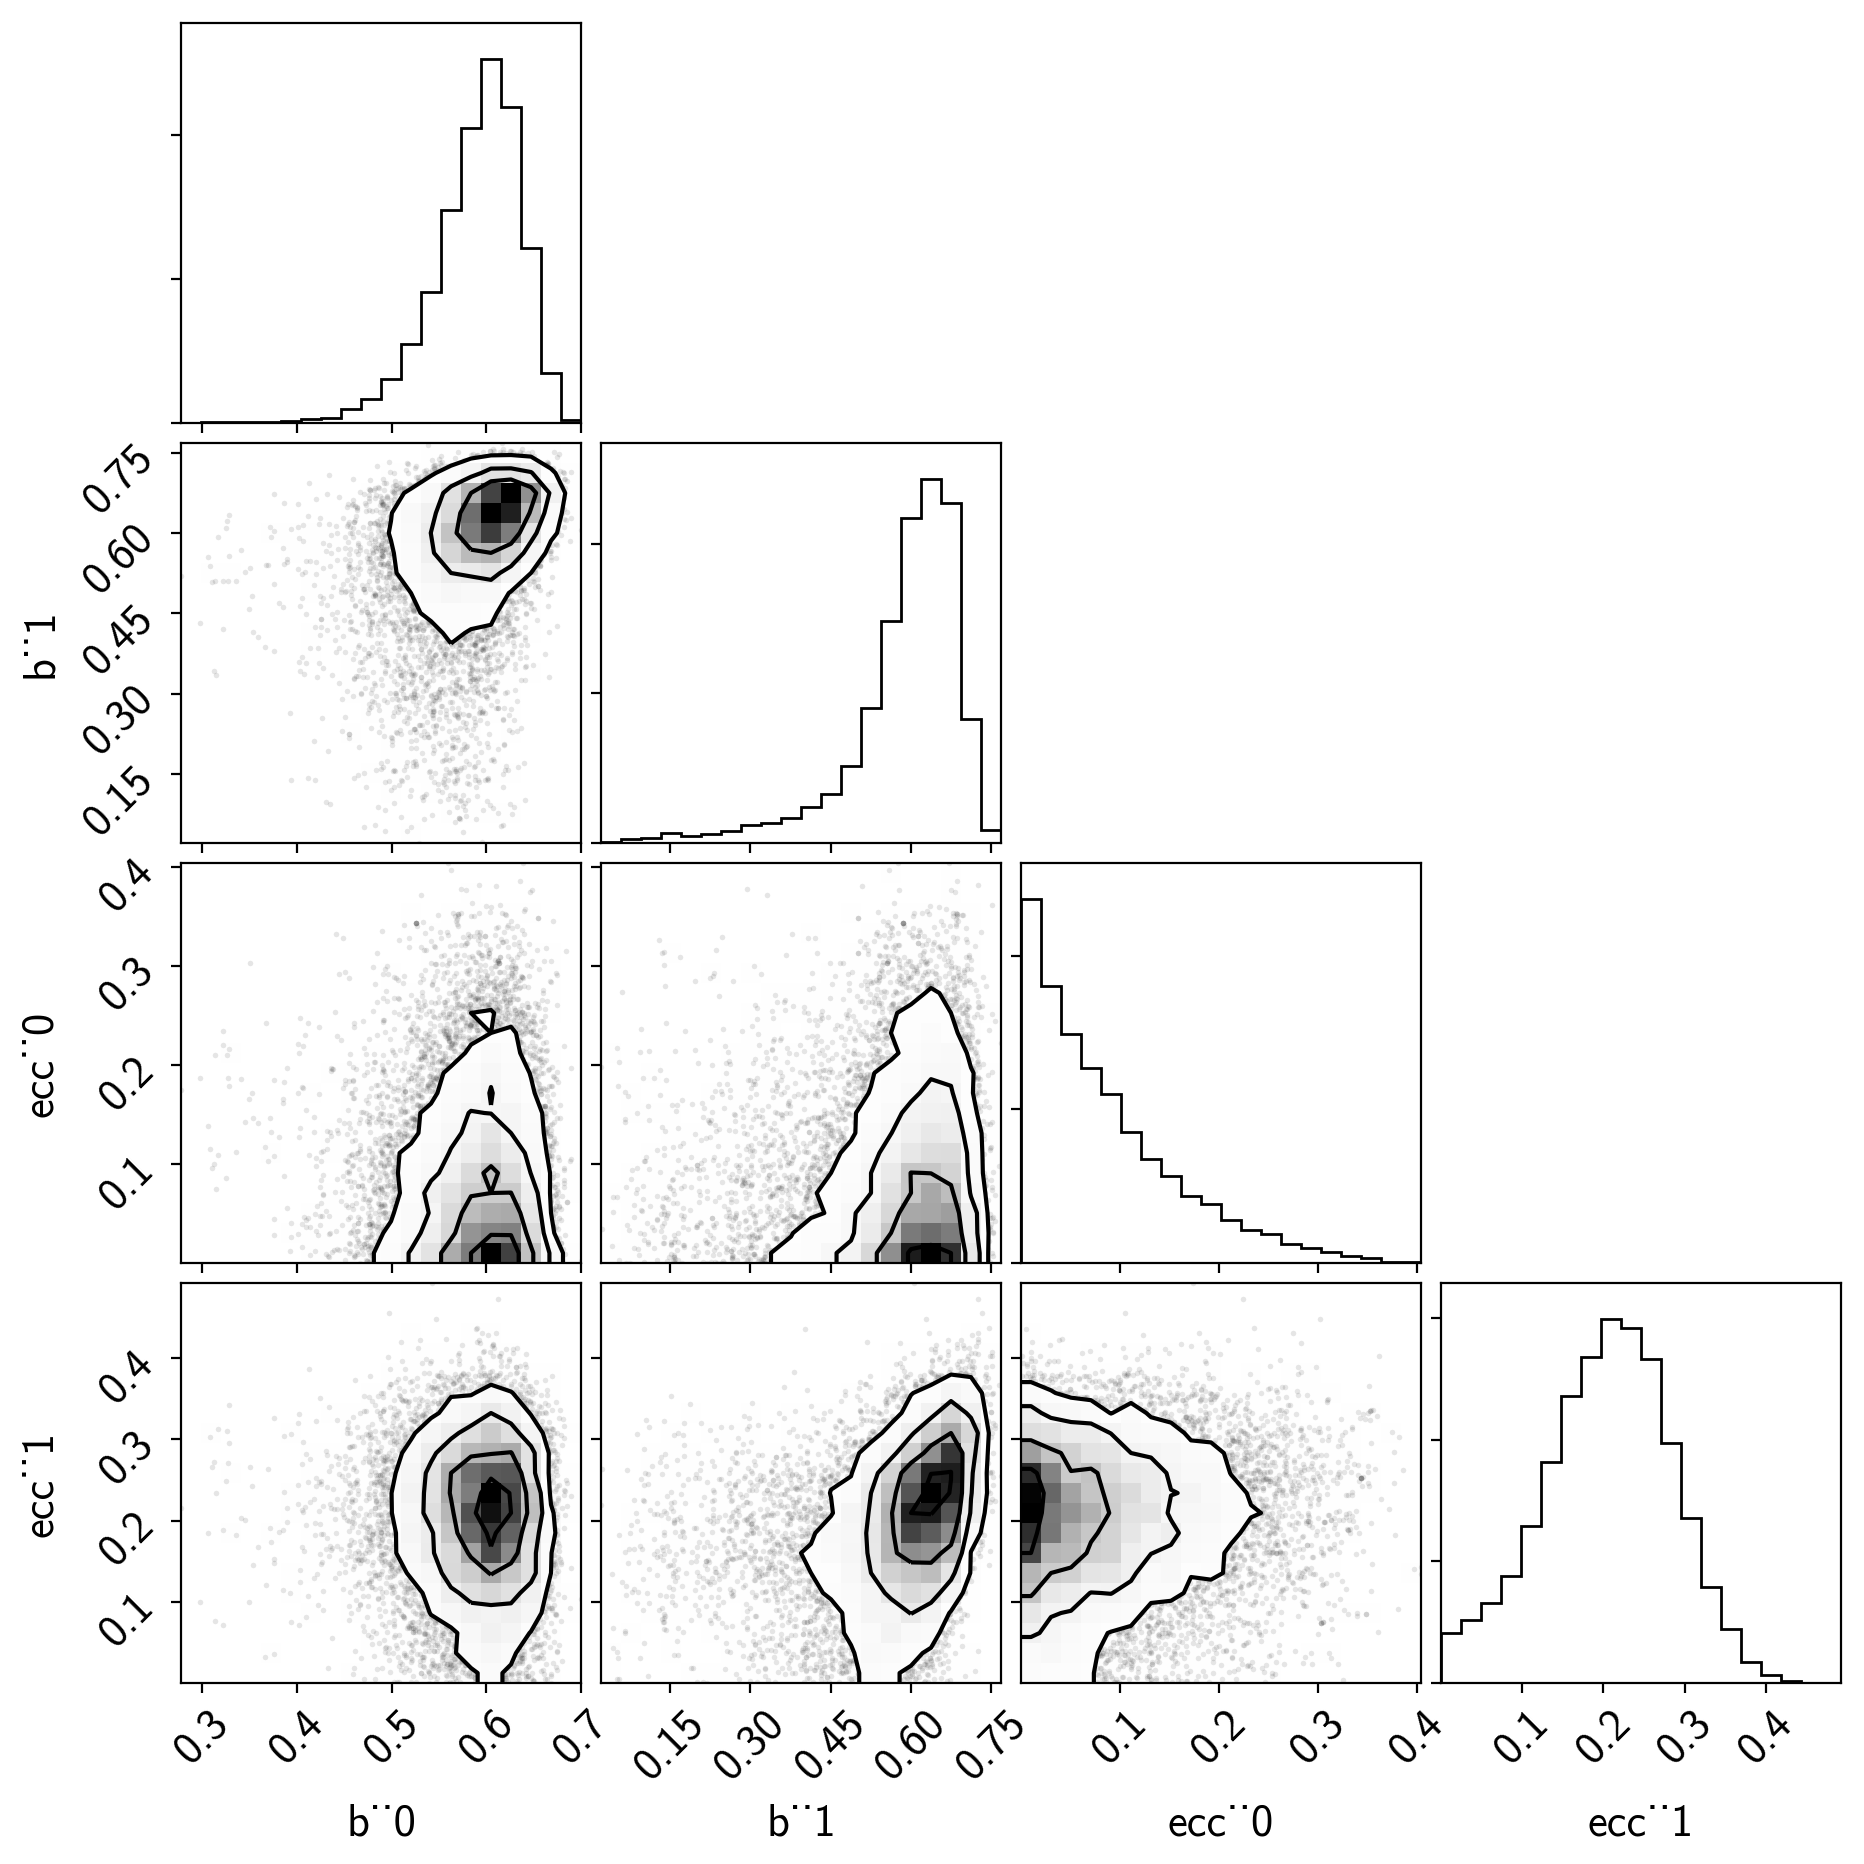

In [18]:
import corner
varnames = ["b", "ecc"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

## Phase plots

Finally, as in the :ref:`rv` and :ref:`transit` tutorials, we can make folded plots of the transits and the radial velocities and compare to the posterior model predictions. (Note: planets b and c in this tutorial are swapped compared to the labels from [Petigura et al. (2016)](https://arxiv.org/abs/1511.04497))

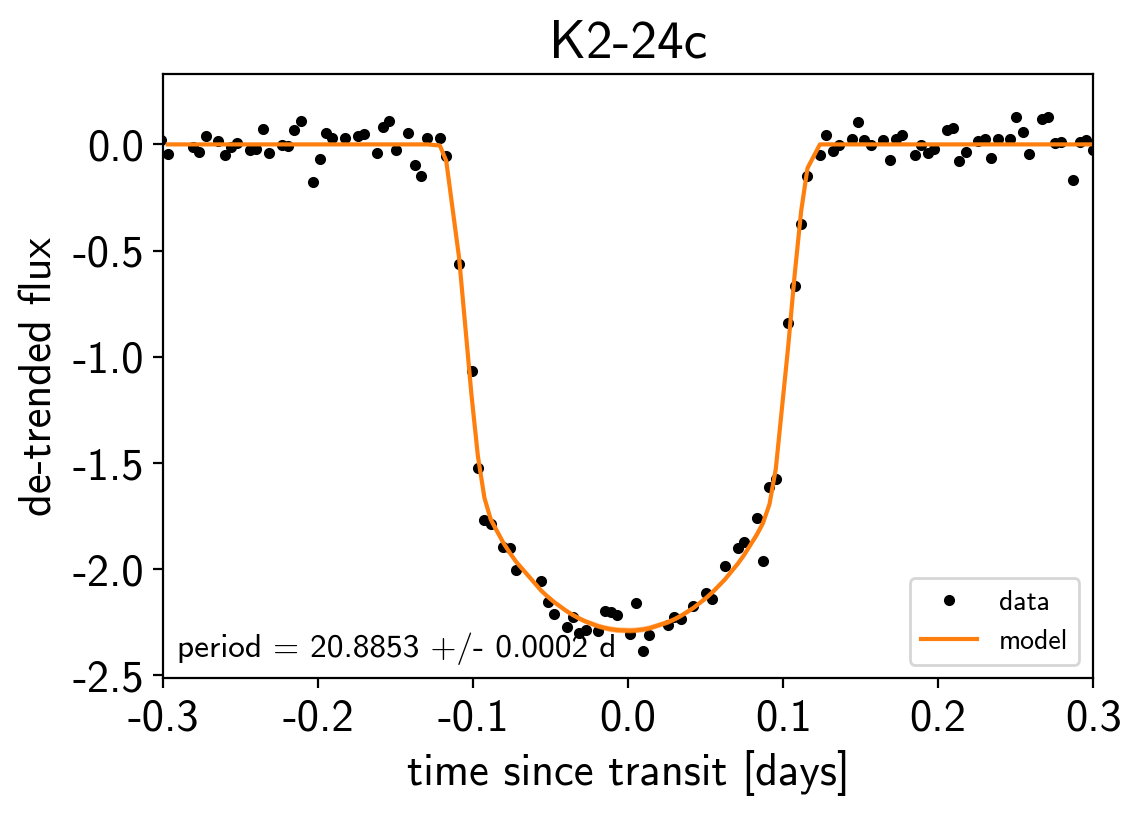

In [19]:
for n, letter in enumerate("bc"):
    plt.figure()
    
    # Compute the GP prediction
    gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    other = np.median(trace["light_curves"][:, :, (n + 1) % 2], axis=0)

    # Plot the folded data
    x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, y[mask] - gp_mod - other, ".k", label="data", zorder=-1000)
    
    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = trace["light_curves"][:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")
    
    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points", 
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("K2-24{0}".format(letter));
    plt.xlim(-0.3, 0.3)

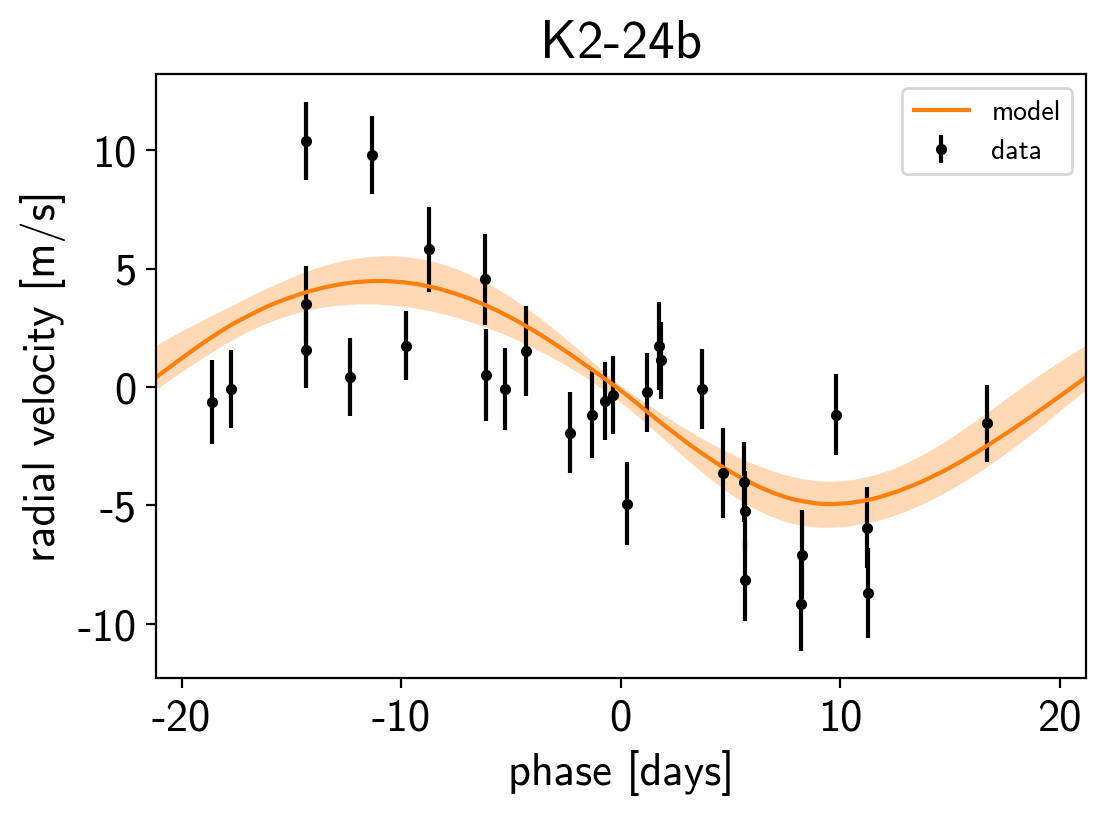

In [20]:
for n, letter in enumerate("bc"):    
    plt.figure()

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])
    
    # Compute the median of posterior estimate of the background RV
    # and the contribution from the other planet. Then we can remove
    # this from the data to plot just the planet we care about.
    other = np.median(trace["vrad"][:, :, (n + 1) % 2], axis=0)
    other += np.median(trace["bkg"], axis=0)

    # Plot the folded data
    x_fold = (x_rv - t0 + 0.5*p) % p - 0.5*p
    plt.errorbar(x_fold, y_rv - other, yerr=yerr_rv, fmt=".k", label="data")
    
    # Compute the posterior prediction for the folded RV model for this
    # planet
    t_fold = (t_rv - t0 + 0.5*p) % p - 0.5*p
    inds = np.argsort(t_fold)
    pred = np.percentile(trace["vrad_pred"][:, inds, n], [16, 50, 84], axis=0)
    plt.plot(t_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
    art.set_edgecolor("none")

    plt.legend(fontsize=10)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("phase [days]")
    plt.ylabel("radial velocity [m/s]")
    plt.title("K2-24{0}".format(letter));

We can also compute the posterior constraints on the planet densities.

In [21]:
volume = 4/3*np.pi*trace["r_pl"]**3
density = u.Quantity(trace["m_pl"] / volume, unit=u.M_earth / u.R_sun**3)
density = density.to(u.g / u.cm**3).value

bins = np.linspace(0, 1.1, 45)
for n, letter in enumerate("bc"):    
    plt.hist(density[:, n], bins, histtype="step", lw=2,
             label="K2-24{0}".format(letter), density=True)
plt.yticks([])
plt.legend(fontsize=12)
plt.xlim(bins[0], bins[-1])
plt.xlabel("density [g/cc]")
plt.ylabel("posterior density");

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [22]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:foremanmackey17, exoplanet:foremanmackey18,
exoplanet:kipping13, exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


In [23]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
...
